# Building Models to Predict Prospective Customers for MonPG Part 2 - Consumer

Date: 15/09/2022

Version: 1.0

Environment: Python 3.10.5 and Anaconda 4.11.0 (64-bit)

#### Libraries used:

* Datetime to manipulate date.
* Plotly to plot the data.
* Pandas to manipulate the Pandas converted dataframe.
* Time for calculating the execution time of queries.
* Kafka for streaming the data.
* Json to manipulate the geospatial data.
* urllib to download the geojson data.
* IPython.display to clear the output

## 3. Consuming the Data with Kafka

In the final step of the Kafka activity, we are going to consume the aggregated prediction data from the second Kafka producer. The goal is to consume the data and plot it. Since we are dealing with states and their customer counts, we can plot them on a chloropleth map.

First, let us install the library plotly which will allow us to do this.

In [1]:
# Note: Use this line to install plotly if not already installed
!pip install plotly

     |████████████████████████████████| 15.2 MB 24.1 MB/s eta 0:00:01


### 3.1 Loading the Libraries

Let us load the libraries we are going to require to set up the consumer.

In [1]:
# Importing the libraries
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import pandas as pd
import plotly.express as px
import json
from urllib.request import urlopen
from IPython.display import clear_output

# Activating the inline display of graphs in Jupyter Notebook
%matplotlib notebook

### 3.2 Setting up the Kafka Consumer

To ensure that this consumer is subscribed to the right topic and stream, we need to provide it with a few important details:

* The name of the topic been streamed here.
* **value_deserializer** to transform the stream into proper data.
* **key_deserializer** to transform the stream key into a legitimate format.

In [11]:
# Specifying the name of the topic to be consumed
topic = 'Statewide_customer_count'

# Defining a function to start the kafka consumer
def connect_kafka_consumer():
    
    _consumer = None
    
    try:
         _consumer = KafkaConsumer(topic,
                                   bootstrap_servers = ['localhost:9092'],
                                   value_deserializer = lambda x: json.loads(x.decode('ascii')),
                                   key_deserializer = lambda x: json.loads(x.decode('ascii')),
                                   api_version = (0, 10))
    except Exception as ex:
        
        print('Exception while connecting Kafka')
        print(str(ex))
        
    finally:
        
        return _consumer

### 3.3 Importing the geojson data

To plot a choropleth map, we need the coordinate information for each state. We can do this by importing a geojson file. A geojson file contains latitudinal and longitudinal information about each state. The `json.load()` function will be used to load the data.

In [12]:
# Loading the geojson file from the hyperlink
with urlopen('https://raw.githubusercontent.com/nikhilkumarsingh/choropleth-python-tutorial/master/states_india.geojson') as response:
    states_json = json.load(response)



After loading the geojson data, we need to grab two things from here to attach to the main prediction data that is coming from the producer. A geojson file usually contains the location code and name for each pair of coordinates. We will get the state names and their codes and put them in a dictionary as follows:

In [13]:
# Creating an empty dictionary
state_extract = {}

# Iterating through the state names and state codes in the geojson file
for location in states_json["features"]:
    
    # Grabbing the state code from the geojson file
    location["state_code"] = location["properties"]["state_code"]
    
    # Creating a key value pair with the state name as the key and state code 
    state_extract[location["properties"]["st_nm"]] = location["state_code"]

In [14]:
# Converting the state dictionary keys to upper case
state_extract = {k.upper():v for k,v in state_extract.items() }

In [15]:
# Checking the state extract dictionary
state_extract

{'TELANGANA': 0,
 'ANDAMAN & NICOBAR ISLAND': 35,
 'ANDHRA PRADESH': 28,
 'ARUNANCHAL PRADESH': 12,
 'ASSAM': 18,
 'BIHAR': 10,
 'CHHATTISGARH': 22,
 'DAMAN & DIU': 25,
 'GOA': 30,
 'GUJARAT': 24,
 'HARYANA': 6,
 'HIMACHAL PRADESH': 2,
 'JAMMU & KASHMIR': 1,
 'JHARKHAND': 20,
 'KARNATAKA': 29,
 'KERALA': 32,
 'LAKSHADWEEP': 31,
 'MADHYA PRADESH': 23,
 'MAHARASHTRA': 27,
 'MANIPUR': 14,
 'CHANDIGARH': 4,
 'PUDUCHERRY': 34,
 'PUNJAB': 3,
 'RAJASTHAN': 8,
 'SIKKIM': 11,
 'TAMIL NADU': 33,
 'TRIPURA': 16,
 'UTTAR PRADESH': 9,
 'UTTARAKHAND': 5,
 'WEST BENGAL': 19,
 'ODISHA': 21,
 'DADARA & NAGAR HAVELLI': 26,
 'MEGHALAYA': 17,
 'MIZORAM': 15,
 'NAGALAND': 13,
 'NCT OF DELHI': 7}

It looks the spelling of some of the state names is incorrect. Before we proceed, we need to recify them according to the format of our incoming data. The state names to be rectified here are as follows:

* ODISHA --> ORISSA
* CHHATTISGARH --> CHATTISGARH
* DADARA & NAGAR HAVELLI --> DADRA AND NAGAR HAVELLI
* NCT OF DELHI --> DELHI
* JAMMU & KASHMIR --> JAMMU AND KASHMIR
* ANDAMAN & NICOBAR ISLAND --> ANDAMAN AND NICOBAR ISLAND
* DAMAN & DIU --> DAMAN AND DIU

Let us redo the previous step and recreate the dictionary of state names and state codes with the corrected state names.

In [16]:
# Emptying the previous dictionary
state_extract = {}

# Updating the state names to their correct form
for location in states_json["features"]:
    
    if location["properties"]["st_nm"] == 'Chhattisgarh':
        
        location["properties"]["st_nm"] = 'Chattisgarh'
        
    if location["properties"]["st_nm"] == 'Andaman & Nicobar':
        
        location["properties"]["st_nm"] = 'Andaman and Nicobar'
        
    if location["properties"]["st_nm"] == 'Odisha':
        
        location["properties"]["st_nm"] = 'Orissa'
        
    if location["properties"]["st_nm"] == 'Daman & Diu':
        
        location["properties"]["st_nm"] = 'Daman and Diu'
    
    if location["properties"]["st_nm"] == 'Dadara & Nagar Havelli':
        
        location["properties"]["st_nm"] = 'Dadra and Nagar Haveli'
        
    if location["properties"]["st_nm"] == 'Jammu & Kashmir':
        
        location["properties"]["st_nm"] = 'Jammu and Kashmir'
        
    if location["properties"]["st_nm"] == 'NCT of Delhi':
        
        location["properties"]["st_nm"] = 'Delhi'
    
    # Grabbing the state code from the geojson file again
    location["id"] = location["properties"]["state_code"]
    
    # Creating a key value pair with the state name as the key and state code again
    state_extract[location["properties"]["st_nm"]] = location["id"]

In [17]:
# Converting the state dictionary to upper case
state_extract = {k.upper():v for k,v in state_extract.items() }

In [18]:
# Re-checking the dictionary
state_extract

{'TELANGANA': 0,
 'ANDAMAN & NICOBAR ISLAND': 35,
 'ANDHRA PRADESH': 28,
 'ARUNANCHAL PRADESH': 12,
 'ASSAM': 18,
 'BIHAR': 10,
 'CHATTISGARH': 22,
 'DAMAN AND DIU': 25,
 'GOA': 30,
 'GUJARAT': 24,
 'HARYANA': 6,
 'HIMACHAL PRADESH': 2,
 'JAMMU AND KASHMIR': 1,
 'JHARKHAND': 20,
 'KARNATAKA': 29,
 'KERALA': 32,
 'LAKSHADWEEP': 31,
 'MADHYA PRADESH': 23,
 'MAHARASHTRA': 27,
 'MANIPUR': 14,
 'CHANDIGARH': 4,
 'PUDUCHERRY': 34,
 'PUNJAB': 3,
 'RAJASTHAN': 8,
 'SIKKIM': 11,
 'TAMIL NADU': 33,
 'TRIPURA': 16,
 'UTTAR PRADESH': 9,
 'UTTARAKHAND': 5,
 'WEST BENGAL': 19,
 'ORISSA': 21,
 'DADRA AND NAGAR HAVELI': 26,
 'MEGHALAYA': 17,
 'MIZORAM': 15,
 'NAGALAND': 13,
 'DELHI': 7}

Having gotten our states and their respective IDs, we can start consuming the aggregated predictions here and plot them on a choropleth map. We will define a function to do all these activities. The steps that will be followed in this function are:

* Create an empty dataframe to record the updates to the customer count for different states.
* Start consuming the message from the producer one batch at a time.
* Convert the received message value into a Pandas dataframe
* Check if the batch data is empty and if it is empty, skip to the next batch.
* Print the batch data for confirmation.
* Concat the data received from the current batch with the state recorder dataframe.
* Group the dataframe by finding the aggregated sum of the target_customers column.
* Apply the state_code to the dataframe based on the geojson file.
* Plot the choropleth map.
* Sleep for 20 seconds.
* Clear the screen and wait for the next message.

In [5]:
# Defining a function to access and manipulate the incoming stream data
def consume_messages(consumer):
    
    try:
        
        # Creating an empty dataframe to maintain a record of the state wise target customer count
        state_recorder_df = pd.DataFrame(columns=['State', 'target_customers'])
        
        # For each batch coming from the producer
        for message in consumer:
            
            # Optional Code; Printing the key of the message
            #print(message.key)
            
            # Optional Code; Printing the value of the message
            #print(message.value)
            
            # Printing the data being receiveed from the Spark Streaming Producer
            print(type(message.value))
            
            # Transforming the message value into a Pandas dataframe
            stream_df = pd.DataFrame(eval(message.value))
            
            # Checking if the current batch contains any data
            if stream_df.empty:
                
                # Skipping
                continue
                
            else:
                
                # Printing the received data
                print(stream_df)
                
                # Concatenating the streamed dataframe with the existing one
                state_recorder_df = pd.concat([state_recorder_df, stream_df]).reset_index(drop = True)
                
                # Aggregating the merged dataframe to find aggregated sum of the target customers
                final = state_recorder_df.groupby(['State'])['target_customers'].sum().reset_index()
                
                # Creating the state ID column for the streamed dataframe
                final["state_code"] = final["State"].apply(lambda d: state_extract[d])
                
                # Plotting the data
                fig = px.choropleth_mapbox(final, locations = "state_code", 
                                           featureidkey = "properties.state_code",
                                           geojson = states_json, 
                                           color = "target_customers",
                                           hover_name = "State", 
                                           hover_data = ["target_customers"],
                                           title = "Statewide Predicted Top-up Customer Count", 
                                           mapbox_style ="carto-positron", 
                                           center = {"lat": 24, "lon": 78}, 
                                           zoom = 3.10, 
                                           opacity = 0.5)
                
                # Showing the figure
                fig.show()
                
                # Sleeping for 20 seconds before updating the map
                sleep(20)
                
                # Closing the figure
                clear_output(wait = True)

    except Exception as ex:
        print(str(ex))

Finally, we can call the above function and start the consumer. The consumer will continue listening for messages until prompted otherwise.

In [ ]:
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    consume_messages(consumer) 

<class 'str'>
             State  target_customers
0      WEST BENGAL               494
1      CHATTISGARH               434
2        RAJASTHAN               294
3          GUJARAT               382
4        KARNATAKA                62
5           ORISSA               521
6    UTTAR PRADESH               170
7   MADHYA PRADESH              4161
8      MAHARASHTRA                34
9           PUNJAB               564
10     UTTARAKHAND               288
11         HARYANA               252
12       TELANGANA                15
13  ANDHRA PRADESH               454


**NOTE**: The above output is incomplete because the cloud VM is unable to take the load of this operation and generate the map. I have already tested the logic of the code producing the map on my local system and so I am confident that it will not fail if this entire application from task 1 to task 3 is run on a system with a better memory. 

Since I am unable to run Kafka successfully on my local system, I had to rely on the Monash University cloud VM for this notebook.

For now, here is a screenshot of the generated map from my local system for the first batch. This output was observed after using the same logic being used in this Task 3 notebook. For example, note the customer count for `RAJASTHAN` in the above incomplete output and the customer count being shown on the hover label in the map below.

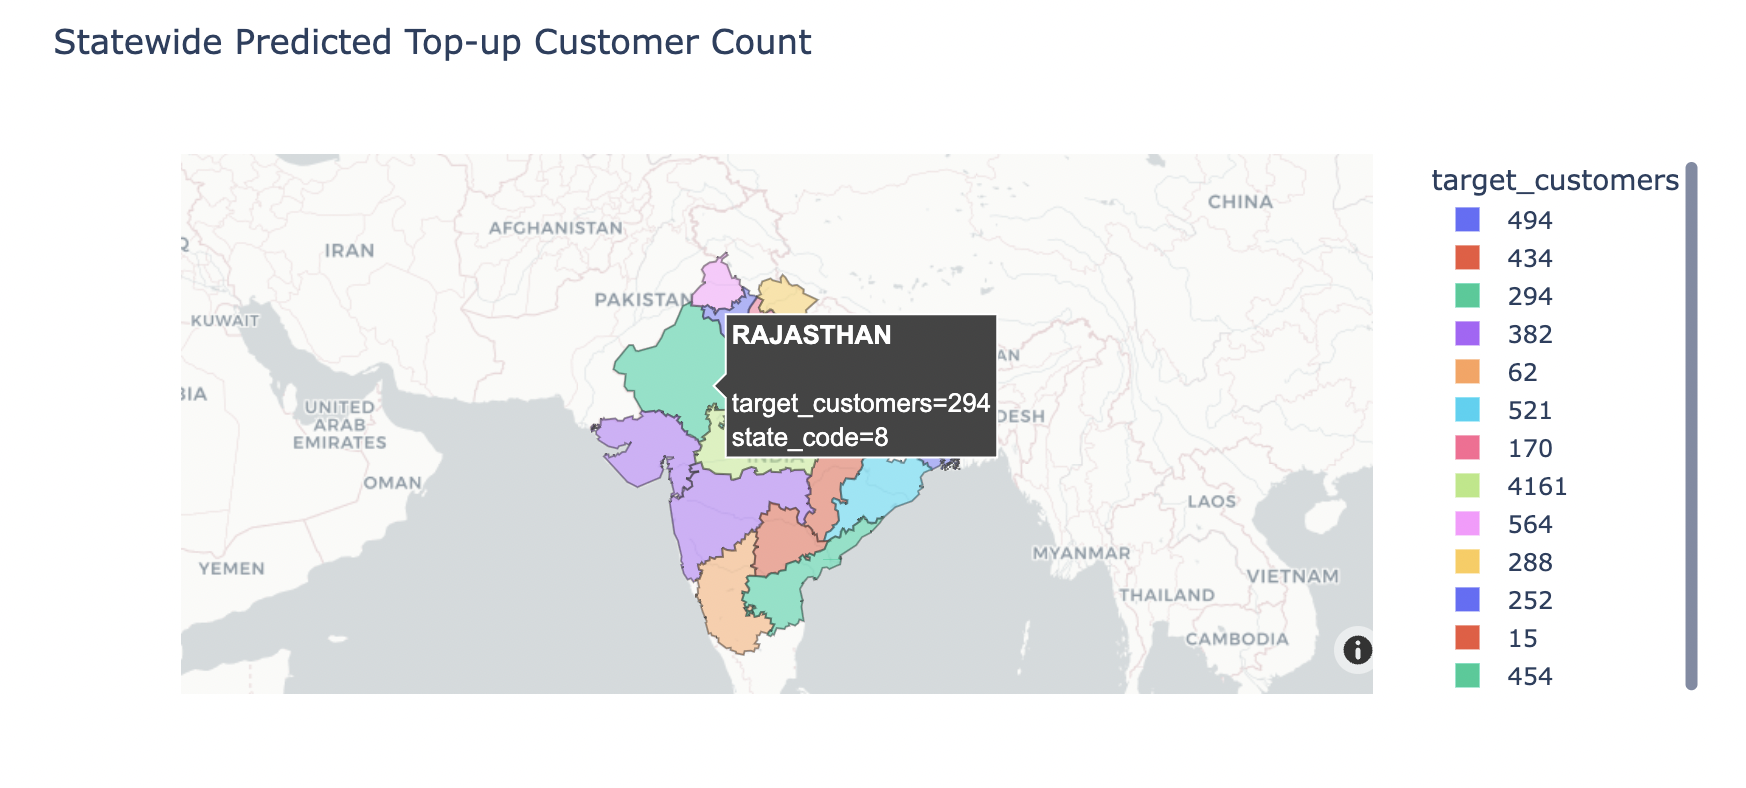

In [4]:
from IPython import display
from base64 import b64decode

base64_data = "iVBORw0KGgoAAAANSUhEUgAABtIAAAMUCAYAAAAhdbM1AAAMQGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIaEEEJASehMEpASQEkILIL0INkISIJQYA0HFXhYVXLtYwIauiih2QOyIYmFR7H1BREVZFwt25U0K6LqvfG++b+78958z/zlz7sy9dwDQOMWTSHJRTQDyxAXSuNBA5uiUVCbpCaAAOiADZwB4/HwJOyYmEsAy0P69vLsJEHl7zVGu9c/+/1q0BMJ8PgBIDMTpgnx+HsSHAMAr+BJpAQBEOW8xuUAix7ACHSkMEOKFcpypxBVynK7E+xQ2CXEciJsAIKvzeNJMAOhXIM8s5GdCDXovxM5igUgMgAYTYr+8vIkCiNMgtoU2Eojl+qz0H3Qy/6aZPqjJ42UOYuVcFIUcJMqX5PKm/p/p+N8lL1c24MMaVvUsaVicfM4wb7dzJkbIsTrEPeL0qGiItSH+IBIo7CFGqVmysESlPWrEz+fAnAE9iJ0FvKAIiI0gDhHnRkWq+PQMUQgXYrhC0CmiAm4CxPoQLxTmB8erbDZLJ8apfKG1GVIOW8Wf50kVfuW+HspyEtkq/ddZQq5KH6MXZSUkQ0yF2LJQlBQFMR1ip/yc+AiVzciiLE7UgI1UFieP3xLiOKE4NFCpjxVmSEPiVPYlefkD88U2Z4m4USp8oCArIUyZH6yJz1PED+eCXRGK2YkDOsL80ZEDcxEIg4KVc8eeCcWJ8SqdD5KCwDjlWJwqyY1R2ePmwtxQOW8OsVt+YbxqLJ5UABekUh/PkBTEJCjjxIuyeeExynjwZSAScEAQYAIZrOlgIsgGotaeuh54p+wJATwgBZlACBxVzMCIZEWPGF7jQRH4EyIhyB8cF6joFYJCyH8dZJVXR5Ch6C1UjMgBTyDOAxEgF97LFKPEg96SwGPIiP7hnQcrH8abC6u8/9/zA+x3hg2ZSBUjG/DI1BiwJAYTg4hhxBCiHW6I++E+eCS8BsDqirNwr4F5fLcnPCG0ER4RbhDaCXcmiOZKf4pyFGiH+iGqXKT/mAvcGmq644G4L1SHyrgebggccTfoh437Q8/ukOWo4pZnhfmT9t9m8MPTUNlRnCkoZQglgGL780i6Pd19UEWe6x/zo4w1fTDfnMGen/1zfsi+ALYRP1tiC7GDWDN2GruAHcPqABM7idVjLdhxOR5cXY8Vq2vAW5winhyoI/qHv4EnK89kvnO1c7fzF2VfgXCK/B0NOBMlU6WizKwCJht+EYRMrpjvNIzp6uzqCoD8+6J8fb2JVXw3EL2W79y8PwDwPdnf33/0Oxd+EoD9nnD7H/nO2bLgp0MNgPNH+DJpoZLD5RcCfEtowJ1mAEyABbCF83EFHsAHBIBgEA6iQQJIAeNh9FlwnUvBZDAdzAHFoBQsA6vBerAJbAU7wR5wANSBY+A0OAcugSvgBrgHV08XeAF6wTvwGUEQEkJDGIgBYopYIQ6IK8JC/JBgJBKJQ1KQNCQTESMyZDoyDylFViDrkS1IFbIfOYKcRi4gbcgdpAPpRl4jn1AMVUd1UGPUGh2OslA2GoEmoOPQTHQSWoTOR5ega9FKdDdai55GL6E30Hb0BdqHAUwN08PMMEeMhXGwaCwVy8Ck2EysBCvDKrEarAE+52tYO9aDfcSJOANn4o5wBYfhiTgfn4TPxBfj6/GdeC3ehF/DO/Be/BuBRjAiOBC8CVzCaEImYTKhmFBG2E44TDgL91IX4R2RSNQj2hA94V5MIWYTpxEXEzcQ9xJPEduIncQ+EolkQHIg+ZKiSTxSAamYtI60m3SSdJXURfpAViObkl3JIeRUspg8l1xG3kU+Qb5Kfkr+TNGkWFG8KdEUAWUqZSllG6WBcpnSRflM1aLaUH2pCdRs6hzqWmoN9Sz1PvWNmpqauZqXWqyaSG222lq1fWrn1TrUPqprq9urc9THqsvUl6jvUD+lfkf9DY1Gs6YF0FJpBbQltCraGdpD2gc6g+5E59IF9Fn0cnot/Sr9pQZFw0qDrTFeo0ijTOOgxmWNHk2KprUmR5OnOVOzXPOI5i3NPi2GlotWtFae1mKtXVoXtJ5pk7SttYO1Bdrztbdqn9HuZGAMCwaHwWfMY2xjnGV06RB1bHS4Otk6pTp7dFp1enW1dd10k3Sn6JbrHtdt18P0rPW4erl6S/UO6N3U+zTEeAh7iHDIoiE1Q64Oea8/VD9AX6hfor9X/4b+JwOmQbBBjsFygzqDB4a4ob1hrOFkw42GZw17huoM9RnKH1oy9MDQu0aokb1RnNE0o61GLUZ9xibGocYS43XGZ4x7TPRMAkyyTVaZnDDpNmWY+pmKTFeZnjR9ztRlspm5zLXMJmavmZFZmJnMbItZq9lncxvzRPO55nvNH1hQLVgWGRarLBotei1NLUdZTrestrxrRbFiWWVZrbFqtnpvbWOdbL3Aus76mY2+DdemyKba5r4tzdbfdpJtpe11O6Idyy7HboPdFXvU3t0+y77c/rID6uDhIHLY4NA2jDDMa5h4WOWwW47qjmzHQsdqxw4nPadIp7lOdU4vh1sOTx2+fHjz8G/O7s65ztuc77lou4S7zHVpcHntau/Kdy13vT6CNiJkxKwR9SNeuTm4Cd02ut12Z7iPcl/g3uj+1cPTQ+pR49HtaemZ5lnheYulw4phLWad9yJ4BXrN8jrm9dHbw7vA+4D3Xz6OPjk+u3yejbQZKRy5bWSnr7kvz3eLb7sf0y/Nb7Nfu7+ZP8+/0v9RgEWAIGB7wFO2HTubvZv9MtA5UBp4OPA9x5szg3MqCAsKDSoJag3WDk4MXh/8MMQ8JDOkOqQ31D10WuipMEJYRNjysFtcYy6fW8XtDfcMnxHeFKEeER+xPuJRpH2kNLJhFDoqfNTKUfejrKLEUXXRIJobvTL6QYxNzKSYo7HE2JjY8tgncS5x0+Oa4xnxE+J3xb9LCExYmnAv0TZRltiYpJE0Nqkq6X1yUPKK5PbRw0fPGH0pxTBFlFKfSkpNSt2e2jcmeMzqMV1j3ccWj705zmbclHEXxhuOzx1/fILGBN6Eg2mEtOS0XWlfeNG8Sl5fOje9Ir2Xz+Gv4b8QBAhWCbqFvsIVwqcZvhkrMp5l+mauzOzO8s8qy+oRcUTrRa+yw7I3Zb/Pic7ZkdOfm5y7N4+cl5Z3RKwtzhE3TTSZOGVim8RBUixpn+Q9afWkXmmEdHs+kj8uv75AB/7It8hsZb/IOgr9CssLP0xOmnxwitYU8ZSWqfZTF019WhRS9Ns0fBp/WuN0s+lzpnfMYM/YMhOZmT6zcZbFrPmzumaHzt45hzonZ87vc53nrpj7dl7yvIb5xvNnz+/8JfSX6mJ6sbT41gKfBZsW4gtFC1sXjVi0btG3EkHJxVLn0rLSL4v5iy/+6vLr2l/7l2QsaV3qsXTjMuIy8bKby/2X71yhtaJoRefKUStrVzFXlax6u3rC6gtlbmWb1lDXyNa0r41cW7/Oct2ydV/WZ62/UR5YvrfCqGJRxfsNgg1XNwZsrNlkvKl006fNos23t4Ruqa20rizbStxauPXJtqRtzb+xfqvabri9dPvXHeId7TvjdjZVeVZV7TLatbQarZZVd+8eu/vKnqA99TWONVv26u0t3Qf2yfY935+2/+aBiAONB1kHaw5ZHao4zDhcUovUTq3trcuqa69PqW87En6kscGn4fBRp6M7jpkdKz+ue3zpCeqJ+Sf6Txad7DslOdVzOvN0Z+OExntnRp+53hTb1Ho24uz5cyHnzjSzm0+e9z1/7IL3hSMXWRfrLnlcqm1xbzn8u/vvh1s9Wmsve16uv+J1paFtZNuJq/5XT18LunbuOvf6pRtRN9puJt68fWvsrfbbgtvP7uTeeXW38O7ne7PvE+6XPNB8UPbQ6GHlH3Z/7G33aD/eEdTR8ij+0b1OfueLx/mPv3TNf0J7UvbU9GnVM9dnx7pDuq88H/O864Xkxeee4j+1/qx4afvy0F8Bf7X0ju7teiV91f968RuDNzveur1t7Ivpe/gu793n9yUfDD7s/Mj62Pwp+dPTz5O/kL6s/Wr3teFbxLf7/Xn9/RKelKf4FcBgRTMyAHi9AwBaCgAMeD6jjlGe/xQFUZ5ZFQj8J6w8IyqKBwA18P89tgf+3dwCYN82ePyC+hpjAYihAZDgBdARIwbrwFlNca6UFyI8B2wO/pqelw7+TVGeOX+I++cWyFXdwM/tvwAqF3xMpRA8mwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAABtKgAwAEAAAAAQAAAxQAAAAAQVNDSUkAAABTY3JlZW5zaG90sPDz1QAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+Nzg4PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE3NDY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KnDjezwAAABxpRE9UAAAAAgAAAAAAAAGKAAAAKAAAAYoAAAGKAAYxaYbyLcAAAEAASURBVHgB7H0HoB5F1fYERDpSQ++oiKAICtIJTUhooUvvvfeehBJ6DxB670iHUKSogIBUkSK9ht4hgEDuf8o8Z87M7nsTLsHfT2cJe9ozc3bOnpndu/PObq8u2kLLxspeXk+KLlJAx6V6RUGxrgRYoV2hi0qhnFYJgHeQ8w0EKar/Gn/kUc2/2v/q+ONHUzdighVax996/anXX1w3fI/J7zhyCV3ItKSo9x/1/gN5VO8/6v1Hvf/wo6kbMcEKrfcf9f6j3n/guuF7jN1btDDoQmYiRb3/qPcfyKN6/1HvP+r9hx9N3YgJVmi9/6j3H/X+A9cN32Ps3qKFQRcyEynq/Uc39x+YSGsMN/5KbdFMTAOfTMThNIBGI0RQw3GJortX/+lOIYutCo14ZRgEGLTGXyKAcIDW/KOw6BDbyKfa/2r/w516Nrao0MiXDIMOBhqNEEFr/6PA1P7H2dHIpzr+1PGnjj9x4GySRn/JIBhgQaMRImgdfykwdfzl7GjkUx1/6/hbx984cDZJo79kEAywoNEIEbSOvxSYOv5ydjTyqY6/dfyt428cOJuk0V8yCAZY0GiECFrHXwpMHX85Oxr5VMffOv5+i/G3V9dIyhjtS3G04aRC9yKezbFCrzdwZBq2QlGIUkp0LQavqv5r/Gv+4WKX+mXtf3kE/JiRBpeEadjJJLoWg1fV8aeOP3X8qeMPjyR+XEgji3INW6EoRCkkuhaDV9Xxp44/dfyp4w8PGH5c0FEn7Ru2QlGIUlB0LQavquNPHX/q+FPHHx4w/LiQRh7lGrZCUYhSSHQtBq+q408df+r4U8cfHjD8uKCjTto3bIWiEKWg6FoMXlXHnzr+1PGnjj88YPhxIY08yvWigYLtcSuhXvZ8B7ioFWd7vx7Q3JC1dbav9OFlz1f/LtSIahYUjRbta/ybs08df21Q5piXPZ+FusY/i4DGyfY1/2r+6XU4ZUntf/X6V6//qT8YV15jvOz5WKBFhds9NdG+jr91/K3jr/UwYer1p15/6vUn7xPaMWjvBwt/gfF8LNqiqtcfDYrt6/U3TylOnTr+1vG3jr9xEPWkHFC97PlYpkVVx18Niu3r+FvHX39Lw12nXn/q9WcMX39kIs3PuutAzNkWs09GJBuW2ABLnKFTmxg6zdkxhG2tB895nWa9q38JVoqyhFd2El2OJMaFpM01jMk2qZJ2Nf5ZWCDU/Kv9D786qeOPDBbUNer4L+ODDLKyq+NvHDDzq43GRk2ej2AmrK7X/3r9rfcf3BEaW73/qPcf9f7DX1W4i9T7Dxko5JKq11W5jKbIyGW1V9wLNuNVY3XU62+9/tbrr+sUia3X33r9rdffev3VEaG4ytbrL1036/0H348WmRHvtjQ2KXfQj9L1RQsSrl5/XVAS+99w/dUVaZILmhDGcjtbciI1P+e4HG9SJBNU7/cNszmNfxY0AL50O58VyYQmvmFmhRsshOVitf3N4HXQZDHNhGaBhrnGv+Zf7X8y4FhX4G5Tx5/m4NFBk40pmdAs0DBb0Ov1x0LBYav510yeDpospzKhWaBhtqDX/LNQcNhq/jWTp4Mmy6lMaBZomC3oNf8sFBy2mn/N5OmgyXIqE5oFGmYLes0/CwWHreZfM3k6aLKcyoRmgYbZgl7zz0LBYav510yeDpospzKhWaBhtqDX/LNQcNhq/jWTp4Mmy6lMaBZomC3oNf8sFBy2mn/N5OmgyXIqE5oFGmYLes0/CwWHreZfM3k6aLKcyoRmgYbZgt7z/OtFn0jjxa9uk1qj7FxGtbcySOUORtRK5i56UN7LMgO1ND7xZzVqUcbxRkfYwYWqOxi1sJSt/mv8a/6hp8f+Qp3KZ4V2F9hYYp632v/q+JOlgWQF7zRbYs741DGEgur463saAlX7n4+KpgxiwxLzvNXxp44/WRpIVvBOsyXmjE8dQyiojj++pyFQdfzxUdGUQWxYYp63Ov7U8SdLA8kK3mm2xJzxqWMIBdXxx/c0BKqOPz4qmjKIDUvM81bHnzr+ZGkgWcE7zZaYMz51DKGgOv74noZA1fHHR0VTBrFhiXne6vhTx58sDSQreKfZEnPGp44hFFTHH9/TEKg6/vioaMogNiwxz9t//vhDK9JG0tG6mTg65nLzTSttoyNn5V1stKxaZZ8BU80d1AkwCi4rzwJv1k61yj4DKoz3HdQJMAouK88Cb9W/xsEPxVmgoplIB3UCjILLytf4a7Rq/sWs0eyQfZYoKak6qBNgFFxWngXeavw1DrX/SzJIjmSJEsNDpIM6AUbBZeVZ4K3mn8ah5p8kg+RIligxPEQ6qBNgFFxWngXeav5pHGr+STJIjmSJEsNDpIM6AUbBZeVZ4K3mn8ah5p8kg+RIligxPEQ6qBNgFFxWngXeav5pHGr+STJIjmSJEsNDpIM6AUbBZeVZ4K3mn8ah5p8kg+RIligxPEQ6qBNgFFxWngXeav5pHGr+STJIjmSJEsNDpIM6AUbBZeVZ4K3mn8ah5p8kg+RIligxPEQ6qBNgFFxWngXeav5pHP5L8k9f7chNys52bCMIPs5HmLZvNwLWRlO1bbOvrkQCOmVkq3/qeNTzavxr/lEa2Bjc7CkNTepWtf81f/3gwpUC5ZSRreNPHX/q+FuvP/X6W6+/9fpb7z+adwgdNem2ot5/1fuv9E6MRsKkRGmY6CPi9f6r3n/V+696/1Xvv+r9V73/al4hO2rSZbXef9X7r3r/1fHZceoozb5U7z9Hef/d8mrHGEcJHvPtoe8u7jIph9PRWjyWJtJxYq76j6FvDWC38541/ki+Tulb80+Sq/a/Ov7Q8NI6wtTxt46/khit2VGvP50uLXzp4csLttbw1etPvf5QYtTrb73+Uhq0DxGUHGJotdbxl8bX9siQoY6/uPp0CFK9/khg6vhbx18aRFrHkfr3TwxMa3Tq9adef9r7DV956vW3Xn8Rgdbho95/1PsPSoz/ovsve7Wj5H3Mb/QBprkqdQAZRXOjK6YGmEENkCmc4Fhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQggJsVA0wgxbmKDqrY4HNVVGCEhRgo2qAGbQwR9FZHQtsrooSlKAAG1UDzKCFOYrO6lhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQggJsVA0wgxbmKDqrY4HNVVGCEhRgo2qAGbQwR9FZHQtsrooSlKAAG1UDzKCFOYrO6lhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQggJsVA0wgxbmKDqrY4HNVVGCEhRgo2qAGbQwR9FZHQtsrooSlKAAG1UDzKCFOYrO6lhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQggJsVA0wgxbmKDqrY4HNVVGCEhRgo2qAGbQwR9FZHQtsrooSlKAAG1UDzKCFOYrO6lhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQggJsVA0wgxbmKDqrY4HNVVGCEhRgo2qAGbQwR9FZHQtsrooSlKAAG1UDzKCFOYrO6lhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQggJsVA0wgxbmKDqrY4HNVVGCEhRgo2qAGbQwR9FZHQtsrooSlKAAG1UDzKCFOYrO6lhgc1WUoAQF2KgaYAYtzFF0VscCm6uiBCUowEbVADNoYY6iszoW2FwVJShBATaqBphBC3MUndWxwOaqKEEJCrBRNcAMWpij6KyOBTZXRQlKUICNqgFm0MIcRWd1LLC5KkpQghI4rUiDEhQ1tVCFdAY2LaUmycaBAW3xC5VCOgObllKTZOPAgMJZC1VIZ2DTUmqSbBwY0Ba/UCmkM7BpKTVJNg4MKJy1UIV0BjYtpSbJxoEBbfELlUI6A5uWUpNk48CAwlkLVUhnYNNSapJsHBjQFr9QKaQzsGkpNUk2DgwonLVQhXQGNi2lJsnGgQFt8QuVQjoDm5ZSk2TjwIDCWQtVSGdg01JqkmwcGNAWv1AppDOwaSk1STYODCictVCFdAY2LaUmycaBAW3xC5VCOgObllKTZOPAgMJZC1VIZ2DTUmqSbBwY0Ba/UCmkM7BpKTVJNg4MKJy1UIV0BjYtpSbJxoEBbfELlUI6A5uWUpNk48CAwlkLVUhnYNNSapJsHBjQFr9QKaQzsGkpNUk2DgwonLVQhXQGNi2lJsnGgQFt8QuVQjoDm5ZSk2TjwIDCWQtVSGdg01JqkmwcGNAWv1AppDOwaSk1STYODCictVCFdAY2LaUmycaBAW3xC5VCOgObllKTZOPAgMJZC1VIZ2DTUmqSbBwY0Ba/UCmkM7BpKTVJNg4MKJy1UIV0BjYtpSbJxoEBbfELlUI6A5uWUpNk48CAwlkLVUhnYNNSapJsHBjQFr9QKaQzsGkpNUk2DgwonLVQhXQGNi2lJsnGgQFt8QuVQjoDm5ZSk2TjwIDCWQtVSGdg01JqkmwcGNAWv1AppDOwaSk1STYODCictVCFdAY2LaUmycaBAW3xC5VCOgObllKTZOPAgMJZC1VIZ2DTUmqSbBwY0Ba/UCmkM7BpKTVJNg4MKJy1UIV0BjYtpSbJxoEBbfELlUI6A5uWUpNk48CAwlkLVUhnYNNSapJsHBjQFr9QKaQzsGkpNUk2DgwonLVQhXQGNi2lJsnGgQFt8QuVQjoDm5ZSk2TjwIDCWQtVSGdg01JqkmwcGNAWv1AppDOwaSk1STYODCictVCFdAY2LaUmycaBAW3xC5VCOgObllKTZOPAgMJZC1VIZ2DTUmqSbBwY0Ba/UCmkM7BpKTVJNg4MKJy1UIV0BjYtpSbJxoEBbfELlUI6A5uWUpNk48CAwlkLVUgOTN9IswIAMOWN12YSj3cwwqxat7wXBlAu29zMKoxJDggdU96q/xp/yoWaf9YV0OnQU7SfQAJVbbk3qzAmORh0THmr/a/2P8qF2v+sK9T+pyMDRopcyrVqS3uzCmNSAtgaeLbxVsefOv5QLtTxx7pCHX90ZMhHD0igiin3ZhXGJAeDjilvdfyp4w/lQh1/rCvU8UdHBowUuZRr1Zb2ZhXGpASo9z8UizjmSlTq+FvHX+ondfxN3YK7BG356AEJVDHl3qzCmORg0DHlrfa/2v8oF2r/s65Q7390ZMBIkUu5Vm1pb1ZhTEoAG9XYxtv/jfGnV9dIehl0r7YGaTOwb0dACwq00i6umj8STMHJPnRIcPRLjVt7eV9bOwJaUF+CfFT/Nf41/2r/q+NPHX/pghz//uDLUb3+UDAkHnLpbL9++qtpOwJaUF+iXn/r/Ue9/6v3v/X+ny849e+fev2t9x/x/oBuF+rf//X+q95/yp/mlAjt98/+brodAS2oL1Hvv+v9d73/rvff9f673n/Xvz++77+/ZEVadhk2wZj86twiASnfZ6V+C2pQAEyRM5nZBGNycIsEJPyCGhQAU+RMZjbBmBzcIgEJv6AGBcAUOZOZTTAmB7dIQMIvqEEBMEXOZGYTjMnBLRKQ8AtqUABMkTOZ2QRjcnCLBCT8ghoUAFPkTGY2wZgc3CIBCb+gBgXAFDmTmU0wJge3SEDCL6hBATBFzmRmE4zJwS0SkPALalAATJEzmdkEY3JwiwQk/IIaFABT5ExmNsGYHNwiAQm/oAYFwBQ5k5lNMCYHt0hAwi+oQQEwRc5kZhOMycEtEpDwC2pQAEyRM5nZBGNycIsEJPyCGhQAU+RMZjbBmBzcIgEJv6AGBcAUOZOZTTAmB7dIQMIvqEEBMEXOZGYTjMnBLRKQ8AtqUABMkTOZ2QRjcnCLBCT8ghoUAFPkTGY2wZgc3CIBCb+gBgXAFDmTmU0wJge3SEDCL6hBATBFzmRmE4zJwS0SkPALalAATJEzmdkEY3JwiwQk/IIaFABT5ExmNsGYHNwiAQm/oAYFwBQ5k5lNMCYHt0hAwi+oQQEwRc5kZhOMycEtEpDwC2pQAEyRM5nZBGNycIsEJPyCGhQAU+RMZjbBmBzcIgEJv6AGBcAUOZOZTTAmB7dIQMIvqEEBMEXOZGYTjMnBLRKQ8AtqUABMkTOZ2QRjcnCLBCT8ghoUAFPkTGY2wZgc3CIBCb+gBgXAFDmTmU0wJge3SEDCL6hBATBFzmRmE4zJwS0SkPALalAATJEzmdkEY3JwiwQk/IIaFABT5ExmNsGYHNwiAQm/oAYFwBQ5k5lNMCYHt0hAwi+oQQEwRc5kZhOMycEtEpDwC2pQAEyRM5nZBGNycIsEJPyCGhQAU+RMZjbBmBzcIgEJv6AGBcAUOZOZTTAmB7dIQMIvqEEBMEXOZGYTjMnBLRKQ8AtqUABMkTOZ2QRjcnCLBCT8ghoUAFPkTGY2wZgc3CIBCb+gBgXAFDmTmU0wJge3SEDCL6hBATBFzmRmE4zJwS0SkPALalAATJEzmdkEY3JwiwQk/IIaFABT5ExmNsGYHNwiAQm/oAYFwBQ5k5lNMCYHt0hAwi+oQQEwRc5kZhOMycEtEpDwC2pQAEyRM5nZBGNycIsEJPyCGhQAU+RMZjbBmBzcIgEJv6AGBcAUOZOZTTAmB7dIQMIvqEEBMEXOZGYTjMnBLRKQ8AtqUABMkTOZ2QRjcnCLBCT8ghoUAFPkTGY2wZgc3CIJkn61wdQ2LZ5XkukaR2lFOzCpLuFoZ79GaymR+Yr2TFf90y+Y7LeNLREsVRo91gpHuxr/+GvAMlSIkUbKrDX/OF4xj2r/q/2vjj82Noyaif0GY0sdf+v1hy7fna7g2bUmJlemq+NvHX/r+DvqYdcQdfzFaCORoF29/0dELEmMycbaqM10dfyt428df62/jJrR3sM44WhXx586/tT73/aek11rIiTT1etPvf7U609752nVau9hk3C0q9efev0Z09ef4htpKenw3Dymn6WoQ9jKMyRox6dDqTKrp51xtRtrjBTxEq4povOGRuXdGh3a4Yw1pvqnCPho1PjrNV1i4gPjMkrZbo0O7XDGGiM4L9X41/jzPZXkhE8Ml1E1/zgC3QbHRcvhjDVGcF6q/a/2v9r/6vgjY4IfGNyIomy3Rod2OGONqeMPRcBHo46/dfyt428df2VM8AODG1GV7dbo0A5nrDGC81Idf+r4U8efOv7ImOAHBjei1PGHI9BtcFy0HM5YYwTnpTr+1vG3jr91/JUxwQ8MbkRRtlujQzucscaMYvxpXZE2Ou7VQe7GHVPBlmiRWwp7leeL6khUa/eYVKpEi9xS2Ks8n2oCp9buMcA2j1bKtRT2Ks+nmsCptXsMsNV/GS2RW4LnVZ5PkQSn1u4xwNb4l9ESuSV4XuX5FElwau0eA2yNfxktkVuC51WeT5EEp9buMcDW+JfRErkleF7l+RRJcGrtHgNsjX8ZLZFbgudVnk+RBKfW7jHA1viX0RK5JXhe5fkUSXBq7R4DbI1/GS2RW4LnVZ5PkQSn1u4xwNb4l9ESuSV4XuX5FElwau0eA2yNfxktkVuC51WeT5EEp9buMcDW+JfRErkleF7l+RRJcGrtHgNsjX8ZLZFbgudVnk+RBKfW7jHA1viX0RK5JXhe5fkUSXBq7R4DbI1/GS2RW4LnVZ5PkQSn1u4xwNb4l9ESuSV4XuX5FElwau0eA2yNfxktkVuC51WeT5EEp9buMcDW+JfRErkleF7l+RRJcGrtHgNsjX8ZLZFbgudVnk+RBKdWYGxFGhSAJYoP1TmEscYkuHCd9GyEDVSL5pLqYNEPxTmEscb4AsR30jMMNlAtmkuqg6X65w+FuwgZa4wPGPGd9AyDDVSL5pLqYKnxr/Gv+ed6iLHG+A5DfCc9w2AD1aK5pDpYav+r/a/2P9dDjDXGdxjiO+kZBhuoFs0l1cFS+1/tf7X/uR5irDG+wxDfSc8w2EC1aC6pDpba/2r/q/3P9RBjjfEdhvhOeobBBqpFc0l1sNT+V/tf7X+uhxhrjO8wxHfSMww2UC2aS6qDpfa/2v9q/3M9xFhjfIchvpOeYbCBatFcUh0stf/V/lf7n+shxhrjOwzxnfQMgw1Ui+aS6mAZnf5HE2kjqQ73xkir0Rhfa8bnCEy4RUhmJCG+mBTLcVNFGTC10xqckCWXl6z+9YTX+EsEsuSo+Vf7H41x/BpESgVeDp62LFHq+GPhMCaFquByRB1/6/jLN7xxy5KDhHr9r+NPHX/r9YeGgnr9xSDJNBsonVjofZHI54h6/a3X33r9rfcfbYMDjRT1/qvef9X7r3r/RUNBvf/yN1P5XVS6HSv0vkjbEEsF6/1Hvf+o9x9tneO///7DVqS5v+AkEmlYSFxjLOkw1pRqyEr93tcIlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTweREzl2rISv3eihADlOqS18R5tPB5ETOXashK/d6KEAOU6pLXxHm08HkRM5dqyEr93ooQA5TqktfEebTwrohMpGGVRlbEgbxr4Z1NDkBk/rkLVW9TsuyKFPGXUOK4w67611+J1Pi733S4XFLW7Z2t5h8FQ+JR+18df2iAreOvu8pw36CAZDFx5sjW60+9/uhHi+v1x35T6K6xyrq9s9XrLwVD4lGvv/X6W6+/+bWW+0a9/uYxqfcfZQTq/Ve9/6r3X3wbUe8/6/1n/GPV3WMr6/bOVu+/KRgSj3r/Xe+/6/13fq/JfaPef+cxKe8+KUQUpu96/+FWpBUOZHDyOq+Il3yvMqi7HTC7MXHQc7KVK5gGxCuqf7nl8iGx8NX42+2oxceYmn8SChcPy5uCaUC8ova/2v/oTx6fEpY+dfyp40/8c9jyw5g6/kooXDys3xRMA+IVdfyt428df+v1h8aM+NwtjR71+luvv/X6K93CLpnG1PsPCYWLRxo4cq4B8Yp6/1HvP+r9R73/qPcf9f4rv2zwBbbef9X7r/+1+y83kaY3SvntUvw7zSul3ziFsCrznrf0t13CgQNVpN+rxduNNwZ4pxBWZd7zVv1rHOJfDSIgYqBAJJpiiPgZ1hignUJYlXnPG8pX/ylO4EA1Un6vFm833hjgnUJYlXnPW42/xqHmX8oTcKCIUKJq8XbjjQHaKYRVmfe81fzTONT8S3kCDhQRSlQt3m68MUA7hbAq8563mn8ah5p/KU/AgSJCiarF2403BminEFZl3vNW80/jUPMv5Qk4UEQoUbV4u/HGAO0UwqrMe95q/mkcav6lPAEHigglqhZvN94YoJ1CWJV5z1vNP41Dzb+UJ+BAEaFE1eLtxhsDtFMIqzLveav5p3Go+ZfyBBwoIpSoWrzdeGOAdgphVeY9bzX/NA41/1KegANFhBJVi7cbbwzQTiGsyrznreafxqHmX8oTcKCIUKJq8XbjjQHaKYRVmfe8/S/mn77aEY138ZGIYM0bCWYyRhBpV+pbZSgjzYlzEqut/ikrNS0RuXQiUuiFMwBiRzRldIwtQHngoW3UXeNf41/zL+9e1lliPwMp9a0ylJHmpI5/CI/FlBQ1/2r+UQQsNYxBkkRa6ltlKCPNiXOCOglQ80+CgcilE1Hjn0XAAoTcIVrvv1KIJD4IUqQ5qf0P4UHU6v13HX/r9Ud6g3UNY9BJIi31rTKUkeakjj8ID0Jbx586/tTxp44/FAEbGozBIBFpqW+VoYw0J84J6iRAzT8JBiKXTkSNfxYBCxByh2j9+yuFSOKDIEWak9r/EB5E7Vvc/6QVaa4Q6mGKukG9DXyyJQ42ULE0zE5R/dtFAzFjigiBehv4ZEscbKBiaZidosa/xj/etCBnmCJDQL0NfLIlDjZQsTTMTlHzr+ZfzT90F6PoIaBmcEyyJc6ZhRVLw+wUtf/V/lf7X9lt6vWPIsJ/j7qRomOMukPV8Yfi2AiiU9Txt46/dfztOLa4ntIRU8efzlESS8PsFHX8qeNPHX86ji2up3TE1PGnc5TE0jA7RR1/6vhTx5+OY4vrKR0xdfzpHCWxNMxO8V3Hny7aujkzanL+cmzT0NTkJUQiUBf9VRnfJNoElJWUspVoGpoaAyeGQNV/jX/NP/+TjdQ9Gk/NOnaqpqGpcfWCrf2vjj91/K/Xv+wnYxgciJaDSCkbtGloagycGALV63+9/tfrf73+p0HBceUgUsoGbRqaGgMnhkB1/KnjTx1/6viTBgXHlYNIKRu0aWhqDJwYAtXxp44/dfyp408aFBxXDiKlbNCmoakxcGIIVMefOv7U8aeOP2lQcFw5iJSyQZuGpsbAiSHQmB5/0oo0diMOaGIcLjvM0sHsH3hpA4pmQBTKO3ZB3SfqYfb1dZHz6j9GpMa/9VcaPl+QLJpLRUZBFMq77vPvq6++Ds+8+FqssivMNuO0YbzxxzN3DQb1S72ct07BYIhCede9f8bX/P92/f+jTz4Lr7/5joR6bBo45vzxLBJn2dX4azBHI/+Gv/lu+PCjTyX/Jp5gvDDTDNNQMlLBll8JWYARX1Io6xQMgiiUd6yq43+9/lEiUF9FekhiaHLU8a/e/8TrLw8WlCF1/LHu0WBcB1LWKWJ/kmCKmnd1/K3Xn3r9rddfGgjq9bfef2ga8GVBN7pE1L8/pWvEeFBA6v0HsqNJ5b7CUoeGFKdgNUShvKv3H/X+o95/1PsPGgjq/YcNjzIw6uBYr7//R59/6EQaLnh2RtM1UFUO4FgH7xmLukBdLbnKSY518G/Fvvn2++HNt94Jrw1/Vx7C96Kbpd69JwtTTvqj0HuqScOUk08WJptsEnkGoRU7p479Vk7bwKgL1GFylZMc6+A9Y1EXqKslVznJsQ7eMxZ1gbpacpWTIsvn8LXhb1EJ6nk0JP14tpnCjyaZ0NUwGiyqjfSZ518Ja226vw7ypDvlyN3DIgv+QupXPzk7Gh66hxT+PRgm1TmJ2K+/+Sa8/+EnZIKeKR8h/UfhGGecccIE449L9Aei77jzxTmMboNJVU5yrIP3jEVdoK6WXOUkxzL80qv/GA4/4TzitAH33HR6mJAmgvz26YjPwz+feVmixTGbuvcUYcbpeufh+z/aft/Ob80jlkR3G3hi+ONdf5Mc+vnPZg0XDh0UI8q1Apizbf6+/NdX4eOPPxOg/NFAZbW0BjhJpOV/nLAMGEtlrpPzmFVqCOGH4/4gTDrxxKKJlSn/XffshA8L1NWXq5zkWAfvGYu6QF0tucpJjnXwnrGoC9TVkquc5FgH7xlLdb36xtvhqX++TOPZh+Ejmsjt1WusMM3Uk0sfnab35GG6aaYM4/xgbKo/dtAx7L+efwptS0xzlZMc27OT7kqhLtAWk6ocwLEO3jMWdYG6WnKVkxzL8JEjR4Z/PvdKeOHl1+WHCB9+/GmYYLzxwrTTTBGm6T1lmIbuJ/l6w/eYjQ11gTpArnKSYx28ZyzqAnW15ConOdbBe8aiLlBXS65ykmMdvGcs6gJ1teQqJznWwXvGoi5QV0uucpJjHbxnLOoCdbXkKic51sF7xqIuUFdLrnKSYx28ZyzqAnW15ConOdbBe8aiLlBXS65ykmMdvGcs6gJ1teQqJznWwXvGoi5QV0uucpJjHbxnLOoCdbXkKic51sF7xqIuUFdLrnKSYx28ZyzqAnW15ConOdbBe8aiLlBXS65ykmMdvGcs6gJ1teQqJznWwXvGoi5QV0uucpJjHbxnLOoCdbXkKic51sF7xqIuUFdLrnKSYx28ZyzqAnW15ConOdbBe8aiLlBXS65ykmMdvGcs6gJ1teQqJznWwXvGoi5QV0uucpJjHbxnLOoCdbXkKic51sF7xqIuUFdLrnKSYx28ZyzqAnW15ConOdbBe8aiLlBXS65ykmMdvGcs6gJ1teQqJznWwXvGoi5QV0uucpJjHbxnLOoCdbXkKic51sF7xqIuUFdLrnKSYx28ZyzqAnW15ConOdbBaXFY26sdR/1kJdUhFbvajTXGakua1mc3qU4r0b1KrFKpq9lYY6y2e//2eDj17KvC408+H7rGokdzI6mG+ByXH93KD6BJwQ97Z5lp2rBcnwVCn0XmD3P+ZJYwFgOLZyFvvv1eGP7Ge/SQpEsmL+b+2WyuYU3/SeNgromJ9ciobVGJhfTPvfhq+PjTz0WcfNKJ5di9BxQFZaDnpWC2a7G2qKSI6J3RWGPMV9J8d/+nnnNVGHre1ZTAfF66wuEDtgvL9/mtqzh5AwfKx+15NB0TaXz++cHXyTyRtgBPpNHWVsD0zmisMVY0aTpXJ76shEqyd4VvufO+sOfAkyUf0f4uigPnIecwMZLFvaeaPMwz1+yhf98lw8ILzCNtQgq76pwTsC3WFlU6Lmc01hhrTdJ8t/bjKJledtUfw2Ennkft1vbfc+MZYcIJeSItebvvoSfC1rsdobEhy1qrLBX23XXjsjtzdXFLZaFx1ZlKGIEmfNfIrvDok8/xE9bAw8sstKpx8jgpn1D+6PLqVPLIaG9RiUX0zmisMXboSdP0v9uANJE215yzhItPOyg/MF/YW0SfjJdfe0c49LhzJf9YK0lKScn9SXJTNaMcfwXPR07ndeqpJgu3XnGCVCVV+l3h3xqbGOPSUTbb76tstfrCHlz903lxwTHWmEb8v/lmZLjk6tvC+ZcOC2+/+36059dfnP8JaUXw6iv1Cav8brEwx+wz+sgr/x8cf873x554LnxDYwGPyDPPOE2YgsYC3lJ0tBn5vsXaopIyondGY40xX0lT/ftY5LFnqcVaqD6mldCnnPOHcN2wu8OIzz+364+//nIRHrRmnmHqsMZKS4UVllkoTDXFpKItqhNd2rVYW1SpImc01hhrTdK0tjC5txLdq8aU/2dfeC188in/+CJQ//gR9ZOpicOdiqg7H7A0yrXMWGOsNUnTuTr15pHVv0SgJSRJ74zGGlPjT4HibE4RyXmJY7bzyGhoUYlF9M5orDHmN2mqfx+LLPQpqLm6UwHRO6OxxtT4UyRr/ud9LmVHnmYqtVhbVIIVvTMaa0zNv5p/tf9RDqQekfPa5/zeI6O+RSUW0TujscaY36Sp/n0sfOSVb7G2qGr8KQISFxccY42p+Udh+r7vP2gibSRNpfFD6I4p3O2JSKdLyzf3HuF5IPkB2vfr/4233gt7DhoiE2jaGGosPfHgFROaiRRoPOglFT8X9Ee6bJ8Fw1EDt8t0bD/pjCvCWRder2eJrI/ddQEa5aivyfOAfPf2r7/1wPCPp5+ng+4Vllny1+GYQTuicqLep+cB+e7+Y+qgwoJ6n54HrGf+Tzn36nA6/a8PrkI4YsA2NJG2ECp11Pv0PCDJ/zPPvxrW3Gw/O/+n0kTawrQiDaVAuSR4UNTWpB7heSCTf9a0I/KBYNgd94W9DzpFs9cKECP9iOpjCwWGH95yjbzqZ4bppgwH7LZp+O38c8NxpN/ePxeEW9CiUid6hOcB+W7+L5WJtPP1iKj99w4rV6R1hfsffipsuethEg0+8DVXXSbst8tG8QC+m/+yRZ+N+CIs3HdLi/8+O20Q1l5tWfMVBws0Xo77+x7/ks/yaPkwtP170Iq02+56UKBz/3TWcNFpg+wYUQpUS+U5CfDl195OE2nnWfulfrm46GiriaP5Obrj76Q0+XDXNUMs57rzj+NItO2okxXt/2++/o3O+f93tZ8fmg888szwxFMv0PnU8YnPRnfXXzmDdFGea87Zwg6brREW+s08lgv+7PqzmniP8DwQY7b/o1amI0Z8GRZeYXMZfznP9t1pw7B2f4wFQH5//tWDb7Pnq3/E59uOv3f85aFw0LHnhA8/+NjuP/j8dnf9ZTtn+5ILzxd23XZdenUuTxbxVs//ulsNDE/+80WJ5dJL/iYcO2gHDU3cI2tBNWrt15+soAhtpTyqxv/b5n+Nv/R2u3pxv+681fz7T7r/SMeCM1b7f+3/3+/zp5Rzfiyo+acRqP2v9r/a//5df3+nsaiOP3X84QjU8XdMjL9uRVq8yAvxF3yv18A3O6Om5OjsrWZi6Lm3PtyWgt6Pocji9Qz0NinY7e6ddz8IG+94SHj99XekLD/OwOM7/uXrDNNOFfg7S/94+gWpGlb2goNb7LfzhiGH7Rbl5P/EMy4PZ8eJND4Zj/2JH+h3v1lpYsZU+9fbekD4x1MviuNl6EHEMcWDCH9E34d/X/+o+DHlf+i5tCLtnKvVHZ1QW5E2igPozj9PpMmrHXlwoXpOOWoPWpE2D3HkwBdEYozCV5vZV9PT83/zHffTRBqtSOPKeOPD48qYFaIGyXU4FFVXOPfkAWHeueeQsj31HzuC+Pu2OxwOH/uY8H/ZVbfRirTzrf33DqMVaROMmx3W/Q8/Gbba5XDS8XntRSvSlpaJtDHhP3NEwmf08HyRvpuLmn3tuyM9PF9tGYON6fZbxaPJdPK/24AT6NWOD9IR9wo/pxVpF9mKtFjCFyRMp41XpA0+7hwxt+Wf6MjK1fGeJ1CUIw39axt/eUXfnVfpCkwt2dm/VNbNjv2ii3wf578b12L6X/XPP3g4jcbsU8+9RuLPcfDnf7LJJg5z/XjWwCt9HqcVnWJ3p1kWvVHJtfsvHfbZeSMp3ZMd1/vvOv+fff5FWGR5mlRnh+SYJ9XXokn1f5f/tvj8O9v/3+b/409HhIOOPlPGSfu1DTeSTihff3nFIb/J4LXhb4YXXhrOo1tarMmBJw3rjhm0fVhmiQXGyPWPa/0223/i+Zf713j/vcwSdP96EE+kSS8hGo/YH7jZvk3LFeurqeN/inIeZ4tSjX/NP8oBHuCUOEY71Lfc+2pq/6v9D6O85ZUkiGUJZVfkTWXMt8w8hVtpYmr+1fyr+YduFHuGEOsltf/V8YdyoF7/kQZ2PUK3+ZbUehYx9frz33P9cRNpeUbYCYe6OPH8YCyfRXclwArVhwfpgsUVAoDKm7SBIIVPvNH1v91eR4W7H3jcHPBD9m02WS2suvziYeKJ0ze1aF0efTftvfDiK8PDk0+/GC6iB/Tyi2MqudhvfxmGHL5bw7+sSLv4Ojkwfq3eo1iRhoMX+v23X3/RqyvSluYVaQNpRRoH/N/kX5uLRsMv6PfT/pdeeTM8/9Jr1E7yS4nxy7lno2/bTU5O4Rd09P0/G1ekSRVUbfpGmtbVk/zj48PkAderm4sVVAVtILSZclpvphVpew06RUtQ/Yfut3VY+Ddzy8O8r/71L/lWy7v0a/k7/vJguOr6Oyk8qfdx/l9w6sAw+8zTFx5zsTv/jBzd/vd9tN/7v5ReEXfY8RfQWKQBuodXpNHr4Hz+f/jxiPDQY09ZA2ecvnf4CX1Tr7utp+2XFWkr4OG5rkKxh+fmsFG7WcA0ENo8aRZjxnT8+dWOt8cVaT+nlT8XDh1ovuSYRtP/J/Sw+Y0336VvnlHO0WsuOfU4/3mP7VSaULnzLw+TRis956T9w8QTjq/meB4ZjVLjjTdOmGm6aRrjL9JasShBBcEKHfP9jw90TMef6/QbmmA6UvynjD98TN+2/Tfcek/Yf/BpXFKaxBOmE9BYdOAem8kq2UknmUj0vOPXo746/O3w/IuvhetuuTvccfdDNIzQeaQTvk7/ZWhCasNv7Z9zKW2N6CZT5BqIHsT/s89oIq3vFjb+8nHz8WsM8iMqD2BM+Nd+UPN/TF1/Bxx1Vrjmpj9pLsbR8cdzzEg/ytg4zPWTmcK4P4w/4KCT9+XXX4eXXx4enn7upXD+5beEZ1941TLraJpIW3aJBctTnsn/S+d/3a0GhCdoRRoP/XL/Sm9U+F9qf3biLUv0+mc2Csj/5fE/H+0aZ9eaCaaBqO2v55+SCHn0be8/UE7zq5FdSDujDUTNv5p/Nf9q/4sjRB1/aCyOg6qOlW7EBCu0/v0xpv7+qPd/9fqP+5g6/vyHjT/4RlpjuPNnym4vE9PAJxNx2UiaLA01FFyiGG7GgH+eFOu/4d56PORqwgnGC+ecfGD4yaz0rRXJyM7+v/7q63DLXffLa8rmm+enYcgRtCLNbXy8Q/jVjhfdQA/16NjpqvLoXViRhnpBY0GIoBan79Z+fhChr8bpolc7YkUaN9Ac6QFABHX27yP+/9f8P/v8a2GtzfaVWHH6nXrkHvJqx3j2MtKIV2HVBLNAqxUiaA/jrxNpJ8cbmV7hVFo5x687SxscdIXhb74X1ttmQPjg/Y/FzA+jN/n9imHnrdYiGbjvln/JLzjUCxr1EEHHgP/Lrv5jGHz8edL/uB+mFWn/f/JfJ9K2oOFFv7W4L62eWVsenrtwj8H2I+I5hQPQUcd/1wNPCLf/mSYs6JzwRNpFNNlqd8p55SJ9l/w/7PjzA583nWQN4Z4bafKTvmvHMbNtDIz/Pr/jQRfdMsWn0Z7qf4yd/48+/iz0XXtnWq35hU4qUdgXpx+nDNxrszDF5PhmVOfr/9PPvhQOPuYceR0k9yVekdY4X5Y4zOC8gkYjRFDDfT/j32cjPqeJtK30eMgnT6TJa17/Tf5THP7/tP+/yf8jjz8TNtn+YAmk/DCFxofN1luRfpS1On0f9wcxwCA4wUr5R1p30esgD6HXQb734Sfh6IE0kbbkAgQG7vvJP1+/Hjjts8vif4b/9ej+Vd4IQfcmyywRX01ex98xNv4iKy3d7LQbQ6bO46+Vd0wD72wp71L9YoYIagf0v53/HJtGPGv+1/zHk+qsb6nQyJcMgw4GGo0QQWv/o8Do3xyNeNb+V/tf7X/ZqOKFRn/xRhtXbKBRK0RQw9XrXyOedfyp408df7JRxQuN/uKNNq7YQPO9jz+9+BNp/vkle/TuMUlU6vXI0t6XEW2hKMQEaTF41Xfxf+k1tFrlBJrc4ql8atV2m60ettxwVTto8eOdRYtXvff+R+HZ514Jv6VX/Hk9Q3lF2pn0akepnXaP2UQaGQtwIYqnTz77PLz33kfhw48/CR/QCqKvv/kmTDbpxPT/j+ij9D8Kk9CKudFpvzyI4F/0Uq1LL04PIg6iFWmFw0IU/6IrDG/TqzCfo5UAw2lVSe+pJguzzDANvf6ydxhr7LHKKqUO7Ipqeuyf6/N1jU77yzJyTL4SVyen+yuvvRmefvZlebA79ZSThenp9Z6zzjSd/Gp8jU15Io0e6VMwT+ZvpNEEVXr9HG67xUO2++LLf4VXqd5nKHbfjBwZZpl+2jDrzNOEiSfSVY/F4UhZ0bUYvKqt/ViRxsfI19uhR+8RfsvH6Y/IVfLkMy+F329xQJwX4dV7c4TzhhyocXY4FPeqNv/AeerLjOwaGV577Z3w3Euvhg8+/pRWE00tr72aaopJLZZcVsr4grFCr2L/X3/9TXiWVh8+89yr0obpek8ZZqRvzEzTe/LA30g7nPo4fq1zz03xG2m+EviK9YOMjv+RdC7ffffD8MKrb4QvvviKcmWKMON0vcN44+Wvj4Q7fCONf13PJ2TvHTcI69Dr3GCHb6aj8v8lrS586ZU3aOXl65JTM81AOUWvD+Nxodwa9RcKFj+j8ebp514OL9JKiYknmoDiN0WYjfJ+kkkmDLsfeFL445/+RsekE2kXx2+k9eT8y7G1+Ed+8ph8GZ23LqwivOm0MBFWpFFhX7TNP+tef+NdWrH0auCVl7PMOG2YfdYZwqTUDtt8JUWdwAikwPH48Orrb9P48KKMxz+dfWaJ0X/L+Ie206IvaieNgzQ28HXnZz+ehfrotGHsYpxviz/q8LQIY3YSDz32vHD5tX+08WcR+u7kkMN3l/6BftKpLvj/6puvw5AzrwoT0OrErTbq7+HCd+efAQ07dC0GrxL/hH2H7gM4595+9/0w8QTjh97Ud6aZejJa/aorKX0Z9scOR3zxRVhohS2I58yP30iz7yXGY2oUjHqphHjKR77+vEd5zt+Xe234W2GaqSYPc8w2o4x/EdZsX1FvIUox0dHu7fc+oFX4LwR+deHcP5uNXk84HS0o1d4K/1wAdQynODxFefPJiM+o700fZpt5Wlndj/6dKheuTTTdJzTJ+iKNcS+88nqYiOLKr0ecie45xhv3h4qJ7WcB/sVQ7Bq2QlGIUlp0LQav4vaP/GZkWGPz/cILLw6nnKXzQedzp63WDpus28+OwpdJlZtZjp3v8Q46+qywNn2j077z1yio7RxBk87Pv/wa+XydfgA2fvgxne8Zpp8m/GDsLMrmoFFNoSjEdIgtBq9qO//m1DFfU4xeph+uPUXXFx5DZp1hujAL3f+MN65eJ32dKCY62vEPfZ6IryZfmibSjqb7V7RydP036i8UhTjG29+ov1AUYvVPEZCYtATGq+r51/GfE8bHRRLI7Rq2QlGIUlJ0LQavqvGv8R+dv399zqTkSgnasJNJdC0Gr6r5V/Ov5l+8F6c+g/ui1LOU831GNIWiEBOkxeBVtf/V/lf7X+1/PGD4cUEGELdr2ApFIUpJ0bUYvOr/yvhTvNrRN4Hb6mXPxwi2qFBGTbTHE+5YRAg9nIhP1byW+LJCL3s+FmtRoQ42nUTfMDuLJ7qoH9BwKK/AW3HZhUkga3xQlB9AWaGXE3/4CReE627+s3wPSfxxPyMzPwgayZ6obk0A1R+yz1ZhKZrg4u1fNOEyiB6m/O3Rp8Nb73xAR6Vzq2LksvLQjaWusMhvfxHWX2P5sCC9tm8sAeSX0f4b7R3eevu9wN9iITjVpbVNSA+lvX+0/5rzjwy9p6QVAEX7eULv2FMvCbfc8dcw4rMv9VD4uKRdtKN/66++XNh+izXD+H4CIYZk4JFnhlvvvF/8jzPuOOH2PwyhiTc9mvL8Hz3kovCHG++S8K+ywhJhrx3Wj/6YpBh//sWXYenVtieV+t9m4/5hg7VWMOxf//Z42O3AE1UmyBVnDZYJMdShNdE+lv+CJiWOH3pZuH7Yn8On9JAKMUH8Z6EHeHPPOWu48da/Rh9d4eSjdqdvpP3SZAmEHQExVP3d9z8Wjqc848lWxF8r5zwI8lBw4J6bhfl+MWcqWcTfGYilQraleKBdbMKKNMV20UTanm5FmrWcakrtX27NnSnf3qf84nwL4cE7zgnjjK2/pH/vg0/CSuvxikvFH7rv1qHPYvPRBNbX4U/3PBr+/tRz4VH6RT6/noofjPFrJA+h10lKRe5wX6bXbQ4+4dxw30NPkk3bj6aSJCtCd9vm96F/vyXCWGNpRnN70qbHDnn4W++GQ485l17N+nc5btWrQ27Fr+f9mage5Nc2UlGO/z3DTpMHj1qTtufTESMCt583bv/+u28aVlh6IZHzXfLPKxBOOedKesD3kvQvLqeb+p9+uinD6isuFVZcbhGZcOaJ5zU32Vf6/4jPqQ+59k9Eq624/bxxPSOJcr5dcrqucBCD7NT/Pff9PRx/+mXhmRdeoXqoHP9z/vlh84F7bBrm55zSalMV8aRoTbSn8g8//jSdlwsCv7qU6xEbleNj4hzpt9yi4W+PPEX58R7Z+RtptCLttIFUp9ailXs+umtRoYyaaB+PP5YQwisIL7+GJtKi/7tvOoPGzvHIVlbo5a7wwUefhiNPvCgM++O9hISNKMeAyDRTTSEPt9fuv6zGjJUt/u+65+Gw76GnUiEteO0FR8lk0gmnXRb+fO+jgR9ic4VcFOU3Wadv2GGLteQhMWl1wyFAFqpK27f4L8dfxi7Vf/vw5ZecN/SQnvzod/W8A8+HwMd6GcWQt5koHy61XDLP1JaHwz4Hn2pj3bUXHBm+oT59/OmXhz//9RG5fmH8k4qozZuss2LYkfzz+M0xSAnmeUVn5qhCGRwFPyDnB+U+/6867/Aw2yxtr5YtfXjZ88k/v9r1xDMvF7c8Nt1+9YnUXvzog8oU8efJjL7r7iYx4bYdss+WYanF9NqMY0dT3v/go3DBFbdInEfQNVI3jgsj9XhmoHFg5eUXC8stuSD9cGI6sQx/6/2w+sZ7iw9+vSOuNVxuovHHlf7POuQfT5BfevpBJOdt/IYmOM+44Lpw2bW304rij7gAbck/r7Bf6XeLhZ23Xttdl7UO21P73//o47DiujRxyaWp/x+871Zh8YV/Fc6/dFi44Mph4X0a/3Wjs0R4rrffcguHvehHAGOPPbaY3qCx+HT6vt2tdz2gKwvtWMkTHdLqK/aha/kGYdxx+ZoiVx7dF/HnykZSuy648uZw0ZW3hbdpzEFucPtx/7MQXWP2332TMP00U4n/Mjas3GBnrJFVAABAAElEQVSbQfH1ziGsudJSYRe6tjDukcefDQ88/FT4+5PP0Er9lyT+vWny8czj9qMJexpneCzVExDrBtGoQYLPC664ORxD9y269QpTU13XXXxUGHeccaTtCc+cRb5j+7vz/8e7/haOp779Gr3alEOH/MX4v+iC84Z9d90oTDfNlHCVuyf/Tz7zcthsp0O1iXQ4Z5+4X5iTJspta2n/BtvGWJLTNVbqE3bdVmOZGtgl48YVV98u1cxM34K7eOig8ApNxh9Hx3vHn/X7mtIvJOHpXNLx70rnZIO1lifeXe+j//7UR+T+lb4rqlvKP62HtMgfKnMNjV+96YdPtpWnSwzfLf6pvVyZd+D5eAQtKpSxo8DxxyJCWuKv5rJCL3u++tc40l6HwxgQJhb5HvW/vEIfc89Hdy2q6r/Gn3PIolD7f96lpItSdL7F9Vd7W0tna1HV/meZV8c/7oW1/9X+V94j1PuvOv7W60+8ifWkvKB62fOxTIvqf/X6S3+fy0b3NRhtODq8RVmCpRErLOlmEdio0fJuLwVpZz6cjVid9Bnz/i+8/OZw1MkXx9vaQA+HFpHJtNz7t/e//+Ch4YZb75Vq9JaZ0ydOHEks6DEANzd6HrzfVqEfT+BR+z/+9LOweL9tNLwKithYB/3imcPF0ZA6SVh5hUXCQXtvJXp2ikgtSQ9fP6SHfbx15x/HeMOlx8jqMikQdw/+/amwz0FDwzs0ySJ1tPinp1vkoFeYbvopw+EHbB9+Qb9a502Psyuce8lN8jAFfz5ccsZBssIhulAgob+hZRCLrbQ1TdbRg2pqxAT0UPHPNwwNY9OkSpl/j/zjmbDx9vQwSJx0hRMP2y0sttC8UiW3/857Hgo773dCjHCghyxH0eTE1GRBdMx7eI4mgPYcNIQeug1XP3rgdFzEEDySRvtPPnLPsAi/MlEPQtrLtbIHnug7duil4Yr4MHtU8V9vjd/Rw6l18wfx8RC/bf7ffOdfw96DeCKAj6WLXu2IiTQ0LFYMQuotdh0sDxclziTfcsXxYWpa0cUbP8z6HU004fwfesDWYQpaFTmYXsH3Ck2O4fxjBdFss04Xrj73cIkH++f4XX7dneGw486h2jg6ef4j/wgm8V9o/p/TRNw29Fq3SUjD8SfPNjYwKtD33R4K+x92eswV0lH+wT/OB+NS3drb7qVJmQlkUoatun1Ar9Pqs8q2erzkZwBNbPbvuwTMmf8vaDJjyFl/CBdePozwVKccdPf+rzjr0DDOD38YVt1gD6pz1O3nA+lNsb+VzgFvaP/nX/wrHHfqxfLgXGvp3j/n1O7brEOTHvqwm+Ou/qVaWUnBD+JPPecPohArxxmwDvk/F00oXzyUH+zTJlgtwHve+Nh4S9pco1a3l4K0i+dYXu3I/Sb6/8sNp8kKOS1ReBEnXeHBR/4Zdj/oJJpQoIf+sT8yvjz/rFl84XnDoL22CJP9aGJXZfLPE9F7H0TfGIz+eeLtMvomJvJfXFLJ8vwvtsi84bD9t42Tfj1vvx5U2vMK1vn7bGT+d9xyrbDpuiulY28Zfw49jld53S7t7z0l5dKVJ8gRc/ux2cpVOVNBVkZeyq/UtAZyTCwM5p/jd9gB2+m3BgWrBXjPGzwkba5RlO6POukimjC5WQTGr0s5m/94gv03+795ESfJE1fkvZ1z0XXhRFoZLueK9o/eeT4BgBC32l5uNOl59dVyq+2klZDfQw/YKvRdepHG+PMATSxvscvho9X/2Qv7/9utZ4Yf0jjwMq1eXXn9PUmj2ZlylA+Bjk2bww2X45iKzt9tcv60Jt6/ThNX+x48NDxGk0JyEN2MfzyxfhR9F/Uns89AJYu2kyaN7+p/Hcr3h/7+T/rxx8sCj4chbeBvTeLw+tPk2IBdNwmX33B7GHwMr/olizyYAIKLM6/tZ/+XnHZQ+MEP9AcaYlCjIDj+/OOI/Q8ZSpP7z1j7O/nnmB5M/XjlFRal8vAkhyxV84TocJpw4q1/vz7UZ/rS9zLPD/fSj2y0zjz+d153ShoTpJTuRpV/q22yV3jhxTes/ccevAOt/P9NjFOKBUchHZ13wDzZyryMEPb/Jf3A6sghF4erbrjDapGclipp587/hBOOGwbuuYW8HhIt1KrU/6NPPBM22vZgiphazx9ygKxC787/ShTLV4e/S5CusGrfxaV+qRP++VzQqymvvPZOakdXmHyyHwW+/gyhHxHxhv6n7c+v/30W+VU4/lD6IUvR/j6rbhc++PBjdAOtw+Vf2f4bLj2afizVm45EN22t7r0mmhNhyCjiX95/aDu0GK43Ug2pqn+Op0Q0ZlgeEbW6fY2/RqvIf0RoVONPzT/t47X/acbkvU1joxbPI7uISuBoV/PPBSWxtf/RldZyQ5KFghOzTFJKdppGySJy2/1HimzkpEramY8cUeNf41/zz4/q3D9q/5NRoo4/lAp1/OX+IJeR1DP+o64/MpGmR5ROlpw315cloUexyxqZCc2CDbO4ll06lDHg/y8PPBa23/NouUlA7bdeeVKYildl0YahKzmNtwWNAxS47Q4YfHq4/pa75cGK/IKaKkqPn6gwP2ziSiMZTBMT/ZZZRMp//MlnNJlEE2n08MQuHgSdeaap6ZfgE4QPP/k0vP76O3psrt59dtyQHoQuY8fATJ/+9CBCHix375/9cJNuook0/oU387zdQa9y223ASXKo3Fm76Linn36q8POfzEq//J2cXmX1VnjgkSd15QIXouPhXwRffxH9Gju+eonrefLpF8Pvtz5QAVT7PjtuFNbh70Jx+932MD2822SHQ2NctP1Dj94r/JYmVvxgwfl3/mXDaKLqEqpNHd8bv6OE6u66++Gw0/7HUTFyQv+uueAIeTWZuEQDSXjtjbfDir/fPdaibZTjovjPOH1vWm30pX4/LLZfbXqIuiLtF3Bp9Bt61eD69Gv4J+n1b/DPxzk/rZD6Mb1i7kt6BSCvJnriny9oGsT477sLfS9rlaXlWLgyOVZmpInaTmMzAAtpu5lWDvJEGj/YZP+8Io1XLfJWth+l+Bfnjz/5nJxjBv31ZppwiqsL33r7/fC7tXYy2+STTiKvGmUc4s/nRGSK2+yzTBeuOu8IVB2OPOnCcNEfboneCUjH9HOajPnJ7DOGcfnB8mtvhL8++AQVT/FfdonfhKMH7aB1WKM1T2+784Gw58Ah6k+Dg/SgFX5T0+tQP5ScRPv9cd7Lr3Ycn1c30RYD/AG9OnXJlbcz/wPo20w8kRbNFv+vvx4Z1qc4PcWrGGJ5tJ9fcfrNyK/pdXixb3JtMf78GsSJJh6fVvXtSaW0/UK5EhLR/3z7uR/Zw3PCfE11r781+aZXjkqZ6H/+eeeU1xZ+FXOKvyWjx63+99tlk7DWKktJlGIRKc/8oSecGy6nFQSl/wnoQexU9G2qV157i2GKd/n/85/yRNogi5+Cut/zKeRNji0TVO/3g+XVjrfZ+Hc3TaRNNBGfMz3/kmtcQBsa/vrQE2GbXSnfSJY/uqSyXmGOOWYM0045RXjimRfo1Xf8gwIuQM4p/3ilEK984vwrt2E8kTaIvzEYHfDxuvb7+OP8yzERfEVavXfIvluWVbbGH8dfgsvwjKQfGMy31IbW/3hF2qbrrmjtL8uzLK9LvI5el0ht5RUyN1+pk7LSouhg2F00Tgw8pXH+NUw6/krdLe1fmVY6HbzvFm2uW3VZm5zAq6b5VaLigvY3XHxsmH46XWUUo2/5xw2Oh6I+DNDqUpS84vykM3kiTT08eud5VEss2FL+LXp18XJr0ERavP4eSitr+y3DP3LBEYYw/I13wpqb7hdG0Epv1MvmyWjify5a2fPyq8NpxdC71v/ZHePuv/XsMN4Px5F+tdJ6tAKM/VO5sv+pPsVfJ0KPI7C2n79nuSKVL/3PQD9kmW3mGeT1ji+8pBM7/vrzB/pxwxy80o+bwlts/1v0Osrl1thZaudrfOlf8B3yn1fecluR/77/Yfzj+hCnQXttHlZdfvHMvwp6Le63DuKi7Z9ssknCPLQCll/V+x61m1c/l/c/V5x9aPjJbDOhGqP91t2VsO9Ke+BfGs9tlMBHEq+/d117skykFeHReLnzLyx7oWr4lZq8WhTt53FbfgCBsYNxtGV1ZoLa/b400+vVw6Y7HxIefownTbUyJhPQ6rlfzjUHraD/PDz+xPPaTs5bqaxXGLhPirWv81GafN1oe/ohRKzr/FMGhF/+fA47BI8VJSn6rbdreC3Gsv8KPJG2uZa3UiEccsy54YrrePKeN73++Pwzhy3x59dkL7KA3kvBP8eVV4h2l384rxz/my47hlbiYYWiOzBiUaccWybkOJYaZlZ0OP/N0u2arM5MaOIb5uq/xr/mH3dCDAXaaXSgaXagFk3WpzKhCW6Ya/+r/a/2P+ootf/ZUMDDRh1/moNnB002pmZCs0DDbEGv+Weh4LDV/GsmTwdNllOZ0CzQMFvQa/5ZKDhsNf+aydNB04u+CSN/9ia7hDKKLuWi2lsZpHIHIyolszx0sTODWvjPZHvs5XziDDKON5I7uFB1u5Efgiy9Kr0ekDb4n4Aesm+18Sr0qsXfhBnp21g98f8V/Xr4i399FU45+6pwyVW3Sv18iH+5bqglH7cAzxMmou+o9PoBt7NX+JReEbVovy3DEovMF/iXugvONw99a2Xy9FCXjohftXT1jXfJL+1TJHqFR+46T3DQ8feY+Ps2/Boffu0eP9Tg10Eetv82fDjmn+8RR47VFX400UR6rORjBK1+WXGdXelB0SeE7aKHNuOH/Wiip++yC5E8luE+o4c4xw+9nFY/3KE6qnj7TVcLW8RvzXHk+VVNutKMXtFDzpbts2A4aoDGXQoRiON/9MmXhItolSBjJO70UGiNVZYJ+9OritLGNfYKu+x/Aq1KelDaMc9cs4cLThkosVUrrUi7+6GwC61I0wctIVx74ZH0PbdpBZPqCvL6x9v/9KCdf35oyQ+Ifzn3j+WhJx8Hv27zflqBcO1Nfwq3//lvdLDyL5zCD3/oez7eMfvn1Sv8nSc+n+x/qcXmD3vvvGGYegpa4YWTQ7j7Hn4iHDj4DHp9Fa32ozbzqz9vuvS48KNJJtA6pTTX4je0kHXM80aIqGZyC00E7MUTAfQf++dvpC30GzpOX1TK6e4jeiXe4qtwTmg9PGnLr7PjAtz+d+j1WsutuUssT5XoPynMx/bj2WcK81K8fjjOD8Jr9ArDcYkeOVDPL76/xlVz/vFqtUF7bRnmiasWpRKq71WalD3w8DPCI4/RSoR4/s85Yd/wq1/OyUVt+/zLL0LftXejPkAP2Ghj229/PXfYjVbz8evg+FtVrPvgo0/C3fc9RqtdbpHv9cD/PcPiN9K4cNw+pBVpS6y6LUGoJB3LgL03Df1XWJKs2n7451edHTv04qz9g/ffilYfLEC5QhMyBPzwkxHhnzRBejqt9HqIXs/KNfBEGr8O8WP63s9nn38ell97V26inPMdNltTJk+5/41F8SG1tH9seq3mhLQiE+MPrxQ6nFZTaEGaJKfXze298waBv+Enjrkg+b/v4SfDgMGnhTf5NZ303/gTjBtuvoxzivp2xLCLZ59/Jayx2X5yTljm/Ntgrb5hXfpG07TT0HgjfZy/F/h2uIv60jmX3WQTyj//Kb/acRCX4qK0keNYt3MhFpU7GAVBOzJj/GXVYSecFy7lCT7q/9z+e7JvpHkPtIqVvr3Dkxq8mlQ2OpSVaHXvvrRShle0wj9/83A3+s7b6zRxLjElw87brh02Xrtfwz+v6NyLJqLhX84KPRhflR4g8ytN56IfEkxGk8kvvPx6uJjy65qb/ix1wv/Nlx0bpp16ShHh38dID9TtCeTbLwfEMaVa+Vh5cmI+WpFGAlXTRa9WXDtsut6KYtdamvE/9Fh6qE1jMtfAE2myIk0PRovQftid94V9aCKNN/NPmFX7LRb6LPpraucsYVJq50vUzov+cFu45sY/iX8+Dq5q2OXHhemmnoK4pn+ukzd1qfsoqIH2PAGw6ApbiQz/D99xLr3WldvO/2v7mUtbrEsUzPPW2f+ZF14n3yplCI8/uEZqubinauCfvwG63Bo7kmfqPRT3Q/bfOqy4rP7IRdFdYdARZ4Wr6FrAGx/b1vRaYX4d7dT0XTQcHbftn8++Es699EZ6heYjAnzglrPpByb0uj/aPqEfzHxCmL5r7Soy+99x8zXDmvRDCj7HXID9jyT6A1pRyq9T1K2LVlVdQP3jNhHZ/8/oPB01cAf6RlZv88/j436HDpXVVwAuSq8h5gmLcnubfiixLP1QAuMf++f2z/3TWcJatDrtVzS2T0/fsXyTxvaLr75VrtEu8lId4+elb2uutvJSYT6i003Tm76j+k44j37wcgWtjCQzVcs/xJky3EiTpdkW47/bASfSKwAfkvZzfVust1LYbMNVwvjuRzkju76hVd530mro86QKbv9v5psrnHHsPuID8Wdjv9/vJq9ABJD9o21T03X+N/PNSRNnk9AEHX3nlr7Xed5JB8hrf5G1o5N/fI3Zfq9jJF7sh1fFDzlczynLejzxqPzBsREb6ZF/qgJQz8Pt9LrM3fmHI6KmezG6Rz3ukJ3DgvPPFWvoFb766utw8tl/COdccqPkDUP522m3/uGEuEKW2h6rffQfz4aNtztYfVJM+Huov5hndoo4R5O33D9r+9GKNJ7A5Pj1p1duD6AJUcUxXus+hMec6+8w/1wft4B/NLXIb38ZfvmzOeh6NB5NNL8p3y3lVy7LOaEa5vrZLGmVc/Q/gvrHVzS+b77TYLl/ZfUiv51HVv2y19I/f8sTR652tCRqS6MDdRd/REXhvhLmedP2O6Jq2is6lvFFDaGg6l9G3BgVBOq7j/81/pydNf98H/VdT3gKT+1/tf91d/1LOYOxiTXM81bH/05DjEYrxsyHTgOne9LX/lf7X+1/uNNER6n3P75X2GDB461sHCfe6vhbx98sDSQreKc9KfYndCuzRob03/f1h57l0M9hcSve4UA6qMvD7Shn5VngDX3FhyIDKoz3HdQJ0A13EX3j5MiTL4zutENKffTAYDJ6PQ0/HPopTRTMMeuM9KvnGWXFC81WZTV28n8SfWvmrItvoOPT4eDRu+hBeMuWlSeBI54+EaVW2StrNZxKE3VDz79GZP5j6cZLaEUZvdqm3NbdagB9C+RFClRXWHrJ34RjBu2YQbJqWaDtpLOukO/H8bHzxt9r4l/bp/MiatkxYqv4akCGd1F87r/lTPpeFk0uxG33AScG/r4Hl+cHQffQyiCs+ODy/LB46dV2kIf1LPMrhBg8AU0E/OX603SCRFWCXaTfVvJaP342thU9yNyW/vebTqTRKgw6Fm7DdTQxxK+48tvfaDXdFjvTKwjJF5/ReejX3UPoFZEy6WCnWJ3y/jn6ztmam+9Htekl/+QjdCItHpZUzZOz/D0x+fYNadriLcC4e+Tv9IrKHfk1S7z1CjtstkbYbP2VmY1b8h9DAoNR75+VtqKGBWr/qUfxRNo8LLVu/MD1xtvuIRs5pcpWpNUmh9hqky75dpquWCA7HQTav8vW64TV6cEpP+S1w3Ue+JxuuN1B9C2a58jeS1Yr8iqgiWhS1m84fl6NucJaO9MD9i/l/OsD0r3luARDu9PPvzqcfM7V6o/ktWniZ4/t16eHzW1HEOiB8x9lYkbOGB3PPcPOcA+l9Sh40o1f7Yj2H0i/tl+tX1w1wQEhb2/S6y2X58nE2P7JaaUEvxJrxumnjgitC3tu+x006XoEvY7rBHptFT/s5o0ntxdZYUtxxcHm1Zlr0UpSO3p2x5tT8GT2ivQg83P+Vgz5X5pW6/k+rEeoxXj/MOXUJjvEnKLzv/1mq4fNN1jFAHxsm9Lk+iO0ApSSX/L/iAO2Dcvzd+Fa/PPB7ErfG7yDJpzZ/1w0kcaTg9hK/9CPLs3Kk8Dfa7v8Gv4Bgvbde2S1Kf3YIANq7VfTNw0HHnGmIFnD30nkSdW2jfPr91sdYKtUuLF3Xn1ymJTOpQs39Z/76dth9OA6+v8FTdTvvdOGtBJ3NlY1tuNonD/v4utVT8e4Hn3zZ4/t1mvgOimyZrHAm/mhyRTS/WrJDUlFSgpCmkhTaFZeVbQijSfSeAJD+52+2jEaI5FXWA46JRv/9qWVzT+jFYfePwvsg7+7du4lfD3T8W89+j7nHtuvKzY73NxFt9Kr9P2kldbd0/zzRPhV5xyuZaxCbZ3s2xpK6A5qqeesi66nH5xcrkdMef8IXYNx3cHB+fL8o4ZleXVWTLZD9tuSJtIWVR8RKJMKw2lSgeSFFpgnnELjqx0uKnX08aeeD5fRxBf/gGBsmujHhrEA1x8eC9bmldq8WYXqVPa0e/GV18OqG+2jZpJ/Oc+Pw2nH7E3XWp2g08K676JXgu518Cnhlvh9Ur7+n5p9L1Nx/O1DfnWvOKU62dc+O20Q1lx1aXqtMh+Inn/0v532O46+jUmTg4yNx3nArhvTtaAPIe3ApXK+Wmyz25H0XcwnCEwFyPzn64eGSSaeUOy8Y3/30esWt9njKK2TZPa/Do3tas39k1K+DXfymVea/3NP2i/8ap6fssm2fr+nFWlv0MpA+k+Oi/zzhOfWG/UPU8sEsELZvx01C7xliqZ/BdEPdOjNAwfSK4YVQX1f+sTo932upzv/X9K3W1dabw96/ab+MIJf28grC6ehSVtsvvylV9H17kS6z6S2chP4B03b0fjvN5lI256/v0kl6QSee/IB8kMYwXRof1+K5XBaecjjz6o0kTZQJtK0VvjHmMP3f+x/vl/8JOy32ya0CpJfKZpv/6KJv/4b7SljMfL/odvPk9d4C9LFf92tB9K3SHmldS+6n/p1du1jLPznHkZfysp3aL9gMmCqv4M6AUbBZeVZ4M21nwXBZECF8b6DOgFGwWXlWeCt+tc4xOhKjLJARTORDuoEGAWXlWeBtxp/jUONvySD5EiWKDE8RDqoE2AUXFaeBd5q/mkcav5JMkiOZIkSw0OkgzoBRsFl5VngreafxqHmnySD5EiWKDE8RDqoE2AUXFaeBd5q/mkcav5JMkiOZIkSw0OkgzoBRsFl5VngreafxuG/JP9oIo2fftCWne3YRhCGyB/PBKMEsByAvRuaqrXHHe3oBGzav4P/r+g1fIPplTRX3XRXPHA+enoIwf7QElJxGPgBHE8C9Vl0vrDS8ouGBX41F0140YOxDv75Ad7ZF9KDR60yPPYnesBRbKlZ3779T9Br3Najhwx6inqFEwfvEhanVWxl/NfdegA9iHiRmtMVlun4ED755wfOi6+4tbV/2036hy3p4VOjYrSF2v8ovVpoI5o04dgx7ip62DM7v0YqbvyNrEOPPZskPbpr6VWLs8w4raXVP+hh43rbDBT71FNNFvhX8sCecdze4TcUa/h/5fW3wsr0aiuNXa9w5nH7hF//6mfiGvmnr3Y8Xs4j666lD9HPUkykbbPHkfKLff5VNLf+wtMG0mukZie/LRs5e/bFV8Mam+wnRn7QOuTIPcKi/Doid/5P4HNOD9W5Tn710rBLj9WJuZYqWcVt4AeNf33wcWnfcuVqPZTTxkLKqfPPbeUVaXvLA3KqksqdQivSFm6ZSOMHqPy9r+uH0WtI+Ujk1PQK15x/eJh1punMx9uE04fLFCeC8QOyg/fZgl6Px9+co63wr2c4hHse+HvYbo+jLf/POoHOE73e0m+pWZp/51x0QzjhjMvkuCegX9TfSyvIZCPgV/R6w18vtamIHH/+1tntfxgSxh+PJmw7jD+X0YPFwfJgkYpRGf5GWlrdofH/kFbkLbnyNtZ+/kbaau4baezwqCH8LadbpKks70erJNfi1SO8dWg/m0bSw2wZI1igjR+eL9yXJtLkzPMDY3olK636YDk+7mVYtp1EOXUmvaIO489NtOJpUl5hhq3F/9acUw/9Q+K47FILZCtAH33iOeqrg1A6LL7gr8JJR+zS0T8Dd6OJtNv/TCs36Tzwazn9RFp37TcnHZjy/HPu8GpOXtUZT4isSOPVFej/viqeYHz19bcN+6frT8lj48HEX00riQYeeRZx7DkE/t7YZvK9sRR/nojeh1Z0wuGwy2mFWW9aYYbElpJpx6uLFl2R8kc2+j4QveKPJ+hGZ2trf1mOx/d5eSKNcpzjvxN/I01WpEVky/nXVzvyqr78e3u+bplwP4hWrsbxb9gVtMKM29m2UT2fjBgRFu3L1wUKBVXMr92Tdrb4b6ui1PH1i69N8L9snwXC0bSyqnVLgWqau/HPr3Y8kV7tKKebjpm/keYn0lK1ev6xIo3jxif8UFpx2o9XpEXg13S/MP/Sm0j7WcWr9vi7X6QQDI+/HdKkcdw6Fmxh7d+HVi3rWNCAmn85r/ztOzpA9n/60XvryqQO/l+mb1iuvCG9UlaOvyssRKt3+XXJ2FjNk4fyOks58F70vdUtwirLLwaIUimvLPehQUeeGUPSKxx78I606vrXHdsvP2bAalqKzpXnDJZXHHNtqHbdrQ6kVx2/SJpedI2YU67p/jwZUA8hfEGrxBf83WaE5j7RFfanCZs1V6JX2Lr4YxUV6/h1xEccuG1YgFav+Q3++Ug6jb+CT0BfPFxAK+6OPuVi0ulZ35euC/x65tHdUrXt/m+hVaN78bWc2sjx2IJ+EFFOjPnx9yta/c8TiG+//YHGghw88MezZbU4jumRJ3hFGt+r6Xb+EHq149yzd9t+m5Sk+vrzN9LcRBr849WOHIrJ6Ruqd1x9khwz/JSU7495ohv9/2Yaf2ScLYDr0Q/B5JXF1P6lF6eJtIPyH4LBP+eIP/9FNa3iqOJvhRLQVMZ0M/4YpgOTqm0//1YsAU1lTPXfo/GX45fCWuPfk/FPcrDmX82/DvcfNkZ1YGr/w51DHX/q+CM/92rvKamjNO11/K3jbx1/5Wau3v/jetIcJto0aVip15/v8/rT8mrHeDpk8GZeHyCUJymdoNJCMhuxtRaPpYl07Bhj2P9t9Pocflj+Nn0vxDb2T4I+0OFEI553/PCG/puBvuVyFK3u4odp5cYwfgB+Nk0MSElSPPanCxQmdcQSo9H+f335FX3o/c3wDn37ib8Twq8i+ujjT8O7730Qrr35Hjo+reuAPTYNq/dbUgR2gap1Io1/0UsrpIqJNANJKd09/vTzYQOaoOMGcz0yCTXTtA5BbBH/ETRBsFDfLUhPNwPkiD8ev+Qi81mZF18ZHvpvsJfUx8dx8D5bhZV+t6gd5BD6dfkZF1wrZbfffA16lc9r4Zbb7xM8/zKdJxyw3Xw7vXrtIPq2Dyk4+R+49czsm2yMu/PuB+X1jzhXOpEW2xDjzxMaI+hVe4xZmL4hdspR/A0r3mL0uP3khP3wxt81W0sm0vT866sdf6nGuN+OvrnHE0h8zvvSt3X4NZqNLfoXPVV+4hlXUJ5cTyHtCj+ZY6ZwxVmHkIkMhf+sniL+3sYrTfbiB+TRAa9ymItWmfAKBX7l11vvfBDeeOtdeuXYo+QmtpWw7H+XbdYJG6/Tl6Tknx+0/m5N+kYaa2k3+IBtQl9evSQO1Iu4cjvGnn/ZjeG4Uy+TWPB3yWwVIhuxFcVl8m1PWpnAG+HuotULk9Irm3h7kb491H99fgis8d95q7XDJvytqJaNXXDVOpF2ntTFsqxIo2OxjZQf0EQar0jTh5X0akf+RtoKS2bx32LXw8ID9NpEbj+vVL2FXmv3wx/+gKrhWpsb/JcWXYVC/SSW24dez7i2TKR5ZCxNhPNv+70op+5/TOLfd2nKKYp/2f98aeZ5Qvccyin2Mwd9i+7Ksw41yFU33BUOOoontWmjBp1/ysDAq67SlvvnFu7GK0rpm4ncfn5N5UVDB8YmfLv2iw+uHltLcX6142W0kpAbzNB7aPJzIpqUzjbK1S+/+iossOzmNv79fvVlw147bCAwLtdSdeCVEDxpOoJX99G24u8WptWXOjkkCtrxqx15Ihr+h11+fHyFIRBEi/7HEwvyur84/t1361nyaliUOOSYc6Tv5cdFR8gBlSOlEYPYGegblLtt83vVkcznn/Xz9dlAYsHwnbbkvO/Xbfz5NWtX0veKGNSbfphw6xUn4FCkXSzcTCvv9o4r71jmCdrp5JWU5ISPKfr3cRxEq/+ulldZ8sgbwv230esK6btf5RZrKNUqs5G2v9HrcreglcyxIWG91ZcLe+ywPsmd/XM52Yr4Qw0K/2fTRNoJZ14uVfLxyoo0OfKI9I0jFV//ZVKJzVRJ89WO9FpVeh30+/TNPS7KUTjxsF3CEgv/ikvYBv+m8AwbaeMcXLjf5sTpQey9Y74Kqy3+m+xwCK0kfYZMXfQqW/oWJf1gJZtwkpotgiLxCjL+YQl7scnPiGPlWzK+70x5Rq0hmb/Z2ndpnTz01z8UefzJ5+kboAOlPm7/cYfEiTQAiPr2P/joU/R66cERTz/soB+g4HtYrNRvAG5k/g/cc1P6IUMfqaTNv7ihY12PJmH/8fRLcswbrr1C2FX6jR4E+1+Rv5HG36qj/1aj+6IBe2yWjMoh9JAijUdPpDv/fOynnXttOPXcq6Qc+znuoJ3oteC/ztpfVK7BgZLqaG7J/9Dzrg5Dz72aIFw73dfQBD2vhpZBQco2K+AffBw5JL1lgV9rPTN9wxPbo4/TKvjt+R6DNhpQzpOJtDlUln3yj/bz9+Zeo1WYPP7w90P5xyZyQnUnpQ459hxaBXunnI+p/Dc+Xc1WPTF8Pdl94InEaRvOoxXe/EptDRDpyBf7X5/uRZ+ge1I+qmXolesykTaa/Z+KNDeuCFszfGRhQPLfDiGMGFqtqAFeclr9p3i0hq/Gv+YfJQalAcaflDCRq/2/jj91/KXO0DqA1utPx8iQoV5/4yDaKUj1+luvv/X6W+8/6v3XmLr/tFc7ysgbx9c0Cus1KV3K0wAs1/cWvJZVA8ygVm+mcIJjgc1VUYISFGCjaoDZKDFPPftS4G9m8fcbHqNvSXAL5Z7dZvyB1lsYfvh0Aq0E00mjaIvkRH61I02k8dMH/q1JerWjAlATqD+89+l1c7yy6Na77qOPzD+jD8sIyK/Bwc0Tx539a6x7hQP33IQm0vqkkxKhPJH25NMvyv3DMkvwq3H4V/88GRGLWo3E0HbjrfeGfQcPlWq5skUXnFcejnABTizd5LfgEhv1T9+Au/9RYglAuN12WC9ssPrvcKhynEvxqxvl21b0eiB5GEMPwakyPo4V6VfUr9FrmLjCq889giZN3qBVMPzwV78J8pcbTtPX/lABfnURv8KIyy44/8/p1Vb4hX1sEZE7730o7LwvvdqRURSz/NWOXeFD+l7VEivpd8H4ERW/pnDj39PDad5iNaXwLL3acQ16tSMadSp9b2YhWpHGx6FbF0047SKvYeI48Teu5vvFnHoIBEjVskcCUFs5Xo/TN7UkLpJjvGrigtBrrFQn/LkKYCxU6uFmmoDkV3rZyYn518k/Hw1v/Pq/bTdZzeKsTvTVjtwuhnH+DabJwX40SchbqtNJUcmv3OOH7sj/Rek7KRqrvP3qncpT+/kVis8+/6rF7OIzBtErRWflyuVh8E77H8dAkS88dUCY+2ezR4lV0TEOiqishjjxPMJovt9LrxSdkF4XynUAxq92XHLlbcU/x2zAnls0Xu3Yp//2+tpRaj+vvjju4J3kGFCHCKgRSlA1yl4m0mjCGed/352KVzsyKivXRQ/2d6YH/B+Ifnx6tdf8nFOxRdz9iY1luFZKHFL+45kXw/s04S5GOma/EucYWkFxPn+LMObfQ3eem16pRSVK/1wHT6TdfhetSKO6eCLt4qGDGJlDIWXHJLBip4BOMPkG1DW3SbPYw930akd5HSgKxNpefo1W29Brz7T9nce/wjk9RD4oPPKP56T9c1NbLqTXVGpGKfLm2++n/oOJ6C6aYOJvgdFKrcI/o6E6n1amHHPqxVQP1UTKG+g1uzPQNzZRMecPT2KrnzL/uRbaKP9nm3k6Gv8Ot3JcGb/aEd9I4/jzRNqmcQIZ/rWCKBE5hL4hdcU1NBlJHqfuXUykxaMedsdfaeXdqSRxOf7mWZwwzCp1ArHnX3FTOOaUSwXPbbnh4qPpByW9RbZooAhotCaihicoR9fbYoD5X3LR+eU1qP+PvTcB/G6o/sfnaVGRbNkrVET0lfpWJCGy73t2yl6iZI/H+pB930P2JVJ4LBUV0q5VIXtJKrIkFZ//65wzrzNn7r3v5+Hz/davb/+5Hvdsr5lz59yZufdz5z0z+fLqPEUayK9WZYlKUF3aEQNpbP933HSuPcugCbB8XzCoJANp62KZQxROynfIvtuir/uAXUtOsOfBp6TJX/222vn8XXThBTBb5t1pUSwPPD+WgJ5Olq+lA0sdzmZ4Gj8++QCWeWX899plC91Pqk4XMgG7xKrb+CDwKssvoX2x1SnJPmOZJNOTz/5iOv3cq2jFLN/TMLP+NS7LzGTpYzQw6BMm7buj7oVqF8zMSvZ3YX/F9T+6r5f/yAM/kT689HsLgEky9ZnzQMi1njBpF+wl9i73/xvspbYK9o2kf5mp/kYM/NgdQnTwMJVHoySI7x+33H4HbFDC9sElMKsWA5oqZL8yi+rhvBzhuqstm/bbbWvY5TBAhvl1mM3NWSSqqzfzeZddh71dL7ALQ9vcfadNsbxjfu8JSXNmVZ40kzomKPY55JR0Nd7HZLBU9ny8DUsTxyNAoTbp9u//PG232+EQTT75CCxBLTPn8/Hjn9+FJZcxkJb7/2ppR8FUmZpQZvdheUy8u03E8sdd6EEYSPsiVh6Q9LPONnO6Ef2J3nBFxpPl+e3v/0xn47P+n3X8Pum/sSdq1//G203MS5On9CEs7Xh0WJrccmLeWaKSlGanZqCZtGPOYrAGlthalSUqSQl2agaaSTvmLAZrYImtVVmikpRgp2agmbRjzmKwBpbYWpUlKkkJdmoGmkk75iwGa2CJrVVZopKUYKdmoJm0Y85isAaW2FqVJSpJCXZqBppJO+YsBmtgia1VWaKSlGCnZqCZtGPOYrAGlthalSUqSQl2agaaSTvmLAZrYImtVVmikpRgp2agmbRjzmKwBpbYWpUlKkkJdmoGmkk75iwGa2CJrVVZopKUYKdmoJm0Y85isAaW2FqVJSpJCXZqBppJO+YsBmtgia1VWaKSlGCnZqCZtGPOYrAGlthalSUqSQl2agaaSTvmLAZrYImtVVmikpRgp2agmbRjzmKwBpbYWpUlKkkJdmoGmkk75iwGa2CJrVVZopKUYKdmoJm0Y85isAaW2FqVJSpJCXZqBppJO+YsBmtgia1VWaKSlGCnZqCZtGPOYrAGlthalSUqSQl2agaaSTvmLAZrYImtVVmikpRgp2agmbRjzmKwBpbYWpUlKkkJdmoGmkk75iwGa2CJrVVZopKUYKdmoJm0Y85isAaW2FqVJSpJCXZqBppJO+YsBmtgia1VWaKSlGCnZqCZtGPOYrAGlthalSUqSQl2agaaSTvmLAZrYImtVVmikpRgp2agmbRjzmKwBpbYWpUlKkkJdmoGmkk75iwGa2CJrVVZopKUYKdmoJm0Y85isAaW2FqVJSpJAS4z0qgkZU4D1CCjgX1LV1Nk58iQDvilyiCjgX1LV2PyC/jQ8Mjv/pjuufehdCc++v0Yez19+7s/s281gMiHHtkPYhYsG/QVfFDkknGWesxmGunSjtDgCxCXdjQ7r1ZorbnjZ3elXT97PAZX/mwfkRSBj+TyNSlD7fuR+cf3G70mzkgzseTJpR0luSyNcySWxpHvUuUoWNHxw5s4049Y0MnHjqn5l1zs401K22M5yB22XEc0fux32OnpKiwjKMcb5n59uubCo5W/O3+YEy9vngf75Jw7KT3717+lJVb6mPs/k8sCwonsU3bXPQ9p/D+53UY2O0NzspNcxzcwI22XfTEQh7jLx+c4I03sP73znrTZDgeAw0c6BPPwiTulFZdd3DLAdWhAcXYOjCztuL7MSJPbAFkG0t7/vvKBSpebWsF+9S6x1iP7l+vQ2ycZyqE3TRn1r0bxhn/f0Rl2MthT+9ebJumZtyL6J12aDjPS9HgR/hd527z4MLZNmh8zl3IiEHMi7h7DjIUPr/dJv/86YyEPpOUEFbFLHEtbYB+WH//0Ho3/Sym/uRb/Y+nUo/ZKi78by3Eh07MvviYdd+olHv8bv3gs9l2bufItAv0LsMxIs/jLrDhZEjKG8PE/P4kZaR+3lEisM9JWWUay0ryefhpL2mFPPtb/TTH7YbcdZdbQ8BH9dxG6nJvukSYoWdpRPp4vBy5ekeUg9mcxG3UJ1KmX2v669e+715/lsza33y0vJYr8ZRDkGvRdo/zzSri0owRk4YXmw4y0A+TyBg9Lw5R9SN9Sa2xGmsymsv7n1mtPS6/l0o4BeuvtP0477nmUNSWE74TDP52Wet+ies/KMEnf/54HnZomf+1WNciSkbch/1j+6zDAtOeBp7j/6zD7cE7Zk0huUfCvGeSTzpI9CGmkY8Bx9gn7YhD9bdlqs5gef+JJmpGX4SRT6X/Y/tn/mTNzJ4MFukeadiBYjnI7LO04YiamOJScD8WMtMtkRhra/6wYSLsxzEgTuxRlMpaNk5l39D8ZM9LmjDPScl6CZbmvwwCSDCTpJUN51gmfxcDuAoLww/KnF1c7Q8tDjzyKH1Bgf7Fc/rnn4jOBCHdbmGLy/LqMQexcZqRZ+/8RBtIk1lomT1gy1WUOMfvWIjSWDt5nB+yRhh8NEAIqSwvLvlV8/vP5KxDe4HnfNIfuS7nyh5ZI71j4rell3iBLVs88i2Ve0Rew/LIvmM1OpbOCFf9PY/b0B1beTi9NQvbRTVbF0qQbeinIWOqSxxevthmoWn2gvuzzh6QFvK+XGWmyR5oMQsGIf9a/L6nZeS5kQB/6Le7bxqX8R038eFp+GRlIs8OgTIC9RfHcXHfLfbSKy3V3Z/DdjgEV6ZPo326O3KEX//4he8XJjCY56N8GfzAjDTdoHfzAaH/M2C92ZfOpXKspiuwcGdKc8svX35r2OxT9By5XTOutvqwuMzml/qeTBVJ1NUXeaJv90i/vul8igR+NYCbwKQdY1cz+h8i9D/wmrbOF7C2KA+1/z12xZOhay5uM84/wAzH5MYEdE3SvT5sJRkjxT45LO8qlro39Q/fPA2lMIfQgmQUr+zLimB0DadUsWNXaiXn+RN/BDvT6r+94iy4EEBHGbTq1pR1D3sJa6pJHxxxyp6WLLbJzZEiZdIAaZDSwb+lqiuwcGdIBv1QZZDSwb+lqiuwcGVI6G6AGGQ3sW7qaIjtHhnTAL1UGGQ3sW7qaIjtHhpTOBqhBRgP7lq6myM6RIR3wS5VBRgP7lq6myM6RIaWzAWqQ0cC+paspsnNkSAf8UmWQ0cC+paspsnNkSOlsgBpkNLBv6WqK7BwZ0gG/VBlkNLBv6WqK7BwZUjoboAYZDexbupoiO0eGdMAvVQYZDexbupoiO0eGlM4GqEFGA/uWrqbIzpEhHfBLlUFGA/uWrqbIzpEhpbMBapDRwL6lqymyc2RIB/xSZZDRwL6lqymyc2RI6WyAGmQ0sG/paorsHBnSAb9UGWQ0sG/paorsHBlSOhugBhkN7Fu6miI7R4Z0wC9VBhkN7Fu6miI7R4aUzgaoQUYD+5aupsjOkSEd8EuVQUYD+5aupsjOkSGlswFqkNHAvqWrKbJzZEgH/FJlkNHAvqWrKbJzZEjpbIAaZDSwb+lqiuwcGdIBv1QZZDSwb+lqiuwcGVI6G6AGGQ3sW7qaIjtHhnTAL1UGGQ3sW7qaIjtHhpTOBqhBaiC+8cinj3gQQLV98JA/2PUDCM1IEtgg1dqYs/BuVcalAKNOqBz/Wv9P4KP7OZdcl86RZdPg2n4tPZYmfuZjaS1sZF8KgOXVMCNNlnbUb2gI4x26tCOv366+e74EHyImHXMu8pWBK1gVPiHNPefrsTzfm5XOMvOMaaYZXqv2vQ/GRvfyJQ//9tO9nZbxDy30JEsgyWbtMui3PH41fxSWHxp1SJrPYjbaV/CBKPq3aiAfI/WTfv74Ucqv16mZWj2QmU3bbLGW3h3zNZauwUfYvfGxWYolF3nD5cfpsmPya/mT8Kt50e+w9Tppu83X0vLseeCJuvyYXMhGWJ5wTyzv+Az26Xk/9umxj48pnY8PS4vgw363/t186w/SJ/OMNCmH7Mk2D37prhnDk3z41o/lsEkNtw/fC5Tbp8FjBOV6sbQjZkpt8NG9gbGP3yfpL70XhQU41P8HHn4krSlLD0pBRKtNxz7gihOJv1AzZ5CpNI1oJM33ZE+TV2C5NH6h1dx44jUJlUNTqX+y12EWo+6Rlv3LoOXrZ5oRUMxXAnz6106XZph++iQfexfDx/53LoIPvbLXHw7mboxJstzZh9e1j8ty/w/RGWlLKH7IP8u/zFo7YTD4qVyPXnz5ZcCK9f/MY/f2fdUOPPLsdMXVX/f4/+DrmEn18pfbVY/of2Qg7TDdI838y6CJ7reVr16IzkhbcycLH2I2cc+PpbVXWtrj/2v5MLm5fJi0+r8rlhDbAoNpdvTjz/J7LBVo0jN/eTYtKQNpGST7IsnSmzw8jTJj6f6HfpfWkiVR8718se1P8itp8uDsNNOI1ma4YXlPOd7z7oXSGUfvpbycuv55nTKQ9lXM1BX/b9cZaRNzmpdW/uAhp6+J+D8ce6RdhD3SpLnIBd2CffJ0IE2hvELMXJX9zg7/vF6T4C7AzLKF0UdOKf6SoSxrecXV3zDH8PEdLMPI5Qkld92XaCJmpGX/ky871gbSOv49A+R5PZZJ3IP7qiHdWai378JeT5KFHIcff57OSBP/qEXQ5MxB8q1V/ZxzvF73QJPysP2/AGGxpWVpW6t/MniytSztqEfOp1P/D8Uz5BKfkSYftY/R9BpQ9S1LO6KfwBK59H8dZt7NMfssZg3+syMl12PZy90xi43975nHYhbJOzFg2PEvYM3CE1MixcDQMxgYwgA1/UtJbr/+zPTqV6GejvBfchWAHMPlF4sgZCDtBN0jzdr/HZh9OaFM9xVYdciMtBUxO4v9zyH7bG97pDnKrv9u/LhmN8zSvP/BR73+GQTXI5eEg+3vvWhjh+y9XR70t/Rit9mpmJGWVXvj+bYB+gJNrrqCFfz92O9src0/g3KhHiDRp3f6SNpsg1VgAW4K8b/2a5hhjoFhPn8+j5k/75aZP/mQpR1XWH8XiyTynbQflu79EAYPRzx/HsSehGtsvJuWU95/jjpwJ7xXvM/KHS6ZrA7soP+k/xMmfSp9MCyFyX0L9U7Cf+z/rR7Y80AcjOr/FnvH2/QZbngr2CqYkSZLO0o7XgfvZvvp0o68Kpa+pm5VxqUAok4o+qbbf5I+vid+iGCiPk/lXUIOIlVwqdaarZzdqsyYDrT+5dnntC4ttfg704mHY+ae3amcSKNW3f8//OnxtDye16x/O31s3bTtZmt4ujtkIE1mpMmB5OecuJ++A4jY9W++ku67JrP7JP6ymsBEWdpRj+Jflna8XGakQTX7rDOn69BvitUO5kwqP2a6Fz9mmuj1/6zj9tZ6qWkUZlhdwhNYyfjDy7w7HXmAvIuITY7inyydFk+Co0Qquv7hVmVcCkDqhMrR/Gtsp9D/WJxi3EqtMFs5E2W3y6UCqO6jqFv8W/xRT1r986bQ+j/rLuregxJp6FIC61ZlXBpAiE2O1v+0/gd1ofU/3hRa/2M9Q917UCI1TPfsVmVcCjDqhMrR+p/W/6AutP7Hm8K/Y/8zYUymZQ1+ULFmzDObN2Wj1JJ2rPmjiTQEfl5URKgXo/+g6uQFsf/nGf2SdtL8D/wfe+rF6eyLrlWnEp4t8GFzV+zZFA/bTB0DafAjwDu+8YVo1g8dOssll/9R7Fu1EpY4ynDFvnexhdKndtwoLZSXt4sZPPU0PkSuhpkyyF7a0X5hjzTDmd9NttsPe0zcr9cqSzsemZfGsY+F1hHH+B958kXpvEsnaxZy7d+4+mRsVi8zpJCfwi1NFhRnnpTV0zSvnAaDHMIWrP/aHxcrvxI/CtexPPZsW2eLPdKvH/itIr+IZc3egllpUp6vf/P76dOfxawy8NNi5si3sF/Wj372q/TRnSd5rj/UwZSXWTUp7tNNt/4QSzvi4zG+okkZrjrviDQPBo54fPPbP0qf2PNomJE57CdgdpnMZtEDhWG/FOufzJxb76OYkQajlOok2evlfe9gkvSkLhe5vSYRv/Kxe1sZFOTVybUIn/NH21L/ontBr1Mu92W6t9KQf3U04hTjLzPS5AO5ViTkeyoG/JZ4T5k5xyxG3X9en5RR+N//8Y+YkYYZC+pElnbcEcudcSDNcov+mf96W++te91J/N+BJc9OP3avqZZfbzbw8tEV/9KrX/nKvMwl9uI55SIMYqPN5fjfgtll3DtryL9c8MVXfi0dhmXuNF/kdxsGZabNe6Sx/DI4vnQeSBOcfHBdGx9eWf4/P/1U+uDqO3n5t/zI6mjrG7CYSkf5V78WOMX9RWahrISP59poMSNNl3NbDgirU8yM9//Pf8YSpGtKncLVwMnWmIWy7eZrA0aPQoukgp7k6l/A/zmOr5L2a8f6W2NGJ/b7kyze/rZ500WnH6j5a3kFAj39mxt8tN//xPTVm7+H7LC049veki48baJlls+8mkppiaEaYcV9jv0f/R967BfyIJC4G8O+djL4OW2dNaRv3oY2jDbO/k/3LAxLmBW/tf99Dj41Xf1VzEiDWvzL4MoY2h39T8bSqHvK0qg4xP9kDELNORuWdpzCcflXbkoHHYVBPeQp3q78wuGYXSsD95Jr7Z/ZsP6JfdT9l6RjE15I71xmy5zNWNr5Yxukj266OrNR2vVwCAbSLpWBNJRvduxXJD9a6B6T8WOCvfIsOrnfMpCmM9LUp125XXrJ/fKrUc4jzvZSXfmFw3Q5yoKIXqgljTYUB7Fda/M90gMPPuL17bKzDtWlEbv1L19NnUGQRnjQpZVPwA9aND3K+KObz5UWoSmH4i9LqOqPBgySDsUA2KorYFAppwkudW8v2f9r8o23pVswq+r3mNnF+6+dF8onVOqQ/IjjsnMm4QcS+lDUbDiQKP20lFeWedVBdSQbKv+TTz2Tllp9ezXK5W29yeqYkba+5jWq/HLdV157czoAA85WhLF0yRkHp7fNP4/GX+q/XPeH80CagGTwcBXMwtMQaMZ17jIjbw3MSBOtgGRG2nKYkaZ4vRqeLN2998sMKQzW5wxPOPRTaSkMpDH+38Sz+hPYx83ST0jHYaDtPYu9XUMo65pOeBniMyY/9EB+ApLgWMXMNKWX4WXjVa98BeRy2L5eGPxBfNeRpR3zjDQi6F/ymlL705s6UDrJ5w9YPnf5tT9hl4RcZC/QW645Lf8whXEjpWejL8a/9NV3o6+W61sY+5xeiB8LDB3Rw/1YFntN/PhC6pUEca+dN00brbOCJ5MlyzeXGWlqnoCZfPum/1pkgVJC6Lv1b1UMnD78m8eQH5Z2XHmZNBH7iMZD/B8iA2lXyQ9dZEbaLIOD9zHNT7DX3uY7ojy5/p91XFnaMfrfZIf9dC88yXh5LO0o743dQ3xKragPakk7Vvgdev6In+h/SvefOY7wAHOsq0QbfTH3X4MpncpA6WJuwwhqSWMKCXsrf7v/Vj/H2/+xRo2oYbnejrC2+tf6Hzyf0BPhP76Vqdj6X4RFItP6f8SgPf8kCFIbRh4jeljgrX0NpW/P//b+095/rH205097/noPi870f/vvP3yDkO42dMMuODOyc6eBSMlI3ptIabeXBZd6DNOrwQVneviugkj6JXUcAa6omcqchV/efX/a6GNYSigXaNUVltQPUDGlfMA7M++RJhG0fYpGl/+cC69Otw8pTAAAQABJREFUx552CW6iVOqxtN0W66QdsETikH95w5KBtKVWkw9r9iK63x5bp3XzknTxOnRpR+yRJhkt84F3pmMP/pRetmMqByldgZkeB37uTGRrVeuys7EUFPZ90cOxzng2oxgiJe5r4hf1D+CX9VJCWSJvvdWXSWthFpdg5n3j7Omq84/wbJ7963Np8RW3gSxWmzX245/enY4741JoxtKy739XOhb70w0dN93yg7TrPsdZSryI6UCa7LuS69899z6AfV4+q3Z5Tztwr23SGistNZSVYWCRvWE22Bq/Npc88N/Jh8tAWj1A9f5VtsUeNn/VjxQr4OPiEdiPTq5eIsl6R+rOCHBFzVRmF5ypwZBkponMjrFahCUoj/pMev9/v2Pc/n0PHeQtedrSXzKQZvWjdwFZoQMW+MgsL8IyC+xW7HXF+Av1Y3RRFELzxZildNhx56lbif/VFxyR3jh3GRz1/AIje+lNwh5pOZEPpEX/TzzxNAardkRpxBMGpPf4WFoHv7rnIdolV95GZ5BI+T+87HvSEfh4PLXyx/S8/zqQhrwkH/m3+yc2Sxuv8+EpZrUE8FKn5GCdsjYhuU79YPxY73bFkqc3fesH6nOmmV6XbrrixCn6l/S76Yy07+l129KOE6Edn39eh185LzArJmFG2iVX3uj9zy2YRTi97Dklh2PH0r33/zatsyU+0CNDeREa1f8xCf1uvtOB6SeyRxouf0EMKFx8+kFVUWym1knuf/KlR9seaR3/MdEJZ1yOvv7LHpHv3ohZpfnDftc/r0PLU+Xpmop5HgnetYzMSBOPE7CX4erp4x9bTyVVDpwOPlqWWbOP2rPlpR3pl1T7CQy4S/8n13idLO2IGXHdg9cv+hPOuEz3HdOIw/Ddr57t5eymo8z09Esq9iNOPD9dcNkN+baOpZWwZOxhn92BSZUyfS1U2gofhbMwI+147JGm9wpJvn3dGek1r37VyOef7pGGGWnSF8jz79B9t8Og0pJ+X/OFIr++/z898VT6Fd4L7vj5PemGm76T7kP9FBQ/BOy761Zp/TWXleqq/p/5y3OYXY2+ALLg9sSAx0fWLQMeklQOsbGlvV/6ApmhhP9WWe79aVInVpqgczr5nCvSaed8KWc0hh+knJZeN30ZmP797zHjWAfSxJMs7YgZaWHp3uhfLuah3/4urSZLW6phQjqys7Rjxz1+JJMH0hSPJa8xkLZ0mJEm7wNrbLa7xlzS7vWpLdOGay7n2XT9WzAqrWMjI/uuPpT3SNOBtE9v/T96/mje7tYZXUbx17jXcl1yn7jENq+FSN53UtqrG+xKY+Q5Lu1UDlk6/LZrz8iVgbkaLp6/88NfpG13lR8b2RPteMxiWxqz2ej3Rz+9K231ccxIw8VKLqd+bnfs9bpIzKLiBaN72P72Mc3TlnaUgTTWSoNrn/Plr6swKwbvb8yD97xS+ieVGWmbYkYa6//nj98LM9Jkacf62BhLO8o+e3IsuyTf+ZhrjR2SiKRfUscS4IqaqcwuOFODByQi6ZfUoQS4omYqswvO1OABiUj6JXUoAa6omcrsgjM1eEAikn5JHUqAK2qmMrvgTA0ekIikX1KHEuCKmqnMLjhTgwckIumX1KEEuKJmKrMLztTgAYlI+iV1KAGuqJnK7IIzNXhAIpJ+SR1KgCtqpjK74EwNHpCIpF9ShxLgipqpzC44U4MHJCLpl9ShBLiiZiqzC87U4AGJSPoldSgBrqiZyuyCMzV4QCKSfkkdSoAraqYyu+BMDR6QiKRfUocS4IqaqcwuOFODByQi6ZfUoQS4omYqswvO1OABiUj6JXUoAa6omcrsgjM1eEAikn5JHUqAK2qmMrvgTA0ekIikX1KHEuCKmqnMLjhTgwckIumX1KEEuKJmKrMLztTgAYlI+iV1KAGuqJnK7IIzNXhAIpJ+SR1KgCtqpjK74EwNHpCIpF9ShxLgipqpzC44U4MHJCLpl9ShBLiiZiqzC87U4AGJSPoldSgBrqiZyuyCMzV4QCKSfkkdSoAraqYyu+BMDR6QiKRfUocS4IqaqcwuOFODByQi6ZfUoQS4omYqswvO1OABiUj6JXUoAa6omcrsgjM1eEAikn5JHUqAK2qmMrvgTA0ekIikX1KHEuCKmqnMLjhTgwckReZxNDdb8jqTSte7Sk86gil5KYeTjwYOpKh8ZXulewn+n3/hhfRyWesufxB4Kf5/ec+DaUMMpPGD2ybrr5B2//imuHjkkr/Sn4ABn7NkCUjNGANpN9cz0uzy7eqFP/AoLF2HpXFktop8XNBlrvDRLx6GtrMNpMnSUCgDEuyPmTQ6ABBHCZB4E/kQ8av79NqWXHzRdNLhu4UsLS9RKIfTDzHra2v90ILSQT54n+3S6hgodEzny4/lYOdYfk3QOemH08tvUO2CC8yTVsK+ZMdg8FC877DVuml7zOCK918/JOGjpNylTdZbUfen+RZmk8k9k6UeZcnHIf83YWnHXfc5Vv0I4CoMusyDgTQef37y6fTBNfDBVhNPSJtvuFL61A4b20cdCSeBgd6F5bxkjzRZ3kgQJ2JG2gfeiwEqley8za6Hpu/+8Jd6P3R5I8zy4LKJIavAWjpRKIdTLH8AKmvoksbT5auQ+F+HeO2BPdJYhlOOwIey99jMuW5+2WvJe8A/99ARr+Jm0mfxcXl5qw9ZBV/5mkL9P+v8q7Cs2uXZxYR09YVHYE+u2dVXOeV0lvUU438zZi7Icp2M/7H4ILvM+/GBEGmH/IsPGZCZhBlO/IJ66+Qz9IOk2OwYw9KOT6dlMJAmucitlQGZdToD0h/d5dD0/TtwX2GfHQMTky85NvcdjGAuRyg/PUTK5dxEJx/Dd8Uef1t+ZFWFaA44de//Np+alL73wzu1nLIn3PWXHoU69XLP1jy/OP+SSGacno8Zp+Jf/n3jK6ekGV/3Ws1fyt/1L2k+jWXsZGlHAS2y0LzYIw0zGvIB1cj4EzOaWmqxK4fToRj4vBQDoHLPJJy6R1oeSDO0nf+K/eMWX3FrYKTBjqVN1lkRA5ObaLpR/v7+j3+kZdbYUQdFpfwrL7cEBm7k3hf/k7F84V7YO4z+40Ba9E8fopM9h3Q/QOSp+85ddBTNU6GWo4CUw6kbf/kpy2LLbqF2OW20znK6tx4zthzszP734GPKfkVSZ4ZmpF2HPdL2wBKW2jaQsdTpuTCTpOuffoRuvtNB6Sc/vwsclhuea1bsr3eUXXc+039MMyX+Oz/4edr204cDYtcv9e/M47Gca1h6MKavypoNUff8P55PLw+zvs695Jp0zMkXWxkRxxuvOD7NOstMIUtLLQrhHsOSpx9eH3uIqnqCPvtWw0Aaj+hrUJfbv9Qt+WGMLO9sRZuAmTzYWwqD9Dx0j7SV8EMRfV6PpV22/0jaasNVXnT855sX+4mecyiy45AJ2kH2Tx9CZWb2zZi9KbZpp8uDMQ4Ywx5pj2Npx09CY/3fIejfVw39u0PBSPkf+g0GvjbZ3YqF8xETP4El996j6Yf864w0DnijrCdM2jV9cInFcrZj6e+4Z/+9/FaaXuK+JvbgOmBgDy5J8GLjL9jVNv5UehiDP5JoHexdtt9uW4u6c1iOolQOpynVf0OXNJLu5LOvTKedewXqjDyF7Ecjk7Gv4gzTTyfmqRwlL+Fkljpug++pd/LnMQj6hS+JSq/va1eckF4/8+sgicYOyyHng3t8IfrOw0/4giO+hNmx875pLsLTz/IAllyr/DvyQNy/pd+r+Uv8h8ov+815LFddCnukyQ+c7DDPWPL5KPTbsi8jPHPwnpgh+tNf/jptut1EwK10Z2JG2nv+a8Gef/kh2C/wQzDxsyRmHJ/8uU+DG11+y2/I45DOrl4syuE0VH6mNHRJ4+ksNRLDpuVhiqnRkpdyODX/8e7W8bNolZi1+Od62+ofqgL6hNb+Wv/T+t+605yiVPpS5XBqz5/2/ClvV3XlsdpS6oxYK13rf1v/2/rfutFMUSptSTmcWv/7n9f/6oy0Ug/KTed7O7tRYgLC32lZQcLfvoRnGlN1TJUYcM46o8gosU9XXTTkPGVmhnyC2mX7DdKbwiBL5bISSibyIfqIky5Cav0cgeUS5WNS/hiR05xz8bXpWCxHpzPMcDHf0pkV01Y5mmD5ysfqr+FjtVy3fMn70U3n4oPKywK++Jf4P/XMX9JSsseMwPH/flhuZ20MAPAhyPLvuMeR6bbbf6ygBReY12ZghFy79/CPf3oqfWgd+7gsmc880wzpy+d/DntrvSZ7AqHTwmiOrhYIBOlTVZcNOhgiA1wi45DBpt//4Y8qX4aPgvPPl2e+mVnjIfszSaGme82rknx8lA/nEvfLzp6EZcDmBpIlzr6gsT3S5P7i/uAirtKPSbLUWjkWxb5DmhKxluX+bsaAwjSvqJeHKuiUZGnH9bG0I/2XpR2L/8NOOC9dhIFCmTIt5f8M9rHZZIOV84fZmFvkc3CiapAPOGed0RQiyS/Y98JME40/yn/ykXtgRhp+cV4us5N7nUfHiA+t2DcIMxZyhrZHGmZDWH512ijJwMtu+2FWIGIhy2t9cMl3YjaCfATrHjFV11Zkme2x4TaYRZjv/9L4dfpxh+K6QsFiTlL+SzGQdij2pxL/ArsVv+iXX/bHQ5Z2XGaNnXI2mNmEj7jrrPLBCEmHYGDisi/hIyHyEP8H7YkZjCvLDMbosZbUpeCBkg+UklZWypVBEVVCtdXGq6VdtpPl2WAccRx+/PnYMwyDz7kMn95xk7TZ+ivlJC/Nv7i4EDP7DpeZfTjE6x6fxEyYsPSXGjon7Zt0aUdZDvLN6cJTDxi3/07WEOsyTDr2vHTxl1BeOWC6VZfwlL4n4DK7wnqf1Pqp0UM9u/krJ6cZp3+tJQUGKkuV8Vdd962032FnmBKonbbG/kFbrAFOc9B0k7HfmezPqAfSTb4UA0zYO2zIv+i+96M70za7TFJn8jRYGW1DZlUN3X/LtHvOF9dVB1mWqfuNLq2W0qILL4Dl2D47xfgfcvQ56VLMSJP+b1YMjt2IMoQias6yBKwNGMK/lHMqS1h+/0e/SB/DTBe2P5s9tj3yKrGLJXkx5RfMxtvtm+781QM5mwlpPizte/EZB2DfumlCBIQNuTtrzLOYpSVt9HXYO3T3nTCYKmiYbsB+kbtjUJTt/1TsB7j4u96u9nLyzNKjmJ0l+4VZg8Vydftsn8pAmuFkYFOeQFbsklZ94sRoPP3MX9MHMOOM/d8yH1gsHXuI7HFlh/QF71pmC/OFbLbcBH0B9r8bfYylAz53Vrrimm/Ch9Q0LNt7ZL1sb7waKf+D2LdzDSzzx/K/+50L6f590Ycs7bgCZuHZhWNpx2oPzIi03G1px93Uv1yHzLqWdx85uv6l/clsrXWxfLPkL9dcD6RZqjU33R17jP4Ogj03Lzht/7TIgm8RYzhC7s46o7gorfKRT6ff/vb3Gn/ZI01+aDR8xFTDCNMGnLNj2PsQ70vYD1Q6G30bhG0DzKjbe9cte/3PcO6W2cOPPJo+gyV0t9ls7fShpd6l0KtvvDXte/BpGjup0Ntsvmba6aOYjRr8m9Fy/vvzz6dVsTy4LFEq91+u6PYbPq/LRUv85XgUthV0z1NLud1Wa6UdtlzHjCPOsf9Za2XZIw0DwpqfX0iSGWmXyUAaVHOgz7kOfU63/43Z6x5p209EPkiAf2eegAH0/1ooQpTfafcj063f/QkwY2mht8lSxAeNLH+5GoVP0X9xFFMVbZ8LOGedUXiUNP5a562IjP8U8+0bgybk7qwzzT8iEKPR4o961+qf1YlYMUKLMnaKxoAOOGedUVyUWv1r9a+1v9wnx4YRWlRrfxKBKQYnRCvgnHVGcVFq/U/rf1r/0/of7RNixxB6FGOnaAzogHPWmdb/IAIxGnX/ays7ejArILT5b3O3F8aQEV9sfa6LVnkgcVRFfuo59hE773W07rMjf21svN5K+ICxWpppBvm17+jGJz5/+BPs0/WJg/0DmaS/HsvYyF405RjDDI7vpU/vdwJihCjhY8FRB34yLffB/y6QwEm+J8qyWed/GTfDonr+yfundyxcf0ximeXj1yR8YL8J+4iJf7lp+1czaQwp58N0zyFZKk0cTkg3felEDI5ZOUUjR0Gb730PPT1dff0tet1iWx2/yj9gz22xF0nZS8jSaHI/3f3rh9JBR34+Tdp/xzT3HLNWFUtAss/LB2WfFzkwIKGecf0ykPnl82VmgvnXvHF69jks77jSx1Sr1w+sHDKo9i3sd/XyjFdlON106/cxI+14lNk+el51weGYkVYPpB18FGZtyIefHL9P7bBR2mKjVTQX+mf2d2M22oFHnJV+opveS1jG0olHyIy0/wpeU7oPe72tvfmeKJr5Ff+XnHFQkgHMKR3P/f0f6Xzs//VH7Lmy+86bWdwGAhxVkY9525JteWlH+D/1yCnNSLOUllfJUbks2oy0Xaz+IFaTPos9dDBYUNDRO/mx9BxmDK295Z74mPkHq0dIsM+nt0obrPEhgpxaXvmMa/46lh48D/E456T9HPP88y9ofg88hKVBgZEP1OehjfzX2+s2Ygmwt99td6T9sUTpE/jQKe0PSbC049BAGpZ2xCwlqYtSu2Rpx7WxtKN83+P9/8kv7kmb7XAAZKt/0tbPO2V/HQg2f93zGAZeH057HXJqmrTPtmn+t8zjgDU3w/KmKIPU/zfPO2e64tzDcyyLQ+WyeK8ujYY6pbL5vxj7mkmdMsmzDsxY+tvfn09fyHVqD9QpHr955PdpVXxkZvuT/WwuRH6zzDQ9IJYj/f/9+X+kC794g+5PR/+LLDgfZqQdMNX7L3nlItD1SGo4O8sMwouv/KpdCW6C7oWHpUHliPkJf4ks94mBUrk2mam4xYbYqxLtmMiIf/ovz6YNP7pvkvLrgfjf8MVjk8zYMpyddY9BGXwREPK8FrNK55r99ZZEVMqZh8cffzLthB8q/OJX96t/ienlZx+a3poH+KP/nGyQRP8CUDkklo/Jt3xHfgxh3q+96Mg015yz+bUwU1kC9PTzvoz9O78CmzwXxlBHsV/R5RhI6xzST+yJpeMkT4lfb+Zd8P8nlHPH3Y9Id979gOYi7e9S7Pm1wHxv6ORK0RKHLGjo0du/97O03W6fg97an5zneeMc6bB9dkhvX2i+Ch/zI3/rd3+KGTjnpQexN9SGa30Y+w5urnnJnfrJndiHafsDwFr7l3Y9McwKY+aS14/wXD8Ys8J1mT7IEulDsLTjqmFGmuyJJT+m2GmrdTBzaun0StsIlNkEav3fe1f4KPJBTvAvs3gP3Tc/+zJyzU3RFzz8qMZf+oIr0RfIoWVjATNWiMR/I/yYgP3fOxd+azrj2L0HltfEvptIvzf2A7zuq9/28h97yC5p2Q+8O+SIPTDxQ4kPy0Bajv8heWlHXLIFIaBF9dBvsUfaRzCQhnoj13HkgbbXaYCBtcRyvk/2SMNzQOqYZHjCYXFGmugwY1wGuCdh6V/wvP/nn7Q/BkanUztPlqtJwkv7OwozbD+wxKJp5Q8tThjoWLJ9vX6v8V9n9aUxI23UQFq8WrmCLEdnqiXOhGiWmdcyA9v6VCFYeho/9NgHg2myzOGUjr+jn/7S5G9oHyvtVwYml5c95+BA3n9W+cintJwaP8Rc2vLs3mfVOV+OpRXlvYbvHxtjFv/uH7eBZSJfwEoM7/rQFvlaMYN27tnSl7CH7CteLmWvy/+b3/0+fe7EC9I3MBuc/uVHJvtjIC2WX/I+WPdIu0ndyIy0Gy6zpbUtR1VXJxtI2x8urf85C0s7/nde2lHzzg7KUr9IDuzX8f46y4yv6/mvMs/WnEVtGpAMV9DKFdFTRFXkHeCMWaeMcXDvajXdQOKoinzJiZxZp4whFlUBbHxaqzyQOKoiX3IiZ9YpY4ht/rvRUnkgeFEV+RJJcmadMobYFv9utFQeCF5URb5EkpxZp4whtsW/Gy2VB4IXVZEvkSRn1iljiG3x70ZL5YHgRVXkSyTJmXXKGGJb/LvRUnkgeFEV+RJJcmadMobYFv9utFQeCF5URb5EkpxZp4whtsW/Gy2VB4IXVZEvkSRn1iljiG3x70ZL5YHgRVXkSyTJmXXKGGL/8+OP7yT2+WN0QOQ3uPrJDlHJfzI72JkSMeVG6cVIG6klrSXT0TJe/zvvdQw+tv9Qv03Kr+ynw7JH66+1XHr/uxdJiy7y1vTqV73KHckykDJIdPlXvp73nkGZUVwp/c7bbJg+usmqwNbl/8Wv7sWv7fdXvURRloQ7A7+Inwd7gQn2+efH0k/vvAcfaWdOs+Fj5/VYamv3vLeV5Dz3XLOlA/fYFvtGvE2j8re//SPdg43nb//eT7Hvyxfdv368wVeX/fCL63VXXaaEUFNhsOHS69KRJ10IPC4C5VziPQunIw/aGYNR9nFaPtb88I670n8vtiBmAciMrAlJZumsgo9lz+BX9VIqif+b55s77YGl09632NvThJfZTLkXxl7AUk+PpV/dc3+65obbdAkpcfOl82Q5oTk0L5yqY5Pt9tOlJiXmkrPEcXv8Inr7LddW2eIoHi2eu2P5seuxXKGI+sc+TLJvjX2UHK5/N+O+fhJLWkneksqWN+JAmuUtv6xffePdLI64FsFutfGqaf01lktz4p488+zfkuyFd9M3f5DOv/z6yr/UuZOP2A1LDcnSjnX9P+MLX04nff5yfHiysknCzTZYKX1s0zXSDFhCjzdIZizcjb3afvDjX6YLLr8xPf7Ek9gjaPF02L42qKMO5fJxlGiYXM798l/3NXwgP0hmpJn/U47YA/d8kZJkCrkVT8Wjf2jN8T8UMxbKHjp9/yX7MR103nrnQ/UjHOvfB9+/aPrUjh/BnnhluSkZ9Ln3/odRL+7VQRSZ/TctBk9uw2wkOXg1X8Hg7mcPPQ1yaX8H771D+sD7FtFB8Mf++ARmt9yHX8bflL6JJUB5/6X9if9brz0TM9JkpotWDM37iSefSkuvvpPVA+QsH9plGbaIEf+HHnNuuuwqLDkIQfxLfzEJH8aXfN9i+AgpWVmeP7/zPuwzeDMGaTEjCCpZBnFhDD7x2Hmvo3BtdyAmgh/DjKg10/ZbrJterh8yxzCY+mS6B7F437sWZpJ0eq5TrP/if/ONVka/sxrq1PSQLEIyWHT3PQ8h7r/UOqt1arklMUMqfsBHX4FZWVdNxkC5lASXMdvrZ9G97xbGL/5lD6kH8XFfBo1PP/dLGKD4neYuxRM/C2NG2gWnHZCvbcr3nzHxgihj11rrKI3pPngXyx5p4hBQmZEmsYbUO/7+j7+nNTfb0wbHNNsJaR3MmNhr1y3SNNPITbFUMsC9y77HYH/GR6EDEOodtlw3bbflWp08bWlUGWCi/w9if6F1sJfje3E/ppvWngl/fvKZ9KOf/iodcORZ6U+YwatfvZHtRtjvbq+dMZCjbvWCOvmLOEofbTXmuNMvS5+/UAbHoMc/eTYchQGM+d+MgSzMWpa284Mf/0qXgXsc9Uf8s/3Lva0H0ixvnXl3wIlW71EXP4jBiHVzOafFDxUkEy3nT+5KE1FOqUv0v+HaZcBK4sT6JyUoxavLoLYa4CobiJAfkVhukolwW39ktbTsUu/GgPNc6bV5MFUSPfzIY1hC9+fpymtuxlKT9+JSLS7d+D/51F/www3ODhTMhLTj1uukDXGfZOk9KZ88g6+98fZ07Vdv7fk/BMsay4w0lkT2UFsRs3nk2t4w96y6V9373vWONPOMMuBjdU3ATz39F9SNM/XHNKKX/udoPHPthzTMLaWd90ZfgAF/neWH5NtsvobODnpZXnJaBu5+fd9v0nvfjWdujtbEw89MV16LWWlyj/Hfwm97SzrmkJ11cEUhyF6WkN37kJPxfoMlHbP/dy26QDr7+H0hF/+Clx/lfHi9XT0/2XdtFSx56uXppJClHVfbeHfHHzlxZ8xIkx8IlfIba35kL8O1t9gTeMiI//GTdkkfxP6m8ZD4bPvpSbinv0BSyQezxHG/P7XDR9LqKy6FtvwK5p4ew4yqX2Fp7W9hYFn6Cclzv923wrvPspZlLt6qGID6DeqJXNfaeC/a/zNc2jED4gU4TxtplaWjCmP19HksGbvNroelH2L/MSmmXKy0v9ei3/rk9hunxfA+Oc8b58wDnhjkBOSuux9Mt2Gm1cVf+ipmQj7u8TxKBtKWzktlAnc13qv2wQ8yJE9pZzNjEOnog3dJ71xkfljN/9gLzyd57zj5nCvdv7RhW2JS3jnigWVwt5+IJR7vgxI1Gfl+cIl3pX0/tQUG/WZMf8ePeu686wEM3P8Ez52rxC1QOLL/tdG/liVKzb9clwzgXfaVm9T/7LNhCWLMcNVEkrY6LEC6RxqWbdR6jHt4li7p+jYg6VFowjLE12H1hwvdv+z3+jksR2n9wVj6y1//jkHwO9N/v/PteH99pV2sJs03QnOJp1F6wdBGaulqqc5L+oL/af9XcqQn0uZfIlBHo0RLLC3+rf619hdaiLPOxAYzxdZUWlqdtpZidq39tf6n9T+t/wk9hLPOxA6j9T9TeJtp/S/rDKlVnVqK1ak9f9rz59//+YOBtLxpA+uu12hnaOnRGsEKn2GVEQL+kJa/n+2Dd8yqApZ+ZoqdkaWvU/b977zP0filLT62A65Y/EWv/lXGBwvsRTHLzDOkJ//8DJbK+VPO1B6Z8rVA9sT4ED7yyQcy/RpgCD8/j8w2xaCRfJQQD+oDaWaaeXr8kv0VusSOODxUfvW+/AfSX//+97TB1vvkD9dAy4XhmA7LDsoHDs5ikXzoX1gG5bO7b20Daab0CMkyPyust7P75x5sM6Fs8ot6GSiRPK+95GgM6s3qRbkOy2LpHjpyKfla5D4Jdv63viFN9+rXpB//7G73b/fPwFd94bA0D/blYDIrv1T4pINMZ5x7FbKChPKL7tKzDkkLvPVNg/f/a9/4AfZoOg4oHNn/gXt9NK250tKmGzjr0o77yNKOdsjAnnzIoszgyC/2r8XySVImLscoGL1bBFuRLKPsX+J/8uGfwSBKPSNNQLIP04Yf21dnNjCLnCM+gs2gH4V/9+gf8DH4D15++l9Jl4WrBz28IkjmCqwYEapDl2zDHmnWwaZ0CmbOyUAaZQV7PiJBQLkkOFr/y0WrzZd2VCiW/sKgzKrL1x9axdQ96EKXRbzqa3bpEj9tOwn79bwmvWWeudI/EK9foI104y+DJzaQVi5Ifr0vs6kexXKg0v7sME/TToelPzE4KZVVamlVXpUxI00H0jBIwItDBjJovDSWdqR/HUjzpR0LUGZTrrTBrvqRutv+Fl7wzWmaV70y3ffgIxhweKryL7O3Fl5wXr+eb95+R9p5D+wtFeq/eJGZYX/DR8wnMMtitlnxi37McuWFysywDTET5t77HtFLj/5nwkyyN2M5vN89hjqly//V5V8J9+owDPjFeNyPgaU18XGb7U9LievR+69eoQnhlUvVAzF/OwYFLzxtIkQqzdQ9l8iJpXM/KiOEUP8Ow7KTF1+JpR1z9rdeczo+SL/Gsvd0zqSbb/lh2kWWiwVePl7z/r8Ly9jNiMGS+zBTSWbFaIpc/+Rj9DUXHY0lXWXACJbgXwbt98AAE/2LmeWfFj8+eNWrpkl/euLPg/Xv2ouP0f3mrMQlC/ER4y95ev4iBP/0FQv8R9SJ5dbeSXGSNN5/yVsz65Sf/mbD8rk34KM2Zc0XSSbjhxsyYChh1hzC/Z8WA4avejXKCb9i9GvCdU6LpVEnY5++GaaXGYyjj3xVGTDl8j//D3yIx4yWK675Rr4ecepJ1b+U4zX4cYsMlj/z7LO9+At+A+yZuTf2zpSD/o87/ZJ0NvYrUznffxnskP7nmWeQD7Gh/HK1YrCBtA9ofnLS/cSwnGg3/jNh+eNFMXt8+tdOh+t7PN3+/Z8hB2mHdsiA5wVnHJimwXNfj3xx38CA+if3zPvMBf/S/qXNS/xl9pHvcYd0jyJ/eZ53+7+FFpgnzYGZk3/CgOePf3ZX5V+iIf4Xnn++yr8INpC2C2Js7V8H0rR/F2u+UGHlgPggZqStvgl+gCJ1FseRB3xcZ1CpEE5MaXukYUYabJLmeJmRtvhi5f6KBfqHMftp1Y2QL3CMv2YHswxaynKB997/iNVJfYYwuvhhwO7YHxaDZfFYBcuh6mxoKNfG7EH5oRFT2MUQbf7FOPT8Cxeq5bdMtDTMQKncq4/jXsp+tKOeP/NiVvw/XviHLtPa7f8Zfx1I0z3nJFsMuuEVXPYJ++Vd90OUnHGg/G/AjNS3YJ88man9Iwzg/UWXvYYV91FQu2NAf2MMGNtRt79bsNT3TrjW8fT/a+HZOBHLiFdxgaQDaXmG/+yov9djRprHG9cT24MU4qe/vDdtKgNpSCtlOuuEfdK737Fg6WugE8vv//CE1ncTS/nlXeqVWIpb6q9cy9UXH6kxUZymjFfY918uDt6lLv8P7z/9kkqZplT+Ymz+W/xb/WvtT7vjXv8XexHtKLVTqXsX9jmR1ojW/3WfP63/ZW1pz5/2/GnPn/b8ac+f/8nff+xNSdvzN765/P/7/cNnpMkftMNh6QSItUhoncQtXTVlo/HsSXqZFa+Fi2jlmXHHQPUVV9+cTsWMCxko0A8fMOAbRE6KjxGxVWVevFkcMJNk07XSVpiJ9hoMdOVktSdA5RfKW2EZSOYrHy7sb3akyFkdHH71/gtswC6/FtaXvqn4l8G3a2+8RfOT0/4YSKs+JvFScVWfx4fE40+/FD77/g02lq6+6Ch8iJhVy8ekt3//52nScediJscjGpxYfvGpcZPCZ14DgcRfvvCI9Ka5MCNtIDDfxV472+LX2yz/XHPNmq69MH9MzEr6l4A++9fn0hIrfqzyfzXyf+NcMrNPrqh8sBS8HDfd8gMs7YiP63qFWDoKe7zNi+XC5Ih5y8DLHgedlG7B4EYVbsmzUoylD2FZzq996/uap+Ry8uG7YyCtM0ClHmxGwmn4dfj5l11v/hiHKcRf3K258gfSgXuWfe9ydp2rjqXul1+XdswfyKX8p+jSjot4VrH8oqRsNJ4tiQy0yl5UUonF2yTMSFsZH1ot6n3/XUcy8/Lyq7+ejj/tEv1w3a3/9FiFG7nPPOP0WIYUS8/pwatM6X7UxR33PAIfI/8AFPwP1D9Bz4LlS9849xzpDgz2sv3J7CYZCODtkKwf//NTadk1d/T7L7+2l31gIoZRkn18Jh17bvo2PpSzzo/yb+knpEs/j0Hit7xRSyEnubYddjscM0t/LrdH5W7/MytmqN54mdRfHmOY5fIs+iurU5oqt7mp+V99paXSQXttw4yyP+wjiDayC/aJHBV/1n+ZTfcYPmbqvjtAy6DhBadOxKVLCad+/91xZsqdNAVlXsckHUjD0o65QtxyzWk6s0OD5Xmw1Zt/GUzb55BT9GOyFIh5ShrleTOR5zsxM+fwfXfCwOXMmhuxRm1G2h6+r1ZOmK9FvNl1gIb4vwsfgA/ffwddJjJfYrwIVwnDHKikbDSeibBU0pcccdIFECzu0T95MS353kUxIPv39D3M7hGsDqSFpR3pT5d2lL0UFYWSgWE7GfX8Wey/FkiH7bcTyjkjcrbr4J2Qq6wOOqqUUy7/ldfcpLOnn/nLc37/NflU4i/lXw4/atl+67XSAm+exzxm/zIrbc3Nd9fl8ab0/JPn+GZYCu/08/AjDykdfB6CAWhb2tEyk0Gy5TEjTUsR7n+MvwQ0uwZuQpoPgx1nHruX9kdyYcUmUsKyloen78jAGwxD8edAqOTFQ2asfmb/kzBA/LC4RqZyNyQD4aMPu/+fm7hTnsEUbZab/VACs+yy/0MxI032+SveBAdj1uhMbgyk0ecRmB304aVtjzTLMZ9zEt0jDUs76gEnx2EgbWnMgOLBnIU+JP3rcV9It2G5T7Z/puPzpxTSyizlP2iv7dMaKy7JLJWuhhlpD2NZYcl3ndUxI203m5FGfwRTNhrPRAglynSl1yucWJ5DuzsGS01ehCVnLX79/keuV9tOzpIeJf4yc33rjVdPM+HZFeP/5FNPp4Ow7OgNN38XXsQCcL7nkh95mvZFWddbbVneMgDKkd0mXdpcZkbD1H3+sP5LzDfFHq9XYCWGv2AfQimt7MMr75paBtUYJ8uiyooNkqHVWfwQJBYiXwL969KOO0wUuPo/47i903sWXTBLddLPX/CVdDyWPhf/ZgHtlP9aDKTNjcFFPwh1hTFdNWWj8RwTEsU82OvV9z+m8EutlBqeKizMOXqmriStNcVr4Qo2c3USN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08nUSN3fVlI3GsycBQ5TpitfCRbTydRI3d9WUjcazJwFDlOmK18JFtPJ1Ejd31ZSNxrMnAUOU6YrXwkW08iEJvmXIgT9d8QdxlSSAjA3nYNMLUFkzqP86louzrwq9a4iKf6Z/rEyY7sSyhPKB4losoSMbsds128cBfM3BByZcu3wQwIVMh+WGVl3h/WmbTdfUWSNynaHkxnfK/0vMtpmI/bVkZppmo9lJNJEt8j7qYCz5tJQsjWSH7Il0wOfOwq/K7xFA5V+uaikswbX9Fmun+TCb5/2rbIN8RDuGAZhtk3w0R5IQZwgqT0g3ooyHYv8h+cW6fjgRGPxL8QQkH+5licnu8dzfnsfSg5P149BjjyE+ek3iQgrCWoEP1AsvkFb68PvT8tiD5fX40GpH8W/XkdJfsXfW4itubSKcb4vl1XbEnjOjDrn/u2OG1Q3Y00d86v4bl5aPNFq8nLnyOH3zO5j1s+fRiJ1EJ6WvYE+hN86JgTctKz0BCP8yc/DY0y5K5108GaIATK9QlO99WOpzr122wC+/n0/rbrGXl1+W6ZQlt9RnPJtCncjSkMdhAOk2H3hRl7iMcv+nxcyrVZd/f1oRe7ws9o4FsMSfLZvpV4n8Xkr7+/o3vp8+tf/xWlQp/xlH74nrxDKB4bosbyjk5lcxoddCZRBlecyAkPov8T8CMxD0w2lOZ9mGc+VHfCAvFECWLDzxjEvTzRi0fPzxP5sa/uUSBCT1VuIvszxXxtJiSy2+qC4zCLe98j/x56fT3li+8rbv/1RS4j9NbMUBu96aH0qf3HYDXS714CPPNh9w9J0bzsSSrbK0oxyW5sln/pKWWm0793/QXtvio2yZhdL3P5YmY9+hU8/5EvY3khliff+zYZBmfewFtzo+7s6BmTS5AB5rmXl2zsVXp5PPvKJXfrmu+d/8pnQ5BuD0Kjvll2VUjz31kvRtHYgr7U8yklhKHLVOYUm6FZd9L5YVQ52StSehx6WGYyzdhWUgd93vOHxwxl5CGg4BKIO+7tVpp49iGby1Vkz7HHpKuu5r39aSvvMdb03nnLCf52XZhrOx2Y/kBdYqsKcxo9jkgjM0k89hsOiCS683NS7q1mvP0uU4WVKFBR/GYuYC+qaJ2J/xttt/4tmy/YsbWcp2KywVuPUmq/symg4Ml9DdI22HrdfTJdjukGXb5KpwTVonwM/zptnTalh67qMfWRX7R77cihquzWKJzF9C+cOlWFGRnyUfS9+89Q5dsk+WhfVrUW5Ml+fcdceN0srLLp4OP/G8dNEXZV9MzFzBDxVk9l33/k/++rfTXgecoiEQ48dRzluw1NwdmM0kSr0tWlYp5xxp9RWW1I/82j+FMjL+ciOVD7bxlF+WRZQfudyMfZl+9esHMPj+nGSNrKylxfgvvNC8WPrxPdgf6336EX2U/z9jME323pM6bFVOahOyhSCy9De7IXayTOZy63zcy3/4xB3TCsss7vGXqMjsdGn/V1z9jZHtX/KUuO+w1dq4H0uMbH/i/G94rpyDH7qcfBaWA5YbLVcGvXBS1rfmvqBb///2t7+l49Cfnn/5DRZ5pBG/SGIUyVdabnGdofc6WVJYCyyZ8jDgY39C/77uJ3I69O8TP44yl4Gxbv/3CGZTy8xc1r9jZN817AcGz4P3/8GHMIMN+0KyTCdhhrQsiawXpBfM6yn0a3iGyY8G7sZS1vH9iz7lmt6I5U1XQ/+6/DLvS2/F0p9d/2tutrv+6ELiKEt277PLlgIJRwhU0HbZbvnVHmJpbDiDldl1F13x1fSDO36BmWQP6P1g+a3Ipf4t8d5F0grLvi8tj3fA6TGDtntE/1dixuZR6B+H2r/kL3sKHrzHdliGW+IhBy5GLw0Ft0s0Nc7yPnPuRZPTcWfiB1YwWr2RAEmaCbr36F67bp4WwixGGYiWH1NJ/Ndf60NVLC1bWZL3/HQRltqUfObGDMJr8OMoywtkoP+7EzPsPrLNfhYb+PzCifvrkupAVwfLf+PN38H763mY8Y13B/jwuqDcmO7JNiueteIfqnxAULlffpazYJmmpvTfbX9MZ+7C2djmXyOAYGg8WvwtDrFuSWwQF6+r0Vb4Vv/YfeTnv4QmtDFjwznYrI0DP9D/mK3Fv9W/0taGuNb+2Hxa+9N3DqkkoY8JPY+pg631PwiGxqM9/2OdsX5GYtOeP+35M/TUKbr2/Pm///zRgbRySwNXPSxEHxX5T86o8qThz1G3O5OzCbKn6zA9SFSM3/9f//o3LM30Jx1Q+wMG1Z7EB8tZZngdPgy8Pr1hjtnSa187rV1IdKeaqBj2L0v/PIR9uR7745+xBNRrdJk/+UA5zSvLXj58EstyPr/GcmS/xi/OH3/i6fTq10yTZp1pxrTQ2+azX7ZHdy/Sv8BkL41HHnsCS8A9qvu4zDDDa9Nss8yIpZPmSLoti+bby1w9yOm55/6mSxI+hAGEJ/BxcnYMmM05hyy7NFPYU264/JbJv+/9l1+T33PPw+lX996P2zAhvRXL5c3/ljfl5d88BCwGWnfUxZj1yy+aP2JJMhmwePC3j2GJsmnSnLO9Ps0xxyy4n9jjCh9w9ZhK/N1jdFcSZnPfv6fDdfjrsOfhzL+s/T2Dj+UP/ub36QHst/M8ljCbc7ZZUY9mSbPPMjM+Oktgq+CWyyeXL1mWW7zz7gewp9cjWHLvVWmht86DAeY5kQf21AnFYjIp4P9m+aU9PCT3FOWQl6LXoy3NhXLMjKXeXiZl6BWj9v83LGv5G6SXPGTQY0YslzfXnLNgKdeZyiUPcSibFO8Pf3ocaR9DvXpU299cWNptjtlnftH+7fps+axfYEmyRx/9U5p1lhnSAvPPg4EJWea1VwC7ml5so+L/bf17DgMM9z7wSLr3vofTU9gzbk4sCfdWLK0nsbHvKfnPIb9kZzSo1930bSx5eLLfu2svOUbTPoGZi7/7/R91qbFXTzNNWnCBedPrps/PA70bjNU/t/zyQ4T77nso3fPg79IzTz+j+6UtOP+bcN9YZ16c/8l5L0UOUF17KZb2RZ/0xJNPopx/0gGjV7/q1WlB1IXXdT/wh5D1K8SL819CFjJTNsjIXGaMPoT6/RD27ZMB6JnwPJ4Fs1Xnm/cNeaaiXEFMM9r/b3/3mC65+yju48sx8LkQ7uFbMOjwyle8MhQj5mXq3jlDZJbOI4/+Ef//Hu8MT+gyzFLf5ph9FjxXZ8K4HOsEc8jXJqK7MUb6gt9iadaHfvs7LOeX0ox4Ns85x+sxQMr7yjxi2gQs9ilF/3HPvQ/rspczzjAdyvTG9GYsI/hyfbcI6eD0f7P/Kzl7YfTi1EdUOfCl+ZdlC2XgTt6bZEbsjNgPUmIyJwZMpn9dHHSKzkbffwn6v7r8L8Cj/ABJ9p18+JFH0ytQ12bGvZ0F73NvefPcqHv99z/vfDxuNSP53YP3w4cf+b0O0s4/3xuwzOMbfKnalxL/x7G0sSyZee+Dv0kvx3vIfG+aU5fZlh+NjTxiuBUUFf+8+Etd/x3KLjMXn8Y+gDO8blqdBSyD1i/jOxTvcbwkL8i//v676xynf3X9a/5jBNr9b/Vvyu9/I/5wiJUoPLupjp3NP6//ozd0cZ1HRFQ0/y/l+VfdTA1jjKVHvGZ6kKho8W/xRx8Tq4TXnvb8ac+f9vzRv4q9fTiTu+Ige7vpMD1IVLT+t/W//179bxhIs4paV9f8LheVWt+DQlmT5SxH+bRUcORIDRnPZol2550hPiiUNVnOcjT/Fof4AsmIkRJRaIkh4+dYZ4gOCmVNlrMcTN/8lziRI7VIxbNZot15Z4gPCmVNlrMcLf4Wh1b/Sj0hR8oIFWqWaHfeGaKDQlmT5SzHv3v9ux4zX2VpR71QXPR1GGCaEwMjorCSaDEKH5VqCgplTZazHP8u5b8OM9L2OPAULZVc22QMGM4pg416ld1TKQPtpgHOGaYJCmVNlrMcTB8TMgWpIeO55MH0jnWG+KBQ1mQ5y8H0zX+JEzlSi1Q8myXanXeG+KBQ1mQ5y9Hib3Fo9a/UE3KkjFChZol2550hOiiUNVnOcrT6Z3Fo9a/UE3KkjFChZol2550hOiiUNVnOcrT6Z3Fo9a/UE3KkjFChZol2550hOiiUNVnOcrT6Z3Fo9a/UE3KkjFChZol2550hOiiUNVnOcrT6Z3Fo9a/UE3KkjFChZol2550hOiiUNVnOcrT6Z3Fo9a/UE3KkjFChZol2550hOiiUNVnOcrT6Z3H4/1P9s6UdefND/dBQcM4hBDc5w2Bl2tUPylRmWpPghHkCkGdMMGW5kOa/ioAHiLEDLS06x5agTGvS4s/wMLCt/rf21/ofbQ3eNJxhI8m0qx+Uqcy0Jv+y/kcHmLDkoRwT8LPCay85FjPSMJDGy8tFsvXFrBN1kzMEZdrVD8pUZlqT/3X/k2/6DpZ2lD0IzdFkHTB8vcssL6+Kspes9X+t/2v9nzaHkW2EjcUBWTEoU5lpTdhMmSNkAFr8W/wRAdacwpRqUgco6z1BlKnMtCbBCdMA0OpfHV6GMIfISVc/KFOZaU1a/BkeBrX1f639tf6n9T+IgHcNzrCTyLSrH5SpzLQmwQnzBKDVPw0GI1duRIt/FQEPEOsOaPv+WkKk8WGQMq1Ja38MD6PW3n/+z/S/ZUZauGm8j0J5b0mjjXyxFY42UrX0zEHR/HulYcyEMkKk0Ua+2ApHG6laeuagaPFv8c8vjawzQllDSKONfLEVjjZStfTMQdHqX6t//6L6d12ekSaDaLI/03WXYqYW9rzjH02ss0JZQ0mjjXyxFY42UrX0zEHxT6j/Vs6TUCzMtEP+12HAUJZXLcc/13/xk+MY3JktKP4J5W/+SwQ00iHcLf4SgRCQVv/+4/q/Uvtb/9PaP6p3aO6t/2v9X+v/Q4Noz7/2/PsX/f1Vnsut/qHS5UcRYtHiX6pG5lhDSHsAKIqtcF2cWnrmoGj9X6t/rf11m423rdBSRmJiS+yC/uPbHz6wSRnroxu1ruzovqGvcXBhABrDXzV5JdmiJ9fNpCsT57fZFQOaYnOu+W/xb/WvtT++xHrHkJluf9OVHd839DUOLgxArf/7f9f/X4e9w/Y4CANMcv/x+LsWA2myv5of3ZvYlUcCp/Qq4YkU9K+4/5Nvuj3tOfFklBIFwEui7QVnM+/+Ff5DiWu21f/W/tvz1/qfumWY1O1vurKn6Rv6GgcXBqDW/v/fPX+kO27xb/Fvf//Gn+yX7qn3R/zITq1v6GtCvmRb+2v9T3v/aO8f8vff0NHtRLqyp+kb+hoHFwag9vxvz//2/G/tr3QKget2Il3ZoX1DX+PgwgDU+p//3f6nzEiTMGuA/TcSkKEYGKX1OxLumrFBkfPTZ5Wq5SQu0H1kWAfd/CMgmCBRHu8t/q3+tfan/cbgKXQgxgaFdTbWmFQtp9b/tP53QroeA2l7Hniy9rVSI67Le4f9pz3/ZMBwz4NQTq36KOdlx6Q5ZsMeabmZZKLtIjeO9vxpz9/2/sEW0d6/2vtXe/9ia+jT8AAxNigETVGpnNr7V3v/an//t/cvdAR4z2L3oB2DdQ7t/bO9f7b3TzaI9v7Z3j/b+ydbQ5+GB4ixQZGfJ9qZqFpO7f2zvX/+c94/bSCtU/9iHdTaF195BrCGGceZeZGGLGpVkAIb4ONjmRdpyKVWBSmwAT4+lnmRhlxqVZACG+DjY5kXacilVgUpsAE+PpZ5kYZcalWQAhvg42OZF2nIpVYFKbABPj6WeZGGXGpVkAIb4ONjmRdpyKVWBSmwAT4+lnmRhlxqVZACG+DjY5kXacilVgUpsAE+PpZ5kYZcalWQAhvg42OZF2nIpVYFKbABPj6WeZGGXGpVkAIb4C+Jvf0HP09HnXyh/iUvP1w4/Yg908wzT1/lUbsJUmCrBOMRmBdpyKNWBSmwAT7IspyaBKfTjkI5ZwrlZF6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAb4+FjmRRpyqVVBCmyAj49lXqQhl1oVpMAG+PhY5kUacqlVQQpsgI+PZV6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAb4+FjmRRpyqVVBCmyAj49lXqQhl1oVpMAG+PhY5kUacqlVQQpsgI+PZV6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAb4+FjmRRpyqVVBCmyAj49lXqQhl1oVpMAG+PhY5kUacqlVQQpsgI+PZV6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAb4+FjmRRpyqVVBCmyAj49lXqQhl1oVpMAG+PhY5kUacqlVQQpsgI+PZV6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAb4+FjmRRpyqVVBCmyAj49lXqQhl1oVpMAG+PhY5kUacqlVQQpsgI+PZV6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAb4+FjmRRpyqVVBCmyAj49lXqQhl1oVpMAG+PhY5kUacqlVQQpsgI+PZV6kIZdaFaTABvj4WOZFGnKpVUEKbICPj2VepCGXWhWkwAY4fpw+tLRjHDgjekQGBg1GZ53x3Ipm4NdI9KM0IrNhQFWgweisM80/AoXvxR4HiVuJjkjdY8A6oNJUqg9GZ51xX0XT/MdYdKM/GJ1RCVQfjM460+KPALf6X9eqUjv6ta9GZvuoBKoPRmedafWv1b/W/lAHSouo+X4LjMjW/jQCAyEp+mB01hmPe9G0+MdYtPrXjcBAdAZUrf4hAhqXEBxnnWntD2Fq7591n1tqR7ftiTxgHVBpStUHo7POeG5FM+ghXEhEZvWAqvlHBDQuITjOOtPijzC19l+3uVI7cvuqyIB1QKVJVB+MzjrT6l+rf639oQ6UFlHzVdMrjapWx8TRovpgdNYZ91s0zX+MRQyn8QPWAZViVR+MzjrT4ruB/fYAAEAASURBVI9A/bOfvxhIewFDaZjuJp5wlPCbHHXRRp60oLtcRESeuDEsPdX8t/hbfRiuIaMbwhCeNauf4xC61b/W/lr/0/qffm/BfoS9BqnoyZMS26cREXkiW//T+p/W/7T+x/qD4R6ivf+M+kNoKF7sWfsRHUK3/rf1v63/bf1vv7dgP8Jeg1T05EmJ7dOIiDyRrf9p/U/rf1r/Y/3BcA/R3v/a+1955khNYT0h5dOkTyMi8kS25097/rTnz//0+RNmpOVGpiQ2uKiXxhdtbIwvnnpqMNV+YMxXAY4q/lzlzIt3GpCeGkzzbw9oC0+OjBKPUot/VS8lUjE2FrmXcvbUYFr9a/Uv/36h1CutIF5LOnqpadEm8ks7PDWYVv9a/Wv1j+0ntwwl3kpgjHrBRhvTvnjqqcG09tfaX2t/bDuxnXkrKe3NVc4w4UuinhpMa3+t/bX2x+aTW4YSbyWt/fF57yFxhoF7SdRTg2n9T+t/Wv/D5pNbhhJvJa3/af0P6gBaiVcJZ1hxXhL11GBa/9v639b/svnklqHEWwmMUS/YaGPaF089NZj/pPYXBtLqYHiBqe4UPO6DadiQgqxSjHijIywVVjIkgJn3aQ8BRQx8849OMAfVYhUiRlZpi3+rf639tf4n9rHsIKKu5nsIKFr/W1482/OnPX/a89f6DOsrQo9BVml7/2jvH+39o71/xPcLdhBRV/M9BBTt/aO9f7Adtfev9v7V3r/a+5dEwJ4V4YlBVml7/2zvn+39k8/N2GMYP3xmE3IrFO39q71/sR6196/O+xf3SOs9bmKkvDUVpocvJnBshqTZSJHUcZKi0903/+VOVbE1oRevCsMAk7b4awQYDtJW/xAW6xp79am1v9b++Jdq1beY0KsvFYYNjDQbKZK29ofAtPYntaNXn1r/0/qf1v/kjrNPeu2lgrCDJc1GiqSt/0VgWv8rtaNXn1r/2/rf1v/mjrNPeu2lgrCDJc1GiqSt/0VgWv8rtaNXn1r/2/rf1v/mjrNPeu2lgrCDJc1GiqSt/0VgWv8rtaNXn1r/2/rfl9D/TpAt0nJbyr2NVCo2L/BizhlGvYMz07N1FB1RU6luwBBVzX+Lf6t/fNiVdtnaXx2B2GeUzqVgenaYVDdgiKrW/7T+p/U/rf+RniT2C6VnMa5n6yg6oiZS3YAhqlr/0/qf1v+0/kc6jNgvWK9Tzj1bR9ERNaHqBgxR1fqf1v+0/qf1P9JhxH6h9DzG9WwdRUfURKobMERV639a/9P6n9b/SIcR+wXrdcq5Z+soOqImVN2AIapa/9P6n9b/tP5HOozYL5Sex7jO0o5daJQjn7MZUNGdmXCO80HpfeRobzfDKEe++dcIDISkxd+C4udW//qjb639jfi1RbdBRTnyrf9p/Q8iMFAlqDQTzq3/af2PvYfmTkPqDerF4K+duhUqypHPWQ2oWv2zoPi5tb/W/lr7K32PcK3/af1ve/7UbUKl7gM1ypHPSQdU7flrQfFze/625297/tZ9TXv+tudve/7WbaI9fxGB7gtFlCOfQzegYh5mwrk9f/8lz18dSIuj7nYj5Eblp5/eEb8tegf5XCzaWpNvcyEClEoy2HnAggcLR32bfw0W4tXirxVIK5metJsRXV3bzKbYXkdkWksIXKt/OSA1ae2v9T+t/429irSP1v9qL9H6X1SF9vyR9iBRkCO2FNPWGkOFsybEqT1/Q1AK256/7fnbnr+xD5G20Z6/2kPoo0dPrf/NXWasKe35Y3XDQhP5HCwhopZTe/5KIHpHe/625297/sZeVZpIe/5qR6FdqvWr2o2WyGi32p4/FhuNVY6I8eGsgcOpPX9CUArbnj//958/NiNN24I1CGflPrNvLfd8JCfp5NAklWD6eO6Z3WnulnqAmHqYr5JUQh/fM4sifCxTVpK18veDN0JTxbQS+gl65hb/Vv9a+9MOx5uCNJvW//Q7jxGaqk+phH6CntmD3p4/HgoJW6t//cozQlPVqUroJ+iZPeit/nkoJGyt/vUrzwhNVacqoZ+gZ/agt/rnoZCwtfrXrzwjNFWdqoR+gp7Zg97qn4dCwtbqX7/yjNBUdaoS+gl6Zg96q38eCglbq3/9yjNCU9WpSugn6Jk96K3+eSgkbK3+9SvPCE1Vpyqhn6Bn9qC3+uehkLC1+tevPCM0VZ2qhH6CntmD3uqfh0LC1upfv/KM0FR1qhL6CXpmD/r4698EbJEmk//CoblmObjM6mgVkMkjjMwV5jF8KJ/gNYO59Lb48xwtqeDkwBWOcGHqEUZLrGmb/xb/Vv/Y0nN7QaOKtcKaC20iCS9Ha3+t/6mqgdYKOVltyXUmVh1HGKj1v7GlMVCt/cWoWJVhbEQSXo7W/7T+p6oGWivkZLUl15lYdRxhoNb/xJbGQLX+J0bFqgxjI5LwcrT+p/U/VTXQWiEnqy25zsSq4wgDtf4ntjQGqvU/MSpWZRgbkYSXo/U/rf+pqoHWCjlZbcl1JlYdRxio9T+xpTFQrf+JUbEqw9iIJLwcrf9p/U9VDbRWyMlqS64zseo4wkCt/4ktjYFq/U+MilUZxkYk4eX49+9/MCPtBVxtGInDNXePWLSu7cXIVfoQG0trVj1XwJLzCHUBTIWr0osgh5fTrHqugAaT8wh1AUyFq9KLIEfzb3GIXXEVqGwGGaEugKlwVfoWf4tWq3+51ljt0HNVUUqlGqEugKlwVXoR5Gjxtzi09q+VQetIVVFyeEBGqAtgKlyVXgQ5Wv2zOLT6p5VB60hVUXJ4QEaoC2AqXJVeBDla/bM4tPqnlUHrSFVRcnhARqgLYCpclV4EOVr9szi0+qeVQetIVVFyeEBGqAtgKlyVXgQ5Wv2zOLT6p5VB60hVUXJ4QEaoC2AqXJVeBDla/bM4tPqnlUHrSFVRcnhARqgLYCpclV4EOVr9szi0+qeVQetIVVFyeEBGqAtgKlyVXgQ5Wv2zOLT6p5VB60hVUXJ4QEaoC2AqXJVeBDla/bM4/IfUP1vaUYpU3e1cRhJujgnM0N51hA3Rku3Q6GtIUYBBmdnmHw0PLa/Fv9U/VAPvg/stpacpzaq1v/6vH0K4SqCCMrOt/2n9T+t/2/OnPX/b87c9f9v7R/8NYaSmvFa096/2/lXWxOhVmFJReiZsIt7ev9r7V3v/au9f7f2rvX+196/+E3KkpjxW2/tXe/9q718jvx2XhtJvS+39c6rv3wNLO+Y4avCEHw79lOKug3K8HYPJc2qQkQNzzX8O/WAApzju2eLPyjeq+rb6p5Wrtb/W/6B7GexhWv/b+l+tGIO1oz1/Rj1a5NEjjxceg+Frz5/2/EHFaM/f9vxFNRjuIlA51DBobf0v+tfhyMDQ+l8+fUYEqT1/NDCt/239LzqRwX6k/f2TAzMYnfb8ac+f4XYjT572/G3PX0ZgsPto7x/t/QMV4z/o/cuXdtR6n+s324DQWlUagPaitTEkMwPNpA6oFEEILLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcFOzUAzacecxWANLLG1KktUkhLs1Aw0k3bMWQzWwBJbq7JEJSnBTs1AM2nHnMVgDSyxtSpLVJIS7NQMNJN2zFkM1sASW6uyRCUpwU7NQDNpx5zFYA0ssbUqS1SSEuzUDDSTdsxZDNbAElurskQlKcBlRhqVpMxpgBpkNLBv6WqK7BwZ0gG/VBlkNLBv6WqK7BwZUjoboAYZDexbupoiO0eGdMAvVQYZDexbupoiO0eGlM4GqEFGA/uWrqbIzpEhHfBLlUFGA/uWrqbIzpEhpbMBapDRwL6lqymyc2RIB/xSZZDRwL6lqymyc2RI6WyAGmQ0sG/paorsHBnSAb9UGWQ0sG/paorsHBlSOhugBhkN7Fu6miI7R4Z0wC9VBhkN7Fu6miI7R4aUzgaoQUYD+5aupsjOkSEd8EuVQUYD+5aupsjOkSGlswFqkNHAvqWrKbJzZEgH/FJlkNHAvqWrKbJzZEjpbIAaZDSwb+lqiuwcGdIBv1QZZDSwb+lqiuwcGVI6G6AGGQ3sW7qaIjtHhnTAL1UGGQ3sW7qaIjtHhpTOBqhBRgP7lq6myM6RIR3wS5VBRgP7lq6myM6RIaWzAWqQ0cC+paspsnNkSAf8UmWQ0cC+paspsnNkSOlsgBpkNLBv6WqK7BwZ0gG/VBlkNLBv6WqK7BwZUjoboAYZDexbupoiO0eGdMAvVQYZDexbupoiO0eGlM4GqEFGA/uWrqbIzpEhHfBLlUFGA/uWrqbIzpEhpbMBapDRwL6lqymyc2RIB/xSZZDRwL6lqymyc2RI6WyAGmQ0sG/paorsHBnSAb9UGWQ0sG/paorsHBlSOhugBhkN7Fu6miI7R4Z0wC9VBhkN7Fu6miI7R4aUzgaoQUYD+5aupsjOkSEd8EuVQUYD+5aupsjOkSGlswFqkNHAvqWrKbJzZEgH/FJlkNHAvqWrKbJzZEjpbIAaZDSwb+lqiuwcGdIBv1QZZDSwb+lqiuwcGVI6G6AGGQ3sW7qaIjtHhnTAL1UGGQ3sW7qaIjtHhpTOBqhBRgP7lq6myM6RIR3wS5VBRgP7lq6myM6RIaWzAWqQ0cC+paspsnNkSAf8UmWQ0cC+paspsnNkSOlsgBpkNLBv6WqK7BwZ0gG/VBlkNLBv6WqK7BwZUjoboAYZDexbupoiO0eGdMAvVQYZDexbupoiO0eGlM4GqEFGA/uWrqbIzpEhHfBLlUFGA/uWrqbIzpEhpbMBapAaWPZI8wQECJVD5maC5xqMNJs2TO+lgVTS9g+3KuNSAFInVI7mv8UfdaHVP28KbHRsKdZOKJGatnt2qzIuBRh1QuVo7a+1P9SF1v68KbT2Zz0De4paqrVmK2e3KuNSAfgceLHJ0fqf1v+gLrT+x5tC63+sZ6h7D0qkhume3aqMSwFGnVA5Wv/T+h/Uhdb/eFNo/Y/1DOwpaqnWmq2c3aqMSwXQ3n8Qi9znalRa/9v6X7ST1v+WZiFNAkfde1AiNUz37FZlXAow6oTK0dpfa3+oC639eVNo7z/WM7CnqKVaa7ZydqsyLhWA92pik+P/Rv8zYewFLAY9YahAVgyehxHUkhJtdEyylk2CEZxqo0PA2S4tbsPpY27DCGpJYwr4aP5b/Fv9a+2v9T+t/8UDOf/9IY+j9vxBMDQe+ugcfn7Gp+kwglrSmKI9f9v7R3v/a++/7f1fHjjt75/2/G3vH/n9AK8L7e//9v7V3j/1T3NUhOH35/g2PYygljSmaO/f7f27vX+39+/2/t3ev9vfH//sv790Rlr1GHbBmfrpPCARqfuzot2SOpQAV9RMZXbBmRo8IBFJv6QOJcAVNVOZXXCmBg9IRNIvqUMJcEXNVGYXnKnBAxKR9EvqUAJcUTOV2QVnavCARCT9kjqUAFfUTGV2wZkaPCARSb+kDiXAFTVTmV1wpgYPSETSL6lDCXBFzVRmF5ypwQMSkfRL6lACXFEzldkFZ2rwgEQk/ZI6lABX1ExldsGZGjwgEUm/pA4lwBU1U5ldcKYGD0hE0i+pQwlwRc1UZhecqcEDEpH0S+pQAlxRM5XZBWdq8IBEJP2SOpQAV9RMZXbBmRo8IBFJv6QOJcAVNVOZXXCmBg9IRNIvqUMJcEXNVGYXnKnBAxKR9EvqUAJcUTOV2QVnavCARCT9/n/svQt7ZbmNJKh6+zm97/3/v2+/ne2etl2uV+aCBCMQIHmUVdfVnm47rl0HgUCQTEEgSOlKmbCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGmMn5qY1i+cnifpHHHn5JDH0DNNVE8+NNolxFtrRVvnNePn2DizzZeMrhTmb3BThQP53/9NOCeKuQoM8Wo62/ka9WR95/3n/sPe8Onwdo36C3uvz5/4vh+OsHbWbOKq3Huv+6/7r+fbrtUuP+i28xMxMP3f2SERULQeu1iG+f+6/7r/sv98mmQu2foJoqH+4/7j++/953TzpolaZzPH58/Pn/um+fK5u4ZoYni4fPH58+vff5s/0ZaFR2+b77KjyUqCv7mGQr08btDNRnnuQOZnZBgDlEPZ8rkNHBM/m5Q1KIjJPD6kQHNhvOfZ/rMiSZGKirhu0FRi46QYOrUc/6d/3GnmjWhhSEV5fobGXg3OZIt0RESTJ163n/ef95/7j+zJ2hjkI6S8N2gqEVHSOD+ExnQbLj/uv+6/7r/zp6gjUE6asJ3g6IWHSHB1Knn/uP+4/7j/jN7gjYG6SjuPyMD7yZHsiU6QoKpU8/91/3X/df9d/YEbQzSURK+GxS16AgJPtF/rr+R9nOWzwX6MvJn2uCunv5lsFKKt+nCzej7mhq1q6d/GayU4poJKKPva6A9/7Rz3GWwUoprJqCMvq+B1uvv2Zr+JXlKKa5MAmX0fQ20zv+erelfkqeU4sokUEbf10Dr/O/Zmv4leUoprkwCZfR9DbTO/56t6V+Sp5TiyiRQRt/XQOv879ma/iV5SimuTAJl9H0NtM7/nq3pX5KnlOLKJFBG39dA6/zv2Zr+JXlKKa5MAmX0fQ20zv+erelfkqeU4sokUEbf10Dr/O/Zmv4leUoprkwCZfR9DbTO/56t6V+Sp5TiyiRQRt/XQOv879ma/iV5SimuTAJl9H0NtM7/nq3pX5KnlOLKJFBG39dA6/zv2Zr+JXlKKa5MAmX0fQ20zv+erelfkqeU4sokUEbf10Dr/O/Zmv4leUoprkwCZfR9DbTO/56t6V+Sp5TiyiRQRt/XQOv879ma/iV5SimuTAJlFBr+RhoIyMriH6oTBSFBySd64kcQMdgc2r3kEMl/KE4UhAQ6IPATP2SIwebQ7iWHiNcf/1C4ZIiQQBMW+IkfMsRgc2j3kkPE+Xf+XX+yQwgJdMMEfuKHDDHYHNq95BDx/vP+8/6THUJIoBsm8BM/ZIjB5tDuJYeI95/3n/ef7BBCAt0wgZ/4IUMMNod2LzlEvP+8/7z/ZIcQEuiGCfzEDxlisDm0e8kh4v3n/ef9JzuEkEA3TOAnfsgQg82h3UsOEe8/7z/vP9khhAS6YQI/8UOGGGwO7V5yiHj/ef95/8kOISTQDRP4iR8yxGBzaPeSQ+Tn7L94I+1DzCF/YyRnJNBZG+4KvOG2JC0YzvqLSfHruDVRE9bHyQ+4lDvqI71+fsKd/5mBVhyuP++/6HHjr0GMUhi/Dl6vVijuP0wHQaVqQ13h/uv+Oy6869WKIxyf/+4/7r8+f6IV+PxFkxy2NUpxN16HLNwVPn99/vr89f3j1hyiU/j+5fuX71++f0Ur8P1LL1P9FlXXsY3XIbcWGwN9//D9w/eP2+b4x79/8DfS5Cu4mYlqC4WOXvLQa3Yaflp96oxQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPXEfwvBOw0+rTw4JAFVytWohVU/chzC80/DT6pNDAkCVXK1aSNUT9yEM7zT8tPrkkABQJVerFlL1xH0IwzsNP60+OSQAVMnVqoVUPbEMmW+k4bc02hAR6dITS2z+AaY/ftwlpudbsmOpINZPQs2FHx5eP39KxPmXn+mQWkooT4m5/iIZMx/ef+4/0WDdf+WUGXsjEtJyIuEFff74/Ml/tNjnD3+mUM7YhPKUmM/fSMbMh89fn78+f/tZO/aGz9+eE98/9gz4/uX7l+9f4xrh+6fvn+uLVbljJ5SnxHz/jmTMfPj+7fu379/9rjn2hu/fPSf77TNSFGn6W+8f8htp2wKzOSmnxDrylaJUrgOME6ymJz7HbeCQKOH155VLU8L0Of+8jjI/BK6/mQrJB+tmA4dECe8/77/4kkdLguXj/uP+s74cZn0QuP/OVEg+uG82cEiUcP91/3X/9fkTPWN93626h89fn78+f+e24JFJ4PvHTIXkoxpHR4dECd8/fP/w/cP3D98/fP/qx8Y4YH3/8v3rn+3+JW+k5UWpX5fW12lKzn0jxITpj+d41dd2pQOCTaU+M6JxYgLohZgw/fEcL6+feVhfNUwHGYOFomzlEPmjlgBqISZMfzzHC+O9fuUJCDYzpc+MaJyYAHohJkx/PMfL+c88uP6qToBgkaGyGdE4MQHUQkyY/niOl+sv8+D6qzoBgkWGymZE48QEUAsxYfrjOV6uv8yD66/qBAgWGSqbEY0TE0AtxITpj+d4uf4yD66/qhMgWGSobEY0TkwAtRATpj+e4+X6yzy4/qpOgGCRobIZ0TgxAdRCTJj+eI6X6y/z4PqrOgGCRYbKZkTjxARQCzFh+uM5Xq6/zIPrr+oECBYZKpsRjRMTQC3EhOmP53i5/jIPrr+qEyBYZKhsRjROTAC1EBOmP57j5frLPLj+qk6AYJGhshnRODEB1EJMmP54jtc/Y/3lX+2ID17yMzOC33kLhyGCqajHzl99kMt2I4usab1+VGWWJTJXn4hK/UQUIHdhq6JXbiHqiQd7zO38O/+uv769uFnWPoPZ+asPctlu3P+QHuY0CNef6y8ywNIgQJEsu/NXH+Sy3cgimDMErr+ZDGSuPhHOf8sAE4TaCev7V6Vo5gdJWrYb7z+kB1nz/dv91+fP3A3cGgTYJMvu/NUHuWw37j9ID1Lr/uP+4/7j/hMZYGsgQJNYduevPshlu5FFMGcIXH8zGchcfSKc/5YBJgi1E9Zff1WKZn6QpGW78f5DepC1X3D/qd9Ik0GYZ1jMDasx4IoVQgx2Ro6wEF6fhwZyNiwyBKsx4IoVQgx2Ro6wEM6/878uLaiZYVEhsBoDrlghxGBn5AgL4fpz/bn+sF1osUNgGRBQsUISnnBGjrAQ3n/ef95/+7bx+RcZGV+PSqd4zNF7KvefyOORRCHcf91/3X8fe4vslEeN+89zlmbkCAvh/uP+4/7z2Ftkpzxq3H+eszQjR1gI9x/3H/efx94iO+VR4/7znKUZOcJC/K3952O83vnMZEjW69ozcDJ9xPRC9DG+qlx/k+gp2CfZfY44AydDcYEQeX3n3/WnP7JR2+P4rtnjpjoDJyPzAnr/uf+4//v8az8yhuYQdm8iu0/pGTgZiguEyOe/z3+f/z7/qykI2pvI7lN6Bk6G4gIhcv9x/3H/cf+ppiBobyK7T+kZOBmKC4TI/cf9x/3H/aeagqC9iew+pWfgZCguECL3H/cf9x/3n2oKgvYmsvuUnoGTobhAiH7t/lO/kTaWmQvEG+NY8uFdOoT1G175AWwfBtxpx2MsEdtn8QjrfB9jca+/MuL8X39KQ+sFxZK1tFUU3GnHw/Xn/ef+4/4bjSAOGbSH2RiyOcQB6/PH5++qCJ+/Pn8vPyWp/cL3j8xG9tKto8Kddjx8//L9y/cv37+iEfj+5ftnlsE4FvIVR4Tv3/76w19/YD/EhvD9E93htPNeydYRR4oQg4Y77Xj4/un7p++fvn9GI/iV75/5Rhoazmw1+eiUeAJF/hrEXLAyS6fEEyjy1yDmgpVZOiWeQJG/BjEXrMzSKfEEivw1iLlgZZZOiSdQ5K9BzAUrs3RKPIEifw1iLliZpVPiCRT5axBzwcosnRJPoMhfg5gLVmbplHgCRf4axFywMkunxBMo8tcg5oKVWTolnkCRvwYxF6zM0inxBIr8NYi5YGWWToknUOSvQcwFK7N0SjyBIn8NYi5YmaVT4gkU+WsQc8HKLJ0ST6DIX4OYC1Zm6ZR4AkX+GsRcsDJLp8QTKPLXIOaClVk6JZ5Akb8GMReszNIp8QSK/DWIuWBllk6JJ1Dkr0HMBSuzdEo8gSJ/DWIuWJmlU+IJFPlrEHPByiydEk+gyF+DmAtWZumUeAJF/hrEXLAyS6fEEyjy1yDmgpVZOiWeQJG/BjEXrMzSKfEEivw1iLlgZZZOiSdQ5K9BzAUrs3RKPIEifw1iLliZpVPiCRT5axBzwcosnRJPoMhfg5gLVmbplHgCRf4axFywMkunxBMo8tcg5oKVWTolnkCRvwYxF6zM0inxBIr8NYi5YGWWToknUOSvQcwFK7N0SjyBIn8NYi5YmaVT4gkU+WsQc8HKLJ0ST6DIX4OYC1Zm6ZR4AkX+GsRcsDJLp8QTKPLXIOaClVk6JZ5Akb8GMReszNIp8QSK/DWIuWBllk6JJ1Dkr0HMBSuzdEo8gSJ/DWIuWJmlU+IJFPlrEHPByiydEk+gyF+DmAtWZumUeAJF/hrEXLAyS6fEEyjy1yDmgpVZOiWeQJG/BjEXrMzSKfEEivw1iLlgZZZOiSdQ5K9BzAUrs3RKPIEifw1iLliZpVPiCRR5/HLY7a925Fv5In2YIKUSJCTgbMXUDwvICgJVuegLNSOTlyAhgdePRI2f8qmMdLwyLEaVi75QMzJ5CRIScN1ivL7mQhL/nOynAZOXICGB8x9Zdf33PVfVcVZfVz6X5IzMiWQ2QgLXn+vP+y9qoHZEx2uHiVHloi/UjExegoQEXLcYr6+5kMQ/J/tpwOQlSEjg/EdWff72PVfVcVZfVz6X5IzMiWQ2QgLXn+vP+y9qoHZEx2uHiVHloi/UjExegoQEXLcYr6+5kMQ/J/tpwOQlSEjg/EdWff72PVfVcVZfVz6X5IzMiWQ2QgLXn+vP+y9qoHZEx2uHiVHloi/UjExegoQEXLcYr6+5kMQ/J/tpwOQlSEjwT5H/eCPtQ7yVFr/uOE7aeNWHn75yGgOGLfWOVKEYuo9vXt/5d/3lfrjvkOeL8E2PnXXOeFN7/7n/uP+4/5zdAn0EXQN28MCw0J5WFYqhdP9x/3H/cf/JfnDvEL7/PH0j9JYvdNYzoze1+6/7r/uv++/ZLdBH0DVgBw8MC+1pVaEYSvcf9x/3H/ef7Af3DuH7n+9/deaMSkGdwOI0Oa0qFEPp88fnz99+/shvpK0im0YLTvlRfBpDMf58y9EB2t+HjXmngKpajxTBz19UlBwdwOvnAZXpWZmZhlly/ltdjkxpbjJzv+TJ0QFcf66/9fMLVVezQFglGz8qTWPD/2Uvjg7g+nP9uf6wf9bOmIa7JILKD63GMPbnW44O4P3n/ef9h72j+4y7pPYbKQIM/EWWowN4/3n/ef9h+6ydMQ13ifcfznumhACJ+0WWowO4/7j/uP9g+6ydMQ13ifuP+0/UQOwSlgQBCucXWY4O4P7r/uv+i+2zdsY03CURVH5oNYaxP99ydIB/pP0nb6T1ZPADBr194B/D7z9FISMAp413fKMRVsGOCSHA5Kc9FEFo4r2+8+/6y32Te0V2DOC03n/uP+6/Pn/0jEWDUK7jQxGEz9/6wsP3D98/fP/w/WNkIHuldEzAaX3/8v3L9y/fv/R+hQahXMeHIgjfv3z/wj7y/dP3T98/s2dmr5SOCTit71++f/n+hXNDd0y/cXQPW4hsEL5/vHP/wL+RdrQbPamZzQKHvkKB8GmAXUG4sNSNEdt29/p1U2i5TefIV9MgwbDO/8wA0gHr+ou0ZIs96sn7z/sPN/XWW9I56qVpsMFgVxAurPdfJMb7b1THUU/uP+4/7j+rcZ7m2C9NggYLu4JwYd1/IzHuv6M6jnpy/3X/df9djfM0x35pEjRY2BWEC+v+G4lx/x3VcdST+6/7r/vvapynOfZLk6DBwq4gXFj330iM+++ojqOe3H/df39B//1s/BNpay+tbjOKCtsr8AivCZWneIEjthGbO0dN7hJQyus7/64/HHa1L73/ega0Z1RzKc0Rj9DkLgGl3H/cf9x/3H9GJ9G+UJ0l0RHbiM2dgyZ3CSjl/uP+4/7j/jMahvaF7Dr1PGIbsblz4OQuAaXcf9x/3H/cf0bD0L5QnSfREduIzZ2DJncJKOX+4/7j/uP+MxqG9oXsOvU8YhuxuXPg5C4Bpdx/3H/cf9x/RsPQvlCdJ9H2VzvuUvUVr2kuFJbLUDz19wGx+uO7vfuE6iv2+jMDl5Q4/5kUPl1/57tv3n8PP22xbyj1Fbv/uP9EBi4lATJD8XT/cf/Je+hqGqNuoi6uP+20F5T6itdUF8r1l0nh0/vP+8/7r3rPQO4/7r8+f/qemN5+oKqveA29UD5/Myl8+vz1+evzt/can78+f33+9j3h8zcysF8o1Fe8UnehMEeG4unz9+9y/s430vRd9/xEjE/UOv3mZ4SflvkZxLlYbGfWp7nMEI4iuTaPiMTBgnd9vf5MVuTL+Z8FNItsPmabGVyvtoxN7dGIks2BoXP9rYR04/3n/uP+q11l7A/339kl3H+jFHz+jP0wsjBeulOS7Uyq5DkHxsPnrySloM9fn78+f7WHjL3h83d2iHn0zIf772qZWik+f7I2MjWKV7KGGfR4+PwdiThePn99/vr81a46tojP39koZkvNvjrbaGVmtlWfP5mbmauVkcTynImLh88fSUpBnz//9c+f/I20uRdyQxCOzzN6a33OH9EYN15zSHOS1+cR5qKrLR0CHX3HbUhzTv0RHoR8s2zCMcwf/5m8B6bltDnngCPs/Lv+vP9mw+FWGNvG/edsHg9M6ynNOQccYSbd5w9TMdLm+juL54FpNdWcc8ARZtJdf0zFSJvr7yyeB6bVVHPOAUeYSXf9MRUjba6/s3gemFZTzTkHHGEm3fXHVIy0uf7O4nlgWk015xxwhJl01x9TMdLm+juL54FpNdWcc8ARZtJdf0zFSJvr7yyeB6bVVHPOAUeYSXf9MRUjba6/s3gemFZTzTkHHGEm3fXHVIy0uf7O4nlgWk015xxwhJn01+vvs/gn0sYv/8lrzrp8WXLRGh2i9B+CmDXCH+Mb5Z+xMjDL8U/8ccYcOnTjFX/ChyWSfgjm4DnW6zv/rj/s9LVfYlNpVeR2QWx4A4+X95/7TyuDWRXjkdWyakZLh4oUuf/qTkOivP80K1kyyM3wBh4v9x/3n1YGsyrGI6tl1YyWDhUpcv/RnYZEuf9oVrJkkJvhDTxe7j/uP60MZlWMR1bLqhktHSpS5P6jOw2Jcv/RrGTJIDfDG3i83H/cf1oZzKoYj6yWVTNaOlSkyP1HdxoS5f6jWcmSQW6GN/B4uf+4/7QymFUxHlktq2a0dKhIkfuP7jQkyv1Hs5Ilg9wMb+Dx+s/ff+I30j7En1beiYs/8/7SD22P/Ry/jZfc5NiMzmcT1swPdAk+gdr44YwXP86MzmcTpmw8H+gSfAK18cMZL6+fedBW3BK1wmEe6BJ8ArXxzn9my/W3qiarYz5boVRRPdAl+ARq44czXs5/5sH7fxbDrJFWKCs9YR7oEnwCtfHDGS/XX+bB9TeLYdZIK5SVnjAPdAk+gdr44YyX6y/z4PqbxTBrpBXKSk+YB7oEn0Bt/HDGy/WXeXD9zWKYNdIKZaUnzANdgk+gNn444+X6yzy4/mYxzBpphbLSE+aBLsEnUBs/nPFy/WUeXH+zGGaNtEJZ6QnzQJfgE6iNH854uf4yD66/WQyzRlqhrPSEeaBL8AnUxg9nvFx/mQfX3yyGWSOtUFZ6wjzQJfgEauOHM16uv8zDP0j95V/tOD6k9tleHyMM/nHM0Nz+7TrIbramvb37KiNKKOSCXj82Xuw859/1F2XAHnzulIOpbeX9d/70g6SrEiXkgu4/7j/uvz5/fP76/PX56/vHeUN4ZOpa4fuX71/1d2IcBVOFcoTiHxH3/cv3L9+/fP/y/cv3L9+/zhPykalj1fcv3798/3r83nFtlHMv+f75yfv35a92XHmcyRv4nvr38j7flMOn4zp8jQ7z+Mac11+pvybw3fc9nX8U31P5uv5mcXn/uf9Ee7l2GPdf999ZGNfq8PnzdLSMo2ccL3hd0+fzx+dPFIbPX5+/UQb3FhHFMQPXqPtv9Nd7ZiLg/ovT5yFJPn9mYtx/3X+jiVz7iL/+WYm5Zsfnj8+f+74ZJ4/PX5+/yMC1ffj+4ftHFMY/0P2Lf7XjrPtV39gDw3aqNsDsoj0owzKAMCwFjRBHILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhIWYNgMIw27h5UpUILSdWh5IWIhpM4Aw7BZerkQFQtup5YGEhZg2AwjDbuHlSlQgtJ1aHkhYiGkzgDDsFl6uRAVC26nlgYSFmDYDCMNu4eVKVCC0nVoeSFiIaTOAMOwWXq5EBULbqeWBhA1x/UYaSFjMdLEpeRaekZ0pnwgA9rIuqJQ8C8/IzpRPBACLxS42Jc/CM7Iz5RMBwF7WBZWSZ+EZ2ZnyiQBgsdjFpuRZeEZ2pnwiANjLuqBS8iw8IztTPhEALBa72JQ8C8/IzpRPBAB7WRdUSp6FZ2RnyicCgMViF5uSZ+EZ2ZnyiQBgL+uCSsmz8IzsTPlEALBY7GJT8iw8IztTPhEA7GVdUCl5Fp6RnSmfCAAWi11sSp6FZ2RnyicCgL2sCyolz8IzsjPlEwHAYrGLTcmz8IzsTPlEALCXdUGl5Fl4RnamfCIAWCx2sSl5Fp6RnSmfCAD2si6olDwLz8jOlE8EAIvFLjYlz8IzsjPlEwHAXtYFlZJn4RnZmfKJAGCx2MWm5Fl4RnamfCIA2Mu6oFLyLDwjO1M+EQAsFrvYlDwLz8jOlE8EAHtZF1RKnoVnZGfKJwKAxWIXm5Jn4RnZmfKJAGAv64JKybPwjOxM+UQAsFjsYlPyLDwjO1M+EQDsZV1QKXkWnpGdKZ8IABaLXWxKnoVnZGfKJwKAvawLKiXPwjOyM+UTAcBisYtNybPwjOxM+UQAsJd1QaXkWXhGdqZ8IgBYLHaxKXkWnpGdKZ8IAPayLqiUPAvPyM6UTwQAi8UuNiXPwjOyM+UTAcBe1gWVkmfhGdmZ8okAYLHYxabkWXhGdqZ8IgDYy7qgUvIsPCM7Uz4RACwWu9iUPAvPyM6UTwQAe1kXVEqehWdkZ8onAoDFYhebkmfhGdmZ8okAYC/rgkrJs/CM7Ez5RACwWOxiU/IsPCM7Uz4RAOxlXVApeRaekZ0pnwgAFotdbEqehWdkZ8onAoC9rAsqJc/CM7Iz5RMBwGKxi03Js/CM7Ez5RACwl3VBpeRZeEZ2pnwiAFgsdrEpeRaekZ0pnwgA9rIuqJQ8C8/IzpRPBACLxS42Jc/CM7Iz5RMBwF7WBZWSZ+EZ2ZnyiQBgsdjFpuRZeEZ2pnwiANjLuqBS8iw8IztTPhEALBa72JR0Yf0baRwAwbDjNX43MzD+DkaEk5Vf70UAdow9X4xOQE+E4IYdL6/v/EctuP64FbDpsFNyn8CDTXZ/MjoBPZGBG3a8vP+8/6IWvP+4Fbz/sjOgU3SvsxmrJ6MT0CsBfwd+xMbL/cf9J2rB/Ydbwf0nO0PvHvBgU7M/GZ2AnsjADTte7j/uP1EL7j/cCu4/2RnQKbrX2YzVk9EJ6JXA95/Ixeq5Myvuv+6/sU/cf2tbjC0Rr9494MGmZn8yOgE9kYEbdry8/7z/oha8/7gVfP/JzoBO0b3OZqyejE5ArwTsaiM2Xv81+s9nHz/EXwb92e0Dyg8Dz7sCLCzUaT+Oqcc/EhzJaf/QYcixLzNv9/E6210BFlZHxBpe3/l3/Xn/uf+4/8aBvL7+GMeRz59IxszHPDrv56eepncFWFgd4fPX9w/f/3z/9f1/HDj++sfnr+8f634Q1wV//e/7l++f80vzKIT7/Vlv03cFWFgd4fu379++f/v+7fu379/++uM/+uuv+Rtp7RimQ9BP54sH5fz3WWPfwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFgxLrwlIKAYkOWpgOQRdfPCixLiylEJDooIXpEHTxxYMS68JSCgGJDlqYDkEXXzwosS4spRCQ6KCF6RB08cWDEuvCUgoBiQ5amA5BF188KLEuLKUQkOighekQdPHFm8r4qY1h+crhfZLGHX9KDn0ANddE8eBPo11GtLVWvHFeP36CiT/beMngTmX2BjtRPJz/9dOAe6qQo8wUo66/ka9VR95/3n/uP+wNnwZr36C3uP/6/Inj++kEb2fNKq7Guf+6/7r/frrtUuH+i24zMxEP3/+RERYJQeu1i22c+6/7r/sv98unQe6eoZsoHu4/7j++/953TjtrlqRxPn98/vj8uW+eK5u7Z4QmiofPH58/v/b5s/0baVV0+L75Kj+WqCj4m2co0MfvDtVknOcOZHZCgjlEPZwpk9PAMfm7QVGLjpDA60cGNBvOf57pMyeaGKmohO8GRS06QoKpU8/5d/7HnWrWhBaGVJTrb2Tg3eRItkRHSDB16nn/ef95/7n/zJ6gjUE6SsJ3g6IWHSGB+09kQLPh/uv+6/7r/jt7gjYG6agJ3w2KWnSEBFOnnvuP+4/7j/vP7AnaGKSjuP+MDLybHMmW6AgJpk4991/3X/df99/ZE7QxSEdJ+G5Q1KIjJPhE/7n+RtrPWT4X6MvIn2mDu3r6l8FKKd6mCzej72tq1K6e/mWwUoprJqCMvq+B9vzTznGXwUoprpmAMvq+Blqvv2dr+pfkKaW4MgmU0fc10Dr/e7amf0meUoork0AZfV8DrfO/Z2v6l+QppbgyCZTR9zXQOv97tqZ/SZ5SiiuTQBl9XwOt879na/qX5CmluDIJlNH3NdA6/3u2pn9JnlKKK5NAGX1fA63zv2dr+pfkKaW4MgmU0fc10Dr/e7amf0meUoork0AZfV8DrfO/Z2v6l+QppbgyCZTR9zXQOv97tqZ/SZ5SiiuTQBl9XwOt879na/qX5CmluDIJlNH3NdA6/3u2pn9JnlKKK5NAGX1fA63zv2dr+pfkKaW4MgmU0fc10Dr/e7amf0meUoork0AZfV8DrfO/Z2v6l+QppbgyCZTR9zXQOv97tqZ/SZ5SiiuTQBl9XwOt879na/qX5CmluDIJlFFo+BtpICAri3+oThSEBCWf6IkfQcRb/xRTAABAAElEQVRgc2j3kkMk/6E4URAS6IDAT/yQIQabQ7uXHCJef/xD4ZIhQgJNWOAnfsgQg82h3UsOEeff+Xf9yQ4hJNANE/iJHzLEYHNo95JDxPvP+8/7T3YIIYFumMBP/JAhBptDu5ccIt5/3n/ef7JDCAl0wwR+4ocMMdgc2r3kEPH+8/7z/pMdQkigGybwEz9kiMHm0O4lh4j3n/ef95/sEEIC3TCBn/ghQww2h3YvOUS8/7z/vP9khxAS6IYJ/MQPGWKwObR7ySHi/ef95/0nO4SQQDdM4Cd+yBCDzaHdSw6Rn7P/4o20DzGH/I2RnJFAZ224K/CG25K0YDjrLybFr+PWRE1YHyc/4FLuqI/0+vkJd/5nBlpxuP68/6LHjb8GMUph/Dp4vVqhuP8wHQSVqg11hfuv+++48K5XK45wfP67/7j/+vyJVuDzF01y2NYoxd14HbJwV/j89fnr89f3j1tziE7h+5fvX75/+f4VrcD3L71M9VtUXcc2XofcWmwM9P3D9w/fP26b4x///sHfSJOv4GYmqi0UOnrJQ6/Zafhp9akzQpVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEfQjDOw0/rT45JABUydWqhVQ9cR/C8E7DT6tPDgkAVXK1aiFVT9yHMLzT8NPqk0MCQJVcrVpI1RP3IQzvNPy0+uSQAFAlV6sWUvXEMmS+kYbf0mhDRKRLTyyx+QeY/vhxl5ieb8mOpYJYPwk1F354eP38KRHnX36mQ2opoTwl5vqLZMx8eP+5/0SDdf+VU2bsjUhIy4mEF/T54/Mn/9Finz/8mUI5YxPKU2I+fyMZMx8+f33++vztZ+3YGz5/e058/9gz4PuX71++f41rhO+fvn+uL1bljp1QnhLz/TuSMfPh+7fv375/97vm2Bu+f/ec7LfPSFGk6W+9f8hvpG0LzOaknBLryFeKUrkOME6wmp74HLeBQ6KE159XLk0J0+f88zrK/BC4/mYqJB+smw0cEiW8/7z/4kseLQmWj/uP+8/6cpj1QeD+O1Mh+eC+2cAhUcL91/3X/dfnT/SM9X236h4+f33++vyd24JHJoHvHzMVko9qHB0dEiV8//D9w/cP3z98//D9qx8b44D1/cv3r3+2+5e8kZYXpX5dWl+nKTn3jRATpj+e41Vf25UOCDaV+syIxokJoBdiwvTHc7y8fuZhfdUwHWQMFoqylUPkj1oCqIWYMP3xHC+M9/qVJyDYzJQ+M6JxYgLohZgw/fEcL+c/8+D6qzoBgkWGymZE48QEUAsxYfrjOV6uv8yD66/qBAgWGSqbEY0TE0AtxITpj+d4uf4yD66/qhMgWGSobEY0TkwAtRATpj+e4+X6yzy4/qpOgGCRobIZ0TgxAdRCTJj+eI6X6y/z4PqrOgGCRYbKZkTjxARQCzFh+uM5Xq6/zIPrr+oECBYZKpsRjRMTQC3EhOmP53i5/jIPrr+qEyBYZKhsRjROTAC1EBOmP57j5frLPLj+qk6AYJGhshnRODEB1EJMmP54jpfrL/Pg+qs6AYJFhspmROPEBFALMWH64zle/4z1l3+1Iz54yc/MCH7nLRyGCKaiHjt/9UEu240ssqb1+lGVWZbIXH0iKvUTUYDcha2KXrmFqCce7DG38+/8u/769uJmWfsMZuevPshlu3H/Q3qY0yBcf66/yABLgwBFsuzOX32Qy3Yji2DOELj+ZjKQufpEOP8tA0wQaies71+VopkfJGnZbrz/kB5kzfdv91+fP3M3cGsQYJMsu/NXH+Sy3bj/ID1IrfuP+4/7j/tPZICtgQBNYtmdv/ogl+1GFsGcIXD9zWQgc/WJcP5bBpgg1E5Yf/1VKZr5QZKW7cb7D+lB1n7B/ad+I00GYZ5hMTesxoArVggx2Bk5wkJ4fR4ayNmwyBCsxoArVggx2Bk5wkI4/87/urSgZoZFhcBqDLhihRCDnZEjLITrz/Xn+sN2ocUOgWVAQMUKSXjCGTnCQnj/ef95/+3bxudfZGR8PSqd4jFH76ncfyKPRxKFcP91/3X/fewtslMeNe4/z1makSMshPuP+4/7z2NvkZ3yqHH/ec7SjBxhIdx/3H/cfx57i+yUR437z3OWZuQIC/G39p+P8XrnM5MhWa9rz8DJ9BHTC9HH+Kpy/U2ip2CfZPc54gycDMUFQuT1nX/Xn/7IRm2P47tmj5vqDJyMzAvo/ef+4/7v86/9yBiaQ9i9iew+pWfgZCguECKf/z7/ff77/K+mIGhvIrtP6Rk4GYoLhMj9x/3H/cf9p5qCoL2J7D6lZ+BkKC4QIvcf9x/3H/efagqC9iay+5SegZOhuECI3H/cf9x/3H+qKQjam8juU3oGTobiAiH6tftP/UbaWGYuEG+MY8mHd+kQ1m945QewfRhwpx2PsURsn8UjrPN9jMW9/sqI83/9KQ2tFxRL1tJWUXCnHQ/Xn/ef+4/7bzSCOGTQHmZjyOYQB6zPH5+/qyJ8/vr8vfyUpPYL3z8yG9lLt44Kd9rx8P3L9y/fv3z/ikbg+5fvn1kG41jIVxwRvn/76w9//YH9EBvC9090h9POeyVbRxwpQgwa7rTj4fun75++f/r+GY3gV75/5htpaDiz1eSjU+IJFPlrEHPByiydEk+gyF+DmAtWZumUeAJF/hrEXLAyS6fEEyjy1yDmgpVZOiWeQJG/BjEXrMzSKfEEivw1iLlgZZZOiSdQ5K9BzAUrs3RKPIEifw1iLliZpVPiCRT5axBzwcosnRJPoMhfg5gLVmbplHgCRf4axFywMkunxBMo8tcg5oKVWTolnkCRvwYxF6zM0inxBIr8NYi5YGWWToknUOSvQcwFK7N0SjyBIn8NYi5YmaVT4gkU+WsQc8HKLJ0ST6DIX4OYC1Zm6ZR4AkX+GsRcsDJLp8QTKPLXIOaClVk6JZ5Akb8GMReszNIp8QSK/DWIuWBllk6JJ1Dkr0HMBSuzdEo8gSJ/DWIuWJmlU+IJFPlrEHPByiydEk+gyF+DmAtWZumUeAJF/hrEXLAyS6fEEyjy1yDmgpVZOiWeQJG/BjEXrMzSKfEEivw1iLlgZZZOiSdQ5K9BzAUrs3RKPIEifw1iLliZpVPiCRT5axBzwcosnRJPoMhfg5gLVmbplHgCRf4axFywMkunxBMo8tcg5oKVWTolnkCRvwYxF6zM0inxBIr8NYi5YGWWToknUOSvQcwFK7N0SjyBIn8NYi5YmaVT4gkU+WsQc8HKLJ0ST6DIX4OYC1Zm6ZR4AkX+GsRcsDJLp8QTKPLXIOaClVk6JZ5Akb8GMReszNIp8QSK/DWIuWBllk6JJ1Dkr0HMBSuzdEo8gSJ/DWIuWJmlU+IJFPlrEHPByiydEk+gyF+DmAtWZumUeAJF/hrEXLAyS6fEEyjy1yDmgpVZOiWeQJG/BjEXrMzSKfEEivw1iLlgZZZOiSdQ5PHLYbe/2pFv5Yv0YYKUSpCQgLMVUz8sICsIVOWiL9SMTF6ChARePxI1fsqnMtLxyrAYVS76Qs3I5CVISMB1i/H6mgtJ/HOynwZMXoKEBM5/ZNX13/dcVcdZfV35XJIzMieS2QgJXH+uP++/qIHaER2vHSZGlYu+UDMyeQkSEnDdYry+5kIS/5zspwGTlyAhgfMfWfX52/dcVcdZfV35XJIzMieS2QgJXH+uP++/qIHaER2vHSZGlYu+UDMyeQkSEnDdYry+5kIS/5zspwGTlyAhgfMfWfX52/dcVcdZfV35XJIzMieS2QgJXH+uP++/qIHaER2vHSZGlYu+UDMyeQkSEnDdYry+5kIS/5zspwGTlyAhwT9F/uONtA/xVlr8uuM4aeNVH376ymkMGLbUO1KFYug+vnl959/1l/vhvkOeL8I3PXbWOeNN7f3n/uP+4/5zdgv0EXQN2MEDw0J7WlUohtL9x/3H/cf9J/vBvUP4/vP0jdBbvtBZz4ze1O6/7r/uv+6/Z7dAH0HXgB08MCy0p1WFYijdf9x/3H/cf7If3DuE73++/9WZMyoFdQKL0+S0qlAMpc8fnz9/+/kjv5G2imwaLTjlR/FpDMX48y1HB2h/HzbmnQKqaj1SBD9/UVFydACvnwdUpmdlZhpmyflvdTkypbnJzP2SJ0cHcP25/tbPL1RdzQJhlWz8qDSNDf+XvTg6gOvP9ef6w/5ZO2Ma7pIIKj+0GsPYn285OoD3n/ef9x/2ju4z7pLab6QIMPAXWY4O4P3n/ef9h+2zdsY03CXefzjvmRICJO4XWY4O4P7j/uP+g+2zdsY03CXuP+4/UQOxS1gSBCicX2Q5OoD7r/uv+y+2z9oZ03CXRFD5odUYxv58y9EB/pH2n7yR1pPBDxj09oF/DL//FIWMAJw23vGNRlgFOyaEAJOf9lAEoYn3+s6/6y/3Te4V2TGA03r/uf+4//r80TMWDUK5jg9FED5/6wsP3z98//D9w/ePkYHsldIxAaf1/cv3L9+/fP/S+xUahHIdH4ogfP/y/Qv7yPdP3z99/8yemb1SOibgtL5/+f7l+xfODd0x/cbRPWwhskH4/vHO/QP/RtrRbvSkZjYLHPoKBcKnAXYF4cJSN0Zs293r102h5TadI19NgwTDOv8zA0gHrOsv0pIt9qgn7z/vP9zUW29J56iXpsEGg11BuLDef5EY779RHUc9uf+4/7j/rMZ5mmO/NAkaLOwKwoV1/43EuP+O6jjqyf3X/df9dzXO0xz7pUnQYGFXEC6s+28kxv13VMdRT+6/7r/uv6txnubYL02CBgu7gnBh3X8jMe6/ozqOenL/df/9Bf33s/FPpK29tLrNKCpsr8AjvCZUnuIFjthGbO4cNblLQCmv7/y7/nDY1b70/usZ0J5RzaU0RzxCk7sElHL/cf9x/3H/GZ1E+0J1lkRHbCM2dw6a3CWglPuP+4/7j/vPaBjaF7Lr1POIbcTmzoGTuwSUcv9x/3H/cf8ZDUP7QnWeREdsIzZ3DprcJaCU+4/7j/uP+89oGNoXsuvU84htxObOgZO7BJRy/3H/cf9x/xkNQ/tCdZ5E21/tuEvVV7ymuVBYLkPx1N8HxOqP7/buE6qv2OvPDFxS4vxnUvh0/Z3vvnn/Pfy0xb6h1Ffs/uP+Exm4lATIDMXT/cf9J++hq2mMuom6uP60015Q6iteU10o118mhU/vP+8/77/qPQO5/7j/+vzpe2J6+4GqvuI19EL5/M2k8Onz1+evz9/ea3z++vz1+dv3hM/fyMB+oVBf8UrdhcIcGYqnz9+/y/k730jTd93zEzE+Uev0m58RflrmZxDnYrGdWZ/mMkM4iuTaPCISBwve9fX6M1mRL+d/FtAssvmYbWZwvdoyNrVHI0o2B4bO9bcS0o33n/uP+692lbE/3H9nl3D/jVLw+TP2w8jCeOlOSbYzqZLnHBgPn7+SlII+f33++vzVHjL2hs/f2SHm0TMf7r+rZWql+PzJ2sjUKF7JGmbQ4+HzdyTiePn89fnr81e76tgiPn9no5gtNfvqbKOVmdlWff5kbmauVkYSy3MmLh4+fyQpBX3+/Nc/f/I30uZeyA1BOD7P6K31OX9EY9x4zSHNSV6fR5iLrrZ0CHT0HbchzTn1R3gQ8s2yCccwf/xn8h6YltPmnAOOsPPv+vP+mw2HW2FsG/efs3k8MK2nNOcccISZdJ8/TMVIm+vvLJ4HptVUc84BR5hJd/0xFSNtrr+zeB6YVlPNOQccYSbd9cdUjLS5/s7ieWBaTTXnHHCEmXTXH1Mx0ub6O4vngWk11ZxzwBFm0l1/TMVIm+vvLJ4HptVUc84BR5hJd/0xFSNtrr+zeB6YVlPNOQccYSbd9cdUjLS5/s7ieWBaTTXnHHCEmXTXH1Mx0ub6O4vngWk11ZxzwBFm0l+vv8/in0gbv/wnrznr8mXJRWt0iNJ/CGLWCH+Mb5R/xsrALMc/8ccZc+jQjVf8CR+WSPohmIPnWK/v/Lv+sNPXfolNpVWR2wWx4Q08Xt5/7j+tDGZVjEdWy6oZLR0qUuT+qzsNifL+06xkySA3wxt4vNx/3H9aGcyqGI+sllUzWjpUpMj9R3caEuX+o1nJkkFuhjfweLn/uP+0MphVMR5ZLatmtHSoSJH7j+40JMr9R7OSJYPcDG/g8XL/cf9pZTCrYjyyWlbNaOlQkSL3H91pSJT7j2YlSwa5Gd7A4+X+4/7TymBWxXhktaya0dKhIkXuP7rTkCj3H81KlgxyM7yBx+s/f/+J30j7EH9aeScu/sz7Sz+0PfZz/DZecpNjMzqfTVgzP9Al+ARq44czXvw4MzqfTZiy8XygS/AJ1MYPZ7y8fuZBW3FL1AqHeaBL8AnUxjv/mS3X36qarI75bIVSRfVAl+ATqI0fzng5/5kH7/9ZDLNGWqGs9IR5oEvwCdTGD2e8XH+ZB9ffLIZZI61QVnrCPNAl+ARq44czXq6/zIPrbxbDrJFWKCs9YR7oEnwCtfHDGS/XX+bB9TeLYdZIK5SVnjAPdAk+gdr44YyX6y/z4PqbxTBrpBXKSk+YB7oEn0Bt/HDGy/WXeXD9zWKYNdIKZaUnzANdgk+gNn444+X6yzy4/mYxzBpphbLSE+aBLsEnUBs/nPFy/WUeXH+zGGaNtEJZ6QnzQJfgE6iNH854uf4yD/8g9Zd/teP4kNpne32MMPjHMUNz+7frILvZmvb27quMKKGQC3r92Hix85x/11+UAXvwuVMOpraV99/50w+SrkqUkAu6/7j/uP/6/PH56/PX56/vH+cN4ZGpa4XvX75/1d+JcRRMFcoRin9E3Pcv3798//L9y/cv3798/zpPyEemjlXfv3z/8v3r8XvHtVHOveT75yfv35e/2nHlcSZv4Hvq38v7fFMOn47r8DU6zOMbc15/pf6awHff93T+UXxP5ev6m8Xl/ef+E+3l2mHcf91/Z2Fcq8Pnz9PRMo6ecbzgdU2fzx+fP1EYPn99/kYZ3FtEFMcMXKPuv9Ff75mJgPsvTp+HJPn8mYlx/3X/jSZy7SP++mcl5podnz8+f+77Zpw8Pn99/iID1/bh+4fvH1EY/0D3L/7VjrPuV31jDwzbqdoAs4v2oAzLAMKwFDRCHIHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxIWYtoMIAy7hZcrUYHQdmp5IGEhps0AwrBbeLkSFQhtp5YHEhZi2gwgDLuFlytRgdB2ankgYSGmzQDCsFt4uRIVCG2nlgcSFmLaDCAMu4WXK1GB0HZqeSBhIabNAMKwW3i5EhUIbaeWBxI2xPUbaSBhMdPFpuRZeEZ2pnwiANjLuqBS8iw8IztTPhEALBa72JQ8C8/IzpRPBAB7WRdUSp6FZ2RnyicCgMViF5uSZ+EZ2ZnyiQBgL+uCSsmz8IzsTPlEALBY7GJT8iw8IztTPhEA7GVdUCl5Fp6RnSmfCAAWi11sSp6FZ2RnyicCgL2sCyolz8IzsjPlEwHAYrGLTcmz8IzsTPlEALCXdUGl5Fl4RnamfCIAWCx2sSl5Fp6RnSmfCAD2si6olDwLz8jOlE8EAIvFLjYlz8IzsjPlEwHAXtYFlZJn4RnZmfKJAGCx2MWm5Fl4RnamfCIA2Mu6oFLyLDwjO1M+EQAsFrvYlDwLz8jOlE8EAHtZF1RKnoVnZGfKJwKAxWIXm5Jn4RnZmfKJAGAv64JKybPwjOxM+UQAsFjsYlPyLDwjO1M+EQDsZV1QKXkWnpGdKZ8IABaLXWxKnoVnZGfKJwKAvawLKiXPwjOyM+UTAcBisYtNybPwjOxM+UQAsJd1QaXkWXhGdqZ8IgBYLHaxKXkWnpGdKZ8IAPayLqiUPAvPyM6UTwQAi8UuNiXPwjOyM+UTAcBe1gWVkmfhGdmZ8okAYLHYxabkWXhGdqZ8IgDYy7qgUvIsPCM7Uz4RACwWu9iUPAvPyM6UTwQAe1kXVEqehWdkZ8onAoDFYhebkmfhGdmZ8okAYC/rgkrJs/CM7Ez5RACwWOxiU/IsPCM7Uz4RAOxlXVApeRaekZ0pnwgAFotdbEqehWdkZ8onAoC9rAsqJc/CM7Iz5RMBwGKxi03Js/CM7Ez5RACwl3VBpeRZeEZ2pnwiAFgsdrEpeRaekZ0pnwgA9rIuqJQ8C8/IzpRPBACLxS42Jc/CM7Iz5RMBwF7WBZWSZ+EZ2ZnyiQBgsdjFpuRZeEZ2pnwiANjLuqBS8iw8IztTPhEALBa72JQ8C8/IzpRPBAB7WRdUSp6FZ2RnyicCgMViF5uSZ+EZ2ZnyiQBgL+uCSsmz8IzsTPlEALBY7GJT0oX1b6RxAATDjtf43czA+DsYEU5Wfr0XAdgx9nwxOgE9EYIbdry8vvMfteD641bApsNOyX0CDzbZ/cnoBPREBm7Y8fL+8/6LWvD+41bw/svOgE7Rvc5mrJ6MTkCvBPwd+BEbL/cf95+oBfcfbgX3n+wMvXvAg03N/mR0AnoiAzfseLn/uP9ELbj/cCu4/2RnQKfoXmczVk9GJ6BXAt9/Iher586suP+6/8Y+cf+tbTG2RLx694AHm5r9yegE9EQGbtjx8v7z/ota8P7jVvD9JzsDOkX3OpuxejI6Ab0SsKuN2Hj91+g/n338EH8Z9Ge3Dyg/DDzvCrCwUKf9OKYe/0hwJKf9Q4chx77MvN3H62x3BVhYHRFreH3n3/Xn/ef+4/4bB/L6+mMcRz5/IhkzH/PovJ+fepreFWBhdYTPX98/fP/z/df3/3Hg+Osfn7++f6z7QVwX/PW/71++f84vzaMQ7vdnvU3fFWBhdYTv375/+/7t+7fv375/++uP/+ivv+ZvpLVjmA5BP50vHpTz32eNfQtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFFw9KrAtLKQQkOmhhOgRdfPGgxLqwlEJAooMWpkPQxRcPSqwLSykEJDpoYToEXXzxoMS6sJRCQKKDFqZD0MUXD0qsC0spBCQ6aGE6BF188aDEurCUQkCigxamQ9DFF28q46c2huUrh/dJGnf8KTn0AdRcE8WDP412GdHWWvHGef34CSb+bOMlgzuV2RvsRPFw/tdPA+6pQo4yU4y6/ka+Vh15/3n/uf+wN3warH2D3uL+6/Mnju+nE7ydNau4Guf+6/7r/vvptkuF+y+6zcxEPHz/R0ZYJASt1y62ce6/7r/uv9wvnwa5e4Zuoni4/7j/+P573zntrFmSxvn88fnj8+e+ea5s7p4RmigePn98/vza58/2b6RV0eH75qv8WKKi4G+eoUAfvztUk3GeO5DZCQnmEPVwpkxOA8fk7wZFLTpCAq8fGdBsOP95ps+caGKkohK+GxS16AgJpk4959/5H3eqWRNaGFJRrr+RgXeTI9kSHSHB1Knn/ef95/3n/jN7gjYG6SgJ3w2KWnSEBO4/kQHNhvuv+6/7r/vv7AnaGKSjJnw3KGrRERJMnXruP+4/7j/uP7MnaGOQjuL+MzLwbnIkW6IjJJg69dx/3X/df91/Z0/QxiAdJeG7QVGLjpDgE/3n+htpP2f5XKAvI3+mDe7q6V8GK6V4my7cjL6vqVG7evqXwUoprpmAMvq+BtrzTzvHXQYrpbhmAsro+xpovf6erelfkqeU4sokUEbf10Dr/O/Zmv4leUoprkwCZfR9DbTO/56t6V+Sp5TiyiRQRt/XQOv879ma/iV5SimuTAJl9H0NtM7/nq3pX5KnlOLKJFBG39dA6/zv2Zr+JXlKKa5MAmX0fQ20zv+erelfkqeU4sokUEbf10Dr/O/Zmv4leUoprkwCZfR9DbTO/56t6V+Sp5TiyiRQRt/XQOv879ma/iV5SimuTAJl9H0NtM7/nq3pX5KnlOLKJFBG39dA6/zv2Zr+JXlKKa5MAmX0fQ20zv+erelfkqeU4sokUEbf10Dr/O/Zmv4leUoprkwCZfR9DbTO/56t6V+Sp5TiyiRQRt/XQOv879ma/iV5SimuTAJl9H0NtM7/nq3pX5KnlOLKJFBGoeFvpIGArCz+oTpREBKUfKInfgQRg82h3UsOkfyH4kRBSKADAj/xQ4YYbA7tXnKIeP3xD4VLhggJNGGBn/ghQww2h3YvOUScf+ff9Sc7hJBAN0zgJ37IEIPNod1LDhHvP+8/7z/ZIYQEumECP/FDhhhsDu1ecoh4/3n/ef/JDiEk0A0T+IkfMsRgc2j3kkPE+8/7z/tPdgghgW6YwE/8kCEGm0O7lxwi3n/ef95/skMICXTDBH7ihwwx2BzaveQQ8f7z/vP+kx1CSKAbJvATP2SIwebQ7iWHiPef95/3n+wQQgLdMIGf+CFDDDaHdi85RH7O/os30j7EHPI3RnJGAp214a7AG25L0oLhrL+YFL+OWxM1YX2c/IBLuaM+0uvnJ9z5nxloxeH68/6LHjf+GsQohfHr4PVqheL+w3QQVKo21BXuv+6/48K7Xq04wvH57/7j/uvzJ1qBz180yWFboxR343XIwl3h89fnr89f3z9uzSE6he9fvn/5/uX7V7QC37/0MtVvUXUd23gdcmuxMdD3D98/fP+4bY5//PsHfyNNvoKbmai2UOjoJQ+9Zqfhp9WnzghVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE/chDO80/LT65JAAUCVXqxZS9cR9CMM7DT+tPjkkAFTJ1aqFVD1xH8LwTsNPq08OCQBVcrVqIVVP3IcwvNPw0+qTQwJAlVytWkjVE8uQ+UYafkujDRGRLj2xxOYfYPrjx11ier4lO5YKYv0k1Fz44eH186dEnH/5mQ6ppYTylJjrL5Ix8+H95/4TDdb9V06ZsTciIS0nEl7Q54/Pn/xHi33+8GcK5YxNKE+J+fyNZMx8+Pz1+evzt5+1Y2/4/O058f1jz4DvX75/+f41rhG+f/r+ub5YlTt2QnlKzPfvSMbMh+/fvn/7/t3vmmNv+P7dc7LfPiNFkaa/9f4hv5G2LTCbk3JKrCNfKUrlOsA4wWp64nPcBg6JEl5/Xrk0JUyf88/rKPND4PqbqZB8sG42cEiU8P7z/osvebQkWD7uP+4/68th1geB++9MheSD+2YDh0QJ91/3X/dfnz/RM9b33ap7+Pz1+evzd24LHpkEvn/MVEg+qnF0dEiU8P3D9w/fP3z/8P3D969+bIwD1vcv37/+2e5f8kZaXpT6dWl9nabk3DdCTJj+eI5XfW1XOiDYVOozIxonJoBeiAnTH8/x8vqZh/VVw3SQMVgoylYOkT9qCaAWYsL0x3O8MN7rV56AYDNT+syIxokJoBdiwvTHc7yc/8yD66/qBAgWGSqbEY0TE0AtxITpj+d4uf4yD66/qhMgWGSobEY0TkwAtRATpj+e4+X6yzy4/qpOgGCRobIZ0TgxAdRCTJj+eI6X6y/z4PqrOgGCRYbKZkTjxARQCzFh+uM5Xq6/zIPrr+oECBYZKpsRjRMTQC3EhOmP53i5/jIPrr+qEyBYZKhsRjROTAC1EBOmP57j5frLPLj+qk6AYJGhshnRODEB1EJMmP54jpfrL/Pg+qs6AYJFhspmROPEBFALMWH64zlerr/Mg+uv6gQIFhkqmxGNExNALcSE6Y/neP0z1l/+1Y744CU/MyP4nbdwGCKYinrs/NUHuWw3ssia1utHVWZZInP1iajUT0QBche2KnrlFqKeeLDH3M6/8+/669uLm2XtM5idv/ogl+3G/Q/pYU6DcP25/iIDLA0CFMmyO3/1QS7bjSyCOUPg+pvJQObqE+H8twwwQaidsL5/VYpmfpCkZbvx/kN6kDXfv91/ff7M3cCtQYBNsuzOX32Qy3bj/oP0ILXuP+4/7j/uP5EBtgYCNIlld/7qg1y2G1kEc4bA9TeTgczVJ8L5bxlgglA7Yf31V6Vo5gdJWrYb7z+kB1n7Bfef+o00GYR5hsXcsBoDrlghxGBn5AgL4fV5aCBnwyJDsBoDrlghxGBn5AgL4fw7/+vSgpoZFhUCqzHgihVCDHZGjrAQrj/Xn+sP24UWOwSWAQEVKyThCWfkCAvh/ef95/23bxuff5GR8fWodIrHHL2ncv+JPB5JFML91/3X/fext8hOedS4/zxnaUaOsBDuP+4/7j+PvUV2yqPG/ec5SzNyhIVw/3H/cf957C2yUx417j/PWZqRIyzE39p/Psbrnc9MhmS9rj0DJ9NHTC9EH+OryvU3iZ6CfZLd54gzcDIUFwiR1//Hzf+PP3yXn2t8B2h4gT9++Pj21++/f/v+ux/fvvjq87cvfopC+OGH+CZR2KX97C34r758+/oPv8tBIzbCY7zONwd8mIHPGPjs7UOIh2y+VA88bAz7+Hnofnp7++7Pf3n78NNPseYXb59/+VX89+Xb52Oxz+M/zPvu+uOP/nl8bD+9fYiP72OM/TzGjmXGH3ps748x/4/ffT//+/r3v3374suv396+jCU+xrjxwU1tPCYc6wb4fPhjlsDx//c+/vHxfPj44e3f/v3Pb//jT39+++HHn+a68w8x54xp1lTTro//11r/1fz/mut/9eXnb//3//l/vH3zzVeZ+/iQ+TErHnn4lT7+jx9/evvhu+/efvrLd2/f/PH3UUNft/obn/tv//V/vH2IGv/q9797+/Kbb2ad/Vrrzw8kCuPn5P+Hb799++Gv37/95r/9Purzy1n/v2b+Z5FGwn/88ce3H//y7dt3//6nmZvxSfji6y/jY//67evfRg5+8/Xb51/8eut/+PDh7af4uMaeGXvkLT4HX3zxReBw5h4an/x4/U+u/5+iBkZOvvlD1snoP79G/n/8/oeZ77/G3v88Pu4vf/fbt2/iv8+jh342e1h++OPj//BjdMeffnj74c/fvX3xu/h8fPPbaC2rQSA/Q/gz+88P3/5lfo5/8/s/Zl3H2E/237Heh9B9/mF+/PPzop+f6Hnf//Wvb9/Gf3/+07dvf4x6/X3snS++/ILtcMjj0x619v3bv/73f3v74ds4b+LP/Ic//m5+7F//5jfzY98//vmhjg/vx49v3/3pT2/fxr79c6zz9sXnb19Fvr6JNX7/xz++fRW1+l7//fBD1Hj08/gAIs9fxdhv4k808vgzPv6R55/Rf/59/Pn+9Je333791ds38fF8E+cGjoOYIV5rop+5/6d8pD7Oor9EXv/ff/3Xt//1X/7l7Q9xzo66qb3y8z//cejNP8ZncY7hXYrb5/9jfLLGun/+f/57fN5+evttrPvlb79++zLOwVZ/MV1+XPEH/QXn363/jc/Gv0cfGp+WP8Z++Ay94Gfm/29df3wkyHnDXv9n1b/zH1WDDR81PI4zuLOeXtz/GPZrnT9x5X376Yefop/829tfoyf+EHv9X+KM+33sud/99pu53H+1+v8x7ko/Rb/6Mu4Sn8WZ8Pnnn/+nzf/4g936X8v5cEbfGU3R/ed/Wv/54fsf3/77//dvcbeJffLxx/i85dd/866Kz098ir6KmvtdnPf/+3/7b/NryfF5+8+w/8fXmN/9j7/EfeGz+Pr8D/EnHef/36f+Rt1+P762iF7zIb7u+ubr30Segrys//ZT/Dn//Kd5r/nim9/E1wNx+OMu/B9c/z9F//sh7m6fxZ3q67i3jvv5T/E9j3FfHEvjTjp6+eefRW+JXA7t6DNfxPcfPote83Pv33/P/L9Uf/Hx/hTfi/hTfG3yQ3zu/uV/+WP01Pi6JD74X+v8uX3+R57na4DR88YLOOxXX3wTZ+k/7vff+PHnR34+Iyf++P35j85z1sZgcE9AdPfBH8JzKKUKXH/ef79y/63fSBuFNgsse/6su/ENrXGCPb2kwBMKMcbAnXY8BjUuPgFiWoRnIIPzizWu6PWd/xfq74cfxzc2Z7HN8h1lNIsuCuvH+Cbmh3gD7fP43t28MMalt+otLl5xSY6b8qjGty+/jm+6xzcqc7JJZd2OeFxYf/wu3oSLb8yNtT6Pbzh+Pi6jcSnlNxyCnxfAMd0o+lHzIxjrf/gxvqEc39web5qNbySOb+6PL2g+xsV2vpE2h8S3+fgduFp/rDf+zPlxDT7GDTK+0JiHEy7tQxfC8Qbbh59+zP/i4/88Pvjx5sJbvPkTX6LPice4+aZbuMmEjQV+7vrji5zx8XwXF/Z///avb9+Pb7DHFx23j39+4R35GKmYvWB+BH/b+uPjH1mYH8f4AOJjH//9vdb/InL5f/1v/8vb78c30eNz+B+9/vjkjy+OPo5vJsdn8YtRf+OLopGFsfz4nMcbFz/9dXxT5kO8kTbeQI2ij3r6u+Y//nRj/R+/+3bW31e/+0Pskai9/6DP/8j7+CbUePPwQ7xhPupifPN8vJk88MxVrP/V7+LzFG96fjH3V/xxRt5mvQ+cr59T/3P+2M8/fvfXeIPkx/ji9ffxRenYVVkDf6/6+1T9//hDfPMkvrgf+f/y63jj5VfK//fjDdL4YYDxBv74IvWr36430eYHHsuMNIy0x3o/jjd9f/gwP/+fR/+ZeRqxEY7//dL8f/+Xv8Y3Cb6L2v5D9On4ZkB8flH/81Mdc+v6EYw1QrEaz1P/GW9UfR9/1j/HF+DjoPg6/qy/m2+mjTcHo5/Gvvr+r9/FG2HfRo8b36D4/O3rqKdv4k3ar+Y3Pz/x+Y8tO/rx+OL++1Gn4xx4+yLeg/0q3uD5Jt7gGYfTSFl8Vi/9/2Psp1HP4w28z8abcL+LH/qIj+3X+vhjqre/xMf+bfw3zsDf/O6b+QZh/qHiOfI6zPy8DnasfPbfj7EvRn+a58+HOH8Cf/fX+GZUnA1jT/7hX/7w9puol3HuvfL5/9T68885PueR7+gCb9/HN5i+/zbegIyze77RG7n7GN9oGX3xi9gTX4yzfvxAyyia8VHFAvNETXdy+YF/+uMff7Z/jzcMx1R/GB9jvOk5xv6c+sNyT5//+XHFn+Znf/zz8+T1nf9/vPr7Ifrg/8/em8DJdpR1/2eWnpm7ZmMVBATZBQKIbCHAq6LIJgIiOwgYlrCIf0FU4CWg8H4ECQKyyvIqAn9ZXFBZJCwJmwoJhH0NOxKSm9x1ZnqW9/f9VdU5dbpP93T39My9N+lz7/SpU6dOPVVPPfVU1fPU89SiFAP7DhyQ0HRF3RclwM5iJ8p/9eckF2b8OV7af0XzZ8YgNv+w/rDwO3CfyHg25j/wiJL/Haf9Hz69rLGO8YPNgbNeJ8FErxz1Hzf/X9GYe+DAYnH40JHisOZNveY/M+o085rLsQFkh8Yu5j/lxeB0lPDPhphlbe5B2TOvDTjbOf4Ba0kKqbBRZ8r4mWZu5sG6Pv8hzaqUlmua51Bm5ALMN1hzb/X4j25xESUe81bmhSo4yqR1zb/gIwk+MxtkHesqI2vH2bkwD/OepNjY46a/7ea/bdUNWqftZudmih2ao4OXjeb/Wz3/mptl/eVuFMgndS6V032yfKajpdKkyOyu1ymDEMwiSJYefeeHKNY/Ckzgl+gxYgJyJvgXXZQUR8eZ0F9JHl2B2I8i6QhvWUQVGfsh7yb974rKfzRWqrd0tH9OA279PEFD2pBmhN+UV7pnWdSjsqcsmCUfLZjySvcsl3pU9pQFs+SjBVNe6Z7lUo/KnrJglny0YMor3bNc6lHZUxbMko8WTHmle5ZLPSp7yoJZ8lqwLYs0BoMoVi2pl+fA1cJgwTgRohSPoIv/mnSuSLC5oklzUqShJIkJJUTVFFSSOVuAWSAYlFdJiTYlizIm+iz8muAjWFzVInldMJjgzu5gxxpCZZWB8sQrFc2PzHzSDAu9CdWoqhK/qEeF1xZPlvVnQYplEPWelhARwSHldt6x/imzUeFjjXZYMA5LyHtEih4sdtYEMJUnVdLPCQh1GxN8suRK8MISp3reKvgs8k856QTvgia81fBh28tSYEBrWLBMsUAQ0FR/lMG0RSFBvyTDRUuCJSUSZkIKl68f/nknWoVmmHmz+EBBaOuPqjuA6vIKdQ6Pqf7kgSJtzUoUCa2lvEI4NIsQGyw5oX62ov1jHVhQAX9Fi9tVWUQRPaedouAExcU46L9t4VfbVn+2Ko312y76A+sB53X8J/irwsGyrEXZpToDvShZE/8LXwcqIY2vPvyHPFGmwSvBJ3lzhbLU+c/SIZSNso7EKg780BBOqJ8R2r8tRRrK5HnVyYoRZUeWXE3wExcq3/eAjxLamwLUpghpRb3FLgmUZiVwoEYIbFGkLYqm5sQ/F1TvBdUJnpoWHoPCZ/K1fFBWaVNSMGIxCu/w2BHqECqjgub8X5F8h4Uh1/ye3QJLycZTf/JcFG9ZlBBiTfnOS5G2SwpiA9hg/IFfIDxCmW2FtgWhaLKkSJVizWOz+NBO0ckcOBU/GEf/o8y96p/KRB/FinFJ9UJZCc/00KO7LcLFl2bi+O0xS2U2iZhtKncAqCq0z5QEYyjcvIMb4Lpy+NR3v+iTuN1YaCowKP2RVyJNwpZ85O1PpjVgTlWLCq+hiVgHJZnAr5DmUEKyiYA+FvDIb3rlmD78r/qi3iQT/Ad622r6Y46DJdoB8Sv6HMqzhQUp/hEO05ePdfqPxMYYA9+E1BjTmDe3NDdhLhGmbaIoiGoD/ptI+IpAf57jat7S1qYTTSO1UUebTcSrA+9WDVNlYycMdQ4PV4T6UwdfY+A/Hn+Fw2Up0PZLGXWQzU+JyTXwP6wgUabtlaeLXbs0r5P10tGkP/a3rkoZtHp42WvWlsq0ne0P/S2y6UlzGNZ3s3i0ccdMjVTn/8a31hsr8jjAfIHNOnicYeMTcwbTZx/8p1dDtb8+Ys7FHId55OxOberrwf/EYCyHCHP3eW1Gq+NzJPgqLN9xHe3+hwcC5u4H98sLhxRoWCh7bhc71ZbgX/UepP7Bg0RMHBAVEAbi4lXDv3ONBa+/SMlHu6e80j3LpR6VPWXBLPlowZRXume51KOypyyYJR8tmPJK9yyXelT2lAWz5KMFU17pnuVSj8qesmCWfLRgyivds1zqUdlTFsySjxZMeaV7lks9KnvKglny0YIpr3TPcqlHZU9ZMEs+WjDlle5ZLvWo7CkLZslHC6a80j3LpR6VPWXBLPlowZRXume51KOypyyYJR8tmPJK9yyXelT2lAWz5Jq3M1vtuhpSN0T5M8dnL8tgGSiHgSomDDhxaOiC3vg2/zj/wvHZyzJYBibwha/O8brCTo7MFG542xDl1I7PXpbBMrDt+G/L5Vbu5CqVJN0pt+VSRMQrxw+T0XUpu9pSpoE5u0PUAg7hWlsWPijbCNtVnpRgWAK1JVhdk4DVC2BNYFvaARUEVxU1Aw5rguVDsnTQhHpugZ3qEnZlQtBQDr5kClxdYS0V3qay+q0qMiUhbIIVkM3XVVyqt/NTuVe1UG9rgj+vHWtY0nGlPDcLH24CSzmyeNiCxEUp1Nqqc54/8PrhH9HfVtWfcnCNGz7K0JNO2OOd0HMWuDfjf1zwoVF2Z6IMnZOgu7P9teILLjZFkwj3WxIucR8UPgIbWzGJrqG9KS0aUZJYYaxFoWkpInIQ+sNdERZEuD3BveIsyhQWorFA3Mgz3MfcVgsK4wAAQABJREFU/ibKQJe4OWnLkqgtBSPWQztkRTiO/rciKyUsi8gfdy5zC62yTap6ldUdO/11tn9n/2d3LO4EsZhjp/u46H9ZyrGVRSy3ZI0mGgsK22b+gwID3okbUjW+6QoS4hql/VGMrC625eZHO03VD3wZ2c3wUzuQbqP6Q4zweHa0LgnOsqyPbTkskvUOXyVAULtH+JyTm0AsiqtKDAFfcFCIQ/0tK1ykYFSHIwfKm66c/6MktwtT8XDc88zvwUVm7Eiu5BDwI4BO/OOudFH1PqyxYkGbPfbu3aNyhVQprT8VIvP+v6Lv2rLOPKw+ZmsClYfP2L2NorGlv3mUaNpRTv+n73GlPMO9f/1T2ib4Rpr5XOC/jEVsXIH/LIlfIqRGKjutMrRkhcbYTnuuomhX2V0ayQzthhTpmesXS6i8oBssLyn/LIpAudXM6w98mgC3u4dk/Ub9drITmjj9OX/CCtCm6SI+vT8ex79x018/+k+4Mu466C8gcfP0P4Hfm/8cS/hfl5teccPiiITW9KdZCalxza7hJTCeWr86tvoffBx6Zc2wrvkIG32Ig//PSug+K76RFPU5/z+W8B/4YzXXHXf/W9E8Fy8XhzTPEDfWnG2mOFHzh+DuUpiY9P+u8UcRGmeqNmEew2YS3P6taf59QJufLtMadKPxh3z2aJPSXv0taKMUSiAI9mjQ3xpKKc2vWS+jXKaP+9qm9of4FrWWYt01I7zgitsuG/vBd98W7vlOZceDDXNfNmTpsw3xr8/La5D+T9uyYW5NmwVRGs2yeVIX+aQ2484F/HV5jEEWgUUam5qqdOObfxmWfprgb0R/w9YfWIn/LB3WRjDN59gQjYUyG90oRF7/rYSf978KrwE+irQU5zJ3/TS8bYjyZ47PXpbBMlDCqmIqmugCXWVaf5V/nL9xfPayDJaBCXzhq4v+Y1yOyipc4a6Ma4jyO8dnL8tgGZjgX4ia4L/e5yvqKCksCzS8bYia0J8wYLxovJSFjGQNmnjFEaYJXyku3UFgCqe7kdr4k6fIwymxFg4T+BP8j5H+2PXOFYQhLL9C5lOaOZnWFAMlhivEhR3jimcRokWHLak0+UXx5Rz8rb7QYoQFBYJTJvRa0dn6jIkywmrcl+FqC2F1J/xVWWOsajJNabwYUBpKQplq8LXw4YqlrsGPaMr6X+y78Rt/GH864af6o0hjAt2Sn/nZ6G5iXPDBF5NX3Iisql7sJl1UnXGLsao4oc/16ov/La4/OBwFPkLR2bgjloX8jJBGPsss8lTPE2QZslvCj3ktOrl64X9U+KDF3yqwJuEvCqFpKYPmvJuwqhGwbRWCcgelsgTWKDnQW21I/3ws+oeOtWoUrWO1EUqMUJq+AbOaVh2DBQ7CcADW4ZNNXn+seNZVltU2i7RQkRkpkrH23E76t7tL9dPFaM1jJbnOO2C3MzVw/491oVrUIu//IU7p/IZ76H/mE6ojFp92lSLrItyIqKViStA2IP8ZAf5G+MedHq4d56TktyKNqvnaHP/hjEcsw6ZlUdvSmWe4zExX3v7EtcVzVkWTC+onZnhOODp8XGCh/EA4YcvaBDjeO+GPgn/c0y6pLyypXbGspP1pX3YYz2oMwBqUcKKLvAgDwVdbo+ChD3GOIeMJLnW4Qp7d9IewhI0b6VxNyrNR+zu/IegPoQznL+6/7KAEMq3iBFnbUiLGCa5O+kdZtSTF3rLGFhRT8JrZGe3Ajtbc8E6xEn0f3B8jCAtKtNQndCdffsR3GH89WGgMCSOw3qexQ4nMi2I5UNIBp7SwVrzPBhFtwP8QJGJlSJlUCt+tFJXyFUtGXFCuaaf+kcsPCOS6BWTeNKAC04YI8OyKWXWDr7Lbe16bJrwRRf28if9ZCasz8MAUu6FJMwr9UeJB+M+4218FF+TwO4Gf2i7hpJv+J/gPPMskE38G4n/qH+MY/1fEc7hsJarO5v4mCj5Wxl/KRv+3RwsE61oLmBFRf3WwGWn+PDMSk0JdwRqDjRpU5Mrc/xgPlpnrCl+HNd4z7z5xb7DApq3T/GvS/5r7H+776BuHNV+wa0IRE+PZouYQ4erf/1Cg7ZBl5F6dFTuj+Wxyeww0xoftwv+61ld2Ca15BnMHPLlsJ3z67rLmgnbHrfXeDm0GxGKPPgyv6Ud/zC9Y/6zZO4jmPygCmbP56o9/sDxo/2ddz9qbuTDyBc5Y7Mf/mKcta03AnAjXh14b8i1zUGQcrtjg8GOFytt28v9O/B/WWqO9xJig9YbmX/Osf4eY/1KJrZr/lBZpxlRof6Naz6lf+VX8SXHpTnQKp3uevh7OU+ThlGoC33QfGrvEa8IO94S1dO8Vl39ThZu+qt6S+wR+mK/leK1jKI01qU82t0n+TRWe4L8baxV2JvQ3nv6XWaRFgvOtgfjKqDKQt8bA4fJrBSQjiYMVn8c3vpWpOuKzdARHuMqcFZjAv2LiPynSTFypwWlsBi39slBlgUaUJ4sI2hroz24YNQFGWCvNkL5CgaAFLuepWAGlKMeSswRumsQiLMY3uV2cBZBGMotldsWzI34OywPtOGXbbD/4oXOECsjozEJ+JoZMUPlPHXL4lCK0aO1FjAqF4Q0Kv2UpYWY1ufQ5DF6Qxm99i2E+iXkOAh8hI2c7tGWNRv3Y9U9ZcYlx8IAsAiTUxBUP6QbBP3UcBn5KG+76NFS5q/4btb8Frgg0JDVm8o0ialrEgmIElx7zWqCgONAru/o4JAuMJSkL92jXG268FnBXxjUi/LBVUR/3qH9YmGH9pJ2HEgajJIP+8vojOLbiUmmYpM9i/ag7Lduz/qqjFULa0ciiVcRpWvWHcmlqRbAWg+RtukHQzKJLf0koVFW6u/4+L0ntv4aiVfnPCV/szoQYmvpfr/pvlv7xIojQHIs7cOFyCIclgmhYgIPSIegfdyIoN6GfGWhEPCKV1cwm1rIn/gFo0KPBT2UN91CFWHyfF4fyfFr1bIlmTC+m7UjHMWGoemiNUH9wIFSE1bxCqWxKo7i2lEBYIE2LJ+KKyhZpTsNHVXLqD3xwBH+0klGI2Az/44wweLNdYKlO7FaugGZBlyMUhtIPi3+USityv4iLUFFvsVOKQDYgBJpPEGuVFRRdtage8JUMF41gfH73Hn+2Uf+nzu3DGme0EWKGneL6qrP/O6NB4JspAD22q28hvCLh5aUXXyqe1yr27NkTFFXqPImmzcP1Q5suyTIQ4cWqhEYozHaqjedEDxYGUz7xDNwh8w2KQn+r8lFEFGbsn+cJ/qMMrdDChbKJDL6kNCG1xj+i+RfzCa6TgnCKjQXw7BUEh7ivUn4o/IlHyQu+vJMcWAKe6A8Lv6XL9rsuCKHmaGPzcfISv5JSDCtuC6rUwef27PR5gIyhAc3hN5SR0umMNHiBAru10UGjh2JC/LD0R56DjL/kn+ArUAVdtFA+UkzgC1NCRN7+oWWEI6Mw4hGURZxO8A++QMjm559XVvrzekJjCG7d2aDB/MpzTJHbtHgNcwZvLgiDcOi/E/oTzQX+dwBXw/q3h/kDike6qd/SSwN/q5he+SJGhfd8cmWiPzb/oITcv/+ILKS1/tQ4mo+/afzrxf+w7JzTmHmi5hot3ac1/s/K+8B245/1t89aVh1Yb+CSPa09QstuffujlsE1JpbmKNJabKAST+RMOdaIaawI9zr94ZoSZSAuwZmmtnZo09SY1//MeVCmse5A2cgmocg+dA/4yemfzUqrmtPYw44S0ofCpiTVCTeU3gSl7qP6sf49nvg/niQ4f5h1xoI8RsyJt4KMvP5Ha/yfk0UaBQE+rRIuSqYn32LYL/J4IvJ3TjDUT/m1AhP4E/xP6C91n7yflb2k6m9lVBlIHw51L79WYNL/rjj9L1Ok1emhbPAU3dHwTGK9rtL7kDb7IgV9DwN01WHJMCVImXffu1IoIie8CfwJ/nvRX1uTXc9WJbxDkhVFfxWRKY4zn6Cx0JVDyE8Qqt4lxxgW1pEPu+QF0EI53XX8daT/NAGVsHVJE2Xt8GrtkIJAE327bhEsPreCQhO7deWDyxZ29w0CnzJxsbZe0wzcpSY/lTHUv4JPnC8yZrbeo/5rWItpVx0CYs6JwTVZupxnVv8yfgD4bS0wsExAEMlkPhzGHOrPIuiIJvqHtKv0kHy4D4r/YeAPWn+Q2Qs+gg3OYWDXIO47OI+BvzlZn7CwYOGplldd2joDThYYuORR3WaU565du+XaUedzSPDcD//94A+C/xUUCGo/W8bIkmoK60hJ+vL6QwooNVdwRaq2m9dCOCgahNEe9Se9LS8kOJ5B4YK1BXQUPpESwYTnhVdbikME49AjvvhnW6RjMamrB/0hTF+hb0pADhaDVZuk7rEn8Okg9Q/FGJ3+qf/asoT/ErQvXn6wWDhhdzhnS20e1sNV/6dMXPpk4/4nN1P0LQTv3HGXMi2a2Qz/CdAHhN+n/2PBiCLfCo0oDKWZ0hVauXqyxY8iUxrqv25aoO8oDCy1I8pV8txxIoqWSC981MB/fPaLFBZWNM5KKMNCX5RQQRmu/VHgYAkMHWJROCNlnq8e8MNL/aoCvfp/E/1RP1sbCw51Rlk4JWGS0wpDtG9n/2uqfxN8+ubSgQPGwryUVYPQ36qVREfcp72hYxPw++Efmjmw73JbdCFEW0B5JF4IUQReI7yoPQ9KmbokXkj8DjYScO4nfQlUiyWgA8N1Iooouz9WuwXFhHAnxZs3VpCWfwiXxM9AbtjIoAwUBtfJMpYd08APijlxJeUBH8LaEWE1OQUi1fluuGCkvaTd805rCkWWfK+g07pCKqfK5UqQIAm5iGEcVSWYE6D0XBPvY2PCrFzq2k2T4HW2P33lwAG57BSt7QQfrgPAdQ1Jf/GTjflPn/4fIRv8BP5w/X+Cf5PshP7Up801Iv+DJ8EvBuX/zLc5U5Q5QUv8gy/DnEk5kHfkc/n6AwhcjLnjmv8fr/1fI73xj0tg+P+w+A+YDMjs4v/xpfNU3mn9l745XvGPm1CGr6W49jooBcOKzhobtP4eLkWbrH9Y0zH+o8hsaf6GFeUw9J9wOSr9eXSWMgplEetXrNK8oUnrtc7xd9D5l3qW65DKtlH7e+2secai1vp4XWHTzoLmnQvzWK9r3sDlbq18QbzeQ7WGosleW/jXTEXllrtn4ZL1d/jAXwaaHpH+sHYNLiRxL4+3hB01+AGCflUmt7+KFzYjUWCFmePYqg1r2TD/0qTJG26xwl/XhqTN8D8D4SfBd8Rw+B8U/qI2ay5rHbYuWp/XOoxzM8trG+D3oz+OFBASyuI0BWiRWgraShEpbiL/FC4iMgKuMoyloO9V/6vwnBJUMZ2hrhSKmOB/Qn+T/hd6yoT/dPAfDaTwDA3uabiPLCXHVIzKb13p85fKK3S5dI8v02O6l+km8LvwOcF/Rak12goPXfjK0iwdkd9vTfxZRCTWbwaoRwuDJWuzmX8T/SVOqUkwC1sL72gL/Vm4rIklF/DDbj7C4eKMJITzCNfYXZrK6AmqhJLkMaXJs61VtAjhfSpfSlvOlDrgU6wEB2hN8IkPF30ZAX4UKirS1VKeTP5RIgQhJIiQQkMTZO9gk/BzM/CxcmMij8UdO9qYMKcMgY8LxEUJ3jk3jbMPsAJo6447LawPvNzogf+x1F/FSe1PMyKoZTchu9bYYcligeeWFWZaQLB4VHvRzrPCETO3VLwj8sG+zO5iFvWKRFDKzs2WcMgCsxH/GfxO+rP1hZoDRZZZcp/2t8JL7YiQOAmdQ7unX7U/izHhFBeNCMTTYdc+E6+D/q0ogC6s6NVLre1mZiUklqIj0X+Of9Kv2jJNaRGEC49BSK27vrFQqIH++A7XKJw/CPXbmgPzFV3bQv8Z/oVpC/aXdBg1Oy5ntCMciyAE+b764D+Vt7P/hw9lpSWFFX1sRgpq7+xESBY+Kumvs/23uv4s6u1+li7puiEq4iHUtw5f8aYR+J+S6DHcSM8l2lK/5Rwt91v1nx06QysoxnjfzH+szOM79f+WdvTO6K8ZvqL74Z/iQa+iJc7OoOxYZkJP4WqGTz1S/x8K/xIwQLsry1IEiXbnpDAvFS3kGaFWt8Hg4+7HZ3Ypb23ztuI1Nkff+iNIWpJF2gIWaar3qPB7t79qojJR5yM6Vw/XvCKHYq/cGc7ZHbGsqym7cAEvpx5cc2pPeCAbD+ALnNWxxh2exqYNpSnxr1KvMT6IwDzO6tlcEz7r/gJPkfBGH1EOxk79wLTF8xBA8UJllFCLssC7fBGv9rKiM+IUuiz7qt+L6gR7o/rn47/LLgBL+w+Ib2gzgCIYLxgTKBr8z+6UtIGG8RT+f1jKRSz0SLOAEJL6bBJ+qCSY6J5/pHe8Bb4wrChKHn9VlAl86IMmGa39jUz9TPA/ob+SpySiKO/d/S9spBPPFC+cnuZc27A+SP0TevIsIXTXvvwfMBP6m9DfMPTH2V5Lmq/tk9X4sjYB4q0CGhqE/rBg80YQjWtzGttP2LtX55zKEwbjPGNKSfcp0E3/JusxjD9eS2vegdtpxl/mAmz6q19bCF+AWJ9h7cS6lTDTk1mN6/Na9zMPACO9xt8lbSJd1dqgJfx5XsKa219svv+DG+ZinB2MF4HgZn3w8Z9xcQ1FJXMpxkjVibbV9CXyJtWKuZRwfqzzn6VFeRjQfB2F606dg8vmLipzLMx/WjNa96QOEQLGZ1wlmh48qQTxPS7wX0tfS+dWU0y6x5fpMd2z9135MamdwK9hNX/owlf+ssRriejwNj2me5mOlupozwn+J/Q36X+1XpU/dPWX/GXZr8qOtuX9b0pCCnpw7crBW3kQGzSPr32gh653HREdj/7ccQ0v8qgJfDXPBP8VvXQSXnzOaebw/sskzMO1miZ8vBCBh46Xfxzj4odMSkjDVealfoEQjwWLBXoI/fSW7uI0vA+f+BkXCZzbIxmWXigtyjILASVX1AQXBQsuprAkYieayxSBjQN+mMILNgX0RDiVT+Vgp77KsiKrAHyjW1DthZAWApo8z8nVRHJHOWj9wYLrrw9gI2sx7znOLJKCSf+78B8WHtrZrx19WHT5QGAt8rxAUh7AJg0XT8Pgv1f97XZDgjPEm+F/UKAh8G1J4TenxUGyPvPiUO0NCvlpgk+lltXOuOrAMsHnM+mbXvA3oj/qmxZBKL4Ie5Ec4bs0hCFC1UP/tSCYloXILuEYqOAqkh0PSpbaH2G3LdOU76wszPizEFqJwK/zQrmhdCjH8I3f2qV8Yz5N9eddaiGsQFZl9YbFIYvIGeWPUpYEKCpDugALvFmZggJSAiXOEsRyBWBbTv/UlTqVl5RB6pOrspBb0i5xCrrjpBNDW6oeXfXXd5AlNQllVViJiCMxt9T+PlNJQgt2nk+hWC2V6iVwf5Twz/dHo/4jw1dl21psL11+uQouhbPavIXyXLQDHqhPoj/jRxGGRTTKFyln2JFv9zwRf8PU33wMQQbWoOxMltAAN7It8dWN4FO8cMUyDQF/+RAL80VZL+620qTib/X271f/BB0kYaGFhcKczkbD+lOd3q9jkYzHpv4XFGmHfYD6tOrOxTeJ/gaFv1H7M2YglFk8JEti7fDdiwBth3AtAIviJ8v6Oyic7BDuOUdlQTt/fbYoii2Ub9oNbP4jXj+FS1wssc1/2L0t/Ku6jBPemc0Yyz+Ulm5Ek5b6KOOWdkoj+NMHtgiH59FH9T1WHgh+wCVKvGlZnzGe+Sw2jf+BGCv6A1fhGr79gY/r5rY2y/i8FviHeKe5BWOJ8LBwwt6wQYD6qRMsij4PS3C5U+fMWdBGoX2NBp+vyME0okDC1Va0P4Ca6G8Cf4L/Cf2JswzR/+BRzK/YHIB1bNgAEeZf9LNhxr9J/5v0v1H6H2PVgQOH4nlpGrvimnBQ+tNIrbXSTHGS5gG4y2OtdDTGH5TSYfzFbb3KpPmT5xJxXKQ+veafHnr9s/nxFzjMPzh/jiMLdmMhJ5x4fdW5/o7j9rLmDpYFsC7QfIENv4Pi31aYPcZ/1t/SjjpvNi5Ny2MCZ2eH9ol1rSqvUP/6hw/ZfKd5FxaAmlOtrWttSLur3DC/Yfhfmv9XRegPnyYEL6POP5bkHQdvMUs6v3mX3HQvaO7pPMsCbC38fvSXzkhzH/ZPWSgH8qiJ/FNjZJwz53ipYyyOB3lkR+KOxwrPDS/yqAn+J/if0F/gnHm/yLsa4a53MeJ7P/xJ8ZkLvl5866IfFYc09u3SpobrXefqxW1PvUlxnWtfzfLHDsZcy+t46X8drh070ZE/5+GIxoaohNLwSr/McOojmOIUH5ljvUE6M8yf8/AEvjHQgJIJ/teLS773A7ka2+tJn7a9I+t157RySyE6p4WWukGayWVUmDyypA2TrITLkCggm3fE8+SfjLZRSvhcKgn/EPx5Nq/JZ3DvpuQSItu1owSOuOTi+7HCd7k1g9eCxxNXChTrz4HTuCdDKEnfwwLH6TTpZrLJmVcoQGxBo/ehhtRSJXQhQzjVn0XZqoSlfqdZI7vsWBRMSXiJ4sCfZfD5OuHfSjdBYBHCRLmtMmGphNAVJR95Y6lmGCgiG+CH/ELxyJortFu9/iqNlGRqgxl2UOKaBEszzjrD0kzxqmvwtQ82lIfiQj5A4K+5/lglrKj+FM0+6bFCtAUF33TjP5Q35pzRH+2BQBoFE/Rnd4oqH1dogwCfXaHhAmIoGfBc6PCisf7yIqIFEIoylFdMirS7dF5uRVR/qkdubeEdF5AId2g7u/Fw3YEZ4Od9I5WMJJTRSlDVAxdrKDdcPS0owTGWIYn+WVxYoCShPO0+K+ULC8+x9T+VFeH1wPhXUsp+ZP9+0a/Om1Mb4rZvVgJ5rhz/tFNoAjAW3uhm3sJEy+cIiHaAb/mE6HdFu085K3BOkwcwmeh/y/jPsPWn/C5WqFPexqGGlLq7/bFGa4tejlx2QAr4hWJurxRLoln600b4Z5GPezzc8thF4gjwaTN2JLNxIfEyw/fmhCHaf8j6w++gEyt+4JVRCKIq+Aq9e3D4PutMk8tWOivQVEIu/fkvynYs0uZ3yiLNfHw0+IDr2/4ieHZdL8r69pDPcVPJpuA5UxaszCi8gBWa/lCiryG8WJY1psa/MJag7KL/6zvxXp+bqb7iy1o/Kcb0yKYA+pSV7LJwg4+EPiZ+pXdWSPs7JUZYhFCH8VVzS+NKPA1+Mqe+ixUo8Raske2Yx392OLMZBfwHy25tILBAUWVVsadRmGmDwKyEe/DalbbwJ5pH+Qu/RqHmyxXfAP+RHkIjgZNQ34AbPYaokF98u1H/M2WZQYP4CXyo8aiNPxP89+c/icDdSMc3/XtuK95hd7Xiaebbk/a/0rQ/1BvGK41VR4n/MmRauaA5DOutI9okA10Ge3KV0BPcOKa674U+l8Yf3sxpjXCVk0+QK0ON+Zrv+R110+WxeJj594j0z6aZJTZjafOnz2rW+Lud8Bk4Q3u6SWVlqrk+69W23H7rDPV5uXokBeN/Pv9gXcBGHOavKP/YTMu0ZrPjD/kxlwxnnWkdzvoORZ3mXTn8oelP9EA9odd1Ng2JVvB0wgZhlIBhg6pRf9Tw34v+kMMsaqPuZZceKE44cXexW3Psoevv2guHYx5/2OTthq9QF0NgG2Dpyp/zcHzfEKVK6iWzvPjLRDjPkk/p52keznN5dWaYP+fh+EFD1AR+QEr5O8H/hP6upP3vk//5heJDH/1sGOMiE0KOiYQE9nPXO51anH6nW5bcJ/GOKiJnMHn42OM/VqQxUCata6gMBY2t7/KXbME1SHRRxdZjYjWrGwlh7Y3MW28m8Cf4L2nDxCJ6GZ3+LvnOd2xdgpBXlA2BVfSnR+a3jjdNKiwhl63ODFPd3KD5TpNGfbuuA5b1o9ShbC4qUUoyzXt/wDLCLMJCPlxaARfXf8jMyHJFCgR2pc7pTCkmuvGzscOnXLFqoWwqx6pgYymD0A93gChNSISLx2UJQFPtcAEoiZ93zqIlsIhT9V/n/CcJMNkNGL7jV0JEfhWFggSlyLQWESiWwEYohn4Fn9Tu/3rsxH8420YKNeWNOzDcT66qTVbw+a5FikSnErIqrJUIgt1O/Jt3KZLpI4u7oBiTsEKIZ2ferAQXs0z+hfNZKdVmtYBhZ3Aok35HaH926oEPraComWBiLRFw60Oaqa4h9K6/LaJYoCCc1/ecdYbP/3DIM98pDhoakv662l8NZFd8goUA2go4FsFuE7WdBDyUJZy5JoG3lARhPBAuB4TvJqbdVBesUsCHW4R2AUGx/bFyAS+qrJXJWMCNgn+y69X/uuq/Af0t6YynNXaVaqE4I0UrSkbKTp93ucH/Kr07NioVMBDamPqo7a2EhL7kskmfoUwI56FoZ6gUhs4HwuU/ZScQ8zva9R8WPrykLYVHW4pClAbzcutIxRL/64V/Vdt0xjkRLPbZ3QoahoUP3nDpuKL+NyUBxixn0aHEV1uQYS/4TfwH/gf9h9bgV62sm9s08Qmxaho19de1FawN5cIQN370D3+9cf074fvcMLkB5QwvK2+tUFIdKAY/KkhT/8OKclk4nEcBp746KnzwaDAb8L92G8Wd/uDF9G3wI/4B7J1SolFcLANX5FIZy1S/Q1HKGKN2QcmG8AW+TOJe9M+3y1LYMeigdKP+YiPih/pWCjkwjdCIcy98tprgTiszxlgypjy29KBAsasaNxv0/2Hoj7Twfc6pg6fKpYMKoc0AilehXH9oETejbIqgbHaDCe9VEo8/GifgweBxEPxvmv+Psf4qcSg31VX5N0P/qZGGwf8E/gT/7jfHGf157BC/YLxhAwaWuRP6VyOKh0z6/3jXn/DlpvGPsVArAY1bbEbRBjLNPZY1LrW1lvFaVZ+FdUgYTxljWTMua7xl/sP4ixXa1a96crGDzWaseTYx/0mFHLb9mTdh2UUfwgtBsMoffv41KvxO/rOigb2t+f6iFHwLwgvWes34lyJNm5KYCMzJLTe0Pw76pz2XNB9k/esjGlByMr8wGdDB1M9cIIX5D++Mb7kNgn9NbcIGJs0BmeewoYpjAlhjO3vNc5iLAaAX/XniMCL8RH8CMPD8g3MBf3rp5cVeeW7Zo2MQthu+qhrw3IH/lo5NyK+J/FPU6E4FVqAhLrCnyyQV6SrEpDfhVfwNr0K6mKy6OUv9lDCqV4Qm+J/gf0J/sb+Nqf9d8IVvFO/990/G3NwBQ6ejD6ZuKr54z1+9fXHbW93ouO//ktOoNq5YqF0ZpNoJtwEFfX/5jsuf1B5CfP7b9boEylRAeXQlyL9uDtc+qT10p+96TUSaBKQgn03qDxYGumo4rT10f971esz4v+R73y92yMVSa6cmLM5bZUhAsyDLBU8omehYWQH9BeGlGz8RouiAnVikrrJzpKKYwFv8qt9IMmkmGQCESH3ITnYsmRCcese+BGrbBR/rKRYgUxJuht1qmgirvAn+8uIhlQ8Ls2CxhWXSlC2KqKfSYWUnJeCyyg9aOOdhZgcKF4SIWpjZEkkLQtVplh1xSEAlPM0QZvzwAw65cvhN+F/VhH0F4ap29K/I4q0tGCxaJM1VJmortRmqvuBSTjURk+ZcsxZ/KntLSqlgcRbLEcAODL9kRPq8V/sjR0Wo2tbuN1z2cD4eB0m7lh3tH8GHhYdKwXfgHMXNjCwVsAbcSvqzMo0dqFjzSKAzZUWRKgdGpFdk4QxtYClEO5bnhfWpfxP9k48t4NZwvyfBt9qRZrO7SpSaWgCzo3Gj9h8E/03wieuL/9gQCT7K4fbS4eLIvgNBEQB9QfRK4HFfP2YPfCdeAZ2536gj0P7QI+d9oTCbk1tMn+0k/GK1glCdswoClyADl8z3BN8EsQ38x0DHAH9FwoC26BZLR1zCUm8rGZU3mO+Ff+jPO6BF9y0pGub0ZzxuxH/JNzINOHBoXVwjHpHyZtkKJXgV0GmvXvD1xlfMym3altsaCzf0XXCdqgB9QxmhWLawQDyT9iNrlHdtKXtQpM3tkYK0xv9Jo9zdr0QYG/C/dXaGSyFpJawOq4dWqB3KM2MyVVqAc/4TBElyZbhHrlHh00o9CP5def2U9XdYX2+E/wgfl0RYCZvewYmUztS/LfeUS6IJhG4ItloLclUpmk9Wry5gAtoHPju6lw9KsSi+3ZJytGz0jvpT39T/6vg31lwmUkQGEyIHgE9eg+C/F3wEUigCOfcOWt9xkuYgCMw1FrYZv4S/ReEIF4/8zUKsKAEHxD91ohq94OuV31GPo1H/CfwJ/qG8Cf119z/mRCjTcJWLde4c/FG91dYok/4vHinOtkn+O+E/w/Efxp1lKdGWmQOtyq27KHJWaxA8djD/Ya6zXwqrI1q3pj7NZsmrn3KSzkjDRXzo61D7dsw/GNMY/+hHzPtQCqKUnsOldJwrbTf/YYMp1k/LWlctaj63IA8BO7WZlLI2zT+W5FqTOvh8a+HY85hN9n+83OAunfkquEht1QRfoA2f+yjrD59Hy4ZguevG+p61LvDJzJvZzPq6+V8JdJPwwV3IXb+0uXgGz030tyR5wWVSpO2WIm2XNvw54TbC74X/2VZQpFFuX65UqFkZ5EWZICTr98t3XP6k9hDi89+u1yVQr17KafcEfo61/uEaTmsP3d91vZ7gP/RlEVyJCtA2of9u4ukRU6Op2kP3B12vS6SPD/9nv+ZdmjscCryEda4vAfIcL5QAzr1DG26f8cQHaOwgzfjgG1wCG4CXv1tR/ym5WfOyu4QSSDk+ZiAJqmDxViYPzz1eplR6va5BLwx5RKZcglisXt/0LqXjXgHO36YUEf1VtrzIrwn8KxX+L/vxj3R+jNxeSbgNqTHfWkPp4k4swvCkOwgsgz0JcdBYTFz2CD37yuhP6cIuvPCGFE30B007m5gl8NclKETB4DNcJIickzJhu+BLlSH4EmRrEoyrLASVCGwTfJRhuNZC6YFA0Dv/wYdREHAzhcUZ1kqutPCgBVfowcIvygcp23C7xbd2E2hrBfA8Gv6t46eM/EkQQWldXj27COBYf2knHAi3ZZjaiJ1yCDD9b0T4sfJu4QQQwUdn+7OQAHecXYSF1Yx2JeIeMQnS8/qze9BWd1p0UTYsNuwCUXdI0MjaIvqbUhO5SbHoEE5s7UIpDFcLQlmV0P5YlExTBwTlvpQgIryp/l30T1raDC0TGjT+CzgLdYAl65Sc/lyIUCgSR7hkxDUk/PBFV//r2f9dVin/1H4qcISfYJOZyk3ZdOGGLm9/t7sshKB5FpILJ+yxQpV6L0rBgAUoLufWRQ494ZMxjXC06j8k/NXDR7whgDrjohGhYN5Gzk4/nfwP+sM9zLImWP5OirTEf5rqbx5E33KfYSds6P8J/7xHYWGlL1ZP+mcrMQkqoaBO+Dn+rQDXjmxkANAj56wl/DMjct4SkNCObnno2GSod+Lh8BbzP6W1Cx8wIDqh/0uTGmhEaVCOo0BuGn9QpC/KGnJBu2WnEUwZcYLjgvMQaC7HLf2PsyiX1AYLnGUo4UlX/6MsfO0fhZVNE/xh+x+YoERTwjuzOdz9LKscK9pEQPy8lKooHlEMIoyzPlEvBoEPvrFmZbOJd5qLrnrVP7W/EoTyxN90I34r6k+mffkf7E4W1ewOR2A2txv3pVKuq/+vmPhF/6pnW2MkG0JabCpAqC4e0UT/x139TRxg/yjhfwI/IH6C/6PT//vRH0xQc1jm3ygCSOrzlHClPen/E/53FOZ/zHfw/MF6zyO6nu1JwhoyjT6aJC1rTF7UJswlzY1Zj+HV4+QTdgdrc9FwIPlI+PGm6C3tf8w/sKhb1fyNecjcbq1lPUePgLcYfpp/MJajiGSDDFVfEG5Yy814LspcQZF6kc9/OI8ZvGKRxhK13/w3YFd5eOIRb6KTBJ83wIWf4P1ihs1dwgXXVs1/NMWRWZ02BGjuyoYqT4u9TNQ8WIVJ82820jbVn/I6oUo47PzTaGiof6/577Lm6QcvlwtQzcHndupPvNbzLAq6DfB71b9FOUILmX5pq+oKZQvPxpaCShGj87ekCc89XoZMnGgif53In1kfhytREeu5Krb+jifScU3ob9L/amRgquCnif98/Vs/KN7+rnPE/0VdJiHGgkhp/iB8lfj/g+57enHTG1835hnehQfCXMc+/akuHgoDQvI6hBr4t0d0lqJ/sPZ9hpvwVXjr31rCKs8e0VWCDUK173ngSjwlJ4VawpCM3x7RVYINQrXvJ/ADtrYQ//t+8INiQe7GcK8EGCZ/CRwdmy7tHk4kwms9+1c/Xs8ohjhiEZyRBMcWfObkfu9Hf8cCI+RLLuSBwiAk4pbgY/myxiQUhYsmmrNSNPlbgCJ81XeegPrTAeEDIBTNZQlQq98afHX1ZQn48M3e2sWOQmbAlDnW37PksEhBOUR5eUsZqX8SkrJbkcugM/gItX3OTVIoaWGBhdO66mprJL5RhmPFfwafsnZevE74591WwWdFsczOTS0uwIzPUWKlZNymQUQlVLqgGNSOvuiKLLg8U3vr9dD0N8b6r2nBjNs0RoRZ7apEkbYh/Y8R/tGu/yjwsdBZxjWkrCbp90mRZuuUqEibER9K50lsFf3FZoDEaxfx46Z/dtWvaCGNVWNL1mhWygvOIP0Pl4woj3xoOQo4M9SK//KMgMJEqPwpO+5IpxUHLeZAzJ/pX/rGvEppcHcIn0pXr/qjMMbFJBO8aS1sOWsjb38LlySgYIOAlXVo3gTfRZMihMtWt7LIpVjAcf39QDnpzKTRewlKEUBxpfZfR5mCpa2sQ+e0WxblUw6fj10/5UdW+fiDxdOyLMDmdc4GSnvnq59B8J/gB2B8xFdACmWj+CGfDL4YAi4MiYe/Bz4v4ZHwww5lXrBxgl3WWFuk8UHJQUF/+lPeCMUsXJZQykMnijjVq1f9yZeLvEthBWEiO64N4Q9Sf2Wc4z+B6AUffrCocxc9xktBOr93r+ggzglU30WsANT+tMWs3FZydifvrQpWpqEeGf6HhJ/Kx/1o1H8Cv8LABP8b9P/N9j+hOp9/hzntMYp/9WNvvNEawPMFbbqw4kJjBPNku8Cd9P8J/zP5Hhv8f0X9E9eP7WWtbXQxx92h+SwbBeFtR3P85Qxi5mPeuMP8yustF7P82Qr+C7/BUwrzlhUVgGc2boZz44BYXZ3wV3QeOXNKeyFhzleuEYVb8YfG+Vef8Z9ZGXNqu7pUfnO4MMyuTvgjzf864DM3tscRzV/DUQtBjoDVLV4K2GAGP4MXM0dmDp+wMg74qXrk2Y/+8H5xRBu9aB82K+GGHjnE0ZY/2CItIcTcrpp/l4hKlaSO+iuTZ/GDBmvf88BVZhje+reWMCTjt0d0lWCDUO17Hrgm8AMeJu1vYjCN1Agloke3HtFVgg1Cte954JrQX8DDFtDfJ/7zi8WHPvZZ5Y/cAP5vjmt4oD1sHlFDmBevl2elMTZU7eLk/ukRXSXYIFT7ngeuMbe/FGkaZbhq0BxT/ZAkjvAMXGUZqhQ9Q1W2Tdrv7LMqYRYZgxP4E/wPQX8/+fZFxa6TTrCQF7rlH90XQaw7aweF8da9IOmV/AxBZrTeBd9fhd18cTINhfOfs1qSMDGQdYBv3/TsutefpMWe4AHDE099g2KNyWf6NsF3F+0BnzThEowwSw2FDsWP3TrCV1xbQj4uXOsh3PVCXs+d9Xci/biWjf3Pb1KykBL4mjXj6mLVB1nr3DTtxkcoiunuMPhPGQ8NPyA88DNlEh5D/bcUPlWXcB6rJty1VYTGYIIYNuzewwLBZ5FJUWXcmz7HiP9R6692W9FZSNAownDvloYWweEw7T8qfL7L+t/x0v4oxsMuUylktFiza0cUkMIjZ69h7dSSq1O7yQSf1LPjCjhW5HFS/7YWp6s63Dy4dpQizWfAqRYb8B/6H1ax4AvFVctWR4nHhPpjFYnrQi/UFRXO2UIZpX4jgSNWTkEpb6y5gyOYcL/Td1Yuyb2OO76+D+RI2jr/RxiAJRUJEGD6zJoB8A+sttwd6aPQjyMPpRZY4yIoRcFIvtDASnsxuDrUeWp8YxSpP62wm1p9zrxAeXh+NQB85l9rKNLEX9kogiWdreDoqQPgfxT68zmVjHGqGxYVKPHW5KoQmsYasSXLONy1ogSLCA/38rEb/3rlCxytagNCW+2O0KWFIhSrvnjx5fHGf4wj0Qi7xGmb3adcxYIzEXDZ/1EWL2keYKGa+sV8sgDu4A/HY/3DoBEasFf/S+3LPdRRgUQ/2ctJ/Y8/+t/O9veGB3gT8xasvrHsRzgd+9ExS38qGHyCcYu/uT27Zc0RPGhk5B/7hhKPYf6/pfNfSrpF48/xxv+3k/4rWrny4R9X08y/sWRnLjkzr3lU6PBb1v/FaTwfOSzXkivaRDeP8mpOLv3Fdwahf7y2rHBEgeZvbKBiHR7GuNHGvyRTYHPbrOa9c9pcdTTojyUim9OW9iNfkEca5uvMCbUm8ibCjvl3RbexuLTbmMd/2ucIlnNac0xrsr0gS0qfD54DV3gz+K+yGrz/taJrx+pbhRLd1iLjQ+P6uylhd1yV7UT+ijiftm68KkR1v57gX51EmBOOJvL/wC+6iaQ5piKrK0//O/fTFxYfOfd8I8T1h2gYN80i/RP4XeyNd7nDLYq7nXZqb8QeB/2vwbVjJAgXnjBI6L4qAul+50EhRTd+Hr/WrWfHnMCPqG9EYN9x98qO/33f/37oqJLsTWl+y4QVYTY71sAmVggmvJL+HGt8ryHcYte9/pyYAUQIjSlM1YSZUJMbWXnHFen4064s0vusKU0kmRyGlAhuNYHW37Qm3tOs+iN87lhdOGX4XFFBMO/JqPKt4BNGLROL56/0k1/koctfqYAJPgtSn3PDTjIJQmfkhsLn89jVgD6iCvHbsHgNuaTf8Gpj+Ag3EGwEPMpdHkJnTayxwEJo3Q//44CvCvvqqr9ijUeAwHjizel4GLH+dkmGcpT8EZaq0U02ZYaGqrdqCWhSAmhJfPQW5SJg43vCseybwf9I9ddCY1nCfTyQ4XaPIqXdkq6XSx9CI9OfPndNx4z/iDIKF64YsR3tT9sv7j8gXMlNm4ThPg9NbUwfQOE0NaPdqjpHwMqB1I+P8/pzDhTWl7ixwXUdFne1qw/+4QmcSTbFWRy4JaS/GF9S0kgRhiVasiqwgoh+IrxZeUanMg4r/kd6zif0bljl5Tz1DVe/9if9is5YE5e1MgreZJrfqP/pPdZTnNcoSYraW7tcJSzgcp+F9+kvRkgxLUGphCfwQ2+YgP8lPZH48brq3sL6SmUfCL4SYS3clhAWizD4qS2vdQc3AW649av/oPwPZR+7nZd1BgeWtOANazoEQHPiE1gj2voWV7bp6tP+nf2f8WiFfiIcolRkowH12Hb+twn+H6ubau9xj3H+yL7LFbdW7DjxBG8oMZ4Uw/gHXtnRvkx/0J9Jm/mJMsM1lBBQrJAoULHzDnBoVX3vN462AhILgRY7wTMlwjja30QZYeXwQ8nC2xAfyuLfGDGBD7+ireptdkWb/2xH+1tgrnmr+byIbM2uosFr5HmKU5eJP4pVhzK/1Vw7zLX0UnGd/If5F50JhfYR8VTczcyLtzHeuC/F/GMyJSaPavyp4vUqXREhhtan/Tl32Of+at7lDSAaR+n/XMcz/zNzUh02qj/pjpn5L4VRY07wb/I7LuiPDs963UokzUXYnOVrwP43LP0xVmOJhhU+53LjvpqxGj6Rb37tS/+M6+JjPgtW8gGOn8BrgZnQCPRnHKg8S5wtK0WaN7VtUf1Dtr35HzxrHWtb4SjNhelQU1IyciZ8WBvT55XTGNffsbqh7fmNEcy7Dy1Ksac5a0vtNa8Nfz5PfZvg9+J/s8m1Y0QDY0jXJVzCj+JP9+ueb/QiR0hz5uHrCfw4/nShVzic4H9Cf9BFYwdyF2t+o0+u5P3vvE9eWHz4vAtCp/KEypwwjAk50uA/SnWXO96yuDuKtPw6zvpf6drRdaBWeUX1WI+KTyky3XMEZBml1+leJqtFZA9ZMKWtR8WnFJnuKXF5Dy/S63TveB0fs7dZMKWtR8WnFJnuKXF5Dy/S63TveB0fs7dZMKWtR8WnFJnuKXF5Dy/S63TveB0fs7dZMKWtR8WnFJnuKXF5Dy/S63TveB0fs7dZMKWtR8WnFJnuKXG8H7jkYrseW9Eud8i5pV1a7NTyOThEMIlDmOnOqky8muZZm5ckXOUcHxIgz0ImysI5XIhEJAhNndx35eVFOxkqrA/W5B6PMEqw4EogfL8q5RVC2DlN6KbnJDCM8NdW9I3iETL7XCDF82pGbp+chybsYaLeCT+ADGWrfjmzx+f8KIpSJaGXayLhHEo0XHVQNlwx4Fs9THKpS8pH75RPqH+K6w/feFG5wzlruks4EVzAsVtYu/ZkncZ5EAjOe+F/M/BTKfvV343cp/2Hgi/kYFmwJl/sKFQQlPpsOIQ30Il/6/gfK3wAlO2Vaq+oPu3fE77ywu0nqJnX4cxkPGz7pxKMBJ+Pa/U5PuCzq/zIZZdbgWPrS/q8mh+9+LJcz9hdK+dGuQ/TG1XJcdFfDV8J+yO2/yD4hy+JmSzJbR0CQM5+mpUihUVyfnW2v8/hkPIFmvJZWLJmK5ILGCmVzVPhFVI+oLzFXaFdXendRvwHASiKHlszce6jmPYU51EKx6Cnk/8l/Iuz2bIMpTYHpluRVcNnf/pD6deWANSKJO1KrllRpf4HE1cFUDqaP0xjLeGepYKpowmZnJfR4mwxlHEJvu4WSoiIUMr5XErxahKAK+rM+xUpJPkEXNnVkmhMndbjFin9Tu9z/m8gA9IfX2I9jWXVos6amOL8Dys95SpHPIJd4KXwSnDS1dn+jfAZWzTera7IslHjEfnYTWXJz/rjX9Wr8JUAx/tA8N0VhSGVIx//na/zGR0+7WohzsUXW/A/v1dnytBPRNed+Oe8tKUltTO0oLZ20zDxUEGw+HQjloUK7a/EocjQF3Sh/4zlCygiJTDi843o/wox/kLgJb240fxztNt/An8D/iuGoFkTrgvUXvCy0IiMBBayxkaFtD2n1DOKNM4WjoQf2l30Hzw4iODhp+Qq4WnoNIwDisZSxP1J0cqQebStEtjM5P6jsrooa8X+/YeKtngu1qH+a5EHG57SFfqfy0TkGOgPF4/LcjGMRe+MBKzeZGVwo/OfCf1tQH8Djn/gcaP5R0YciUhEYxP42zX+4LmAc1rpP8whgpeP8eKfcRnrJv409bKiaGFB1l/e9FM2exnYqP3XdFY662/zIuZUWn+bjmr8ZPD+zzwKd9IzKNI0J9sIfphkqLiR/wWeyrP+SmY3OPyy4ikghroiKzDaxp53lHGLtX/D/Gcr5l+p/ssaMw6zNhDPn9McfZ6NCp53q5JMsbao/gk+6AQMI1JAaxg0WrPaeFjiOUN6FtQnvupR8SlFpntKXN7Di/Q63Ttex8fsbRZMaetR8SlFpntKXN7Di/T6gMa3037j91TnqeLUm/988ZZXPvdKVf+Ehw70xMfq7UEpw+98b+FJxHHqL9xQeHpOvUump/RJupcZp0B4kV6ne3qbsgnP2dssmNLWo+JTikz3lLi8hxfpdbp3vI6P2dssmNLWo+JTvJ336c8XT37mS4Su9eKMR92/eNJjfquWZ/o23VOeV5T61+tR1k6BUONU73QvU9QisocsmNLWo+JTikz3lDjeP652Oefcz3nurhk0M/zA7tT/mTtrZKn1/9NuL0XaXaRIa8ivHhWfUmS6d8BPGaXX6V4mq0VkD1kwpa1HxacUme5KXFmkpch0Tzk13EOS3gm733TGVM9lKAXSvQFuigpJeifsftMZUz2XoRRI9wSs4R6S9E7Y/aYzpnouQymQ7g1wU1RI0jth95vOmOq5DKVAuidgDfeQpHfC7jedMdVzGUqBdG+Am6JCkt4Jl7BQkDILwSxuxBAyIuRGgRWsHapvQ7fWM1Ga9SxJYMg1JxdT6vdmAWH6Q4Jwha/1qwT4gNW0vWIOikYRtyYB4YomkuxwZcLmFFrQM5kME36mWCl/pUGIlmZdirdrM03csVhglz4+1dOl1IKn3wy+34WCBlgICLl8C1+ECOJYaABD1hKa1E9JYIfCjol4NuuD3YW8fI/5OdwMHwGvrbOwLEE6wcWiFSGhgrY4UP2DYLij/iRI9QewrmHhxw82rr9LE4B0tv8w9Ucp0D4oWpNQxn762XWnf3ah0w//Y4I/cvs3wRf94bKN+s/tRZF27ON/rPUfkf5W5eLl0GWXeSGPm7ugDBAhq0+1dR6CFUN2v5eU4WAWYJunv+2uf3Ajs1wsyiJNmoJi51VOroQAVCt0WNUuLMKJoqoomuHDPLh/uP7CkdOnGLn124kSMiql9C5kx3u+BGfhCtiDh6GMUR+UWxsUUXO7dNC6XnbCd6RzqXKAPWFlpY6rs704q03vhuA/2lbsncnry7I0w7UPVnmhoF3wUZIkYQU8A+Hpity/2gpZJtMLOiAe/pHgu17CGfUC55z32cT/Sbeqcw2XD3PupZRpjBMobbkjKOYy2gLGQkSKDO9TizTVHyu6JS2C18TPcdc7L/dj4Jkz0hiTpsTvpLbRpwbSs/6d+LfSSLuE25xxItn4HO1OflKuDsN/t5v+E/4CNvXbY/zl3BDmH4cuvsT0uQOlI5aLaptwVe2h0VfjL8oEvVGTILTzGYF6RCkGUYR5CAnCFZLqN8LHkuaIlNM7tbud89asVD3exh8qNUT/29T8x/S6Mf2TIvQP7r3xX74LH4RvJviviNW4C/gm0ha1crm1xvxTumIEnVwovkJSYRTy9mMYH+CPwXuCztyF7kkY6T9+5A/gibSZmJT6XnD7ti5+GzLnNqtxgo0TYT6d+B/97pLL9xcIs9bUH3dprbBb4/kOFOCCU7ZxKmIGv3wXCmz4CFN9+cZPqGMVGZ59PiTWxUrCmbQWqoMHXSG73uNfqv9m4Kf6U51J/xMOWLbEpprgn551bNMfm3BQpLGRaUabU1FGj3v9hQvmQ9oMhTUTyrM55lgiDhRhaf0vqkkdduP+D49Sf8Mzw9qq3DrvkVxCeY3a/7Dqx428LdKkSHObDch/tqz/qyPBUjh3e0nzbFzee45sRPEmdLItg6/6L2sOfUCbIzgfbQfyDbWb8eySbT38sqoZPOJaySJN4RITKZDu/rj5JyTpnbD7TWdM9VyGUiDdm0E7NiTpnbDzzX6tF0+/z5P07Xpx0xter3jb689SOOE/htJH6T5G+BmWY64VkDKUAul+FODvP3SoOP1eTzRCbnLD6xZvf/0LGksRiti7oN1vOmOq5zKUAuneCDlEhiS9E3a/6YypnstQCqT7APA/9skLiqf+0cvE79eLxzzk3sXTz3iwv+rOojOmei5DKZDuA8BPNNyZtDuLzpjquQylQLp3Zpo9hyS9E3a/6YypnstQCqR7Bq8zGJL0Tnjup75QfOQ8zkjjUj9nsGN8g9ulz7g7ZqrAtaMt0mKSyBpCgobfkEXKqDtB95vOmOq5DKVAundnW8aEJPWE1RlpHclCjYlMCNC9o6L1rNJTupcZ1gLlWwfKpyxNiuPONYEfCHCC/0QKvosyEqWYTMonDkeWxYNeYjXAJI5FMpZCC3v3arUqpYdQiWxTs2Cn84IbazB2yOoF5/G0ONPGF3hXurWEf91l8eAosqAwzieVRpNkBGm4wMKigEkz+ehuFw6ajHP+FLzF3/l73pOI/EivXwSuCFM1EW1p99sMfrUFygLZDeCTkH8RsvMNPyEu1Z/yobDDagzLEiv4IvyyQAAdsP5YACIcof4+OD0KK2xBofowiaVM7FJgx+J0tLgLu8TyErqisdyDw48I0neD1b8f/gep/0raCagFXIvdbkiCwNU2wQ9r/oifQFCCPRp82gyLNDZvt3bvjvnoNqsvpOkAAEAASURBVET7O+2I8P2ZoQX6HwT/46z/qPBRHC/JtSMWUTM6986uHUEi+JQSYko0Pq2FEwt9uzAUoNT/Eq2A4lHhN/GfsdKfNwqIFy1JcSSBH8odFvxY97akWJkpz4YIdNdEf1g1ca6Y3buIt1L/FfE1lA3gLFiDgSe9U96VRFXhPvSHe0MUST64XbzGyigjcuP+jwLOZ1ghGJEia1j8076cHcZZF7Zq00aNYB0RytyL/yKkZXMFdGNLVu3cndVYY4s06ioF5arGDiR6jEeEcMGLgNXuJ9mYkPF/0rAhIg4ouqlX6Ht4KptHjFuK5KvO/3vRn1i1yrcUrLqxEtSYyQHpuA1CEI3/V/NyBEmpfTbiP6oIPKatfKfYIELF1NZYjJQCDud3fPX/pvq7bqrrgf+RZbzmIMw9dujMVoRJHv/UhOX8w/gTLsAHF7ShP1qKMbQf/Sf+t6J+1KaPqd1n1VY7aXfnkDJ1zs5rI/iBQlTAskAKDzj+u6z+LtAFsOrXYPRH7SfwE+6OM/yLdj3njfNf5n7u7J4XEWT8w6uDmphmhlI9IBLmCarpbn9coaP8wkIs539N/c95Kn9go/RnLs0Fb+TZ80/gyu1ysaY+pj7D2Lysd0uaDy9qHksHZZ6+WwpwzkCawUe8i6WfjP9iDTItBZirUpabUoWaGHD5003/4AGcMI7w+bzm4SgCFBu/UnjS/9RO4AG06CfDP3g2fkqCAm+D49+ZOt+A7l70N4EPno89/DMPw1KVuZTHVNEGrvOsUCv7UGhbKjDM+Icr6yXWtNoUty76a4kfYM06i6UqrCNS2qj0xwYo5m+cjxgUPKmEGUEm+u5D/6zjl6SsgG+i7GMSPSPX6SgW69dw9Q/f0u5UdrT29/pI60o2uTEfHQb/m4W/pPXBAa3N5qVE26H1OZu1QOfRXn/NIcsxmwq8qt5GKY47V6QF+F4M+q43KaWTlU/12PCu+i3fOlA+VQlq+RC9efj71f53uc8TnVOpINpG+FnlytqFwPbUf1D44On0+zxBRZsqbnbD60jhiCJt8/gfFH5Il3DCnevYhf/RT5xfPPXZLxPvLIpHP+ReUZGWyh9K3/lbvnWgfMqSpTjuXMdu/VNJQznTU7qH2M7f8q0D5VOWLMVx5xq+/udJkfbhc3HtqDxonJQlMRpT2TjHPV2n1Vw7psTp/fDwQ5lT7vV7yn3c/V+bYVUjL3IocO+rLEAtSYpN99pLIyvtAIE5lBCUPI0LvSvUkZcey+/LVwluupcvHKCxJvADIV6Z8L/SXjJ9ebe+dnnYZZgWu7tOOtmLcRFmuVjFp/eq0q+2IUodkovPciahmjSXTEShbgoDr2EqXb4Vg2Cq6v96jeAQ+iNujTuZQMURvqKUhdJo8r9uczQlII7OwTcS9jJBnlWZOLeK2Oryx3oMaX0fAf6qdrIvHxaMHdoxJou0INTI8qQyuvjdCD5KOXzW+5JQnEWHBbkSZCAc5EwhLCxQXJIfygUWPSgbMMcDH8G1DQLEBJF79eQH/1CarcV/hdtm+Kulr3sUrxLGj4D/fu2/Efxx1l9rMSl+sGyRG4xdSZEGjo9d/I+z/k39bxD8r0oR0hbeoGuUAvOy5kMAzrCKuxWEbAjSJeG2AM95Dtj/B4FfpaHzjJf/0GXDrn4sV+GTcmEqxQoKFVzlslC38jj11Qb4vLL7Ku3oneM8Ndy7gBvcHUoBtLBT+JJgYhT8I4hgEwDny0wrXyuyAMh/oaMX//UmBbUXbnyx3sFCYRT4jBecK4i/H8YMKwJRmOpfP/jUH2GpLdOwWvRQg4JxSko08UaxNXQodkumeoDzKe2m5Uyy6qJvVvyPbxCosJGhLStJocBW1SgvERwMNP6oXAiNVlGaqn0YNykrmwRwj2yrMTLzVYdvOmxo/zT+2QWuhFJWIEpgzbjAmIYiFtn4SPjP6r8R/IHqD9aoVhx/44NrCz5TzR3hpwr/NfiKXlWDHPzxTzS2qn2V786rnlws7NlrGk3tL3SpYXqP/8PAxwru0GFZggNLillb3qvtvKFFcdta/w3631bUv4b/CfyB+M9m6E+kJVLTXA76pd/QH8hQcfBdK7E0NvIMn6JLlfNfpZvRmcVsEIBX9pr/Ok/nDVWHJ93i5c6jMPcKvsuixyb+W2g+zThmd+N8Kb4zpSIW3G3RO1PIQKRYlKvVRSn8WT/uklXavHivLXCVtLyAoXqxWaaFSzkJaQcdf5rof+mAzusUrnCZqy0lApNqzL168oN/hq9/iX/VK1jtKKMx8R+3g9q1H/4n8Gk4tdsE/2OnP9b6qyi9tKmETV5T6pMo7FnPQJPDjn/0xRVtBjis+SWb5MwDNGdJ1rNux03OP9oo0sQjWTOESaD6utmZfwKtmA/07//MZ/F+wRrE/Fb9kKMjUKZ5/kV2Wn9sd/+jPOvebHqomJUirSWF1nbS/5JkGwf2H5RVsVz1akMEbsktDzzK/a+lTXEeD4WNwOYTryei+WpOkWLTvf7tsSL/PCAZ1mlRkXbTG/1c8bbXnnVc1J+5DX2fqweG9Sbvq05a/iT8e3MjtJfeKLOm9g8Kxyf45U1vVLdI2wx8Ss8sbSP4qXhN92MR/sc+8dniKX98tvjaevHoh95HirTfrhU94b9f/UMb81mJnVoe6WGQ+jPTZeaWrl7wmR+zKDdEZ9yce8qHe54C2VIYh1Jsuudf6BulM7/b5vb/+KcuLM4573ymOWH8USDtwwDPxFP5UP91nZF2i+Jup926XviOpx41DBnVsFN9uJ31t0VarZDlQxmoStYjlFIGxNGAIDBLnBJkUXmw9rp8KAN50sZwSpngpnuZOCUoI+qB2uvyoQzUEzc8pZQJbrqXSVOCMqIeqL0uH8pAPXHDU0qZ4KZ7mTQlKCPqgdrr8qEM1BM3PKWUCW66l0lTgjKiHqi9Lh/KQD1xw1NKmeAuaxHM+GeLAQkEEWbBinaefJKEgUgtQydeQTisHeMsKjnDyBYTYoUMnrWzGvw1HylTgMQLErcYQTNUJqlYWQX/2OaTfucUiie/kD58nIdT+f1GDwajr9ntuqRdKizUZyW83gr4wOCsH7vOkTDAyi+NBgy9AUvhl6cN4WskYXegXdpRX+F6VgIT70BO9Qd//McaTrBZAHmYj20wK4E4AvqR4I8Z//3qb2E8iwS5aJuZl1ULu+22Eb6bQz9joz+1C7TGwMsZacc6/sdefzLkEm2m/tev/UlKH8Y1U1s8ZEXuZdj4vvPkE8xLmNyhZGEh7zMIpVDzThw+1DVI/x8E/tjaPxSrrD+WU5xLg6BwSS6vpiScQKHfkgWZLVetoEFEEXkbfbqB/lG+WYCJgAPhBrtCda0IN1jRLGD9aOVTLMCA+GeStCIrtyXx9pYsymZVLhRPg/BflP2r2q3KhNRnGmJNGsEP2/5MxFekvMKiYFoL5OBeKLj+ATfuob34v/lgoB/cnTG1pjy2PHOBhFvFL15+wLhn53Lf8YeZvIQ7bQl/EGCwA5jxrsZ/Yz2b6A/BB0LmRZ2BR9FbOjsOC0vajPHRg6pwlq5YuzC29Wj/VP8VjcmcZWflGYIuPpa2EH5Djjz60sMw/W8j+kvwRxl/U6lCPVU6F2zj+kMT+Kw79NNL7BqTucHCiXukSJMFp/oA+ZR5Klty3Gz9kekto9RflatPubvawXkp9FmsbXrRnxE+HvjUsan/Hw38Q6LM/zbsf5P6GwOj0J/dl4u3Y21cUhD8H2shaahwUzgFP04C3JLAlRz659k/5dcuy7D8d6j+L8IILJIae9bpfreqvhqsg3WmstLgstYbXzwfjsJzysofxKX/fEP40E/3Sfm102cADTr+UFGqTym4uLe16Qb+y9zL6w/HkipLm+A7NsX3H3/JfdL/I46Et4TzTvwHTIcERvME/5HyEp3xKCxB//EKODw26A+FMGeN4+WAzTrMKlrapMXGzFHof1mbPdtSvDNHbGl+OieekDanjKv+S5oPMb9r6RiJYH2unIXeUegPLwTsWYDDMfdbV/k5WoLWw5XgrNyX5zSfh2lRnn2NCL9p/Pc0SGWAt9kiTXOfRD3bAR9rwv1auyxoHrwDt/vsTosV3Q74jE20SCf9tbBIy65O/Icy1mKz1N3BlJKumboo9/JKCcqIeqD2unwoA/XEDU8pZRP8v/uH9xffuugHxbve+xFVSzI4tcP97313h5kvcjESP/l3H+BNKwoW5376guIzn/9q8c1vfr/46aWXFf9z8aXFJfsOFCefvLe49jWvWtz21JsWD7z33Ypr/8zV4vehWRP8L3/touK9H/i4kXH6HU4tbn+bm9ld+je+9d3iC1+9qLjoez8q5tWff/n0XypQWKXyk9lnLvhq8b5zPln89+e/XHz72z90Hje94XWLe/7KnYprXuOU4oIvfMMwH3CvuxbXv961GuGviG/88/s/Vpz/+a8L3jedz0kn7S1+4cY/V9xSZ8Q94sH3LBZYB8QL+G/9h/cV3xSe3vPej7oyO+Xu/v6/cTfDZ05iWhK6OAeMzT35lcqf6p/uZZqUoIyoB9LrH/zo4uJ9H/pU8XXh6Utfv6g4cOBwcZ1rX6O4/s9es7jzHW5VnH7n29hNavr67Fe/zV4w9u7dWZzxyN/00NBEf+94938U3/3hT9zmZz7+QbW6kxfwf/jji4t3/tM5xde++b3iG9/+fnFAm5OvdY2rFT97rasVN7/R9Ypfufsdiute++oG3RZve9lr3lF897s/Eq18XjhaL254g+sUv3TrmztMhlDWKZLF/O5D7x0ABFLz9+d9+nPFRz/+2eLCL3+r+PLXvlOcdNKe4pY3vUHxCze5fvE79//VYq+PNklY8Sf++co3vlP8y/tFV7ruInzcQXT1gY/+d/GxT55fnH/hV4vv/+Di4na3vUlxe5XjAaLxk9XmXEcOLxfvfO85xee+8DXT9aWXHRCsnytup3RPePRvymJWG7GcUj8l2DKgdjhUvOMfP1R8UXT9xa98q/iJ+sN1hIsbq86n3/m2xb3ucUdv0k7tnu4f/Mh/Fhd88evKc6p46APvIXxeRZvElosvqQ988SvfUL+6vNijDQ4PvN//Kk6JZeVs7/849z9dp4u+8+Pi2+oreyR7vva1rl5c52evUdz1jrcq7viLt3CZO4uc4J77yQvl2vF8026YL4Ta0f+pFUzK4dj/7yzXjv+LM9K4ymqXgRDf5zelTPDTvfwkJSgj6oHa6/KhDNQTNzw5pQRS3MsrfF7PpBbXVcry0x6BKi+H9AP+SsLp+KoGK76rxU3gBwLtwFvvx4A93juknys6/m2RRn2jMJgzffAjvvPEE71LC1cuSL3Z6d/WH767LcDUot9abDClHSQJYRYQaYLq7m/6Y0IWp0kglQuaBrch6LuJ3N0rULvfkYa0eTq+5xKDyeEjrGjLNeW0BJpzO2G24b3LNib4KAKwPgA2AlPw4PMdRqw/QkSEEkziwT9nr82yMw7lJFWM9ddLu7WwoN2V1zOaiCiEwR2ed1Pog6OF/1TgJvgIhtepo9oE12R2T0bdqKP+uIdAionvSDNg+/eDP3b6U7mwTKSu87t3quxHn/63tf5ur3r/GwT+mhawKI+PaMGGgmbXVa+iHbGzYi9yYyeLJ2hh2koeeIZ68LHa/tRfV7A8Cy4TfVaT6obVHeeXzUkpzs57rK+8m1/pzd74EJqmbiHoO3EoZhAQYoHEDtlgrQfvRdkj5RoWaXrnq4P/bYR/BCa2LlD+nO84h1usDvihgKFdKQdthNUVvJQzxVyfEeHTttSfzQgo08gb92MLuPDjZUrgQMQNOFJ8+VrJwDnj0bp4JO5/fb5Z7H8IhhY1kcZCuiWLPvNECwR6jz8o9RjvfPC86hasBnvDVxF8cUYimyCAiWJyFgtCbRKgsTkyeDPjD+20pPxtgSiFbF7/BJ/+kY9/G7V/iV4yAKfgNgR9N5BNjL+jwl9FGalxGyU015z4aUvCHKwxscDD+Hwr6o87adzTLYueUNrjmo7zQUwzKodx00B/LiQ/VxD8my5cH/0chfa/osJHCwVfsUcB4VXkYvQGnpTGNvEwvbB1lnmPEpGQptDfsTj+2YIOZZr+mIN6MwZTUfFZu23UOZpYzSb+B+dd0TnMKMvZDAZ/ZXxjbGviP+G9+iH5KW1T/8d6HSF4a4csf9ECw+MjwprmnyASrJq8QS5opm+HoO9VgmMb/xTf14T/HDfj34o2Qq6IF6C8CW3H5gXmL7I0Zz4FDygJNIzrSxqXfOQBtMpH3JUouEwM32xm/EeBxCYiQXP/YV0fxj5Z+ms+vkIfl6Awzb8ogvuLykCZcYtIer5f0pwXF68LuHWVtaqGUcWHenhtNIb+h7tz+Adnz7I+BmGbqX/q/ygV4dP8eYMW/EkVsIwDHhXxTxtQ//IaE/wyXwXwasAGKs6nRxbgMm4T/LbW5/sv21/Ma+41b+8H4r+04TbBF6jIoAlEWhPCmVuHGEfXfkyPgSrL+FocDF/tNPgVvia9Q/pJ9W/KI6Suvim/S2UaEv5Dz3hu8cWvXpSgx/bX2GUQ0LteqToffOfLi6td5SRD+bUHPU3Kgn0RYpD/8IEVkqkcen767/128RhZInVe7/vQJ4s/esGrlXK9eMpjH1icfqfbFP/7L94g5cG3a/D/8CkPLx72wF/z55yD+NdvfFfx5rf9m9CbY6EZ/l+9+PelVOi2ovm+FEZ/+uevlcLt64Yfikt7hTzJ+meudZXiL557ZnFzKW7S9bAnPK/4gspHsn7w3//Os4ury7vF4FeAS3qH9NPZ/vCcd0vRedZL39QX/m6tr9/62ucX17vONQ3+1Ls9wveTTtxbfPgfX+Vw98968agzXyh8fE2vpooPv/uVxUlSiOYU/Ia/++filW94p8vXr/5//LRHFQ/+zV8uDmnz+p1+4/FVHq6YclQ9bGkfC3Gtn7lK8a9//1LDJeqIeNHL/vptxTv+6T+66C+10NV07vtL/veTi1v9wg1jLhFvKhhKxmed9dfO7773PK245JLLik/814UxQR0+Ctq/+as/Lb4kxdcf/9lrpbS6xN/R/t7UGcv8c9f9meItr3xOsVcbqLgcHX95/s/zv1Q88/l/Xey77PIu+k84vPMv3ao469mPlzLsBD4pr7Ne+sbiXf/8YfOLN7/iTwoUeC986Zt1Jy8lM78vdBbfWVIoX6/44U8uKZ7wjP9TfPf7P+JlWRbmn3yQ+h/nB3/i319XwukMnCeLtA+jSOOKcAgoB8NN9Wes1VBlizSfkZaSR8j+vjNuSP6TMEpeLop+Ouk/wSnTjADfFmlVRgYVHstgGXB8/pTq5Lj8RZVhDPV9maXO0pXBMjCBLwzk2Jjg37yg7CCJs7blqrG6pooj+y6VwHVZLhT2aBIjIZ4EqGvauW03U5ow46aMnfuwDjq7r4joFEcsTNop9E5BW6BwDwxCkVoL6KHj4ktWG7rzX+8Nw5xM0Vn6BMsZKJ6F/bIEckxAces1VvgqEwMoE3kEwFwsJIDlylEuFzkyQD0OA58FTVsDHuXmDCNbNPSpP8KMVQknWOjAXOcQtmIFAYKEZFvzsAgAeyFqy/HfWH9WjiogwmosGlkgWBgPIYy5/Rvhb1X9hdP2oQPKXbsvtUNSgU21v76Ol/AyIv1va/1Vys7+NxB8IQp6PfJT8RgpU6xIk2IVem7LSg3hmV0gipbtZkZpB+3/A8EXejfLf+ADtDdWoivqs20p1i2QEE37fC4pVOaxTBLvHLb/YQ28vi6ljpVw4gOaxaCg82YHKbZQMJg3jIh/mMARWVBhSTsvqx/qUb8C/aHssnBB4wDn7EwvSDjiTQN02nCN1P7KnvaXVEmKaLnqUaMtaJwJAhzy3Rz9Uz82e5CLzwiClyIYAa5YEffO9uccO9wcocAJuO0//tD+nNWxdPnltjBpyQ0O7hyxnko4Af4w/J+ah4svw6YVFHW4jbV7zwHGPyo9LvhuB/IzqccABczoJcFyuYkfEf6izuU4qEUJFy6Fdl39FAsY1XBbDp+NMcuM6boj1FxgvqMz7baz/q54+SMkXpH5v6rX2f/Kqjtwxak/c0XOH14TD2XzA5udcAeuB9G1OszxPP9RW9H/w0YwWXPAQzX/xkuFN4Ppbv4Hr2T80tgOPnaceIL4vtwyshliWnNqI0GZxTHVCkWRQHD7G6xaHBeHHZLBg5griAnLYlfzSeYKgfm4TKYvkonZDzv+ut9P+p9b1ygVrsGnGbFiwX26xsX/U37hfsXp/9AfFM5cAauAI0e0blT1jEL9zHLmtTaKoBizMp2qk0BfMVdZ5Exbr+8UZ8tV3k4XOzRfDsq02DZ8RqZKltqEXDaifza0LR3UpiNcseIJxUoj5aB+hZXIMt5SZK1twaDg+9INxfWc+lwLrxFBY14sLersY6Xfqw1k1GkQ+APzP82Btdr1piVboWq95bUBuDUkKqu/IevfBH9N8g3m2nh+4SxgjlLYTvpf0zx06dBBH33AWcDbMf8KDSueKrnGwf3y6CNlKOuMOXm6sSLNiK3aP6VPtObnMeHfjdjBfzlvuPmKQHlZBsuAP8mfGDvC/F/3/EVX5n1fZqmzdGWwDIwE/xl/+lfF+V/8arHv0v0BFcI9yoo6/50q3v6GFxQnn8iRElPFPR74dCnSLjGdXu9nry6rpGsUJ8pKaJ/cdGJNBG5YX1H/V7zo94u73OnWtfr/O4q0s17t8mIVhBKiwmf4jg/+8MyHFQ9/4K873XNf/Lrin//9XJcR/nCyrJRuISuledHMt7/3P8U3vvldgCobAdX/V774GcVpdxBc9VE9Gv6PLv5p8eu//QznR+S1pcg57fa3liXbycWPtR4459zPBAWh3p188p7i397+l/IcEWjhGc95eXHBhV+TkmO/+ROQrnbVU5QXucdLwN6uc9NOZp2ra1zt/xeveGvx1ne9P2Yorzqag9z6FjeyPPDCL3+zuHSfPNIAUPD/9jXPK25xkxvwVNzqro9U/Hpxoiy/PiIFWUjkV7WfR515VvG5C2UZpUzOec+rSkstEn1AVlPPfF78VhVCyXbbW95EZ9PuKLAA+4qssIxfpX3aGQ+WC8d7F0taD9/v4c8s9mvz0RHmXioX88+rXU10lQqhj65/3WsWr3npsxQXcnjys15SfFwWbOCNBjtVyrIbyaprnxRMWEDuu1R0Qnuq/f/u1arnzahngl7YUtGKNEUl+jNFCP4NpBD7sWg2uNcPn5n2hDsTR8wGK8Zv2tKRiJDuzMc+qHj8I+8bHrLyf/i8zxS//6dnlyW4hawZb3PqTYoTJK/+7g/+p3jPv35MqUWRgv/Lp922+MsXPs1Zpp+zXvKm4t3/8mHDR9m5T7RFBVP9nU7FePvrX2hcPVrt9OWvf8f1J9+bSdF7sxtdT7R7qZTh3zKeEv1/7qN/63wEOpQv1o88rUg7NyrSqE9g+oDW/274p93hlsXdbZGWZVIGy0AqLtmEsF41wY+vs1s9j+xFRzBLVwbLgNPmT+Cxgm8pWpVfLaGiU6GrFCkUUubp05ume2dqPzd8nEfl4e48w9v+aaqvOlP7ueHjPCoPVzmlUHjbP01Km7pjldqh6rFMmEfl4TJBGQhv+6cpE8fOWKV2qHosE+ZRebhMUAbC2/5pysTbCr+uSNMEXgPpshQ7KHXw072uSTOuxRC+ciaa3c9ESnd9IHoFxE/NAxLT5AGewGWGAlNQ2PKD+I1fdvzAPFiAkNqMxN97LWEYigwEEm90TjJmId+WNQI763DTNS74CAt8npkm12sSnlMHC061ANFKwsyByM3UH2EuVggIc7FICz5y+9RfCy0s2Jb13ZoWXMa5BMbe5SghBsoqhPpMhLm2A/9N9ffCBKGHGt3nIglnuIwgrRHp0tV/Rm3/JvhbRn+iiWUtQhmU59kds8n2zzFwXNSfTqCLW+p/g+A/WDkta7HIOWlyXXHKSbYesrBN9E9mtuCya0c96h8w+GMtb7rJaGdY+M6H/LI89Fi7+uEf1zWc9cfOVZQv1INFPeeZTUtIaiGClYDqeaL5YelvSRsB+GZWVlrqJq4/MC18RNmDKyv1ayNEpR62/pzFsyyLYzZCzAlG1yVYKDWX1Gc5k8yKbwQjKsyM2mYc+GcjQltKIrvHxZ0efDS7+uF/Q/iRL6LYBI7PpkOoGzDl387xB1e9CDBQiGMpsRF8xoJljTNtfTMlOt15wh7hU5ZoUfEzjvGPM/Gwrp7fs8cKOtOtfjasv9KMA/4o4y9lg3aHhb+kBT9uHaHzOY3du656Vc8xEv1Td/62ov9jjcaOzQUJAFpqQ6zSNmp/JRi5/7kefJ7locfaNYE/2vxvVPqrIV8P48I/fMUuY3FLZOsNJkGIwq9A7Q9Bq3diLcLGmCmZj8ELGfvsMSF2XluVafywu10pFuDH6u6+wghPUCE2XineG9akfGDXBWNV2KSg92xe0Xx3XYJ+BkiPh3jM0DfHWvvDDIcd/wMWrhj0P6m/FM2i04NsjhIhzEspg/V8mkehrMLyizmZN0aqQ4S+IA4kkp7V3KKluVdwXSr61nwZK7G20rdE+zs0VjIWkXYU+l/RepY1TEsKGxQnZORNWyrXouZO6Mh2ejOYsy/HX8Zpl13p+Ec3pghsFiA9Y6j79pjoH17g82dVd/go7rNrXgNGrL8LTofLLm+WFV4WhZcFXNAi/9B7/rZi/pGBdpA5K2sKNmf5DPZIEdsBn42ui5qXq6beyLCwwFpdbamY7YCfcNE5/qJIA755KW2dXY6Pz3k4S1J72z9N9VVIV6V2qHosE+ZRebhMUAbC2/5pQmJcBJ527yfoQcJ5CebfJmWQv2v4mKi//pt3FT933WsWd5ALuaQ0SmCXpUQ56yVvLP7lgx8XJU3JmuVUKdOi8iomChZpshxKk1LxgZ+RS8i7Ki2WRihpfiTF1s1+/nrFzW92fSlRvlI89ql/Fvv4VPGMJ/5O8Yjfvqf6JBDC9T1Zmr345f+3+PinPu+Il7/46crvNqEeMc3/97xXFB/8yH/pu/XiYQ/69eKpj3tQ6QKPeh3WGvQ5f/664kNSqHE9SW79zpCrxnSFM9Ke6Meb3fC6xd8LTwl+SlPdA/IaUFglyUKdqf2sny997VvFQ854nuHA4yjPGY+8X5Bp6Xvgf/1b3yte+qq/Lz71mS8Ub33184ub3/T6ipUi6m6PEs7WpRg7QRZpUob1uB595gvk+lCKNH2D5RoKpgT/IWc8R2W4yHBe8MdPKO59jzuXdSYNSrN3SRn0KlkLPv7h98ksENflfvCC4il/9JdKP1U8+mH3koXig3uUQO5CP/W54kwp0qjPTrX//3nek4u73P5WoYKKOyjvIc950et0tldom1OltHrTq55TyhvJGJeff/T8oKBl/KPez5RV4+ly84iVFtc7VdYXyhLMV6S/68qC7w/PfHjxi6feWG4t570uPFuuKf/v2//NTAB3p5/4t9eHT/RLGY9ovX/Ph/xBcZmVe1PFC//kjOJev3on19UJhcHv//Cnxe/9wYuKH+oOM3ntXz7bbkzD+0L9BEXaOXrHPJTY9eJWUg7e4Xa3tAUa4/Z3f/hjuS29s11GPuWPXuq0WNO99iXPkotLWUqnzHT/yjcuUt98d/GxT1xQXPDRtygmje5ZIgVLi7RYf/qRpgVOTX5pVmCzCEVYkXZacO1ouojZ5eE6BJ7C2/5pqq86U/u54eM8Kg9XOaVQeJvSlBZpKSIlq+4sESDVLEUZLANVcod6xfMyvUv38Gn9KcSlNxP4E/wPQ3/tdnBVmAZSFGlLYpR208IiVq4aEB7Pzu+QYFI7QIOEy1Qeunmg0or+EEZqoatf/qMVEm8QJeMGBiZFJBTM5QS6kSDG+xbDShe+Ib1FEP4m9TLySSl9RtrBA1p0azeVFgebhi9uuirhAAIBFvjraLcot6QEdk+I8DSDrwc/s8t24PorO3YG4toRpVNLAwwKsBIXef2FHxZdWu3of3C3hrAbSzzvygWHSr+OazHtqk8uctSCFr73xD910z8WfVxud3BNdjn8DfBPasOP9fduStVtTYJKBCHsMsblWtiFPP7274S/6fZXSXvWX7TR1s5BYMxLAJ9qk9d/S+HTLm6giv63tf4jwuccsUXterQbU9ECigLOZQB/q0u4waK/SYiAaxG974n/EeEPy39QmrCjGAU6LM2KdAQIFvhJKSU+yVlm7LTHcsgCxGH6v9sQ/hL63wruLZWJlVxZ/2Pn8IoUNyidsJoCX/R5lNIIMAalPwGS8ESKbfEKCySQllCxxH8jL1g6ICGwrJARfOJ6M+wf6s9/lZEuOEkP/qe8cXOGYAQlZEuHmltpSrYJPjUxGwu8bNT2x1qXXcU+RF6uxsI5ks3jz7L6MWPHnM6fs9vMDeCTL65JsdijDXag3FTbJ3rtWf8hxr+VI7j4OeSNFWzaGAv+h4DfOP4Myf/dkOByg/G/LcvEIzrXDsEegsag/NRmGCm37AJYyofO+tP/oLL4f2D6z/u/FdTacX9YfW6n+M2cXalCi5CxfwiINLvhN80/lNjpx9H+E/jHMf6hHdFn+5A2Oek+z6YI8+hm/lPjv2PifwPPP03sGf8fEj6KLZ+XJv5JH4WNSwuuu/IUKw9xUh4ikJXwIvCy1Lb0F8IVfCvS9KE9LZCn5o/0PxSQpDUfIF/9Y9OKhc30T7Ly1Wf8OUb5X15/I83o8Y9qNOE/xyv/bYt+OTuMs8hQLrW0rrMbxziOorRaxdW5XEOrB+ge2tx9SLSOm+EZ0T2eT6B73q+qPyzH+ees5h5YpnEm2Sj0j4cZ5oKzO2ThhmBTfGuZTUIosCP8OZW5E/8I+bCwY4Op18akVqGpG8o/znwcJ/9hboaiforxWXNRPCPAYrdq/cN5wEv7D2ttslPrVrllh78I/xvJH5RA1+j8R0OF5sU6PkPKrKBI41yo7ev/q6LTJQmkmdeq0sUuyXqYj21X/cs5Twf/a7Wk5DWF8yJctEb1lGK5g38oI0tRBstA/oG/6ZVbBbf+bf0pz27z8PdrrXeXez2RJihucqPrFG9/3Qu7yjgM/EVZi97h1x9rGj5FFkxYOeXX+z70ieDaMc55n/S7vyUFzH11zmFYfwfcVBAf8vjnWplDA5z52AcUj3/E/bLsqvqf/dr/v3jT2/7VCtBXyCLtLjovKuH5vz775eLxz/hzoXequOPtbl686iXPDPP5LCeCF1+yr/jVBzxNofXiWjrjLbgeDK2CwvH0+5zhh5tI4Yj1GQ9b2f4PlRLtS3IpCTYe94j7Fk953AMVyq8KPgqUm8tK7xRZN4GrW931EW7Tk1CkvSdXpFW4JScs0i648BtO+6H3vCK6IFzXeV0rxe3v8ViyMvzPnvMWjQ085VeAf0Qb7A+Kt1/tqieFxEr2sU98tnjqH79MiaVIe4gUabJYC1cdPnH3f9Szi29/5wfG5gue/XvFfX/tNMVWsPhiRXz5Xg95RvETWWCB87P/7GnF3U9DWRr637/LtSMuQzXtK+5651sXfybl1m5Zh3Vev/WoZxXf+s4PRZ9Txe/81i8Xf/Dkh2nsQ7bKFcqGW+Tb/srv+pFSfOxfX1Ps5UiVeL32zf9YvPrN73Z5n/r4BxePlaKwLG9ZvXUrCFEmws4fdL+7F3/6jMcoXUiAIu1dUqTR77AyfP6zHlf86t1uF/MpMzHEV7/pPcVr3vIe1XS9eNrj5TL1YfdxPHml+if43/nuj4vrXucaJZyYsLydJ2Xzh8+7QJ9SM8HxTT/6T26sc7nHCCvS7naXWzlZmUkZ6IafPnXejV/V61Zm5UB6l+7hbf0p/2Iw+FKkBV1h+WmZYxkoX3UG6ikSwJiq9lIPIBVEKkjDVlctYYabjvjqgzJUTzGBHwg+oqeGHD1cifBvi7Ss/kf2XeZzZhAgW2mkyTG0yGSbP7v40qTZHdR40sdwSzMCJzVSyTK/MhCKFv2JsPEj64yyl2YbxCNAi2tsp3HSmDB+FtpJcYK/JqEYAueWBNuUk5T5lYFQdAP8EKuq6l0sFwJlrRgk0JPyzG7VLPUNlSRD0lH3EetfaPLq88OEaxQKs9qB4R2IDfVHiYb1GQJ1BAxcHNg+LeF6EChoQSX2ZOs5K+ba+J+UYk4LJYSx4Ntf8VPVPwhDONtJ6ZUGYT3u3LSKM/6jDCPWOWKxAf82o1POie3bKkQDIIpX54lruAb4btuscUr8D9n+bgvDD0DIMr8yEIqu6j8SfH3Pbk5gtjSgo0DZVvhN+DfNhmai3lta/xHh4wLq0KX75D5ENCnXKa15cKfMoFvRN5avuIGaO2GvLUvBaRj/VBvDjK04Inw+C1ef9rfQguakjVHIcG4Z1qgo06VQo0zqq7gMXG1rd7Dc2eyQuwYrrrM+Ngz+UTB6pz28RnnPaNNC6n/UH2UD/Sm0qpRnojeUUJwfwGJ/UP4DnsEx17Ssi6e1ScL4jWglnv63pEk4CnoUelgEGO4m8Y/iok2f0cV5ZBykoZqEvDvgm/9uov+bD7J7W/Rm67s4HnS1v8YXFFbgf04uJhF49+M/CI4QQLk9tEEAcmBHN26AWrSZACQYw7S/O2v8EPhtuYFaVjvNaWdyEOYITbxnQpiAEKTPb2L8Gef467LEYuo2MP9hk86qcMk5ad55LqSyGWZei645Kdqt3CQ3VdWCO9EwAndGs+mZSPsjjL/LbEhR/0VwuJM5gwUHgCF/AdsE/Q1Tf2MqNivfTeAf3/iHx8I72xo3uOjDjHFZEyu2z/hzHNHfmoQ7SzorFh6F5YCt0eBTrmG4p99R6o/V+rr4A+cSC61WKsxoLgtP92z2CsD/Jv1fDZsRxxWB/zFXPCSXrlh27dklzy5YaWZzw830/xX1CcYsduHv0pxjXm63fU4QfUFX7H5Gaep73DMU+4kNTW2tb2dkecS6Ex7FuTiL+tuFNxoprTzXdYb6mvtRmH9wtjaeGlqaD9g1LgVxWSgPYcqmvyHr30v+wHyf+S+eRsLZ44ID9ray/mJurH+8KUHtistaXDsOI//YbP1RFmJpuLgo62LNjfbiacGbcreh/kKv8etbffyf0ya16soSElk+loEqaUeonkIwBJAm9VV7qQfTlW4Ken2U0lUAO76rZVCmzgP1FL3hH5DHkNPujSJtqrjJDVEQnZVlU8+lKk4VT7++WOdRXarNabgZPCjF7Fl/8Td2o0d9P/X+N8jSR8roWH9cOz5bZ1nRH5706PsXZ8jyq1f9F9U3bn+PxxknWAZ98B9eKYUrm9Yr+KmwZ7/uHcWb3vpeI9AuJXVGWsL3y/XujX//XnXbqeINf/Xs4hdvedOy/Z1Xhv/HPf1FxX9f8CW//68PvlEKvuDBBIu004UnIN/0xknhmKB33+sl7I3/Tvip/S8H3n1kKaiMdomnv+8dZ0uZI68urlQ9927oUqTd7ZFOepIszD4sBVnCv9Nmnz/6yWcV5+vMONr/Q+9+VXGK3FpytSXz+8VffozhU6YXP/dJxa/f/Y4Dw//oJ88vnvZsFGmFXD7eq3iaLNJSe+TNt2/f5cXdfvNMwz9RSsAP/MPLo1KVL7OC6unt7/6P4kWyPIT/PvyB95Ql2UNJ5AtLR7t2VGGf8rgHFI99+P0qeMon1f+Ff/mm4p3/dI7p76XPf0rxK3f9RYFRyfQ/73+Pffqfiw6+7CK8+y0vKm5wvWuXxXnoE6Tc/fJFhvvpD7yhtGwMJQm/lByF3O1QyAk6bh/fePaflC/PUjne9c9SpCnm9S97dnG729ysBr9MqBSv/9t/Kl71N+9UNlPFz9/gZ4u/e81z5dWEftD7qmOuqn/p2lF4ggdHiYjqz3NsXvAeG+u02yfXjoJVZloGehagnqKC7w9qL/XQgP+QcS3hyPBLi7Qsh1iORBYdBcyr1VGG9KozOj2He/6bvuCeUoW4CmoVylM7XP+kfN0ZnZ7DPf8tP1EgpQpxFdQqlKd2uP5J+bozOj2He/5bfqJAShXiKqhVKE/tcP2T8nVndHoO9/y3/ESBlCrEVVCrUJ7a4fon5evO6PQc7vlv+YkCKVWIq6BWoTy1w/VPytfL8gke+6juOhhcE9d1WYYwqWJH3LqktuwWZ5JHz94hIbeFt9lXEh3oCRYgYbMYQCmgI2Pg6qrmuiEyvcqLBXzlEHNClhXqg2CLBVZ11b+yME4WXatLLAy0u1yu1gw4AekHX3XCBY9dtuku2aqtvhD8shsQRdUMbjmEC88geF/DPyUbvv4+h0g4XdHkhJ33nIuEn3o2JgZMVvUvBQoSOLo8Fm4LLmlRerlo4SsEDrgBmcLX/bKEOXoGJ7hpQDgYOPL/Y+88ACwrqvRfPR0nAkMUEBAVFEUxg4II5sS6KuoaUAHDqqD7F0UFlLCLCdcAGGDXwKq4a1gziwFQgui6CAoISM5hCJM7Tv+/31dV99V7/V7n7hmYvjP9bqpbp86pU6eqzqlzCnmF/QJDnmLxs4+HJk48I0QmMZSHZSiA/g6rg8KdjLAYGZYSOrWyt+KIlZdQjtoTNaSgZGLmsDxMImXQs4oaAP4uwqcW+fNjnydX/5OhPzCnAh/PlLx6L3ooMsBbP/y/PvAva2288JEtvctXadIoD1fxBPswtmFgVUXQDoY0iWdC2aMBKnw+3vY/Xvi0l5L/4H+U80iXfFCn69Ru+tUm4spaca54mNalxuZ2wuSedsIeku1sht1JW8HgNLn6R0tIOTBykW8M5xPbHy2FsCvsK+P2JKU/XmL24JHyv3P+AlqcUsX2P5r8pXWyrxsER27Q5sEpYw8dhjR7H9Lka1DytEex9mm7Y8nf8cAHR4fClAzpZLUrA0VRbEbav0QRRk/2GWNRAAsroolMNUR9IwdVHva3Q+mN3GUVsOWvShQpibhEmqmcqf8h/C4exO3ihyHvp8HChn71DwoNKKVWp4yTGAin0v95pfraNTIsrZWno/ZIk5JLJaEUOgsv8WymGpMt+Hk89KeNNfJ/LSdyJqfZl7+0wTaMWmp3hMNbIwUA9CdE86KtNo/8R32qnvq1Mh3DJ+MQPNd65Ak6GfwxxPVKfkNLPAlZ1U/drw/8qYOy/dFGW/Gfkqaj/qsHc/3XYzL7/Dfd8Nl3b3CNxtQsiJBcQFYwbtxQ299U8KfNsjiGELft7eoL1R8NS7ZORf418r/3YfN4ViWljZK/G0yt1czx//j6/w1R/k+F/6Iw3LD6v0H1KeyHRqkcnlHtn8gB09X+6bPwCMNDgUUmrN5nv7WJjj9ZPNSvfXPmqZ+NEVxQNGrv1xTlhC0GFshIV45/cu+Txx+zQX+iFzAWYquJDsZXPuq5ZrraP2PCfkUzGJAxo3PxEu3ZGvdIy+O/BFyn6YPvcPfMOTSnYPyR5/foXRrHnzMBv8JEF2KtsGLlSi+qXayxVZfmNeu7/js6tN+9EM/SPtKg/kkcpZOidlWjVbqq/6R63fg438dz+Vt9ooucKj6rQa1dlal9Xf9J9brxMQabfWWwoS5223XHcKY80hrTNMK/5fa7wlm/vFieLf8brtS+TQz0PV+IJCm+bwsXnnW6QuvVlP5nySPtwyd82Vke9rZXh4PfeIBpHWGWvyFco73PXnPI0Uo7HPZ6+u7hS5/+YEINLqmn/+e+8p/h62fKkKYsvqBwks+WIc1J9MX7jvpsOO/CPzmf5+339Lj3mUFRavLyK/Xzwwrt+MdoBBTMH3/rpLDD9lvzVny6JuyDYUupH1t47uWS6EX9EVGpf6a7xsf5Pp5rv1do/7M3/uNx/n6vpz4ufEnh/PJRq/XaVX6Xz3vII42y2pBWhHbM8HK6gxTa8c+XX+P6JwQkIRFzmjfr3WUysvmlBkFPesIu4RUvfrYMiY8IO++wnfuBVviff9GfwmEypJHXW9/wMoV2fI1B5rwz/MuuvC68+V3HGsRznrVH+PyJ76/g5zSZaldqL7B/eMexejys0I9PCqd88p90FTmhFjJUnovy3DtUhjRXbC0TX2Fw/fq3f+YsP33ce8LznvN0J4vlqv0e8dEvhF//9o/+5ttfOVZtY2df00722E+0TTz/shftU13njEocf3z2BR4/EjLzHHkG5ncn4JH203N9/42TjwpP3H1XfV6DD0/m4+I/Xh7eecSn9Da+X6D29NoDnhee8ZTHhl0etZO8COWF2HhkQA3Pz7/4L+E8e6QpgeqUZEhddUWS/yaL7kRTENV57712l+ffE32ds6pxXe0qv6vO8fPqNl80Ps738Vz+5i8451TxWQ1q7apM7eviExvSwIeBfN0nRaJ4WfwW71wA3ycKlbVD4Rjp1j0bUZzchubgiwKxyYpGBY3jZfFbvJujv4hhetT4jw3R40Pe6XlSMsJo3HIMamXdoJSSeEUQT50wZmh7mByQLisjFQBeE13CIahuUCxLSYV6KgYYJ6eR8CPDO6MafOUJaJ42Hh7U6mUcPAuergfljYaXFqERNKP3ajo8NhiMuowOcE5OCb6ubJySspWBLM/tbcKlMgQfPbASM4YklDIkHc3g55VjEQtU2mQUf+vgQ1OUhsqfMwo9vnUYKzxLMv0b8GeVkVerqR7YGJoJRYl/K/jsdYeRUNEdpXwnlJoqjUIisKWcQClM3sMKL+I6VVl4RhpEuskBDSGyP+OsPPSfROBGkdmzwiowXUtPHdr0E/e60iRSXnOhnYTxG5/Jj3uyq2o6ZebeY2L13wp/lx84jfU/DfAdVjPVS5twxJjmsHvKu2X9g7TxfvDjPx7+a6Q/7QrFG3t+YXidr02KbYgSOawgF6uyB6NDO0pJAKkajym1v0R/8mWCTh1iECEUFRyHApB+HaU9igbafm7/eFayhxZeMBj9BjXh7lY4QCsP4flUpeQzmfpHFgwpDAftzyuTlGFuBRh/dGP+YpUsMFmlizGMEDTj5X9gREMarU7KTxnlHKqXzI23ZCnwPamXzNDKWBudikqYFP0lKJB3/fKsc+hKVvIBcgbbPzRhrzfGCB1MHDUyJTQn+1DAYwguQk06RCaKYK90VIFGkT94oaLYdThXAYBHMP7gzYuHYjQMq36QN4kL6uQ/SBvvxCxN8If/MNgNam8V9iT1/muZVHo37A2HqBBkbiwvNG3H4OlsJ8d/LhgZtMAfnsTIp05VsJROiAHffD8N/A/8ARkg1i5frralhR2SqQu32Ez5q54E17TWGITV4qDdLSPv4q20nxo4TxA+VbBG4TOdD3JbOIN2q/4XaudjUvw/A/3PZOQvNOZ/JBpnsDLiOvNO1y3qn5Qcc/gnnk/tr+Q/+JSIAYMyhLPAIS4GYbyU6P4Qoz8DxDgOkhwV7yBXLRWQDVp8heGLBRMPdvwxjlK37pcllwhjN9f+Yv9T8j+ihfqfzPjnoSB/BjRuHNC4dkDjSkIF49WlFqAxxvS2f0LGEoaRsQjiu139P/XAEXtlNUzBpT4Yfwwjf5SW8R9t1gu1NHcZ0kIi5JTHR+rfbUjTGIk5IQa6BZXhipzjMdvynwgAfVpAgyGN8Sp4meeayF/wnQr/EV6evR5Z0McYL8JLiKfTdOM/pDGko0QIqXaiTBCtwVjwO/KYbviN/f+KFSu119JAWKowgF4E0lCEmYbfOP7olKdzeYhNU/1HTvc7CFXxP5fxgX+Ld6ao75W47jm56AHjn5SP823yM9PwV4jX93nZO9xuayELawVphH/2eReHD37sVBWbsjN74CriYnQKtOi/Lvr5aQ7bmfEnBN+HTzjVt4cdfGA49KADasAarn553h/CER9TWEKBevXL9wvHvP+tMUVBy3g5HD73le8qtCNeZzKkfeKfoiHN5QrhpW94f7j1tmVkk0hOuSm+Ss5D3VluWajpjR7y+NunHxce++hHuP6Xy9i978veZZyj594JfBjzKX9jgfzOb32v3Oqepy8BbvgpeXH6mfaZO+pfvuzx74F/t3846v+9WUlT4iKveFn8pnd7yCMN+mPAYe+zVvDffNgJ4VIZ0sD/10pXGmUwoh30buEJWOVl+NS50nK959N2Cy967jPDS5+3l/oevA5NHqf/rTzS4h5p8kjDkKYQiM6nwlGphf9Z52pvM3koAv+1r3x++PB7D6pScGFYgk+NLVu2PDz/1Yf52cMVevOnZ34moTUc/kd8dWQK7fgeGWgPlYGWr2ICZ2D4X/mGwjJ+7ft+fNLHDgvPl2G12XG0aP9T1QHy58zTxAe77mSc71l2f3jeqw73NYUei/9NuvRz2W/OqEAdr73afvDj88x/Xz/56PCk3Xep3pUXGf/3fuRfw28uVEjGgv4Z/jYKqfm8fZ8R/u7F+4Rddn54QeeR+F9w8eUygF8SQWQvCoD4oD3EtuBMdP0seaTtv88ewjPVP+lIDk464mXxW7zzW9/X6B+/Sl+Owv85XcZ/KvALj7ScbTrXFTYVKmOWUR6RJqaryFG9ry4SVYr7BrDV7Ygk5YOEcvmo+HAOfhKHFX2qi42C/v0aOGIXcdt1YwR/PVGjZdCNUQweIUwW+8kMJAUUBhIU41ZyaeDZlpTOnfIG07jeSl+HtbHSTdMJZYcOsDp0T4ef11KOBb/6jguVk+Lpv2+w1rNxs/fG0QSDEnctiGHJ4qBbk7sCvkN/qczEI2fy0KVVeaz8Zy8dp2e+oUlHO6EN9CH41x1N4OMJkksUz/mb+L3nMsoJYx8r61GCY0CbJ3rZ8w9k/AkX9fTHkGnvJ73B4MVK50b8W8EHXq9WOXVLKd4uhTKKSTp0jF/92lOuTYr5bnlsRKLqpDICn5oZlmfZoLz8MDbE5/pOwt7KdeipfyiiO6R8Ix/kMMakdgx2Fc1q+M9k/bfCP5Wyrv5VOKMzVf7DVRxvvqiQ75CXRDY8VJVpQPBPyX/TBR8o0Bn+Xx/4TxZ+7wMrbIzqEt8Rxg1vkN4VChGFhxU0xAjfIH+Mav4Rn42X/5vVP96g/RqIYxjB8yx6gEW+ZvLIvmdMovFsbe+KysEMmjOeTEMsKmCyrcnvbNMfhUi/VuRhBCPkDa1tPPW/TkTDSIOwx/hCyFWvfNX3KGWQMcgEG+s1obcSaBrkH/YXWejCQL+8FyT3aCeImam2v9H4TyiqP1BfIMWQKljGfVZyE5ZRXstS+OaQt+y9EfchURlbyN8s/6MhDSMONI9yFLr1PfCAjHa98iAjJKkUPuLjlJnOE5d/LHLIIQ/ZQwXjmZ4oL+WavYMF13uFdSgsoeqRkGc1oyeUMTI6Txx+Y/8D/hjR+mQ8JhwoYRBR3rmz1Lvp4n97pWEsU3/F2MIGS9UfxgkWkvCMvouulv0VF221hfGcKHzyWKtxDPRjwtmpPssK/zHqX8DioXRTkT/OZIb5f7rrP6Pu8xz+TevfXtXiUwzrjH3pR6ar/W3I9MeDY0AKYfoVDkRDuxSg9tRP/eeDefyzRmOEAepV8of9M7q06M3yP2I7bfIvimxoiGzVuZh/GVT+mWt/TdsfbS0enC3MdZ6e/i9lHE9N6M8QZ7XGhf2aK80Xf2BE69C4Yybhx/CRGh+w+IlGZ1zBPOIcKRCvWVC5TlFK9OP5WrvO8/Rdp8J3493NOKZX478BzTW7NJfr6tYiLc3x8/w/Ip5+m+A/nvHnZOZ/GOrZs91j8rRYkaqd9v5XFdinsQeL6LzFAnNz0XSm8Wf+Qchz9uiNHnfrt/2v0NysXzywicLVdzLWnIbxP+PHycr/Tod2jJxcx4PlTdnc/bx8kNpC+aj6tmgn1fvqIooTGK2SJdWH9RcjkpQPJgZ/hfrSZ8tAhC5lt0fLI+3041vC//5PzwvHn/TVqv9ZuuliGbj2DzvtuE3YafttFRZwk7BECy0PPvxfwlXX3OQ8LzpLhjQba0FhOERD2pfcdeORdugb2e8p0dto1HD52S8vCB/55694/P26v39++FA2stSSkKmO4fD5tEcaY+0vfOL9Yd8996jFrZM2AABAAElEQVSyfeZL3h7WaL4E0JfLg6hH4yQPHQCbL3zNJ9BPh+4xxmyjKBUcKzVH2Ptl8kjTZGC3R+8gOv2zn8efskAToz9lrwrqy3j/Xz/6dTjxs1938d7yDy8J//TOf6jBKz5pBf9J+8qQJhxsSKv2SBvJf29WaMfLLr/Wac/9gTzSHNoRYsQDr8Avf/2/wznyzgIs+FfzH2in+0c/cvvwpU99IGy5ufZIM/3agj3StEcaOb3l9dkjbST872mfsH8+SXgq4Vtfp73U3onnWg2+bqrjAels9j3gXYa/mXittvdbyVfD8kg7MLwNQ9qIbIbDV77x42hIU9HxSHtBtS+ZwJiu/glHnyhD2i8wpAXV9XFht112djmuu/G28Ko3f0jlVeZ6+eoDnisSCC8hwCOeIX98qR/OHMxhjzzsjdU775EmjzTSf/2UY6IhrYAfv6r94oDxze/9T/jad34e7r9veQU/AVU+Ef6H3vum8Fq1leZihH3bLg+/kUcaeMVCpgt3cJSb8qd3OtWFduQ5R/423jU8SPiPSBM/zLSp5VEk9GVxX+XfcDEiSflgJHzxq9GtClqfPFVS+dDwige+jPf8cuSKLamRv8jnmLL8reWRv6/SVhc5ffHAl/GeX478/Rz8Gp3yVT5HSpW/8U35vrquLnL64oEv4z2/HOub/oMK7UghLIx1gfBhUuB2XJWPVeGEToyeaVZooXySAcUTSn00zCA9eTkhZMCvW8oE9pCxkk/3LIgjY8QDlxzGfxzwY4GiYIFXmTjQHD190PdumTIOYTiyV4eesardRicpTh1KLMNX4TC8YdAa1v5HjklOiDnhZPzJDAR04/LxWwi2pvCVfB69D99y4ltd8y/n068V98DDWwvlLkYnaMgqrGb0Z2UgqwaZ5DBPivtQ6BsZJ0fg3wI+dUVIPSEsusR8KBI1hIcNe96h8GgGn7Bb/k7wwd8rhjT5QmFEuDuMetDL5VcB+QdtUOg2w39G678F/iX9pxs+RmRpV2yAgOepf4yx0HNjwL+u/U2A/r0PrPQeMhiButifQYMaDFPQED5sV/x1DM3iumltf7n+8YbrQ/lH6FPVX6eM7oThQZoIrLSAyAtd5PaZ27+qm/a0TjKTNmmjidK42U8Af6TKZOUf8s17xoj3kCM92qNvvPDZE2pg7WrTlnCv9rKj/eoPT0HkDbJlnmQCsjPLLSeYgvzzQgDVL+Wdp/bRIdkxWfwZWI5H/iLfB9n/TMoh2iIGT4QoioF1MszwDP5jEUMr+Zv5z3JYMk8JbXRjrw4MkPA//IqHJXuaoXhhj84uGVin1P4td1VO5Iuuuc3yNzYIpJoowXsryMSLMk52wLwkFkpTgh/B1bU/PBVXrpYhVE871J/Ox9AqGlb9L9QZo//L7a8V/4MOffeaB5Z7gYK9fMGJvpL2qXYbDWrqs6UAnK/wQ5OFzx5pKP/7JQMWyKDfXXnTNB//QH8R1fjrQpcN449pwJ86pT+lbRgcZ/35dw7+jNOfYY734TPFI+XpH6gPL7ISt2X5wz4yyOI2jalYdMS3vKX+5mlcZG9m3fA2y9Gx+P/BWv+DohEKaMaHUV5p0YLaFUpQ9vrJ+Pezj7H6ThavYZhnAY09X7TAK40cN0j+xyOtXwp9h4MVniy8mK+5DecO6hi0xSNTlX8P1vrfmPHH8NSPjFC/y8JL+KFD41nCLkaenrn2P6C+X4MEbwfgsXhqf3QaZf/PNR7uzP86FK6Rfpb2R5tl4Ries21ROMVyq112eKxEf8eh3/XU/yBYWWCDrKWhdTE3mMD8d9zyV3D6tbjWYdt13a3xTRt0mWH81wkmHnfdGr+xmFdVtV77/zUaMxM2FG9EQtcz1luf9d/V4JHm6rC0jT1xrJ8of32NIM4Pnbh44Mt4zy9HLWktXb7K55iy/I1vyvfVdXWR0xcPfBnv+eVohL9SRlUMRLS8x8iQ9p3TT4gJ635jHm85/J/DpZdd7f7nwL97Xni/jDvz8SKtZaqvhsPr3v7RaEjTZxed9RWFdpxvCpLl2QrteKRCO0JNDB4Yq2LuBU0T7D9edlU4VEY5jv0Vgo89rTKo/E3++LOn/Vf4hvZBYzzwhU+k0I5ONBwOetdx4bIrrnc5f3TGJ8JOO2yrHKscqqvaE4MsfhTaUZEpKs89eSededoJsSwjPioe+DLe88uRyz8W/N/98S/hne//tOn0/P2eFj597OFVOcmnglJd8JQjPogeadpfTWOdixResxX8t7wn7ZEmSL+Wwa30SIv5xTzvX7E6/PnKa8NVf70+/Pmq68MFv/9zwl85S4i86HnPDJ84mtCXEf758kh7z4c+63tCO7JHGkcj/hf/71/COz7wKT1XHs/dK3zimH90uvqfmGfNiKU94B6/SzhDBqhMiLPOYe+9L+lefPW2yFfxXfyWX47Tz/hhOPWrPxC04fCpYw+TIe3pOYvqTLqjMKSdfZHTRY+0nf0emf30Fx6iFG1hkfqGC392WomUnkd45BEv6+Fn/E+QR9r3fnKe8//qKUeHJz9+1/JLf177KfJQP3r19TeHK66+MVzx1xvC7//vL+G2O5bVvhX+39Oebo+q9nQrvlWGFyq047kypIF/dCrhLBSUzOPBDDT1v/vsuXt4zj4xtGPMKSaorquL/GHxwJfxnl+OjH9Jp/xFPseU5W8tj/x9lba6yOmLB74UVhqsiCwJeHWRPuANvaCO6lV1kdLkU+Pzpvf5YTrXnwogKdM5+HP0nwT/ObRjxTswmQ4G5Ap3Fjm9YDw18X7tsUOYLg5v+m2FojyXpCglDAN7xrCiHsVXNwpqCbe4MtefxB/lT1E9yKUpjxO+xvZWWHh472/KPFVOZUoZ2OidTcqlPpXHVxwQMrGpjgR/oBdvK2LNK50GjXgq+GiB/3jg832iWHERs42GO62CJ+wPXlsWF/rRwB2QfOCTpmAYJk1PlVEF9ITHoSZQKlKQFvjHXFLWrs6okCUvPHF8qPrYwwOFMGEJHbrRvOMPlLdK0aT+ATuEEUJh5TDAsfdQdVR1WKBdEaJKFS8S/Wei/gFQga0uZha+jSuir3kpeWY6pCVgY4XWF+Ahhr+Rm0D9994vQ5oUbd3atLdDe0shR+hZMRARVqVr4SK1R9orxEuVqNNU21+uhOFBYMn4QftXm+iRUr5dE+ex2j9lwSiEcYY2C/9jjPYxAfxpXxORf2SNTEUmYBQnzB0mDNove0mNBz4K4hyKsK1NXkWSyx6tKSc8dPE4ZqUDzwlfiR1xyvSXnBnSAox18nqGbni+YqSbKP4uxwTq36FzRSN4yXtwidh4oBEmcZ6UXAOreoWqDKgoeW055SSEGaxyNMg/9qNjPxHSx35CRkbXd0yOB4pDlrJyWvXRrX1EvUCC7Gaw/dNm7B0p2tq7U4ofjgpsdeHHtZ8J8h9IDGil/Uqt2BYben/DHuS/aIkh0v3HNPE/OPWvYI8+GSbpm+jvBIt9StUI1LdHQzKGdu99p/cqhJXyMUzp+PHv1VhlpRSMC6kzjB+pKTfW/0T5ryJ7dVEjva8mQX8qdbrk30y1P9BFSxvRhvHFGxiq9Z96teEXPISIvYDdNvySh0rvHHTSdYvxh0QVuZIhF7VjkvznPV4ZF5EXZSefBJ9yRo9QSVvxW5v2IuKdk2CglwzhxguOVDDvYYmckTHdRQOdsoy5tA/R+o91yBhRni1SCLJwoksLPfKB4n+1Fhz092F4UMQHidxu7TG6iH7BjQ+C6ZjF+ncFVbzTGj57hvZp7+i1RCDQ/Ad50a3+t4v6hserPHQpFDbm+t8Y8GeRC8YoFmMQ0pGjW7zQpT7RC5R4UBGCm+KY7fYv3uzT+IWDiA9D6sQdwUXyCxkH7yKnOzQnJES0pLMYeOT8f331PzStAS3iQRZHY1Mqswjs8UGet7sPKcjeSH9lhLzP+gvGe3guWObrW3v2qW1jU+ycr3at+qxyU14zgT+Lk9k7mMVXRIjwsR7lX6/GV/0qE3usd8uw14VhBmk2Q/jHvMkciUmFcdJ14r9Oxn0JfnGqqsXp/U3Oo3hFdhbEVap40fi86X1+mM71pwJIyhsmHYv/cjFy1k3uV8jT6tkvk/FCvLnzTtuFH3z940oV6V+c5NHVF575kre5HOLi8JsffzFsusli51hlny5e9/Zjwl+vvtHFu/Dn2iMNj7REF/ayOhKDh47D2MvqTfIc8nc5l3TW6bY77w4ved0R/napom/86vtf8GKSCFQJCvw/L0Pa17/1E1flyXmPNCcM4bhPfzX898/OE5xheSEpnN++CudX1pNBJrixMBW989MVMiQ9+wDRSQ8esdO24b+hUwHf2eXECW51anze9D4/jOdbb787vOz12i9MvLnjDtuEH33jk5aZtTyVbhT4T9QeaX6t7y8974wm+Macskca9X/Of58qDzbqVNik4uRS5fsMv1f61y9/40fal040d1HawiXnfCOOTZTot9oj7XCFI6RC3nDgi8IH3vP6/GmVNw9uue3O8PLXf1Agh+XZtkP47r/j6dcc/m9knHuv910bDge8aO9wwoff4Twp49niK0JE0pTNV+yRlo8KiRBOO+NH4dR//77fnCSPtOfLkBZxy4nimbCahNfMoR132+URFQ1f8Or3hrvuuU+lbAu/+P7nw5ZsCUCOOYsMN58bn+v++M98LfzgJ+f6o6+dLI+0Jzxa1+SSEtefqsc5y0R03155zY3h3UeelDzVQjji3a8PbzrwxVXSnCUPHNrxfEI7usQ6J0CifwUfIvJcpxzaMSfTi3hMk/xxZgZdwAdwus1P830GX+LfMk1KbENaBKSkqdFUGekiZ5DP5bt8XXtXu8rv8tlvRrwuHhREy99wzinyuXyXr2vvalf5XT77zYjXxYM5+A+Z+seQpiGkecf1T5tRVed2nJqwXlH/cQAbE7hdS+GlVd3a+4a9d1idx2C0vavHnhJMolHKkhlCDig1LgIIwPKbxH1jwSeHxH+1ssUr8h6SEa1fg25pRazsRsnGXkYYfhrhO728Ewa0IgwFaGcaYIyK/xjwjVJCDRpG01jEn5VnQ6JPpwaoKF34c0+DsjkpoKzQFa1YqTakiQMhyeYpvZX8jOQnC99lqdUzFMMTY6L0ZxVjnzYkdug7hbmBhpETUt2SZQv8G+k/E/U/Gv1nEj5KtUEpitYlQzJ7V6EcKut/JuHDF9TF+sJ/IvD75HHSL6PZ/MUymLHnH4Y0lZ09GL1vA4YtGT3UDPjvd/F3CvzfIH9Q6vatWBF6l68WLyssp4z+3UsWGWCr9s8Em5Wx/KHQ7SasoifxsZQzRX9WxA9JTkMfFB3ID/ajsZctFZ6oNBp8exPj3TpMCC4IK+WwjYCSy/Ct6IFSAhlobwoMTCSbAv0lwByWh0w6pDD14gHBIE/Xp5l1euU/WfbLOGI+wutOE3F72QkqylvwZNEHxlArbyVTHeoR5TfKXH3fWP/0awOrkXny+sLgAt0ECDygOekxFq5adp+9UXs22cR5un5Sqoyl6wj0+XIq+JODcMEAyr4e3TI+O7yyZPpMyN8B0WulJu/g3K5yDwpIt5SGhGWxkUH4GLdMP50b+79xyz8al9oawCBRvNDXdOkyWq5dvsLh82iEeEXj9YIhEc28DTSJtGPBHxT91vaKDwSDfY9QitPFNtY/eLm+GP+AZSIwRYvv4hXXrlJdcB4L/pTqXwA2NPj23BQv5oVUXqCUxn8oL/FkJ7JBp2SB5Vca/0xo/DmN9Ke+BrUv5VCvIhN4fwJkIhUnGaWX9jIRc8CKLMxyX67n9PUYifA+RVYSrjZxv6qUK9XNRlj/0BO8WVA0IMU9iuEOeW7RSuBW5O9a9Z0Y5TFCdOOdLP7AG9TMrJScN9T2hxKnT+VfK2PgKhvg54eFixTqEblBuRP+STxsdO1/Y8J/QPKMfTY7tSCSsSpnmJchxAZX/yoQYak5OjUnz+H93eY8/4Z31UYttDbM9sdiReQK4zoGAutUbhaHsriJsIhxYUaUu63oj7c7+ooY5UXjXdqshLtOrjN0BV6cpnmtR6l64XemHNw9/f0//c/AmlVaPKg5j8YyAHT53ZhmHn7j/H9QfRt7pLEXbY+8ZxZqjkNRVKoZwb8RfiP+tT3SEkFcFF1TeQ1HTpHPDa99W3tXu2pM5zcjXhcPMoM1fJhT5HPD63HBx7v7Kfu/RWRoC5tpn7pzf3BywrXIVfCvuvam8LpDjzGDzNfY98Kfyqssza2KlIb56oOPCtdef4uuh8MFMqThuRPrU3tiyeDx4RO+6HTvOQRD2t+5phn/UBe1Q4tItQD12Qe8M6zRgkGmkJ/62LvDC/fbs0qSP1mhvv/I404Jv/vDX5SuLZx8ovZIe+aTnI4031JIvE+f8i1nv8P2Dwvfk7GmS2OpfDifnFl6yOJI5r4+hD8RAZ763Le4jJtuprCCiU4UueFTf5J/au9qV/ldPvtNw2vgP3n/t0a2E/zPCafnPOvJ+ROf8yecmS91Uh90CDowwmGM493Pvv2ZsP22W+qqjsBq98Ph9e/4aLjy6hv1Rh5pP6x5pLGdA56i9jhUumb8v0bz2me+6NDU/7SFC38evQ+B/6c/XxPeevgJhv/S5z8rnHgURq96+KQbkIx8KnjqH3X8zS9+NOy+26P0JmPHZYT/riM+FS6Spx6ju//3zteGgxQKMtP/bHmkfeg4DGlt4TDzlQy0dbnE/E6T8e+LX/ue39V5pBXgeHn0iV8KPzn7d0b7218+Nuz2mJ39DT/vPeqzCo94iWG98iXPDh/94KEuR5WguMjZ1vGT3p+gEKnfkyGNPvCrJx9lj7T6TPKXCuEs/l/I9hQNR07B+TT2fvuq9n5Tfoe8/uXh8Lcf6NQ5TaYnhrTzKDsvOJQePsj0Z27kivBksi3svdfuYb9nySNN6RqPnHc+N77nvvaudtWYzm9GvC4etOC/nCKfG/Ot4AtB0tQfjV813lepR74Y+aRKXLtQIm84V1+rde/rXrXMdOSLkU9q2VZXc/Af0vR3aEcqO0vA8ppnGmiyWfE879MCx+hIaQlvNiCh0rtiuUMosoILAYDRqk2rNZlgeHDuDxix6i3SOTVn1i5z5yM/5iZfcx4FPglRJg7KuwVvCzwOUNjYQ0grqjStUbnofNWZSRDhPQJ8yoTyg4EzEgxPmHhkwPEOT7qYTjk0wd8FRSTQV2a8dIuMAzdCyA2rQ4VO+rFhzMo/r7SPChrohVIXBROwUD5gpBpUuDAOFNDqkR02JCpr9LAqpi5awM/FcSb+YHroz2rcgbXa402DGvZSoigq3Aj8Zwq+8VmP+LeED59qsMPKSXu7LNYefWkQFStseujfEn4meOK/fOv001j/0wF/7fLllhvSolX7E6LNHlYbxmuSVbPRQ0jQxmj/k+F/5MOAlGHsazUsxS+hXYGJgaoOP/ishM8EXm0ZoxbyBi8ZG8SRMZng00l/ZAj7FA4prM2AWr9kGDLWnqSuU9qdADaRP7k4GSGUCA55KyUm4ncY64EEFcYeDmQLstN7RGhRQZ7U1+HPhxx84svR4SP/BrTaFq9XFB6sekYmx4+Rf1OX/3X4Uz+CuU6eA+xfyH6dtQUI1J3+tHACBYwHqyjBwcc0jOEfCQVcw091LUXHoPIjrKA90lTnePOW+EO7QXkqrL73XvV9XWH+0k3NF7HvAwBQpr/9U2wM9yzOoF8hNLE97+jXqN9UXVOFv06rg7Wmw3vA2JArfsczGUMDK7ypUtaxY4RiNXuHPHcwNlLb8Zgm/Iv2N4i3oeoRD3iOWG/ws0qgNtKuldSE84zG0ubwezHKqd66pNDvUr3HPW2UGcmhXfqs1fjHCcbZ/mai/jcU+PC/vT8lV6EbdW/5I5ZHU+lWrrYnAnthEPLXslNjnVg/Bc11OdP0tywU/w46aoHAwauWg0ke0hcJjzyJpf5xxcTTivGmjYAaq1Xj27nxj+o5Nhr6b8azyCTaX4xGUWt/lhuioXlCj2lz9uiKn1P7Tes/DMl4rzxRUMEfyBa8afgMedzpyAq6od70sOz/gIU3t0Ph6b33RBRc0vC9Dy70ru6aZ2X/rwQsahmQMByQsrkTY6rmHCwQibJOGTSBH6FMv/x3vnPyx/1PVeGzRP8+jSNWaWHJQrwS9ecoIVT+LMEHzrjrX2kJZc6YgOgLkelnYPw1k/hroYO3l5B8gcheRCT6I4M7ZMxuZz6f2nBj+48vJHNEh3Ua/8YxqeSODFf+RGMYjbQ9/7ZHnsYDpm+T9g/VMxxfTLH9MYbp13zaYeIZrzB2S3j43CB/phs+oMo8o5flQFgtz6geLUSzIa2F/mc68G+EX5YF/Dvbu9W0keBVylTgdKIdlK8a76vUI1+MfFIlrl0o0WzDf8GB7wt33S0PG+F9xqnHht0ft/MI/FdJ77b3S2UMEf+hrP+i9sR61tN3r/GtMLhn2f3hc1/5z/CzX1xEizGdfvfzf1Mo8zjPBX88h46U5xCdZmnwqAjQgP8Z/3lW+MyXvq3XsUaOOeJgGcmeGDZdsiTccNNt4Y+XXiUPo+9JNkp/pQ4WHL5w4vudJlfUKhnaDnjjB8O9969QLnGftA+976Bi77YKeujT+PxHvzw/nHHmz8NPZYAqD+h09933Gv//+OLHwhN2e2Qd/mXaZi/Av2Sd+vTprsD/5NO/G/7tmz/RR8MyhG0VTv3kB7QX3Tb1mSj9JX++Ohx70r+Fjx/1rvC4xzzCGb37g58OF/xB4RdFk7e8XnuPveO1lYghwfU33xY+/tkzwv9ecqXyi+PPc2VIw/MP/rv1trvDaw89OrzzLa/UnlvPtUe8My6QuEsLOV/wqve6Zvjmkl9/o/IYvP3OZeHFr/snw6f+f/X9UxSeWnNyZ1L/88Wv/SB85es/dN098XG7hJM/9f/CEvqN4vjFeX8IHzz2FJF1OCxQZKGzvvO5sMkSpUnlIbTjh477kvN4zyEK7fiml+vremgkPV2GtFO/KkOacP70seyR9vQCii6VCFyOOfE0hXa8QLdt2iNNhrS0Rxrv/3L19eFN7zxWlyQO4SPvfXM48O/3T31yzk4v9O19iob01W//JCzXAurjP/K2qkR4pH3/x+fqfjh87VR5pClUpQ+yFPxS/hzzidPCsnsfcHjMxzxqx3q0Ipjw8c+fEb7zg18Z/yPe/cbwxgNfYPgx0yrrGNrx/D/FPPKgVbQAD/hMwA2fESY6i733fELYbx/tN5iPBC/fxu+qu+KiMWECUaRoeuki1ONfl64x28b7KnHtRc0jjZcGUNCQDhUCtDpq+SRciwd8k2995odHqr70PL/2i/gSGitFOubgz9F/Evw3MKi9X2Au/bn9mtG40SMxmA1fYkLzGu90IFRo1IQZY+Xpmvvv134lS0L3YoW0knLc4XxiwpivrmHPyKyIKjg7Nk7yBTZ/E4XPdBwFIh5leKJ5zy4UiMoIBR/78WBcq/ZfQmGiT1AiM3kndBTwbeySwhpDCIcH1TrjzdDZIWU5G6aTLeXkecLfz+IjlSMO1LOtnYG+PSCkcOedA9lrQGo6UEY9Q3lDloQOIzxYh8urFfY9ncJHxj1t9tuzaLEBjwWfvXrYt8WEzGUCt6Qcd6mlaGWFzFTo75XlhIGDfnjKYSwybZrDB0G9npH6L+nfCv9Zgy9+Q7GMtwt177B/rFLdWPBvwX/N8O9VaFBWyNoYJSWEN/dGAe5JpIzGKCZEu7Hkz2Trn7a2Vl5xGI3wYukmrIraerthillp6LQdAWgm/yi3jWlKVrfHYJP21wz/8bY/2dbDsCbalHdIsgk6oThgso+cmSj+wLVxHzlHm+WfaG5ltnABTp/qBYMRIR5b4d9M/jVrf7SDPk3IKbPDwCIIBHO8+E8UvpqgvV5UcPdBLEjIylY9soIXDy7ohgGRMEGmCfUpw0ynDIgoNNxoabpS3sCnGMbZE9Ib3uvciD940ses1kbtyMMuGdHxcI4exyY1RYoX04w/GeNROCjDMPLfBiWVwYYByWhI7l/h62fucybW/w6hhMb4LCUUexr1yADCir4+KbX76d+AYZqLN0U3960qA3sIQWd75k0z/vZ6UR/Zt3xlNKapDtSjGjbGROqR+jR/0++JNtlgQv2jlAOf1ar3heIDvGI8bjFzqLBKM1H+a9b/TqX9P1jgYzihnbAQyN6sojdtCBqzECAyv2Sl2iOcx0IcZBh1RHofkNw0NzNNH/0RCrQRQuOSPyUT78a99mTQc//DgiDaRypqC/nvvRX1LV6pJCY//ffRTP75ZWSlSAInnjn5tyHwnz221Y8wzmRfOYdnheYQfgr40/8NynjRS9h2Ed4RHJQf3rEd4qGFyHqN52MNu0oiPKpfsgEj2lrJaFayd0l+4Q1n41teFEE9Kb9Yzlhpo7U/4DMGNkqgBo9Nc/8/GvzJ9P9Tob95nToEV/3bmOGzmKpfvLhGC6oWqY9hEcYGWf+SdvAzZetbucb8ylg3yq2pz7/Xp/xjQSf70tL+GPMwxmQs36z9kwY6iBoO5d6ftibItPBiIOXH4j2zeAv5P9r8f7L1jwcSugsM9owXvXCWhRuWRWppqeHNVvtDPhKlaDX7tmmh7CIbXmPfORP4g5eJDsrGWfcF/bs6ZPThOY/1Vx16UPJfZPS6FFVSXxQZxMviAQnyrc/88Aj662KW4R95/Cnh7HN/L5TatKdWT3j3wa8Km2+5iZX/f/i/K8KxHzg0LJZn6evecUy46uobXT7CNb5Fni+PePg24U4Z4dg/6+zzfg8akW7GAy+l021IYxTCGxs80l5Wh2svq0PeIM+hVNHN8KcPfenr3i+DhObPqjD43gB08j0AyVo/rltdnaLQjvvsKY+0VD28Pu+CP4Z/OvoLpNJdmwxGi8MbX/1C75fWozHZ3264NVxx1Q3hQu39tUYLXufLWPO7n2v/q3zosyNPOFWGwIudL/j/ozyfttxcdFLYx9+LTh/74CFhieSdjwimuCwe8DTf+swPj+rrv09zhQPe8IFw9z33+y34vl2hMB/76J1cTzfK2PVzhR+87C9/8/tvfuXY8PjHyLin4z9/8Mvw8S/8h9kUOrz4uXuGJ8lIRbj8/5Px8SLtTWZ9oEELstL8WqEdN5delfQ3336XQi4e4apZKg88Qik++lE7hJ132DbcI6POVVffEH70iwvCbbffY1z+4VXPD0ce/ibD5ocFTM878PBw330rnN/jdt0pvPqA/WVM6wl33L4s3HrH3eGjMopCh1Uan79ceN5330pAh+3kPffOg19poyHeWBf87rLwTXkV5vo/4j1vcN250AmiQ4YmT8fDFTL0kDcotCOZ6TCJ069DO8pzC8KcVIX5HEl/75H2iwuN/5mnHR8eq9COZfs/SR6O//G9syMIff7YXXYMB8g77eEP28qLr/56jfYwE40uuPjPLsdLn7dXOPHof4wF0u/x8kj7wU/Pc/18/ZSjwpN232VE/afih49+/PTw4//5rfHfT56WT3nirmEXhcFk0cE12i/tEtXnT1XWzP+/+t4XxJebNcX//N9rj7Tf/imW2wIwUUjAYtOKUI2rHuytPdL220dtSTiW+MfEuYQVWrWLSHTfx8viQQLpQvgxP4Co5/+63JVksvAlM4RJA/yyDIZeJmiSNqaZxG/OK5+LLOofFXfFZZF8cpc5r3wucql/VNwVl0XyyV3mvPK5yKX+UXFXXBbJJ3eZ88rnIpf6R8VdcVkkn9xlziufi1zqHxV3xWWRvO5yQJt/00DcaPSbP+Gepxy+ql7ojoGe/vdr1Uk/m9OuWBUWbrE0zNeqlPhOafhIg0OfnQE51Y7yUbxWo50gfAbAnrhLkcNkmYO57Dxt8MPeaJzpnDBo8T4KJhVc33nVLN9p4MjRrsm1V8+yso1mrgEu+89giCOEG99GQqi0CX9/qB/eoZixwlveC23yXouTbCn2lK+NiyjyEJSJwvmKPFCC9kspqBRROElCkWe7DHjdixdHsKPBVx7k54NBUJJwKI+sHNdqRA/SpWxAeUU5Svjxenz0RxFPKE/oQhg4d/4C3Az+TNd/wjhRNN0V+M8mfPgFIxorsNpkAMUjIk6CEnGov+KYLP1dt438p3wfTPTHaMEk2Ps2wOco3DV47hJvdrBfivhzPPInkzM3Dd+Po/4xhPUqPBzNhDBjHYQzFD+PV/6oValdycNLRi6+a0dhnwszDvgkHU/9O1yoaJWFD4YhwuiNkD8pPxdhLPhJkFXwdRGvJScrQ5rqQXURZVV6n4kM0cbJfyjR+1YpJKJW2pZ75VDOCn51PT75Mxr/4w3Rt3qV4WEIjHK4AiBFLCEa2etM+GVlOH2OvsO4i0ciBj/3CchIFRLDIvyI12IM09Ecf2BjTGDfTbzXFmy5mXhLNATRElndcpSP4vUU8FfdwCt42g30se+f+jcpeQmbJn22ZT97NqJsyotcJgIfpSGKaDw/upRPhzykEboMh+2VBkJcq18lNJD30ZS3T4+M0+wjROhW2LI8JgLfaRv5T7Do/wkzzL6teDk5RKlClyJ3meThJUD/hCzuFD+7j5eRDWtfrxavoMSiOfSofCjRaP+cHSaqqKGm8At8ctGM31jtLxFhyvhvIPA9BtM4akBjQRSanVJ4uN2JDrK/FvyvAqsuGIfhTWgDK7RWfeix5f145e945Q/9PwaPIUUsGJLRFNjAsJFHXpXztEgKL85c32PCFzrwi4aVFLg6uKQ+fWxk9Q/OJf54emNwbJeHN14iljcls0cqFa0r0o7+fiz6E4oV4/dajZXZE6RP8g7Z0iO5vZnCMnNtQZPGv3n81y/+XKsFFKzi78PIJ4ZDwcbebBhB8nhjLPix0EJmnP1fhl+H7BTwn4MPs61f+qPc7iUigeZW7XhC0newcCXVazP+W1/1z/hLUlgyS+1GkTJoiz1a5IPALZtkvB67/W1Q/JdkO+GCmU+wxxj9j0YhKqbGJyDF1J5zQjbqC/rCGi2+6dZ4oDvtKbVe8Ud4qlNhnzTKQZjK3B/mTsbly0J2hvmfkKWMkzGk9WjctFB0nU34FZqp0qrQjrUXsT5Fq3zkV/G+uCsuc9pJn3Ne+VxkVP+ouCsui+RjXt548x3hFW86UnjSemO71IXHtJx/8YPPha03Xxquue6m8JpDjvGYJPKKakrfVC1ZvIIhbjULn/lQby6SMYpn+cDg8SEZ0mCrww99VTik3MsqJ+KccdH5LkXeOOKYk8NfrrzedcGYqEog+M/d56maa7SHX5zzB16Er/zrkWHPpzzO1+XPf/yXvNtOPdOPgB/7X5Xe+elxgf8CzdkuOuv0Cgwf3Xjz7eEVB32oJf6/+O7nw9ZbLnX+U/5J+IPz+z/2+egxqBLzvxH/TP9vffG48PjddjZoPOlfcdCRMnTdrXt9lI+EK/hvrTnjXTLSZfzL0I633HpneJm8+GI96CP9B04z+I9X2MPTPvth7f2c5p8J1g/P+m049pOiYRP42223pUNO5mLhWXj4Rz4TVjucf4THnKoR/gEv3jsc9f6DFeY/LYhLjJI90sjvsLcpZOgbY2jHnH8+O7SjQyCGcJI80rxHWn5ZnI/WHmk/+eVFhl/nkaY0kHCt5oCflKHyh2f9xnSh5ZipycPkJlWsGc4vff4zw78c9U7e+oh7pJ2jr9rCN04+OuwhQ1rdET83sGM+eVr48VnnOzf9tKx/4H/y2HeFFxXhT+vy1M0FF8uQZo80CulSa3hJS9BhRkjcZPgK7fgMPNIU2rE4ctHio+KuuCyST+4y55XPRS71j4q74rJILrTQHIw4mqRu8sif+XnxsrqsLkzASNJU//qw9nYE8OZvW33g58XL6rK6qGDVnszBL2kxsgaavG3yyN/5efGyuqwuZp3+Axh+NOJEgHDkkuSzn+lVFu7cZ/5EedKvFRUDEmILtEqCwazf62ML3ZQrefmQgGhTmKgMKwJDUNSeZbj5zHd0Ms3gI8FYGe/9xHRGOcpkgYG0VzrzHd/zR9PVwBpDh/RvWqIhhZ+NaFG5olG4FY2aVZNYEyUZjDSYZMXNPHmIAd8bM0vxwn4qaCjJG/goXjFYcRg+BUaDqZNXylEmd0LN8V8npSOKeQ6KZrw0mMX41SUjHmVqhj/wi6EWX/ogLfR3iEuVC6NFVKJKkSr6tzmEhCaA0eqoYo6P/hlPFGEoJbs0uBkNPqWLZUwFm+b6Hwv/2YRP7P2oTJTiGD6ER1TAjQV/820D/7WiP4pvwqkOaBLscKZqKwNqA3iFIUMc1hHjmniYyS+GcPYKFPO6LeD1A7zJ1v+glHEY0sgOLy8bhNWuOWr5xvz9TOnK9pflDuFX4f+4/6LaqPJgAqGSx9CJehfL6KyVefP236r9YZzByE4ITDbdzh41Oc94BkYaeCUwuf23on8z+Qt57eWTDE2lcbBR/rIIAXEKsTCuIEcwqFj2iajAJ0SMFxco9B7Kcmg8UfzBj6MRfsbfclpw2IvNcljXyCh7CQIv0Z+yIZ/XKcb8uiHxmfbt8cbu4KDyIn8xmEWPGu2lqXtohIGX79h7rNt7/VCayBf+VNdZ/hmGZDYeeBjUFm21hb36qrLy4QTrfyz8Y96x/oeE44Dk8lrxJPwQjX5Gz2XUAz0VZ6IExqjmflLGNgzBPKMvoIj6y2Wmz6SPJAQi7XC+jGJ4EuEFUksX4dugpocOn6lvUHpTJtowymobywV/Ovt/+KxfhstBKQrYf9QemxjKKLfqAo95eJB6jSEv1TY13xuWJYSV1/AouCoSZezPQcpdO96wkQ56Yv7DyOq+WPeZPvEc8efTfEym/ZELB/mU+fuZHpBnPnjPIibaIf0wYRLd36QEswE/GqhEXxlOMzxojDIz34NNxsVFoyHj3ai+EqOnmEpthL1Ec0rO48O/lm4k/RngYTRzKEbGZ5TDQCL/qYMRTLUFZL7OreQvZedoJX8ibiPhj4b/tPI/ZQM3/SvYY1T6zzR8xkDsx8leTIxfo5HKZDQhpwLf8kh1632ZxfvIfIkXh1hk7xB7VgtUI/3tZaH0a7Wn1eA6xunzwgItfumm7UgWzivmJDW+inxIyefqf6T8qdFpw+I/6qux/qu2MQ39Lzy4RuHG6O8WeGGTuEl9ZwVjhuEbP/2MRn8W8njuRzxmjEnq6xnbsQirWwsd4tw8Z4L0GN/8D9gcUe7l8/qt/wGNL9dJ3tTor/JQz4w5WMQq3C0kVO5hLTAaGtBYQft/4a1ufYUEyIaAf6/GjYw5umXobFycOpvyZ63GkKap5CwLFDCmzSb8Gl9H/sKQlp+Z+Ub8NHnb5JE/8/PiZXVZXVSwak9qbW0E6Fqm9a/Kj8s3fl68rC6riwr+Hy+7Ohz/6X8PN99yp+aSogXtWKxMynO0H9jmSzdxzpde/rfwMRlHbrzlDr3MIwFaaAivPGC/8K63/L0MIv9qbxzaxcVnn+aQnU6gzH7xG0L0nex83/f21znsYNm+SVcrnb/yD5EofnvhJeGKa24If7vulrDZZkvCo3Z6uPbT2jk8efddwz//69fDd39yjmXFj775qbAjIRCdUZGbLu9QaMbPfvnb8sDD6AaCar/ML0imA0PYS164V3jRc/YMj3n0jvFh8ft/l11lb6Jm+P/qv08OWyQ6+ROD9k/MobqsLipca09G4o9nGp5U35GXGSEsY3vVF4n++8pL6VUv3z88S0YP5j35uOeeB8JxJ50ezpfxBD2kcbT8GQ5veM2LVVevDO8+8tPhUnm08e68H58aNpOxn7Kgj7zwD5eFHyu84a8UVpH3sbYTvZRq6aabhHce9HfhFS/ZVwsFFDWh4dCQWIamc8NJp5yp/T2luyDjBP8xu+wUvnPaCXX436fQm8d96t/Cby6+tI7/GG1i2PzoBw4JL9r/GWRSD0n5/vI3/xuOEF/x5r1vf0146+tf1rT+/+2bPw6n/Pt3Dfczxx0enrvv0/yNi5Zy5fpjH5fxyqEdQ/iv048Pu8oLMB5lyhAuU3v47JfODJdefm2UW0pk3a8KAv8/dtcdZETbJ7zgOU8NW22xeSr6cPiXz30j/NcPzyFx+I8vKZyqwoRmrOohhHDnXcvscfbDn/823CLDaGP9kyl4vE3einU864yK3HR5/u8vD785/xIHLPMCUFEi83+ELz5JZadA9kjbuwjtWNVYIgenAkTxtCn9I5K1D/JVPo+WXcy7TJmgNXnkN35O/yxtgsMtJAo3S5+f5XNZkPJZAtlwKlOU1zkZjU/NZw6+CdKcQrFtlO/ydT5nao48lynK65zyoUd/PNI4olBOvTX3FvQ8je2PNFzBf4xNoQ6K8EG5XRMua74EfpeUIusQzKmTSGxatWs1oci7luDOsPqZDHwmBBi6rFRSx46iC2U2OkFATAU+Sp5+reJDWSUgwiGWvU0GN0LJAAcA7OsUFTbrNHDXZD5NrqYE3zixObTChGnVbNXgG+if8YeIEVemBCSnntT5SpnolfrkJIURzwgjgfLbe5SYVnT0KDz1Xt9VOTkPakX56EMbNLQSk5XdyB/iyzt0GpnWvqqDH8sUeYXrTEMXxF/VfqZS/+QSYdXjP1vwI23kDSJFTYfC4hGaE7LMFvz1jf+E4IsL8CJhTykUbShfMcD0KmY1fJvDfRFmUYwajdSVQkCPpAl3+0MxqkEq7X+88PGYYRDIvkp98qJF+YynCmH4UKixmjXX2ljyDwMDBmpttKN2gxxSm5BRAqPRPDTzak9ZsUcJ4YWJ8v9Qvzys5ClFO+vEI0qZlPJ3rPY/bv4TDRmoE66S9o1nbqeMJtBLhfYRT9yLgjI0IRPY8N3zBOpCaaNiGtwxZMhoZeWN+gsU7FJqTBR/j3UEHViUw6F30/iH8vhe5UZGY3QkGbQiRK4qNNJcswdwG5QXA0a2eeIf758lGZ4PZOSAlCvso8NiCZRO9CHwGplQdhsCVYjR6I8cWLtiZegVfy9YupkWGuDFBsdNrv4z/nwfj+bwTQvhiZfVGsn3HtHA8lQ0QUU2pHKxZxGeYkLL4exQqrE/EV4cTPaicbqe/0UWGz3w3IL5FrHPHXwNHyqfsfiP/cfwBiEcJCv3vf+IP65hlBCL5Z1A+8vw6X8xoq29937TvJOV6Wp//RqToNQfYB9EAaEtwNtuqGIUjGuiZjTo6CXmFN7B8jAS9Z/pD849CrGyQJPy0eofKGX/C0yODH+y/M/38Uj1r5vV991vQ2G3JrSEKLUcVR25Tlz2iDPfTTd8ZC57ELKgRowl4mnBj1Y5s1hnLPwpDe11SLxhozc8hRw3Z0b+o7yIFDCIk1SuOQr+VyKrf1VhTo8M1h+8rkoVr0cPTSbRjMu8b6/KpyR6zxf1h9vLJPhvIv3PtNW/cACDsdrfjPFfM/iQXXTtQ0Gj+qUfz307ZTXZXZ8UfHrpD1wMdmO1P7wtYlrJQDEY/JKPufqnn6qX/1n+1WqraH9Uo+i3sfE/yshV9vAIYRHG4sTLkZNmSf4LGHVSR389oCieq2lPXcKgIl8RePPkfevWwdgZBes0tz/a0PrC34uotFiGvn7QC6VkMFR/QiQYxl/GXWNB5ANehPQ9hBYmhCJRC/Kxvts/W2Ss0/gzeqSpNBqLrI/2x/5VePouEG06NW5nP8n12f4rjzRXVKJJZDaXK13maqyeUeb8Ll/nc5V4xEWZorzOCWcXPs102b3LFXbvLmOzmcIfbv+wrTVm9+CownVQYx32J7vl1ntCvxaK4Nm0yyMVblBjK46MST77YdOfMkV5nROPH/+D33eiQxYia37/y686HHyzHHPOFHKZxrS3KDQh3uZLN1scttFixE3kaV47msOnT4dOtyk8IT3Y5vp2O+jkyenM4n+/jE0333ZXWCNv94dts0XYZpstveCwxDVfc+bAK+36m25XeOD+sOPDtw0777it52C1kpIqf8V1PiL+LBK7W+Ecb797Wbj/3hVh6dIlotXmYWtFBUO3B9+XX+frfEZ3cdud98ir7l4bVQmHyffNvwqaV/aLv+5Q3dwZ5mtct+sjHx62koEz55dLxzk/y+dWz8pvatfNvqq9JXfLxHG0fxZP3XnXvRVPbK3QiltvvYXaxEgDYw3CxOET6vIOGdaAhcTZequl4oPNFRJXuuiUcc41n2vwokfaOfJIYwYk7KLQygl9Vi7ur2OtPkt7pO2f9kjLycr88rN85l2+zucyff11maK8zqnGT//y63ydzxozGqNa0fwmvwZYuq4eVRe5JBM6V1/rQvqjqmLq4VSp5uDP0V88QMOLp+KiJd9lQ5qZK38HsykTbumy4XoeebKqm/hGA1MppvrXrg5rtYFjzyaLNAhcYGWKLeuepLLiOzJubjkx5/hbkxoCUvco3owFP+IppY4UiAyQUX7N0+rsDpTiU4WvAnsfBPCt6KJnrHKXUhJRAJ4o37zinRWxyTDF6qEpwdf3KNCZBPVIMQj8ZvTP+Jt4kCw+8OoR4A8SZkydrsMnJcUByl4mWSjNqRsUVuz/471NpBCjIzawXMukl7JysF+hJ5UnkxT2jjOurttEnCbwUXXNRv23wn+24OORycp8eyNhNMAANFX+S/Qfrf2NVf+zhf+46U9bEj+u0V5SKGHnb7JERhtCe4lXMcr3yjNTHrKEpKHt0ca8ohTe5U/GbTFhMmzgVSSDAQQyH47k/xL/aEyRoUhwHApOk48uhZ8i1A38j8EjNZ86/m9JfzVIFBUon2gB3ndHBia83XDwmSevT8Kc2ZhG1iTSQTNBocpvvtNF7dKv4nuUwQMY0gg/qYlto/yNWaR8+CTlORH5Q0hAvEMGFP6MzwlziVIboxIeTngCIjNMYsGQuFMiqAJA0UDf2+CW4NPeLf/1TZsIgQGQvSpj+vg7XvwBBS0HNLEfwktMshcDEBSH9vCNPeJE6zaVCR6B3g6NoDM4EGaMcGMY2KJXLuniIohcGniSRSEoZZC5hKIkX8ppmoOr7kejv8MnSUEzoFAYeGR0L1SosQUY9TRw1+eTqX/jLxrw7Wjyn/d9oo89rNQguiR/kNOUifrAoxNewnhNm+haIM9x8btDMarfHFRdQVPXLfWoveG4gb5MRjtEr3aFc+ygfxMw/kWkOKVrvkvPM/8hE5nkr1H9dao+OmW87JJBTRVQpY3fkE/5KN6Qc8v2Z6LyNfvwrQmrli2Lq8y1p0ePaE89DssAn3kXY2mf9k4wH6ma/bnqfZ0msw7vJxkAf2BkxyiLkR+ZQUm6NZnv1MSom0UtE8C/lD/UEUfErA7Z8kVK0Bp/eBXZ2K8JHAYL2hY48g8vSxutVf9qCMp3ZP+rj5VSXIG8S6VxAeqK1Bo++PfLm9hGcrx5aHcoKlFa8Bl5i76j9X+IE3uralyxTuMQf6jyZFai1lGAGhfyVZ51/K8yoAyg7vAmVS/h+qIsjAXbpDBFpsOz7Js1jzENhUNe6Ar8+fUzn4tLv4rvx8N/VaH5JOU5Fv4PRfi0dfaJtLFaFUyIXNchfCjaTBf/T6X9eczuWhIfuL5iPVNz9SwRn8/V/9jyd2Pjf+TvcrwQ9G8xYyXEE8xjfooyZX20f7c/jY8YewAf+dehrQGQf5Qxtj+NYSRnH1LyR9jQrglH2K+w3nFPXo31mIdJ/rNgtL2bviAqUD0OkLGIvhJv6Ciz13/7Z4sM+nG85Bz5BrxULNiLuqvr//xGDGd2izw3HfwH/JXaBqK/dzAs2VTjV7z6GEfNEvyMlpHVDZh1ySONC/B3E9OzhHg9/iOeF+n8buI/ibJz8CdI/6uvuTG89m0fFcGHw/bbbhV+euZnJk58f10Tq3P1P8f/D8X279COF/xJ3I48V0NjYIrg0Q/9dMaZO/QPeKQ9Z29CO6Z0tUmTv6k9j3n4nstJHDMl/wpDWn2pKoD5sR6UDT/Th9cxbfFFvvS5nngxu5wgZz7yPCKFHszBr7HQHP1Fi9QiI6/UOMYKVJQqaDfUKMvGa07Ts+hyyh2Z8G0+NICVF87aFSuswLTnhAanrHRfJwUIQ3b/FzNG+DF/h1KBQTnIbpLwnafy8V4nmkSgBENxSRgm9oiZbvh4KhDuEWUUiiiHMcJrgWsNzPMKV2TblODrewxp5Ne1WCsbhCNkaqR/xj+qxpwgpkrwB7WXGfukdfRIqZEUXdTvsIwVeLt4EkzGKDtS/aeZYapmXmpWhmJMjchKKTwLNEmDFcaCP930nyj+Mw5f1GHygUcEBGMfJbwu4Owp1b++r45R2t+Djf7ex0lK6n7JCwxOCzff1AYn2hLKa8LoOQSflKQoLPTjdsZeh8PiUZ75T+8xWtLWHYIQmidxAt2q9ieeJT3eURiOB2UsirY48TLGAXmidXbLa8jG4/gh7aPIypmNp/15ZawU2yiYwUVWBxmRui0XmQ7H8k1M/lnerNHeXdprCwPXdPM/5XR5UYJKEcEq2HnaYDzj7zrgmWKLRPkDdYWNcDNCSoh8cehNXrijhWRJJitf9pfEi3dS+FM+hWKUpcfGg1ieZNBShjHUJcoiKdLhAfERB/U/pEsr2qkPy0C8dqIRp7H/oSvC4GZBJ+xZVJBlOZk1q38bL8RMGCFtwBLu8C4GYmjK/hvUGfKgtopuYvWfkWkG33iCLrRWOYgRD5F7ZFjpkOZsuOh/2deSUKrGRYo1vA3h82hIU/nBHKORcOV5Phi4493VqbYSvSsNML+OdSr4rfof5C8Gj74+1SO8oXvyaW/XNfFqdKCosQfhJMYf+tTtmbBIa2RIo++iH4bnOvjDgAsoKlg0QlnVL2X/MHJAz8w3Kk+s72gsxBCArBjAY0qyA15fuNmmlhXzRDtn6JKb3LodHf8Mn7LyLfRt5L+JjH9QBLLogLYGv89T28LbMHqGiaaCY0My/T3QIDvyRzIOnmZRTJs8tqCV91vUBw4dRLkwkOu5i8pnHCX/m5YKIapw3iwcwLiIh2f8PiZPn4zZ/0k02BBob37KmYy30fQXcXOOKoxKphS1g/J5PAK/Kh94C/qCH89t8LYhLbbjmW5/o/E/BX+owB+SHCUEM2GdCKVIyFb4n1BgGHXdxFU30L9NCxcwYPLvoYI/nCiEK0aE52a7/c/BX7/0R770id/p8/Hk7mJsYz6v2MIyd7bH/0QfYf5Le6OPJbQhfVeUiXoKr4p3JSmn1P9sqPzHwiovxpOR0/00CzFAGqHEmENzBRsRdTvUt0ZpMLDhnSeyMG6c5Pijsf27X1Ke5fhrLPnH8KRfETIoTOfiRbHcVBdH2f/OoPxh3NOv6EQDMsRysDcac6zZgt+K/oS0j3LXxWr6QxWavfNb6K8H+RksEPk/Vjfj0uptvvQ5to/8XcwuJ8iZjzyPSKEHD2X4xyjM3lbyftp7ryeEHbd7WNhURlfaGmEOL/rDX8JxCjW5ivmIjhOPekd4yfOetV7oz55Zv/vDny3zXBgGw6oY5jmxglTfuaLEJNR7XABGamo1Hm9+zUsUqnG/fDviTMo6nsnZp5Rz/DfX/lrJnwt+pz3SLrxU7Bb5DS40fxZc5vl/4lmHdkweaTnJg47/1Eka2xHitmwpGbviPCJ98S42WDdhPS2aY6ZOPhfCf0R+c/BrLbWOtvFmBL3q0mQC53N6mW/z+SFK/wHFDI+KCimuE/+ZC4X3sAeYkBYKVoTwNQN2/qNQQUnXt0LKFanUehSnt1MeFB6cVqRMyg3yrKM9Nx7a+9vJwHd2GgSjCERRxipm9u6qem5DmB74rOhfK28aFHDsx4IHng1Ugu8JSxq4Q78ST2gXB/X1z132JvgzqOzXqjm8IPAeGI3+Gf9m8Fmhh+EAhZdjNTehPysZ1yl2/DqUi6JhDJ+mcpLWwls2AU1KCNUTw2ai1LK4z9XlSUgz+BE/cJ4Y/hPhv9Hwn1H4GoDZ40UTavboITRmB6sJBXSq9f+gwD+1/4nQn8kak90BlPriyx7tq0gIx1byWiLC6AAAQABJREFUJ+pW48ACHoInMVJguLfhQ+2jR94iHVq1iMEChSaJkE260rUMMCjyZZRmQ3I8OQjlyGp5whfGfaSmR/5k/kf57j0b1a7wSrOBR+Ucs/3TUBNNzT+SAYPKY0BGAvZzIPwkOPmdfrL8BU3kRYYf8afN1Y6m7U90GrAHgSbOJpvCGjp3fYdBAsOUlKV4V6IQJY8IneRjt39C6w0pnGLXosX2FhsTfxgC+BY8uqR8GKZQjKAQksxFQeK9lcQz1GMubjP87bWj1bX0AzZoYRzTv5IuggIgPUWmJfh6Ao1JOFr/h3HKe1tKbnKNqGxTOTGkYVBbqFASyMyY1czKP7zNmLhSZwvxjBbOJZ5DUrCxbxvegdEg62Kln8nhP1H+Q/neJyUN3m+YeLLRk5CP89WXxsmDKT8u+mf4DMkJi7T2vuU2KHGP0oxQ091SSnF42K7nyI4+8ROGIGqZMLzdktkdaqcuVIRsz5qVCn1C/XepDudLTuFdkzhDtB2b/0v6N21/FMzHSPr7sejkMNkq07xi/IXBu0/jHIekxZtXdQ7/Y9jFKEVdMyZzOyIjtWVwgzdoPzYkEipX/RftyuMXlAsymLZ3xL3WkCXu+oU/Yim2fhqEyiR5OqB2Df0Z/1iGCvaE5Y+R5Kcef+qKcQiK4SGVk6gH5goKxBXF0InFPO3Cn/EeewLZIxiZiycCNGEslo6J0t9fAmcc41+DmEb8yW9DhM9iiX55iq9VqNQVikKxVN7kCwjLqfL2s78PfSv73cFTUlxTW/kYjf7UN/LXbjQR81nB3zLBBczwE3/p2YZIf2iYSqYryqxSuqB6vBHw34aEPws3BySX2E9q4QL1IZJF0yX/YMnJ8B9zcPYEpQ2y7+l421+j/G2Ez9iGsZHbC/1C+vN4LvEf8hp5KzZU2dW/q/2XR+ZX+igvqNF3hFaNhz6SQCesoUSBv81jRcb/LJRQz2ZxjqeW6awnmf9jf5GwlbzmW4qVnnjcPyjjf4xGEMMU0k/SR3ifXOc18fFfhm8caH/6xwiSaDVcM76hrJEivNcBqi6Z73iiww/dp/Nd3iPNj2ex/+nTOHaF5Hg34zGNnwh96cgTrlpKDUVjuXN9ptsZlT+dMnhWxGuEb/pBQpXNtM4P6s9Veesfp7uMVz63elx7PyK/jQz+qw/+SPjb9beqNqBJJP8izalXa85X0UY0eewuO4VvnXZ8bLsVsyT6VqdM13xOL/JtPjfjv5xHC/q/T3vDnXtRNFJE9lCJldYyxN8oA+VPu3O5nUgPgMkr7nV92CGvDoce9HI9aeB/pyIhmZRtOr+I54om9Y/THcD4Np9bPa69H5HfHPwHLf0vuPjP4dzzL4v1n/jPUx2ecE+nAnt4QsYeaU8Iz9nniXpU8NuDrP4VWUolLsov9OrYPzfSxufcl0etSaSnDQ8abp3Iz5q8KB/NwY9CEoKVdElUrk4j3jU8aLj1d37W5EX56MFI/4FBrRxhsKRxLe2RVhsFdUWu2rOEbO54SOFvNIleu3y5FbPdGsh3KmQaIRbJiebiz3QR84/3DKMTuKnBVz6GoYk+q8jxXuAB3kFxRez0wR+SshIlPpMAVrN5s2JdA58fJgpWYnKNcmoS+Fshpokahi28ZuLePKlOmtE/4d8M/qD3cNJMREpkJg3RcBDpUdFf3+NVgqBG+WwtVSo3aMUBhlKjyAaI/8fyxPd+NG34k9GE+E+FUJFmFb4K6NWfeC4w0SQ8oT0S8dxQ54eib7L1/2DAv679j5P+KNoIe8f+aBiIMbZ3sfoSL4gJyB9kLJ5UhOvDwwxjlUOaib/7tD8V4w3aJvRnUjvE4F51Eo3B8hikHWgS7T2hYBz+JgB/PPxPmEBW76NUdDg8tR3GRFn+4QlE+xOzRL6VITsrK6wsID3FQvEvb0eMcSjyh1Eqk6cmum7L5Kl0pOVnvPLHygwpPywfVJCOThl8dI7lU0YiohUmlWxLxvMEbDz13+8Qh302VNgQRvn4Xgcn8PcthU/0hy4YCjC2xjCecVU1ShDKbCOa0rOfXQwXGfMgi0b8EWXrlA/f0B6Ro03lXwE/4z+a/OEd8pJQtyjvCbsZFSbwt4yHGAD0fP5mm8nYQR+YyqiLsfAfD3wyLOkPXfD6Wi2jKN5dS9T3NsofvJBYVNEhb0MMsjBjM/pPBn5iiRH0b5R/tFvi1rv9Akh/qm5RU8/E//MVu94GEGE3Gv0b8TcPwcuSxWvvX646l2elPNF6Fm8ipVQMxUjYp0HRh71cqSt4p5MV6jK62BtNBCMaYsYfQ/+qu+7xYhmHdcQgimIsIVvSPz0aE/+y/fNNK/pThgEUtZRZCj/vVSIZZ5roHYayPhmIGXuwGADZBo+ZkvTjRkKpYQJ9xS/9uhc8iTbtwt2hGNW28W4jX3p2FoWwh565S/KZumBRDbyO7KbM5GUvOLVH7wcpOVXB18vxyh/yaoU/UOzhKuaAV/jL9M70dxmT7JTm1fViPkLmqkzUVSP/jZf+5A1NwLV2pGeJCLk8vM904YPpwn9DhI+cQY7gjbNG7aNH7adTfNAJrcVH0LyDMGrwjapgPPQfkGw2Z4ntOhSGjcVIs0F/y0y1rYE0V2gXXMYHVsLrekOkv8u0EfPfhoQ/jb5X7WCFxmaLtUhxvuTw+m7/AwrjP6j5KfuUsz+YBLUlGXLMbIN84iLdjyZ/oTWJGVc8oL5mjcY1fTLSdasfWiDD4aaLF8cFcBKqZMmCJ+jB/lrdkgFLtM0D3s7qRixHSTOosfiqVb1KFz3nt2QRnWQFsr6XqDZanMEer5ss0QIY0bNTcpzFN8ga8u3RuGWh+uEeLxSKbRRcKFef+vbVStepcSEGfkeYUA/j0qkfob3jjbZS++Cu0byhT/ku1jhpCfMPxtoqIKIn0ifJejKvjvQMRIxTvOd1eqQ5icZYWqCD90B8jhdcXFTAYlWMjfSv9EMcUZnPhf7Ub7V3a7GY5zLq0/UvJSOpjrHh88Fk+58hLZDoFx1XarHVQulN5hNJg360OmYWPmMM6B+JEft/ZDFH3iPNdM7E9pv4Uz7yWCF9Vz4vkvtyxLuGBw23tW+avCgfbSzwDzz46PC36242n1JnkeTiWhHDYyNV3Wtf8fzwnkNeqTamMPINR0mzGnFriUa81ys/a/KifNRIf8stdIIqD2WUqPF19Q0X8J2ej9b+F8pI2MWitepDfZOO8lEj/MjBOWXtXH7jpw0PGm5rSZq8KB/NwZcceZC1/wt+L4+0314a+dMdUJK1rnUYVzWsPgWnBvqWvffaPey39x4VMz0Y678htGOJAniV9+V1wrnJo/xNfKVfOuHG1mfp1PiwEV7jfRNgTR7Nwa8oL7JvnPRnEOyBGw1WS8DcoZidkroA/tMgFPLAhbaSm1Z6oCcpVVhz/wNSVPVJUadBsAbyrGhCyV3Lz8nJ2Uf8jp4tTVynCN9KH2Vn44YGysB2nHQp6impf4pmNBn4eLWslbKekFHewF4Deyb/nnhkACZSjTYAngh8Bt0o/lAAQ/a8f1McpCg3KY78HAWSYHtAbggRZqykeM1qbntNsCKP8HAaDORjMviPVv8VgaeIf41fEmeNk/9mGj6TFOqESRkjMishGYCJoCg06zwWUDxak6+kKCPVuTOxtNEoVcDGRn/25cNwg3cY3hRM+PEowFg8GfmDUhzFAR5AGEigP9dUSFztqgtVFfWE8heDB0rxPEGcSfrbI00TZ+Db88ajeF3HIpknbMpA5qnAcQCsCb/0kU4j3oEu7EflcD1SOOCRhXGJKba9s1Bm6/mY8oc8UHRSFv34n8qGUW5Ym2m0yQsFmW2PoCnIfwOA+OCo8mO4GFJIv65FWtAg4x/weZePkv424Mv7hAm9NA6ig85KnPccpN2ghICuTHyMt/Cvk3/C0yDcV+laN+wXwh5MyNTO+QpVI7mdjxI+X44Xf0I6mc+UJ3zXKeMUAtk4q3wYeOHNniVLbLwDB8o1Gv4Tgd/Y/xIiFWUSnIFiuwcZD/KiH/8AjEFmQHtquZ1guJaQ9apxldthkKi2Kfa/FYIGWQ+/EX8MpvA8SjSU2WvFK4sWyrAuXhRJE71iDZHOHZ5OzpoGQooCR+jHszXySuuXxxnveqQkwwOP/i/ve0ZeGNIJ/WwDqNgShmqkP56aK+/UnmuS691S7HXIyGdeA8oo8F3CceAP1Fb8x8RpQPy/arUUi1IObiaZ1W2DrBRMGtewxxsej8hQxiCJSpTMuUYixetc/95PjLGAvpsn/oAnwYeQkKoCsYMKTfvrR9EXqQmPWF7QjzlT/YK75BAhraMcBUKUKqPBpzS5eFxyxO/IeyT9Y/qU8wTq3+WcIv031PEH9DNqM8x/o+EPH9nIq9DglAcOgQM9bRVfxEgUqtKibZKwrP8+xrZ6zz7Ga6T8x5iG0rRLsrlDYULbpX2nf8MT2pw1zfVvI5r6wwGFNu8nxDnGVwmdLim952uMgIf8HP9Rh3PtbzT+61Vfj2EGQ5r7XHONWuh6kj/u4yTfKQDyOfcNje1PCXy0kr8o7Nao/1uuCDPLH1huQxr9M+0U7/Ee9TubLFkYNlW/hEFtgQxchHS794EHwu133ad3CxTubRvRRGHT1cYz/FUaf9xx97Jw3/K4EPXxuzxSeXVqbDIc7pXu4O777gsPPLAqPOoR24elMrJhkFslQ+U9994fbr79ToWSnR+2XLpJ2PZhWymkLLKBQ+HklC/f33H3vWGxFpfsvNP2GkdIfjB+dirGGere1I/dcvtd4TYtkOmXDNpKEQO23WYLjTsU0ULppzL+YRzD4i+iyDC+iB55QIcfJP/0R/zsJBYhSRy3s5md0iCTOkULwiQz1p1t+bNW41XC89LVL2AchmF4Fto/XohsMcH43PuY5vmHCRXHH3m/W1d33Q9UilwQH5f35XX6qMkjV4TyiK/0O6d/rScppKMuPOZIdNTphptvD3++8tpw1TU3h3s15l7Bwi7tQ7jD9tuGh2+/VXjy4x4dHv3IHWofcDVH/5G0rXFe5MI5/htJoyb8FxmrkaHK+/I6sWGTR5kp4yv9rgf6X3DxFeGc8y+JTUxFoKmh4+FA/+MegluXbdgeadGQ1ohQeV9eO6uMarrJp5iu+p0l/G1IYxKQrZ6xdBQqCXSXqCqWS5ve1DWZiEZMF6+LXx6TukF45RRz8OfoP538Z4802M1cp18EV+Y/3TIGjA07JqpWPfkLNXMzeFvovX+FFYjz2OCdSbAG0Q59yCBV/2ij85R3zIsnFhF+bnCjwXcZqPdYPHv9GHANPhkheIZQxGpwxqpyVpx3S5FL/lOCb1jKWxMVrwa3ESCFo0r4Z/jD8wAWlUO0WTfjCcDHWIfBAYUtBY/ZR8SVjfLTJAElOspAaMuyP1Il/BvhU+Z+DXQ6vKqGlZMswZkg/RP+BqNZyWj0b4Q/Ufwny3+t8J8O+EzE2N+LkGCEJ4R67VZksq8O2tga/Zkc4KVGmBUb3pLC3R6MTFA2UvrbS4sJm1aIEb6kWytCoRvtcsz2D31Toix/rNSTIm6NJtoYy5iEsicZniXrpBC2pFE76V7YY2Uxy2O7VWezQX+xgJX3GJMcKlWlp/xgAcIo4z19g694Lp5gY2/sRxh+MMZ4EYAm5bR1zTKtuGalMSF8hkTDdikW2Ey+MuC2aP8gTzkwTiGVECvsvTY8pHpYolXBSUkfKazfScr/qv2pw4D/qW/qpZvwtxhLlXUr+T+IwQu5p8k83naEH7RyH0OPKYURAU81eYGJZqxkbsOjSO+z/LNXrRoqIeoEyZNzwhl6jzXdO4SfaBxrYfLyD9pjlGonTGKPjHkYIajZRP/eVSvlGaXFFgsUQlRpprP/MZhC/uJFhNJrrei3ZOFC7dci2Y44auh/ojyS0ph+pU+hh2wMkWejlFXzpAizgU08adpMtf4n2P/1ql5XyXuRkJRdeIhlgc2Z/24j0FgXkLnAX63Fz+KLNu0zslKhG1epfrSgR/IFXqItcczT9XzJHSsYrWSjf20uf2hjK6X0QyHZBV3150UQY8Bn/DHV/o/xPX3N/QqztFIhHLdaupmVl7RdvArZ7w++wiMsdSXGI/PflOFLQLC6HsN1u8ZyeH+qoQnG2PSfDvynLH8myH/IpYSaTlSw8PQDXfN/Avy3MeHfL/5YJ0NUm4yxMCL9r0OlNZE/kBM6t4m3lq9cY2McxoflK1bbkwVPWhT0GOLwcOuWUa1LfR2ydbrpj5G6lz1TMbALB4zVKpoV95tsKqO5+pa5+qetz/H/aO2/V/MA5PMijS/xzpwu+TsV+TOscV3f6pXqG7SYVeMujtydjjb+KuUfC2vvvOfecO2Nt4VrbrjZ3qb0lC4XjVFEweD9qEfsEB6983Zh6y2XhvuXrwo33XJnuPpvN4StttosPOVxjwmLZWhzG6Zx6bNl8ha/8urrwq233+OFti/c92lhExni1mrMx7fX3XBruE197t5PebwU8tuEhTJQ3qtvrlM5LrniahnH2sN2MqI9Y4/H2csl7u+5LtwjI9pNt9wVrr72prCFDHB7Pm13GffU92tuzAH+9Jn9klN/vPTKcPnV18t4PhQerrx23XnHsP12W8sLK+4LPFn5j7fZgLzq+tRn92i/qE7BZ1zfL08+xtksYrVxU/JsquPP0cY/k+1/HrhPofJFk8WbLvH+9uaZGW7/ccEcW1is0rheC30ZmwumI1HAMu4wQthk661dj/lnTv8pDnIFQRHaIweNTIebZ2yjDW/iq/RbJI6X5a8/1E8Fo3xJvczBn6N/4rc5/kuNY/Lt74KL5ZF2/p/Ugq0RUn655eqSNsgt2TMv0flZz9g97L/Pk/SAI6edPPyYT/HrLIGV8ixecTkd7V/9FLNc5ZYGFNUlEJrD5c2Iw2XVU39SdzMiaSOpEmENuVYUPpuDP5J4LZ7UkbzuZuQHI16b9P55SNCflUhmqqQrMR9lpOMbEyW+FpPRoK2skHITCwPKS6Vg3w4rjtU2Ou39JMWwVrGhzGqX0SfOiBEXqL8iALNs1mSMAt/hsqQwpHHzTVsnq+7Snl2Uh6duk2Cif5oge780KZu6ZECyxon3gjUZ+AIgVSzK8WhI69SqrY4u5SsFE4PXEn4sClCSqPBVKt844HsPKTz7pGjAGBkPaEye+kPRpeVtKEddFXrKfm1trNJD+BkUaSN8h3SS4gClKwp7PCgIvcNBKms4lNYIJlS4zUe+bFb/LtU04+9CZaAULxVkfcFntSD7tayjnag+UPSirG/TZJL6p1z2FBhSGvE7RzQkk0b8EatCRhJ5AKnOrMjVpNAhRUg8Dv4n2frCf7roPyT6DErB3avQqIR0ZP8iDCGTxR9PCgxCa+97QHmIrjJSOnwfijBm/nrGKlQ8UvA+IZxb+zy1KYGcqPyZMP0FH9jUeRRLKOzl7aEVl3gu9aO8UznwBvI+atABntJ3tFr4yG0Z/tGf4fsDqdM1aV+nyfmQ2jT86BB1pInJ6to/nkgoV1AktCGzZWWEfzP+GOuiQkLvIoNFoZArHTIaen5NfZFWf+LbZu3feEt+gTgh5DoEA0OgCdEg/5BNGHYcGqwdzwDRQxPq2G4Eq4CPlZH6ZqGBaSlcgI+BwYeT0yfJYCg5h5GBtjssGmBE7JRhq1176dHu3OT0kT8p2h/tGIUC9CcdfOOKUkLIA3z2yRzUvqKd87UXiQwalfxXOdiLA+Mdewb14MmkvgfvbMrZDP9G+EaFh5noxWWsHr0EJzHKoLz3UAiTmJXfnTKq2hPToGImZOMrXXgPEkKIij6UJfbdMGpM1CbFk40m0Ed9OnSzN61ewydx35UIf7T6j6g2wB8FfzxCBgSrX/KhQ5VGWCG1BEGNRyZFiX8r+BhiWeywVoohlPAspGF19TwUWT2iT3tcLa5m6MOnov4z/W0IVj7wAgd73cHH3o9sDP6fKP6RGYVlRNAVBv3x3CG01XwZOnkl5vJ4CrzY282cr7Zc8V8UNP4+hpdSHeqzWBP65X1D+2uFv8M5Sn4yXij533w8C/iPxf+t6h8yTQf95+Cbkv5p1f4QI/TBEiRa2CGFsf51SfkdPacj1zXjPxT1eLWxUGwAea72T/eH12WXjcMa24uv8z5LreDDy/DjRPkf+TnAWAw5qnY2JJlITvPU/2LI98KIDFTo5cvxyB8TzE2tNf68yf0v183afwWU16TRsT7gI4PwRGIs0qExhqMqqCDuzlWiydB/LPwttYR0VlauT/yheyv4fVqsuUJew4sli21Im0b5WwEdBX4z/mfvL8YfLJDpIsSzvo+cqN9xyP9ejW0I5Xj5VdfZ8MW4cbutNw+bysC8SGOdNRp7PSCj2W133iVD1DbhETtsay+x+x9YGW687c5wVTKkPe3xj7Wxi7FPhr9MHmtX/vX6cOsdhExuDy989jNkSFskQ/ZAuOnW28Pfbro13HnXsvCspz0h7CCPNsKpLZO3y3V6fsnlV9HSlefi8MgdtxfcreVRttT8t0wL6W66VYa0624Imy/dNOz5lCeorDLKazyT8V8tI9cd99wT/nrNTYJ/l8ZKHc5/S6XfY7ddw+bCL+8HPqn2L0CEme8T7Vk8zIIA8sFgZ/0IC79owGozY/F/IhiJfbTiv2b17w9c1ZHqGX/3203qn7Ih/zAIr2sbkofhEi/OnSz/jQc+8hcPPmQvC3aYE/NsnjyaPO5T0XVbkcEeacoYjHwYqYhZdcmLKkFMNtov33H4k7qb+Lz8HfG6AkqvoTxGJCi/bn5d90ndzcj0I17zwEDn4FekgGxz9T+SeVo8qeOpupuRH4x4XRF9jv8qUkC2SfLfBb+7PJx7wSUeBsZmnTNS7h7jxhqwbBSYvfdUaEftkQbA6YBfyfoMFlyKI0Iv0KuATh5+mxQznnbX4DjXdFuATI/LtySK9y1e5kz12vEwq5rJuTDEzOQsEtel47ko0gJEfNziZZHlHPyS0g9t+g8MaD8a1b0ZW6jSmNdJUTrPjRh2ivgzYZVqJablWhOsIQ0eUezCmVEJqRSacDnskBRYeCV4UixjmsN7ofhpwpzN4KNUtrJPBiBCaQ3Km6UNRRheWEzqNDjFG8Ohqcy7lJNDylQMaVqZTszxbg2qrQzSm4hJ/M3FiF+MjT/GlAEpffEYiUpZBbXx4tUsgWrwc96ssIpeGEAZGz4KrCEZDAdE125WwUup3Eh/FBcMQlEaDrMaWPhGmogWootDQVJL+u8VXig6VEessqeuvJmx0uUyUq5m9B+t/k1Pj3aFcyURp44/ZRoP/80WfBvRHEqLAb/2Q8ILjbBY4j3uMU6iTELhSl1QL8yYzJ+aRMLz8D98jEcN3liuKymMHHoEXnabSGTcwPB3jTZp/5OhP7TpV6iWNffeF7q1j0GPJsUO5zEF/PHc6Fd4HeQPKxptUC54mz1dBpI3ZqcU0uAzXvkzU/xvw7baOG3RIRqTkQKPufHyP3gMiJYYOlCa0ATNR9ASGWAFePSKw9MLmWDFpCb38b3OKc10t3+MVjGMoOQSiyhoKwChjXBOtQBbYWhkz6foYab6k6ELWdSs/7EhDTmmfgBewvCTlajumah3cpfsx5gGj7bjbYX8Ex/QbgWIxzYMNcMfbzPCheLV433YRLdoxRC9JO8GafMoR3TAa+2a/Gf5ZwOpF5PIyKl0PZvIkIa8EM0j3hlz7mJdG9l4F7PRq9Hkn1SaIo7KIZzgbfYdIZwje4qgjI5HLe/R+h/6SIc9FH9Yc6EMaEMsDYD+GuxKrlFW8al41HUkgx308880yn/gr0ptoluw5nVpDGFDKbAivcrxRyv4ljEKM7VKYZ6oD/hvsZRleN3lEJvjav+CyfiDxUHsPcPihy7V9zzVp8kMEaYRf/JsHH95/CMYKOQYWw0KL+oBz1Xwmih8Gy7cZ2n8kPiMfaGoV/qoRvgzJf/GRf8xxp+t6l9k1EHdpJPwmsj4i+9Ga395/DsHv57/7akvpSjjfntKpr6llfyxN7k8enJVsbiD9omxZo7+zfu/8cg/s38mKlU0Rf7vZc7DuFZ5MtWRMHJ/xhiiEiJp/M+iKOrR44wJtj/yok+DL2iD9L/IH9oZoT7Jk959Q2p/hAckpCHeTF2SySpqOiA8tNJpivQnm/H0fxiFMUr4T+2KxVmd2stsovDv0wKUW26/O1z+t2tVl+02lu243ZZh8803lcd4twxpA/I+Wxluue0u7UW2OGy5+SYKp7hIRje8wuSRdq080uSh9pTHPyYskUcaoZGz/MW7DAPdrXfcrb60M7xwn2c4DSEyb771znDNjbfYkLa3DGHby1C2WAuVbEi7WYY0eaQxHunSgpjFMlQRNu5RO2wbehRy+X55/98o2FcJ9hbq6/d66hMdbrJTfVvG/94HVoQrrroh3Km5Bx6o7NvUJ1yoo72e/PiwjcrcIfnDmIjxlQotsuul6s/jTPE9/dZo/EfkF+bYcf9R5iIal9MmVDeuR1VlZIv4m3nEVcw7gePZbMo/xgT9ogOhwRlnEKbU89UZ6H9Z1Ef7Zs7G+MMLAgWfiBudaj/eu1VUbsS/U/MbV5SIgxyCTLUj0dIPuOZQivS4fMubeN/iJQk49HpO/1lSOlNxjv4lVSpmqTgSOnHM8d9c+6tjA3MFP7ElpfaUTtEj7dIoc8xCzMUSpzlNTJjHf/vYkJb3SEuZGII/1tWGz3/ChV42TQVLHIxI/GnxuEgx+mXd99xwVL1HfOvfuoQxGb8tHtcSjHFV9z03HHPwIx3KplBHqPRapxaPawnGuKr7fhbojyEtH1SzhpJVdTOooUl7dMNLRkC6xzNrQPHA+9asliKUuOw4R0jJo9V57H2ENxVGBMLgYQRjgO8QXxowQSBn5a/qf0r49vKRkhWFoTR6pmuXYqBjQEMxuk4r2QjrRQgLlKK0SgbOLqImf/0qG15DnVrZNsJYIbCZtGUJSvg8r/AXVXo1gUBx2YVyVINkFK1MnmI+DPBq8L0WjncFEPKuBstcA6A8lNgKM8FAaWylhJXQ+pKCOAO+SvLHFSXDG8rlvHpeZcIDj0kB6YHvSZaUv141rHtWDTMxJafGAxDjqX+XQj/Tir9gb2jwUcr3yruEcKX2dtJkA17DMAY9mTxhUGbShOclik4OU1dpG+sfwxzGJCYReLx0aHKK4ikfGxr+Ff83478J1j/EwBNrtZTceOt4vzIUMjBROiaFf2JkvmXiCs2hP//YI6tPyg7aBJP6Udufvp8UfJd9gu1fZcQQjvcp/MS+CsiUicC3wUihtZDFnvxDBxmXkBso28msXyEI4VHkpg1aJlLEM5HNpc8/E4FvltAHMZ8a/jbQ9CoEqibJGJkJ04h3E97K1DX14yr3hSDr3EmfgdFLt6PKH7U7PI0ZhXmhgeHzVcQJTyPa4zqFgEQu0hdhrLQMVD9kjza9J6wo9G48MFbAo3wXv1H7BkEQAYz+8ExqF072etN9xp8+brUUNSgZuxcsFN6qT/g7HXw+Vf7DQMieYngKYLBcJGWZDVwN/Z/lD2WLhXMJmsHH2GQvcoycRlRJVTkoVfBCs6xTHkP9vZTeIQ7BiWxb1T8wxwvfBUs/1BceWKtVT6zy72Y1u/JqNv5oBR/eQb6uVogocGuXEmbRNls65Fwz/Ev4XJOm5L9eKf/WSAnHgp0eKQx7tHKdVK3g5/HHZPBvBj/jT0hT+J52jAF3ovDhZRS/yyUPvCeuaM2zRVIoLmK8kAzMjfhn+E3HHyoE7ZiyQBOoMlP4z8GH2CKzG/Ts899Y9PciOsk/xjf2Xk39j4tr/kjFNw7xmnZWHrzir2x/c/w3Mfk3E+1PokL1qnmc+x48CTVP0XVShVRV2KM6xwOJhR0TlX8sUOlljynmi+pr2xlji3mY1bHXVre8rTH6b0j8z96kqzWmcRhS5r6ai84E/cfs/yQaPC5Qv8dcmfmdF1toLDha+4tyu6o+X7D30eV/uz7ce+/y8HCFPHzaEx4nj2jNbVi05LG1ZLw+ZGxH3bBIiE7grmXyCsOYdd2NYastNgtP3X0X7ZW2WAaS2p7c7GN2xdU32FDXLf3AC/Z5emVIu0mGtGtlSLtDHmnPfOruYcftH2aPMcpx7c23hT9dcVWYr0gqbGXAvmk7bPuwsKtCS26/7ZbyClwTPdLkDbe59j3b8ym7yyNNIWIxpKms9HPsn/bbiy81D22mRXyEgLz9zrsdwvIpT9wt7KAwj0s0JvSey5JjlrD6lkW6jF+9+FHjyEjQFvJXcNQqHN6RFMxvokSLNLbo80982oz+sy3/mDuslVcli/hYRMV+d/Aw5eCYLvmLrFij8ctaLVTDCxmDu+tGdCKEZw9h0KWziNEyalQDPovrqgIpPTf+jZcuZ/nT4nGZZNTruu+54cgEmYNvYphGdYQylfzT4nEtwRhXdd9zwzFH/0iHOf4zM5hH6hglkUenFo9rCca4qvueG44Z5L8LfqfQjhdeKiDq6aUgoA/J4DjHxRsqCDJT//bZ8wnhOXvvYdlcJaSM6agrf344gXPd9zOEvwxpiH8dddAaSkkSIU0aFCeZKA2pmt7WsoVktQ5tROJawhGv3EPNwZ+j/zj5L++R9v/ZexMozZLrrvNVVm619KJetLR2S7blRbIExrJRy7IYLGGJwZYPnMHGMDAYbGAGZgSDWQZkCzyYOWC2wRzA5wzMDOABDjAYScZmLGOJg3wwlk1rV0tqqbsl9d5da25VNb/fP168L96XX2blWl3Vna8qvxcvXry4cW/cuLHcuDdkpMJWpflmQGXE1OVbfX+vnMV9EhOeWIY5CGIxxr9YP/As92rCryWXbshcjIorMZU8tooySisNpIeTGz/ulNfl5BW+zQIrcLzcGe5gS5cJl7AMu4x7K3eMZRckWWolpHuL6rZKi4QlBmojIMlpa/il1SHOgGMR6+WCo4vSZTANTF1psVDnBKO6IZE2ERGb2l/e1Ky4b4bvdyodIVpoozvM4NV8ZbDAICBJSOp3Wcioi6FMcuJeh0mANHcngwNm07no6jlL1ttW9N8Kf2F7TcMvseW3vLP8hCwbN+P6r0qi+rxF/V8v8D3j7DKKmMjhvo61AEqxXe3RFZ/YgWsWs5loRUEJnbfDP0pgFzJRmLoofYz2oNs0v+HLkqfdKc8t/1XiSU9B1Pqv8d7Lu+3hl/SWm3QFYLnzojyay8HDz45NFBUX8Ym/jAuRJQ4lL/TrAR8wfJX4noOiEidKaRf3huva4z8QOWVwIqkM4w/rU+Wm1kvyQGiyA/q7a0kLVq0hs1tJ2ae8ZBFBmWllrnE+1JUo0k5HJgzoyymHVf/IryjRmDBfor2wuTVKDQ8Uj3JGv1DCn6MR9QKi9h1X5T8SrHNOlOc3iWfcYrrA0V/hXORfLJiR1wsqzGhbUQgRX85Z8xw2vsW9UNxa8pF0VEZe8swfihXXeeYLHBf00jAstWTr+7m2/blQoGL0Im6GVIou34oVlN8rN1I2f8WuXmbU59u8MsV29a+brYvgpRLPw71VgNgf1itZXUX+lLQFfsEbCz/wDGRkkZay2RFH+dlPTTy4AVMFpZsJrKsQoryqoHPfLfyQJB8BhXJ7fpGLqXBQcFuOMs8Ek6vA4LmHr0IRBuMb2hRtfU3XjriacmPDAn3/iZtPUWe2/d3Tf+WxJ7vzLADKPyfYgX+Shbpp+JOSScGCR+hj9RJhXP8mofLji53Vf1V2riE74y4U/tqt/HdIsYqcOcfmp2PUr/2UbLOMMnlRl7f9+EoKbcd/ll18dgt/P/gLs72O4F9/9C/jz2K1HytkeNTmdhD839a94aP6v/b1nzkGQqT0hfbvSFvkb+SAlUJdx10bEc69tC6036f3LO477V+ouHjcQO4t6ilkmX4S+a7MuYCV+VNnziXNAgvnp3Gd75zK9LoB1eVnrFaQW+purgf5o8JvlXmt/KhLZa3SStnASOHK7TD53z7ajWJu4AlBgBnXm5bDPpprt/A/du993T0f+wz1u9F9BS4Uv/E1rwpudX5rnuI7Tf+HUaR97oEvdZ/69H1RVt3FuVaegRgvAHzgAuF5xqIPP/JE9xRnyN7MppS3vOmbimtHxk2fv/9LKNIe6L748COckfYNnJH2vO4kfbeKtM9+AYu0ez7ZvegFz0PZdZI0j6b/ug1l2Nd/1VdkrPkl4j5B2XXV+Ppf92qUcChmoIH4n8EjxRewsvvlX/tYd9dz74w7SpV8n/7c51H8fb572Yvu6r7iJXd1L+dctrhydjjh+Ftk4WXna579WM5WLb1jxd9xX8YfvZWVdFqlj5VIbvTyuIUyPgvVzLG/QhQB9QQt0eXRtAc//yrAevAWEP5ZQ7F1FneUy8wXdIGds9dTwwcHf401DV2GRjEOfVSY2T6UKY5trjDOdKQp7o5LHH8uOLd2/Emk8mDTVem26QURVg75m+GE/2cl3Bw3yfZo/fVo/bm09c1cIo/xZzOddR3x31H724X8+cAv3dP9AmekeYWtFFqEIrvKT3nRM5wWaSrSbmT+m+HaMfiDKCRIw5rdurZrd6Fen81s4vRfc9uyYziCf0T/PfKfbgS90m0wcikdqPdCUgfsYbz+5uDSA2IvPnUm7tm0+HI3U8v/RRSUXB3ob2j1xqTIAX7cbSlo6iUgLsG481F3UpdRMrgo7EBriYWwuG/s4fdD2aIwc/GTgW6yYxYTV1QOavnOBSMXpxdZcC3LhD0+Bdzkt8IXgWn8aVcOqV1ozIIWuKgY9HKgp3WC57Bk0bShf4u/Q8Srwc+gkgXBS6ssfDNDzXksTkYZWE7Tv+LfFzdlyfeU1V39l7RyUR5IaxYQVf6ss6N9AcWcC8iZ7eWr/mc7/EmyU/hb1f9O8LckO+W/rfA/MPjQwwnVOpN7FbouDGUi6UI8dA1tATbHxEMFmHUv/XcD38mXi/ouQMm8sZyRiaf57xlE/w0m0u74VLm1xERauZHrkPhPZYoKd+vONuqkftIuC+jDhF/Qklu3bv/yjZa9FswDyrWwdYXKb/w+5Z2Sv1vxv4rKVdxcam2lEkHcdTWj/PUsr7jtU540qB8m/u6S1jrtCmdfublBwFqexcVvW4a+QJvav23K/xV/v4EgBSfqFXkfJRkyrsg76AZ+Xp6jpmJLRVvqnf4ptKTdGV8n234fGMByUYpf6oCJPP1GJvLkNcBPWSxCcvJNFlpsy9K+0P8CbXm5O3HrLSQ03fb1T4Jk420T/ombwHfRZo1+8SxWRbpZylliFMFrt/KnfMV31NE6m2K8pNU8m0MQaJRlzH9ZsLM/dqHD/s62BP2tGq+9wi8f5zf4u/C6Qf+/Qh0pa0+xG17XXlHoTdHffi0bZ1xM1IqbsmWTAvJFpZ8y1XPsjoNT3WVda65A7H97HGbRf4UxjuMc5fQy57mcuOM2wLhIyUdkdtD4t/I/i9a2IcYzbkSyv1hgcU767xb+BrTUWkG3VloJ2G9FLlKHShvDs/APvWr7m6L/YeNvtRzBp6ZvAPqXzUGM2VGCp5+JXFXZwhiW9rvd+Fe5Zl2HD1XOhBPH8gcihOXL/Ddccejt74j/dtf+1pC7a/T3zkHK2bfIHMIrjKNXkefKmLg4p4ZPMBe5Cfl86vSJuMs/x+aHJzh7axGXvieQ2XfcenP6F/vW885PqfgF53NuXsTl4DHbBGxwmPL3avXvvNDxzarzT+TrCS3Q+w0JPYdGgm03/iNB+NrbjuUvBbPvc3znRtMof/herxh1rrJX+Pd86t7uVz96b5SCnkX2ja/56h3Jny8/8jhWYbpXvC+uQOMi0I2cjmWpJNu/rv0uYP20wgbY26lfz0jT/aNKlmKR9gDnmD3cvQFF2ktRap1kfvCYZ6SpSPvIJ7uvfcVLcRt5e/cIcV9+5DE23Kx3X/fKl+cM0TOMoT0j7Y7bbsO142twt8lcV4UNVP3Cg1/inLUHO63tXkUeX/2VL4vl1Sfv/Xx3D64mdYstrq/72q9y6MMnSqIif+z3dVtbNk8xVlTpYx2Dk/zhWoiuvh3rhhnhTdcH5PVs9JIGrkukJJZmqG6/Llcy8l1h6Gsp/1bZIHWGTUenGdssu0nqgOSvxHH84oa6Vdr/BcYdS7R5N+5Iby/HjMoDLTs3oGFRzmvlSDt3zCeZ+XeCuUsoJ99Lonw99UNe5cXMt6mr2W8sSJPXzEQm4MUR/CP6wwazWeSI/47an3JkJndsK39ikfZBLdL8vMgac5nMqfOmyB+Cb/yW13RvVpHWXjeY/GO8hOSvxCo4t+hMEaxPUNPV++gLH8qL+rreh2SjiOahCda046j+qUbWe0083MuL+rrep173j83bJljTjqP6pxpZ7zXxcC8v6ut6n3rdPzZvm2BNO47qn2pkvdfEw728qK/rfep1/9i8bYI17Tiqf6qR9V4TD/fyor6u96nX/WPztgnWtOOo/qlG1ntN3N83NtiRzgjF14xdhkFf4XNiHb34gsbqkHiDg3s9VHeNHYQncOPgorgKsgyYST4RJQ4JWbilybhbUUsCR0c5Z8r0DDC9/O4KPrk8L+cyAzstgWK5kDSkZ4EvC8wRFn15/JDRaT1jxwnNHFsgzdvJjELIdcwy6CUgKBEsIP16uAJ/C/ydpLiI6OKrw2Hxv3KpuEEws0ssEi8w0MvCqxOGWfhXIbcN/A0s63TfdAlFgxZjS7hwchEihW7oH0Hrs9coP4acwrcA/HfxXEuXyxwkrE9yS77IBHWBCcb0tR3+u4YP7AmJ+/rfAf475b+r4n8A8HUzs87uf+vehWbPCvAspCiB2WEIMw4krDws1qH/LuDLo54lJSO7QCrDXq39XQv866Sv1CQI7Yb/tsH/Ii7SnGTOYQGxqGKnn1AdFv/lTEDnt8wOPWtQpXTDnJM6VP5s0f4Pnf+h1wZu87IBgPpfQAHmZL20IX93Tn8tdFfPoshBkebE3wWAbABA9vqsS7hr3v6hqxNqXVhaH4v0Fdl0MVBftp9Bf77JohttECHPKlHZ2XuMnaqcip7Fi1hJ0T5tRyo3FlzIQkkQqvk9MtC+Src8UdpCSl+m3dm+4UXbnDTO4oWTd3ndekAZVs7e3Jr+2V0PzVdwLaSSw7PYPJNTN6IeOG++6f8oSylUgc/v6JqJf1KUstX2F6VXFGmr3Unazgnbj0n6tLuVP36mi9lVdoiLq9ZbY9c6DXz7Fuilu+Qo3OxnaU/7kX+l3JJ7XP/o0bLw6iKsi1CLnIu6oIIvdOzrg4/tl9cunuccM+qSxRiHE+5udkFxWRfQKozAiy/2TH/5dt3FP6zvPWPx5G230JbgsQDr8zV/KmIv9M+XU/hX+es5e54feHkN3Oh3Yplv95Negi9FbBf1XxQWjovqR5aZLLaAXzLv6d2P/27k/mdMLylfriP8x+2v8t9u6t+mqTJbV8IMmkJYLa4Xl3XZq6U1USN+LbS3b1ApoPL8OG13AZlyibiRFccBjT9mwbcUR/W///ovFYxyhzpGnOB+mDE0irUN5mUX6WtX6Scv8dJ5iNZbN9G/qijREuaps2e78xdWu4tsfllinGL87c+5OX26TMP0pbuIpfg6/c8JrNgWPCf7GsjfgWm34T9Z+pwb7gjcjBWd31TpatkPsv+v/R/NKv2CG2COa/XFmNG5Sauwka/3Av9jn/pc9+GPfCp9xFe+/MXdN732a8gGjK4i/x969EnOOftS93HcK6r4vw2L/MVYY/GhbZyOxrPQnjpzFqXKKu9v7t7yrcUiTUvp++5/CAsxzkjDsmzi2tEz0p7sPosSzDPSvvaVL8VK7q6ck6Yl2Wc+9wBWa8tRyp1m/nTvZz8f147fwhlrKtIWdEdJwX/lnk91997/AArdte5rUaJ95ctfFFrd/8VHuk9//gGUdY93L3nhC7rXv+7rGVe51sDaROjHOBPZ5DhvjTp2/CpzOx/M2c7QRdLYibpGMcfYVDmYujAP3tW1iGQos5SMk3v9eTrlz4qKNDYK3YSFXhRpFGov8l/ExKOuf6hA04XjRWjOQD68oCLtODwxGX9UCrBZSFpCH8e4a4z5tfR0nO6/5992e0O3hohNsOY0juqfamS918TDvbyor+t96nX/2LxtgjXtOKp/qpH1XhMP9/Kivq73qdf9Y/O2Cda046j+qUbWe0083MuL+rrep173j83bJljTjqP6pxpZ7zXxcC8v6ut6n3rdPzZvm2BNO47qn2pkvdfEw728qK/rfep1/9i8bYI17Tiqf6qR9V4TD/fyor6u96nX/WPztgnWtOOo/qlG1ntNPNzLi/q63qde94/N2yZY046j+qcaWe818XAvL+rrep963T82b5tgTTuO6p9qZL3XxMO9vKiv633qdf/YvG2CNe04qn+qkfVeE/f3//BL/6X7+Q/8WuSdPZZjpHQTdCDKwIwohn7jSnf361GkvRFF2oz8xlH9U42s9yn4NaP6ut6HZKOI5qEJ1rTjqP6pRtY7iScWaTWy3mtOM+4lydYJN7+Zjpk8D6EaqPcZcGtUSbJ1ws1vpmMmz0OoBuq9AptxL0m2Trj5zXTM5HkI1UC9z4Bbo0qSrRNufjMdM3keQjVQ7xXYjHtJsnXCzW+mYybPQ6gG6n0G3BpVkmydcI1JjoOgXLlNpy3P7rxaZ4CjNZpKBnf6L51iYZRd4w6ObOt9s+fe55c4Gg4CQUuUyyv62sePO5MlD5c1md9cIW6DnWmOplykcrHOe/J10lRES9KSOt85uHeRaR1LFxJmgTbuEBVApukvQ/nGMjpgq+9KgXkSTp8+t/KFZXEhTVyLUquUNZ+xSKv1nDvitfbI+VnA2RJ/YVqu7NhkJuTVD9L9Jv7EjGMkKl3FY3L15SGi5M+zUU5uJqPeUKjCL9YgurhkMY4yXmFBzoXSBfzM7xj/oQC7hz/ASJn3SP+nAb71oxWa1kzhPxZiqbbUf3HVViZIV6P/1fDPJMHJBpNhqbt0k+f8AciH/Mhl9Xpm0N8zBi+v4uLVxRAW11wEENXw7Kz2V9Fv6LFT/pf+uuqLQpn2u4hyWgW1k+ChbiTxIcKvxS+1x+8s+UP7XYfXXHRUMZEJOQodW8zkKjn4vB3+KnNWWfT3PIucFYciIhZayE8nqPJXnKggd7PxQbl6jfCPNaK7Uk/fFKVmcNuG/q7Frl/EUk/5poLL7ak8XL7ijmC/dvGCc1Rsr+Cm9bKWx9lIYUrqXAsc5bdnEC6x4NLSv1pQFPzJUz9U0F9lkS5XFzjjbGI5N5v+WvlusACoAtPFFxWEKmS1oIoFpJas0j6l5XdW/RO9G/53x79WRbp09JyR1KekCYzKH96FWq5p+OkboE82WNA3qLCchyeqO1D7Pf5b3P6nzwE626ZcGPG9i0rhKBbAXRA/RqXxKvWje2ddXHpNwx/Ktk39q0RzQ4MbTBZxwbkYKywWEIljRTZ1Kv0vsjtdS0AVgcuc90UgizUqjcP7wNgLfJArZRdneOg8rqukxyLjnZz1qsXNNv3vgOMe8Re+POyOeC3MlV1u2Nmu/Rdy0lYCU6zLtR/82xwMH8GXvlBUoh5y/RfaF6oP/Aj06xW+jV/rAse1jjs3UHTrEk1FWhQfyMLp8fc5FG8usLvwqqXCEu1qg2+Va56/pOVkLFIj/4/470Zpf9ZhLLXpW6JQc2xif8x87TL9hueeaZ2iS/QzzCfXmJ/IA/PIb8dqKkY8IzNu4Ghsngu67uZA+xelEPxgv4BKI32sreTpkn+ek6bi8IS8Dr/O0x8ehPzfqv17NrMW146L5t3U0SsnDgL/e+97kHPMPhuF14tecGf3677uVZxhhZvEvv+V/6LsoC49s27edgngh3DZGEUaVl43sZHrlSirTmDhZP2V/qfjfM7z3f1feKh75MknUHSd7N6Ka8ebsYS6iJz4woNf7O5FMaaLxjdwxtlLmjPSPnP/xCLtlS9/afcczil98EuP4Eryi92XH3os82UtHD2D7UV3Pb/7Fr4/yVhQeugG+5d/7ePd5+5/0Kl1d+dzbu1uuYWzywifQ8H7BHMSrSFf8Nzbu6/76q/gfgdnhjJWzNe1Bli7YN3DccYVx5+OFR0M+F9Nmv+jOFMyO/4rNJl8bZLyzbT8Mzpt+hDmPzuBv8LG3SewSLsVmurhwPKUH5AaLiPLc8paCp3+z6M13EChS275gn27aZ+Z3zIm1MpMHoibT3jIjc1D2zDLKfyzec6+ww3AGWRegUfKubQWZyhJDdS7L7e4SpKtE25+Mx0zeR5CNVDvW8A2uiTZOuHmN9Mxk+chVAP1fgR/SwoUEm1NqM1vpmMmz0OoBup9S+hH9V9ItDWhNr+Zjpk8D6EaqPcbmP4f+NBHul/44K/0GCAUlXuZfHOv+HnnUv7q2jEWab387EVzSTDjt2RRM9qcYPOb6ZjJ8xCqgXrfnO0QU5KME6IPiHQfEm3CNFjxUd/BDoTgi3FW9anemyyb4PA2geFpRgrfedXeifsUocdf16d6L19P/w5vExiemmQ1zrvXEfzU9A1U/+suBPJvGOCUikxdGufCpbuyNtg55o7TdRfyGBQt475KpY8LkIW7/VC+gxewGiiswJ2BZ6J4q2u3VXYgLrHoNY9Sp37njnKtgHT7ON8r5sxggO+CagabNd/yqYuYnh0yz6Kibgsd0G4HXzzzPs2YcN8qZ+HvDu7V82eLqwEG/mUuX+Cv4UrCBTb3D8xr6VV33db8p/Gn/LGeA0+VhgpLrVCywM031f1YOUPIcnldBf8hRcWjfNPi74L0ZazmrDeVfS4w7hT/g4AfOdjU/27o/3TAdyFdN3TuRAw/ackEeaVj6Jb6JdyLu1JDW9N/Fv7Zl+sCKZNhJyEqaZdcJK3VbjXm2n/9z4J/zeufdqvliy7SVDwvMDGXD1VwbNf+9lv/USKjuLuExZeL+rFW6neThtR1sEKdzmr/+4Uvq2xJf2SLLGT7d6FcWMVFLIpaGS7X7urfxZV1Fg5UBAlXi7/j81ppkY8LUVq3uLiJ5VbOQjhk+g/4U/8q0lZRGmu9rHVnwTAECu4j+tt9oERww4YDShU88k8UP66kcck7KhYkVSxIsXZ2wdY/264bLFz4UBERC18Wd9KEhWw/Mi3/hUldqJxRKef5FtbHVv2P/aGK4Q1c8Xr+lu4cLU82XgDTviObK+ZUuNiHFuXmfuSfZVHB5A5uLfBctFtU6ZqOSW7y6vGb7n947aKGeEufuApUzrFoEaU2uKp4ivKmV7LNpeyUGCJL/6wdAVeZpaWUbtxcIFdp5iYbednhsenmjnM+GTSJArR2ySndFvSn3KVFBInk4+LpRerDc3RcYAVI6kbluBtNHC9cZPHM8YfnoJ5mEawU0soUDnkpVPfZ/3ju2pkvPRxaHWeMcer2W2MFYElLqQOoFHwb+m/Lf1P4m1ks+aHrJdq045qFk8XioeBVwB0m/Iqdbewg+7+Z7W8G/kfwS+3eiPS/vIZlAQvUkVPwbXFRrvSDmRr5+/iTT3bn2PyhRdoJ5PwJxv6xSCOdCgnP7VlkjjF8l+9tHM9O/nejRqEfNwTtjdL+HZuocFpjPEbvgVVZv5mHatT1o27/rFPnQW5gmWcjpe6LPb+x8r/zp/NstvTcVdMuM6aTN1TGDQwR/jhY+V/hh+4z+O+COFF++z375IUFlHuXVfApwfjZZ/8zwLeHpH+1XUkCvZY49XZx7aDw//LDj+EG8Ysonh7gnLGTsd56Pu6MTxJWoa2iY5Vx1Rk8H5xkrHUTVniLbBh6hLNh79O146fv65733Od0vx4FnG4bFzlDvOL/yBNPdR/9xGe7B778MPHz3Vve9HrOSDuFIh1FGt9+WkXaI4+gSHsNirTnB/6jj3P2Gi4Z//M9n4hF2lfhmvEOvODoIlLrtV/9+Ke7J8+cj+JeV5eveOmLiyKNsq1TzkdQ8P3aJ+9FQfcIitly7p71BCFDN8dCWn9L7H8AAEAASURBVE6puH3+c2/rvv6rX9HdSf9erhtX/u50/OOmrCefPNfdesvNWKQVl4s98txm46/odawXpRfrL+uMA+X/DeN8CWVVcMsvWo8unKCdwiO7Hf8IX09GS4usE5mv/UZ4XRj1qnEBTGTfFiIneayvx8HmqUlA7PQ1vE1geGqS1TjvXkfwQ/Qj+g+sUFm2ckrhk/pU7yV2+nd4m8Dw1CSrcd69jvjvRuO/D6JIe/8HfpW6ow7tnGqVGkM/pXeGVu1098i1Y018Y9U/m25dKaiFl3FnX7NT1Nh6H39bFiFKQ3BwZCgXyatc2rpDqYmHTybfD68q3HofXiRwBN9FoGcf/T2/TP5y4aZOzi5Dh7C5XES8A5pVFjZXGbQun8aaJC5byo77fDy0fnlrJAvyXAS8u7vXcZV0vizwMkmS3CrRtO7SL0hR9iwwDmzgO+j12aqxjExM3BkWaxMGy+tMrrRGKEqiAm4zh+djXnrv35qnYf8TPY2/5VmjrNJkgQXgFv7quZWcoaVSzHNYtLCrO+AtwTR8LSC0sHBh0YVJFylzzoy713r43rV6skw7wT8fBp0Gp0Aew9eKQEVaaMTkdHh7FfyH+t+C/juFLz1q/e+G/k8HfBdnVUTMszB73IVkK/0g8YfRdLmZhWwmHrra0wrJ3aXT/Pd04D+z/e8TfxWTl2ijupBzdeEkbl3mmGCXM6hkfv7PaH/7xt9y8xeLJeSOFrHyX6xvonSnrfVN51Dgh+/rj4DKVFKEVcREaRGFhMoedjKrGGJlZK/tX/6R1peZ3BKkvWsJ4GoOOUrjukt8BeUPPLcIjwvr0Ogv6gAu5zZyZhlKJ5XTKjV1R2S5ZsFXKeOiiOeclXO7FksXY34odC5vYCWMoqRuPpCW6/RNxzljzg0VUfKwcBd86R/sF3Qp2dJfPmjhxxUNsl6FkfSYR/EWl8JZqRr3P+azzuLZGhtCLiErTtxyK3ipiGL3Nf2k8FWoZfDbLzgIf14F4qD0GsPfCf+ljMjyFfrrJQ5gdyGxuhhKocXJwve/PtVL3tA9sX0tjBfFjPWQPshaILFKR/t4lZ7WWRY1WQhxtc6+1ryXtUBnYeSYstH2BS3sulOPPa9dFg7wiivc0s+F3g3/T9N/Fv5at5zD4u84vKCDRstlGVOPKMTTfgA+z0LLMq403dizFf57gV/lj4rVMyzEyXsLLPSfwO3YcRd3pHVIXule76UUPk0unybtfyf4C1/e1o22ysolzhNqxz/XAn7KaT3bVoPCZPx1BP/w6/9GpH/thxxL2de6wcB+fxb/X6RNX9CtH2MirUpOknZBF2nIkjmEQukP4bQj/oN+9u/IkGPKEegDTXYq/8NHe5A/B8V/jj/iwSPdq5syHJeUsc4a8jXKMfqMBRQsun7MWZziZ7pe/oB0ZL59jt30Ct9pfX9q2JB58PJ3J/jTxWe8ohvLdcYDLhEtIK9V8hWLOku+N/nfws+4iHGFRwDQIXTLWFZl05Wdp31R6YwENjzlIT87g69S63E2p/wyZ5I9iSt2Ld9f+ILndbfj0vg0Y6LzzCOfYEPcg19+tHve7c9B4fW87kUveD7KrLPd5+/3jLTPdc+78zndr3v1q1CSoUhjjFGuY92jTzyBtdvnuge/+FBcmL9VRRrnn3tG2n0Pokj7LK4dH3m0uxuLshe9+PndaebVjz1+prv381ik9a4dX/Xyl3R33Imi68pxzoo9333qs1/gfLWHuocffSzjrVfijvKbUcRpkaYbyU/gqvKBhx6FNMe6V33FS1DMW56eVsR5jMT9DzwcazkGjN3dv+G13UvuupP5GMp7k0nTZ3D/t6oi7Ymz3c1YpGkhupP5nxsUV1YvdRfcRAbza2XneXQqy46jRC6XbdcxQ//n2HCP8meBzYCyuBxcqq7yeoE063d2ihpb7+Mvj9Y/n53rn5ULjur/qP6VVwoZKFHkjcyBuDhM+fMfPnRP9/Mf/LDdTJGXBOo+UKWe8RamyL8rnJH26u7b7n6dJdvy2kLCkb7g1+c2+v5a8n8s0kaFHB6GwKhwsx5qykI4KomI1F9NXBPU56n76PXwMASmUm9+rCkr3HofUtYEQ8Q4MHo9PAyBceIZTzVlhVvvQ9KaYIgYB0avh4chME4846mmrHDrfUhaEwwR48Do9fAwBMaJZzzVlBVuvQ9Ja4IhYhwYvR4ehsA48YynmrLCXXOHO+1L4ZFfpIZ+zmuTs4G5kLbKmWgqZE4wqFbh5UKZQkbeVfTUxlm/Ky+ML5fxTjYu4e9eV4/ZXcngivErE2YEFwuRnmXkYbMtfL8e8iRcF+Ynlht8z4BdK4tR2hRsDF+skjfRwi/+yfk+OBQocb/gKJpB4iqWDrEYYsdazcm7i2uXdUnDwp5n87hDPoo03g1lbeC7iLl+FgUiO+Xi0tJJJH9OhK2HWfCHfNo8CQvfd7l42I7+2TlGGaNIw0LAcu4U/4OAH+T6opb8dk7/awm/uB5F4cPEKhMDrKayE2RU9oHkO6Z/i7+7cuNSjsXf0k17ng+L6/I9yNYWV/nvWuJ/mPDX2XHs+WhOtubgvwUWhD0wXny3a38Hib/KZC1LlDWoYliG0mJLJaauRpz07Z/+cbdj4yTHK2nfBFkccsG/DlJ8HVlJfJE/Rf7NK/coT0oxJX+JpIS+KZd3n3PxMLR/wsoSLYa8q9xpL79RwbGmIo07WhRkkRZw7OqGADvhPxdJxSelAUd3gw/w+1LVsppOOek3vpLSyn/Pe1pE6ZVFQdqC78umgpLXJZRU9hFuKtDyzL+ap/gUZSFpcLejstDKc5e21ryWJ1ZhghQn2pwuRF3MLXlslj9aVqk8z3lUlgW8tIquZRJmha8iR8s+z2dTtgpvmd28OcMzqaCMeJMuSjUWppT9S5xBsahlHWn2Kn8v0N/oQsrF5SX4JYt04knhwlM9/FrW8kI+s/9m1zDW4OmjWKjOAiU14qKs765Q3g0UzXE1i/JG2rsILm3lJa0mrS/pIp1jTUq8/XY2f/RuuqRUSaurUpXW0JGyTmi4Nf7Z4WxbsTw01A3q9xyLhvLqHIW4Ai9lmYZ87ZuF5RhEt7jz1dq6qauKf4AP8VvD34r/rfOzDz2c8nj+2kkWED0vLdcO6L8f+G4CWGP3f875Q/HtBci+psvD1erfb7wKX+we/8m3yeYIfk/LUOOQ69+69hraNOHrvf5tL8UNmm7K7deKpcMs/nMjwirtegX5ovs43fktubFI0dTjeqPhP5Q7DbPWYMVn9+1vTXoiB5TDyXsAEDIlUndyKj3KQnjhkYOSf4dNf62soQr/kOfIdq1Ztpv/Kfnte8/qxpq+8CbG6tv1f5bfq5Bt9/SffJtsZrY/N5p6Bpy4WFcOeRxTyQJecoF9lzzunC+bJK4y/2yqOfPvjCnoG8XfTS6lDyowDgp/+xvPtfrcAw92X8Ry7JHHnkTphfcZ2yV9+RpjJc+787y6l2I19rIX3dU9945bu8cY36tI++S993XPRZH261Gk3eyYp+/7KTKuF5/qPlIt0sjvLW8sirSLKNLuV5F23wPdFx96pHsjirAXq0hjc+ojnpGGRdqHP/KJ7lWveFn31a94Sc5BW4DXdfX52GNPoWi7v/sU56utMj56+UteGEWa46OHUK790oc/mjZxx3Nu6b7+Va+Ii2jrSvo7/1bxeT+KvQc4L830v+E1X9u9/MUvxP2jm8z6dsS9DVuXfbUmwY3c/64yvnoCRZruMj0jTYRmzT8dbzn2VBbpASLCiNTOkZU9zqO0Ii0bgSUQFAphpFa5Cg133/4W2DTWXtP0L5Uxim2TbwrXlJGnFKreh4Q1wRAxDoxeDw9DYJx4xlNNWeHW+5C0JhgixoHR6+FhCIwTz3iqKSvceh+S1gRDxDgwej08DIFx4hlPNWWFW+9D0ppgiBgHRq+HhyEwTjzjqaascOt9SFoTDBHjwOj18DAExolnPNWUFW69D0lrgiFiHBi9Hh6GwDjxjKeassKt9yFpTTBEjAOj18PDEBgnnvFUU1a49T4krQmGiHFg9Hp4GALjxDOeasoKt96HpDXBEDEOjF4PD0NgnHjGU01Z4X7gP96Da8cPN/Ky9C5lTEQGyNGEGS94vQHXjr/JM9K8amaTQInf5rd+UuHX+/BJTTBEjAOj18PDEBgnnvGUlCxKeB+u8vk4k1HcplIOn24RmOSVED/Sr5Bw8ycjWP3rUdwR/MKgm0m3RUyhni8T4ueZTv9YpImwTBb2LtxW8Xfgqcs7rbNW2T2qa6PitooJD+lt5KyaDQTLAjHD/TT/8J+z4n6Zyky5VMy5YObuPRfD/DvGYGwW/Er/FI9vdV+2ym6zatkQV5AsBgvPQghJl4vbwTdpJjN8UfMtAb53pkIuToY22A2utZAuyYZ0vuYSd8/Sys59JkiSwUw34c+X0ngdd5BagWTBfBv4pURDdgP/TcNXwF6N/p4TpJWF1jhZBHWRwusawY+4lDem6v96g+8kdR0FQ3gRaynrNLugqdNp/isElIZXp7/4p4WkDcEDLGbrMs4FWd2jhmXIynthsBpzMPX/tNIfwmlZpNw499jj3WlcxOgyr7hfDUtcW/ypCy1t1tkMYHtYVLlCHWQHdOhvZfcVYWNzAGOUbaVWj6/rVevfOiadskALVcOZUIp/lHcurKBAUgFg/mZIk1BRM4eFlgpGYV2T+keoKXtVLKrwULEfZUfKYNksoNiWohYZSZzx/Lc+Y53ExPoYixVajIlWyp9Pq/yD1iyQ6CrRBQvP0VxAUbh6FneN5L+gq0XKECWjihLy8owxFT26DrY9KnNVGs2ivwo6rae04pN+OdMwcsZ6wPKQQs3jPgps6Sfc6IAVlThZRi/JLUr8qXhTiXZMGvT4y6Mqi1SUtfBX2QyxZvlIv8BCz6Iuj1A4qYxM3ZLpIP/5UFzWziP3cXO0QJvfBL8UJZ9OCjhFf8tKOs8TcqHuZhTRE0vDq/e/Kqh0gayFn9Z5yh77XTeCeD6fZ+up7Mv5Z8T7fpF2GjfDAI67S+rSOvHcmyLRRJeFT2i0iIXaAunntF5DMSr9tQZUWRdXzdB/WBifpr/4E5fy0CYtR3XJqculdRWRWZBE+UqbcWFeBZ9KcReN5T+t0VTQb6I/5TsI+WcbvvDIY5QFF6zgdPrO21L38qoLj45/Ztb/AcDXKl4+V1bovrKSD7JRlp31P5b5eu9/g5dM3rc/0TMubbTn/7z2Rb2eRfhLl4p/2TULEQ4Zf9tkoT/9YF8HqZOr0H9jhb6FzXmRH8hP79vxn21I6yJhHIdXtUoSx2dz/Su3nH/4cwGZqCyUPsp9xyvWjS4wVSjJFzlPLGMZn7RW2/v8h8pKDV/P9Bf/s1g82sfcpMtbZVxf4KH/PQD5uxf5o55B98vZNIqixoqjuKm/0ygrCn/zTFyKDLW9lwZeYwZ0eMc8k3GE1uRuOip9KuMZFBjySVrKAeJvWW2PX8LN4+fue7B7GEuyFc9yhi3c5HqKsdudt92K0uou3CHejvu+OazYznZfwP3xvffdn3PIXv01X9HdgutJXV3W/ucJlG2f/MznUZY9Fku1N73+td1NpNEi8X6+vY8zzx4C5m/4hq/DCu7OnLH25BNnuvu++OXuIx+/t/sqLMpe/uK7Yh3nuEyCKjvuu/+L3Uc//flYoL3w+Zzr9uqvgS+udF/Cau5DH76ne94dd3QvefHzule+9EUoaaEWY1gS0Jawaoe2j6Pg+8wXHsS67f7ulS97MQrCF3R3PU830fyHFu34L/WU1mF9Wa8HT/8AJvtwwiHD9wy5p3BRfhMuNpdzRlqgBsPgKnz/wdQqKs+z/mPMEmOwU9Sd9RCr2APkv2n8c8RCSrT5p5R2UmZTjOJqw9v86RYxk7wS4qfW/6wPRrD6BKO46wj++/7davfoYyxulQIOvD3CqylvkvET/Lnb/9gneS9Xz/82Evqc06ePde94u5sFrcHyOwi+/our3/rvSJgQP88U+l8dd1Mc4T/d/p/p9f9BLNLeryJtqH4bmFK3rj+VcbhjYtufFmk5Iy2pmraWDCoH9XzUtOf+9VVu14b/ps5ImwCd8H8TNyBayl5xSopxsinktn3ZpG3SDcEhkHTt0xH80gmEJi1hGoqW4LYvm9RNuiE4BG4Y+q+j5JlcNmI1SdwNspCTHXbuVseyxL9lBlA5V8UFrSQiXY+2HWgEgFEONH3iXTphsvWe9wyA3XWYXlJovhBefibwk8S4dNZmSukY1GViwQIXo+GyGOzAmsGxg2QXuMoC7DbwbQzMvcyvvZyorF/AxVc/Yoh7MRQry7fqGoyrSa8VkxM6kfJf+b8Z/0soT7JLl7LpAnKOhUW/nQV/J/iXgpiywBrKlSKM4a/hTlI/KCrvjvXnQ4X+1wj+lvV/ncF3EXmdBW8tV3KGkxODnu2kV8t/u6F/sZ5BYYB1he1ByyPddLkAcAzLkJafSr7ENe1vFv/vBv7TRX8H0E5ydUum8tCFb12vLTEJj7XW01X/EFxlWs7Cu4TiS+MqSZ5m7IJhoX8UO7SZWO6EF/qG39+sA9ufSooopVA0aDUSZZnpuVQS6TpGRZXKCRX0Zp/2J0B3JssHgZlP+Dn8+le0scoDHVCoWW4WQpZww1OuzfBVxhdrrbI45wJOFDl8Ly2LPClFj4WhlCE+myPoI7L4B8+7wKXbyZzVRnuznal8iUKiV9JIiyuXUYRBF8/RdLFjVvtzYn8JJd0Gh52r3LMuUia+j6LW/oUizbPIdjznsaj0aOgP/9n/XNZCGgWJd8/0MpFKJ+vBjRrWXQv/Aju0re8l5LhuJFWKW/4Ag3SWo9ADvgAn698+Ka5/KcdQ/7vg/6KqYbE5CirPEsLKSzx7WKk3kW3h81j73w0XwaQR8GMNTUI3dayvcs4nZ8npXjZ0Jo9sJHB3sX0U/EkmacdaiFmnpe9lQ4A0Y4E3F3UV6z3rTrzCYNytQ89JQQGk3Ou71IE+9n/2syroNlig0WWVMPBaRRilHWMO29fxk7iTxJ20i8kuIrvL3R3ptrW0H8J1/FBpIhdX/JWh0n26/nfa/1ruS4yRPBe1njW6iBzTIkC30l4qiR1/HDR8x18rZ7BIWzwWOkK84aqwEmH8FvW/X/xb/j+CP5B/qOvDpj8s0K0hr8uiLS574f/dtP+91L/NeAOZoWydj3tX5Jo8xl+shmiHW/GfCgT7e9v1HDJ+IWcTbd3+xCvj6LCwfYuAwswZdj2b+K+ITy0/GDsobxFabgiZ14o4NJcyUt66KH2v9NNKZI26Uqmh8mIZHjko+Xe90V98Pe/zPG5BVeyctt8eWKbvfyWP/RH/9sL/++G/y/SZ9pfOYuVr4W+wsWQNd3gqINwMskBfsdP+R564xDnXzkXXzmtVzjyCsYfzcHHMdcD42+96FtpFxg4XUYyvA99zsLSo808LNd0n6s5PWaQy7CLlu8B8c4H58q0qWeDBNGPKZjFX6dMvUGcXGTcoPW6//ZacfSqP51tgafF06824adZzC7zsGOoCFnJn8AxzijHXKRWR0M/+vsqfC6xJnDvH2e2MR5ehyy034yEAoqygzHz8ybNxWZiyUi4GEWxuYzxG/nO4IZS2Wradx7rxPIrZU4xVTiyDn/05mVh31xv/lwq3eIXX91P/q4xfzuBpKJuekC8qxo6hhHesTo8ToQ3rwquMr6G5FqBaKCpjPMMyFWvlkjT06ssk/Q+q/c1PWaQF3/z0QA0PwSEwnSJ1PRR1nCxpJz/bvpwkmwC9IeC/59+udv/vezzGhbYj41tJ5aeUv2JWmL6vT2WZyfzhys2GYRT8Vyo6L9721sXuu1Ck5aVpufJpCT7r6R+SQ6+BnNJu5tVSbWaCPrJJNwSHQNK0T0fw4czrkP5RpH2gV6SVhjU0nPRyqUR/uLjd/c2v6d4ci7SmdofgEKjJawu/ztqfo7jmaovdhpskfbC83T7N5Kvp1Hme8XEb1YYnOdVQebt9mpq21uMkdUKTxyFhG9WGhwRDoLzdPs2QuBfAk9QJTR6HhG1UGx4SDIHydvs0Q+JnFfyxIs1ukMUzKOBATXdQawxUHexecRDKZM1DjrXm0GVL6JnOFJ7hbn+bxdC8KJMIqeqQz5z9dZm5dMAEZlwt/AgS0uQ7fvzOJpiFVCfrlEd4TjIzcHOxzYUGBvtxoQFMr53CdyFPCwLxFRnxUfGl9YHz+5S7x7fkK74BkHeb8CebdSYPus1SkTXP4puLivvBPyhJkAJ2JvxYDjAC1lWXxVtg174Lvn62X/rvBH6kZE+/Uk4hH0z9HzR8LTKi8HIxnfpxB3Xl/1n8tyP4TEQvY52UXaTwpIv2sd5hEuKua474kylnXlfj/x3BD7kPp/1tCx9+14e+ihcn/i6mecWd30kUI+B/PfCf7VvLVpXMwafWBI3F9uIZhWXhyicun6k3lQt8kQlm3Ka6yu6CFneVb0lDO3Mh4rKLHygItL7SGvR64v9YGcPvayg6xXPplpvEKtc0/6k40uJLWmm1NacCCSpJQ9tN5B9ECctJP4TbJXg/iigWL4pslk7lG/NaQSZqoRUlIxNyFTQucEDYyHZpbD8TizDC5t3K33rGnIqMWD+5MNXXmVZSUfxRNs8mi3VpKV3Jx/xIbp1FMSRu4KLCx9GmFncq+4SqEo6OpHwN/ivnzhA+1p267Tm0Z99BLVmkoDf0f5dZ/c6ZmOSXvgje2Kv8lRYuyGmdZT+2DC9ZR16V5tPwXYCSL9VexQ0l8meR9sfKoyvk3QV2ma+5u5h8T7G7PPwpf4NPlGriRablt8CZI7tLaJ61GNPaMJZjSWMBSWMVpFSkI42WfgucXxPrdeCq9AIcd0sd0KUvV15QByrYdRGk/I27TXhI+Mfpe4+xsGWcclmaL8Cz8oaLbbPoL5zafweW35GXv3uVP26IWbvoOXrkIq9R/ypKVSxomRjZRrnC7wcAX550nKOVHoTpluibpHGIbP5cAWMcgdCf+2GPv47g94S/RvRXabBqe+Zu+1x0c0KY/vDq3zOr1uDtnF8lXHB13GLA8fWS42vL4H9fNvzHE20VGZoz0nSrO3G9J7/utf218j+MX8Bugn8j8r9zGl2nOW7w2rDtUwfKPxWnyrp5CD2r/Uv8dV3u0W/Zp5l2Edl0HOWbFjheO53/mFaYytlN8r+v42RZiplqmK7/w6a/uKisvYA8Vv6fxrWjBbme5d8681TL7F2Xj/UsuNqOpXu9ZtFfvtC1cSzI6S/tYxxfuWnI8U3GFrZF6HDQ9Ff+lM20lB233OlzwwQh+9D+0jcDv+BUCtN39VSPDANfwee1/Ytne2VeT4RypuW/Ov4JL/uJf2bX3+Q/+b7Wf+1/s1GX+NAjY1XqgHGGCgA3TUk739V8hO+TY/gWvqD8eybKH5WjWqXlqArGNZ45WPgPnKk8Rjmht6FFeG5BRXD6H2ux0OWw27+KtHBPfgJ2+Gmj2vCQYAiUt9unGRL33DpJndDkcUjYRrXhIcEQKG+3TzMkPhT47/25te5f/jSKePtxOZwGE+5Pg6Rk6VyoaepZeVPkv9GO22u7JV0anOl9Rx4+076+47csde94m4q0WReJk2NpvrNStHHTqfNcIttkPZ1K1IzXTdrpHJtXM4LTqfM8A0Ab1YY3Z1nebp9m8tV06jzP+LiNasOTnGqovN0+TU2bqh3VVr6b8XEb1YYnOdVQebt9mpr22QV/sEir7Y/2RPObtL++Jly9NUkUaXcX144tPdvwhJI1VN5un6amPXz60wcjUbi2LpBDBgVUk2IIDoFJiRPaKr6FNE4zfmqzO4J/RP/d8d/6uocX00L7hgzzDuELjz/eXcS9QuF4F9rmuhP4G1ex5CKo8Uk+sKD852DM4S9vfMnJicmeuDLIb79Igi3hJ38+Ls0uPX7yrVyuhYPutmqr1GXb8UUW79hVphsrrSd2A99F2Q12sl3ZoIVRNBfHdcEXPMoUYAT/qviT2gUFB/p+rmXK3FxxdcMrrn3grxAY6G8+XiwEk2d287vYycTNhVEXpbOwyCTOAZTpyrUP+Cn701v/E/x7dMBrV/wHGdbY7ehX88sshrowC42GtkB84VnptZn/toKPFqVYTap84J/tRSXMQfP/VvCvVfubhq9yaY0FjnVousYuz0Xc0Kl0101fODNt+frmP3nBRfti9eqZeVQ9RT7OhE7LmyjJtJZRic8rXY/MOzHPU5FMTlQ8w2uNtu95YFr9XE/4W0+eC7bObl8VG7oeHHg+1VPriFLDwyqbVSCoSFOuFixLmprSFhjLJeSLctS+wr8if8UeKzXqfw0rMhfB3J3tgtK8lk/pIEpOuljVIskd15M2M7v9eR6cwn9OhZefp2TsZDYPYIjXcc6CS/ZKxob/QgPkciyhyGPhhO4JlY9YUp61DLqYxIUj9WvchoocFoi1PjqJSyMXbITX4l/h6+JzjTyUJ7pJnAXf0pZC01c2+JcMa64T+XNBeQ5dT51gUwSvK7/VlCU/agb6b6xgbbbinmLoRl0fxwXiImeJWR7r/Cxnkdh3znGQ+03Pvz1njG1V/zuRf4NFCYUBXNr/uUeeADo0t/+33+np73vrzJjgbwODliefcxvyAleZLNYNZSFNC9/F/VWs6FQEuzP9hEpdYJpTucT4cMYfgEx/unYG957svI/yD2ieTTSPfNfqULdbx+C31qpmR+OPVHpfk7khwVGgORax7mIF6o76YCrlpF9J33916Pjvpv97uvof6XNY9f904S9va42ppYvtvlhkbNP+D4j/V1h01urnHBvL5LhFLQOAr7XGCfqzBWSuInAW/9m3rGJJOc84fIH+7yDk39NF/1b+HEb7u+LmBOThuQuO19mAwsKllj6LyEH7xp3Cd4503kVx9qPYp59wowr9tfLHeqry90Yf/9t/bEAnLbTdxBCLtF76te0/eMqfhzj/FN4s/p8l/9xcdIaNjdaPYx/P8dLaUAug0kD6nHKruY77P+FlbMomlbjmZm5ajzjIvIX3zzT5t1P+LywwG38t8uOdxfpiQ6tuyVU4a4Hfax8h7c7ozweh8jOp/9XS3jNpMTkLHaR5zrRWBkGrrdZfdsP/e5U/Cwvl7DbpXq9+5Fgfm3sdGTUphuAQaNIb3Cq+fTdOM35qs7t+4b/3Z1ewSGPDmnQMAvz0PO/NDZBlsitJDBf85fOiWCbC77jyeX3Pg6scb3/rQizSzH8Y2w+JRwEfmiu5Nc9tsL6r9/Ju/DROv1/4bhpwrrfE3KLHtLkfPvwWmyP4tabr/ZlH/w9+6L/g2vFXqWobFHjmxg//a2/mvY+IIu3b3vgNSTbmFZ+uX/kT3PpSo0grusIBgaF+h8DwajowTlER7lONXvLQCzLGxhljTfIaJWzKNhU/+WAIjVMcwS8C94j+sUhrmMNO0B31LlJewDWCrqEW2fXnWTMuxGmh5WJXdrbUztfFsAiCIgekqlm2VwOCaPiPwVo6b1M2LzNMNS8X3/o5RhJEwPQJEyaWcjr5JJBwXEPxzgVcz/8pk4tSigbE1vBpcDlDyN3/AJ9fYnHMhT3hzYBf2ik5b4N/rMNYePeAZocYuoDLuRFMcqFmyrJT/GMF485VJgZODhjBFNjcKv0tpwNhZ8/KD/HQmsRBshO3uvoReiDOHCSLGjOLTEydnJZJ6NXpvxP8zdprR/Qn3W7qfz/ws/jLor6LlUKNsgvcDwK+da61j4oH3Wq6izP8LiFyHQz/7wf/g2h/0/BtfytPncnOT+l7QkWGblqgw/VW/9vhr/zz32UU6sWChrArOLY7FroiB93Zh5y6wmLXHLu/L6P80UIr24n8lvRaPC1g6aSl4/WEf3U7aZmLsgdrrAiBze3PBRuVSloga4Wja6KkFaEp+a8s8c8d8uviL824eimXsAMadWfzuohByU+TGwkHXeuqSFvisHrPnlKUJUHS9VTsv1G0KXutipTFR/60NlQRuqBVm+Xlypf8RIbSZ9hvXEEp49mcKiu0KFJuumPZiZRy8xK7yJWHGyhOLnCWxDLKKC274gZSSFP4CydFQ67mPDhksC4qvfqSJ+zTdvw3S/7qEklrz5NYeRVlv5kCzb6n7X8ovwsj0l7FjpcKTF3K2mdoIX3hcZVc7DJmkfvEc24u/ZEF59q3/AO+Lj+1SNMaTmvsK9AxvFB5IhUHMLslFuWXtRzEciXW5JJVvOyHeN/Wv3LVHfK6Y8quWdItLbMg2S8AlfL7W+hdQuV3v/RPnQFby0mtTXXXq7tHrW9U+LphRUV7XHe50Qh82qvCT38LemkZyBeVtU4r0lf4PTwj/WL5RztYVEnveMuGAm2tocJkBGfVfw/UlO1V4Ze43fNfgXkE/+mgf9pO2jjQ4Y+0CaviEOsfCciY9VK3Qhu+wmJ/rGgArJWui6xFVsqLFKSVPxTLdurZfi7y6y7b64j/wjmhhdRQ/isEVpHrq8wNqpWSfaP9nv2y9dvKv6u1/7iDVPYi53OGWuQFihuVNr1sKQW4cdu/fYObci6yIcQ+QLot4qZPN49ethXpoBWnslQ3wOkfICSk7a9rj7/jYTc2XnJsScdWrNOOR+EZK66+cFfrf+0T/d6xti6pVcTKSG70ipXagGHFtdyf1e2vH5Poctaxr+2vWN0wJ0bZb9+dTbe8uRr904qtq0OWv7PGP1dr/9Z05XGL117b1f8am5HdnOSYRV60jRV6OK7pkc2tz+Ua4u+mgsk1xmLSqUzFTz4YQuMUtEEoVWk1ycfkpEy/yo1gkb81m3Euk++m4mvy5j5Oce3hv+fncO34b/S04SV8cAuehPIANUC4Vq2IB/8+/UCsFhG/96L/f9tblnrXjiVq+rf9rMA/fPr/859+f/eL/7G4zXvX//z93e3Mdco1pv8KmxT/wU+9h7S/2n3sE58NOV70wud2r/26r+r+0O99R2e4fjdpYcQMSA2BJHsc44O/9Df+YTZ7/MZvenX3Pe/49knSpBjDH78kr2cg/40pdIR/lT+Da8e0N7fBFLbaqv3d/frq2nFr/guLTf1cT/QfLNKaFpTiTthiEprCY/qT4fUYwUmyEt/+Dp8QGH81gToJtakTHn8yvJ6Ors/l3v4OnxCoqUrcBOok1KZOePzJ8Ho6uj6Xe/s7fEKgpipxE6iTUJs64fEnw+vp6Ppc7u3v8AmBmqrETaBOQm3qhMefDK+no+tzube/wycEaqoSN4E6CbWpEx5/Mrxe4/yPOqCwa3P3iS6F1i6wSMTOfgecS7dghcakmFEV7bt2tZOvGJbypSKAr3k/KMhqUt5M5tolsr5qi1Xhl5xcSyv4ZGAXnGuxiefDWBW4SOdkIs9O/8uiln7kMxgUANdO4ceNBYuAutFYwqJG11yz4E86VIfe2+Pv4P0yyrksiFA+F95UprnwthP8XdhnBlYWgZkoavFhZ1uoQ1BiQP/UXhb6XdCDigyCcw4Qk3VdVlzhOYvTgVomnebhO6+4xbD+fODHybwLN2WXY09I3+X7pErCq+HvFzulv/w3qn/AZjd2YPagB/i89D0/pdRiI9r9YlMWH4U+hl/4hrN5oIur+sc5B6RMQgv/j+CT827q3wVSF+h17abywfMEp+Fb6P3y/27471rBly89F82zt5y0Lt16Uyx44kbFqqqMdYPhT5NjG3SZhGcBkXab3aylZuEPFkbYcHCFBXYad2SkcVayFmvhrWuFv/waeYFSL5PgNBF2Zhf6R1RQTypVbCvWjYo+L9vQdPtbAy9dKLozNZspuKcLEDmu4voHpZT+St3QwEvXKuSFtMYAQSZzT94sWiwgm1zgUjmQ18mpwF9F0XMZ+asCdp6d25ZvJ+3Pnfdagpmfrge1ojuOkiYyjbjaJ0WBLhFU6rAYpQItZ4IpG6fwDzVIusoZHBcfeyJKsWKNTd/iwl3Pz9Pyz7OtVs+epewo0lASee1Z/gFE/NeQVcr5pSj8kmPytRAtfFl1HWu4WBqqxJMgXMJfpU9fA5dVlJWLuIjU9aX4VF6exr/2v2Xxz36CFPkz01L/0/Db/l8Xmxv2ezKE9E7f5bf8gYsKpPkTnEF6E+ea9GOLaf5TUrb1H0UtbVFXWS4YL6AEnV9gI4RnOclhli+CBhgWUXBc+6W/VB6uvuzKOhVh4qXSXUscU2mFm7PnlBP2n/av8JqFSU+VchEmn7IRiPKRzgW9lJn8HIfY80Yhp1Vlcq4lEMrV6X9o+KcsR/BLbYzb3zXhv2tEf+XfWhbrGSMhH/3byfhfxfnalCLtQNvfNcK/yr9W/pQ633/7K3KMeZbWhrR1z77Uyk/RtZ/xZ+n6kY3ISF10ImKQK8hHz0h20wj9KY+DaBhjsrn/n5a/B4W/0kPYe4Hv2Mpz5NYz99NKk2F8bwm8Tp9ySVnM+EO8a5/leMMNXRXz/cCfLnXb/27X/u3bqGpkO/WO8lQecF69QLlU+m3V/27Ff/UMZjetuOlzgb50O/g36vh7K/wLL+5c/qrIzFjE/pu+OvNq5n/zWHsf1PzvRqS/54M7H9B6mN22kfOOVg5T/u20/c3P6xp4MtopdT6O6UdVvJqESrrmd/zJ8GI6uj6Xe/s7fEKgpipxE6iTUJs64fEnw+vp6Ppc7u3v8AmBmqrETaBOQm1qw+/7t6vdv8QiLdcg/00vbYnos/TmuBMxmn7C54xZ7UgYW+cawr61/V3p3v6WckZa0pZU49+SdBzH03R0fa45l/z9ba+aqsRNsJ6E3v+B/9z9T3/urweAqd/7T/5q98K7qkJsktcnP/P57p1/7m92Dz74SIBUuAOKJH33n/7B7re99Q2Tj6ZKPYF6hTMg17s/+Mf+UnfPx+5Nfu/4jjd17/qh79+MaJ/bGJNJslqOveLfFLYEpwEdwQ8FpslSn68V/T/woXu6X4hFGhBpX8Ldsv3RCu7+lld3b777G0g1aREt/10v7a9nr8mtEtaSM/Bx7BN5Mik8b5pEJdj8Nu+GVq1AGsULjwhHOhP6GLnpOoJ/RP/CPk2TaXipBJvf5t0s/ltnIagwIwkzi2MhFCXSypOeB8PiGQqfpZvKWTMyYwa1YV+VR06siWPUVVnaUullXHHgrxPo4mCce3jcyGTA3Th/TDSB7+yvxpqivSp83TjqPu3SKq4Tk74MqOdwBbDApFQrgzKo5es4ODcXYXC7CnwXxS+xE9ezxXJosp/2V4VfJk+7w98JYHayk7+L1+7G3wn++na3TpwE6MYs1iGxCiwTxU30d9W8pT+VkHOIXOhj4p5LOqgoi9IJKwwXap2AZsWDVw6otUJklloXWv1uP/jvlP7Wv38WMXcDxhHjRDTxcFep1oKbCzx+kcVZy0z9s2rQL6CWj6x2mdIJqPQUZxeTVbom157/hXU1/tuq/nPWk67/UEYfg35O0nbLf/uBf63a31b4OwBfP3umu/jkOdoPLs9wmblwCj5PpfHj/Srt74bDn9WrtfPn05QXTp3OQMgHW2EmKbuUP/vB340PV5Dp656B5UISi/NaFCgjMnhRBkB/LQs8v0b5XirFuoHrXWXr+V+lk1ZFykPTuNgwz2RbmWj9W5drwNLNknoCd7UKbxnZtOj5aMiQafmf523qf4N2oxXcFdpQFNG9RQMFyLWV/NEyKGfz8V2QVbHGiqRKlXLeQ9BKu9ZSy/4hsj1CQabcjL+xXtJACzOtlZUpy2ws0VJZJUlQAfeKUiQHNNblsPJ1+TTnzx1A/ZcFV12suYO69HWz+l/rfwPXqsr1eWRbpb9y8cKjj8diVLxO3Hxzd4Lz0Yp7I7HcGn8tJlTsuBg5x4LlcRaftmr/m+QPtNmMv+DgM4WsV+5bwy+Jym+t/3WU1utrLvTr4ut4dwtW8+K1Cb6RB0D/WoYKP/iDQ6l/rHdQAKugVOl6jHZwDBfO8ydZHGc8Mrd0PP1NLOZTd35HG7Sfoj4NFwtJeJhFVhFZVJGMNdr0NYKvdLG5TvHftRh/7bj+D5P+R/hfl/XPAAv5h0tINkJo9YoOJzydH/khTOtd7vbHSP6m+h9jp69nCv/bz53j/Gn74RPQSZnqzKntf/eL/4ZjZuT+ebwu6BJQq7RlZI5WXCH5DU5/N1M49tBCWRk6j2eADcZiDmFOM25YZ1CiwmqVPuIEY/HTJ/tx6NPEfzlTlipxTqW1+zrt5CJWxyexitLd41743zGJYw1dTrtxiI6nn/kd7vz7Rpf/jofcULmKVbmbTnUrvRf6PxP6X483cPws5xxnHOVxFlUqP93yd0GXws2lSCvN15FeBFgjy2pQyekYld8S7HPgIc98N4r3te+I77PsP9h0u1HhvxeLtH/FGWm5xFFcvSRmZqrcWvx7+uTmjxfEHPpfCBH69w3g7W9d6r7z7dXzSvl4+HagKTGJJKIkKfnm13fED2mbV01wJ/T/OFZl3/sDP1yy67ONIu0Fd4zgX2Se+dv/uz/TPfjFh1OcP/i7v6v71je8Lhbc/+lXPt79b3/7HwG5ZPC+/+fHu7uef4dT4y35z/nyD737J7qfe/+HgovofHcUab+/x8C8CBYGnsK1wDkI/HvOL6ACrxLwCP71Rv8PfugjuHb8lVJBrFk4BAyTJYaapM1FhskYBN6ARdpveuNrQePGlX+NRVplzP4+Ylbj2oge5TZq+Lwhx/B+CPTZNM/Dd1OBTUnaiCP4YbmWJAP5jujvQujQdtOJQRMXhjnfx/O9PG9LRdq8LtpYSM1V2nS43N5Ad1guzhaGNUVL7ELjrGUJqF4kqctx0/AjTZQeWSAq39fPogRhYVMQvnHhMIfkqjihHFowVEuq8s3u4W+sMDnDGk83XvOLWo2FMLUI6QAtHv+5doe/A9Y1FmWl5yITn2rLZgddwBiAIg3+a0y4nTAdZ3E6+DHwd/9iofnO4B+DTu6IjJAegEGbTLxULrGAF4yKgE5aV8dZpXPwlHchQ6FFH5NCu3CYXfc9RUo+JZ1hc9xx/Vu24VNwgw6Vt6Is6wdbkieXfMeEqMIv4zrL7Vve+f0U/GQv3sy4j7mgzoL3QJJ8OKb/burfRXfdcsWlI+7UALMJfsodNMt0dDf8X3Au7FFIsLP63zH994i/g0h5VNzXcQWoIse6WMAqT4vWuN5hoWO4nkn4w38rniUDeoueRxgaVlw3819osAv8Pb9AJVFpFyVff4f61/pLRqsZy3HVuiXpkBUqmlTEw/Pl7MfiqveKljCmMbNkbYCYXv7o4tdFuEvUaSCS7yWVbySjlZEfk2/uBPI+CgKCc+6Ad0WLhNPtz+R+P0v+x/UiLlfXOOfLIsSNMDI9mxCQUSoN5lh0WmKBNmLJQkP/dZV59GXZWRw8aBc9IOGbVxRrxClDVTRZ5J3I37gUhH7rF7VA0o0SC8SeicXilVi0/V9xK8n5aMgVFySOo6TfDf4hTEP/yD9gVEWaC25a8gWf4DeG7wLR6jms4cDPfrvSX/l/jjNPV3BRKV20iLb/Wbr1VsrpORhBJemh8FD/wnexT97x3IDsnN8GPhn0eRTqV/gHLX9cIN6g3rWYcdOC8mcR2pTd/cI+XPjT9I9bNfgvm17WkH+rnqFIzVMMeWHpJGfULVF3RuSi3gzSnrSa0J1jrFhh8Cyoaz3Cu1r//Uf10y3rvyQYKpPH3bW/rfjvCH5DAeptuv7rGOWI/nAQ7dJ2IC/J73NaZXNX/g4XLDpL/k/zn21ig7buJpD8JVc+7od46W+IKzKd5mR7S79T29n1x//ryKt1+vQN+m0talWkRV6lyLbdsfy1/xhdPO6U/6TfOvM5+/A14C2iTFtgE4hnsUmmnfR/+4Fvffr9Qct/8S/W8FqgYV0UAkk7eQC3xcxV5Rct8y4wNlhAli5jsTVYVZJ0J/x3EPJX2l/WSj5ESE1DE8vPebH0X1ojLmkV5cYjEdtF/adesX7Xgl8r6NK/mEflmcOjv1CE045/EhXsrn/4WmEVRRptgv65kGx39L+R8a/8rweiSyicNxi/xOW67sNR7NuoDoL/99P+F1CA9xVTWGvWb8vued9GFP5Ps6osOeTRv/N5+GQI9HHN8/DdVGBTkjbi+oD/M1qkvbe3SOuLb7uN/IcuBAuZa0BaESeP+KoRJ306I7mQtX78trdqkVY3ftXMTHBt8f/iQ491v+sH/3z3+OPOgSxaKUuxSLvTAg3XT/zkP+/+7v/1r5PuR//sD3Zv//bfyLtJ2f/LRz/T/Z4//MNJ/213v6776z/6zuHbUaD/5G/9/X/W/eQ/+mleEcHkVPjv+I43dn/+h/5A+uuBhsPHzx7+e7a3v63w/wCKtH+PRVptdkPAD+ShtB8YxvbINXLtWKJalu1jJjzsS+XvVvDzzq+GT4ZAH9c8V3jT901J2ojN8JE7QXeAOk7e49pGBmATkWB59terpw+hSboaqvckHP2UN+37ITwE6gdNRILl2V+vI/iFDs9W+m/g2lEmyGDYBkfYRakrDP5XUPi401oFzqLWJSiWbNjSyoVbm4NzYxc0jZ1LgJDPZFTy9FmBQJyzHVq0T2Xik6T5GcEvyZoWwde9YNFaIQuF7ppicnTc7F1cRGkxz275lGSf8NdZtNYiLQsA5Ft27QOoF2zC2Cv+7jxf5wwbDzzWpVhR+lVacafsPZkG/D2LxSHPotYuEnIf8HdKf93zxPUhC3wqK/Od+MfaTfzhBKIzNwy9a/1n9C2pSpWZqNY/wc3wEwlHkGc4owzuRDPPfguvCegYKzHSZ4S/sPuFE/nP106sPZDcxWOvLLJwj/iGjzzHRgWaCoVkx89O+e9q/K9lUs7Gwq2ai85iNeB/APx/NfipFGki3WzHM+Ab5cKtaZ1464JOEhZ6b+Y/EJBAZkpImpJr2/553tBqxXMrULzrqiiWFcgQabx8azmHKfW4z/Y/E37KXvlPelvUrfEXC6vCi6Q9elKKN0S4QAMDBVPfG5+1De5RvhpHQvGUxiyBZ9PBcZRHi5yJZvL9wO/ZZICvUnIdy1t3r5eFFukPJSim7W+CC+0EIasl2BxWV+F/ni/Lhyg4dbnpBHmBhU3fe4mfP9vxv8qZNTYWeHaZ8iv5qYzibxk5PO/CnDxko7dQ+8CfDKLU33ATB3mF3sh1FwSVSbrk8Twpzz+LMoz0ORMG/I6xF0DrUs9yo/Ftyf9Xq/9p+vcEYgPEhfSHtu+lW3BbqltEyFfRjszEpav9R9wmQpskkBdN12e8F/irLHL4/bJ9Xeg7u//V6mkNyyjLtER/HcBp3CjE8N2vZZ20VDmoO8HTd96WRaTt2v8qrmp1n7wEPi5EWkej9m95iD2I+he3regvUtPtXzzW4IkVFu4Xce84Lx9q3QFu1k0W1Q+A/tvKv4o/OwpVPOtqa8WNSLh+jIsx+pqbnncHvMlCww0g/3ZDfxcjN+Anx2LzLs5D8/20/93W/9D+nib+O4Lfy7+G/vakG2w8QJBHzsy76YB2uRf55zhFxZN9bIaehLJpR06zf6Dt5YxCGGfO8aHpjKT9t+OfpOObDCVJJY97kZIv7ETtx/mMfMrGYN+U9/ndbvxD0lnyz/Kl31L+CAKFFqUPPlpOuQFQxVbOnDMtpTks/ldOXmB8ZkHm6bcXkOV1LCMRtuv/94p/S//QuRcsSvGW/vuF73lwurE0U8dDkf+OT4xXWcXYVPgqDxcdq8AbBwk//T/5z+r/HCNuMDa5dNF5NjwbRoBfCDrM1Cotm25oH85LbCfyrmUNXWTCQiA+knJyGrzCezeuXXaDD3PV47pqVgHSJ58ef8qLcT9cj0GQJ0mb+Scwb+T6347+ads9rpE/0C5HLUB8Ff4eX5GNLlikHWb7O0z+3xX+8N+s9ndZy03WJRbY7DPHBrF4siicV37l2yn+uxbrP4tTFmmyt/xvmyi/iZiE28i8aiISLM/+eqW9JDRJV0P1ntejn/KmfT+Eh0D9oIlIsDz763Wt4L/v36FI+9d1c4uyB8j5X8ojNQtnlH6wSpqUryQpZLfM8IIKOCPq+s93YJH2jrcxp6xpRS5XE5FgefbXK/knNElXQ/We16Of8qZ9b/jC+ZXud//hd3Wf/fyXule+4sXdf/Od/1X3o3/1/4Btj+Ha8a90L3w+rh3lY6D6+7v/8I90H8EF40te/ILuX/+fP0Y0Mper5uv9R/7yT6KA/MUU9L0/9ePkgVVbn6Km85t/9TO/2P3wj/0kr650fxGl3N/5B/8CS7dHokh7F4q0XPmgfOWv10HiP6qrkj2/TSmP4EPw64v+/wHXju9HkSZH2qZcMXRsEnHL88AfiTjWvfGbX9192xuLa8emZie13EaGB5qIBMuzv15D/pMchlDzZUk8/E7yqN8PaYdATdxEJIiUoeOgmfTAh0D/gW8cBXMNr4ZAn6bepuNnPtfI/j6+NUD6TI/gH9F/D/wX144D78hkXHayNGd3KWmZ5QDLcz9O3nZLBv9p3vkmqcvPkEfDmpWFm2QJOiADRAa5NuXh2wZ+Zs2WY8L49nNaHuiKQJdxLhir7HFh00trECcGA9ghkNeTn6vA1yLvMq6j4u6A/LQeM1PhO/nZD/4uSuuS8jILo5fdIapyzMlT6s4Cc2WQE3HqA+dNoEjju6WbT/Ek9EqzpC4/Aw0HijWBJp3Bq+A/wCedCwFiXPCHLn6bPEq0wbwMrUt9Jdh/Uzqukqr89nnlVlKad8nUFDwE/xrJvTBL6B/XAn2y8TfmUeC7sO4uO61wPANJ64ty1TzpsIRv8pSzh5GCEBX4E/qXNPxepf7NXcWzk1vPRnIxd1JGYfWXNBzhfzDwC/6hYAFb0a1wuctHOTcPCyOVXsdQzswzcdKNXvnSG4Xbov1t4n9gyMerZ87SLi/SVrCaRPFRFmnAU+tJldEu3MjnXk8j/juBfxmF0RrWR+VCSoUeyAGsU+d0Wcgijayie9mcNUbb02IsVj7IoIHsQ6DPqt52if86FqmeNeWZjRBzRt0CKLBkaMoLc7mkWOJKIbJrm/Iqe7JwcAqLrpKAdKTp206KOFX/vnZh9CI4XqQsyzQNd4ou3wKPyyph5ppHD9aMCuhkOfrZBn/bjhZ4NOCUU0Wsi4A2pONYNOoSSWWRZ6DNqwwEtufxxOVtdqGjSISnYz29B/gp5xT+whaXDZSZayg1pcXyqVPZXFLxKgosrRKhPbSJsj7EqSma+zb4bwXfA7F187Dk5gsFUeqszbOnP/FrLKwdY5FIOrhho7Y7F0tU8njm3foK7V88UHLbt+csrlQYeU7hLyhfuUC5qf3XIqQ88l+SzuDRmtAEByv/HJXHTROK+1VwclFVhdoS+C+qWLUe2uuA4SfrBv9sJECxd/7hx+AVLP4Zp9z0vOfGlWpJe7D4T8O3uoLxEEiKyc8B4n8BebCi4lirO88EBdcB7BCYgE7oAOEPOTf0H8AOgSFVCRzBj9zeqfyv8u9q459kCoWjPIAv/E75HVnogKteu6C/bvs8D4sWE/kjDPs2F/65IY8ck/KHvFM2qTjJxi+50P+ksf0rM08gC1Raqe5VJIi/2WhtG6s3vlUJ54aY4+zQc6NGER1JfNXxX59YsBYt5Sjlo8+icCoFV5BP2XCDQmfR8YRWp8HFL/zSG+Gdjr/KF3zDt6WwA/xJoCSyLPYja1hV34QLN91JpqTDt4cLvxb1oOV/8gUH50YhfMEq5DR2jbmAdSyNlFHSv9b/YeKfOmecknO5KJPWPvEUAJnLZhat/d0EwpwW3rCsKjiXGI8vLzuG1tbfOgEvq3dq/uE55vbp9vG64Td/r/6LJgCP2y8ip7OZSr7OUBx3zSc4voBvC+/4pRkcDv+VzEv+14L+E0IMkDN2dD694YY/NydRkAXOl1tmY1TffJ7R+IcSM+SvHmnWPdeSMbUbfo6pIUlj6u/cpvmvtrWSpwmUJw3b1SwS2/zMgL8V/y0w30o5JsUoYKfzHmTYTuCXLIcSbcpQpwt0AABAAElEQVTL9zVyDLjGbuKt6xz+e38W147v0ZNTqaO0v1pmkRquHsMW//4baVJdOw7451ss0t6y0H3Xb2V+yrUljSqMIUEfMfO5Rvb38a0BUvJwTvY//Okf7/7jL9/T3cqc5qf+3l/ofvWeT3U/9Bf+dhK8hzPSXvSC/ow08nLO8Lo3/560/9/y5td3f/ldf6SWrs+7APy5X/il7k+8q+TxV97933e/+U3ftIn/fuk/f7T7g+/8MeKPdT/w+76r+8Hf+93db/3eP865aw9jpfem7of/5PdP8jbU4zJEznyukf19fJuRBwl23P6AXNigFKGCqgXKc43s7+PbEfxKnoFmROyB/nHt+AFdO9YK6TPe1P7MvxtcO27mob3BT/F7kBWVkneN7O/j277qP4q0Aphce6INwAlMgW5fDeGaZpJ6eDUEkmaSsI9vIqoAHL4ogZqi3qde53HybhKaTpc3m143EUfwnzH1ryKt7EbpuYDGmuqlulVSbWQRl/PCOE9niXNVwrd9/dv05YoiBJwGFLJU9lAWZHKT3wIlafINofTmdj/l20Q38BUcwojbIwe+rKdqkXCFyfU8lh9O0ONODsVX4kmrv/Ms5DNRJbQ3+Ex6VaapFHERUsuDgqmzD5EqZd8T/nxrJ64LPPFwdGo++emJI82yI5FJvxYAunZkJh6lW0m3D/g9qOCxQ/pbrKSHornvB39yCL7S8ZDg6+5ES4Ao0nSZohUH/+SynsQFjwOELzytsqwn8VI55QLOQfD/dvR3cUSkovCEl1zsNsofF8qjhKBMQZVo00uL/qNY/3jgeXEbSv3Cb35f+/EJj5vp5vp3kWAVt4aXWAzwjKwlFDQq56oizZ2zwvaQe8fj5mKeCaVQtWYSmZe7gW9+Jce+boVh+bnvRf4oTxyUX0GZc0wZEnpYYpU54l8WxYTpAtgwx0BpqsJQXtsPfInT4q/QW0f5YbkWsDCKUqQHYKl2in+UT+Sxznkpng+mG6DCFNvTv1oEaImWxRjk1gJAxVUlRcEfOrkoBw3keOln2VQquUgTV4R5c/X2p6JHt2BazUUJ1POjmLoIFdeP9Esqi6JQopJVEmbRyUXSAHZ3N7KTMlKwUKliKb1MEsrtkv/WPDuT8kkH3SYu0idGaYJyLxsjaAsq8HK2JP3GXvjPwrX1b1kt8wX6Iq0YTnNuVhRDlL2+KxhN+N8NMFm8Y3HO3cVxGUVqFd7KA3lp9cyZuG9eQiHo3zztNtcW8EspNrf/nfLfQdC/tD8gbsH/sVxBBtWFdEWx0k7K2J9qARJXpGES8tll/V8NfmgB0DXOSVvHMtH7HG1kCeW6NFahZhrrLfQ8BPjJskftIPlvq/rX5egqMsEznzx76UQsXVFcwCrXAn5o3reE0LbyL/cj+IX/y29pB4fNf7ZN5eOGniyQv/Mo6WP1DmPaDncLX2WELlz9moEFedGi+4q2HUX9QCcUxYRygXS2f9uBn6T9E6/8iZU80Sp7VbglNd/OmWeBkPzNRtlBVGStfD0fpdNY/jmO16Xrups7+MD8avuLiOG5yAzkMP/E3lTzNA4tjxwTCbdQJokDU/gFxzwm3yAzY/wlzJqqhW85zEPMym+BskLfYJt1XLMIXirAryX8lDFlJhRiHS7+sEKsvi65OZL+z40obrIIPQ8ZPkxGH8vcDTgZE9D/GE6NpHOiTJQrilz7ZSpePrKslnCO8eeSSjLakfVV+5+y2QgFmvNU4t2k5rxXoRuUetJa/54j59gE5AsfZYxmBQi7KqgZN5GHnikcqx0m/1Gk4H8t6D+L/0Nj20A2EukKHJeYKlezkbAU7pmM/1b0lxccdyujVJZotRoFLTzhN6mvA5A/W8EvMDbTf3JG2uTLwqC2h/FVU9T7+G15mrybhKbT5c2m101EGOTGgv++n1vr/uW/WYniKBs3BqSds/WyQRSRD86xIpVBUXnCawK8dLKnHOK9jThRvbx4O4q078S1o8kbSvE0vibvJqFxiv77Ta+biBn0/4tYnv2zn34/8K90/+Tv/4Xua77yZd3P/PyHcmaZBXrvT/3V7oUvuHMomy5/v/E3/77w+rd/2zd2f+VH/uhQjEDqwX3045/pvvcHfwQ6XOn+xB/5vu77fsdbKSAvQ5iu++x9D3a/C8u2i2wifttb3tD96J/9AfI51ijSvg1F2u8f552nHsDwZhJo4U/FlscG/uT9hO5b5zxJ04baPAwfwS+8HWYeiNNQ9QDpryLtFzgjzSxzwVeOK4f2Z23Y7vr2d/e3vLp78xuwSOv5bygegVrCem/f1fDk3SRU39V73mx63UTsF38QNLfx1eSfF9PPQ+rNLzbHDIknARLlwLlxrY7ej15tmenmF5tjJtkOoSP4z2j6x7WjlV17wCasJUTOSaMnXcICbKFZbEur9SObROYlfQY82sZt+yVNzdDOF/EwvCjdt8lytelr2DufXdpQodcrKZw4uEiqe7JYhmToF6WBu+wVQJ5hUxbBudvxB7kZ8NOcEVoWuMK0MIRzThyumdyVunAzLrzwxSGkXENaE+4N/ywQMHh1YdaBS4gl7VIQ7g5kXfjjX3a1s4iwwC7SEPcA4AvJ4ZNZ5Rry5KmGvVO0K+xOO2j8DxO+kwIXTVSGuEtTC5Egskf+2wn+l1Heea5gFo+YlFl3lV0KQWfw337pD79EkczkO+3KuTT86pVFc/C/cpk/25wT90yiXeSkjbDA7m7MjbQZSmib0trK9uKfrL5d/csXwtHy4qmn4i5Hy00V7i7cD83cwtSMDpH+A0DbkMW37BYwV4/I1eCDkzIkEwna33zc6IEL/K/bwLhtYxEqSlqelUORHSyyzUO7yJr9wK/l7cseycbu8Y1LWBhdAgaL1C52DO3TwA7lj2VWGXaFRQQtlayrq7V/4a9hnbfCQrkb5I/BS8ddfEG+SlunYMK/Av5zc+62htg8y5Pm7fsFFT/Ay0DwKvSvmxf8XteIc7Yh+WxK/ojHBgtUWlaGr10A8h98mz4BeSr8ec5RkxcLwUSANANj7F7+rdIfqNR0srag8sk2pBKBPxe3Yn3BgpQyZwCzG/6bqn8ApR/Ssdm5c1glgvdpNnW4sKt7quA1o/6tgw37zAtYCkn/Vv5BBhWPK08+1V08e75bxgWt7kjTt8+AP4v+lsv63wr+ntvfAcJfh0/XkcnrbsDpK8MNA56V4+aUbHIAjygle1QKTgWthMVzBv9twp90OacNuio7VrDOXcXFr2OHE7fehCX/7SWjffLfQY4/rLtZ7T9TnNSv7Wln+G/gLuycSkN48gS85hlMQx9CFuETCXkD4D8UV17caf1H7oVoaRfXA/8flPzZEf9X/FUC0Oa0dFcm6rrc8cBAyKep/hWRl+m7zrvZhz5DqzTdN7vxx1pToVXcK1r7JV7lmDLA9YuFZazHcBubiw/S5ytjUXi4IOfZY2RWxIffkKZahUfW0C5U1tk3zSN/HF4pG2a1vwpjV/Kn0t+PBvhBpZS5MjIF06J7nb5Ky137xmVkomWsY5fDhr+f/ncv8k95Zj2t42FEJcpJXMVVS7zDpn/GM/QDDGQYixRFlfO5VNIM+euccI3x9AqbhOy7HOrNo0Rb4Gy3RcZXfic+GYfqzpE5sOewqnCDo0q+bf3DwrFAZ6zkuFFvEQu6FzYf39FOtVJzc01xia1Cjrz6rCrbTI+/hvcGKE9BaQZ8XpXLd9eR/Af5ddycqkxz/OO4bYITRX2m46+QAMkR/1tD8IHzQceydObIPRSMzGuezvpfOO48tSwsU8TNV0FlEj/9PLzZ/GJzzJB4EiDRMwH+e392BYs0FOr9wACJb4vsWb1fA5MgQwfiyyCPq2M2opGyLH/TOIzPlyZHltCvqEjLGWnNK9421+YXm2Oa5DVIoqvR/x/+0/d2f+3v/JRSrftb/+s7u2/9ja/L1+9Dkfan3401GTj/G1w7vuiu3iKtz/t7f+Bd3cc+8dnuubi3f98//Wv9nKoCLvcvf/mx7q2/838E22PdD/63WJv9vu8eEjz2xNnue/7A/9I99OgT3Wu//iu7v/fjfyru7yXN27/3nd0DDz7afffbv7V7VyzSNmO7OWbIehLYAf61KvLRlplufrE5ZgJ2CB3Bvyr/7Yf+ce34gQ/3DbHveDKApAb69if/u8Jh+7v7m1/TvfmNrx2qpxflWz8PbzbX9uaYIfEkcAj1P7FIE0wADOIkAiUj6EkRxqGm1CXYRPT5pUIS7Y8gaL59sqnUR/AhiH2CrJfLAZ0MuNXVELAEmwi/qY+5+/PsoP/6hubeBf+034o/pFz1TBh2WjjJcsf6kgfyctmp2Khb+hfrjDpJSLJSOeRnrVg9pbJchpSzy+Co79dThmn4MSMnwQZu6NbY4aoLKt2nZSJrDoAbapwFLGFEscAkXgsMd4MPlkFT8DOTYCThYNIFIHFq4Yvf6pnzebfIYDu4mkfQOCD8yVT4TqCyS4gCiANTJcqvizOtqsCFSF0UurNd3K81/RVCh4I/mJgvCG9b/7uFn0VNFlLlBfklC9tT9Q/kQscDgq+LFXefurMx1j6FUQpeonfQ8OEZXZhdol2Irzucs2/bRR2AxS0Rk+LsVnVGHvgFaxAvizkE5L8oyym/Zdd14fGF0rBq+6v0d7GooMV37qBVOYNiYfXMuSyYLd9yS1mQqY2yp21uB40/OIYnUyLkQJ73KX/ISzkjsYqruyIXKv7ZAWxFClh4LkD18F0c0/rOb4criO9d/mV9LpZ+au0820xlXSnTbuVvrMlc6KfcWpNFSUjpt2p/YFcWoJBBKq7ckT9HnbP60s3TDwRz+CooInu1gkoVU07bnAoF+SPnWLopgHIXYsmDtr1x+1Neq+DxLhmzQ5hAFt6m5Q+A5L+4JQaOC7bpE/yQArl4pIWk53qKa8qYwlkzs+Fb+Fb++9E0/688eSaK4+MsxtnGjyGTsxFC5SLfH2fROIo8AXoFcH/bI/wNFKkraxe7M/TDLk6rqDiNEm9ZpWrDf9P8f4kFORX7WlO741q2tTwudF8881T6dSqoO/Xc21kwqVYjYWvSSYzN+BvtdSP0P2kflNW7yLvLXzdx6/CN/LeEbFy0b3ARUrxEOTiLoA9+BqYRMnzB80z8SSqfrzzxZOR/skIem6EKzGUsF0/gNqrS34xn8f+e4QPJa7r+SyS/BZUdwTexbvRE1P7EPiQLvzxvib8gQM52u64coC1o9ZGzfqDZbuDvif5B9GDwP4JvXULQ3fB/T39liZZgyl55YUH5RNvKOEQ2SL4mfnr4n+Ix1rGMyED7JXgzXh96GapMG+rfURHvYWVw0TUgikEQMH1RwrOpzsV4E3CdQL7O8/Gm/r8fDthLBn3bg30UT8ZEjvZtJO2E8F7pv9P2r0y7hOJbBaDWSp5veJq6UsE34L+H+t8p/Gtd/2XDIngik1WcLmcDZih/+PSnUuOmmvGT55NlzMB4ZDv5X87RY97HvxU2j3rWJsKU+jnWLYU5GApm/MbmwLqhBr6ZRX83FMYtOHm4MSkbsRiHVfgEolyMhRtzFxVtOcbgGVT/4pgmVuWPOCME1vGioQeRZTa6xHOB6a5B+7vW/L8J/0ieLeQPkkkZfgmls56IHL8sMja0P9iu/+ezmfxXCC/GVa4l5cB/O5F/i/N6zlBilnzMIRcRKdPw3FdgfZ6+NxmUYBNh2vqYuz9GUcI+vr7Oi/LyhoJfXDuqSCt0s6Mp62g96v1zETEkSluwhspVaO3Hvir92cATEOnt377YfedvVUm/xcV3NbMSbCL8pD7m7o9RV6f/z//7X+7++Lv+Rr7/k3/s93Tf+93fnm/9+Zn3Y5H2I387YN/zj7FI6xVpBdSV7sf+5v/d/ZN/8bOkPNb9jv/6zd2ffefvFSKPBb6bbd7/i7+Ma8f/PXX9R7//t3e///t+W/LXRfL3v/MvdR/56L3dC194Z/ePfuKH41IyL/l5+/egSPuSZ6Th2vGHvn+CH+8q/IEgflQi+3uBvxP8a/1k4KAA2+qq+Q+gmgi/qY+5+2PU1ek/QJRxjuCHbjN/Kn1DV2u+RHzglzgj7Rc/LNcV+oX00hL651YoXNqaijQs0t6Ioph3N6r8Y6wCaiI6cI/YB6cmqknQBEvKffzWvOq9yWoc1Tw1wSb53oI1r3pvchlHNU9NsEm+t2DNq96bXMZRzVMTbJLvLVjzqvcml3FU89QEm+R7C9a86r3JZRzVPDXBJvkouL7uDnt5uHSPfuKCuQuvaxfO4QqMs3k8Q4WdbMdRTJXWy0STNPmzSTg7RYi6WJpF+NrCiU7mBYA5D1cbNQu+g13PH3JgpwtEXSEusiilW7JywumQ1ahJuqh1hcWgS+xA7VwTcgG3n9BOvijFCq5EKtRY9opywUmL5XGh9hK08TwhXXgp1PJC3PQfXj8mur4iSBrfkSaZ+Nz/NemTjJ8aZZKW/j6Xs4DAWxpQBy5ILHJGGsvZ1wS+5aklTKgieY3w3w98J63u2ryMRVZcrYVvQae5Jtj11Qq+hQ8mz7vB38noGhYr8ydZZHfXpwD2yP+lbJMSJjRNf9sFcWvseFWRVnZ+W2L4/zK4qPhgH5m7LQ0PzNbTYJI7xYS/XFhxMm4jKJSYpJgJn6Q5l4RvPavB8wlP3ILr1wPi//3U/3T721AmQC+teKKIVlZBB0nqZTg71F14QM74rAKypvA5i8p8H4u/pv07JPB8FRctvPQkePyY51LxVVP/wq/nt+haqLrn8xvzF99YUpLf8V6WUujiLpS8fV939yPdgo+46IJFPMwjV09/JVpkCHd327sTP5Zi1LMLBy50ZiGQj2PdRF5UffJS5kgPL+uYHxYKkTsC4fES58cYLe7umI4Vo+nlH+FjPascjsUY38RlEPm3V6kL6NAvZPp5LBmQu6aMdSQ0NOyfWZeAyt+yMOY5YKlP8PNMRAulJahwrfM5doLr8kiLAxV9XoZBOPQ3S6/kz++s9p8+Dllif6hFGlWCi+NyrojuJD2rTQWgl4tQc5zjNs1/PYCkqT8FZnlq4dvfiSxLvcj+XvEDLhv0adaX9xOnlrpTWn+Ct/hX0iS3vv61Yl5jI4zWZi6QJREJ3IF+7tHHUQAyqebyvfxQuyzpvnT6JMknJUyoArkB5P+ADHUVNEBAuur6sSh4S1uUBxdRhrpI6QL3rPqXRtvhr9xfRf6tYd2nK2w3vGj5pvyQP1y8bOlvfl7JswT78Gz+G9JeA/prtXruYjkDUOsNLcsWHP/AZ9lsFAFByRv5Z/lq0XQDe4mzDeex3ikygZci2iLrB1xtVAk//fjvpf7FpeJv+Hrs/0bETiEPnv7K3rhERulk+9N7Qsaq11n922fJ27b2/Ed+bsV/cddIWuWGfSnDquCU84OI93I8sIDlun12rutw/NMjWMrHryVXDuriUcW5/Yj9+CJ9ZeXlZ4r8Fx83nK0xF/Ds5JMqi/o5XqnB2hYOR/5kfIg7bfvbBTYg6S3Fq/BcglvynxuFtFDz/Cr5z8HHccY0C5yftkS/EnfWZFTrrGQMf7v5Ke2Qfs+xHN9nHEC/VK8WvvOHVc7HcsNNXLGS6JlS/yFug6x8rwtDteQ5H80xG+NB8T2S/84aHIfjXYWx43EscT1DL+SrTHaNx3+Da8cBPgW0QM1VX5Wo5qkJNsn3Fqx51XuTyziqeWqCTfK9BWte9d7kMo5qnprgoEjrpcXQJEzjFZqWD9KFJa5/5pt0d/ZxieLHux8ZRfjtb53HIq0egZLM+rSmO4ArcMmn3gl+5OOf7b7vD/1w4H/Pd//m7k+hSGsTvO//+1D3p979Eynje7RIq2ek9cV5/Ikz3e/8A3++e/iRxzNlePFdd3Rvuvsbu5tY7/zilx/tPvQrH+keeuQJUAQo/9/9Z36g+21vuTsWen8S5dq/+4X/1J1knPOP/+67u5e9+Pl9rqWAb8Mi7UEs0t7xtm8tirT+7Z5vFe96bzIaRzVPTbBJvrdgzavem1zGUc1TE2yS7y1Y86r3JpdxVPPUBJvkewvWvOq9yWUc1Tw1wSb5KPjBD6FIi0WababI3zlkrJ9mLgH3pV9KXse6u1+vRRquHZtrDKZ5aoJN8r0Fa1713uQyjmqemmCTHLQcFW26ZqSeEZXPEt+8HIJDIAQsJE37n3y2CW6NmHxbY4ZMhog+kKRN+iE4BIZPJzGtaJrO0Oc2ZQtnRtokbdIPwSEw5DaJmQmhybxNeQQ/FJhBkkl885LgOi6gil1K6fx869lSKywaOuB07WT5tlvjQqKnbhYsnTQ7eXbBVMUbo3oWTJmQuXDPNNXxlld1oZQHIo/hI6wM0olJURQUkzibmDtaXQiMiwHy9p+pnAxEMVA/zb0OgQMhPw4EXAB2YcsJDFML4skhJmxlUdr8sqOfcqt0sWVb7jkOALdcTkDc+ad1xZwu3ixrf7Xts5ateZ20DtLNqKbNpzvBn4T1m9wpmJYFWsMssMCZhePkXNPNxv+g4Ftu6/Lpwn8v8Jk5ZxFa5Wtcn9QJ5B7ov1P4toe180xGXeBGkXat6O8EWKWvZzZFaUyBMxDeJf+50Gx7l2a268rP4cHUvz+lg1cmGDaRE3Z3vQ6KtD3CLy0lWY74f6f0r+U1fcVf2aRS6Cztxx3JJzgPwUPcPdA9lx+Bh/LnAhZMZ9mlWhViNT9Rlf9PspPZg+qXXCTnGxVNKh89H8hFmlVkjbJrAZmx7E5O0roQ7QKbeXmWykV2/a6inD+FRdESZagKrCr/ziBzzUsYfr+IPHUTge7pFFDuDl3l+QL0dlHIdDcpE6uSK0iRlLKpdDmPdZ18eRLrKa1vjoOI1r3HKKML/E9hSXiJfE8Ir7ci8fkCdFihHKfYQLDgolOUspQSvtDq5MxZvgMfFxiXUFKfwMVhzlvp6XoBPNcsN3I19AsFlL889fLfb7RcWeY+R5z01N3URXCzzpZpR8vkLT3zWa0QcJTWT6K4sGzC9Vwm5bz9hdZpWg+sUj4tCZb5Xvy1ulQuzCvfUQ7Eckx6QTvdbpXsqSu+LWUuxFRRpiXYJVwpXaJPknYnn3Nr+gYXY7VuuEx5bIMuQrkoU/lPbm7zEpFZ/V91v2opXPSyDKplXej0ey1q5QXp/yS0F2fpplsum6EcPJCHb+3uLPPaxfNYkZ8q1n2iA3w3h5xn4mjfaJkr/6ekfLrIxPD0nXcOysb+s+Bk2KviVO5+2cD3PflcK/m3l/4XVqNtUJ/wmVaeSywgyw9jvAqe4jvNf6ZzMV6812lPWiquwx9WQjkPDeVlf65qzdN8tqr/2v6ThJ/6jXevWfAB1ac7GPpLE2XUGdrVCrwh7ylftIBcov0swfexMhvgHiz88J+4TuXP4zXB/wh+4ba90j/jbdwAq4y1fzyOTK4Ws+aZawv5dz3w/9XqPxthaB+l3YMN5PKss7IR5MaSfxVXLdLswx1fuJnipBvOqLtrKX/CG/ahyNNizd3A52XmgxTIMuVNH57wqdhsT3/HNCuM73RTffoUyiJwLfxopn7dzD8DZyKHTLdf+bvO2CRjZF1NO/6Ab3IFie3hi/+a8pjyO/Zz7Kpc1r1zNmMhMYM/6fgvwRir4NaZb9zAFFeN3vnuGBuc5tgEUeu/CFtoxzjN+b7jjIkirdDccu4Xf4uV6zpo/5extvJMZ+nhXM0502HX//WE/6zx5zT+bkpbYW4w7xwET0RPZ/2rSEszqTy06T7j7Yyown/8OjilxifPhiZxNVTv47f5auqnTdm/mhGVN/8/e28aZNeRHehd1F6FhdgBggsIgvvee7ea3W4pHJLFti3N+Ic94x8Kh+wIe+wJ27O4pfkzI40jxjEK2aGZmEUR9sT8mLCtcISlGGuz1N1qN9ki2c1ms7mCC0DsIEACxF7Lq0L5+07evO++V+/VhqoCQL4L1Lv3ZubNk3ny5MnMc/KcjPBaZPVYPVQlaYbUS9cGuplpa0T94zLmj/98sviD/wee4FonGlRWQULXP8H/TAgvIKzanGc+hsEzWKIF2lLW/PqpcQaDzl/8+dK1o5+kRD61XhFei6weq4fq02ZI9+z+5rd+u/j+C68Un3n8geJ3cOnopslo2fh4XVik/cPf+ldRp//rX/2PxR27d7GeRI7I2iku0h08cqL4G3/3HxcfsCZKFSzrbx5c69kYfYW5vfX/X3/n7xWff+qhcAf513ALaf3/yT/674rPPfVwlNv0Gf5f+ZVfx+XjueKZf/crYelm3Bj8X/5bpqpVrBmWn/Ld7+rPvrdeHWI7BMU3EV6LrB6rhwpWM6QHv46LVtz71iG2Q1A3/D/74uvF//fsy2mTFv0yRmc6VHTN8qPEf6Es/odF2tM1147XCb8i2PRQ5VavQv05itTy0yG2Q1C9/ijSmO5RKxmHV6f0OSzf6+nqYZHBnJ96ivpzTpiYYA9+wkdnDCU2VY/Lz/mesTn3Xk9Rf84pP3n41yLNKw2KLBR1gYSf7HFcFTnJ1BpLIb1KJSle+r+G+xYn3i6W48BshFBIpUKAqyWY3cN0/QiStehqKr/KviOXaLsyfHf8T7ODj4IEM3GHfFgqhKsuhMbmBwBzUFgXVjQ8py7plJBnJwtKhvgfir6oXfomlS0NlvYjnoCDJQPlVaAZZzwgsFS4qhVe8p+ecje19VoUfGA3v0rPwoq+O0/981fWQcsKLSmsgy7StCIxj7WCH7xOPPOXrrWt/3LhszKkHbVI4zwoFoce9B3tvkT8LwV+WKRhHdavIg3BY3MgrNHdKsBv0A9V/ozgusX+WtH/Mugv+op9xv6QEEazpwfpLmoC/UccP1BDKBiunjtfDKPQGdu65brgZ4W3tJYn/FUxDBTiEvqfCqcz+C9//9jJ4jKu8bajALnn7j3Fnp1bI7f6z7ETp4tX33ovzgMLC6MM2MrSmHt27Szu2rOj2L1ze+zgvsrk+sjJ08Xp02eLsx9fkNFQOnBC+s1YLO3YvrXYd+ftTMST27yrWK28feg45TkXByHvJH5jPnMyVa146dUDxccXLxbbN99W3H3XrmIbrjLJNCk94AG6qX3/+Oni7fcOF+MIZ27fta14/MH9oUhyV7ltZftPofD5iDK9f+RkcZa2uX33juJuduMJUytfm9Jy/uiVN4vLKL12k89d1G/DhpFQoL319qHizLmPi/v33V3sZBNFKue64tSHZ4vDx04Vp05/aHUDlorCUeh986aNxf577izGWHi8e+hocebs+eIKAgvLT5Ml6ilpR5TevnNHHP589x27QqF4FcXG0ZOnihMffBjnLe3ZvZ34XcUduB4ki/JK7X/q9EfFDym7mzZ2QnOPPrgvlIEBBeZ4+qOz5HWmuHT5arF7x5bi4fv2FdP0E883C+WRJUeoFGdpkt6FY+zuhm/YbxM8xkIsW7Xgoril21M3VnjOCAsxvjNdbPrQnRnCBzd6MCCWtJvqbMFNZx6d+L/KnHGUfO44D8tJUjqmKfAYBNYQf/1s5MhCswZlSufukE5YFjjnz5in4vQaY3pSyKEYg/7kgX4ffZiGa1xFYUu7q/zJi2ZFe6Eo5Dw7LR9HbsMVFONfKneA4Gdp/c9vvearf0ohfixfcK8IWon+Px/8pAhGKc28QoXtMPMKpzG51eaDH27daO9QvtF+KltVprkRQav9ESxz3VgwH/xc73xf6/pnuPnuRgP5BpyfPmA7M/eAVagsGIL+tGqV7pbCf2+l+t9o/N/y8Onk0s0kmzcUzA+xWSRvVrgZ+3+m+3xfDP6dF9XpPwkhm/xX3hEcLISVmZPcnPzPettebmBxLmH9BxFEunEllINRB0NT+ROeVpj/A98xyPXeLOOarphjru4EQf4DT7oGf44zchiXVAz1OW6XlnPzrv9olsx/bJNJ6mg93Xg0SD7t12LaX0zU23/R8FXAuhnHMQM+6jqu/ZoPvp4MQpEbPJlR0jGcP3myq3Jrsw4l2wxuoKVR19164nDNqDJbOhWl1R281y/XD1PMlVTyaYHkNd/4Z5bmsNj6m1bwneY/BMc1X/2bpV0e/jP88G4Db9KLxwAb43R7na+1gH+j679Y+NJpgw2a4dqRuWAiHjF1ffhfLHwhZfqrLNIMLOEHLcdboquIKn9yW+e7wfk53+vpW5/rKerPOVWq/60I/0/+bLL4/T9UkWZdqFssylIdHQdUQVG7sq0NT8nig+AXqQcbE2sJHmpZxBlpv/RNNhATn1I226ZTmNnPvXJKY+rPOWUr/v+bX/ufi+eef6UlZXzl2BWfUBLLTqWjTDx+/StPFf/0f/pbOcO4uxb47rM/Lt44cLD4AHmBrprvvmNn8YXPPFK8c+hY8Zv/+H8jP89Z+y2s2naFIu2v/5f/ICoIqEXD/zf/8jeKxx7a1wK79cVSW1Kv+nMKMczx51akv8A/1ci1yzVqvdfrXH/OqT559dci7btYpDX7H3XNVY87GKv1v69yRtrPlWek5WQZO95zWL53C6t/03zu9FUzdqXoD5lF1IicS4Bx6wC8Cqoe6qVZ9HP1NQ/BtKovy5i4VanaymXielz18aIfqq956MGvM4ESM3GrsNTEdxVUPSwa5/WE1dc8rBb+syItjTTAgcSn2dE2iUBXoaMT/+GN+BFHQKTSLM7CYBd2A0GcrqzirB3CY5HJhDwEtQhgHHjcxqG1hO62+lwIufuLUSDiKtq0llwlpxW+CpA4L4fgIWCoTPLsIs8bUfiZhkkZjN+VWPL7Mk93jzjJV9QbQ6hJW8AYV34Xd15N4w7NEIpSQlYnnpPkLmy/Ff8hzORF4adhMj+851EnEpvldcJvFsnMgINQtIEAPtycKczS4gPAq1X/dvhiyEVae/1vdvhIpKONZqDTOJAbdy7WwSthNv3mt1pEGZTil1J/6VWLNPvEEJZPy6G/5eB/CqG4/XSYc/xi0UwNl0v/y4GvhdPlM2cRgowVo1s5I83+vsz+txz48/X/D8+dK95650hx6syHxRX41RgWQ08+sr+4/969IRSOfhtAi+Kd948VL7z0WrT/MIvs2zayExNcBv1DINu3bUGZtr3YgWLpAovMk6fPFSdQpF1l04E8bYTJt2zAXd4uRDdv2lQ8eP/dxRYUTLpyPM8Oz1ffehcFz+nic48/glJuZyifEs/wd7b43g9eLk6f/Rjl0XbKeFcovrR2yv1vEiHAgXePFK+89Q4wZlFGbQ8l0u4d21CCNd1qTFydLE6xIHjznYPFiVNniq1bbivu23dncf89d4UVk7x4mry+89yPKdelcEuhEmwzfH4c/vejn7yJa4szxWOP3F/cjRLuNviuVn2HUUi+hRJPi7sB8nBntNZh7lnQMu3hB/YW21BWqsD7+PwllHTj4ZpISz+ft6Eg1BWGrpV2bNuKkmsrON0W+Dt74WLx09ffiYObJzgIfgtnVzxw397iUf5slDr/PXT0RPFtFj720m1bN4GDe4tdKNxu26gQaF1x9NgHtOfx4uMLF4q9e24vvvjZh9kRjhKt3JSg6xpxqmBOzNt+kVlIQX1UYcA4ZCIEVgqE3TSi66NQuPmZHxAdShWt6Oj/9gF39i+W/kN5hvJinPHW7IIeyXtd6DrZPAFiVWSsQ8kjIbqT3jFAwWKGX6d/lX4qc9aFDzLHWYRqCkbdvU57BQzq5Hlh9tsZrA4VWIQ1CWPNDH1EOpRnjkEzA2NsJBFD1pPy5fHvZuf/i8W/FlhBv9TRcV7rxbRDncoGJjqPfyo8Gwot+V43b0O0zziK50k3UpDH6KbbimHORVvq/AOQ0UaB7Hngrwb+rZP0qEvazPUavtvu0KCWltKixLAa8KXNG1n/HvyVwf80ipGZCTcwedaqSo/Ed+QhXqmZWxq7HrFo+lcBpJWOVt9hYWSWJQEttv/n0kQBWoqUXizyJ5n/WX/HL907Nuj/ru1GdH2oAgYUrEb95R8q7WMnDgBmVKIxxjrWhvcIxir5n+UKKzX5TRQkVnLBi9aRJuaZUlPe4W+TzdP+WqR5rs3ICFZXbpqQsVWdvvZosIMdeS2n/go6XUdqFe/GNPMQFhjl3Ck3rvDORhzX1Y41qczcEsjy3h1+KDmYuzUYwwMx4gl86pwweDWTUF3r9tOOMa0p5zaBwwpMC7BYs08yP3OeE2cbluvZ5dTfCtys/S9cmzPP8Wy0OMuatdpS8S/OP+nj3zXmNlN4PljnpiCUjdLOjZr/DWGRZicSvlSbLimTt7iVzxFRDzegHhcJlvRTfc3DrQ4/WaQl/iOPiitu1tIr45PHCJLKE8811reY/5fPiUemGH+f+feGil9+xg0CtXwioxKWiZZ4LYR/LdKexSItilsDE8sjy5HhGxCJiuJroUj724sqiZ/8vX/4L4o//vbzsUH0uT/83VgnvP7WweI/RZGWsJO4QYArc+0G/9/8y39QPPbw/kXBNpHwo1oWn4dmFcuYuFWpml9UQdWD2S35qr7moQd/dfAfrh2f+wltQ+vKaPPEi9bv1P+0SPvG07p2NL23qpV4KZ+roOqBuKVf1dc8rGT71xRprYWqAObgNsAZP0antLUv8mPcW5GXsssJcuZz73NSEFCveA9+ok8xl3BVw1h+jPunD/8Nrb+cgSsNpVPaeX3WNYTKNF1SjGIZoasiFzq6fgtXiAr5wiJtAHFdfFURpn2bpVIsksLlFguLQYRyyQIAKzXhSKC2hnfXEwE/3VxYuTvehd2A1j0I/KYQWA+tZ5c8CqV8yXP8vhP8a9RJUWL8J02k5cWS6kqsmkyQJNffxZuTbOErXHV3pGfehLVaAAUgnSkdqF7uSFf45qIoF4q79V8O/Iz/yIs83Kmp676RDSoyOecmoFjgdK10/VvgV0DAGPhLUAPhOSbhdAXxv1Lw2WYb1h0zKAUGsOjoQzC8mPa/Hvi6Q1WQGoo0FsrX3f4ZyxDTfPifuqw1C264wrVjosIVob9Fwp9GaHbxzEe4kMNyFUuMsFDl27Wqf7f+PwMqjp34oHjuxVdgLfAIhBpXxq8Wn3n0oeLJR/ejDPKMCQXDFBZe8c57R4oXf/J6sQE83o7F2v577ggeIE2I/3CpM4BwkE0Bb5HWyfQkPEqF0L179xRbUZwpbJ6ATx05/gE8qUB5dVexhfz6EUxduHwpKdKwfPvCkw/HzrbNmzZU8OV133v+5dgRd8fubckaDGXG5JVLuKIY5VyyfhSCZ1EQHS0OHj6G8H6o2IjyVMXeI/fvK3ZheZWvCQQ2J1HIvfXOIZRaJ2AbfcV+yvjIA/dQ3m24bBwM4dl3nnupOH/hMlZ6txf7774D5dUGcDRVvPTTN8Iy7ImH7yvuwmJsE+4Bj6KQe4/dee8ePlp8/UufDbePWzdvCveQH1+8EtZn++7ZU+zeviVcT05Rn0l46cdYNr9/9INQ6D352H1Y0e0IV4uevTQCLx9mocy+8+IUBzM/+8NXKBfuGeGnfvvwffeEK41BzgXJSmIR9v7Rk8V3nn0puW6kr+1EIffI/fcU92AB6G76o+D/7cPHqdtFFGm7ii889VhL/5/FvY/CLvuNQihEUQxWtLPdB1wJK8544lm3vgqmYozown89I0sr7UGsQmOMg6aC/p148Rf7PaNrto4/kwidJ2mrGeDp5nJsFIW/MPjGck2gCAz3yv0IxdiwoTuiERSzCRcU1Twtul8BynFJF5a6F1yHkjMER+DROmlZHlnzU41/lo3v4zw1lJ2e8Wh3GMAFySgWabFzfgH+063/3ej+vxT4lxT+g29dm+kKK1yu5s7Uof7hBpfNNFq8KtDdgHJ4AgtMz9BzLjBGGw3RN5Y6/7ARbf8glXngV1EmXMXxN/YNUiZ6QdBFEFD5ZBl684/Vxb84zuOP/fJWwH/wU3iO5zvpKk73ad34X1TJisH/6uuPxdC/44NuSDdw7tQIfLP+DSR7w+cfS+E/y6l/UMMK9n+VTG4K0k2yroMrHtiB/0W78bPU/h/KMcbZmYkrYT2V6gB3QRmq9VSypGZAiowZ7+TFrP88M0SrAcc312XSlUoolVFu1Exn1+VSRZeZ0/66mZ7CUtt139Ag4yHzjqAZaGUW+nPTyvXy37z5ZpozyiYYH3SZ6VrSuZpnszlHcJ6npil7Owm33Mugf2ure+8J5t9XsCZzI9MIuAoX3uBoKfSnwnIajw3Ba1jP6h47zzEiDASDNq4gOB/iWmr7g2n+1eYf5rLM/u+nS4XvetrNqcof+pzLQ0drCf9G13+x8OXhU8gd3MCrq29nJDbTjWh/vTIkuFGAjj+WLcgzxxIgveYwyDuzlKhHqk0Zmz+Oe4f5V/lFzrrTPWdRxRFws8H/kz+fKv7gj9goR8Eq+ZsDZS6oSOIKK9N6RXhO7V9LGwkjIlL66Td/odW1Y842khIffZUXoawU/sddP2mxzD9b07y9olrw1D/73ovFP/rtfx2x//vv/kax5/btbHLmfGnWv5YirlSgsmCt7f8mnlmyC8f//r/6T4pf+Y+fiU/ceOjcIwG1NnPh//J/9uusfS8Wv/izXyq+9d/+SqR1o2faqJeBkl1+jHsr/NYCprdOvzmLKo6AtcB/hteDX1FTQskS8P/c85yR9oNXaDCxKDnQ2yTg2hXyv7KvhmvH0iItJ7nl8M9EKWo4h9wNzpwi1652n5O+FtfWk5oxGTv5XvU4vwh019L24Pfwn6cNTbLIT3PoJUdwbzQQBoWghAl+ObjYZ91t7fkfWp7p+mEIQfkQQmF3nIb7CHf1xQIIYTSLEBc4YYVDX4hBjTxi4cSkbIZFTLigIp3rFS/Ta6kWpQ54DIhyf753IhcWbCwOWC2Q2hpw/pA+hlk8VfXJVe4EP6CkH9On3fTm1H5ZXgVFus/ALRpCUdP2IbTUJZZMLO/aVzA5jaC5QLlmyaOcpFHAGdZ6Lohy/WtgFgtf/AeLEU8ICqYR+M7g119rI9175fZZrfrn/HObuMBUUBtuFgJzCeE3O3yJzLO7VKRpXdEHHS2m/a+n/rH40HqQRWh2/ZZJYCnt7zeLxb/5NlAOzbKDcBghPtKP66a/pcC3oFrBXEaRZt9UkaYySVzX+9lq1T8hihK39X+BX2QheOjYyeKlV94q9t69B0HGcPH2wSPFnbt3hoLrDiyttKiSI9ib3z6kIu2NsBK7G/cND92/N1kslfQvv9LFzoULV4o33ztUHEZZs++u23E/uLPYhbWaAgy0L2EJ6Tlf5rseIZ9nWWjB6vlnr775XnEE5d7nn8gWabRZCf8abgW/h5sK/arrzlC3iju2by6mUFINIoSZhDm9duD9cNU4gZByI66zGmxquMCE/iufeazYe+fu4I3ynwl49Cl8vr+JIk141nMDGyG2YhH26EP7Ub7hMpIrKdIuUY89xb0owbbQfp4d9eNXkiLt8UfvL+7Cr/wmLK2OnjpdvIfV3rso0z6PT/gtbK7Q/YV1m2ZHu7hZj9ukYerr2OG5JApTT6NgeJfvjuIS8ouU8y4UW+sZS1RUqch0t/bZjy+F8uu1A++FQlAFnZZ321EOPnY/5QUP5qt7I63IdNX5HSzSBhg/tPbTsugB8HX/vXeiDNyE68mPcMlxFIu0y8Xd4OWLlLfe/4PHUj7v/sUcNdoh8TcYXvQj+5P837JWVmDRYtIMacrknkmi6yaHL10Pa7kWYwVCG8O1bFb4Bwj/xyVc6WQSHjWAUG8Y/j4U9JiyVeA2xfjr7uAB+Nc0Qk4vXaZhMgDFIkCEZnQp62aVuMQplmcKwiybPCk2vRA5rCKNwAzfMT0svdl5PM1GlbQ5Blj0E8+A66ce6xjfb0X+b7PkeoqXhfiPFnoqxT2fUMtS+4vje7fxLywVAeD5iNOMM9I7ppxs+PHcORRy9LMR6DBfC8GX/zj/yAQVZEX+3eCbX53+2vnfUuvfg9/D/4rRH+OA/SGU+CoSoGNdqMVZTdJ07hTVXVpeOv61nvTsklHGRs+PnLP+qPJfuP8vB/4nrf9N49Zea3rPKZV/eDaiCi6VWCs1/9cC2o2KXqEIY3wVmGd3oQ8rNyhiRa0ihzSzxPvPuBiroSs3v7jxQ/wnbyfJ6jE8lZTjdif+J0xpZhz4xusKO1uEue5zT5XKQ+ck4QKQuUZYjUGwC9U/5juUrcGfyi3nGs5LzMtyG+b8aAhlofOlCRWC/NOSUrfYWshp2RzIyL/2Fcbz+cZfN5AKO85nZg4gjI2s0a1bvZ8tNP6oiZxGyXiNeZxr9kE8N+T1rN5pnDVUFnTU7VYdf2YZ5z07VpmGHnZ0ey136PX/Vv7r3HOauekMtBCbCKFR592pv4ixtZt/DLKJjAaKdsr9o4JvsJeDjH2/yzUnfUu63O/yvYzMr/lOnW9l+H/67ani9zkjrboCZ76BN6vmjzj0v1NR3pNXHeONi0SE0/9LfMsJ/MZ12b//C8PFL31zrsvaMie+Ip+Ol/kal+9lovya77X4Oe3Zpf3/9LvPF9/6zX8R5f/j3/ttzkjb2aEEGUC+pyRnWD//jV/77eLd947FevXb//c/YaOja6jATGt9OsD/5l//W8WJEx8Wv/zNf6f4+//Dr7amTyDK3ww337sFN+MXW/8MZk76HBH3nG++9+B3RksTP3Pw2aH96yiek74W+dwLrxZ/8exPCSH/4GHwVkEZ4nteFiYhBWekPVF842tPttLTdcAPuKvU/1It5vaXdTAMR5CWq4lePjA6kNEsXkvi8qX+TQS1BbS9NpN0iKgH9eD38L9U+mtMex4ZfTgWK5JanigTjCDOXYATuP/SImoEizB3dblA0PLGXWvVDhb6hQNqCNF9dgEmc6BPxMJEgRNCQRfs0mwWVNldtA4w3EWBk10XGwMs4nSB4aQufOOzOOjHMmBduB5KZbS0Ff13gU9wShNl8ov0TnUjPPpzWX93pU9i4WO9FF6HMs/FDIm00FNo6WHq6eBmBOshPMVyTddfYTFGvaiQAtVc/8XCl3sK3/rHmWjiKSY0yE3BQ1i9lZVNmPWlrJsPwuyA/8XC79T+ZpuuhO9g8GR4s8OXTbvzMCzSWJTbNkFnCWXR7p3an8+4yrqWNV9s/eOcAQ+xZnEc5xMg0BbmquE/+hW7XsOVG0pmdg4Kbbn0t5z2DyEB8K+ePReL0iFcA+oijUIsmf6XA9+2KbtEIDrTvxY6h4+dxjLsRLj5e/KxB1GQrS9efu2dEJbswGrqiYfuDcWPbST/excrr+d//Hq4f9y5bXOx7+7bq7FcOJtQZuvy6ARKw3cPcgYYCq8vf/5xLMs4W8wFOflk+LpJgoUFJXkeh4oe3UH+9M13i8NHThX33cvZY8AYQ6EUBGI/p3P9FEXb5SsTKPu2Fw/g2nEX1m6eVzmrRRuWRrpclLfsQNGxid1tZ7A6e/u9o1hcPVLsRxFmORQGXYVnnzqDRdq7B4tTH3xU7EFpOGE7IezXyusuFGBbsZr5thZpKFI8y23/vjtCiahF2o9eeZ3vzhSPP/JA1O82lLQfnb9QHDp8IizSdmzZghXOGO4Ut+AqabjYwAJjA8o2XTYO8pf5n4o+FyQHUFIexorsZz7/ZHE3Li1VVphWOrH+7x06URw+cbL48KPzqd5YBHp+m3zmdtxpPrh/b7GJ8+SuIYizbx3Bqu/bz/4oLPJUPl2l323CgkoXlw/gvvIsltQHD5/EbeVFzobbXXwJX/fhZgliUaArzSy3/zspjjEJPMf4J3HQviqiPHdM68O+YZWJ8HGEfp6dZpnDNTLKVoVeDYjDjSVaAcxAK2OcSzKMyynH1UQ1aZrp+Gsf83xSN3homR3CTXkLuHNDi3xuFjzLbEw3rKIt4qBHyqRrUHE8BIxgb0DwPqMSD+XuJLgTzwOMd84d+lWI01fkI83r1uL/mf4stbWwvlYn8ff03t7+CpKvQvu67lRBq1VGEwed66+AVAtK3UPOusGIv3W8j6GoHt68GdjN+ehC8FeS/y2n/j34mT7Ktm4Sv9RDS9KWQUi+pXeTlEHRxzL//9TjH7xoQeT8yzOudBGbvFHY6zr3v6XSn0oD+ajzjXA5av/uzX+DZy2X/lynXY0xiQ0VjM8xPMO45Im2j2s2N5Usl/4b5g2vXMc4FW4cGYvJrFp/hpKNwseZ2oZXV7P/Oaaah+Ni+mN95PgKv6Zw89bf+smvVXhpKeagEPVCkaRL2+jZhMVGCXq2/N8x0fo7NFv/9L/Z/6XBUBw7FrOONU9psp8xeqjcKKpycpJyB95IP4Eyrw/4KgIddwfd/IKVnHM3LZyD11R196FZ/3b48h8HNs+jHceqzHnZkFZ8zhHkWUabAw9dxz/mqq6/tX4Piy1w6ZrWD1zjevUxZ+vXM8Aqrr9T+cq6BtT8M3/9raMVXUz/d041celSnD87yJw1EGSz0b5rAd+i2h5ywmg7C3+TwY9jOqBZldYe1eFZvPYvN1eJr+X2/670N0/98xlpQcPxA75qVz1IfrBU+VdkVc+EgLbXZpIOEfWgmxn+n/w5Z6SVijTHB8kuV9R2kdfLd1y8Bf+JBP5kbuT8h3f/m6zESnAYwr75CwPFL/0iMkEZTXxVwoi31h+/TanK8LaAttdIFGEdIupB7fj/0+++UPz6b/zzKGtSpO1o5lWCPsYG0Q9OnSsef/Te4POelf7STw8Uv/O7/2dxlSMSrP1vfuu/KP7DX/x6Nf8rP52TVx3+M3/tb4cXlr/6iyjSvvWf1z+J8qxF/Vtg1EpQx9mcShAwJz6HdYioB9XrXw+vge4Ebg7ATt9GWIeIetCtCP+5F7FI+/4r5ficapN7XLOz0SfpdPa/p7/yePGzTz9VofRWrH+ba8d6FaxX/b3+XNa5Q1D+JkXxW3G4Ck+EEV4yp1poGzxj6gDqz+VXHYLyNymK3x78Ng4vWsHLJxj/CjvTwEk9WVDEhDLIKU2XXNyM42LKTjzAZFqzZgWDQwg2RVZzUpWoKEZIcVbGSWO+tZCn7yxqdH1hvu6Cc4Lu2QrZbaTfx+IFRYhw9d/uwJB2yZBjDUaCsDT4qdzM4JjS5vqHb3DOuXJy4GHEyYUIUJllTGIZInwn32mywFeA1ELtGvUYBB9xuHoUMpVFGN3q3w5fBd30FQQPCPRADYo8rBiyxV+a5ax6/Tu1v4NTOcu6ZeAr6I4FN0KcJMRmV1tqEtojXe34d9fp9dRfRVrabZsW4GEJJwEHdcVNkq6u64UfdWSx4122nQThwFsm/S2n/ioLtFAdx32fB8WPIjxeS/gCS3i0ccsGpv4q4l965UDxwYdnSdJXPIUrx00og9569zCWWmdDIPL1L32m2LJlA6SdLFzfxWXi8y+9HvxtgEWjLqNUdoDd6O8P4z7RM70On/wgzgC7xGL857/+5TinrJ3/XEGg4bkjKkZGUZBYRs9Ie+3Au8UBlHCjKMa1YJPXyn8su/i/hBJf10p3o9jSwmoPFlmeJ3IVAcdpzjx78SevxRlkj+NycQPCySPHTxcvoPzTDeW9KP723rknBEJaOn3woYq094tzH1+IQ5NVUr3LuWHrUbjev/dODj3ejyLth7hmHOeMtF3FfeThuW4q4VRinfjgw+JJ/LnfgSvGrZxXpnvM45zv9hZWfQePHA+cDCBY2Y77yT24otyPG0tx7BkkmTc3wMHpj84WB947jDvGU8VXv/BEcSeKMZ21aKXQp6AJ/GsJeARF2iY2amgJuI08X3nj3eIj6ixuv/qFJ4vtWPjoGqkPpZ3nzH37+z+KHYZbOItqks0dKhWVjX35c4+FRd5xXFHqtlILuC8+9RDnF+K6iHaQTuXfiW5a+f9i+n/sLue8znQGkJauafxIivTxGAtC+KDwTaU6tDSFElTXVaNbsPhDeXUVZambJBC9IbAcKG4jfHCI8W0WfEAOUrKdOpa0Jf+dhpfN0Nd0cWwXV6Dphg6j0/iJUG6YMQPBXMa/GTVwN6tgZGhsQ4yxZu01gduRKx+fIyluJVESb0B56dlqA8smTwAAQABJREFUjsOd4BsYrCXmQgGUXDIe/cI/UkSi9Gys4b7laB+9Uu2Wjv/VHP8x8CsuT4xjSTkDLa9HwEnbLjD+hTUbgt0rKMrd6T7IXGAUy84RrNLs/6Ir5gslelLtb876L4b+VxP/Pfj0ii793/4TvekW6n9auGj1OusWd/hMWjOkHnAz9v8e/cmsUDY55xhP1rbyvxGsd9wg5iYZ3S4nEmzy+Pb5Tx5/2vm/7vrdkKjVtoo0xxrnP36/rPmn9MXcyDVpH4qowREUIzGdapat0/ijW9CrV6c4F471AXVyPuac0TMhnfHF+WuO66zJvLRQHuFPK7N2/ncZYesUPN/NF54d6waMTvVXyWNaz6J0s80Q5fSc2qvUwXXjCOP/KJbpKtQsffv4b+B8/d/NRBOMP+JSK7cx5mLt+I8MzJurU/+bmUQpOG0bsa6gvM5//RfzGNbgzotVgorTeh1NE2ECiEL6LoR4idj48bW8OsFfi/7nPG0SLw56DfDYiOuhv1zHW6n+S8G/k1SVxJ7T7kbeYdZE7fSf2nH12n8AF5yJ4eSS53uisfxW0V8EtMcR2CEoB6YofhmjgmSbmRJGeDC8eqDP7RnW3+vP5XcdgnIeKYrfVYT/x382WfzBH7JpPnXJ6Jt5bZuqKPxUVXp+FDqtf3P104fGpdhU3jK74plfqLl2nIObDugKCORBbtXvCtf/T7/7YvFrv/HPyH+2+KP/47eLO9nE2XrN4v7xR8Xf/fv/NJo4N3Wu/wb4w2/9xt8sfuaLT7R+Fm+p1M2I+vts8U0VaSc/Kv7KM19PirR6dPVRVfOEhRWufwXGhx78RPsdkFK1wg3A/3MvvFF899mXE4uhILKaTH8t/S/KNhsWaUmR1t6g9ff6c1nhDkGZKFIUv2tUf+oVF5VNrCQVxIKW71GiqlhRg3rKzDJS1VK69Fz7NViqr2DU4oyht/fg17Eqfnr4DyoJkkp0FWTUxEzJR1NcpC1DwiKNYDEYHdjRJNOfgQjLFQQ2EDC5O82dbrpEGGTneyx+AvX80Alj4q2LCgSCaXJZkrFBJOkj78QkTMswTrhuOrT0iuGZBUXaBU466N9d9+4G5Cd1B8EwwTdNyocF+nLhuw2Mjy1XVJebCix38DvZ5jEi9J2vEBmNRbh61O2IOwctuwst3V9eYwGmJYB1UDhq/V3QhT/kMv9cf4W9Wp6BzKQEiQrYp/kMoXLsgqTeTlwr5WGZxttq1r9T+6tfSrjm4RaBr0BUWm0geFcJq6vFjP9Ul9RS7e1/PfUPS0J38c1gAQL8ARSrndpfwauNzZqcq5X+lgI/dnxPJXdv9kn92QepLbb/daD/pcA3rQrkaeh//PyloH8FyLNrCF9VRFTaHxpY/jOFInochfTznHd2FmXBzh2bwypJ4cKHWJEdxtXhOEKUzzx+P4qYHcVt5Tlluiz8S5RS6qxHUEZsRkETFkI0l9e9e+8IhdJRdqx57tjHWOn+3Fc/V9yO9ZjKkAzf+r/3/kniLyKAGg4lk2eMafn12lvvhjJrO64gN6IIy6785CV+f+L0h1EHzyW7H6u123dtC6Z0HKsyzwU7dOx4sWv7tuKxB/aFYEsXhm+8ewi3lSNYme0uPvfoA9BBHy4DG6EwfPOd98Mq62ksweRoH5DPMZRQ1vk+6vPqgYMIj2Y4W2w3irQ7qTOKHoQx1Rlp4doR6zWUAnKBK4wDKgRVyrmr+jKbDnRZKU/biOLhIcp85507Y+ey6d39febs2bCas/xPfx5FGhZ8owjR3AE+DW+9jNLvx68dKM6cOYcP+50oJreFkvAYZ6adwvrvCsrFL3z2URRw27DcQvCBgMsz0P6cM9LuwOf9ntt3hOJNa7kTfLNjO+d59nEGHPz1Aoo0XV5+8clHYjMIgw2WYSibcF3kJoXl9D9dHU1duoppG5st3OiAgC3t3qY/gJNrs9O0GbRIXIwRlEN5nLt6hzjLR2VpA7xYl3BNRT6evxdjStBxEAMfQIj+59W+pmtHLTyStbbnPqrEC1BBM24CiU8Q6Hn+R0RSw1CkwXOGdA9M+ujj5DeOEm383EXK1RfnK66HJpfa/zv1vxvd/68X/hRtqLtGadNzZ4YVHKrdADvRPITX5x/OaJA1FZfOXijG6ePiZJQzTbXqU+icLDsSn2+Z/6wA//0k4j86TeC6lf674d82SQ2T+P/1tn8Pfmf+sxz8O1eNDWJYQiuQHeMMzsx/nCk79tB1wiJHXtbjPyJh5fAfPcP+4RjCfbH8R8XUNH/yNjdLpcUJ7+Sh1ZWKpXBlbeuZfzDGhfuf46OK1XXOVxmnVM6Zp+VLN36XUH9py00i4SmEcsqXtQbvw3OJZY+SlfnX6z8DXYa1TSRgrs4aU7mKVXUy4zjqj3lIw85vdHM3SJlVJjpWOz7ootGl3gDrNvn8AOPEutAzdV7/au3FZ2RNOuap4uIqG3w8RkBcMG1Ia0LL4JrXsVylGwqsZOVGvmRQH38y/mcY/6fYaHN1/ArtM1Ksx0I/qteh/mLb/ue9jv/wHOPaN9o+UBDliXAt02LRAo5L3MTkxPwtBIhwvtyHQnAh/HeDvxb9Xz40wZzVsXkQK/1QvAY+JEPrIRFEI0W18vwrhfHbBf8icknyjw74vxnhh/zHTWjQf79eC+y7KpTF1RL7/2L5Tx3/gwOt7gJ78k8wHwzKfietekUnTK8SLO9tMcUfYZH2b1GkpXD7v9zN7wiRdtNT9csD2UjTEc0PDyTylmbDvASsSFk88/NDxS8/o4cVEkTuKdx8vZqhrSEptvZrQlNXdazFGUMBFlv///cvXii+hSLN8vzJ7/0vxZ5dW+M55ZhK9Off+2Hxd1SklWUWL3vv2l08wdr3v/7V/6jYzXq0fi0W/jPh2vGj4q/+B1ik/Z1fvSH1t9yt2E51TvWpP9dqaPAK4d+cevDFQnf6f+4FLNKe/UlFfyll+ib6QG6msv999UuPFz/3tc+UCaKxeC6xHGnTB20xNxX9hSItlahZ2IqXZIopqzjfraWSLS9zv5oTHaDjp1kUP+vBn4u8LiEtOG15mfvBnOhAffx8IvDfQHEUnbeUFQUd5Uobw7PWPQ12vE0yoVK5NcBixd3vzJhDiOjO+GpQhQ7DBBzsJCyZewTykAZsl2gRyeRMwaT593HuWCgD3PVWI+ZclGrwjpHc7x3yHOhLKLkjLhY+dYsuQz5RmLL+llrF2CxlslwuKo3XrYHl01c8K1KQwlKEuHBfw+HSAwhJdQkS1gHkabpwZ+Oiw+Sh3SEnvnEnoveYeCt0peysxVhQkT/1V8CaL2vntVb1D6RkoMDNj7cSfIXKKnlUpnlekC5Cgz7r9EfdOrX/susv3bCw1/WpZ5apwKMhyU4o0AC7su0XLuQkuVh0svh2UV2nv8XCvzaNNRh9VxrSqicsURKogGOetp1BHftfGReFMWVZjMXC9zvroou48QsXY3fnEMoUFQaIACgTkP0v/ccDMFYT/2X/vwSfUtHz8htvF5fYeXo7VmQb2Z07wAJ/AuvRU2fOcg7YOK4b7wgrLF3/iaF3Dh8tXsQiTZeuW1Eo7UFxk9zsEE38btwsjrGB4AO+f/sQlm2nzxafffJhlHS74myx2FRgUur88k/fRoF0Dt/qowFj+9atxfnLl4rXcN146MjJYt/ePcW2rZvDJWLGvwKZN946hGslXDuiULofCy8t4DxrTEu6A/x5HprWWp5NpiWRyjmVY/IT3Td+6TOPhj93zyzTGu+Ndw5hcXa5+NoXP1Ns2DRWXEYB9Opb72F1NhFnrJ0mzRA8Zx8LB107btmIIg3h0EtYpJ3UtePDnJGGRZdKxSl2fsvHFKIo/hwHlx9fuFQc4byyM1i/Xeasvs89/lDxCC4zR+Rj4EGXRmfCIu1onGv2VRR6e1H4aaUnomyrE5Rfi7WPL14o9uzcGe4aVUxdYRes7XgJi6pHH7wXi7s7wvrPQryPy85vf//HoUTznLr9xB0+fqp4D/ecKvq0lBtijJpkbLn37j3h+nICxaZnmVmHYSzsBrFso4hBk7ZvO/27YFJoEhd19iw36V33VFPUNfovwi/xoXBBxaC8PyxEkcgpdAheD67XraO+g/KAfs5EY7wDnq5CFcjl9m+HnwBHyeJxBpqd5rxMy9w3nIRV4jAp6xHsTeH6EbgK3zxzzbMKLX1DRSeKvCHaPwR4hAl/AledV8+dT4I63EGNbFFxnFw3xYcBtQk/sQegBxGQM/Rnv17p8TcqWKLdIuTHtYIv11TArxtUhaNDnF3nvT/zsS71v/SRSl8OIIcmRthUM8pGCunYNraNQFTgzPYT/17z0V8k4Get63+j8d+DX2v02uNa0f9K418txNRlNgFg/TOMxbHrB89+cl5wlbmDipr1biqAbwWx2yky0dceb9X6p+rwe4v2/1A60YaOZT5rzTWIOdUwmzXc6Od2lOBk5fxL+um2/gsLRZVJ5OXaKJ0bWjZ4auDEFJfY/uY7jSWViqlBNigN4k1EIjKb68W/brm1QtczgLnpRpRhknfOOAWem4JUKg6wfo1rnvo7ZppK/u88QReVWjEz8BazfJ8s4pLyMhQ2riG1nCLe+QerylDmuVbuNP5Os149z+Yx53QbcP0dG1HzuLVM+lOJ5jmvM5PJxWM1/lOa5vgfqIk+vc52Za3s/IjqRn3Xav4fczbHZ+dtzt8sFvX3yuty78o8DA83/OBKPC00//q08p84JoE5Kzu4ounFmcpSPSw029+GFttc8SjOV6b/OZcts417atRo2eZjS4KUbL7fsqRBm5HJPN+3pDVdgL714P/xt7FI+7fSfZ5/yk+ohwtPOVJuwrK/REWd4/tOn8n9qKp/xNnsqa2f+QUUaV3OSBNt9asFpy0v9VTpeU60AUFrUfqK7FJjzv2+U0g9z0m8YHme9jnWh1s47mD/vjuZj3hMRrrqaSNkheF/Wugv49N7C05bXuqp0vOc6E8Y/p97/vXiL557uXv/K7GVZg4FFmm4duSMNBlthQpRZTdc5NWC05aXuRnMia6ALh8+ximKr+pX5FoG1ECWwfVYE6X3LpE5W6LDH2aFmZyLA1NGZy1xSzrDZXwtt5y4Bz/Q0gU5GUufMvw3Gh58LM35k8aoayiKPGRaTOVBK9xKIVxSoZZ8Z7MYQlg5jLXFCG63KjKs0x+DcNqFZEaZLBP+w4KnVHY4SHuOggsFi9EJvgI7hvOIj9mAE+ZycRCZp9LyWKP/eeCXnSE+7Vh/FWWRKJU3TTeAb2J/SvgzCDdVnrjbUKGB8P3CReIAAkoFcKFwQECtywxPclUhp2LO825MH9mRpZMSs78p6t/W/muO/+uAr3LW84FmWei781DXJF4l5fFk+6Wb4eIccBEmSV0P/l1wetaASrVo27ygi+zh4cKBztXF6g5U15PLga9gI3Z74y7GXbnDKrFcENbq5iS4W/9bqfrrjvUyVkfmFzSPgj0OJgf3SSlMmSRwroTy9LtS8EuElrkXKLrOheJJ3+eXEFIMUw4FFdF/Ad1A4KJgezPnuT2G0ucxlDSW7m1cO7744zfinLA779pZPHbfvlTuctI+QB3csTwOD/SsszfePlTsxB2eLhgfum9vKI7SYmMdrhGxsML6bSNWKfdj+bUdpdkFlF4/xSJNa6rPonC6k4OPwxoO2MKX13z/hVeKD8+eDys28/Ustyksdl969e3idWAK3x3Rg/AP+Q+iGHixFjHTxc7tW4sn2UW3G4s1Bf8fAP8NXDteRNn1tS89VezA4shF8UGUTSqdtN5SoKWSbP/dd6LcQ5HGLmYVZD989Q3OSPswFGmeabYB2vK9gYBiDMGO55ZJf9KdZ9EdOnqcfI8XT3Km2iNYy22U76HImUT49CHKugMoyg7j2vEruHbU+k0Fo+2vO8ZXqNcHWNZdwtptKBRTtBSdQ/aqQlDM7EZJ+ACuJx9+YH/g6v1jp4rv4NpxDxZp+1CU7afsKqhUkurfXoWjJDfKgujh/XcXX0TB6NkYngmmAmk9uBryLDERz+Wtvf/PsjkinefCmFTuwp3UJSNjlvSklatKq2noQeFM5ANQ+36DsCFdAPPdLMI2JGHUAneKCM90F6gF2gj9JLm26gy/ffxtQD9T8Bb5mbjRatrxb5AzzQZwBzqFdaCV9l0hh7xAmDOXGa9pK/mDRFpOf4vJ8xeLq7hsdmxyPNLlpQogN8VcD/+L2lA+kboW/Ke9/68E/BnGaDdjTDCmK0TdAJ8eDHym8TkN2FSyNv+4jPWklvvS1RD0P6j1pHyHxhIdXgktGTkEzEN/7e1/K42/ZUVv2fb/tNP/StZ/HbyngcIsFAfwYNcMaf47wEaMi3Fe1VbGHc+utHdd7/xrJfr/Stb/k9D/Q+5AOzLVKKZYw3gumOP/GJsHtcZ3M0nibnI5GX95I7xef62pVcpMM2ccYIOC7p3LL+aMv0vif8BzDTbFuO9mLs+UjmK0wU/FyoVLZVwMfMdb13YTzEcmGYMdV51qq9zyvNfBWF+YyKt7/dvhOzKoMNMVtGelqgDSu4TayQbK59iMOTbMhiQ8n2BtptB3M1adw4z3MQmojT8iXWXfJazwLYPnpJnOcSuXrB2+RfXy1j7/acG/kdS/Zf1trhk+CHIuqTeXvPlIq//wqrKG459zPNfhrsFUqtlItpH11mrR+a8usT3fXeXrLPNmPevosnLe+oOhT/X4C3Js24Z4pZ31hjCksiG3v0RUUdni6X8x9BdrnUShQCjnXwEvwyyJuBN8kuTYZurUCyJ5PTLnSfQnUf6qa8ffxyItquyPBG/7GZLrHJ2gVv+ITmma9M+7/D7HlR2n6doxx5VJMl4FGdDS76cN/6KhV3+prdf+uc/Z9ZJF2iuJ54gaMUS/DE4XqEr4yv3va6FIy2eklbj0s8Cr95u//1EXt7qUpFCvg+Uvry7BOXrBe8v3vniBm3Sl2PhtSZjjc2dtvi/1qSVbX7x68BMe6qywBVFlNLcuwc0ECzy1fL8G+FeRli+b2UVCbu6YJ/nGgxNTLXw8E6mBsFABocI8LW/GEN6GayonrZQ59sLzmc/5Ms9yzI38/dYzpcKto4JJhFUuyLrBj48iw2b/y+O5JTZUwd1i4deKlouYysVbp/pHYAf4sWOPCbwWUAk+TFDBKgDEWexGN0/DEHBrFRAuGxGo5rhcAOHeavVPeLxx+O8Efwb3JgqItZrUQkqhcjv9rVT7t8N3MRe796RHh4vyqsN34azAXYGrO07ztdT2B0DqQ+xEVYmzDiF4nGdAfa1wkGsH+FGWDLR2Xyp8+58uJvWhnxeq1jhoPepumVBmahVI2XwOd3akaWKmWYAQtqEATe5cS7W6Fnsyoih05B7fRhBhKZ9Efw0WeVp8vYyrwFHwuhFlxrYtm2PeH1Ao8GUUCyq1PkJhde/ePcXjD95XjHFu2KEjJ4oXX0aRxnlV99xxOwq2faHWd0qT4buIdIfyoaMni3cPHcet4SWE7OvD/YPnbEhnujM8iqLK3cGeL7YPBdA2LNwucKbaq28d5CywD4ovPPFIcRdWZ7chQMyXvOJ7f/mTUIDpxlDXjpvZIXf6QxSDB9/HwuxcKIxUUsk3Yidg8OUCa69TCLimCl1GPoTiaCvKsVCkvY1rR+B+/YtP4RJyK23QH+eGHab8b6II9Dw089uPW0eVUcK7An/XteNJFG1PYJF25x4VX8PFAXbtncWCSdd3u3Ykfj9EfidRXulC8wp4ferxB1Eq3sN5HwjXwMUkQrfTKPTeDkXaSXzNPxUWaZ7vpmtIz1wT5+tppy24m/SMNZVL/vO6RDudPX8prNO0jPscFoC6OTqCMvK7pWvHe+5GkYYiUIHJecpw4L0j5PsBZbqAxd9o8eADe4svPZUUadLpVcPB06CKpbZLqApbZhXIyM9V5KmUIkI6U3FtG3vGSz8CL8sabnrLjib/DwtlrdCC7/CtykHaqwFdq9gdQwChK05dKla7PMtyBHyeU+0T2WX6c+x1jDE2wqBDz5xJ57ANwU8QvNHHFBLpwlEhksWaAicKuUbAMUiKihitYK6BZd3kpXHSIRxBkD2CctkNLe469rKPZfhRqKin8FNcxotlMvRGjL+WZTXg2x8b0O+k4wi41I2nSlBhdar/OBaoE2wysl3HoOVh+lJJFmUJwaWI5+PyFuH1H8N743/Cj3j5NNPfJ6H+4RKOeUBsKqIzhNKAcVFrWb0EnIO36+Z2A0r8YcZrN1L06P/mpX/nP1qlOQeKjZC0lusZFUkDjtuMc/K8bus/NwuFtw/Gsrw20lW+Y2rQOz/LbX83vUzCfx3/BhH0a+G40vzXsT5bjTF6Q8cqapjTOh+7jvEv+gW4jQtc+K/hWajsnHJM9Vw1raQ9i22YfjNEXxnB6s6pcX38c6OVngMmmAuYXnfbuuGMtQGZr+b441rEDTu2g0oXN5TkDYzWK8a8cuArb1Hd+o/hy2p/6h0K2nLeNshYLXKSW1Jh84/MrX+syaRf6NixOjwTxLieyrgs+AHhkzX/sV3q46/9Nct/7OdDnJfmHL9Of6sx/wuLNAkjLqE15188zrlSijnBiw5o+T5VLhFG5HDrwn/2L3XrKML8tSNIr7axP1Yu162ML4MCBRCC3/CFoXFV68/0cfx+7WfwwkFsZFemW+qt5fsMrsowxcZvS8ImlC7BzQQLPLV874tXD37CQ0Uj0k0dL2U0ty7BzQQLPLV8/ynA/3PP49rxB68E5uxTzpEyuXlPm1dABAOY/e9rX36i+MbTT93S+EeRVk7NWlq7jTJMUkoYKh7VlqTbazNbURbsrnPSZsK58T34Pfwvgf7yGWkSUiKr1H2dFAWzbKMwFQUqAaYnx9kFz2SfSdUo7sZcEKXd8p3o3zzNPV8wDBYHuuK4hoDRKBVy4RaOhYnsoxv8yMmslGnVs+Q1xRE4p/5z4Ufl/L4WlV4NWCJ8+pzCSpUE9lwFCB6C7WIoXIC5a5OziwbY+e8uvQCaZqkrA58cvW5Y/RP4Gwtfvsd/d70qzHahNIjwWPy3IDnKCqZuIP61TGxcxU+/ZzWVC12LtRz6S7swkxWc/U9lWrJyY+C1mrm+kXu88LOC9Rft9OVpd3yygNZa1frFeRgs/HXhM4TVqgrDcHWKgqEjfPsQbacyzb5tP+nHFV4IXOjPCvq9rI9N3d7/TTeBJaLu/V5+/d3kthHrJ89BS65S/agI138nsYB67cB7WIqheLp/b7GdM8COnzoTZ3Vt2bQJ5dGO4kGtzErsxYf+mAVwzmHNc+rcueLQoRNhSdWPQEXrp376v5ZRUwiKNqCguufu20OZ5vNFlEJvvXO4OHb6TPEUllt7sOq6Dfd+qUJmO1v84KVXUfBdRFG1ubgX5dYYO4oPHjmOm8WzwVO+zFlh27D+DQVMyf/kOz95453Cc9Skhaceub/YhSJOReGBg0c4k+tK8ZXPPU5dbwsXRFZDd4pvvnco0gzCt/eBp3vu2hPuBifY9fyT1w9wxtpHxaMP3Es5d0Q53uEMuRPg6COUaVqUaUGgddxFhFfiZAN97XHSe75b9DlwNQVv18Lu4PvHUSCeKr6IQutOFGK6zvBsNa3zPB/tPtxpqMxTATiEksq+Kf8/h4LuOJaF7xw8hrXcxuKzTzwcZ8t5NtyzP/xpsQv/9XcDby9/uldyR/aZjz6GBk5gKXeSHdlDxQP33lV89rGHEl1S1qtYQYyhXB3G9VEgPwiKKoDHmN5BfiqlUt9hDFRYAC9RqbYOBWG4A7KMkmMiKVGaLvAQ56DQB0KhjjAvzmekkVV0Xr54pVhPm0srkEr6voRvBmaXZn2dx58oB+WM9uc7lWSON+LbsqusDpeytfGvYRrKHxZypcBSKLO4Gp6hThOXLhbTKPgci4dR7A6PbcBSwDMlO4//3fqf5U9x1KIG37AyJp7SD6E3kP9GeRYB380YCo0n2Ik9BL2PekYIFQDVc/jPBC5Fp6Bpx/yRjeARpWRfKJRvvvFnsfUXRe1Xt/qbLsV9ctq/V//21s9tTHjmX7Uktr/jkWtX+ZF9x3l+bIwBmZ5FpSto+4+WaeexINJqeYQ5kGOKyrT5+J+gevTXmf80cbM2/U/3zlexXnfjySDjjwqbARQSMYbOx/8pnpuvrrEJxDFnQLeezCNiDHPMiRbuPP4168hTG/0575zBEtyxR08IrrX0Wia9lFQTT+mH0EXw/xvW/1VKxTomuaenE4U3ghnqZv9yE8+GzXigYBKR6lfVKpRZFxnzdWu+mbmic8g4wzVmFxkFq1d/rU+nGAN14+r4t+r4h55cf+hy2w2KbgoaVMkDTYXVPvQZm1ddP1AYx3TdacaGKOikP8qYSklWJPF56fQnZv1yQfo3oSlvZvrrVn8Q5Jm78m/X1oGrhLpcqxWv/2Dp2jEA5J/UUPmt9W7h5vCf1iTd3prZOqtOlNAxbTPh3Oge/B7+e/QHI+S/bG5uD+ka0uxWn57+9+yLrxXf44w0r6i/SOMpcJd+UkSJSS3SVKR1RewtwH86uHaM+lNRUBAU05lsmgRSpq/fjMxXx8/Lr7l1Jcwe/B7+l0l/DVxieKVJUWZg3hNKNTMNwitvRkwzUZ7SCiVcKCj4xsUFgk4P7612v1W5IiAv87KI5psvJ50hcFcIz5/ukPrdrS8jIVGkb4OfpjfEEpkXOmnyaq6BhPRdADF1d/iRpCzQYuu/KPjk6flVWu+5qNMqQcFzKNpSEQP0qsEn41StG1T/GwDfRZMLc3dEajGi+wkFy8qOu9HfjcJ/LPpZ+Llr1nOJgkZKgk4T+CXQPw0ddUdpEe5FWUiquHK3pf1hrejfPugw5BVuQOARk5c5SJ1ihBA/NAeUJgRtZd+1L5TfRFld69JPGGiTQI60IYjj8PhwTUeduvU/D4M/f+FKnA12EjeE96NA2YWl7BjC73r766pNAd4B3B7qYk9LLf88W+vgkWNYR60vdrIxQPeFWsjW+Z/ud67BL1FdFNPEXcBt4kdYOKm0amjBxACt5coOvt/Kn9Zww/R/lve4TJxAmXS6OIci6l6sv4wb0/1brj/3N97jTDPKptJIqy8tYA4eOxHulLR487v1KF/jI3AXrBGkn0CxpALpLAq+BzhbbQeuJC8D7/jJMwi7xsP15G0I9wfBreDGUfZdxAWQLh6tk3gSB2O6EUIJeujI8bDo2ocicCtnZ42NjIWS8tzFS8WHlP8jYOnW0d3lCj91Ubnn9h0oBjeEJWBuVgVmWuLl8j10L0rLbeCEvvnR2QvFaVyCqhTbv/fO4o6d22n3afosYwA4tJxaK6hwe+f9Y6HU3IObSZWenq32Ju0nnnaAx+0ogAYphwto21dXkUdR+tnwu3G/qVISyRQbP64WVyj/KBaC0lPeMa2iyb4zO42LXurkFe5rEEI554rCEKxgLpSyhpX4N23L+GPB7QvxEdRKuiv0da2v14HrEQTG7iivLtNzBV3ToAv2f9MLn5RhBYog2v4fG1EYZ9rHX89Is42HsfZr7iD2+1TuWeo7SRtdPXchzvkcZif5KAK4DKZO/2n+KXBiu9Wf2DJFPK0V/0k4CcSsKPwGuLt8BVedCOZG6R/d+I8CTgV0V7FMkx7cOLBhG25Wh3GVWeKkiRcC8rXU9s+1+5Tg/9NOf7da/d3M4J/W4bGpRGUJ/NxNJqO4Ahx0HkCc7tcuEWc6NydsYrOJrgIX5H89+odz3Bz8V6u0CTYNjTO+bVyPG0E3mHA1+ZzcssP6C/4YFtGcua11ovPfcEmsKXUoh/LoSU0Xu/4TK6ClgXtd55hp4whzyU7wo5Tlz83Kf6mMSh8t4z3b1YlEH/ORK8xh7CPrcRs+FNZw1NCKgzqmMTFnugJex5l/b8Iq2vlveEBpaZcaAla4/rq1nsbSPSzS2KS12usvrQRd86lA06W13i+SUpY6Rt1KWgJ/QZfgKvAlPpycRai/0t4i5l8pl/hM0vTK+G/mVYKOXDvQf/os/a4w/s006hm5d+l/CXL6XQp8EOqxCU6s3bDp2X3JCpVMBJp+VhS+CvHIFxA9+WfGsLiuXWX/7xIb3SCap/ZJ9Vi2f7x3TGQCInr479EfZNCZRCCOiOgY26O/1IOqLld/CIu057RI44oBpTlOtSDb/keSr33lieJnVaTVr1us/1euHaMO1qqNblqDyrccmO91BNQyytH5XiVrCai91B5z2tag8i0H5ntOXN1TRI7O97bo8rUWW3vMaVuDyrccmO85cXVPETk639uiy9dabO0xp20NKt9yYL7nxNU9ReTofG+LLl9rsbXHnLY1qHzLgfmeE1f3FJGj870tunytxdYec9rWoPItB+Z7Tlzep6fdIepyI23yy0KfRNyEOntRJh+dNb1rkebua/eehps6hK+jTOxVpIVbqOgXTvfzDkW/56+tvxBCuO7psGKZGE/WORxirdLJBVV81AF++o7fKj+YD0zIhUQVBMDFwPe7pdZ/MfCnsYqaZsem59eEhZCT9mbhIgt/Vgu+uLuR9V8L+C57tPy4xm7UlgWzFoAoqfpRUlWLnC70dyPwr+BeVyRptzbuYYZGqm62mP7XTn9hOaEVDXV00exi0u5zo9rfXamTnNk0i7GpShHPrbBwNkEUMiqQfir8ExnuYRWmWBEVF1jNTI/jzg5hywiWPBioEVh2IjOr+pMP14orLOKvKMxGebQVZcBGdqZm650AXqbXPaEKIV8V7umeUQXSRRRFAywQR+mzujxU4YlfHfgKLv68nOgAXx6n9ewkC/gr1PUygotQshHtrmwt0NajJBvFtaiXfFI3cVpvTSDg0IXiCDBUbFX1J52uE3V5qPJtvbtqKeDHKAdV4IwQtgkrKs8kiatWf+ttnS2HyiXdB05CX1ewGJ7mvg3F2rBKZXHLFUJ/+s15FIGer2Y5x7QIAEYD4c158OBZIMIzbpBdu7bJBErEK5zJdxFlXyifUDIMoRQbQ7m3+TYUUwgyPBMyXYmvTsIHPf9snHbZjHLRHdLiKLXTBEq9cRRxm4r1KAqvgRstoZIFA7mwUMfOtzjLWV7CX48LTt0iKqj9CMWPSjytGUYQ4A14ADptIvTLwFMBJw2prPQcOMsrT/acNGnCczEGdSVJm2qZ1WD86YPA3PRgFcJ9I7RbdUxpsmz/qF8N/xKi+bSPPzOes8VmiqmSP9nm4ss+mq96+zviLaX/KzzS+lncJOVjmoSnvBP/n6St4gxFaDyfyZZhe3c39wR0oMtL+YbuZrUwT53LvEWGCZde/278R57s3zSC2D7PY7Vjg3TJcyn1r/f/TvjvBt9652sh/IOeYpxzFbWUdVOAbszCnZdEwv90pfZv0HensDx1A8G1mQZnzmndNwb/S2cCNtPn76x26ieS01Lbv5lfZ/pbifqvRvs3a9+r/yet/VViaInWgOc5/jguObbI8+1AuuBl0An38FNsAJAnjbBucFxwjLvZ+n+P/mmvefi/85UrrHPGRrACgzdqpZ6u+dcfzttdR67zPErGAT2TqExzA0tYtAdzW/r4owW2G0uGmS86j7gZ5/+L5X/OP68xb0ybyTzba7i4zAYoNyjpGtUxXwW1Y4fnfXmmrHM7rQQdnsboV/Y7lZX1+e9i4cdHSxz/3dyjR5AYz5mXufbNTdkcr5olWDb/g1E4d43Nk9R7EAvXtGG1nB9T4d74t7D8ZUn4B6cz0iP9S3rqZ5NQmsuu3vxjcCCdd5goRkovJ121x0xNrUHlWw7M95y4uqeIHJ3vbdHlay229pjTtgaVbzkw33Pi6p4icnS+t0WXr7XY2mNO2xpUvuXAfM+Jq3uKyNH53hZdvtZia485bWtQ+ZYD8z0nru4pIkfne1t0+VqLrT3mtK1B5VsOzPecuLqniByd723R5WsttvaY07YGlW85MN9z4uqeInJ0vrdFl6+12NpjTtsaVL7lwHzPiat7isjR+d4WXb7WYmuPOW1rUPmWA/M9J67uKSJH53tbdPlai6095rStQeVbDsz3nLi6p4gcne9t0eVrLbb2mNO2BpVvOTDfc+Ly/oMXX+WYip/GPMVt4sqKgsMxgDt3iRV9yfJkuk9/CUXa11CkdcivNah8y4H53gY/Z5Sj871K1hJQe6k95rStQeVbDsx3Ejct0nJgvuecOtxTku4J58a0hzTfq6f8kO8d4OaglKR7wrkx7SHN9+opP+R7BtbhnpJ0Tzg3pj2k+V495Yd87wA3B6Uk3RPOjWkPab5XT/kh3zOwDveUpHvCuTHtIc336ik/5HsHuDkoJeme8CoCRCdTdlgtMJyAV5OVyKT5Lf1aKWzsrp/hbLWYqCJpmkRIOsSkqp+FUBxC62K5vCr45s2kvBSnV5NrISvMm9HSgwWV8Pv1/87kP+0Yq8GPUvJuUKvUiRiDg+00YUSYoPhgHvjWP664+dMsf2Y0xqf8iTfJAvBD2YjVnjvzPFh7reFbXq9UG37XuP4J+urCvzalS8Fk+adgvA9B8CC0E7tYywLcjPWvBMkoYSS1IQRNtk80VtliGX8Zg753pD/CVZZMo6TRmnOQxXadfNe6/vIHz6qYuHw53NoNoNTx4PPl0J/Kj3AlQoWGcSUyW+5WDhQt0P8y/rrVXz4U53XA1FQwBa9RaGDmfsTlGVSeC6DVTuAUy7gh3bu5E9MzOFCUxCek1dpH7WXKocyAcBUdmf8Ym9OXCZksCYl8uMu9VI4otLd8uqRJmwrMtUv7p6jILulUqJfCFNKLIsnKe+DfVJHecgCQRHGODRrPUA4CL1W+zNTvAhnpvSP9lUm9pXjvzfr7lOvfjf9T4bAIm0HppCDWL64hJBlAwTzE2ZlRiSp/cjRTijo7bV2TRVZY/CK4SeXoDN/0WgqP497RKevoli1kzRNCvCmUkAOeP4LSQ7w3r1QD35dSf2lXpakulhQeD9EvN6K4iwKaWSpoynMVxp8oL0SlFR5IKgYRLIar1Nw2wHe89bzTBkrvCRRAnik5DL5HsNhrXsurf/4+fc1vbfyJs1Sg8SmEqdL8IG6PFZ6KkvgzrYQb18rDj2zNnqyjTefBv7za8qpYnpicRgE+GMLifstMZ24538f8qNP4xYuBTzcZaQk4hltVrS74AnjWh2uR8KOQkbgsayp06tSpq9SyE5umK2HEs6B4r+G/9gEx4rpMHzd/Mu5N2XxfCv0HjOpr8ujB7zr//aTh3/7iWaFuZrjsphZ4j+uD8XGEsNCaG3/iTCP6xyD94jb4zRBzZJUCdXpLNNSZ/mL8gp9LqimFz4mP9OhfjNSxJ27o5/CrCjcrxH/cJKKLR/Vnuhx0Y4swzD4sg7jPx3/cxOIxAROMkyPwSr2SZEvxeg18Xgz/cb6ooH/ITTKMu03aWJ36Z1aZ0Lmy/FdvLdN6jHGDkpuu2GTqWD3lusf+wnhiHbXKcjOh7iCZlsY5asPMN8Iduu0uFlap/dvr70RW/E+xmcnL+X+/a3n/VpD+pDEt9Vz/qZTVw0Cctxd0snb0317/RAefXPizrIfCewPzZ88v63OzGddq0L/5DmaLNJ5TX649VAGm7HylJN0Tzo1pD2m+V0/5Id87g47QlKR7wrkx7SHN9+opP+R7D35XDCQUdUfU3Jj2kOZ79ZQf8r0r9Eyz3RPOjWkPab5XT/kh33vwu2Igoag7oubGtIc036un/JDvXaEv3P7PvvB68b3nXi5zgIuGIChx04rhCYfL+Y+uHcMirUySx5+UYu5vKmL3gs6NaQ9pvldP+SHf54KtQlKS1oTNM9LakiV0GZgRwL2toq1Z5bd8rzJseahi46F6q6XJYd69evCjLZRW9vCfyFI8cGVKaX3DLRhn0Hi5m3DD2Eicc5Z3BDpZVT6MbJcnhLsIlKdw26AFl66L3O0W54GhjGuwC03F2siWTcz7EWjGh3zMjnPlNEnmw7svMotaA0W8AiuEnCG4ZiGuULMPGAohhR/f+Q3/ozKRQ16ymZ9Xmf+1nI77YuDznTm1Xiks13+p8LV+UIg5jNszrVzmrf8qwE94unH1X3X4NJfnjCValN5YqCFICaulm6D9F6w/fWiKRb9kFxZbNFXrtTj6ayDgVSgl/aqAHmBnJtKqsp+sbfvbT20TzytwcTsi7bOQVkG/VPpXmaSCUGGCQgAVad4TXhOmEoZEXO67xvO8QP1V1rgLWkWZO2jNIbLgwZyqdxRsoWDCslEZXwj3FQikFCRO1rQzUxNhjRsCoBp88TFNnHWIs+u0CkPSEfnHL1zVXcTUc5p29EwJ6+h7nBdJ+kEEkKF9M1+/8eOyuvX6uwt5hjpNUScN6EZ0k4Xg/xrWNKaPr8lbl0ehHKDe13Ab5OEbsuMheL+7wZvX4ugviczKAkX5eF4A/+38fxqhi4tzaQXpGzuWxCvlhvk6DkS/Dt1Ws/7WQRdCtqMHxsfO2KCP7vA1GVPxNn724xA+jeIScoA+Y+M24NXr3OHtuGMbE2afWhb/B/8KwDxvbhwcb0BRruvJsCa0HUV41ZBSU8J1E/c+rQz+Jy9fAkdYU2kVojWVZl/AlzZ1GzV+/hJ4nCQNFlRY7nmIvPhcKfidxl8tQicRBtLQdFfr6e5ycQ0mQLjCWC2/lo3/JdLfQvgPiwk4mP1LS5tp5kGWeT1KNXEq2aXLusBbJjgDEwXCOJZ+9jwtCUZxQSotB39aw/bvhP+1pL8e/EXMf1ex/98I/F9DwTWhtTbWy1PwmG3wFc+CledI/wr9dXWrtbJ9T4s1z+rM56A2+1J3/uv3Kk3k3SoiFd67EUBFjOuQxLjpmDdo/k8h6PqffPgMLWEZpEX/dNrJQzvD81D8rGdjV98ALQyzjKYXKfXxDz7oGinGJzRxuidOcygpYHnjn3Nq16npfGTmU7dw+4dXEzYX6aI+rMnFI/MXKsV5rawpedYKzU2oVDPmQIPM+/TEEYqr6Adrz3/csKRXiljP0/9H8DjQzxhoX29p/xhFDU1tbas3r/nb3/lfzJuhu1lgaEnfB54SsQmHnD4F/W8l5t+Lxj80ppwnrPOdS6rcDQtUIuIq23cF519DnpFm9vKNaNQEKf3msBp8E9vu0f7NT3LKud+ZsPNVfRMP1VstcQ7z7lUC7cGvUJGbLGMq4Sm/5XsKbf+tYuOheqsly2HevXr4j87So7+KFG52+nsORdpfPKtrR2jYhWQmaUMY4+J4kVgvSt9F8XSLa8ec+Nai/3VMENOsJLdOqtuc31y91ogcmu9tsWYdK3LFBzHlSAlInvtFQnLn7+u5dU6RQ/O9/kVqtB78xIg/Tfj/zvdfhL5Y+DAhGkWAtgUXjZsQMG7esBGhG7uNoEvdbSl0DV/tnPjDjDUWPTG5Z4XkhNYFjMJQhXBaxrhwbl7iNS2lyJBn3snTqXL8l3+w+ApLDOBMYyHgYlif59Jk7OZm0qYgdB0rhll9nflhNFf8pDwj7woCYfkyzcLwhWWZrnm3mAIo60/Q4uDznTsDxYkHag/o7tIJ/lrBB5JFt7jNaw3rD9C1gK/ljm7adAs2iMu3ZEUSjbYm8KOWolXmXEFcGvwGViAOllqLmMVi6e8aCxWtHWboJ2Etxcf9WuPQR1QCrAX+2+ufFV+6NpNfhJs4lTMsuBI1Lq3/zbpTOSyU6PPsWg+rNnG0Av1fgV4o/lHYyIdsQpVrTfwTfI3d7fC/pNAqheUd+E+D3dgqdAY5l66fcuZd0NE+CPuyG5RQxIWyF3jRQCX/I8+wP+OerMIUTHGqGsIg+d8gvBTJiMWcl/80SD/hIpd6SAGe6cRLNBMZ8ehB7EzMKIPKqshQPqV1AHHCjvMlpB/pKDiIiEn8fyH4ZFj2gxIkb80rCs9rTsPdDCmfVoHTuCW1HJ7PpXXgDDDTWOMnlIQyWQ7P5OwblEPTLvxabseJAYWnIjgovzN8lUbyZN0OTaNgNE+Vs/3ueEV5M4NllvixTLPuAKd8Mf6IqwXwr2A4xi7gxy58vo0zYIA5RZ4bcPE3jOvJ9vpbh/gfqIDOhUnAdY0/JRbEtNcVzs2boi/1ofTRtaTuOy2HY7VWeJ6PpgWjfGP0ttuSIFo6lkZJt9j2VxE2LR74zj4QLqWsD3+p3s3+L61qsRJwiVe5HNahgiQDrT0HpX2VVAZFPpC/QjP9xXqupH0plIKRooQRhRal8R238jJNE37EmucS8W8bN1A4NhAUanXjTnutaLRGda4UbuuEZJ+G1iZxkSodaDEwgqXjIC5QnRet0z0r3/LZqrd/QsDK1P+WmH8llK5K+/fqv7j5t8vkafkL81/dt25AOT+AQiX1SsYTuqLjoq5QHa/6NaOh09qnQ5kWfUN+zjfkldYfullOyvdrzP/z/Ef3fSzMQzGnG7kYLx2/gu8k6k9wr7//36j2ZybgqADSHF+oTewWk9FK7PFT4dYarxb/61Z/5+LydM8nTRt6GJfBv2ONCjVd4bbzX9vdTZNuZLJSWhM5BskTr2f8c86oS0TnMzEfcx4UiLrJ259+Ehe4tKTiLBTOzkssP5tOCsadflxormP97ZgzFRtPxTXh0XesM2tN4qSK5uXbGtafqrgxyfWvZR8Mryy5HUrqXMb420J/8AVdVoerQfCQ1j70e9cb1H8t+7/0L41llhNzIfqCZ4g5R1h1+pNH8ifdyxcThpvlqcO3jDGvlUfa2Uic1j+0FJExR4bPxAYhmQ2X/NeEs/RV5+pQJ5uD8MwRmwJNU7Zp3JtvRJTX8ulvECtMy2cOCUyGlfOee++cIofme+t34i/NVamnbZmjSd6D38N/j/7oENF1Ovef3F28d06RQ/O9/gXffEr73w9eeK347nM/cZob/AdrrWofsr3OcJlRor9Zzkh7vPjG059pRV7bWxcMp4y6tc4a4j8s0loKWb1UD21VmvuaUybESUAisJYuJ6gF1R9boquX6qGetONzTpnh5nuVOCeoAlofWqKrl+qhNXGHt5wyw833KmlOUAW0PrREVy/VQ2viDm85ZYab71XSnKAKaH1oia5eqofWxB3ecsoMN9+rpDlBFdD60BJdvVQPrYk7vOWUGe4/+9e/lzopRGjYnp3bi7vv2l3cv/eOItxDSJwseqZcoDCp13rGBUpcpDfaqYdCOXehOfnXndFQKAeEli5J3AmKSjuFdFoSuQAQZprPlSmYk844QSYvd/X3IXTSF7eWAk5vqkmN2dbgl6wm6hJQo2DxFAVYNHwARBlT9rVv41GQASPeOsAXVwrPrGSfAj93E5YLm0XV/zrhp3paSJ5EbnmtVf3XCr4L8alLHlbOQs0zaMpWWSv4gdYO7b8U+I0rCrGxHrKvlIqAsNCwjwAgt1792QlHKD8QQkzTR0JYgAApzkWjzau0a9z+HkI9jRXGFGXSskgLDMuSr1SuRfT/kv4VsMS5VQpEEIbottNLnFT5LhX/pLdvawU2xVka/Vjvea5jC/9ZYv9z1+0U9VYQpBBDwRHr0LD2UZhguV3cr2OBq3BRl4VWIvgfSsG+dZSBRambD4zI7d/A1ZFnQAxvxMKXAkZXpuJ8Oqf+ChTcEe4ZaSMs3Ado+1mUrJZJwaL8R5oJd7OeBcYCeWAYF4b0HZUD16hDFgYMsqu/H8s4BZrC8kptl547wZf/51JVaRdBf7pUtEwq/ujIsThHlFYKSLAWRFFmlAvcsECAtuSnlt9LN6buYg+FSomVOfD53nx0Gylt2lZu9hgc9uyqZHmV27+BK8YZFKMKncIKDvd9WqxlF0nCbNY0vVhN84xD2HkOZSjtrVLJ8+ZmCFsPPM+ouxH8/2POkhvH4myAMXQMgfboKPgDV5OXOcfw8sWwRrN/uRlhmJ3jutJZzPgnH0pt401LSCz9tGwDLaGUC2tyBEkil8vfXH8tvBS8NrCWHGCMXK/1JClUIE9PoRAmnG4a59tJ+5ZXvMcOfYTv4cYXHEe/StlLJIIp4fjA+yqNf+brOTXj8LykUMOiE7ylMw9TOSyvlqiTbCwIV6IEaJk2zEYllbf5DD6LmOkvMLRE/hPVDOysXf0TJCpI2XvwRYOt3cM/SKj6nxhxjhb0bR+GUHL/t287/slnHZd0FyZ/N738No8/5hc5Mr415C2Mn/Y3v3SDi27k5c2Of1rVGuHml3DxpgB7lfp/amkKsYL0H7WiHnn8F4Y49JLXOpYEXH4GVB6WCaL/8ZxFv2UwATzdoPp79p380TFwiHFvyI0Z1oPfvP6bxlp7avwK41LadJk2XJHiOvmfioSYZ0FTMR8LK+AgjRb4Xdef1wl/yfhnshhN5bqX+ZDKslmUZnkjaszbSuWgBKFHgaB58csZhMxmGbtH07yDedGS4ZPnio8/5DnJxlpp0vJ6tbf/SuFfhbxyAjdZMTGM+WDMEeELi6X/XDYnHbprXmj+U+VrB+Vj+Y8P8jjzmqJtrjKvHWGOIu07h8kwMv2vVP2lnXDlLh6Y38ZmI8pgozpvzjKWDN+5sjKVPuYgbmCwT0b7Bz9mAwRrCDedhUtO+20owdN8RyWbfFrl4ABWxNYq1iYSZtQwt7OvQFwB/jOoRVrtakIisHqpHmopOz/mlBYtF9F7deUEVUDrQ0t09VI9tCbu8JZT9uD38N+jv8QiPs3979nnX8O140+anaHio2lVIZNy5pzmy0XxVVw7/pxnpHllZtJ8SOHz/OZPbij/YUJrOaorFSoXLQW3hOXSVl8s9NDMK574cXyr8/l6Di2wyoiWsB78RKB1pM37nLBnknji55OO/7feeS/qepnzvD44fba4hJutYQTzD+y/p9izYyvnuowVut4KGmRiGAJ7Z150cLuDnVwlwBSCXwXf7hAbQVikMi26iwoCJqh+X/UePxe3hEW4CK8S8EBCd3W5A9VJauyyYnKaLNPSTsN2+LnBYoKqIJR/y4ZvWS2SZbSsuXjcq6ut/n7gouYa5yY1WCDqXsPJqC4HkQQ2q2cG5hnpy/AyLCFIaMuDb6Y3sv5rBV/rxSSEx0JFRRoC4txgt1L9taizzQdRTqvsWKj9FU6ouLE/SEMKYxVaK1QKi5wb0f6U38W+ddGd2QCKG90rDXG/nv7nzmZ8BXHWAgtyeMjIRvhJ6hrRP5bS/2fxdaiQLtwoKtzzDyGPynmFcUAqO6JPS+t/rGKTkgqhOqIQ2mKAndYoAvinkrOfheA6d+NTH4WBtp/KNZUX4Y5U4Yd/0HG9/T1nTv43AP/lcNYoc1bKW1xxK4pkL+NYWLm7fx2KCC2pBrHa6utPZ7mFy0PSmDiElrRVKPaDLyeY4iOEEcBToBW7w11Ek/9S+N9S+r8L/izwUhmmNUH0AfBm3bSYmubszUaD8zc5K03hKgmiwtJ/g52xg5zJqcvEQEI0HXVEptFHwcW/lkDuUA93xHwjnlViaMGmBacCKVvbT30IpSL48VJA4w5cz/QZIK1Ku0gXsfzU+L+uTIVjGePMOWgLbU/s0G8gfNiAi9Nhyml7xQWswK3Z8JfhpwSGpLCVwP8EgpFxrPCmQEwozBBsjlL/WYQuk4zrju3CdWxdv31rWE0tBN86TlCvOJuF0otrayIL00LE3fPhDtHGAE9hacI96mrbMqZrtS2vHgGu5TEy+iXImJYeabsGNEIg+59RmhKfd1LHfIB8HAe0RlnnvESFsX0o1G6rP/7bZlpgBF/hRcVg8JnoMJYrCbh0U7pOARTzKzEQdESZdfc8hAVg7FgHNyVyAo/8BE2sRPtHnyEjMXMj6K8H38nfpxP/Cnht/xhqutCfRBneKOgT8lzH6Jg3kN65TYxz9POwMOE9lOfmBbORn8tz7Dxh2YxA3XHDczW1qIh8AvjNjX/nOg3q3nDMo675Sv2fulO/ShFJpJteSjYTVi/ykkHngZDazTD/ZSANfniFMWYMvjzMhqV2/qPi03O0hnXJl8f+YFDRoMvnf5Cc3lMarlnhq7HBiU0kjkE3G/9zPn9NJVCMHTxTQInVjlQAAEAASURBVMtpuX3WCE3Fi5tznNg0nDuW80apxHm/G7diXiiGb5L2d0xuMO+w/8UaGIVN0G8mbYoatG0dpGf+mgSytPZ3fmC7qmR3w5SeHJzfLab/29Wch6icF37Qi3NEacUi8dM+/52mzVQQT/GxY7+ld85jGShFeZdfeeyFc64B+gAbgWFUKY0Zl3mnx+uqv/IXZS7jbNjRDXwfFlzyAXlG1AFaqhSDUdxEZ1SCeluUsjCWnvKGhS/fODdP547jQlSrSAof6wZ5Mt+p9FUWZBrnXwmYaxJzXLn5lxsrEkVQwLYr6pcAVzEtYSKcuiz+Sl+bPp74ye3fKY+UuvlN9V0uUw9+D/89+uvUdbqENftSPPHzSe9/z2GR9hcq0ryi0vIr+KicOerPE/c0JyjCIi3OSMvJM6/xe67IIofdpPyn7Yy0VORa6atqRFjbW65TfFX7NKdt3ueNbCbLyDKk+qR6iHT1tx78xNMDJ3XE1DCaHueNrKWupaseq4dbBv9Xrl6Osl5hd9uZc+eLg0eOFRcuXC52bN9SPLDvruLO3bsQAGNZwQQqn1cTcy+Izs6uMM3d/u7md8eSC10P/nXHUqQAJY4lMVflnhgEgUz2eGm7ZCLO9rj7n3jPJZlhh7p5m17hZ1gJODHNg5T5xCclA+LVuJWAb3mjIORZL2+Ze4SFMI0JuTNMF0CzTGz7tKJD+JqY4PLrvyD8XK4bVf8bAD92JrMAhSiD3mKheQvWX6soaUdFYFjZBD230n9uf5UgsVi0H3DZD8JK029uIP0rBNNdnoof7yNbtqBEQ7nBIv96+p/CIoVqDc5ZwWgreEp08qi9T6mvx2u9/j5zRf9nYW0eIkjBvt+EcI80nt3horOyro2vwGUb/8n4j+gyb59b4IODODtABQrtYTvRoGEpmRam8DHOhIoz2SjTIIqhPlz9JXeEkXP504Q/heBdixbL6A5l8SydB52QOjYYwGv0CNQgb103DoIzebS7mRVOxSSUeElkIf6r4EmBTj/lcsdquMqxln4sE/PqVn/DTVa2ibXoyn9NS2Hi/DvaxkW/dOx5C5GJ+CeN9dO9o0qqQa2oYgcthMA1A16mLiM4sN8gRJxlDArrNdsbPOUmlBc7buhiCABxDs8A7vXibIfSnVhkWP1YcnBdjjnCX6dVMYJAlX3d6t9A4ec5JVocCd/vphkvYzMI48J6NpYMUP7UVZ0gU8ZFjn+Loj9x2gX/CiylzXHGJNtUoesIApB1CDtDmMnOcc/ns3JjmzcjhIY2SRNCk2hRMxZAJAmBioKncYSkITRRgGt1GI/D1aGCPvKagpZmQoFNHFlE2vJu37bdxadWXG7cSRcJxD/hnkU2fhlFH/noyWyU8+vEoVYGKsG1uJSmw5KS9Klu0C3tHLukQfb18J/AJ/kuhH9pbIYyqlQLl6x8aC0S/4kConFD8Iabxz7SDuLuVnxpITiE++zE98vqx5ed+X+k4Lt85b5WhQM0h1XwLb24IWCh/p/y9csefDEZ/xfR/j38gwHpMlCWxmSpqCv/J2E3/hdzCRULDmrSrn04yJFn+ERYmym05cq0Hi8l/BnWICrfwy1ZCHi1b04KppuZ/hVSh/WyPFOL9YTMwKv8R3fWbpCJcOrqRgPrn9LBd3lzQ5nCepWLupRbDv4jvxXq/9ZHRZpHBgxr4Q7DT9Yrqf3duBNnSLPh0k006bKO189/3GgRG4MYi4EWc2UH3DifljWDUNZq/O3Gf910McP8x7lMDHiWlHZb1y/do4ShDiqFHDcH1qe5h5t1ouzQQoy3WstD5xUp8JBqTJB9xzfIRNJZU/qHnlXEhIUdbeC8KDbBUI4oH/ErjX/n9c7z8vESMS9sq7/QVR4FbkGMxQglPuQQiiLwvo65trTqHDE8O4Bxco55nXM74cS8LjEmcrQq4NqGIcz6qTRUwTmOAspvNjmnaqP/laz/DPM3j9YI7yTMj2LTgZMu6YT+J63k9rc8zp8CByLDS0R446+feZZtpTzHSgUtQqvyl9hkxwYx16wzunhkYiZf9nxLgIqFqH+gYoXob6DNIi0KGj+WVkhc1WP10BpsEqLsB5GiNVmkbf7MG9lM1gTag1+hrHoIPNXfevjv0V+v/83lP6FIe7ZUpMnPHLDLjhMcNZ794eL29JefKH42LNLKRGV4YoW1sJQ8c8ibjP852tauerHrz7Uk5WOKnT9N86v21PHe4eN6UP25mVN+SrHzp8lpczs2U8dT87VKWA+qP1cJqocUO3+aKnFJR83U8dR8rRLWg+rPVYLqIcXOn6ZK/KmCPzWlz+t0uXB97cDB4u1Dx4pL7HD67OMPFE8+/ACTU6wdnAgyyYqeKSK5FCJNY4V29cOPY9Lc3z9YbNi2BcGjE3yml2U6p1d+6G/Iz2KmZQ5zL5lHmo6mJYHfxHfM+SaupDOl4iwfF8oK7cq8mkJj4AS4tIgQworAJ8+YLNfKLhiB6RrN3f1GhaWDFhbgyslzJFmJ+neBf6PrfyPgh3BYF2343tcKJAYckJ8WjWvb/tdT/1CksfjSSkEBcBZez6F/2l63qlrhSW8uTF3USH/XAz+Is+2na//rQn+u0FTCuFvWhf/YlttCEG9jXE//13LLXa0KWcJFjwJ0O1hb/2uvv/hxp68uTbR6ctezTEc3q+YVgmuE/7GzNz5uRcBS61+HrwWdrm1drGodo5s8yxtu/qiLjaWSS1e1c5VoqRzC12JHCxbpXMsc6cJdsuZpm+tEWxrRhZJnTQ2CGwVt/cAe3byJHbm4Ol0i/pNSdwaF5caAr2JOIZgCGcuNLG9R+A/hZxBm5/bXuk4Bi0IhG2ZYt6zCKK+F8C8v142Pilt3HtueWq7FeSGEz3KGVShNbXMW+uLadCOcU7bO9gdO0FEgMkOt3QlX8aQbQbQ5xeAmzgr1u3nqryJNlzdD9EvrohXaldiRjQKYsXB0PcpN6RcwC8FfqP4L0X87/i1XCBWpi+5DLWOuv0KkiQsXQqAZLnvcBIM1xxAuHhUkiVvLHOUu6x9jPgLACZSFAyhdx7QmK+Ps7+3wnTKrYLoGUL+VTkMoU46NNczHY66/CtAGirRx+Ms16HATG3NiTFVAZIG40o38KcsEitUhLBQTTSBcpMGuh//Y0yyLMPybr/1NIE7b60+FEaY1Cq39Z6DXQfC5ATe+g9RF/t3pyvVfCfg3uv49+KmFV3P+GayzC/3dyvh3XuHmIfmp51mq/gi+5VBhhyxv9fq7q8Q5kmOZ47vzpNhkJdMt+/Ja899UTguceMlKwg8lPniahMdMwN+H4dlDCLXjHEwa/0a2/zWE727wmWIO5kag9fI8+F+uf57Du+lSpUe+VpL/uYkq5pEoBdzQ1Me6TKG/ZztlGspw830l4c+Hf+t/jbmdCojY+FQpiNM4GWfaMp9zo6rW1iprnDfZB0IpQ1sHVZX9odP4Mx/8tah/jMsXL4c7Yzd4Wd7c/isKHzYRm1joA26q6gNf/R3kDyp3nYuPMydyjSBOdb0YCmgYSQP8unFXRfV6rMh0xx3zOfJsQEtTfCsNa0U/FGsJqGUe/F9i/iL9j40NhYvTOv2vZP2dx6ngC9eOlFNFl2sGeWDMNeCfFnTR+GeeJv25/oqNbCgCXcv0hVcIGtGMuCZoW3MdwluIdCy9tc//THc945+KNMEFLYvr2hXh5Xv9uZakJXb+NM2vUrpm6nhqvlYJ60H15ypB9ZBi509TJU71LX8Nje86fFwPqj83c8pPKXb+NDltCa8HH4Qkggu8dUBePaj+3MRkfkqx86fJaXv4b8dWvHdAXj2o/tzEZH5KsfOnyWnXFv+VRVpMbpmzwadh58FX09CS+TZclIBQpD2dXDvW61N/btYkP6XY+dPktKtf/8oirXuBHDKcitVSVI/VQ7PE8dQt3Mgcl+/p09a3FJZjevB7+F8K/ek6K2aDZUc+ePREcfDwieLYyQ+Kxx++r/jcYw/GcOIB10n2Ze6JyqRPBV6TTLimcO3m7vCxrVtjt3UIiuQECH2dbJKynGQl9pDoNRK0wA9gZVn8Kk3MpHh2+DOR1UpjGiG759y4AysL+5r0rwIvTZjDBRQTy8ijDp+JYhRKYEjIwpWZOxUV0kXx4ocsW+H7boJ6/VVwKIQMN2HuznfB5qTSSpvfCta/E/xc0pb6U9eoiJGfQPhxSDk0oMWf7spslXTZMi6Pbo36u5AOKyUWdflskE70p0BpCmG9lOeimpVfLKaDPqn4jax/KNLYeazyQSXSyOYtIWBfNv1RG623roVCBCGCSnna2H7Vjf4VKOmWLxQGer1EcMMyEjzxDC/xe/uiVrXyEa/o64HsJKxLUjr5ApFd+E83+BX+KQdrWK7E6xQAznAWSCjXECypEFTR7s7jgNMBvjtFQ8lEOeQhwUfMUrMcwhSs6FbPxbN8RkGAEaHygO/1e8aZgiITW5dF9n/PG/T8tmEE/Q3OCXPHqfXS9WW/bgmpV9pHBCzyd5QVH+mXx7gW7n+6oVG5GQpScOGGCyrZxHlkmHOdy3+tt/xfN6IqTe3qoTjTwhBFI4WjTJaLf/JhLcoor/w5uQrLeVtgUqrkAefu6nWXeCg4Gegc62J3v7tt/SToRowk/i+9xc5eaN7d1yJIN0a6W3UcvAQ+hb8Bq7mwgFOxQz3dYS7e0uXzCtIf+bbzv1nOXNFaz93atp/Wdt4TPnR/luht8hLWsdZfYScbYkZwR6lSyrKndpemwD3fay2mIGoQvI4gUMq1Mb4dvvRnuBaGUX/bhfdE1631j7bALdcM7pF9No1KNLsUOmpovT+s6YRiLubrr2WxLbRcn511Nzl1oK9Zx/noX/LRsi1ZtfGdfSmqmfKO/KPNrGGqf27/Ovz56j/dAGfU6eLZc2Q3W4zQP0exUAyXpFH61W3/+eqfCLsHH0Kjbco2j9vKtX8P//QU0VuOiYvmf/IqeQY8NF2L6H98oxBC135hpQxfkJ8nC23mENGXc9uaq8+3Nv3LmxX8O0d0XuCZk2MjjIExgFm9ZeKfFrse/kexaAs2++B22vL1MzY7Vxlgw5iCfjeqqGgZYiON1vOr0f8cJ2bhv45rsQlNdDAeOi4M4DUhbWbq3v7SX/J+4ZlRnAkFLVovySZtkkzjj0HpEuLi1h/OX5y3aJlseVxfi+8gSXiRsMWTl2tcI9I4nFB1vfAj41Wmf9dpboYJRSCbbtJcYhX6H2hTYer8ldU8/Z05n3P+6N5N+redmOqF0s2GtP3dcBeWgOA8vDyQg2iPOSEPzhm1oM3yDze08RJWn/K1em1sv3r7667VuYw8Set803u+oZb7WuKXBYz8rpf+pY2wMpNkpHfXUNBQnHnsBugotjRUL7HPnek/aJ85lYV3HeM8WpZima2l859pvRC5hgUn8ta8eVDX6lG3yL6J/+Xw38HBdHZ0wpXwo5cE3tNb/TeXrITfkrgWVv+EutTzbomq4lrTtL7Vv+jBT5RRw1D1WD3UEcZzt3CT5bh8T5+2vqWwHNODb8+sYah6rB7qCOO5W7jJcly+p09b31JYjunhf2n4f+6FV3Ht+AqoLvly3Pjhfx5NvJcBoUj7xteevKX5H+OpQ6I1La+KoqqHHDPn3poiM9z2fHwnpUgVkTw6+Dav1lwyfuObermaH1RPrV/24KcOX6KnBTm8fIrw32iw875W/6PHTxXvokh7/9jJ4vGHUKQ9/lAsgmJBK0FKZ9Kkj+ApTbimiqtnL7A44oBdBLEhxArrNSdgCKiYiDEjrdEy9OfEKzOPGvyYphnuoqWc4wWwgImQHaGlixAnyv26ZnMRVm0Xp2iUUcGawtZYiESZW6oYhY/2L9s5BPUxWZQJkpbyWG5njgqrIzBHtNVft5cqQ4aweIgFEd97WaX6VasiwcuvfxQmymI2ls3C8he4TEUV7lrAt32mEFpcAQe6Bt3E7lItFDxgXPdfV1kon79wkYUJi0LKVGI36MAdosO4JhlmITmKoF5XGF7t7a8Q2PyvItzX0mME5dmY37iztA+lRKxHUv0V8F5FqTPObs8ZGnEj5y+MsmAezNZb5K+10CXcYExodcKieuvmjcBPZ/R0gp/4L/l3af/rxb8u7jzg2d1+oWiBDoM2vceiiIUYONb9mu4IB0c5D+4maf/c/2fgIVMsmHVTM7ZtMwtZFC8is3al9s8B89A/7TYVbuNkGVqRJUu9+fCvkEQFjQorAQevioUdPAJarN4zeBItl/8E8peAf5VG4aJRGgcvSZnXGX7sLIWXqDRNh31L4/Qa4PFF7Kb1LCbPdZBJDXAO2ghCs6i0tMKV0tuLWq+F8K+bJfMdov+GIg26lA4H4a9adcX5Ey6q4Ym6/wsAS+U/FEKBxxSWxYO4dFJ5HBnVCtfe/9v7X+DI9oa3iCfLPEgf7yevsPaTj/BRZJk+DkTUQATM3P7y7hmEfQphvNyd7Fjl5oqwErWtzS3anDv/AxdaHwLbvxBG/P/svQmUZkd1oBlVudaqrbSjXUIIIyEwBmHE5uPucxCeHuM2XvAYe/A6PvbpMT4DeOyxgW5vfdqeabu9tLe2wRj3+BiDF4ztHrCRAAEGxCoJ7TsqlWpfcqus+b4bL957/59/Zv7/n5m1KV9V/i9evHhxI27cuBFxb9wbSCr8hgEjeM8UfcFxbyvKtSqHyCIeyKTAH7T+g9JfwIZWsmtYhE30E2F6xpBWmtJjnEeH4lQl7THKPcs4vunsM7FOo41o+yh4Vf9prQwYg0f5TqHoWChCxUsgqq4jMR2XzzmF0bn+WpA4f0DvrbwX+Q/wbQ/iHZPjDEjmEVpoHsDF6wTCuC1uJIiymA2B1vinAtqNPSHUgeeHxTrt4Rge+BY0V8xZlJYBR7wIVyFQuA9VGavUyW9I0k1/AXwR+ObtK692/YWx9+k9MSexbFvCKg0FdWxOclS0Hvm75eh/GPilPKVslu540t86/EwP6/jPNH486C/WCVoV0xFj4we8SoVECM3p3qcb/curnG8rUFdhFTwQXlOsbXrx32HWX4PyH+fkcd4lvNZz3Nx8QUSew8D0Y7NGUXpAHmvF/2KzBWNDuFKkCLEJL5QD9MoWcgp8h5bY0KXCjw0asYHNMUFFmRs1xG1sbuLjIdZfcQYu9R/bjDcKFTrk7VXgr+b4Y76tKsbTWtO/66xsDYjLa9ZXYdVP++dr+PEH8q7GZPDlvAHCP8bczY1QvogNWvR18de+Sv3tHyRbsv87NZiGRmdRgjl3sA+5OWeUeyhfzdoMu+YfwitQfe0lHpwvebZalBX4E8xpJljHrkX/c11gHWd06Q1c58a6ug0ZRykchV+N9vc8eDcJzeCmNVx3MvdW0SjOxJPzX/mQV8F/PAwAXwvb5urMpcm0K775oA51pqD+tFQLHU3DmWm0KzeCVfGrfDpzWYcPWgKJXXipsd4EOlOs43+d/tb7n12ndu0Io5FvO0LaV2Q8wX8MG1Mxq5tfUlw75uhTsf/VFmm5qjUbppqlWzShqH/7p5OT1G+6o8tzvrd/608IlFQ5roHahNqpI9z5Sf26O7o853v7t/6EQEmV4xqoTaidOsKdn9Svu6PLc763f+tPCJRUOa6B2oTaqSPc+Un9uju6POd7+7f+hEBJleMaqE2onTrCnZ/Ur7ujy3O+t3/rTwiUVDmugdqE2qkj3PlJ/XoGIXihZFnb3Q8+kh7g75EndqUXPu+a9ILrryUtE6KAWT5rMrOzK8g+vGtPnFvDTIriIZSCEYRbLSbRWo/FobEuogKa/SXXosnJN9oSZWbCXJY8cn3cRVXD5wMFYQp+hT2hWwHSAZEvFG4iaEZY6CRe5cS4gjeuvNYpNc2lcGIb6VkshUDUSblp+XVn2ziLnHA7osAr3kRW/DSlDgG0irStusMiFfWuJ8ilkjV8v8+R5VWTk2/6qL9ZtODn0iKMrOp/POErxN61d3+6/6FH01fvexTF6xXp0mddmM7hrB3p6tGvPZU++Zkvo7TirKEoNyUHPwphVbidc9aZ6cILdqRnnX9u2opLsV71P4gA9f6HH08PP/q1tHfvgXTxReemKy65MF0GnHzZMrn++/bvT/c98rX0yKNPxgT/Oddeni4+b0c6E/dsZa3roubOex5MTzz5VNp/4FC66UXXp0svOj+y6gVfyuqgv0jZ2WoFvvQ3KP6lOxXQCoBt1hH7im5ewJH0rwJtBiViHCStlYX96yRp/4IKXc5Mc66i53ptPX9HoyApRE7Cgv/l6F+h+SztwmosTbJbWXwuh/9Z3MvOHcG1Hi70NoijoDaQGUSXKa9f+Mvyn1LpnLk1q+mvV/vrZkqh3iRKZs8TWKr+uiKa06oGWtANn21e6M++dhCepzBwkngtMeWxLlhXQn+FknM5oUHoS13CMfLVla87W2dRrij8UtijpfGms7ZX9RAZS9c/SNVUAAr3M/Bl3QG78UChR4Gfc+qT/8n4gXsIKx8V0VtwJzyC6xl3Fw/a/0JpS/2yC5zsyjIwCm57jT/uwJ3TGg74CtRU4BHM7cBOYN0GHYEWN+EaSPc/YwoJTU2RXZ9H4mjV3IuHqn8X1vpuf6ALz9/Yaa+QELoaUWGNYMcB1T58eNfuwMfE1s24edxG+mb8d6OC/FxXXWMIbN0Z3zf8dv0piJtd5uAdQRuUw8K5+1lrLQ+wh9yiPWfZ8HCIcikg3mw5oxaRGeEW/cE73MChkjXOUeNtCNbgCWG5bH4ItuIMHXdTC1Ohjw0jbdunENy4qWPR+Qd5Lgp/Ef7vhp4ZeNohlOqHsVCdgDbcvOFZkipf3anvdSLGn+NKf9Fk/qxg/heY6iz1UPQXpehuyT75z2L0t0j7W+STov8/w/CvYMJ5lXOoeXiWPE73fqMqmk7D9p/Din+aOcQUG0MU/o8xfmsx7DwhOPgJan+VCEeYw7LaChedG+H7Wg055iowKsL2teZ/zu08z1LrbDc3jbvmcKOVHZSrDV/l3xwb7pxqOKdwvPQOUmMTiu60nYf51TD8Z5Z5oWvPUdeYjL+xAYq8Vnv+GazKUkY9ci3XnP8yeLr+ngPPc7S7a3TH9JXMf2JXi3WgQWwG571uaMrKOo+n0PIUmnKeHYBIbMNy8xq0/uh96Te2Bu2LlXu2ssp55Uwbqlmu/aUhN/jOMT85cBh8MG/cwvrXovnX5LSy9tfy0nLPoeCaYo6qG8tN9LFx5heem+jGokBe1CrDXil8ZS1TB/fjNn0yHWPh4IZX+Y0Wd1vYcDfCpjSvQfFf5l+jo+TbwlFk1hWTpUS5sW2vgs+ctvpdmEm86I4uz/ne/m3nVlLluHX4BesNJtrY6onoKkEnJpv+0MZ8d5om1Tr+xUCD9SZUobe5LURivOuOLs/53v5tslrHf8FSxkmD9SbUxlZPRFcJbr39i+mfwiKNPOGb5hwragKx/uU5epeDCJzt5pden1598/MjzE9cDdQmVN7V9/x5/VgC3dHlOd/bv+UL7yVVjmugNqF26gi3PglFWgyKcOqOT1qJ2qAj3HoXBYjnyEC8tC5eOAHoiGu9roLr8IPe1vGfu1emihaN5WDrt/WuF/3NMtk1fpqJr+6ovnLfg+nxJ3ayXhhLz7v2ynTtVZd2EGEItYN8VV7wj/C8VhII5Zw4N52eeImVGZETTQXAcdYRAuJwFSChB637YyH5qwRarl5KbAdwU5FGmArPPZNJYW9YrjBxM5dYNLNDaiPWaht4p5AwW6yZkzC4mUHcuYVgTYsE6kPezJkjzolvxPGsW4Ni2SJ8BWPheo7Flem8xnDhJeez5Ezxicm/TiCXgp+RYCL+Bqh/nrxnXDA/r6t0POG7y/PpPfvS3fc9nO786gPphq+7Ol1x6cXpAqyStFx48PEn08c+eQf4SyF41ZrABaN0MceC37tCy6suvzhddN456SzO5hEF4TYNIacT/z2c1ffZL9yVvrbzaYSQU2kblizXXXN5uuG6K0E3bR/tleu/W0XaQ4+nB1Hs7cNV2dlnn5WuveKSdMVlF4W/e9N6nsQX774/Pfr4ThRpB9MrXvrCdPmzLjhh+Jd8FOyqjC5u1yhMKMwUssZCkd2FLvp1PRY7YoN8m/53otq/7v+s3qaxPJxC8LAJ5ajnMNkn7QUD0799G2E9Ev7oSyqfFLRkRTfIos3HYhFK/QGgMvwo6VVW6ZZwg778T3D/Q1oTPNHdmsegc11Mjm/GUjc0VCKl4T88EJH7/yxKYxfDWsaEMtWZFJc7S2cR7FjXEXiRChqVRlmRxter0P91w+OuXhVTWna5i9hyhvUV8FV6WEwFGJOcwzYo/5G25dloOsKVk+4DtRRo179v/id0Kn34qd3Rb7aci/I2+oZF7JP/gjPncNKa7v3GsF7VSjbPXhcff9ylrrJpBOsoN4dYBy2oLI9CTK8R2mbM8UelpO0bFtO+sbNzW6T9+65/kM/K+n/wGl0+0h5hjceYJvxZxk7PvlBB5hlDk2d4RpwWpscQkkifVIc+OYHQyjP0YrI/BP057hb3VhvFj2jRQo584zybGEsjOnZzH0QJpSJtE64RM/p6159slSRFn1CplsdnSh+MNhqdCkh3wkNAphCTurkZYB4B9EZ4i+cquZs6lyqS1j9l/jEQ/UMPCm4Vbh1BgKoDKucanrUyiaJSK9BMG9KKjbs4/Q0F/ySkv0AuVR2q/68C/a/Dr1DfGn+OJ/85Xvh3vPG8rlCEyONkEMFAvGf6c3NIrCO0MIox+tTsfzGvZiySl1k5q+pa5Rj9X0WaazCtwtxUcLzw7/zPM9I8Y2qaNeIsc4xNbjBhfal7xePd/x33wlqRsUwro9iwAU6ye0XGBfiv77PbZtcgWQHhHF2LbRVs884T+D+GG+dxxqsRxsoypEs5/cw/Y7Oncy7yiw0VKuVOsfVfmf8vmH8SMYOXDcdfXZmPsHFE2guigx5qZPXB/x23nSu4DnITk2E3Ex6DsBxDtSQPGjIdcGMDmOO+4zo0Jly7ddC7PwPC58uOayXjr+e4HTiItwnG/a1uCOqj/h3AeeiGL37sW7qRtP+7VgpBbPAB8FD1/6AtcKZiyw1Q0m6Zf9tO4s40YZkPHNcW5heWheKTsoZbSwjfpizzH9dlbsKLNRpp5sk31rLgeRPuUGMj2QrmH2Ockda+KFJFPva0QGDVpjlVNG9u5PybI6oseIhnvuuI97XviK+yrD5YcDtV4e/+q/ekuV1fi/rkzYZV1WjY3JY8V/UP1FT48SZqAi2iLeINQBPGRhxynG1npXNe/6YKrfnj+M3BChgP8exHRHFrLt/l/Jq4haFTFf+5Juv1X29/KEFmWtH/bbd/CdeOn83koVuWGCZ96UXfjHEuhxWmvQyLtG96+Y18furyv1CkRf26fyqkNNHtiKrK7ag6YQsd9fs6UCG79Vx/1xVYkKQdsQ4/SK6Nkhp96/h//MmdMZ4dRoi7c89eLH+eSFPs6L780gvTlc+6KF14/tnRZWuUGXC8A5+i1AeFVbFbr4rxjfMyJ78q2GZYPClcdmI7thmLm5jgqgBjssb3Ne8g35wrMQIgj7AyiBL6rrrkQ0weFfrqqmNM1xFOTAE6i3snLXzG2ZmWd3rnNo65nIDKRfZlCtELvhPLWYR3zAphbijkWGy7qLLOLqoCPnVyoRD1YXLaFNNUURlT8486EqWSrr6Wgb9c/ZfD//GA7+R915796av3Ppi+jJXXDc+5Kl2JUuyCHWehSJtLDz/2tXTrJz/HYcubiTs77Tj3rJhY+90hJt87EYR/DeuHqy57FlZmF6UrUXh5Dl643KLxPY/nqT170sc+/aU0NeOB4RtYjM+lZ195aXrRDdfh1g6Fgwumiv72qEh78DEs2B5NO3ftDWHoNZdfgjL4snQ+SrXxTWOUC0XanfenhzkDcP++A+mV3/j16Uos3PIE0dax7Zanv7XAv4sirXVUTFsK6Vohv2fwjSvol8a8+uh/x6P9LaNwxP8RlJLTBzlYnH43Rl8MN3fxfnD6D8U8SnkVO3nRTE+lH9rvXBVn14Iu9MATPALpPyTDGRzugKSf5jY8Mf3PNoxFP/zJBaVzJhhEGqct45D7wEkuYjf/mTmMJR6L1jGstUJAYN3oB0fAg25NJ8hDxXO4TAH5bfx3899+2l9YRxFMWEQFFCrNPPdgnAXwiEKuiv+6mJ4lPvBP6gnOz+pF/y6qrb91DhdaUXnzJX+VgfZhhHjSsoXvrn8UpI/+ZznnGaOOoPARB9vgLQrECkbyfen2V6AWLlMpl2x5dJLd6SGUMcdF+r/9U6UiirQxNgXEmEOhjZtCyKN1Vz7HC56EcC1fg9P/ovCrHMVTL/wPUv+Cf9AQbaNbREsainvmAkexbtD1o1ahG6A7SVGLyFFoeQu76IOeQzjWe/xfjv6ktznGVwWJkklYFMLf8vl+nfh3HDiEwlPF3YQWFrQT4rFoe+EU/t9d/yyA0zUXpQfOPEhT4CNt6mY1zmwhbEu5sSNcRvNe3rVxwnGFtHyTe0hBPvch8T+ri15weBAhruPcKPQ0ecb2tKlW4gpjCforRRgS/uk2/xBTS7V/RtfJ3f+Gnf+uVv9/JsGfVRjPOJo35UAd9L/YzCVPYfNKnJEoYuUu9LEY/5i4r1b/P579zzF7Dr43zdyIYOZluOEdg985f1Ao7nB3PNv/EHNb3a5n9+9uFlLlNNz6byX0r1J1DsvgmFPK71WWscbLm7Zct7qpjXkBY90ImzHDkkdygHZmGCdnVc5KIKw93NwxzvfdrvNikOAb+bn002v95zlxR/az+QzL73AdKc2dDvyfflU8xoSy1PWzgyYeW+pLmqSuy7W/FOp6wLHZjbouol0TuNlGubtjtXNiN3XGWcS0m8pj2zNcfbtmcsMP8I5n/+vV/mzVYR6DApe+N0G5dBUZij9bXbbTR/s7vw59A53afu383fnnjJNsKQ261H1quI3m3TR9bs60/Fn/Ed5rneb8zbmW+I+NwbxXicx//px/kRvzrrByI2vJvWxwcv41ShqLnOdYyGEog/BHsTycYR48Q3tEHS0L/WRY/I/Rvg0uCfa6atyVl+2I3P+CrQd+Sxrv1bscbOG/ShjZtPNqf9sKL0jSjjg54O9+/3vSvr96VyaxUt9W/dv0x6w32jbjrF0XMZZpwYBhkbaBRfi2b/mutOPb3xQxVao6LP97puN/vf5BKhVNlNszp/8t1v63okj7ZyzS6v5XAn7g+pNeFv2sYkkdrh0bNHaxSL8ozO7k4D/t+rNej1pSyFzQzuJWRW9HRkVbERHMz/56leqWPI0rX5S7cZ1Xk0f5vk5bB8oXrYgI5md/vcr3DdQm1PoyJ65/mzzK93XaOlAStyIimJ/99SrfN1CbUOvLnLj+bfIo39dp60BJ3IqIYH7216t830BtQq0vc+L6t8mjfF+nrQMlcSsigvnZX6/yfQO1CbW+zInr3yaP8n2dtg6UxK2ICOZnf73+4oP/yK870WfSfoQ8kywoz0Xh8fzrnp3OQGDqZChK2erYltAJoN1BIZQTO/PbGAFCPjvzYnJnGi27dGWhguso/sx1t7iRidw4bgei/PyEMIyn+EyIZGOe8d7fbvjEaSVhvqNY64QFBRM/FREK53TxoAvBYENkaj4hdCcfn5x2ekX+kX3FcAj7TnAx+WRS6CRRoXj4TfCtbADBrYsfYTj7tL7d9c91Iu2Q8Jesfx/4X2v4nn+we/e+dNf9D6UvY5F243XXpCtRwF5w7jkcfD6Hi8Un0kdRpJ2DEusK4i+/+CKUX+68RHDJxP0eXIh+4ct3p+3btqFIuwArs2tYxOJmE/yO4Spi5+49KHafDAsyzzI758wzsDh7BJeQZ6Trnn1luhArNs8gKvS3D/eC95HnfQ8/nnZyJo0Lhq3Q2AW4G3zh110bLh5nERB/8a7700OPPRkWaa/WIo2yDUx/a4R/acsF4zzKExfrlksqHUUB7YIkT3H7639r3f7t/j+tUJxdqKAFizH6I8rToeFb5+hm4AJhg4s1rUu1GNHtYXRO+x3APLwb6RDCDhemKjByp7Y/Dg2/6v+D9r8N6PkUkLt5QJpU2RJnX1CWOKepYiyL8R/dDKq43yh/VFBAORQQqJRWebQZWndHuR2oH/7bq/6KLlwou24Wt/P0N2G4gEZyRJmxdoO3FfhGR3+VJimH9dtMX+wF/yhnlqmIG4G3hwstBBhyVfm+7hB1g7hRazfyFxVekT8/uaxghnCFJsHm9/5W/F8mLo8/hAJf4dUYeU6ciXtf+vog/Ned5Z5fpzAhhDGWVZpZAn4o3xSmURctkOPcD8p4iHHINtpKvR0Poq3NCzr230nP/20Ixmhp4qjCThSU4W6Wsc8d3XPQxVHJDoHWGPhxF/5meLxW2kGNxNlWg+DfNg4hzPQRhGScf4YySfqQf3S3vzKiaVye6rJI/rhlE4ouaKjNfxaDr7I9qMi2qDJ2t7X0G2TF2yAy689760+12RCQLcypWk7Qor+orf2TPAeqP/lqHTMF3R1BEayl6SZ41wRWdpMBLwvwq2L2pP+Tlf8vhv9Tgv5p5H75zzr+bWlalf4zMP1XhL3Y+Bczc9pizeif/uf4J98p6xPPyJQ/h3W38ys6NN0alkBBHFOc21vlqv/HOHmK1D/zdOorv6POcb4lfFTGssUNjSoYeBd8UP5ordcQ/1O4fZtmvuFAo4B8kjIA7rjBL/zfpnQDSVwwez0HaDEsPavc08Lc9h91TAJHgRQ/gjBVOrhhjC1SsZHGTaLO9UI5GPPzXJ9+5p8q9GbIa5Q1imfRSnxrif+6/pTdPua1VvifA6/HmBe5QcfjEcLFMlb6TBKAORh8yz175FBsrLPMKud0fR4X7eEGpth0B/6EE73cTkv8CIodNyBaz+NZ/17tPw9dzSBHyBZk8+HeUbeLFq6f8cfyu8E3LCOjep5RxhwNxdYm5kT05mBTMSmBkMxT2Yv0af1ZQnCeGa65Oc8cDTBtoXrTjlAp0KR18y3f8aDiTetRucNRXGyrWAu3jdBs4f9AQImZNxcf9axd+sEc82C9A6lo3sJmrJhzSXT0o0Haf7zLIo0cuHKZ8287pn6VI+O3lSqCzbe+Fi/5atKVULmXFM29yaN8X6etAyV1KyKC+dlfr/J9qZNx5YtyN67zavIo39dp60D5IkfswSJtz/veVePfWC/bP7dI971dDqDYbhJSlI60MioyiRh+tt/ynVmRtgj8ABbvcgJ/vfw+X82HJVTuJUVzz2/a7+twHSipWxERzM/+eq3Dz3hoWrsJtTBXElX3BocFf3XaOlA+aUVEMD/761W+b6A2odaXOXH92+RRvq/T1oGSuBURwfzsr1f5voHahFpf5sT1b5NH+b5OWwdK4lZEBPOzv14fw7XjR1Ck2Q/zphLvlIsEuV9GsipiQ3r5TdenV708u3bMOeX3dbgOVN9Ff61KGe9yAn+9SvmbWjehBVnlT/ht8ijf12nrQEncioigfMSrAK8D1Qe+kblw1a/qQJWm3Lrjez6XyOreeWsBqTJdh7+O/yHo7/1//5G0D8HZFJMeO/OlF1+QLr7gvHTmGVtCCTHhmQJMsJz8uMhU2GaYWVS7F1bPvek/Lz4400xlFJ+F4JaJ1ijuLEYnmGQpHI6yS+RcMfMLduIDf8Ljtwu+O0u1lAj3DXzvpDEuFsBa87g7y08XXOTvK6cOOW8zN6HP3vwuw4/dWgiajzFRlLtZf7SBpCEAXtzV7o7FAAXc+JyfAGvaCER08zMA/FwmMiGv7vp35D1Q/++//kvBn2NmrmvHu+59KH3lq/eH8vWKyy9K52MhMsPC1HPNPvrpO9K5uHrU6uzqyy7mXAEtBzP8O+97MH36jq+wCN2Ee8UL0wuvf3bGM3XdiOu0u+9HKfbQo2nPngOhiLvognPTZ7741Wjn8zgX6fprr0hno1SLi/rvxSrqXtJrlXbg4KF03jnnpMNM7G1D3UFecuH5nMW2OVukPYEiDXeEr8IiTdiLtf9S9V8r/OuyVNehLkRs840ImGNXHzs6h+l/DeFVoTWgPxfMKlHCNSBtrMuy0r1WAj92mVLpUOx4qDh9LxZ/1gGpltYlIfCiA2ox6lV3uzrQVYI1qL/8wMXkDDiI3bBajrEpIRa1XeAL/Xfzn2yRhjAnrKPgtbCZKZRdEkHeRZo3NVBTKilDaGW8TP9XAabgRgtels0IHFBEuLL2yswrhIYqKMKayi2kASDf3RU8jxDOQ8y19lUZl13DUBQKar5hkSZvpE0iSz+lTXxved2tqpJO+L7vrr8xcdE+hf/muEgsGvIOXBQRh7BmndjGGV5b2DBBvnGZKVcpeROI6OaH/KWrmUMHELSg9EWol2lnafhK0uZQmKmAczOIFmkqaqaI8zyKLZ5vaH2BFCWpAw3oCK0R/QVSAVCDrQP9w7cddTE6O3OYP+qqBYftQV6eHKYbKw+w33L22SHQqnNehv7qdAZa9Z9DoTSDS9hxzlFxB3lcwqvGXwGbtcJNz1ObwXJMBaq7uT0DKATgQUwkGqD9F6M/2/YY7jvHtqLMRiDkmK8AKwRF8mTga6UwRh/NjZyLLN4sqC7CMv1nnLXT5JToI8HrEfjlgf0HYpP+JPx969lnAi+oJvDTrn8AsnrQ/8nK/zM/yuWnqKcs/feiv3X8Z1o+3egvLNoZr/KmATaTRP9jdJU5tPiP/CrYG/0vszl4vPMQ0msBH31ewlkF/rNW9KfkwrPKVDp45qSWtgrEJ7T4yJUCtD3XW1f97c2rwH+cu2lZf7hyb7cZAbvWOeRe4W5t4Qsmrtb4k3m7G5VY48V8iHncDG1L+4/jRj5bqbfqz1gwzTrDuY4bcPRwMce3zkU9j2qSuUi//M+NoFpuuSHTc8TXGv9V7aN9Fxv/Cn466H+I9pemXMccDTfLII3LuXpsvlHhGCitMLUE/ak4UgGl9bouqLUcDQRX9EiuOW9u4aIVmtaDh4O288xwFc18oeMq7W/eMa+1/e0TrVS0vxb5fh/z4QreSsdf3Si6IUirLZXyY/CPrEwTuPjwRrjFf4SpJxZdpEqvUWdwFuUlqcperSJjLeTnOUUr4Df5EjczzLncrOraZCQUVeaV5+SmEgZqM0LyQpRptJfJ5Ze6mDet8ER9toBjUxF92z7hGnCGxDOkn2KtMInb6jOY23lmY/DVAGBYGFVJzTwq4zNXq/5jtreAStL8VD+bPK46j9ar6puSpL53x/d8LpHVvfPWAlLlepLDf/oD70n73/+uXNjAr0GJKW+IEf+xrja6hX8rCnVEfR3/rWZuj6a/GLX9lu9IO17/A74sTdUKRHTzU+Gyjuj5XCKre+dtYd6rhP8Z1siue7Zw3nrUs9TmOMEPnASsCuA6/NwOpyn+w7Xjrbp2pI/FVVUUvlvTn/1ROuBWXDsWssjf+Nr3OY/y5YI0JXGdoIro+Vwiq3vnbUX9LxRpAbpV6FI2712g26/qcEnTpK5f1YFI0ySs4lsR6/BroqmRRqBgqNzb70q4edeEyrtyjzcLXrciTiP83/6ZL6THd3pelH6uN+I275K0A8XHAZ7P2L4lrIB0oedEKGZeYrmqf9W949HhVgxFMnq8fVpe4CAcCi8WDEZqqTDLLjzP5FGBNsbZQR5EXNxnyCwi+wrdBUZuXUbyFnwTujsru1JT4MfhzVoF8BeuNiJ1ziFPE+qpW87HQsKknEAILq4+4IdAGsGpu+C0lHFyrzxfSVezGG/qb5kLlKpaJCbUhk9dShnCAscvYvIZKXN6Z76m6sI/GUV85F3Kz73g32+WhU8OcZXvI7OSs2+M6IQv7nepSLv/4fQVzh274blYpF1WKdJo30dQpP3zp+6Ahs4MSzUVVuMKvW03Fq0qve744j3pLM7huRz3is/ne6viosYFzr986a70wMOPIaDejCLsUizQVKTdnZ58alfM9V72guvThSjXYtco5duDYPJ+8rwXRZruLp73nCvT157ak554cldYsXkW2yUXnZ/uRPH3qIo0FMiveunXYw2Ha8eoPD8D1J+k1Xc5tJr41/pjGhdy+tMfrRfZnfhfS/hlHG9gLGz/5p2KCQTwWB7NHEA5gWB4M4Lh/L785l4WOApcE2rT/0mG/0HrLyUokMvuLVEKwDMH7X8qFBR4jWCh4lkGHk5+CCu/CTYcbCK/7v7Xxr/we9IfkQqJ3HHtpoNZFMvyed3RjmrZw0Ja1zh+GxeZBnuJzDr7/xwKBq3BYuMCAoBwu0Ibxo5grLRCgaAiif7rGSPhAhdYcTamyip2e9vmljt6zhDtHy53sUI++PTutBm3eOOci5cVHpFjJinKbtZL4V/Foi4a3S0dijQZeHy0eP09nyLcO6GkH0No5m5nBQu6HhS6Z9eNIlyt2POS8Ietf3xXAeir/ete2F//cww9Gm4OOSsNaw133HvOxghCLHmSG0d03epZiCq+Mt3kkgTJEByk/rrYmqUd4gxIhbrl+8gsHisYuBdFAKwVtMJYhUZay0uLeSMNTUD7Of8YBH73+K+VpsImXVjq6kuLFN0nheUmwqw5LCqs9yasrOlYIZCS3uc8pxFFX+yWZz6gm7il6O8Idd7D2CRNuZv8DDaGhCvqUv4e9R+q/w/Y/kvhfx3+yTv+yheG6X/d9P9MbP/YAIRwWXmF/V06D2sOMQo/DH4ifuEvMS8gIndP+A3zf8frsFyTBdXKOMJ+vgr9L4Te8Jo8i5fNWdA8jloOYvjrv/0drw+wHvP8okk3hLTyW+v211Jp/94DMdROaInFPMJNQmG5X1Ul8J0RXNXMF0asbf+Tj+t5RP6vHmMMTyelXQt85x8zKNLEoZtKnK9N0zaHWW9sZpOeln4xHlli0rgm9LKF6jYiZJv6fhYr/nHm99lNNC9IeKLqbwnXAr4KQ63TVKQ6Z3LuKbVKdsd01UhHyXQMfOgaFFd9h1hwmzeBYflH4cRVHN9Afm6iiXW+c1Hnx9Czec6AU7+L4xh4J21BYSEfsL1siwyPdSjzm9isx9zGj20u39l3na9mWYJ5ELlK9Of61k1BU6wXVNZtY/yPggui1f6BFcoxy1rZjTdUKeQw0V+YZ4ebxpijqCjMOMw4zdn14j+x2Zh2mHMdoPxlE+dKV98Kvg3fcBtX1t+5l+1IUSiPykBcvTNvs5/Euh2Lt8PM6Q7Th1QyT9JeZ+rZyPlUwW0AEsFWVj7Wav9W/QXenJEWrRJf5g5iyTqvkqLcO9/mp+ZdE+pOF28WvG5FRAc9teBrkbb3L98VmC4YtwZlTBEHUUMiC/9xPMxpvNtGecwxQYyFFeL87gwUaWejSGvSVy+7bg0Wm1BXklyOBa9bEX3i/y/++iPpnz/xuajYO97yQ+mss/CkAjDLWNU2Pf7k0+kjt346/dPHPpfufYBN24xNmUdsSM+59rL0+v/pm9Jr//XL2CDhJr/85XL09/Tu/emXf/2PY+1004tvSN/9um8OiA3UzlD9sgpEGZuCtmNzuM/6d+frc5NtE+pOtw6fll6AnlbEKuJfRdo/cUaaWcYFTyz0l/sfLyKQ7ze/9Pr06pdhkSbv7LpKCcu963U8Nu+aUHe6eLPgdStipfWngubWebXyjxfdz3XqhS8WxtSJmwCJ4sC50ombNznUnUn3c51+4YuFMXXiJkCidfj1ENLgpYS6kdj9XNK1WFiJWjRpSeB9jfG/d+/ecIP36Nd2hiWPk7RRFodSukqRqy+9JG0/c0uaGMmT3yhaGS2hSSdmR5n5zjO5snvoak33GE6Io+y8Vymiyz6VTrrsc2J8FKHuFAJRlWm6Apv03J3CHEr+3pmxxWHZTLjr6VZ5D3ytHWYR7sYZL8B3p7gLtPCHLoLjqjIi/8Y8nbKTo2/qJCV9yb/6bAF8vos6sXjKC23r6MHUCN6YMIabDhfUtl2wjJyRwr9e8K2DoGMhB24U1sbuPXbDjeAOYwH8Uj5Lb/5O8mW2ATDz2PIYdYtaVguF+sUK6i9YFwPUf9dezkh7AEUarh1vuO7qOOvsAoSC0ywUHsF94q2f4oy0yc3pPNyFnsfZaePgx0XE/v2H0xOcj7bLM9JQcF15OeekaRnGNU3993F2wOe/cnfauXNPuvqqS3h3MS4gN3P+2eP8PZae5DvPSbvsogvSmbp2o175jLRH0wMPPR5te/OLnh9xDz+6E4Xf7nQRlpZXYxn32BNPQfN7014Ub6/+Rlw7okgLFPXb/scB/9LXLAJ73ZKMcvbXxkXo/0S1fxBsm/4gL11Saikk/U+ijN/oKd/iag3obwH8Qte0oWykPAr9eMFXCO9u5Ul3YLqwL/TUZ/0Vqtj35Qe6rjnGIvkIblh0t7gFYV0v/rdc+8uXZnUZydeeUbmB51hM8+xOaJVcUbyapit0WXbjWvw3dvDT76cPHghhkbtZ45wp0qlIkNdpqRZCIRfNshyzcQWtS59F+B9JcsKCr1KWLvil/p6XcYj+q2tg3WeOcmaXopJAeJ/tL9sMBaDuLRm7xnGtpwAsriXga3nkLnJ3kG9AgOCZL1rmjSEQGcViNP7x/Ymgv0HqL8J7jX9aLXiWlzugXTxPKvRCYKKr2am9+0IQNoHychzXlu4AX47+GoT2Hn/mVT6z2zyfnYqy1XnDIviX/kIASbl0aeQZQGGhylg7xq5pLSxCyLQC/Nv33OQzczC7qZWHzSNVHWX+o2BNizV58iTuiHVJqctSz83RYl23R9LhpjO34260ssitCaqz/tPMffY++VSad84ADW8/ezvlxwXWEvUv9F/jx8AJGv9pAq51+Ov4hxCC9Vadtk/+uxj/qbuL9GWWrfFnrejfPi9fydw7V8BuFecjogtx/r2hWlBYrCgXgaPwrnAJCP/RgFvhYmzkgz8g5SbCxF5VRYZYfxxj88DRoyghplgXsDZgkApr2RHGG8fTYegvNqOwWWIKPqdiSysq3fWqGKqLa9nXAP8auswgxJ9mPHH3/yhw3Vy3CcuVGl/CXSP4vdZf7TrHeo3GD7bK2tRytNdfrnumOIvZzZSOf7Y3gw9KAzd4MGaSfjsbUF3vzjB303X0BsYQVoy5n3AzGLiF97tRzvEkrBqts9cJrP9awHceqDWZ634OmIv5rXCiiUGxa2YRJ25VjHmJX62cjLPr6cJbLwrSv20UFqHRn8jH/iftVnhz464uW7V2D5eSWjWRv/A9q7eCHPBDEecYbJ+lQGbhj+0f51NjnT+KdYpyC6D6toZTJwR0PeEzD7+vyhLpI1eQUPV/87Feh1EGCkiPP9m63oy4+FYrPOUqM8zDZsGd62a9HWjBKb/NdAzHIm102wJwGfj6NFVZ7FrjGHlNMpcrMEv1orhW1TpQ7A76F/dRfs7MJQ89kIxxnuw4cgrnX25AOMCGwH1unKZMbgLU48wm1jC6dF+u/3WUBfhjI5wTTtvJm3tepZzlZfdziY/KdeaxaNL6GwIkOh3g7/rAn6T9H3i33aC6imqM+hkXNJyb3AQ1bur65wTxuWgkEG0iPfB8xmu/M53jGWn1h+bSvha+WBjTTl+FSTQM/j9822fST/7Mf6Z/RAbpb977n9KzLjqvA4DwX/aaH0qHVLxHp7VOxBIWJ+XbG66/Ov3er/500HJHBj6YSYuspuA5P/zmX0J2da8FT9/22lekn3/LDy5M2DOGyO6L/Iepf3c2CwpKgq6iL/zEmHX4a4r/cO14K8re6FOlY3GPxgnkB3w3gjju3XzTDenVL7+xaavuRux+rlMufLEwpk7cBEi02vTXWKQJJgC0+lDueU0BukOtUudgK6LKLyOTh4rbxfBRJetKvQ4fhMjAJb241vEPMmpsFKw09xYB5WD+nZ46nA4hCHInxuNY7nh2hwKhCYTh53EOyvnsvHahM8JZHkw3mcfm5abCWN0ThAKNzuAEyhmd8SrEFEqqUAurBCbPxrlLWwsAJ2IKqzyYRHhwAABAAElEQVRTZ5YJrxNtrRvGWEz5PiaG8hIaOCZe9Idoa4vMZQliMl21v4LVo9SBVUtYt7nrrUoY/USsWLxMLA6V9qw8OTNfgjldwDSddfGbJeAzEXZHFj9RZy0wiApALopikWseRAYIswwhGSwxFmjOUPk8VhkEfE9Cd3U5e1V46blPY7ge8zsXExVbIL/O+vNB4D/OfYnKGMMVgKub2frst/wbpv66tAyhAwJM29Nzc3arSLtPRdr96frnPhvLMyzSUKTpEuxhrL4+evsdoVN1Mr0ZwbcLHhcIh9mRbz3GsW54zpVam+1IZ5+xNdppHxaLDz72NfJ9JB1CmXQlyq8zz0I4Cf3sBZ67iHbuejpddcUl4TJSizLpb/eBQ+n+B3Ht+NBjgctXcv6Z7f4Uab/81YdYpG1IZ23fHgKEQ0z0j0B/r3oZijQVeBX+M534QNRS7U/CoElRyiX8VcM/hZG2FObaZ7R+CVi2obD416b/iFtN+P3Qf4/6K9Q+jIJT+lYx7nlYKlGCDC37CunvRNN/G758T7c1QWASj/yAm3zA9oqFeVQ8Vxt0LVv/EACwuNZybAML0PmN8ErgjBPWakyhncxSnIbwAXoOlJp1j/ZX8CafnZf/wo8tUxG+KUwbVcBQBH6UT/6Ty+mDYfKvCK9Nf3P0m1BCkb9nW8nvFHzI+0PA4YI/eH0jnOin/v3A1/pYBYZni4wBW4VOWP+Ag2H634yKNPCqVVuceaYgZwn6F6eznjEBfubB6QyNrhByQiEBecTii7LEZeNkVFZ4NXZ4/tumv9Xu/7aP1l4qp6Bs6sF4zaYYdxIrFNQ6dmrfATapcJ7X9jPAVaYdq+jVi/6COJep/2233ZZuPP/GNPEsaDysLslxCfwHLDLWlaY7tR1f7XciOPoFY5ICm3Al5Hi7DHzp2jSRzuSEtSybO4IragZdXco6HznmvMd3ugoOQwPOlXUO4472mMMwnpNWWtyEpeQE/K+7/tn1kW6VUAKieFbpfozxb6MWqAhkN9HPtdAQnt8u1v/s9fY1IEbBLbNWg/PyBb6t3V1WdYubdTTAz7Dj/1rSXxv//bT/atP/OnwoI2hOEpGglqa/dfxnwbzjXmYM1fwP3OVu5npHBUo1/1HRHv9kE6ykGCNdI/XiP47N2TLKzQzkZlvYdVlveancD+UL/CJgETco/3Ue72YEN7yxWotSyjsMh1YwIOU3o6z9BLQq/Z8K640izrcGd57HJOHJZycQyDvmjDgnsc6k7TX/ECcniv6Ee5T5h944nOeGu2ruPh/hDLhQLDCObZAucAU8igLItvY76xSKCduLvzgWgDlyKIGMizobOP36n+vavHZUZgDuwIfWm9K1qDEQ9XdQC7eGVfv7CGFuhNaz5xGel2n/oA3nMs6X/d6MI8APcOxzAd/46IvZsr0b/3MqsVh/6hHEM6pXhf4te6510IwylFk8PWxCZjHBPFJcTDOf0AWk9G9hN6ClD88k4oFCLlZ/nVkqb/FM96io1Rav1t1fswO/ri1Np2W99aqKMxD9Of84wJxQuvf4Dzfs6ZhBHhJKcjYZjCH/GWVOPO4Gau7CK/IfsRD1qMoY5bR85NGm//FRFNXG5xpYkXwREe1YPxNR2rnEte+tDHKwFWG68hh3f4yihFV8eR0v8stTCv7u978n7fvAu6JOubKd+K/rWdU/9wXrD/J56c3G8UYrR7iNf107nlO5dowk3T8tBOZgK8K05THu/hg1HP6/fNcD6Xt+5OdymcnHMv/tn/5qurhSpGVQ+fcbb1GRNp1e9PznpJtfcgOypovTVlwOe6TIH733g+nxx3dZlPTG774lvflHvyvC8cPn7fqLG/vf2975X9I/fPhTJMk4e91rXpne/lYUaRlc+ZSUrQhjy2Pc/TFquPrHx90/Jf/IV5y0IkxbHuPuzzr844H/Wz/JGWkf/RztwRWdLmPeCHkhFGBEpjUibuaMtFe//AXRXt30d6rwP8ZealIILqqXfzqjWk+tYCv5cMGSV7m3cumMaj21gq3kwwVLXuXeyqUzqvXUCraSDxcseZV7K5fOqNZTK9hKPlyw5FXurVw6o1pPrWAr+XDBkle5t3LpjGo9tYKt5B3BI+yuiwN6mQGpvDmMYIiZVpjkh1sLSD7vTkdAxYTISb8TOwVYKt0UnhPJjioEQOQ8hdDNXYdOkhXCOWFjxYaQDBdiKslYVJjOP4s3jXs9d3m7cFQoO+qZN0xufRcpYC4M2zzzRXzET2z/jATxM6M1BBM5BfcuXl2URdqYlJOkAGs+6YjKr2VZTfcOeFUp4n3BpdyrC36UFZzpckLruNoSJ1ciw69gu3gOZSF5x+QT3ISyAbwEbhFKu9MxW5FomcIZPrwL6VoUpDd8X8XljKhw2NWsP+2t8FzBge6tFKRu5E/XjndXijQt0q684qJ0AWeTaVX28COckYZrR5VqI9TBhZBt6e5fd2+eg/u/Ky/B6hFrtDMRPop/32lt9pkv3B1WZJ6Js4Nz0FxgO1CowDjIBP4girAzOYfrapRpL7z+WnCnRdqBmADd/9DjgfNXveSF5LsNVxNT6bO4hNTF4yFobTMLIy8FCa9C2ZZdO66s/VcT/0qGXaDMouRWYRIWlsvQ32rCN69B6d9vbJupfXuD/sLFGbs47Y8dnU3Ec2UY7fDJg/9+6m/fnUFx66YDawPZhkIp6l1Zr4Sk28zalc1V7ogq8KR/rTy1eGK/M9Yq7uhkg4Gr0+AvWKypxAaloUCCNrwyafDrRKzV/2dxC6nASr4rj7aMCn5COUBSv/Nqw895Ld/+7mg9glJb6xst0Ox/ln1+VsXUHHG48KH9OyyMMrgWzBzRF3x4mdx5ivHiKO5j3LE7Sd+Os0WAbR5xterfD/5tx3DXCO8et8wo/Et5CobiuUJMtkSGz1N/+cdRlJHjuOZREKLAp+xijExWk//WDUNpeow/w9ZfmpDuFIIcYhxVgOOZHbrriXEHpM5Cj9MIlKa5T3BuzCQuUkJppcYH3OeiwTF8jrJRGgu0TP0/+7k70sc/9In04P0Ppetv/rr0fd/3vVVey9NfJMwtziZ3NvXYb6B16X8TwkvnKo42w9CfHcV2drAKIR51VGE2y7gnvegedQaLstzeuf5+Y78aw3pYHGlhV9efcipE1OXUFDxDN7jZ9el8KNzsP4elZ2jIHdxa1ZE5WSJM41tRaTtlnPK0UUF7HiuJpc3oGSTwbwSryFGsVZy7lY8pPp+aS3P5ZJZeOXxq8d+68JS/oCZXhqe1mP8UIIvM/2rsDsh/ngn4j1l1EBs0ViHqdKQ/5z/O2eYRjEdfZGyIc0Tpi/KP2BxHgzv/z2dF5Tltd/8rCvfZI3ok0MMFvBirVcfwec9XOnwovs9jX6aggtf2+F/znzayo5OUPg+Lgme4jpuBr8lvnGc7lsNSoq2ct29CwC93CF66UvoPPpXhC3uaMecIQvcjrBE8v1geqMvJUH5Qbu9R/FOg/03J3xkbZuHNnuE5CS7D0h2FQptf1XXqaAvrGT0l17f6za3L56dA/aM6A/I/+4lW/lZPulMJZHt7lq5rhxhjeR62/s5/3ejiFS7TkVN4tbtEDi/Ev99NMe/xPNywPKR8uRwxGZU4gz5L0+SMeRpg/NG94wHm6VvZEDbBueDmddhNNvRz3YTbHyajzJQyCsrPIvO/2NzH/HsOha54rWnO6QRljUsAvNCTg7wlNv1GzML6lwwCrN91wbecKtQ2sZ4+wLzmIGtrwRSvROPzbCZQrsGfvE9Xm2PU03yUAokmr8iW3170X7t2rOFXH8SX+ae8WvDU+aL1xRDBkle5t7LojGo9tYKt5MMFS17l3sqlM6r11Ap6Rto+zkirUN76OgdL0nLPreL803bh4kW0V4v/l7z8pjkjrckh6K8kymCG/y3Zlnsrp3bU4zt3oUR7e9qNXKpNYH+rRdqFnRZpZvHL//nd6bX/6hvZBH5VK8ccfOrpPel//t63sun7SLqGzd5//oe/kLtEV50K/N/4vT9Pv/+evwqM5TnPhvS6W16RFWkLch8wogAp99bnnVGtp1awlXy4YMmr3Fu5dEa1nlrBVvLhgiWvcm/l0hnVemoFW8mHC5a8yr2VS2dU66kVbCXvCN52O4q0sEiTqPL4v5E+5qcxlyvUFHltCGXvq1+Oa8fW1Qmm9dQKtpIPFyx5lXsrl86o1lMr2EpOtWJ0akcZ7pG6R1R8FfGtl3WwDtS5NTE9IbQK0U5ZRfeIWocPBgIvLeTUwTrwjMP//qd2xvkkTqq8FMqIqFD4xMQRpYe7nBAshSKFCZpCIa2KJlko6rrCiZOLPK+wqCIPZWjuPPRgWwVcWrWN4wpsfIKJVbVYE9mRpy7RUHZ4BotmpGO6y6gmfrF7051TVfmEkVlONdRTjjl2lJhPnFvDpC2mZPF9Wx3AhzAoD5HOsT6bmambuEIJ5U6KGI9dH5SrDT9YH5XVrZ0LAhfBuqHY0GPCHvAQvJsmw2WGq3KJzLWmaC8enRQr4NVaYhRf/U5Cy9UNP+pbXnLPa5mcqqSN10PW38myFn+2u+XOvufzpP+p3XvTV+9/BIsvzkh7ztVJN40XnHM2Vl9z6eHHnsC14x2xQL4Ii7OLzj+PXWob2Mk2lb54171BK557dv1zrkg7UKp5uah+9PGd6ROf+WJM0hXobsGlI6LBaAdZ8DRpDpOHLsgufdb56aUvvD4Ev+6QyxZpjwcuX/nSF2Dlti2EBbpyvAcLt3sefIhFhjtgETiC+1d/o2ekXVDTRGn3crdMJM9jmg9cBaf5nqeaLfJYOf7JTHr2zKxYfOB2bin6W+v277f+KtdnWHgG3VIHrTJ081jjZkj66xd+bp3Vp/9e8KN9QpjOJgIWpcEH6MPSFb9hwSKDKbQSZeuj/tmtHEoLuRh93jM3wtoVmncXurxDZXYoshG4CzcUGPC96JfyPdpBPu55ZlmIQFzwOXdQI5yoXDLyaRU/GP9zc4Tnwblbd4w2VtBgVvZN38mzZBVW3vO0wgJXBPRR/yiSSfPnfpX7va6TGCNmsD5W4DKOsiLONkPYsBL6V3AjnhToOe6Mb90SCv9o84Ce4df9j4IpFHDzxgw70w/Bo7fwzVbwYFt7rTb/7UV/BT/R/kD2uVz9wo/+yjgzBx/1nDeFHirPQpApHUtLXLpEmkPYc3jP3oCj1ZWNq4B3BJc97vx2nFYJGa6qVALFt4vT/6c++al058e/mnZx1t0Icq5rX3V1es0tt9TtXuon/OXq70daNjj3sF+6w1sBnJYNnm3QCJGglD7Hf4W8ziT8L3ytEGbcgV3RtxtdVJhlxTnnGUIHR6FRJW2TKtLCZRIFsx+CXzcMzSLgmp9jHCU62ojAZqy3FbaC/jQNnh337fMCDveVwHOuVeiPZJTL17l9nC9ll2wVDZCneLD7KRi37uO0l26XRtDA91t/4eTWXx7/K+l/1mOl8691+MP1/9zZ1hb/ErubqhyPRjdAh2PAU1HsFUS2tvClYcHERUdeU/oHUHipoDMLUyG+AyHsMAutqb/WNvKKY7q4s1BB/4TkmTIG06t4cS5hH3feH33XOOpi32bTYVidwCs2MJ/W/XtYwEclSUY2y/HfSGoBgBH5+Q2PzvULzgKW/AtuMkk55CPyk/I+3/uf/6oEnMdN5Rx8UougKCiWKs5ppvWEAl1U04bgV3pFcW6l1Xzhf5Z7WPgy8rVqf8cLN4RqLX+UtjsKnmTUW/FOoIV03tiwdvBtu3IN2v4nmv9CAFUfhY85ZvFP+o35B2hcbvyP9KXy3Nv1d/wNry/G0yCKKvKshAiRFvTce/6r61bH7RE85TjXkfbjWAqt0Glvz3YfC7fiw/PfOfrbNHxC/mie8kvnXyqfXJ/qytFNyf3Qv3MS598jyGUsa54bij97DFd0Ln7kLeZrvHdeFJwESkha7n62GP7d7EmPDmuzGeeI8iM/oC7OZ5z36KnBs4P1JKGbWvnfBuU/xLuBOytKF4evIq1dFrPvvHq87REV30R862UdrAM1rCamExedsH1qp6ze9oiKNxHfelkH60CdWxPTE0IFyFs7ZRXdI2o3Z6Tte9+7A/+ZY/Ol9AYNNJSS82v3J9uz3f4l6+aec9v22u9IO779B3IBysuqOPUt4lsv62AdqGvTxPSsYZ1l++1B1ihv/LF3IAN6PF1z1aXp9d/6TekXf+2Pop5/+2e/mp7F0R65I1X9oQZSBxbA/4F/94vpX75wV9rCOPTxv/vdFtwSzN++/+8+mn7+l38/cPkf/s8fTb/9R+9Lj3KEyLehSMuuHUkfSRtYNbAmUIdaqeq4ArHz3k5ZvekRFW8ivvWyDtaBGlYT08ZwJ+T81E65Dr/Bcw9cBapa+CJ46ye/lP751s/iTUTSrHqivJt3mUrh4tU7I8Ii7eaWa8e6xVrwWiBasScN/TH3Y6ijVmVc6lXeElfuVqSEy72jch0P7RTtcEkEUtfhr+M/97Cargp1eC9UU+6LxZVvDjy9K3YljWBF4SCji6uwGiMctEbCEMoyQfNsK+a8sVjUt34ox8oCKzJ0SkY2fHuUmZQukqZYWEzHbn93iSN4Y4JoKZ0gKtzxCuEwB9TOTuOikXydXKmXm4e7MOeLSeVI+Eh34qXiKdfTiecxhHhO6Ixz16aLMeE3jKiNk6rv+rLrypOHsozLdSj1b1JnnBT4TlBdELrgdKIY1g0sBMYRhIWbrwpGaYuYrPJehZuLhJhEMlmWQfaCPwdOtE4ZZ6dmdlfZG75gyCJ+C/5Xs/4uHuJsGCquhZRWLXbCWRYBu1Gk3XXvQ+nOOCPtmnTF5ViknYsijcXGI7hn/Ogn70g7OBvtakzmr8JFo4qxA4cOpju+eE96CsGseHj+c69JF59/Lgefj2GNtjc98PBj6Qt3fpUz1XaEy8cQhtKutqT1mkMI4S6+h1DUbUcI6ffnA2MWOrgX1473P/xolO9VN70QRRqWbtCc1jL3P/IEZX0w7dq9m2d20iHk1yLNM9J64b/f9s+YX138h7A+zhBEQA1dh/Cp6pPd9LcW8HMfEiu5/wgj498Fbo4r9O+bSEfbzLL41C2aSobNKEdVpLTpn+bmY2M6r5MN/0vVX2GXwrA5aFz3POMouq2WWFhp/1PIdBi3hZ6PJk92N2p2HYcgElwehfbnsYzxPEYSVHAldzAIswxcQyd5QwMLVMoaSx34jvwyFHDwbBUe7WsQ/MvzFBKqTPKQ943wdV1PRv15d4wzHWYRjMkP5V0du16HbH+tfWcOHIh6KcCYoF+HEKCipYHxD6IU2qgQ1MI2scgfwbXU6CbPSgMbsJul+v8sPHyKMh1kJ+5mFGln4JZ2NdrfPLyWor/F+l+/8GPnMnSh9VkcHA8O5cO64tFqOIQ3Fa+xNNKNeJret4/+jRCYMdpFuBbJCglV/vp98CnpVqtw4h0rYjey9eGvjH+33Xpbuv9fHgqc3/Tcl6U7H/xS2j99MF33iqvTN3zDi0k5fP0dk3QX7fzDy/roYrpYeQ3Lf1QWzqHIPUa+c1hE6nZ3E0qwCXZYO77YJxWiTjEueabhmEpF5yPgSgGXbhy1IlPxZtsq1NPCQ8Wt/dr+pzW/Ftha97u5hk+zcI165NrwHfN/259Mgv5HSGdYcZhYVqEoXWfXUERxKTQbMT1/zr+Qy0Vcfpt/B+n/K6U/CtgGHeF1+C6ih5t/ikBb39+Vjj91Tq3+37TWYPNP58WuE7R0dY4/jgvTOCsn5nJR4PrntGt/GiLWBNTbuVtsBHS8pqE8SzVcQtaINaDwJCsRVKQ5ZroW00uFgpR8ZfxLKc5nw3rHb+TZbDSU180DII8dpSUz7zCLmAdEoAZcMgZ6pj/XenbPjVi9uNaTjziv5nW1yYL5PwzEHLrnfyZaiv4cO8IFP7QlT4qL8sYGPT6cQ8h+lMqqzJPHOJ8JN72MJ7qIc1wOzsm7YeD3U/+CtUHHX5HmmDDNRp8NtJ1nXx6zXWx7nnVL76TC9l/nf4vT37D4F61+uxT9Ddr+zrVn2aTrXDDm21CdY3jM/5kPbXQeiqLURo05IwkHhe/cSnqfZT16lHmzZVRhPQ4PkP6DXKJu/izNf2eYeyg/mWDjadBa9Z3YzvnIG8xmdfAfda3yKvmbs+OYLsLdFKsycFKLVpRs4b2IOwjM5cudnDK5GUCvGdReZHOV/ldbpEVsxf8ExlXqlZ/yb4kr93a6dlz7mybcTtEOlxSnLvzdtUVa5vPyey9r6a8zyGgXQlFz55X1wEO9KwoyThqK7wiE/Isvz7iFM9Je/6b8beSYaY5gzzjjF14BuYpuh0vKxfGvDPAn3vZr6WOf/mI6++xt6b3/9Z3pc1+6J73tHb8pMaUPvvdX00UXnlvVuuTXfW/DxPsJ49U3ve7H02H61U0vel76nV99C12n6kN8WlJ/8jNfST/y5l+OzH74+1+Xfux/fV265Q1vTo/hFvJ1r0GRhmvH3D8anHRDzs8lR5/a4ZJ68fo3KTKM9tclXO4l7cJ7O0U7XFKuw+/V/gU73gvWyn2xuPKNFmkfxiJNTm8v6yCUyMTOVnI7ll7GGWnfVJ2RVmJLXovBKunKvZ2+M9xO0Q6XVKvT/vCMMgJVQOLWBtiOb1erFGSwe50zAXmanTFfbTh1Kl61403Zfpe/HOS3/prAOvzTE//TuA/RTZVKLwdXhcIqraQd29/hVaq3/RWW+aBCTYGPCywXVZt0hxXEmSmG9RDpjWBChXBJSwLPs/EMDw9ldqe1QjtdeZCSPy6Su6NboeY8vsldVAo3W7fkhZeCef1s55IxaSa9bk5CoKdA18UZcNvwrZP/S8+1VPWkwBct+BGMqBxvyXrVv8DP6WUulJ0J7DF2YLkbS7/4WpNY/5XAV3g3G2cBbUXIqy99ygWwbvhRQYtcVWC166/iagbll65ktNoo8G3Hp/fuza4d73kwXX/dVXGe2YWcqxcWaY8/kW775OdRiJ2Zrrg0K9J0gTZNfo9+7cl07wOPpgcfeTQ97zoUcLy/cMfZ6a77Hkr3PfAYu3meTC+84Tqs3K5kYeEkWwFirv8UQvy9Bw6nj3/q87ilOZIuvvD8dN2zL48Dm92NdP9Dj0EGG9MrbroxnYPAXTdfttHefQfTYzufSl/4yn1pH24gNyHofOVLb8xnpOUmD1QGsVe17Kf91wL/xepF+KE8LmcEnID2F3ft/l/aP5ObvQTkVfSnkH4GPB/hb+t5WFtUrjzMwyujuQPZ7RdVgvzeT04U/u1Li8GfRRDmQeb2dfullrCl/gZW0v88H2Hf3kPwVHbBKlCH1qXljSxGVYLNszj1XK+w1HV7LfxXpZm8J3bAU2iFb3Hml2eOoOTybMDMW1F4mKdKjtjQUNqhbpi+8R8Wyu6AhU8LaxSXdsHyq/qrSNUFo5ZjKlZW2v4KqFTkTDDW6ApPJUUv+usX/wrvVPTNsXlDge8obTgSm0jAicS+RPsX+lcwuGff/jj7cavCi1ygFbV/7iD9wR+m/k5hdYU45dgCH4as4K/ZpWBV/J71d1e3Y3G4eWTnvbKQGIuMB5cZJxAf/xWKTKAgci4RFgWilHjPNfvoP300PfzZx3FXOppe/vxXpEefepizMO9JG7ZtTJe/4JL0DS9+Ea53t/SF/6XqP0MdVahNI3D2DLtJ+o7jh3/Djv/RKuLu4IF0+Ol9aeuOc9L4Nuc+npGD8hiLtcO792FtgmNWcLrl3DODxnSLqVB9DDfNWqDZ/8JNWm5s6spF5vJOFQ9TR5iLwfhU0iuAjXGvNf4V+luq/mX+RfPEmaC6vrS9J5k/jTGejnPuURZa0TAV/JwfD33Sfz/wVzL/sWQnI/8fBP/P5PrrMUBhlK64deW9ZfOWtJ1xQvoLRtFF/89k+suWYFALY3W//a8o9T2XFCYRCnnnBSuZf3SPP/I8BeCeo+0Zmme4PmTuELzDDqrA1Y9MWDXgYvBnmLM7d9Ils9bzjkWu3/zYc6jCSoZ6yLN0x34YC96j8PBN8O7NbE7Uu0GxtAmAA8K3hBZzWP5f1h+9+r9xbpZwLR0uft2Qs2k07T84FRs5tli/FY4/S8HvB/9rWf/TGb6bwsp5yFqmIfSgrQ8F6W9kju2mWRXfeueRwhaj/7XGf3gDYS476ZoLPrBS+cNKxl/1jVP0ded9o1jNevZr9G9KpZLNc3eVDekaX14wQv9w3hiucFvzD70YyVaMChYjEis+k2+WsrypwnVUHYivBv2pvyZwqsMvijRxYL28Ym4SE3l4rvgtFW7hX8zahqLY9Z1pnO0bkdPL+Tak7WGR9qacsORTpSNyqKudzXL4/w+/9t/Sn//VhwPO//u7/z5dizzoQx/+BIq0345C/y2KtIt7uHbsVTBlm1/GY9If/unfpls/fkfU4l2//XNs2L66Sl6VjJuypv/lf3t7bBbSReQv/MyPgpcN6bVv+CkUaTtx7fjKUKT1grNc3CD1z3k15bK96n6yHKBF3q/Dl8ozGpejv4zCwfEfrh1v+xyfA8mOZiczG37sVwG/enL81yLtVTfr2rFKV3fa/E0T33o2OMS1Vu3fUqR1lqoGWKKJaCO+4MfXOW3rixKMeyfycnYlQcl84X1BCiLW4QdJBbLW8Z/7p8jItNJQzBF2+Xv2h8IfhTsxKUQh5S7r7MufMMTkFxmj0CgIdeF3mMWVO1lc5PBpfcVga1585cLCndrjuDpykTfHRG8K5YcLsW0syiJjP1YYHEI57uSdR28WcSzGdavkAmzz2WejzFHJly93wnsO0EZdciFcLVynDd/8m10EuX9tZKZrXFxWrILvzKDNvOI9cd31zx9WOCWfmFhQfneaKsyOXeou+gL48PC1AtC93wTnxmWLNMucW8IyyHPt6MKvamO01UjzFf6jCKSJtDyYctD665JFYWCcc4ciLFxCCJr22s8uTP1SP44Z+6XPuiCdi6DwTISoM2xn3aXbx3seSttoe63UzuNd7Mw9NsdZZTPp8Sefwv3jk+lc36F8uxDFy/2cq7Zr9x4UrrPpimddmC684BxcAmU3krmBM+0poLmbs3U880yF2JWXXoS121jaiV/rnTufDsvE6665DJP8TbGwtf6e1aYf94dR8B3YjzAYRD3nqsvTuVizSX8raf9Vxz/FCTdic1j24KrMQ6Fj154NWl3Hq/37of+6/hRvGiXlIf62nLWd86Po4wjNV0J/A8EHN6tN/8LPbaEywfMHgEH/0sWdSiS2Ha9K/5tjR6p0LU3rEkgh+izWfWMI5UfgcSpUw8IMYbsIDX4NZK1Q3Bnorn+vaAvLJB8nnbzuqLyJ8zvGEGaOjrvg949LchqC/zkGWJbZQ56TwMYIBUUuloUrDQBPmPKusM6NQg3Hf8S/1m/SlYpAz6tQQauyYRj+t4HFu7uN58jT3ePy1nz2J7gSr+KlXFSmF/2FQgoetR+F8SRj0tZw5Zc/Wgv6s5lyy+ZQPFlQcLMc/1fOKm3MsgEmu9/RIpx6O8aDRAVAQcEU3PGhZ/2lL3jkPMJUlfzSTd6NqiI3j9fCmEZofowNLvYJLbPf/vP/Mb345helr3vuc9KDDz2Ydt61L22DJ1x32fXp3sfvSbuf2Js2XDabvv5FL0rPu+HrFodvhaNk/dV/jkpYTpVTs7NYd9HmWsBr4TCOYGfY8d8xT5emh3AV7MYeLS6tq+OHuJFOfT/LPCA2/RAvrYmwCZRum8/ZEcnFc1xWp+p/5BDDUFiTEh07tZGH2Tq51tHg+bt4z88y7a9QWus8/6kMVYil8MpW1uWSbqQKfDvuou0fUAeHb8GPx/yrwmYuJTBXc/7Tq/8LKMa0ZfD/TK6/fcUNF1pbSNta5mhZNDoCnYG3uFr0/4ymP5k0KOl3/An64yf4G+uEY8xtYzMI4+Nqjz80XWxImKEtpXnP0MxuHinAAPSvRa9rmlGUDxt1RwnflD6ciuTxl+yCMyFsZyzJrm3xggL/VJkXll2M1XpCifpLQgPAN3fzH3T902//10LQMTDGUtsBvq4b+tlwaYcbXzZ7ullnreAHUvhZ7fbvt/6nK3zPfPeYCmkt5ty0q24f5W/GuTaQFGNNwNxUK6zjOf7E2oT+7/xDuYpz8WP0rZXKH6I9IaZh2l/XpvN6pmAu6HlvW9wYyDwz92/mZfSJ7NnAXslfzJGI58F5T4ytxG85i7V5YDdK0/PH78V/fRFBs9RxTF3r/HLa1hclGPce858oXUfuNZgSKFmUZz852eCHa0fOSPPS2i8KSFjcyH/l8WEFWGONOK+O9q+i8q36lcqO1RZpEXmc6/9Hf/bB9P/89p9FS/36L/0km6NfENX70EduTz/99t8kfkMK145YpFnd6BelnjkCRKT0L5+/M/3OH78/ffpzd1Z1O5bORobxyz/zY+klL/q6Kq657d6zP33XD/9cenLn7nTj865Jv/t/vy1kUOZ1y/eoSMO1IxZpP/eWH3zG01/pz0vhX1rL/KHBcTRMaat2dCtcmrCOIuJk63+L1f+2T3BG2sfuqDqitZX3WaPmCv5b9dlw7VhZpJUUp1z9EZ5EDRc0d5tTl9q17gvSt941hNKFjvJY7vbOiqAW5LcO31GgA6vthwX4ar+s8drgN16Xx3Kv09liXd39FMb/4X17YhCdR7iiZLL0YXfp6xtcd4x5gK0RUddf93piY6tCVIS2sQsaXNgSpvbSrdEs1gST2/MuRF0ZHET4aqJQpAUunWAxklf0HS1JBuan1cA0VlnTKPw2n4WrOGBVkqi8Qx7B3SguY2LyKA10wbcMtlfezdeUy/h8Wd5F4IeAS9Iyh4X1r4oL/sgD2CrRdEGm1VbsOlfAxjUsfBeTM7j3G9MajYWZikjp3PwUhHXD74X/lcA/VtXfMxTivC5244VbR+L9ZzlUeB1gp6nC/+2cE+TOS3e96/v9CG3/NJMNLQJs680IUMNqUJzQTvup29O4d5yAxjZvmUhnbd+ednFI7BTfuavzjDO3pS20bS/8S59Psft/CquXDbgA3XEOtAHcQ9CkZRHrO1DOueAXT6X9Ldde/N7rlk23NTuYKG1h92hP+huw/dcC/57/5xlOcWh57OTO9HQ8278X/peCP0u7HsF6SCGzLs421taUlr37Wr3+Nyj+YzgPfgEt08ezhUbVrYL/0LVd8OlyhYW0O7/lR/iJC0svFWkunkv/HxS+mFC47XpcK1+FRbps0m3kJqxataTUAkiFhDu2S4cfpP9bRzcceM6a5R+hPbR0aa7h8C+7nj+a3d3p7kbLo+bMA5TWKAB1YTu+hbPDVNQEbx6+/d2kMA1deWmdN7l1W14AGlHx3+XwHzv42ZjhGJcVo3PBz8bgMYP2f617PPtT5eQE32+G1peDL/EfL/p3nM1uurzritE6q6hhXKctVCpp8WizrMb4Z8WkZXdqKzC17d//ob9L93zukXTu9h3prHPPSOkAPP287emCsy9Mdz96F58cS+dcsx13ji9J57NbNNzX0pwUKRBVxp9B+Y/fFzxL/57RpPW8PGuMPjVR8VHBmHLQ+k+zuUXLs3H6pGekjE+q1M3Lc13MzPLefivsQhOO3eMqx5kHdV6Dwx+k/+caNvOfKa3+4QUqVB2Xx8HHKBsdBqX/pfh/G//d8Eu7NDg4vvVfh99gPofW8T9o/19J/1sL+tOyY475rJba8hldPFpGmXtspCG84vGXubLjxxGsc8bGR9Jm1jiZUUNF/Yy/JNOyx3HcDZpuqHNNsxT/9dyQo8y/pnV5y3cqDTcBd5NWwAKX0Xj1A3+F84/AZwWw3/aPMZexN6yBWct5XlRWJq98/nUq1D83ji28cvobBv9rCd/5rxtSpMnsppUS0uCu+7Ww0kItJlcUIurv3TmzP8EEqhpBl651s+AlE3T8kqbf+Y/eJnQtbbZutoszi0vfKPBPCP2zaZp5oBuuPYJhPPgSBeq4wANLKj0RHWPuJA7lWVEZNlxsOeOcqp9H7eJLMRf0X/Kxo/nNIteC9B3pSr7lXr0sj+WesRsvF+R3CsDf+9d/mva+712tWlRkGLjM8q9OnEp/VBdyzaitEcEXORwYt6ngv2e89rvCtWMHamtUdrVXR6KSb7nXH+V2r6PrQMAvZf3/Pvrp9Ob/69eDHt767743ffe3/as6dy3S3vrO36aAx9IH/zsWaZ6RtuAq+R5Lf/MPH08/+4u/UxATc/cf/b7Xpe/5t/8a2ZYeRzKNWf9pNrz+0E/+Yvoi3o0uRkH3nt95RzoTS+tyvVbXjo89lb71tVikveUHOum1JIp7A7/k3zu6pLN4Xfg8BeivtFdH1XtXNCcp1S136lzwczrV/7bbv5A+cuvnqRv1i45G21pVY3ym/wXZGcn/m3Ht+KqXP7+Tnk6x9t8Aw5CCOy7rXKLqQYC4dnzHB73edSXueozPI67Hi3bUOnyapxpQ23hZx38nBtq4ObB7Fzv8EK4iVJF+pOZwU4QwSCuIUFwRF8yr+lCm6PNBhUWEw20FLkkcUF2wuRsgdiHz1l3/7tKeRMniJFMYB7FSs89s1SLNgIM1g3aAr/Ju96kZhHOHEMzrskA3alq5uAu+KK4mEGiNsNuvF3zziWITyPnnZ+cIxi8H3yQm6lV/31QoiXzcee4uK11gbcBNgecHrQS+9YmzEBBMmtGEQmnwXPDfDX+t6n+MXaMzKCxjkcBuUP3+28ZewedBrP/8X97FjuNYNPAGmlDfkJHd4F92Gt+xYnYtEXgmj2CzpPeT3J974z++J49IJwC+NWyZhK8e02eiY4wq7R/5EynssNrxu0Xoj0/9OqeNjHzKz76pooxcE/pTQGIfGsPKzwWacI4nfOsoxMBVn/WfgV6nsVS0TbWmsuyy5YJ/s1mL/jco/SsYUsmgKxbdD2ZBflVXyhj9T2WJilnoy93EYb3EglCLXa+VtL90Oqeg5QiLTRaStiuqjTQGBW+0b9D/dbmrVdcYC9GYYA3Y/irPpnA5ZP1GUPiES0f7Y1V2wC3Jf3nLtbD9FYhNsbkhzmZRwa6lMMgo/H9Gd8HUSZ4VZ6StsP11jTdnnig17QcT21i0mGeULv8s1/4K8mbAhYxhFP7sDv58kDuYH7D/H4AfanWncGzCcRJl8XLwjyf9z8KztW5UaSKOQmlCWceou88q07wP2/7Bt/l8Af7JcA6rzakDR9Kdd345fenWe9MZ29nkoNseGMKm8U1Ypj2cNmyfTdd+w7PTi296Cc1h3yOvqkDBayxbfS2kv0XhW6+gtcwlJW+zVYAlPkbox7qWW0n9VZIdQpE2j1JWF6PbON9TOqrbX3gol92AUpheKN2tZEWzK+1/g9a/zX917ekZf/IfrRKl4RHLv4b4b8MXzIms/zr8dfyfTvSnNxE3dLj+kMeOcEYjDAmeynwCgb70vhr9T+uxg2yKHIeXe9ZdVtLlIST4Wo/1X/BfCqD1zjQb7pw36J1kXEWcc3YTwIiW4v/yJd1K7t97gO/GGE+2USdrlXm7WSwJ39ckOp7jb1n/WjY377kp8ghnXo/Cb7fowYX4qEEf9bdyMSb6AelP9vl/r/H3ROI/0LaW7Q+AsL61H6LUtq5j25j3Qt82b7QzxOcmmziqAnqIFuXFRuflI1hn4mo5Gje/ie+IqK6l259JMXl7VjxzY/q/m+5cFftVgX+i8D+F5d4h5t3bt+Lmm3WTl/hYQP/RPr6p6mpCwmNxzEj+pqx/4lX1k7/ID+vyT9rbhuZq48VnLdL2/uW7Gnqo0hixAUVmomnK/M+vbYXcFvwStE83+BeGHCmnMX77t3xHOvvfvmlR+HxQX/mr+tGsBFVfXY8RH3FdL750533pe370HdHfvuvbvjm99Se+twP+hz6MRdo7fiuyz4q0c5u8amgEqnzvfeCR9M9YB+3Ho8S99z+SPvapL/IKZS7rxD/6jZ9Nz77y0iineHrL238j/cM/fSrc+r/3d9+ZLr/kAvDX4P+W78Yi7YmdWKQtdO3YVY0afinSgveliD1etKPa8NvxJd9yX/CuK6LrMT6LuB4v2lHr8Jv2b+Ol4L3c2+9u+yQWaR+9I2hY/ElgMdZH4qrT0fliozf3m196fXr1zTeWrArpxvOpgv8u145tdFiP9nM7XNW5R1T5Jr/iN7hVlb7cRG7FHEtUvndn2H5uh6uvekStw89IqX+fgfifQiikeyvmXyxomHwxw9Glhi67FK6oPNGixGlZDJ9Bi2AMupxhJ1R2G8TuZnYX6jYpJ8oY9Qut0Wb4qy0WmEwdIm/fbdnKYoopVTAOR+MKvl/bF4KlAEcLjThIF8Gs5wRtOuuMbB3CxNWd71pJeVZRAI9CNvCl8Zxffm3WXjl3RUnLw48FH5l01z/nkhlfwCFNKPgQsurOTIVfTGAFmItkKK5+4COZi/y0hgn3UE7Aqb8WJU7Su+FHCdeg/i4Swve/CgSsvsJ9W12Lpv5rBb9f/J9W8OkLtruCB3c8jmLxEkKRVv87Xu0/KP5V/EkvDl2j9MtxFGnD0H/p/4PCzysCe1h0hoX9n4JB0vAVccsqQheIHHStC5cs0OE78LwB/Advgq9prRY+/ul7ebGSO3Tux4bzcwbZvAu+YF+pXke38ZFnrdCmcdupNYhnTc6hUEPOAq/EjaP8L/o/ZwjQ5+XDUZsB2j9cDcE7VSJsHEFxJB+P7zPlZCuU4fifeYd7G8YKlYrh4s68o5C49IUGskUaLn3BWXf9M976579zKoXgq/JXLd9ULkYbATBz+KXx75l2ur6xIB4cr5vUDbj42xBuY50A8/0i40+b/kIEwhbaA2zu0CrtDBXcCEMKPy71zxgOZETVV1p/v1+u/aUpNwnM0ubZYxbjN/Rkm4cLR9oplzOXbiXt3+5j3fj3HL99KJr+/h//MU3dN5+ef8Pz03Mvf56FS3/z8b9KB2b3p1f+m5elS6+4DLqsNgf0if/YpScyrCwYyXRkOD8vhn/7u+4dxYWbPQalvzb+ndMc2bsPl9OeX5jP95nYjrKb8b4N3/p6BQ9RdMT/cq0EftR1wPoX9AjfBZfuI4+gnJ6Hz2wJl2O86IP+h8V/G75lOJH1X4e/jv/Tif4cE1Xah7V8PQTDexxe6XieIV02YRnjNUz93ShwxHGfeZGsbJJ11ygLx27+3+bNwg9Le+YDfu+GAzcj6eJT4VC/6y+VEAf2c54a9Ztg047rzdiAQcRy8IML++MAWl3D1H+58TcARKIMTBjW3zHZdfJBcOB5tdtQdDger9X4243/E13/ZwR82tgh2U1E4f2BvmefU5mtRwgaG/KAHlSucfff/DyeIkjnd2Mopp2je0ZYxpcpzJMn1/rcgprMwwfjIxdSEda9um5TXTMK1w1uMbcyD1LGj59WV85dBjHc/L8DfmSey5ML2ZRthjn3FPXfyDwjXLOyYdurX/ijuIANvMVX7Z8KXh3Vfm6HqwQ9ogpS8it+KWOUv86TgHgOnLcjDXdn2H5uh6vvekSVPPIrftcQ/u73vyft+8C7Mi1QpAb/mSgyrRELYw/SqlIU4Xwpftz5JOIDWX5/LG2LM9J+YPHKlgyqFPmWI+vfAev/E2/9tXTr7Z9Pz3/e1enXf+nN0D3rTJuw6ht//5FPpXf+xz+gdMfSn//Bf0gXX3ReuF2dYPzpB/499z2c3vjj/z48K116yYXpA+/6lei7X777gfSGH/m5WKP/BnBfeOO1ASMDz/Bf98afTjuf2pNe880vTT/zU98viqojcDK++4EfaU4T+rP+QS654tVv3fK8Ijxg+3dm2AbQDneA6oAejZIhnzD4t93+5fThWz+bWQzFltUwS4pyxnEdhDLLD8IOi7SsSOuuY/u5HT756h+KtMJYcvEssFfVOaL8uRJdbyo6yu/yN+1wjonf+JCfnswbJNOxHIibPAytww98BEozXgONDWbW8R+4yLgJXFUYmZ2bDn4iBUUHhr48+yZM7VXcwNzifB6EcJ27rp0IonBjonQYIeVmdmZPsrg5pkAam/Bq+sYkkoN6sapxhHYitYEJ3iF3bQHPs9WcaOZ/DfxcIFL4n+wU+jgZPfT005F2y45zIs5Jo6vFUXYtbVQwatm74GcmRI7kFVYeAVmITiJh3xYEGPnGrwNXRBD2v9Wp3nprdp3zYB7e4gV58i1LWs5IYdHIhEQBuOfPKIRfKXx3snle0jEEv8UtSghFQzhnwTL8tah/nMOA8FCFqwpC2zFmXD3qvxbwB8H/6QJfKswu+VC08BDWjeB9Ofo7Gep/dAoFEYfIW1aVNxNbt66Y/nOfXL7/9VN/8am1lH7540wL6Vl8s7MzZDv2Y7qUkzvdJI3GeVwRsWr4n2MHqYca62JQGJuZ3E/rKhfYE1ifxeJZkAPyn3b9Q5kF/9X1re4QR2GGuS+tnP/RtLC/fCaWfG8M96jhGjP0IiPZtSMLe3efa8m3Uv53lB33utSz7dylGspZkQOO4mcp/gebnsI9sIrJKCfl2eg4YQv7fZVNGf9yRG7vbvzP2WYKBxjTnIttO2NrtN9a8t9++J874OOMLgSqc5xJIf1k940oDVdh/ClI6sl/wJ8CIRVHBw8dSPtx56s12iOf35ku2nFRetXXf3PMWaeOHEzv+x/vS+OXbUzf88Y31Pg3z3CRRHtoMeaYHXNc7+YdjZwbqSd83y/V/uZBktUa/93YoIW254Y6T5J+tnB+q3wu7yxv5j/He/7R7v8gOHBp+XrV/yCKQDdNbd2C61itzAOPJPaDaISTE/9h9Ro0sXD+NUj9qV3gJaobtZaO1ut/MrW/7nh1UauAL+a7NM9S7T+PeTlchCa1HZem/9Ot/bVMwTYlXKVpyR7eMZhfjLoRh80n0ceDIQ03/otTz1h0zTcD39jEnCLWNwjjVQy5FOnV/9wEOAOv1FW1Fry6n4uNKwP0P9eaU3gG0E2ivElXyo5v0oXteDz5/1L016v+kqKnBB4KTyyUXRecDGxlXeh7asBtnf+c6vzXHuiZ1nrlCIUZ9Kl7eJs2zqTVnanWorqFhJZj3sOYM0q8XmykLTemhccLvhlk/uMGxqNHZ1jIAAtls/KH6O6A7zX+Wyjj15L+nCM7x9DFIzrk8N7gRibpvx/4Y6Nutm6udfmnfMNG8xKHXtVzoLTCa35R3qRdWKQd+Ms/jrRNCr7jv1Mec5D/uJYz5IapQjvlrVkW/Jc8pB9Hk223fGfagUVaECzPvvcyX6+Svjsmv239xof81HVsvTMfylfq/xNv+0/poyjSmrKTIDqMdE0eUbgM2Vws1ctfcmP6jV/5KXOKGOM7LqN9V8H/rd//i/S7f/IBAae/+TPdQ56bvnLX/ekNYQmXZxn9wn/v77w9Pfc5V1bg+oPfUTZL1qp/roMpKixHljlff73WEv/r8LuwPAT+b7sdi7RbP0c7lT5T8rTxaL3Ik7D9kseXveT69E0vf4FNy1XSnlrtD4+hNlGxXLs6aJ0KxRpe5uqofsfDwg8XvK6BZsTHeORn6/AXIm+RmA6cdjws/GDB69MM/7PsSo4O6YIk6pbvknq4lUMY6i4phZfubIwOHcoq6Q+LM31gs0DYxFkhEyzWpEOVb2aWUeVuKfJScO2CmH+HWIi5AppEyD7GLiwt3/IqjM/ypwTyZR4q9vSffWjXnhB8T2zFdQGaKn3ta73huQB5QUXibvh+nyMJCD0varhFOAZbS9pVf997Cd8rv+ZrGVqr/nniEUBzQn7dGXoUSyJxM4H7yo2eMxcZrAA+YMPaQEsfdrKNjNkeTLw1OSj1swRrUH8X5EeZpLNqzjvdsOQQULSm+Fhj+Farb/yvQf1PBHxd8k1rLYpgOSwu2WUYRLQc/Z0E9T+qC71QeiDM52D5Mc+zqia2Uo5CBS/Dq97/+qi/yiuVTO4Ojl2gLFxZ2eW+zeTFxe0xFF3yLd09uoM6u4Kr0izV//uAb/09a+Qwi+1tKKBGge15C7po0iTNM7sycobgPy34MwieVMZ6TlkI+NeA/2kldhRrMds3dr6LKwRls8TPMnZkl76OC7T5CuDPo7iawgpMPjrK7t3xzbh3oq0W8N9W/SvOFCx76uAB0m5Ik7jcUUnqFTfiAsuZweTITJ6RpgQL/5mhTvsOcO4jQo9J3FONK6yQB5eJWC/4hT+uoP4F/mLjjwIc3egcZpPKVs/iQmjpRLwW+q0Q/73gC++Ln/9COoiLzwPg5AD36aeYT/BfQen4yOb0mpfekrZtPjM2ljz02APp45/6WLr4peelF930Ys4UwLIcXYj98eCUZ4phHeV5gNBPsZzrxv9i9T+e+D+GsF7h2BHO9/QMU+cm48xJxrCSnNClUx7sg8tl6gqiWBH998L/SsdfNzSpdN3G+aQKxFsFDtr352TE/5LzrxPU/44n/T2T6u8ZvEcYJyfhs24gUxm0WP0dr/3nxoEOGcRx4L8nTfvTZ4PVgwct1eRNc7gUVMGjFbfrhZXMv2JdiHtlNwHNumGD+agu2yYnWRtwz6jOXE/eYUhrMt1Lu+HR9dCw8KlOOoRC7jAbCrfh2nmctZ/zsgoo9xLshH9c13+A7lj/UiTh0xpsvkFxAr5G4bWj4MpNIydi/jss/gOPp8D6oxf+c6dYwfq7asd+5h80dcgsXGMcQ6EdG/FUjvkPeo0za+kTvtcjwjgbWWbZKObGPi9dM8Z5w6QdZPy1b8axHLhQHUORZj65JwRRBq35fLzbn70QYf1+VH5BAULuoxLcyi4z/x5FzuEVaQ0EU8mcpQ52JPBh6cvvvDL8HG4AVM/VrSOtcTXQ3DZl2r/Y95255aeOPDseFqZe8HpI+Lv/Gou09707AGTJXAWrxj+92zD/7eLipsA2lHtO9ZKxxLl6SWxo+7d8Zzrn299UZbr0reTrdzWQeFj4XUfakj6QviH9+NuwSPsEbvGM5yfXi5L6kc9UJGdLWxFp/V5+043p13/lzX6R3y0AEK/qn7/+h4+ln/2F34l++5u/8n+kl734+vSlu3Ep+SPvyBnwfcAQXlRmcfjv+e13pOddd2VnlZeBv+C1EVUF66ClzRWty71UoCPPjoeFXy14XQM9tei/XbOOOnU8tFPl8ILXq1z/2z7xpfSR2z4bbDA3a2lIAEGvpa/m/ucZabh25Iw0G7wuikUtn+ViL/nbUaeOh4WfLXhdAx0e/gYmQcE+GnCRa/XYAllFt9+aKD8v8rJkyuvo9DVmSi6itKCzlbgjnfHRo9u3kngdfmBnHf9t4pjFvZl9MAgb1NiZ5xkoNcUPn95HWYSJMoRdLmTCMoYFbfRbEs+w++oQQtPNTNpCkdamPyaC7gIP1xYI3cxPAds8gjLWvEwosRBgJ9Y4k6ri/qsNX7BRIBkK8D13SUsS8xl1hyUuicLCwAVJUHd8UDoadcrwI58qRdX96zTVFz3rX8OnTgps3eua682vSLGwNUcoUIBA5bR08XyajdRxA0oQlSGmWCl8he1OlsPdHwLlERan+WrgV4BWrf6ejTCHYmQjsMS7rtGWqv9qwxdrg+B/LeHrtkP8SwkqYjagCIbMLGJ1SRv5eVj60wWZiyrPANSHflgUkW2/9LdS+KX/B0VJ4wPifxYFzjSCExUr49C9Z1F55ZwKciLbiBd1vfhPN3z0W8GHzCmUXbFi9eNIGXnlhiBHeII8RXez5W2GnL+dZbG5ESVf4FZFVhSCr0kEp0vHwm0t/Aq53dikh9v33/+rivbsf2oO3M09Ow0dscj2AO4R4lQmKGjSJcuGcTYJyPOs0RD4L/A9m/IYSq4xrMJ0x1rqHzjKD4GzfvHfi/7mWRxrCaX7V9uhzJA8s0GAWtfpltJrJfB1I6l7X/mqO+xVWBSBauQNnw2FP7gVkDt63WgQClCeQ7ELXx71fJLYEU+trThXv/VXeKgi7TCbJDajRNu0iZ3+G8MEj1ysnRe55Yr2bP+V8v8osgyn/Qzu3AAAQABJREFUNf64YAw3feBAcc24Amdof1j+s1z/F/R999yTPvuZz6Qjj9D2h2h3irSBw+HHN43hKnAryrxt6eLzL01XXnQlL3J5P3Xn7eneR76KVIW2OfdYuuYFV6frnvvctB2h6NP7DoRLSs9S27ptMm2mLwRGV0D/a1V/6+PmntmpI+ECWze2NvpG5jKT1EULft19riX8dvsH2Q1Bf1OML/KiCcotvYTLS5C+XPuX9lxs/nO86X/Y+g/a/3vxvyD8KEBQKyFpvbpBJ9kKsinhWvT/JndDpwf8Dex28GypI3hCOMwmCtcInqvlecyL0Z+K/WnGO/mf6wrPJXxG419yYNLkhhoXbzEPiLVSQyMVxWQyhm5lt8v1f6dhjsMqBI6yocC7iiF5yJhjPXkorbAbxHqFzTy6eZYvjrPhsk2jg8J3c2JYgzOWj01gyc9GpHwJzaup28nEfx0zp8GDyk3pd8JNiW5eyCUeCP+L0X9kdpLW37LZQs8k/uc60f7nhl83RJb66xbds9ScQzhnmMDjxaxyFhVppHejl2Ox7RxnN9On+l3/6qreDWehSGPddTLwP/mFVmlz1E139uEmX4Kgnir23RyhWz4eF/Afz9iOhMFPKvmL38aVMdqEDbX6f37Kr/kt+G+nqV+WAIlOR/nr0x9Akfb+d9VYqKbVFU6sc8a9Ed31l49Kf7X8mef2/NM327VIe/2byP/44d+NqDOM97YrBYpfKUReazH+4Z8/nX7pV/9bvPnT//rOdNGFO0JGqawyIkmz4Oqq/++9+wPpv/zBX0T9//sf/kK69qpLQ565fz9nbYvEsk7vgv9t3//Taffe/ek1r35Jeuv//kaLw+YPvLP0GH87ytAFvyloC//1B1VF49mw1/HDf1M24a7DFwuD4j9bpN2R+1ygEPqFroLTRfPGT9Cf64+XhyKtnJGW32W48fHA8PO3rV+yqeFHdIGxevQHL1H8Xw2IJf9WGQwuEt2VavHHju998Ko7fH4bvx0JczJ/F4luEiwT6vjeB691+BkPFXYDRx2Iql5zWyS6SbBMqON7H7zWEP8q0solGCc9BVyME5RhnkneLIvZWZRY4yxc3C21kZ1Upp5mUqhF2hZ2QI0hNBcB0UMYbGNAI5VC1nmENj6rhHFn6RwPR8hTwZ8uP1TCuXt+AXxLY0G4aaWjkP4IQjcVU+5IzG7XzIWOXsEMkbHp+axc1snJQi5f3Mqr+u7rpeDnDJv+H/OJ+DqG7wXw59mKpQDXawJXJMwaq9Qrg+8EfYbzAsYQ5I56Lgu1X8v62/66ZhkB3551J1qjScRxVaO1hF/af1D8r2r7U88QHrCQ17oSUXAoalSShkWkxIDw3rZYKf3NA0PBg1YZKupGUPiQLcgOzJ/0+J/FMsU+qhLF/hnKV4sfdaiqwnP35eul+p/KFNvAnecceBSpVdL7nZf9XxwFbYa1GcIKhDfhYsX3/uN94SNamo05qa6uAt/3ca4BdzVp9jMVcyvFvztBdR85hTWaMEYtqIdZUWsFLJO6hqNMpT6+jtpFhUg2YPvHuZLw53Hawd3iK8X/UvBVEM6p5KeN0KzlpNRkzDPEqkXySuDb7nMsnGIXL4qwzWeeGUpO21+iiTNiFO4hrLIsuo/yzKqyQUMLYZWVYeGphTBl6r5K+y+G/8NYH+laynqEK2PaSiqUok8U/4tNKvQHLdGsqy5CIf3oZEEuUb6qzxlPgatb9aa5Gb9U/3P3y0FcZH7mXz6THvzcw+nYgY3pAs4duHzH5Wkr84LNm7czjrObGj444lkYICrjR7j0O2h834E96e5H7k73P3YfSl7SnZfS1Tdemc6/4GLKP6ZXonQO7jK3eiYkbRilHZL+V73+kWGuk0USmXPwaV08xpmQ1E9F7SZofoz7WsNfbv6xHPxZFfrMJewXKh8mmYMt2f5d9V8pfDHYvpalv3X4oKvqUzSU+I/OzM+J4j9rxf8cp3Wjq9v4IyisdeM3gQeLrVhVCTNYAvVvw9/HRotDWPFvZoPdJsZ1abpcomol40/g+VSkPxCkG1otY8ZR8jdzoYKZ5j5M/1MRP8WmIADE2m6c+XDMa8Q344XjsRsfdeWmW8dwN+e7Bmwd6ge+TSDfOriPjVqMM9u3b2VMZy4uLdAhfL/S+bfl8JLGVjL/CnLJWQX5zDiHoez+eb6cNN2++qm/HV7c9aL/k73+z8j+12p/6x99gjnynEclqExlzB1lXe1lm86pnHZ9oBKOto7jIcahE2g86FIar9L2Gn+PsgFwFvfa0deqtU/kzc+Jxv8c8/JZNl7nOQerISo0yvoqFPBu5qETS8NRz6qOYZFWInLN6/rXCa1gdQVuysMQ947vffA6DeDv/sCfoEh7d4VB6tRR0ahl/HRE8yD/y254DTdvpVXxUmJUpJ2DIq08NzkOFur43gevIfH/oQ/fnt76zt+ikMfSB3XLeCGLjdZ17wOPsG6aSTc896o6tg3fMzn/zRvfmvZwHrKF+PT/+AN49liuYzth/XWDj295w5vTo489lb71ta9Mb3/LD7ZSLB3syHaF9V8aUu+36/C7yE00DUl/vTHcGXvbJ3Dt+LE7iFRupfw7ZhyRSLB58x6tEnwf16Q33ZBedfONMVY05Wry7Gi/JrrvUMf3Pnitcv1RpFVTow5oGVb9a5JqhHOgqMtQJ1g80GQry2oGlAVfNAkXvIqZ5Dr84Gjr+F+e/soZaRJSJqvcfWNCY4QXd5U37qTSt7dWB1rKzLEbZBrLA3eBqgibZGEQgmqpPvqB8M1P6zbdEeKSCyFTcYWloukQwlEnl9sQ9uZFXg/4UYj8oyWWLiddHNrPNp11ZlZoEPbL6KIL6D/etHLhOa+SLFqueHXLuTjJI1Tq3/llVI3VWv1deb0A/v/P3pvG2JYcd35Ze9Wrqvde71QvXESKEri2uDS3bnY3RVGSqXWkIa3xwBiMYBieD4a/GJ4vHthjwF88MAwB88GANQZmDI8NQUOJlkhqSIlNdZNsrk02V3HrZm/s/fV7r9Zbm/+/iBN58py699a9t27Vq+6u817dkydPnoyMyMjIzIjMSBHOlf8ShygXhT+TPwN6CPgorLdkoLNDuzlzAHw91yPBH1eVHVyzSDmBK02TgoPgD5nrklnIf3gh4kJfElR09kcixkR/wBjAAkg8DwmfHVC4q4M/WGFI/ZsLTykKyAoDsbkA1N382yuulj+Dw4cWnIVHW2OlohkCqvql6JYThDrB9N/Qaq21519IZ67VuUFy5YNRI1cySIDFkPSnXWNEZ/cTOyNZqUk+LjNiiI8ixcN2/oAmpcCdYvArmu1qAmtvNXlDftEeLR/oaSktR9v1ym6uGU1EzcVKZQAnzWHovy1FypbqlZ1NE7h8UWlmtWrU5KHKAA+5q9bx8H9Hk3VWhJvMNbkDBlzD09+/648/hpZYcW3nNaiu5iTvfUdaReQR4dNHUPfrFzSpUX0sXXe1KyXolzDeiZbQjraJ8o6D1zmfjUUblBojDudMWr1i3MU4TZGsQq1Q1SMR3el/6YXLZnRY0m64KSk3KtWGfxxZwWjH2P+gVMS4h0GNXRvsLjoK+LSrH/3gh+mrX/5y2nhUilG16bf+/FvT6295vcsoaC/SgT71Y/0obGbUQfmjF6pDVrsRvLx+MX3/4e+lHz3xY/nrUtSrd9Odv/KrZiRfQGGu8cAyK6qVV3mRn8MgUL6pqpKXx0h/kzdq1xuXtKNOC4ow+M6fP5cWzuJ6tMa/WVheOB2G4T+wHSf+tKmO5NDly+tpQcYHVupavfXg/3HDt/ozhLweqc5T+BCku/wJ+rOQRCmMpWD1aCPOG8fL/15z/jtu+N6feJ8SeLJTo1f7X9P4YFV/cxoTz7EbXsZ8ylS1Gi9kPJ+A9nfU/G88ov5hC8W8lNj0xSwkMXqMCX+MZPS1a/rzRU5aEGRKccltVRqLzKbYUaO+CT4dB3wWI61gHNQipFnBMhePyn/c/AeJ2pfDUOwI42/6aFyVrqxtmjvdOY1NjB4VHG6n8g8K95d/vdr/Sa9/xgrM65g3qrGYkYwdaTF/t/rXjy08VntlkR0LdVh0Z2ccS6axKK0f/rawx3akyUW2FvNAk5Mi/yg348C4I/+2NP7g3EVwZ+xKmyjrf6Zy7QgW+SKxI5ajcoDM943/8tu+gTpbSuktsesHdcL9r08ofHakXdKONIre4AdrNIEGWNO/ivfUT5RdRKTgXqBo0WSx/OGPpGv/4I8aL+vxryU78Kcm63jo/8nP3p/++b/818JjQueb/at0c8uQ9md/eU/6l//q36S3veX16aO/98H0C6+5Jd1y0yvkZWszfe3Bv0//2//+/6afPPy40eGf/KPfSv/Nf/kRx6Eu6H6cKuJ8+A9lSHvimfR7QxjS6mzHg/+Vpv8p/N5iKhjn3i99K92jM9K4rP4hmkJGO//xF5XAY0cahrQXs/zr4trR8K+EB+Hu0r1uIFX68sbLuLp+Xn2tW0/GtMZLJl0z8AoKGO37KfyaIl3J99KmP7vMuGzYoJ7TBxDcnZtc8YUiUoNAVktJwcwEdwJFtviOFYmshkcRgzGNQSEDv/DPb8phBn/6BlcrsfrKgOpnnXM6lAcu2GZmZGzSKi1TyLXgU6BKxtjqSnzus3OHnWnskpoS/OB/qtHZGqxQOvibOl4RcXnCA/EP+D680kfKLCZaDJB5rn4sGPBR/mKEpKzsfmHg3LhGgL+L8VIrb2c06MS4ZVcP+OPA3w5P1k6EKTOksQNucPzHAd8qXiBd/lW1OCD9DwVf9er+7LVDSXVIPaMUwLhCteFKDkOF7Yqp6G+GHbUBJsiT8LIMGIPyH+dksQrbzucSgFkUm5xHB+JXAn9wtNH0cPA3tRttVecHLcmQNiujxR6DcuXFH3RrXFWEpeghf1CYYLRn5wSygV1mnNvoZxEpzy7tDwUPE1baCvAtbZEOWeSH3lMqyqa74EtM2e5ZdnPNygg4Jfeph6X/juAiD6lbJo52oLjCk5Kns5xbQlkq+L3k77D1Dzx2b2FQxKBkuyaF5yj0Hwp/AAjfLe0AM9jsxFUbgMr8jQoflzX0Vb7DV2edsRJdmVH3GLnNzaoMptTrDjvX9IfbW9xAThh9tRhEMpjvZ8yQRn9RF6gf/TkPCwXIiuhJ3dkqeNy6Vsh04z9/Ra5H1//ArBzizh+7iehDpytajxM+7e+ev70nPfzgYymtTKebNdl86+vempbnz5oRDVmHMdh518nqv17jlIVQXDa6UNkZJ1xavZi+9P0vpWcuP5t++dduTddd/wpLO6N6u+b8stXrUPwnIDWfHS39y/pnYc+2Kaw5i2ihsVN8UPkPQ42r/Q9S/2bY1wrxjgzMnEE1L1l3nPCNH7ygqjPV2jHj/2KDj8uvPS0+25QcXJfhApdYtoBNY2Bjev+x30Hqvx/+8AYGC1xxqSsRYBaDyZuExjTspLHxjWXgMnjc8ENmDDP+6Gg3BoYKLsbG7Po5Svlbtv+TgH9I2ZB/6EMZ/+AinDjGYurAjD75p0/783mcxr3iORs/xDhFUoIMwd8MaeprO8xzrNLU16tPxpsCRi7Gy/T/5jaWuWEGXAWqiGHaP4pe3DvSn2NUPiODwbQWX7Tx5/mk1T90ou0yHqWvZtckcwYbIZ3Kv5d0/8O4mHEkC71w48iudTya2JyxalC5/1VaWzwmbzA7Ssu3alT6L8M0CwQY51VtJ8af3t61yFaLCdCzsCvtpPF/u/2j+9kSfng24uy0kNmkQ1JNh2tHRZzqP0PCVbIzbvCGifWWbK/eQ8sLH5drx4/9W4sx2tqPHrnbVQn0eMz3KiH8iF6jire6iG/1bvnDuHaUIa3LFaC6vCrg621k3kgY8Ievf3ak/XPtSGNU/Yl/v39HGoa0/+l/+ZMasDUoLwRtSuja9cZf+vn0f/7xf59m8sKcRgFVMJXR0tYIfNh2pD2b/sGH35/+hXak1W/a3xbPXRONjn/kfKXofwrfKdCP/rYj7T52pOmq+A82CJlu8fwoE/K54z1vSXdjSCuvLvzXeK2HrqxFIjKNq2uiqvTA1/vuSfTSXnR9ayDKN9m1o8Gt8o8ycG9GVU8RGffyAwv7i3gd95ysEVE8FMFI24yqniIy7pE43/1FvI5763X1WLwtgpG2GVU9RWTcI3G++4t4HffW6+qxeFsEI20zqnqKyLhH4nz3F/E67q3X1WPxtghG2mZU9RSRcY/E+e4v4nXcW6+rx+JtEYy0zajqKSLjHomr+/a2doSphfCaRXah9PGWoVhaj62+U3ekkdqmtjszqWaXx4Q6lm1NZC5re/TSGVaA4lZK21M1AWcH2o4OuUaxyYCx1ThyKXY4uFrKHM7rmFOedvYZKxc10bAt5QV8EzQ860LRzQG9KIvnl8/qTwr7oqMHoK+uEQ580gN/YAyKfwm/mZ8GGMpHpCgETQ1/WwPnLbl/cgWuJnzRQ6tYo8BHQd2RmzGMhwyYg1a94B8Wf85yovzTuJKcqwx3DXr2x/+w8IP/RqX/SPCFH4abXTsrS8oZheHjyWkpZ1BGFPjTj+3JKGKGC00MxFCmYObMK9uN4yzr38G8xVXWPwfDYyBlFxpGAM5QgIevCP5BtB7tr8Qfri/5n/PR1uQOYfGqq8zIPcFZEAW9CvQH4v9tyZKO3EWiLJmW67g4c8uKaJk14Xv+atfS7LBaOgYo07g6aSmSSvoj5jjXkPa1rXq3cwaYyFXybxT+w8iKUasjpQ/KSQZICxhiMfIJzuwS+LhhFjD95O+g8H0Czk4tKZoExwxpkqlepcg7WJSJgtMNBKOaDwufzH3VrXZqKjNz5YTilUqpaG+DRPhBF/Q/EL7S+C7kVdFMmSofO/tO5bcV76pX3AOH/Dc3xNrVObEnBZ5ojWtL+A853Fld0U5PuZtE+VzBP0j+b4n/1iX/9mQ8m1L7x42xKOf09Fwa/G9RAniU/Q91DD+hgNgSn59d5Ly2is5WgDHBF7l/+MMfpC/81RfT1M607UJ77U2/YP2/GUitL3M+gq/qy+HDD9Zl8y7kYJ1IbWM7/f1D309f+9YD6ZW335jeftu7bCzA7oVrzum8MXazHqL95QlJAb8AP5D8GQQ+Z7eiFMKgaIstKtl9XPBL+ev49a9/yIGLWQwlGB1w/Tor5dxh239Vxcq9P/yog7b8PYUfzQRKqpZCMNOOVDudjnbjaIxwUX0sRrRF7do8r92PB9U/8iK3v2L8SZ+ioYu5FEN6YKyjuW2i3NRiiE2N4dVTWX8xrUU9c9ohwM5F3K6ySMiz6t7/HqX8gzSBDwHw3xGOGP84U21G7W9RZ5ue1PZ3HPxPZdoiPinjkcPTnPV6wPgntz/xHS7McRXHTjMbe2n8NYFL/4o1uZthQGMs6C8hYufirnL+k+aIZ7VIiKRl+sA77iO1f4Gy8YD6802N15bkEntWO8wLFlf2J1P+wI+MCVe0e5nwoubNdkyCGpIom+UvY5J2+7fxn4jp//TaiKs7MbTjuonbt8fd/k7hF1XSjf9UK7sStsxJcN84rXEkRjHO2Q0xn9ufVa4qVC+Q+/C7LQrUWA8vFswZTFBT/VX9s1CPhbukY9w9oznki0H+dTSmv6SFSJyLOy+dhrO18//MtNxeZj4XPeKhCBoJ9NOMqp4iMu6RON/9RbyOe+t19Vi8LYKRthlVPUVk3CNxvvuLeB331uvqsXhbBCNtM6p6qm7P/vn/lS79xb+zpJmcPElu7NHp645cIblfTn92c8Gb9gYZzwNXESTu3G9+JF39B/80ascT8FTBz3f7uPzxBD2TxQv7pHgogpFbM2ov/fVnv5z+u//hX1uRP/n//K/pxldcG0nt/sSTz6Y//fjfpL/69BfTU08/p9KCJbnokjxmnvdf/xcfTf/wd39F8xCnB5SwqwlsXxSGtMefwJB2V/oX/+0/rengXxe/nlFkF/ecoBFRPBTBSNuMqp4iMu6RON/9RbyOe+t19Vi8LYKRthlVPUVk3CNxvvuLeB331uvqsXhbBCNtM6p6isi4R+J89xfxOu6t19Vj8bYIRtpmVPUUkXGPxNX98196MP3tvd80OY22j725xmHiP2Q3POkRfLCXbn+XDGl3yJDWJb9mVPUUkXFvwY+M4nXcc7JGRPFQBCNtM6p6isi4K3G9Iy0i4x45dbl7kt4J979px9TPORSBuHeBG1GepHfC/W/aMfVzDkUg7gGsy92T9E64/007pn7OoQjEvQvciPIkvRPuf9OOqZ9zKAJxD2Bd7p6kd8L9b9ox9XMORSDuXeBGlCfpnbCzVU2C+IBk+1po/S2r/7a0M4mW7cpJTdQwrkmZRz+DIo/t+Tbll1Kpg1FAz7OsvMI4RqfsQFw4KGsG3wwUzXWe8sF4YSvrtVLLfcjX8HNXzzeCu6UJ2+bKZU3o3b0H5zGhgMswMjb6QIKpG3zLkwECl934qTrLHOnPJXwbxNajXvuiEnv74O9hSJNSYkoD5iSF73QMggVqWPjsgvLJq3ZcSMlvRsqqxL3g+yBoNPzNXQtKfxk6J1FYS3ljdELbMiD+h4HvwA5H/2Hhq/8yd3EYInRas01afGWtFAXiI7ta+IshbXUsdwX0X3+a1KDYEUvaxAbDWmYtsmnVP0Y7dsyw48oNpFWi6qNR+W9Y/OtCgqkKOST8DRm91nTQ7sL5s3ZOlR2qfoj2hzIHukzrHCYUOja4aNHfKWVvVGLKrIs60R8rpBFQUnFrUF2960J/+Bn3nSSfEhxbhW0DaBJDCfLXS7IYBL6Sbam94ooVo8e02v+0jDE7mhSjhLTz21A+kReXFY0fh2dxFjk4fFaRs4gBYxJuK5ERuIMBfwxbtlOMybbKY2hIdmKQR5GOYc0LcTj4W5vrJtjJn9W04IoRc1p9wa7ktq0kVxlwt4hcnga+rcyGEC38VRnIO+pl/fJaWtCCiSkZ890lp8rJfxGQatpj8YXBxLWj+gZW5kqhsKCdTcChPW/KkDYrQxowAWV1GjwB6DZ8PW/ou0ty3bcg/mOiPyNaDVr/jo1+D8H/hqSVzPkPl8jb2r26LhdR01IYs4BlRjQWIQz/zP8Zm9HgUz/s7Pvzj/1FWv3RTnrHm9+RXv/KX3A4sSNPeNFedHNaQkKFwDuukD8odqP9UU+kAcbGxlr62Oc/lqYWU/qdf/zbcs3GrmftoBC/kG8bf/twwPYHjIB/JP2/8kfWr168JAU+O+Rn0hntSFuozj05cvhGH6eQy6cm9bvBZ4LGuG1D5fUdHWp/akMhPYPeUN5ryYGMIv+6wbdsKwYYpP1FeV7u8BkrMz7GAIpL9XmNI3FfOKsxmZMzahCq+2Whaoyumy4pYpWecwxpRxjhNzob6ZLcgdkuGcmTacm3juTnBkYU8Tbtm3xYsEX/xa60s5LDc4w/8UzBO/0Nyn/FB/7NAfJ3mPp3t3+S++rzUIRZufkdo/y1TE+K/PGm2ZP+jH+2NQ+jzc/JsGUdZV1hXelv9c24xXbYygWd6hnl/O6u+ppFLfxhwFLhzxgXJT8eApTQ+nh2bu+Ib5Zx6w3dx0x/jMKMYzo6m21LTL0oOBiVTwL/eTuA6/zqxn/EMR4Mt8xUHvMKxhX2vRLknaBqGyH39rQwaLZqnxgOX6rzr2jvJQUJBx1gp+A/I5gene7d5d+4+e9Q8MWv9LmcWYiXDeQScw07R1jytZK0usdVcZDaE2Np2hsCGQMc7bLE37yZiK9YnGTjftPFkER5nGD5B69f1lh9Qfgs4AEkkFJoBhyrZ6eEHiMQd0X1ujxJ74T737Rj6uccikDcewFXvCfpnXD/m3ZM/ZxDEYj7APCf//j/rR1p/07l4SOnqIeqB24W0c40nvWl5I8vfFDaSv5TNaQ49598RGek/ZFCzcu/jjya73ja/6YdUz/nUATivj/bHONJeieMNxc0v3vqqefT0888Z66hX3nT9ekGHR/AzupT/oMGRV0F0eJub7v/eJLeCfe/acfUzzkUgbh3B22xnqR3wv1v2jH1cw5FIO6HgH/v/d9O99z39SoHGpMylaw2akf+3C1mQmekvdl3pFVJClHpiVq/nkVk1HppeQZ3x7t22vo5hyIQ9/i0y92TNBPWZ6TlDyIBd64ggO4tRCOlp4unuHts+ze/tUB+KpJFHHeuU/jOgKf0D1awuzgjOMXYJD9pQoIhTf9QcEa0K1QZfsmIIFLaBJwBvQaAnbVVtXMmVKw2RFGtyb1WWbHjglV0C6ywU4eLgqyjwRG7UcxwpImtuVejt0ZYWMH8HvDt/CAZbciPSTqHi5fw7ZtoV8phR8YdXDxq5KiBo5QKOkx7Eld4tsIGpBWWIQSQ6BBsmN0DfgwwlKy69uPfhu8pigKBkwHjrmwq+Pg8YTcEO1C0ZU8rxdjVJAUEaa1UnlNA9nt3+EyI8YPOeSyzGnROL1SuFu2j7vAPgz+0ZXfO3rZW0MkQNKk6MT6xkkM1Q7Qq+vjh96v/Qek/KP7mClATEfgTwy6uFjGg2aHQpjACP6FKtenqCV9ZsPKQ3TO7rAbWtYeyX3XOQNSUC+bSQ3moLcGXfgah7yDCWImRpd3+DPgg8K8w/3cuyeghxfKc2uOMFC8Yxkdtfxy6bfynySHGGHYYHUj/UfFXvW5q5xEkntF5IgRG5T/qbod2r3LvcgaABkcYBjhQe1ODds7ywnUkQPg3LvmzK57d3ZCCSeej2RmK2j3A7jfkholdlccMWCBnhNSMSGXy80vEixiJ1OZ5RZ/A7kj4NmRV/sxKTqkjH0WAh75hJzK7WHFni6wSkysfVt4yEXNDGgpPykGfwGIL6tbPzyQ/Ls+LQm9KycuOH+i5cG7J0trCDKNaEz7l3JMrRhQO9A30Cwva2QT/IX85f5Cz7ybVv9hkUHD60R8j7JoMVpe0YOOsdn4sxG40L+E+/LvJ/0HlD1jXl/NEyX/U37ZotiN+QlGJwoTDr+ekVIk+e5zwcUH0lfvvT9+778fpFdfckD7w9g+ZSyHqBv6wSXVFPcoNL1Bq6/esWvQD8vaOH71Xf0ydZr4xpdJu+sJ3Pp8eeebR9M4P/3J6wxveoMT78Te4RXV7iiJC34wTf0pZ0r8N33YhiycZQ63LnS2K0TntfpxVP4mxAoNDNJ1R5V8/+KPijzGGVeCMs+h9MPrZ3I2KytfJp/+o+LsgDL7p3/6Pgv6jwqfNIJM5UwYDFzsIGUdi1/DL+X9bu9a2GX+INxkPI2ORF8gP2uysZDELJ2ix7OLCTd4Fzn9UAviA1dfbks9b+pOQ5r+3K8HHQIU7OnYbndH40xYY0ebtOt72163+oc/6On2OdmBp4cqMzrI0LxmgoH8mHyAEYSv3i6f+rcxRbMOgkKN69vfCrTX+2dZcgcU8tlhFvOJZIIvp9+Ef35FuWejHxgrinY76SiZ4M9oBY4Y0yTf6cet79Q3GWPhnd4sdaBpGSN5NiyfWVrXjRhELjNdk70HGjFP+uSFNu8s1JsDYu4xR13aYV/Xbwn9c/e+o9O8FHwPCpryxQDtqEj6NXfVmbFEc7ZH2l/taPdOe2XGJa1fqwvmY2ntx4e/lfum3v271T52y2IuFb6o1LWbDewkyOa79/S98zwI4DNyM91gMlvUI4iH3BCEdg3JkDum71sRDiASLrfjjhMk/5gKX0WcI/xnmAvRr4nHaxCxnpKn8hoRRKujD3V5Ud56hpOLQu1TB+CRSkqr5HQm7X/kbC+SnInHEcec6ufCfrc5IQ54gcBhLQAfrEyl6dQVGPFpYyUL+GH48V+hG/8v9rFw7XsMZaXx1Sv/MCqf854xV8pXxSLSVIJAna/zmbyyQn4o0Ecedy3n6xcR/98mQ9tl7ce0oHKyzr9AgRg2NBTbc47q94drxxYn/hDoy75X6VD4IB3qBvN8jNu6tt2TtUk7fF+JNyUMuecbdvy9z654iYuNefuGVdgrfG+LLif6479jVSMuUvZps2woMlKcwHZfYxQb3Gq+jkN1al+FqQqtgOfvGyOU04wBllKfLinfXd+SpybwUmgwAGfSxw8My5EPxOh2w56+b0sB/5HFJBrg5udDChYx1+qQFDGmkiGNlDB9ifNhc0e4HfcMgdFYuPtj9sJ/D7WN942W1ew/4lGmXd2RCerVLw78LfM+uyNMgUzKHRA5+2cfaVbMuGsogIOMXymOjNSQATIX/IPBRlHS0MxCazmiXRA3RCt0TfuDj+Ou3Kno/+LbDRfRFkY2/cibKQf9h8XeqVNS5AvTvBV+qIncDKIUSeFJC20GDwp0BvRQORqsW/w2Kv7k61apvDn1HMT+plbtT2qWJIsLzx4DD4enatcTkSIoqdghYecfIf73w71f/o/A/7ik3ZCyakwIGP/3QMqZymVcHqX9VREeGLZQynAUITaakGDwy/lOFdmQwob7nFpcORX8mvJzXguED1z0oHU1hhRJbO6vMkCa3jjDbOOnPoIsJte3gqybT8N0eBl3RfEYKJ1arTuodsgYj5aZ2e0nwmnKVHVwoYfVjylrOoGSn78D8L3wYJlFv7F6OHQ0gynkq0gQ4XS1DyXMhT/8D3OXrr1PZtGsQBZFm/hjaMMRhlLUzVxZlmF1AkSftHIQz+VUJMX9QvL0RHJeRGMFZ9AH/mQFKu+VofygEbace6fvIX3bPretvRUrFc+pfzmihyJHxX9Um2v0PqhbIBf02ZbTpyFAIlsuL2uUXtGjhD1XqiydXpTh19FzBgoy98H/ysSfSJ//0UxJOM+lXb/vVdP15nV+mLhz84R2+44cwlaGYohRV9VghaviWlg+r+odfUX4//uQj6b6vfT5d/7bz6dd/88NH0v/WJRoMf0uv8vXq/ztqZ+xWXNeuvT3twmBTxuLVV6Ut9RO2IwMZjyUNqoihodQw9D8IvmdX5Gn1kCEY5f2HNHX9b0tJzrl6GEzYBWHtQHgy/qJ+2vzXC/9R4Ts9Kr7pw39Hhf9LGT4KeFwbrusPbxMsYlvQDt75eRbxMIhnjO/GE1W/MQvnNq1oHL0qHub8NeofJT1jEwwwJrGNhWQcWZhJS+obzzD21BhWphjPxJnB2M2lgQWrnyb/HSX9kScYADfxAqG/JY21MfyV/H+U8EH4SuLfDT47Wcz1LG6uVf/GB6pj2v2k+t04ozXa/46qi/4XjyLMC+e0eAVxvStZt6Xdw8h/vp3SohLMZMy/WHTBIhzOgV5XOuQfu6QxvLoMrOXPOOiPZ461jfV06eJaOn/VsvhbXk9gM10njf6GbyF/2/gz/8CYgIHc+kfRbYYxkNofKJXyd0Ntesv6/107U2pGY5kaYzCvn+zBfshlvPQ3KF64AuIpfMg9DP9hFGO+hD6FsfZB/S/1uLmq8QbzisrjBO3W5uniDe5qcDae5lgNv052/W9LJrGYY1fjQvokjOL0P7STGemBbLgIIkbY/dR1HOvf7ikiNu51ekL0G9ARIIxiCdml5C8F+C989i+FToy5hF1G0MkqAhT4e0rwh1pxuWcXxYkg6Mfcu4SHSXPuAx+2pD0orHdO3wZw+4I8S/gvPfo7JU/xr+lQVfzLvP4/f/+30t/e9wDNz9ofbSzWAdFOiKfZWHPVwx3veXO66/ZfbhKv9XTS259wpLlXSFH4/JADLZT2P0ZKMkJuxz2njAQ5ohlovM4POdBM3OUpUgbcuOekkSBHNAON1/khB5qJuzxFyoAb95w0EuSIZqDxOj/kQDNxl6dIGXDjnpNGghzRDDRe54ccaCbu8hQpA27cc9JIkCOagcbr/JADzcRdniJlwL387HOaWCshzMjgXeMwqVDtbr2l4m3Vm95hHcelBgphFNsoiG1uroawKkMaStMlKc/NkKa0DOpYdcVgcW550ZSXdL7WCdMZK0A5GDwxeOF3R5MElJYzUnRy+CyTCX/vyET5ecLP+PqlizYR5OyuGU2mULiSJjcuwro8d707AL65fyKNvrF88rfk4nG8s0sJIBtDL4cQcHjkReTg8Zyhgts1dmpw1tMU7jkEqcT/IPj4V7edbcrady7h0mQw+EzWOFdOs1yBZdLLmVFBX8d4H3xlzWpU3KSxk4OVc6PiD1WvJP27wYeeGDdRQHGAs/G0dg3a+R+iDfXolLEaLyitZ9FmoPoXH2Aohf40LM7uQkEhwMrElRK2mlDp5jBaSCNrK1Ec5OHhK5+qdo+F/psyGOPecVbtEcUKO6OGhe8uTH2HHvIEd36xcvrI+E/0x8jFLtY57UijVXENW/8dtXNc93DeGnIMZRJnysAs7FTs4EZLChDOR0NEDNP+KdNB+MPLu2b81i5hlYMDzaGdgEoGI3cR+ChqSIfAZ9cBhjOlldaUs8CAQbtHwJuLSykjPQ9/p9f7+B95vyuFWicM0oKNEctWsSs5/E+5KJPAURy9k+FOClxgo0yYkVyE/9ltTN+Bgg64k+zyqRZp+IR3P3yKFHXFSK2jHWko9+w7vYMuOzIo4kJV5my5eEQR2Fv+YhDcEC9Tl3sq7IKUx7inPIj+xjdd5H83+dOv/lntD2wMslbvyhO5YAZllCXQxfq7misCfxdMVhLIUtFlOPnbUb387V9/Oj35wMX0ul98fXrnG26rctJNWRsd9EP/U3BFLmv0f+Bo5OAL8ZwlMO0EYf3pok/7+Bf/Im1OdNKv/+EH0/XXXWfJeJdxUpjUBpcXevB869ic1l543iT1+OHwj69zng5SRXZZ3pHCGNxxr9nRjjR4H/dpO+K5HdVLpokyCoUyCwHYeRDtr1/994LP13YpwSj44wKK8dqcxh+zMrTgro8ahKD7+n/FtvE/LHxjgR7jv1P4FY9abVgtD0x/xpcYdTmjCkMS9YSxa55FCtr9PKVFBSxaYFNoyX+0QVwQr+m7LfHG1Iwr8jFwX5KBDYMUhhGueY3/zp9dsjzNFZ2ADDr+HFb+jcr/LLyxHXUYARXGoHNGY5Djgm/lPkL5M2z7M61FHn/SxlWRan/saN5VfU+yONFqVz9y36hRge761e526z9tTseCAEVrTMNYlp3nds5rNW7gzGzmIxgDoD0LiDY0tl7Qs7no1bdjpb/qtcMiIMbvKideDxZUzjxuPkH0h27UWT/8RVKjKfVCYsaEJtzztwrogq600XXNfRc1HmGOfNLa30njf+h2EP2pG6sh0d/mqPbEl/Gth8GNlHbpYZT+t+z/tnS+PIve5peXNMeRvuMg+IJpY2jJehYqI7tp0L4zTaXS3JKdjnjuYOGrLV5WgU8q/lZ8cTDT4S3JFha78Y8jQnDXOsOOtOJq098roxFbpN4fjJQGV0SJe04ZCXJEM9B4nR9yoJm4y1OkDLhxz0kjQY5oBhqv80MONBN3eYqUATfuOWkkyBHNQON1fsiBZuIuT5Ey4MY9J40EOaIZaLzODznQTNzlKVIG3LjnpJEgRzQDjdf5IQeaibs8RcqAG/ecNBLkiGag8To/5EAzcZenSBlw456TRoIc0Qw0XueHHGgm7vIUKQNu3HPSSJAjmoHG6/yQA83EXZ4iZcCNe04aCXJEM9B4nR9yoJm4y1OkDLj3fvFbcu34QNWRxFvkdTUmUwdjYcYFut4n144f4Iw0rpw8Bzy+z2+kDPhxz59EghzRDDRe54ccaCbu8mQpNSDlni//vJlJI25fKfOnPQJ1XhbSTzWu6pq+AatK0Yg7he8M2pV63SKderyxkH5e6vS/9PTTNhg0I4KUpUySmETB6jbg0yTLVsYxYtTFLjCMLyjHceWBfhZl6wqrpDShOaMdUlN8Q/NXHpxvhPGGCZall1JZrzxvPtUftPaAJm+CzSpvlJhTyhdf8H5+R5WOtNWF68i1CxdkfFg0V2zT7GZAQYwhUP+suaI0ZqCpb2gOdvWB7wVxWIY/afWRfV997nl4/gg58A+GsdU6feCzw4GBM0Y/c+cgupb4HwQfnFE6miFTCrtJKcH6wlfJceEkwpphM3YJqqLTjFzvoeDrBx9lyp7gZVdxMmhkQyk8MiT+V5r+wMdoYEp/u0tJrjsXK3PZrQN+0OQo6h84du4cK7816TGmFP/Y5Ej0nGG3opQCtMejgg8zW97gqL9+9R/yL6cDAS74tkf9b8n96+YlnWmmiSH4cKi2fW+A+LY/fOhjhkUpSSbkmmmaHXyaVMXnB8Eftf3DE1tqXxRwRi7aRqX/puSdrS4Wnrh5m5Fi0vCXbLOzILUDjBXdttNL0MZNf/AnU85Jw2g1KdlLOzc5AfG60B/FmLkz1eQc3rO0CmN40isz2GCQc/dQZOD1z0szEkvO48YU2bQtAxw7micEc375rIxgfvaH5Y8xzeSRCqjOA+UbK99ZoIFizlbHy2hFGp5R6s3Oy8CG6xulzVcf/jP8VWaMubQlzvMM+tPWOfeLPg73nbXiTTlbB0HKqk6UhrPRuM7IiIc7NNtFTMQB8Eftf5CoLEhBGUkZOcvKwgIJ7Bn1uRhuKEuv9jcq/7fx35Fi/Ymf/lSHId+XJp6ZS792x2+kq5evcVoKf9K7pKx2gavB0P+p4Iqv5INkG1MCksOTdlVhHglyscDkmz/8RvreD36Q3vDrr0vvfNdtI7e/ceFftn9wRSlvrsyoH9UNfSpGqDn1iZuXVmQQ1g4O2Jrdp2r3pGU3AZftPoYqema4AN8xrmJXmBmGjSY1RSykn1Hk70H4Y5xdl5EUw8osq9rFS9ant/i/xL+qMsPFflT+UfgPvOAHxiHwNfnaGYqSFU4p/z1K/AFkuAk20IDlAYPKk8UdBf6W+RHB35L8XdU4nF2rjC0YN2P4n5X8PcMiMxiPqwWfsTZ/q+r7OlJk4irWjB8ix/PaDYwhH5nEhwtaGHOVDGnTLKwgHyhFvkY6b/8H8V8bPp8SRxvzQM5uZP4nKxSzq5xbKHl5VrtDLfsK1kux/mHqg+YfoB/0Z7fhnuSuLaap6M/3tGvGo9BITJRmNYYzF55UuC76e+ujNIZVI7bxAa7Ip+jnJVOof4w9du6RZOPcvMYNJi/s8ww/apv7KPXPwhzmo+t4+lAGZ5ZVTu3QLuefxptCJLNXBevFXP+4EF7V2A4XrXOS3zZfMGIOV/+Hpf8o8t84QJXxYqa/4zBa/1fiz8KHPclqzkqbXfJ5nzeEg+Uf7Q9dAmet8Q26FfMWoO0Mu9uboq+IjPyX3J+oFsaddPkHPViEyBEfnNMJfy+wsNSItv/H+Te42N834kBYcmfwq87LQvqJ8Ve3PDx1/Q1pGnGn8E/pf8p/3ZpOj7i6LVlIPy/19nefdqR9FkMalyGNvGKGpHmh4a+Q7swRmVuyI+3u292QZskriWPfRxYRd0Llj+1IiwKHyLRnxyijEWlyNG/0QJuyuPJFJM73vi9zqlP4BZ1yMAeMTuXTKf2789/qxRekxZJCQ4oMjDvWahm68F8EpPG6UpPVi6xG1IRajIwBzXaJaLADU3PANJOvJa3IRjmEAglxsKeJOZOdba2A5oDcGXYVUBnM6XVrXggRKWYVj3saVjSelbIzDjRvpFc52CW19uyFdOb8uTR3fllFrgSQcgn4LoRM51W1PwRUf/iOvONvUzAy4SrKG7ByvJHsYPi4WcHlGW5RcHmXd1dYRo5/P/gdKeHZQTWjAaavNtM3lKsHfJTRO6IlLtzY2TEt+vO8u9NRXbgrzLoMTfhUvrn20WAfgyhKdDOIileYU/v0tKJLD/gnjf5Uve2A0ZlvDNzZyQhOdmYIAlr814/+emnXqPXvHaQKUfE/Soxt7b7ZEa/D+CjLTSmh1aaYX8bNf234gU9gNQ78MUZxPhWGNOg7KyVWJTYMn77tD8NBtROJ1c/wKPnYNYb21wt/W2WtQm7LCMZCAc4FgXdHof+q/P2jZFjQ+XCoh2Er8EfjhHs++A/DILv1mtfx899B8Gn/uP+lzO4mUS5oVHY40/oG+FfvcOWJ0Q7BgNELOc8k3g0G/eWvtQFk+fMXTS6h/KJN+m5GtU8ME5pYC2S+Dmp/KIY3xYN8x7lVJf9taUegTCLaqSaXVQiyfDXpz87RCxcwxqV0/vzZoeCP2v+wC2BTspb+j4UkKKzn5zDgafcZQr66DsJ/VPhl+8eV14Z2pHz9m19PP/rKI+mWG16d3v/WO6sSUBmUQr8eVKjq/+zZS0hiSo3cpR2U7Y84u3RnXPHCyoX0qXs/keZfO50++o/+05Hbn8Grxh/j6n/YkWM7AUQTzhibVMaLUjCzahoiYPzfUt+8+twLkncLaV7jEXOfqjqEEnYmmdJsqj2hAIancMuF0YKdPX5R8qPvf2zBgHajsKODa1FjEdttajV1tPBZO4IRbU0uVtlVwbUgo+OSZGWcIWocI1KMKn+Pov6toMGvejiO9jcs/ozTOXOJ8Tdyj0VW5MGYopR/7f7XeVsu1bUbe1MuqOclexe1g40z/i5eknFNY0X6MwxxuFs/L+8SJxH/KFPUP4sQcFkJHRY1DoEOpfyh3Tav42l/bfrXZTgZ8M3IrTGY79yWm0/GMZrnuYzw0gatjYbQUePZiAOLjmTcigxcviNS34p3joT+gr2qRQybGisibznvcV7G43H0f8O2vxL/o4Rv7RXjtnBnrAq+jGOOCz4cELAIGw+o0iOO+j9K/AEZsAi/GOGz6w3PFFw231P7oi7H1f93dEYyc3YWkbFor5/8t0LYz5WXP/RhHelIWMDLmchXS7fT/ULoUF5dOZgDzWiS0FaU3FI0k1na+qfvyzpZDfQUfiZZDhidyqdT+p/y32n72y9/zJB2b2VIQ575oMNEm/Xo1oj40aXb7e9+S7rbdqQVrSsHcyCSh4Q8YfKP2URxlcUuw0WSKuhv+6epv2qntucuH5dRZbjOKUL+tn+aSBv9Qp3aQvVjTlhGleGcIAf8bf80OXHVRdWpLVQ/5oRlVBnOCXLA3/ZPkxO/rOCbIU0Yo8RAeckqaZmybKDqQ3MN7cT2ExrUsOMMd2Xm0kMTJVxmYRyDYGsyBJg/fRkAWAnLmNBkgr6tV0/t2qDOFEw2aKxpHiFgAr8j4wKKHiZw7KaYk2KA1QkmGQSP3Rbb+mO327zOrokdJBiFrJUKOPC5UO/xIb9mvyCf6p1CjSvgkzrwt+/0U8LnI+LpHAjYygnd+8GHDrZjQ5NUP4Nrlmwa10HwUWozQLYz1uROZUqrbTN86cDszDspqogzjCkbdaH6RbmC33QMnuSBotjoSQnAQx85fD1S54ojhsp0daAoyYicd4rzHSqaAEBzJYPe/fDX6ytLfxgDxb94hqApB8Rb0CYU6gfR3+gEIrq4DVP/pG/zH10Kik2nK7t11N70owM5jZbmlk/KdAwydjQg9TRG+MqtcY0D/44MSZsYi8UjnH01LaUccgUeaeNfAg9abOp8LZBkJTRniUkLY+6oDtv+utE/4NsORck2jHeyqsoYhDtKa0FGbtxhDQr/snYFYDRbkgHR2oNzii0o2JObLOQpB4FjkGpf46A/vE1jHIf8czeRrJyVzNAkF6MXVBF6/FZhyXiFUbzajjWUuNVOF/AjnQpkv13rXwU2Y5rOPDGDplKbrEK5UCkY8ncD8j99VUcKNvq1mWXOkazhcyYcfRXGUnPhao1YSSyV9z9WauF6US77kHVXnTs7cP2PQn94AgMLSgSoidJxWm0G2OxmsvYP7gPiP476p3/AyH/xuQvpk5/6VNp9ajbd+e670k3X3Fz1sSpOVR6vYadgXdt61oO7ShL9Fbb0+sZoFM8kUwQy8DNf/ev0zOrz6c7fe2/6+de8xngG2lBfyOjo74BkcAK+7qP2P+yMwjhmLjzVyJ1f4W3nGWChtaT9A1/cbfXAuGSa3ZsqyKYUV9u4AdU4iHHR3FktKGKJuL754pe+lG677TbboYaAp63EzjZDosKFvHABOwkM8Kngg+cw8sdo26f9A592zRlvLCZBRrEDyV2wOf+D+bjhs4uPRVWr2hHK2I5dx5zHyOrzOfUTS+onOM8qlMLjhm90hNaibdBdocYFTOhzFPgfNXzjUYDokugQl4IoqBLpvJzlaJWO98gddp2taCc5O6nn1fedkUGCuoBH4FUz/ig7vD7gDpTLcq1oCU1HbX+WWfUzTvpDjw34TDzmixIwWvs4xApfAm7BRx7QRpANyB/ygpyBZyZfhXfEI+BIjtvkgAH9adfwtY2j9Q55x1jPBaHqQM8YQE1mqJJo//XirvG2/4P4HwMki2K2ZIRkLDorwyltlHGYsVSFPLcs/ys6xPgfRTiLcHAZCv5nZMh0/J2GQZt2FYxS/1ta3AD/bsowPyu+5YwlvAAMyv9lGUaBDy5R/4H/OPpfygKN+SvlP7tN2ZWG7GScMF+NkU9a+6M8XAfJH0/lvy8G+luFGF69+b9f/XMO/M6mzzUYJ/uCWjV6a17j6X+2NJbe1W5cM84xDGFcoT7eZArtuKqbkvaErzT9aUjbjN1pz5Ld119ztRXVeEnFLi9QiKgyXKbxsL/tn6b+qp3anrt8XEaV4TqnCPnb/mkirVeNt3zHzr7r8nEZVYbrnCLkb/unibSn8NvUsucuxCujynBNyQj52/5pIu0p/dvUsucuxCujynBNyQj52/5pIu3x0j/vSKsGZYwffKjJHISyxLhdvagizJDW2JHm5e6P28nCX3MJhshBaEeg+cuQIYY/lYjPGOZA8xPvJlpx8RjfxN3jm0+Rlvsp/FP6D8d/F59/1ty/cGYPbmC89XoTtmZsE0M4TgM9sT/uBLa0Q4ldUXMY0jSI5y2Dni0NEFFczuocEJSqlpdcDSAKcPfFN+zIwi2hH4QLHM0mmY1VgiTgM5Hd0jfbOjNtSrPKedu9peSWm6/m2lE5yN12P2jy5PzP9IkZqvK07JWC7BXnkxwiKTGXJdCNBFW83aqw0vk3Ff72Hdg4l5FPpPT8eNMbvimORCfOUsFoaQNoNBtDwLfVovpe2gHb1YIyPrDBPVtHSvxd7bbSWNRcOlAfU1JSmWJbij9z3aLJMRNlXErsaWU68F2yBY1suq94Vs77bpBJuTzkvCIMgRji9NKU0OyYcGW3U6If/lea/ihqORNiWzwM/7Fjphf/OY+Mt/4Pwt/c61HGikfgWSY+uG4xvx2aAGFg4CKvYfnvIPiGs2UbXD0a/jsyVHZwt2MTfTfQ01DM+CrlsrUfld9wsHjgScGFAkffbFyS60MpvNjV4WUeT/vrh//ulpTpkidGU7UZ2qeFrW0MDl8tJq2xa1QiaElnoE3I+klVUZfIzjCCs0qUHV4nif/61T9yw84tk7KKXbGkZTg0xQRdMgh6mbtfyYvDyl9oZ+wtGKPWPwY5XEbSP9DfmHJe9YBBhkUYCDzKPEk96K8t/1EgctbEmlYNo+BcPn/ecFbJnH91hwb+q6Bd/eV/L/6Du7bUz9HfYVDE5d68XBpDA3M9acKZjoKU44fvDFphYrcqLLjUMe6Tv/3t76Xvf+XhdO3Z69Ov3vZrVg5KwuWl4k6IcqoC6U/5X92j/yWePL1+geOV7f3SdvrBT7+fvvbNB9Kr7rwx3X33XcpCihX1VZuS29TDDP2NZc23h6M/ZN1R/7eNwVD0J8xFrk5lDzlmUswK5ILGIbiKI0WGr3w25AKvI9eOExNytyUXY5wNCJ4P/eih9PkvfD7dfMtN6S7wwbgmCLHDDR7bpiCiC/hhTPPdG5REhoss78df/1u0BfEc7pQYr+EmzA2V1JEkmVBkFwp4eL1yd8o08KegdvXnfwwSHe2YWtHuU5P1yq4jmUs8am/k5YL65BlkiGADqV/7t3Lp220rq9PvJI8/erV/Q5Z2InydrarwAfhn/quoz/Mo+GPEoV5WcU0q+XPGdlrK6IRsVEVE/VNntiCGcnlBq98owGjwjxL/7S2MYTpLSwvQ2E2HbA2+cmLX8sc8bwg3iX7135L/Govov/GqMLf6CckQGEdN+T3aSSn/lFI0VDOytmRnIAmG1ZXJQoF+YFMAAEAASURBVAxN0JhktH9yQgYolm/4sUtx8awkx0F/+k8WU+B2zs5gsnJDvcHqn3Tra5ovioiLCxoj2HgnKAZShJ3+7f4X+vBX8p/HdYe/pbHVqhZgcZbptIxoyBHGkOX466S2v2H5H0Mnxm8WtXKxg5RxgvGUeOew469cF0PQ3wqi9KPIn2HxH5T/nL3UUkSaGH8wznA+osTj479B8CcN+g87Z1BjGtoU/S2u1zPNrXhRxsH5vw2feYa7fqzal83ltTMUN/mh5zlm/Idpf+tabIyXoxt1Vq7XFzTxC8lQP0Us9+CMIkUO5kD5gX3TK7cabvPb5lOZ3Sl87xkKCuVgDpQEO6W/ePaU/7q35pdD+7vv/gfl2vEbQrWS+XbTj/5Hb8q9ijBD2l13vPVFLf9kSKuWpYUoyG0gB+LNvnszRQjcKlnjpR4gKoRU0MZHObdGQiht6YpATtkO5KT24hR+TAUqclR05EmUehnR//Gf/SydldJnjh0YYjabpoC/tCgar1f8J5ooClO5nV3EuTkayE/PsWNEiiFN+ljJaqvkZGjB3dFsa7eFrSrXau1trZRCyTSh96ZkM3orb/K3m3izgr8t5TZneaAEXdBELM4VIe368xdMKY0Rjd0jGHz8e7tZ0/BQ/VyBUIRggCtw+sDfhz8NEuDVZ84n0KbiGX+rX8vV7vED/luamKKMpmFjHJmSSyPc1qGc6IZ/N/gUAUMWq0X5fuaMDuMN+HqHWzwMdRi9prXjYlppLG+r2ygN7V+XjJw2keXBBA2twopX179oD0/AD9S/fadfjD02UFeYXYm48OPiey5P5+F4jne8PW76U55dDBniQdtFyeo8/GtRUl5WhevL/4eo/wKEweyHP4ocymPGHZTrUgJRM+yemUJBgCIXnjE5pZyj/ms0DCU95msY+NH+uvGfFQxakWEP+MiILbXbjnYe7Kr8ZsCUQob2i9EFVhLxpegQ73PHUIjC2Nqk5IjOZmKyN6OzD40tAWYwKywOgA/SpCyv6ssqaj//sVOCtskK3wnO2ZBMGRZ/FI784ZKWKlzU6mhkKhfwcYEIDHasTAi/45Q/B+E/EP/T/oXf5aefUdld4Tgr17uzkkFM0K3/cHSHpv9A8AVzEP4zeivpthn+Mf4jC92l8KbOp6SO4bdJGTU44H2KvqMqd7R/lPMbGzJyqM6mZybS0rllVeIQ8ClEcfWiP8pp+k5cU7H7Y2lBq+lR9qpdDMt/gKvQGCv9Ny5eTN/9znfTN+/7QXrl9a9K77/1LsdM7d92mxXyx19Ur6sHyrQPf5XUexZJNr1ElCAnOhtr6T/c97E0uTSZfvcf/46MK2fSH//xH6dHf/hEuuvDd6UPfehDUvBXhqwe8gewwCuvffDVLm18IaMq5UCm4mYRtXVP+adckbvWpMkQ/NXSqcONCxdNbk1Lbszh3lptf+XSpfSXH//LtPX8/SnNXZV+7rV3pDvvvNPGRsh/hIRalN9FhFCOYjT08urcH+UHvsj+cfMf5cd4sC148B87j5Y0zqL/wbjCziPbcUdprBK9VB52/K3yogIVRTIuUpZX9aVQEMVEL8NfRoqO2uaGjPOb6icwIsyrf5jTuJKdT8hHF5/d4eP6icVbGzLGzarNsIvqIPhepv3yPz6M9k8ndVLan1FzTPTvhT98eFmLX9gtsQz/omwVH/SjvzVa6n6I+u8F/yjpz26ly5LjC1pQhnEQ8c8CCrUqFUfl139xpIxtHTufB4cOuJNnF5ultzGBPjqE/N9Wo7JxkNoYNPUzcJ2/qVrmOFYUtceOjPo2X1C7JHJPSnClsB2jzK0wrvPNUdOfnU9eNgM/Ev4boj39G7t3kWN4KXCchDvy25Cu8reb8CV+yPZHW2Xxy8qKzlsV3c6wu5V5SbUQQVUcLGYw+42/R4FvdVHAAF55jRM+bXVHNN2Q8Zv+Z1FjhjC4Gl8I8FHCN0ICgHp6EbR/6mGc9B8Vf3WwWiS4orauBTKamzP/JGycWVXc2PofIUxfy8X4hAW4W5LvE2oPGMaZf5XyLxrH2OAb5PpnWPqva1ywsrqZbrz+mjqTVi3Wj83ciw9ysJmCFsSor7oaL/VgfA3dVDM5EWkbCYvHVnzkW9ybKU7hn9L/lP9y02o0Dj28jNpfdu0oQYO8rkakJnhM/pgMEU0qYt3+rnDtWIqjBgELqVMHmymurPzJO9IKCVqhGWKhVcAaj/Yn+U0TwTqZx5e/+RMFml/VUOtQmdrCzU/y63Z0PPu9/M2fKBCpPK6GWofK1BZufpJft6Pj2e/lb/5EgUjlcTXUOlSmtnDzk/y6HR3Pfi9/8ycKRCqPq6HWoTK1hZuf5Nft6Hj2e/mbP1EgUnlcDbUOlakt3Pwkv/6ZDGmztsrat/2jUJrRZIepG6si4WwmFjbA0iQQYxCDdwwntppfq6p4Jg27ztZwr6FV46aU0mCNcTYXdxTrHU105nAVwioshAfvLAV31tK5MPGpoxSMmhSxWpyUTCJZZQj+q88+b26CFq+6WkppTYpVDpsOK888QSPjAj7y2aGRn7/qB7+NP1/71fwK/GUi0CuVvgt8lPS7okvA90mzaIuk1GfepWq1vephTxNIz2k//QM6K9qgIztAZrR6uISPMmxPNNuVsZMLxR/nMaEUIO9x4c9KVZQuGKfAa0o71thlwwD9pNHf6CBS46asA3/qTBhfldef/8ZV/wE/6h/OG4T/aA2sEN+RQVnMomwqntHEyNxRalJkRijjod78Nyr8UfGXFtZ3n8IfmsDZ+hMpOVB0mIs2sUnsdIAmJl3EtxAFLCekTJqcnq0P4JbBw2sKTLgslQftTf/2R0LkTz/6YxTelnyakOxiZ6651GzJvwqgbt3hs6NlS/UFjhhr5jCSg5Qul39y/SY4pmhXWyGXZk5N+Tcq/Y+6/bH7hrPetuTOjgUBLKaYRfkNvpI1Rw2/TbVS/pXy14xUuP9FgaA+zZSXUl7YLlxrT75bzXcfwn41/ddVTxta9DGppscuqAUp5uqrWWu94FvVk1RXL/5DwbrBDjklZsU+Ctxp8U63/tcysp/xwW/mVONfwl+/cCl95tOfSc99dz29953vTa+58TVWXv+WlmmpK+rB79aiuVlVWboKEJKvbMslfKoEw8793/lCeviph9M7fv2taVmG2j/7d59IzzzxZLrtN96VfuVXPmAr8GfEdxhucYW5rb5OzU4GSPWdijdDJC2rgg/JoD/GoYAB3ZFHfDertsi4gsPty/HHQO2PMksec94Ji4SQHzOMjZTf3332s+mRH34uveLaJSnpd9OltU665lXvTXfd9X6dQaUda04eKyZlRE5uUS5kiN5SG5SPXZ/sFstGPPsS5Lic/jFqKPm/jX83+YfYdWMudBRcEcgWPCC/Zn1cFeM/h8cvJT88fGCzMw/vA/yZIV7tlPrQA0MJo0Iv+JSXxVurkkNzGn8sL2r81GX8RYl7tb8mJt35vxd88j0s/U8S/PV1LXRTH7aknVvqwPaN/x1ffpulPoz8a+Z0NPQ3PtHCL4z+1CX8Pg1+Gj9h4KEFwYec2UcbmVU8Y3QMu76D1GlxGPxp27Qt8OVS9roEWXdGbrbgRi+RURIEqge/k14srjmQzjuSDEDuebn4iutw7Z/865Y8fvrjwpU2ikxxY5ovXgMmsMcNH8PdltzmsYhmXuN8dmtZ3y9A3eTfuOEfh/xBVtpiC/EKfcPsLPx5cue/quaXvfxV41e/Lm8bLIDVjsk5Leyi4Rm/QCBd5fjTRlTIK9q3GJdWXl9Nrj1Q/iJ31FfawjLNzZAv4Y0BOX+U7T+KPWz/u6rFiCyifoV2pJXYOg2aMU4llyg+vqwplUPNT3pGRzK/l7/5EwUilcedwg+q15QoqWXhJsny63Z0PPu9/M2fKBCpPK6GWofK1BZufpJft6Pj2e/lb/5EgUjlcTXUOlSmtnDzk/y6HR3Pfi9/8ycKRCqPq6HWoTK1hZuf5Nft6Hj2e/mbP1EgUnlcDbUOlakt3Pwkv25Hx7Pfy9/8iQKRyuNqqHWoTG3h5if5dTs6nv1e/uZPFIhUHldDrUNlags3P8mv773/W+ke25GmBBojkUyaWroLGyPybK2LcaEk9e3veXO6+/a3Wlg/dtVQ61C8y3f/PD9GoB0dz34vf+ML7pHK42qodahMbeHiEzOkgY/wVVYhPJr5lqAtXGRgBbBnywC6FJdeMNJrxBWvq+Ap/FP6j5P/ntPuAjOwaECFf/5puZRCkcfwClaFH1F6w5asqFx/4ZIp8Wd17gzxKIw1LrM2gT/8NU3GUYBMs5pZCmmmqe7gnXPNMKStmvHHDC+cr+Y5k7vzPzNMMbnBUyzKLvN/LzeEizpziHzB//KTT9ngcPnnrtezysdnlgtlt2Go/TKAC/gOQ8+RGCAZUnf4pCgvG9QaLJT3TLSVa4V/A77aMmNWNGE7Oqx9W7tspjWxm5bCB4WuuXjQZA+FtDTvJjVn2OEnmphCSZ/yefsCPgPyzspl2202K5rUMoFvVCb5daRMm3KhNCGJPKUVi+y6EJk80zHhTwF3bAfctpUZw54QFB9Rcq+FK0b/LvDhvx3qQbsc4COrevuhvPpD/rb4rxv9nXwH1H8X+A5DOY5Af4yunE24JXpjxGSVMm6KMJLC/7RFUNkjfBL4vwv+GDK3dHaamNEUAPCxKZdQhAu3CTWFPfQBQiRcWvo5jL7blDcDt78u8PvRn52cW3KLynluuCs1uQbA1tUPPgqjdeE4Ix6arlyolPy/JddZO5JjMzrT0c8/IXNVmrX0K8N/yA4JFJMpxjbsfpFyph/+7HbdFi4bF1f0ndq+eG9eBg92B7Nj8iTxH+29s0Y5cVMrg4RoT11jOIX2nJPm7nElOSUzd6v231GaFcmLBfHCnBY4zCDbdPWrf5cig/c/jCFxK7iqs4lm1FcuzstYd8LkD3LnmUcfT3/1p/8xzezNp39w10dddopZ6P+cJqKkB4URsd7/Qg/4f08HvNidtzxX8s9vpIcSvFNI+Tz21CPp3vv/Li380kxae1ru5p6eSs/vPJfOXX8uffB3P5RuuP5atVGXeezi22J3tDo8jGEzGODlWtoW1ggAI5ddVawZpzSWYJcFpWPXAiKThQhzZkgT4H7yn3KLFi+88EJ69NHH0i2vujlddf4qF+XKcEvuTrc2OVMIhfFk+slPHk5f+vxfpOm0mT70/l8049AXvvFIev7SenrtW349vfe97/Omr/IpZ/9rwcfYx8IkOniMfBhZUew73cbb/5hRUQsAWAlOXzIvfsQYiAK8vMbJ/4Z6C3/Goowz7U+AbeypMkQpSvic70b9r6uNz8uIvyT5A/+dJPlTyn+rZ6pa+NjZk+JZoWqGEeRtX/6rKqHEH6oYLygPuytNG39m5LS/agRvRciJjaj8OP9h9KBtzFH3ypDY9jUs/F74W+Yt+IxZ2WPDMJWdS+OEjyFrk/E2LpwFCDzYbemeM6RkZkytHT4z4qMzjKlUhnHC98yUI5lGZbXw71X/lG1d5x0hVxhX2C5RybRB6n8Y+veCX/LAsPWPbMY4S1kp/4yMlMPiPwh8ZCR0QqjvaofqhRcuy4vJvGTCovp9OIprNPr7t/47LP5HQX/wXLHFA3h+0SIQTu0UirBWu/0fBXxn3xcH/50U/Flch+t4Fp5OsjNWY0oTMvbjNXcU7a/E33amaf7RUX/JQlLm6xzNEZxz1PCHaX8sajDXjtfj2rG+1Mwr8QGnmwD14jeC0NP7L8O/etcdfuStbxh/5bQR37yfwj+lv8u/U/47bX8NoWOCopA8PtTziEqIIGMULMZ/993/bbl2/Lq/x0MYQxWEjF3Mh8Vn9ohs2kvv0460D9xxq7J58fJfsSOtwjNuRpx44F5GVCiXUTlpQY78PgeqbIrn/F0rsC9JGXEK31iuJEkm3yn9L0sxhOIY5RYD9C0pJmynlEYUTKanpJRCkWgTW836N2UIY/Y/zblbGohNSimOmy++t4GawuvsApCSYxklpSYx0J/DkllljfIcd1kYi+Zk0GA4nmWHySUqSjFID02sOTNpXauT1vS3LEXJrAaArBZd+dkztop5+RU3qGwIHD7mWy7ulpmFA76OK6ovJWGodRB8Dg3n+8alR4rn0NSdVPhHDHcUdpwJh9KW72dErwlcR2nybhcaCxQp5CN64g4PBfUUq04X5IaMZErTDb4b0tbs8GDOWZuC9sykqhLZXYNCO9OMXUFSIs/IxeOkjKT5GhP+ttKWVaBMEFTX7AiYzgZSoDn97LDsY6R/t/rvyEXijpTjuBalnEdZ/93gH5r/4DP9QVOfmMltnSZosqyJFzQpYueh2ofVf+bZk0N/zirpyJA2LRdc07Na9V7xv7VcFH7Gv8IN5ThG98traem6q2SgWYSR6muA9jcs/ZlcYujCVaG7QxWde7Q/SNut/XPez4qMcWfk6nBOMtVWmRf835GiHQOO8R+r3qlH/VrLpVohhNFAMZX869b+e8H3byMPy8zy6yX/oD9u3ballOnI6I6cwKXa3PKyaC6jTg/8zRClCTl9AXILmbZw9VXOf+wmMRwOhn8c+OPWsaP+yFw8oTzQX+lidwLDv+qChQ1UATSh5Bvs+lXbOnd+Kc3KOOh1SQJdStCt/oelPzt6gYFLP8qHMcDzOJ76P4j+e9oJvicj9wNf/Xr61ue+n15zy+vSe950u9D3ujV68dSl/4NIkQr+M3qBlhGwQlMUt3c8Bv+Tl+jx8c9/LK3K6DQxx070hXTV8tXpseceTVPX7qWfu/nmdNONN6Ubb75JZ+EsmOFagwBbcMO4g1bFrjTGCrgT21DdbkoxwwIWDBaMZVDo0hWz8ID+0yrfCkdBmvRf0S78nz78kP5+mp59/DtqF6tp4dq3pDvuuD3dcMMrDP9NpenIbSjjJ3bU/vihh9OD3/hEet2rr07vevvrZGnbkXu5zfSJe76rccC5dPdv/Gfp5pt+rm/755zTPf1sSBm9oXHEosZTMf4ZB/+165/aYHedKKTxh2pGY4ijlD9t+DDHjmiHBwIUxYwZFhe1eEp1ZQtFgneUDvzX1K4ZazL+w6vCgsajfgUz8eQ8dhLGH9H/04djtFlXH4eh9LwWpc0znoYhjRGb/EcbaVwV/mBp7axL++Mb4LCTSUPRNM84XWP5fCmuTX8oxT/b3QKBe8h/inMU/MeZZJe1s5P5xoIWf42b/3aqQoPjpgxTuBU1aS86cQHTdqfi8vsK4O/VTFma9U8fwbmC8Pcc84jqtZe6t/w1pKxGff4V/Gfx+rhd/73gj8J/5M6Fm2vKP6/x9pR2TrlrR70YI3zmoxjUVy6v2A40QF8QHy1JXi5rjon3BmtZ/MQ1Rvi9+j8HBbeNl/4dtWnGmey2M1efzP9O2Pw36v8kyl+rl2OufxZ0bWt+gOGKeRq7YY+j/bXpb/N1dDDqe2yXKHNhEcREoDVZEaYlfw7T/tvwvU0AsL/8WdU52yuX19PNWihd81L+uhmgyC5uqvgywtsf4ryZhqTVOw9W74uEFiyeSdft2pekjDiFD/+c0l+M0+BRGOmU/4w3nBQvy/Z3rwxpn9OOtCx/I2BjVbUb45GadxquHaEbVylu9kWcPPmj8VI14q5KXpY/h3PAMGpiae88Ab9cdduqP4xQ3D1l+etvyvc5nAORvoiwoD/zy3UK3+lQcmNQLO6Ror7XNAz65bQ5EKmLCAv6M79c8f2Vgr+p1fphVGB1vCkypNRmcGVuAsXyrO6e1iScHWs7Wj1PWafkUpDBoBnYhAT4TLKiR+lZ+cmZGyioOGNgJlZ4ovPX1HVLbgkVNKW1rXjWZzYZETUQHKw0tp1cmiBZfnpel9vIJRmDZitlw9qly5Z6+Tr50FZcCR+iMrHwPPWGMKUGqAQUTwS5iOcnw1e4SmZ52ntPQKYKAUnCSbNZxIENQpWohI/oQoGBO0c+nZRCD8Mj36MdasMnPbuNUEpLm61dEVp5KgUv/sxtpXILvhnSZIzUS6ctymvhGPQnOfhvaxLLGVUYHtkB6Kv098P37CmFSqZvh8UfnrGyS1nI7hR23lG2K0X/wL8Nv7OmyYyMGXOLS3ZGVVX1Y6//XvDHyX8YYDE47WlSZPwjZKQmVsXrheob14S40uHdcfN/L/y35XKns7oi15qSHTKmdaM/LQnXNVuXVtPKcxfS8g3XmmGHdjto++sFvx/9d9SeNtc2zO0s57gZOBVQzcF/D4CPrGT19boUwOyMMJmnuijp35GLQSbTxn9mcKryF5Bxyp+D8KeB48qKyTSrtzGgIRxN3seKWckrczMrOUebhiCm2Fdb35MBSLVheUyrbzB3djK84WbI6KWfKyl/S/zNnaj4ib4KaqOExJCG4R+81FSECyv9Jc+RWRVeHfocta9zZ5dMeXkU/IeSEXc77HabpSwoV1SAYeWvdbsqd1v+t+VfP/7vxn/sEt0RP3/qP346Pf/t1XTHe+7UGWmvFCTxAoQUf1fNwhjZXHoif4r6J43xAl/BNPqA/o8gF/S2aPK0N8JfvPnC5ee1UwzjyIJ2lE2kR598JP39oz9Izz3ztBhPaZZUa1qs/Icf/Yj6VhRT7PIWT9PvRl6UTwCUXLA1ZlE9wwa241LpGXsAn582/hhfMZz99Kc/TT/76beVyYU0sXVRiwCuSjddv5wefuSRlJbfnt7wS7+UrrvhunTN+fNpShXhZ0Lupcd+9oR2pP2ZFEFn013v+yU1L9Fycyd9+wePpe/8/Y/SVa/+UPrN3/6tnvCNrl40c1+5qXZKaWdUbly8CWFKjsRHLBoNx13/Xi9AMQIZoEHGPyQftf1TTx2118uS/+RzloUNMgIZukK0hG/tR+2YhTu4lZ7FAAKTHQL+cbQ/irjKinsZR+gvrjp7Vkp/LS5hcY/KPq72j4FhQzukcXeHa2/oODunMbvG8fBMVbNV9Vbtb4zwh5U/m5K3z+mswXktXDgn9+/hmeEo+A9YuHyk5SAvaEezGiPjNtF5lzcG2X8rQVfyX6/x/7j5j74IwzJnFrJTlDLSII4L/mHovyo5iiGNsz/hQboNWjGU5zI21E9b/pby7yD4LNDinMV1GZckHgVjKnXU2eGidIFzExUJnGH7v5NS/238mV9fkmFmUeOGBfV9DGIo60tB/o9T/g0rf2z8IUYZl/wFvi0cVn2hz0Du25m8ksN+zILVbFW9xyd/Wb27oTGwL2bWIsVDtr+jGH90tFAP2XHDNeUZaUgMLm+ZdfuMmPzKUvlPkcqC9be8Ry74VaeLUNwjRX2v84jvc9ociNRFhAX9mV+u+L7AIPc7xZeeOP/WecT3OW0OROIiwoL+zC9XfH8Kv6ZThOLulCp//U35PodzINIXERb0Z365TunvdHi58t/n5drxszKk0YP7omru4gsxSMyHjULV+POOd7853XWHu3Z0TnL65XAO7KerCxZPwC/XleA/9YsMXSvgOWDlEdaKYBSgK7/KgSpN3NrxXZ8jsro3bwWQKtNT+Kf0H4H/tqSgqXkXJtPFyEiuQzh/hFWbW5oIcaYAbiS2pHC2Fd0ow1HYC6at1i/4D4Us54KtyXCBq5RFDCtxCUSHQZyep5jkMLPiqlo0u7O2NSliJXw0tk3lt6nJ5IIUSOwj4qIcuOpavEZnpJk2VBkPjD9lpglFo4pvedZV4e+FijR6UlFVFJWAjy3g6e0bnr1sGAJ2pcDYER7m7ozJTnkp/27w2dG3I+Xqlug2Nc/uCRm/tKLeaET2wJeUZXC+o0GmrbCX8sXOqiP/Fv4o7sESFw6upPXygV83+KS1axT8RRh2tSAhp+Vu0lwyQacKpGdc/R4F/IL/wMLA5oDDxXCwLbrNnpFrPSnfjqr+M9gcaGBv/DVO+tsqQ7VTjJmcnwdYVj2ys2rCzvloVcKVoL/qh/JxXtW0FGUzkgm96A+Pd1YupbVnL6TFa6+SwX1Z/CqeHbD9ZbLnwMH039bEDfds7JJld5/5+TMuqjLRrRd8UmCYwRUbiwDmJdfsnJ8WfM4Usx1p8J9kWS/8Dyt/MtgcaOK/K7m+I/m0Kfew7IbC7esMZzZoCLch1722yxHXUabARlZUBh7hx84tdimzE5lzFmb1HYbHug9xKdKt/eVSXAn+y8DFW9rpaC4pJVutsaiecSFq/QjpVL4N7V5F2b0sBTdnfpKuV/1b1gPInygC7qGg15rkEQtOztrO7dhJ6vCH4b9h4Q8q/3dkGH7miSfSJ//DZ9PM7lz6yAf/UKCoWcrPcN/IYnfwgX78y2ynAKjGlYNE2oOntFE17dsrwz8S/3kiTSyUDD7dlSX3shbyPPn0I+kb338wnXn9bPqDP/h9kw2+IMchkCs7wzpqk5w5xrlCuKvDWOpjFXiasjv8mnf30kMPPZQeefjR9Njjj2jj2Y/FLM9K6XU+3XLj+fSqW65Kt/wcip299OWvP5x+/PBDtvtsd0YWvdlb0vXXX5+u05ke1157rbnq/JtP/tt03TWz6UN3vtG+wa3rloz1n/nST9LFte30ttt/P73pTW/WO10UqAf+sBauAFcxfOt+hjPYROupUrYX/Ae9yM2oYT8AKC7Rvxf+lsrqp6a/5USeRyh/A394QTZHGZkuq1omtChBBnoMzPxrwceVOGMtXHr6PJNUuoQcu9Qot5HVkCp+rjD+O1qwdlljJVy64rLvvIz1LL6Yt538KucY6b+ulf2rGiuzU5Nd0mc0bmeHn7sHhCaiU+Yd2oOuMcL3CvFs828P+m+qT3pKZx/j4vaqq7TYSRWepckx8Z+V8Qrh36v9b2v+tSrDiaZgNo633YtibGvDqjtqjXlTMHujOlW9NnZSGpN9INiD/r3gO4/ot9X+GnWbgXou1g5VsBWNt+G9s5oT+PnW44e/KRgsfGAXObuZWSgxp/EldJqJNgXecR0j/g0ajQG+nwspl78Y0mScZEeaXT3oP2743reEzAiEdD+FTwPzqtAvIeZl6EGYV+BCGk8cLI7V6NmSdht/eAb6uhj/WG7jkn/Kh3KZDkaLeplb1XWHJNF1AuTflvQ/yL2zy0sqEPzWuOVnimvXUPynL7yqqm+7PVcAW4AjNqI9A/2ewhdNnag9aRTEygmqiK7PEVndm7fT+g/yZJoq4pT+Ro1MmhwIIvXjtyKNfRcfV/fmbWz8Z64d78W1YwikChATGovTHXmMwNEtXDu+mOWPGdKM3IXQtOfqp0A9k6V8TzjSlKGuaeqE1esi4hR+Fhol7YJCcS/fRbh+V4fiXdztzb7XRcRLiP4Y0pisgp1daqyGniJsZTeDQU3SdqXdYBC/LkUQCaY0SZnDsMUAEWMObV2CHFnO9yg41lghKAXWwrwMOczCKjh7Uvrbwbes1JKS1nZd2bdeEhROKHenNBkihtWjuDY6gxsndtmoPKsXtEJcZVuSD20Gp5F3wOduyhVriW7bB8u6FhWyxChfuuPPp6DFN/7rOMSgqX7nIc/bDQZm0NAEkp17rJYOKAfBN0WSBt/bOmsO4NBvUgqQSVahagCOqzJzraY07FqbgrZSapPW8uauAKhtoTDWA0piDFtHjf+2FJcY+ZjMYihBAQblKdmg+BselL8ilH89BP0L/Nv1v7Wxbi4D2RE0yar+o6j/PvCPkv60CVNIS8Ft5wGJP3bhPxmt4D+vi2Pg/x74m/FGuyN39DeLIhgFR4v+xvviFVYX78iYvKv6mufMMuGA0cY0OXofDF7zhoeMZXrAP4j/aFOcKchZX+ywGob/aG9rUlbS1uZpj2prKHLb/NeR60jOiTP+w4jTwh8uP0r+D/7Dte7m5cu2khljPTsEMcpzIbdQ1mO9MOWc5D7PFNWUAOBGuxZ+ZixHMVDIdkNJn1t63U9S+w/8t+QCaluGMhYXmEtU5KvkrCkaK/7B9deKeOKcFICcXwYmyF+7VwLWuU5RlYwjxSD4YxTCiOZ8IpeOwLYO1LOy7C2zyBkY44NPuS0/K2y0DIs0gAGfPvqbX/lqevDeH2o3loyNy3My5qym//xD/8THBMKDMT51DPugwDQDRqWodChOJaCQskLLQg7Zfz1tQT8lNH2OfcWPdrILHobqtZUL6a/v/0y6+s3L6be0q4t6cReE9fcGiR32vBVodkNY29IzJaEsXllN/P/6U59MT/79J1Qfc+nGG1+RXnXT1TKiyb2s9Rco9vmUVYN76amnL6Wnnrusv5X07NNPK1pjqckl7aCTfFt4ZdpbeyzpSL70O792q33HGSlbUvg++fTFdO9Xvpsmz70t/fbv/k46r91s0MUuAQj68xHweGeLbITMluQnZ8bCuxjrUaSW7Q8ZBH9RtXgEsF3oyiGwJC/ytFwPqP8SvpdiPPx/EHzkjRvzOT+Megsq1PDBY2VlXQYpLcrCwiC8Wchgbh51Tt7Sktxgij4nEX/65+cvaaEIBi7tojx/dtHc0OGqDZqX9e8P+/GHJhEbXGJ1G9/rTv9jO6Ul0zvqdzA8Qlt2ps2p/13QGI1GNtbxbwv+MPIfvn7+4iXtQp3TjjQMaYFZxa9jkr/KVpeIc0L5v6x/ymptWv3wZsfnYbilpU+C19mt5u6BfQGVdSM6a4OzNSoszXBqZyxWY47jxP+y5jHILBaLYEgzHo2SjYn+W5ovbqo/XdHcdFHtfk4GC2C5zHeZEVx+FPCDSy1vEdfqT/f2+C/GH4ehP+MG5Dv17/IN/Mix6luPGL61mwpBh0plnsLvRv89GYJsV79kr527jOvuSm4bHcfE/8PQH1kiBtKiVx0NoX7TFilWvENNUpVt+QNfW3mPUf4y/2CMNS+PBH7VLTc3sOpN3CJF3CO+vNfv6lD5nrC92fe6iIgG3vowUsS99doe63d1qJ3O3ux7XUScwrd21JVuiiwo1U5SvOudyt7se11EnNL/lP7I7tYVHBL31mt7rN95CEPaPTojDZayS/miB7PxikAwNveJsN9vf8+b093v0460McGvoDZuVjL7KaOLiMPyvxAkt+ZV5G8v2s859f4X+2Ny4jqgRHbgnA1W6ugcamfSfu6ZsL/AKT87he+MnWlSBtr0bj/ntPtf7I/JieuAEh0l/be3Nh2Wj4WbYeK00HFXq6Nw67Ulxdqq3DLCipz5NcWOBdKwMrpSnpnfbU30djWLWFvVzipNaGZJi0tDDdxIZ26OUIpp95UJCoQCGWnwhPIWZS5nf8U5PRtSQG2sb+mMEMVpAsGUYfXpZ2Uw2EvL110rxTeKFAoCsVzGxGONkK/YNPdTJBJkBmp8ZVf1eSNMnD6zw9p1wIBPVRSX0yqASLC5WhVJeoyOGA3kym6W3VlS1FpGwnMg+ErNzimMUlbUyq0m4scNJhhL5I5GdMZIMqkBOqvcLDH4GzTtKJSPcWZzc2jzmNUNCj/w84wGxh9jK0bQHa2CnsYAws4eu6qMjhC+b5Dwdgo7Rf0bvRiUy/2LGQlklOWMKnzVH0n9O5kz/OPCPwMUfHgS/ttVXUAHM0pLceY7Rio+EZccJ/4YMXFDSVnYQYnxtw2fpoRbN85EZFfqhNo9O2HZXbegc7usTiEo7ASeBNrtb0T6b8logss/2gruVyx/4BzQ/m03oOTjugx/tK9FKXFYGBD8Rym9wDIEoARRnRj/afFBG3/HqUoOfgPAHxZ/DszhbLONi5fTjHbfzaHgqhS4JXzwQo7tSdHLPxZCGP+o3tjlOG7613V6tPgjfzEicn4kh77bWZ/iRzMkGk85fHaKcAbTstxDzcgd2uSg8n8A/ttS/3ZZSj/6sgXxmtNWcAv4Fj6C+h+o/wGuyoLM/P63vpt+9uQT6Sc/ejg9/JPHtPJ/K/2Pf/Q/izeiiSghfTd46zMuM7AqzrscYtUe+MDiqsyJ0794ikDkASksrICPfya1kEcLTKQ4fvaFp9LnvvS5dOO7b0gf+tUPNvtfyqEPu7W/fv0ffeulCy+kj//Zn6TJ3cvptz/4RlsAxG5M+YRUWVxuUi4vK1MdXfqO8cG2lNxPPXspPfnUxfQshrXnnxEBO+r/r0kf+a13KpnSaRBFe8KI+5UHH00PPfJQevVb/mG68wN3V3mSoS4yDgK05A+7O9jFSPvE8MsSItu1rvJxvln0g4E/ynYWOmGP6od/hqlkOUw5WvB5nd8TGJP8rfMs8j8A/gW5f7wowwtVE/w4qzHRgsZcS5JtuJ01w65lLkREr2H439CTvGQsS/uHocPYbvUzAv7Qk/b/goz51CX9GwYtFmBwrh8X/QJnV2KA2MEbhM6Wmp2SrJKcsiv4Y0D4VNHWNoY031FMG0KWwxcY1Nx1JnXp2Ru5evDfKPCdYQ6mvxnJZVycVX/PbiIrxwnmPyvgMfI/Z2PxhzGUeRaeQcx1saoOWYs8RfCpasWzqimVjZuVUwnYmVu2ieMYf2AcxbMJu2fN+GM87sw1Lvi4lt/SmHFVfSq7x2lL0zYncuwzI43Q/k+a/Lskjw5Qb0kyg0UCuA/0rskq3Nqw0By6/8ttvmIXA0KWp+1v4PmvEV/VEfS3c3ervpqFm8xjhu1/xkF/Tak0NtDYA0mg/mxP/YotklNfiZ6FPq1aC0fte3OxxApf4fqfmZLnEvrdSpJZ+cqfKGfEtZ8jPjN0jugSU7/LIeV3Cv+U/qf8F31pbhkeaLe39nNOvv/F/picuA4o0Uu5/Zlrx3sfqGRu1YdbByIS2KAOXRKux5lD76Xb3/2WdPcdtzbo0xCNPYm6/8X+mDrbHDoC+tc70oBiABx/A8qABgL0uopSe7CI4Jt4tDs/RDHxU0DZxmt74S9F4FP4meKn9B+J/7a2pQCGufRn7dcYjQdFicFs4CcmNMWMJuIbL1xUOq2G1s6NbcUz0ceFEkYUace1Sk7ndmkywySPcz3IiAkcz7bzTM9M+Pilc2KFFCt0mRAwKXT3dDr3gsmQdqABHzdb61J0L2nnBJMxyrqCIU0wlzCkSUvE95zbkvmBAH+Oiul7/GUTvuEFzqQznPnOP2rjb23RsnWhxreA4Ar4lpGeMQTgyo3dYJzhAnsOC58zX3DhaEYgNEX6zw41jBEipuE/IZqxY8eV95WyDyW4lI5MLhkkoyyH2sPCHwV/cxknJZHhbSueHewo+O+DL7y44Bvys7qj4qh78RCzAXNlyHvi9ceurD1NZnDdR0dEmlkp2abEp5YPFehJx1r/lFMALG+7AYNAVTZKeNTwUV5v6tB14MzgVkTtEGM2tDkO+AKS8accwJ01o65ToRv+KInWJU84SwzXcpMK455n/przNphwClL/yk35G0mhqj07/5PGrgI+Ve+JnTdK/Pc0ucRwvS0D8MwZnckzJxmjb/fxH3lYNjV8FNrsvkUGYthm922+WvAxJsKHyM4rwX/Qn8n95spK2tQZk5wvicGbetCrlxz/W32Dlyok6p87+GPUXdDZRCwCAfc2/pwrtKrV9Mvqc3BpbLxGOl3Gt8ZvnrfF2fNg/IcydEUKMXjF+KULfKsSAS3732H6n6qgjpceAn9KPGj7RwGDC+X7770v/eCbD6edi5M6Q3A6/f5df2hKeM4lY9cTF4s+ttQW6MPNwCNtLotoTElTwhdONjFSgXgHXbvRvxv+tFPa2mM6L+0LX/ti+vm7b0l33vl+wB+q/QOfRQff+uY30ze/+v+lV998XhOW1xXtX0WsmMix1W+r/g2HihYoqdhV+7R2qz19YSW9/U2vlHIbQ4zLDVP6XlpJn7zn+2l39mx67ZvvTG+79VZzu2crxsnMQEzYinbkH/DL+u/gulJ8tC65Na2+jN0X0D8U7CaXJP+p6yXJfsZgvutx8PofRP45PQ5Pf0PZyeqIVvj34/+Lq6vpkugIzWTLVN8v+SvD9xnha+2KwjkpR+J/8N/dFk9LCYlhYlr1Z0Zi2lBR/8bj9nxw+8erA+7SWZDGWBaDH2NjZArso2xk8JJbdNXrJaXZVh945sxsWtQ4clHjPG9PTfjD8D9t+qLGZ+xsYdy9pN1wi1KmsmMp4BujDUB/40mA6zpM/0sdjVL/L0f425J/K1q0w64kLGZzMq7Oio+427mVRkyrElWK05WxCfKCZ+Zm8B2jQHhOuTjTiZiIKPt8DPMfsgUe7tk4t5KFKXMaVy2IhwGCFAI+dWgwaacKw/+j8B8u9Na1cJExHPkun5PXCQzP5AsIy1cBYBrs8cI/Dv4HF3bdcceQRv2DG9dxwC/7n1L+ncLvTn8Wa6HPoM9g4aB5QTkk/xkbq9EwtxtE/pnagLGZ2iF8z7nak3KbaJ5KJAvIgzGc/cvtT/hIFpyE/n9W5+TC5Ln5GrfrRxEl/tbAESC9riIDDxYRfBOPdueHKFGlio/X9sJfvqjg/5vHH0hPd1as+AV2wkFP+u+Uq+iHsKT+1Tkw3jBa6xkZw8WYjO94Coqfm55P/9Utt9n7rj9FYg8WEXwQj3bnh6iXDv0zfhnVQNhQPcU/yPEyq/97v6Qz0v7uAW9HVVszZqDZiRbIZS6TdYq4XWek3X3HL1uSF6v8kxwRJlHhFf8bkvoJgWIYxlOXtMVnwwUjr7gXXzejiqciWCQfLRh5xb3IpRlVPBXBIvlowcgr7kUuzajiqQgWyUcLRl5xL3JpRhVPRbBIPlow8op7kUszqngqgkXyRnBLO9Lg3WpakdmbZ+dl520aNey/oVXAkzNy86SzccieONzH0Oo9vK1JnhTTmrGjhJif124SVs9Fm6ig59zJRDmRv539pQnRHoM9DfI4e4cGtymD0Lp8wqN04EDwCWlNVp58VpMmrfiWKw93beQtcEI68KkpnQ8lhYorr5R9BlYBb0X5a0RW3by74e/5KDVaGyu350fQoRPg3YStOu/I9dAcSvPY4eLJ7bcsUk/4Gsmg7DDiQF++1AjXjUWapAp/Bsacw4ZS0zNmsOyr3inHhCbNnFNXltey0U+g0BN+lcLeB5JI7z7447pvW5M96m5S9cBZUIehv4lc0QDFN0pa3GXs4T8+Cl/hQRntquhvMBkIMtlEoavJDLRD0TihCTb3yGKc+Ef9B3y7O4AooRdTv0cOX7btHSnlqBOMUrPsPhI/cJVFOg78OZeKyR9GJFcG9safet6QUoQzZKZkQOd8ozNX6yxEePwA/huW/iict2Xwpi7MjSo75sQzg7Z/dhdsYvDTN5w9g9HFyghRxX9R/wZHylE7I03tlZ2kR17/BXwMysDGpQuKfs5ssJ1xrJJVMQeR/55Qqfu0/2HpL9DHBt9kiXDnnCpqeEY7U00+dMF/Q3W6JsPnogxp8B/90zjwR5GOYpEzvNh5Ya75usAflP/0qfERdWhXS/5Zmb2CI4Un0+9B/PfQT36cvvLlr6aVh+CZvfSm196a3viaN2thiLsqZtzvvSZZeh+u3scm4JLWEj6iMuWxKxNQT3xVw/f3/NLHxd4vfw4I0N9y0tjioSd/lB74xtfTVbcupQ984ANp6dxZy8/yGQH/xx55NH3ve99Tf7qZnn3kM+mO97w9vfJmPwst2gXA92KiU/G/0zz6ESud8Yh1T/xY+6PfCWydWvRlGLS/+/3H0oM/fNpeT1/1pvSWN75RbitX0gvPX0iXZSRa3VhLi9qJ+853vjPdcsstlnfIPzOUqU6QlW58AwyGHpL5YgkzPErmMhajBLNS5rGrCVkVJYJmHq7KVjxHDdl70LOAfk5I+2dHF22J4afzomS4GRXZqS9CFPLPmQds/XKcy3B3/Ffl7pexJ4aIackBdm8F/tAb2YAs5W5XD/4z+a96WJPswUhGelw5LrCDWfkEn5kb88qItiMDHmNYdtmckbFrXuNodhSxSbLEJ6qmH/xIjwwEF1ylr8ogM6uxIa4UMT6KLSyZ06amkIUCyJj7X8oc8KBCBlNw6Cl81UtFGJSb2+wuEdMbzzMfUMXFgoZu/S87VVGkszsMnjXXkJIDxGOQY/ESRjiaDIsf2CXJWDmY7DD0p0a3BWdDhjRg21nbtBmVGZS4xlH/EIgjCFY0vsGN+CIumeXild26BSs5wAzTH8cBnzzs6tH+M7KRTPdh8KeOkPNroiPyh8UR0JMr2ow9HBH84L/of3LhT+H3pD/nQWNIY7GanfNZ1Rf15DxnNTYQ/6NjsfYqe7hGD95uVSllPpab6t8NHYIhWQFIH+Oqf9MDxr0tuZrEoG5HYiiOPiF3lXqmjfoudsYT1VghmOyY5f/MjAxpXBm+ws72Fl2+8ohIqKcimBOPGoi84l7k04wqnopgkXy0YOQV9yKXZlTxVAT/j8e/nj73+Nf0lUfu4xu98f63qm/LP9JKiltQX3HP4z+vCKLe+4q3pn/2Sgxp/k3xuQUP/RPZxr3IsBlVPBXBIvlowcgr7kUuzajiqQgWyUcLRl5xL3JpRhVPRbBIPlow8op7kUszqngqgkXy0YKRV9yLXJpRxVMRLJKPFoy84l7k0owqnopgkbwRvO9+GdJsR5q3SD6ZlIzlbmM5tUprl5bXRLr9XexIk2vH4mqCKZ6KYJF8tGDkFfcil2ZU8VQEi+RCix5n39UldZco+8zii5c5mANZDNUxDdG0D3rXt+XH5RcWX7zMwRw4hS96RSfj3URXChdUrWmXI7tE2TuLL17mYA4cO/1x+VI6eYuSxJ1yM3ZCW8GuH9yTMSjEUBVN35s6STRpQknY0QooKYtYPYnCYE4KAwZxTAIZBvrwT/kaEL72YRwKXnyKo2hikBdK/23tPGNlLopHBnj4hl+7cNF2kbDqkIEiF5NLLpTUc9ptYO+It1gCgqXRZcB3Yjv8iAu8486n4M/8JC7HO/iELyvBVyUgLWchbWpSNy9lLUYlu8YMn91quKSbYaWy6BLGNFbXd6gn0R3f7GaAoABjht+ufwMhHkFhj6ikXmakpIF+dg0JH+W/ZgziDhEU/oNhKqUg1dGAL/5yGIKrl6b01HdGE1w8iQ/ZSXlc9R/wvYxetOOgP5BK/IHPDgh2llAXU7h4VNuyy4h4NPzfxr+j1fW0/7llrUg2JY1K0Af+unh4Ra4WJ2XkYgX18rXX5HYeNPV79/bXhu/4Ntu/GZeQN7i3lQGNXXtikIqvnL/4Dv7t1f431M5ZbY1SlHOUbHdBwX9RVmTbttLtSt5iwDG+7IO/vbJC94ePoqqb/AF/YCJL2d3HmUN7wnVXO5AnhOscZZDMgBcGkf+98O8HnwoO/LvRv1/9jwP/Nnz4b29Xq9a1W4hrRoZlczdsEoaS8oXXOzvS2FWEghnDUbkQJHDye2/6t+HDSJviNZSaKBLN1RZ10AV+lMPKJEDHRn+TsXvpO9/7fvrKp7+q7SuT6bqbrku3vubWdPXZa6xPhcejfO36N5pIVqM8NXmthKSxy+S/f2F4AUt8Sm4+AhDP0m/Au0pAXlx1+9O3vJAi+d4HP5eeeeyZdO7WM+kDd91lsm2eHewofpRmkPbvQCbSg1//WvrGlz+uTvuy5ONy+uhvvd34AtiUxOF7abz0/uvtLuqfglVltsLXOJDa3lWI8MWeVoUjD1bksvpb33ssPfqzJ9Le1FnFs2L8or5gXMO4YTtNLN6cXv+mO9M73vF2V8gp1kDYXbQT8Rh72Q5AxQX+tmpd8RiFUTLDxYh+ds5y9phJOpN39LCBn+MQ+Su7gv48Nd8HJRzD6r0ehqF/L/6nsin3DripfIzrKCV/Ub6jhA+cF+QC95KMmu6eTt4WZEgznqAcot20ZP4Znfl5hoVb8B707II/Bs9N+jSNCTd0P7e8aEY0U2gW7R/PC5yddlnnC+N2EReHjN/mJCfoB82zQ9E+RsGfYTLGtHXBQf7PCof5WRTzJV2dzkLzitU/9Oei2djYnkrXheERJuD9KPgHrzsT0QpOJv+DH1ct//zZ8R4Of9pRR/Myd/GGslxYixFM7iKrMcgpe+Sn0VdP9FHwNGOVw/Q/tF8zeuMmWrIb47GdfWiNeLz0x71jR+1rhjajHd/MGSu2MUK+WMf/zH+oQ8bF1M8Z4eYG+Oh/nDf47SZ/7K0Y6cWK/2H470rUP+0KV/HMMWaXWejqC+y60Z/xjNYHeXtUW4n2bXWpH2+jknSk0Q9jJO5cbflnMoNXyEi9xRzOGNd2xSnnHc0/OC/TyqM2z045XE77UhulVXr4KuSA8ZgikQ6ETR7obiAMwtHyH4a0gCVwXa4ub7tE2YcWX7zMwRzIsOoYqOh06QJcUV3edom60vD/RDvS7nnsq2IL5xgvjwpKXQsHigyW/cffjq0v0yK1f8n93Tfemv7Zze+0XLqRxF4YXQri5GAO5E/rmK4Udjh1psWzguXH5RuLL17mYA7kT+uY3tl51mXKCliXKHtj8cXLHMyBU/gilEsuv0O3mjpGxdZPl7ddouwjiy9e5mAOZFh1zNHCv/dL306fu/fr5vHCFkCoBDb/VQGgA9B9/Kcn/bcdabcXrh1ziS2x/5SFL6I9afEyB3Mg51bHjB9/GdLUfdlgpHd5owBxJ2WE417i1gyXKcpwpBJRT+H7GKGga1CHe1At7r3iym/qcLev6rfG1C8x+rMjjcs7RRuy+TMdLrjqCaqwM4rdLaz2Y1UzRhqUJXm7t39lgz6Gfrj0QCHgB9/j5okVkBjaZBzRe/JkcsxdczVN7DSgUzyTfJQO05wLpjgUB7ZKUt/jjmZSxpCz2oWGcYCJhcFnUKkwRjgMWAiihfPnzCc5xQKG46HyWoCY5nUQ/p7aaUJ5yaEX/gxWcBXX0WpmU1hrMncU8Le1umyXXWnCnTPrcPFIDe7KFeamlD+zi0vuVlJxRwG/F/7UL7vxUOSzI48KHgX+pvLAVaSdqSXlPzvJJjCKUQGqyF7wbbCoCgIm15Wof1jypMCn7e7iZkRGbmg5I8VfLpyTSI8Minu3f082OP+X+Fu7V1vgDj8EXSrQdmvD78j4s6IzFqXtMwPVEjvSNCtEJg3S/kr4veof4yJ/LArgPL9JyZwgjPNQ8G2UdD/+m2rnq9qxcFarTtk5YBQ02Rk5UWb9qS1syziDYXiaHbpMrIurjf+g8LvJ3+B/VsOy225d7s+Qj8Ccw9UsOxtkVC2vo4Af9dyL/scNn75FHZnc5co9krgQQ1oMJtr4d7SLEwPpguoUBT59EJLkMPwH/FXxC/3oMrtD1bfF1YY/jvofhf7sYvrxj36U7vm7v0sTT8ymt/ziW9IbXv0GP3OGDHVWFH0opCQA/0X9QlMLV/wfuFlS/bjKxaiYZYDlQ1YW4/In8rAZRJWJp9NvNf7akny454HPpqcffyZ9+sdfTO/45dem229/X3r7bbdJ2aNkSjoo/vf8zd+mR7/z5+ltb3uTjCZb6bZbX+VsYUANaSs7/RrGWMYXloAbRcqYEeYVfELB/VvudahML+Uoxm31cQ8/8lx65MkLMrAsiDf+f/beBM6vo7rzLfWuXrRvliVZkm3JkiVbsi3bMja2wUAwS4BHBgIkkIFADJn3EjKEbMP2kkzIQF5gyMsLCc5MJhPI5EN4GWAg2OBFAu+2bMmyZcvarNXal5Z6Vc/ve07V/d/773+v6tZmldT/e29tp86pU+upc6pOc5w6mRWtD5t2HArPvLBbGvr6nrFMZZS23OxZBmco4x/zLjN9pv4HVm7h7tazkP+cZk5DBM5tzPNUdu4Dam6iz0Kr3Ok8FPyd/qoHe7HKoYIyRw1VGv/268DWYZklZo5FPefbP5mhCYQQbUJLs/X/pv1e3v8LCiZJj+puSjbCGQsmTxzv2qhWIOcQ4B/XWGJ3hKr/adFhhyblXSptEf7pwD/xrRPqzMHnYB51QPvnIB0bva8m/EeK/hxu7NQ8BEEq4w9rORdqyYqGDpm0yd/MRoqHa2VRwg5CcvjKG06B/4dKf7SpOKDSwl3Xgpt3fbW/ofIfGp3MHds0xjdKm5y2aX2ygNn4M8T2P1T4Fed/gu35DL3/SfBdeIJGq9a34v0mjQ0MdP3N/0iLOx+QTllqAABAAElEQVTwT5jk+9+h8t/pqn/mCXZITwexOMxiB+for5gHWIXmenRNFGhvWCrAugUCZ0JtLFJfhyMN4x/DNRrJ9H8mGKMf9ImG8RdcNhD/cVAHzXus+LAW5K5wg6G0wES4nsrSofGXcYvScIC5QQcuajhwqAmElVEFGyr8cvwNuH76av+ZRppF9PHH8rBSebtKefAs8XoprJJfPk3pPcXM51QKJXf471yEf7c00u6TRppzVMLTn8LKBKU8nWp6Gp+Ce3rxJ+zmAnxRQ17Mf3FopN0ljbRcDhFW5TrxVOW/KTX++fcUb3D0x4pAg9a3Nq7lcqqUY8rZn7RF9ii7dPifdgHOeTc4+HmKkTrBTc98jsX3fIz8e4p1Af652v7KeSLVKBppP5FGGgcVrP3lIxoLyMP6eA94je5Ie128I60yhxRbLHBSvPRMsHs/8zHy7ynmyPCfxow4aqWiGaw8wPieeWUvqSRDemap9WKdVpY6htgji6XQvD+R82FZ4kG/ZKn1cgF+vlvN0zmjUonemVf2Mmia5yNmqfUyWvRPgrTieOmNFvhs9cH1dpE9wjRtzLKTUa3NeDOdqAhuNo+Se4mTVaMubQaY2ZCMD5kuaW9cE8w2LXYw2cikE3M5XBBfy+SOCLqQoqqWiZ4EaUzWSCU4LP4QCnBCslazSjofRnKgMmFlQ6qTyasmgI0TdadSNEFFtNRyyZ4JbSqrP/VZ8PKPPP7QnwkEGTlE3knnOFt69zCTCgj6OlqP2USVhQ8aITWm3aABWpPhkYDPpqdpWIgu0JEy1KheenTyFBNu3AVWEy9tP934t6OBpJNu9boTC1OUQ4FP/aFpR3drp+A0eRcjlDaehach2w/9WWRBE+Mdqoq4cviejvo/q+ALY9qNmbQTAaq1wWCbqEajAmEigZxKhKT2P1T+T/jTJGibndog5L1eAqfSXR4Oh3qJFZPBx/zIcZlGgQ/oH8bpjjQTZqgiB9P+Evz+6p8ydcl8GiYO0RpNca2zjVAGwp/7G+0uLQn3OdkPAvR/efiU1zbMaafaDKyW5kwVd3NlSOdejSQjQ//OE7pjRzhyx2KV2lCNDj+4Fhraq6MP/2xrf/QnZlZPvIWrHdvoVcCHkzw+pTmmOK0aS7iLBFNYDExD6f/z9U/ebJCgiYLjUEmDbU4ad5lfOXway0i0v8TTg+n/GE82b94U7r33/lC7uy5cuXBJWDJ/iW3ijJGJLMZ7Nk78GIxypoA2/gpB6Gcldv43DxoCAYQR1+LrYZMZ21aKnvIjWgyPx/NSdO+7CWcuEOGDD4cD/vM/fyU8s3VPqNIhkjmz54UV104ON6y4PsyYOVN5D67//84/fTsc3b0qvPmOG8LkSS1ZYVIJmcNgZg8BCOZb2UnxsnihKbbjz4teQdvwjgiBGK/x0/GPSSxf0RQhAanEZ9QDG94Iv6rUbx851h7WvLAr7N+/O4xpvCQsWHpLuPbaa60+MqJB4wigvP+hKJiGMjNuyq9L78znuBeL+9UYC7KhgHyoDOVFcQfq/wYLfzD8l+iT4LMpzqaIqC3NkhoTKpVKpjejZyQqATGDSvgPBz45t8WDEvQH3MkrsunQhQsWOAjWpb6Ve58mTWgRHVV/tBHFybd/KIn534OHjlgJa9UXj5OWAgcvvMx6OGKqGwn6ZRKdMRMBfp34jbIPd/yFdvwfLv6jWf/QBIE49yzXyQQ8dMEkJ3cDIwzh0AHwqzVfbldbh0fR4m2SIAYT76ej/kcT/6zShWOqf386M8B/Iw0fnkVDjP7GNtNhDwir/x7mhwUgLn0GYyb9H9r2dte1xY1tzh7xnSJ7hfTi/8R/mJakzrFQwianHyQhvRzpY1ap/fM5VPzp4zql5XtUc8fGpjoJ33WQD9wKYArAgD5i8MmovP2PFHxKDV70J806iJPWv1Z4AgegPzEc83MT/1OZf41G/TNOn5TwmesVGBu4moL1NpoFmG7GBC/zbe57d8qX6E+7Yk7IoSoEV5ggNbsHxvBeP6k5WLVqXkB7IcSaoH68b4+xCMjVP20W6xccfIZfwN/aucYV+ls7TEdZla85B+lxtf/SDT4k0h8P3v3TD5RQF9zLSn9Nv2AFy8HPj3+EkRbnYCKw+JULiBE8nCR1mHakGPLC1x0h+rJHfLeAvD8e+TCLMKSfLLVeznX43JF23/bHjAesLkrEdDrBVIawnuId5nXMf+E4Wzfp29sfG/7MVVN8SNoTVs5cLo2063r552uNmENxg6E/fPrTR9eGBx96Kqx7/qWwbfse7Rv4QcmLZ04JN113VfjIL78tTNd94H05Dmv9l29+P6x6aE14dsNmowNply1ZEO76lXeFWRdNG1L9HzhwJPzHr/ydxrr2cNOKq8J73/WGvkD36z8Y/LP5t+UUU+QTUk/DdPlsznX+Hw4JTgf+Ztpx9VMqHu1JEFM7VJtK60/KzhftD420227GtGNqf1kpLVbJ31PZN6/DcFnOehnJ+s8J0oqlygAm7zLAiT4Ee9xcivRqzyLxPLsUIWXe+9krhjzyiF+A7/wJ5ZxWOYqlV3u++ujfqc5eLbQweBa6Xg2gTAyZSLEZ3yUNDqjISSafhCm2GjhpICHO9o20UcsGjS/ENPjaQExULYrbT5gWBxprJhjThkG98qtjMqnJGY7FVr0ETxKPxY0lPQWABSALPE401krYhiYbUzsGf7TRMKfQw4mSSRM1qdUET0GlUwxev1Va6dhmFoAo9CDwJ5pKrz9/sy/75BQYXV7JgT+ny7p0xw7+Guu1SNVJcJWnWiZ0MAck4nmCU4TPxo5ppqGdFifymOBs14nMBpkPYmJ/JvBvRxCmRQKaPmMkCDFTdqKTTc76o794zey4SxBYrbKzCKkWz9CfDYX+J1WnTPnsvxIzPvExIHylytclzOwq1+c+/E4JweERFj9VWqBk5gUH4H9ZY1XzEpczwZbL6KN0bK73GK0tyMMVLdEfXkSIzKKOhDUNMnMiG+v9tT8FSiCuk/nSBOjQRjOnEsdP1D1I1ma8DFYOCkLfZLVaGX5/9Y82GpqjdeOabbOOuoY/MvwMSN/1Dz9xlxtaBM1NDVr0+T05tP+EP/Bp/yyYaQ/gVsdp4hFq//3h36H7lhCeVuuukBoOKuiU3auZ/xEoYiJYZ+/FS9rg0BhjTFmB/9Ec4S6jFmnB1GuD17nOGC5jNOtTBsF/yEjYNOHOq3r1/w2YitTmsPEZGVeAXwLSN/8NFv5g+n/a6c4d28O/3vPj0LOtOlyxYEG45nIJazRWcWQlj3+hfQgLxnjK4nFEUb3QJ+Bj73TelogY9MUmaTAUGdMT/qbJ5REtzH6UQXn/6zkrofqjB9bcH374xJNBCtihccpEbbhXh5uurQ6Lr1oali/XgoOy9NP/d2gR/c3/+p/DmK6D4X3vWGGm7krA6Q/0j/arRkxZ090hjhCFB3/9qlB8ZTgb/vJXoPV1vfC3HTNLW8LfUlsenIrt0MZzNcxDHyr4G7cf1p1qEqap7xg3TdppMvU4Z/YclzsabP8p73/y+Csr9UU6pNCGRopvziEY4toLuiQzA2WMFTOsQP8EaiT5j7qEWVTbGQdwcKoVjWTNHzBriOCpUDRjhOH3/4YHldZP+0OA2iXBDpstpi2g+mRuygEvTutzKIxyTZzQnMhiPF/o/639d4UDhw/bOIMgCFOKfjCkf/hkVs7/CdBo09/gjCJ8hKTcGYf2b53GKO5T5r45eB96Y6YPnqT/RbBMnwntW3QYx+6WPA31fz7T3+q3H/6H3zsZMzV/YxOeA031jF2xEQ6V/xCGdqgtMU1COGpaaf3AHw7/mXBb68BDEjjV1+uApg4WVrP+iOMR/cvpWP/l23++/z1V+K1a1yEkQVOwlnm81kbDnf8OVP/DoT9p1GUU5r8jiX8aZQ3OGWz/tq7RmHxSh1aZ23PCIu1lIHxAWF2j+bbtk2iu6dN9H9/gP4Z11zyWwE28Wat9jBrdPW+aZ7F9DYv+tCdlTn95Uv2q3SkuWFYpopfNVTTK1uqOe7s6Y5Dtr1MTB8wbc9CDNkZzotyszTmUx2Ezb2MjW/+1HJjIZgRGkV4/oAArZE4e2ZRTnoZzjOBxcynSqz2L8w/PL0XIcu/10iuGPM42+N/gjrSdj9v8qop5FgVkxqqnldUZozD/snCiSbBq/FOkcvYFL980M92RlmWbhY8m/Vc/8kz4xG9/yWBRD7zYnDuNUQJOn/tXX/50uPG6K8FYX/5L9Bc2bg2/+Zmvhu07dFexvl0ATAjOcgx/+LsfC297083uVeG3lJsOXmne8tHf+OPw9HObLOa73vza8Jnf/kg2by2HnxXFAs5f/ktd2gX8i/y3+iHdkfbTNWI1KAPHsT72d/PQj83/8VNDNdOOUSMthTtN05eeHtX4Gd/RbH+Wv35oO5kbCL42DCizymnoZukKJS35Zm+94mchvCQypGcMTJ/pmcW7AL8XPfOcUqCtf/SKX4iTCJyery76d3ZqsWobZTbbMuStUYgcthkmb9/gEhXlZyYLmDhqMsUJbbSOmKxZGvWWXhXqDDTJwtQgJ7KUvS++yFMQWAggaGKj0gROmqC1tctsowRv6dQVZm1axjfb6VROdrRJKNUgTRoWYN3cc6NTu2xEsIFt/Y4yxnRd+9FjJohplCCtOt5NRv37aRqHX6h+hQ0W/9RdZPyUeg/hw0LTBmERAG+6CmjBh200Co5dPqy49dzNo7KbJt9IwLeTcZw0k1kWbb4xgeaJeUu04M4E/myGcFIPoabd1camdaz//ugPT1H2Tm2y1MgMXa3d3QEGkZjQVv9su60/+ueAnAn8KW1yZw18tWU0vTrRVsS0nJn3G5j/jZ90t1Y3GjUazO2kopCrUfsyLSdtVNDeC/wfkWfByR1dY5htazUJP2azSovTGz59TLuEaCeOHAndqv86bZxxgt8FaSNX/27aUf1Ki+5TlFA+tW9jK3iV1WKu/0vhif/s3hHxOJvxTaInG9I0etLn6x/hP9oz0ALcMasIvdz1xn+w8A0QmVTqf+TdduhQaJeQr35ci078s3ErgbQDzf2OHvwE5Gzgf2gK/7ZLuGimPFUHbl6zMv6YdWzVuNMi7UE2D8GhvP4Hon/CH7NkbLq3S+jKXXrcfVRyleEDbiD+Gyz8wdB//4F94fvf/UHo3NwTLp07L9xw5UppaaqcWkT7xD7iT7lswLUe2EjCxoprNTD+g0/RWXsR3xtOCkrh5IhnGn9jjuZbjr8lJmWED0y0C//D1/8gtHYfC+3VC8OSJTeJzkfDnt3bgq5IDdevmGH3ik2aPKni+E9Zd+/aFe79l7slDOkK737rdTTPDL5mNnZ6GyEacw02frNFjSY1wjbirwcJKZ7hTyaOHZ6OP17xnYjm66DA2+JEf3zRRusU3Br1mWOsj9E8TTAOHjoRntqwKxw4sCfMXvT2cPsb71Aq/VNYpf6XvMg7P/+h3yJ/m3+pXzJNIJ3t8Y1y9elo3UHnAfo/Ky4A+uh/CMKVw3ff9FuqfyOgvKEO8CW/tJP91TK5a+T13UjLD5xHG37Cn0GAzWr+m7PqYxzEFOMJ0bbahDv90Z8x4JhMVaNlhtkhhJjGM8o08X9CKOGf4Kf5dwrPeMUiqkSjRP/Rho/JTO6M4+44NPDYRMZsGLRCeNMt/CQCMW0oTC1hvryBOYdo6JqhsT7OUfy99Gdv/SMMssub1N9bX6H5S4tMJbJxPpz2x0Y8WqawLX2pHzwaefzR/j8mbXw3CVsVmmSZA+3bfBOOnKPHyMMHv9RVAGe4/V+l9ofGnQsk0YTVIR8bo4XDEPp/ylRy5xb+lPtM93/0+906QHFSa1v2P2rqmfvrsJUqnnUrgizWvGb9gcPE+pcff8GBNdRRHRSgibVoXwMtn7S+gX/kMazx1y0u+B4A4wV7MAABzkntE9DPWusdxv6DimyuW3lQPjcBKes3mkM0q1/gkIMAWPseKf6vrVaeiSD+ItDAME8vEAVjgtCH6xW/EI+SkjY9Y2D6TM9ceK/8zgH4f7tzjTTSdOdxhgeIuYOW4JToYLQVTqn/cVLH+HrA505/fUA6scNN0ki7a3a8Iy3mmx696JUC7FmC65nFwF7eyQMMSvW/+pGnoyBtTHj3z78uLFo4N8ycNjmsl2bZvQ88Fta/uFUJpMGrfcLv/vcvh0k6kJvcCe0/vvtXfjfs2LnP8vzoB98RXrtymc0xHn1yffjTv/gHIxco/q9//HKYOWOqJc3Ddw/owIGuED79+a+Fe+571GAS9o633Bo++9sfjvSy2GU/Ca/0jMHpMz2z+inib7HPAf4rtNcCBRKC6fnqwn/1w8+E+1Y9LaSFv/Vh4m1IgQ/fMBUMiKf+3yzTjrfdcnWRn86x+h+jxbuPEmAZHTiDJ84W0bFDz/t7aOm3V1iZR9mnJTS/CgF5rwvwVT0X6F/ilxLLFd7yPNOpDXIaK3sUtEe42QeKfJLop3B4jIg8WfBaIvzUCPykkp8QJghVDE6YolnEaSXLXt5mMoSNRS14mJRifqBTwjHbEFCkLuVnpkQ0OSUfTqxi15+NHtvMUl7UM3nWKW8W33x3c2pYGmmdmtg16k4lNNJom8CFLSgmjgfb5vZJhCHgT4YMCtAIxy9Z8JPwZ6Jhp/AUSpjF0UunNgx88i0hIGYaoI1tviv5IOlPhpXgU56T0rZAY9DqT/cboM3FpkOCfzrxV9WrXjtClxYW1Zpko4UzGPiYxOi2k3Sqb06TmjC0xH994Y//QPQfDHyoa/SjTjN3/sBHSNWhCaSZTGVDKgo4E/9xqtJ4lIanDSpz8KZe0EyBzkYjW0wprgLYUkZzBc1DNpzz/I/wCA1D+gJMOtZqYUd4xfanzNgo6NBdMt3iHdplh9oIZWyWMA04/n947S/Vv5k9wVSXaMEEpVYLYQRpHj64+qffwlQRfRmL1Dpt9Bkd1NHk8YdcwOvWQQHyN40P9VlspBp1LQL+9BmRtgrBu+RimQhXQKX2j3/G/4oGTARpmHYcO3mi6K4FacyVbCrSf6TgUxYRgVKDhxXb/PQRv083fHjQ6ltErtK4woa2DQoUsEL/jzYQJ4a5owjTNdYnDJb+Zfhz7wxjJdqbyZTe6ca/v/HvsEyR3HPvj8LRdSfCzNmzwmuXvdbaMRs7jnKR/5yPoIg7SJj4j1q3dxqB2pbN/3nVH12GPT2687sIgYIaDJn4H45RdHN9wWcDi77qT7/5J2bKa0fH9DB7zqywYsUbw+EDu8OWrU+FXa8cCSuvqw7Lr1kerrxycczf+dHor8zB4off/X7Yt/VHSrssXD5vuuASIA13tSE0eNHcZSOM09dZwSxWKp0+hKjhl+Hvfi54i3grP8ffqBTxlx8nfg1/zw/4ybQj8x3Kyn2H5IVm2oaNu8LTz24IcxZp4f+G11v5jObKn3KW9z+WK/TnRc5Ol8PfGgfox8bq1HeHDkdhvhDtjQb1ZY3qpzG/5vPpYv0P2P8YrFNv/5TX1zSiQOQlJ6+XB1wSxYaCP2ms/skARqvQ/vEuucr4U7YOjSHQnPlq1v8qMQe9bNNS77R7TfekYag65LCY6Mr4a9VxCvAp35nE/1ThH0KQJkHkieNag1hHIVpJmAZP2jpDAOD/evFnk8b/BsZNaAcxYwWdy/ifS/WPIA0N0UbNIxgP6ceGWv9d2sjnQMlxjavc89Roh6qUyzDbX1/wOQDRqXXEcQlp0UAfrwOZdXEdkdKMRPtPeRkp9JNv/6M1/2G8ArdjWueN1bwYvPzO6NMD/2zqf88E/X28UL8v3qL35e5S0zqTcJn679F4QB2ZFRbxBOOn9VHwhzV4UpG0RyabdQhDWoUtGmtHYv7P2pmDq8x1bS2mMYk7zWwqJvisCQAOfBt/5Dfc8Y8+mrUP8xT6BbQj6ZdNYM3aRkDBHBDAo7/I4z/Y9pfuSLM87EeZ5Vzey+cKQIwwc/Hyr/k05l/mUfZZilIhIO91NsNHI+3+7U9YfVNmo396yfpfx8b417DOak91qLo0RnKWISZUpoaJtfIi3ZE2SxYd4sDgOVmkXj+9wso8yj4tvflVCHj2hS1h1c+eCu955x1hgizLlMP/0l98M/y3//ED478//dyvhzfeVrrH7S/+5tvh63//Lzb1+OPP/Fq48/U3lWDp7Zn1L4Vf+vjnDO9bb14evvKHv+nI5zDKF+mrf/1P4e6//661NxFGcXvCu94sQdqnP5JLUYE385koZtmnpY3Z9Qv/bOa/PAF64VfmUfZ5XuO/+hFppD24JvaPjnmh/dm8WD2prX+kkbZyabj95mUZOfO0Olfqv8y0Yx4F8Mp/598jzhW8UhoP0m/sqDIqWbbyT7PWYoC+fNBw7zyA/HtMVMHrAnwnSvb7KqQ/QidruDRYTp9rhIUe8CITIRqndgLM04ZV40X52ayIOBaLBPpTDKKyGa8JFpu4CLvGMNmXYIe7snBsKrLpdBJtNg3pnMYifY9O7LNB1tWjexLwiQtqJoBM2Eg9Rgtt7suoUV5op1EMNjFqNIljs6lDNp662ADVKXS7H4x8lc5+HDxfyotyAxf4mg6MIP552hheAIzkQWsMugCOfbka7umBRgPBNxJp8iqETXWdkgv/tHFmcJQn+FNFdU2aVBjFzhz+JrRReaokLKyp85OsqS/ri/4I0aARVYPGExciD5X/+qM/VYHrC/5I8P/ZDJ/2bPd1caJSbY17oqxJi/9okwi8WJDR5nRyRKiwWNS5cARabEawiQUzk482KU5qQ5a2bncoaVFJfZEfm/BGY7V17krsUVw1WAl0XCOtEv27ZSYFE5BtR+DhKrtP7QQblYLdJNOEzus0Yofvtdi7/xmI/pS3U4tY2l+1+HKMyqymJNxVqkH2f2bW64Q07ZSA/qha/REbpt7kVD7D3suKcLBbGx/wMbgYPRV3tPof0xQW3doOHzNzt01TJ0lwpLqjONFVov9Q8M/T2HsYx7kS/oSk/i/BZ9PB72Hw+kv9n512FwPZ5rPK29/4w4lY41nFYzPJ7/0DVpH+nH9qk6kn+k1MXLLgJ/9EfzYFbCxCrqoqRHOvUyaoGBsRJhhPK1vGmDz/Q1BAwQtm+k9xTKua8kcYIM5dawh96qTZliqhL/rXSKCb2o6NUGo/yFk4Tcz3GEzo6Fv/LS/PB3xVC3qAK8IW8sAknvkT1Uli9CxtqChv1cMPf/DDsP/JQ2GKTly+7prbJVjWKWZBsJpRftlmkGUjf/oK/K0UlAQOiAAoGwUphFkU82GKRVTLPUnQ5OGw5Ev7I7nHcDiiZ8rRoAp+OsRzQgc1Hln/s/Ddx5+UBt2kcOsbf9HMRLOZtPbp74f6sZ3hIx++U6b3JnmRyFrO4Mfxf8Ozz4ZHHvwn3XPVoMX0lcpbdGSOQv8n+mBWkIJZGUkpHEr4k5tjbwAy/B1KFmo4K2YB/zxWjrfjL+Oj8JTGQbuXSDzo1Ea7tys8s3ZrePb5DeGyq/5NuOm2W8UTIlqikOXv+YJjVrYESj5mZrS1XQeZJMBQHO7bOXa8NRw5InPK6scaZfZpIlqssS83hsvKHxGIdex0JPMIYBDwFRkqKgUDzumdfwEbN9rw6T/o9+lXMAeK6auSFvLow3cIlev/dOA/GPiHpB18TP0yQhq1OP1XrcDKamBs2tGnw/+NOoTVJOsEmLOzU7rw2gX+i1zsvdJotz+0qbEewviDCX4OL6Y69t5vcO0fbdijmnvVaMI1dqzm90y8xKZp/Lf+Tzmfyvoz8cYRzSO5PmAigjTNTdP6k+xHu/0n2lAvUMZ+aI7RnQp86qFVeNXZwVLNy1UfjElOSD1ybWM04BsyORhDqf+I/jlNf+bX7UePas0gU6caK21MTxVsXa63Beq4Ev1tjqb53HEdrquWScfGseLNvtb/mn94/oyUyi2tv/DXt/GR6sLuaEOIp3kD10hwCPV07H8w/+4QP3Z2S3inf2hJMj8dKf6vkcnfyNxkmnOxv8l88t/59xihgpfxscrsQfqF0Fb2LFP5yd8bV86T1/IM89/595isglfKw4P0O4rwv6E70u7XHWmGn0AZ38BzBfz1JSZDCIqzkcWj2JePNJFGWft3LFZi2nHW9ZYu4RU//JHlk/cthz/y9N+0ZWd45wc/LaBjwkd/6e3hEx95d1aAX7rrc+EZmWC8ZNb08C9//0XNOYR8Wf1/9ot/Hf7lBw+qtseEH3yrpJVWjuP//4MHwmf/5BuW/o9+76PhL//2n03T7Z13vtYFaWcI/wzZC/B71W2qw4wLR7H99eourGJ6wuqHnw0/WfWkdzEqiK0tIxOyjmaFZN2Pla3HNNJckFZeofnv/HvkgApeZwp/4WVOiKXWRulw8dsK6yUuCyl11iluZco6boRlMBxC+rUFfBZWBsVA24/lnivZBfhWS04bp2X+PVFXT7xfRfQ3jTThDAczWPgkHA+981+v5m800bsmcLahbSnUzElo6TQ0q+H3cNmGBiQ7Vaq43R1t0sboCnXc1xU3hDw+ojKdsCa9smHy1SkBGCbQ0Bhgc5vTu8DnZLjdMeSQzCQIG4Vc9M4inMlbnQR1J3Wiuv24TDsKHloYaDNZU6FIyr+K8lmBmUZYF+WTVIVTjJHE36e5ytczLsGnLOBk91Vpc1VmRwzPAeAzOWZzsEMbDyJGGINwChvsmCizybUmAUzwT0gIIfrX6AQv/VQv+KcRf3jlpCbYaMrpNTRoE1uFtVrsi/6mOSI8EXYgdOG033D4r0/6n0b8hegZpX9f8I3/dKISwTPaFmIbMaU2jUUbTnyb4ADhGXWlejMkxMdmvlEVmbV/SyNKK0PM5qERWqV7KWpqZLpQwm2DrwxssYUJLMWr1YYYs/Xy+qdRdHBfijbX4NtqndKsV5/BPSlKIEGam0McbP/TX/0j1OiQCVjaD2b+yH8o7Z+4nVoInxBO1RJ8oL0h0Umh/8vD54447qczYRvCRi3AbeGsVLZmEY2HAj+jP30YCflRRqn/7ZE2RIfu0sB0JcLQhokT1adKACMan/H+zwo8xmjXJp5B29hYTFhQNjac2TAdq81TtMb6G3+OHDsaTqBFo82IZpnHGav+Po0/if7kyoY2ZsToQ8fCVzIXWitzcdAN+mPmjg1dtEvgwwkyI8pJXsYw7vHpVl1zgrdR5kEwKZbozya5CSXEo9z1Y8KyBm2M1Kks4le0gYHfKo0LbOd3qy90+hvk7F2RjCq0ixYJNTB5ZWlVNi6GxxwWvEYL5c4XN2+GkKxY/whZTsgcZbvMUlarvser/di9FSJwGv/QCuBOPxNuC+rjjz0cdjy1J4xraJEQ7Q3Gy/QJbFinscP5y5k0zT/BgzZMvtZ6eBHt7LKtk6SnVuXkrWKbYyGOR0rrgR7s0ZyH8RkMfFHHBF6SYoYv/9OfhS37msJrXv/WMG3q7HBw/47w2OP3h9fdOj68/e0/b+Xsi/87xBvf+/7/Cq17Hwq333JtmDGtxXiBvpAN34wOEUW+HQfKGbEw/IUe8x9Naor4g51jzjOl5R3nVInUoY3qD7OObDpzP5T3w4olmqLVvubpzeG5zQfC0hVvC9fceL3NHyhIav/MvxL/p7JTvIR/u8Zj2g4aUriWlmbxV1s4qjbABvk4zUnGc7pX/T+jNeW1UuoxEv0vlCjv/x0CAKAGuOqd/3o9F+GzuWharTJJTn9Df1BrOPU//zlf8O+P/1L9Hz56XDx33DR/wdvqWU8ToKkPrNfcFq0b+mzGzl7zj7L+b7D8n+DzpF0YuyU+P0/4bzD0Hwr+jIUI9xk7uM+aNVf5+DMY+rMO6NCY1qUDUxwOYZxnTPVq0O8I0v+I+vUOCSsmjJeJex12Sv3fuV7/0Io1cZvuoWZOwNyHg0GDob/3ped//zvS/J86CcY/6Nyufov+iPVDWn8Plv7tOjDYrn0RO2Chfs4OWfTR/2CtB8EdDcRMkWsMsbaidsSdvzbt0LwVU5P0Y1X1OlSs+acmrBpC+bOMLd5o8T9NtlWHCjmg2aw7hZmPjxT9a7WWzLs0/3Q/ATYHknJ82rzT51J4xRAPir/4x8j+mv+1LPVjhMsH+Pu5Cv9vpJH24A7uSMPBQ0Ys/fozsonI4jGMcPCPPs0Hf0XiwV5dfk5GjitnLJcgTaYdzzL6b9uxO7z9/b9NEcMnfuWd4aMffKe9sxZc/rpf0XtPeNPtN4YvfvYT5h+Rzer/nvsfDZ/63NcM8f/0+V8Pd9yq+XbGG0aZ8IjMQH70kwjiQvjYr7wj3PWhd4U73/fJsGPHvvDOt7w2fE53pBEz0bwECKqXOctSPxmMYvi5yn8X8K9c/6sflkbaqqfEG6nPMgbwSocHnHDGf7S/19ywNLzuluWRKVLcyEcW1xOUhZxV/KdxUt1IWWGt3wCtCm0iYtvrUUCy8NErqoHDN8v+AnwRw4hQqooCgXrTsNynQPLCR3lM5+NC9ucZ/bkzybD0HRNntEQTDzGiZBsqNpIqgmZwDKZMHi1RaghiVFMBVyghbK53afOnikuq7fShtlA4NaV0xtNpJSsA3KmFZ43upWETi8GEPIiLJMbg6beKTVClY+OzVacbuXemThuHnMZCIwtBWuPkCS5IIz2ZUj6lASaLDxzvNsPke5TwB0YBvnDp0sS4SwJAylvXqM1OTXoHgj9G+HNCvVMbtj092iiVJg2m8pz+woXyy3VJQ4hNYO6VAste8OV32vCn3vTXoY1k7rXj9B7aHiY8jWUrpz91DQ7d2jiu0QIRW/M4rx5hQ54mrB0c/51R/COOhfqX32mjfz/w4T/uooP+pgWkU63WDNTu0PpkMz21P2UzIP39HjU3n4f2k5mMFPGZdIJ/hzQeJHcI9dqktSYfy8YHk9pOLSy7xCddEqLWiU9MiCrByDHjd93NIQGDMfkI1D9C+XaZj0TDrrZBgj1D3B80GBMAq72ZVohJGb0d2S8sPYZNbtFEKm11olOtNpasf1EWpM/3f/CfCe50Z0eVhP214mezPe9RyUxv8LQ/YoPVhzuFmBsK/3NnJffgcTAB6jdMmGCCNGBZeYAnx/towC/Hv5z/0ardsfuV8Mq+A+HQYfEFktZIBjbVuGsOE1KTJ44PkydNsP6dzQbLR2k7T3ZKcNURNr+8K+w/cEgbcTVh7uwZ4eKLptm4IQ4GMcMS2reJz59/aYs21brCdGnnTZk8Xgt+HWBQrFZp5hyQCcxtu16RcK06TJo0Xjb2p5jZKU5+P7/p5XBMG3JjtWEy5+IZYZIEDPQ/CMcO6cT77t37JITTPT8yRcpJ42q1o7Fa/HMvy1TBIa8divPKgQPhsOLTv3n7j1PnVP8qDCfM5827OEzW3ZZm9krlOyI+fXn33nD40FETCE4STS6aPjFM0uYg9MiPvwgLd+87GPbrj/HzoumTRcNxEkI3wZRW121q91t37la+x8Oza9eEnh1dYdzYlnDTVTeHiU3iExP+OZ8k3lMxjFb2q/KDv59aVaH1bbGVf4qfUvMNjeExBJzOF6lmCJBL+NPdxASAIF3Kj2iWD79l8G2TSXX8rZ/8Q3jg+aPhiquWhKVX3hS2bno8rFv/fHjLz00Jd7zhTbpfSYLHPvgfc9Drnn82rHv8e7oHYVy4+frLROsu4yubhxh8L4EVKsOfQib8Ka+XeHD4O4awPvx/Usg7/pofpT5HgzpCBdsQixRhLvXYUxvDxs3bxDBTw/gZV4VFVywKCxcvhExGqIHan5lxVD5oUpKgXv1guza2EcBCJ0zoIcDApToYSv8zEPyzYfwDN6vRHP8Zsl4tBJsbLv5oCDA/bddmd60OT0BXTIOyCfVqwD+1BienfmHusvbHIYXWVh1C0FwPbSH6cfp++nr+2GjmQAEaoRf4D4qKjrH/sz5V3/n+3xjWSO1Uh3f9zTx70Z+wfP87EP9jEvaY6quurkp9BAeb0voj5k9+9krO3hv6WwyP9c8hAcwTImiu09wJs3A1HLwqFZiczA23/ZGZC9LawziNlbVog5fxH2UbCv5nmv7l8I+yrlIfztwYQbM5IzXvfdP/Qv/jXDWs+te64GQP6wcdDFR/Vad5oW2s00Hh+qE/cybmK8xHMYfIGIvVAM4r2sFj+WGRhXWOb9ZTh1ZK9X+8K6K1fyYNzOxpf3qXwxvBHvM31v8kKzUnK5SlIbfRqH/mv4x3zH/r6cc1/xwJ+DW1LkhzKoCo/uJEMXuVVyQTbwM60uEsz8KH++d/ewVnQKF/LAoJsgLmU1d+L+RZ+Ogdv1dwBnRo8L+xE420x62YXv/MUpWZ+AiimjKW5a1vA2of/qpf1lSZt+a/zn8l/G+6eJmZduyNQW8fy0fep4P+379ndfj9P/y6itsT/vj37wpvecNNhgeHJ6+740OGxx23Xhe+/IX/s3dB5bNWGmsf+LXPWnv89594f/jAu98UkXZ6bNq8Q+YfP2+az3fecVP4oz/4mPAaE94qQdrLO/aGd91Z2bQjwE4H/pWQOp30vwC/NwXy9F/90Lpw3+onrRmm9Z+nSG3MY8NTuJtvlGlH3ZEG9xBiaQjwYN4GdHn43qiVpI/0hbjknAEdPnztZSel11RWyzV+5EBG73xoVgYvSSxQyif3VCKzh5lhlnLxQbWIbwpLufNUjOidD00xIvpZHPwLTokuwGf6kiidqHh+0r+zU2YGxQBxPLWGeVIDZZVN1BQQJy0s2PyaWvzgMdGFMEsIB0EnXI7/iKfNSDRfuHcJM1Js2rO56ZdYk9wpzQYj5WDjqlqbkNWaTFqO/cA3jTRtqFoa5VulSWqnFnpdmtQ1TpQgjUvdY3EoGflV4n/gluOP1Sm7y00vaJtYPkxwyWgI+PspMBJFCqmMZlrPToNLQ0eLILs/zgrhJK1Ifzb2mcRrYwZacYkwZvC6tPllpryUP8UCQ+6kI19oWw5/sPiPVP0Dv0On3RGSVmnDjjvh7GSdVwYFNprm6d8lzQ20BMCxVidWQWy4/Hc24J9axlD4byTpXwk+JxjZLIb4NWhJ2UazPhW5Iv+pHgdq/wigOtGYlKvSIhEThukuGO49o/3XS9sHbdJsjCJf8caJI0ftfgEWgvUyxcPmI+VuRRNHL82cgGbjhsxPof3B/7S/TgkSwLnWTvPKVxmrKDT6oBYloZ/4VgteNiqsj1IgPRTaSCxdyadJpy9rJRxzR2IcGcVHbH9M2tmsh/+5qyyPf0zRq/85lfpHA66rXRpWquMq4VMv4QvtzouVCudlHA345fgnyiT40Hnt85vCS1u3h5179knrxjdQbThRYv5x6GKWBGOXzZ0pDaPJoVH8lPgP4eruV/aHdRs2hp279hnJl1+5MCxZNF9mcqS9AH9RDaI/Gq5HxJOrHl5jAq9L514cLp07K0yRsAqNH+Bv2747bHp5hwRYE8Kll1wcZs+eJn4baxseDz7yZNiz71AYL8HbsiULw+yZ05T3mLBTwq0t23eFF196WVppOtigcUtQxeNsVAQrx3zBuW7JgvDC5pcDJyP37D1gfTXjSht1Ezc+6rRpzCZIvfpt8Jg5c4rgNZlgbteeveHJZ18I+/frvjvx5FRpWl95xfwwf/ZF7LeAJFUo1xN2Kf+NEvwhYGSMuHjm9LD40jkmPOQAA/Q/IpNEa559MTzx2JOhe3dbmDF5anjTijeEcY0Soln7oi0U5z8Z/wuWUDf8vbGkGnX4XhKld2+LR7+dPt3fv+KwXgojW89myPARPD2y7qfhH+7/WZg4c3a45ZZf0EZtW3hu/X3StDoYbrphemhAE1F1ipm4BrX5+fPmm8bjkcNHwrqnnwkbNzwSqtq2hJ6aSeENt18RJqqfwgQo9VrEX+WHCKDhP/E3lh9fR7EMf+hCWtLpoVcoAy+Ytoc2xNDLQAilGVOo06lu12hUPMEzOpJGY2OnTn9venl/2PjyPglY98l09mRp4C8KCxYsCFcsvEJ9pza5NWEh3WDHP9OAkyYrBwOCDiqdSv9jBIFEQ4BvbAx59DfU8YdxBQ1f33yMdXMa4XuNquDmSvDpB/weTtFT7dsFosQrxSGJvkQrfoaHP3lYYnuW8j5d9DewVum8DR4+d4ye0HwW86xYoKD/G6u/Ggk9atX/G0VjR3Fh/jfw/MvrYfD0N8bzGhsU/3UybmGWXv0ih05q1E9otWHd4VD5zwRprAv1D6FpvawDkNtw2r/j3bv9Me6jlT9ufIsJY73l+W/qo0hrTc9+zq321yptV+5ibDZz1SCAG736T/Mvq3Aby0RL67iA25v+Z3v/YxXvFBsU/4O/FgS2fuAucqxv1HE1g7mB8ecAGebCmcexqKnX+oODY0wYWIth1aNLliTMTL4OXZj2N5YkNHcXUP4rrkYV5gMaprlfjcOJrKdrWCebOzP1j2lzrDOgbcc9aWMbuJtt8POPvsY/1oGxhYrD6CHyDponnwr0z4WSymPHNPmkBCYn//L57/kA/xvbnwz3SSNNVeIOgqexVT5plm79r34ywRlUg9/EoyeVxiypkAn0ixTluXKGTDvOwbRjDCs9iGjOSe6/WdIUmJ4KHin6d6itvvff/n54acsO45z7v/uXukeN9uqFe/9dn9UBus1h+pRJ4Qf/489svk+58vB3a334pvd80vD/mDTN7pJWW3IHDh4O7/3Vz9i6btmSy8PX/5/fsTkMebxFgrTtWpu+683RtKMSOeb+ezrwj5BScS/AFyW0KrLf9MiIk14UnK//VGs8R6P/cY00HWhVm7PmSAl5jzyatVHan/xuMUFauiMtX8O840oNLx9KiH9H3/JAIuDkn8FPHuQ5gvirL9Hop0ytDH0UpA9vK9Jgfgrp+cCBhzkPtd9CxBSeiFX6HupbIVs+cBfgOx3yrFggVAzWow/vUoQB3grpTwP9EaQlRzWz+E/VTcOmSVtjxlONmVD71U82nsoPXyZORDERmOJbdH0j6OnWBNEEaIqD7W6/1yNBUrbJySuzm6+0/cEnFO2uDk3emKB2a5JpE1zNONEgqNOGWY024H0DQ7ENB8dPWfdyBIM/p8aYFB5HKKcmzykrTBaw4GMTnLTQZlD4RygGWj92fxwLSA3ykBZb5myi4vjtl/4qCxppbO6j3cVkmo04Tw013NkpdjYAk0fMe7D4p/xGpP7BSZv5XILcKW2Iai2Y67SpmStaLHUJfy5sRqOmSifr7DJnNBCh0XD4L+YOTmcKf4pwtsE34ab4qFbCZu69gAcpY7/8NxD9lR5TdCcx5yoer0UDkUWgXKdMNjJ61jVLA5N+wnwVX1pTbHZ0qn+o4XSyzIxVayFm5VGkY9o0xoQeGy01KiN9A2lPqf2JvzokSIMXETjTP7DJzV+rNorYmLeNIsGyU9cQxipQkC2uw+duCusEFNhn/6ekpkkqTVkE+7Xifcsq4p9/nDL9U9lUfha2bQeP2KGC5imTTfvubOF/2vEzG16yBc4uaWtdcflcE1BBxTb1462qm60SPNFvjNNdTdddfUWYNmVC1v5f2X9Qd0RtkpbXQdPy6lLfMm/WzHD5ZXPCxTOmSegWT+SqutAqw2TdqoefMjON8yUou0wCrhbx4cHDR8OGF7eEHa/sNQ21S+dcHObOmWkacAhROrSxcb/S7RW8FplJvEaLpVkXTTf+W7PuxbBh01Yz6XjxRVPDHAmtEF5givSYhMYIYadPnRKWSuh16MgxaV7ovhZMMamBHdLddeue2yieRutugjTpphhMTvFO0jd3VqGFgYbQJgnFHn78aZvcwmuMP1ctujwsWTDf7lxLwgP4b6c00V7ctC1slVAQTQ9McC1ZfGmYN2dWmCzhNGPuYZXlaQnSVj/4YBh3sCn83K1vCnNmzLbBQ9krF+8HjC9FP/umscmlxTbv5mXx9R45mvFfkfRlP/buKfFzx7e9p5f0LA/nW2EDwf/r7309TJ84NcyYMCP84wM/Dl0ya3TnWz8hOsl8aOvR8Pz6n4RX9h9XRiqVAE+aAA3HhGuXTQjPrl8vM4YtoXHMDsHpCZdfMjUsvHyGTGJiKkt9jf5sSyEi6/h7QXvjbyCszH3jT4hTmPGfhb5AmAATWPxjDsPhA8rIvxL+npa2w/yEMZLnlp0HpZ22N+zbuyf01I4LYxovD1dccXm4cukSaUW2RKo6zftr/ybkg+SCq17NHDgC/5TmfykvPfuDTzT4YqjjD/O/NrUT7syt11xP5CnOP8lYjrxHAz7sS+5WO6JdOfxEV+MlK0Qsi6Ur/gwH/4HgJwhnCv/+4DPO8mdzWNGOeSuTWnvA/+cA/53L9E91k54D8R/9DUIATA1zGMkEARKocVc1dVZx/RczL+c/tLftQInmWzROxjvuZFRnaG2VZKda/2hdt+vASousc6D5hoBCHZrl7/WWMPfnQPhb47aW7mUTi5KdXN/t33OOMI0IIwe/FfPdmiO1sM6NByfK+5/RhH+m8T8T8DnE0oWWMYd0JQhj7TSY+od3ujS2YwKRu3btvkfNdXsw3RhHPayAcGWDzy3gKTEM7SEOyL5GoUaZlbD2cP5jruCHcXuPP6er/sGvQ/3DMR2KaBAOYzkwSAGjM9a3n6Hxv2mkZdnQ2hhp9euvKfvs2Yd3Fj7QSyE9H7jzAP7dMu14344nMnRsXmL1AR+BaJyX5tAt9b9pVubUsTmsJlMI1eBE0t50kTTSZq/wujEow/sZSfr/yVf+LnzzO/eqeD3hVz/w9vDrv/oLhUL9yVf/Lnzr2woXHd799tvD7//mh/Re4lr26u5d9YRMO35V6caEf/er7w4ffv/bDUfGlY9+8o/D0+s3hVkzp4b//pefkwnhlgx/NNK2SyPtHW+51Uw7FgD38zGS+PcDps+gC/CNHZw+EAM3iu1/9UMy7fjTNQKi9qc2hbZoAsfTD6+oIOJLWtstN14Vbrt52Tnd/0mQxjTFcM4R13xKP0SJIzwLt0SUUoS+38jc41tX1XfaUsTemV2Af4H+Q+C/dEcajORs5c2XRZGNr2UcRqi1Ah8/C6Ee1pv/id8lE5IntbnIwhnTbdVmakPJLZFnM1z4nVrYIfgib0zWcc8aZecOJDZXXFhAgZMTUJ8l9IKPrLxd98ycUFnRGmDxyGb6BG2kYkKSDdah4p8HQheCxsjJLkw7+p1RTIRxg8EfjR+EFPXjmqxcCSOefdE/D9/j942/TyPUnY9g/QMfYUIXJ4+1WEBjjjubDJYV2kuV8MfUHyb+mMhAmxqEPazU5RxHvQyB/84G/L12DQXHog/+Gy36l8PvkIYUm7ncQzYU/hsM/bmrqVvtkN0V2g7CLxafwOGuRNPI0hQBoVunTB52ccpZmxwIvesbZTqP6UTkP0ygIDgmbp3as222wAXDrH/MhpoJWbU27mJkMcwdWvx16Y8NnirVDcI8BOe097wbDP5C0Midxn+0EtpbdScbd3NJwG/8OJr1L/rQj7UePGj10CyNLtqcNR5DRuUbTfhl+Je3P/rPtS9sDC/JLAYaYTdec2VYdNk86/+oh6O6v26jtNV2v3JA5mI6w603LpeAbKrVBdp923bsCY8+/aw2I4STeKxVgqsG0fUiCQyvkuAIIRmZMSlFyIYZxgcfkSBNG2vz580KsyUMY+Phpa07w14J4+jjEa7NnDElTNF9con/EKQ98PCTYa800sjzmqULlHaa9f8PP/VseHbDJo05PWHhZbP1N9e0KTjQcVzjRrsExE3awLto2mQbm9Cepr0hTH5F+T2ofLlnBq2xBSpTk06VQ7Y6aROlTbE9ew+GTVt3mNBtuuqQzUBMYqJRt3jBPDPbWCs+TW63NNJekCBti4Rvx4Qrm5OYd5wtk5Tgx/h1VP4I0h544Cdh4uHx4eff8PYwY9J0ZZF6X/EOp55pu/Jy3yzYQFF/VsUx0NqEQuyZBboHfoT44lv5mUdK4XEMiMUj5mDh94Svf/evwtrNR0L7yWaZEzom/ugOJ06OC7fcekeYNn2+4dF69IAJk7s03nZ1aeNRmmpHj+wNm7ftCQf3fi+Ma6oOyxbPCm974zWiZ5PyYFwS+uqPWNj4TFweqTHjY/hTTi+/x0plzxFHGRm64KR/lp88TICgwwF2957gsHVsG2EkjSno3/qDD3DyYYxkvNz1yhHx8/6wY5eEglXqQ8deGi5beHlYfOWVYeLESSCgv+QomL7xooB62mEX5QeDdmuuhiCeftvooJ08+m42Dc3kL4kq9L/0OfTVXSpbPHNo+FhaxXfhJOOBIVeAT8m8OBSo1P/jn3dWXCJG+PQXx3UQA43LJp3K9w0ixVKcrMoSkllGCi/Dn6DhwM+y1IuXTbn00f+lslkdnwH4pbKeGfwvwE8UOHfpT7/TJhPJjMtowpjWrsYKNGsQhCYeH0z7Y5ghH7TTmHdhYtZN3an/oL+hQZY5b2PyrND/lLe/Y+oXOjTvbNS8izvSMBvq7tylfx7/E5pndGlejEATzWkENEOhf+zwvOMTYUa7/4vE12Pk6I9Al0OaYh/rf8FijOZEdhhXwkXoFXtme/Of4cG38U137nW2sf5udMsqxVz7pD8HuvhDeMycrV53K7frjkjmWhw2ZE3E+Mqd4Bo8bezi3rtyl69/q7BcBA/re/wpRR0e/qTvDz7zEXgSsQuHgTj8yFhP3YA782zaea0OyLo2K+VQZBgvPrzGSuM/2vW9HPFJV8kZIyhQcUrjf6WIvf1K2dpsrU8QVt5zDD53pD2wXYK0rNwRW0glnoxTFgXjIfxtikbkSEjIpU/zydE4eoSVM5eFj8+WRlou7EzS/x++fU/4ogRllG/JwkvD337tD7R+Sv2/1/1+HTR970c/E17Zu988LpZA7HWvWWH3sbMufeTx9bJGsj+OQ2PC//17Hw1ve9PNtub79Be+Fn5032OhUeu2b3398+ESWQgxF/F/yy9KkLZzr+5IG7wg7XzmPydO/7+vRvxXPbI23K870nCGP41Gb9Z2/McDrKEF00hDkBY/LV3h5yxpf6nbAJtyV8G0Y4xihee9UrJIoPLc0jfUS65i8sheevTZMV2AH0lfkYDOoInG5c9XOf07JTTC2QCqlQvy8NLGEDwXGS/jP2isDz3SQscn755L+nWyel5MrLTDYncyoZVUh+lGJow4jzgi8GkG3PuEdgubmZq1ylSRJnTjxplJNT9h7mCz3xx8Toa1a1HHnQ3c3+ACBmgSwnhtpLJZy0JvOPhDtUg5zTWkWSYYPTLviIaOaQRFgg5EfzS1OI1eq3Rpk38w9M/Dz3DnJYc/FToQfOMTEg21/jWJpm4w8QlQ7sGz+3j6gM+EG8EbFyrXycwZ93Z5/xepOET4Zxr/sw1+B4s41Qlt0bSuBsl/g6l/NmOpN+4h4x5AhKcsFO1OAcFj1o4/2pW0A4SsjTKrV6NTjIqkknibs5oWT6Jx2ioBMoI0hCfcB5E01oyFy8Y/S0eAciIv+h+jv3itXe3HBNHW7qpsUmyCeLX7Lt3j1yRtIBPWsZGjdCPR/yHM6ZRGEoI0LicvuD74H+9ThX9C94d1qA2NlTlA7mazRW0BuD5GEX4v+kdw9Fdr0UiTIG2XFiy33LA8XHXFpYru/Q/3CqGRtnGzhGl794XXrrw2zJHwi40w7iPbJCHbQ0+sC5fPm213he3V/WMHZRq0XvR97fVXS+uoxXga4UCXNuqOacxZ9cgau09znkxFTpSWG9rGa9a/aAIy7j5jsYXWcb7/Q6vsAZl2RPDVItOOy5fKtKPKAdEekSBt/YbNdtfFZTIXiVbd+HHNJuxiQ9HMJLI5kuc/paRfY5F274OPSpDWYHe7Lb58vuWf8CcNmjbrX9gk85G7pVF1MFwtLaOxjfXhsSefDROEH5pzC+fONhOSqf/fJcHbRpmR3PLyThPkoW3VJu3Q8Topef3Vi8NEaaW1STj4tExF3vfje8Pk1onh3W/8P2TmcrJKJm6zAd24Tt/JRU7UI9//pjm+xYrtro+ByAAAQABJREFUz2mX0vH0vBIvpxD75qfghgb/b3/wN+GpFw9IMK+76KbOl/D1gDZxjkoYfjzMnXdVWLL0NuXu7R+TSmro1u7pd9jweeyJe8K2LS+FurA9XHHJodAsGixbMjusvG5RLFVZAfVZGX+VuyL+pAd/uAXKuLOxX2Vg88I3ob1vtNCM/nwNHj6CNMoAb+3bdzS88NJu8c1OVac2u1suDbMvu04mHxeGGdMlBPZilH7BS2WhT+zWXJC+mEMQHfrjIFK1DrwwV4OSY/REoxZkXIPZfA0//NBWoS81jRXRGOfaddFktzYK0bpk093nVooQC0ROef7HG5oN1P8iyGauVi1tFgTTOEsX38rbXyX8Pc3w4JM2tT+H3Bu+8Z/qhnjgbYJEKx+J/WW4+JN6IPjZ+FcC50Atsb9egD969X++0Z9DIX5wUX2O2h/8hym3dKhjqO2Pw1LHdNilHlN59DGa3zFHtHzoE+l44yP6WiOz7hKeFnyL7D9Z+2dTH0Ea2dXrMF6d5kCxuZ0X/N/FnFVrQeYK3BEO7XBGt/h2NvR/o8n/nTqE16E5vTGIpKtcHcF4xSG5KgRq4iPu5IYmRhf4KHIB35FxFEYkH6mhGXxi8SP/2RipsdEOrmj8rjFzmi7o6ov/yIG86P/bdLAKPufuWzPZrDprl2UC1l71ssJhQjPuXo1pyuFToPz8g8INxP8J/mjSHwom/Ck7a8rjmju0aW9jnObMHAqDP2mL9BkIDhs1h0AjzzTwQBScae8V6M+1A4SX8Cd+mStr/2WhJCWHys7gx6CKkWJqPZz+FbI5B+D/re5Iu093pBkhQSGPN/THyxgqviuC+REXl+EffbOH6lz43yRB2l0I0iq4SMEKIfLKl4M8e7mYOoPfK4LyUKCl9Qy+/d37whe+fDcIaZ00I9z91T+wQ4cVUmoNuj3c9akvSZh2QHlEWIoITmJJE5Qd1z4F5fzrr/xeWLFskVlDeR/3psnvq//xk+HaqxdGFnXaAeedH/ydsOeVg+HON6wMv//JD1nxuHYgm/emwgAyuRHCP2WXniWskk/ueQF+iRhngP6mkbYajTS5fPvLeNqDrP3p9ZaVV4XbEaTlXRa3IgLWxCqHKJMzUP+ZaUfDoQJ3Fr3iV/JMzzwBchml4PTMohU8ch+51xS36BW/kmd6psjZ0wNScHqWBcfPXGjuNcUtesWv5JmeKXL29IAUnJ5lwfEzF5p7TXGLXvEreaZnipw9PSAFp2dZcPzMheZeU9yiV/xKnumZImdPD0jB6VkWHD9zobnXFLfoFb+SZ3qmyPHJKW27BFffTAvTpMtGBmu9aoIEWGNVJswmcIX8fBKkNZWPZzGCtgxsQDJPBXbqpDMb5/USjFTr9CHOJk/Kk+xGAj6b+HYqmpOOWpy1aZOFu4nqNYg15bRvDHgZfCbJR7RRy70NaMA0YxJEp6fGyLSgaadoUghO5oaKfyG+TmKqXD2aWLMRaEIiZToQ/ogEuAMOYVR9k0x16TS7u0HQvwx+TDji9C912EzE8vUPy2iDGNpqgxrtI7tDSzTti/86juteLQlRqlUPtvmGFY3h8t+Zxv8sg49pQxY93FkmBhyx9pfqnwVTj9oQC1C0W6z/0KKRDU/aWZc2bdtkWg+zqdUyb4qAqUZC6rTozfc/ykUbBjoFrbsPlVSaPzrRqM1Y146Akwfmf2ByXxZaQVQFC20WeGwKaZvXTvRyP5CdCqW81mkpJvxGMzuF/o/+qEOmLdGsdI005RfdSPd/if4qcDix77AJDpukFWXmdA2vBNmfowm/0P5z/M8iZa20uV7asl2CtL0SpF0TlsgEYur/0DB5fuNWu4PsmAS+t998rWmkcUB3y7bd0ibaaWmvkcnHWTLluE+26jdv3aH7v1q1qLlCWljcMdaofoZ7G7rCcY0FD8pE42FtXMyUGcUOLfLR2Dqo+7EWyBzkwvlzdffYBFvc58e/do1XDz70VNgjgeQ4CYCvWSrTjjMQpFEO3Y+2FaHVLjthO17tqElxxmtTZPKEcTLrODE0j0X7UpH5i/iD+649+8M9Dz5i5ofnzp4RFkmQxliT8CdOhzbJHn7iGbufrbmpISy+fJ5tND6+ZoPGpzbd4dUSVlyzWJrSGgcQ2GkSvlMafC9ulkaaysZp4KULLzMNtWPaaJopmiyYP8dMWD4jAeI9P/rXMPXE5PC+t75XGx7jQCkrpn3EL9OKUsG4I8Em+rn+N72S0vnIU/qv9/+0G4uXq/8SjwJU4TGjRKaB4P/9j/4uPLphV6iSYPG6FW8LkyfNVDaqOfUtJ3SIhnvDLr54jkpVGn/Y8KUSjP47d4W1j35PfVNruHF2TXjl6KFwvFN35E05GarGTgjXXDVPf5dZ/BL+XlarR2iT8LLCgj9ewMA5JvKVp05h60lfSyiaXoQjTEGDYAybZxz/VSjx9aV3XMxDtCldBK8wCzZg2VCYxabPFZ78HTx41DTUNm7dp+/DYUyDNC7nrwgLFy4Is2bNMgj2ozSd2uRql6C/W5uS3BuIBr/dsap3OxRh+SL8kxBSd/KAq9/L4qazrW9RPXLaHhr45jpYO/3ZoCGrTvWD0K1B/bfdawv+sf5BK/E/mCf8B+p/gYcmsbLSn2sTWnKjZ6n+jW6ecVZOF3hTJOg+PPgOy/kfFosg5F2a/xwXT56IJuwQ9rGhktyp4j8Y+JGV8oVL4E+Z/hfgQ4H+6/98o3/WxoW533PXGVoadbed1kpmntOYosT/A+FPt0DfgBCedsj8Dg1TGzsZG6x7pHHpL44V+fbcF/07pDnXpk19m+dKiNYg4Ue5O5fbH2MFwolWmbYdKyEkGn2V+p+B6D/a/d9owWeNwXqyS0KqWvWrrKNxNsfXvJ77w2ydKY09G1sZm+TfxSFbvSPEqtUcYjDrbw6vsh4do7tLOZRmsOBLc323/y7xNQdLGBPROkd70A5SCD5m7U9qbnpSB1BY/9Sq/vLzT8aQgca/geDbnASmoGGVmMOT4XWK469nVMKfb4SG7VqraWVndEa7lP0ThJy4JPzV6K/1n2YJug+O+UCtDeLUFM4LXVujwzFZuXNI5F4tun6KXvEreaZnipw9PSAFp2dZcPzMheZeU9yiV/xKnumZImdPD0jB6VkWHD9zobnXFLfoFb/i42+kjfbAzicVtRirVP8YacyblotEJ7r1v3qW9b/M61Jt3XTR1eHXJEjLqirBSeDSMxU2e3pACk7PsuD4mQvNvaa4eH3rO/eEP/nz/2Zl5T7ru//898I0rX9TcVLc0pP9wp7w41WPhec2bJFlhwM6FFInKx7Tw/XLF4cNugP7C1/6huH1vW/+JzPtv+65TeEDv/Y5Nc1SIYxb1aYtImNUoo28bMhS2D/81Rd0v/W8Emh78zxSTumZRSp45D5yrylu0St+Jc/0TJGzpwek4PQsC46fudDca4pb9IpfyTM9U+Ts6QEpOD3LguNnLjT3muIWveJX8kzPFDl7ekAKTs+y4PiZC829prhFr/iVPNMzRY7Pnz7yTPjJKl3dIP4otD/1mfhZ+8oaVU+4+QYJ0m6RIK1CfkWv+JU807MMfsooBadnFq3gkfvIvaa4Ra/4lTzTU5FLGmnJMz1TThWeHqXviL1Dyn1K39lbeknPCnCTl0fpO2LvkHKf0nf2ll7SMwGr8PQofUfsHVLuU/rO3tJLelaAm7w8St8Re4eU+5S+s7f0kp4JWIWnR+k7Yu+Qcp/Sd/aWXtKzAtzk5VH6jsjmNIOpOXuUxy19e7PWN14MrqVZn48f3uwVTAR3nlq/6hi6NeHvkCm3Gp1IqmEySmdBmlGAz2ZSO5pp0mTBTCDmExq1sVmnk5Ns5scCF+AzwTsszQZOT7Hh1SStqQYNqpz04xQZk2fbchkK/gyubKLZZhSdo4gGLbQAYAKNqTuECebI12iX9Zz2jQlIMwvGRpU2hnG12njNd7KkSNOavuifTEVZBp6ggL+BrgDfiZXyVyGHgr+AGc2EM/C7EIZIkEYWnBzE5Fxf9c9Co7tLix4EHVpkIPwYMv3L4Ge0OUP4ny3w3bQjGmm6sywucE5H/Z9k8StBCVqjXdKOQbCEMJmNk6xRqpZLDk6h3UgwpI2R7m61ZbVDygw/EZV+hA0c03rTez45qRE8I8zqVP9zUn2NaQvptCpNk/bIpjB3orHYc+buDZ/yDLf/o82yCK+pRWAYTZUAAvgqbF/8D8x8eYYCH3q1SpOJ++fGaSFRzUaD6HU28B9lWyttq5c2bTftrKWL5user5mGKv3ucR2A2LJ9l903hkDohuVXhmnSquM+kDVrXwjbd++RoKkzXLt0ke4mm2Z3oK197sWwTaY05s66KMyX1tlsCdgwJ8wGHfeuPSiNtL17pVkmk7gdLPQVhnYWZhIX2t1qUyVI43CH8xuUZ5MQE4ymkSYeXX7lFbrLbapFOSLBwys6cbhlxy4T4HUoPy7jblB5EYrNmK57u6ZOClMmjTc5sirZ6A//m0baKmmkSYCMSZDFC+fZPS4GWj+U65DGoUefWm+HOhbMuyRcMmua8qmRgHGLLrHeI1gnRZclJrBrwPStyrsTjTRMO0obaby07m6+flnYoPg7FJ/T0AvmzQlTJDDcKAHgI/+6KjScHBv+7Vs/bGYlwdeH4RL+TorSNxtu8CrtBqFmGv/tWwVI4w9vpEou9f9IyX3x6U3U4yhhHP/7g7959yYJNPeELbu2hIee3RJ6xtaGa5bdGS6aNV9lUWFUiB4VCg2oPHQvPQV2+h84fCg8/fCPwr79EuDOaQ//5sZblbY7PLF5Y/jZS+uVx+4wfpI0LMZPEX/ND0sWzUloCAT4A0qYIpSO8x/w50PDs9UDmmHuvCSKaQGqMhNUmRCJ8sSNvxL+xCRtfKZX0sv1B9/qhb7EI0bTyDJ1qT5v47Z9qvN96gsOhtA8L0yduSgskIba/Hnz7MBQ54lW65O7JGDmcEK9hNB1+rM5hzYeT3YioHNTlD3a+ENrDTpUSwOUePThXmKHX05/+lhogwk3NhZxaFDY4Rj68lj/zjRlSGf0gDLkr3CiFPiPEDkEynqUw0/8l/o/MxcsfOyQFBt8pwjfQBvcyvhzZ2Kr+uEqSUTHSijOnU2xoI7TKMMvx5/yXoBvFXaB/mKEU5l/dKgvYL2Epmm1DkLxZG6GJhDOW7N+6e8GmH9gSp/xmj68VmMxc7KUg+dVuf0TVqn/QTDHWIqmbZ3mXU1jG0t9gyc45+sfeh3V4cqxmncgpB9M/we9zuX2b1phGlNYPzDu42pVv2PEf+DPgbluximNN2aOmLUB47Wi2likA36kIyX7EFwzwBrAPOyHXJJTPEVnDdEhOqOlbYfhcuMPMZ3u8CfZeJkQnlE/mPmuEYx6CZoRpplWiiJyxQOm5rt1MMoOEkr7yuZVlksJvudOvkPjf3KgJKe7/6dPMFOWnHqUY3ujTuv8Wo310KYNnG1PRGVjzI7jHweLoE9eY702aaQpH8cl95J5AKWyy/Av0LQUt3cW5T6l7+wtvaRnKbtebx6l74i9Q8p9St/ZW3pJz15QSx4epSfcvXNNuP/lx+P8u8TfFp7NP5x7EzeXCB65Os5/rc3RnqjemMQ10laUAMe3BN8j9gougciCypEqfWdv6SU9Sav2/Bd3/3P467/7FwN1xYJLwl988VO6c1r3BleAksDls3C/os/v/uH/G35w78PSTKsPD/zPv9KYVBXWrX8pfODjn88Yki4IGJk5YtGEXIxOesShUPeofT5cqbVu3hWhEVLuU/rO3tJLeuYzLHv3KH1H7B1S7lP6zt7SS3qWwcx/epS+I/YOKfcpfWdv6SU98wDL3j1K3xF7h5T7lL6zt/SSnmUw858epe+Iqx5eF+5fjYAbB+MorjGMnikZTzn6/1tuXOoaabHdkaQ/51mkjHrH7B1S7lP6zt7SS3r2zjbz8SjFiKU70sqiOcZ4RuzU4aTXhGgxq/SVnlmGhZcs1F6yr1yc5McTdwG+1cUF+mesMBD/dSJI0780+XM+cl7Cz+afNmBGXossVoqR8wAYg3JSK6EedOLavJTgpCa23TI1havCTrYmpRR0NOF393SFIwcO231nlHT85PESjmnSbTNWxynBZ5Pn8JFjducGpgnAv1ETwEZd5twks18I1NKEHBycav3j36NNOu5k6pTgjAVA6isQ9I3RgrO+WWYdMBdJNgXnuUN/JvBudkkmHXWqEs0WO30twtK5pjwtk37oD55WGXTWWbrRpX++/hN8Tve1aXOJDcU64Z/oX0BfvmCHKa72IxJCYDpG9ZAV2zA4N/H3CVaqtzNAfy1iMKvISV02QuElKFl0Jf5jIWl8A/FTsYdBf0CwIXvi4CG1h47QIA2eOm1uIEwdDHzYtluFadcCulPtE6EL/M/kFvvnbORg9lHLsdhOVVj1P+0Spp/QyeR28Z0kbiZ04xLrsTod6qd4HdfRwp9+z+9I06lTTchHvf6F5kmj82E7rds8bYpp5ab2N+rw++j/E3z47hmZRdwkM4RoZ6Ht1SiTmvAWdWt3VKq+pkyaKPONs8L8ORer/21QWJfdWYZte+5Mu0J3k82YOkXV1hOeWLtBphC3aMFeExbrvrWrFl1q2qyd6v+PK88HpJH2su5WA0YzG/9atLdKU4vNNfK6XsK6cRKWlUxvjNGCv0MmIaWRJgEVYdcsWaiLpadl3S3C2VZt/u3df0D3ue3X85C03o4o33bh1BQukwbYiuVX6BiA+IuNRJ5afe7avS/8SKYdMfMzF0HaAtdIS/yHhh2abhte2qaT/g0yN3i14I+1U8279x0w0yL7BAstvjkSHE7TmIZz046ukTZl0oRwxy3X2x1w5LX2uZfCtCmTpL3VYnfQPfTDVWFq4+TwwTd/0GjgE3hHjSYOobLeVe3ONzsUov82fEQ/2h8xcdl7Nv8ifgojguKqPZJBGrdInWVK3v4V7n3y3jB13JRw9WXLtBnaFr72na+EQ8cOhbetfFu4/6n7wksHJoZpM5rDyte8S20f8z+4CK8P/uM+laeffihsff6xcNmkg+Fd174mzJmKhqEwYJzWxtZPX3g2PLb1Z2H8zKbw4ffdrv5BfZPKmxbDvPBtuMTxF/yZO6CR1c0x+G7KoWwVTYet6Y304/0SsjP7jvMPollk8iRv/zJfp5LDGwg+CUr0JxOllvYYBw+4o/GxZ14Om7ZsDVUTrg3X3XB9WLRokaWwvkl3EoITGuKYUU73oAG/0vwPbWbuooVmxC9p2YK3MOiD/tR1pwRzR6X1X62T/Q3aXOQUfrVoAayigxaV4aeoHiMS2hIPDJ/yHVe7Z4OdOwy5r2W04aP9ekwaaXUanzDPyqa31bkhAlUck9OFvyruAnza5AX6Gx+cKv8x14C/Me1aq/lVA5vmatv0kZXm/33xH30Q2jtH1F6aNddv4NCjOqDhzj+7OxFkdIYTsv5RqzbXrL7K+qfziP87NGYdE35o+Zpp2wH63/MBfzTQuFeZg1KYGq5r1qFSGyCL/T980370qGl+Mf9CSIPQjDvaGStPau+D9aXtRWguVnSl8YcDJqY5pnl8tfiI9TduoPGns0PrrJNaq6iO0ESjXZTTnzkHd5Iy9tudg6pHdyX4w+X/oba/CPiU4TMFQv+eg8LscaBpZktI+lz4M9f+zBw0+wGaR1OF0KBpLHfR+5qUO4O9m05jVr6UyY8nThkQOZt/Ri/3tVC95r5Sevct/81C7SX7ykVLfjxxZy/8v9muO9J26I40BMA5+luxKXdCxT3s1+ZfCrP5LqjhqCTSM5dXXdKOSLxSGmkfn32DvZ9u+ndKaP5Hf/Zfwne+v8rKtEKaZH/+R78hPor7RV4qK6lec18VkPYI9ssd2O//2OcM/9+66xfDL7/3TvPHNPxhWT9J7Z8nzubfsf9954d+x6xC/Nzrbwi/83/9ssXAWgl9EDEzXsmVijzyLsXy6NlXLkry44mLeV/g/4wUibyJUk6n9JWe7lv+m4XaS/aVi5b8eOKGTv/VEqTdtwrTjsrD2lbMBh+1M7uOyNqrPORuLph2PHX4XmbPu/w35T7S/CfrMcKIhpJqpxxy/K4cI/mmZzExRPPJgHdOVIk5RU/tom+EUuQsSYUSJrjpWZbmAvxXJf27OrUhImYzwY4aMoPCSZ6wCVwkvrBNQBgS4U/OFJExGYmdMeOz9CWP6CyxLYh6tJHSeUKTJi246jUBJulowqddsel+Qhohx7VAGy+zWw2aSHM/lw2AOfgMkEcl4Dmq08NM7MCf05Fos9lEWII0Fne1NdzTpBmJoV7EH3gdmhh26lQcWgq0aU5i1Wmz300PefsDlna5rLNUQJYXyvVMQk3bhhISj1PTgsccaIwWApiXULZZmhLFrdKy2ojEjxF9KpvFpY6N+KNLfy+D138ssPFBh+gMTghy+qt/7m5Be4r7szA5dSr8l+Db8wzifybhw08IdjkRCA9BU3ZLT0f7Z0HaoYUtd1fR/uq5508bmWpkg4YvvXBt2CAoopV44+WUqZqd8T0vCTd7p0mQQK0KjUY7Ma32aItW4W0aLKLDaOLPBn5Hq0w7SoODk7OjXf92N5g0/uw+RfXZYydNUh9mvYdgQxAhfAb5n7pCI22T7NPvlFBpwoRmMzlIX4mcZYx4o1HtferkSeEiCQGbJWhr00GEPRK6PSPNs32HjoYmnSRukTavHYoQTvsPHguHj8lUqDblF+m+smWLL5N2WJ1pwrDJt0p3ne3YvVengmtk4nBuaJZgDAHYgQNHbHG5SMI3hGRTdP9YGv/axa8PPCSNtGTa8coFMvkxVWxVZeXhtHGdxgK0uikfQsCdMlW5Rfe7oQl98Ywp4TrdTWb37rGxSI8rXt21+0C4Z7UL0i6RIGyRNNJMuBfrZMvO3eGptS+GAxIYwsNTpuiOO9JrY6JNp+sPydwlbWnGjMnhikvnmrCRvHfpPrmNm14Om6XNN9UEaSvMXBYadWs3bDQNv1d27Qh7du8Ih3YdCeOrm8OnP/Apbe7L5BVjOx2CaJmdrLTyUiHwi/4rDhUE/owdPvTHccR9iGYcpkfuHd+0laI8SBhhEc/yKYP/7fv+Mfx03aZwyXQ0CZrDM5uPhA5p0M2dfCBcPX95uOfJNaFLfdfVV78xXDJ3cQGaIBhs8nbn8LdIkLT+sf8pwWZHeM+1c8NVs+eaOTK05ND6ZmD66r9+Rxqcu5TvkrByxWLI75lRZMNf0VTghD+bXGwkE4+otk6OmAPV8VR8m1A53cTlsYCeuWnpKZ8S/fVOEFA8isWvBB/iURaLG39Vk3oTTpwMl8DrZ09Ii3HHy6Gz/spwyy23hAUSoo3RnAZ8MXN1XAcbEKJhchuzVT0alxN8ClA+/+s40amNzOM6HHA81Dc26Q5aDgOJPw1hp0N8VTlwfHn9m0Yym4eiJf00+cPbZvpJ8yBwSe3P0lWAn0xhOpqOq8MwokVqGOD4U4JP6RCicf8hmxp12rjkbzT7fw5lcWCN+V+d+mGEd/CF1ZuKDP+PJvw8/cHfvi/Av0B/eGEE+I8xjQ1xO9hEu9Y3/ZZrlskUnsbc1P4H4j/60jbNlzALzmEXBEQ8bbhgjBjC+pM2hWbMUY2X9fXVmkc0qxznF/93Slv4qARpYyWk4Z46XMTQ3v2n2P+ds+1f6wYOInUcl/a/5kFc2YBWdI2EVN7HgXkRfzS+bGzXusEsVqjPHwM/iqFsfNQ8jTU1hzQZfwvjj7Jj7o5FGy1abK5QVefrb4NiQ4/9FOAz0tEA0ETDigL3OgMS4VBWuggLrTmstFBp1YoELqM9/o12/dtIz7gtnGi3fmjZx/9y/GmjXeovMMPKXXKsUuolSKuxg0YcktR8hDyMpvqxiYl94VPRwQW9YyTf9CwmPd/3X7+x48lwP4I0GC0SNNGo9/wDMsfQFJ1P63+VPIVRF/H9pou4I8010vqgcKyVPkJV99n8V7WXypYrrhW9vP6PqG//rc98JTz65HNW6W97w03hP/z2R8xMf1kNDwn+Xh1Y/MSn/yy8sHFbaNQhzh//89dCo+bG5fCLMPwLDN/6vk+GHTv2hnfceWv43Kc/Ip+Ed3oWU57v/HcB/1Tv6en1/9OH14afrH4q9pXie7WDdA4RhqYPpTFYe9DHLSuXhttuXl5knrKvIoQUmHzTM/n783Tyn2mkFYqRfWQvxdJV+EoxIRCDTHpmUVOEzKP4UgjOPrKXYuQKXylmgpueWdQUIfMovhSCs4/spRi5wleKmeCmZxY1Rcg8ii+F4OwjeylGrvCVYia46ZlFTREyj+JLITj7yF6KkSt8pZgJbnpmUVOEzKP4UgjOPrKXYuQKXylmgtvBhBQ+tKaqXw2MbOzQcImLy7+n9BagD+PhbJDIxU3MbRGTv01TtZneaoNxgzYzgVQRvgrIZjmbwmz+09Bxefhc0ItAzv4QRsllZS2D36ZNn4PaUGzSpm2jBGls4NuJGmWY4HdzWvroiXCs7YTb1rccPU/MwaH1Uq/BlJN/mAGze5qUGPk6ZhxYSGIesl0Tb8yCdWjDhs0aTqJNTJtNEhowIXFzjbLXrsk2nadhpzLbVhL0l4dtsOlZujyZU1peHiuaPoZM/5S36rkcf+OC0a5/ENOiu11CTckDJSBTXYhGiePK+Y/T9AghWDBx8v18wN/q9gzRHx7nNCdmxaq0qYcWFzzaF/3hs6xN6X249Ed41yG47a1HdaJTQlHVe62EJSpI1v6Gy39og3BPDl0EfYZt0KrQdhebNlIQmdeq7XKS1O5kU6NxM2m+2BP6o4Y/C0VMoZ2UoGWM+gEEwqNd/12iNSdx6TfRdq3TSThM01LH1reLTqcLf+unMh5y+PR/zzwv045bdUeaBGlzZ80I02QGkQrknrw6nfrlovJx45vCeNNYDbr/a7/MFG4LOySoYoNirC1q6MOoOxBSPyw+OKaNkdnKb8lC7j2bZHgfPXYirJZpx1ekxTVe/f9yCcQmT5gg4dtBu0MM7a7JEjxdJjOP82fPVH8rU7LKGBM03K32ikxktkjIcM3SBTLZOCUKpw6E1tZ2mQ5p0Xjg5n9ZCG7fuSc8p3Lu3b9fGmCTZX5xsWmnIdSD/hyT2LWbO9Jk2lFCVXC/0jTSNBbGDYUXtrwcHnvqWZWd9un3R6TFK+0PfoLfMYWzaMG8gGlMNitf2XdQd6RJkCYNNO58u+OWFTZGGf4/ezg8IeHTcx37wvHQGWbtrA2TmyaFD97xfpmrlFlNeIMSio7OoLHS9MABVyH25JsXvvmxdP6Fj8e1iiGVvolr8fRjzI9n6Z0wMkrwe7Tpdfd3/yo8ullmjNU/NIw5EsZoo6u5ebKEqUfClPot4VDXzLB06Q3h8oXXeZ4RPlkZ1Bx8ct+/b19Y8/C/hgMStr7psp5w51XXG31984wy9oQHn3smPLntp2HSrHHhV9/3+igV8xzJ0/oX1ZEV11EzaPQ/bPZW2x94xI3fGMcXKZRLKQ1/PQmLtCjH3wAY0RTHPyxtqSQG1suRsiJqIW5P4H7B1Y9slEnTHaG65bpw/TXXhVlzZ9spfu6l5EQ+mskI3LkTDTO/tD+7k81B5HK1Vys2Zq461c6OS8BcL60uBGlmoln4exkpCgXLiBT9vf2Ddoc2gNnkZr4En8O/7J1pNLJT7Fk+ZKW/lJORzYtingbGiWm+Wdx+4NM/duj+xJPSVkWoRV9idcOv+HKk57+MR4wDwOCEfo3Kdib7X2M74Xmm5n8X4NM0zj/6sw7q1riE6VQ2x6uEIxYC7P4jjWO2oc4ZAjXivvC3cVxjZDLziNY2h598k9X7Adq4OeUzUPvHvOMhHbxhjG7WPOhsmP/0h/9Q+x/GniOZIE1zSxHG+sp++r+RhD8Q/WNN9er/+6r/fvEXYmaiXfhyPQAmiDH5T5/qo0RurMjhb+MvBdEAk69/LRA0T5Z2tPirRuOfzwV8jmYbmqwlxD9aUBijYX6RxcpA/MchEQ5Zca8zfT4b8GmNm4dP/0v+J9FI03qMfQxMGY70+GOo64eylMNniO5z/aNAwtHag6eMtxTZzLaKvvZPnoxsHhrjGEAC8HdnafuATzwOH9tdp4pTr/v+nF466IlGWs6VIMkz+8hecjErv6aYFC2xCM/MpQiZR/GlEJx9ZC/FyBW+UszTDf8b0ki7f+cTsf6Zf6hw1hFAhxIBzEuftidl3tSyz11AJ3sjPRygOPitnLEsfHzO9Xj260Ya/09KiPbjVY8bKlfKQsdvfOw9IETRnD94CFnT7NH75bJiwr3Sif5YKdmte9GWyIIJ/cD27XtkveH58NX/71t28JBDZF+QIOzn3/xawyuVv/hR8LWgt7zvt8IOXTXwzjtfGz4rwV5yKWaCn54pXKT0smcexZdCcPaRvRQjV/hKMRPc9MyipgiZR/GlEJx9ZC/FyBW+UswENz2zqClC5lF8KQRnH9lLMXKFrxQzwU3PLGqKkHkUXwrB2Uf2Uoxc4SvFTHBXPbRWph2fcp7F0xiXX+9V4WV711wK9xqZdnwdd6ThsujZi/v385tiJvjpmSVJETKP4kshOPvIXoqRK3xZTDVInpnz5MVMCn69Spkl7eOllJe96Qf6OQl7JynAisEFvwvwnUF7k64PH6cegfamn/Od/qaRBsI28PSNvwUTLzk1cJ+gKg07IJFgNkHWQsiav/Gfr5yy7OXXrokwA3UtZuXIhzyzCLxoQ1wTKybL7Tr5fFICKdOkAVQc/Jn9cQqaE9TkU60JqBVDFcZUuBw+grRD2mgcq82isWz+SDCT6jbBZ+J7WGYEj0sj7YRgZ5OKWDzv1IJpOmAzmc1VFnmaN+uUs052SwCHWS+EFVpHWpmZIDdqw3T6lAkqclwQCkXLG3yUd4e0RzDvYCfshAeaWkY6hbOppf8CHemkd3PDpT+JE3x/rUh/aFKOP36ZOwX48E2XNu8kwTEtHerSTWYaVAOR4EPLTt1HhDaPLWRSAU4B/pnG/0zCP4mmpNofl3Cz+dlX+0v0T20EPj2V+m87fNTu66Kx1I9v1qnDsWp/tNKYr730rv/Bwqe9kJO1m9j+2TDtUttC+6JGgm/6C1s0nEb+5yAAF5ybUEubxQjFR7v+uXPhuPo6zNDUNUmIppPKHARwGolMpxF/65TVkWTV67UU1j3/Uti4ZYdMO+4Lr1lxld0TRgE5SmCRxRsIQOkb8N+0dUd46Ml1VocshNAeg3usV7S+IKjvPW6XQ9cL3zkzpstk4lyZb2s0U3KYaGzVGDBXgrLL588OUyZOsE2/tTLfseGlLTpA0SpB2uywVJps46XpVqO64iDEA9Jk26sDGOPkZwI4CajQFEPDa8+eA+EiaYVNl9bcpPHjVLYxYecu7qN6ORzVOMJl16/RPWVjdcK2TvlBf/q+XRIK3vPAw/KXhhWmHS+XRpq0sxGQ7ZFQ70Vpla1TuebNmilttPG20Y8+cjrTe1javPtl/nGP8pl/ycxw9eIFVr4Dhw5LMLhdd6TtCNMmTgyvv+W6sHHjprD+ufXh4Vc2h+3HDoaGGm0YCdb4NQfD9KZp4SNv/ZDwbTGa+/SWmnKX7//xofxUCTH2Hd0XJrdMcfqrbBakBIz/Gr3lH+cHbF7pn6qI5ukuvsfsMr8EH4Hin/3jl8KLexrDosVLRdMNWgBfFyZNmhkeeuQ74dgR3fe2eElYsvRmhz/A/OO45hBPr1kddm5aHxZPPRzes/I2CRGFM+OO/lEwNov+9Hv/GKbMOBBuXHlNWLb00jj+Oe+m+05cE1ZJlAx6gB19CgIoBEKOP2kS/nBoOf6e2PGPxIj5OXVjiB5pUw1/p3/MO0vmce03R/+DB1qlhfmC5jNtYfzF14Wbb35NaNYYygn4asxMqc7bjh4xQRrjQB1mDtkoBDE5y8/gu08E52EqCHdcHpMQvEa83SBhd414uSriX2n+ZenJFKcPeIsT6Bx2QGDdrj4SwTAHlDC32x98zyPSl5gD1D/A8vCpDzsJL9hs2Nn9nFkEXvrH/1ThJ/wNxwirVMAL8C/Q/9zmPwQU9FWdWsOxjkL40aS+hTvPOGwwGP7HxGOX+iricoCxzg4CWcvzHxvzadf9t3825w8eOmIHIBnDzSlP+p/zof2xZj2mNScmiBt1b+iA628IcI7j33lC955rvV0lnDENjKUJr0z165p/DHb8McGvxjHW71jIQCOMiQoHshgfTqJJrKso6jS21cmEpE1tnIMsHvOVSvzXqXu92QdgHOP+2sjyPn6X0Z99DlujCD6HcWqEE854Ex6lrvTNH36ZGyT/V5p/k9lg+J8Dr6y/u7UfwpwM2jJ3qBKdsBpBeZmeD3X8LYdPGz2hdSl7Qmjt0d7ZD6CMrPsBUckZjbJW7DEKfnRCotPgnacmvr3pJ9G/Uh4eu5QmS5fKdBbBv3vnU+G+7Y+piFS+/qtsPpOEg4VDYgjWX5q/W1iGv8cEnWwirzwMPZCWWzlzefj4rOvISdn7r0cYXfp//FNfDA899mwG1+bfwsUE8qkcfFspQ/jzP/xNafRcE79CuOf+R8OnPvc1xQRZCk9MLz9j1pe+8O/CTSuWZvHzLx7Lf5N/8nvrL/778PLOVyRIu00aaR9OwQM8S3nZm37OF/4bAPEY/OrDf7U00u5DkIYz9J3/Su0PXoYtNS7piUba7Te7IM2p5b+eQeLc6HcW9T+pfDzV91hXEv1yCGSv2YvFyX8lnMwvHxBzKz36DSxFi429CKiYNv91Ab73kUaTPGFyFPXXfgNzsXPxstfspVgt+jpb6d8p044lRyOO23V69bE1vhAJ9KLz4Zf4chHt5Icvm+Q2VCuMsUmHu+wJHTq1EYiJqFqZBbKNbcuEH3UWsnfcqYkbFwb7STCZQ8AiAjM28gIWjomdHmxUM3VG+IQmgSyC2ClnRk7CERQ0agGFKazjmJXTpkutJqtN0nawybLSM5Ezc2iaQB+TCUhOR5l5OGVgQ3ACGmEjPKvXZK9Bk2uQYjOoXQsaLjjGZj1lo1QJ/yYJLSZoo5WJtW3mQwTmKzE/BIbd2rTVLNK1IQqb7UKkDL5Sptx59XyI5hBBvW/6K5RJVB6+5WE/pBzl+qd0dtJP9un1NHMbwpf6A4Ny+JxY7zgezeJB7+gSrvYJHZU0+ZFLn/ynWGca/zMJv1vtALOa3CvABmrR9aZ/Jf4nTaK1pe+H/tzBc1KLXoTndII1MiNXp8VRlU4dJv4vlWFk4XdL44L7fNggrpKJEAQdPkE5ffzfjYnYk2jWaAGq/skuRB/l9sf9Ra0yW8gGQ71O2qJtwmKXfvh040/XVej/aahq92tflCBtswvSXnvD8rBUpwnhqvL2z+newxKkv7hpW1iz7sUwZ+b0cLEEVBdPn6y+PQpwBIMFR6virdsgbSXdc4m5tuulDTZ5wngzu/jAw2tkbvF4mK871y6dc3GYqoMN8B93jm17eXd4fuNWCbYaJPyaYuYSx0vYi0ng+6NGGve4cUfajKmTdWCiXSYUt4Vtu/bo5HynbRCykQWehJ3Q+EV/P2f29HClhGRoLoOb0UEwd8nE5L2rH9H4EQVpMivZovbISf7nNm4OW7fvtvvWrl26MMycPk3jFenlwFO8c0Ltab+05J5ev9FMYs6/5GITqLWqjb0gIdxWaaR1tR8PLQ1jwkN7NoV9XSfCzGkXhcaZU0OX2t/2J9eH5nWHwuUtl4Slly0OE1vGS0u7ObTIhCKam3bXoDZKatBaldrwy/u2htnTLjH41NBPnro3PKB7ym6SIOuNK97swxMBKqDzl16FrC1OeSVEZQf/PP/hZy4+fS7g2jtf+K+fDXtap4bX3/Ge0DRuXEoszbKdYefOF8LVy24TS5foApDUJxm8BF/88/xzz4YXn/yhzGf2hF+8cWFYNGO22iGQGXNUJo3796x9Ijy/59EwY97k8Eu/cBuZKUA5qmw6l65FjDbWNLbb+G1YgAvOxxMX0veFv+djGkAxPqBt0U8WkRCOfyIG/p7O7J1aPINGAF/mMnpCXJUU/ti963BY9fhGacV3h6m6t+K223XXm+4C/N/svXmUX8d131m9dwONfSGxgwAJAiQWUhRF0iQoUrbs2LKcxD6xcmYkJTmejM84Z5IZW/Zxkjkn88/M5ERUHM/x2GfGduKxM7ETO5Jt2ZI3SZS4iCS4gQB3ggAIgCB2oPe95/u5t+q9+v36143uRjcW8veA/r16td26t26tt+6tcc1PBtRGmGtg6lXTFD06ras65mQ/981YH1Wx2Q1hI7wSrM3PBnW3Gv075ec0fZN4hs3NZuXVkM1hKFox/8vwBw3Ky/wLzQr/9k0c01KD/2g7NeCnuo5EgDD6H+kPVrH+a/U/jL8IKA1/pWOO6A/v+Z//XMvxv+AXWD+rzzr+UKBe/3PF/6x/MPGIaTwEaSPqO02Qpk34FjbJ0SKagv9IiyCtf3BU42STmXjM46e2bnxLPsou+VGLqf1zcOCSBGnNOqC4hDWfYn2Y2h/9Jprx3A3brj8zg5nhP1n/dy3Xf1dKf4RPaFPDW4wPHE5DsONbBKrf6eKvrh7e5HAha3C/q1yeTCbVP5IPE4VG0ZWxbTr81685I2tWJjuYLMaU+FTjn7UPzRcpP1ZysBJikAWcuoNf52P8q65/xmGz4KEDvbxdkIWlHZFCeDhRY0OjhGqfjJRGkxgHYaTPg9QSLzP+5vDTHGBYbXVUayXmn9CuVXXLXda1n7IsVgarrMwvFs28cSuIerAYldGqsp8yMIubxSuchcPi5V/XGr7dkfb+88ZPZftz6jAPgjbO8JTa3SaM0qcd5iLcgjyN97UxoubYD6xFIw3Tjh5OyNXA/5/80mPhqWf3O176LWBG/sODebXRXx+/+q9/PnzyfpnGi8X8KwRp/+rXKK57qdFtkpWQPTtvCz/3j35KFkhWWNjEnwJShmjph0bacQnSfvIzj4R/9Ys/85Hnv2vN/9crfBOkPREFaXCgd/rGjIxklDvv/x+6f3d41DTSSl4rmT7zU7L86/rCnx4/eyoKCr5ZWKXTY+bxK8Mrv6pj23eNxLlX7q7MjS8PnTpOmao6tn3XSJx75e4yp+Ty0KnjpLgTS2vpaiTOvXJ3mVNyeejUcVLcjxb8SkEaPMx5LqZvtuQwzoFu3F3D/NKYHA89Rk/8YphP2svGzzdPGt74JJ9BCUbIDFNC+cMEjgltf5fMkukklJm1YnNHmzPp1DBlIF8z+4jwSpuKY0rD3RtMqAc0GeOEM5GIxwnIDi2gOOnEfSGY+mDCh2YaZkjMVIQmvixIOH01pPQjCHhUauvIrPwT8WfzhRNsbI5xqS6mTDgykAbtBB/8uF9tkU5tY8qrXWU0OkKM+LCRZxp4Whyw4d+E+bfLwCcpWdgESI5El1rwK+hPulhn5FH9zHv9CyDlYYGLiSjs1DdJq5ALn23yLsxz/jNBmgQ/CD8RwijYEY+vGxL/DIerTf9xtQ3utkG4gonF6mcu658TjSMyaTjQo/auimOh2LFEmiA1N1G8JHMJH03WQXhH2haYdaS92P7hVaQ/hwLGdOF9c5uEWWw2qz+a7/Y3LOHdQNclVD7UJ2pRqoMErgln+l7zDj9N/uh/ear7H9o32mjHTpwOZ89fkMnE282sInGr659N9jPSvjomkxuHj50I22SaY4O0zZbrrks6v7z998tM3TvvSTgnTRnuLPv4rh0yvbhYJ+OH7c6xXtXFBgniNkigtHSx+FAP5uXOa6PtwOuHQp/SLxSv7JZW2grdlTYq+j3/ypsW3ikNZO5eWyUTlBzAwBzI+6fPhg+kUdcvk6XD2gCQRUIbE9rVf29cL4GfNNVWr1g2Af/Twvn7z7+qDcJWCcpWhi0b1+o0ebuZA37trcPhlLQJOWkOXdasXqFq1LiivFnQgjDj5MVLPeHFV9/URHvchIXbtm60NG+8fTh89/HHw9GG7jDY1hjWrFgZlmxeG1ZIc41xbUD3k776F98Niw7pjrUmLRI1INMcMd6jETCMNY3r9D+mi2XCuKXdxscPzr4XlnQsDvff/UB4/s194c1j3bplbEFobegN9++4JXzuU3/faMkPHEa1M37Zo5drVcnHi0+gLxDSt8eMvw2hq/dS+F9/51fDWNvC8KM//k9sc3A28w+G5A9Ovh8OPPcXoat/JPz07rbwyR27bZwxHoXbRNM+aTJ+5S+/GtasvRR+8NH7w7bb1qssjP82pLuQRzSn88BEqglwQa/gPzgczjXPil8+SvyZH5Au4e/w5eOeWcoE30uhJEY8fC15XGAl/vcWpo4mHHnvfHhy3yHFagwbtj4YHvn0D/mmtYBy0n5Iwi/mQYy/mNZF6OWP8hIjtEi4yxF6TqBL9G5udiir6c8hGMxSjUgLfwQtfOJLsI1WPXkimLONQevvSrpM1v/aZprmYcPacB/SPKxZMFu0ocYBG+YFmmmpLPrTfyNCfOXt35uH81k+/6ruf660/6X92zxLZbgW8K81/nX43mKMqyM/3lDz76wNOSblL71YPv8GR/6q2z8ppov/iPqlXh04YX3UovbcKo1x7jKt9eTwWZ91qW9BQ2UBwhIGqqzs04HP+gFNbQ66dDIPUoO90vZ/PfE/Bz6ZfyDoQWsvHdqZz/7vesDfxjKtY2xsUN1ycIM1+WzWv+wfoGEdOd34Q8OWjV9cKQC/XI7/mT9x0AZNSuqkQ9Yg0LC2+b63FPutHv8wec8aCS0v/thTmOv2N53xjzGNw8uY/ceSB4eSoSUDHGtF2iuiM/ZZOK1sByT1zbzExkPxHmUHh9QuacuehygrT+g4VfvjOgz+NO1We5UlH63ZMO1o+dlPZY+Re+Xuylh8eejUccpU1bHtu0bi3Ct3lzkll4dOHSfFnVhaS1cjce6Vu8uckms8/Pv3Xw7fPrbP2gjzUdPcLDImnnes3v/y5TNPfonm/I8rPnIiLIVFqFzXSPM70lKU8m2AYi2UvpO5qmPbt3tWJMm9cndFJPvw0FpxuCaAw4cXZP53qQ5PYpWkQ2s9xxrkYn3USJx75W5LVPHjoVPHKRNUx7bvGolzr9xd5pRcHjp1nBR3fvjPOcq5rIRU21VdWvuuUfjcK3dPzNVDp45TpqqObd81EudeubvMKbk8tFacQiMtTkroL9UVT2x/aj1EMUFahUaaw6iVd4I+sUbLkFqu6tLadw0AuVfunpinh6Y4GjMYDlKxJkYnhI4nb4Rl75GyqU43mX8OqTJO5VeeXx1+nf4z47/hYU0gGQ1jQxbzlm64WWHO9jYFVCDc7VSG3y16wYKEsP2iyRYhBOrmRMueSRd5KWiIjXW5W+3yZ3lYhAabzI5os3NEG+AtEjqxAY4AzeGVCy/43x4yU5NkwYVQBvOIXdoo7JFpM4Bz8rFFeI1oQtvQLNvbWpCN6m4OM8+kBZ1pommRR352Olz5MYktaCH3VPhTbMdfJbRC1ca/VZPSdi0el+gukfZWtKoSBkYgw98m4aILk9EW3eFG3sSbCr6FZ7nxfVn6p3ome68gg1/gbAg5VvMKXwSjnrmfhRNvTZowc3+UE7SEj6Ygm3/c6QJPEMH5weOkmIbOjYS/FZjSl/wPvavxn+v6H9WlzgMSLnG3TZMWKvMGX6hwSfeIFrvch9e6eKHdadDY5KYNvb7mF38WhtzH2IrpVy1snZY5x8wvfOqSu4QQkltfpsWma6FMbP9z2f7YUGeTe6CrSwtjiTyWLTHhPBvcVwP+lP1/7H96JLRiA2hQd3QuldCqUxoztfgfPulTvF7hMaDNDgRg7TInxya79U+eimjawBiVRpgOYsj0D9pk5Numgwns2Z3TZhr9focEBX6nGekZ27R5z4ad7sYc4iCDfDF1yAlvNqMudfW5v7R2FktrDFM99D+j2kxAQMfBjF4JJgb0x+CGyWBM+XKXZovyaJYmog1vafwT/oMap85LONiowx0I0xDeof01pvIjIBsUv2h4krlGCaskfLb7NkeAOqZTupgp9dPRl9CwVtnZvFgijTno8exzL4T//OJ3Q4cEiGu2bw2LJKizPkW8CP+j4XdMF3PT7w5rk1KXRZkGOHdlYWJo2bBMVI5pQ06JGuma+kfDiR6VrUF0b+oLA+OLwsLOkXCrTC2+8foToWFwPNyxeXE4c/FUuPf2fxl++BMtGlcHVT/qW4BJfes/ZQc+fM58wsc3fcf+L/ElPu8eOxT+zz/5L2FUmynbtj0Qtt9xn3ypGdrN9Pt/6uS5731DpjnfD/eu6wk/ff8j2pyRiaYEP/Li1154Mhy78HLYuG1N+OmfeFBQmEMBTfAUl3zQnOaUNAdy2EDgoSQ8FfFjSgtSPIQ7eNmYZZlW468IhMeyWBR5+DvPGR+LGqFWwhfzhNfeOBZeOHhC5qDbw7Y7Pxk+8cB9thHFZuMIJ/i1aeBwlFab0nYQCEGVsh7pV18tM1YI3IWyhLU6VY8Ai0NM1neK5xwpx0UlRNjGqs8PNekAktoy2m6jsnLQpHbXpj6fE+UcXEr1n/A0ZAzLcvwz81EqC9kO03erfVEMDiK1qlxYAnCsS7o4nTw3yjff8x/KTz9jQkMV52rDv9b41+FPv/9x9q5a/8R2Xov/rX0ZQyWuEp+rcc7p+usawIcOjG0DatNoyXaytlOf4K2nbP/V+HPIEQ0fjmY0ad7YIm0d10KffvsfGRoLl7R+aNH6r1MCAbMIAHntwTE5fMpzvdOfvrdP/ToCG/pHu/M4DTqG3oeT/zhMNKy1BQctGjUnswMXwndW/b+4gDGnkv/0KTq6SXQG8annH1gT6NHeBXdutopPufOTu6cn7H9UtT+7p1T7FWYxQ2kQYBVrgavIf9zZznqNg5Zg2yIrOoz/4G8Pk2gmBnpM0GdO2qG+5WbvhT8f3yGmeNHuOtNMUnXEIWXqiHmB0Vm/1e2f8Z/DXn2a6yNw56609ra4LjBIlsjKB9yJj82yFJPCxRiFs3BUJZvMn2gpLL09aeVXnt31C/+3jr8QvndSd6TBf4ZAwkJvSFXFlwlTZqJgVdCTqMWX1z+/D6zZE35uw70K8xRF/CJy4fCsi9/J/ImQwtLbE1V+FRlZ/Dr8Ov1vpPb/5DOvyLTjy2X7S23RmqmPZkX7E+MjSHtk7x5rsjnnp5ZxI/C/BGkuKywQKFp04SiCqh2VMVKHG2NVBOqDTg1CyhnX7LUilv1M0eFUQy2/K0AovhO8VrZ1+B8l+ptGWsYcNmzCf5pEMbl0/oMRxSs2kXLeNJYzPiUs8oyiEI2HLPOHbwuTY6hXGmf6autEK4C0Hjggk1yjus+kQafhbfNbm5LTgc8mjfZDTbvpgoQEbNIyaWvVJLBVQHs4cSYYTM6Y9dmEjQWq8MOd4FPe+cCfCTUnBZdJkLYATSCVw07zpMmLkUATWW3YoYk3LuEj5iRYNDIJtT8m5XNBf5AUwtXwU8XNB/4OseSNBH9cQk3M7xlewo0ymXkobRZj6gJNPzTWhnslSJNmYhKkWVnhmdnwH4W5TvC3TWaYD1xiw5lP+kNnTl8OaROdewWxP2/A5wE+ptAGLkmQo9OWwEVozl0D8PLVor/dsShTZm0STDdKsBFJfNXgC5DRehxBmvC3hTWe88h/bIC7psig3b0I7Ttk3tDuwzPazy/8RGNYKn8yFpO37liiH1b7ZoMNoViT7lfiqeZ/Ks3uadACm82TFm2oW1wyrGr/5qV4nKjFZA59CQcxGAvY6OBhwwkTn2YCKfa/TOtYwLMpxaDAfVdj6oswLcVGGlpL7CNwwhiBCieORVaD36QNuhH12XafizzRWGIzhYFL/4snxx84mAJWSYwnLF/GW6UfYkNCY1kD901xNFd50JaAD4UQ5IC/SmLmsuyEsOKwcYOg5A//8I/CX50/EvY88kBYhPac/lEM7+8pDjT3AyMN49BGXsLf8pFzVELLIZSvBO8AAEAASURBVGk0simCoO2Nrz8eBs9sCLfeskOmMU9Ks3p52LVzb2hrXyhtryNh/4FvheFuCcuHukP3QFfYvXGlBJND4R9+5r8LG1ZtVI6GgoSNfdrw69Wb8bkn9A31SjtuQJqFy8POTbusKj0uJ6NHwzee+7PwnZcPhv6xJeGWbbeFuz/2gyp6pKIhpNhV9Z9g8SbmiRNHwvNP/GFY1DoSfmbvx8LmVTcZLVI4/e+5nq7w7775R2HDxr7w2c/slVmX1QYG4ZNNDUSrAQmY4APmEw3wk95WuUpvRcjmPw7ZC0gZwN54Oro8PMXyEE/uaeyXao/w+WZ+5XnxQY7xifDFKDJ7ejy8+upbulBobdj5sUdl+lKLLfGimUZUdPrCYZn+RPubdjGuNtEos1XGo8qcTTTGBheCCz/iiC/YZw4Naksaf7mM3aB7UYWEHBSe8olnOcyEmawR5cPhAeZWmNVF8xmrAkW5hc3l5h9o+I9w6EnvxJuUlbbVIv6Hqjl8c3vp9JuobM7ieybwJ5v/0pooD+0dIXarhIxNaMpACz0JRl5f+POdwvi6HP6TwbdcyIgMM/rX4dfpL45Qm+WAh3hTfSW8Sluhv7JxjAj2XBv+49AJGjstCPHRlNfhFGPkrHFYjwhfq/8zSx9qYyMI1IXNAtoaA9YM+B+NtEtaV7LmQpCGUJ9+5MPS/tD269cBhmb15Tb3EJ4m/Is1nV4ZiY3mNzL+zJPQ5MJsO+tk7vfUirnoGsEZfPNnLvGnZcFXIr0s0TBHlI/W7LS5NvGXaa0zR8ieWvBRvWJ9xCEm7h5jjt4iHjdhRxr/rVtTauP5mMsM+D8VoRb8fP0JTZlnj6s8dniF+wTZf5gm/DHGao3/NnkSsDgc6pOP2N+oMD6f1huhIfNkaiorHOuBnr4hOyzGIbIOzTvKJ4uIZ/FZOMqoVa7KGNSgzSA8VkWgPmxc1UtOxz9lVhHxhoL/R6dfNxYCE7AXZpEC4Guf9uLQwpjwz+efblHBU5KuoILRiboVNeX+qdU7iFTzKdJY6EeP/nX84Zz01Os/9T+FaUd1NPSVjBrwCh2P9T9GMvlE4j10XzLtGCOm/jlFsPgTf64n/is00oqeJ5a3ZIvSNQGVSkyK4Grv9O3v/LdIIkeK5X4l1NKVxzZ3ZZIiuNo7ffs7/y2SyJFiuV8JtXTlsc1dmaQIrvZO3/7Of4skcqRY7ldCLV15bHNXJimCq73Tt7/z3yKJHCmW+5VQS1ce29yVSYrgau/07e/8t0giR4rlfiXU0pXHNndlkiJ4SKeHUwfH0MppIxoz+yeNTBDlx8TOh8+ULM+MEEwheqqKCToZE1WPsvLJld6DEoywFdIi84qWE2HqNQYuXTSzQwukddDIxg2biTOEf0mbet06qcYJ5nad7mpVh3ReE+5BnZTWNJGS6I9cvWjJR5/ym1/8O6VhsGjhQjP74CYfvAyJ/mwUD0krYFQaFdxvxIYXG3cNOo3p83LFZGbHxIWdVXtmSP9riD/zrlr0H9eiyMxKaCO4QYuJZi2y2fxmJxMTHsM6Ld+sBQabcv5U1tqM+O86xD/V/3zzHwIA6MyGO7TE/FYlJeeO/8e1IOo9c842VU27VEI7NnHZuUegxIKKqrD+ItbqXOPvGmkIDXVPmPhqMv6bT/oPqS9iU7ld7V67QDX5f7bwfZEqGqqd2KRLb0wVjkora0R9CEJLNEpaF3VqIwlNGgjNz7Xp/64W/DGdemdD37RuolC+GH+miX+/hAGY/Vggc7II1tL4h/bzkPKGjiw229RPW3883fGvBnwEFlaXyhUTeZQVc45DKgPt0085Y7Yp9fmVrdb6PxH39YMHwm8+/s3QvnJ52PLwPbYZaRlYaal1HtU/44dc8EwyO0ggTdLGfX2wmB6RwP2pX/nT0DK6LDx470+EVTdtUt+MZqfnQ37dl86FF57/ZujpPi8TiWPSWpPwOHSGvbcvCF/4kX9gQH7lv3wlHD8jzUxddjo27mO6tXW5GxuHw01LRsLWtVvDzi27wtLOFeHrT301vPZetzTJF4b1mzeFu+7+tNEAqP4A2Qph71r9P23iqaf+MJw7/E54eNui8FOf2BvjOp4pH3L6zW/9ucyfvhvuvmdPuPdjtytn5j0OAaFJv9pTk960oX0Hj8lsqLQdFzWHu3ZtVdwydnKR0vjFiOx0p04hXMo3h0/sGCuGl/CJR21VpvRcvN5DePqFQ+HdQ0fCSNsd4b777w937tnj+aVs9YWm2LD6hCYdZrDxlY06j+XQxdcIhthMA09MZY3LJK1pjWtzjf7L+m+lSWU1p5Wscv7Hphq8MyCNSbTemnW6vZX7cBGA2bxl+v0Psjzob8JxMSzaaWizIBxwU1629aNS0DbUD4rGxQZhhv9M2/9k819oxmYffQN3FS5eqL5VGghXC77T3Ot/MvrPJ/51+FDg+qQ/fd6Q5suDmi+rNdv41KK2zCEL7hu6WuPvZPxnwnEJD9DkNo0T5mSiJs2Uh16u1vqzT/gw5i6UJrr1TZagTFWr/7c6UhQE3hdltgsBB5rfbOAzfpEa2NOBP6fr3wh5ruCPiJ696teZI7TRD6me6Y0S/oYgtBWi17r+5wI+8yQOV1KvCKGwsoDJfw6FzGX/b+a0RTxGNv5puCweDiINqO8fYsxkgFK8ZoQ+0qBHUEsNXJb+SsbhlWHhMKK8OKRiJpFlMaFJwDjINaf7LyqnZH1WLCZ+zF0r5iPwh/Aa0uEmnUILzRy0FC6MpzPhfzt3Q0WrL2LtzqE+1j/JshAWgQDdJFrZHd1RyA9xofOwxtZ+aaRx2I07/9BIg8IUvXwqfZgtkRbkkquMG12VSYrgau/07e/8t0giR4rlfiXU0pXHNndlkiK42jt9+zv/LZLIkWK5Xwm1dOWxzV2ZpAiu9k7f/s5/iyRypFjuV0ItXXlsc1cmKYKrvdO3v/PfIokcKZb7lVBLVx7b3JVJiuBq7/Tt7/y3SCJHiuV+JdTSlcc2d2WSIrjaO337O/8tksiRYrlfCbV05bHNXZmkCK72Tt/+zn+LJHKkWO5XQi1deWxzVyYpgqu907e/898iiRwplvuVUEtXHtvclUmK4Grv9O3v/LdIIkeK5X4l1NKVxzZ3ZZIi+IlnDoTHTSNNEehrFeLC7HL5bn0ai3X1cQ89sCs8+hDru7JHLKGWrgJAckwCv9o7ffs7/00Z8U6x3K+EWrry2ObOkpggDXyYiFUkySK5M/vNwqwA9m0Z5LTwwjEAlfSZUBY86vDr9J9L/htGI8gahhgT/mOWw0Qr+sJz+WOTKqKkKSZuzZ68TPizpeDbcT6pUmozsEwuajWa+KMRw8SnlVNPeqOFhVmhoe4BYpgGBRt2PvEmXflcDn63Tl33azLInTN2elkF69UJ+F6dru/WpFXZl4UFScF3z/nHn8nyAgkTlkpDBBNdTBYr4HOqzWiko26qAya2TEZ5aweSwmoGygSUS4k1XY8nxmZC/2uJv9G5Fv2FgC2QOKEnbYZxLZIoZ4rqQkXRi4m9mMJ5LS5xZsh/RaaWOQS9evVfgdQ1gD+C6Q0takDZ7uLDjMg84Q9Pdp+TIE2LIrvbQvhSb5xEbpTGKe0bTQUTFNPnWIVTMP3NQf8DfDZfsfnfvFBmQwXvWtAf8zNjuj+rTRuucQ/ZCXGF9c9mLnU5pjp1bRLhqg0q6GebzOpfmtHixOyN1bPQzxvVFcKfbf8/3+2PbnKMe5u0OdGizXs28rWzYahPF3/6XMwpIkzr1CZNK3nEZ1gbAf3SHG5plekZ8RR9+pX0v2zEkB8ny9npsH5dsJKgOZlsKu//qNH/qd+kzH/+9a+H3z+6P9z9iXvC8ls22MaJbWqaFEeZMnm0hzYmB82ORmnjNS+5sz2g4y+/Hg78yZuhbWSloo2HRW2D4fbtD4dtt9+j5N7/MkaPy+zk6VNHw7PPfDUsXnJz6Ok6FVrVj/+Pf++L4emXnwhPv/G+DsagSSezR7p/jb6nWaYfWyRc7+o6E7q7dM/pmMbGxq6wqKMnnOpdp/tsRsPtOx4MmyVcS+JDlXDa/f/xY6+G7z/7TLh5+GD4Hz7zd8OqxUuVNs5rQJlxxF9h39uvhacOfSvcvGlV+OLnPml0sTDFwPTngDT0qPfnDxwNx48cCRcHdEBn7FLoWLwm7L1/u+64gz6ewhY9kbhGYv2Ma/5DPdiage8EX2+LYyECSxzC9O25+S8+sbSGvwUqDptUTzz7djh+7GgIC+4Oez+5N2zcssVMUFKR+fyLO02GZUKK2Vmj+mA2/pywEQbzDS8M4BSkTS31LaZlpg3DVs2nSDet8VcNwkyfar5F/2eaadzHhhBPm+fGcwWshGMkTI3+3zQoVTjayiAbqCqPmp022rR5rM22K2l/VtlWC5PDN4LEH6ZiHEjBJC2buZ2dErRLs8bnJF5zU81/DVSKDOpWmRBjevCnRX+r+cr6N7gGA5ACDMg6/A8V/TFRzB3PQ1pLtcuELRoybEp3dOhQIWsGa1vXrv7p/+gXMIWMKeOFuotmOvyPFpvdba3yc6iFO9PS+GOsrDaZWJqeM29/aDdf1H2xHKxcpIOM1o+myB8C/sfMbHeP6pu+UIcNmWTm+NvQn62/vd3fmO2f8Xs0HpIaQ9ijuS2aXBzOSFVaXf+zxX+YdqQ5FWMPV0LAczz0v/j1yHIO2pEdurKB8ac8HDg9+rMPwv3NtFEEaCOD/RpYNFUVTlxxwGEXuujqZzb9/7gu2B3nXjPRzDTFVX7ufmMthmUGHwwETfM/MwGteS/zWg7TECd/ZgLf7/ZVq1cl0O6YB7CPYeO52jSHLZskOGxWHabxjzTdMoePMLFVdOnUHD5/FBzr2vO0sGIsS8Oae9hvFuYwlCIxi7X/lLsiMvmq8Eth5bsOP5GvTn+fk4s3Mh5zZ/abhdX5T8QweuTjT2pbhH302t+TzxyUaccXnQjF+hsi8bAeVDuzT2gzHh6URtqn9t4lMt647S/TSHM0i19jjuJLjtwjopx7FVEzchThhSNmk30X6aocE6LkHnX4xnI5SQry1emf7oVhguCTCByaXNF6bYHiNCpIhsPbtHE5H2oYavDyjD61+J+5/JjyROuKu1g4EYWpN7bjMCk00NVt+dq9MdJI4/TybOAPKC/uoGEzmQ1QJsHD8uuWVto57mZLj8rD1hbwbSoJ2qBgOMwP/jqAr02uZmmlLQgLtcnNiatxW/gIahV8Jp1Mfse1Ce+n3lQZesa0aem0k3aWTYKnT3/gF881wv9y8E1jSvWFeShOsbFQQpBmptiMx5TDLPnvRsB/PvlvSBupCGXZzGwwzTCa2DzxvyZFLBSHteAc0maOLcw4rak/W8ioGhEOKMBOGaOp1qC2gXDZTpfCq1fQ/7Bhw8lVFo/cr2caWdeA/zk04BppnTKXZh2MN4EZtD/aP/VmZhvVf/I2IZp1GuIYhDBI6RTHTiRjzkkb5dRzY9Tqtb2Ua4A//Mz4O9/w2dymrhlfOJhBJ9FipkTp5acPHw2kIW3WYLKnURNb7mmgH0oPGn+9MsXTISEw96ABZ7rjX3X/M6q8BuFTNmwoo8ZEQMH/rCnUIsyPsaziqer/qPdjR4+F//ub/zX0aU9i+48+pHbEpppSMTaTD86M/ciPchtc+RfjT3LIr/f0+XDu3fdC9wdnQtfxU2FIJh5/+NGfDCtWrrHpAUNWwh/zh6dOHpZ/Q3jxpW9IkDYS7ti0Mrx65EwY1j1Z99/3d8OKVeu86QPDEnvZzp09Ed4/eSicOXNEQrXhsHbdmrB7z6PSIFis+B7HQKUflY3pSQ6/ev7xztsvhZee3xd2rTwVfvZTn9XGjASeSlQsfklt/0F+NPzrP/2DsHLNhbBhw/rQ1TMYLmkz5+/92P1h5cpF4cQHF8JzLx8Np89eCO8fbw7Lh3R3ni6Qa+3sD5tuWRk+9+MfjxtOlEj5lSUzt0EFlhpBAd/oTEz3SWSnIhDKGdZUGIhmT4KAF9pjf/DHz6sOO8OnfuRzYY3KbveeGbuAl/6LnzFzalrf6icw9Ugc7kKDtpP2/0o8JBpwtIe+BCGab7oJcCyWl6w2/1sVqy3S/w9LG25cp++bZVqNu1cow2zGHzZSh4TLiNoLG3LMg9jMbNWYUm4IQpmcSpH/oUXejPQ9m/kfOdNHcLKePofNvmbqy+YmhPLwhg945ha+ZTkN+tfhfzToTzujfQ8x/umPB00WBEeE9WutxZoKjbQWjWUu8Fckhc2G/w3AFfAfbQbT+wjSOqVhNmn/Q78X539oXdHmafuMkQg1WhgTrc3V7n8S/49ojL0gjbR2zYUWLck25a8R/kY/fuYI/rDmD706rNAmAQxCHX+U+Yes/7E70CV84fAIPGxmuzmIx7pBjD5X/S/8OaI1NvM/Ez4x/glGs/gOmrrJVM3ZxJtobMFXs4GPFYJhrY+wcGDaWuDAn/icO9KbVJfMpWY7/8EsKjYaOXCHdYFG8laTAYZ1DMIFlNh/sEPLRNcYjSUHwjGZyb2EaI4xR6l4rqD9kw9zdExzjuowyjgH/piPxIM9CIYHBpkPY7+g0e6VL3m5ohTlR87u5pt7CG+V36ZRVWioJB5GmiJJ4Yh+2XcJsdI1IUruUYdfp3+d/+rtT11Gjf7nCQnSviuNNLplC08OCEb/b31UmbbCtGPqhVLa9F12ZvK5/vofjZeGpRUOrPPyF+7CkbDKPMzp3/zylLQt4yVXenvM/NdD8vDCXThS/MzDnP7NL08dvtMhG0mLes0olyLFd0nDRL8ibuFISTIPc/o3vzwp/bWCPyLTjhTCJoNysDZhOWbtuCifRSgatjVOTcBoDuxNsN8DPo3mkItvZeR58k2HwERNmw8yF6QdCEXWBE6bKsDhpHTfufN2YrmtU/cZsQGsFORJOvvNOpap4HNB9bD+MLvDBssCXWwNPj0y+XhKG2EApDT48Vj++qnG3zZ+UzixMvh0TUxAZ4o/k2/2uzG3sljm1jqFa7ofpxq+gasBf1h3Po1K86RZGi52ea9oO136A3+6+E8G32tl9vhPBz6aRNy706iTeWjU2CZZRv+p6t9GJFVXLf67UfCP1TQr/p8UfzWmQdGUrdNWbWiOq/2xIJ2M/+ei/tngx7Rhn+5Ka9GGIxuyXKbNYniYe5i0yaEimPCHuwHQVDNtS7VbEyaIXU3YZpGEQJxYTKf+MYvXoI1mE8BysjJqDk2H/+aK/oa/zO5w+pR+TZhOr/0xzVAhrP+Tm42yMfWbY5intcVuvEdLQkfuDGsUbTG71iyBhZ2M1Qr5I8X/opTdyyT6cOciAsQm8XgTfTSMHPl8Ou2fTfKuXjb6pCGlscP4L+v/h0V/tJ47JKTjIMRMxr8cvkQB0nSSxo4OfWB2FNNTJgQRi8yU/yjzd/7m2+G3Dz4Vtm+/Pdy86zbX9BQMm7Im/GEo0Yp2r30cZ0fnMmEYJ9x6s7kJ2fzk8HDou9AVnvnNb4WVzWvDZz/7c5ZHrfFvSLz++Ld+T3eX9IQ9W5eHI++/G870r5WpwY+pXLqIXIJJcbPgUy+x74G/tXnSIB4nz/MX3g8rb9o46/E/9X+vvPp0eHP//rB3c3/4+z/wg44fA6VKINAWzarVfEL40+efDEcvcOkzm2iNYdmyMTP1uEpmMv/quwdV532h/0xnWL9sediz4RbFawhf3/dkWLOlJ+zcszs88HHRHJrSdgUAUOnbcRV9o6eXQnH1uBtalPSPVUNJYzgR9RXLTzqc3Hv2V98+oANC4+EH/47upFuznhDL1IrChpX6QMwzmvBdZTPzUeovOG3OA3x+qucfMAgHIeD/Fpl1ZN4CUMoJjFr1X2v+B29y92v/+YvGk5xwNwE/czyVweArb5tvwRPyuBz/IxwcUp9KHz+mjeQF0jhmY7UWfKhKpsDJ2x8weAy+fqrxp+7A1ML5NY+Z41+HX6f/fPEf/TOb0gOaR3GAkP6Bg4Od0vSiz2H+Qd/aL+0a+qUF0kKRTEDcfPn1z3zx/6gEFD2yDoLwYIHm9z6/u3z7ox/pk4lXDhQhQ2vXuoC5zuXGXw6+XLzYo/jSbtFVArTja4n/XMNnbtglwST4LRRNfPzRiz5PdX7D9z/0w8KDPQJMlrNmaMPctg6j8lyu/meCv5mz1njZi2lBMZnxl+g4pDFmbFxrCc0L/NCa2lLHAlm80R6G4jEWM1bMaPxRAu6htT+th1gfwJnDmjs1qh5Z98LoM17/MLFTebA0NKY9EA7xWT4IHDnAosN84DakMZnDeIznTdI2VxJZCtLBGQZJaVi36KAvh2fsigVC53j8G1U5EdqNSmsdvFtVp1Y+gcJkJpqk3PW4YtlSqrnqgdo+E6HcPO6TO8y70sMilWmJkdJnORR5FXmmrIp3mUdKX8QtHCly5mFO/+aXJ6Wvwy/plFzp7ZTKfz0kDy/chSPFzzzM6d/88tTp73So81/JJ8mV3olC5dtD8vDCXThS7MzDnP7NL89TMu34HQnS6M38UBFv8aUi+EzFokWPBllA2RUe2eumHT0nDy/chSOmK3ozfVuYR+CX51rwv+Ylti3hwKsLrMHeVoEqXBFUOKzM5U+1f83v5Bnfla8MSMy2Dr9OfxZPehLnlI7II+lVRPAJl0++SUsAL7llDsCbWcl4bKb4PE3hxm8W23+mwX+cKmPDk03yBjYOtaluJoe0ATegC6HbZOqRvwbsnc8Svk26NRHr0WlqTmF2aFHZp0kj3z3a1LeHDSFQSAQqyu74YzKRBedk+LMxbqc/IVl6ijycihaU0TlF483yr0OLyAU6kbm4c5GZMfC+4/L0Hxly8wzQEtN4CB7smQF86ncq/Oer/r2g+r0MfEyFIeClLlnMYO6Cxe+V8t904V9r/OcLPgsXhJTcIdWihQvafsbjBe9cnv9m2v7RmuBONgRqtAy0UO3OPwm27LQkpya1aKKuxyQgZmOIhV9Ti+pdgiEzP4IAjkXgDPqfYS0K6ayaJQwxYVrsG40HLsN/c0F/YLsWCNpROr0KDwsve6aAj4m+MbXxUfG/1ZXauW8AS0NJfaabwlTfKXpg6tROmCtfE4pijkV4Ft1O4XCwxe8U8FP5Ztv/kr4AWzgKyO6YQ/ic7GUzAs1d6q1Rp1sZWzhFbE/eR6diTALftHe0UdfHZefacMA8cIGNcOH+MjOdpTaUzMqlLMsxtEiROYpY5qA+2RjEfCRm6tBu43RzwaIq30zo33XpUvi1/+93wumRwXDb3/oBbUrIhJV4oawIgU11wZu+VCDA1x3u55Gim/FXcYnz/ktvhYN/+lbYuvrWsPfhz1lf7PgSNz6xD/n2X/9u6Dl3VngdCqONd4UNm2/SvV2fNb4kpoGnnoAfC2XalsoVH+Nj3LMd/8lFPPHii4+Hw6+/Hj67uyX86J57DbDRF9ryGDiVhvaisn9w4Xz4/tuvhpWdi+2cz4EPvhe23rEhvHfyogSJ2pDq6gwP7r4r3Ll+s0xcdljf8p1XXw7f2f982HxnY/jJz+4NN69i0ydhJQDKN4FLIA0wRLBiuAP4lMNLJrfVf4pEfp4X/Z8J48iMaBKuP7PvnXDoxMVwz97PhZ27dnn2yg8tfw4sUH/WJtRHsIHmh1J8kzCVlHIC3zK1vOlDpAHSoz5ULkzE0p4a1SZEWpXGyxMLTApFS3l4LoaLvIjDZi8bZsPSjkGoRyb0XWjLNmtznzJRRuYydneL4S/+MwAxE7LP+n/mX9ybNCQc0QpDQ8W0nSlKTFk65JE/yh90p8J/tvwHmDp8r7mSEDnxIVCd/nPBf2jHIECj/2hShnawjrbEPCAyIjzey6EljTOLNOdjPn0t6U+ZBwfUL+lfkw4CYWLWLdxTYloOL7mr+n+6F8bMAc2NaPed6pNaCpPVpFEE68M8l4Q/mmwXL3aZ9vgiu0rA858L+k+3/wOlimcO+R9hQzeCNAk9OPjD82Hqf1izDAk/G3+kHUXPwlhhWvpWyYbypPVfUUcxauJ/+Mk2K8U7jEE+H+PQmtYpMt3dJG0p0wiD9xizBE9B8hPf6o80keVmB19CbhVBf4zRwk3lcK0wlUuCO3DlbnAOFjPm5uOf83tCSG+lpQkg6EPYiMYX42wTh5VVTgpaCOUgigCbeXjF4f5UeIb9GJsj2P4MfTTpCCG+frPxtxb8RIyYwtKQdMID/ytD6M/aj7vu2Bdq0Z5Is+bc0IQDcWiyL129soAfi+FZFkBi7iAfK6MIKhxVJaj2r/mdPOO78jURtzr8Ov3r/GcNLbUc61Rqtn9v0kWrLBJEH/tOnvFd+frQtD8z7fgEph0ToSKiqd+FiMyHrAMOhWnHCbS9gfofE6RZVWeFjlXv3vqNKBdkycNxRzJVuGrGKSPG4MyjDr/otHPaJQqldx6W3GVY6Uph6W0hE4Izjw8R/Tm5xKQG7OwRAxt6Ed3Ez3Cub+J4TN/wcn6G69mwIYSFWkEeTdJsoqpMmDr55EinEaV5YhNHTfBMzV8bocMSdjGJarHFgGJn8JWNHjZW4sQ1Akhl49PKp1/TSNNEclQz3mYtKNHY4GJgzD0OaMI2iCCKE/BK3KYJKmYFKLjlJU8mznxpW9PXc5azYei46HtMi1K7OFuTVe4lcNOLTkPyTfiTlW2CxZTE8Nw1aRWdgL9kcacuKZZAjIk0T0ofI1q5LAAP0YvJpyadnCize6Y0+cS8RcJ/uvAdaYD5pJbc7bkMfEtXRf9IPcctpdd7Kvyngm/0VP2N6BSiiFueiPfzh0qq0lJXKrCX2124Pwz4G3qGTKIsNYOHVjK8Z4k/fM9CDSETbc00QmlTypPc7Un1N1fwrbjaPOnu9k1UsWordvGjiS/aEiYYWfyx8ZvM81n/EgVDrOCatOlqAji1G1vAKoxFn5e7qv7VVaC5yWPaFApOXB7RUohcxiwpxKIbwWdLfzaJ4Fe7V0gbHCxmtVwUKEzRqJ+hb9Q/v9MB+KpPa39Ko0/6QmvfSsvimoUmbQhasOkM/r7Y1YIXTTTLj3JX4W9p5EueMSxhKS/zIWSu8be8E/9A86sAn036YR3EgCfsLsUoHKZqZwofsz78DWoBj9ZwO32r6AVe/PYPwp+610GwuMOiRTzoYR5ruvjD8/0yawMfcKikXRsYJkAAjLKaEf8p8osvvhj+3yf/OizacHPY9IndVq/kZ/hHBFK/WJg3NCCgpXgRJuAL+NFN8tf//Hvh6HNd4e5b7w933fVILCAcBVV43IX78DsvhxeefyacP/f9sPXWT4aHH/lvQqtMq9biv5UrmsPtt0HjvP/Rl8qGdoX+W1jK398CUpTdQcPjsWUJF7UbHcLu6b1od7GuXNwclrZzOEeZKZ3niZN2CCzwl78Kn/wG1Eee7T4jflLrldynqakjLJcGeJvud7P5geWj/NRoT3VfCMPjg9p406EdHYzplHaUb0Yp3xRPeRv4iCfUKp4EHw8ISJn0z7TPIv5Jky0rvCUfFj+euyRhl3ho0ZLlYWGn7mEETaZK/ACf/l3djDhNyflOVEyFSrSzLC0QWhjv4LA89A0/kRE5WATS2VfMMeYN/Ji15RFjgY8dnFD7Ip31bZH+ytoftSu7T1MxSEtEgnD6byV8ArhTJX+cznS1Xr6UA1+UMGbr+VnkFBJzEUArf4w4FfwyzF2WJKXXuwL/Ovx5oz9CIu4y/KjRH2EyQhTMmy7ArB/jCVMKEQLWTvzXo/ERGnHfp/VNxuoxEv1PbBfmnfjXiKk8vKXE38r2V4a5azr0Z57DGDqkQ1MIgRZoLtiquQ1p7bkMfNZx/RIMMjZjcQR8Uilrwcf04cWLl7TWkkYagrSiX1DsD0H7x9wlPNAh/Gy+kuind6p/+s5Uy0YjI/Ts8LcelD6cvlr5kN9U9AfybOEDy9a6rFdU302t4l+krpHBrwQ+mopmIthGRkeBtTwswdq8RUI0M0dvpdePYXrl/D8l/YUX4RwMs8N0aictHJa1Q3iUoTZ8BH9jaKBBF+UwLss/NuZrfopZexu7VQ/kXgGf2JomuFaYhG4I7JSG+pzO+Hsl9Dd6itholCMsHda99qyP2AdB293k6CrtwmXLVB6esuSp/t2//E0x0rsMKV1lWOkqQ91lIROCM4/UwVYlTDHSuyrYPsuw0lUdz0ImBGcedfjed1cRLlEovauC6/QXBUralK5qOlnIhODMo85/c8Z/CNIe1x1p1nVTEeoTbR1Kf60Oll7bHf5+6IFd4dEHpZHGQFX1pBpK76pg+yzDSld1PAuZEJx5XGn9C0Fyq3yy/C2g+ruIPTFgok8RuXQoUrH5UfqWrupMqr+LmBMDJvoUkUuHItXh+0S0JErmqiZi9XcRdWLARJ8iculQpPmkv5l2BFo5Kyrd+LEfg92dUQnC4mLVtIRsU8UbPeXj7i42gVnU2WJOabmMnc0q0yZRHDbKRyUA8lNSTWaCkZP4bHr4pJb+gfhM0pVBhO/2yrUlpEm0LQTZeYEu/GlSjwhPL+ZhoU8TMsxvLZaACs0yBGucZhtT2TH5eFH28lmMcWfSsqWLw0JpyACb05HEJ087KaVJdYIP/o2YdQCoHja1MT1wSfeuDQjeoLRurLOzQoFD+WkJUkYKsA0yy0duwVygk5Xcmda5UNoPnr3DxR3xr4ZvwkJp+DRgX5wNdW3iqfRKoET6P1340A0Q9uCYJnxLZHFBVA4DHTOYQ/hoMbGgaNXdBk0yN5Hof7XgG5zI/3n938jw7QSgNlbMrJZ4h7Z2Neofc6QslvrP6+L3hR0yZaL2qcW/nZCmAIn/xE+muSrh97AE3/QXtE96BO71wYRhk05pcll2EoJL6i0+zPhPn4N9ug9Rdddq5nzAkfZc2f4K/oeXE/yiAeGnAMzR0f71b0r+U/aufSctI+HJpd0ITKwtKow+BVztH+XQXzJvR75MLeB1yoFJlWYdNkDjFG2QhhYtiLVZPiX8HH/lkT6FBYjobwr8UxTokLtjsur+p6QVgJRontp/KvZU8FmED/b1SrMFwTBCGWg7O/wZr9jcg86MWW0I5US2BP9SvBx+8SKZH7bCzRx/8htWW+iStg8bXws4MUyB9V9g/Ulu3hn8WvWPyb4//KM/Ct84+UbY9eAnwpJ1N3tWRR7KlMsxivqPMNzH4ppPis9Hcsf387/ztdD77srw0H2PhA2bdpThRKyqf3j+8W//R91JejZ8/N6/Hdat3xoznMh/y1c0hofuR+tviofiqx1SrzUfaJYHVX8XiSYGTPQpIpcORarDr9O/zn95Iyubh/VZedCkjWpiwESfLN/knEb7G5G0Gy1UtVT7P9v+fzb9b3X/Rx5XCz7azJe6e3VQQfcuy9TcZPj39ksbVIKDRZ06wKR5hMVTp1nMf6A1dQgJeZKb92XGn9ni3ydhGCaSl8ikHXee2UGSacBnfB4ULpQVYUcbWmlTzD9GFP/ipR7FbZAgDVP6GtONX68t/hRiLug/rDV1tzR9OzRftDvS5pH/mMMyT/UNPl8vz7b+p4N/YZ1Bmtct0gJvTBqIiT+pyKr5x3TbH22iW/N0NJnNDKrmGNzbh7luu/sWXpxH/r8c/mmdxhq/UUJy2q3N6fP2GfFnrTGofsAFZgjTtV7QgWTMOPsTEVHHlO8/zAX/zZb+1fgztx2UVaJhWQ5iXdjCoWoJ/lubpaFWn/+ppqnDGk/i0xRU/Z38rXOvzGPSqEUaORSpTv/6/LfOf5Vtp2gi1Y2o+nvSiNa03LTjEy/5WJM2bWwCqYTsP8mP9sd+A2PvQ/fvDo/uvavIdUKzniH8SbCqyH+u23+pkQYYx7Hs3hjQIcBkT4agOzMP0qRPe/ODFwOfHMo2BVuAB0LjOvxEkDr9Z8V/wzIHZcwlBrP2a4zGh7zFYH4yWievdYfZ8ROnbdNv1fKlYcPam4z/ujT5OXL8ZOjXpLRdk5/bNm/QRLQl9Gqj8JU339EpyI6waf3NEhZJGKK6QvOsV4KnM7oz48h7J8OObZvD0sWLwxndX3ZOJjgoy53bN4eFmkQhHBvSqetjH5wKh46ekOmkZfpbEdasWmmdCictT546q4VStwnGbtu6yU6TIUjjpP+JM2fCYaVbrM100m1UOc5qI39AgjS0CRBi9cn9xttHLHzdzSt1cfOA7lI7Hz44e87xj/zlbU2F0/9N2qxcsWyJFnCyNa70mITw0+e2oksc6Y3TSam85G3dgzpE/ePXTEhKKLdQpzIXyRxXu10Grjxo9FX0N/jkwaM32i5syAad6MJEXyOm3iRosECLpB/geVY14TM4ki9xLJ7BJJ0nyus/h2/phJDTRPEtCd8zw/9y8Idlq54TiWbySZNrNEEMFuW+CvCvNf7zAZ/Ti2iGchQRATOCKXuo8nmsf7QMTeihhRJCNXizQ+3e6jZOHBJ8025V+TitiBlVzPZhVg/NNdPakp8xrNqwCZJNIOj8nzZkuKeJWCZIAzaCcfmYwIqORQIIHk5xmjlJNuLE98RDOM8OEvSnjZo5RS3iEToCD80w4FjbUfwR9QEjnPpWeWloph2luA3SQgMn/be+jDyhA34WDz62f4jB9ae+QIlNwG53E6gPo44MVuwWlFIx6/yf2j/3PFDXmM5s1qEI4wuIxGN0ji+YgW9op3/8Vvc/aKMNY2pGhy5adMCjlbpWJXNUY0RhQ9JUo+4Watzgmar/Iy8EwGhAG9gIX+xh9Sn20CaBNkjYHCIMf0UkfCb979uvvxH+n2//WWjWJuHmvR834StlswfAFfn6t5UbPoUKMQ7xC/iWiLIQI4QnvvIfwnj3LeHH/9YXpPW0pJjU18Kfejly+GDo770Utu/8AbUfz8PxMijK3emPRtqDEqTt111mv/e7v1fCn3T8gTgqp0qQ6p/y8cx0/LX2B8L6T9kMZHRPTv86fKN1nf51/lOjqdX+rcOxFkmj1B9tixdNB4d+aP9z0f4+/8UvhLv27AkjzCekhjrX88/5mH8l/GuNP0X/W6P/02xE8wuNTfpjKsMcBfpzeLBF8wxM+02Gfy8HezQ34bAeBx1T/1vR/1NPysvrySttPvHHAgFmWYeFB3eZYiq5PEA5OXzma8xh+7WOZI60MJoznKz/53DMJa1RucvKNPI05qr7Mi68lvjPtP6trYks3oKUOrY/eKJHGmnUf5sdyvE4MaIqFFxTvXrq2dQ//Dcg4SdmNSEgGnAtrDthGj2T0f9K4HOnups518FX7Qcw9zZY1F7E36FPHz78PSTeQ7DMXBwhruEgfzvoJnw4VAvR5pP/L1f/prWpg7qYt2+WpjsNnW6hGn8zHw8uOnjI3WrJsg2aZcm8NzQCb2MEaKd/l4N/LfBPJik5YGxm6yVEbJUVACtLKj4E4BE++fhjCEZe9AhVvwX+ltTwjwTxiCnc3vwQL9IcXtA3dCweedThZzSBwer0L9hjgiNjIHdmHkROn/bmp85/H4X298SzuiPtey9530L7sarXD057ea/j4z+CNGmk7b3b4t2o/Y/mCkINRCt6VMe99MoiZE5rGVfyk/JK7yyvSq/sK3Nm0WfnTHmld5ZLpVf2lTmz6LNzprzSO8ul0iv7ypxZ9Nk5U17pneVS6ZV9Zc4s+uycKa/0znKp9Mq+MmcWvcI5rLt44F3rtPSbkvDtnO3s/u7R98Prh47apHPdulVh57atOnXeF06ePhvePPSeXXK9cvkymWraoEl9m4Ril8K3ntgXli9dEnbt2GqCJ8xlYbbggtIdlvDtxYNvhL2fuDtsWLNagqsL4Z0jx8wM48P33WXpKMGF7p7w5jtHwoHX3gnrJLzbunFduOP2zVa0sxcuhYNvvBsQqGH//+5d2+1UHsK3i0r3zrvHw5vvHg0LFLZl07pw7+4d0gTos8UAdwqwqER49/S+/eGWzevCjls3Cf5wOHX6fDjxwRm7qLtXefdIE2GxNGg6JBRk0bd5081h9YoVprUwqAksgjnKag+z3dTDsR9PAH8QNntyLxaRHdoEXqwToyyKmdhX07+YCJM3GoL6z91ToxI0caKORaXZjpf2ChuNBnOa8L0stqyctP5rwU/ogBp52DML/CeDj+CFyTVSCDfnx6ZzxB8sxU8mZBDg+YCfKs3Kl5BM8PmOTwqyzznEfz7gM4QhLBoTz7Iya5YQN/GbL7GcltPhv5niz6lx7kEbVHvCxGSzzI60aPHPxdqunVW7/2FGgZCKtNjzH9UJVQQoyL4wdWimEuF/hE5iEb4R2JOuWeZK4F0XzoEytSU49pZLmdhpdtECLzZqGsiY//GeDhPgspBFWC0ADRJ4GUz5mUBbtKQ8PGiPNTfLdK3adCOnSVUumNPhiI+VP7CNpygJvM0ESmV385XKH/8ihiW3srkXcb18wOPRlwXZx3XOf1bGWF7KzZPwnQ3/cZn6oMx4YjoT0zTwg+VIpjPs/6gLtJYHtcHHaXcONvBQd5yEH46ax2gAGH9Qj9Sd/af/xFt8KriYnINnEQBXP/ATG1Fp48bTzbz/pVx//vU/C7//7oth5z0aMzWGFfgDNCdwVSEcpscxt36Sn7GQISXhoQ6WPPPr/yk0dG8Jn/rkT4aVK9fp8MqhcOLYm+Hc2WNh112fDmvXbrG0BmIG/LdiRZMJ0l6RIO0XvvSlooReDn69Au07Mfll+l87Pac4RCuu2SlyLh0Oo/zOXR7Gbx0+XGH0qNM/NhBRY4r+t85/6hOvUvt77LHHwh4J0uxAWepnZ9D/5N0j4+1sxh/6jdQ0rA+ZY/hs9jN3wVQ95uTNjJv6JQ0vNm/DvCGb5wiKquFDEqXWHWnS7NecjzVSeRitHB7S5IKhDEGdzZGUnw1tHOyRP/C8I5ia/5VYkRVH/2P3GdN58YpfZcjhFNZbzIe4j6qZDXTBdZPJZADQmDyDP6aOvbtnwOb+ixCkqYDEtqcK/ogErKz5mBWwzmrRHIE5WZl7Kt71Wf/gZGXN8M/7H7QSESqiQY9QSC/Fn9v1HyZE0XwbFG8gkGVe3C4NODT2WUNTwMnobwE5sa2SIk4V7on0R9t+xIREEppKAMqc2uBRmc4alkMijX1U1X81fA44oQ1JkbBKYzTTPP56a/9mslyWFhpFZ8w7itkj0VTybPzBygfrOQ7h+ZUZCp9G+8urxN0T6Z+IbOGJyOSdwYfmKWg69Lc4+pkMPuuvtB4l5xbtJdmTgKR3ykjvSq/sK3Nm0WfnTHmld5ZLpVf2lTmz6LNzprzSO8ul0iv7ypxZ9Nk5U17pneVS6ZV9Zc4s+uycKa/0znKp9Mq+MmcWfXbOlFd6Z7lUemVfmTOLPjtnyiu9s1wqvbKvzJlFn50z5ZXeWS6VXtlX5syiz86Z8krvLJdKr+wrc2bRZ+dMeaV3lkulV/aVObPoFc4nn5EgzTTSvEckSSPzZ2IxlqmntHmpORtkFQaNNJl2zB6PlTyyr8yZQmf9Tnmld5ZRpVf2lTmz6MwvbTqZ+8ldI3YNL0tk/llg4SwcRW6lT00IWRnymNG7hlcdvihgdMmIUzgLx0eO/sMjTCo5b0ZDLnmtpIj8FHQEQdo7R23zb92aVeHObVvCWxKgHT1xMpw5dzHslrBsy6b1puXFQuyMNL/+5qnnwgoJ0nZu3yJB2tLQpsXSqAR35xCkHXs/vHjgDXUMHwu3blqrye1weOngm+G0tMHuv2eXNMSWm1AJgdbbR4+Fw4ffl2mSBWHL5vXhgbvvsHo6efpcePqFV8JiabvdfNMK5bNem5+tMrc4ZEI/hHwXLl0KvTIhsnH9mvDgPXu05mJzU4s4TdBZ8J+Tqcen970cEKTt3L41dGhzn4lpn8zKoWV3VOU88PbhcPf228L6dTdJ4NUeFmCzXIs3zEj2yazGEMIso57/+FzeO0b/jYGCB/xEa0ukfBpFfzaCl4tGHQgWtNCrpr/1qTGblCdvzDya+TstcnjaZDaPRamZq4iQirJNAn869T8ZfBbq3tUbePuZKf5TwUdbaGigX3bfdeJY9VbQRQvuVgk2WUCYSc4SfFzLT5/+U8EnW/j/WuE/H/CREw339UkTa1QaW4vUpmn30Gvy9j+X+A9rITuidjMggVqrzJp2LF5kglI2RFL9pncF/njaI3GFFsSmjaR8EM6PSKiMORQwQMBqC0+5wZF8OZ1pQjAW4Wpx8E0hwGJjBSIoHjsRttlEHgz3tphX+5ZmEX0GAkAT4okvabOYjIVHO6Sh2iqtUswy2kQIcsI3ViJg6kntD4ayb/1YHJUT2HoS3ultfsQpcC/zJMV8t7/rHT6Cdkxp0g9Sh23iJwSqs+3/2Nzr5d4Z1X9nPO1Oj43QihPZCNq4e5P7NPBDGMaGjGkhilhooQ2JD21jSzzWIe1s46tISO//fXPSK5vesxwTUr2n96T0F2+efP9k+L/++D+H3qbxsP0zDxve8LTzhTONueFj81UY4491aPKK/jZRh/8UzfhJbgviR3+v/tm3w4kXBsKdG3eHCxdPhvNdaruhSziPhuXNnWHH9ofCbbd/nKLaM93+f8XypvDQA+3hlf0vS5D2i5Y252fKzpP3vwkT/A03lRiM8U/PRPgxVWp/lhLU5C9c3WirQ6vDL+lZp79zVJ3/1ExiA4styQhzrdvfVyRI271ntx22wuxceia2/xhS1f6t07D+chb9r7KcPv6zh+8CDGlvYeJcc4sW/SE847H2qZ/J+j9owrjYp7kRXd0iHdYjaZrrgb9VK9p85Kfxc0gm4ugXGxDKcDiFeRBzJYtoYCPec4M/2XJPd4/WbMBHE3yhTB7TLxt+Cs/bHyWgfF064KGhNyyQtg6HG4sxVuF5/TNP7LG5rjbldQiqfQH3c/sBGUcaONdv/Ru+1PEk9E9a9HZXpOK1Y52B8Vt/qaaLpLPkf+4M7eru03xIB9/EF9CUeZKobtZnoH8Bo4r+Xgqw0DML+KzFh3WfLOs/Dk3aHNsEX6IJWerfZPxfC/+R0aFwUULYNvFZR9TgahRxU5sAj1Rm3jzV/JeHzxR+rfV/Lf4Db9ZINp+LbdHWKypPAV+F7dfd0+Dfqvv/inD5z2X9Xwv8Uz0gSEtuq4wJPzVCa3hZMvPPAgtn4ShglT5wkdN8Augy08qgyRKYfxZYOAtHAav0qcPPaVFJaL5qhNbwsnTmnwUWzsJR5Fb61ISQFSOPGb1reNXhiwJGl4w4hbNwfOTo/8SzB8N3n3iRG0Q0xttK3PpxW5pGpvH+lwjBNdIeykw7FhSLvMerJGfmmfyzwMJZOIqkpc/k2XnmecwIroaXhZi/RlqdDNMcTsMWI5meWvGTX3rn8XI/y2DCTx4jd6eIGrbr8Ov0n0P+QyONxyejfgLbvplcwmv6gBMPvydBmkwgMpldqo3vmyToeufoCTuptkZmEzesXWVaZGxic/H3mbMXw7eekkbaksVh545bw0ptNHPKH62S85r8vfveB+GlV10jbduWjQYEwdp7MuOIQGyjhFaYg3xNMM/JDCQmshCKrblppbTY9liZTpw6F5569iWZjlwTtt2yMaxasdQWY90y9fXMS6+ZtgdlPX7qjE4jtobNG9eGtatXmtYaAjAtD2XqsSs8JUHaVsHcKZOSdgKKhYgWl/06LYlpSMp13927JIy7SQu9Fi0kuCwbzQVpx+ikHosZrxKmxKKl0c76PUhZ9BM25TeCQtHKB9osXyqtNy12WUx6HiX9PbbXCQtIcmCyjPYMi+VxlYXJN4IAzIWZWbkIIvUkU8G/XP1PCp8eX8+V4j8pfGVvJh9EYzFW7P94o/vBGp8LlbkbyUsxW/pPCl/ZOobkX4P+843/PMHn/jkEQJg+pE1fTfy5Aw1tyoGubp2i1ClhCX9bdOeZrcxTTVb1P1C/gv6qFLY/MG2CGRQEXpzahitsfOYkNSmoPDnslCPtRfxCK21As0z+1ibAn80YfSmC3Npc1/4RLKdiWP4muFO750R4AxtUane24UQkpW9VuwWXcfKfRfu/mvR3ogjd7LlR4VNJaKWNDUqYptPSmHds0p2RVo8Rv8gCXtcFU2TIy5nwp167JUhr0eYhJhyJbptVyrtfAn1YDdPFnJy3k+30QzCZ/pKASkF6pJmoE/YI2WYCn5LwXK7/R8Pgu48/Hn7zle+F27ffHtbu3KbyaHwFS+PrmBNF0ze5UkzfbBHPFp5AoxWwGQbDe+IEn7Cuk2fCs7/1rdA8tCEMNZ8KS1YNhWVb1xu9j79wKrSPrQ7bt+wId3/sh8jByi4yenO23CN8QSH7xH8ro0Yaph1/UYI079GJoIeGRxntkdsxMBpXjH8gFUOJU+Av74mp8cPXSmnp+KHXUG3W4ed0qdO/zn/Xefv78le+Eu7avdsEJcwBrG9j7Fb/S7fASG/Dut70GXxw8CH1P0UHQJD+5f1P6v9I5j0Msb2Pn7r/UV5zMP5zQGdoiHkGfbVw0eENXbyqQzwIMLAkIDNumPKb0P85fA5zcKgDTWrmyKwpuFM24c8hEA5TDcnUNnh7/+drCehDPMYT5tbcZ2tm4uYJf3Bk7B6RxveYeI4xok1jeLPg16I/fqy9hpmDKW27xuNWBH6KncYfyEI85m0cdBzWH8KfRZrvci939XO91f90+c/mP6ID9BjR3JSDpMw7mJO4GVA05Bnf4SE0sLCqQHvAp3yq8Yf/RnTvOYfKMIPInIg72FplbaFZvNEveiK8Q+hJHM9tIv2BQPshnFIYWCqn6qmGn/CHF1nXDukw7Jj4o1V3AdrdXyqDrX9jXlPBhxbMl4bFY1gIoM246W5Mr6eU11f7Z44yJtOWdkBQeNu8Fr6lD1ORqVPuZB5Du07051ApxK3mf8h8JfT3ekuVdfX6v1T/hUaaFcHhJ9ZNeKXS8U5+6T2ZX56mdNdKVYaSe33/NbZhkSWnVqJS8ktv/JM7vVPcie88Ru5OMev0r/Pfh4v/0Ej7tjTSGEHF3WmgzN7qgW2M8574Qd2R9ql4R1rtFpIljc0mxUvv1JomvvMYuTvFnJv2p/E3jtqpazBYOcDoLrwKRyrJjN5FajnSvodnEEPsVcRSUO5PzDzMU87kt0gtRx2+M6jTL6dzQaWS3oVX4ZgJ2Yu4RWo55ov+SZAWZ7qxFXqjBb5tL8vxrjSz3pRGGoszbNlzOvLUmQthyeLOcN/HdobFuqMFUw9kwGLvzDk00p6VRtrSsOuOrRISLdZiB0HaSDgnm/XvHjspQdqbJhTbfutmW+QdeONQOCJ/7gu7ZeOasFKCsX0vvW6LyRUrFpupxk5tun/8rh3G2phg3PfyQQnAbgt3bL9FJ8xa7b6ysyrXs/vfMMHUjltvkcDvmJ2oa9IMdPcdt4UVuuOtt79PQqgGac5dCE8//0q4RaYfd267xRYbEs1oTupmvt49cjzsU14P3Ls7bNYda1CGOwe4F83ucGLDCV8CYntTUpvkMxlmgcD/1HMQzZc1MZ2lkUBIk+TlSxbphKVO/WHHX/45/al/W/woIw8hU0WL8BHuJW0ZNG+amVjPAL6VvyiSl3Im8C29F8hMavmJuOnjPxP4nLRFoDGiTYCGZgkxJHC9mvBr0f+Ggq+KNUGaFmOtMifKQmwm9J8L/OFVBGksmJplvqTZNIlSOWbHf5hAMhYUbyBQJu/ptr+Z4g8ozDrS/szkIxtdFBuIs2j/M4VvwKy92k+E7e6PIvwRaRCP6OQyAlLu0mjSaePZ9H9stPT0DKo/1h2aaKSpv+XeNMw9juquPviJu0HsfjO1G/VEJsC1PklpMT3UihSWNjVP/S+wumWS+Nf+0++G06P9YesPPxjaNf4iEDf+Exv4GFOj/1WUNBaJWFbGyDzedvBisFEOcBNYcFDjwH/9S9NQWL1D2uW3bhQs4aiM3nvm5XD06ZfCeM/2sJHDNMvXmqnNgaHeMDjQo03Mfh066Q8Pf/LzYfHi5ZHNPX+/I63N7kj70i/KtGNk5Xg8r/jE4eOfFUufMaIhA/HtAABAAElEQVS9opssk7/an+GkhlCz/cckjjeRldiLFL34LqBYtnX4zD+cxAVl6vQ3PjGmgTZ1/vO2dJXa32NflmnHu3bLdF+vaQrbeK8+rdGO96rlMzZzMIZOTLxqB2QU7n1j6gR468nav3Lw7luekklYf3m5+belj/U/2/EX4Rb/JO+xPhdTemi/Y0kNwdIYY5wOILGB3iKT3BzesXtVNdbYYSjDTaOOBCAc9MMUMVsWaEVjVp8HwZOZh1QYc8AhmcCnYdtBImjEZj0kUZ9PNTZrndemw4iNCGCUB1pqjiuEUQTR2Dwy/p8t/txnhsY3pvnbZD4Z7SeEgIxX1fQXqUxLjwORrJlYe9pwpsJVwFdC6NXXP2jXBixZ0ql8pfHmhY9vR6H0cmYAM2OdGvANZyLMIf5XAh/BFveXmalC4cz6i/o306BkrP9s1mEGFC1D68utIkECPPRn+PCWQEbrSbTuob+Zj5TVB2jcrvpvES/06ZAp86IFEq4h8GykocQMKuhPxvqf5hweq4zraSbCx5/iJPoPSpDGHckcVuMOLfiVg4BmkUR+Vv4a8E3gJJ7HJCXC2nFlaFp7mq9zGGq68Kv5Dxr5dqD3MVbQGvBV0lnjbwJA8S0WPJpow/pzazMSoiEoV5imu6KB6gAtzjmGn9N/Av5WqdRbZBqqdI7h0/+0YdpRIIBvIAAT4fgrwp/gn8WzsJn/FDnX4dfpX+e/evsrupDYM9ir6CUUmvsTOQ8rElc4zLTjky/JTwzGIMkkhmT6YZ6a+jy+2P/ljrRHHsK0Y4yX+l+SWMLkn31b2Mx/itLLMZf9byZIqyxUATB5VwFO9CHY42YpktPelcTz7FKElPnE94QY8sgRr8N3/oRyTquMYslp748e/TGbYLNqViZqlHnjNU6THyqn70oj7dU3D4dLWrQOsqBjkad/a29eHe6/605tki3URBsBkGisCe5p3V/2rSefc400CbpWLpcgTZN4JrQXu7vCoaMI0qSRdu/dYfs2CdI0Izx64v1w5PipcEmLuy0b14X1ujvte8+8oLvDFkmrbWvY/9rbSj9iGmjA6ZJm22EJ3hCObd+6yToazD2+p/vXjp06q429m8IeacMdPXE6HJMJyqMyhfWg4G1ev9oWAUysT505H556Yb/grQ133n6LcnVNFfJnw/Lwe8fDC/vfDA98fLe07m5SXyezj5rAcsrRejnRxk7BkyA+9G1jLE7hNv4rji/ynL6NWmmY9gLxFQ79m7UwWL5MGmkskLWALJ5If6JFgGUQvWwG307ucV+Q8mqWgHMm8IXslPU/HfipYLPBf6bw2XQYkuYhG7otMvkJKdJzNeADy+o0o/+NAN+rWZsVOmEK72EqhTu/Zkr/K8Wfi8QH1X7H0fASv1OOJt0vNln/c73xn+HPjwpm+3a441Pnv5n3f1fKf5JySZA2JCFOnzbhdEH7LPu/ETWQHrUNNMkw7TgkLQA29vq1gdmpwwm+YafeRo3fNqPU/jmZbX1trH82rGba/88EfwS4L77wQviPz30nLNqwJmz4xG7fx/FBxvrCMbmL/l8uc4sxGXfMlJHeFpGGZeMIhY/jf96ZGoPbMGO8TqwiWA4Nh+HU6++Ed/7mmTB8Zos2qiR4bLhgb6lQCJY0IobXhrvu3Bl27nzQ2nca/0wj7b72sP/AK+FLP/8LyjjCB0h65OcmL5JH9RvMoL8/oMPG80T6E+IoFPgXHnKwa1OHb5RMtIQ80KRO/7x1G1Wynzr/Xav295WvyLTj7j061KY7wLQuoAnb5rbmFLR/5u9on2hokFvtX9+8kLRUzr/lF9s/BzHQsGlHiKN5EQKCkv9pGd6PyDHn879RCS8GtUE+JFx4TJsZs+Yyezgq84cIwKygeplQUGVsX6R5voQbJiCR1Y1hCQ0wbQ/+aCZxF+e4BGt2yEhlH+G+NOU5MiTVamkdsX5oQqsoCkOaJJyDSGgAobE2qvHPTWJLq03jarvMzzfF9clcz3/hI4Q3gxrHoTQCHwRqEvtEqlfSH6Fbf7+EK8ITDfK0blKXVdn/q277hEuv/pboYGd7G1ZTYi8HSRnIb7D1j0pdwX9mbhHaaW7AQVZwMq0+rY+S9QXmMtyXN53xDyET/Idmmh1aVN7wHJpcnbprD5OjQ8BSTUH3djtES6lUrmr6i9Y+NfGeIo3/Fnma9EcgBo7cm83fCBpx4hMOUbbpAGqszQnw+9UWhsTraFS2SQCIVmYTE4SUYprwieZp3MUeB20qrV9M09PizC3+wlpWN9DIkwUd8XizrCRQNxwco322qL02qN1zuDk980H/avyBNdftH8aBn6yVqw+iz27XVRtFXSUEq96ULa9/Oos0vSUqfb7zn9wWN0uRnPYu4ZPOnxQhfU98T4ghjzr8sk7q9K/zX7395b1J2WM8+X3dkfbUy95JKYr1f3Tg2WPzT/zUqSBIezRqpKUoZW7Rx6MWfeJ11/40STcMJ3S3eUkTdtl7QvwsDNJ5l5PeMTB9pncRjxRpuElxFSlxakXe/jEhfkWcBCC9U55624gW33X4iRAfKvp3nzujataxJjVUM3umCbid4pTvuCZnTGuaNIFDI+3Vtw7LzOIl055atWJZOH+pSxPr5rDuptXh1s1rw6qVy8Wc4iP9oen119/bF5ZJE+0OCahuUvw2nRzDjMdZCdkOHTkR9r/+Vvjk/XeHHbdusROg5y50hWMnT4c3Zc7xZplg3CDzjgdePxRWK+1dO28Nr711xIRsnFRkIYSGAKfwdmzZZMI1TuG98c4Ru8ttQFpjK6V5tl7Cr0vSfDlz7kLgvrW77tymu9zWhSVagLIQOCmzj0/vOyCNtDVRkOY4w+5jjRKkHT4RXpBpx0KQpsVur05BMjkXafzRJJ9FhmlhCffUbGKo8Ytrk3lrT/7+Jr4v2Jfr5KefrpRAEjLaAo+mTQsu22fRnqvhK8Mh4d0gGjdqwcNJNRYQxL8cfCbsCSHLdjbw6YNmif9M4UOOYS324dtGzI2ID7VCumrwbbpfTf+riP9s4ftiVNo1bNaovC0SFrBRMlP6zxY+XMzDyehhLepH+mWyRQvFtiUyuaNFk5uZJIL+z5T/bwD6J/yNCPbj7f9q0//DBh98uKB9UIcwuJy9RRqO6Zlu/8deGiaABiQ0g/84jV9sXqp/bJP5UTSHJ+1/rxL/DeqwxFe/9sfhL8+9G/Y8fF9YdNMqjSGMP8JY5fZiRE7TB9NW6/8JxjvG83fGfyQkOCa1/DQsWH54mgcgSKO4lo82t0T3fo3d73znOW1stdu9h23a4GpZ0CZ6Spvtj18NGxZtDJ/+9D+ieMWzQqYdH7q/TXekHdAdaT8PZAuzX8CxN1QMS6T0cODjti/9cKgC/BL+lkn2k+rfcM/83UleFYA83zr8Ov0r2KLOf9db+0OQtkeCtBGZp7eNdjoEOnH1D/bCpUbv/QVh/CfcH3eV/Z/1KPIkDYfS0MJqbULjRvFTZyMn+RX9H1kJWK35P9Y7GE9GtGYgHNDAtKwsHxJPhG/CApmyHxuVKUetUZSJYOhAAmaLtYbiwAiCBMzPt+lwh607hNu4yjuu8jYqDvd4IkRs0DwPTW3yAPao5YtwRJpuisN9Ye2LFps5ZNZ93PFKxFFpHA30dodh3UWGST3WEy0yq7dAJvobBGc6+IMdT+p/yZcyVD4l/lDGzfBpHNfhlTEJPBa2tptA0OvQKZfoT1xoPCiNHYQLCyTgIQZ/CQ4CD+5YHhA+aPgtxTJKPPDp5aiEj59Boaw30PyTQRp6YMrTB3kXRGKFBYQYH+FFBG2JOEYjjeusP5l/xhHVyGKrYOY6Et6awIiWowQImdFI4wANfI22GuMvghwO0gInpz+ZzaT+iT8Z/YHPncfwLoeJhrR2aJEQuE0HbavbH2Y80ZhjvQN89iloE66FBpT0lPhHyJPCT+HkOSpBFvMesOMwJ5qaaHNSDmAYbSOIK8WfXguhIQd/hVBolGYafI15/BbNtzDBajAFm0qaL/on/MFnvto/JKP83Efcp35r9fKVESwUNc4Q9AifyDwwBrhP8kyIXxEv5ZveMTB9prfV6I0L/+A3h0L3OQ6WiFxCo3wbd4qyaiex7YIqmNphPMYV+gj9sedm/on+5EM80X/BoqZw99/BCsjEp07/Kn6tIFFisPSOgekzvW9w/svHlgr0C7wKRD04faZ3EU/8qH8V+d3A7f/JZ14J33liv3AWotaHCTdwxodvtT9rZNZguSNtd3hk754bGn9djRJHKUPTf4p6BnGCY4ee+2fRzTkhrMqj6rNMUyMg96rDr9N/pvx37vhx20Zy827qnjDZpPbrE3BNpzX55BTU4RMfhNekkcY9ZSt1KvGO27eEo9L8OqsNtEFN6O6681Zpeq2RqQcNppq8nz3XFb7z/X0yK9IetmxeJ2Ebd5O128T2xOmz4djxD8Jb774XPvnA3WHb5o2aCMruuiZPH6Ah9vx+WxTdtGJFuNDVZZppd27bIk2zD8LJM2fDubOXwohm8h2aRK+W8I771FYsXxKGtVja/9qhcPCtQzrJ1BYWaiNvgWAivOuV0OWshIBoqW3auDbcvnl9GNBi9ASCtOekkaYy7pBmnAkVraOmuw7SxHONtPulkbZxjTTSAqcgZSZEC1Keov2JZvmGnk866PBjHMKJHL/Zo7FPIqiz5PTrQi2KF2qx3KaNYOif6pIKscEjAmMQ8dLFvMk0wrcJtk4ejg7I/MtCbfxqUW3JLgNfa+hYvgiLPItn+vDThuZM8Z8xfBFzhNOJWlSxuODOCHj4qsH32nPaQqdI/+sdPou/YS0CbcHL4pJNBTHIjOl/pfgLJu0SrbRhmehslVYh/Uyz2q1PlArmM+JOl/+vd/qDFe2xuv1fdfrHcsC39D83Onw2e9gkHOXEtTYamqXZS68FetPt/7hDw+7R0AYm/Qp9mN8rErUTlFt5nyC5xrxxXKX2zxzvjVcOhN/+3l+GZpk73vLwx62MBl9hbICxULb+lwWwijkBf4Ub/1mAI8G01cen1P/HQPmTQVp8AyflSQAUJgo/CMcbxUgJ/pi0KBiP9v37r4bhU+vD3h/44bBu3VYrD/CXL5cg7QFppL2sO9J+6Uu14ZO3HitNUSQv40T4UaBm8X2U9IQqHuUjvYVZcf2Dwtfk/wjMY9Xhiw7Uu9W/fnz+UV3/dfrb+CMyebsQwRLN6vw35+3vscekkbZnj2lNIQi4kvl3Gv/oI7gTql+H5RgUEbo0m1aP8z/xXPAA7+uf4tO32LggN/WPhjL3VWFSEEEDwh7rf+hn4ANvRk4P8pM/HTJ9p2kBcbhIf8PSQmFzHmEXQq/2RYskzJI2kMIwyziCAEnlA86w1mDDyhhzj+2LdIiBQ3Qax4a6ZfZSm/AIICgrG+5pw5/5MibhOiSIaJKJPsJVGsMLIdyAzAcPyAIJQjsEbOSNIA2hAbjz8EsXys9c0D/BZyMdoRD3n9ldadApAqte/3Rz36+KsFBrAOoKWqb1BwKXfh2kHESgqIClyxbLNLMEPopvGFD4mv2//Isn0UQeil8Nfz7wtzznET7164wrINPEn/oFfyyeOO9LczFqUDKXR4uzTX92eFOTAKgGHtDZ+N4I7t9XSn/mZ4O9skgiPm/VugFzj4n/aH+UCysCaKEhREP45xV+5fCZ03BgizI0SIgFbuBMeyoEavQZCf9Iam9fEb7SGDkg0DTpP6p9hxHdBWztj3asOW+T5rl2fyL5qX4+LOsfNEi7u/vChvXrRCCnVWr/5hF/jLeSWwROeya5fx4f94SwKo+qT0tufjUCcq/ref/1wDcHw0t/rAOC4A+/mkM/OIREGpcIpG1bOHEsXH4ifqK/a2iDeaSl4uz80ZZw909oD4aMkr+5Jv7kNLPQKo+qzzJKjYDc63qmf06FvMwlcmWMCeEKMr8aAblXHf8br/0/+aw00r73src/GyDy9qe2RKOjTVr7k0baA9JIe+iuglluxPrX3CMNheCRo1D9XR1WIzpJYh4eW79FD2eB/gPI2DllvkXa0i+HmbtjjBpedfhOlOL3I0j/nvPntegQBTQp0wEzPVqQ6ptJGZpNaKV16BTf0ffP6I60IzK9MR7W3bwy7JSW2aWuXgm3ToVXZNpp/bpV4ZYN68LmDTdr4tok84294fmXX5f5xV4thlrDbbds1EXPC+yy37ffPRYuaJHGibZ79+yQIEx3jwm+/uv+tG7dWXbATEi2aZK6etXysHnjmrBJcS5e6gmHZGLywGtvSXYybkK0j+3aZvevcSIOod4busftuIR+69et1sJqQTwdhiBtIJwXTMy9rFm1Ijxwzy6dzhsKJ06eDU/t2x+2SqNux223sHa2RRiUoEt796g00l7BtOMeCeFWq/yaoGuzdlBCO2KUi6rYwGzi4W7CaGN8xaaOyx5PJ4S1pCNGo05fyvBEaO9oNWFahxaFLcLJHk4VKhPLzfoCfVhXVAO+EnBabkgnSVulldGEyY00SyKD+FTD58QRNuoMf+KoLViXDpyZwLdCKo1Rxj4MdfuZY/gUbUyb55i4aNbdec0yceFEujrwE45eww7zeofPpsiQNkfMlKLM5mD2hfJfk/pXW7QNIAm5R4dkTq9tQehYtijy6/XPfzdi/cfmb62TzcfU/1yT+p9D+JzSHxNv0/44td+kvgAOouOkZdrPZfqfoUGZ1dKm5KiZ0NJ2qeKbOSDuX9E/2/y5XP9rIOen/+HAwLBw/ItvfjP8wZGXwp5P3BuW60CIoRkn3I5yNfzYN0EHJ4le9O7UP2/9xvRpqMCfzTajXvQsw5SgevypAZ/7UNnAPfTdfeHw05fCHevvCPfd/1klttzD8hWYqugIL++XIO1LMu3ImGPjb4qhEgpOWpzj62XFUeLoNRxxrEl/heVzO32C/5h2sJ0OfHucOvxI2kiZOv3r/He9tr/HHvtK2CNB2ogOjo1jplA8y/+8b9CH9RnecSgsPt7ua49/8DxjAGbkBzW/pGfhYTxAqMW0nDWS3TXGOkkdY6s26tHI0SpGpoCHZLWCTXxpRisyG90USxH5tacWfDYo6Yd6zp5zIZr6+w5Z1eCQEf0X5hu1ULDDiKYRg8aNNvX7JVjrl9ZVI3FUyGbBccGe+jiNZ+DjXb1MpS1ZrDvPOjWWceBBZWfDnzIyuMX5v2n36VDJgNaGCNKgIQIDDqst1MFFM+04o/7XsvC6MexxpvHH1z/V848RWSmA/lgNaZOQD2smVrVGQ/pqaoVcdABT6x00kBCiITCxQ6AxDGHHgK4SGNDYzooNQRrC0cvBt7FIeNva+Dpd/yT8Lz/+zZz+08VfJNKeAOZIta6QlZYW3eW3UOv9ZNUG3qGm7Kdk/yumP8KsEayvqM7RlsQ8vd2bJkBYFMBEKu1zARprcf4moMVzJfVvQjwJ0rgPFy1RDnFZO2O+I75slH+rDsVSHvgUk63Qk01R21cRPxHHNknj+r+a/2vRn7kUV2qMoWGqp1kWEpjrWseUCGyNpGwb80V/8JpP/vP2P6w9o7geNIzzH4df+uTfuTvGqOGVmNKD9Gt1VOZoLvDM+u0ytDrD/Dt3Xx/wX/nGYHj5TyRIM/7wmhPXCjWt/8W/k83/bYWQtRuNBPoHfvoTvfxQyVjY9WMSpP1tzHDyXH/41ypSKqeX1vEx+jgS/vshqf86/qrOjI9j5Zrntaz/J595NXz7iRe9i1FB6GpoYzysv4v2F8cPNNJckOaltoj2k3/n7hijhte14n8TpDFQlgsLSscTa8gK6yWuCol87GGeJne7j/1aQv3U7LyFeh1+nf4FbxizXBH/DfT3mADLGq0WhZwqx8MWEMqZE07YzT/6/qnw5qEj4vQG3RW2OtyxbasmzoPh5Nnz4dU33rWT/Mu0QNu5Y7NsqHfaIui990+Hk6fPSIDVHTol1OGONPLtlgYKNtVXr1opLa9VYYnCmBQ36WRZrzZEX9FdaCdOnZVphuFw57ZbJUS7SfeHLbK7A949+n549oWD1j7W3rQ83PfxnYK3QIvJoYCA7uyFC0o3Frbesk533LSr3fnQ36+8erp6wmFp0XVI6+UTd+2wk46nzp2XaceDYeumtbqr7Rbb+GOigFotpzcP6y63Fw5KkHbPzrD+5lV2+tPMhGiibqtTa/r0fqKMcOOOGGwiAZfHqgovRWkk3PoKqGhdpPkTlWwIY+HNorFNJvfQuFtgGjoeSqTi1JmlUB4EWUAJH1N5mM1jddykhaVppSnedOCrgqwkVnClsf1RA+KFnA78K8F/pvDZQMf8DAsXW1RofXI14dei//UKH8E4Wjt2jxSCR3gL/sn4b6b0v1L8WWRyaXY/JmPVXs10EI2GzYsbgP+uFP9rTf8bHj7sK74e0cEGhOrNHTptLvNWttupsJn0v70Dw3ZIQoeb7dRvq8aoVt0TYtrasZFcq/5vTBtVJ3WH6Csv7Q9Pn3g79Ok+we2f2RvLpgKLEW38iQKtol75Vhi/NipZAHQp/Svav8X0sKL9QUTNCfhmeGBbmBhFx0GA/qrhj2vThw3untMXwrP/4fGwQv8+/SM/G9p1wIXxb8WK5vDg/dJIM0GaNNLIZ7LxB38LLrWeKuALr3L8TeUDTy8maJfjH1nFsTiG+0u/Nzj8Vh3E2bP77tCh8fCdd94JJ04cNzJ9VPD3+ddHt/4/Svg/9tiXXZAmYZFtUKvtXun8O2//CGdG2JCns0v9XxSc+apC6yR1GdrT13RFc21FG9OdkEQliWnCaM3DGor5TNn/qK+aZP7PZnnvmTNhEG005dGpQ3+t0kSzHOmeBJ/8EHZxfxn3VaO5NaZ70HRkThE0Dg7oW2bvNThojoc2mwvg6P9btFbCRONk8A1/0ZEDh31a2w3qIKRlK9gcTuFONptrc2gNHCgkPxX97+zXP4n+0A8BTV/foAko0UxDOJjw93WUw2c9JhJorEYjCFJzeJByqYQIeYRDvw6gqGZ0R9oSCdI4ZKO0+qX+qCx/gYdVtjzk5r8+HZZHqgXfIs4x/jcSfNrHqPhvCM1HHU4R12nNqXWnCWihqf7rNR3+ny79jf+1/+DrbNWmCQT0JfhjY85/Aml37CFgnUv4AiDhbJ/dzccBTvYDzQSmmHBYBwLDqITZMrnoeykqEzwlmZptDahMfDD/QhAm9T6jD2Wdcv4DEfU3JgE3mv4I0HmatE+AhhoIlvOfK29/V8p/dhjBT2arGVH5aiWsP63ZqZ0Kf8yE0i/aHXwSQtJfNYmWdt+ckWVcbV93NmZPff9TXELfZA88wRO/+czn9WVIeEUaafv/RO2FhkCNqJ14v6ZPpcO36OfwwMc99ZYDHraXxh85LK7y8KdBGmmt4WPSSJsMvucY87VEuTtmwwtvfgoc+S6f6dR/Xz/jwYgd3AcFHoeWw8zdHodf7n7s0j7hMh24YP+v+pkK/qjmCgMjgzoIv8DRUOKZwp8L/IEKdjx1+E6H6db/1ab/k89II+2Jl1RPqc5SzVF5NLhYibH9PXjfrvCpvXc7UtW1bHFLTIl0Pda/xilhU1VY67fyEkcUp3qRBY8hWfHh/vnvhOA6fBHOiFBWRUHMnHKTuytoWvExMc2EYANtPx8K+Jj9sNbKmOFo+TuSIuH/vu4uOyShEvvbN920LNwmc4wMpj06sXjy9HndoXZcQqaxsHv71rCCU4869TekRcxxCeDekfDrvExCDsvuPZOApRKKrZeZxNu3bAgtmgBr9qmTj91mumRUpiGOyoTjMaXr7ukLd+/crjvSloQOCZc4Dco9Z/sOvK7BvFGCuBXhnp3bdBq0RXendYeXXn3beGOlFku3bFyrDbs2m3BSTjTJgP/CK2+Eft2pcIe0zzCj2KMJMXegbVh/k+55W6/FG6foOaGjybDMRhwXvFelcXfPbpVDpzFZLAwoPcI68mXyai05dQSiDydLIWJJTvOUl00ptYRzqhLLZvh8Z/QnFkLHTt0zs2wpi+gUrBTAsxm5T2ZqwWeNyAJyWOZpiNWyUBeSW/7Tgx+LZ3C9pDODf6X4zwQ+duJHpNHEhemYn2HTgIke/yk7NPZJn74moz87HzZn8nQzgV+L/lcT/5nA90XYsAlZW7TR6mYdnUI5/11t/BGG9pw9a+1twYql4lWEF5TL65C3Nw/5TYP/r1f6T8p/EDxr/1eb/kblGxQ+whrMN9l9MuIT+JqTwuA0nfZvm55M69SnsmnXr82ZlkZpButUNQcZyIPnmvCfgLMhcf7c2XBw/yvh8bcOhjf7z4e1nUvCSmmEr9TBD28lKmBsxrwr+R86qPSMT6n/i2OVpY1jVQovM1SeJAF5y8HHG/OJedmdCrRHnkngj2s8HdVJ9Zd+/09D75Gbww89/GNh1c2bLMlK7ki7zwVpv/BLv+DlTvlYjBB++Z//8/Doo49OSX/mHUMakwc03p384GT49V/79fDW229ZDpR6Av4RK0B9+d/onqU9u1MF2wbyF7/wxXD69GlLn/D3kVMpwHfC+KuoZKbnxz7zmfA//7P/SS7nvzOnT4X/9vNfrKR/Bp86+dznfjr8zD/+GSNtouNv/MZvhK997Wsxps00lGdt+Pfcc0/4p//sn4aVK1faJjHlKB6V95TMV//Kr/7b8MLzOvmogDT/+NpXv6o5Rtykn2H7/9//t/8jfOfx74Z/8cu/rPr5lOOnvPc9/3z4X/7Fv4zYU+KS/l/8wj8IX/j85wv4R48cCf/9P/5ZpVIc0dT4lgJGlpIr/Jsvu7AktT/mNV/8h18Ip4VTOf9SxEh/0lBX3/zmN2wu4Nk1hH/7K1+RJudfWrSEvyUR/X/7t38rbNi0oaD/Fz7/BdHsFFnFokxNf4tYBd9rvxL/ov3FXBP8qfCfKf9RFvD/KMD/sjTS7tq92w7tSaxk1UAFV/Z/UNc85fBWXF3/VsuX4X/mWSgqcw8nJ/nJq4m5prJmLTAkM4om0NKA0iFBTac2uNkIoY6nBV99KkIaE6Sdv2jmG9ks71y9KrTJVGPi/7z/wXxkn+a+aLe0SWCGVQ7uVxvuRsN/0DTN0GZr0j1jjTp4MVP8exGkoZEGEwqvcQRzwq198QK7l6rs/yN9qQFzOtYkmzb+NeiPScxujclYOOnQoRbwJL/q/rdPB2DGtL5zzSOCtRkvWtAGzJS5Dtr1j2D6ssHu7G5WXjyWl/wMwRrwiePtLw0Piluz/5f//8/eeQDYXVT7fzbbUgkhdARRxEoTH2ABVFSkSgmgFCUJEggIqIDiExSQpgm+hz4b2B5WEKWotCDwBKT9HwJBggVFQHwQSnq2Zv/fzzkzvzu/u/duNsnuJsGdZO9v+plz5kw9M2fimDqQ+K9t8JmrLGV9rEOtozV/ahadm9VG+sX/K0B/E5aruXNjkTcE7YaYYEuWZ4b2xw1RbnCaqkOvFNXdyrd/L57XP4eD2qSNh3VKk/BstLfIHXaH9izgOQ6wcntMHYa6AfGb/rNnwd4o78ayldii9T1pV5T/gI9aV56yQKjtmlgi8saK+jHuX7X2B0Yrw//cbKU98vwFJfH32+jfwF0/8uTWKO0amkCPRaisVP9ih9dEExOmKW1Ts/pRGfIxQ4GsrTHGRSsBRQQcfZuEkyUpOXqn6xVcAF274CNIe/CaTiPTsthXOf78qm70iWStEEG4pu7R4sK89H9EVEDe/2+jG2k7HuB1Vcmgtg0SYizPksP9899ewXhk9S9GCw8+8udw613/Gx6c/cfw+BP/CEsW6xC5FbUn7LbLduGwg/aUSrztaH2WdSlPOdCa9YOrbgjXz/qdaagyEKLJFnqqZtJ+7w6HHriHP1lD6gz+c8/PC7fd+b/hdv09rj3OZ+e+QOHsAP/WW70ifGjSnuH979rF9hINcPyphm/eXrQ8mtlLcfHJ4BdW/OukJ6jalPIsOapjOjh8i+wLoGsX/+eYlVAuOfJYbu8VPMD433n3I+KhB7L2lygtQLQxq3Do7/67vlWqHfVGGj5FUShqSubF7vO3hFPJ0TtZr+AC6MrDb9BEwfqVCjjLNTozkNE7DyWSu+sEpkwVbCoXCsqkXCBpImcWuRQPf1G0Dgj3rhOYZTkMP6f0y5v+ndqAog0WA6bQ5ZFnFiNgngatdt1wWqwJMgvHFk0e7S00DWhdOiHVrtN+S3SjDMYbp8khk2c2wnmstMPStdmkF3UpnMRqluCLya49Ds1ik9OVOkE5QhuY8O+SzjY9IK1TJZqIrqNFW4MmX8u0YGzWycwuDeTcaGNAZ+E0TickmSwzqV6gRR8tpEkCt9G63dKhdEuVDuFYK346PbZAKhmYC4yVEK1R6iCAYeonJXRD+Ddf6iNZFLMZu65u2PGw8ELlMV4L0mWaICKwQ0DIgjpNKCCTNzq+WftTufwUHv4eI3Y/yWH+1fTv0T7waC1+x6q844U/ebKQd0VUOIEhJOKExjLx2rK4WOktOlRuToE1q07sNKeFUquVMpK2Gn6t+l9R+AZiJfFfEfg9Wj2h2meZFnDQxHTW61gq6mcaTKiWhqJE8jL+afOCdyYQnCKIWxH43nCgIvliKrS1W40qUwpxyGX4McVy299A0L9LQkc2tuGfxiYEjwgcVn/9s/BcrJukHHDjllzzOC0OVYdGtzhpHgj8Vzf9h+HDawPH/6ZSR6cAeTPG1DlqXPJThGqDNMPl9D/WR5JeYwdvfDTpBCKnqBuatMjXAQ+7ibYa+e+lF14Isx+WAO2xh8OcthfDBs1jw/pbvzJsKCGaqdey3R3rva0d+w9uN3Xxt/FDcWLUYhhR1eDFQptFJ0NMGv/7bn9ETKYMv4GxUn+zf3ZTeHHOeC1sdwuv3HIb6y7XX7/RbqQ9rBtpnzz9NAelrPL55/nnnxd23nkXZU5t9W/+S58+8+KZ4aZZs8rjL/jF+oQNubV17bXXyq9SZvxvue2W8MULvxgRskTLGX8VJ5pDDz1MwqFpRkh8F+mN14MnTbJQG7Iz+In+P/nJT0wI5pEc/+f1FuwRRxwhr77hI4g69NBDPZ5lIFwAXPmYLz+3/OY34YsXXVgEXi9hE3OxklHanP5FZso0p/+Xv/zlcMON14fzz7tA9bOzsgBoCHPmPBZOPulkh1/V/qZPPyEcfPCBiuWFe27uc+HII4+0dMw/jTQZ/FGao1173TWK7duYCf5vbr01XHSh8CBBmrhaLvx43rNumZXIYCEcgDrwoIN0Zgu1WGXiVNN/yjFTwtM6GOZGMITHCvE/pABEFf716h84tfAfhm+UqUv/mRdLyLrdDjb/c9WOxK/UbS/6W2iqHI8aUxRsBEvVm//pRSRVVEovbjSBugQ28uMGl52zVbC9daa1Rb/hKw0n6Dv11hc3wLhpRk/XKNWQo9bTm17qp6r5jw1p1kxtOn2PwGCU1B+a0EB9HwemGBtZrLGO8XFMRV9B/Lu5xcXNNpWlU+umNgm1uI3TqjXXyPHjTDjnbRMqkjtm4Ojvb81JvaPmhxxu5I1txmfao9VDbP9LuZHGLR2N401qSNxqQaU9t5Y0+NgBOzb1lyjehAm6Uae1Z945KLd+1f+KrL+MDNXt36jjtfByhA9mfrtI75epLuDLsZqTJc5wzFcNf+odvmD9zVhuqv11K7Nd/EE9tkgYg0pFuxEnYTZvDmpSqJBU5asG33hF8GmrAKSNcsBXIM3Q9ihbj25j2duG4gH6AdKZkaVbY1G3BGEtYyUgZ52qgDSM9dX/JP5zDQw6QKqDQyaM076FYwcE5ZZQXE3818mcWv0ZglXwoR+yr4rGXItmyZqPpz2sfhSP9+ppty2i5Ui97d6sfoukzaKv4SRXGv/lEU1E1FzYMRn+7jJffjx2TJMnLWJ4pP7MfzxJngl2zJoJf/b17eEBqXa09ZfoHInhRVbRi/mHfAr8DT3HsXr8yftfMtlm76aw44Godqzk7SkJdePu6FsdmEUq4Jtfili7/p948p/hgA9/2mIKckwRbfpQbnL48GH7hFNPPNzxz8r4N6U/8rjPa29Te2XWCHvjz4H9Ky49RxcAxpOyMIdPOzPM+ePfLX88Uxh8akaft7/lTeG/vnS6HXJxTCI+CS2PWfmV/4rgn0MtgNYB4d51AlMJhuEPKf39RtqDDpOqEe8U9W9V5fWV2t9uJkhLb6R5mFedJbb0qW3nocRxd/StDvRMLFIB3/xSxNrtb2X4T7gwBFhXVAwMCX76JrDJvaLfUnocmNRCc1KUIno0fut4VyIsx1ZKPwzfqfUypj+CtGRAU8uvgt2Y/NiggIVADUpYEC5ppqQwH6Q4KWgP3nIKUFE4C0h8i64UGEtuP9Hu3qVfgmvB54HdDr2DhS7/xhZNsiQksyIBw3JgoqqyaIKQwzcBH4I8qUlBADhK6TA259Wg6ZNXLyv+LE4RmnHCDcHTWF3R5tFugFE23lRbpLx4QJzZYJqPgFEt+CuLPwvikZocj5MalvHr6MR4Ff3BuT/4d0plHrrbESih3pFHxmPVRLqBdcXUo//Kwl9Z/CkHBhxr8V8Jf+KIHzsWawNCXzbU2Uy3G00KM2EaJ9/gDTLGTx/q2N7wkRt7D4twbdzxePsKwaegA1z/gwW/S6eVwZn8WQAaP1j5/cfoYthEN7Ql9kryX3/rn2HV6k+LS04hj9ImDe9x2Gb+EMBPJFhd+A/Dj/ymT63+vx7/oe6wW/zM5oWdDGbTRjy7vPGHSKjtYsHvm6BKJMMtYARULOgx/ep/PKa4tPf401/+tyyApz+ETkt0IOSR2Y+EPz32WLhhwVNhw8bWMOHVW+gG2hbaOPG3N9iQoJgGQ18rK32c/hn+lAi0yFTfVD6zZ+lwWxw+spfob0mLDDyjmC++/YFPeXpUP3N+dVt47oFR4S3b7hDe8IZdDOxEbqRF1Y6nnSZBmvIswVd5vnD+BWGXXXZSCMYLa79ude/sN/eeodtMN998cwythBhGck6ZOiUKqyoZEItb+vvqZlmp/i2K52G/bq0kxCaCHHLIoeG4accW/gskSJtkgrRKggQfhLd85Zbhsm9fVsSvxArh2GM+Gp74+5NeMRbDQ+1XP0ceeUSYPGVKkRZLnr4UEB0XX3xxuOnGG403agnSSulxYCiwGQ/l9z8uRpB2Qzj//POjIM1jPCpB2sdP/pjRIud/SnbCCSeGgyTMSoZbf0ceIUFazJ9PXv9TJ08JhyNMrILfrvrZb599M/+YI/wvoPD/zbNuSWCK7x133BHOPfdcyy5vGz/5aUWQCW7HTJ0annrqqZWq/wQfXqjGPxUYdHL4Cb9q/FeG//6V4F8sYfl29kaahD26AVE9/8/pbzS3H6+FxNoFc8jSJ/0tbYX/qRtVsbU3Uqb+FZjLG39iMQw073p2ShDAvKxLa5UO2Vu0xhkhYQ+3VeyGtd6dssJFpqEUnRIMofoQYVGLxixU5Q8m/mi3YA3WLWFUswRarWN1gFHCQiPCKuC/PPpzC7BNwu8O4Ttaams5JGljX0b/To0v0G2J1mYjNYa36iAMpGKzHprwVjR9xhKth9bR4chWzRNqmaL+ldbHUWpVvlbZSpHRf6DqPy9HAT96ltq/MY0KZpwWiyQ/fPBbWf6z5PFnoOBz9WixeDnxJir8OKTUUFJjmEN2e1/w4XW/yeXVYPQX+7Gm4U1CeKBJdT/W1m+qNRO4On/CL6b+UPD9X6JbuQw5fOMd+MdIrjFF+SEYo39lzokgDP5vbNVtT3CjLvRD/AYJiCir3aCkHDLkndaf3aJNpw4ec1t0RHaQJYdvaZRXL/6Tn92K1U08bq82ak8D3Ia6/vP9D38PTy1G+FPnHFrpEI38QDW0gTjCRHsqHDJgvc5aHQE5LMG+C+/OY+xQgNon7Zz0ra1S7QhhzFhlGM9T/xX/GKxPHe9KhOXYSulxYF4G8BGk/f46DhurBYh4ztfCDaY0YvqHw+/wkqGtD4paVatGA/pEDk7QBowk/Fj6ELbdS2+kHainIuRVkMtyWbGfUnovRpahh9pvjPi3J58JB33kDKv4vd739rDDm14TttxiY+OzBx56LHzjv69RmJf3Kxd9Muz+tqQWT+OK+o1Jk8+wW2hkcMbJHwlv23lbacvaMMye83i4+dZ7wo9+Psvo9VY9IfPNmZ8y7BL8w487Kzz6p7+HN7x2y7Dn7juFLbfczA70//Z3D9hNtcW6CU2bOHHKwWHa0RwgW76JaHlEHJiCoB6a4Ff8PRq/pfQV737bSulxYIbhOx0idQeS/nfeLdWOdz2o/MWjaktoS0jk5uuHJwRRfET7201vpL1r1x28yaaIsXR8SvWX+ffXWkqPA1PA8VD7LUX0aPzW8a5EkE2CNOt++o5NFCFNjrGPKWXSl6NSCO+yivJXJ6pErA4R0GH4w/TvP/91Sqevcb84ydkKrkONhwZUPKoMfl1a/CHc8lNhmqSy+aibJE36WhPpxf/kmWcmNxnhlQW5szd8e1hYk7O2+Qts0jh6vQmacSlenmXKKuN/OiUmtC/pjbbFWgiaqgXDZ8XgW5L4Y8UFLvPj5cCvtH9LlWXTN3y6U9TuIcibiGpH6mIl4HNKlptaCNRMlV+xgOwbfp/1D9qDjP/KwG/npqEm5I0SwFBA1L2x4IGOTVr4s7DyCb1XW5cW550Smnpfof5WE3tO97FJsDLwqR6r5Yz/Vrb+Bwu+LcBEE9ThoQrTFpdWaErvdHFO66P9E2+g61+LL4Tz7brt2TZ/SRglnm8a67fSrGDZj9NYHoPY/gaL/hU0Xn7tD9yGmv/p1xCAIzxv0MIb1Vb9GX+4Gd0hVU+LdMK+VW+vcDs6nXRfLfwfxxE2IGY/9Ej4w+yHwv0Lnw2Ll3WGzaRCecPXv8repuFmQdFcC0skPB/lw8zRayK2Z4unn9J4G92KmRubdep9zxL/53AUUjgLS/TkUwu+ysP7PY/ffnf42x3zwg5b7xx22GEPizxxvbIgzWe9gs/tDm26kF+1oKZd4/hjj/3R2j91xSYWt6q22mor23yxzinOP55/8YVw+Ic+VCl1QRov/M9+9rOw7rrrKtxNEawyf2nmzDDrpiSEU3gMtJQpor6VPt5pc8ghh4Rpxx1n8QlbaIK0QzyDlK5CxXDOF84Nb3/r26wARbCAsZy69557wllnnVUqXA4f1Y9jtaGdDOMd76Ldd//9OoAzPrxlp38Lm226aQq276JFiyTMOlh2bRxILeP6eqfWcDOfEF6x2St0O249gw8s5k+PPKI3aaNJ8L912bfCn//453DeBeeHXexGmkeY8+ijUjN5SoE/8RPXnKAbaQcdXBakHXHUkVbPxKqu/6uuLNcPccyIUDP0PtbNqp9q+qf2P+tm3UgTcIefEoYwffp00ehxeUBt/SrCT3/sgrRE/6kSTj6pt+Xgv8LEQPKz8c8snj7B8DBFrDf/TQCy+rcyRjjV+A/DL6jv1SUCO43lL8tMtdHtTZDWqTrxGymp/qneSv1bqiwzMiKC5xNZITqJOwTzH2AIftsCzXnmzbf5pzozjWWteid2nG2Qe2+fFTsVl3Q61NcmrR0tGr+4xWE3qRU+mPhz4Klb6z5JFTSnjre6suIZlQdh/suGZ5vU8o+U+krenfO3lUC2ArxNgo358xZIQ4nUTmo8Zz2AakxuJrWMHWfCuKWLloYx48e4oDLNHzPWMHbQzzIJQmiLjWhIITwzjqM8UvpeYcqgXvsv4iqX1c1/gwgfOvJuHcIUDsaNVH2gxo8/J2h9/DnwmNqf1a/4CZZCMNehfQeCEVA1q17hdQ61sq7vkEANdZLrSg0qkThcZbcUxTt0BLwlxv6ECdgooHWulEN23PFj8z/1Je26obJMPGW3qhTGWokbZBy6RK0iN85M0K11SjKWVT/439QytknDjg7KcnPS55xeDLf30f+orAiNU2w7OJoL6/oB35BeyfoHV4RlKqEVweqDH/1xawIBGe8RckhtrN6JQxhWIjIZQPQIv1N0pB9bxEFY0bZBmiDY2rE34rWnNE7PUvQyVn+9fN2jJv514lZ5V7L1kZj6rGkqEXsHr6HwXbUjbxhC+kh/lR5U+KEKDS3C8vEPf+RoeMvwsTTRYnb5odrxLQdo72SI8X/2+ZfC5VdcH46QGsXNNt6gF/x77p8dpp82w/D+yGF7h1NPOBw0zPw/CdqOOeUC2XvCuWdMCx/YazfDDzfzb1A866JLwy9vuEO2hnDHr79p764ZART4tW//PLx5+9eGt0nIZntL5Brxf+b/ng+TpnzGNHVtKRWR1/7wS4T2aYz+FqMCv2aCSsTewUNM/14FGIZfNCZrZr0IVPa4497Z4Xa9kYaxarX2p/oXfxXt1BoZ3BgkSNvWBGmRUc2v9LMW0L+GaseIghUeuyNbQkyOvvjeAlOCmsljan3qVsww/Ej6mgQcpn9dzuRkI5MyyCfaaXLjAwhfJynXPI3x9GHy1IUKR02WmJD6zR8mSoqr01mcTDK7fkjvuTLp8ryoHfcnLJro0Sd8ZcAJsSVacDKgt6ISQQISfwtHeVbxfwWOpPiaqC3UScrF2jRdLMHJSsGn4Smht7+Yuz6QBtMXfM4RrAz+bJq2crpSi4MxUu3C4pBTcT68C3B/4CtatxYY7YsXmYCoWafn7GqeF9t/Iw590n814E+xjNIZ//VF/46lSyRI0wPOCM1s1iceNr5x9TRNUmWIMXVw4iXwRbUhPOuLI50E1m0PThj62Y8Vg2+F9R/7dbICZeXqf0Xx7w98ThFyghNVeMWD8WtK/ascHW1SbSSVKdRfk+phpBbFef/TV/33B//Yco0Pip81BX8QWE7/O4w/bTLWoj6cCmZcwKtR4wEnhjExhtny9kc/zUIfNU8I3dmMYQxBAMf7DKuL/mxQtukW2tXXXhPum/9MWLCsI2y62WZhg9e+MozSpqq9GShseKMmLWgNz8i7PlqbjyFf4K9w4ttmkCypK+09CJJMEeMD5JY+pi1mAqKdzQ0IjIb8MH3Bt3B1xE/e+3B47Manwps23zbsvMt+lq4sSDtd8D1Dg28xEKRF1Y4Kgv8f042nk08+iQID2I3Khrrpyy77dtg0ExwxLXj/nu8rxt8Y2z6vf93rw1f/66uVPPDNcHv66afDFLvtBRAFgD80tNQxbgbfAxpMzeK0adNSLBOkHaQbaUW6FKK0nNC+/tfXuwAQ/6pICMb22Xcf27iqhk9aBElmQFRpT9HbbI9KkEU2qWinnHxy2Hf//UtZc9uOU/yliDhEf1QtTp482fPV7/wF88Ihk6Q6sg7+JujcSTcGrewNUu04JwAzwcc7zX9OOEGCtPxG2rMV1Y6WQVb/r3u96uerqh/LSbkoQ+//vGhPS9A1ZfIUd0T8YyGsKDfPmuVhlRzMPXfuXL+FSAEpnL6FakfcMtxIe/Kpp9xRwO9f/ZMoZmvpsSf8zSP9ZPDdSzEz/Al2EyPWob/FqYF/Sv9yhn/xjHgjTUKlyiwrpz/ttRKS10uirlWvHN7/xT5OnkX1UCcwXvx4DyBHpbrUNNztkJcPnzdhu6Umn41+bqFx6AuV1k3cuBrpb9fawS+Vq978hxs63EpDkNCkvgCBGgIm5k4VPAcYf4igscpw15jJgSxb8wGQP/8ZcPgcfOnSxjzqAlEFxw28Ru22sxrCQH9unM2bt8gEaQhuuEFH+RgAm3Xzh/5uqZ4EGCU7Y4UJ4yyxZaGc9I62tHd0KE6P1FmCF2/Tsa4d6Pp3iPFX5MRYrYnX+lp/r03zP27867/qRgItWTioiAAmoutzEcPb0HcKiNS8TYsgpUtxOzkMqfU7IvIm1ccIBZiqUoUz/iG4oekhgEFoB2+M0kFKuAKeMMGv1juE8+aWvUemwPYFi5SXhMG6zTVCKuQtL6VCgNotmKhMhG+YF47gpqetI6X5QGWyPQ/50z7tjUTls1LtX3NXm7MK/git8/td/8IXLTPMDdT4dSASHJi7Qkf7sV+nM7kOTP9ntFRe3Ayl7xGFfbgSnagEBPnMj7pEP+jCG3U8lUBdpvGP0qX6p7QY8qUPa1e+HXrSg9tpPMthal2F30brT1QsYOi/PuTRy8AEFlAz1GDWDlFOeYFqRiKCAtZy+I/coBtp11TP+XJKCkebfzjPQFKnaYY/XtR3IhpBZnqk2rElqnZMfpVvkVXFq2Ir8pDXINCfw8M7vneyZb3nu3cJX/q8tCVE89NfzAoXXXK5Af7OJZ8Nb9nhdSmo+F5xzaxw4X8qjsr5k29/Ibxh6y2LsMJSh/8+fc7Xw0233aOkPeHuG74tvtYh72ozyPgDbnXSfxh+3/S3G2l3ciNNpmh/SlPwlAdRidTjbnrr7926kVYyRdyaDWiNq/9CtaMhUYM7y17RlTzTt0QBHB6QgtO3iFbyyByZNcUte0VX8kzfFLn4ekAKTt+q4OjMQjNrilv2iq7kmb4pcvH1gBScvlXB0ZmFZtYUt+wVXckzfVPk4usBKTh9q4KjMwvNrClu2Su6kmf6psjF1wNScPpWBUdnFppZU9yyV3Qlz/RNkeO3q0sLDs1QCNZ0rJj0+KgmX2YvCmBRskxvh3XppBmLDB64NeGZFm/ENX3lil5pyiwJ0g0BRakD36+Z9wO+JuLtOt3drQUV1/+bdVurUYtHN/XhM/ntVLkX6hHgedxaUqdDv5NMf+FborSoJnEJn/rwiw6xFD9BF71YPNWhP3OWRp3QGqM3o8ZqgTBKC21oaqaUX334tjDgFCnVqIktN7QEtChAX/ANyVj/qwP/FYHfKUEak3BulJnAUShCK94F69aGhRnwtvrXgohTvCac1ORfk3iEja2jJaDVQs6pw6+IvJbgTz2K1WPZwbZ3+2NCx7sXnUsWS5Cmh67BtQ/+G2r8eTicNxW7UOOq+uEtjkYWuraZAXKxPhy9DNn6/L8q7W+o8e+r/13T219/+C9jTmrQzKrwXyebkGySaGON08ba5chAlPnf3u7QRgmbACzeeeycwwla89ftf4ei/tmlAY/ZD88OP7z39tCywYSwwdZbhHEbra8NHjZGxRXWIYn3U38Uu6YKsuJ/hVn7L8LY6ND4SxrzI70s2DGFkxhKrX4R6qVNDxsjbKBMaVYN/j8f+lN4+Bdzwms2fG3YbXcJZmTWl2rHd7y1NTz00MPh1NNOLcOnTPp3AW9wZaod7Q0uCWooP10z6FhNq2+YZGoVkxDLEdx7r71V56h+U9yEu9JcdNFF4S1veYulJpeX5r0UJqw7gWiWpz4mVHru2bk+MYIWVf1PNXzof5jeK3NBmue0QLfoDz5kUi/45L/ffvtJ+CVcDFcdatJJcxuTsoJ+65uXhqt+cZXSl+HzhiSqFXPzFQmefnnddYYDALUNGEZqPLzq51cZz7Mp2amNRW6icXMNU2l/Xv+HS5A2JRek6ZbHIYfpRl0VfICAP4K0dCMNjB+TIO0k6ifCt/mWV1I48cQqQZpUOx511BGx/ZX576KLvqj62ZFsrELmzZun24Pj3aFf/LnNNld5pPpP4x9JbpmFkFGAY/riK99vf/vb4YorrpDN8f/xj38aJq6v9iY30RGkPfXU07LThuRLx1wHf0+jmYZ4I4dPTtA/xz+rVmXoppr+RfsznhiG3xf9eQfRb6SpfQetT1R51Icb4wqjf1GxlcAUKeN/r+ac/sYNfdR/BVj9+QcHPXjDVwOVtUEAo9GDPp9DbvTQzHVQP9iCavF+zj9tPJM6yw5TT2xDX2jVzVy7WW3YDR7+HEJhHsmhrEZtmLMWG+zxn9tlqHjUx4RgpoZZm/e+sau3uBU276UFYZQOw42UUJJxtUECONofasLbdHhsqW6wt2qTHqEjN9swqf2hEaFHOLXroKgJCJU3dYLwZXj+KULV6P/6w//QHyEXgs52ze8RROUCX8ZUX/96X9dkB3KZj6hFmwBOsNX/cqi0uVk9qtbDZlK/bkVDCCbhkpiD99ZNMKb5HYIc2h8C0m6N1AFmuAAAQABJREFUrQid4Je2l+ap4rWHoY3tltHy02Eq4C3TWpHx0TSbIKzlT3kgzDYNJ+KxBt1SxJ8nA4Djpn77B//q/qdbcLooD+tPtR+EeaDT3/m/CbXIQ+WxW21oZMjGHy/TqrV/+lIEi/ov7QDKkbrQ7LBT2gXASeBs/AcWkBr1XqTXmd6uF314v569i1r4e/n818qtNo3glAMGptpf9YRwrU3uDSasl3XqUCnSPLOm/Mpe0ZU80zdFLr4ekILTtyo4OrPQzJrilr2iK3mmb4pcfD0gBadvVXB0ZqGZNcUte0VX/Dws1Y4P6o20RL6UxmfZ3t5K/Kd2YvVMAiM5GemvMukt6p8I2+mNtB10Iy21CIuLK8Ivvglw8fUIdaOlAIufOTJryqrs5a7H/vRE+OC0z6kcPeGUaR8MU4/0Q3yk+f3sP4UpJ33B+PfQD+wRzvzk5F7FvOiSH4SfXD1Lh9lHhjt+9Q3xee/+px78M8+/NPzq5ruMTvfd9B3TfpLiVr5ezlT29C3CSx6ZI7OmuGWv6Eqe6ZsiF18PSMHpWxUcnVloZk1xy17RlTzTN0Uuvh6QgtO3Kjg6s9DMmuKWvaIreaZvilx8PSAFp29VcHRmoZk1xS17RVfyTN8UOX7v0gHTW+94yNqar7/pTWV6tT88e8Kuu0iQtpsEaTXyK3tFV/JMX7IpGQ9IwelbRCl5ZI7MmuKWvaIreaavIldupCXP9E051fh6lPoRe4dU+1TchS1Z0rcG3OTlUepH7B1S7VNxF7ZkSd8ErMbXo9SP2Duk2qfiLmzJkr414CYvj1I/Yu+Qap+Ku7AlS/omYDW+HqV+xN4h1T4Vd2FLlvStATd5eZT6ETskZGAyY8Y+1XHdzclJVGmx+Y46gUb09ldWndb46QLoBDSlSuBje5dbHQOL4iLMI8rtk9DlwWcg7BD8bp0W69QkctQEPcLNDSvrdfzTF/zFWiC98OIC21RDuBYL2n/4hhf4KS3olWYdKbvBwR994WM06Z84YYIGciG8gvBts5YFYqfUF0r1SXp83FHpJ/1XI/6pkr1+a9O/U4JSFtkjUbVRLHCcVCwCWLjYpowWyKYKjqNylpUWYWoD7VIt0VoIZyNTFUzp7r7gE6Mv/ltl/i/yr41/f+DTXlmstOv2S6tO5nIK2srcj/YPKYYCf/T+L9FCl/evUHNEOVEbO1TwnWNenvW/Sv3vENX/itC/Y/5iW+y36h1JThz31f54j6GjQ2pkxP9jtSgaySGM2P77M/4NFv9xYrJNQoJf33RT+NXzfwnbv32XMH6zDeOAIj4sdiwYOZlqq9AYb/DFt9L+FS+xb+wqLE0afy2/SnpyU1DFsBtiHiRWwADBf0mPet//vXvC5utsGd7zvo9YubmR9g69kfbwww8F3khz1KxEXh5Zz78g3kiTDyEIak4+SYKafPxVAEX+xCdPDXvvvVeBCyfR37/XXk4z8F+mvl74sIn6q1//yhbFCdrZ55wdPv2pT8d3VJ0gt956a7jwQlS/4BZdtaNkvEKiGvA5Of9BCdKOnXZsUYb5OvxzyCSpUszge+4hfP/737ebh8l92223hQ033CC86U3bFOnnzn1ON6j0jlgN+NdefW0Yrc3e3Dytm1Q33XxzuOGGG8K8+fMtqKj/iH+CR6DhnzzksHfXJk8pspw/XzfSJKCsBZ/x5Hypdtw5U+3IjcGTuDFoKexT0P/E408MBx58oHvqlzfSjpDgztgNXwqjHzZAf/Ur1Q9Sbi9hOPvss8OnPn2GnVaPXuHW36h+LrrQopAH9I+i4zAr3kgz/FICspfp0sbuoaon1FwS/lPeSJsoFZdmesLUqcfYG2mezHMASH/qP8EnK0NH3xWhf8I3FkWJh+HXa38zvyRB2g7bu6BKgpO++n9rf6uy/rD6XLH5PxuRCMw6JExHeMamPurWMTQ5ulqEPK2ak6M2jkNDpfonojNhtNWGj9o7hETrKA82sRkpknHu0S/9zwDh36m3yJgvd+r2VrPUt43RrRF7g1hYGV6DCL9d8/jFus03ZnRLaBG97DaOkIXOC6XCH5WTzdBU61QvE7TWjTXdAFqqN2sa2OTX2D8yqqZM818O3CEsQTiCoELSFH3RjKC17vD8s0/+I9DrvXb9cyutQ7RduLAttI4U7VU3zRyOs5pRGvVx3Fjr0vp0ESoVRf5WhY9UPfLuGfEq+VM38srH3wif/QG7bcZtKMFokepEegXUf3fqcB5aLjhAyfqHdQZtokWqkdnLIP/2BYv1K0HQOJ5TkNUMwNwxUOsf3kfzN9J0cFN7KXYWGViAsp8CeMmdw+dwaIdUlfLOGjfbSDFQ/R/9EoIsVGmiMpNxlTYkcZnGXwmhESJSf9aVcYBEBzSlSpPio2aWs1/JOPX024/+x9odcGIGlp/e8q7QP9o8096kSkCzbwHfKJQFRGvKqhJS7VNxF7ZkSd9K4l42j1I/Yu+Qap+Ku7AlS/r2glrx8Cg9YfYNHeHBa1SXamvZlELUZk7rY5KlovKZTGFS/nzN6XxgDmc4j6s02+3TIkFa7xtXCX6qQ0ub/SQQFa9qn4q7sCVL+lYSF7YFCxeboOyLX/1BeOafc8ME7Rded/kMu7GcIiF433W/46V+UU98yOy35zvCpz52lNSijzX3P6We8Yjpnw8vvbQwHLT37uFzn/6oc1GCm74Wu/zDwYz9jzotPP2PuWGjDdcLN//sknKE6OqdRbVPxV3YkiV9a+bsnh6lfsTeIdU+FXdhS5b0HYZflwJOovqEuuOeR8Ltdz4Q06tRFe1PaVIyvjL0wKh2tBtpRfvzsHq/nkXKqHes3iHVPhV3YUuW9O2dbeHjUcoRK2+kVUVzjPGM2NkGhJxZ+syaBZR9ySE3RahZClcWJfnxxQzDN6IP079gBe/5S6woPqnwTSeCNP3LF1/GStGPORG30DjxxUSHCaqdxmJiZKlSiyaV7IzSWoBgtY04nVQyLwuN4XQWHiH69gFfSXztyW0a3vtqC20aJEdPWFeb7KNUAgOkfDAx/xrwl2ihtHDhkrCkY6mpRFlh+Gn2kYEbKvxZAI/WwnF9vQ3HwgLKO7bUWlagPvBvQ62lFjNMvO3Enk1WvR5STVqmxY9jZ3I75lmrEX+r/+XAt4WwNioYiJrssXZtStAPwH8qPyfdqHMWLXaK1SaLjv8ybqRpU81OoIq/3axd+Kcy12p/0pNhm03gyelK8G8UjRrjYnaNqn9VCUJP1E92iGdbtVHMAtje5KDOMnYfqvbXH/7ri/6wrjWh1D5Xpv9bDv//K8HnVjIPtrPZpZ00ncr1k8bGHEbsxCdS16R/qJvhMXrCOdXMqX0/Wbh6+z/U83A6+fHH/hi+f/dvQsO6Y8NWUj+STjqzEWubgRRTPb3jF624hKv1//CTtQvwlp1+L5lIinR2xOPFvGKelpT4yRKTDyT8JfMXhjsuuTFs1LpJ2HPPqep7WsLEiSPCrm8dFR6ON9JSkdOXUl6oG0877bSz46UC/vkvfw6fOp1Hv7UJrXocqcMP62lc3GOPPcIHPnCA7wHE+d///fP/woeP/nA2/1Ai4XaIVC0ed9zxcjgdOrVhhArFT3/60+G9730vWZvhFP3+++3r84/q9qekBf0tH5JItaNub0376HEGB+8FiyRIO3hSbP8WRWB7JDDbKPzoRz+MHqQNEuBMDZtssond8sLtpQvh2I8eG574+9/ko8KnOlLgZz7z6bDHeygvMTExMOLPm0EP6709bqk98OCDFupRnG/oPz2NJbafXLUjoQsXzA+TDtaNtDr4n3e+bgzuLNWOZnQzpLM9/P1vT8aiqDzZ/G+TjTfRRgabFA73ueeeleDuqJi28uGdueP0zlwqHWrZ9t2P+jmjVD+oJd9nX04YExNTwX/WLVLtmDIQvUtqORXw+wcfEh9JeKs0hWpHy8Pr4SkJJEled/6jwFr1b0Aj/T0DxVNc731SEevTPxbBPsPw+6b/xRfPCNttv4PmNlLt6IN0JLb4wFihzH82b7b+EcpGXtF3wOY/qndbJ2m+RRtHTSC3RujjEepjTKWcNvobmH/py40Xe+fINqApUzL9n3+y2d0uGLzjhLri5vS2F3yYtb9Vwd9Uomsc7ZBAggOV3Ejr0U2fJs3Pxqy3rgko/IAezC64Rt6Bg5/6H24X814at5oQxnAogttGCMe1dxk6xQcNErCNQW0fa5yIv6mOkzCtu0drIKUZZQcQnA+gS7sO4vEMAOr+mB9zK6mzfalp8OBAl43Jw/PPotks1Trc3uoSjalqSOM3y1QJef8nf1tvqSNFUAx/Mm5b3cQOGvojjIHHOlnDyXBzjb8mHXhc3vzbeFP8aG9Aq50hiLH6Up4IqgGD8Iy9C4ROrC244UjBmySoadQf6hXb9V4h48RI20jvf/szAFZqkF0+//uNNDT7OP9RvqSa3N5wi3kxSvQafxSG0LhH81nSu2pHwY1p+gOfvsmQz+gPLAwCT/6IQ3tGhSr1CSzoypqRugOiU0i/qiDmisxFLf4Atv8WtT0vZiqzFTP+JD8ve4FTFf8ROcX0hMmVvjG7qk8RapbClcVKfnwxUEX2NRC+30jTzWh4LtYV9edljuWOH0OD2lU84z9DL8ZNcQzd6Kd4vJG24wG8Fyi/1Yj/Fbo9dt2Nd4Y/PPZXx03lfefbdwifmH542HLzTSi1TCy3vrPn/DWc/Jn/kLBsgZFCqIRDD9gjvH2nbcKFuo02V2+w7brL9uHCs47X+2h6f7FkKvm4dySO8L9RKh3PkGpHaDntwweE6cfk6t3zdKSpbVIsL27hyiInP76YCvxkta9CUkyLVrjKvh5W+S1CzVK4KhFK+eA9DH9F+f9OCdJuu+NB0U70tUE0khEfa3/eDuU0s2tJtWOqE76YtYP+DRIkaKxIhfei1/qtHSP5pm85JUSzCYcIyoBUNC9FT/2S823t9HlutWMk3/TNU3ilDcN3RvxXon+XNj7gL4Rk1D+D6zK+sAkuTibpFpjmVDYRRhWBVioKUwQjl9OsaMQeUuFfsjGXJq6ewL8RFtn0Bd8GfeIKzDJNljv1jtJS6cLn/aQmvR3G47SEWT76SaWRT2Zv0ARdN3EkEFygN5jamCiuBHyOyjVoYcbJ5KHGf7TUOm4wfl2pJQHfFad/px435kQsajFR8Yg6NOp6Rei/OvG3Ou6D/qi64ZQeixR7P0/42Yl2SwhX1Oc/VNTwOHnrGPGUTqDm/J/z35qMf87tNF1rBxpTWDDShpex2WT00ylbvcNhbxymdqNvvfa/OvBnKd2tzZo2LWxBBMFoszY+GmmzLOxWgv/7qv/+9j9rW/2LjNFQ0fX5f23CHzxQxdolVa608xFN/oh8MQiAKQ0A3tcCn4foO9k0kZ1NN7uJBlOtAf0/b3F0SVh8y+23h5888WDYfud/CxNftVnch6TO9Cc8XAjgfbVv3mv8kb83cuKBcMVQn/hanIgr+BuNSBf9Sv2//G3819f3QchBf3IPBHzenbnnG1eGtn9uHl6x0brh7btNCptsONJupD2kG2mn6jZZrfnHeefpRtouO0d8KFIsv6z1TIpx6qmn6rbbw4oGLhX+/+EPfhQ22nijIvldv7srfP5znzch1g9+cLnNIox+ijFz5sXhRt0WrDf+sHlodDQYPXbT6Vi9kZbSL9CNtEmTJIjK4FOe0z/1qbDn+95XlOGFF14IH/rQhyyva3UbaxS37TFC5p777gtnnXWmMXY+/2CzELWE60+U+qPMJPwzr7BAArGzzvqc3lD7g7wpXSq3QMiZ+v+jjjwifEQ30lL55+td2km6vVUP//OkenOXQpDmEGvBN0Qs10ooahkR3OXwoeXlEjBuvOHGRWZ3/u534ZxzzpbfRuEHP7w8lt+DZ1785XCTqbikxOTtv7fEG2m4ETLcd989Ybfddo+hjt0ZEpw+8MAD4ce6kTZxvYnGf6Secswx4eknn1JclYb2Ql9Bkhrzj+r6VywrRaIfbqd3hf/cXZv+4J/PP4bh16e/qXbczm+kGZ2y+l8u/alT4vNfkRP/V9O/6P/q1L8lVibMsZhHLuOPOZf62w4TziwzQRluNqa5QdXcooNBOvzRKPVnVopVhI+Qzm6QSJjUrPy5jTXQ+PMuU5dudLXphipvs0EX+uJG4TJKN+qYU7KmAD+F9Au+jUkW2dtZrf6/mv5SKqm1nIQJwtUOUkg9HsI96I8wYqkCmT+Og74sWs34+2edOoDTxs0krX/Gjh9r9c+7yt2qm07e5tU/NCD0CAcOn3FoE/io3jTcxDNo9lod6796/U/iP6c4xFT59DfQ9Z/DX6YJwkLNzZeIPtCSzfZkgG2lQKqpP+ZiqN1uaZXwUjfEiGs3jla1/aleUNlo0xpBRLBLJ43aRSuD2kS3hNgcGFTD07tnS03QzPqhW4LY1Kcj2G7gcKrFabd9jiYd9kj7H9X8l4+/RmQ6j4LihnnhSjQRMFkr/T88h0pyNKHQV0AjExqq3TapT8j7/2r4nArtWMJaTirNVW4TAsKvXhgDSSmyKomuCnwLraK/lUMFQbVlB3nrX4tuyzVDG7WjvP6Hkv+bdeAKEhs+hlhv7Azp7Kd2jOSbvlkCWV/u+68P39Am1Y5qI/TbULOq/hP+vDto/Gfk8X7Z4xqRZNVYJ96wfJRNmv/4G2lqa0TTn9WXudJP8k3f5O/fBJ/U7OIV6RV9Rer/7C9+O1x9w2+VqXJR2g03WC9MnzopfOD97/D9oBql+9NfnwyHTvmscDOEKvBUije+7lXh8q+fbQJ9T1q7/Dk2T/7j2fChY88MSzRejtY4dO0PZ4QNJia15LXTDxT+lKMOBIVA1TqhjHPWyFeN/sPw61K4Jv3vumd2uPXO33tzok1a+0vth/bnyaw9yLHb27YN79r1zZC5rqlTw4q/ZtS/3UgrFbJwFJa6yKWAFBMCxXZr3xReh89rB6fMlpeoSF2p5GH4w/SH/9Atb6dOYiMz9R8agVKTQ/jSodNcLCRQlVAMavBU4uGM/1K6grkj77m/OgbyVjobgGWBD/uCT/IiT8Xt0OS9TZs7stqiDfV0TFKzobdXaUyVoyb1XTrFNQ+BGmoIhIhNClYEviABl/KYkcPacOZblDU17hh1VfFHHcZE3cJr1kS7KS0QVwC+L/S1GJbglFN43PJZm/CH7pi+6G+LAS2wuZ0G+VskGEu3O/qifw+CNKmqQd98sxZexqMRFjCLOl0O/FLcAa7//uCfw2dixlsPbAawSWQnCdVWGiQI5zzhms7/LMJ5Q2SpFuzL2DRRvdDWeReRk9ex4Q1Z+1tR+nvBUqrEQ6vY/61F/DdY+JuKLDYrxdvNkR+8Q6aVOp153N7eWFA/wNmnZm2ejLT30MQ3WgOu9PgzwPTv0G2lZ556Jvz3/9wYFjX1hNfts7vGQr0roX/e54h/1I+YPbISH8cUbC3Y4tvAjFt/FjWPRDbmH/kPu41/Pg6yDcO4TkKgDRb8hXNfCg///MbQ/swWYbP1x4cDDjw0vHPXdfQ+nARpqHbE2AQjzhFUJt7gylUHlvAvHIXFsujQTbKv/tdXw4033OhZ6tdwFG6bbLZJuPz7/23zjtRFT59+fHj88cct7o9/9JOwwYbrm52fp59+OkydMsVpKncJkhyWR+bLG2kI0pJBkHawbsAl+Gn+88tf/trUi6V5+JVXXhkuu+wyw/8M3TR7z3vek7LQSfsu3bzaV12i6ku+RdXKMUYHDE7/1Onh7W9/h8pShBRpcwuwzvr8WeHeu/UAutFZm2vGB5VYRx5xVJg85ejCY77UQx6qG2LAxfAtoMhxgVQ77mSCtMLX4tX7Sekpy3NzdSNN8PJib7bJZuH7l3+/lHz68ceHv8T6+dGPf6zNkQ08XHn84x9Pq7yT5Xb4/AIjqXaUVYK0dt2qOzj84uprNL5HNViKtHCh6ka3BU21o95IMyP/qcdMNUGatQl5pjwJJ+8CUzmq67+IW1g8TXX916N/Nf8DM8tqGH5G/5kzkmpHbqRRMxmtrGLcr+If+z95D/T8BzVr3GhhQ5+3nazS9G3WYb/R66+nfl0cQJlY/1hvoJ5WXhS73+sfIQJG8IMZORL/scZZpMNH3GBGdbEHENuN89DK4486fdTjLdXNYuZjGNaKoMKhrJFSkcdhpxbd6DKoy6E/JOJwBfIFe9M4qnGtXn8aHP0kTOzmknBdIlwRlI0Z3arDlW0mkEAo0q55AaXjTRs7eEU5ZPhlTjBPajabFG+dddaRD2+9+aEcE3Jqjdvcimp4cENQo7x0+4d3pnnSwN8Fl2CBDDEZ/R2C//YH/4Hmv6GCb/QXjRdz21LzsNF6kw4hkM9SqEt4AsEVNzFpC5qnsd6UKk3eBHPainQ27qzg+t9JbvTn9lnHAlTzIqBWi5JAr0mCH94Ap4VxiMpugqo9ojaSA6TwnAnf4F9JRBvRTiBBsFqFqV6lzVgeekaBOk48l9vxG5D6V1noC1ib0WbRvoFpZY8F/pO9Jnx5ItTu1u1K1rmtOlCMQD6Vqki3nPZXTX80NixWO2rSbdaktcEE28qnyDOWaUDw72f9N3MjLTPV9PfKKPlmsXtbU0z63UQivoVJEQqPsqUUXDgKSzlyDVeKOdTwZ+uNtN9LkFbsbdB320Iock4iRqztos6JJjwoLyaV312RhvLdZq+WsOOB8fBXCqzxTekHC/+77nkoPPqnv4d5Ohj9wENzwhzZmRu88bVbhm9fcqYEW7FtqyCg/IhupJ30mS/rjeQF4b3v2ils87qtwrU3/jb87Yl/WOk5RLin/P/9E5PDhPHjyvgnZDLfF3WzbfJJ54W/P/1/Rrf/PP+U8K538Bazm5RksPBPcOp9h+FX+DmxPN/CJAIVHmVLKbhwFJZy5BquFDPV/x13z5Zqx9/HhpRCKSOrcBkVzuy0V5l3SLXjHryRhimiFxb37+M3xUzw07dIkiIUHmVLKbhwFJZy5Boui6kGybcwnrycScmvVymLpHUslbzMph/r7/qMXUlDNHdFv2H4zqB16Nfbu0JLs+nn5U5/u5EGIYrR0hss+PdokcFNLsZbfxetuUIyNXCaA43cV4TkwcSYhu+CLWsutoAknvIjU4wccQx3/+jnESrwLQ5xPYnxNhNoeydNm2UITkyVgMXQ7NNiUB7BUznoiqwbij0mi82FwmmpJvdsxFIc8rZimSX5uF8t+IruZojxH6kFwnidlBulSb49lL2C8KEti8ZOTdgbpe6iRX8J27UB/6Ke+qA/iypVrU76ofqCc6k6DanN9hF28rc+/7H5YYI0bQI06aFjjNFGP6n99wf+UPC/FY6fGvVv+OsxaPDnmCMLSBa1bHSwkORRbTYMYPqVbX99wR9Q/KkA4dChG6jcRAUXOW3yaws8bYaMsMWwvrwzILUxAwofEq9l9b+24E+/jGoaBAMN+qOq06aibMZiNnbAw8ar6sf1ZfzgJC+8QB7wMxs3dsJZ6chnmXZqlHMxlKDCkTj2rgOZYCzP2MblJJ2BtQHK41iZ9DOY7X+JDoTcfdfvwnf+fF94w5veGDZ+02tUjmr4PpYl/CN5KLHhyGEILzzpRBU58Uvjn4WBr4XGH9yK6DfNIv4KiomxGU2c/wcQvmAueX6ehGk3h7anNgu7vf314WPT9w0PPaQ30lCzV4P+511wnm487WJlqv5xzBP+2iRT5z9r1m/CVy75D1Pn6fMP8UXEH6TOOuussPvuuxdZLZCgaJIERan+UTU4efLkDP8QjtKtKW5PZcVTfOUrD+c6fuHDHr0ndlg4btpHlb+AKnyBFvQHH3KwZW+ZKmT3d+4ezjrzrKIM5HOw3lFbtFA3cBVz0003Dd//7/8u9T+XXXppuPLKn3k5SVkFf5NNNtV7Y4ebGsyJUnWZ4BMvN8A65NBDwkLhbWVWIBS0AiqsGv95usmGII1cFNwL/gXnV96wIxv66GXdUlulf05/25W29PTXubCPN9KgbQ6fW3PUj4HSTzX8I4860uoHWBZHv0ce9eHw7LPPGf2Zf9IL3DLrFi+w8G/XYbH99ttPNwD3DKeffjpJC/Pzn/88vPOd7wzrmyDNc5w6dWp48qmnIv2dSvXwr67/BN8Pqyg/6kmJSe+I6otbxKxF/xjTcVNy3/iCmo6OZ0QeTt9/ZfgzZswIO2y/nanttrmO2t9grz9EeTeJ/qpH1hXcnm+X0JzbGiOaNd5oY5+bLswnmxE2WPyUlvp3drB6xbuqgo0Trf49qIgXsyjVvwZPNuSXaCMc/Efq9k9x2G6A1l8IRpgjt0utPhKJBuHXrPkybb1Lb6Y1aA7WKjxb1xmPjEL4qkx0GDXg498loVw7wgNDlGi6SSfVWX4wMnrXwd+EhsKVNjZWG6OsA1H3zLu63cBDMqkvt/OaVS6IDf3sIKU2TJt0mGxdvavaIZwkWbH2yfyYgts7dYpMsejMEFrwdhrrRQ6TgrOZVP/EBKbhsRr4b4jhw2fMwRZLPSJqGNfRDT5upVlV0/6gNEIsHeDjDSKEZ7ynhXYQW3tAPKqHunWrfa2CyMQsBTmLvpP6IxRDfXSprpdpDslyBiEalkbVN3XI/gOR4Qs7QKq9gq72NjuAR1xhIH/xi6JRLltbyNFswj6tF8ULVhL9pL47h2+FGOD6R/Ukt1kR2FJG3nKzPgNaCWCCb20HIaWEgcyhW/VG4QitcVOBV6b/QzjaKXosUnvkwBl/CCetjqrgG+78DDD+jqBR3UAk+nOAEtxrGY9dSUOckp8zZa2kdfwqeZlNP6n+ayUowYoRSn5rEPzZNyBI64gIqZVG3CqcJQSsvGpDoqLhYXHgA8VXJajp65s4Mc4/rHIagt1IO0C3B5U6zUlipxAp05+Ppyam2fSzqvS/7qY7w1kXXWo8dNiB7wn//vHJRUEe/dMT4YhpnzP3wfu/K5z5iaNtTwGPBx/5S7jkWz8ND8z+o9FqvfXGh+t0s2ysxrhkSrjKc57mAFNOuiD89e9PK01DOO1jR4SjDt0rRe/Hd+Dxt4rrB2SPMgzf28PA8d/y6H+nbqTdhiANY+T39sU46m3U2yrtjvbHjTR7Iy1Fjy3O0lf7rUH9TyofX/UnlCyZCtNVcMn8FC13JZzMLw9I2RXfPgOLWKXciySFxeLlrmH4DAKVBlJ3dC7VWkbuXtaMuoW1sKw19O9k070wNGLNLo04Wuzo1F+n1CA0j+E9JTZBGGTdMFjS2M1EtJOfdQUitsVQGHRn0ur094GZk2lGas8h/mbwZfXJdrQQAzh8xMwI03j7hok98fzmkZeJgZ+ixeiCq7LEEXmR0rTpJFebJuKkLZv+wSdNwtXSkw3FdIyxagIwsPijYmHMqFFhnAbykZo4J1grAp/FQ4dUmCAUbbKTOZQ0N2su/lbKrLr6wp/FEwsNbmNxQpHFrw1MQs++8EfGfyZI00KGG5eN2oQwPlfcevxHWfqCDxUHuv77gz+NjLciOnU6msLzliFvBHDKsi/8LW/7WfPqn02TbgnzeRfATriq/bJQH8FCTwtOVLn4OyNaeNpmCDr8VTsD3P76Q//EE6ur/tcG+IwDYlJNCuNhBvrvxIDsiqTxhzaqP9QI2SOHxJG7iCuO9lYIq4M5Cz2paCKGxqkR2rwZyaEDNnDkNZDjD0VJtMYei1L4UcY++U+F4d8L/3w2XPfLX4Z7Ol8Mb97rnXaD1nCNY5XlY3awI1P/GIqiBTAKPwWlMjn8WCylMfz5koV+6Nfij2eY8rWMVUGDDB9h2iO6mbbl2LeFsz9zmAvS7EYaJYzzj1hOVAfuvMtOXk79Pvvss+EXv/hF2GLzV4T3vPd9utWljU3Dhyg94Te/uTVcdOFFhmzytlzlgA6/vv4GeyPHiKEU9JfPz32exBaBgzkbbLChu+PvrbfdGi688EKHE/0Src2ZAAn+oYceFqbFG2l4L9TmOm+yMdXw6moI3/z618NrtpbQNDO852YRIv4bbxxVG8Y4c5+fG444/IgiRT34ykTzhNHhXXu82/6233Y7ZavYBfwQvvG1r4err726hI9n3CBB2uFh8uQpBZz5usFxyKGT3A1C0ST4dmPQ3rAjoCfMmfNYOPmkkylGUS2J/ieeeEI48KCDCtZ7NgrSUp4kuv76X9kNhuSHatbnX5jrTsFn43MDu5FGYcg5hFtV5xdepPpJEBXEG2kpBloX9tlnPyPvty69LLx6yy1TUtGlR7crFoexulHjpkdv1R0Tnnr6KSunzRulzttM/GBP+Bf+VpQIsfyxUub1b/PTbP5hediPUcpyJ5HNP2iLw/CdRFX0nyG1q9tvL9WO2oBmczzVCVTss/+lMfSX/qkiKEEVfEYj1hDMM1ENzo2tJs3ROaTWqDknN0VceDz44w8rn6UI0lQmVLL5es15yPr/VVx/8W6t37pbZG2nRUKHkdKQwdx56UvzrQ6YZ46cMN5uijdoXkaZYF3WZsX4KzcHo9oXL9TttkVRkME43x3GTpyoN5y5EabKifxvRzKZy3rnaXzAxv9ibfozTx8tWlPf3JLrWLJY83eNBzpUtVTCk1ZpLxipMiX8ObjDzYNmCVvGTxgr4edia/+8jWy34mx9Wx5/rI41V+ENNeaVCEZNHaDKRJgZ+ILyGsaal8o5VPw31PDpL1lfLRKvc8NvHb0n1oTkNOJPP8c609Riqh554zjR36tw1df/dttN9WsH6OB1jQkJPnVSTX/TbPHifK0DtRbS2GjlQVWpbsyZAJ7+QKkQ5I7QLbWYmfe/ljHhMvGDNdU1dvNfxfpvU1ugnCMa1WakzpD33NAcY3M8m7AJjoiLcJDDsNCYg2SmItY0dFTKVI3/8ujP++EIRds7uqVSujG0cnMQfKjLZEl48pUZaPxTrkLSck9gm6pupHk8fr3OzF1YC0vZm9gKcv5zvMi/tinnUTsOvlm8wlpYLFnuWt3w/Y003dwWEfL9MeOVODZQq7XWH9bTWcRIDaLRD0SCgtu2vJF2oAS6GWHXFPw/csI54aE/PB422mBCuOmqS4yvKeZpZ381zLr9fqvKWfLfUOF5vdLXnTvze+EXv77NED9V76x95IP7RCJk2Mn63AvzwvGnXhgef+IZo8DHFffoD+1TUGN11/8wfHGm6txqLau6WJnZp8/A2vGKJIXF4uWuevQ3QdodUZAGt3ina82IkYx0zrD6yr7rW7cL77YbaVnuhbWw9Bu+RSz9lPMoBZUcWbzCWlgsZu4q40/LykwpovxFhjrGY+bx60Q07+rY5q6ROPfK7b3z9tC+41RSVcc2d43EuVdur+SUbB7ad5wUN3VlldhmqziLiLlXbi8iFBYP7TtOETkOkZXYZqs4i4i5V24vIhQWD+07ThF5SOGXBWnwMJJvDZJa2HRr87pLJ/1aOHWmySpremNyEJExfPCTJW3QpU0bGn+a/zEQk5BfW7/GNHL2MgZfMYltHYliWLoII8G3Wwnyo3Okt/EJguxye6NNCUif8kIHeFdYpAXnS5q4VjVnK0t/4ROZcjl82QUXfAcL/yYt8ppb/CTlWHsbzum5IvA5ScjbU1r5aLLOLR6d6bQMDHX7WVPxZ0Heb/7TxLBHj4ojeNE1Bb15wM00FuiuVMfyofKi4SQgC+VmqYPhBJzVZcEzXs8rBN8YY3D5n6IbmNiWEv+x0GrXzQYW+wgGTcBMHGtRA9f+6sEfDP6nP2rQuwJslmHnFDG3K1G9wwZKj9q0atnUC/nCMp5CjnU8GP3PUOIPGmsL/y2v/u2dS2082ht94lH6IHjTDHVrfKqvvOxUu/on8rSxRD+Jz71qCVMSpevUJhlvtyzVmMVJ9NEI0bQRAf+vafXPpiGC4Xvvvjf8/NH7wvjNNwmb77wdiBiutumO3WgR+x9CI5kUZMb7KUtW0MXp7/Qrxl8nno2LvcbfUp5DBF8CzyUafzvv/0s446PTM0Ga4+xbKW4/T6odd9pZb6SBs8o657E5LqiRmw1r3jRbb8J6RpKEyt133x0+97nPGY3wS/X/Pt1I+pTUIC7POKgIUJE7ND7st/c+RuMx2mzb+jVbh1e96lXhFZtvHu6//75wD6oSFQ9YR+l21NFHf6QAMe+leeHQw3TjjbpUpHG6Vf6Lq38hVyptEbWwVMM3t36OnXZseOKJJyzevvvsG/5NKhXXX39iWFdvp/7kpz8N1//61wpzjFNmG2+0UfjWpd+SSpsxRRkffOjBcNpppxc0TXGh1FG6kfeRyZMpreWFakdu7BX9T4qsYPgP1Y47S5DmsUN47LHHwkknnZRixdJ46PTpJ0iV4kFF2HO6RcYNs2T23PN9ujH2qZhXypFSCauKM0UvYPKuy977pE0Lx7+s2rFNN9L2N/pvorfxLv/hD1Su+vSfMlWqHZ960uIAlr96+Hv/E8toJSvT311eeOrf4svT7O5d4EMulCvnf6LwNwxfdMirTESZcfFM3UjzN9I4mACPLG/86dX/ZdTH6vSnHrwuetE/q14L0/xjiTbROrWxT9AY3QZF4wMyGc2yyVA5EdNb1EDDT/yHfg3eZOHWz5gI39qMIA8E/AYEhhKmLX7hRalUbHQ16FoXMn4vE+6L5I+6uQYJsUauu44OhUigpTkbN2uMDCIIVGA+3r5Ifb/m5tCrRQcDEQogVGvR4b5mVM7r8JvTzdeiNpcVXlb/0FNlWSphHIesOPjAYRkkdZ06DId69h6VwW7XSJA2WgKJhD+Cn/kS+iFkHC81Xbxhh6EMxeE5AWYuWap/FZx5C4IODuhx8w4hjtUqSMhiY7G+Q81/qf6HFL7ovkBCyHbRYsK644q9gdT+WIN06HACgscWjZeJ/tBrIPh/mfYkqAduC6Juk4OhfeHPAStub7H+g3e55Ssv9cFez/AADMdcET7oVf8KLfrfWN+kGMj6b5eayi6Eg+LzbvhaPDpKQkqEykY3/YBzNweARV/eBMfQzmhjfeG/PPqjJpX58yi1O/Z5jA6CSl8IlAQfGPJyj/gZbP5DkAZ868uAnRnzj+7cnkUphfYdp5LK41Vim63iLCLmXrm9iFBYPLTvOEVkxzf+4mvpaiTOvXJ7Jadk6wmzb+gID1zjYxR1aPMPghNNyQCnKtTW24Jaqn+FWf0TKcY1novuN+3TEt5yAIK0WsZL13cZK+mqY5u7RuLcK7dXcnLb5790Wbj2+jusvd99w2X2bhkhex7y8fDc8y+ErbfaIvzsO+cXyTwv/33sz38PH/zoWUamD+y9azj3jIra9gTzSalxPOYTF0lrxQsQMJx1+tQwad93FfnFGsxqNAuqYc3hE2zuBCyLn3vl9ixKtHpo33Eqqapjm7tG4twrt1dySjYP7TtOitubWpauRuLcK7dXcko2D+07Too7tPCLG2nWuNTmrP3RLGl/lCXNG9WLy8MEabu6asccn9xewSTZ1iz8JYSn+0mEToXMvwxZqfuJPVSBYWHJE/SZWwVSOW3ZlWc3DH+Y/ivGf52delCZ2VBsyLTeZVIP192h042asLFQauQGFKfOvEvXr1MZN1wOP7ohBIUbvhVggbpRYNmz0JXFTvgWKUituFXwi7KQv6UBgk3B9aVjWXn4XcKN04wvaoOoi815nTYcSvgri39DgzadRa51dHJ6jCbPpn5B7hWhP2RHBUq31LFgb9bpShb8awP+K1z/4KrFAYt7FtkuYNEiKvG50HbqaVGi03gdUk9jt5vsFLELYoy/++A/hM2oGdFq3hZA0HJ1879QlQCRtqs2IoFpUxOqSliMrRntrxb9V5T/7K0g9U09Wkj3aHHJzVQTqAnLRr15wIYMqh55WFwvJ3v2LyP8V6X/Gwj6rxR87VzYRoCEXbQZe+tOGyCFoFftsofdDevQEPDTPNWa2EiwaVft/p9+rFvpOCDRIV5g7GhSn667AKGJTQb1mza8rCH1b+1TGyZPPv54+NHts8IL3W3h1e/ZJYxed10hnI2FtnPg4xz0tv7P6BDHP+gjQzRCjW6yoVqsQQ/S2xhqtFSQ9WFV7d/C+Mlg5vZBhE89g8XEnpHhsFftEB56+OFw2qkIuFQWQyQWXHEuOP+C0htc3Hg66eSTFMvjICi6/AcSjBjDJM7sCRfP/HK48Wa9kWboAW1Z+O53vxs233wLwcgN1COvWiaFKb+L/yPceOMN4dRTTwvv3+v9RYr77r03fPbMM2PinvCxk04JB3xgP7k9T4RFRx11lMGnjNOnnxgOOujADFiCkXkV1hTm33sF60yphATLr1zylfDGN76hiPnkk0+GY46ZqpA4/2Kco8kIf4SKu+2+qxxeJm7gHX7E4dFtBHJ+UeSk2tEzZsN0QZikG3X1xt8LoqAzxX90zh/DKSd/zPOL8I3/lPeJJ54YDjwwE6Q9N9duwHkDbQjf+c5lYYstXulZ2W8Z/xSQfJOb78UXX2z1k/CfhWpHjCLzZt6++0nQZu2gIZwwfXo4qBDo9c7NbqRJkEZiT0Oc2v0PFCXUDTXTm/4J/wRfjTRWBanL9PeAlOsw/L7oP3PmDL+RxuYyY4eoX9AfXjfyDsL4r/rjIF+3+IrDhm1Sd8hcg4NYrWPX0TwSXhlE+MIy9X+JUxAqLdQtoRF642jcaN0oGQT4HMTrlPCpRwsRDpw18t6u7LAzN/LaFy+SAKXNbpXZbZpYTlPBzFxUt9hYxyx5cZ4VD6FZs+ZqjO/t0qKwrFNzddIwZkuQ0KN59TKN/82Cw6EY0zSgMZ732hCWIfBAJV2LysDqVBNCzf9GaconWixu121lCdJQDSci0f8DZ+ECqQrX3LEFde9yc46H9S1087UQ+SSqVtof7GWCNM1fqGsOIjaRh5UY4Jgh4j9oFCGvLvgLJfikX11XAkluIlpxIv7UQ9t8tQnRtnXMWOcR1UnR/ymeG0qf93+xX6xB/7z/tQN0mu91S7DbhEYKW8c6JYak/Q8C/TsW6s051m00JuFP22qVII39lzT/5VaoCavFd3Y7TYJdhMAIdd30n//IE4Edh1A61Jch9B+t9gI8NDzAy/z11f9aeIy5ovA9/vLrv7lZAnkrC3HdULKKK/nyBX9aRhajsBaWPIGlqZdbBW45bdmVZ7fmwn/4+rbw0HWMk7Fu7cNPnfan9pq4ia+1P3jTqOt8YfUvL3y34UaaBGlrIv2nnXpRuPd//yC1jCPDHb++zPbRVGQXpM19IbzmNVuEqzJBGmFu2CtsC+/YZ5rhdej+e4QzT51s+Cb+e+iRP4fpp8/Qm53cBtc64ZxTwnvf+RYljzGcZHIXlph3+tTzJzyFpa+nKbtSPh5/TaS/k6Jeqev5Oz5Ox3Kcsmvtxv/Oex6WascHVdXWICO6sut/uf2ZhwnS3rXb9om7cuRlJ8Wa3/9p3qWRJ0ehqNHCUoVYxVmOkRCO4aVAOSAqdJPV9geKbEoRoVssTmEpYlZbyjGG4TvDRSqViCPHvxD97UZahj+TkC5d8e+UDvSGxmY9Hu2n+m30iQOpNQHSGJ1kYdPNOoLIjgRVMSBusXQ04j8xdjFhywKBb4M9C7Q4xltuJB4g+KhAeUEqPjpMqCRB2hDDB+DK4j9Ki77RupFmuum1+DParwD9mUBTtywKR44dpzrWamctwt+4yHgBfpAF3Ovgb2p3tPjgxhIPobNIcFOmP++pdWkRT3wTHHOThYV8H/xnpwLFP11SGzXCNhS0dW8CNcrkU/kIzD4ZieUuwx9o+lsda4MH9SqtugGBgHAo4YMw8HIzmPARaKKmpU1tGtpzYtgeNld9YNjsYVVfGUsHl/7AHEr86/E/5UhmMOnfJ3wBhh8Rfnap32UDgDdkEHjau3ZQKivcivT/trmln+5lEqJ1+kbZWN1EW6aNti4J0Jt1Yh7ex2QgzLWy/a8Yyf5bhsvpfwxw/Enw7X2PtqXhl7/8dbj62T+F12+rt9HesJWYVPkqkuFvMGQzNxmkjkgeCSbeccztk/7K1qLqh27SBmFl7NmoP7S+M/kPLfxNW9cNB270+vDQg/GNNCuGykbh4viPoKai2jGqDpQgzYwhEXRj6uBw/HHT3S/+orKRm1RLdDIes+6ECeFnV14ZQwVDhGhT/9gtYXzOHIn/xqjftPqI9Hv66afDlCmTJQQ7OJxwwgmej+i5cNFCvW8m4VCsi0u/9a3wqle/OsIJ4S9/+YuEZ9MLEFdffbXUCHJK37dCKSflsHpRqgQf/FvVRthEToay7qObaNxonDTpEOF8fEznFfvFL34x3HJLFCApEb6oabriiivCGB3AiaioTH8Ox+t2mJdAsTy5gTnqyCN0o26K5Qv/IUg7RPR1QCkiXxnhfD430nQzLhYkPDZnjgSdUu1IcOHr9hNFt4Ok2hEX+M81QZrUVSriBN3kudLqR45Yr0u0iQGuFoHCUyCw0P8xumFn5cdfGTz99D9UP1NwmCnfSGuXIE2qHWMY48BVUg+6juY/ZvKCKq+pU6Ta8R9PZ+O/2p+lThH5ysRy5u3PA/w3xbao+knwKa/XPz6KlUXM678y/xiGX4v+M2d8OWy/A2+k+dwNOicaxxrCy0xGYrlFfzHByqw/YEFuUHVpjOkUf3KzmHfCWseMCSPHS4im2yF+CzoCjp+Bgm8YRrZx/oOXuKES9G6V5qIS8owzVeZDBx/+h1dRObd47os2D0bujHAPWtFuR+i2y0jRiDeglr70kt5Uawqj11nX5s7wP4fe2qRGlre1ENiNQK2dhFXLJCRokiaOFt0ua5ZQDcElKhxbpKKvS0AWs47RwZEWCdaapVaT+Ts3zxaobnhXerSEdxjoTzkQwrVpHtKmG2ajJchrUf9KP2JvUylt7fan1KK5vaWlvLuEJwKGFvoPxk8bQ53zBpv/atX/YMNHSI3QUhUqIgpD/V+kG1Sd2idYZ/xYaUoRz5sU0oJEZt4MROOLDmtKuGyqF1V3AzX/diG2DtCJV+wdQu1RcGCKMRNhq1W1/VZ+VBSKHc3Kt/+EvzGU9f8DU/8IyTo1Z+0RP5OtPUkwWoI0CaCNe+VHf8O8tmWcbnHqhh1u3l9sUttI2CUcwTc31fh3qm2ibWip4KLqFG03rWprIqHqTT+yVMYfcFRuVGis/4HGP1VOdftrQc1kYcpYWBkM4Sr/In7FUo5Bn+mzH4tRCpQjjuugW+FZYpYiZs4q/wrYwlaOMfTwH76hPTzIG2kYIVaMf6le9QVfjtxCGxA3/K1i1O4TnSNtPB/zVNiysO1ereHNptrRQnr9DBb+90hAtsUWG4VNN1y/F0w8Zs/5a/jw9M8bTjvv+IZw2Zc/I1/H8dNnfy3cdPs91n1e+d0Lwmu32tzC8vq/456HwklnzDT8P2c3zd5NtmZuuvWe8Klzvq6wHnt25eszTg87bLN1Ci59Bwv/ol7cUoKZO4bhRxY2onj9R+7N2jGBotQQtv9CtaO1N46BeHEq7S+WKRZ2112SascY0fzLtUuKalOOsXrxL26kVVE+Nkswqipgjk0ZkyKk2ju5/Zv/FkkMTm22GIZfGiDrk6wISfROHsmdUz75pTgvp/rv0BtpqUNhasGCpkcnPLmh06wTSuiEp3kzwamYnCKEcMKcLkBp1SEUC1RvEpasstZwzxRUzsnVanhOzOWcn5nYDSR8VDWh+mOx3gtDRUiOPwuGwYYP/6ws/tzQGKWJ80TdYLBTlVrArCj9O5cuMbWH6ISXLoe1Cn/nwTLX1MKfxR+3lbolJGNh1yIBpB0/jZQv0V/ZsThjox/+b+YGpuiC2hhqqhf/Kb8O8Q9p/PFqbRawX6AN/UYt5jmNa31EAiLXUPO/CUu1SGrR5gWPpA81/CHFn7rWwhC+ZmOra2mHnVSlvhF4spjn9HOjqQzySklVU+akoel/oM2/BHx6Ji347eS+BJ1spsGLbKzYTTMRYWXpzyKvnVtoEqB1L9PJXLW5VgTayhv1tWy4tYyT8BzVUquh/fXif/EnKlPadHL/4YceClc+fE9o1jstW+2xi+bMGnGED4t2tqqsR9eYV4x/4hZOz5sxxomR3UdJxU+6idbn+KtQz0EZqDNI2aDmiNF1dcDfuHWdcMBGbzB6nGZvpHkZKyNaTzjPbqRJtWPEdc4cqXY0QVryIU1PuPRbevvq1VvKZthY7IceloBON8gwnzjl42Gf/fY1Oz9s1qIOsFs70JUUFfgf/+SpYZ+991JMn3kAjZtl48ePD1/72n+Zv37M/O2Jv4U7fntnePe73yl1j1sUZSXwmmuuUfyvWf+7/Zt3CDNmzPBE8fe0008zQWLypI4S/jvusH340oyZVE2R56WXXhp+9rMrJYwbZ2/F2YnxAuue8MDvH1RZ7giLJODb+rVbh/2l0nCUxqQ8k8svvzz8ULf4yLd6xXDEkUeGKZMnx+g9Yb7dSDs0UiEvpdOfN9J2kiDNadgTHpVqx1N0K88AEsWZzvCfrjfSXJDm+TynN9KOkOCOtB//+MfDvvvuG+Hq7TrVz3777K36SSWMGVnSnvBJ1c/ee+8dXV7rR0lN5P/pBiD5zZp1swPRb7vGwf333c/Wx07JnvCWHXcMF0nwmNOWBLg/OnVK+PtTT1s9kLPnXoZfqRHSECO2P4MeEa/Cn/V5gp+CEnaEYICS6p/vMPz69J85c6bdSOvUG6pGuCFYf/A+E/MM1kfdGn9Qpci7Xi2jxviGNsIYq2jVZKpk1elgzr+6JGBH0wYHShj/Rtnm89DBT/NvNARwMICGZr2m8OddtQ4d3OMwGwMc7/ZqsmY3aUaus46tP+ymmcY3DrRx24ixrk1rs2Vah/LmWZeEZNCyBWGM0jYIDsNhu+YWSwUPYdkorVNNoKA43WgdkZAFIVmLxn/mGrROqgXhHoK0RYuXhlbN8ZtUX6iGbNKcHyHo8tZ/zDM7pDqdg1ncGKJgCf8+x1+Vt3b7N9SUD981c/7ZoVt4S3TbkbkcaynqgvbGPA5VxSOaKHl5/kHd8XbhMgl+UHXKrTXWVClxzMKaLXZMv/GHV1QP9jYiPCO+Bz43BHmbcKjb30DUP/jYn/i7U4d/urVuGSkhpc9fff+lk3mtrekkSBP9OSjJfJo/X3Oqfvqx/8LaeInqhbUuqhybJaxD5WWj2sny+N9rSsCNCbzWBgJ/z6k3/zc1sf9UgUY8Y74CPi4foXObx8t+e2digdXeye3f/DfLq6pEawP82de3h9+bIE2trTT/j7Q1VOnL4v6X3P1bf3j/hyBtxwNRo0srrmGclL0Cqr2T27/5b540xQrhjPO+GW645a6w/567h7322Cls+cpNw6YbbWBvYd7y2/vDJd+6wm6VUaavXHRq2P1tOxQZ3X7n/4ZTzvxPK/ErX7Fx+NLnTwyv3fqVVn4gzPnjX8OJZ1wcXnxpoQRlreG6H84I609cVyE94bE/Pxk+eOyZspNzT/jsJ6eGV22+UYa/cvAghYcwVv3SG17/arPnPxVM3De5/Zv/1k+1NvCfCBMZLccDypW9kzvHPPlVUpZ91mb877hndrjdbqQJJ/XdYGbzf1nsUIPc1qbo8MVQu75t2/DuXbc3u37MrG34myDN5hFqIJXCCxfHMSIFuu5hv1mYRTS3ZVDmINIw06Lx9WGG4YtEw/QfMP7rjOo0nDcbtBDS5BfhkoiMyoB0oj+xpAkVjP4Iz/QPOwdWzI9cmNL6diC/LCBdwTg5wON4xsj6yOH+Fia7H4kqfImRm4GAz+ZMu3Ccp01Nrm57oWL7GwL4q4p/qxYM60k3PbfTOLG+ovTnNC03eFo0OWjQ4tHUqw0h/VcVf2efvvmPE7r2boWqtUGqduykcGK1OvzX3R510IsjiM8ixm8zGaOKzqiB1LJBCzd01fOGE49CI6zh5G2nVHPwmDUPsTMcrhb+p30JeXDhlh3vpI3QaUNrd1bHCq+Dv40/awH/16x/ocWNjQ5tdHVro4t+AsFFj05dNunEKmpMEajZNP/liL9YlKpfU/pf3nAwISgxKRIAAEAASURBVDZtAymz+lwEaY3aFCvfgk2Ncvn9L/h1aTOHNy/8JpEv/JgT0Sc2q72C/zK1Q/q3EWyOaaPAHpAnMRTiuxrqf5k2o9hQfF4b/bNuuy3ctfS58Kbddw7jNt5ABaKn4CNa2I5fZVQsDYTUscrv6nay/k+e8LW9/aEvE3HaMtnZppINwsqfxGbISBZ9jBarCf4mo9bRjbQ3xDfSTrUyp/HfyxkkSDs/7KI30pJ59FEJak45WcV3/A0H8dZ6660XfvTjH3s/H5EDxTP//cxw3/+7N1x37XUSKElNkOHdEGY/PDt88tRPKgZEiPRn/h37P/LjJldublO9nS/BHjenJqy3rlKSVibRsrC6h4oVJukG26Il2niV/ctfvjhsu822TnO5l+pm4gc+cIBS9YZPthi/wcaGrZu5Ust4xBFHKLtlYdqx08Jhhx1WF76Vwn5Sas171D9+4IADNEQIphW/jD9vlk2WIC0Z3kg7RDf7kin4L9IfQRpvpCVSPDrnsfBxqXaEIx0+NJVN/084QSoVUe0Y299zc/VG2pFHKetl4brrVD8jRxf5PDJ7dvjEJz/peSTg+ib40P/KK+INw4ij1c8FFxj/3yzVjg4fgXt72E+CNCuEeapM+n5pxpfCm9/85pi7POL6a+rUqeGpp54yf4seY/BJ8Kv5Lwk0vf/11aGlNZ4ib0vt3179T/36H4ZfsITVQk7/i2de7KodtWEPD0Erpz/0HJj5F4IDNqx5RxfTpXVDt/64QdKowxuoJuR2FPNAxrWBhm9As59a6x/GRARQ7RIqQK0WCTYaUVWo8tgxudj+jPmMoZz/K+3fKTcY8z8OtXS0S22dDp5BN0yLNGpwewwtEbQbL4fKEPtf5tm8d2aH1RS+TJv8qHmk8bHx36J5BIfW0CiyRHmySUnfPkKCGut3FLa0XQI5Zd0k4QC3bbyvBoaEe6LTUpULQQwiitGtSZCmmz19zH9RH96pfBEYNojGrZpbW1OmK40kXR31v6Lrv6KwKrMTv379d2it2CEa80d04z/RtBH8tT/QamsdUbcG/qgN7F6ig7qKy1qKW1ZmUuR+wPcEld+C/0FaAyw3lrtVRuoGfmf9hbDV5j/iF9MSgqpVUOSH70DAj+OfZTXA9d8hVbFojOHgHzileQaHf5hXN6v9iAntdhrrU94lbFY9eC0uf/+FeAt4T1Hf0bQbkQe2T+2PdmZOeVWbgv6DiH8Ov1lvpOVGRYvVRxmNgWKdeiyrXq9k/3WPmIUc5la6kj/BhMk/ZhkT9PqsrfBn3yBB2jXtEZ8MSRjYiJHwlxskozGSJKcFxbauNmb0j8m33bvFbqQRdSj3vz9z3jfC9bN+F8uSduUdl1R2vkcdulc4/USpM7cCgogVNHzxqz8MP/n5Te5UxG3ftFXYeKOJ4Zln5oZH/vg3RfK8vvOVfw//tv3rjTSQ7EGpdJx84heErGAqitOiPnxuu/3sO+f1gh/JXMBRRn2atZX/HCloKVup/03oOp3/1fC/855HpNrxASdCsf6HSBhf0/vyXYwhyzt0I22P3XYQGdfe/i+7keZoFr/GHIVLltwjopx7FVEzchThhSVmk7mLdFWWXlFyj2H4xnI5SQryDdO/Q5vttncX6dMh4RJquFo4aSZBQQMDRXXv5m3auNyGEPXunIRyhoW4ObE9va3lAJSMojDgMhzn8D2tfOg9bII68PBZHHMy8YWX5oX5OjHJCUgGKEcTy+DCNxKsAv4Iz8bpptEYTYJHcntqBelvD2ezMGISjq5/nWhbm/CnnmAPaopKq4U/pye7UE+qxfUIvZPQJF7u0Vq8MHXozztOvAPB6oJTlI2oLZEd+rCQQQi5TBtzTTopO0Inf01Ap8AuLc47Fi/UDU5tEMTFpcMaWv63k5ro2hd/U788xi1pgu9lriHtz+hSh/6r2v6tbbPg5P0SNgC0ccwbHc2iQ6tOeLrQWCUYJPipzmNnYoDoP9ek/m8w6e95qz2onbDBwelXBFqt3GxeBf6jXvnzW2idEpJ3Kc9WeyuyWZsNNjmPPYK/xeabdjzaTjtdnfRHoNKtAxtLJJS46/77wo+e+L1OJ74+bLLta338U39G/2LjT7LE4ZQx0sZfOjyMrQ4VVU7z0bjLxlGP+jfPRHEskE6S+LH/iUn1KQz9po2/qwn+Jq3jdCPtjWG2bujx9lgqr9eliikEL7jgPN142qUos91IkyDNkcebwjNRGCGh1P7hpJNQ+whlQD7oJP3icMGFF4XzzmXRa17289nPfjbcf9+9vecf0N/mMiF877vf0w2zzRTfE7IxuI9usW2z7TbhPy7+chEvAxcBOPyvf/3rEoT9QsENYaQ23X95/a9kqxTiN7fMChd+8Uvl+U8Gn3xPOeWksN/+H6gUXLZjpx0bnvjbE+b3n/95SXjTG9+YihjjVfCHFsCHJV6Y92I46WMfC3PnzjUS1Zp/HakbYpMnT/F8lGbBgnlSkXlozDd+QAEQMggWd95Jqh0jWunGoMG0GBX40z92Qjg4eyNt7nPPhsMlSHvbLruEL3xBmwyWh5f9s2d+Ntx3z31155/A/973VD+veEVR3dQPtwzBq3gjTfY29UPcSDNCW5n0o/RjtZF/5VU/NwE87gTf30h7ymkkwln7S+n4ZvibI/IfCTybiLOlqeBfDb8W/a0NR/4js3rzbwNk+asw/6Lw0420bq1h6GONySPNvZJwOP1Xqv9Hy4A2rBc++7zUqOlwDn0tYDQf5JZTq96Hah03LjTKv0duYLlxLkh2+Gel4Pdz/aPFTOhSv4FqR94Mg69Q6drKTRVpVaBvHEz4tebfOf27tfnfhWBMN8E4cDZm/fU0r5bgUeWst/5DZTrz8A6l47Afh3CWSPjPmD9GKpsRkLXplhs4j5NfiwSZif4ctOmMwkXaRqvmHzb/z+YfHCR4Ues/5u3rqR9o5M03zfU9D+YTqsOM/sw90PLAW1am4UAwuQkEnsvDf7Drf7Dg9+jQ4MKFC/SOlt6hE67NohGCKaGsW3zaG2De1Qf+NmdTfTMHh/9axkkDCg0II3fN+mf8IxJZZ/QnSWFgaUUjpsUVjHbNrxCq2cFf1TnrH+qYtZgdqAJaVv914Vuuveu/gB1B5vAHmv52CFLrF25o0kIoEt9GrdV5zw8+5fAmQn3wb1Q94J8o4t8Koav5j3pZJEEaZB4roRxkSWT3tKsX/3z/hXWbFVS/dU1kmUp47pGNv4kkRcRsnC6SFJZIxsxdpKuy9IqSe6wZ8B/RjbQHruugygsD39ae/8f6Fxq0UZv/pIQJNb4Y5irKZ5t9WuyNNPdMkXANLv4ItK669jfhlxKmVeZOgq91EkV75Ss2Cqef9OGw687b1WAj4a+ov/mf+8OM//pxePb5Fy0PRnlbZinsXe/YIXx8+uFhy803cdTi7+xH/xKOmn6O4V+0fxoRQIVzgk9bA7AJ0r57fikP4kFbUpCkyhL9ioCqtJmzV5TcY3Dpb6XIwfXyGIZvddyLRhCqJ9whQdr/6EZaZBN5xYg2wBgnGms4b4RQUu1otLZsIu/U8ljz6K/2YlgWJc9pU9gLSw2kLMwj8IuxRmS2SsJkS18LLv14SB5e2AtLSpB5mNXd/GKG4Tsdsp6s6NMyyqVI8VuhYaJfEbewpCSZh1ndzS8mpV9d8LskFLBCaGKGOgFO8zO4cpOFY0pePv1mDZuysnFHc7BJmILBZwSjD02EjwYUG2AIwa5w1vvkgwsrBn9+PK5CZI/RinqIEchUUYG06vC7Vc6FWqgtkgqRNiatWoxayYYI/qrgz+J4pE50jtMCkNOYRnZRpb/0Z/bAbZFOLWztTTBtcjdyJE11OlT0XxX8+1P/qIbqUv2O4KaKaAVe/eE/8oY2vGWE4MwXTNDG+RZBDCdfWdyTqW2iKBg1P5yiRUVMs9WJeFU8xj/iKUq/4K8q/TmZ2aFNHwSIqDM0wVFsx/3Bf1XhrwntH5pzG423strVviE+QtEWPXzOUwrUxmDz35re/w0W/svUdlCRSp/EZqOdqFVbYbG/MvwHP7Ep1qlT5qivaqb9sc6TcJTTuGyoweOMCqn/o/4Zy7poBwpnA2eo2l8t/mfDg/c85vzh0XDFg78Ly0a3SKXjW20jzkvu45r3ML649X7HWFeYqfTm4fG8/0s4y6Vgw594EFmNGLfhLPoV/Q+eCuEWgG88E8dj8h1q+JuMXCccxI00qWA8/dRTy/CtpLqR9oUvhLe+9a0U3Myjf/iD1ACeott2jnT1/OMbEl5ttfVrUnR9e8Jzeotrww03dCKJjpyy30dvZmHq4q+wfaRq8BNSOZibc889N9x5x2/Dq7d+rZVt/YkTLTjRW+C0Qfti+Po3vxF+e9vtYgd5qKyTJsV33KjHCPXoo48O/3zmH+buRX/5EnNdqZK86qqrZKuY3/7P7eFc3QQjAvjvtvvu4WNSdzlhvNTOePZFZATZbbo98+ADvw9nn32O6p2N9rz/8wQJPoK0oyVIM95RLvP0ntFhh31QRVY8GE0AiJvof74ElLu87a0F2Ecf+UM45ROimaJakoz/pk07Lhxy6CTl4VR/9tlnw4d1A26G1FfuIDWWlki/bdpEN1WMhU/KrAx/X70Xl+onoX3uOeeEO+68U4K0WUqNQZCmW3hScUlRKFSO/yGTJoXjj9dbcwUGIXz46I+E/3vmn5lPbfhEqOY/6E1918K/FnynhLfrUvsrlWgYfi3+mwnfbL99WKLNfsaARr3p7BoEYFXRVATnX9H/MehV1T8c5XUV+z95xGg2D0RF8FK9vcrtfjaymyVAQYWgqVTTuNakv56q8Yf8BgJ+4ukKMzmfwKvV6y+b75i2BEovwZUSI0hAuDBSwgSEaisz/hp9CmauD5+ypvG3Gn8OLTI35n0yBp5RE8abYCySvib9g4Rv3MphLtEl7QqMis06PNiteu0WItykcTWNqhfdOOKm2kjVD42cborxjXbfqXn5WN6Rqpp/sP5boJs/CPZGqk6hD7emaLqp/nP6Ax+V4cwpeJcKlZPgWd3+a43/K8t/OfzE/95f9K7/vui/MvADBxFFf1Rkonp6jNSXNmjyLFY3/tLC0b594Y+AlzUUNzrhHNTMi0nMDo0xlh0/cf+Bm4aUd4RuVGpRKngE6i+OPzXxF3eY9gOV2W4Las5n7U8p00011mTGGCvQ/lcX/VG5CP8zdwB7fVR07bUgEGe+K89O1u9a27QIL9a4Cqjb/khg+Shb1+agOYHaBXmN4dCnkVfwZCHvWvzfJ/2VZqD5z6pbuLdU3UiTl4zXTKV+kk8RZLH8J4tl1kpawqGLm0q8ZEvfFKPyreSR0hdxC0uKnXmY1d38YlL6DIOIXe7jcSu/lTxSevdRjMKSYruH30iLb6QpETxl9W4loOZ93SHuUv3LrXCLAkOYBQ+HRoxl4kUC6PPhzW10I23HAyTMtbgJNt/MI+Vj0DxOKn8eL6VI3zw3t3tIHt6lNvPii/PDs8++EJ5/aX6YoDFmi003DOtN4B3cCMUSVNKSV4JPP/XMcy+GZ/75XHhh/sKwmdRDvoL00vzU21TySOmLshSWlCrzMKu7+cWk9KuKfwGlsHj+eb5FPQ4C/QuwhWUYvlMgI4hZ3c0v5i6pdrxNgrRK+6Mdii8Uwfpji5U8GsJub902vGs3Xyt5Tv+fvTcP9uy47vvuvH2bDTsIgitIggQ5A8qMSJpgimRsKZEjmVScSqoSJ5WKHVUSpZISQamccsWJ/zQGf8iy/YcrqZRju6zIisqmTEpcxEUARVKUCGC4SCTFBcQOYpmZN/O231vy/XxP9719f8ub9968bR5+d+b9bt/eTp/Tp7tP9+k+HRFqd+3ICQsPO+ObX56D4D/J5Z4WB/CifC4RPROdjp46qHbYu/np9u/7nT3Tu/0qgKRsh/CH9N8B/9m0o3iHSdeqlGgsso1ISB7lAlvn1zAeYycTFItl5reGpWMCsVX+D4EN0Y3cmrR862HA1gWmDqvj6GuX4XPRLhOFeU2oVoWYF0H2Ef5O8ceW+YQmjkwQZ7j/SUoCxJqt9z/QfF2mxjCBB11V39rxiVLNplb2if47xX8r/MduPna0joiPbXZHNKsf4QdrbwafC+RRjvmydBIqDXcBaDVFE3eZ3MDPPzg079FiObuWxzQpH5Vi0kGJvSNG8bsF+Dvhf8CB9zLlUH2O63RcWca6BHsEfzv8dzX67wT/bvhrugdgUfcNUPUo0sYxxcPHKwT/3HXW9Z4de4C/NyKoD2XhAsXRqE7Njo5pNzCXpXscycD13gJ8LY1IGaYFQZlR0tDkRTM6Od9nojY4xopO0f6aMUTZA0plwUTOMW064I4OX3ifyiFdgqKvVV/+oy9XTz75JB9eiIA3prVDl3uldoP/Mv1XtOBxSbvfP/npT1efv/xU9fb3/HvVKezp50V3Fxhk7NAb3IrxT/Tiofgef3PU/HYoaeWh/+7TcxhvnhQcIFL/d8Dwb9OJNJt2fFR3mX3sY6mQvMCjwN9IyZ+mKzy20v8b7Yyzkraemv+AkTPNBJPXNuDPzc1VZ86cqW6Vou7lCxeq73znO5qMP0OJG5rjLp9dhF9nK8JwD+hdd91V3fWmN/mU1fnHzld/8f2/EM0gRPHsEfzczmuy144CNs4hfJMqpszXxn81ZetGX7DdEaf/uQfjjrT5F17U/KXjTUw2Hyd5FsWa+wk3xJpK4aj5LxGoph3fehRO/7OukzicQlq8KCsdGtfGZQp9Qu2djVlZYRcJSKO0eXzR59ba/+bwI5ccR19iFff/5G54NfQWfJRqnLTiJNGKFghREnGiiM0sUa7o/1lUZ9XG/YPKzmKON17RJ/bpf7cKP5VYGQchPLeUQoz7a5GpZ3W/M8pIyGwca9qRQE+iP8Vbk1J9WfeZIV/P3nS6WhEBuN/puOY94GNLEMKVsmOdIzYEuuarBZ1WW1K9ndCYjiKtflL9L6CkE31GpSCaYJ6Q4yT43fTnlBzmJlEIjaG0K7I8TPXfTf8a7+xI+G86/2Hjkmh+Rfw/InnrBBZqJEtthf8MXz9sRkQBDR+woQoldHR8wX8lfOqR+7/chKC/FG7ZDDgKTudxFf5HsYoijQVIK5z07sh8MhZ2UKRxmu6oyP9xV+Oi57ZhMp0dgm5QkEqY66kdueLRV2rDtLTsy1KSIkJPaa4KG0e7J4GeAfy/0/YfmRa/W+C/3P+M+75xFTThUqNUO1K+dR9SRy0cBWycPWnlF6SLiA7PkdK7/eqThyJsgf4GkLMOaH3yojw5Uhtw9u3FQSGbwD+vE2mP6kSa04Es+Caa2XpNNLxUIsKRjR1JS0XRXvmMJNlBHuH3jp8b0x1pWm8IL6fsKaNDywjJo0aq/M6e6d1+GW4AyWkUYRP8U6x45ayzZ9/v7Jne7dcQfiZPTUN5DOlvatSkqR2ZSOld+Nu040NfVwBtjScFlu2f/hh/vbJpxxzNSZyM8Mijzr521LHC0e3f9zt7pnf7VRezznkb/a8VaU5YJKozkqMLdBlUu3OcJnYdVDscp4mY/AuPIfyaaWqiyZEplN9lWHY3YY0rh+W3Q3qCC48jRH8UaUxCEJqXZdZxQmYzMBOQ23FqwiIN+CNy6Z3wb8LCZQrJmcmTteqkiWlaLTpHPjR8hCqFk9ZPTu/MonuJMH53Fz45Lmu3IyY+loS/d4LtI3x3fNeA/5SUAzOa3J84cVwLZ9wPEM1iO/TnAmNMII4hUCs/FsCd3pntLf2vFX9VVeKbcJX4sxuyowk4EwQmYpiSYSBKaEXKXeQ/7tBYltLGijS1H9uuFzA4P36Dy/cKPjDyRHJVCw2Y/xhXOfYTfkl/SHvQ7Z/7Oa5cvCQlmhaSWGThbgEVjBoxJ+xi/ZPfYcN/v+hPf8ECBgtlKJ5HNPlloQzl1U75D9M1C9rBvqg8x8XL0/qbnNCuYqicOrhoWdRluEr6E4/6Z6chde7TmVLqEWdDCzyPPfJI9Vtf/WL1dEen1tJgxyLLrdPHq7/1ob9W3fXGu5xtA4OU2x9/ntGdaE98/wc6efR09ZtPnK/uev0bq9e8+x0JBwoTk1RQ8iOARo8PuQ3fiOkHgTp7wMd4pXgmSzs4wh1fyfR2PSmRW0AGcoDwb586aUXaeUw73i/TjgkXF61ANwLAFGT0OELCH7zkldAMPLUGwKIP9MnLAeBMC+Wf8dc7nvYXGQ3hB+0yuwWdMpX1NaS/CDTkP/c/B9j+Hjx3rjqjE2nzMlXKqbFRna7g/i1kPTaGseFsp+MPuHHv2LoW9xe0w31dd+KOamPStMw5ZoVA7nPEDDQK9yi5n+Vt+qSwpv+J2O61HDmHRCsr+x/cDQza3/bGH8ybL0uZxrwGxcLUJCeuUn8nLRWbX9Y62B+JvpDfUERK4cbHNcLP+LNhhLIsSRbjntBZ3W+IYsOmARl/Eu1MAcGs+185kKuXdJptXfPU6Rtu1Ek7yQUa1+d0QmqS04BKdElyPso67k6bkJxAvUNaK9I01qNIYwNO9P4N/TtKw2n3dckumMJkDgXOGX43/ty7ymY57tvNyougnBIlHFyl8uSd8ScsY5nI6viOtAn+3fC3W//XAn+DE4E6zXhJpzOYy5w6fULFjVNodf8fWOi3F3/mX5zCX9RmxqkTc7o3Ok7wDcJ/WQrKFcVl/QH6cxIUTQ+bRLlLLxhye/wP/uSLEnZMdTvKPYbKj9JSJ4eZ/pR9s/pnvYb5LXjQ102IRj6FJ+TMvwP4zydXVTeXtLkLOszoTjnMdHpjgL7xHMT/+8l/Gf/mjrREEMqYEcRdPDlGfhdBtbMJa1x1YHI4pCe48LgO4X/vIcyApjEquaJPil9QN4ZF/Wf5LzAnLRsx9CX848S1EhFfP/jf9X7M9aZ8yLDP01CxcXVHc0hPcOFxHdI/49hg0bhyWH47pCe48BjiH313Jlh6Zwrld1ewP5uwxtUdzyE9wYXHLtIfRdoXdEcaWfqR4MDGJrcoNaZobzgUQQ3yvve+o/rg+3QiDQGj68klzO+uYH82YY2rO55DeoILj2vFXwiSW/sp8ndA93cduzeg16eO3DgUiaOzELbv051J93edqDeg16eO3DgUaQj/6NIf046+94mdXKprbFLbVEBmDq1EbWh32IgMjMcwLNaAFQnHQSLLt8lTn55M1HFSPJa0FHCM0dmJ0xFygnmyd+nGb4/hM1le4FSaBO4F2Vn3k8uyD/AB0YLJxxbhj2rnLULw7PEZXZjNfWmYNtke/VmwxoQKk0nMabDrdqvwHfGw1r8IscYignaRsrOVew1sknGP+I+JJztWNzQxh/+PaUIPPTnlFwTde/5HacD9UNqmqwkjl3tjX54nMfIhbH/Xwv9X479VLbgs6l6qMRQ7U9pxrBNpmjKKHnReh6P/2Uv8jSbVv8v1zzgAv6M0Y6c+YpGFP/GXTzOL93RkTFAzdtvjP0w3XVFfTKox9XEjMt00TltiCy0PL6oQxyb9D4t3G1oApR/Y0KIQ5k4xz/W9P/vz6nce/lz13NpSdce77qlmbjylbNar+Wdfqv7s0fPVf/r6e6tf+Ou6lwo42xx/Ll+6XD3zzNPVU089pQurn66+eem56or61xfXF6tbZo5Xb/rQX9aiR+zcVNYGASYNToU74WmzPuLbWvzE30/Cv/6WJ/0/L//IYQEcns/9j5zpOWj4t2bTjlKk3f8xKdJcp7l06S2/rckfTXz6X+NvBMm0wT/DgDdtwiaDy/TK3/k9hD+k/5bk38Qw4pch/+1P+zt37sHqrE6DLi3KbCAL5hqPLH/lvk4KlUktzLOxA8X6ducfq1KiLetUMyf8R5XB5JxOImnBmk0iWxl/cl8TPXLuf3NHs0n/00TZ9vgDzMx/vidKp3SWtFlwTSeMsGAhh5VTmGCmj/QJHZHGsqM2YKH0QCHpslMOFXtr/W8qdAE/488QvaZxeFljI4v/KNLGMLUn2ZhUflLy0o2csa6yL16el2JFirRTJ6tV1emy6nnGii/JBErX0di+KoUgp2ympSyZkuwNbgsyxchG0WnuLZY1CXAt55+c1kNeRtk4LflwgpNPPLksvAv8mSOtSjEXcyXNvXQycTP5I+N/UPV/LfCZMyETXb5wWdZaUDTK/KXmhmxKq+mDY5D8JeAd1dmKNhdiGYONfSh8SvpnE3LcccgcdG1Fd7FpnoacFibCdUJN/yZOzlpuhx/85PrZDH6KQz6cguS02xjWW4SHCq2/vW9/ubh7Uf8odVcXuP9ZMrcU5GwUM1592l83fOoVBTLthXtFMZM6WfdpJk0mUYv/d0J/5ZYy3Fn/Nz6qzaDD9U+3g6Bl12+wcuPZ/V2H9Ab0+tSRG4ciDel/dNd/6SY3fYb1v6f8b9OODz2SxtQ0aFmAU60k5VnM/0PBdt97zlQffP+9TZV1N+Lu7zpmb0CvTx25cSjSbrf/5kQaYAwg8DdUBAoIMOgpSh3OwoM0+dNvfvCSGJH8c7ADIlAIDuHXFB/Sf0f8t7y86J1jTLo4TcNCqDeeibAbYjALvmJC81qwpQd1L54W/Of7CDxbTZHgUSpHn37VDIyOHc6OwYl8icOf+w/H42N/4CPMr0movKBJ3ryEfsyJ2eTOPsG/Vvy5o2tSE5QZ1d3MDCZHwqyFbcsn2vpluorOpnyb/iyKYwYNpc+Ydm/GosP+0P9a8Qc3nkH819GC/JruwGOiwS5SJtN7wn9qPzapI1iYNGHn75gWJDjldzX6w/v8XSv/r1EGLQzwN8opvLQgsl/wubfDiFAhPAacXpvw327h3w2fevdOdWihxTTuttiz+tf40w3/oPHfTfjwNkp3tzPVpXezawGLhTkWU+DdUS6j10JLmInZef13tGB1iQUYKb3mtGM290eWhZxtCJUek+AzPYPaPwsp69q9yylN+vUXdbrg05/9TPWFK09Vbz379urGN7/ObTUvuPzgi39SjSr+3/6rP1+98a439Y5/0AGUtasX01jAffbZZ33i7BndxfXos49XL68uVc8tX5H53ZHqphOnqtkbT1dzN99YnbjjZo2t2tWtxQ/SsUhU93/gIBrKWw+dAW5ixGNcI1B+0YeFX4R7VIVQKY59SUxWOd/0nfM6aPj5RNpjKNI+en9RzgL/hGQuM3gZf+FpPyMqP39vvf8JnhVBEm3grYZOQ/hBF/gUGiVal/w3pP+Q/6L5uAUeRPt7QKYduSNtdVUL8fTxK7FgjtLGcpD66GndMZjNusHTNHhxs39RknDqJrpb8bo3aiR+V9++cmVJyp95KU7Wbep++uScNidpjJOpu0M7/6Fd8gdeYCocOdm9KhxmpQihnhjr2ASDaUTZM1Qc+UE/KTSmjp/wpqP+7d9VraDtjb+cAPcJGp1Go46mpUibUFk4JUf3Av1dB3KreO5vDF8mxVCMLusOvCUpSqd01+mGxk9JtzJXyaaY0docY0flvyTFGXc+eUOhskFRsCIlGfeocofauNKU9Q9tliVrYCpyThYLJlHAlfBVuHb/R/m0YU58wfg/gnyvvPVjulpQUaYoJX3yT6YQuV8Md+Qr8NBO//g1HTfDvw/8yIH8lAusioee7ba/rcAXirLoIEUa8wnRblqKw3HmUJR+C/BROGLxJOaiI64vTrLEE/gz/95Q/sxBMR05ojuxbEJf0ZYuyjS3eHNSp0C1j1c4RsqtwjdxlIb5GKfdmA9xmjDodvjpv9n6C5ufuePcJ28lc9v6wzbnXytqi5e0SWCaTbiap45hseEq/E8NbJf+1PhO+X9iLDb2ulhR/fErj5L/DaDmrTJichcZhLPwIEr+9JsfvIRp8s/BDojAIXxVbG7NQ/qLQ4b8VzePHkfRgMJZeKT2lPvr3NG/EtrfQ1/VHWl/+Ei0I/gHsvCD069oYe7r5HGf7kj74Pvf6SjXa/8nWUWYdNV/yQO4gxKpe+kTN+Ls4Dfnld9FFm2v4qtwFtF35sx55XeRS9ur+CqcRfSdOXNe+V3k0vYqvgpnEX1nzpxXfhe5tL2Kr8JZRN+ZM+eV30Uuba/iq3AW0VvOhUsXJWlKYuZ0EwvvasxwL51Y8HIMlrUgROvVDt1o8JFVCwySR27hytbZNFlFguRNOp4MD+E+57Xf8C9J0J6XCRFMPGJTfb/he9DYIf7UGYu2E9qlOTs7JTNokzaHxkLBVuiP4ftlTD2oIrjfyxPsQih3/dQVo6/rqP65MBvzMDwotWy6JpFlT/hPdcjdGssLVzRx1MSNHZYs0GRgLknm+fgwfVVR18r/LPis6a6QDcFHocFJrK3U/27BNzaHqP2vLmkhRW0aGmDekx3lWckTOO8u/Q8b/ltt/1erfyQ6dsD65Kp4y4KuFo9GmcCjKNYiFX2HRw73Df7wbtbt8p+V0VqIurwg5bcWb+ZY/BNhr2X8YVThdOK87rD69Gc/W/27F79fvfktb65edfZu5RzjnTdUaHHixR8+VX3n/Derv/H6d+pUmu5Kc4wG/rrul7jw8ovVU088IeXZM9Wzzz1bffPKS9UTq/Na3jtW3TAxLaXZDdWM/o5LeeYTEVrw885/yAKhcp441C8YP8Li0+T1+JPuKbB/2f+6jZFYjwKhDXH85Jk/H7nPqQMjCr/OE8cBwr9t8kSvace6bJQwBjCXtcR/k/HHu+ckf1gEyeMfeHY9Nf5d/nxG2BD+kP5D/qM1HNb2d06mHc9KkdaR4gyNEdNzd2hq/CuSv5YuXXH/y+kn7khtPYq7JoVSx/KBcNQYxuajjbTJYU2LzMucdLu8aEXchE6zT+q0FoqRwyz/rkuBtq6yh9yLknC9WkQuFL5TGocwf2irI8LVx7lEMk7rMOdhjLJZTM0ldmv+w51i1AUnBqke5O/ZG2/w3U7UFk/ubwfJvygzl1GE6LSZBI5qfRIFmk7hqM6414x8OlKWzGvT3Mz0uJQCnEBUblLOrIoeV6RgQ5aY5Y6u9ATMSoq2SDcrHsF8NHnl8piX8ncdcEzKV80pMPOIkkhl2hBvMfZ7aNfpLRSw3pQoXDGZzz2tzjgDz3mm7wxvEP4OL+DvF/9xcunihXmXck6yM/fd2qLDJuNvCC8qMYVW92nZS3ev055QPuIdxBC2wgl5iHZ3DL6UPGmTcY5xTErsS44zrXYX8hABymEb8AHISVXmAciq45h3ZLOw/CEpD2W6lvl3rprITF8WPvSV5Y8A4OD8U3rtBD4bwzjdiXUDaGdlJZlvY/7VEV2WxMfI3Fi3mdWpTAiTy5Mp5O+M5A7onzLMqPu9Vfxr0441fHBsZeV6bLxyRMUpnO0UO/jKeeV3kUXbq/gqnEX0nTlzXvld5NL2Kr4KZxF9Z86cV34XubS9iq/CWUTfmTPnld9FLm2v4qtwFtF35sx55XeRS9ur+CqcRfSdOXNe+V3k0vYqvgpnEX1nzpxXfhe5tL2Kr8JZRN+ZM+eV30Uuba/iq3AW0XfmzHnld5FL26v4KpxF9Jbz4a9IkeYTadEjkmREfSxv9+Xq7CwXOC+Zdnw3J9Jk2rF42mCKr8JZRN+ZM+eV30Uuba/iq3AW0YVWSOqln9x9YvfxciL7F4G1s3bUuTU+fSEUZShjJu8+XkP4ooDpUhCndtaOVxz95196wZObEe3+x/RdpkR+wzeWC/FITxaCctOPpp5DsywXoTmuQ5XRMS0OxiRNPgZC6sYvw81v0u0H/MuaFF2WMumyzDyikNhv+JkmGW5+bxV/T0g0qRzXpITdl1yszCQGAZtNk0ifWirQJFpxmFAwkTYQ0V8TJnZ0spOSyQ679jCvQd3x7Af9rxV/UMkPiizjsoGpH7mFH6dluCCc3Y4ZVo3/LvOfVi1ET52A0STe9cKdaaobCLmX/A/f2tSeFgd8353MdVwv7S/XSeb7/KZOd8p/KH64/4/d6iyUTZ04wX6BPa//mMteX/3fZvRnkY2FMNoLyjNjRr8imrJg5Z3lufHpvV382bnMmgOTeSb3LHCyg57FryktEuy0/nNNU/5F3fXx+c99ofqXP/569YY7X1e99r1n3TbpFy2oCp98quHxP9Llv1Lk/dLP/EJ16y23yOzNZPX0E5hq5O+Z6hsvPFld1GLaT9a0kKHj27fcIMXZTaf9N6fTZ1aWsUudXdTKVz/6Tyec2r8R0icrSQV86EufTRovMimUp8Yfwusx/RXX7xyfALLTE/76VUVE3IBDiPufQwL/tokT1Udue2t1/rFHdUfax1x2469y5hLjWeOPW3/gxBN4gmPED1+jrTQRmuM4tjIq+1+L84rHUmzD/01+Gc4QftAU+g7pH3wHLTJvDfnvYNpf3JF2plqRrHVJC+UXdAcXd2reIBOA0yg3JH9tSAbgLq7x2VmdzOpog8aV6uX5hepW9dMnuVdI4SPqJ2UZUCealrSwLLlNne+Np05Uk+rDMe84KgUMyidOfzT1vp36dzJ3ZGX/E40J7rm2+Q8mjDFfh+xOCzU/ql9b1ViKgomzaYzV05J/x8YVKiWUT1IRW7iu6lQK/SVKH5RrzBnKdl72f2ASfJ/fTX9JmB9OuAFbJ2YYU5FJkUdt9lny96hOmYc8rNiCdTX8V5TPqu9Bk4JQJp6PYb5Rf5hi9BirHJYlM1yWIm1adTSJjIJsIixQolyS7DIh3GeZ13TNP0l3RTwxo9NWljUokv42w5/BGRmFDXqLwm9V8r7QsJl9TO2z/4X0jCoTUtB5LkWErvEngFwd/+3Sf7vyVz/6Y90C2l2WpRIUgSd1D3dW1pT0KcdroeynGz4n2sybMGKiP3kE/lLNSSZ3fam9ZbrzxhQotB7XScRj0Bv+Fh05iRj1GzQ2v5OdygycmPORg+ZfOtXIqVPqizujvVk4JsQJ/uGkf6aDkGjJP3xDOxTlbA47JuUm1jaQy/PTTX/y8tPFf9ypTT0vqY+jFc/NaNOa22MiTZPMMn36bLWPrdT/IPhb4X8UaSUtchmad5/QPl6Ob/8isHbWjhpW49OmRQM3u8qYya+P1xC+KGC6FMSpnbVjSH+Rqexf4ZuGOnx1P31C+3g5lf2LwNpZO2pYjc8QfkmLbur3pc6gBPYvAuV86KvfrL740NcrDVPqY5FYkCX0VpjHSHxSGB4+kXZfYdqxrrGiZAWIwvfQtD8p0rR3w4NRFK9febNffhMzu/O7hVzro4xRunMkEXUI30IrFOlPocEdUb/4mbLxLmOU7hzr6NF//sUXvOOS0yua/gjRaL7HJI1l01JQIp7w01zLtPfuMVq8npQqcnDa7NfUk6dcRExpnDD9hDB8cPAXtWuRSTaTMSagRwV/OmVOmEF2Js8sCs9o5xnmHPi24EygBGru+GKX5TiXc0sJ4/pS0HVR/yokiwJcrM7F8GG+Bn7VLkjhP6GJ8jEm3vvBf2oFKLVWtaiDSRtOQjHR2Wv+N0xNGDd0Kg3zQ2NabOCh/oy2fvcF/0PS/plQs9t6WQsxLAJMnTzlXbWHsf856P5vEHz6Be4RYVGMjRbjLIKJmeCpa+3/2QnL4siqFgLJcFSLbLg7ajuj2nWMaUcWxYAVz/bHH/cJ4oOH/uAPqn/73ceqydPHq9fLNMLYhBYNo1Eoa1rmiPCMzQQvPa67zR59tLpj8mR1fGSiesPk8er8lRerJ1YuVDqDV908NVfN3nJjNXvrjdXxW26I+xedmQRg5end8MqV7Cm8/XDKTX8bW7WJGOEZvsdfwh0vjb98eryMyC6p/eSvuJh04iGUXy/JEp795Dis8G/XHWkfvvWtFaYdPyZFWil/eOWGgvvJ2Gyl/kWhRJ/e1FAI30bOIHvl6p32Q/gFXWI1ztRvuGlIf2Tizfu/If/tV/t74MEHq3t1R9qCFEFPPP1s9eTTP6kuSKH22jtvqW7Tqacbjs9Viy9fUKOX+XPdlfa8zNQ988LLjvuGO19dvfaOW2TuUBYYVKHLuovrieeet4n3NY0/b3vL66RokylBuX23rhfft8L/gCMefU08Te+l3gfP1GenYL8Gjb+OXkdM8PXtsVP50P8zPmM+cV0KnXXBRt5F1qU1Y9oQ+Z/TW5xG8z2jCT5KB3Bd09jO3aFj08iLUeodzX/UNjj5tiFTmx3Jvh0pJsGLO7enjh/ftvyt4lk5YqWB5LgVbXRcOyYZXlYeWPTnlCH4M6aCx6IUpbgxUTcuWQWZD38UaZOixzRKrS76x4k03dume7wmtckwNrzkOozRgvqLp6l/8FyVbLSg03JLwpWY3M/GXVOcevJdaqoT5H5valN5VNIe+Dln0pfjz47orzzcg18j/yFvrEoW4m49aD+msh9XW/JIedX+L9Muc1I5egT+8F3IQRl74vbivyyFN3MalF+82ZhI/+t72lSfEJP6r9uX6gN5ckOnAolPO7PspAjw/ajmvpxqDA5vYOPqB/8wr3+43ardo8zlJOkESmK9d1L/nOTUNFl3KMpUqTd8Qdrg9b79jzyheX/5M6eFpvHU9QOVnSE+7WcQ/esTaY6eypQyzvmWOWW//CYsu/O7jN92lzFKd441hO82MaS/GaI/hwTfl2HZnd+Zm3rfZYzSnWMO+e+o8R8n0j6nE2ms0Kp228xjFlBj0ziWA96nO9I+lO5Iy76ZO3hnv/we5Femadz9UjWh5L4b9NeYbYyUcwLoVx/gtVftKEuzZXedWg7JD/XANISfKONXTaWueoHMZdiWyV5HrFPLcVTpv7wkk34oVPLqAIMkyNJo9Ms+ergeL+9IQzjNdDWB/JOYM9zekWeJCVMOwbi55UTO8Zs7B4FonA6KcHLbL/icRLss8yELmKGQ+a6jhL8XdkFJD3eqMaGe5k41bN7r1McoiwQiORd6r+gED/dA+OQJk0CluR7qf41TLdqZjAk6TrYcY0eycPMdBSBhPjQ3inv3h/86i5r4qzyYd8S0oNsZ9Nwj+OwCZudlJTMqcSJNMI131GGiwp7BBzPofFja/wY8ocWMZS2uMXTP6G6OOKm5P/XPgv31Tv9138WwovYkxaz6DRZVdqP/55QoSrOFJZ10o5dRlVBHLLB4F7F2E7NDHHNM19L/cDr10Ue+Xv3rP36oWpJy7g0f+GkpVE/EhD6NUQZO49BCjC9iX9Rps+/+sFq4cKlakWmjCytL1U06dXbythuruVtv0smzkyoui27BR27POGlZWojQGkRqY33q33gSV083/Gg+SpzzTeOfohLEEM1j+jtOfLn8CT7u6wV+3JF2txVp93/s/kASPGJ7nnHOaIX8YeQDfzOMvkEWd46Ig9Uk+/Whv0Lgp4hPIi89xXf2H8IXPepW7noZ0j+1P/FITRnzS2KaIf/RsqJh7VP7O/eATDvee6Z6WSfRvvbYt6vnXnhRCrFOddPpU9Vdr7+zevNrXyXli8YX1Q1m3Z58/sXqR089U33vh09WN2gMeM2rb6ve/pY3+HTTgpQh3/vhE7pDU+bktBj/znveXN1wmn4+cAr+V0bqPK5W/3sq/7CxhRM2GpeRLWmnyJbc/8sAwUnuBW0KHNFJaU6fTekkHXdPQQTmb7iy/En6juY7jOuWl6VsiwgRC8y3I/9bMYe8pdPfyOEo9Ka0iWxMSi9OozHelfATMEHREwEt+OCCkgo5AZOVa9royGm6UW30m5VCZIw8kbHkR0FRonDqEJOOc4ozovEe5eIlzWkmFGcmm4kugHWkjMAaCfejTUi28Wknj61Ry4Pw5xSazeIxX5TcvSrazUoROS1lDaaZaAKctOfUEHMpzIvybAf/7dI/t79r4T+w7uh45pLmw4ui25xMB04yHxR99nv+jzKWE6PMaVCAYQKS041WHIs3rPRknErdDuIUZhtHVdcx3xJF1F5oI46reS44ZP7PtVFUTPKKWjoI+geDbAG+eAzcmGOC/6h4j3vSPMcU86HkctsgQ/03jQbwH4o0FPPHmad6HWgL8J0pGWbiQ8VwXwv/deM/oRNpZEuTpFTxJJh+JbcDSn88yrBIuZ3fOrUcQ/hD+g/5L7eesp3VraRpb7VX7cgJt/WuU8txVNufTTs+/IjoIu6ik6bfBnH9ME5lnuOLsYsTaR+4D9OOKV7uf0nihNm/+HbY9n/2iv6FIq1dqBpg9pZHWfGZPgRH3CJFdvrdJl5klyPkzHvfPTHkMYTfdPxD+kf7hHOCVxqO6egUklqoZC75IZQWjdechhAqZiJFUDRc/qKVK8y74PFID217XXk6ldyNFjvyH5GkhZ8fsjsE8Fc0AVvSpGheuxdXbK7DqwGmyVHDX3MiCd3j1YQWF3zXwIR2qzJBpf7hA07kaRI8pkkhSrhUk6ooV3jUG1+HqP5XNfHjFBrlRpGmLaneiUthD4r/bFZQk8GxaZ1IE9FjjGRBY2/43+ZmNNHUaort5o9pdywN96DwP+j2r5UV79Re0MLOhnh6VvdW2azRHtE/N4zrsf/r1/+zMLbKQpF2Jo9pYYpd62nDqlHdbvtnAZAFqHXtGGYHLA8TeJuI1BvlWj3+qG9hV/kEyvBrGH++9+0/r/7fz3+m+snqYvXqn76nOvWaO9T+1M8x/uTuLL8FHVmBxZowDcvgpG8tDmL2yid41b/k3dTGX5mAA1nkB/e6Amv+l8vuBHdT+MQtM4Mi4F+XMUNJ/a/iX6/wfSLtFp1I+8b56v5f+agQCvmghb78mvpvcG9cULahPzXGFSq98kfUpcNz/ZOJPfSGH4fwTckh/WGM9Az579C2vwcfPFedOXO2evrZ56ovfkUXtqvjnJayBHN0r7nz9uree95Ujal9s+lBQmH1Y51a+8ETz1Tf/9GPfdr5ZpnjfesbX1fdcvNpjQkj1Xe+/3j1gjZPcPLlp95xd3WzNt7QJzT9T7sTdj+tjjlGrcwwTtKn/yE8eqqB8p/CbW5NG8J42AxFx2T4jI/I5jJXDkb0W5wasVsL6Iyhaxo/l7VxZFkb4iZ0imdSYycn0ZRTGlPa8G3KWHE5MUZ6Np7Rkw5u/4Px1yBkM5jcZcYpIU0sYuMNijzuLHOmbfgqWOp/Fdhn/ollkHkpc1BMkZx7rjAJiYm+EeRcCxGqXWR+KxMnqkXJvnhPcWJNCkSUapd0Z9mE5gMousCvpD8ne5YFB/OYykYnyjiV48K6eIPqn5NsC6LdpOZH1MuS8kBRx6k0qoXxRwG6x0qKDtEf6xDcMYYAVcKnHuXRF38XYJ/5D+XlFRQragNjUjxNiWZYBogKhC4UOJ5d53/hWvJfR3WPMnJE5jy58xklGTKpzdeL3pbDRE9kI0pGGfGz0la8DFmZzyLrWUGk3Lvr3+gcFvp34W8qX6X+uQd6FRrB11KIhyI4+M8yp6pr0PwPvl1Ve1mWBRP6GNoH/GlaRhXrWxRTWNQ6IftX/xRhXH1Hql0++z6UqFVmcJZH9qM7yk064hYpstPvNv8FsByhL2h79sSQxxD+kP5D/kstSO1h2P7K3qTpMR7+su5I+9KjdNKpL2EMC3ekEO3of/HT26Yd04m0HN7klnwi6uHt//KJtJ7utuypM3bFuyd+ESbq6Isml98pMH/mdxHek98QftNSW7SNjx56teJkAuf3K4v+nQ7mN7BN7pUkI+8BQOTg4m28fcy/H//lkUICGQKsd0GJFzM3ZzJD/9jNFlye/eNt0fZQwGfn47wmPtyzgDINirCjESKAQ7RTcKDMwvII4M9l3dwfMGlzj5PenbtmUw+aWGoXpe81UBx35Anhw4b/huqt43seNBGWOR7zYjCXfw+K/zBtg2nBcd3FYXMkoh9c1H52j/9RpHEvGEs7I1KUepeygB0U/hnPg4LPCScm0ldefFHK4XUp0m7SYgYLS+Wze/S/3vu/3KG5/xbdvPNdi0UsXuRTlVCO+txu/0eemJla1gIUk3e+Od02rX5nVLvn6V8QY3wPht4s4nhl6xrGn+eee7b61Cd+v/rsxceru8/eU938ptdLkar6N4IqgN9F/Sdp3zIrvKN/RCKahkghblcX/oqj/8RyMG5Fg/f8MC7KnRfn7G24CvW7P3zSOj/jjxs4Rwv+bTLt+JFb79Ydad/QHWm/kggSZIGmG9CcQdhoQ88Gf9z+0g9tHPpm+iti66EeHZ6qpBUIIFduDagGN4Qv0tRkGdJ/yH+Hq/2hSDsrRdr3vv+j6qE/frR61e03607LG6vz3/pudfONp6RIe3N1UibpxlmEFys//sSz1fd//HT1wyef9sLzjE5g3CRl2Zte++rq1KnjPqn20oWLUr6sW5F2kxRt8P9+zX9QAKE4WJEyim5pTOXDz6o6OZBzGYu9Wcxm6lC0KarmKLRO7hdFwYNyaFZKHZRHDk/9H5GIlx9O9mAajhPAx2RWGUsUEMq1TNxtzP/YxLYiGZxT3NMn5qoJybycAmQwzP1vN/woRzH+BeQafkc4z1+WhQzJCeMaC5blHtEAyhC+JDcWB/JJN+RrZJSOTD8iNzgNViAE5JLKNamy+HR7Rj69OYHOwDGvk/E4j7NhyBqYzfFHlpnXacfjs5ojCQqn2qatvIyTW9CZcd8nBymn6DAmc/rUXfsZjP926L8b82/4hruy58V/bLI8oTbBIt5+8X/ivLr+l3UCEd7GNL6H6AipZUQreURX//P4r9oWzanzks93yn/7Tf9u/LcC3yf0tAkYRXDI6Np4tkX8O2qzi5qfsvGUNjVphTfUjAy2Ap+oKMF3g//64T8+inIPINSoHe5PUikJcJ3Tzwx6qP9W/FbEnG9+p8D8md9D+CLMkP5wRw8/Makb8l9qOL2vHnq1ouQGlt8pMH/m9xFtfw9/5Xz1+YceE9JC1Dykvgqc8eFbMombnef/3JF2pvrA+3W/e2qLETGn9VfPz2Gj/zFN2GOULopa17P8EJwYUHhKf3sUPz1hXR5dn05pvz4BpdcQ/pD+2+W/FRRpCMuS7xkPaLXR8AqGzX6J2WjExOGp+U9sXy5oeReUQmkNjkN4JPE30wl/EoHJ4iGA792gEtw7mvh0NMFEobYsEyrs8jRNErJHCX+fOFP9jzGRlkJtWncFTE/KFIkqCyVQmNTQLkvtpnTnrfrab/zhm0z/5oRcMBO28FkM4H4jSjbFvRbmpSjlQfIf9MM0nncKspjDbEUPJd8L/seMDHdljOgkmk9eadJ+kPjTSxw4fBH7skw+MeGckSKNHZt7Rf/rvf8r+39Opa7odC48O6Zd5SxOmZt22P5ZsLosk1PwA/eIwP+0V8xO5fFH83E3Dtp6Vjw5muLl9k8GW+l/5i8tVJ/6/U9W/+bJb1Wvf93rqjt/6m3pjhblpTzc/oAnNwyB2FbiD0T+qyBRJr0s4KY3QQTA4fJyPlaY6Yv8YxewQlM2Tf4KU/iW4JMzmZMHToCm91GAf+uEFGm36UTao7oj7Vfv76W/kYe4JkGDv/yhPL4t+meFmkOCSxwNmukv6jflRaY88u8vfyRiO9IQvqmRSNK0vyH9h/xX9H/73P7OndOJtLNnqz89/+3qR088Vb1ep41fdfON1Zcf+ZYb9p2vurl6w52vqk4c10K8OoIfSZH2+JPP6GTac9WtOp0+oYXjJ3Wa7Y26L+01r76leurZF6qLl654A8m7zrxFSjYp0vxEf1P3v3X/U/Ql9C8Zf/c10UroXtxs7Be58d1P/kOWXdOCOHfrarFB4xWbPshBj942WY5Mh5//sOId5rw7OkHE+Dwu5dGYtE7HtDkFi46kHghfAT4lrhNbjMMjnB5TehKRrnmugr/y6UjW7WgDHmWfOjknKwy6S1VIbgofAEQYMP/z6SjJtJxMZ8PfuvJelcJrVeVlw80YJ8BkxnMNf+DrPTE3V41IobYk84RT2qQzKfnlInekSf6ekZlonm76o0C7onvigHdiZsZz0avhv6w5xyVtusSEJGVb0ilC6I8CapSTZ/4SJPEEtKF8E5qbxF3J/eu/LX+4qOnnKvQnlgp8LfzH4HpZdOU02oTKj4nKKdExnr2H32/+zwlKP7NpAABAAElEQVREaDKBIk34tdqfiaXxR+3AdXWN+PeDn5A3cT3SwTiUQ//45kle9r8W+u8U/rKUxGwStHlXt33dKQwt9EMpoY3LaD8X2d9w6JLmilxpMat2j0wea0epriNq+j2Y+gd4viPNONTEbgpXeg3XP1XfjAt6Sro01ApXT1iXR9enE9mvT0DpNaT/kP5D/tte+3v4qzqR9oePWpyj/TCQxKyKZqe8GPTUl7ORlnWS+977juqD993rNsnP9dj+ukw7lij0oCSPICghfrqjF54RpF9GwK5kliRS55hySq/uDMvv0j0g+hC+KBB0qn9fgfTnsmQmbAj/nEyzQAdviBZu0jTutJgIa1pLDt1So2+EyqCi+bcIg8aEJFLj8hPpULdzGo4BSLHYGSkJL+IfHHwukuaeNMxeMkFi9yE7tzjxc5TxH9Vuzkkp0eY0mZyUUm3UJthUN/AGu9bEJ1xi7hoq6jhqePv1j/mQuEQaPtBfn/pn74JHGcXI/AdfZv7DST4o2EYwT2lzhlEWOIiy8uWfom/dD/5jZ3NW8nFCjIl/fvYCfkeKChSKE1owoJ7i4uiDw/+g6Z/ho0hb071xszfdECZiPPmGiw5n/xP8Ghxi4eoA+t81LUR1Ll+2SVJOVNJ+cvvzxzbaP22Y3c6YQsIM05zawV7wv0uoQtLuPv37n6r+2Xf+uHr97XdUd7zrnjCthCI7uoQCvnuTGH8Y80jvRiq3yu3WkzybMPoTYoGFR0k59Z3lhyKM3KIFAthJDCDSwX+vXPi3Ts3pRNrbqkcfkyLtfpl2hP6M/66ARCF95MkZ5DPVXYdd9I+QVL9NGClM/1w3KRNyX5eJ14CSamEIf0j/If9dN+3v3LkHq7NSpH3+S1+rruiuoFfffmt1Skqcb3/nBzLRvmTFCXedYcKR7vnxp6RI0x1pTz79fHX3G19XzR2frr75nR/KCsOkTq7NaPOcNo9I3mcQwLTjLTecFC2UcJ/G37VlycMdbYbSTjBOLmGOzj0ZGjH1TaPy89ER+XK3F0o36ZNSD7chhY4UTiidKK97NneUziMyovOLJ/WugnUsNsyguJP8jDlwn5qiLyTnreCvOB0pojoa3zEFPX3yeDWu+5fJIUrnV/TNXfA3m/8h1y8mmYGNNaMZjhRjmFkGxtSJ49Wq6mz5ypVq+dLlalKn4UZUn1dUlzN6T8psPcoClJBTbODRAMM4nvHP8BdV7tWO7tGVeTvydrxN8F/m5JYUT5xgQ9HXkXk8zFaD8rSUaTYDnfBfkYIPE4+crGJTHeNZN/yDnP+iTGWuuyz+w8392Tb7L7y2VP9mLnNq1DE8Ywx3WP9KjlLKZjGV1+QJFOGJm6g84BUwQr7aRfjw6Hb4f7fxvwp8NqVxAnQj/4kko+Ir5r/H3Fdsjf5LqvP5hWXN96fUNjSv7zP/PpD6L/AfG+NEGnXe/aT6rr3L79KdIvTxMh+JryJIv6pzfbYf+GwIv00Tf3UTtPwu3SlpH68h/YMo9e+Q/15x7e/hr3yr+txDX48uRoxAV6MZrxsN6w9eIeDTvLHhE2mhSOtuUOV36T587c+KNAaWZmJPgXlS7+vyBxJdIU1nneMmn0hf/Dqhfvp23qLnEP6Q/jVvdHEZn8wYxWNdIQP579Lzz0q4lz157UqyKQ4EB2IDg/9yRsPGT+6869J8rGZu1idAgq7SbnBBiSaCIdwqmHC89MYsR+SFUJwWEVN4vPR7yOCj6EGR9uLLF3SRtSa5Rxx/6nBWgvWcFs/n5qarVS1IoIRgoseF2SNSsMUEnxrbef1Lg2bF5JomwVzWfUwrAvBGcK74hGNlAmH+ExPZ3+xRcyPBcVKGnXgTU15oOGz8hyme5fnLnuRMiZ57yf+rWmBY7ejehtk5bONBneu+/V1z/yOKX3nxZZu8nNXuZe4dQSl8vfQ/14w/jWQH/a/N/GjxZ0z04n40Z0L720H/h3ncVbV3zOWyoMVCzZ7RXwR7+Itfqv6/b365GhWc17zvndWUFrCsaHf/4V7D/RkdjEiTUUttEx/+FI//ph0Jo69jeNJSXKTj19nxk8a/SODxzsF8p/geFRkI8Sn8czZNzxZpyPsow79t8mT14Vt1Is2KNJ1IA+FB4z/+Dk5mGk3Fgv4t+SPXD3RWREVryx9klWSRFB4vA4gE3fLPEP6Q/maPIf/ZTOohaH/nzj1gRdrvfuYPJfuNVqcw4zg5Wr344rzuOrtQLeo00/vffba6Uwq2Md2Z9ITuR3v8yWerJ575SfXT996tU2k3VX/2Fz+snnruRd2rtlCdRAkjJRQmEX/qjO5Ik3lI9790PKmT3sn419v/9M5/6PdQRHUkw41rowmnw7izrB98SnNF5tyWtRA+JtkXs4X87Wj+pcKtSr7fwMyj5jrjvstLi+oo4/hP37kZ/uYDHYrRPaqUfWXxipRbJ23O3OkT6dr9by/+EU2/Rf/PjGBNc6+O5AdOoE1Py1SkvjcwR8k8RDKu7x0ToI4UAosvvSS4UuBNTEuR1vF9ZSjPlmQVgrJgLhp6hZKsPf9ENlkR/kxfx0V3zIG6/APwX1I55qW8m5NpxynVFQMMp7k62nw4p9N4oyg09DCMrFKvuu/LtFVcKzwOev6LMka0pl6g8WXPUcZ1im/S+LPhaTP8gyegYXqUERjX8y/lL9LJj5iSfJTdVef/JKBMqus1/jQ3pK8Z18ZOZy4Ae9X+XHaAFPzH51X5n4ROl+S/PV7/oI2iPed+wzUpf0dkTnRsXP2F2sN22r92m9nSDiZJ2dg2JUXcpvIXtQl5diD/k3Qn7R9442PN5lMoPVz/VC1ZqDU1+NFjJhRxcPrHziIkgtIv/ilyOMtfkhOvhlEGDuk/5L8h/+1m+3v4KzqR9pDu99U/N73061ZHG4zmTMNzM3/fu99Rfej970yNMlJcb+1f4xSjvHAoOis7QSv1ZQnDTV8t9Fsfvcl6gofwh/TfRf5blPkETNBhWn5CEwBPoDLTiR2zk2X5WtCysBgiMsKbmT83BLUDjqASO4VEOsKTsB0idmoyKa5k7QAWSfURz0HDX5XQ2pEJhJdk+39BQqc7tCOO/5gWu31/xOmT3vm2rlNOIxKgvX/fExsthGtnJ/ywk/pnksT9YeYgXSTNKQTs0EBWBLg0Zph/Ehuk7lXMQaAispPWD5+aIHsXLV76O0z8x6RnWYs0x2RuZ2JGC/oq4l7xPzRd1QILigMWGExOwXO7vU7bHzjw7KT/YfFlXW138eK8Fg3Wqrkbb9SpyrE9o78Lesj4D37bSf1jCnNZd4Cw03UcBXrOJ7U/+vKttn92amMulx307KrHjAwPZfMMG07dhf4f8eyRrz9S/fZXv1gtbqxaiTZ7+oTagha6nH8s9qynsaoFP7WP1NFQMgjHfztCeRbUtPwH/uqrov9TlBTEu93/MA4KeNn+hvBN1dsnZdrxllCkffRXPxp0y3R0jIb+UXMK7Mt/if4pDXFD+qBa+tA/1SqgMv+xAOh6G8LPRDc1M/8P6Q9jDPnvMLW/B3Qi7d4zZ6qPf+aLOu28pNNHUq5ImERev6xNIJjfu0f3Yr7u1a+qbrnllO5Ie676sUw7PiFzju86+zabfbwo2ezPpUz7/o+fsiJpUgvTN546qRNpb6lu1v1pwf95eBpU//JPfXpv/09zSuEaM+TqkT/WtZFsdTnu6OIOVzb7oMhgwaYbPpvOlrVZSuK45F7uDhvx5hQ54zEooEQPGC57uq/juyV/al2eu9JWV6QE0gmrMSnSMOfOmM/TDT/XP/tKuJeJMTcUqxrjpSxC1po+rhNpUmjZgoVx2AS+5XiQScCiwIbND9ZBUIRxr+qsTqCFfgoFDmNq0JN22ZHJx4WXXrbSZUR3kS2o7qeEx4xkjVURa0VzmHVZGWETD2Ysefyb4OssoE5lrWqz5IoVcNNKyzMI/+WVNZl21Ik0KyE4NbPhE/fcO0VazD2ilAVGXBkgxceS5lGcGkwmE0v4g/AfBH878lc//uPqgivifeoRTlk7xgm+qWpGGygptUjrZzP4bLZa05yDyJisxLwgJ6J00DtOKErZsyG6j2veMyYzm5gbNT0SVUv811G8ccpSbZe/DW28GpXpVV8tQLt2XShF3/Ff/tfQ/lzLA/hvM/y3Kv/2oz/ELfHfSv37DmzRdF3KWuofqyNsIDDdKT+PSUHOm7f/ZfE683DymZTiGHOwrpZI6qz4OWj8URLymFY4KJDrOvrGXO1NBCJt/mScnGfrozddT/AQ/pD+Q/5TQxm2v7oroNuoO6jePqTbp+xTHv7yN6vPP/x1T0ODrXJGiqW+OXpxsg//+94j0466I+16pv8x7eCx2NUQxqRMnwV5kncZSqT4HhCYM1Ww7WHWNZNzgaSZnEXkVjz8RfABIMJ7QGCR5RB+SemjTf+OTImwk5BF5/G0W26DDYluxLBT4M+CYRhCwg8ekz9hdYsgHk/Bf4oXu9AiJHKK38yjKUVkoyCyXNei1mGBr6V4myW7oAkiu7dWJeS/EvCf1SnFUzLRMsbEiHphkqMFcSb3cW+aJk26V20n9c+utpX5Kz5NNjalk2RaDPAM+RDW/7Xy/zEtfCxJWc0EGhN5Sfyo++jd4n92cXI/BSY/2MFpRdoRaH/XQv+Y6GuXtPo3+qUZ7TD3Ttuij9ot+keFptzExwZxndKfRaUN7VJe1aLSKPclykTSTvp/lrvgx1W1AeqCU2FjUvBOaPfsbvf/8P/3v/u96je/8Onq+ZWF6g7diXbyNbd7F7pWtKiYBJJOphmj8K+HMYL0jaLNijPXY1Tm5vgTJz/kEA+Ktr7j3xC+K+P2qRM+kXZeJ9J+5WP3R1MXKXvkT9FrW/SPKlM+XfSXfz4JWPIftYUYAx/gP4TfJf8O6T/kv03lfxpOfpq+da/b37kHdSLtzL3VQ1/9uq0aYNowP5ckc70kU3+n52aqO199m0w5vrb6kU6joUh78tnnq3edeVv15jfcaUXQj3RS7bs/eqJ6WifVuGPs5ptPV++SacebpEiLTuFq/Q9QMw02wV+xuuU/m4uXUgNllu8jlfKgGpeMrRHIObpTCvjSWxnPJS2Cj0tRMy6zhaMoJzzk7Aw+QFDk2TSjlI9YJRmRImhKMiR9IrM+lC0CbIUQ8z7miig9UHZ4RUTxkKs2nI9OEYmGKOSQd0dVOPiAhxJ2448/oZ5GKgLods//FrU5jBNjmOAcR3EgWN3zz1UpUhdevqhTX5PVhuSLJZWT01UzE2ycqmS2sCOFXEcnyJSHypcKA/gaPgrYBZ1sG50Yqaa0+YZNP97kpxjl+EN+HZXnipRIKPcmBYMMMffYUSWxsW9Cygk2beXxnznPsujLQb8xpUHha+VJAZ8y9cOfEpbwQ35JkXcw/16VbLciWiyKZsznUN4im3Gyjr9u+veDzwa1tdUV8QHUUFlQ6KpujumN9ER9ZEsjmLNk/kNYJnxia1Ka/lakiUbHNMdc06Y3NMVjqr9R0ZZ2sZv4G2IGfAD03zZ81TEb27z2oA1pMKWvWlD7t3UNty8Q4hGDJdx6+l+Hqv0qfFHXAPBMIN+rXqh/0u0H/5VlpAybtf9x+sOIoeKpHZCgfhKi/sbNU+AfX/blJ2KnNGXSOkZE6pH/hvBNmCH9h/w3bH9dnUXdI+2s/4kTaY/GnNNZIC+lluY+KjqqPP6934q0fEdahEWJnFjOw9//CReGoCQKljgUtB3gXcTY3NlKzwdPzb0R6t9WxIjG7wDvJsJVXK30fPAM4QcdyqG4RagUrNcA7ybCVVyt9PtAfxRpTOYQ1NZlSsGKDQm+PAhVNGk74AGUZwX/I79FERlgpOiVB1E8BSQsAsnKLFRPlvRdBDk8x0EsBxTPYYK/ICXFvCZC85cXJIiKKkLgKOPPosS0JlUzTK6kMGPnaVRMCPUsrk/I5FvU4/bqH0kec4fHNNmcwGxHeqj3w1r/wcBg2/T/W6l/T6C5a0qT8rG821O5BN0S4um1U/ypGrdfLWRgP38CxQcLGwUQ8r6e299O6I/JIhYv1rXAgamdKZl2ZDJvWrRJ76+d0h+eOEr9H/Tywp7455gW1sZYKDLRYKit8z+K9yvqNxlfSDWl3dssYnlxbZfp/8xTT1Wf+fRnqs9eeLx68z263+atb9DajhZW8wKB4HtBD5yEi9tGZgTeeujTW/2P/Dz+0VodJ+GfPst8PFbJg+1OHv/AOKK7sTskdRhlOrKOvF958G+TIu0jybTj/fdLkSZStOgv2tTyh8JMSOgqF/TOdCPED/QX0UP+SPTPYQWhXe05fX4r3hD+kP5D/mualfs0WoUbGw0pGot/i3ZTN7F9bn8PPniuOqM70rj37ObTOgUlWZU+l/b/1HM/qb73gyeq51+6UL3qlhur973rTPUj7kiT0uwpKdL+0pm3SpH2GisSFjVGPf/CS9VXv/4tnVxatUnHvyRF2s2SF+r+p+g0Mv6pO3fPkfv3DB+yuf9PxHFy/wR9yYO+ilNgqzLRiCyNef0NjVdE42nRX56cmEJRw0mSSZ0AQoFDPuS4E/hOqh/uFOWeMTZiHVO+4xrz2SyHnM5pqnVOk0smwGw4ipOO4m3om81vpoUIgblC7gAeFx4r85dcppnTp9NpmcBpp/LnihQ2nPSC3uNSknEPHLQp6Y8ZwCU251EiBawKB+75wkwnJ8OWVN5FbQziTrMJ7v7KyBdv6mNFcFCSMceb0yY/FEABjKyNrU7Xa3OQTqQti1dmdIIROFAC05Dcs2cZHPOQKOzSw0IYp8Awzef73kiDQrB4qPeB/Q+BCb5LEWgmPLZX/wuaw4LjCDyUyk8xtgN/9fKi5LpOmP2GR8QbVpxJvsYcOGEoecwPzJlVP4PkL+iFcnSMuuLUITSnPMJxL9ufgRQ/28G/m/+upf3lIgyCj8IaayPcGQgvWxEr2pb8v1X4zEdRhF+WwpjTgyfUHvIzCH43/18r/wGHPLqffvB9Io0AP4bstNDfDJtC8muAdw6+6ruVng+eIwB/5VufqNavvNTQLuMlHI1zwtEo6wfeIiDPf4LXHNPdkHsuxcnxR3Tf8eTZj0Re5L3DJyCkxM5c7iNA/62SY4h/V3VDuCNc/w9/WaYdv/SokFRLY8NEanEZ7Ti8Iq5QA2Rt4f3vOVN94L573SU3dCF2PC3+yZ7beLfS88Gzy/SXLGRJJnqPOvOAVf8SJY1wCI6DotXxC0eDBCRrBOoiSjibiD1B7uWG8F1HQ/pfnf86q3HvFxMlTHOMybwDF07rmFA01i4Og5/dCvLmsiI8wvrxv0PaMUNKjgLCz3qCrYmr7kQ8bGHJIc3PQcHnVMWSJpCXNFlj5+Eq2zRTuXPpjhL+KBzYqYbt9BlNqqeZVKKEUOWvCn/3UFFhCX3tolVc0rHDEdo07a9d/753TvcLEG9CyqVMx8Nc/+061tcW+V+zFp34lPkTxadtQUOPD7vI/95RrNOSNiWjSajrQePHIPq70e0i/DZtVIs940+7/vcL/qoWLjriM+7P8OIGk0boryKuy/QfC0gM6ezCZhHLdwCyU1i0OWz9T5vGW+c/KG9650aWvzep/1XdvcCiyBiXl6uNejHJ6VJONFSRqZWlPrv7P/pI7g0ZFU0ntOiHuaNQZCrmJvC31f+rLJcuXap+7xOfrH73ue9Ub3zDG6pXnX2LF/Dgw9hp2w0vfSec8iv6NBArxh8jlWMUlCz9cesJlCBOeNjlePpp4Zu+nar5eaXBvw3TjoUizfjDWOIbLyhDwPwkspqcmcR6N31cqpu+8rdTBb/iDE51zk6f4AzhM+sY0n/If9dH+zt37pzvSLuo/h9zwcirnqKr378ss8QvX5qvLly8VM3JtNxr7rhV48Tl6oI2cF3U+47bbqpulKKMroCF5UXdY4XyjVMfKKhuv/0W3R3ULDLnbqjuf7Yw/jV9U+p/UiZ0UVZOaT7BRg+UUHEqSOMj8kc5/mTAelNG5iEobrjHC4VM+UTZlHkf+cvmIyUjIgfl/s93feQsKJP+jeiE24YUZ6tSEskmoob4iO9yMZ4CkLfLzYkYyZlKuyLTiiOKymk2NnVxQpyTRJOS79mc2RYWlEtrPCTT3D0DoRh/+VJeq5LVmHeNSx7xnWRd9Of0/PJFbc7DgoaUbR3xAooZ4rMpcBFFm+g3J7OK0K8ffOkYVIgNxZXlEW0CmpQijPRsguNxsMqyIBONpJ9QOHkjd/NggnIF/uE0nuCjKIsQflFISgnK6UMpRMdmJG9yMj+CnJ78g8Jt/B2YfhydiF34ExxhCuxT/1H6yGT+0oLqtyMzjtNSPov3zHMR42rwrXTVabaNZF4QM5Us8cUpRe69Ft/oMU8rb5tSZ6Ou+LZBVa7u+sdLNPP9cQp7JcvfJf8z114Xz+iYnjeeMlexDC0+N0NGlfrX9N1M/lEsNgos6T5DLENwupN+JOezX/xnTu2uf5WtH/zxZNqxQDNHbHnVH33xr0M3dQR8ooQkCD37Pk3E3uBDCn/5W5+sVh77uOVlmdxQAwWJ9NT4sJjPGEpHrp5A/h7D8pCRo8ufLgNUeaDT+D0/W01JkWbPnv7H0a76UxfjCNL/qsgrwhD/4CUo8UrRfzz01W9UX9AdaTyufxoc+OsVVw3IlwC3skqKtHdYkZY+CWg/h7T/KQvZx7RjCnbhcUOE3qdpIL1hQaTk3zd5Sg09IW6fLKLzIqBvaFRQv3T4uZJSYN/kQ/im6xGlf0eTBh7s3a8uLUiBxsQhJkg2G5DN99X4wyT60IuBlicmr7iCgVIMf1vITiGNP3HTk/KwAI8ArTxIg7fj59FcHsH/KRe99hs+QugVmYljB6tt7ku4BXcmEYE6ZUvlTq7rHX8E7UmZeeRCYpQNCN+aLXlitKEJEo/rn3pTGDsLQ1lESNAj1yoTPIQ06OVTQproolyKmFGhB1n/HKn2ZFo7/7hXgQU1lhJYXIQrmaSjFEBOZAFhK/wnZGVGZdHpuRAa+jARqp9d4H/uFFhZkNkYFEI6jYapTI/HhiqcBIya4C+Bq8FnD/ADoYOk/27Dx6wgZmtXFnUXBDuBUQypDpknwIc+YK72y4KSeVuLG6MT7EJmT3uiF5UMMdPLdOIjyGU6HrX+jzszWfBBIcuuZS+ibRN/dnSzGHWFzRlacKL/2HX+UxvFZOQfPfRQ9Y8f/Xz1+tvvrF773jNevMkKU9qqTxDLkavSldu0ALuC/6O1u5xUsRz1SCR83DYITE/d/usMFRj/wyflMYQfbayb/m1F2sdEOxFMDyQOF1+45AP9qUO8eMpICouACC2DcOf+z+nyT8q2AaSYQ/imTkm/If2H/HdY29+DD8SJtI7u9+pu/5zaQvmyoPEfWW1Olg84Gb2icW1ZCiXusZrk3iZOdiCPqZqXUKAoDvw/pTvCUKIgE+72+I+yAfl3XaeXGGM5/WVlhmD1k7+QVzgZtkga4cVYajkS1tRzNfkDWmCK0Ru6SOB+lP4u9aeiT5bZ2XxkM3JS9jB3wRTuMRR90EnjeDYFiFzgeaLyoEzLUliy6I/yiI03lKkjxdWUTGti4tGb8BQ3FZlSxJM8Yvztjz/0Z5zHtD4wufcMOS6vBQMLRdrChXmZdpTMonJ2VI5RlRmFAWkw24iJyGkUrijHsgzeBz4nx5bhA+U7pvmPT5wpHve1UY4lZCPBn5OszeP5jDBblIIChdEcd8oKPkwJxnn8ga+s8JOVBORNb3hjPgHNWJkeUP+7zX8XpXBkznDi5Fxdh1ejPxUHnsz5OP1n+osvwCE/Pr0oPoPXzNOa73Tjn8idk8Twoq+twD/o+f++wodQavj0bWvL3BenuTV3xmmOZ5Oq0Ez8COWQjTgdipu2AI+GzMm8tc1/nKZcVr8z65OIycSpU9IfDG5/1P++4h+Yqf0l0441fAV0P+AP+vHTHUrRB4QogMD8OI/8kd8ptV6Bf/Yv3tcBfE6krTz2uyZEXdwCBQeo/usnoR0EEmGUyGNTopGD6+gbSZH2i3Xy0lFnVXpmd52HPI4w/fuiBg2G+GdOeEXWv0+kPcyJND1ufx4J3Y+32oP4BFZ5v9Y3PqgTaa2nbtD9uYx0/UMUcAD8p3GL1dVUpD6la3ulr+yZ3y0K8BEBOTi/62gtj+KjcOa4ba/0lT3zO0eu3xGQg/O7Kzh9FqGFM8dte6Wv7JnfOXL9joAcnN9dwemzCC2cOW7bK31lz/zOket3BOTg/O4KTp9FaOHMcdte6St75neOXL8jIAfnd1dw+ixCC2eO2/ZKX9kzv3Pk9F5dXVKjDQGMdryMbXMmRPo3JmFrTEoUhGYGUjd0pAmeVn6KrcRF63AEFBD1JK8V3zn4h3SGry+mHnnSEe1MiYBHwCGAj0jKpHZBE7oFnbRYkjkLJt5rQvyo4s+uCO7b4jTJrO4XmJ2a0cRSE2sqJXX8VC2EWdaiBbbz7a3tqexuglFYAOVhwYKdqvAOl5n7PgabjUTcP/j6h8eYaHgijRkdTZjXdEE5kxjMwYzrQuYwLQP+4nktQMQzmP+ZfGI2h/sjwN/KCU3s87Mb/L+GuZ2FK17o4I6IWBRB7D1a7W8n/U+mP7s63ReJ8F7U0WJLnLTSwsilK14cYOFl8tQJKSMbu/yHqf/ZCf476X/XtCiFEpLTaKOjKNPUjrfZ/7JzflV8yS56dj3P6b4LMWTPcy38jzKUu13+ze/82+oTL3yvuvcD76vmdL9N7J4X/7O7kp4FuJQfRy5D/RkTROhEm67HH/qsVhoS6I/xiDxSern0MFqm8a8OG8K/Gv3jjrS7q8ceO1999P6PtulvikJDEXTA+N9UhXq6Qv6gaqggxijqlXjUVxqGHJp/Gv7rqv8hfJFsSP8h/x3e9ndOph3PyrSjT09VOvVCG88NmwZP+0felGf00OwB02krlGuEItPpRI0EM8dmYTr3/3EyTHls0v80wAbLf/3GXyx/ICePc1cWYyvl9G//+Y8w851WbOtC4TLJBpdASql4NocPfdalJIQWo1bgTJAiUqb5VyhJtFFQ94wRb3Ju1nJQ3nwUBYwxzQkDbDhV+GWZL1/RnAhZl1NoKIdWZbYSeXecTXg6lYZf99P0v9HNZ/q70gCa6M9pLk6K0R5RhI1JVhux8iAKwin6BZnxBA6n4qTOkbJMih7J3GwGxCQmGyF5kOWZw/D0g48/StjL4pNxyT8z01IIafBY1QbCJSk1mAtx+tGneRSX+R8K2lXRjVOCmMRXsCgc449JTQWL5Fak6VQkH6Mo+VCQsHnLc6r+9a9sRAdlwMTKgxnfkZ9+7QCPbv7vB5/YKNLgiROcFkz3bJEdYAbRH/jce7aueZGQtIJjRHJdDKoF/5ERj8ozCH5EiN9+9E+cqQgJ313G/3qAz1Ijm9lQtqMxHmfDKdNGnSayGX/J58i/PGwG4C45SN8R384zD6eto6TVP073U3/wMKcrOWkJ//sOwNT+t1L/u8V/LnT6uVr9j4+V8wZKGdzR5v/IrAiVR/rKnvmd4DavCMjB+V2HtzyKj8KZ47a90lf2zO8cuX5HQA7O767g9FmEFs4ct+2VvtJr+ZufqJbPhyLNFKwjx/zH/AGv5MwQluEZ/OSMEIXGh8mbuyJCJ+/5mWrizEfkyk8CkOHkdw6u3xGQg/O7Kzh9FqGFM8dte8XXChtC1H+MS+lfFC4n0Tvi5bSY/6W74VSxnxzQ/dHy7xN1yH8iCjwUr/odpCp+I8LAaDnAKYqPwpkza3ulr+yZ3zly/Y6AHJzfXcHpswgtnDlu2yt9Zc/8zpHT+0tfPV997qHH1NTy/JM2p0ftDz/LaXWj2qjue7cUae+XIq1Pfm2v9JU987sLfs4oB+d3Ha3lUXwUzhy37ZW+smd+g5p2eUTfkT3zO+fU5x1RBkfsDen2ab5rV3bkdx+42SuiDI7YG9Lt03zXruzI7wyszzuiDI7YG9Lt03zXruzI7z5ws1dEGRyxN6Tbp/muXdmR3xlYn3dEGRyxN6Tbp/muXdmR333gZq+IMjjiipRBCDN+9GqENA2wEsosWjNpYWYgBcCoJiFu3Iw2jdTtxp+avdp4yk9RArJ+1TEwCarD6Bzk7TQF/JxCoemJHPiI/J2oW+rfV/jYwV+VaYs1va9ocoFiDcE1T2RqHF1mhpPrG38EcBYWMPWG2Rts/0+xo01v31eQhC4UOiKEBoAQ8F0prrjAP7xVi+KlUQny5OlTBgdc/+u63BqTLIuqR9oDdzvZ9I4q1AOcymuziZrJjErxx2KGT+ppxyUXmhPGBLof/7MzcIMJkegCg3inJoq0XeR/m4zR4ky0TymIVC+Z9tF6rm/+y8jstP2bJ01/9SHmNfGzJpTw9brqevHllz1pRbE2ffJ4MkUE4/IEBcNFz6dvvI5w/7emndvccWHzPOrvzU+mxNbx506SZbUpFrImUUBjkmaX+/81XZg+f/FC9Q9/+19VF0Y71d3/8X/AGo8XeqivXFWt/pf6z1WanbWgShp50p85sd6OH98h6pJYT4qS3/EZ9KknmDl/8lKexn8Iv6Y/J9I+LNOO588/VnFHmuulrhzRGFKn9srHhhSjllXwL9tfkFfiiJfuIpuUXK9os9CfRSjlR13lxyCyBx9D+KJBIoiJ4x/TZUj/If8dpvZ37h9IkXYvijSZPpNw2U/+Cu7Vb+p/OzptvSzTjijRbNJZJ9U0vYmHyGX7t6/6HYluKJcYGnwSjPGh7H8UjxZzVfgWAdn0pIVuLYRPHJ+THKL5lPu4BLoP/BXmGbojaUIKGu5GY0xlcXCz+ZfvQsJEo8ZyS6aSd0IpxrtX/uTesxXuGJM1BpRt3F3MRprYLBb9wWbyFxuVgLWGskU4IO+yIdN5SZE2MTsrOZm7yUzkTDB9qV++Cv5EhvYoCVCEcl/aDKYRZYbShBcpgLWs8oPrhuizhsIQnOWekLIKqGyKW5KiD3OMM9NaKJXnIPjI7Zxiw8Q14won2TqkF/9gWnJiUnIRA73+cxKro3JxRxrVwmnHbO4RuKX8saY6wbSjN3YJuk8ZaU7FvNqF9E/QW0n1RA7hCvnCXlepfyetUyuPLH8ocVakHddpQe4zqxWSgCrgRR7B/5SX+S51ZcsaKjOl4T8Pr6vy/y7Lf5vxvwvlMrXpv1P+I7/N+H838WdOAj+vqU0ek7KVvoq1mHXxn01qiqdHUMDSCQgwG9asJLbFE3moHs01qnO3Ab7os0R/2jP9Bycqg5v0u4X2t5/4BzcBUQqQfCJNbuOEZ3bkN34DnogyOGJvSLdP8127siO/B8DGO6IMjtgb0u3TfNeu7MjvLcBf/rZMOz7672L+q3RmB9LzwLz5Vc9/5OH89eMJDS1H445+7U0aO/TSe/Ken/UdaeRTPhElRSwDkrs3pNun+a5d2ZHfRb5PPPVc9bCUE9/6zg+r89/+XvX4j581rmff/qbqn/2j/62IGc7v/fDJ6nN/+LXqj772jerHTz1fvfzSRRPntO5cPfvWu6r/9m/+QvWOt77RkWtw2ZHfPbk2HhFlcMTekG6f5rt2ZUd+N+B6XBFlcMTekG6f5rt2ZUd+90BtPCLK4Ii9Id0+zXftyo78bsD1uCLK4Ii9Id0+zXftyo787oHaeESUwREf+so3qy88/PWUgD5acWmcNK6cjLd9jtm0o0+kFe0vQvv/RhY5o944vSHdPs137cqO/O7NtvaJKO2I2rAGluWTI2TvTAC9uxDNMSN1/srvMs/GXYfaUX81EbopnYEmAa8OVop26vyV30WWhbMOtaP+6hODMJ4h/tEArp/676BI079awKQaVZ1MHDEr4B1oDKCS85mAsajKDihPKJ0qM3qqf4QybDDbWz/aTWUvcwf+ZA6/OELy7YJPVqlM3kylCWi9oJaT1TEKD/LcR/jMsOd1/9Jl3cOEfXx2JnpP6xHGH0Ec+/+TOvnERdsIumMolxDuJdjHBJ96UAXRD6X6N21EH/ORBwpHcC328J9897L+meTDgvB4TJg5ObMUJjs1YWQgI3xd9TuI/1AmMrme0wLBhHZ1MjnPJ2Fa/C9+ZNEkm/PhQnbakc0J0dBEqGvFn9NuXFhPXrTLkVHtOPYp0ob+bkJUyhFqf9FrZD4Kntlu+8ek7ZWfvOiFH05JTrAT2+ZqIvdB9R/QaO/XBn836l+cTHH0pPq9xv7Hk3i1g/oEJSuN8I3z1yuB60d/+r/VTkzsVzXxZ8GL/iLM8u0u/3H/3Q9/+Hj1T7/wiWrq1tPV6973riinJ37QQw8g9VLX47d/esafhBIRE5oktRI99QV1QI6jcBYgXP/kZ3/9uH3xkR685BzCDzqU9L9t6rjuSHtbdT6dSMsky2+qYmD7g+SZ/pkhI3NVVSK6M4gqif5PGVIZqi/qDf5NpdK79xnCH9J/yH9qLv3k70PQ/h588IHqzNl7tZCsE/9RyNTYc/vXu2v+sSY5aVFmCBUgJYJOZmi8x/RfOWTQE6CIcp7qK5AR1IPTbXhRG/kQWU/DmuDxo4D4H+7U2aDWj1MkyoP8GAS0aYtTSfQ7nIazLOieSGHFA6w14cQpuZWVNZ/GmtGmLTawudtyDmn8yR5CgvF3Q+Mvb8udKLNQiGH2WwogimREgIkczAK93pzSW5Z5cBRoyEGc7CL3gfyf4QPTtBeFkHOlaFqR0s+WKUSgMZnPtBlDTt9lOQLkBD8Q2Z78ywadBZ1yn5UcPSklQ6Y/sFfl39Fdbcw1Rq2401xVogsncECEOpjH1LTqb477coUf5YiRoE1//JH/OWm2qDvRZqV4Y4PdghRxx5ET2QhoCgX+nGBbkqJJQDQvknl1yeHl/CdYAr4UHOGP2cuNNTYrybQnm4yI33oi96vSX6UIPEic8r+K/HdRJjCxpHLyhHhftGHeRl23nwY+CrS1jjaLqh1YESMrNV4LAMUdwM/8F+UeTP8t8d8RhE/b4WQnFl7G1WZZc1nXZgH811F0JxOPnEJDycvmgPnLC9qkqTahOemkwqkn+h9v/FTFYpY0FG/Bf+YV1/nhpv8Ed6TBmrQb13XJpdmPN09qC6X8h5eeHLP91faNsOa3DrWj/moi1LkSxnN44S8l047q+jwZCStBIQXXaCiMrtkky27e6rxC2aqP9M07y986YVKNv5070jDtqAwOiP6f/sLXql/933/DRaA2XFiVk+fmm05Xn/ntX4+PhPBlmdi97+d+SX4pErilasaH+R+bbf+H/+YXq//uv/7rTbyUSwByzOST3AeEf+BxcPQfwt9+/T8sRdrnH8K0Iw1P6RP/wVDN+gOe8dzXMu2YI+fw7cOveT8DKN459yhT/dUnxvbgH5MgrJbVL8Mibzn7x8i++d2VJjVaUqfuLSIoem6XgxHqykufkLT9ZLj53RU6hO9O85VG/1UJyPAXkzyfPBKTratBW97XAOrJlsO1M087DtcR/se0I08XFZvJSByMmd7NV8NhxEmzyxwXGLgTf/eDbwDiyzi1RBYqoybG7Ix2QoM+WPgsGnO3AheYcxm27yNQ6ShV8xwt/FkdoM9nVxumT6a0A3MmTS6ZQPb2MAl/d2Qp9IDqn8kxk0hMvXAfBDtU2c23orpDGWhrMXpzuo7JMZJVP/4L/HXSRrsAj89Ny+TltCYt7Njqw//Ce1X3pHV04o3dn6OaiI6JXrvF/1YIChcmWRB/FPM2zMDrJ9G/LN0B0b+mziGBzyLB/PPPe2Fg9sYbXT/saPYwD70G1L/xcGX7R5TO7xrDmvoRdv30f+zEZtLue1HYPOHTo0JnC/0vbQvTMiiWp6SQZBHPE/g96P9XpEj7k699vfqNR/6gevvb76luvedNprm7GVyqO9OexhqzwZZfq/0prsc/vWMdivokXWr/aayKySMrSMrbVe4foNXPEH6Q5mr0v33yuE+kPaYTaR/9lY/2yB/k4r1r9BWQuQ//YSPC9RiV4TpItV7XR5Smq/0pfqRTVVLNfeSfIfwh/Yf8Rz93ONufTTueiRNpridLnmrLavl0F83jzkOfnEAPRdayzOuxAWnm9GnJS2HGKc9/WHRmrsPJoXwy24ef1FGsyxIFfY7N8qEw0VwIRRLDC1YMUKR4mUA047QPtOPOoo1V3TsqhdiG4iCfjZFWcgZPv/7H5rolmyyzoUV5THG3l+KzaW3Q/AfcuL8Kc8eksUl2yaUexyGB/GrqUC5OoV3RHbIyi0i5UXhh0nFUSip6R1Mxj38mYXv+pZFR+OhP8rMVhcINxRwm0dmEM4WJR5R4UtRY3+g8U+0IvvtfffbDf5D8tSyl6cLSmswnyhqGTuVg4hGc6L/Bf+nCRZ8OmzhxggmKUZiSYmFE80ahKNlECgelmdP8dSvwlz0/wJzjqE9krax3dAca5u0jbxde8AVe5ZJpS+E/JwUpddU8Jl7QM3Enm5U45YU1CW+uk7Ik81+ef1+N/kHOok6dd13DDXhHbMa/ixdkylzEOHVSdS1aMJ0eNP6J2czP3MvV0Yk/5v/HZG5vQjzidkPlJZzi3Xw1BejFH17cCv2B32/+ZSgGfQThQ1G1feRb2hWKNOaLnl2Kj9GGwysoxel3lqVIQykwLUUac3HL69R5/Fd8aNTUfwRcH/Qfp3/NeLjr8I/wGfz0j5F987udnvHDNBUvy2WKOYaiHwX4y1KkYdqRjRm5/t2GEn60M+Of25uRZ6xRBHiNVHZDH+bHtEt56od2PH4PirSPOF6CYHfzk33zuwnBdS30J+2D/+Q3q3/+r3/P8/bp2anqb/z8B6q3vPE11U03nKqeef6l6rvff7z6tf/pbwJJf4HPFc1T3/cf/ZJQ2Kg+8JffWb37Xe+oXvuqm6tnXnhZyo0/rTC7B8pE/79+/X+t3nXmbohQp5ej79M/RvbN73bSa8G/nVOJYRmS4eZ3GXZt9G/nNIQ/gMIikxtMegfVvvSVb1Sfe/gR85nHfzFc3gdD/Mx/5lh9vP+976g+cN87u0ne+t4O/JxwP/lPfQfgghwuQP1RO3K5Br5zTDKif8rvOkGOUHu0Ha3g+qN2tCP3+coxM9z8rqPmCLVH29EKrj9qRztyn68cM8PN7zpqjlB7tB2t4PqjdrQj9/nKMTPc/K6j5gi1R9vRCq4/akc7cp+vHDPDze86ao5Qe7QdreD6o3a0I/f5yjEz3BUpgbzrLTXybH4qN3mywI1A50kokyQlptHHzijMZuRcIy5fNXPj1hP5qWPQQMRY5AUwOSjHVuA7T+XDm7z86MNtqPCty50bV4q6V/ApUUcTSN+bJkXJsnabYivf5QW5PYZ/kPhTjyyUc2fAOLt7tXDA/Q2cVkOhVteTaLBX9N8K/vTa7LrlsnGUngh/TEDWtCjCwj95UHYv+ktIXNOu4UXd97CoSTRPlN3OgtPwx0yG7INrIWZOO26ZnLM44lrv4j/v1pVyQiXBRrB+k3kNTdDZGW3zjFqQUKHcIHzis55cB99TAvKu6aoPwKAc9CXgpFfeYyqLd7gecf6DGFupf+gWddjb/6BIW/jJC9qxLXM/N9wQSh9NUMs6L9396H/U+r9VnVLGxC/EZccyZljBm2cz/ONeNC0AKC3tCdOvWaE7iP7X0v8va2f1p//gs9VvPXm+eud9761O3H5LU28AzA98IjcTZI8/uJkAHlO70ZslL72MXEwLicknCfEhvn5464/v/NT85wwyHIWWkYbwEz3b9L9dJ9I+fMtbq2+gSMO0Iw90zDJCoiGvRP42/aGrAvu3vyYRaV3HKkUpf6gjNjzyqJ8h/CH9h/wXMvohb3/nHsimHTmRFj1E3Ve4Y8i9RnTH9OpSc0lWWvd9WpzinzouU84a36K/Vl+v9h99BL1KdDA+saP8MN+NAgKNDGGMDMyDkOYYR3iIoxh6lDYcdjIOxviju4swwaY/b8pQtDz/MTylWdHpE5RvUrtpYxcyJhu2UEgJhv5StYTyCGWMlBzIswxSRDGeWBqRkmTi+KzTkcb+FMqm4zD7uFCtyjwyC++M8ZhhHOM0S7EhDLl15bJMJkqet4k55ZPhN4MmdKaHjTDmipisHJPyz2VO/sAv+99u/F3CTH+lIVeeKHu4VyiP5Gj8xgUDU/OuKWRqhS1f4rSV7p87edLFI96k8EJO56TavE7L4Wbj21bgU99rypeTcKtKz4OijHvWKCD0Rv4mb+7jwT3tE2mEZwwyDg3+KEpRqqJQCysSkpWEi6gcNBKcnLrEHz++/ST45pvkW8c1I+Qc2vCv6E5gTjnO6M7rMclo8BZ1A8Sa//0VYJjvgzpK2lUUgKIHpym5jzn4rSnVVuAzbzwq8/+9wp8+BlrTr9F3YAKUU2YNpaOCqPslKXDn5xc0/5wx73nut0n9X0/0H+dEWvF04x9s3/ItYvc6c0yaZiYR7/rJEWqPtqMVXH/UjnbkPl855n7DX/nWJ6ulx7gjjRLosZyrsUBvo68flyn1AxFJv4k2EaY4dUAKIp3+TbztP6wVaUWUHude4P/wVx+tfvlXH3SF/vQ731r9/b/zS9Vtt9zQAxuPEj6bJB74R/+y+i/+k5+p3vC6OyJ+jqCvLzz8p9X//Hd/XSTYqP6zD//V6u/8L/9Vnd6R67i1I/LY5DfH3O/6z0Uawg++PSz0f+jL3xCfPWLeDXkhGhw8R13RSdmd5Mv3vecd1Ye4I40nV2bjCP9NfnOSA8Vfg5pxy+WMQuWihW/LL5c2J7jqu8nLLv24vxuQrgUrxWn5DeEHgw6gX693UA9/u/Rz1OnvE2kgTPs1e0dD7sbfwUSRRL2qHVAd7WIc9ykcTfBQHjAgp9NiIyxEqANwc2ErIt85e735sDAXztRh5Aibwye5n5Q/nYwA1xXmcmiy6O7H/L/38MGOnYiYB7ysHZ6cdPJE2BPuQPYo45/pz27ZKU2uTmhXq0+jsCvzgOufuuEOtCUp0TB/wQXiE1L2sWOUE2jUC/c3zWoXE35MGBeTqYwFKdNy+3f9Jdbr5j+UDewGvPHUcS+SjJrf+/M/J33Y5byK/XvdOccizojgs9PTu1TFR7QnTKewqKHVAi/ObAafBmVFnE6XohiakNkamyvaJ/7P9U+jPoj2t2P4qmt2BV956SUv/EyePKGFBS3+5AmrwrdS/zuGL0aq69UOAbRP3Z0dCHz3XyxWqTgs7rCzvi5nbgN9+l+U1NxfwsKMlWiKY9q4PQgn0OPBG9qGc8f9/5UXXqp+63d+u/rS0gvVu37+r3jhziwPPFVciKIA8/+Ak4DGjsqYROZiuYCUWY+j6ScW/hRP3i5/BEcchbMYF7kTAP+H3xD+1el/69RJmXZ8a/XYY7oj7WPckZZpCSVFR/2Y/qpAU7cJhsiKTu8enrhiYZSYbFOIcMeTF76OyptvpXWa7E2EIfwgTqLJkP5D/jvM7e+BBx6o7j17RrK3ZCrJPdJMsP7sIccnbVJ7RnlGe6d920stf0nmHVmo9l1gGu/pE5jbkJi5C8olywKSv+ga3D3ozUM87s5a06a5De5nU3xkNiugjqGUU8+iOB2FOy1y3qTkPMmJxMOTtgU4CoRaDj9bFlD5F9MC+gQb1CSrojAq4bsQ+kHBs7q4IMWGEikGY9Qxxee00IoW1ukfp04ct46L9D41JiUTd8pxGm1NYzyFmPS9sChFiMWfyoJL2XJabUE79McpvywpEEwM5CJ+vMiPkm8E/OiNkatRDjInBK/dnX+h2OJOKDbtABvz6sCABus6rbYkvNc3VqvJ4yeqVcHnNNwUZRdumGZcFN4ormal7DKOCddAKvsk/PUJntTLPPM60YoNgzOcDlRd5vFH2Uq5J2Wm+E8UkeJO9+9tAX/qA+WU60FwfEpRvEJZXJIEH1Lzh1/9CJ8M3zROCbYify/JvOUKvCtFK0o/5kOb4V/Cp6woVjkh5fueHag63gZ8YHlsETI1XnY4E6OYsjP9DUK++NXPNeB/kPA5rcoDTjxxt7YcO8SffmhJZkIv67TgCZnqnMKEKv2P/u1F+3Oh+dkn+o+pz8m0qmEnR3BL/Oawlp/7n0Gpc4ry3eRll35o/4NyaMHqV6ZDBH/l2zqRhiIto6iy+aSnscNTQV3ldRtVPXvsFBEIJjr0gMPwULCfcSvSPpyyTxG78ouYm/3mwpG/4OjnavRX51z9l//936+++ec/qG7QvWYf/xcPVse1QcCl3AX47/1rf7tavLJUnbnnrur/+Sd/r1X4KG385oCW3y7Avxr+jLhRI1GCIXyokWhyHdD/YZ1I+zyKNB4XO1qXe3B9541HyGbIi5xI8x1pOXrG1RmkLLLfIcVf/Qkly4+xjo/aWTvsX35lnOxXBuTs6vemgXWsTLI2oHba8msIXw2Mvl8Eo4P2aFBQs3FuGthEy8yKT52kdjhe+XVY6d/R4nvz0IhjUgZ9PJBlB5FASH++YwplALvTtPAvMRqJUPK8/jQRYHfjMU00clLo7gmu6Z8GZhKRX+vZAvwUn87SgznfidDZj1wQEhxDYfsBH1hMuLgQe0VKm0UtKl+RYo0JHmFHHX/qmvUIFDhTEn5PnpyzvXYWNPeD/ua1qHGcdf2z2LCiyerLF6/ITA732FWaCE9IccYdb9yTEJMZJtdMbJe1cPDSxcs2DwNvm8fcYZCpo/sn8xofwlCT0bHqhHYEYuKSU3kD+Y88xAwsn7D4w8mfdb29eKMFCXbxAjfMBAm6lGnjXIzOMwB+9u9oUWVVu2Ixz8NC0H7y/yD6Q7qDrP/N4GO6qaNFhWXVN/SaOX1K79gYYHxU9q3Uv+kvpss8UfLfZvBzvUXl8kvKq/S/KXKG5U/4Yhfhw49rWpxEcou7VdSX82zGf4K/oN3eK+Ld41rIG/GCkNLvYf0//t2/qP7xpz5ejZyeqd74wfeYz6ivoH8Ut4ZPOUABOple/jFaDV4Eiv5p9uL4dYICf+eh1gVjk016cp04XQoawhdJRQsmAZkumf63TRaKNJ9II0YX/0N/mzNSUB9am/R1VSZH+2W4hq+szB8IY1uVP4bwh/Qf8l/0cLSr9OS+zp+pvUUDdSNzY8/ebtX6iO5ym/L/Ju3vgXMPVmfPnrUpw+XLktm4H0tj1wSmrSXjccocE2lslmHzn+UqysHxLboVyWnTUjQd8+kwxg2XVOUkEJUIp4PkdoclTEEoP8qDbPJtD577KGrGmXScTqI782k04YGCaUMKFivxlSeb7zhdxekgHhbVRzT+sLEL6wicRmvMIipCAR+cuHcXU4qcPBtFGUIE5Q+8ZW0ao5ubOi7zivpe032lKP2WZAJuVRvElMR3KnEfGqbGkX9NlKL/RQ5gjoeMNC6rC6OTmCPPD7D4CqrhRv6niNBvoPxL/O30v0As6O8TYsIZZSAmKzFlB1DmXquq/xXdWU2djEs56JmXwlB8KYnE7nXNAURfFXRqWvSisK0HfBTRMAMs4wWy+jJKR8Vnk1DUE5/Er6zYW5Bialxm233CC1qqsq8qfwsUS0psXNogf9FtjFNpqv+MtmEU+Bugfvq1v+xHqTajP7yzornQZdFqVpvuZnS6LJ7++LfoLzwXZRZ1khNpuk/PD3RU0q3Cv5b6D4ANrOsJPvxAe6fNIn9gLhSFP+01nqvTv8Sf7cJXZAVnRX/r6t/mjk9LiZ42UdIG4VDVjZzX7frDWNeJtIy/GyNMx5P4r3C0vYmS6OCodXxH6/rZNLCIW8SrnbXD8cqvg4a/9M1PVp3zH3e/wCYP+I/y+am7PNGT+Q+25RgO9KCYd8zi5QBSw2O89Bd3pH1YQUSMh/zz117h//BXHqt++dfOwenVg//H/1j9lQ+8O4Nv2EI+O4X/wQ//cvWSzAX/1Jm3VP/3P/y7dd5BvYRdjWjtcLzya6fwC4BdziL32lk7hvBFgZIah5X+VqQ9lBRptBYaUyo4khXlLsff+95zpvqgT6QV2NXO2nHI67+lSKvx7Sm0PVo/gWAbzVaE1kd3bH/3Y0JdMgAAQABJREFUSVx6le5WZv6I0M3jNKm6Y/u7T+LSq3Q3OWVXhG4eJ8fNdG1i29V81hFLr9JdR6gdEbp5nDpy4uMmtl3NZx2x9CrddYTaEaGbx6kj7yv8tiKNgU8TQJUAMcwNWcWi3KwleExl7NBA7AkAOydlVsRp1OIJitNp2peoScUIuxQlLMagTI7hzGOzPnueLcEnIz28EBJxkGcIjU3nwzcPAiWY8Yt8sJfwgcOpjA67I7VTbFGTFez6Y/pjP+B7Emt0VR+8wXcf8ccMDSe9ZjXR8uXo2GzXRIEFgb3G33wpfNmxqr2ewv+Y62BByjFOpEGJcSl4UXZxcm463Y0BLzP5xkTGFdXXJZ1ay3xNmV1u/ZhvEr/J2/6Z/1iImNIE+JQm8LOazED8q9EfJZ80Fl4QiVNougNDijMvFqD006SVXcyjKq9aku8ycCOjQF3wKduaJlScamOn6Cgn2VgtcTwS7A//HzT/bQd+B8WP7szALCb3g2AGaVQKoLBRvUn/N4D+1Pd24Ltyun4OQ/+HaaQNFnfo0+E/LdK1+v8B+C+o7dD25nS6k/sTr8b/Xaj7czv4/8mXvlz98z/9w+pC1ale+5rXVnfce7cU0dxZQ0W4CTpPdnWZ//Xq6f9pzzzGSfiqQVvpIg/Kgjd/dbo6bvQHTq4ItL+m/uUxhN/U/wD63zZ5ovrIbelEmhVpQfOY13fRP9EY8vvJNKcCcOvluvAvX/FEcISaLfDQn91NohR7CD/aHyQa0r/V/sUrHv8Tp5jnxEd5/G9YKTguR4uvIf+Zo0QG02uX2t8DD57TibSzPlG+rHE8GrV6ajVu7gez/CM3prrp1JG3qNNRKSusfNLYhok6zBDS7/ME/8P7A/i/qF7Xavpu9/9kpPRE0FPK35SjozkTSjSPU3WcGGM4yTU6LjlQMrNPdTm9whQPGNzHts7dbVqQR1E3xtgsmQWlYR5/2BDGqSHoMHV8TvJk3J22goUFje08NuMoGZjxEkVbVEwbf8w+oqwTIa3c43S6CANCfnjV/E8W8thr+WdNOPv+OJUL8/FZkYb8viHZd0lKnlXRZvIGmXYUwaAxJ9LW5WZehjJtTLwxibKqzzOo/q38ELLMa7vx70jhyL2w05IhKY95aUD913JEoiFF4MoELFWgCPTJPtWp69XKuACX63836M/saEVz04sXLlez3O88lxRiKssg/IFPulVtSuS0I1Yvxmg7iR+2yv/98C+rYTP4wNgN/J1PQf+9hA//eT6nNsmVD6FEd9PUHFNm+Nl4yqnK9GwVfyvh1QbYJLqh/mBEG9+mtYFyQnNFMZH++vc/1xv9UaRRVfQtrvtMKL1Lr9JdREnOCN08TpOqO7a/+yQuvUp3k1N2RejmcXLcjFcT267ms45YepXuOkLt0Abhb/2eTqR9PEhIF0YCPWnYC6BQVB4R1ox/jpd+DEc/Tq58aJJ8jL39Z6vpM3FHGl7tx6la9dUOb391x/Z3eLYi4vUPfuNfVP/qtz+lsfFY9dVP/Z82cfr4U89Wzz7/otvWHbfdXN1z9+ssC/TJopVf/oh4G9VTz/yk+rn/PEzO/+LP/fvV3/u1v5Wj+F3mV7pbkYqYm8dpUmX4meH93Sdx6VW6m5yyK0I3j5PjRt0i/wzhm7uDEg05akKVXqW7jlA7IrRfnPpEWhqU2usP1EXUhLflqDhWpN0Xph3L/Ep3DbZ2DIZfRykc3bH93QdA6VW6i6ySM0JzHI2BuYvJLNadBJGZoTAnUXjtrB1diQb5Ey2H5XckbX+V2Q3hD+m/Pf7rdHTRNKNpli7pO7IbbvbACsdZBNMb7g4qw5+OThIJhZyiYdfnmk5jcQn1GLsYRzXR02kPC3bOK6dQIqfWstkuwCc3yoNpEVSBzhtQWhV39vILXPYPPqV5+eV57Rpb8mkol7CmLV8u4JHE3yfTNKk8OXfcp7XYpGllWo1/cBHTM++6TZzkSX0RZ8v85wkLCkx2/cWCPgq9Re6t02RjTBPgCS0cTEowZ2LNBMbmeFRHTBA72ql6cX7epl98Oby7+q3zP7UJ/910w+nq9P/P3rtAWXpV952nq+rWs6tfUkutB0g8BQiphcAIBimA8yAZh9jOeGYcT8Y4a2Vij72yEoOYxPY4WTOJZzFWi9gkWdiL5bElwTLgxIkVYNZgm5dkXsaSWrRiEG8MMqjVUqvr0VX33qqa/2/vc77vfPfeulX31q3qqu77ddf9znde++x99tnnsc/ZRyY2tsp/a5jsmJ+zxZRR7lyIJgfJt1P7A/qKlB9NTer36e43bOrT/i4k/zt7X7j2V4GvBRjjpchn0GtZ5lDqqvOaFhLGJrQwwITWxEOSEb3X/26SPxX8e5B/7OpnwQ15zoIbJ4w3kv/Qc15yrqn2NzujNChxTbxtT/2rEcjk1Jnwza9/Izz6lcfDh858JVx7+PJw7PjLwuwVh9QUBTxWo8uQFvlvYVZAxdPbZE7WF9nM3fs52pvhbzIhtj+S6iEaoQaLlrmm/ic71UbgEL5oltpfku2i31U6kfYjV94QTj76aLjzbW8XEWO/nSpOxNus/KcKqImi/QGHIYtVKXWW1T/1aPXHT1bnQ/iiBzThD64e0n/If7RdeKH7+F8R9Oxs+ztx4i47kfbMd76rvqphd8Nyaqq5OK+xkNq1FET0Q/RfZnaQZq/NfZzCsnGm8Xne/qNcSDJqk/yvqU/EPcOfvE28lP0fsTSs031bdVPqsOlsUmYAJzROLuZc1vRa2p8ApJMBdmeZFC4o5Ni8hUIDRaA/Eb5k7ZLuweJrckaKNI2H64sLoaGNLqMaA5PGaGDp2vFXcs3nZF0D5aTg2D1rtikLRGP/Z8jRP1Lr6emOv7elPAXudvgFLTrQnw2JDY1NGKMzpp/U+CTBp49ZOH1Wyp6lMHnZZWEFBaHoPTUpKw9SJmItBFZGATdhY5re4XfCn9Nqz+oE4IwsR0xx91rqRyz7sv674b+iU4lL587ZPBrF6KTmECiD+5Y/1EwX+Jh2PKu56cz+Cf3tVz0QWcSxV3S30B+eYKNeXUrDmjYLYikjxXQOaKl/chT90euQN20u8bHHJ3Vv9U8BgSKqep7267kBo+j/CbfsN0f/gucsW8/bymxrFnBYj/IvwuckaEP8sawTlJRuQvMyNXvjw/NSZjIv3q/5h1S0+nP60/4ctlDoAB8F+rKUZwuqhzExNLpdWVW1No35VUw7GvKgcQHXPwZB/1qN05IRH7l4ql/u57+JM7IYhbNw5Am65lZCqqatfuXZ7V74y499ONQfxbRjbD/G4sYgMFlsl+UY2cyki9KpndGuYFq+wZI0xq9yQo/xG9+kO9Iw7Rj99banIFbhyAkm93r+REth6e1J869/8gvvDJ/49CMUJ/yV/+Z4+OSfnFTZFMMiqSx6X/fcY+GtP/Pj4fWvu9UzqPzmuVUCwr9652+H/3j/x+W5Ft591z8Lr/2Bl1uE9VPs3vovaVnFcX1/4iVM09vTVr/y/Ib498r/D372UZl2fESktgZpYtvc+oSa3itEiuuFIu0NdxxPrSsnvtVXr/DLOm7Jyj5TTae3x6l+5ek2V/9SpGkUl6NQ5Fg48lwr7mqMBDBGqQTqA6JCSDkREOVTiZjRoMW/TFC4qjGG8J3hInkqxNHHJUR/O5GW4W/dJPgz6I1jXGM0+BCGhDHNzTdu+fGnAZtxleKYLX5O2mgAySScAfQY5lYYNdqjmHTEpEdYx2wJ6hu+5eVFIx+yzJ8MhLx3Bj64o0TD5BlvNy1DSXYG/oXEH8GFIgtTKOz+5G4BFg6YI9iETBNbjljBM9wBwV1hfrcSk0dOMW6e/1gkXVqSOU3df8CfmR4VHDOdIfhcDI65HFOeqVxMxJnccGfCqCar7DZd5N4/Ux6wa1WJe4Bv/B/577JDB6RI2y+eT7zutdAr/4HD4tNnLTFmdca0+MECgHF4p/Yn+PAbChAmupwiYrKbnl7h94s/ReMBXv5cSPip3VE2+9MP1VWXuc+lhfkwpYvp7c4H8cnFJH/6pX9Ti5CcyEShhqkhMxsF4cRf3fgPMzNN7fqe1Yk02n7+bEf916UIxezUs3PnwslTj4WPffcrQeq/cOzlLwqXvfA6B0+59Rj8VAjaifz3Sf5421UEw48XEolA2pN7F4s95OIJLU9z47KJmwPyX4dnkaLHEL6Tyens9L964pAUaS8JJx+Jd6RBSugPjSvyF4EMIYsKNNJ6XRAU68V9i98UG4/czZeP/2KeWeAQ/pD+Q/7bG+3vxF3vDMdvuTksL85pbI1iyTdHccIH4U2ztnEoslz9EadB7Fsrz4Oaf7Co3dTGJfpM7u1Kj8GOH4XkUjmQY5gAHNFYA9ORo5JzmAo08Wah7e1vVYvwDfWtvhlBeCgtY2m/l0x9WHFcSRmAt5YpluPJLJSIK5i1VH/Ondbcw8VpJ1bwWbw3yZjJPzZwYR6cTVmc2rP+H6WTykneVtCEUOoLM/lLEE+Of/pOYYT2S/+m6pk78ahvlKQT2hSXy/+F00/LjGc9TGpDGzYo2CQ3o/Ezp4IY80M3xtHMNwY1/2xIiXtufskscGA2PuFrjviTkVg+7fgzdsf8KHcnM16d0jyCaxKMZaCm0Xxw9Ef5N6fxL5sKp6V89s2ugGnnP6tN4IuvMPUJb43LjD38ZLRfp/6Z/2P1IV31AM39ace/G/8X8HcB/1lFWF1QjXKA+3r4w3MaDy/LGgqmWlHemnUWSKmkTSlPG2pvbDqeklJyTHxpCmwp32hvzIvd7GNZ/6ytLKoOmrKesrLclIlSKcZVh6PaIIBCPZmJhFPyh2+K7c/eof+4FOXlU8WCZuFIFY4yaourGkP4K2FBj0qgPqxe9ZLT21/KrBLR2HKvwF96TKYddSLNyivEkvxNdzCBsouZSBshbvgb6pKiRginjd8LTXykBTTSGo7dkbbeibSMVJbf4Oj/oz/1z8PXv/XdKMvJfC1cc/UV4YCU09/8zve09qa76OVHff/miX8WXvOqGy3ORvX/xw98Ibz1l99l5LrpZc8P9777X5o7Mpxh4cg7zIq/h1Z+q5wzOPy9UNXcK4DjRzXGEP5G9Q9dd6L9F6Ydrb2ZutrYCsFTtj/VXhRWt9+WTDuqYotKLRydqt78qjEubP0XJ9IyDGIhU7W0FDBHq4pJEdLqnb79nf8WSeRIsdyvhFq68tjmriYpglu907e/898iiRwplvuVUEtXHtvc1SRFcKt3+vZ3/lskkSPFcr8SaunKY5u7mqQIbvVO3/7Of4skcqRY7ldCLV15bHNXkxTBrd7p29/5b5FEjhTL/UqopSuPbe5qkiKY0ztpQMHQgokH0yvXJXh+LCx4l5mS5ZkRop0sMVXRQWsQuSLzdOygZJLApGcfA0XFTHnhb4M/mwDjPzj4RqM4OKDU5VjXPVNQFZPBwod6c1rs5aRGXYqepibdCEfKthPwCyAXCP8EHwVZjR2tqn96BBYEmCzyhl9MkSYeGFM87hgYl5kaTOzVtM2Oyfx6/MfCBabkMKN5fkm7/jDhKEXSuNKOa9LCXWUoz1DgoiKB/kzE61oksEmeJuSm3BWzs0t4EPx3+OCBcFDmdJgU+ek66rt3/kMhsfysFGmY+tGEdVynpfKdx9DRn2r7Y8duXbuRR7XTmcmuWM2eC8H/VsQdhi/0pUwUX7HYIhmEkpQ3iwBWHvGbyR99NjQZ5X6KmcuO+G5O0VopBiL/doP86Zf+bJuH/4LkN3fNjOgUZ5LZzk1Uajv/LUip1RDtZ2ek9GXhLQk5YlMvlsQ9U1A1p97kL4t9mD9t6AQ0O89P/ddT4aNfOhm+snQuXHf1VWFcZou4x2Nck6oJlWlCbzV4K4zBtzLFsZvcYg3v98QDmIJiZy+hFsMFd8QpRnZiKFwxUMrBPfCXIUoceenFUzrlUr72rTCbyPIVs7R+Vx+XAnxMO/7wlS8Nj56UIs1MOzq5GCX4iCKjfyKkUROiQkF/PFakv/z55wT1F7HW5z+rXaLYQ85D+EP6D/mPEf3ubn8nTpzwO9I0/nPx0EX+mqylibtsiBLCkiVJgtzo1P+rO/QxK+MJBIT1ErFH1DfKNOS1Bhsm/+noLDQCIQnyh4EFm8TGtXmrxlhYfYWFkaWeTvDZzIKVATZI0T8xBmRR3pQs9LEGKXIrm18Uj5NnKxrPMr9y85YrpmQct7tzNY5Uuli0NviYdea+Je5dmtgvE806wSZgjo+Vkp9qqZO06Nr/KYl1ixHyevA70T8f/6MMY/yO0pSxPabac/jzZ56RkqERpnTfbVNAUDxMS0mBWc8lpR1nU5/oPyaFGlhUMelc/zl8J0E1VV2KzrkF3Tc2qTmHFJUd+/8N8KeuGKuyCQ7FaU2nxDiRZuNZEQ52QQnYCX6O/7rjjxb40GNesKDCOCZOsXqhsdFG9OdE2tK5OVekYUYw8Z/KuMp8nwLqh8V1xt0rUiJRpjHNycak9LENhqqXfut/UPhvJ3zbVCyZ0NAchHE0dTgJjTGNmvE/ph7rCq+LpvAxplxXJUNWUK6pZqbET8mKCwo2my+LT8iXOc6I4jFnRlFpSk1qb73xZ0v9byf+/fA/9dpJ/o2NTVbaaHv904bTGK50ebzsV/gb6TMvnK3e6dvf+W+eMMVyvxJq6cpjm7uapAhu9U7f/s5/iyRypFjuV0ItXXls3PVTHw7LOpHmlFL6yACuSONDj16WM7KI2rBOS31U6s9iHGNo9SGpFMiu8Rv/lk6k/XDM33Kr/qTIVd8ij+Sdovk7/00xeKdYIRx/w0/a95WXXxb+yU//WPirr3+1nVImFu3kDz78qfCv7v7tWPX7wqc+9BvhgO4NTU+Zk/vw/eipr4Sf/Ln/0/pb7o/84G/9X+Haq46mJHpXU5VUL11ZZHdWkxTBrd7p29/5b5FEjhQrZT3k/zSiSZTIqWXuKsmK4Fbv9O3v/LdIIkeK5X5lrZeuPLa5q0mK4Ac++8XwCTuRpghxPGjzT30yvCOZ4aQ2RgO9/bU3hTfeftzcKZMSaulKYcXbkxefydHqnb79nf+mFLxTLPcroZauPLa5sySmSAMfBrSVJFkkd2a/WZgVwL6TxMrBKYCRpv53e4bwh/QfJP81NPj1hhH5z1ovTdd9W3nROlVjXyZvdLaKZwPnlAsTcIbT/suAb2VVSiQN2tntaAxuidSCxMxj2g1Xk5LAdsQBdcDwfQILbmAS307A2NYSpoPHvyn8nnzy6TC/xP0NOw+fWriQ+PcDf0xKNCa7szqBNamdpJwko4bSk/iPey8wT8KOo3ldoJ7s0MO5B7UAMCuTNpjMsQm0FlqWFW9JCwR2V9o21j9KtENc+oxtd8Hpl/5MqrnvgUmSKcQiARL+Pnlub3/g29ApK+5aG5USoV/4qVUkuqf3RvChf97+dwy+CsgiAAtPq8tS6KC4lmxj1yZEMB6i3u0R9aRQ5WtEytb9lx9xM5j0vxeR/Omn/YG/KR+1oMYOaU6jjbGYFp9u9T+nNsbCwYEZFmV0L4nS7ET9U5f0L8sy6fWNb3wrnHzsi+Hk4tPakb4aTtd174h0ZzX9HJKZmAnukdDfc199s8t/4wlKqodtwqxVSVbDGyayC4c85PbxF5PLrP+TJ30hk1Lnf+9LyM4WFYwIZGg5xoz8ZR2oUUrflxj8Vx66Nrz60DXhpCnS3ib6iGCx/Yka9kAxqiA9Bf1FM2hugVqpMhNIon6iP29La3lSH+QQ323yP9b/EP6Q/kP+y+SUN5vd2v7uPnG3KdLYDOO9P+Ud7PgDecOpERRM3IVld5uZJHH5wwmQmpQEE1okZ8MYG58GOf6py2QgJ+zchCPKNym1VCGdxn9sDlvWWHjp7FlFq6nv1kmVMY2hp3XaRSbf9mEDDjnYJv/wRDbu83G0xtUr2vznJq/zEyGKojjrwfdcBkt/FazysGGOTW/TU9BbODJekfhOKC08/YzGfFICHjxiJ9I4nTc9U9Nmm5VwXv4znMjjZFDqO6wDKfFP/Q88j2/r0wn/ZeWNUmpa85UJjZX6qn8xmo1jNHbljjcsuDSFFEoVHjYbsjEQBYuJqNj/Gd4Z/pvlf2DVxdN1nYCT5i7MaN7C5sWN8McEJWZCMRtfUxkTfBQ93MtHO0EdiQJIWlzlWRMOOt2ofyjSgMGJSudDMEuUdv7bCH4n+uf1v1n8txO+KlIyYy2cF58ytNsv85mj0AOgMFViVqGuaZ7o0zSLKJxqNXIoSrLmYspT8QZyhzkuiuEpeFhVBRfbXYjKb+rArA2fdgP+ffG/0UYEif1v4oqa5tH54+M/yAimxNJjNM2d7mG/WVgn+nuqmAnjv5hl6V917VX4yzqRtnzyDww9KAfNjA3149sH9K35x1oL/WMCe1kyoyfpy/E363gTN/7NMHH8R2NVONHt152RiPqwb4fvmSb6EiZ//e/25PRHhr3yr77FplU/9uYfDL985z/oCP/d9/x++M3f+c+Ktxbe885/Hl79Sp1Kq5QLiA7/sce/EX7ip/+FzVtZv7nn3/1yuEUWTtKTwx/yX6ysjJbuzH6zMKexKGmMxztRlbci9lj/FwP9H/zsKZl2fMgJUcz/IRqP2iNrV/ZJ21gLr9OJtB+84xZRa+/Kv+xEmqNZ/FaYBd/cI6Kce2UJC3IU4YUjZpN9F+laHG1Rco8hfKNxTpKCfBk7FuGF45Kgf51TB6IHHYQLNhxM2PS2AbrTqCAZDm/TxuV8YDKFTscJRoQiM+XLTioJBC2w+u57wvUQRWHstgT+Pu7iYaclHwOEDyDq36yfWN7kr0fwVSqbjuC9HfhzAfZp7ZCc55JvDYTt0IIB3xn4DurC4d8PfNiInZHstLPJo5Ss09jjhzfEHFycvsyuSE0AlzBxIb5iF65YVXUIU2nSyY5TTbKZjMB/nNKS/R0z+8ZkxJ5tqv/9OgV2QCdhpjCXwqC0T/7DFE/9nBRpOllWm+bOtezp0v5QpNWjIq0mZWS/8AfV/rcTPu0LfFc5CSVesDYmjLkQnjaPCR87cSh+YuGkU/tbE0/VtPiRdspS3otF/jjH9NH+Ja+Z3De0iMe9cWOZiVDLcx3+8zvSMO3ou5v7ht+H/Od06ion1MQH5+aeDefOzsncku6n1N85LfDM6y68r86fCdrvHcauvTxc+6qXW7/FdDDOHa1fKzoCb7rWR8BL1h5AKA726R7hFCYF++jj6Lii/LG4aVIgP+t/YlKSpId+81KF/8qD14RX6w/avO+++8I999xb0t/GEqISMlqENvonovGOdeNe+hD9feBAXII9DdHIhPTUlw00zM+8LZ7Rn09P6I4hfKfSkP5D/tvF7S+dSONkMptoaOsF45qQ4Mvb/2bG/5ws88VqLW4j07VQxwkRZAsL4YznEA3J0oCLDI0zzA+zahG8lcOlTy/wrcgSRJxKQgE0pk1kWPUAfk0749ks4AXQS8AdW59/McRdnp+XuThO5+mkCne+SvFip8+kvKD8a9JfFI/id5r/MF5elbJkWfejjUtRYvfGloh5corRAn+9+V/P+BtWIiQAOsw/z0vJt6S//ToNZeYZhUWaf1L2hadk2lEn1CePXGb7UqjTSY3vMFe5KD6ZnUYJIWXOOvg7VdeHbwRowZ9Tcuc0x5vWXWxTZtpRmffIfyhIUJgusSFIYxgsAdgpLi6/Ul7wJabnUaJgbcPGs7EwCf/EEf4mHU9n/oe/UH7NLWhEpPLPShHDJsaN8MeSiPEk8y7lYSceNVexfpT2kSxx0F6MX1WNMKfiY5KTjYGj4mvS2ak14UazKfrfDeofjCDtheK/jeAzDqWelrWuYVcKaN7KfeHCtuP8Y0XjROoPRVmSYa6K1jcm1oUo817GqLR//mxeA22VbnlukZzDhOoPuvjTO//tVvrXzLRjgVhCsPrO0bWQ3CMb/7VlE8NIUyQpHNEv+65CLb/aouQeuwN+49RHwtIX7y9ZxHCOZXNWcv4RI4jLfJoDGokwkXbwCayHtwXDk5KxNTuR9iMk0ENIIvb24v9DP/G28N3vPqmTOq8I/+4dbzXorfAf+/I3w//0j/6l4fTW//Xvhbf8j3+riOfYepEfPvV4+Ln/7a6wqBPdTN9+69/8YnjVK27IcInJWl85uhaWe2wv/m3g2jyG8Iv5X2LJov4ibfguqqxwRL/su0jX4miLknt0p/8DUqR9UifSCvmbHNbBWUuM7cxhVkw7pmLk4Mwv9+gOP+d/b7JZWnNm3wle67stSu7RDl/9nWGpbDxiNXoUHblnK1IWVqYluKzbMmFypbdlU/kp80jpi7iFIyXIPMzp3/zypPQJJ/xSivTGr/qUeaT0RdzCkVJkHub0b355UvoSaunKUnrk4rfMI6Uv4haOFDnzMKd/88uT0pdQS1eW0iMXv2UeKX0Rt3CkyJmHOf2bX56UvoRaurKUHrn4LfNI6Yu4hSNFzjzM6d/88jRl2pFC2GBcDjpJVA1poOr5WwQVzBs2JWThkOZgg2AFk98IvQ9NhJd1sDQivkknv5gxXzh5VrAJr4EncUY0aKppML9qaT1P0lmGmWAhZFDwLX/9bAf+mkGEs1KGcD/asibEmm+o5Ew5Svy3E77j1J3+uxk+yg3sypsiTXxhEwztnlzWRJoJNfbn4TdjO3FJP/w3aPwxIzOrEy/TUmKNiY834v9O8FfASRMxTA+OYhIERcYm+Z9FpboWQThpNaF0/cDfyfbfCf/NwsdsLMoeZBjKVPiDxS670wvTP5hLYTEJhRp10UH+bAX+IOTfboXPSeJlKaBY+ODUMMpJ5DAcvZ78XVysqy60WCVFst1XAx8TH3lOqu2mv3Z02aKqFmxsJzdKcyuD5K3MJf35lx4P937hE+HoS54frrzpxaAT8XG84hTSJbSKDaZWPxYRjxx/p0S6noa4tssdJK3de1obMib8iaRcWQxhbelShc9JtB84eC3ECO+9795w7733WT1U6K+wSCK5qCh9Ieihn/4YIxChdfzBYir0L5Ko/gv+swwdCqzI47XYof4VZtFjrCF8UWNIf+OKIf/tjvZ34q4T4Zbjx7UILUWa2n0/4z/ks5lmZCGb7gLZQp8Bu/uPLfqPmTlALYijY0H0DGj+g0RzWSW4gr+qvqu+sARws9JBXzGicYwptBTR5ZXKl8NXmVFqLOtOXTu9NjMTRnX6B9OHvfa/wG1IGddUGUY1lq3ZSTZO2nn77wjfRXFf9M/xN8ksD2SzgXPSJAJBdLMqsag5436ZabY7pBSKWKLO9mk6sPj0GY1BmmFCd6Qhv8F/Ukop7gQ7f75u97diyrCU/yl7Yoq+G8DvhP+ylCcopGaksJvSeJP63Oz8V1G9/lV/KFPOa+y+uFR3s5U69YUSkAiYKeOuLcze81eTxYmtjD+ZYzB+XpTiDrgHD4hnRJeN8GcQB49h+YGxFv2vKYCU0KxgSHHE/X+t+AOryQK1YgNnxDavwc8Rf5WnX/pT/9R1P+1/0PCXVHecYF0VA09JYch6RjH+iIwN1hvxH4rONL9llMNhwVGdRkWhZlyt9k89NKRIoxLGdaLQx5+iBPRQfez1+T91imWX9ocQb4lGDn25T+5IqYqQGKlMS4yUPsuhyCtLmTKL7zKPlL6IWzhSkszDnP7NL09Kv93w6/9VirRHdEcarUy8oeZmwOFFb3mx/cWvUv46nRHIhclO4iAoyEKND2Vv7cY3hambdUdazNcC7SfzMKd/88uzVfz/6S+8M3ziMw+H655zVbj/vl/tCP+73zsTfujH32o4/8O//+bwj/+X/96KmcP/1KcfCv/4F3/NqDGlTSvvufsXwo0vfX5WPitu/ClxSOV3HwUXjhQ/8zCnf/PLk9LnCVOK9PaY+W+ZR0pfxC0cKX7mYU7/5pcnpR/CL+mUXOntlMp/PSQPL9yFI8XPPMzp3/zy/IlMO35cijRamW/q5E27okZi/0hE89gX7njNTeENd7hpR8+JwKz2cs9qSIzkEfjluRD1r37JhtYOvLXASKYoXIqgwuGFLn5b/Tt+J8/4rr4yysVch/CH9O+D/8y0Y8E7MJkeRqb7rDnzoT9966WxmyYsfPFtDmL7U+RRpMgcKVKKqxwsS+UhWOyirMskCZNFbLVzj4BGxYqsSNsNv8AlwQKk3APCv67B7qIUac/KrrydmoCAyr/Af5vhGwkj2YvXHoJvwzgxHv1I4j/4gt2UFdz65b8B0x/zLtO6j+mAzCpysq5SxlQBG9B/VZdNr674/YKc0rR7KjL8u7U/lNKuAKnJHJBsgcPWrc8G8AfJ/9sJH1wXnjojvhgx00ej2kFtJ9DUuJxGQpyZfutzkeBfoe2A+X9Nu9qbunOQCT33sbBIMqLd0d3k/wKLCFow2T+j3eLsYk8ifKfpT1sBpsFngqh+S4s+f/r5Pw2//vmPhptveUW44qXPUxeGDFFMIlgKc7g7l//iF4uhl+HPp+Ud3xYaPchOTrIt4hBeiR/l/yUI/9YD14bbdBINct9nSrT3thAMWikwpz+RoR8sBW3t2xxQ1p+C6B4V8hc0j1GKV9H+GeOkTEkBEF5D+EP6t49/C1YZ8p/ayIVvfyfu9jvSmtokscYuNRO6WbOnOZsgsFZd/sT2z6mzFUywxU1ZjDVRznBf0aj6Oiwa+MK1LVEX48/ByZ9YwCi7MEnY0FzB7j+T/ONEXE0KMTYYIprS+LcVPmNhzDouMhZS2WeOXqZyx4FPF/y9Z1SEQnZiGlubUGQWuyGTyNy7VNN41u7m7QLfCFvksXn6d4LveXWWv6CEkom/WS12cjIrPVgjYDPVssyhY15w/MABiXEl0P9JKTSW1P9zkg2T8Zji9G6/Sn8vuXJcR/6vR3/uuZrThq5pzV0nNYclcyN7zD6VsXgX/U8Vvp2oU/2f131rk6p/TgSOayxFxdsJMi2xzUsZSN6zOpFnJyNTpj3SHyXMsiw51EU38plB+WqbpZThZvDXQMj+ifdsHKVSoUCzRXpl0RF/lbFuJ+BWdIJqv/iKWPoryg499GwGvqXx6J5GaXts//3wX7fxL/DndDIRpS71k07kZaV05zr1L8SL8NT/UkZv78YGxfibNs9fQ3XIiTVMv0ZhZbl0pH8qSA/wvUzUURX+YOQ/+HavfxTGHqfyKoqVUCp5KAuK2RdxkqPVv+N38ozv6isDEjMteDgLSlkkuOnd6t/xO3nGd/WVAdkc/OXHPhzquiPNmIP2Rfdg8w+XLfCurbWQnYWX4581TM7xP1aVfcCX+iY/UB+/8W+EyVv+LqkNBEGlg4/sibgUPh2/k2d8V19F3if+/e+G+z74EcvqgQ9x/9lMCTameUR3nr0l3nn2K7/0M+GH/trrHIVYgN/7g4+Ff/3O3wHFcPjwbPh/fu2XwvOuv0pfEUHe68CPWShcEYwgRdTMUcRyR8yr8O34nTzju/pqz3sIf0/S30w7PoBpR3iNJ1Y0C56J/2iP+OuVTDumaKSwZw/VvynSWgsd0XBv/UaUC7Lk4bgTeXJXxzhlxBiceWREy9OmGOmdhyV3GVa6Ulh6W0hbcOYxhK+KToyfqFbWaEapMjC6yrDS1RrJQtqCM48B0h9FGh0oudsjtCz7CC7xs2NnvW+M4JMFT+exLElKr3fSqpPWu+li6CpQim09syJqEszuNjtFIOBMgDDNh41/z5mSkfv2wN9O/DUX1uKyTglpEvesTngwCQSnHP/thA/lN6L/EP7g+J+J9JR2Wx4+NBtqUqT1Q38WM1ZlioaqQ5E2ooWAzfC/7aRmR/P8eSnf0om0i6v+mTyuSvGOKUcWnjh9V5M5zelDByUeRCtNzpN43Kz8GfJ/B/7XPAozqtCaBSom6iOSycaHkcDOWfKKMmZed6Qhw2e0yDWGiR/Jvn74fzv6H0w+PvCpT4bf/OID4RWveXU4ct3VsdjqmYQIMO2JbnADLd4WZshkHkrk+Hk8uifGuyk+eaYkhCUYbt5YgYYkmV868G+VAo2TaNDIlWj3GvGMZnLZk0iT0dMDqCBi6jHaRfoTX14pD6OzeJdFT+iflgMUW/H8H25PRWbVL4Is+yH8gp+hUkllnCJO4v8h/Yf8J5ZILWon29/dJ06EmzmRpv6JjR8mB1L71dvls5esbP9eVja1cRKnrrEW9xBx1xY8zYl2lFAsgqNgiDOOyP/bO/9o6qQVVgi4H4tNWEgrxn8qVHf4yDmN++ZPn7GNRFOXHbE36r+e+l/lw3hqRafRMSs5wh1r6QieUXd78ReSVjlJ/sJUXnuIHJSezKV0d6v+pqRgROlJnROLE+d17mjVmJDTeWPazGan4kVHTnAtazzNHWn7NY7B5J7JM2PWxBmW0brwXf51xr8hemF1BMXe5ARKOlGesqtw3eiPUoa0dsILxYiKkKq6RqClloUFKeh8XLvP7mJjO/d+4TcqIMRKVMJtKJmnTjRJIQotiMV90VhmIMju0hMtzote3EE9xX1nUtaaYk7l7kT/9fBnzmGZUlECnuDz7oQ/d/hxzYPdlybYRitlYEVWFlR4L/A9HcA9j43gE5/YVmiLvPX6J0egQ4vzWNjRpH9W93T33P4o1ibxZ0yONR8JChuXY8bVcEvp9e5E/03hD++xcIH80x9pjL4aq6K4Q5s3Kn7CZKUr76Do9tC/vCOtLLkzCDCrT4qR3tVQ/yrDSldrPAtpC848jEH3Fvy63ZF2v8Z0yAPVqXDwtuJtlko2DIWWoSeiVOczqt84VyGCn3iMNFWa8Ze9ye5IgyoZpVpJm4WtH8tC2oIzj4z+n/3CqfDTd/6qeH0t/NiP/LXwv//8WzIYDv6XfuU3wof/8NNWsv/4O+8IL7heG/kUi/b6b979gUIR95IXXR/+7TveFi6/7JC1Hdpi+XSGX4aXeGcx82Bzl2GlqzWShbQFZx4Z/nnaFCO987DkLsNKVwpLbwtpC848hvAlXCvMYaRLFErvRM/8XYa5C0XaJ3RHGiS1R/la26SNCoRJX3Mogt63v/am8MbX6UTagODnZUtuK5kXL3npnXlstf6FILlVnyx/C2j9LmK3B7T7FJFLhyIl4Vd6Zq7WTFq/i6jtAe0+ReTSoUhD+N75lETJXK1EbP0uorYHtPsUkUuHIm0n/c20I9BSD5i78dNK1JpOh43ogiEfKuVxFYEmYfOLmIE+rYPO87PMWd1Sp41QiI2SqQNf9sjRZCFWC7cUhguJTZHGxUYar2HWwJISOWWBY4DwrVh5/sAZAP5gyUT/9DPPhoU52aRnJ5D8WvHfLvhOsI3pP4RP5euJ/MXEckx8tyKbMWvSa22G/8c0ceceg8uOHLCdzWWGm6e/TZK4J4FJ0ogm5uN6b6L9sSubO8OamtTTdswkZIHQ5uEn/O2tZDvV/tflPwb/KoctOGgCyWITp1hXtQiBPSR2t04dlCKNDLYgf9aFv0PybzfCb8jEE3eOjOuevhEtSLHjuOAPHJn8ZTGJE2ncQwLvMmHrh/+L/Ek+IP7jdN0ffvQPw/u++lB45etfGw4cO0rWRQkLmBQYuOKj9Kb/VQsUqnhG/+TAL6GJX/wsuzl52OV8gmb9nyW0n0sJ/q0Hrw63yaQjz326E+0+mXNct/+zWPHHyLeZ8UcZvxh/GIGVgQ1QnP6pjcGbQ/jV8VeiTU5+/DYn/4f0NwqIXkP+E89E2e0rUkwQBt/+Tpy4Oxy/+WZdf8uJNNo5zJrRHy97YmGoGBXD75vSXbLSzLAxZwIz2LZpLwpyXqSNyTbH/zHRBvDXm/+sqhwr2my3gvk+TCPrZFkv8NdkxWDu9GlTAs5cfqQ87dOC/3rwE6wlneiiT5+QqThTrAifncDf4Kf66kB/LjzjRBmLnyMysznOvW9oneh/9VpZboYl3YdqCgAt8K9qIxkL/Zi35IThksYw5zWmnpW5c1ekdZH/HeB3G383NO7mXp0aijT9oXws+v8O9DeloPiwyXhdylyzVBJ5l/Tj4kXGtmxiWpUJxZqUMmNjMuWof+d0oou8Z7G+kOFvnqZsVMaiSVP81NCmTe5aZgF8WnlgpntF925hupONaOc1luauuSn9mcLWyhr5nrqADmQ3iPGvykb5m5zYUrsb02lH5vgoauxJNOcjuQcJP8qfrvzfhf9a6x+2sz/R2ZScmBW3aweahtOUzKJu5/i3qbptyCznGAotFK2ad6pE9r/ofxI+qSIVsBH+jHGRiStSPNtGAnYkcU+f8Ftjk6bWaMgOxZ0pqgHGWD8qjynCVuBXeEFZ10YnxNqMU/TR6QHHPKj1u0jTHtDuU0QuHYp0McDnRNqyTqSJlPFhid7Hf+YFDeUwUuoH3qYe8XP8XdYWcRVkdQK/KB6KtMnjnUw7RnBkVKkoy7rFJ8XN3gV8K1kWEJ0K//l/8evh4w/8mSCshZ/7B/9d+Kkf/2/DuNoF/cVvve/+8J57pEDUv7/9pteFX/nFnynyeP/v/1F4x6/foxA9QvbX//U/1clcnQAuSmXADX9ms1decTg855pjRXpzkDgvWut3Ebs9oN2niFw6FOli4L9OtT3EP5p2fOBh56E0aDABCl9Z5Rf8h2y+/TU3hzfecUuFP/Ya/5Un0kDDcSxxKCRPiWPFlXGNOzOPmJ9lZt78AIKOTw411JbYQ/giCHxXyLAh/UWMghrGP5WfjIHc6b+NpgZGOPVn7de8+ZCXCGwDLzGh0ZowPXSgNuDK6M+OEDOlYZl5PKscz8o6Zvsmrf7xa/lQZPKN8ZhYoHTiQmMbzMmfe45GGexTQP1tG3zDGQS9MIPG/+lnz5kt/bomMByrb8N/m+ELIMiJ1OvQfwg/8qnX/6gm64dk8mRZpyXnMKEhb6fg+vwPddn9eYV2NY2Lb51baUtGevvZiP4oLla0w3ZU9uEpAyZQNtv+MHdY18lHFmLGZ2Xa0VHpCf528X+//IeCEPNNTBzZhdnUTltO3I1JJjCRZFLHosmW5c+Q/yv8j/zjZKRdLo9Sl4UpdhEjQ0zeI038Qf4vajGLHeMsSrKANaoFr13Bf2oDDfHN/f/l/vCfv/ul8Ko3vV4nGGcdDxBI7TrVfyy0yf+In7c/j8g5BdpwtU3y7ZPNmMSJQ/tL+UZYKa+K/FeiIt5FBv+Vh64Jr5ZJR5gFBdo9MukIoyWlLLLRutyCTngQRRSKRE40g7ZG/w7810v7H8If0n/If2pksc3txfZ3l0w72h1pGhtodX5T/X9D84vzpmDQqSv1aZM6jcO8wv5tKH9cspvc3qL8YZxo+QBTpz84jcamIHb6j6lMKIva5d/68Dnlc+7Jp0yJs//Koymi9W0Cgbizuuan2/izrjEW869RTiiNarGcPk3MEcWw5Tto/OnurMvrQv+m5kvzUiJxCm2ae8PoLP2/lampci9ooyJXA4zor6nNK2PagMY4BDPTS1JQLkl5hNKI++6wKpjovxn43fBn89C8TlpNSbllph2tRPoRDMOLV6Q/bxRnSyjJpPxFyVdj02hSRFha8cOyNlyatdIRw0lIWB85x4kujT9mdSKP00CA4GH8JdY2c43cId3QScuaxsbAYOx84MCslWfu3ILVJbw/zdiZP80xLA9l5uVUIc2t/Cv9r0VzuimiBbmXwe/W/6IYZE7TVD2g+MTCgY/ZlcEm6r8b/a3sVh5lbJmlQvmnVUOkP4h14//N4m/KeNUjFhgmNCam7Z7XWBkl6pjqkz9YlOJsB3zkxRLWOFR/tFXgdaO/4wVduuPftPE+G5qxEOQyCnkEzVblB7+gtGOeCe7wHRvsxnSXopmgBeH0DAD/8THautcq2RWPwOT8Z4xrBC9iVB1F/ae8Mg9ipk9784MX/C/HRQB/+ZRMO37xv4hMQgakVG+5/DPagqehrjBzE4MQb+ueBsp4O0tZ4TP+sr8RJqJpR77bnkhH/N2ZeZSeMdAKsWn6/+X3nwo/9lO/ILO3y1ZaAFxx9HD4/lNPWzHA4Lprj4X3/sb/oZOi0wX8337fh8OvvecDCnXEzSytgc7xtyyM1/7n/+Fvhjt/9ieih4qqZORtD4Qb8l+iRvsbukZiuTPzIHb6tDc/eF087a/Ar0DVEX7gc7oj7VMPO2ms0TnmeBhLRaJ5W0ORphNpd7zC6LVX+U99hlBLFQ6+8al6ZV+ZM8Xt+53ySu8so6pX9pU5s+j9OVNe6Z3lUvXKvjJnFr0/Z8orvbNcql7ZV+bMovfnTHmld5ZL1Sv7ypxZ9P6cKa/0znKpemVfmTOLXnE2Gt75xG61YG++Xbq5/LMO1rz0w/1l5B2fChjrpBWHuBrY29vSpdj+zr3cbd26Z6vBfzp9YvbXUa7Jb4zBN+bFthl+Kk9C0r4TkkivPuGfOStFmpQcmJSxQYkEpw24RRJMcLArlR2X2wU/rwGHkddFSf9LGT6DISbeY0xwNUGY1sQbEyjPzi3EhrBx/Y+LRw9poX5akwt2qWZNqaiCbvRnkoSJGhRo3Bdo5jWM/5RK/McVgvs0mWm7k0C5swO1rskyyudx7b7tp/3tpvrn7kROqa7SZlQwM7akcTxywHZFqp5EoHIMOwD5s5vwh2GsPAOQPwXzpTyjR8LXp9gRnkM1ucukGZ4cES9zb8p68o8FooZ2rTa163lUbWdcpym5dyPtbO8HPmm2jL/y4O6ZD37w98IfP/PN8AN/56+rbUx6XyO6Wv76cTroLT+TwvGerjb4HsHRUaAPeP2zmHnzSZ3xkEHLk2ARx9z6SX4XE/xbZcrxNinSeDiJdu+995o74WofLT8exq8PIOwbWppDP136X9u9KRlpk4w0/mjJn0/LqoN/GUaMIXwoZbQa0n/If8YI+tkl7e+ETDsel2nHRlNWLGyCQsMWo1rj9+Zr96BpXI2yg4doTOMZ47HojRIDM44Xav7DvMb6Vyk/zKyklERuTrFUCmym/a2p753XgiJjxpnLLtNpHxQvSkliy8DQL35yL3fTzlG6YH1Bi+R6s0hPn2/hm2z/rfTvFX4BJis08JkzndNpJu432z/jd8YlZEiDIm3+yTOhNjslReR0WFYdj2tsyKYeTscvc2JNioBJjYtrKNJU/6TjyfFfD76xl0XUTwv/N0R7TPbDRxwMgu6MecRZ+lZ8+EsZYDLTTh7KjfKWE2WmeGH8yp9KZGUST2ACcXVFJy2Vx7gUg4x3qdNz87q3VvAPaPxiGwFUfpRlnDKrCz+snVCTzA0wLc/GJjfhyDwC5ax4X3RxZY9oIz833+f13w/+KY0TU1+J71L/KxJgTrKh+mMzFifj2JBFNB5eF6r99Quf+QhmYZdFczZO0o4XNUaenh4PEzo9aPWe4e8VCzR/HOfc3Rv9V3RSEcUW1ku4w3BCayNGyBb5536CY4wVgeu1HvxlTgyKl8rrBGBf8Y3wYzw0os2d+zihJvzNzL54H1qMsplRdWp4kzsABoB/YdoxMVl6l6gYaoDzJ4uQOVNo3++UV3pnGVW9sq/MmUXvz5nySu8sl6pX9pU5ixNppMv8za1vjGZAQwuyeqMOVcfyhaV4rL36j30bzfUjkRPGXx5PpOWZ53AsxRZ+Ul7pnWWF11Nnngm/+m/fFz76ic9RYpVCvlHA/KOf/OHwD//+m62dZsnC77z/I+HX3v1+8yKqpyrxBfEkl8juLX/vh8LP//SPO6GyjKpFyr4yZxa9P2fKK72zXKpe2VfmzKL350x5pXeWS9Ur+8qcWfT+nCmv9M5yqXplX5kzi96fM+WV3lkuVa/sK3Nm0SvOBz8rRZqdSKM1ef8/ImYkqTe8yM2Wl0w73saJNJl2zJ4qmOwrc2bR+3OmvNI7y6XqlX1lziy60GIU0vZ0iN3By5KZfxZYOAuHEdBJWrbXMrQNuDw6hHbwGsJPpMqIUzgLR0HN0qcjhbOKyGNG7w5eu5X+TEJzIxep6OlNua2TwSM+OX9mXU0KtvbPzkool+JaoDLaFztn/9av4nWDzyXSdZlya2g34qRMuGGb2ye+3j62Gz7lHAT+iI4zT5+Tjft5LTY7MZnMYeufKTMTRQblmORINOPNk8OHrFAsPWnilFXPQOnfCp/vvHx7hf5Grw34zyfCqhMpwMZ14gklGDtF584vhnNSTqVnI/yZwM7IPM+MJjczmgQXdbMBfPIn7qoWVeB5HoOlH1sUUSDhppxgMswl9GIedg0nGCyo1OcWTZFW011VqayW2SbhpzS8eXL+4zsP3876Z9VrUbvK6jqhx65ZdhuPaqGJBR7N/mM5iqEuRbPH55JeylRWC9hj+F9o+if4KPcbMvnEhB1zob7wkvigSn/k2CI7AzGLqgWsCRbiYl3BSL3Kf+pty/yn8p8/Nxfuft894amwFF76t99oiznwF1jYBArBau1L+MhNUMK/gB89eKVw43/iW0H5SXRRLDGix3U4Bov+zzJUxIsc/q1SoN2me9F4TIl2z32V+rfhtGiH9HJKUQUlP0VyV+o/UZI8jbZZfPx42tt/TNXCf0P4osuQ/kP+i62OtrOX2p/fkXaz3T+Mwiw9eftHcVGXUgiFAmModWFSpKBM0YK++iX4v9v8w2jiojxlH+VOL/InJm2RPyK2KaxWtZmRxWgWr8c0xnG55vlvFj6nQ+ZPP21pp3T6iHkSd2KlvKwEHeC34k9fv4aCQBv+xnX3LCdQlMxkaiJAytPfpbwuwoXXoOZ/CX9ONM1pkR8FEKexokQ3fuVEH+VdOPN0mNivOaKUTMtihwmN4af0B44oPer1Fd1jhvJKdS/aeCZbr38UWctSbMBj8Bv5ull235QHfPoaNhitykY8MzzmBZyu87GRL1gbrvwoP7urTmXGPYL1BfHGPo2lFhhbifCYZGS+Arym4nE3V12niWpSHE5qjDyh/ClIU3PKRSkZUSRjdn5mRvNN8T/lGxT+PoKi4P7k7S/xCiecuLt5XIqmUZ3cs8cqcev03wx8h6eYPa4/kK4T/6+oPpmvozxDOYueie9ZzbkmTUnomCf8Bw0f0gGUcS3jVczbJ8VqK/1NeYt8Ed9pqqj2IBdMxMNbJ1BhW8ajdiJVccdnZco98gh3Je8TLNKYOU69reqUhPsKmzL/vk8b50x+qX1afVj+PqqzsgJrE/In5ZveKNKSmyzanw6hHbwsnflngYWzcBSwSh8VW4kjtdrBdwpdL4H5Z4GFs3AUuZU+g4GPIq1+8kNCxOcfVu2qbzCjNk1e8yk39WxBFmrV5vIfVkl+ckATGy8ofu1lSZFmnp0JZolTDnm80i+50luxCpi42588ZggLknXf+tb3wpNnzoZrrzkarn/OMds4YOksaha/cBaOAlbp0xv8Ek57ST3zLOfCWTiG8EU256uShUrqdKBpQbEsbL0E5p8FFs7CUeRW+mxv/T/wuVPhkw88hOVcG5+m9kT7gw7WwmIYHnYi7fbMtGNR4r2DvxRpGmZaZ+CFzomd0Eh+6Y1/cqd3itv+zmPk7hRTZB7Ct74finSm0PoNsVP8RFl/5zFyd4p18dGfE2k83p0ymvLmu0+jMeM1+UAJf9wPs+b40flytJ8npvJNSJY2+ZX1ZFMuIqZe2lL6z7rwlT33IdV1oqCG0kmTACZBOwaf4hbl7A9/Bt1MlJ/ijjThwU4uHibzs/s1YBVBMaMwtzCvgamHrUf/ER1HYoGawU5T+bIjjWfb6K+8t4o/6a3a9ati91b/OwifSfaUFAUHdPwf8y/wP5PUc5qkPzu/aCXBbyP+R9E1rsnUQdUtefWKv/OHUhnhnXLFlER+qzI1aRN2TcTtUnj4QaWDyuwobkhZy6TGTqRZqfcG/dVKDAcwYZsbO3jPnz0rhFfD5CFdAGx877t4Ic2OyB/gUB57+mv/pN8L/J/TP5c/Zh5IJyQxsckknN2v69GfPQKSSmFJ5jdZwGQhy3Y/a9GyL/kv2m2V/iwOnv6L74R33f8fQmOmFl74118rmcvW8ZQ5JaN84j8ElAAW+PNp/ZVHtgk7xNIAADAVSURBVJjmJ/+O/Z9ieBaWPXlJZDgoy5d8BKfw1KciXWzwb5UC7TadRuO51+5EuxdSCM+Iv70tWP7su4/0T/6+GuQRYkrotLH8jfSH1m2ph/CH9B/yn8mfonVYq9qT7e+uu+8Ot+iOtGe1yaOuMREPssTkL8JGOI5pLGbm/dCgKYCxNhzAL/HSw/d6/Z9lZRE3I38AQzxg+EN63Eh5g2n9iYdhcnhFfWttalpzG43jUO7pKfofuTcDn0X1xWfOaaikk2QyxTYmZQUnf3i6wbcI+snxR/nS0FyEMqFIKwk1ePw7wcevFX9Ou89pkbQmc5PcwQpOtvirseHSOW1O1BgdWtZmZLVESqYl9a/cVTxtZul0Il3jeJRd41rwR4HKHCp/cvzxb4XvcTvjb/WjOqVaGf+gmC0sjGjepxDlB++5Ag8F2Ch8mDFgK3zGWqYbVqaNJZk0V75r2jzH1JG5CcoyJiJNbbqbl7UMlB6Y12PzH+HkbTyn9JghtMKplTN3Nr5MzBmJ0Aq/F/yNXpYPmCfaQQd/oA+np+oLC6E2HXkqhqXXdsM3WqhERnIqquXpB/6yxrfLOonom8akTDAz/PCXkzvHfzvgg0VDJxepW9o7p/1sTNoif1g74d5sTpZxUnFEJ8rGxrXJMrYB1lfWzKSj7uXWvBFrJmPjkpfiF8rN+Jkn4ZDPf9dUr8vUq/hxTH9ralvOO9X6T2l7pX9xIs1K4O0vNRtKRb75k/zSm7DkTu88ftWdx8jdKdbehV9/7CNh+eT9Jhfo59JpZa9aeibkoVqviIsfdVjOUUyCKdxpAv0tnRys/+E7ceObwoTuSPMYKabTrZOfh7T+ppj45+4Ub+/S3/m/nV8TZv7Occ7dKdYQf1uTjo2+M4WcxnlYcqd3omb7O4+Ru1PMwdOfE2kf04k0JK21pJxRrAhFY1Mh1sLrdEfaD8Y70jqXcPfjn51IiyjYK0cn94f4eViqjM2/i9RypHUXT53DKWKV8AqvwrF5oFnMIrUcQ/i5EIyUsVdBpT1J/6RIi6Ok2Aq9NYMZ3SudJvXPBIAPa/AkyPEnSeR3bXpRfDzczIRFJa4efOm2U1x/FwEd4WNXvcFkU5Mi7owyA/c7CH8r+Dc0eavLNjy7BeekjGHCn/DHPv5B3WM1JuUg062zMv3o96c5fXL6M1Ga1G7D8ZomyVL4UDOY7Di/LMVcHMwkmg6a/lvBnwmKVdUW6n+n4E9qojGtS6IPzh6wRQh2iWAuBbOO5zRh2Sz/j6qxsIhx8MBMOKxL2weNf1M8ZDbs1S5GNeHZR5uAZWh//BfPsSOZe8T2Ev0pu+Eh+q1iIpDJt2jPRHXqyOG4i3jn5c9O8V+OPxUJOXaD/GVBh4vU1yTHVsVz4wd134YxNa9YaYn/4DjFZ5Ghbia3tMCgxSu7RyJVr1dy8SVHrPf0JrPB4A8RMRP87a9+Lbz7D+8PY0cPhevveJVNKJk02uTRymMgC/6rwI9BLCDwWMnoEO3pgL+8XMZ36P+UDH6y5yKF/8oDuhPtEEq0tfDe+94rRZqUaBFnqGZuIx8/YhbobwHujNvzqDqvGeipcKM/7hRiEWIs0id/srQ8O9CfWDGJ5z6E77QqyTekP/xYcJmx1ZD/dl/7O3GXTDvecrM2p+nEjcYLqWH7+JdP7kHDwJ7qUmMizI7Z6X2N89BSsChjlYvckBNFBKYRTdiQRqHb3f82VPYVKUNqOgHCSSmXg16uXuAzB1iam1NeUihKqTahU2ljk+mOM2ghZPR4zv6bvrIA81oVrTCFzOkTzACOaHyJ6a/Njn8HPf/glDvmEznxNa6yTEygINTCk/BE4bT49FkzPc04cVyb1/bJtN55bcKanByTIs3vWLITaVKm+Wk0naw3JUKiQ0GYSJLe6W+ENY7x8Q+bJznJQ12koQJmFDEpymYk57tNwFe91TltpjvDGVONacyAErAmhQebL5sal0EfFJ6cwDN+F8BBzr/hHZd/Kq8+vGXghm7243TL8M/h24ko5ixSOo1pM+yo2tmm8SfmFuFTN+TB4xT33/SVBUQvDydJt/bPfe4oeMnU6layA2XVoPm/G/4rstbBJl3qBMUYyjQ2JYnRVSypTMTzK6I9cynmgib6VJlWD+Ih6oFrBNiQyyZd5oy0d9rSRvgTYVVzgmWta4zpJB7rMxBjkPiP60QacOA/asUfSqYve0W3BeT+eORhFqGnnyK1HHsdfv1rnzRyoGBPbaEkaKKb3s4gRjvmMGmBH/4y+S8/23BCkiID0sm84wv+ivvF7Ib0LwgBsXp+itRy7HX+6xl5JbgU8DfTjg8+LGyRZ8KYNQEQ1w/tT1/2pPbHibQ33I5pxxgv9b8xVumPR0FBC+31p0gtxyD5L1OkVYtUAEzeLYATfQj2uFmK5LR3lXieXYqQMm9/t8WQR474EL7zJ5RzWmUUS057X3r0b2ggph7SBvy+eFA2XuM0NVR2r0Aea6TRZV+0coUxjEsN3vwVeVV5Wiq5y10ETt8RjbR8Ekt6/W0Af1X27VGkcanuiE3sGN7GOt0B+P3iz2R9QWYP5heXZfZBu8I06NaYV+g6/nYibWZ/mNTkAiF65plnZMdfJmgMu/gj+jMwHpdiZka7+WY0YB3XjjFOLXHx9DmZ8VvWIDidcjO6DJj+/eI/qPrfCfj0R1MycTEpOk/LPExNp27YvXde7WNONJ6TadHN8j+DTy5gPmSKtNkt838r/iwgMPlhh6efrBHHiH9oSkzk7G4LTazZ4YznVttfK/zIma6H2Kb2x50KTZm3bIr+o7pra+LQAcPNEIoFMD3ENsFPOCITLwT+uxF+Uwsh9cWFMC2lJs9G9F/R4uaCZB/1NyMFtY8RWczsTf5vhf5rWnxqqP/42pe+FN7z6f8v7L/26nDdbTdamzBBa41GyPDWjw1eKwI41j9+Fod4/hj+yoQdu3kS3KsKLOSfXOYWL9EWR+LbEl1k8M2c44Frbfz53vfqTrR7UKIJfwSsHn4L/AsPOUyfFemPf3oq7S955m8oW9Lf8tdP+/hjCB+qDek/5L+Lpf3dffeJcPPN3JEm5RG7PeKDGTKsNaBkYfEP+c/JjRGz8qeFZpQoWv9mQdAO6/CjeJMar3EiI5fl293/c29UU1ZBxqelSNOY0fqfhAjvivyrdkLW/8TxDwobxoOYZlvB3Nxlh8OETDP6winyl8xcUm7U/2JOn3tpUc6hfKzp9IrAUBjLAxdPDt+C3Zsid5C/BG4Ofp4XmWGSkdPtmFnnfjNOuNuj8nFX1MJTZ0xhMC7rD6ZIkxJhTjTArDRm99Tibe7FhkYUqTVO5LD5jMcFogosh2D1S/+8zIPGf62p04ZSbM5pU9m4iF6TMm5UOCxLkbYGPlIWTkppysZMnkHD38r4C/o21f44KQmxR20jqPpsZ6g9Qf+t4r+d868VmQttSsm6gslPFGlqHyMab+8T3zMyamr8DU/bXFBCj/jSvOnUGZuSXd6sSP6AY03XEaBIyXkZZuqG/4rqdgkzsFqXwCztoPmvJn5RoSzf9X5owpUY8oC9kp/ERJR/zm42Fk+hKbG9O7R/GDjFXacAbTHkMYRfUm1I/yH/+fhj2P5cVpQS48HP6I60P3lEhMEP+pRz5SRuTP7SqUuomGnHeCIthZe5RR+PWkitXdf+NLA0bNvEbV7ShF32boufhSXWKt8lMYwSBZUKh4jdMtwbwi8lVYW2/tFGr0qcRNf0vrTo32ho56EmGrbLJDY9G4CIHGum4IK0ULCkT0HPNFLRJMQmbEhL8SLexE4P8X03Y9Xfw4nfHT67npo6eWW23TVZsIu0gbJD8PvFn2a5JIXH3OJimNdEHgUI87X0oEg7dFCKNCaqWgh46ulnpUjjzjo9ipfozykpdlbOcGcBO81Mj4jd/4bnr/u7sIHP4sF20L9f/BOeW63/7YbPQj8mgGY08Z7QZGSfJqgTmpTvk4mYRS10UHfzqsPEcJvhf0buh7Uwc+iAFEBqR5hysTpNRCneG/N/G/6q57Qb15qcrQPJzIuUTiwssICCEjDNHnY7/Tu1f0zW1HU3HYsIXGQ9oR3bOT6oJnZ7+09VvBfpn8ufxH8o0hpqB5NHZGZzE/THJOSS6pHd2citCS0UsnO3+vTB/yrcZuADZ9UUacvhz794KtzzhU+EIy+8Llx1/AZri8Y/KlvBf3G0z5iVh8kwCh5rY3Ega/4V+MhcWFHTc+Ljpqkji3n0YQuSMW/zjvEuNvi36hTaq4s70e4N9957n5Eg8X8iiXkWP9AJnhChjSDxV96cgii9iQfhILG77Qtai88YXyT6W6TsZwg/0geytT14VgjtVJb3kP4iTcGWznOQb8h/TosL3f5QpB2XIo2FZKsVZABKIPU5zBcwWTaKYkxjIUxgm/xQoZHVzFfYAIHCKIoTLQZrzMf4zyu5GH+n/i+XP5vtfzyrOP8RL9l9QwzgKYfK4CfSGlrEnpZyJCpCeoQPzvydP3dOeOvkifKd0sYjFCzW/wjBXuZfnGJpSCE3opNfI6OygCH6rVmnaJQx/u8Lf2QKuFWerP91yrfRf0nj2mXNdaZlvs5MMsY6JBvmTQunoyJNY0RM3HGX67zKj3n1CW0oEzmkyJGJROHF/Is82Jjoz8bwB1b/feIvrjarJpjLxnT7qjb8MQnETGNN1knGdQKPOjKzoOJpaimnc+r/8Mz9txt/GwOJ4Nz3xsP9uta+qJDi2QP0v8DrH934j5OjmM20u/YkP9hQyzcbOTlZxjxqRJZsML1I5WOdwf7go+geV9g+M8HOTgP7b3HT+kM3+H733byuEZD80nx50OsPNcmfQiC4Q2jAMxkPMbCs8FTBXOZoi18JpkWkFpPn2eqd4kGaIfwh/XNeGfLfsP1l/FCRLx3kRRb+4GcfDR9/4KR8Eg9JtiBq8LGBixxkbesP3JF2c3jDHcf3tPzbpwk7ErTylOJViBMcBXruX0mgj7awFo+WT0tufh0Ccq8h/CH9e+W/737/+2Fau5MmbEebTzZ9oBB02mkhzGugNqnJCPbmpxQP/qcTJQ6Pmd3QJIe7v5ioTGtQNikb9pggJBbNxXhUDsY7PLxYurFPIrBYKQ8P97zxTo9N7DiRpoHhiCZATDgTfMubiOSfLajZLjDFIh+LQ7gB9O9e4JO50SQCy/HfCD6X8WLb/6wuBcYUB22UNMBn8jMrZcuUJkJ4oEhb1ok0g6Xw9BySmZb9sv3PJcYoZRJ8xBEKtEWZhzkv+pw/z6IAKlHgeKwLjf9egF/jxMzMZJiQ7B5T5WDmYnJWJ9Kk4ISvOY2G+aC0lpDoT/10q/9Z5YlpR04Q2r1+RI5ptoP/6lL4cXpzXOZCMfdIV7QX6N+p/bOrell3n9gimOQOJwShu/8v5U83+g9K/myl/e9V+lPu8nF6s+u1sbQYpg8fMRlFeDf6SyBb/4BZpaYm+OwOZ/MAfdR28H8n+c8CI/cc/tnnPxd+95FPh6nDB8Pz3/gDvhs3FV5v2or3D1HWJ8xiBaKkKdq/4pOUX3oYo5Wl14Klvojru5AVGuOW+StM4YY/mZBY7zJ878I/Nj4bfvTYyyBMeOTko+Htd77NcAPHEr/Cy+IZ/h37/0Qcj2Zf0auUvy30T/2/kni9KEFKY3WS5eVOp/8QfofxVyRcpJN9JVrC40bYIf0r7X/If67Q3qH2d+KETqQdP67xGubStYAsc35rGrvZqSxtKMLG2Kju1BqVybFxLfK6fHeRMCqBxPiZzUdrSsfJq1EWlHWPlXN1EhC8o0xu4/9CvJgc6dT/RPGuiILF4jUnvQSbjSXaVWKm0Riz1TRmwyxbASsHvwH8NfVvWOxg/MeJq1HN1VBacMItwW+Vv936XxSQDe49Ig9OtiSabAH/XuDn9Ge+dF4KpGXV8azq0BRGhfxx+tefnbN6ZN4zKQsfmnzqJLxMUI9jDp/ya6OmxiIN1TNzVMbi05rTgo4RqKP8zytg6/XfL/5eCt2hrfHTivjH3pIzYA4enCqq6c/mz0n+WF/nvWQ/9Z/TP8E3vx7rf00WCdy0oMwGqqym5NT8lWy68d+g4APpQuK/7fDVNpaxlCLeGNNm2zjwNOX8mtlihc6Sa5J/mF1UdP1JUqJ4l5zEhKukppSxfg2ADdJi24Ju5bM+/9t9ijqRVpiEJJHVsXgTZZ4Y39jGeNJz7KX+0x1plof9lKXClXsN1z/F7wiaFrqYR/aT08y8WzxaPssoHQJyryH9h/Qf8l9v7e/Bz+lE2qceifNjb01l/6e8bAFBMlRvTqbd/tqbwhtvv6VozXux/bWYdsxRAK/8O3dHnDt4pTQepF9brSlo5A56vygcqyGtGebfuXsI3yjQgSRD+q+FT33u4XD08oPhskOz4eDMrJRUnA4TZTS5+No3/yJ8+4knwxVHD4crLz8SrtBJBLd9rhjwpQZdy9oB+cyzz4a/+MvTUujUw+XK69jlh5XfQYUiVBAL9vJJC249PswXEA31THAgMHQplU0IiKC2YMM3G/hh5k07q5gwoEhjN2GEH2ORQH8IHpzuJgz/rcJnYEgmlpu1RX1kMByCw2yFbzsmpRQ4IyUZdv6xF89D2TQ/1Z1cUuBgZkEwnjmrS7M1+fDyOmbAufLoESnSNNFmUNoB/ooqi1NTmHnEfMmK4DiEC4//hab/ZuBPaZJx5ND+sG9J92zI7AWdFhets5sZ85kLUoQuqA57rf8pTdanpVSenZmxi6gtA6t9rx0WfzbD/5vlP3YnNrQDcUI85SZQ2XV7Yfm/X/gNmSRZOvusJt+uRLP7S2iGHfi/W/vrF34ufzZLf5MQxiQuC3aD/Bkk/qbc1ClBM+24SfkH/EX1EYtSwk2xWUOy2xZ+1BgGzf/r0Z/Fp8Wnng5//IlPhg88cSrc8OIXh2tveVmETzmUMg5YYS+TvyqfX6Str+hZhtGsyjo2/ovpXUiUYU5//1YqKyIAXLrT/i8u+MemDoQfveIlhtejUqbdKWWa0Scf20b8V7XQHXs5pwJ9vlbYjLSJQvpIkzPIZ5RsaWMbt3+lGsJ33otEhO5D+g/5by+3vxMn7g7HpUhrokjTuI0NE5iDrs/P2/hnghNmZsFCcwaUVMiN+Bj/WxpOZnA/kE5Na+MUJtCQMYPu/5vaIEf/2dBJOWCPakMJmwINlACOa9PVPt1R1Gn+s9H4Y1knfpa06Ygy12RibUqb87yHMUEZ8TEvg8eP13vn8WeDu2nnz4cJ5YUibSP4G8tfATTBXYDvCj/R3zbiSHmE6Xo2bO7XuBa6WWap/1Vk7gxeluJvSQq1SZ3EQ2HDHWnjqntOwbP5EPg2T9I4ZFSKtQPamLVT4w/Hx4heEKAb/RP+jAxYnL5Q9N8MfG9UlJg/0dlYzt3FyUbxENZkUKyk52LB3/HojD9h0IXQRJ6B4q/2Xtf9ZGSOWVPGqZwya2q+yslUYNYkV5IZRytOLMCg6L8quWayR2M5Kp/NBLZRjtOgrFlIgboV/MfYZMzAu+0h19w//87dMWEHr1QpHqTffIyY4NH+hvATNbJ3K0Hz79w9pL9RoANJhvznRCl+L8H29+BnHwsfe+AhFzEihK8xuFxj/cGkqnUj+tEYlRNprkhrZaj8O3fvvvZnirRc6+4NgYJGgW7ldyT45YkhsR/NEczdHtd+LaF+OgpvQRRxy4UFi1xCsSztxzuvMmQI32jhtDE6R4q4O/s1kurnEqH/e3//w9rlNxaOHj4UXvzC68MhDci4tBgyPHzq8fD4174VrrnqinD9tcfCc/VX7Lo0zpY5Qi12f/mr3w7fP/2MTkSdD1OafL38hheGF1x/jcb/Gq6ZEPAxyoh4V9yrnBnGxYFXDPeXfhm4AJ2E/JeTnXjsHGVnIXdCjWlg7vkoDxLyIyFsC58jSqDdWHH4OhD4DosyKeu0688Abw7+kpSAz+p035Im0XV2yiot+HOfFYpLTJCwuMxdapxgS/gTNqGTRYellJzmHrV14FO+pfMNU6Yt6MRIQ3bQdxP+VCd9ZL/1v1X6d4PPxBxl5uWagLN4wI7hMU34RjXRVsMIC/LDTMyiFmjWo78HtPMfE3YuRkepjIkZXwIQIZRRL/y/WfyZuK6uSpG6LB5jt6opnbWQID7brfSnXNSPv/TL4EGTwWUpMJeeORsmDx6wey9MeU5wH+2vW/13gu8FEjD+w7uxdLwuVfhsCOBic3a9zxzhRJqIgQznZYRp538LUTiXsrOJoC4lLwuamGhi4ZJ0O0F/6qyuXbNPPfn98NE//lh4YOl0ePlrbw0H6c8oZM5/5uNlAy2rf/oidpbwUpCdOiNdSkiA/qz/8QQlXglPxbBeyRBW7Mw/ZVPwmZUB4PoveKY83kPwrxo/FH74GMq0EB599GS48213tsgfUItjAUiX079D/290wV9xGf+mXc5FQgvI+Y/c/ek8/hjCH9J/yH/WrvZw+ztx4i5TpDV0/3B9XuMzZKQNsiShUVRp/MZJMxMcUqa0jj9XZSGijqUBjdMw/WhKNxMbyBql47+chVzWd7/9f31JY0v1fwhCLB7IFqMr7jTXQsnACTWX80iu3uCz6WhZ41SKzMmUCZ3K2sr4f0Wn25Zl0nxCdyaNaZPfIPCn22ulPwTu1v/bBhhtzsQctN2NhlJMpHH5LzpqPoUCDSWljX2lAJw6ckBj9/1hSWPhMc2f2LgzpvRKJJKvyDrIss0hZ6dU33FcbOQ2qlPBvdPfGEWI7Nb5J/j1Q/9u/C89pc016hrbobCsYQFDtFvL5t+mSNN8dFTKkBHN2TGp6bwkWvUw/79Q/NcNfy/T5sa/g6A/GwWQCzYMhE0pnH4xDQsfm1lafNRAOJlrd9LRVmgzCof/e21/m8GfjcGYd6RcWrywTQ3pFDD3TZr83QL/1ca07pE9w/VP1bwNaiEKsooHXtDDJwJS3y0hHhR/iRojuzP/tYT6KWDkgUqlNj6EH+ndSmUjvf20hgzpLzZyrsxpl9wZj11i/PfgZ3Ui7YGHRZvUZo0AThDaoLMTDQ8ChtfddlP4wTteEQmW4kY6WlxP0BKyq/hP4wRGCnBEWVhzglYHnojYtr0qSFY+2qIaOHyL7Ifwh/QfIP/9p//34+H0madNAXbTDS+Q0uxoOChzdAyQPvfQY+Gxx78erpUi7YbnPzc8/7prvUHbYFn2/TWI/u4T3w9/evJLOpmGkkgDKaU7/tIXSZn2PF2APGGTGBv0UWYmG+Jl1DwFT6eZVLL1QITUJqJzVQM07H6zXRPlxMgkJ9IQPD55sdaRGqLScwSWTKypmMs8+4avLLQISo7KB4EW8d8s/LoGtudFn3O6y4w7g1rxZ5LI5dEo2TA3YwUXvHEtBmBSc1b14aZI1ofPSTTMEJ7TbtyGLucmk92C/1brX8hsif6d4NuuOXVUUxOTYb+Uv7My5VhX/aCwZWHDTAFpceOsFKCYzqwzWeij/lkgOYR5R53GGdWOY0wKwZ52b5rcGLmjv4wIGiun+gdv6pBns/xHu2XBhkUDFmY4VceC0j4WlAQYUK38Z1C6tL9e4ANgK+0Prm3IXElDisuGdg+jSMOsYzEJ76P9dap/cIIWVhlQeZfgb4VKlU7xKKOezdb/VunfET7DHsn6FRS1WmSbODxrdIOuLJ4YJTeQv5iQmZtj0q+7CHVKM7W/naL/iu7RaWpx8IsnT4b/cOrzoan2eO2tL1M7ZKFBKEgGj6h9ciLBLm1XP0PbcfpHk42JOLEvo305/k4Ci9zG/3C0ai/v/yKtKvwXww2EsrNHwPcq/GOTs+FHrnypoXGSk2lvx8zj+vKHBTiTGxDFkU4kMA9PqcCO7V9RjJiWBK5UFp6Ju1roX4SRtQMcwh/Sf8h/agveHLwh0TzMZZJeLgXuovZ3l06k3XLzzWFJmySaUqaZ3EZxovEb4yvK7uiAl75a5A/zCjZPsZlqVP2BuihPoFTcMUsf5fj33/9qIiXFGX2nTEgqf8zSc4KKhXH6l9HahP6k/dvC+IPF9GXRgLvBuBdtQhYQqLmN8Ic2Sf7l8P0u1PNu2lEWAXh2evyBEg2z9ec1lp0QnaakcDSFAPynuuQuYCwwGN7mRyn36S7d/WaiE1OQKEhrojdjcHQJylJmIjU2VkWkk/GYwoRWOf5FpXsIGe84/gZUP1vlv278v179F0C7wK9rjsm8FnmAIm18PJ42s6amdkP9aVNiU7yJiVAUaWyCBeZunn9EgZHIX5Bip/mfArDcaGYYNZeDzrb8qHF44lWTymwshMcx7cgT6Q/n9Nv+C6SV3Yb8J/heTp24lTzlzkmsh/j9jCqOyVArlDJbf/yXcGql/5jkY0TL3o6UY2a/qYAw1iafSpLKR3sGbcF42Pg99i9tEdrzaPWpJKl8tMYs6V+gN4Q/pP+Q/2iEpSig2RQNpL0NtfpUmlzlozXm9re/Bz9zKnz8wYdsGObVmhBRwSQvXYqDnvvf/hqZdtQdaXsZ/31a5LZpd0luk2rxM6uR6J2HEsm/1wlMmSrY7GEWnJFygaSJnFnkSjz8RfB1QLj3OoFZlkP4OaUvbvo/8b3vh8/82SkpDObC8645Fl70vOeGK44dwQ6GK9K+8rVw7dXHwouvvzY8T4o0a86sPGpgx71RX/vmE+HTX3gkHGbBWwO6J888E15w3TXhJTrddsUVl4VJ+UFBnvX4jzytYSkCwmRVi2ojJkQUIA8moizgYogHG/ncZQB8i1y0SHLnyfhf5fRdWB5CjCh+U2EsYCP4pGLB1A0BkYnjv1n4KMc4lXH6zFndOYcphrKMFGA9+BNaFJjVxHhal2hPaCLSDX5DE8fzMh1zVsogzG0aiF2Cf6qZC0X/TvCZQKPAPCS+xWQMC+iYycD8DpbjJ6dnwqp498wzOmkpJdqqJvXd6O8MFWvTERVPS5ElL7sUnMmOJvTw75h2b6IYGmPRBz92ahoTqNqUtpX/qcxe+Y97LvhDcbdPCxFjOhG3m+if+qhW/ue+krkzT9mqBwtCmCpiZ2Ov+A/5H5k6GPnHAuCKFJuaM9vu8DG1l17lLzJwTouW1MuMZBobIszkUhf5B79ag+iD/zvVf10Lb+effiZ89qGHwj1f/YK1PUDYIonKxf4IFNsHtRDw/Ne/OkwdlMLQR7cb8J+VlKz00JD9WZf+qpcK/yt50f6VdFUwRR0j8V6Gf2zqYDTzGMJJKTDfppNp6SRejj/UAn8jtdGiZfyFDOva/7bQn09I3Mr/8h/CT8RxGkF7niH9h/y319rfibt1Iu3mW8Li2WfsXjDMiHnDj6/W9m/eJf9j0hFFDBY5NBi0sR8bkDi9MbF/1pRpm5O/ytgEGu9StiN/2NS0rHElVjTsVI7gFHEorn+V8l/F63X8x2nr87qDeWxcJ4OktBjX2LWj/DNYJf7E4eFV9D8KbjR1R5r66hqmFKVgRIHVXf6SC/nyVPHfaP7FIrwVQzQnC3gQ/Je5F00bdzB/z33bkxo3p/E3kOoyZYnydLUupZjM141iHh+Fmf4Ypyxp7GuKRY0zGF8npahZO1C+dd1Lh9n1cdVHK/690t/Q7hP/SLEK/fcC/AVtSmpIccImRBvLWSVGbDRebGrjEmbm2bw0qWsjUKxQbxdi/g1cnj0FX9dcmDJZZlu5h2xE7YM1hDXNQ00rTLuROcWJA5gyZWOa49hr+yPVIPh/RZsD+MPUI+szNVnQaRt/GSyvhVgZVuhu8Lm/LZZQSTQOtBTpJ+Zln6mWFaMdRBGjE/+l3FKk4fpnTulE4+H6c04V55lEG76G/Oc0Gba/XuSPn0h7RLJS3GUsJAmFG0ln7OU8lsZfd5giLd2R5mElL+JK6Qox6MH69dgxTZ60iOGRCvjmnyIOrv0LF4ZoURSn/PNCeDlApe+nki0fPEWGHmq/lYgejd91vMsIG7gq6fngGcJ3OuSsWCFUDNZrHe8ywgauSvodoP+jf/54OPXlr9m9WpxIu/rYUSkXZu1E2ucfOhVOPf7N8Jyrj4YX6UTaC557tUrv/M9s5S+e+F746reeCF/RXWovf9Hzw35dmH3qy1/XKarxcM2VR8ONN8gPE3mWSrSBj4RTfJl//oO/xuAFuyFYEClMeO1Cce1yY/cVkybCGDw6iRA7aujy0PhSi5AEKswDDYTBtJ/e4TswZWMZlu2/F/ikPSMb/txlZpeO54WzEnq5cvxnNCDFLGBNE2QUPd3gcyLwnCYt8zrNY6Zjdhn+F5r+CT6cwkm/SfEQZkh52wXmqszlc/My9cMdFqoLTb6b4p+z2sHa0O5hupFu9O/Gf0yCTKGF8kBwzOSpoABjQvw8rXLYRF88saJ2VVP5+BvVAgb83w//sUDBCSJOdtFmJrgTwohwYfg/0T82TV5tD3GYLC4+dcZIPXlAdzaqfoz3LQNS9df+Ngs/b39J/vRDf6otb+J7Gf6azFBh0hHFl10Yz4KVqqJX+Wd3nbCLWTyO+WDaXf5Ao+2kP3KxLhk5J+X4Q4+cVDG0QUP8xptFC7tfQu8PPfXV8Ko33h5mdNentb/EtMa13sdQVsPfWdLoYf2P4lj/A5/GME/u/ZO5E28YU5CRUwGaVvCX916Hf2xSd6alk2nRzKOhndGmwF/4VvBXnEL+GYk8kf2m9E46/1WFIPe8/4/0L8LLBEP4RVcGgUv+k3NI/4Ic3qZhThqmPU4s+83oFgMVb8h/O9n+7r77RLhZd6TVGeOob1rjT/Wy2fE/m6Ma6tdQnKF0wYQgfYE6A1Up95hprsGmPevs5BUFeqr/rv2foje0KQsYPKOM4dkQpEQmf8y3+oN/p/bH/KepvDglZ3mgGKIQarwssje02N5Qv1bTaSwUFjUp7QBixY0gDGYEHF8xpHzhD3xOnwOPxRsRQX2+yi0a9YR/ih6zN5j2Y0XTaaYVKbukIIjhoINSizem/KkHTojW2AQmax2mJI305w7opWeeVXGkRJt085PQhnokd/xNkUYdql4ZS5s5SMqkscey4HKf934p4ICZHlJ3on9f9Q8sqyPPnbz3wvh7s/gvykQm5rpnUaQxHlTNFfNv0Z82Ce+jhB3VegDK6osJfxMJ1LFVL206wx/fLdY/bRDLHKwVrKn9w9PcqViTWXRgJvjcf2Z3xw8YPmgBoxh/GQMb5Ap8fEC2qXkz7dJOx+mELe1xEPxvJ9KAbU8VPjRufTxGq+/mvyvpHTmrS89hCB9iGBUqhCrpu453GWEDVyU9HzxFPXuo/VYiejR+1/EuI2zgqqTng2cI3+kQqWs0qhAqBuu1jncZYQNXJT0fPBcx/R/8jEw7/skjQlKSVh0kp7UTurx985AIwdxC/+7QHWlvuP0Wk81FRGgUnwr9kmcP70r6baK/xpWxa6hAayklUeIIm4FDIkpLrI6fZbaQzAfcG0RsDx7CH9K/B/77yMceDE9pl/6s7kZ7xY03hCNS3Exq4rQiPvr8n8m041e+Hp5z7ApXpOmkmTVujbZX9O+RL341fPsvv6e70ZbCDxx/aTikhe+HT33ZTkVx79RtMp11me6eGtVkzEVsYlcahrg9MTxvPf5pEGxQThTz16CS3U6Yi2DQyOK6zcBiuMfytmZNtA1/8swj9wY/5c/bciIrZoB5lkWYPNeBv6C7tuY0cV/QJETLtgnhIh+y81YvPJXHrC5LP6rFXCbf6VkPPvd4ndMuTUxHooyhbKX8sVQpC4PSC/2zhFvCv8xH5emh/st0W6M/OydZvJ/S4gi7UbmryRcIHAK7k5syJ4jSFv7HdOm8eE6HM4tnPfoTwcMUeZ36LzIhZsQfEzMznPBRGiZLa9qJWNNCCaYgx7Qdt/XkTgkfFzD1j+z042ElfE4BschCyKhOpNmEKy42JPieyEsGmp6LykF+Gd4eg3DxFf598H/Kw3JZp/4h9sJTp7UoNhKmDx2yBRRM9KRnu+FfaPwHAd8WNMS7YiWrL05ZcRKnlCMEqBK9wv0tAvsnFC7rH5nLgggTZSby4yhk+6x/FgUw17SsXavT0+NmEmgn+Y++AcVZnc0Gy2w48EVOu3tTbY4+5lMPfiZ84IlHwyvf8Lowe8XRyPCJ+7JPY8Toj1uPkzQRNdLT4umnQu/47cmKXxv16X7PnP45fYho2VUc0ZOXQJOHx9o98K+aOCgzj35nGifT7rzz7Soj5dRvRgof9Qp/5CCL2x7F4iW0DP+Eot5lHxdpA3MiECthkWopXUnFIfwh/Qs+G/Ifs8690/5OnDhhd6Q1NV5j7OSyoUv7d0miX2d67hLCFJmpT1jwZ16h5KvKr8lpKKjBSTLSaQxi5h7l3Kj/I5xNTORNn+ubgaRssLEXmcVGl7QWUWa5eAKLsv9lc8eKLEywkYWTJ5wSQ+GH0oj+i9NolJespvbLrCHKOvVlHeUfoO2J8B2gxcXbPik7GxdVfk6/mHnEuNGLOJRuI/zXlb9kYM8+WXmoax60ZONx5jqMVbHOAM2xroG5Te6NNuUaYxltgkkPffiyLKhglnnqSBwjMl5VBPp4xu5LOtGmKrU8UeIUpFecZZmFXJSicFJ1i0lCNqzxdKK/BWQ/g8K/Oh5wAHsJ/oIsxGDe8cB+P5EGBon+uDC7iTIUaxyYyocn+xl/ZqQ358VMf9oASnybB4p2K+LhVZvLu5zCxP2klOVEM6HEO3sK+q83/iniKmZlPOoBW+E/xtRraqO1mWmTk33LH+OiUv7VomnHoug4vKAVr+ID4rThX4R2dZTZ+kgAenZ8yojtwUP4Q/oP+c/aaD43a28o7T5ls7p02t8Dn/ti+ITuSOMx/CGaXD4vzuS0ycUgRdpNpkiLn5au8rMH5E8H044RBSs87s6it2SQCsr+QWB6OiaPqfValzGH8CPpOxKwa79rgZcw/f/9b7/fFGDPveaqcNNLX2D3mo0ySdMC6ucfPhXvSLsyvOh63ZF2PYo0TXp0QgezGw9+7hEp4Z4Nx44eCTe88Lna4Tcdvv7tJ8I39Me9Ure94uXhKpl3nNYAkJrhL2d3I3v0sGmQBneuQOYd4+NnE17dzyO4I7ZDUhNeZZYW2lx5Rm5e/yUccsUko4eU/sSNzybgW8NTPG9/MRe9eoXPQvK8JhhPazcl9LWnA3x21E6oM56ZmQqHjx52wBvAPyeFyTNn50JTE292XXq2uwv/C03/aS1EwIszMjuBGVKb2GX0ZwGhyUXrUkiySNGUXJ3TaZwmGokN6O+sB4bOa5ulPzVEOfgHQ/lSln7VBqek/LLL0jURtYUABmjxIZxFB8zWYKZylBOL5BF/Db5+OIXDXQVanTAlCAtDlccLWoHve18iHjA5jB9fVk4+vLiW1SDb36oUafOnTxtNpi+TEll4+eKeF2O74XeSPzuJ/yDgo/yqq94RMdQli4AsSpkJ0Url60PBPDn/5fXPnYEN7d5m1/GITpGNmqmV3usfOE14kXYl+cSdJ+wU3wg+ZgYGSn+yQ1HDmMn+hHlsV82lxfDxj38y3Pe1L4RX3P6acPCaK1U8xYPZFdfqxpuY04wgPUnaeqOwX0vFD1mzQGJtHJCkj+kscfxx+qtcXhNWNNJeLPCvnkSZlu5MkzJNZh4ha0kLfcQOteJtEfaF2193e/j+6SfDVx5/3CmWR6Ie+fafSrZ4p/7fE8Zf6iDPg48u8K3+VSEGhizytAOG/9znPCe8+IYbwh/90R8JUCwo/LdD8HPUdhI+J8Tf/Oa/E37vgx8o2eISwv9C8t8NL74hvPVtPx+uuvoau5cXrlvSGP47T3wn/N/v+NXwrW9+c13++7mf/dlw+x23h8OHj1g/UdcY6stqp+9617ss3Wbb34w28/3u777f4D8ihfvb354U7uLIDvx/911+Ig0zcuUoP2+atNcypMrXNGI9cazMKIPFaeQvinxThGlTGidrTJkkBVVNJtbtni54UtGiuFDR/Nsha8wlJU1dtBuViWBMOu5TP+djPPKPD/iog3YjNxq/mXLM4ef977IUaIxJV3SKikXqcW2u4/QdfQpmIxc1/xrRCRBO73NajZNbJZ6bwD8WyPsf5Sl6rKAk4YQbm6+0ocs3QqpU4Jxy74L/ZuAvSTm4oE1r++NYHKpwiowD6+M6gWYm0CNNls/Om+lKimr44S/8x7URbkobP62PBKiVTVUqui5psw5lFTk0ZtHJwig7yYO5F3OxFY01UeJNcv8aaVWh3v9ajvgIZ6XYwfHvXoE/Lx5vSiF5QKf6oKERy3/slzpYUR00FhfEQ5ySlDlvtYPIblSWP9Fjt9Pf5tRCs7hTz9nFcGht/8Y3FgJWG8ifDP8VmVSta0MsvG1mSWWmlbutV7kPcEF3IKo9TmC2FSpuA/yt8H9dV1awMWFCynw7HdwH/p3gjyXTjkLZ5Y9lXP0RvZz1oHz7A4k7hyiAwPR0jBRT6zWEvw4dh/Qf8p+1nY4NyJpY5xA1vEu8/dmJtAc5kabHBpTWE2ZjSg+CTpDqjtfeHN6oE2mVZ4+1v/8fAAD//9c7GmEAAEAASURBVOydB4BVxdXHz7KV3qvSVFRUFKN+xghqmrFg/1I0sUaNXWNJU2NLV7+YxJhExS7WaIolEY09ihq7KIIVC006bN/9/r8zd+677+3bZRcBSxjYd+dOO3POnJk7M2fOmZLm5qZmsxJzJ1/0hgCz/KDkLQbGZ0ycPkNEjI7PgujkNROb8ca0+UHJWwyMz5g4fYaIGB2fBdHJayY2441p84OStxgYnzFx+gwRMTo+C6KT10xsxhvT5gclbzEwPmPi9BkiYnR8FkQnr5nYjDemzQ9K3mJgfMbE6TNExOj4LIhOXjOxGW9Mmx+UvMXA+IyJk+fd/3rIFi1ZbpUVFbbesCE2eGA/69WzuzWJ1ac8/YJNffVNW3fIABs1cqitP2KImLzEli2vtrnzFtp/pk6zmupaGzF0iA3s18vKystt4eKl9vqb7+q5yDYcMdzLHDK4f2HnSGtRUtJszSqT6nXSX5P+Qg/jV6GKa2pusqb6etWp3jqVlFlZVWVBeSVGOZne6XlLVGJzs8pIiirsr0rk+VYE3yvm5YT6kC+/s7cPfpMy1dU32HLRb9nyGqupqysKHzp0FrxuXTtbz/6iHQFtwG8S0RYvW2ofLFjs+DrOgvVxw/+joD9NX1pWKv4uty6dq6xKvFOu904lCZdl+K9ENG5sbLTG2joTy1l9Y4Mtrq6zWj0bGhrELB+u/TuCf0lJJysrLbHSTmXWqayTQMPHoa9Qc2dp4dCpk/5KhE+nZistLbMK9cHKijLlC+FNjU3W2FDvOJWAt/7K1Neja0//WxH/UZtV0v+EInReNvcD61ReZl379qFkNaD+2uD/VQZfRCk2/qwx/FcBfKYodaIhYww8rDmLNYp2FWr3qqoq541OnRhQgmut/SF3k8pp0njV1NRo5eKZkvJStXOSV/HOhF7Mitufei2nXylfhcopK4VnQ741Nf7m6psgDwqZ/t9YXW0P3P+gXfXqFBv7uW2t17qDApJ0Nh/wVXl9j7ycQvwV798f0nqcxt9mfX948bAkg5cV0xBFCv2KMOrlOf5jfIJYZPY8+PX3CYY/qKqn7TNwtPAwe+655+zUU0/N0L8Af2iif3169bGf/vynNmqDDWziFZfbjTfc5PnzScFYl/v+Qylo1Un/oCskI30y5Hts/Mm1f3H4JWRu5fuba4pVB/97P/iBffELX7CpU1+2E086UTy0ZuFnxz/nzDUEf8+99rJjjjrKx64999hDzZP0jDUEH1zz+t9/EfwTTjjJdp8wwYcZ+o4PN7GDJEPODZMm2ZVXXRHGH+IU3m9Af7v44outb58+njo/b8h4ySWX2G1/ub1d/e/3v7vYNtx4Y4c/Y8ZrdtTRR7XJ/xdceIFtscUWYW5mjat0/s/3qqG21uqWVlsnzR3L9FfeRfMm+BGXh2zu+0clyFevb0lFl65WqvlYic9flEVjUSPrmIZGfZubrCTv+yf+U9lNKr4kDlR8UAhr1pxUa4XyzhUqr9KakjlqvcriG1Fe2dmqenQJVYp59aZRyWEWb9iARhz/WO9p8mv1qjt168S8k3mk5pQlmn8Ch/nnivDP8U5x+CpB9W/yfs5aqKtwKhMMwhtFF+YqpZqfMEdh2G1qaLKapUvUDsu07hMtCRWQ0tJyK1Xecs1pCAAPUAA+uNTW16muoYzySuFCTFI5bwfhWFNbrzYw6+JltL7+9IqsIvxVvTwX6Q/+jq+eoZr8KrSN8S/iU4h/AFCc/iEu97uy8JctV98Qv/ToWqX2Yl6Yo3+E39QQ+gL8Cv+UVsK/agvN/aJbWfiB2dNSisLvCP8X0p/+H/qZ1n1aW1F/5tKlZeI75sL0s4Sf2k1/VbdB/Zj+Ffs/67HS8grxrsqvq7faZcsdqRLRtFTz5GTyoXl4neinMahzl4A0Fe4o/DR9KILfVUX/+uXLvP9WdO2q9oWTVw3/lZdpryetdwbpjDdikx+UvMXA+IyJ02eIiNHxWRCdvGZiM96YNj8oeYuB8RkTp88QEaPjsyA6ec3EZrwxbX5Q8hYD4zMmTp8hIkbHZ0F08pqJzXhj2vyg5C0GxmdMnD5DRIyOz4Lo5DUTm/HGtPlByVsMjM+YOH2GiBgdnwXRyWsmNuONafODkrcYGJ8xcfoMETE6Pguik9dMbMYb0+YHJW8xMD5j4vQZImJ0fBZEJ6+Z2Iw3ps0PSt5iYHzGxOkzRMTo+CyITl4zsRlvTJsflLzFwPiMidNniIjR8VkQnbxmYjPemDY/KHmLgfEZEyfPR6c8b/96+Dl9W+L6g3FTTt8XwjSzyRv/xm27uX1+/FiG10x4KCw/KHmLgfEZkmZ+Q0SMjs80QV5A5iXjjWnzg5K3GBifSlyij12YRsfA+IwlFXmGJK0nbBlTGJJ7T33RE59F4MagkKT1hC1jCkNy76kveuIzAivyDElaT9gypjAk9576oic+i8CNQSFJ6wlbxhSG5N5TX/TEZwRW5BmStJ6wZUxhSO499UVPfBaBG4NCktYTTn/zbXt+6nRbsGiJ9e3Vw8aMXs+GrTNYi5Eme+LpF+2l6a/buoMHSpA2zNYbvq66dbPNnrvAZrw5096c+Z41Kt06iq9kgqzJH4uk9+bOVXmLrU/PnjZ6wxG2yQbDtZjUxql6DxsW7hgt5PWhggUazh/8pDMnD2RDuFGbuiy0EBCUVWpylb/q8BzJsKNikvKSIoHKwMSmVBrXAfixPqF8lUXxKwkfoWCDFhaLliyzJZo0NzRSGNtXcqGaKrrEuqn8bl26WJe+vRQR6NEa/EbRfPGSpTZv4ZKEDpQZHL6PE/5rmv7l4svOWoB00wS/SguWUjYFcO1o/wbx26Ili20ZwjQtclqjf644/+zleEwRa5L+5dq06SxBYVcJDMG71Bc0qoP4jc2bhhrhoLWZbz6IDGGTtpPSacnJwtDZJtQYnILLvbeGf/jgK7V2JQJZvSDPHnLrtx39r1l9oVELxuULFrnws2u/vipjxfABFOB+tPQP9KHGK4f/ytAfWJpvOZ2YnSAIRkC/ZBmCNG3YKQbhJPzQpaKzdeveWYJkbY7RDRTpdS4y/rLQr6+pVQJtqmmjq1QbifKEsYRCyZ/bdV8h/Um6dEmtvgNm3bto86sd/U9Z5ABG4qSuodIdht8e/quX8PHRhx62y15+zMZuu5X11vcut3kIpeFv6iOX1D8+c/yndKG6XvVQe/1G/ofWITAXH9NTLo1JX3Q89fT04f3TAH9gVfc8YdopLkwDcTnokhInePfcaw87/vgTiLDLJ15hN914Q0iS5b+EZNqaVgvRTsHFZ/r90y51k+iZR24ldXKTpQh8p3/SyM3amGXjydOtBvjl2qS76647qZG99NJLdtKJJ4X2X0PwP0r8b7/9dn2ju1lNTbXtsceetEbCCjRKwv+rmf4fJf4pvl6JhEMd9dWL/7jx4+2sH//YwfPz8stT7fHHp4jPS+zzO33eho8YptBQn+9+9xR78cXnU/6feNlEGzaceDmNWw9o7Jw+bZptNmYz22677UKwfs8843Sb8sQTWkC33v/23XdfO/qooylIfyU2Y8aM8E5/a6X9L/iVBGljEaQhUOKY2qr9/nOgCoFYJ82rEIh1YgOd+lGlbP9Payg68d2UMKpBecs1D0MIpyWLUFDOegmQqmtcKMY6wIVsDD767xvrjP38+UEXPfXRLK1i076TH4TSKSgff9iMRyCnxZdVdO2iNJrvaY77YfAPQoN6zRFrHF5Fty6+ZgtjIwiANvSljnppBX9S5kbgkDQdf/VhBO9aCdAQSoBqhWjKgTF3lOuFJ/BES/Cs1UHPxtoaq+jeU1MQlSa8yyREQ9jnQkrlCnBD+7MmRUjHvBS6V0ogweZ+XP8RjuBimQ6BQttuXSs9v4POwPc6Zd4j/ghZIv4IQ3FZ+G3hn8aFDCpddXYeVyEF+HvBReB70ErSf1XBX46wuK5RtJMgDdp69Vv2P+hcv3Sp2rHB26usS2U4yPcxx79R671GCVqbGtXPEuwaJBgsR7is/YdSCWd9/QQeaYqW+NOk8D9P+n+D+Ji1GI55YifNxTkYHNdozeL3lCecH0gZiNWpUv1c48HHof0j/zseauMGzZ0btX6r9HEjIQo4eu31q34Y+x95EpRyuBLm+IYcvOLKtWYPiWNZeo1J4pOErbiQpPWELWMKQ3LvqS964rMV2ASHJK0nbBlTGJJ7T33RE59r4bdKgUCi1gnVMqYwJPee+qInPluFvrb9A4laJ1TLmMKQ3Hvqi574/ATT/+HHX7QHHnk6wUDjpsZSxkrnnIgfTw8psfGfHWOfHydBWpLEnyG66G8oIhbUMknLmMKQ3Hvqi574bFlsGhKS5CeUUgBYZl1MEIMjAfQsQDSmDLnjW3xmy8z501j3pG+5BHlfFILXwg8MuJb+kRViR8vnnvjWbEuXLbN/P/mCzXxvlpXpdNQ2YzexDaR9lmqkTX/D1h0kjbT1pJGmjUWmhG+8/b498cxL2qxdKkGQFnO+MavpomaGLArq66TBw2JHwrPNNl7PPjNmY01AdapTG7G+MeXdKNdBmH6mE/yUu0MY6xROJaIVweS2RJP2cAoRbidXLCfhfxYlfqxT7z5TVQqCvHfAF3rpIHyt+UI+YGXArSx8Fs21otEyLdIXs0gUrSL+nMZEq6h3dwl+NMEu0yKwPfDRBJw7f1Go58cc/zVJ/x4SHPTs1tW1JaFtECDk+J8GbY3/6iWAWLxkibQHa8MJ11XU/qsLfzYFEIqVS/AB71S64FBcqgVOnRZv9VoYShzt/E+/IW3niioXvpWLz9KT0HQlxcOT9L+2+I89BU5Gs6Hgp5e1wGfDDFJ1tP+5sE8L9DoJmDm5WtW71wrhfxL7/6pqfxqmQQ2AoIwxpFF+BGn19fpjc5E2Vnsw3NUrXM1pvfv0sC6cDGYsJkBpivE/m1W12gBBe9FP4PpmV2xXZfOc7R9/G1SJpUtrtHFQYt076yBEYBB/FoNPfHv4b1W2P5umjz36mP3xxYdt7Dafsd4j13UBs38uElql1abm+pY4fBJEfvfvCy+JS0hGP/FQTxfonqN/8KVlJ9mZbiLg/rTBH1zZ3fYeuIkI1CzNtOddMy2SK/uESnvvtacdd+zxIl6zTZx4hd14042BWNAz0t/bhpxOXMXrmXjZ8KFJwvc/JgntBoeFhORt6YhtdfxbDfA5CHHXXXd5RV56aaprpK1J+IUUWJP4uyCtG4K0GgnS0EgLzfzfgn8h7dcU/jfddLP1STTKLr30UrvlllvSqtD+p55ysu3ylV29E82c+Y4d9u3DvGF2/vLOdtr3TlUKDm802LHHHmuvvfa63pVL/W/rbba2n//s5969luk7stc++3iXDP0yv/8NGjTIrrnmmrz5R9RIa6v9L7zwfNt8i7H6/qHpnPRw7+yx/+spbZJc/yec+oFZHCCKf/8cLzT5ayS00tyJA1jlElq54ITsXkIy/mfHH5XfVKP1T50OoegbW6qNdyx1UDtUpjgohJCNKlToQAmHD3N1ceoFOimU0tHMctRUQp0Ox9Srf3BYkcOEFRJKlEj4jnApzN0S/FZi/sVBRQR0OGBSvi+fVGRb87+Ofn8RpC2XMJH6BssJEnJp3gqu+U5CN635sERSu3S5hBD11pn5oNaRCLJoB+eNtB3JHfBXNs1/pEmPvKK02apEIxLzj/anPeu1pmxQAtaknTUfKgbf6V8E/wbWo2pAvh/Mo0SuxIXyP+7rz/byf2v401TLdciKeSeH9uKBvUj/QvybRa96hL/KUy6eLxO9czzfev9rCz4EDzNE0TzlnVVDf+ZddVqXNzU1SDDUNa0r6xPm1/Tj8i6dff3UXv6vRzCnsYT1J1po9NtmjZteJgI77QmUah+lXFZoSlinOlYqnfkf/E6AMkftVr2tNvwpO5be6vibpFC1tS9T63sz0KKyu8ZIn3QpwSrYf6mQBq43L+O2U0WP1MWwOHYkvJCd/xEkF1Pmv+WHhrjcbxrrnvQtlyAtlTjcWvhO6bX0T1khsmw+98S3+AzcU/ibxronfcski2E8cWv575PGf49IkHb/w8+q7dSGDPKxSQnRdyis/2P7mo3bThppCNLcxcQx/pPR/iX6oOlbESuf4FLkUTxFDI3P/IwQLUyGmT74lC8kUPI4LgUiF8+fLa14ihgan9kcodHWwg+M+N9E/+demmbTXn/LNZp6dO9mW246yoYNG+Kn/hCWvThNGmlDBtqG6w2zkesOlvBnuU1/4x17+vlXZNKlp5GnizbtwyAOT0mQpoXeMm2Gv/v+bFtHZiE323AD69+3p1WhSRZHCg0avpEldoS/w2QxhDURB5vyYVC/oNuhXcFElI3YsirMGyiBN1dos+SFTBGC+8MPaZKFdoztAPxm0noR4gwtzDmZ/mHhY8KkTkKD+QuWWA0Ldk3S6X+YPavUqbPe3btrockkUvDaAX+RTJ/Ml2lHTmOGRV4GfSfUxwt/CNre9m8P/oXtX6bFSJVronXRYq+LL3bj+OZp24BP28jGjDXoFOXi5cttmRY6dVrIs4BaVe2/uvCHTVmIYb6SPxZfoOP9x4UtQUsJ+MhGyjGRUyFTeyzSks0J8rPBgGCOBZ4v7BSHPlKp+l8wJRlOF9fpVOpS0SjwrrSedDraT/9m2a+d/IcZwQZpJLDoLtMCqqpnj3bzf2H7Q4ec886rV54MLHq20f5x/KlXn4QHnB80IGHhhfEHSuAw/Yn5IE5UswmOtiwugeD+8NM++J5XG00InRB+cpiBP9rF/xL+a9JGGVqtjRoTG3TKlScbVKRlHoFAjfYWit6G4Nuok7UcdOgpAX1XbQIgaG2r/zVLGFenDSw00cqUnrI+DP9jnmrJsloX7HVTee2hP/Vu7/jnaZ3yK0//Bm30vCJNoGum3G8l3apsw53H5+BTtv4H4Y3GfzoVNOHjlcCl/XC5+VrCCRCP3Uh/5sLy6K/y6EOYcA37oJRLvmT8/5TBHywzj3sP3Njp9dzzz9kpJ58S8Beesf+BP2b+jjvheCf1xMsn2k033yCS5L6/fnjH6R/aARoOGDjQ2Lxfqr/giCv4/qlEp79iQnuVWFdpLS+TGbEsfPoT7UbT9e/bzz6YP1f9LMCiUoXwgZe0MN7ElVjv3j1tibTGXXvGscmHz/wH7Qw00sQJNhWNtJO+q/Jz8Iv1v/bCL8S/Z89eLoBYrnka+Lc2//qw8NmU7yu6zZ07W7RI6FYE/9v+fJt115ynVuP/7nvumc7/isHX7rj1k7by3Hlz203/LP69e/exBQsWqha0VGj/LP69+va1hfMXqGzat330p8wl0l5nc5lSwTTneCvOfz1ltQEz6Fn4Wf7r36+fzZs/X/VQ/mT8b4v/gdle+ByeuetOCW7F3AsWLLCvfe1rTpMsfPC/+x//8LlEnQRAE/bYTXXpZOef/ysbOzYs6K+//nq76qqrE8g5+CHNllRJWqXH2SuvTEvSQI8c/1836Xrr308mzAlVFPz/GhppRx/TJv3dtOPmQSPN2ym2p5fuxSU/RehPnyY9/4EJbZOwiD9hzMvdNJ2+pzRBeWcJrsoQBCgjxZLZ4canmknzrCbN6REClehQU3nnzsqr7zUb8Zrz+4EnfVcRsnktWoHvAER/2hP8ahcukrCrRuufrq6Zgqm3ElS8C+CTntrkHG8F/FeAf6MO9qH95VMYHWIqQ/hEKcAnrRchGn2I9Q8CKA741NbKVLQ0erqibad/rdG/SXOQGo2ZCC80jFjn7j2kCaSDhZnxvxj9mf/QD30+pHpjiQLT50mD+fyIg57Modio6qx6FGv/1vBvbGT+1aB1W4N1VtnlbuUCAgEj1xr+4j9OPPliGj0L6N8R+CvCP2K6OuHXcOBNNKxifqjTWghD28IfAXK9rjPATD2mDJlXOk+psq21f2v0XxP41y1a6jxRqf0NJq3ecvTfBrRNxb/wrvpJEIRHirfe/hzS4iBwmfos+GNmXwzqYax3/PCgBGld+/SS1RDB86IEdRX2v1XNfwjfEZI2qS/42KmD0265wnk7x30BbtvjT2v8X66xFv6A/mGYi7TOlp/vL54ihsZnQR7RGRwAwvfH4ZFEyT8N8CfNqrZ50qj0KyLALu18AT/4zPGP/Obk0dis95BWD/dDH/iT7wL08RHcuotnDxmCmV0nWY5+HpIN/e+kf44qa/FPenPKGc4d4qdPc/9rrf0fffwF+9cjz9D9HP/c+h+q0P/8EfqTXsZvN8Z2Ghfm1KQo5lrhMCUN49tHTX/h6MNKbpBIa5x6iuGVFxZTBsKJvArwMS2mignie8EzLzp9ST0FqVu+xpQRbnymKWOCNCDfkxedvqSe/MRF3mLKCDc+06QxQRqQ78mLTl9ST37iIm8xZYQbn2nSmCANyPfkRacvqSc/cZG3mDLCjc80aUyQBuR78qLTl9STn7jIW0wZ4V53292656zaqqQlgObZBiOG2oD+vTWJbLIpz0y1l2e8YUMHD7D1FT5snYH27ux5ugPtHXv19Zm21ZgN3dxj757dxMNMpEMX5bTa7HkL7HHdscbm0DAJ4jaSRlt3nThu1gyRSaJvAMlDPVi8KVS5iWNhFd+8SO8krnGhcklcwUYsTnnpO3za4+AQh4oQQXhwSekrBT8tU0XlIIWXDwOfTbX5MsdYI3MPdZqQUnqVNuSrdNK0l07CsTmPaw987lxbqMk/Ap8GtV0h/m66j5I0f3cTmz47DJvvcbQGF18Q6RlhMuK5X5ExjDoRDo+4UwQbZqSIaTyGvArIhSdtKyJ6+7O41f/Q/klRSfvzBm/gYpnuSd49QvGR/pTnfEAeBXLatYdOECO8xaxdKKMAfhH+Q4DGnWJNWvTUSfiwTIt5zDrWSKCC8+LdF14i/FDLbF0FMSKgpO2FX4z/U/zXAPxSbcwgLKvwU7yxf6ptEa5poRQFdGivNrDRoUXgwsVLHMMq9fU+vbq79injAS0SXXvw57R1g/iYTUM0oSok9MGtDP5s/rBQDQX4GUnVZsXtD/3VK5y3l6o+tRKismCkJCZ64I1mI6jVcMJUYNC2jeY0wZpAF3wF6KEK+m2i7BKVxEab/C6UUTlx/ENoifZtnRamjaJtvU7Eak9I8QgvKTcUyKKzTjzJqWs2g9o7/tEmlTKJ1E0bez24ywA0MvBBKuLP/Wgs/sskzC+X0E3J3PFMquE0oFrtgc94sViCNMlnpZFWJbgt8Y/wC8d/4H1Y+KGMttvfTWaJ/+7+5z/s1vem2qZbbm79Nxzh7R67ch7+0CLiL3xwaV3Dq4dR+RCewFdowB/zVglvJhkZK6FneCUjIaRPi/L38PbJhj9YZh73HjDaXkCQJhOP7qAj33/he9MtN0m40kN9rsyj2Byt1Xjzn6eesvPOO8+ZAvqP32G8HXbYtyWw6ev3AEbakB4TcT8+6ywJRiSMgLZJ2bfc8mfNTcrs+usn2Wc+s6X+tvK2nP/BArvt9j/bzTfepLRmO+20kx31ne9YH5VN/+eQykIJHS7906V+P9NOO+2oQ0iL7VvfOtDBelvhkwetnUMPPVRCtN46vS7Gl1suQdEL0sI755zz9K2uEQ70A5Ng4nzbaKONtKmLkFkJBWe5+t/ChQvtkIMPhoXc8STanV7IW7z/KUWSiQezsx13+rwdfOjBMsWtu25VCnkxX/z6azPsF7/8pc2cOdPrA/Ev/t3vbOiwYa3C7ycBD4JNyviH+ssll/xBZYa69ZBw6Ps/+L5tISEH8z93wmephHYvvPSCnXfOuRq/9D3VWHjIwYfafvvuY51lxjqkE410WAscDz/iCJszZ4770eo55ZRTbLvPfU53nYb5H+MgwqvJ9062P/7xT56dfI62POf/6nzbcMMNZSZzqtrrj/aDH/7Ihg4f6t82NvXfn/Wu/fEPf7InnphiQ4YMsR/LxOGIYSO00RnaavHixd4uUx5/PJLSn8DA0b6HHXao9ZKmDNrYOObSzz3/vJ17nnCU4AkX6X/Ytw+3PWSqdLkOPV1wwf/ZmWeeLuFtN9+InPbqdPHE2Qb/HXf8sSr7y5qTc4AhQENT791337WzzznHZr3/vpdLwf3797Ovfu2reg/p+I34B4/eFRC/MfD//ff9SyYcp9l664+wC1UP7o59VncW/kD38znTJ30E/sf97a9/9fZhDP/yzjs7pEnqN/25v1dpJkzYXd/JgGsW/p4y0Xn88dImlbvj73+33/z2d2n/Y9yj/Y8/7gTbS1qnuMsvv9wOF40oE0HaUUcf7eFpmXoDN95xF5wfTTui4eVYe1zAX6mSMNKGMnL9vyPfH+YR9frW16rdmJNUcKdWUimap0X/UwWwMVGv9MRzb5Br22OpQ9obFWjxyExb4fefkorN/4DPgZ5azbMQ0nXpp/GEMVFwisJ3hKlYoEl78G9Uf6Bu3CrGXahlmjPH3AmqFONhvLtrJ3yqwZyuRvjXan3Ce6X6M/ej4Y+86S+kBYrSYyKzRpY2/M40zUPcbJzmXyuCjyCNe2Lj5nyFcOGQUxz/mVRhpq9Gwh2+rt3QkPd+Vpz+xfDHPOXSZTUyvy/NwEQgCk3StN4wwiNxIXzl+C8tU2VRIu/u9LKq2h/aUHox/isGv0bzTw5xlZdrXYBwjImdXJq2AH8sHKCJ2ag5LTDKkgN35AjT6Y7Bd2CrC3/RoVZ8pyM90rDqrvrBO8H5HFFrAhymWbk7kUNsjNN+4FDhnrYAf9Y1WOqpkIUU5gJx/KE/Y9axWt95xt5u+q6yRk/pqPKyfsrm3d3qwp/xXwAizll/Fj6m0BnX0IjF3CVmKtO0BfiH8I7zfzkaaRmXhe8VpOCcJ5OyuDfmZ9yJVeSZupggDcj35EWnL6knP3GRt5hyTcO/YVaN3Ttb+2dqWydX8v2N80+q6nVTeG79FWqbtmkBPhRFgzNej+tfZYcOSfblCtJlX5MsPtT/N9E/0mAt/mH8WtP8/3Gl/8OPvSDTjs/kBqNkdOeLA68wSLmf/iq3vUw7foE70nCRmXKeEN7Gb8zykdJfk3XHLdYzVCpWLYTmhcXaxgwrfObKcp9+fLxrJV8erCRNXtha+IFBW6Ffy+BAPcLdp59PO/1vuWOyNBSqrK9OTCMo665FX4Umh2g2vTD1NXtVd6GtM6CvjZA22sD+fWy63t+b/YHujlpqW262kYRs/TSZ1mZJQjAmiM2aLC9avNyeeelVbYrUarOg0sZuMsp6o2GC05gQv+fpR9o9rdBffOybx5q4MVmtkPkDBhi6I4OMAvPgsxXuw4/zv+LixJDicR2FH7I4ip7fy/jw8DG3tlSXmS/V5ku1Fo3MLri/qFKbT716dpfZvdxprJROsQIF+FfrHq+luvB3qSbsCOgK8S/X5B0TnJ21iGdhACzJjCQMqJWWYY0W5tpk14KTjbwgdHOyaVM/MUOjRYNv+UJqLUSrtaFZrbbF/AomBLtIuOl7hT7gh41+eKiSCTYfgwwCQfNJYWrLUvBweuqH9hIU2tW1ELXIaGSRon9uh1/pfcHi6UM6VYaMEiqgiSMtGgkgwAOhDieuU3ODsXjPG3AL0Mgt5/XTAluLpOVa1CDIQLBRrZNWWi/6qVhPR1pcAf29EPGZL5A+IfxXDP9AXxFDPJJbVIfNfnCmHRG20uVEHm9/zAuCf5kEcIwfmMrBPCl85ic229n/6sWHdfRxAcGcYKU2V+P4m2GfdtEfwTuLVCrKQo+68M+dHow/8Fh4D3hF/kNAxbiFcJrNFsKTnF43J4IyAoPNMHAsFRz4DaFtpcZP+gRCNz9gkOCPhhsCsOUIDOWn1FguixcWpU5T8TQkBS4P0niX1ROXRPkY7fxPY3jCFfMfm1Jdda8F5k4R1KO5SVYH4vTQaWv1bb/TAtppk4hNO+rg6UiL6yD/06eXYNpRiHCvBvT3KquoQvgU73GkEWBgf1j4nt8BhcKKwWezB62BN6dPt6sfuMeWljTaqK98ThufQSMvIQ/Vc8c77Z+tYQzzvhMxTHBw8EnycKIztL+HU2LIHMqmVEUEwU/gz08b/IHSSttn4GiZd3zOTj1NgrQMgtBk8j/vCeOQUyT38/rrr9t3jjpKyZu1mY5mTO6EXiBv+I305Ltw8EEH2ezZc0Ihao/J90x2P1rhFa4pz2vI99BDD0kQcp5tt+1n7dyfnOe8FzLm/zJOcLAA7YZddtnVeSFukJ3/y0RjhwGziEPgctr3vmfTXnnFoU66QYIJNtESaF4T/aD1utuuKlsxGfLAeI5/+HryC4+E/s82PgJ96OPplPn7p51mX5bgpzXHSHPSiSfa1Kkve5KbZeKvt7TW6jSX2H233VrAX3foULviiiuAYlOmPGGnn3Gmw2fj6/rrr7XevXqHChfBv1rCxCMkMJktIdmPfvhD+/wXvpBUK9CfF3ykefPtN23E8BH2h0su0YGFRCiXlzrkmTN3np144vHSfPtAsQH/6667zrUTgcf3KAq7kuz+4JDEmRKgnXPuOT73KqQ/48/R4rXXX3stpT/fp1/+6pfOd5H+scxQG23S61t2mmj+yrRp6Rh2pmi0ww47CLcw1rswJMlI2F7SxPvxj8+yrbfe2vEP/T/WKCSkTX/2s5/ZAw8+6O27w/hxnqcQvudK2j/Gxeff/v43u/i3vxWMzPhTwGCOh3569+1tN8v8Iw7B4n777ef+v0kwVqXNcLQR4P1i/LfjjjuKL87w9FOnvqT2Ocn9MBPj3yabbmYX/frXeimx199Qnz7ySJs8+V5PM12CtGN0Z1rY1EvqGYiblFHiQs6xW2weDpPw4Uz4f5XP/1VXvofMTTBLx9wE82y0hbd/wfdXRPG5R32iqY9GN2btmDdzH1InzRGYE0d0eEKTlMHwEqQf+K8Z2BJCM2dgnl6lzX00WlqDvzL4o3XXoLHQD0CpbL+/LYFP1bx6eqaO+reCfyH8Rmmjc+gIpBAicFCL+VI4fBdwBQA0bhaOCBYYl5sleED5rEJrEkzpdWKBQUVwbcDHJB+m84HHIQyEPU5vvbujDLXFYs3v8HbT+pc1SWv0Jw1/Mbu8bip9qfp4Z7Ul4xLzqNXGf0Xgt4V/If2pl9c/IqAX561suWkCPAHXyH+EeLTHhJ9q0bde7VWFNQvROBzADN+fovDFK01YWVDbYgqWg4rcPciBOW9Xka8j9F9d+LOcpI4IiWjwih4cOONrGmhCH+aQWS3rFIWVSbOynrv2dF9fZQ8dBtFBxE5O79A/oBzWGJq0rsTihptuVP/K0h/NyXodpgX/CllPoWCaqi36ry78HXiC64rgI2wUsaxcB6ShkSYdQoGxetXtv3CQDzoXc06jQKk0Oi9M9IRO7XchN+ndp5+4/ihWRkidy5Pmi3X6GMG/YXaN3SdhmjtIoroxKoRxUf4kLLY/6bz9WTeDh1z4DSlC+hx5EaQdMlgHJMn3McTfEVjhT64t3aefT0v7rxB1T7AW/8Ddgdez418x+gVq5WhGmrywdvT/R6SRdj+CtDSzd0SVQ7+D/+TTkzWHPhOukRZNO+bBCiV0GH6SLS93WhWHHymSnzJNE/t6XgmhZv49LzL+ajxJRhTPlCTOlShfJqzgLdLUU+Qn89JyP21G5pJlYaVZUo+ny76thQ8z5jpIq1/nLF0z1G7pzVA39aaeTwz9//PCVNem6KGN1T69uMyZjsNUqNlmzZpnc3TvVk9NJntLsINJrtlz52tDVIs6TYbRNMO0YyQZH1AfAIQ9Gjzvzp5r1Zpwsnhad9BA30ANA4To5BPnQqoyiGgmS+PwX8lIjwftJ+4IYEDhgu0Iy0tIyB7DKAWNFK+N4mh3X2frubLwUzjuoXoB1zScaiZh7YXPRnyNJtiLlyAAW66iEBhxWlOaPRJscpdRxD+F0wp8NryqtbBbpLL8ou0C/CtkIgFThyx6qrWo52RgT0wp6YToUky4SWDUWadku3apUBmyD68VRXe1Nw3VjDkXjeIIzqhzNy4UVs2AQ1nUt6cWEQsW6cSs0nX1E+OB8KVaNCxXu7Gw7cWiRAgioAJfTsHSNioqOH8R5+kd6iKUQaPMcdNpxnpOPSsNWSKtfURWeV3EE2ihITjh9C6bnOBGYeQABDiCP6ZIK6vK/S6xBHLykBBBm27LP5AgjcWe8tXK9KHECipPtvFjPTPwPSPhK9H+2fJCBcCsOP+ncEJCx8h5g/ePCXxMRaKBUC5ttiDERJDJaVW1gBaYnFwtQehEnYv0fxaktRIGs+FZJtMpnPxujf/RNuHkMVpyLAb045pjtBPCEITUCHJxrkEGSK8H3KB/4mklcT5H6MFGip98Vr3QVuAy9Vpt/nC3nA9EFLSC9i9TGb5x45s3EkCpbtTP8RZfIkRbhpabypWoLK88ilfXErsKXmCmvPGP+BXBj30CLmpr/KvS5k+3bpUaz3VoQpsZ0Xm/E983qJ5BK1CbfmoLNV1wK8C/LfgN2kRBMInw3O9IK9L+jvdHzP+Y4MIE0cOPPGwTX/63bTRqYxuy5UZe75T+IjCLS9d6LEKTQP/QXGESDJ8F7HxhRh4iaGdcWgYFwwQ8QywbEy34z4M++fAHVWYEaa6RJsQy7b+XNFq22WZb2/az/+NkeuaZZ+zJJ5/UXUyv2TNP/8c23WyM/ZqNeNGP78Vdd95hj/77MQ0tJTZWWmZ77bN3OsY/9tjjEjicqVTq62o7tJiyDo0fNga7S+Pk8MOP0Peq1q664koXIpPu2eeetbvvutt69eplX//613WvlARFSfvxvdl1t131Htr0yCOOdC0hb1bBuvvuu+xR3b23zjpDbJ9997XBAwd51qxg4nPStBoxYqQ02A72cud9MM9ul7nDhQsX2z33/lNhcl5g8Ma+loZDugR+wcO+/KUvSWj3ff/WUsTTT/3Hyxw8eB2bsPvuMpOIAC8cqtljj93lK7Fbbr1Fh3l6OU122x3c5DLwh667jl1x5VUePOXxKXbGmQhMml1YMmHCBA+fM3euXSlh2wJpA24/brx96UtfDFpWKue++++zX/z8F7bBBhvYlltu6Zp7CPY5BHSF6A5p//aXv/p9jzffepPmFz29zGoJILnHCy26zcZsbnvvvbfGWL775mHfkfAl4n+dTA4OHDDA8zG2LV26xB586GHNcypth5128O+URyY/H3ww3+68EwFRZ9tjzz2CdqDipr06zY477rgU/yMl8PnqV/9XMWoFFYx5xMceV/sOGaz23c+48wu3SNpy/6t352rBh//GS5AWuz55MamIeUeEw2j1/frXF3q5dTrAcbXo+8orr4qXtxDtvmSDBw32cueKrt88YH+hWWLjxo2zsyR8cyARcU+VksHfwJ/PpB5O14svuTjFJ0muh9c0POWlnhdc+H+2+eZjPAn973sS/uKuv+5aCSkDnmieIaxMIQJE+ff/5gF22CGHktzeeONNO/LII7zO9L9yzUVvveVWHcDqojZvsG984xu2aJG0CyfD6yU2Q+3rgjTGPzfLp2DKTRz8f/4FF7pWaI3o7CD1/dVHXkOo3vQkK4cjdCeDf+sRNLvZc0Vz1xBCI9eiSOYFXunM+AP+0I25cjA7XRsEaZrvMq/x8Z/6KA34xj7paTVXTYZxhTM3keaG5j9lwpdPX7H5T1H4ytsgXqjV3JqPCHfHVmitRln6KFFSC/iqiteNMREcaPcVrX/cHKXGMYRQHAwqk5aW4y/47olweMpFXP2lAP9C+MzDlujAIIeMmB+WqUI+pyBfxtVq7dJQWy1hGjWXMFxtWFrZRTRTHh1Ocjon6duCzxqFdUknHWyqYC5JWyV0iOM/9K/WPIxDEMwLKzVnY+6W/f60hT/Cllq1qc9BhU+l+Bn28/JVSlvzL/i/I+3/YenfnvYPZKXlmDPT5qHZwacYfOjLPXOYxUSIGCwwOMeRo1X83dym5pc+z6cfaS3GGpF1vQNtJ/y22r8t+Nn2BxRmQ/mDD4DPIWDMqtOWboFDa+DYzSL/0Vfqdbc8a2LubMcEKTTCpH0nCX7Ah04Hj/j4Azc7/2mNkRwsLWx/P/SnGnDoz+mgR1v8t0rwL+h/Drcd9AcnTNc2aE1Pu3PQDILFOrWb/gl8voMcInQiCT5rBMZvhLPl2pMo7sgMJLnUm3ryg0miKFjMU+Qn87S5nzYjc8lyQD8R8K+XEO1+CdNS/NnT4QOVcbRgtv+TuFj/D7kCnWJ52w9AIw3twVyZIUUA8EmhPyZroUOl9t7adhnsUm/q8azZt08K/hlmbhv9Txj/f1zp74K0hxNBGn0nDPrejXxEdSbiR06PcZ/VHWmukZbhrtSbemLytDd+vPDPE6Tls1w+Co5H5ifEtp0ml7wwtb8XyZwNyvpzJUVfiG07TUwb8cqldl/uNU2YDcr60wSpJ8S2nSZNnHTRXGr35V7ThNmgrD9NkHpCbNtp0sT/VfDr66UJlXF0XoRoTIq8IysOurGW9e8u30kCkofPf5M4xgAmxHRaBgTecUyvGRn4Zenn5SRxes1zrcEv0eS2FpM/Kh9BGs5LTerji1YFrC74qwN/hhMm8At1siuYx2PTP2y899f9c9w3BY78rQh+PRvAEsphKrLaBU759O+qBXy5FpV12iB8X8JQLvzeZNRIF3Is1mlXhAgI2rro/rmXpr+pDaw6GzF0kISfEpppQrtEdXxPp73RXlt/2BAJUGXCTwvVhUuWuKZbNy3uX5z6uoRrdbbOoP7K19k36VnUvvHu+zLBtMzWGzrE72fCZOKM19+RaRRtvqj9oIPzjDANJ3UD540aOVSn9Hu7YG+2tCDnaEOO9uUPonibizawwPDhQ2yQTk9z/9P7SjtLJ9QXLlzqQjuYDhzQ9uuqDQLK7NWju0yNalMjlqcycNwVUb1Id5awCFKeGi0QqhHMibYfJf+vqP0/jvxfDi9rcenajlpgoumKtla4Q402zjl4AAFTrfiLDZdyCUXLE02RLP97f1BaFvKYB+ui9mTBy0KuRoI4zMpWo/Gl/sCCGJcdf8pZ7OoP/mGDB/7EsWnjd52JR+BFDgoQx0YJpaws/THVyn0g3HdIn+PP+ShUzWFnf1ob/1YWPmVn8Wf8ZfFfIZr11X0M4X7LUAN4HvM7LOrF+skCWZtQiv6w8NlIYDONDUg00rzQADbvd03gvyL6owU777337Y6//t3+XT/PNvv8dta9X5/QbtQ2aTvvc8l7fv9TAjF3+v1zT/guQv88+LETeJkaszUe+aaLgEALgvlL8yXw/AGM5P2TCH9QZQ/bZ1CikeaCtIBzsqXl+O8hLZ3jjtcdaSLCxCsm2o033gjGTpTfXvw7G73xxv76k5/+1B584AH5oYgT00aNGiXhxCX+zp1YX/2q7oAiWn9RI01v9uyzz7r2EPm6dNY9aZpnXH7ZpTZixEiiJVS61S6T6UBvN73TRpdfdrnMBA5zaAgCdkm0xnpI4HPzzTc7nzOQHH300S4UACjjCvAv+s1Ftukmm3rZ1157rV1zzTXuR5B01113ee2nvvSiffck3ZGmGP7S/ucpQ6C3OfgoAWnwhl/egiPshptuVF/v62mukPm8G2+W2UolgaZshP0V031++MXsXJkOfOiRRyTkuFlCw96aB9RLSLhbC/jrrrOuXXHVlQ5zypQprnkErCsl/FlXQjYcd25hBjOOP+utt779SSYWcQjEEMAklbbbb79dwv1u+gbU2u57TIBa+iuxY4491vaSsIy6zl8w3w46+CBPAzLgj2nDq3U/F1ohwP/pT39mDzxwv8Pg7q4BLkjjEFCNfU0CUDQBSThs2HCZprzc0/GD2cRDDjnYYcJ/gwYOsOuuvU5pS3TQaYn97z77OrwePXok7asDQSLiMcccLTOErzltgU/hF12k9t10E3+79hq177VXe/gZ0kjbcccdPJzv3RES2L719lv+jub+d2RCdA/dCSjU7Pfi7b/99W/u5507TP8qTTLS4Q7Y/wCbM2+uCwEQeJImwg/c4Mk8LNI/8t8SCRQRGifDUkjov/n97+CDDrZvHXhgqIM2Or954Lds3rx5nhIh6Ge2ljlUvd1zzz32K5kmLYRPX8XcKvWZM2euHXDAN9P+Rzv9zzbbeFm/lFnRe++919OhkQYur82YbsccrTvSPLQ4/59/4QU2dostbNGsWb5m4V4vDn74nT1sxOpbw3wO4ZBrkjAfyDG+C8nLNX9AOFWi7yH1Z57o6x/SAVsPtEVco0Tfx3JpL6FFQ3pS0J/xZMffuuUSMuhAkN+vpAR12nTnXiS0uzlkFK/4ovxCV+z7h5UEN+uoOQ0H0co1l+cuIrTiisH3qqtxvX0FIG1/+dPvSEAvBe9zcL7/mkMhBKrU/J1xjmT8peNPgi8ZCW8PfLRqMevMQbdumInOlEE5EJk6LxWPcFiShqBdqrSmKJfpU+Z2HYHPYSoO7bhlCq1pAmMGXLL403853LREMNFKwxII80DoFcefFeGPVhrzzC6yuqIjXd4fV4b+Tgf9FGv/D0v/9rR/R+DTl5Zpro6GZHfdJYt2YZb/V4Q/WsBuspMDd2pntCvhNdyawh8c+EPzEbO0mB2Fo+kzrAs4LMo3MQjF8vmffFhtQPjDbgl9u158VKeDAOU6/BnuCZNIgjWj+hT9vUzjNkI07p7uaP//OLU/vNQoetFPSyVsQMDNmAtO0M7b0Ssc3mnTFfEfWqiYkUfw6BygMY6DApRbpf5PcT6WBRahSHceXsSfBGUeIWU2fSayhbcwtb8XyZwNyvpbFBgwSH5bxhaGhLJyJbov95omzwZl/WmC1NNsk2TWEY00J6F+vI8qPpI05M/9el9QLCG4SP/Yz2M4BRDngjRppBV3uXIjvOLpQmhhan8PgXnZYtCVk+6wp198NeW/wG9KqgTAQ6sHHziff9axfj94LGjGGzPtvoeesn8/8aK9/e4sW6D9M9L16d3dtthkA/v2gXvZZqPXS/GP+XiGUkMIfjKedPpFvp93+skH2YbrDQ+RScps+iSi6COky6V2X+41zZMNyvrTBKknxLadJk3coraer0jmbFDWnysp+kJs22li2kjXXGr35V7ThNmgrD9NkHpCbNtp0sRrFP9UIy2ZFDF+6vPiPc95133M28TVCnBB2rhg2jGLT9afwyT6QmzbaWLa1U9/HSQKw0/rFaILMxXIpEi9qSdXY/e1Fk5kjIvPkDX/LYTFmLXw19K/I/xXzz0dTGKTjizmzfnhZsUFtvcliCIpPXAZ/Bk6e+RBYjgPHrbCPLJJ7UHxCgtlZXPgV9p2wOf0TJ3fOSCBSDct8hLI2dKAsrrgM5RR/qrGH7MPaJFxv5lr0Agh7qka2E+b3Cwy2kl/2oiLvOd8sFiCBE4HqyAnb6B/Ny14ECQtkHDpjbff1cJ2mX12yzESnklDTRNjNIYqZQKFxeTjuhuvRmGbjBpu/bTZjkbRrHmL/G68edLW6iMh3/oj1pW5z4GupcZmHGU/8uRzWsDWagKxrvXv00enjSukkVhjL776hs2bv9DGbjrKBXCcAJwhE6GYtUTzZbEm5XV12iQQiRHAUQfCN9S9egP69hFO8+2Nme/be9KQRACGoIVTpDjmSLTKyOFDZHq0t/J3s9ffmimTULNsrjZPqyTAYJFMedDXtfX0pWKiNFQnyAf26ylTdxLMJvzv6VQXuJwNgGXaWFjGYkthq6P928v/q4v/Vid8+KKTVliuCaadEDS04DOElwhhuYcNc5CcQKyu4RJ6tEJkllRpEHiVaeOFRbr+q6HL/OQoi1j6DBuBtCfmSskPN6C5yClZNtLgCf50KZnKwx/GH+gYzPEpTG3uGmBKoJp6OHWGF+AD/uhEH2b8kxjRBXTg4CZcVL+kZl726qS/E6UAf3CmPSq0edFPWjWdpZkZCKRT86J9PUJ1Fsja1EfgBj0+DP7QH3wbtJm5RHeKcNq9p8bv4Ihr3/i/pvm/UX2eu5NufvYx6zKwj40cr01fn/6JHvoHT+Hi+OO0Jkb8XpLRKlOQ3gM/5X3/nCyF+Gdo4Yu/8J0FnuP/CYD/3nPTdaceJpsqtQFdawM2Gtkq/oOlkbb3wI38TqlTTzlNOIb+Rp8LfUTm7vbaK2gDKWziRARpEgLpHz320EMPsc3HjPH+f9JJmI0jRvSnHMZz9bm77/yHeLnUtZH2lTaYn8IVHXMaac02QcILhPhZ+Hfddad/Z9BUQ7hRyH+YG7z88ssUjgarNNIkSAP+tw48WGYkvyV/iT0gwd5Pf/LTgH8y/gC/p4Qxt/75VrLK3OQsF1ZQX75rCNJwL730kp100okJ7ZL2V/mUG/EHXqSUZ/KYfPwhxeTJ0r4TPy2RQGjffaVJBR+R0X+abDdppR1x+JH2wQdzbdKkG+xf/7pfWl8I0npmcGMQzsEfuu5QCc2ucLAI0s5wE37N9sc/XWbrrzfCy0Y4dsnvL8nDf/z4HX2cf0UmLdFAiv3/9tv+os3Lrn5f7B4TuDMLWM12lQRz67hgrsS+//3v29NP62Ju/aP9ief3qxLYHXHEEf7+wotT7eTvnqioErt+kgRp/aWRpkTnynTjIxIQxvYn7O67xRto9ujltNO+J4Hq0+4PdGm2v/0NASMaUxIm7oqmXrMdeOBBduBBBzpc2vdnEuBS0+AC/2GW+9Zb/+xBs2fNVh6EUU3SSPuxjR+/g4cHmp0pvxrIP1AlwuHbEj5+3eO52+/kk78rk3jaqPd+38mFcwMGDLSXX3lZ96TNUrr2tb+POxn+K2z/CD/L//tImxMhYaTFn9Sut0pLkXew3GbrbeznP/+Z15X6IRC+9tprFIMGutl55/7E/mfb/6GKXsQH0rDcf39p0aldPr/TTvaj03/keZ999hk3cer9VXWMph3B/+ijj2qT/y+44HzXSMMUtwu72LTme4fURWTFpKubXda8g7EAIRl8E9oLrQq1SoPmvvoWlspiA1pYzDn04XPLBGzsOp/pG4gmPfMM5jAq1OvVgv6iA4dvmnQ4saFW9yH5QS1tMqsewPc5q8oORAF9uDfX/h5OkGgU0qh9xRts2KP90SBeCIJBmS9XX6mU9mxMqQyeJx3/iCGyyPe/NfjU0wVZyljBGosi/NsFxYRA0piF/S/QU9GKLwafe1wXLVuq9QUH9bgbTvSkbqGCjh/CxwYdYCCiQoJCFxKqXdASo9SOwMeaxLLldRKua00jixIc3kHTO+AC4FBjeg9pqV8d9tvVFmhYlWquqSb2dCvCn/uTMSdPHTk0hjBXnxvBAiZFBlzj/NPHnwR+koDEqlJSL38kfqVbEfyYktq2Rn8vXrgV4r8y8BslNOQaAg6Ywc8IRn3O3AH4YZ65zLW3ynVPHv1qTeKPtRUObHAdgjhAgjC1mfq/8yTzLrFCvR8mE366Ay84GAK+CeMfu52+PlCfZ2zAYk6jDpHS1SU9Uyr901jC/N/LlaaZa7Gm/YhSab0V9/84/mfhUz7va7T9hWu96MZ1Dgj0w4FEwjR38nUZfUj7M51FT/XzgN6K+Z9xtnaJ1gbqNwghWXb5/evydO3dx/EMhcnb4i2EhV96IZQJ7eRhqTf1ZDPI31o4yWJcfIas+W8hLMZ8XOFPmlVt/5qjQxLJOAPfRP4LljUCL8YxInC5sPHBA7oG/g/UhQLBRf4bh0baYO7SXvP0P/Ws39m9Dz4p2KoX+MVFmeruyygF0YdA5aG//0l7UOEgPndcjttN80aP1w+1T/z+TLA55rB97ciD9o4oA4UsLdyD/37aTvjhRQ5/4q9/ZFtvOTrHQq3maq00io9x8RlA5r9lq7GW/z8K/su1QMfp/8jjz8u047Nq6sB/zljOw7R+mE05XzuTBkHaTuO3KMp/Icea738dxV+CNH0tsiikHJ16cmUW+PJTRIInifIi9RIJKS8dOufyEkK3pDqpJ5e0wJefYi380OESIuURRy//RfR3jbQM/v4BBX82UJM5njOa9/MkYdLieWq8AABAAElEQVTn04+Wf7gCo4bfwJpZFsyAULD4T4yNSTVPmYlsFb7y1OpeNhYoXPjtvO/tpMxrAr5XdfXgv0yCpIUSEnIyjkkqggSEQpha9EUgyLYDPgKqORJ0ofWS3v+UNEJPmeBkoTdHl9m/+vrbEt4tsR223crvx6vTyTkWQ37HkxavDz3+rBZL9bb56FE2SJoYMv+ue/Hm2bQZb9m77891AR+CNE7ccL8e+bB/f9/DT0nwVG2jNxxpQwb2c5OhS4TXs7orb7bqtfXmo4NgTouKWdJuq62u1zKmSUKv993UI6d11x3Uz3roZDqUHjygnxYynaUJN9frPFt5NhgxVBOhYLc+9lMEIwOkjdarRzc32/TKa2/bjLfedeHdIN3rN2gAp/G5+0nmL2U6Zs5cnZIXvr2lVTd61AgX1oEDLst/aDwtloBzee1yN+Oi2ZinCG0h76eE/5zYScfN4r+6+j8LcPgac6M8EazV6IQnJ4ldCCa6spGCEI079EpKaT2dFGexqj9aAT/1wxSKfyMVyOI+tFEYHpQsdUnLJe8rMf60o/9ReEJGr2MKXJ6PE3zoz91OCLvZOKJyjB1NEqQhQOIi+DLdpbiq2h+t2zoJG+h/bER21eZEh8f/NUx/NklqNC7fJvN69yx8wzYf91nruU5/0UoV8dUZjZq0dlvfnySJt39kAo0joRg22xSYhifjD1wkpma4Cdnjh5i0xJHhYwZfVZwz7Q1779H71DfFTzp4sHjWYvvCeacJFUaVpNoglOA/pLKXBGkb23PPJnekkUYpfbEvHoX/9tprTzv+eJnVk5s4UdpUEqQFgvGAFnom9GfTdYMNNpC21ya2kTTVNt1sMwlS1GZyy2RKeG8J5YJrtnuk+ULWOo07u+8mIQkvcsDv0aOXC7qgP3U77XuneEyAS8JA/9tv+6t107eoQRrWu+6yG9nt7LPPtu233979z0jTbaoEYjjH333hbf9vflMjmkwHq79N2H2Cww8aaXc6Xi+9PNVOPOGkMLax2eYVjKUE+IX4p8UnHlKNGD5cAr/LHf4jDz8sgdK5ChWNVR7/vGaxWL1F+t8iQR/mFBES7rbbLh6Tw6JZWmcSpF1xpVdryhOP2xmnIxQyO0h30SE4io5x5a233pJJxYfszjvukPBskaJawr/9L1EjrdomIEhL2v+f//yHfyPQdOeuthwdKEb157+60T3/lLBQDo0pBDa46zKmHdEYRBMiuAB/0vWTpLFGnzY3zQmuEX/g3zDpRpm97ONj4y67QINmte85afs++8yz9pLu/or8lxTujwMOOMD53tt3wgRA2I/PDHekUc41CJ6uuc7L9EjhMWTIELv66qtSvOhHc3WP3BNPTnGtwbfeelPpkzaTL+JfDL5HJ6kL/cBvq/2PPvpYmajcJ4w/Avevf/1LQrOfAzApkafZhRf82jbfArOPIZy+tHTpUpkExUR8coeXf5zNZr7zjh126KFuxvLGG2+Q4KrcN7P3229faYVoIxa05CZPvsfxmvH6a3bUd45uk/8vOP//bIuxm1tdzTJpgGmDV0IRN6Um2GhVw3tom7nwi3mG2hRAVIn4Zh1q8fWP5q60N3UuU/oSCV84rOMm3hCeMTdkPqIyvKIUA8pxLE7GH9dUkbCLTWWEc34XmsrEBQq519869P3TQEiLNWgTGzxrReMq5rrcQwjsBD6lJ2R0eBEazxXBZ6MR+tVrvt4kvCpVvh96clNzwKCQpJRW8AdOIXzKZV63WCb+MSmNBrxvzorecf2HFlyN1iPspFdIgwytHg7xrOz8gznicq1faG43z6e2oNFj3aBGpD90pd3i/NMtKKge8IE4JhWotYY/lg+wXoA5cCDAY/w5joJJHdzqBcJXCOQuB99bJtM42fFnZfEHBEVmXQaEgovDp3k5hNLE4ScqrndwoQ35x/iIiW7wRbOqVAvDigrhRbegL8hFHFuD72WpnFod5Cyr1N13El4DJ2aM+HtxGv+CkM4rpnRJQoDgLeh/ConFeDTvOLJhZQDNJ3iDNXa9hJ8IBUvF324pI+FLTv4z7i7XXLVewtXOOmhKGoRGoOkQ2oDfqHxoocFvq6z/g43DXDn8qXWSE69c8fYnJtKf9m/Bf+ontboGgvEGc45Nog+C6GbNfzjAQNvyja3Q2oE7DUMfoNTW4SMwwxRuvcZNhGhouLGXQA6ufujas4fnDz/5WOSQKgjP5Ije/BRwc2Y8yIvUi/OVHvLyrci5vIQZpArCcxlSX36KNQ9/ksw6/ksaaaEetD/N6Hou2c9H2v70u9j+HAJwQqT9T9RTQT5Phz56Gd+vsx0yRMLTVtzqxP/Us39r997/lA5uV9k+u+1AhbxOASYVhN6EltgJR3zVzfDS/sskSNt+9yMclx3Hfca2/cymNnydAfb+nAV2/6NP2yOPP0dJnnvibyQYG7txKFu/7lToA0r33px59sxz02zyA08qOEC6PE2fJvWy4tt/G/8FqgTsA0X/u/pfa/inph010DB++qcUMvm7c7JelBtGlBu3bTTtqJe00NTjaYr95KdY8+NPFn6qkZbBwOucq1bO1wKZbEmZyMLg+B6e2d9MphwF18IXBXJUz/my1EqIlDJjNi7SO4bF9yzlY1hM82lq/zqdnkz6qJ5Mo0Nn1qdTc6lATz6Y6uY59PP4jxgWEQwByq0BIC6QFBhIpYd/eB1QCIxRWdq2CV9f9Vot8piccdIz15hrCP5qxB8tHO4fWyRBIXfLcdcS99V1lwk0LqRvL/0xYTN3/mIJ0nS6UxPcLP17S5CGcGLOvCBIw1zR+G23FIzOrt0jguo0JSdzpVk25RkJxOps7GYb2ECZ5mGD4b1Zc2yaBFQz35ulNm2WecQ+NnzdQbbx+iPcRCJCp/sefsKWakI8WiYj15UgjYnNUmnbPS1B2tx5C22rLUbbIJliAi/IyWSNu6we/88LNleCNuqy2cYb2BAJvhoEo1Qni7lDbub782z6a29Ja2+x7bjdVhKM9ZYgQJo07kL7d/KTvoH/Xpn+lrTu3rPF2nDYbKP1bNMN10v5D420l2e8aW/OfE8TpnmaPI2xUcOHurk5bLJH/m8U/EYtEOYvQJCGGZO4CQfQfK5dI/y/GvnPu6WwarP/rYXv3BZ+Ptntz+ZIpfo6ph2rtIFAf66X0IhL1Eu0gVQujbQSjQOravxH45XTv110+ph+y8ZEh8f/j4D/tKK3Z6c8Zdc/9bCV9+5m63/hs8mYyuAVew2jAQvLFXz/klHDC9DH0PFXMX6ZMG9Jkf7d1QubmSn96ZlqI3cx48cE/lItOrsO6KWdKt29de1frE/VAhvQrZ9Nn/qmLZI28o5nnspuXNreWfwx7bjXwNH2/HMSpLlpRyeDZhJxRG22PVwjTaYdhXzQSLsxoSQh5vd7HXvcsbb1VtuIl8OdoiHGo9Ofamla7rk3gjQnYNDS0tucuXN039Q303RQeZedv2ynSEOJL8s9kyfbr351gfvTRDSWQq688koJlNZ1TfDdXGOpyf502WW23oiRuaTRF7LEt/RJ8Fd23tkXURUyEXXHXXd6DV+UAO5kaaTBKWHRTcro8gsLs7SE/5Q+7V1C9X/3+183GUiVb7r5JgnVJqqQhP/cF0rPlgz9b7rlVuutOQh3jaKNRS1yLhGkCX/c41MetzPP+LF84l59Q8//1fk2duwWHpf+JFWeP3+BhKE32F+krUZQnLFH046Y5d1Lph2ZUWIK7s477/Z03LPG3XTBJYWlb7qH7q5/+IEeBPa7J9pjUSONBepXviwaO2OE9uf32uuu0z1fA1WJZttZbYCj5Mh/N0qjrZ802jgIsOsuX/H4Sy+91EaOHCG/F6ZnDoeszyOSHy9bm5Bn/DgK0oJQ7bHHH0/xj+m/+a1v2SEHH+z1CDSPv8Ec5kMSSF4ok4ZxONhEQuOzzj5LtSne/l6QCs/Ov6+//jqZjfyrR0X6R/jn/eQn9tltt03ht8X/3Hf1U2nkbaG2jjwXuQman3veueH+NhU+49XpdvSxx9ill16W0M/sBz/4gT31n6eSvKEGwIOy02fMsGOPPkr1aJ3/L7jgAtdIq5dWWcCz4+sPDpw1YqZOh89qNUbAIxVoZEsrCs1a7lBr9/xbmovVi2XGUXmqdB+wIwJDyWXpT2XBMfB/jpOgYZx/Flt/QVOEacs0b0XQVaX+ycHCOFp+mPVXuAOu2mriGgvT7RpPO4J/MfgILBGksSbhHjE00grxRwt+mczNd+7dw4VorEOK4Q8dg8v2f/gjf/3JBrALffT9hshV2pyP5gdjoxSjP8KwRTpwweEt5ildqoK1g/a2f60EyZgIZLzg88w8B7hY62C+hXCiLfgrav+IfeAcysK1xH9l199ON6cZFNV6UEMKaz8EawhMaEO0ubCUAk7h7uGOwWfcatYY7eZOMXUooUsOk8D/zHVcCI4w1ec5zB9o8+jabv9C/N0ShNoF7d4a9XUEaZ3Fh13RGGXN6+0CJXP9D0FsndbltCX3CFfpW4SQ1YVDXpdcrQv5rxA+tV4V/T9iv7raP4t/0f4nsnOPoVja72ms9nsbm2QhSKZmMe8outZqHREPJHRSvwv0ah3/Rq3HWXcgfMSKQdDi85mEz3/LynSgD/rlkJcvPyT3Dcv58pLzkp8ljS4Mju/hmf1Ns7QoLAc158umdn8suCCiMDi+ZyHHsFzW/JAc1Jwvlzb4bpBG2r0y7xgoGb4/xBTmiHD9Ow7T0vNa2f8jNrhmG9e/s9+R5vlicPaZX+U0pjA4vodn9jfNIk9MFcIQpE2WIG39EYPtz1f/soBXknz5WTwQq0vn//56++a+X9GcfYiHxWQ8H3r0P3aiTDWC0zf2/pL98KSDWhS2+wGn2DvvzVGV6D2iJoyqn4m/+aEEb9JIiy4WHN+TZ2FwfA/P7G82Y0wVwnJtmPNlU7s/P0saXRgc38Mz+5tmkSemCmE5qDlfNrX787Ok0YXB8T08s79pFnliqhCWg5rzZVO7Pz9LGl0YHN/DM/ubZpEnpgphOag5Xza1+/OzpNEPP/6CPeAaaUqgbx3JfEYnD58l3r1P8eEUh43bbox9fhxrq9yImIOa8ylBvgvZ88P0Vhgc38Mz+5vNGlOFsBzUnC+b2v2ZLC5IAx++7XlZMomCN/ObifNq+3tCoRwtBEsR9MK8sBbV8QXUWvhr6b+q+I+7sJz3Iv9576XrhtBCDvSPqiLD5FEfD/yadQWeJJwlvU/D/Ne/xZhage8dhh4xsfN6hJTwf2vwFc1JTDoIdw+scfhUX2514M/EntO8iyQEq9bkXcs/6y3zQNz3xZ1SWdcafDQoajUp/WDh4sQcEIsCUQu6i/4uSNNCYI4WrK/KLvQiaVrtsB2CtK5+Kpdk3KHGCd6Hp0gjTYumzWWKcaAEZpzEfW/WXAnS3rLZyj9ImmIsVFmgjJH96IEyv1ilzYd7H3nSliofJiHXGdjfbcwvQ5D28rQgSNt8Y+vfu5dVavOe8rmTrUoLmn8/9awEgAutm8wobS671H1793ShYlVyHwjaa6++NlMaZvMlaBslIWOPZDO+xBc32LHvLZOPXBAL/02b8YYEae+7lt+YjdZXnpEp/2F6Z75wf3XG2/ac6rWJ4tcfNljCu35+wlIrXxrZN1YwS7lMGxe1muTXcUxRrjX6R5Zebfzv0NfCX0v/ZMxV72bqvjLjLwvdcv310WZcpTZE3LyVhB2ddMLYF7JaKftJ5ITnso+O0B9hdD0bGNpgbNRmGppo3M0WTPmo1I6M/x8B/zO+LdOYM1mm7m57f6ptqg3jvhrb2BxgvE3pLzzxIxQL/T98yzjY7ZsqPggLASaP7hhj5AF/GtBHah7ysx+uOEI9depRgPwU8VHD94rom/XEL//PFtRV2vCtNrNeQwfbO489aMM0du+yxzi7/S+T7d35Fba1TKJU9tSmMq4A/8Gde0gjLd6RJq0v5r/J9z9kMNtTd6QdrzvScAjSbrjhxoC/aDZqg1H2+99frCxoHIQcgaxqN52cfuGlF23bbbb1jZ/l2iBFuy3QvSTckaY8b731th1++GFJ5gB/jwkT7IQTTvAw7n86X/c/RZfSX/AxO4ggrUHf3d1221VFo2l0nQ0eJOGMKsShjfj9DY2p2nkFBSdU1NNhRg+ztpiXuuvuuxwUmmwnylxlmiypQBY+POd4i0+dJ5Q68h9P8h7x7SPs69/4mufG9N41V1+jPPnwU/7L0P+WW26RacdemhvUC7egbUchEf4wHT6Z6EI5sykSCJ0pbSugR/j77LOf33U2dJ2hTn+vADVyhErssX8/Zj8+68cKVl1ESxekde2ujehag/44cIL+uA8++MC+8Y1vpPDj/C/ij0lM7klj0373Xb/i9XCNNAnC6Jc7S5DmwBP41OM6CZQGSpCGgGJnCU8L+W/SpEm6g62/b+oGjTTTfXbX2uDBg5RdcwTaF1JqahBJGvBnrhBmwbT/PvupfTWPOPPMM2yH8Tt4Yu7/mj5jutIF/OVJ4XPvF9pbozbc0E3beVzyA/3Ruvu2eLZaWj7jx4+XppvoSDFyjl72NwSESML1/29//7v97re/S/IE+GhD/v7iS2zkeiOTtCbtuKtd2JgU7eGx/bP0/9xnP2df+tIXPe9Cba7++5GHXOOzb79+9qc/6E48FfDUU0+5APAGmQ6NxPLDXl5xKkndNJ/T/DMCwuQebXPYYYfZLN2DhsvCv/CCC12Q1iAehYdCKR1ff6CJhbm5RpljbBD/oVVSobk3m/zlHDTJuNa+f9SfDWGEcQiCKrp1V42EKpVaFesfFYPGeJ3mzXWCUaFDalXS1mgP/7UFH3piMrLZD951UvnVahHdl6z1B/OEoBGUI0Br+Bfjfw7D1UlwUacDfsw30ILnGds/8Cx3yOmwmixlVEkDtlxmt9wEuEBCukLXHvgl0ibkIApWNXzewf1lmt94iRQaK+uMzQ+Baj81WL1+MBuOllqFNBHRaAuaiEpCKpUbsme+/8pHWIPyanmhhoJvg1AGrcZGzEoKBOudMurRCvzs+BNr5UAzP23BD1h0nP+Zy9DXGqRhxF3bzP3oaJg3hG6Mw9QHgZObXRddsALCwUNHJcG/PfC5NwyTq9AFDaRSjdmR/sx/iOPeMgReXrgAUB/nH40Nfteg3uP40xp8NKQQxnFnMib6xXVejtdZ69kyrXVd61A4hE6q2qvN4vwDAXCDeADaQAfoQfsx1whz45bt3x78ndW80qoQRPWfkDMLnyhCC93qaP+U/hn8i8IXDWp1HQO0CaZSg7YuAjDuFvR9DB1IgH06aS5Tom8K2phtjT9uKlJ7UJjXxLxuCdq/ghPhl5cXjr8Crcgw0yCVHITK84YA/83EeUJ/9wLSPF4GhYB/Uk4Ia/mrqn0i4d8gjbR7JUxjHHLhdIoHfTt8O1mr+HlA4oS6HqmLZAF/J4Dy+KigCMbKHQZ0toOlkebR2d8QkJSjl5g/L5xo4lRYBJTkKHwUo7+bdpQ22MiRg+22qxCkhcL9Nw8OMFRiXv+LEIhrCf9zMv24TPd7br7J+nbtH86CNfPa/6a/3GuLFstSlv69qz2y2+96yOFfftHptpU02Pz7n+LUcfixdvFZCN/DHaeQIngzv5m4QGOl6wD+EW58roUfyccYlTRshsYZygdWy8QVo/8jj78o045PB/Km638y4cTJYiDnIWDJs7000r4wfqzKXjXwAxx+BbMI/+fig29VtH9GI62g+DxiEZcNSFDOBqXZM+RI41NPUkzmPc1X4GmRJBuwFr6zXJYkKfnW0h+TOb7ESOmDJ5lc+gQ50CglGZ7Qp53LeeEEWTg5Rl5cWpj7ob+vJQEUnZLE6XC74AsGgrRo2pHBJUBbQ/BjvXmuBvwxY7Bk4SJpdFVbtSRpPXTKq5sW8m4GDYBZVwR+rTaQuBuN+9Y4GemV9Dyh/fqgkaZJ6px5EqRJKIVG2g7bjvV7SVg4QkzXSNMi4+Epz7kd/C1k2hETkyyooyCNy1gRdi3ShslMmXlcd8hAGz54gExo9bUH/i3Tjlq4jN5whAvSuqr+S9Rmz7w0Q4K0BZpYjNbdZFosa0G9WJMP4ntIAPbYU8+7Rhr3o22+8foyDdRdpiAXWA+dCuYOk1nKO13Cv1lz5qrcgbrTrEoTdM5t6GScFmOdJUAbtu4QCdPChi0aZwjSXCNtYzTS1s/jP04Zvjz9TanuP23Dh61jGwwbYiOV3zdxxFgs8mqkHVivjapGrQqqlX656Ju6IvRf7fyfApdnLXyfXHya+j8TlNDN8aze8ZfFLRs6vXUPCvfUlWgDqFSLYTY22FdYFfARQtHPMJkkLzdFWGfdmcjGlDuFdWj8D7nC7xrif8aB2sWL7Z2Z79i1D0+2peXNtuGXx+kOOdFJ9aelWJSUaLOlGcJ5IxJGJJWUn2+jPP6N4z3j+G6yHGXjIW3/6PG8gUbk9zLJm5T7kcIXRv+56nYrXfyOvh9dbKnwX7qkytYd3CCt4zHW1K/Obj7/fqvSPZ9NzZW2w2mHB1Ik+PtDdBtc2V0aaZvYC9JIO+UUaa45zjBGklDevfbaw447Pgi1EKTdeKM00jydBeGLzADTEHxnuNNqyhNP2DTdIYWZV5Ldc88/lb6T1Wos32NvCdISN/meyfI125sSpB15+OF59N9g1Ib2hz9c4uW+8MJzdjJ1y7oC+Jyq3sWFTc32KwndtpTAlUqefPLJ9sILz3v7017OBLEc0FSMt7/CaPZy9T/uZiMGk4EnuWnHwD8xmz8T+CFML6J/6LikDeWCPcl22mlH3Ud1hrPPffffZ7/4xS9CtgL4W+vOK7Tz3pYZRspwQVrPXtqMrLddds0J0jyzCh67xdhUwIgg7QyEOcpZCJ9Nx/E77OgaYZvLDF+lxpnoDtj/G5qPfOBkue02mXbUHKVGc5g99kjaSYX94x93aYOt3A8HhbvqlLsI/m6qU+GYFkQwCf6TZNoR042MP2ikFdL/+uuutf4DB4k2zfZl4r1cJU74D9OP/XXAhsM3UZCGUHXs2LGOQmjfF9ukf6AJY4TZGWedaTsiSJM75phjbMb0V/PavxA+xNx8881kdnJ323rrrSTYlCm/xE2Uuc4bb7rJNt54tJ2NQNIH7pb0z8JnkwwUrxdd/v63v8sf+K+rzHRdKaFwHx2I8vQaY375y1/YfffeJ1KsPP8dJBOfBx10oLfF5X+61B54+EG7/rrrIwoBlmpBncC1wJOENUvQfYSbByWZO28ns6iRhhAsitFCgrQwvYb6t7b+0BBvzRKc0Ydd40sC7QZt4jPGl1d1tioJdsJIEkqO8NPxl/qLfxBENOnACObjMOvodwR54rbhZ/t/Dn8aShWjW2foX687xOolSMMcGveIYT4Non2Y9ZdY2+o116WPcEdco+bvJfpG+x1p4oMs/JQCon8h/oXzX1VRNJFgkbZR2d10KK6T5vIIZRKyqOaB/xrQSNMcv0K0LnfhpfDig1mAf0fgM55Wqx1r1SbdRKsKzXd8kzgWovgI37/Neo/05740NFtLVPFy3RvNfbEuEIh524E/8DEjyNiBIAaBXoXMBKLJhWYT/N4a/FUx/0qQUY1XzH80EFYDEATSB6hjo4SRjXXiTpd7SmAi+qEh7PO3duDfAr7asklMg0Yl2kcITtAGk5TSmxp6AbtG32nWo05/UUhghQHwSSq+lGCbO09dw9Dbozj/Yx6QPr14+TK//66rvq0IxVkvYqYRLmwv/aslYOf+cW871Zl18or4vwX+4AejRfcxan+qBf2dKDAmLQKChf1PiRoQhPp4We/jBYJQeIL+z11njTqIQDuWuKAyrCcYP1sbf2s1nulUrvYmpP0qQSmm+rPwORyTo6W8xVxa9xiZDQj8DzoBv5iGZxIXvBn8qYOc5ymaMcTH3xZJsgEfD/g3yKzjfXNkdljOsaOKGfyz7a8eFZYZan/4gPajr3gW/BSgl/Rd88/tB0ojbTDaxjhiEhrK7/mzQZ4mpAtlZ7NkEro3857my/ecpjvS7tEdaesNH2K3X838Npvnw8H/wj7HyirRYttyiw3tyt+emQ84viXgnp86ww485lyHjyBtGzcF+eHgez9MaRkBFjyz6HpUNmAt/NXNf3ns1kH6PyxB2oPSSEv7X/T4BybT75LulGfaMbJBtrk7CH9V9L+O4q/5qmOpqoaaZ+uf+lNPESw9LiTgFxeHm1gmYbGI+CQs3+XKiPnTtKkn5sgEuDe884uL+XNQc75MzpA4/c2VEfOnaVNPTJwJcG945xcX8+eg5nyZnCFx+psrI+ZP06aemDgT4N7wzi8u5s9BzfkyOUPi9DdXRsyfpk09MXEmwL3hnV9czJ+DmvNlcobE6W+ujJg/TZt6YuJMgHvDO7+4Bpl2pBK+GJOHj2Ty/Uz5MEmgioWOTQ3ZOKQ7+CRMeSivE5t8dBEeKiiUyTv5FJYUzBteHOH8rBC+INQuWe6bjizy1jj8zMAGtqsavlZdOr1ZY0u0qJyvyWVXaWpxPxgCtYRAEFWkgtIt4S/TSbClog+aXtjtL6R/LwRparM50rCY/ro00iTIGv/ZLa2nyq+TEK+TTk1inoFThw9KI61GptjQSPM70jRRfm+2TDtOf9vvmvnCuK1skU6mvSJh1BIJ7oYM7m+bSrPrsade8Dtf/I403XXWTTgs0SL96ZcTQdoYCdL6yHyLFmqYsWQDh3vNHpUg7QOZfOqqBe8Wo9e3HhKkcY9Zd9WNk4hRkPbOu7OVJtzJxkQdOqBR0wUB3GiZhJTZSPjvZWnOvT7zPYe9qQRpm6luhfz3ku57e+jxZ2zYkAE2UoK0Ufpjww7zmFy4jqk7FsJdJOhbooXDAtn0b4v+q53/VzP/rbD/rYX/qWp/xuS+6l9dMdOjfhjGcY0v6iirYvyvVp+p5VSxXLk2Jbvoj/7DwmClxv+Pgv/UqTmtXy/N1Ie1CXz1m8/ZJqM3tsFjRvn4Gvp8QMv9jDIu1AijtI85/j0EY0WRSGMWm4lsLhIYU4aFahjf2Vx1dEOSJKEy5I3/IadvUABWqXx7aA3Ab9Ym21PX32l9y+balqNH2+zZH9j7C+ZZj7JutsMXt7KJf7zd5s+ttp7dZapHwsetfzBB4/hobSrqu6X6+Ql/fYsGV/WwfdBIe173kJ1yCpRxejj+wgec9srTSLvCzQKCeS+ZHL5J96VB1xptfu+z777axGEzXNwLE+v/yOEj7NLLLlUK3cGIgIa7txL+++dkBGkmwdGbvlGfpb92c3Tn1j8dfr0EwQh2uDPJ+ddr2WxDR4ywyy+73OGzYcwdXMx/jjv22MSEpNkd0vz5zW9+4/Whnt7+go/ZsF9KIINW9zszZ9pvf/tbldOsDUJppEmzCryjRhr5HJmE/6EKaZvAUQkL519Z/MkyYOAAuy4RXiAQPvSwQ5Q/O/8SLkOH2RVXTHQ4M6QlddTRx9iNN9xgaBRR6Z13/orTLYv/ARKSHHzQwSpJGmlTptjpZ54hbdNy3et2go0YOcJmvvuu/UpCO18yqa6kA//rJ8mc4gBpgekdjSeEWeD3l9tvk6mt7q6Zt/uEPUJ6xdwsYVEf3eWIO/jgQ+y9995VXD7+248bJ+22szwP9Dz0sMOcZJOEd38J0oDlph3xJO3PGHedTDsOQiNN/77y5S/rN5//rpdGGnfsuSBNWm7gf/xxal80G5UWza6L1XYMaxRN+0N/Nt7Pl9lBBDxvz3xb7fs7r9sZZ8i0447jPe/REqRNnz5d4V4pf+4vE6NbbfUZq9I86Fi1QYhRcnKr3j/4/g/ti1/8gt6b7ZVpr9pxxx23wvYvpH8W/1ByswRryV1xgtOgDeOTJACe9vIrLeBn23/Cnnv5XXQIKb57ysk247XXUvxj/7tZ/bN3H4R/JTKfeoDPx37y0/N8Hgr9cfBFQI9WKLExY8Y4XLRSpr36qjPNOeecq4Nfi5z+4B7b/4LzL5BAdwsJbBDWaA7rDSGq0R7wnBiOf9QHOAwNWfydNhJwVMtkeJ0EsJoAamyC1qxtdEhL8+/Osn7gBSb9L7SXSvU0ufUPmhWYiESAViqBAxKAFcFXwV4vftoz/6pZuFTfo2oXCJSqbi6MUBlZ/vOKtxN/4KOGxXwXgVmpBIeubaM1AN+SQv4DUGv4kzZL/zqtZ5aq3KqKUrcUgcZKnFhQSrb90bCr/mC+NWncrZTWepWsVsSDcrRbe+hfCJ/2567oWs1DwjpCbVrQ/knJSfGB/5RNQiT9iS+wroHQqxJhQRk0iVRp2f7F4NOmbjpUTwStNTW6I1bl9NB8K4t/e9u/I/RvD/9H/BGg0VasyzC/DS6wu5OLRKog/JHjivbjD1V9PNCEByEMwmbav1QCU+7B8/blR/zCwaslOuCpnqzDkmgmiuKKU/X8kCj3mhHWRSZHK9TP2tp/QJuMO3mXS8MS+D11lymHcPXf4XeE/owFaLVx3UG456+8Rf+HZln+7wj9IUJ7+v/qav8OwYentb9AW9EWCDfj+FOiKZJrt9LmCkfLWU3p9KeJi/U/v7dOtJXpClnD0Npe6wTnOxUBTSsKNNIUJEdMdnyKIWkUiRIX0vqLe3N5CaNeweXSRV98xhS5Z66MmD9Nm3pi6kyAe8M7v7iYP4NBgl02JKTN/ebKiPlDiFKknpg6BNwgs473vk9fiLOcEM9axEc+tavHKJ6nl6MkHu9F6Cdv/A9pOGDAIZZx/auCIK0V+A4tlpO0HWGx/tmKxyLi0/Pm/YSYGH/q2b/z+8lGDB1kV0nYhdCbb2MfHawOGtUJFM+Qy7si+O/ooPiE/bUuUZZ9dt/Bzv7e4UktcmXE+hPy4tTX7cCjz4JodpnuSNtmi40VGtJ6RveGd35xMX82XcwRnyFl9jdXRsyfpk09MX0mwL3hnV9czL8Wfo5O0RefgVLZ3xCTjU/9qSemzwS4N7zzi3tUph3vlyCNXhgOVfFUuyhB6KmeLAnQocTPjrGdxoeDmqGkEJ/6U0+S72PIf/rW+dQ7MF9hhelt6kC4NCr1RKSSZ2F40fcYmDzzHxkgsUwlWAvfiREpl2uItfTPo0BKIM1fNIEJiy94lwge8kuwoh9ewlMPJqFsADIRjgs2RQbXIf5nYk7JsWwKjbBUXDH4qk6dTpcxuFR2k+aRw4vAyRPLoNxQ85wnkw4vE4KOwqf41Ym/qsWJLk7kLZWQqqxC5lW0WOgSBWltwEf7Y4nuNlgo4RgLNkyqQc0s/t1FswqdpCPNKxIifbBgoW231Rjr17eXFosy6SaCYAe/VicT//3UixKu6Y60TTeyAX25hyHRSHv9LQnSauxL4//HTyhichFhGsD66b6lt9+Z5ZeFbzwq0UhT/ZdIAPWM7kibozvSttbEoo8WycDj5Di29nv26GGPPvmszDYuluCwyrXdeul+htky5dRDdWYhO0t5Ef7NVdhG649wjTUuuwYupwvRcMNkZFcJ1HBTpZH25kxppAnXTSWYG6M70qJjYcsls9OEy5PPvuTljdRdb+vo5LlWz36KkZOMnMQsk6kJLsNeog0SBI8N2kzlsu2PhP/baH/H7ZPO/yvq/2vxX6XjDxsUlTptzT03bPyWaXOfvuaLYy6Sp3sx4MVBpAP0p48xjtTpJG+FFsblOmnqp7BjJ/w4jr+t8B/muuo0Js9++x178InH7aFls22LL42zzj2lCcUgK7oEh0cB+p92xSTI46Pf0yffH3YWwoco5E0Lo5zM95fvISn08O8vr3nlEZsEKG61wlcFEBa8ds9ttuD5t22dof10L1Cj7bjL1jpp3mQDh/S1226bbNNeXGiD1usmgZq0Efr3sS0P2dsPJjRxaEOodZIEcIgEaV8d+Rl77lndkXbaaQkOPIREgv+uu+4izS7MPprdetut9sc//snH32223tp+9vOfgbi0oxfpLrD9AoHIrj8W+JdKC2bEyBF6k1lobcxPSEwGUv7ke+/x8LekgXX4t7VALmj/3/7uIhs9ehOlaZZW1D8NM3JsCkHbUvWPy3UX2tBhQ70MBGK77rKLl7Hpppvary+6yFmDzdj9D9jfFixY4Oniz9lnnWPbj/ucv87XwZavf+3rnpcquClDwXjjzdftyCO/ozRgQ6PqkcDv6Pfnjjvu0GZ20ATDTOYrMmkMrLBk62TnnnOObfe57bw+3AF2y8232sQrLrNhw4Y7/P/7v1/rDrK7U/i9pKl27TXXSMM0fG8RpJ1x+uk+jiAIpHAV73R96+23vNz441pEm2shqAQXXfRrvwMNov75tttcOz3QUhpwSfuffvqPbKedPu/4T3v1FTv2OO7LU2ZnckCVuJZin94S2MiPcOwqCeiUwrWfECSyaot3oHk9kvHn2uuukWlHmWkUT+/8FQnKnMg8lFvwJ8kMYf/+iUbaV9S+ov8mm2xqv1H7khQzZPvvn7Sv1weopjvLzrZx22/vaT5YMN++kdzthvnLHXbYwcOPlcD11enTlDo2KnW/1k1NUvaVV13h8D2x46v77r66nx35naMct6eefMp++KMfOjz/ycCHVbwmqSeXLKQVBZWA9j/qqKNtv33pO5pfS2h8xBFH2Hvvvu/4h1KSQnjEqirxbhIcf/fk73px3Nt23rnnKnnAn6Tc+3faqerTCpo9e7Z961vf8rT+k9A/8l9oS/I2h7sLVcCM13SnmoSJWfyz8Mlzge6K2wJBmjbOuJ8nC99rklQ9BzjxRfgqA95AS4ZNd2Q94ZsnoYtJS0LfROZ/joTKKjr/V3ij+j9aNsDHNLoL0QC1IvgxQdp2ZCCfap/wvxeid3i0ZtFCq9dctLPmukGjRxWOLi0jA7Y98JWmQd/qJqQVGtfL0BzT/DwPPo2odEXxbwV+g8a+JVrHdJZgBosReQ78BIv1BrSvl8CLwyqlSlepMaVC8/8STogAN6VRx+CT8//Zew8AO4/q7nu2N0mr3qsl2ZaLZFsuGMt8mIQWQichgQSTL3mp7xcINslLCSHvFxIINuAEkjeBhPaBgZjQDAaMG7ItV1mW5SJZ3ZJWXVrtrrbvfv/fmZnnzr17V9pdaSXZ3Efa+8wz7cw5c6aeOWe404s7p8dqXcH8g77Cnlj/Wd4gF2EBks3hXq2N9ae6Rbu5TvOkagkF/exfcY3ePjufZ8wjK3HmgMfIA6EecyMOHKDphtDScMzqDpz1QJ+0/kdAf3KO6OHMewrwt7pSHdRI06seU6ajAJ+xkHsIsW7CgcUKwQIMZSQM2mDWFwFqlQ6U1NZxRy915gVpmNFlg7xLwjg2x+3uOQm9K5m/Ssss14d4tFnDtR+VcFv9AnNauw+NBs5TgH8u7eD0h0ZtOlRVibBRbcToaz8+y1weHr4FkV0aJ0QdCXzoNJz2N6rwVRbMO7L2zvATD4Mu/WC36lIRJOyUNq92hPtEOyqSumTs9uyuDyWHJ3oRkKrtU4+mpZjwH7xgQAItwyshciBq1oaSoCxyJHyM67PMfAvj2Xf0DO/8VwIk5qkI1ockQTGLDFCMq3fKF4Xx7Dt6hnf+KwES81SEY8D/tsw63ilhGtlE/lMl6VsFsbytZnxmCf0JjHHgP8hsTw6cJV8xpUZ3pPn5oGVHpMzhk2S/hf5Fv6NneOe/8vLGtOPtdz9kvIUEIuMvOS5edo57+1te6a65arn1A1aGmHUsUNHvfvd3n/u6u+XHdyi/Mvd/Pvthd+Xl/pCPVd2ANP1u7dOb3Tve90mD/x83fcz2u/Lq+ZjwYqDelncEEN75rzz8LWWJ/4/J/wl1i9BOoQPa46mhv5l2XLk6KUCAiyTNCqU37RGm0CuadhzQtp5H9W+CNGEknEAqpbz5ZrhFEnjf/N9cWM6VHyPU84DgxKMEv0T/k8R/CNL8mZTAhWJrY6/AbqEJKxAPJqJ6B/7LhXmXJYnp9Y5SddL4YdpPtoht+YCDOokhwRdMTi7ymNkUTeLYLAOm9TByjSp8y3308e/VZkZnqy4918KWyWWdNMk8jvwOhM/CrFubk0ek4XXwSIt1S6F68uiPdhuXJneqvp/asNkuSL1QWlyzpk+x+8XIvVUbxgdkXnKtNMgqdV8SJ2rQGGMR2CSzius3Pieb8+3ut6+6zE3QxeBHJZB6/KkNbpfMsnTq5F+bNisn6t6GKEjDNOURCfgee/JZM924fOk5ZtqRxQiaaph2RJBmd6QdaDYNvKXnL9LpwTFeIw1TL1p4eY207aZi/5IXXaQ72SaYGSz4yNNGZyXFCyywWJw+JeHeVkw7Csa5Zy9w5y+ar5je/j6Lsd3SdtsqjbWtz+10y8471y2YNU1mJGttUs89FFoh2IK+klO/yg9zla0SCHIiEUHlaeH/U8R/ItOZ2f5L+IuHB7b/yP+0BNzWpcrBeyj9L6esK7UhwelR2mUVZnPU5qq1mYYJnexOjyHSn3JwWhXzPGyQ1Ov0Naf8Yy9vZVQ5iecLG0PMU35nHv91abHPJuYTzzzrvnHf7W7CvJlu4W+9KNBX5Q4dETVgTlBTvwH90Wo9qv5x7LRJ1q5a9h5wW1c+4iq1YTV1yQI36ax5WZ0ZBSL+fMgd8/PAEg/6O+Wv/zn4+cFZkozUxFciKO4budIy/oZPskqDcOu/RY2ZIUS759Nfdn0t+9X/iyMbdeqz46ibNHWM+/in3u1aDja7b998q9u5r9K1C+8ajRPAZzOxqkYb3spPpBHMMrdk0Tnuf73rL91aTDtefz3Qc/CtrE53SukOqE98QgH9djDi+9+/xW3etElabGtlyvHHloSf733ve2bqrrW1RaYVL5FW1bvdgvkLsnA2fl75Ku7O8vjffjuCtDIzGfc/MO0YY6psjJ9zZs2WMOOr0ddt3rzJ3XPPSlevMeFVEro06v6w+LDJhsCPPKAlgqcLL7jAgru0qfS5z93ofn3Pr93ceXNNcw4hgxFF8L/4xS+5H//ohxn826UpRz5sPn3ne991B3UfFppPMb5lGgZ4q3/KK0+9MviqItt0I1xO96Y3vtFMCZKWjeEvffGLZvKSjbD/+f4/l9lChEja1FLYm978JndU84APyJzma1/32sz/a6LFPcLhxS9+sXubhEcp/g9IkPbXH/+4wcck5qJFi608zYcPu1u+/9/u1lt/Il7RHXVveL3q5b1+3qZCvuZ3X2N3KFL2m2Wyc5K0DHlu/9Wv3JZNm91tP79NFhO6dd/eD9U3SbKvXDdu3Og+/Q//4LZt3+6WnHuuaaJNRnNOz2EJVDEleBQNG3WVXiPNC9JeKa066j7WP9RC6IYgjQp/udWJgbD6h3bfujlqpPUGGlFS5z7/uc+5C6Q5xYPw6UZ9//oe3Q84b557s+iHmUgf01n9/kj1S5v7uLT2rpYgjbD3ve+9ppEGTnxTh+985zvd29/+dnOzEfyTn94q3viR27Fjh7vkkovd3/7t/6vDVWx097tPSvh5/7332Rr7ePVP/kApxH+yhITf/hZ3DiqCnp3SItwpjT9jL2XK+j0EKVTCALUha4uKUK3N5J9KQBsT/0IanGjwcdffG17/RvcHf/hWg0m+H/nIR9yjjzw6AD5hKf58Rf7f9OxG9x7RKIWflcYKWCbh9g1uqQRpBySoZvOW8jL/Y0yrqa2StQJMi/nNePDvFc+xYQ9/0x+Rd+gNAS231haMeRoHazT+cfcu+WH2jnruUptEoAUlzfxhGCMxW8xmfb9gYV4dmV6VhC612gRGcBChmFaS8qG/QMPHtG50Yut46x8OymEyrUN3+yIwrJcJTjPDHMrs6ULt+uoI5AnjQw5LX/+RiopNxUM05dktHNGqq9HBvXLNBeB/CORTy225D33+Aa4mSBO/1ukwTY7/fJ5oa0YhGgcIgVOpg3dVmodjLs5axQnABzU0wLg3uloagsxnmIcEtDw+Af9j0b9DdDmqvzrlUSEBmMliAqFJp6oRGf26A3oythWjP1h3CWfucERbqk78wQEjuPVY8KEL4IZLf1CjDlMuL1b/jBXUVZuEjtUqj2mkgRNAySNAPhH4zBl6pC3eobVglbTJMLGIqUhYjysNergTTe2S6wloE9wL7u/Sy4fPHW4duuuUMQy607KqtUauskMiwk5Is14D516t845KkMtcFpPJdVprgkxAy2MFkVSIodDf37cmk68qNwdSrW9QevKLpbS8yVKOodJ/qPBPhP6kjViOFP8hwVfmHI7A/Kw6OZvjwl+mhUjDMaKIZqyh9SA0s7giGNq/mHZES9HoFwqauyMtV/KMwJZL7ifGiO9cSM6VC8u5cqHeZSEDghOPWMEFCWOM+C4Its9cWM5VGM9CBgQnHiOAzx1pd8i8YxglBFI8YbxqPW2ubJF/BY72qf+KyZuUIa7gm8alpfLhV0uQdq0Eabn4IbDglcMi5yqI4uENCE48CvC//pNfdL+668FQJpVNUe3QRCgnGb7yZVe4T3/ifeZPGSNWhbBjyJ0yFfkhCejAm32yb/zLXyst45+eAvje02kvbJO7NhWkmWnHGOrfOSxyrvwYoWQDghOPQeDHGPFdmC/fubCcqzCehQwITjxK8H1fVkC4SKH4Lgi2z1yYdyFIu1t3pEFSexhT9GH9tbU/BVhD9O8VV14ooTAHET0Xh1T28jmmdZyGeneMc6xYFicXMWSSeJxo/QtBcst/kvwtoPA7iz0wYKBPFjnnUKRs8yPnm3MVZlL4ncUcGDDQJ4uccyhSCX42hOToEl2FRCz8jvGSLix6DRo1RuA9yvQ3047AiSNg6sZPE6F+nQ4sl4FvPwincRWBJmHrq5CBPm2ATvOzzJWRArjQ1JCSXzgPA8Tjw9dFjJg+REOA1UpljRZcWvCeMvinCH/w69XCjUvLy4Vf3fhGWzEMRn8m+JyUa9PmEYIw+KUY/VkI1tZrUas7StZIsIVWWqNMKM6bOV33nE0x+u+XMGuLBEwIoKbIJM9Vly014Vu7Nkea9h6UIG2rFlzSSHvJ5W6STN70aBG0X3eZbdz2nIRzW+y05WSdlo2mHTFPieYZd6Tt0d1sl+qOtEnagGRTDJOQLG7MtOPDj7v9hyRI06Y79681StsD046YtUTzrEmn9jdt3iGtNd2ztuw8adHpnjX5W6ED/9Vq8Y0JFsyTPCPTjpu273SHdZ/bogWz3MJ5c2yTsEuLqyNaXG3SfWutrTodqTsbrrj4PGmjTdIBUC30jmhnWCu0Wm3+cqk1pybh/06ZDsLU5WEJKru0MM+1lVPI/6eI//LaIk31TGn/JfxHrf9l0WGCH2tRuLURqI0nNEJr7aSoNhSHSH82W9m8Yqzwmw46WWy7TyfY/w8R/mD9nzHyCMcf7onq0enmvbt3uy/pbqLnmsvc2LnVbsq5C9xMLZa6tRHUvr/ZtR08rM3OFtepDc9OCd67WnTfzmFtlfXqDsdXLjITYrsfX+8mN5/rWiqaXU+5TuFP7XQT5s9yU3WZ9cT5s635Zf1LGCqZf7E5nE0/8bcn9D/Ztzzp/3nZjxy2m8YAHekvZ3jkY3HtM8bnI7rDO4V/QH3npl/e5hp0f0rD1Bq3Z2+X+vQKN0fjyOve8nK7jP6bX/6x661RP6my8PSr7oBf3qMNKG0cww7wxPx5i92fvO1/usclSLv+wxKkhfiWKPw0jmt0//X9/1KRKIx/mo+ggfYWd+ONn3NLEWjkgvxGN7uZeqAX4yMb42SOyT/MG/LEDXvuBPszCdIynC3U//yO7j374Ac+aPObFD6h5O0X69oz0tjx6le92icSDuM1Zn/9m9/QpiRmmeMDcklB9cV9bmhy2UOQovzgB7orjHvf4iO/V//uq7WRrk38SKAQ1/LL5l8hgeJn479VMHDLdefbl0zAFbPlTUhaor+RecT777/folCGWyS0pL6Kzf/R8DMtN2Xy4MNopH3c0k2T2cavf/1rfm5mPvEnH9pPb/2p+/xNXnOPGJ/5x8+4Sy6+JEa294033uh+ftvP3StlVvH6D4k/0sLGmCFbDua8853XuiMy0xfx/9Y3dUeaaaQ5aaT9diCMT0h9fkMaYGbaUTR8xSsl3CSv5Pm2BENTJk+RJnqP+51X/k5G/0bV7ze+rvqVWcMBREzQfOjBh9zHPv5R5ej5/68lEH7J1S8xCO9/3/tlKntDDiXhRpm++c2glRbLofz6pJ1C+48PWn6mRUnqIdZ/bP8RR2B9UBplaJYd8xH8tP5fLhOYgCWfN0mT7b3veU9+vST4k+93v/sd95Wv/KdcYkarGHw9rsXm/7RLHgSm75XQFTiDrT9ukJbosqVL3d0PPGwHtcgeawfjGhokIJ3gZkhQWCeNMvyAz0Y9ZmjXPv2sbeBb8zBoAhLKNlFzzxk6XDZz2mSzcMA9mduadrum3QfsfmHmf4yVdZrbYoVhuiw6TJs6UXPPGpmY7dRm2kYJf3vFN+PczKlT3VgdBvMEktk6zc+379ijeekRbfBXugtkLQErDPYEmua58VMhWaMxppg2rzabbX5qAjpFyOo/ZBBRSfOzCvP0H2z9xRjWJdPwtTKBVx4EXzHZYPQ3vAaB36l+t6WlXYflpF1kgo58+Gh5tx9pNYEEgjMEaGZ6T/VQJoFX1q6UbCTwGf+4JwshUbu0mKo018cCxmD4R54upH9fjw4qqv13d2KNQvfgKYJp4ojOCDgRbLKOaGA9KiFABeWn+EXoryQ6YKSDNRJYVmtM4v5nL0xTQBo/unmfAP6xrUf+o2CF+CPURUDMgR8ERLUSOmVlOUnwOejZzkFLrVOrtW4DRr0EZgjEMOGKsBKrCHUSsDFWc08W/6wcCf6Yb0WQ3ad/rD3bJSjlvq4+1Q/THITWtHUOgPUobmdbp+7dlHlWrSttD7wI/qBoDw4qiCe6eQf46oStvPAAEVlvlrMGHYT/i9V/MfoPFf5Q59/gMBj/jTZ82gKavdjitLpS20EQgXmXMpk0pd9kfc0eBweFVWFeCy0I0KzOC+hfVVGTN/4QnPdQZxkR5S78ziIPDBjok0XOORQpHf9yAcFVmEnhd5ZgYMBAnyxyzqFIJwP+t9BI26v7LwEangjfvKChHEZK/cDW8FHk/zKbw4cZaBbXb/ozNRnctGMhtPht4PKqLheSuFSO4+F/1/2P6gBPt5ulK0bGql9hXn5Qh6ruXbXW3fyDX+pgFZp4/e79fyqN/ne8IcscvA3fzMc7Htd+1Tt01xmHXTgI+r3//Dvd/zy1IFb4TDKxO9Le+7fKs8x95Z8+Io20JUmaJOLApEm8AucQ8M9DYiCYQaENGjUtQgn+cfnvROhvph1XPuYZMQ4a1oGrEmztrjamtx23UaNc8aKl7pqrL8rVUGElFn5nMQcGDPTJIuccinS89jdc/HMaaYAxAElDzHqeXBnyXEmpvTPxCPlZgcybH0CoSYZoBbFL8EUQ+C7rCEv0FzEyahj/5P0kDOSd/re7R6eHcOrP2q958yEvEdgm3mJCozVhehgo2EhK6W82vm22GiL5iD5fuakeX1lMrfwEy/KhyITp73jw+9ig1aQfE1KWnRYuTMDjJjD3FvjM9OIJedvrJMC3tmjZjh7+LP64p6vjyBHmo14zioWoFl1cfm0TUMOlXAs8b0ahVWZROrU4416CwfDHHBVmViZIY2z7rj1uyzYJmrSQ5bTeWEwiKk9O3iLgmiRB0uxZU93i+XPNv02LoCYJwp6VgOqomXa8wtJwkTgnAHfu3ueefnartNkwz1jnBWmTJ7m6hhoT8K0Jph2Xa2IxQcK7CuHSKkEhgjOEZvc9tFZCMq+RduG5C81vX7gzDYHZXm1Qb9AGbtOePdqcmKLJTa0/1a6KjXXCxsdkwWQj5JlN293GLRK86aTyOG0MTBg31hZgmLzEXAsmRNjAmKG85s6e5hq18dIv3urRaWH4upJTsVpU+v6Xk8wsNnukEddsEzZbQJ8G/o+4nq72V4JPp0K3Mnrt3/eTaozi7dPZ/yLs5v6b5RLEmAAAQABJREFUMRIG0G8Mtf9nowGTSqTncnrM87B+9nh56o20/z9d/NejgwQdurtj5X2r3Krb9ri+iqM6UCCTgpXNrrthjyvvkOC9l9PlmBgqd+N6dfiBFahsGFZXc9q/0u0fv8lVHZnqGvvHSAN2vjatqt3uA9vcft17c6hnjzQemt0rbsKUmY1WufqHZHo8/en4CfKHWvLrhPFY458R2qLlskrpryxiXnnjL/nGeDYYkxUx/BPTbLxjlWvd9qS79Jyz3N69h1xrc5u79KoL3MWXnmcbI/3qJ4/IzzRDND6TKUIzFgL0+33KiI0yMKgtb3SzJyz3grTrrs/Bp6KtLIKv+Gi3/Mmf/t+WB6Ux7TJphVVJyItJueXLl3u8QSA8e3bvcZ/45CfclS+6UgKWdypcd5ZJw+emm3Snlf7d/stfCF65TChukTm7d9k4kuGfwF9yzhL35x/4f2TCcrbMXtXZgYzd2lj/zGc+o3vO/tEW2mwSvv61r/X0B5AeNgQ/+tGPuhW6vysK3CIx0Uz4/i236F6y/wx46gXKKj7mJG+48bPaYNU9LEqAPyb0nnhyndw+b6Oe3FYnBo30of4DfPOGHOTLS+93XPsOmSJ8m41tzMJ8iHOHpDn26b//B/fYY+FkZMB/1qw57sbP3qC70qRNmcV27sD+Aw4TkV/7xtftoM2qVavc38hsYZx/LV682H3sox9zs2bPUqrwhAzadRDnpn+6yf1KAhOjiwpH2cbUN7iv/MdXdEhG2mXA1/MTCdv+6Qv/ZN+zZUbz03//916DjEBFifhv3rzZ/dWHP2wHXSyAcD1e42ya+KXXvRLTjBBCP9Q/QO2OtOky7Sj3K9AiC2Ux+HJ/85vfctMlGLQ78H7n1Xn0R9PhIzI7eXVWv8oz8F+31e/33X989T+sOIAFx499/GPupS99qdHyPe9+t7QcN1uZCIv139AwRlp2f+0uupjFslqNwig3L0wIImj6vDQeT3T+TYEwUXl+0Jw0AFZQ4AENmJ7/InyCX/7y39anF+pD/zfrbkIE0RxgiviT9qg0R778lS/rnsBbSW74m0M/kf5p/Uf8f/lLCdL0sX7Devf+98uMp1Vy4HUIpSfC/6xMO3JH2j33P6LDXy0il/oXzZHRhq6VMIi55bxZM9wkzTkxYdyh+d02mR9ftXqtylsVtF/otwPKqj+sIUybPEF8psNV6h9aNR9+ZuN2t09thJKzUc+YxjiH2eLJOhi2ZPE8Mx/YqsNW9z3yuN0NOl2HsxYtmG3z3Yg/B7EsL5lVr9Hm8ZXLL5CgDTP1KoD+CvmP/rdPmjzcO8TBjEq0bzRnrpLQhkJH/jeaiDax/fFtjwG2qAPoDy707uQBbOCg9WaaBhqwbU2lMYp1A/URqiFkq3QGz+eNZ2H/g+bVEQ2S3GdVr3Jb1QHLqKg6kuC7XfSo0san4aT6KYZ/fv2TnhyODz9EVH+tu860ZkEjrV4HCSP8QvwHoz/wEd10qu0x7oAH8CFapB0aV4RxsIA5T/YUoT/WPRDG0qfARzXiIRO+kaviezoZELnlFwgfXpb1cPA3vCitsrRi60clt1/yOSrBB+VBA9OsEagNUd/EPVH4wKE9dmg+2C3+UrchRvN08zjrU7C4OgDBYo34xKiLWc9jwCeQAzImAFS9oOEE/3HHDG5DVbTlICR5omk3GP6xDkl0LPpLjmb7DmiYIxjEBCbzGXnbU8j/3lO/HpUThj9a9T9U/IcCX1XrsOiCNjUa9QjE0dxlrDRtHvUrWNDpQSMYwa3W8WXaf7CDdoPQv7pSbRbai5SR1kZbeViZ7AM6hwzid+E7ycA7Ew/ixk9784MX7U+OFwD8myVIuyOadsxhl/VhxqfgGfD3bSHBH+Ir0NeBGrLcKf2jRpplXewn0JEg70w8cp4hkDCcCXx9e9gWZPFS+IPV/6atO83cItd5zJs7w/3om/94TPhPPr3Fve09nwh9gQ5bffETbtmFi0KaAJuXilgI35t2/FsL+8oXJEi7OBGkJeh6Z+IR8jMEzZsfsjlx/C0jn1lGwBJ8SHFm0H/lg7oj7dePed62RhcqS8xuXZoP8bwmjxW6I+2aqy82HivkP2ParMILHAm6p7v+NVbSe6iAeS3acEq8kgiJswCt4X/GvOI7ySHfK/lKnEn0kTljXvGd5JLvlXwlziT6yJwxr/hOcsn3Sr4SZxJ9ZM6YV3wnueR7JV+JM4k+MmfMK76TXPK9kq/EmUTPc3brtCPsbJ22fmMSP2Ty5dmdRu0jKjYTXR9k4THIPph5xBauvURL4wFYcPxJvYYDnxOipiGguwLoDLHpr10r27jzC/PRhW+4jTL+9KCYcTFtQXWuNVwCLhwRH/ZrEm+zO20EYKaRy5RbRQsWcvYcg/6cops8sdE0Rg5JKPSshFMHJfzCbA1VxuYCWmLnLZyrDSRO89baKTw2vxC6bd3RpA2STrPTywK7TRPiidqk4FLvXXv2uS3bd9vkefH8OTLhOM7VSaurU3etYWoRIdSF5y6yU74wD4srzGSxcfHYE+vNLCUL7sVnzbVTRfsOHXEN9V7DrFm04M6zHXv2Bt6ijj1rwV8s+BZJm2Oe7jqbMW2ilQPNOrTaWLAaD4o4nCCs1sR9qmgwe/o0CdGma2NEE31N8I/H/5irOyQaIEgEJ+DHByc8bM8x6B+j8PY87328W5MmZRrzOlPb36ng/0iPSGT7zgijr1FufyX4vq3U1FRIK22MTvjrroMh0r9bhwBaW9FW0alj9TfG6J6gKfs/f/hfeHdrE3Pd6jXu7rvWS7us3l1x/ivctl0bpamwwTUd2KdT99ybMVbvMfrTW3d/jRnT6MbWjRftGt3K1T93m3c952ZLcH/h2Ze56VPm2qbM1h0b3Dd++Q9uUv3Z7kjfHveKL7xHzYttYmlfq5+taggbS6JcHv2tjwnkFG0Jg8T2EBa/cPJkgf4zellwSBuHbEutH+t/wj0tVn0W4NwjX/2hm1R3wL30qhfZJisnjxfLRKXXOgRWiAgQnDxWRr+pRlkxw4uZLR3hcLPHXZxv2tFH9/ARRiox8NmIOe/882yTeodo2a6xJz4N4tHzzzvPzZkzx23cvNE9te4pbbLpLpU4/4gRk7fhlHynTsJmz5nrDh48oIMgbQY/j/6h/7nttttMYIYg6vd/7/csCzu9J2IaPQN8ysVdToyzGzZsMHOSVFokTwobN/AXLlpsY1VTU5M7rAMhxeDHdAnFBVc1VwA/xovv6RIeXSrhIxo0a2Uic+9ejavJ42nDr0dgjA6aXHHFi1Tefnffvfdr/tCRq1vFGgz+mLoGEwghUNu1c5d79NFHTTMBUB4Grvxn2rRpbuqUKdJ0P+iamnYq0Nd/xL9Km/sXLrvALZi/QOFNbt26dbq/VFpoIZuh4E/UweDnwoiR478Iv9j4N1v1i0CH+l3/7Hq3fet2m6udCP9xj9B5Mju9ePHZOlHd5h6UdttB3bdWDP5g9D8R+H7+MTT8WcCfvXixNB614ST+W//0emn9bz6h9jcU+Hbfnui+et0zqippiqiPgKf3yUrCIQlpuqXFeYEOZs3TYakp0h5r12GzLdt3upWygMCdulOnTNL8U/fwSnjgaSjhvjTNOFg1VibNW9vb3M6m/WYKnRPvc2ZNd9zfW1FVJq2yVtOkQYtmqbSJOQmPtYa7Vq3WYasuzUMnuXMXzHOTNNeMzMZBs6fWb3L7dGgMTe8Vly2zg16eF4vM/9S3Yua9VzhhJrlGZapGy3UU5j9sgvdrroy5RdMYUR9SzYEyldPKF5mMjm0I8Lsl0GiR1Yc6mdgEV/JIny4EadLertX6AUEa65vRmP+iaXVEYwWCmga7786XwtM8dRehv3FFqD7oo38cbmSMI30c8zhk1yKhIZpWtcK3HA0cIvjmk9W/h+Z/MaVowlgJebjjmfWUHThSsC9broTmGib9LZNjwI+5c+iJ8nMAsgqzeicJPrTCbGO31k0dahdl4mUOQPaIgCZIVBuBfqzH6nWQk3v5TrT+Me/aIaEzbaVCAk0OZ5gWVEQ2qYDUy7uPX//Q9Gi7YGj9N1a4cFgs5sPbHuY/Nvjrawj0J81w4B+v/7f512mCz/Zon/rhXh0o4P7DSkzbqn7NsguMFZ4uHU4gbrX6zGh6lxZVrP4z0445xvQEi5npHYO8V/KVOJPoI3PGvOI7ySXfK/lKnEn0kTljXvGd5JLvlXwlzm/vkSBttw7Nhyfj1/Ado8Y3REY0zdviKgC2Svkv5kGa3B1puRwKKiZAGuErZhvfSTb5XslXcP71p//d/fjnK5WizN3/s3/TvpIOjhd52Id6/1/dqPmW5rd6vnKThGGyomRPzDa+vW9e0FqZdvxjmXaEYl9W2suWKm0kUhJ/RM4IN76TTPK9kq/EmUQfmTPmFd9JLvleyVfiTKKPzBnziu8kl3yv5CtxJtFH5ox5xXeSS75X8pU4k+h5znsfkCDNNNKscVmTKVdDI6n15cZNGk0trzK34go00pbl5ZEPJvlKnHkJRvIR84rvJI98r+QrcSbRhRa9/4CnSOwiXpbM/JPAzJk5sr4n51M4UBQWII0Zwop4leCLAkaXhDiZM3P8xtG/W5PC1MhipER8wzc2L8MjPL7J+zGCCbOfAsVQ3/7ZEITgMa6FKqMyre69rwUrMqlzfhFufJMuDz4BaoYskDj93q2JM6e/OdnEBdwI0/xcdpTgC3zEyb9HAX/hyN0g3RKSdWshDXWY02ifwO4vMC084Yx5JRbvnVoF9yRd02D4V+jes/o6Fnu1ZsaDjQVs03dzElVYcaoY84iYQIHMLLKoRmyZ10jghAkOBEqYdcSMZLMESw3SOquVWRsmxPhBkwYtjDmJSFrs3bfodHKXTiQ2asOzS4LbVuXLXRXAmagTvZh/5AQrCytO6lK33PdWr3I2aKMC+GjcAZ/H0z2+Pf3rNDliUwNhIcKudtGmUxtb8IrxKCcUtcCtkIkJ+IVyEZdyl4tg5MID3mn+5oeH8OnQZkqLNOkwfZmL5+HzHZ/B6A8jnzD/C0havlPe/krwfyPoTz+KqZ9Gbd6N0x88HZ9j8R+bQ2ygsXnGJlqMa2mfh/zPAYUjEqjcduvP3ObHy0zAsWTBpdZRgFtnlzbpavzCLNIoI5U8GN06O9vdzj1b3YI5S7K+hjgcCtnetNGtWnOb29OjvnRJlVv61le5Q1t3uSd/eIeboTsqF730ctfPyV4SADC86O49bQVDdWUw7Sf6K9Tg0wXGxKH/sQFVGQV/28Cgs1Y031fKR+4ALht/MaO08qavu/mzKtyLr1zu5p01y41t1J066lsNtP0Uh89J/F5M/Wj8xwQTZrBqy2X+bMxFEqSt0R1pHzbc0v6sED4RABH9eafxCeeBVvnzj5CqgP+MLsKb0lNTPDG/H+puqgZpZKJZ84Y3vdEEnz7cw7/22mvdH/3RH1mKtY+vzd3xJp+TAT/F06oLDz2p/2jin8Ipwfd1WqL/mcV//o60pXbXLZtjCCSYd3bqYNlmHaRav2W7BF/SSpszwy2VQK1dG7xbn9vhfv3Q4/Kb7s6aM9tNm6L7dpUutn/moAjWsEhwUIe5Nm/b6Z6V6XJMHS/VXSmTJjRq3iqBgDaKMWNMtzFO813ic5fu3fevtnkqFhLO0YG0yYofmq7ya3FPbtgoQV+zDsdJkHbpUo2vY5XFwPUPmhvMOdtljYFN6RrNnblbirmwb/e+H4r9VYQBjw7sf/DVU9D/+c6EESrAB6Q2wrH8wb2gwLODinH88bkMCX63yo4JQ0wqsq7AzDOQ4vwXQdpRCRbrtJaoEj0RpFkR9ZPiZ37yAKf4pOHHw5/xu1l9eLUE05iaj/AtL/JU/5/hr0/zSt7EG9D/qW7gFy/4kluJEEZ1ydoFZeNAYO5uPJ8n+aT0Z43Dmuio1im1EvpUS+hQGTS4U/xCshHjH/MqhO+/tcbTmgoNWjOriOaQkIppePOk+POdhhejP2tVzKh26jALQq1q8Q8aaOXiiXLM5astocXHgQ/uxAJtW9wCqyB/fQ4ZPuO5HSilQmjDyjiWlXxS+vtv/Q6z/rHaglC9Vu2X+TGa9/yj3PEZcftTBieC/5kA3+ZUmtcaHqKN3WOfMBLtr1v0M+tC6msq0LAVT8T+txB/BGnRL+KX/y4SWsTL0ph/Epg5M0cGK+eTq5N8uPErjRn8inidbvjfxrTjbu2HhP03axe0E+N/34p96amJHD9bPP3E/jeilnv7+Ctk5v2dM4KAKgZGEsW3+SeBmTNzjAr9/89X/9v969d/YP3NT79zg0xABjONGdh+jdtr3Ac++nlVNneX1rl/u/F/6W60s3LVFnEY8M4ycQjS3vHeTyqGTDve9FEJ4c7Nj21Rc/EzZHOOzJXEyvzyM4tfaczgV8TLQsw/CcycmSODlfN5YfD/mYr/ygfXuXtWrsZysPGntUS1SWuaodB+/CWCBNZopK1ITDtmNRbqnldaeYm3908CM2fmyJLmfAbPzmedxgzAinhZiPmrv9Dgr3FC3YwQ4ikWP/rFdxov9bMMBvykMVJ3jCgyl+CX6H8S+Q+NNB4/ePoTKPatkdN4TR9won+8n19AyJ9BmBavxxeJJYncljb65dqJDblEDGlIF5+RwGch2ytBGg8TtjJOtTG51eIt1xGNHvzRxF+2D8z+e7cWtJgmwjY8RC7XiWxswGPGAmFUBxppmFIwmh6b/ixWWNiaEEmLPRa3tsGphTrbifrU4sMLshCwsvHAJim2/O2Se9FZxbLFw1HRvU0bFjWiN6cKEUqxicGSHA0vFolMqgmzybWKz6KjQ/5cSI9Azl9uLfv14hdOcSIthJsQqmEuq06aeJidRLgH7iy+4Mli/OfvJlC9W+cs2mky72ve/xp/CBfYr7utVYXRJdRawJsWo/yGwn+YE2nVaaVmmRGijFjLP538P5r859swVIlUlEO1Mxj9iQcVT2X7L+Gv+gl96cmmf7lOnWv7w+4wRJhGPxB5olj7Az5dFOZ2EGIjEK9TH8NDS/R8pPKaA5/8Zyjtb9T4L/SdPdr4aZJJwDnaYI24glRna4t7buMWd/+a1W77E9pQPX+pmz/zfCHlS234GUp+AWppI3oBeY+2fnFAEYuvl/rBnbu3SJj2S7er65CrWaxNKB1QGNs0w7WUt7i+SUfcrEuWuPkrZL6Q9kcG2oTbL/O1D3/5v9zi8a9ziz96js9Wv7YlqigBrDlsIk5qefr+Tq008/Tlof+3E6hUkMUL4z+fgT671613z/zs1278JN0DNoZN6zI3tXGie/PbXyU+JJ/i8OkTMLdGn18VNIAZC2rK0Ui7xEw7fliCtHgClpwsQ8poT8RmKP2PKGRlDqRW+lxq/MjTeimftYWHO+gS/y9/+d/c/Pl+If3AA6vcF7/4Jd2vtFvjYL377d96mcw9fkCZ+dw+/elPuzvvuEM5JfhDwwBhJPBPN/4l+Kq108h/Jfofn/6f1R16F+mOtB3qsyeiraWDdLRs5olbtu+ye3tbdBBtzqxp7ioJrTg0tvU5aaQ99JjMN05xs6bLFLjuu0OAEXvyMboXlHt72dxv1h1fu/fsd+vWbzaz57MkHJsgSwsTJfyq1dyRDTe0kCy1GjtaRndKkNYmwQ0WGebOmOZNN1rPQH5tgt+ke3pbzWzy1Zd7jTS6CQ8/1y/1aU7eLa1kDtPRn9XqwBnrGk1ci85/fV9zcuZfrDfMzKOKw3jBYTP/hP6XCYD8yiT8wslTCJ++njUAj/X1mg+w/gAXBqJOHZQ7KhOXteMkSBMdq3QYL+3/4/hr0S0XfobS/1Nm4vkysUZEI61GZcXCRoSfZRkchfQfLnzGSNZDrAvGjcH0PFzhn1z/LygBf0I4dIRgBhpzyA8hA4f8sJIxXPge1vDrH/iMzayxKhF4CTbPcOCzhsRUH+s/ll3gwfoLvHkQOFUgONRatloC7wrxghd42WxFSzF4mrVbpNTw4ANjpPiTlmeo9Y+wFHOhXBPA/Xa18LWl97/WghP+wzdidbL3P56v6x80XhGksbdRJX7AZO1g9M800iBkaP/WhhK6WlD4ydE68kRK/5xfmibnjqnxSd0xhu9/no/wb97TIY007ZVReDZxjOIeS36Z//v9l9CSaIvJ/MfWHdBEfpYFJJGD9SeUunpKrXvnzNqMain1oju+SVr8SWOk7hh7ZPT/q//9JfeLOx+0MWH1XV+3/amYI+//+vGd7lM3fk2ufjdBGuT/IbOMZ82bqW9PCznCc2z4T0iQ9kfckSbaffkLH3WXBW22iEl8x9wGvtMYqTvGPDZ8YsVU8T2YX8wx/10sVRqjBP9ky1/QSLtTGmnMFkRdz3KxGuxNe815XKU70l4W7kiLvvk1lJ8FYTFefKfx891pjNQdY52c+lefYRjlimawUoDBnXlljliSYb2z1HLQp+WadQixVxaroFyASsOGBdoiZ6nlKMF/YdI/CtKMuWKF2wBqzdqGV7geL4QRNGofgltsEie/xpw+A82jFR8PxD16E5UgPfhmg3L4SgJCBB+LJAzvx4PPBbfY5uY0ZaUWZFU63ddvi79TA98KTZFDextt/DGnZWYztHBrl7bDEQm8uoX7cOBTPSzYWAjb5qo86N5Y2pB3nxY+0F9rKz2c0OXkoOJoscQl0XoFcDhUy7aitqWCmfRJ6x/esfoPTFBY/1YOACkrTqdxsS0nfseMqdfdE1p4SehFQU8G/2G7vUVmKCu0YB0j85XGgqAInh4Vvf0Hn4X8h5nLZm2EtLNo1qLqTOB/KzxFDgiMNv+dae2/hL8qf5Tqf7w2FjG/WqlT05zUpyEPVv/0C5jy6ZVJLQToNdVqyxRM/0PTt2IWtn84NwSEN8h4KIXt71jwh8z/NGwgqFCYzcNE3M6mXY57tcbphPzrXvt6Qq01Ab9Dgq2WffvdAQnUHl6zxj33pHMXX/AiN3PyAhWbeB7HDL7lT0hu/AGeZWi08Ph5oZaHs2evNngfudXt7Dhk8RaPn2Nj6L79h93hSt3PM6PNzV5+oZt72flun4RoT//oTle2tdq1V7a6s99yuRu/YJZrnDlFQERxwfc0zsHP6G/wrTSKSjn8otp8KLcVzZePT6O/3j6o37VqY3nPhi1u37pNbvqEDnflFRe7pdwFQJIQK4VPAKfvOfTBuMJJ7s3rt7kd25pcdVmju/YP3ufvSPvw9TG5iqTMlEksDg4///AgshCLEGIl8A0lCqSOsCj/ZRmTKOCPM/oL/uVXXOb+7lOfytACPlri3F2WRVT8H//kR+6f//mLefifDPgR/5ddc437iw/+RcBfhThG+4vlSvv/D/z5B9zWbVvz21/E07Arjn+ED1lOB/1L8DMuL9Ff/Fqs/d+g+/uWXYQgba/uIkOQhhBALV4s3SSz3pu2Puc2y5TjdJn7vubKS6Ux1O22SVMNjbRamYRHaFYnE8S+H/Z8Plfaa5gmR7jWrTnoUQlhHl27we1o0j2WMqU+RubIxkuQNmXiRDdT5hsnT2q0PgFhUasEaHff/5hpstVhInJsvcGBl2lDWFTAvGOPxkkEeFdffpFMO8pUI0/a/whZBGjth1tM061CQo7qcQ2aBx97/DUgAf90/k3eWf8vUEMZfxFGdsn6Qp+0Rxgn6DJsik9ZmYtr/lyB6TatC0zQFjuKAJ/VCJp0CB2ou1riKp1HUwfqmo+4o9K2qxkjIZrMVXIvMfVg6wgSCKLBxAX55DWS+T93Th8RLe2ONFnAiPDJP0f0xGkRRgYf6yDcnzVWdY+G4lDWv0ZnCRU6xBM9Wk9wp1wd1xWcJPyLjn+BCuCP1Q4OP2GmkEMuHJo0Yg8RPnOcLuGMRh4HDb0mpSyRqL6rZQIV4TbgesVHHRIkYy60TGG9OkxJFbDpXK44CGX9OhTUKbXqX/xg848TqP/j4W+FEMiEJMfFH7OlWFWp1Lq0QfcHZ+UGIWWUjr+jAT8bGQych2nlfx7B74Xv1L9487H+HrRQ/Dz6V0sjDX/aP63SPwHnFH8LSP3xCN8+0bB/s9RyPN/h3ywh2h0SpvGAF0/kTZtTQt+IMMgqln3S97PZQ7j3jiGWkeTf1j9fbRppuruTiDGfnANww37SbAaj/zZdN0Kfs2Augq+QIkm4actO9+Y/+YgFXSgTzN/8109m5UDw//l/u9l987u3KWWZO2/xPPdPn77OTZk03uIk2Qyp/tc+vdH9MYI0JfzKFz6mO9LOUT4QbWTPcOEXw78E/8ymv5l2vPcxMQjtRjVOI6Pi9QNPxtLzxfwHjbSXrlgW4vPKuMTS+Hx8cMYP+hzJk+Usx2DtbyTwE0FafrEygNG7AHCkD8E+bpIiOu2dTzyfXYwQMx/4HhBDHiniJfieP6Gcp1VCsei0928e/THrZyskGyyL4K+G6i9chno0awjlHz+whlPY0VNv2nafLZrk4L+Y0eLqg86hXDNN/OwhO1ZoJwCfjTrN4l2PFqo8mGcp16KJhdupgO/P1Rlo+zkV+LMJjGnFI1qcdAn3TMavEgwVvi1c6awD/TkRSF/BDy+eam2GY9ZGkWzBgICNjQBOnLIIpKMhPYuwKm2emzkN6txoL4fqtUeL2T7dncQJTK25FIi2Wq7+zbyHysEiDgEXpyKpuwadIOXOAX2F8pAmlkxFss/h8R8nIdv27zP4dbqfoUITdTM3MkT+Q8CHKZTDR9q0MaK7K8BNZQrYQLIh098ig06gPwnTwdPC5Xemt78S/i/c+q+vr9GdMWPM9I8/rTyw/fWqH6BfaNdmCZspddr4446KSusD1GJH0P83Ne2WSUndNyZh+snkf06M796x3e3QhuqunTvdjo2tOiktE0eHOBNW5i542Rj3hje+0U5J0/44nNHd2u72SdC27smn3TPrDrijzVVu3rx57py5F+suOO6P8/VvlFFHQP/rNzJpu/RYoXfwAeq36Dv9mGj9LR2Z6Hfw4F5396O3Wl/58he/RferjXcbtz/pntn0mNt/qM0drjrgqmb3ui5pWUzcd5Zr7drmGqrmuebKQ66vQmZ4x7e7JW94mZs0b5ZkUWBjwEOfIrfgA9dM2dL/Uix5Z299UFY/VoM9DzgopxAXemzTxP/Q+sfcIm0k//61v2sLWYLtIVvlGeHT37Z3SuNZmXIvGuPDbmll/PTWe9zEKWe5v/qzv3SPP7HWXf+h63z5gB/z4q3McvWfBkS3bbllaUCHK3wGzj8I8ehm+GcecjAuQZ8E/mtf+1r37ve8SwJhNgjyH8bAn//8NnfTTf8cqObDTyZ8cvy933+Le9f/eHc+8IIvYObRTB6xeq+77joJKp8Q/YePv4E5jfQvwadiTx//n+n0v/HGG9zSpctMyOUFaUE7RKy+S/ekbd6yQ6YZd7hpUye537rqMhMacHfufQ8/JmGFrB3ofjSEFmjEqGM0dGfPnOYWzp1lggUaFfO9QzLJeEB3/O4/eMTMlCNcQ4tnguaP06WldvZZc2yuimnzu1Y95g4INnNhu3dKAorYpyCIY95I/z95wkQJ0qSRJmFe4fwPLWU2mdsP6y618WNcje4aLDfNF1q5LyeFtX5aDX205l+Y5ZPKtMhQMP/WWMU436v1FvcgVUoYlvY/dDX0v6wPOjjkpznyGM0j4l3ErP+62mR6XQfSONgG/sz7a1Uf5aqPNK98/h8+/hzeOCIrEli/QOhBXZzs9WekP/Mf5he1wqVc66ahzn8Yerp00OSohEsIoOokTDOhoVVy2v6Hjz/sEuca8E4h/kdVP11amzXoAGqlzN7bOg+48cnrf/Lhc6CTO8PAH1zNfKfNOzSGq00h97WT9swfNG/okRUTNr3LxFN93TLxLAEad6P1sR40s8/MT5RGacsUVqk6K9OcITf+58Mfbf43EhTBnw34ozpICXzu3qO88HZ8Iv8zM7H/wt/Kqo9C+hNe2P5zOSmsCPwMjpFj9Nq/wRkl+D2aE9L+EaJXSbjKPgG4Qp8Ufw5FKyCiXPQNCfNiQHZ5RD94ytPfqkP+SYrotPdA+DFFUcDBM2aRxZHHmQbfNNJ0TxpUydM2pfBIq9UJmX9GtYBNXv0HP72MtvzQtvVvhTTS/kQaafacQvy/pwOFn/rc19xvXb3cvf7VL3EL5s9ws6dNtcMT90g7/DNf+IY0xL3VrX///F+5yy85P6v/7/7gdvf3X/imR0ZMctOnPqj7GrXe9FiAnIX5/qff5hFzpd2ePph5RbBOGjTS3n39Z8TGyksCOTPtqCzKJXDnmgMeyP2byH+/6e1vMPzvXaU70u5bI8aAM+AP3z7tI/z49bfC1dbMtGPQSItxPE/FL7191IyPz7j+Txsmhu2A7jYtaYJPdA6IHwPsHckQ3yEwfsZ3aIKEDsivBF+9U677CxTMXgPolYXgiASO7xAYP+M7i/fCon+3Lo73CyXbSTLkjZLC24Qh2QCbESLHf5HkmgSxUWabh+JFvIkdH+jvTxPm+/tw4gezUqHpjwQ+AHu1uYVmGidoKjC5okVsmYQypwL+6cD/sARph6Ul0SMNEJ54gg+3N/WIC5oPj/5m+91MbXDHWbWEZOV24rBMEwJMKPZqIYTZlg6dKqNea3T/QD2TYVUciwzfTQYOkHYZR/S8UFMnbbXQRHOFC6fZfKd0COrQRMOUI2E8LFC4hJq8/QQvx38mkNNmA5u6LNb13/jP7jvTgqYaQZz+4pPizwbA0YOHjEdqNGmq4B4IwUAcZgjEX4Erxv+UoldwW7W53qaTrtwDwSLgdNR/aC4l+CX6jxr/1WlDAxNWmFjF7BAP7cmWu6H/5yR1p/pdDjTgz6lqDjPQJmL8Y/X/aCD19iq9Nua8UKrM/eL2213d2LHumpe+VPn4XKx9anyh/XF3FRua7e1HXZs2HTu0CbXs4ovtBDTRQ++TwW9vbXP333u/2yXtswPPOXdkD1d1aINvfJWb1DBdwsJJbu2GNe68qxrcG9/8Zmta4NOjU+Yb1q93qx9/zG1dXekaJ1dJY+ESN3vqIr/JAywb8wRVBfW0MbBWCBbUOIxeFteiKY0+rKC58Q96NTcflAmwQ27urIWGQ782nPpEmw3bnnDPbHvcHW6WwEz/Zsts2AWLlrs9B3a6pzY/6nb3HHIzfnueO0sLSugVpqq+TAIWN+ZycAfCD4RmP8MeK7v1rcoPTxbN6j/v/5eb3awp3e5qbU6ft3QR6FmZPK4BLXmiDdAjGqIJQn+OKSTiYgZq5R0PaQOvwr37rdfpjrQndMfYh0KBfHqLFxb4Ric8vEMu7zbSgqvaP/gZfIIKntj/G+4FYVaguJMQ8rd8KSdDlzK9+iVXu8WLF7np02e4LVu2uLvuvsvt2tXkY48y/AZtop9zLidbR4b/2rVrNaZ2e/oUoc3x8M8NiyODD7lPhP4l+CJgZMjTwP9nMv0RpC0zQdpuN1FCLYRXdKzMK7fv2uPWb9zm9ksYNWvaFPd/XXmxvzttuzR/H35c9/w2uqlTJtodarkDImVeODZpos1Xtb3vujp6TEjQKSHYEY0hh3W3135pUjXtPagxS/f+6rDHFRedr7vTxunAgDft2NzcIs21OgnLxps5Qfpi9tm5c7hp7wE7iIW55BXSSENrLW/9o7g9mlNi9qxL88s6mXSsUV6xz4vtKR1/T9X8k/6TA3QcIugNptkqNG+vqW+w+bvNuRUJdo1dDZo7zOkbJWyrYE0BAnow7cbBx26N4+SFOcn6ieNdNRuZNoApD4hm4w/Y5/c/Q8WfMZw5OvMRr3GFFQ5rUL4gyjeP/vK1UIEbLvwOzYNY12A+HysbdueZ8ov9HyhE/ANwCwV+j4RZCOKAznqL8RJh1IniD5xjwW+TcKunW/cC1XMIUjCtBJbomPhjMpN1GJpoEpmZoJL5IVVGHimewMevT/TpUTvq09qR+ub+vQpphPZL2MlBS5tfwGT2J4sp4nsrkwlYyJFcPD5Drf8Y/1jzz+HWPwJENA9NmKy5KGtU5jammVnA/6MB39MzEBoAz8P1D3P9DvWnmPqs1j1pg62/qyr8tQ6eowrqH9x54Je8Nu29429Gr+iR9458Fd8hMH7Gt3H08xf+d8y0Y2eGBWj5J9f/WZvKedv81/c/eOaoiMvaorGgvtRHv2Rqnbs2CtJiHuGdS1kQYJ+RwPGdJcp1JEb2XHia3/d+fIeZZYz9QRYGT+iJe5LveOur3XXve1vI3L/+89s/cTf92/fUq4R1m/GQ0vmkIW3oddQH/dHvv9pdrzwyGMrmNW/7kNuxc5/lQfeUhSXwF581293yn3+fBzv3EfGK7xASP+M70lzBGYyYSYn/n7ft/94H1rq7Vj5uter7MLVH6hwf+DFuS9r6mzvSlrqXXr3M85uPpohK8Dzq/8q0YPczgogAyOrP2jluggNCqX8S3ZwDwgo8Cj5zaYoEpF4l+CX6D5f/unsQBIiHNWenPcLNvqM2tgs/wS8wWxx4CMz4j0Ek2dCyU3AKpW1YHMItf//NHpl9EuEkwu9ngSYBD5t4lZqkc2H2qYQfN/RGG387Ddih+9G0mXxUJ27YsGRCzYQefJnoU2vDpT91y8Y5dxxRX1xCzftgc7MWiBKYSdMPcx0tbW125wMaBmO1+J04fqw2gVu8yUMtkoDMshnb9zXKo0EnUrlHjYV4uxa2zbojoVN1hTYbm/WYccSE3L6DzSagq+NEr/KttXuW8vmvQwvOVts893iDI4hCe+6s4KQxWgTF8Oe0b6sEaYRVNzS4SpXN7jMYJv9j9qdFZdivC+mNQIJ/JvD/qeI/+ggefiP9S/jnNvRHu/2fKvrbXWdq840SarG5Q2UX9v9oaB6RlhTtu17tyTaAQix4w3iE9uFZxr7T/r9Pp1O71Zddd93fuuryavfyl1/unlx9QKe6y91LXnme9W0IzTq06dZ6tM0d3NmuPl6bej0SwLH/ImEHp58XXzrRvWTFCteoDbmU/kzb7rn9V+6Re7a7zrYyN3nyJDepcbqbPH6mGz9e5hDVdbZKeHX3w79w5764wY3VJmuDFvc12lg6sG+ve2rNPtd2sMLNnzvPnb3gEuE4VkSINeAbgOEpOEYb+9CP4tj8Fyd0EP5ZUPjGgzi8jTxBGhTnxZ5k6q1YrWpMW7f+Ibf30C73Wy9+k/qbPveLe//LrT+wxdWfX+aWaqHn7xrxNOEAgsEne/L3mbFfpb45fMsN4Fx46Gt9rVm5cJKGvDbe+YBr2fyEmzgmjA/l9e7tf/Y6CSXV2wuAnUA3WDo0oXGYDTdObHNQgrLxQLluneh+4M4N7p1/+H73+JrH3Yf/8vpQvgL4lsKKmNEpx3/kxJceYMb5h8HwsSg7YTn8Ql6k4SFx0flHSGiRSvCNGpGWIprn/hL9S/x3+trfDTdII23ZMt0xucdMOyIo4UGY8YzM3659eoNp+Jw1d7buKznHBFncnfbrh9e4xfNmu8UL5rgZ0ye7qnI2wdXG4e/A23QLRyXMOqg57TjNE5kHV2GuTwFYgiD/rdJu42DYiisuctMllMP06z2r1rh2WfmYIbPh5y6cK2Fao++ClA6NtqfWb1L/LU0zzWtXXLrMNTZKIy3pf+jm2w8flqZWt5lOrNIcuFLjqrW0Ae0v6cuUf9b/4VaHTSuVM4Of9f/ys/5fb4uQwE/xJ9g/vr2jXYwmDgIUEyIIXwhXyVxd83voj1YSY0WEz71xmA5sDPeGkR9oxPEHE5Zd2lDv1F/dpAky9TjG5g+UO/eEMWEE+FOpXSo3hzk4/OcPBGHjwpdjOPjHcdpT1pjF05aCqsAdHd22vqmqQhtLB0fQpgpwCsefQvgUiLESYRr8O66h1oRxZJ3VyQjwPx78oxJooB1U18Cd2X6M9r26h+x/B9K/VW2Dw1PwMfNCrIkMhf/sbiyl61cbqaipDdpIxkZZ++uWcK9LAutaCakriqz/BqP/UOCDT8Z/fECgIfJ/Yf0joG052uEtp9TIkoraQmn9JV4RTWP7L8Z/zMf7pYFppj4lYOc6jnK1lcL+l+qJd6QZ6wf+xz8+qVdp/1P9PR2NnpQufKOR9iuZd8zqI8TBQ+ecrUOO9Cc1Ld73O3rFR14he/OhnyAOeV6Facfp3jwvgYXw8YvPgLACj4JPS2Z+RQI2bd0l04w/c7+850EdqAQ/z3++AP1uzoyp7iMfvNZddcXSCD4r29du/plMO34nW1cYPjCvYng8oYLc8uMg4Tvf+hr3F+/9gywfHL/zh9fpcOY+SwP9CuGTdtHCORKkfSpLNwCNAo+CT0tnfkUCUq8S/w/O/xnxraaop+RJiVgsPPoVxCOH1Gsk9L/3QWmk/XpNWJ/63IznyJxSMugE/oOXVlx5obtmxUUWys+JwreM0kwK8rTw6FcQj7DUa6j4F5h2TLMYkKU88qoqHyLR7fF5ZL8iVGEyG13S3ismzUMBz7Q8qTskKOIV05TgQ3ZR4TeQ/myCWsOlwUozwBaUxk42JIj95M8xM73gaJOSG63kIZ8QixD79pFyYfjzFYNx8vh0fgQ/mfApb79w6tGCBJXqcpkYK0MzjYKBQHhGC77BsBkJEIxio4Y/QinMr7Cw7ZBgq6ut3VXKHKJWRA5l807u8dKJweHSn5OF3CHRKOEWmwZ7dY/Q9h17TLg2Qadsz9HEALhcng6OY7Toa5Tw6qlnt+vE7X67bB0ye/y9SS8WXNwLgSmcSbqHqFkmbrjfTUXXqV6daNVCrEuadRu2bJMZnRYT1mGzeq5M7RTy3+79B9227U26i6LZdaLFYsAYRLWQ0YR8jGgweeIEt3DeHG16S6ONXXZFgs84/XpU6ftV/jItfmrqtVHBnQYyxTIc/ufUMwvzVtEczTQW6sZgVuWUaPTrP8LwLczDFFghWoIfaeNrHZr46tGvPdSOPwWJuBfeUYQXQP93suufk9V1EqRNaBznhes2FxGtAo9h2pR7No7qND5CNMwS+W526PzfJQHZHplZ/Nq//1imrw67ifXzdQDCWpPr7izTCX0WMgjLJKiR+aHq+n4J7WpVngbdvaITrZW1rqX9oGva1ezOubraLV9+iU4y6xCF+jHK0tJ82P38Bw/pJHSle9EFrzZBGEKdPtV5eVmFzh/I3GvbIbdq7W2u86j6iF42hZyrH6e+4nCFa5xW5c6ec4k0GxaqL0LTDhbyCyxfSnEQ/BMwj3M26/8Yj4geH2ufnjuN/2zA9fxnmw8K9/GV2tISJvzNU3kxRzHY/e7RJ1a6JzY85Q5P3+oueecb/CakjdVETunvv60IhfAVz0Ipv/IGN74tfYAfPft0mnzjPY+49gOHdW9cizZAO9Q/97kXX7HcXXDx2ZbGklJYZdQjbTq0B7l/hQ0mW+QH+FJqdo+t2uTe8po/cWselyDtepl2BD5dtRWA8otC+oibA+RNEGX0kYhDLHwthGLnheFv4encTlFJ16cdBJ+eb3mW4JfoX+K/5037u+GGG90yCdLWrd9oWmNoHXVKAHXwQLPmrId1sKtN2sOz3NzZ03Sf2VRv2hGNNN2RNn3KZDeDuagEXZicjeN/ldYLWGEYJ4HOvgMH3ZO6D5KDAPUyBTl10ji7G4y70BCiHT7cqvGuVqeEl0lgNk5a0d3ubpl27JAggLyXLJxvmmr0THQv3I/25IZNbr/6T+bXV12+1A6o0D9F+ByYaNP8lB4J0+PcRVamuTHprWvznZ++yZXeayj9n4dvGcjJ49MNff3FfcDcd9atjrtSnTRQeyQkMysVOrCIeSsEMfXcGZVBKJOgQXNj1UmjtNY4bBEfgy9cezQfN0HakSMSnIxz1VpzcCdcLOGJrj9Ne11rhF5MB6qe67UOQVNsuPgPhf6YMIYONRrvGPO4Q4uKi/UfCGMkKAafMbFdY2yH8hkjCx/VKqc9o7j+7tCaizWiadEh/JMQ0JfXl7CQ/j06rMJ8j7WnP7goAZy1H0qqmi86/irIs6sJ28wSifKhPjDtmPI/43+36gvz1TXwgg5ZFq7/LLNTzP+Uv7D9QYNuzXEw/8qBUua/x8Pf6tMoRQsaevsrBh9goZZyBD4O/U8nfPo2BPB27yKo61xeBUI09mcGWX9VVqKRBlKFT2CozDv9Tt0hQhGvyJQ+SL/pHDHmC5+9AOB/O7kjDdRy/Y+nLfTvH2T9y2FnI4PSQSJ75EEe5AQdV9gdaXU+DGY1//DJq4hX9PRB+j0B+sNXu3UvKiaYD+w/5CZqXJ+n+07H6+5Ue0YZfsRlUGAl+ANYItLsZNR/zOv5Rv97H3jS3blyte9iRAi6GloWD+t/ukk/5ZOf2igaaV6QVshQ6XfqtqzyyRO8oqePrd8TaH8xL5/1seGbII2JRW5hTwIej7jvLLJipSGhH0kBpG6L6n8sS/0U7bxV3BL8Ev0z3jBmOSH+M4002E25WAMWf1mjAIZvu6Fh+0jZqS9LoWZurK8fNULb+OOCEtlECsuH0AlYsO4usSmzlRfL3iS2gfkkw+/v1SaeTrxhhgo0OPnGYvRUwT8d+Hdq0+CoNg8qJdQql13xfmmUYYaGC86pM+g8VPxZGDXoJOzkiY1uE/dM6BRvky50Z0EzUaZmrrzkAt0NVG0bBmxc1Et7Y/yYse6B1etkUqfJBHgNXLSuSTK8xH0SLDAxWbJw/mwJuGbb6d1OCaIwDcJdE9wRsHPPfrdxy3M6uXtI6crd8qXnuvMXz3fV2nRgLQmvgcsOme1Zt2GrNiQkEJMfm/wEcmK2S6oqXVqIjpVw7tILz9WEapxpyhCvTMIv7mRo14ZGrxas7BranWzKv9buqmDDYuj8j2kfNgmatehrl1YgwsX+M4D/Twf/nUntv4T/yet/q7QZVKP2gcZpDWZ41P7YQDF9V+38cCq5R5tU8nb16nOqarR5NMz+v1PC+qZtz7lbbr7PVZfVS4heow3IWZJZSbiudlpbXSeBmQRnuo+sWoKz+motjtQh0CUwolj/pgI8vfVht0UbpQ0T6D5ox9qoseOW/a71sPqTCy51s2fKTJ7KH8cfRbI5ldTe1CepbzjaLAF/qzvaJXOR3TqcII3txfMvljBRMA2gX0Dar/IGig/w4x+TXcPf3iHI4hDLl8nn4Mc/gsyXZB6AxfP5x0AWsoqQwN+zb5e748FbXJNMOk598TR39itW+GCDm4yrfFuO9KiilQ248kn8KYCnpf8NJTJPn538kSzq1SsaSTpmwsemx552+5962J03Z5Z7/Vtf7sf/BD4n7HnYuKQUnis9Lusee8bt2d3q3vUH3OGFIE0aaQAYrP8N+EMHO/VtOYeCW7p0/uEpTRTGf4Dnj3+gAucoMIT7l35L8D3BIBz/oR2OEv2NHiX+O3Pa3w03fNYEafc98rj6bX8avUf3LR05InOB4lruPztv8Vw3RYe/MPuI6fdtO/e4+x55wh/+krCMQyIaJfTn+wwEQeN1KGzG9Kma17W6p9dvdc2yPMDapnGcN8OI4OFQs+73kdBhkvK+6IKzTWvtqMrwa92/1ilzkNOnTZT28hybf6oo1v8c1rzzaeatetdKYHfl8gvNegLhamEyb6dxVONpOxYTJECrl5abF1kR6iPF8dfaJGsogvhRBzda6y+dlTHhiZktVF/OfWMcROlua1Wnrjm0hIlHJUQsU/mrazm84s3pUzJMYmIdZIw0T6rUp/hyQ23GBv1qTt6p+XOnaIL2XZUOwWFFhPEdtKz/gX6MP3rAn66pD3yVh/XrOuzDaW36KI1MJjTDpCNe5MG4jpZ8lcrK4RozOx3gW5xA/6yfM1orIf+BjWMI9G/HjKVMFNZpvemFSypjSGrlVPkK8S+Ez8FA5lTcD1YtLW7mX0OFP5L6535thKTQjgOUmPX3uObw93M9P+Z3a82GFiYCsGodakLTnAOMJ5P/enUoq1MC2ChIA3+jo4rUL16KY7f5mayRAMWBvqdw/dWruvbmLfskXJYQmfnxKYSvVmA8aj+nAf/hwvfWgnSnnvhHzVGHfuu1OUM75h9cRz2qwVlbk1v/qyrZQ8g9pf1PUckYH5pAKx6op4dPOix9F4S4b0kj7a7d/o60XAxPY0hODpH+1r4Ew8BYRvioF1AkWwbIEfOg/6L2ruKONGmkDQY/xveQBCzkgCvvMXj6MeB5IfZRqv+R1X+J/nCep4LnqtSd8BnexDtF/HfvA9JIW/mYtSEDbWUM5bEGJ7c1Tsokzc8rLnQvu/riEMGn8BF8sZ8P7U/jNCM1iNlPzglaIDvEJw/9vI+BGQwINtD2U4IvcllVQLYS/QcyzyA+KU9hfsk6Diaknq38O6SNcX2wiMyoa5NFuiUNoTbxkX+sCHNSGaGpmCuEM9nTd7r96Fc75GkRfT1GoMFLrxCs1EOFr3hd2H+XtlCNzJKhmWaTbeV1SuCfYvy7ZPKsQxvSldIIqdbCFpOFmJA5Ko2pbjY0qZ8h0p+TddzxgEmbBx970m3aulOLzwqZZNRl2KLj5ZecpxO4E7RYlLCuWZsCpm02zq2SIG2PTgPV6RsBGJe8U18HdXJ3x5497pkN23RSd5JbvGiu3U3BAgythXEy+7L34EHdQ7TBThRj+hHTjecunO/OlnmcqZNl8kWLvDjR29602z2lvJplDmbm1Inu8mUXGH6kO6jyPPnMZteisKXnL9bFs5N1Kqkxh7/KY3c8SADWixkVtOokZG1g00L4cPpKgLInOgfjf+0EyNwcJufQTMMGuUrJ7NJckZ31PQz6Dwf+Gdv+SvhbNXpOeP7WP6fxafNTJECv1klx8KH/l6KR9Ssd4dJ1TLfaBpWh6rGm7XiXeQ7a/3SozT63bYv74XcfdOPrp7plC1foZPoY0wSw9qcfP69VPpapftTG0FKTvW11MdpS04Ydd65s3LlOG2md2mjTCXptdPTr3as2X98w1l24aIVOv+aEjKBCPmQaszW34vtHYdbw0YYjBPj6VVs2gZRNdPGVP35ZqpCnPHDxi8aa9QtkkcVUUIBvEa0QliD/h3wsHT8Bvuj/7JZ17qF1v3K7yw66+a9a4up0aOCBf73ZXfr2j7sZy9lKNsh6q/Bp/4PbwvSTwZcfbv3PHrzsgxz8eA98bMH0ITwVE6z6529JK63MveFNr3RTp0+02H6Uh0Y5+Lt0+GGmtIvBo0Xj1A+/+ys3ZtJ096FrP2yCtOv+8rqMPnnkCfB9nh7/gfMPRUrKTdxIY+8qwD8AsCSx/sXTsX5K8I3ogfK8Ao9DZCp1wPxPUUr0N3rxU+K/U9P+PiuNtIuWLnW/uPt+3RV50MafKmmwYEmB+8+my7ziOO5ZEs+yFuiXlvLuA4fcQ48/ZZoRpiUbVhbW9Ym1x0mINkXzzbMXzLYDYtxrtmXHLrdXd5sdkBlv5o4ISeq0CTx31jQ3T6ajxsvSAgIFTEE+oPkywobpmpfOmz3DTdBdaLQe+t8jssKwUQfT9stMOubRl194jhsrTS3rZdVFcXcUBwC7JZCrkCClVvmqSPYo2OdTtP35/C2iOWmMvgf0rhAuJPkezvqHsZMDEQh4dNbEjZWgsRKtJY0/CMDID+EXeSKUwTRhyv+VolW1tEpqJGDTUcai8LtkTaNN5ixrsQ4hTawqCaIsomEhTASfQ5EclKP/6ecAi8YfaAOnER+rI4xHXczp9dfJQUoJ2BBI1evu5SqZia6QxhV0HA7+w6G/vw9OZix17xM84ssX6i0dfy0koBjGn8CGVjYEf22aVyFIMy0nlXm06h8hJ4Kxzl7BU/uolQWPUDxB9U4T8Ir+R8Wf3G1WI+sdmPnnECKHMw2TMKeg3k50/dMj3Lu0/oOvytFIU4H8PYaa58ELfRLGiBXQXKQNn2z4hfgLQFH6d4getPk6HRitFk3QSjsZ+A8Vvo3Ko0D/0YJP/8bdj+U61ICmbQVC2wL+t3YfG53oXqlDdTzUsj3Gbp7nMicBWQQf7Vi/MXtLkvcxMNWA4AxoaI0ESqUAAEAASURBVN8DIgzMo9AnL0neR2HMXFPM0Bsh/FsPSnvYaE2eEajgJfS3JixAsBTwkliBvCFQ8z9/IM9/26iixK+ZlC/0HIiN94n5AiMDYh8DU+TFjfFDQQmL3U6p/gfSbjCfPJrmfQxMMSA4I/rzi/9TzPJwyvtIY3n3gOCTjP+9q9a5u+5d7ZfelndsCPpQ24xt1c/cuCNNph11RxotNCsKRY3JfLGP+Us6ntPV/nTgKp7n9QXxvUDEICmeYZgfSgrvPUhgkqVtumSUCfGNpJGcSeS8ePirPIOAKMHP2C+jUaRk9haRfpPo392tAVbIx/GUgalPA2W5NWLYyXMNG/beEBJ+8Jj8CbOEUI94PAn/KZ7XgvIhPif/G3k0pBgV+NyV1qNFKUIlMxGhiW7ofnxxQVzPCwH/eNcAF35jLgETKZx8bZNAiTsKeAajP4s0zCtwWrNGCxcWU/Q07Vo8P7buGZmkaXFnS4usSarzzTLBMn/OTG0STJegbIJO3+ouB8Hk/ogHVj/p9iJIE70vXLLQzdQmAyYUO3TCEv9Vjz4hoVmDO0vmdmbrAvhaxeNEKqdMt0qT7cFH1rlZOglcqUXJnn0HZXu+3gRv55+zwEyyRP7jIvmnNmzVHWWtboZM9Fx60RKxY78tavbJbA6nfjt0qnH5xee7mdoU4a4101ph0x141LjKhUZZR0uL3T3Eadga/VUK/+HyPyeUgdcqXmPDwU540gxOM/+X4J/e/ueFQH8OG3NSeZw2uWivbACy8cKGSreE0Zi3YTyo02lcTqkjTOPODDMHMkT+79Q9NFs2bXK33vKwmzRmtlt23kvUDiW0U3rGGBOYqY+I2/mF4w/9Ghtt9md7bfjoUXrr2+VkYxJpmGli4Z8OQ3IzjJmf4voeIsy1hgjf967KQ/8CdA9f/VIAFfz1dRz42fzDEhbH3/dnvW7tUw+41c885vaPe9ZvOm0pcx1Vne6qj7/V1emuuKLjL3SNhYJMctswTtHAXx42Ugb4+A4Y/1XvfdL+eOrHd7mx3c+5JYvOcVe/7FJy059/Uv6/42f3uwMyuXbuBQvchRef4w7tO+yeXbfH/eEb3uXWSiPtQx++3tPfypLVtDKiUEXg580/KGh8cril8Am1JFbJuTgxVVb/JfjihRL9Q+uHa0r8d4a2vxtulEba0ovcluee0z3B0khTOZmLMv6gaYalhEr15tZ/6bdP83/uNcK0IgIE3+H4mobn6R9qJCCorZcZch2+QwiD2V8sDhzVxj7CDeaPjHHMlcdK6IMZccwfc+AEM7R7lDeWCerlP1Zmpbj/V9nag6bRER0i6JT1BcbKKZOkKScY9Jj0P5hK7BYctFq4G6gKKwmhvxrQ/+b1f2QfoeT6tgH9n2INd/3TK4kZJgtNciHTX9Xlnp4QC1rwMJyUS/sPLTK00ymaIUV9ECZ6cXcafnnwVWbuyuSwI/ef1utOrCoJvaTeI/P8mp+LXtwVhyAH+HH+bwDxQ6Amwql0WOUWDZVO0j40X/o1J6/UfL5WQq0qHexDyAF/5MFXGh5e2fgHqGGuf9F+6wjmDrknC/OR8MNI6E81dmtcbWvrNPOQaEjCK6NV/6ybEJQiBOQ+XMpeiD/3bXNIkbZVSV3C76prqtQTDiqq4PZQEXKE+ig6/7BAH4ckhfSH57g3l/rvl3C0X/ibVrsAMscLKTTHVFnUvsppp8z/VOd9SHv14Feh+epI4BfiD7xC+iPQQ9uSe/Fo69USLntNoRPHfyjwrZHRNxjjgvHJo/9owUcjuFfr4zLxD4dwyyUo5ims/xR+ldYBsb7TWYkljIxmH0XwDyl93MiWkTkLApNIA+Y/voSClpsV+OghL/sowfc0SfhfHtRtfDy1SvQ3qqSsEwnEW/4l/ktbWiSU5hUvwPbnNdLW+DoHVeGY1b+h7vGP48/VJkiLd6RF2gTG4UWLC95paIxRbP5jyeKPEmXwzS/mcvLoL1xs9ubLGfOPBQjvQbwLYg3+mZeeD56sN/Kh9psX0UfjdxDvXITjuPLS88FTgu/pEKhrNMojVAjWaxDvXITjuPLS88EzivRHkBYfwIRlknnZPA3gOAgMKyQrI17y80X0CxRbyMiDM//Et+ghc0tuPyGr4J++CD6Z8HvthKcmbvqHoKhC2lqhaKHcKXRfrpMJ/1Ti36uFXFeH7hzT4oONb7Tw2ABo0wkw7sEDYTaIrQsLaLPZzYk+LwjTCVid8KtBo02LkDZpsm3TvWgbt+2wBRNmaLbv2q27IXbbXQiYreEOMwKhL5Pk+3UaF420Bm2qX3DuWTqVO8UEZSw0Dx487O6VIG2MFrZnBUFcg9wskg9K4LdJpt3WrNvgLsYco+5Q27Frr7TdWsys3BXSgGvUpkQFDCdY23buNmHZYQnBxuvE79lnzROvSZAmYdYh3a+2Z/9+baZUScB2npsks48I+frF52yeEI/ysukBg/ZwUllvFl610sAr1+ILKDzD4X+Ecpi3adOGQKcWnT0s/BkuwmOsbz+njv9BMT4l+KruEv1H1P+xYYIpVzRPEaZh3oNT4mh8IUhjA6EW01niN5ooGqlcPo/GKSSnndHvcGL8kYcfkTmrsW6sTMGOGTvGbdq42Y1Rnj1qu7f98HE3ZeI8mWC8xrMtTZQc1BDJR7noVy7gEMM7zcFEk/HHe1tCix0S+pcP9mmJom/auPfQO/pZLuGbwJHAJ3nMW29Axz0PK0aEFeMAM/rh5uH7OPD7tOF4/+rb3bPbthj+bZ3bXdfYSnfZX7zaxgAPGPiBPsoTMqVlszgCBy3yxj8rgpXcI0CByIk85OpTn7friWfdrlUr3fxJje6P3/1GoPjxP8Qj4kEJzf772790zf0dqusKN65qrJsyTdpr5TWZacfrZdrR8jQI+uEtOBF/7xPghzBL4AP8rxCzvpxymjsN9GnxMYziZ3wH/zz8FVaCL2pZI4Fynlj2m9CNEHtK9C/xnzoHP//3/URkjcg7fJ+s9nfjjTe4pbojjXlvn+afZZrDcWcXWso8mBBjXso8t1Jz2zj+50zDWjT/o3KbxpN42IQghge9ZuD/pNAZ/wsO94b1qx8083aaZ2piqT/NtDXWCbBt9tMXYVY89v9Yd8DUoPkrLD7dmq+36+7JamnRVWFVgjIfAz5JKQsUpaSjsf7q0vjepjky96IhlOxD00vk5T60CkzZMc+VsKtSArAyCTUoCaghVGOciI+Rz358/TM3RijSKYsQvUrPw0E28qAuMXHJHxYrrBaUH3ky1yBf3szhoT/3dpnmnMLLlWelyoQZyRoJIqs0x0Dzxeo8gZ8ULRZRcFR1+uPNkzf+WFpSURofFumPoKlFAtAKCQawnIFACkHTsfA/FnwOFx6VgBGQrGPQACQ/n+FA+JQJ35HWP3M4LGqw7uMQZCH+mK8/ovXgGFkdYI1YiP+Jwhea9gA30p9xvFu8wR16PBwQVcdi80jajddEU+sQvStEIy9whRe5HVzCbugm4S5CG9o/ecf2b27LNf8nhU/Iseqf+S+CcTQwGyRIq0EohKBPxDne/geR4Ne89aHhJJi2nvblOhZ8wiL/jQb9j4f/SODD1z06RMBc3YSgWiekTzH6m0YaAfYY52X8lzFqDNbbx0g8hunMS88HTwm+p0OgrtEoj1AhWK9BvHMRjuPKS88HT4n+ng4l+hszGI/kMUogj16DeOciHMeVl54PnlHkv3tXybTjfWsERH2iBij2aCM43v7wkAqizp619dW6I+2lKy6ysSmLSBnDk1f+6DmMd176UcJf/T/DpJ48aAWlJEoY4Ri4I1EKYhX9zGULyfzgf5yIA4NL8Ev0Hwb/xTvSYCTPf775MilnslT4EGqtgMVSQbgPk+cA+BaSZKVvP0v0DSTkw8tzPYvOkwCfAmry1q37q1iEsUD1zymCDxgDyG9AMn6fZPxZ0PZqktohszFM5Wt0R1mfFrvdWmS2a1GGoIdFRjcn/FQU1mVoXyE4q9PiKJ6q5UQlWhtNuvB8zRMytag8J+oOs0uXLXH7JAzbsm2XCbIWyfTNcgm97L4ETf5Z0KKRtnufhFg6RXbuIkw7TrSFdrNO4Tbt3e+efnarmzl9iluyeIHMNY63RVmPyrN+4zb3nLTM9uluiCsvWaZL3ce7vTL18ow0yxBMXXHR+Yo/0U7+QcltO3a7JzdudXtkbofFDJv4DEDs5JMfF8XPEpyl5y0Wblr+S6DaIU06TqvaEVkONerUKZsZmAfhDraKsOji9CzD13D5z9qEftBMO6pTd5jxgdanqv5VaINlQ9SZ0v6EfAn/rGZwhAfCiF/pEiAQ7/A6qf3fSaQ/Gxd2h4Y2WybJ5JRdFK/Ct0pQT/kbpAGAmRu0WOlX6FNqpNlqG1hqd5isuvtXd7qv/X+3uItkuvHZ/Q+6P//TP3P//C+3uLGYka2jP1C7nbLQLV1ytejiOScjjBzmox/amrF4oB/+wamw6LKUlogJqp2yUpDfTFEK6F/ssQjqJ54n8A0L7WzevvL7NtYdat3ndvTulSDtNa5G90QaGjYRBXkhbMQqjr/NOnW/XV7/F4kbaJV9yoEQ75Gv/cBNG3vEXbTsQnfFlUvz6O/B9btf3/6Qe2bLRne4d7o2iltlaq1Z9xbJbFX1Qvc3H/xLM+2IIM3Pem23TFoZBeN/KLvBz/Dw9Ykfjw9ToDFHGmYhOfx9TEsTScNHCT6rjhL9kRSU+O/Mb3833HCD3ZHWqoNTndJq4p7bagljsvZvHR4tW7jEToJP2n/B+IsQDfPoFTJDWCUtoKHO/+yACIIfzb81yZaGlczJa77Zh1aUICGUQ/uiB2GRYEilx1VLU65K2myYEueAnxcOae4oIVqHzEc2aP5bKYsSaCIVPr6PI2P9ASB5fNgx+r8s7kD8CSK7wvkH2uctmJpU2asRHOrAHofOKH+F5vkIw3qFM/JDr6UkoY+EgBzOs77VYFrJzOV/pEUmbZ5uzM5LCIqJwBqZX+/T/ca97TLLKFOPwEArHWEd8wkEIjwmQAOY6g9tIIR8mD8ktEfzj55Of1dejeYUldCZzXqjI9jFZ+j4xxTx7Wmsr4T+0AhBE9pc3H2HkABiHgv/Qv4jf0oI/bkPrkd/mAjtFB+h9chhQJ5i8C0gC4M2ijUM+D0IAoMgrUF1lzf+64u78Y60tmueVmtrLZtiJfifKHxDXJlE/CN81nPQApogXGVuZ7QVfrQrND+jwJWRCw1S1nEcKuUuV9JW67Amazyfe1LSgvZPSCH8YlPElP6YfcUKCXNfLDVwB7g9x6E/Vy0gnMRyiT/Q6dsOWq4cQisX4KH2Px5gAKvXmbz+o6/kYAPzRpokhwXSdlSM/mjmDnh8xAHe5pEtDkQLVRb1NdQnl62fCQ6aNhdxYNYl+EX6n4FkKuaTI2uJ/vRnJf4rxiXyyzHKwAjPs/a38sEn3N26I43H0KLTksv6Lv/jAwI3oJGGIG1Q5nge4F/EtKPhL0RFAuP64qx/rHo36oVsihMnpNZr0IGhBL9E/xHyX7c2OHms22YCZy7enqRsQBrjZfznGzq8GieafvLmc4m/pPe5YhLS5xVSWkj24yOOGnw2RTp0aXi5LgPm8uIALgMfPZ73+AsjTrh1axHKQoKFfRUaVprgd7PIVx+BX6/i8A9dEU75VemvUou0CtGnTMIl6r9LPMGl7A9JwwxB25SJE9x8mXJEuw0TjZulpTZDd49deM5CmafR/WUSZHHp8qrVT7kdTXu0adBjl6yPkWlGcsScTqeVqd8tmDPdLVow1zVw8lGz6Q6FPfL4MzIbedDgo102SdpnLOw2bN7umqV1dvZZ891Zum9iqu5co56272xyT0kod/Bgs10iP1P3rvH0auHFAqVVi1pM5pDX1PFjbXHSKzjQAOGZdZdiBBZlZgJECxhstjO5P1H+R/uuWwtPaIUQskeCPkxr2iJQZXzB8l/S/+TaObV1ett/Cf7Joz8nezHRNF33z5g2K32FeJsHE0RsLHTqhC4nwDGvxcZApdJ0tR919628161eucOt3fygNr+OuMkTx7m5c2ZbWzyyz58unzZhrps5bZFbes6Vvo0aT/k+yYYhANmOqG9F2fiTtSrxm6UJ7UwTJrvPjGSk1WMpafvBHf3NRxlm7Z84Fvg8gK8Orb29VeNxmfvBXV91u/r3uBdd/3ptCEtLQDiwWcMGpNEwIm7UyP3QUs1Ult4WJeAP9kYb5WG0ITA8Ox56wu1evUraaOPd2//sdfIlD/uf0bm9rcPd/NWfuB3NbW7axZe7OZed79Z85za357Fn3Iuuudx97P3/KwjSPqyEwErS21cCHxzMryCSdegE+FB+fU7eJ84/iJE9IdssohW8BB/6pPTzlJQP9V+if4n/YgNKmeQ0tb8bP+s10lr37VMfJ00kzTergkZNbMlDHf/RMOlqa9H9PTpYpX4z6x5ipykPv/4OiOtl3ZX8mVezaY8wrlsHvxA2sZGP5lmFzBQiCjCNImgHrSxz9WUaS61f1sQTTbqeHgmCdOitQfPtSglPDNLx4FuWypDIgTtDCe17qPj7/j/08SogRaSsXTqA1yIzgzUax6sR5mieb1Yt+FYZgWnCDA7osbZQOOMO9yARNhj8LmnfdbQwZnlrENxz1tstgZzygBaY7MMcM+bfTMtQNIr0p3TdKhcCS4RYHKQr03e71gMmeFMdwgdoJSFwif1/ji4gFx5D1JeUCs3GfwUPhf6YRTTT7przo7GPNloOzuD4R/Ce0APhM2YjwOrQGoLDipWiSSW0iLkLiPGfMjrR9bfXSOuwe77qJdygzoxFlXev+LpTZhbRWOPebDTSmFNQjJMFH1oU4z+jY+B/2ieHJc3MJQHiPwTTJkzTetO0ziSYhmdME5U7c9u7vMBa/MEBScsPYOlzAvXPXXas8cgXgRBmRrlPmDW1zzZX/0ThsCt1igYlEVQk0dBSW3yojinZOpWXQ2tW3oA/ESL/W2IFnkr6nwz4HC6wO9KEm2/b3FsPZQavf4TphObgW/T8H/pUI6P95IfpCxDFQ0JgTFE0Ukitl6d/jJy8S/BL9C/xnxpE0QZUan+DUsY500i7F400Ivm+BirmxnQL8f2fnFfrsOo1CNLS53nW/2jOxwgYmCX0r3n46CPHSiFCjBffaQJz+4AYHN9ZtDyP5CNxxrj5XuEresZ3jJy9fUAMju+C4PCZhCbOGDffK3xFz/iOkbO3D4jB8V0QHD6T0MQZ4+Z7ha/oGd8xcvb2ATE4vguCw2cSmjhj3Hyv8BU94ztGzt4+IAbHd0Fw+ExCE2eMm+8VvqJnfMfI4c3ijQkgwZrXZYsOz8nyZfZAgDXW8E3avPw0YVQnkLQOi8Dp5qxDyItPBv6xjc5RhM8il8usmfxXS1Op8Blt+KcafyarXNSMBlbtWJk11GK3klOZPLnOyX/jpXpL6x+TEwebj0hYttOtfuIZN155TJwwTqcR67Vu0SXYElLt3L3P7h2bJ6HYOQvnKc5Y03i7/9F1buuOJt1XIUGW7jmrKpfpFwSZEiZhW3++Ns4XL5jl5sycZvBZhBxpbXH3P/KkO3io2TXqovfxMsWIeREWcDub9rlWLbgn6q6f8xbPd4vPmiWOKpcgTXekSZB2RPXKpv7yC5cYHl1aWCPAeuKpjW7foUNu7ozpbuHcmSb0w4a+3R8XTnZGAhTiHxfdJ8L/1DmCRYQK7QjUhL+ZABJQwlgkG18Uof/JgO9xY0vg9Le/U83/ORYv4T9a9T9lYmPo/yVYQ1imDYya6nJpj+qOF21smWBeGx0I5yvUjh9cdb974I6NEnC3udWbVqof6XbTp011b3/Lm90haZ6uumOna+tr0v0JFe69b/3ftsi2DptBJqxe/Qjl+yrbyEmGItpq3Pwx3rexxte/GpplYeMVgWIQeCQ3HCkcH3mQr6L7JwViaQg4s+H36mT5zT+9ye1y+92Kj7xJG2+1lDggTPkNEY9f9unxp52y1ZT1PxkxYhqPf6wPsl1z862usWyPu+Ky5e6SS5fk0lreufZ3/69Xu7Xrnnbbtve6hS+7wjXLbG9N6za3bOEyd+0fvE+CtLXuuuuvy4evsljJjjH/CKyheOL0ZP4BeOqKsQK8iEd5rUotLPeT6/8L8C/BL9Efzirx36Dz/9Pd/m6QacdlMu3YduiwBCjaeNYGtrcoQPvO9T9qytb+7Z1r+uaK7R9NCe4n4+AZWiyh01Q6JR7i+seEKsqjW1rZzDerJRxig59+DK0Y5p+YoGMzuYeDXTwaHympInohgQQ/tbIAgVk6K/Qw4J/s9RdzWIQF7SpzvTb3a0Rj6EH5eyXwq9LBRDbEoRWmLMEbrTC0AiulSTbY/IM+mTVKp9YoHLqh52WdppPKrkxwamWuHXN90K4Y/S295vpYn2DtUouJSWmiHdG6pG5Co9KPE62ZE4z+/LeTckigg1CEeQ9CFP8Mj/8YswrX3z0SDnZ3SVAnHqkSLWprEa4QS4+Nsd4J/eHjkdZ/t+61a5VGZ5XN46g3Hs+3mMPvkgnvTgS8ujsQayNmVvEkwk/Xn9n8w0ohICPkf6446NYhHjsoqfWv3dEHPxU8sf0Xo78R+Tjw4UW0BhGmdqmtoB2JMA1Qkf9Y78HfmPv3gjesO+hgr+JVik/BHy01zFi2qV9AK43DqTEPrD/YxFR1bPQAh4T+yt4EcExw/PUHPkKEH0lp75OMv89ucP7zhwzUA4o5re+TBmmN7ltG0O4PEShM+A9G/6pK9YNZtaVIC3Lm70uRhMojfEXP+PZRk18fEIPjO4uQ55F8JM4YN98rfEXP+I6Rs7cPiMHxXRAcPpPQxBnj5nuFr+gZ3zFy9vYBMTi+C4LDZxKaOGPcfK/wFT3jO0bO3j4gBsd3QXD4TEITZ4yb7xW+omd8x8jZ2wfE4PguCA6fSWjijHHzvcJX9IzvGDl7+4AYHN8FweEzCU2cMW6+V/iKnvEdI2dvHxCD47sgOHwmoYkzxs33Cl/RM75j5OztA2JwfBcEh88kNHHGuPle4St6xneMnL19QAyO74Lg8JmEJs4YN98rfEXP+I6Rw/u+B9e6O1c+rj4wrj9tNqi+jXHh/2fvOwDrKo61R71Y7rYs9w7GvYEB24QWCMF0MBBaSF7opAFJXkhoSQjEJiEhBEIJ7yWhOaTQIXk/GAwYjHG3ce9NLpIsWV2y/u+b3T1n79W9sixLsmx0bN2zZ9vszM7W2ZmlWweSAP6kCRCkTYYgLUZ+kV72y3m6dxR8l5ELdu8gWoSH9+E5XdxIL/vlPN0bkUONNOfp3i6nGG8TJX7E2iHRPuF34HIO944B13mZKPEj1g6J9gm/A5dzuLcDFuNtosSPWDsk2if8DlzO4d4x4DovEyV+xNoh0T7hd+ByDvd2wGK8TZT4EWuHRPuE34HLOdw7BlznZaLEj1iBk1ucTOqjr+i44bdp1vimV+SsX+c0ttkjmBHMY1LjFx2DmthyYZwEwVvTNCF8TmIroZFGTaS0zCzAs2VrJvjNjj/xhXnBCj0ZW4UFPC6QVlNs2CbVCWvd+PNE3Mq1m2Xtxi24pyxX7b+nq6kWXqaOjVYsGIqx6OIJ2yxovJ04bjjMLnbU07gf0bRj7i7QOgHCshyYhMxSgdKa9ZslH/edDe7XR/r2yZHuXaFBBvrvwglSCsVWQfOMArAsLsBRT24zhBfIl1dg0Q6ll5HHDJQRQ4/SE58s17I1G6QINvR7du8qE8YMU/6jRhq1weYsXCaboBnXFQK4wbjLrX+PbBX0JUKwR3ro08T1z0GQp2upoVaD09JcbJeXYbEF8zU8lUjhWnPwf7PznzZry2OmiaNu8H2I2n8r/mxqjUt/bhYlwkQVxGS47wxaANhM4yYiNdJoQjadplKxUcAmVo1+6N9vvylz3tssWwuWIxwbZ9gA69AV96KhYbdL6S57Cvdgky4DQvQOMnnkOeg7hmha7aoxNgTjCvof4qJ1atsvI6Kpkb1MPA0Mennb1NUTEZBaNyNsfHozAzf+8NNmxuwNoMMHPje7nn/tj7Kz/VqZfPs3gJnWvPl17c/iT7SJn1JGkSXCeBwxNdDSBnRjTDPVV6Ip2Za/8q5klK6TMcOHy3ETRyGcYzzieflp/giZ/d48Wbx0hazdhPFj6y4Zfny2XHTORXLs0DNl0aKFQtOOiKZwNPPAaXJQ+DA7qXMVevnzD3yz/lXzA5loNogyadIkmP/dIatWrtAICfswfgF/r3gal2n10YT8sR7qdN/I18K/7NLL5B//+gfuZqowURElFnym5BO0v0aCr4WuB/7NDf/v//gn7j7Mkq3btso111wT1MOhxv/SqZfIRRdfjIM67bVfqoDG0O7du+XRRx+Vjz/5ROtOK0oJxp+667+l0j+a/5u7/psb/vRfQZA2epSUFcNcLMYbSE+05sIewHQpAf+hY+L8lhu4NiKqEm7Mz6q5GY5DYpwfpmJeGz4hP5hxCN/08tuf5RgKMqohTKrE/Jhz8AwIxIxZOYDDfNlsbEOzhhEpQGN8zKdpQaISh8+ooZaKjXjCpwDAPARm+HF/8E04i8c05jGp8Quc6zP/N8gZeLQkwTE6DcJFbvzr3W7IuxLzcppQTGuThQ1xU05qovH+I9IwFQK2ZODBJx58riMqkT//QBCtEx76S4IQgSYvVYjm5WDysiMaMmU/XgHTjjQtTdPQiZhPF8F8fAYO4qW1a6tCS61aJPTrP6ANUUQ+SjM3/rOwtsR0mcdgQHcs+lPwwblPG1juoKBUTVlrHn5q5NEA+nMNwfVDMcYZiAQxR8KhSKyteOAlFv81tP552JECHh6CIjxSTGmG9oJzUmqmU+/EA35JlO6QJDH4v6Hwm2L/gZpqFOry4VyVvKXtz9VNI9U/q4J7DIRXjvv8SJwk1JFqSaLOSU+ON9RCw7QXc2NoY2GNq9ZQmJh8Af5jX0ChE+fPzIdzZF63wLk1LTvwicV/5OcKrslxiI0HUA1cjW7TNC3/EwU+hpzkG5aTDGIeaudWoT8EiwFP8A+E3kkUEqJOGE1xqqP9pTiNNGTHXBWcc7i3hRXrZaLEj1g7JNon/A5czuHesQBbPxMlfsTaIdE+4Xfgcg73boUflwKGRPEJVTsk2if8DlzO4d5xoTuejR+xdki0T/gduJzDvVvhx6WAIVF8QtUOifYJvwOXc7h3XOj7r/9ZHy+RmR/Mszmgd+NAgDFBU7r8+VafBNyRNsJopNkorv81MWr/mixcRvHCff/ouOF34HIO9/aTR7lNlMiI4R1pQWQXgW8+jgB4RyHqYpp47su9jW/0bxCqjuDLi+b8+ObTCt8wYCv9HSvoG5zhOEXZJPii4IGXGnPa7HjIxCAv0U/nzTq3tjk4vlZuYwzPg25OirBhZLzx5l1U9NL4NpydRZCO0JsOfk0CTvRB4MI7L7jw08I0I/xDgX8NJuLcGCiHAJGLpFSYvEnCJJvmUurCX01DYlI+d+HnamqRE/6uHTvgkmmacDEPNdZKcaps564CmPsoxt1pQ6U3hFncPKdpxx27duM0XSruQesnOV26gD9wB9qajbIRWgic5Pfv11MG9O6ORUIy7kXbLkuWr8W9YjjxCjvzOTAXqXNqsAmfCi6OcXJ13cat0GbLQZ4DYBKuvd6NtmwlTDvuKYDwLUsGIU8+KkjD6dkNm7ajjOXSF+Yg+/fqJt0gUOOGhV5AjXubdLBqJv5z9V/JjQaeOsRCiXVDk3jc1OFJPZrbpFkgPbkIP9YD/46E9ufwP1TtvxV+0/S/3Izkpko6+hUKv7mZxBO5NLGVmmhNt6CNVZeXypyPZsuMGW9LUVke4uIeEexTtm3XQYryS9FXpEv7Nl3QRvvJpJFnS7u2RsiuYwL6Gs4p2V2bzQb42m+2d/Wzowe/ORa5DaDg2y7StctHKDsYI+wxGTEFPLWtBXkzGv0OM/il2Ix95Z0/yZaKAul8XAcZ8tUvYfw1GKI7UUz1R4lBvM047FwmTMlB8in+ujHIaDZuEAc+697/RPasXiQThg2Wk79yPHxsTr4kTWnJTSII096fD2HacklIRr9XnShfv+Jrckzvk2SR1UgjFP8h2LjzD+KDumSdm7IxpXF37NBJfnH/L2TwoMHy9DNPy4vPvxBqy2kUk055RdMwbe0nGv7w4SPk7nvuVoHv1EumSkFBXkz4Kkl0xcJ+EVnQ9H+AcRDwNbHLtw78DxX8N954Uzf+CqBdfgmEV8oyhxB/cv7Tf3paevfu7bjXVjJr1hDyvffel5///Oe1Kx8+0fXf0unvcDpU9d/c8B96aJqMHDUaApUS08/RNrc2NtStVi9+vPVHNeaZbInUoqYKEU2t6V1meNN0HPt7bvIaIZAZE+L2P8pBUf0P+r3qaggkikr1nq/MTp1gXh0mzIP2z3Lhw+t/a3D4S+8u5mYz5n4qTKPGBubqh2r+ZwQ4vO8XBwVQVm7Qq4YX8QCtqqhxB02s1CwIsDCPZ7kpPKQwgWNrSjr8rUaaT39MDlRA4O67UnN9SMNBnUK6ZKwBeGecefZP/0qsD/bCfF86rF8kYH5fVlAkyRDsJeNeJcKnWbhEhtVBfzKKjvXa2i1ofdUNnzTaB2FHCcweMiY1kfQAYB38pyNxVP3vDz7zLgMMWgPhGK5aTKAVDzKaEiqjBzQzyJLP4MVx2OP/ePCJOgWmFKRV4M0x39zPZ4RCtCyQDBOlNMVv8jXgGgu+w8QiEeByMPyvgloIdWkalOveBAikTPmBrNf+9kf/+rZ/zm+4jivHfgqmwBgHwcegPw9uGbOU7HKghZaG8nCiGRCS2BtKEnE9+EuhPu8VhiagaqdBO5P1yrkOf9UwFuKybOWYc/MqBbZLmkBNTYEwPsnX5uR8180/kOAA+a+++LPsipMCI35AH31bVRUEzexHwDvUMk3C+pvoa12Q8RT7EH9NqD/GL5V3pGk0EzcMp8v58c2HcOEm31unvo2vc3pfLj28YjxBqDqCLy+m8+ObTyv8VvqDF1r5L2gKrtG5lmLaiftyb+Mb/RuEqiP48qI5P775HH7t7wMI0t6dRdOOwIEdo0OJPhinzPrb4YfDoRGmHV1kF3544J+AAcyMSo47WHcxHodeZJDzde+oUGatA6wZMEkSfRDdtUtD5NjpXXS+Y8dwvu7tpzCV1grfMCInLF8U+ldVlit/cXLG+uf0ZR/fZBNSAXypd2OQIIzDe7RwMlu5TMmlPyaucl4s/tPEXhx8W1hMQv5uKvjsjGiPn+VOpSDNtY5mgg+AeA4N/mUw0VgJLRFWZTo1R7BAB9qmPDHw52Y4hWQfzF2k94wN7tdbzTB2grkUTYf631eDi6dhMmPZijWyct1mOap/X6GJx25dOsmnCz6XnbvzsbmeKsOOHiA9IRjjs2X7LgjDtsj6Ldv1rrPhQwZJRmaaUFNtLtJkd+0ofaDBNmRQ3wj+48Iud0eefDhvsV643QeaZQMhNNudXyTLV2+Q7RDa8UJu3k1AGnOxSfMYXGF0xGngkUMG4r61tnoJOI8DJmBhzYW21kcM/Jub/3n6kBdO8x4K3vdA0x9qYohCN24woGFwkwJLJJQZtXgYtj8UHM+h4X8DuxX+oaA/Tblys6cGfDz7g1ny2j9nSnFFnvTq1l9Gjhgll117rsycOVM++vcS9BODZPRRX4KJWNy9Bj4P72Ii/4PvTaeFMYluzo8w/qgbdcvBg22DPKabBMaJX/PJYI//NA+Na9MhqcnCwHFCNk3G0hxG8HmKef2mlfLBgrdkR8Ju6fPlo6TP8aMx9pFeEOWQjsTH4k9a63/1tuM/ws05GFLAxDf1YeIa4ZWh/xb03blzP5CR/XvJ2RedasjMaEjG1KaObD5WlLQrN08+X7xG1q7cJNfdco30zBojC6GRdtv3b0Pxas8/HP2VBWL0fzQLpHgoROImcs6558q3b71V3U8//bS88MKLcDtRFuOYMpl0przx5h8+/Ad/+YCMHTdG00+dOhVmSfOBYm34DoIWQH8I7+Dhx+r/WxL8N954HRuIKWqudeolEKQFz6HB/0c/+pGcdtppWgqOo2+99basXr1Kxo87Vk448YSgdA/9+iF5E0LAxuK/L2r9a2cCqjYX/mraceQoaH9B84QdBNmsDvhlhThQh7lWMiws8E5c9pcVRSUobyjAUlOF1KYmEswQ/WG91z/sOzF3K99bLOW42zcTB7hSMefmJnKt9m/7Otf/6kEqaAVV4T7RlLbGtOEBw1fK15P+UfD9/q8S/WwFhI4cKriRnqZCIvSWGMursV4E2ZTcPJzHDfEabOSXYq3BvpJmHamZRQsgFByYbpkVY++zgqCBQjjlEZRBtVOoocI0tkz1XX9S26cShwYpcKjBvD8BG/Z6PzTKkYI8WRb+mUJE9b914F8f+NWsZ8AEqfQeWJriQ5b6KG7GaX8N/pYY8MP3AcJXrSMIhmheMyUZd8BB6ykwfWmoiXwJueH1b4RB1ardSa03FXaAlvXm/4OEf6D1H/KWo3iIfzU17HCQlPeEGzOpjVv/SmVWq5k8wqEfWD9XKF/ovIFjPoSQ1OhMhSCS954FtbOf+qdJ1WKs3VPQF6VRSxPxKfjnwWB0YcprrP+90ETjPCYL9xKWQAuWW5RteJ0DwkhP8/DdPPgTntYCyrEPdcB2wmI407b1xd/1v+T1cD6JzDXA4UVotR/HDZEhzte9o0JRXkMvri84p7MPorfCN9ytFdtKfzBGwB2OSyLecTjMposT2sp/X8j29+HHi+WdD+brXEvHP/abYC/DYejZLbvoNz4mnzBCTp7ENWj8Jw6HIQFziRPajPyHPRYzPBok/TLFLlwsVF1MEogDjHsHcV2EwCPSEREcfASOyMgxvlxMB9e9g6guQuAR6YgIDj4CR2TkGF8upoPr3kFUFyHwiHREBAcfgSMycowvF9PBde8gqosQeEQ6IoKDj8ARGTnGl4vp4Lp3ENVFCDwiHRHBwUfgiIwc48vFdHArKsp1scTJAxuZmv/AYOmaHLPw3S69Zo0P5WGvcQZxHXNrRJcHOgbmjXS6AQQHy8HFmoPY2PDZYiugkcYTlSkQpDU3fIu+o26zwudElvcZ8FJvXr6dQs20DDsp5wZgFP2pAVYCIdmGbdtRIfukZ042TDW1UU0y1jsfTtQ5OeY9aVvx16lDO+kMLbHOMB+5bvN23GlWjJOgyUjbFRvj5k46mnwrKCySzbjzLKtthmRjgyEdmij5e/bABOMO6da5I+5ha6/CL7/+CasIi0cK4bgMaIdFcY+cLrpYyd25WwqxMcJLx7lRTJ7iQMTN+zaIx/vWOsHMSyIW+Vzop8GPp3xxHLBZ+U+Jhh/TLiL5XzcXuDkM7ueCnJt9HEV5P5ye8oV2HU+jlmOBRKEi6cF6YF76KM5sO6FvS2t/rqix8I/mP+0FwJfaRpGQWPEJcII7xNR8tPT+h+Xn80XD37RJ1BZ4duP6tfLWc59JYjru2Ujtho2NfdJjSIZsW1GODYD2Mubok6D12gFE4tjA1uBGA0M4pZ1jBqWm+aE/Cavx3WqXINWfi2HTMujh6K+Nn+Ea30Q2+Vi4hzF84s17ZhatmCNzl82VnW1XSpdB/dR8VjU0dHtNGCXdhg8ytACeCdiU4TjMbV6Sw9DJpz8JRzoiiJnzjT+lF955OEix9u03ZHDPLjL1qrM1gP2wRnWRbCKTPfNmT44T8Lj7pW2bTtI9Y5QspiCNph35sCDKB8ZJL5OWrkj4Wl4ERvd/FKTd6gnSnn/hBYMjcvLHfxBLgbAPCZ464D/44IMyZuxYLY8K0vLySZ5a8AP81WHKrDQ+SPgsI7MMiouPlgT/jTfeUEFaAe49DDTSbJkPBf5vvG7KwzngrbfcIitWrgrqf8qUc+U737lV+Xrnzh1yxRVXkLzKDwfLf1/U+if5yJvNhf/0aca0ox4GJHA8IXw2TC1J4F+yZy/6QpoZ49EkciQOLGF+RU0imnSkScCUVAiHYHYsyMfPE27myDB98BHd/gizHFYUeEcxLUHoHcUUOCGBzvRc34Z+Jnr+U4VDbFXYGE/FoTcK9Fzp/bLsD34QVwvmcnB0iez/ouFrCVGucsw79+4tlQysFVKpoQf6MCdq1pRhfk8zmtTaS4SQgDJCWlagZh+FgcRfNdOILbXLMB7xni0dVRA5AQKFJJpuZEIUVufsELoZYSPiAX59538U/vEfzSsSTgZphrUJzcnxDrZ0mJlNw0E6PvWhv8O/PvApRCtRc3oQakELiKYPQzgECIhR/Le/+q8LPrWdeFCwzAohad2D9UKrANHjn9Z6A+Dr+kPHP7cmV5Qs7Yy7OfivPvTX0qAw0e3P8b9a/YAgjYJsmgtt7PqPB181NtEOaLmFPQz7Fq5JVQuNQuc62r9f/xRqcj1eznUfhVHIhzMx4qtCNdQ621Uy+ipahEjF2paWXWjphPlQizSV7c8+zYW/oz/pQDOvWl6ULZlrb/Yj9cTf5ZNCjTTvieY/rVjga1q4FzGO08Vk03RNhO/gcRECj0hHRHDwETgiI8f4cjFb4bfSv5X/zBD5RW5/s2YvhmnH+WFjMB0afs2ozk5K3RyX8UyEacdTeUcaH9eZhA7jX8evS3JI+x8rRwuKaQrlima8I/xcaYMU+3OEeakLP3ZeEzNhBCwbI8KvFb5h0JjUi+VpqMcQdeHnSKd/sAjVmUt8/N3EJqAaGjg3KNjIdRFkCWZOSHOhasI1jJMn0pRx+OADXkHzV+8gAh216a/BGmJ/6gmfkCswoVZBWqa9+6AZ4R9q/J2JRy5yEzHh5uIyAZsGnJZrlVlas06ozcWFWjFMhHEB0AHCKJpa4SIgmv5FuPtoD07zcrLeBqYfM2HOpRB0pq19Lhwo9OLknvhz87QC/vnYyDDm4LD4hJmHMix4eQ8a7zhIh1kXc1E3IYX1T20t3oVGs4i8MLp9uzZqRq4Ymw7lWDjQvIoyFEqIYC03zURmQPssAZN5NUODPNJ5b4K1NU9kmov/Glr/FJrtg3mPMiymaGNf7y/gRgXKrgsprRCazjCXnVObULcV0GHhJhD8tYz211D8lTfZR7CubA1rP0Hm4FPP9t8Kn5tUh67/Jf3ZHu/+7jTpi/sK+wxpL91ycmTF559L8eYOctoJ5yC8rfZFOkCgXt2jbZT1bzsqHT8sPyhG9FDczEYfezSOPxSQOIEcWkuAv+Zr8yJAx1v0p/eRAh9bbvLJZ/9PPl+9RtEnjQpSdsiIb02Sdj26gR4kCWgV3a8rPRFIUuDP0B+UZp8Cb0d/BuZBm3jFWx9IRmqhdM9sK1ffeJGmMlmYNGYpQGD639KYGTNv3PmS0lF6ZI6UhQtxR9odvCNNoSJCFHwkQBINbo8DG+wPqTkdzD8QSn4wG8MJct65UyBI+7YmePpPz8jzLz6v6U0BkJGFr2kIDMh1y+kme6FFwoMgfCLwZ97w++UDD8q4cWM1fOqll0peXh78TZl9+NjV1fE1A6fEyf/FpcWaPh585qAR6oG/yYjxTf8eDb9r126Sn7dLN7NJH41HfAlDARlYWv/wpX9nmGDOy8/TDTsbMyb+XvE03y5ItwtCKKYh/m+++To29lJg8jJfLoXpy7rgd+rQQQpxwIca2I2Jv7Z/0L9Lp87QRHxBy7k9N1euuurKWvi/+trrOO2PuxpRhrO+epbyy4HgH4//XP3Xhb9P/6bAX+d39az/wxX+tGnTZPSokWqWjsIxdlh1rT/KCvbi7uBSzHMr9J4iTChRVdTwwHiBOSvvEk7ifcCY05Impv8zHMF2onTCWx+//aGNuwSEX4X2XrYHh/dg3i0F+fHOME3vMsCH5o2Mgnzh4KG3KgiFVKsLc+eGwj+Y+R9pQZOORaBTe2jzpMNyhJYR80u2Vc6nkynEgdZLwP8Wf94FXA0NsX24BxiSBIOkprYkA731HjHgZoQBkfgjQ0uRgJzBGB3QyWSFhGH/VwphKNcHaWrGEf4wJ12ye48KJDPQz/DOZk2/H/rXFz7n4pWAx34jAyYkqYXr1//B0N9QJMiuFv6lWPPwICMXOymgZwoEKar5p6Srm/+VvKQfiBGL/+qLv1aBR3+dY7cw+NVYx/JqgzTwcBIspDRm/e8Pf0hz2a2QRU3dgNgHCl/Xf2hD1EQkn6nZUFYdMuUaGtnrOjgNfQzHXLYnHiotr6CwtRx39mENjHaqdbMf+ISlPGEQ019bnbX4TwP5U0f9V9O8JQXraCc8vJrEe+HAr4YKTIv/AKAw8Ml3SCBSKuT/ZB5sUJ/aPya9y8WER/jZ8a92yng+YV7qwo+/RohOFQHLBkb4tcJXPommW/xvQz2Gqws/rfQ3TSMWzSJ4zUaI8GvlvxbPfx9AI+1dCtL4aOXpSAEn5izK/3DhzX4fZytUI+2USUaQptFNIpPeZeH8Wmj9Y+3DkrnHoKFfgTNwRHrjy+GkMSKjuQztu85AL64XL3AGDo3nf7XCN21KaeITxqOocdYZ6MX24gXOwHHY0L8SpjrCh42YUzS8+R/o6OSHDj72RSe3ToKJkUXb+WlXwIkWYyAMzmBiyTTcRNDjWl5+zFOBNjJ89j6V2BzjpmEatKuaG35LwJ+bDCV5BbBVXinp0CBLoakImjhsBvofKvz18mfWOxa8XLybzQlukDQv/zUG/jzFxzsMzMleLs7MeWoOrBR68q8Um8tq+oP4oSWR31tC+2sM/LUTYffg8avra+it/uyvDMat+JMkLaj+03BS/KUZM+Skk06SHj17Koe+O/M/sv6zajlz8oVqqojVqJxLLSGtQfoAD11J2Yp39c+6thMafTEe/vz614U+ffGf408Qz37oiwD42HyPJPgUrM9b/AGEVWmydN2nsmXfDjn+jnMlGYce2Cbtj6Lv8CcFnZaWOkmaGPTfNGeRrJv5ifTtmyRdsjrLSV8+TrpkW7OcSIhcdAHswJDW7Kucv4OfnuwJ0lQjjTGi5h+Af9bZX5Grr74ams+ddUHBQnMzfDc0wn7/+9/Lx7M/NpkDkRkz/oZ79tpiM9xodKipXMSdM2cu7sL6GWKgfGCGk06eLNde+03p0rkzTBGHd4BWQRtjNQSQvAstfzfuQAP8YSOGyv33349T3hkB/DKYYCNONB35ysuvBPAHDhwkP/7vH0tOj+66wUqMeA/txo2b5b777pUtW7cZ3sXee0h3YsQnNv6850Yf+zIxw/nX16/5OsxZniPtcFjEFgQHL6rkgw8+kId/8xspxaEXpT+yd/hfPPViufyyy6UtaMVFGp9SbOQvW7ZE7r33PggqcZoc8LT+Pfgnn3yy3HDDDdK5cyeFxSVR7vZceeDBB2T6tF/pvUQF+UYjjcVlzooVPs488wz5+rXXQou9oworEASYpXpH3n0/u08P2/j1P+WrZ0ufPv0w4DEnPPZFp2vrdKs/gBQW7pG//vVZ/c7AQZ6XX35ZYe+AIO1rV1xp+gH4uPnna6++FgrSzoIgzZTUvJFfLPwJjk8s+EFBWE6kty+TKz5MnxPC9/HRTFvhgwy123+8+p82/SEZNWoU+gKYIUQ6Vyfkt1jjH9cBFdDup9m3VGhbJeGwFfmXphg5N87s1BHmz3lPF+bGrv6dgxW0H/5z8KtggaG8GMJzCDqScV9wGgRpbmPdtb/o9Q/LwbuEqnDfG03QJ2ITXPmvAfDj4b9f/kNfx36tDOXnIbf26E/YjliQKks33onGO6eSIMAhLvpYRnf405eb86wX1fajYBJ57xe+5hdV//XAn2bQKUhjn8fDeIkoezH6oBTQPaNdO5S38eADLaMBBy28dNQt75EGZoZfQBGtX7IKkG2q+XcFhBR7MeentiAPK6ZASEFBsE//poTPOnew6AaizYo/Qe4PPnmP7To1M0Otseyv/TFPRSK6/9G6tQ3fvkzMcPxtSfhXQBBOKy7USKMZUOVOsGcs/KnRyUcFaXirhqmbf5OlEaxtnA4+9cCfWVbigC0PO/EORWqi8WBCLPh+fgaA9hxw2vaEvHjfYeyHhWF8PIEzcER6MwqCTP9j8HJJNWLET2QeEUERH168wBk4NKb/1Qq/lf6t/Gebqt8wItoUP+oM9GJ78QJn4NB4/ldLbX8qSJtlBWlurLEF1xFd3fzBg9ek40fKKaqRZiNZf9OfeX4metDNtSz8IwRpkVUeiQKx8x8TWnecMH50bP2Okdj38t1hTs5lQuuO4+I6vMLY6go/g4i+l+8OIgQOE1p3nCCybUphbHWFn0FE38t3BxEChwmtO04Q+QsFP1KQxqkJTztx+mSWBKQZ/7iXgbUQIxgP++LgwAgM43yLmzJstPwI51/qYfJhdC8PfEY8jQ3fLJT3YqGB03s4nab7V80In8hxyk3C8fdQwKfplUpoflXitCvNHKZAAywV2nlqY58F9J7Gpj+zPhT4V+NUXsmuApiRg/YbJvTcNMFK4ZDQvzHw504o+Yftj+zLh988nUptv72o3zJrArIltT9TzkPL/41B/8O1/2sJ9OeBdZ6aJl+moA3SbNWH778vq2aXyOmTzsGiHwccEKZ8reMH+SUcf4iDCTM8T7fhcYYgDNHd+MPVMlPrLx14KIjWHPAK8rFhOn4xThDG8YuBhzd87lxQC7l4b6H8/f/9VfI6bZThl3wFGxPYXMHJ/cyOMKXJRwmCt9IDOIMgKnTx8GeQG7dWvPGe5K9dITmdkmVg335y+lknIg/QDPmQzDr+m8zC8d/Sn2R1+TBKenIH6dHGaqSpIM3Q3GylGvf5F1wgN950k8nLlZXlxsNy0evVV1+V3/7ud+r+z3/+w6Cop0bWrl0n1113PYsq06ZTk8Wax4iKyU/muw+nu6+5+hrc0bkD92mdKPfdc68B5sVnvBkzXpSnnnxK01wDYd9VV13lxXBOU1JuWD326KPyr1deNvzmEHDRkIsZfwnKuBmFf0H/4+LCk5ohTz75hPTq2UvjRJFHY1KIdtnll0HzGybtkCYV9f/M//6PdMuGZmKcpxybYPfcfZd8NvczzdfBP+74CRBG/jxIRX8Hk3NGbtrxUdOO9o409cHPgw/+SkaPGRPE14jeDwVqP/jBD2TF8uV2K7NGXsTddp0g6FQ4PjCbzveimyawvvIVCsT4JfLss89Kdna2fv/whz+Szz6bp/XPQlxw/gVyE/iKz9KlS+W73/2uxjsQ+ivPE0GAC8tiPZgxHvNlQkl/7W/gqe4wkYmMXFrhG22L+vD/tIemox3jjjTM9bQuSG/2RUpX0JJvPG785x1p1Zgj0YSdmnzDZjPh0AQZ58a8PzeZ5s9VgyVO+/OqV8HYb7//q8BcrBzalhTmpyAvHl4gJzC+3/+xbHx4AKoCZeCdbTz0ZbTijICGaTQdfgjDMhSTqb/ykw0L+l8mwEc0/poP03k4MB99EEjrDsW4T7oSghoM05JGE4x08MGgQM0uaqK5+8wUjM3Lx1/pz1ZsZWJa5jrwNwDMb0PWHzSDV4m2T1OLelsyNOKcacd0mHdXojcSfPIS76Xikwn+SQJNWBG18D9Q+hv0Ucr9r795oI74UluJuNPEYzK1H8k7cMfj/zrr/wDgK+Mhfp3134T4+/BZCt7dVwkhNFmRQl7Sh3chVkOYRkFaErQG62p/FnV91Yf+PvxGa3+2EAcLn3NXWpVxllqoMcmDlz7+bJaloFc17mFjGNOwLknLpCQIvsDTqdR0xMSd/so3+Kmr/6EpS9ge1f0FmnVkv5FETTkImrVi8KP5MD/bZxBi9BONPwVpTKd9GdN5j/rbb9/tRYkIrTtOmMrEC2OrK/wMIvpevjuIEDhMaN1xgsgGX/tLX00XI7Hv5bvDnJzLhNYdx8W18FrhgyCG4ZRuMYjne/nukJLOZULrjuPittI/mlr6HYN4vpfvDinpXCa07jgubvPSP9BIs51i5PqbZXH9JvposKMK0iI00kziOx+rAABAAElEQVS568atZeGPg4w6RfG6mJD4Dp1w+m17/QDDwBGVKJ4/o7kw93ZQXBOPygrxW+FzKPboFTgDRxTR4vkzmgtzb5M08svP7vCjf2WlvajbzW7Its5NbtKFKTHWJSDepK7hMtPMDZUMFRjCBaBdQTEv3PnEyaaeGNW8FICJjpi62tII1l9fLs7Bw6+pwqIDm0nciUqDWUM9YY3SmKfp4R9q/B18nrTfh4UFF+y8fDmVmgl6GTho0YT0d/Cbu/6raNoD97KZE8Ew6cn5/CHgv+bAn6dx1RwPTkHvLYVZHV6+zral7H1o219z4O9aM3uZltb/tOIfyX8JuFeFJonmzvlYPp9VJD16dJFhg0/A6W7ep6hcq79mlAnHGb1xAtMvM7rbPosx4WT9axdGVw0bOsYfjmH8b9/cPNX2T0/mw7ah4xwW//qhHtpkQijGhYj4h3wPQ/i52zfJW++/Ibkpm6W8M+6v5D1A2Fzq16e3dBncD1oY2GhU4hF/0M25defCUgK0KysskWWvvCtStl26pKTL6GOHyLjjhulpY9JfCUc6gf68e83Rn1Vi+t1I+jN+RlIH6d5mhCxctEhuv+0OA18zMnVBur/99tuq1cBx++WX/yUffviR9OzVU0479TQZMWI4IQNmjUyZMgUHCsqhmXW+TDhuvEyYcLyGzZ83X+bOnSur16yS+fPny7BhI+Q3v/m1TSfy+uuvykezZwNqoowZM0oouEvGBjKf2R/Plrvvuku1ts488yw5F1pfOTBLSnyff+45mIHcC2242bJp82YZOnSo/Pa3DyPMcOj8eQvkjTff0M2os6DtNBp5k0goqlx55RWyAwI6QzSP5m7epDQgFOSG+jDLjtrzr3ugNTdx4kTEMzR4/fXXZO5n8xX/U0451WjaIZvlEE7d+u1bNK/7739Axo8fZ9MY/Od+9pn07tVHLrroAukAbTE+PFF+/vnnqVkpws/OzpH/hQAu2Wr6LQAt33zzTekK846XXnYZtOHARygv8d8D046XXDzVTBmB3vXXXy8XX0LTnwb/N954XWaDbj169JQLLzwfNO1OkNAoK0QZTDzm9dzzzyH/rgghLcgT5on8cr48VFIlZ37lq4hp+G8KTHx++5bvYJ5D+uyDVuIcCFTXo66OUU0ml9vd99wjH304G59Ip3BC/quL/iyXi+nyCsYf9i2sMq1e9maW/+lPJmBC/dEI8KNHK/wDof90CMSpkVZWwjuQzX1dAf1JWyUpflD3nP9W4t4smh6kufI0HCZLwjyYNKe5wkrMm/ah/0iBOdZUvduXXFZ3+9NwjYUffcw4UQWtrlKYdlQhGkyTca4dUf/4Mo8pGwXA7F8TsEZJRbkSsZltBFgNg9+Q9RfNiFejzZdAoAhOlUyahYNgjRYdeKgggRvsEDTSVCWlbPwXD/+GwDf8b9uFtoUDoz+1tGiOMhWNPaka9Yk73qiRlp5F7WQc4qFgR/tSU+6A/mxzbsxjvWiwi+PSsCym/+UhE2qD8Y63ts7spclM6RGL/zR7UrUR4LOAppeF9iDqi0JPlBJjFk3bo1Ywv0oEru5urgQdj1lTjQ//UNc/+3QeDOX1BWxD+lD4C7518w+aBiTfHon4x6L/Ps5/a3hFA7U0qyUV9KAwy+FPuujBWvINeJlyLtVehD9NsyrfgIdoPpKTa/IsI5KvaDqbfE/+Yz5Kf4SxdagX+onKskoIdXFoGX0rNUEPlv9SMNfUzLVhag0rPLbQ2o9rGSyRjRE4A0dUsnj+jObC3Nskjfzys2uFz76IPVQr/Vv5T1tGwAqBw28wcMfzZzQX5t4maeSX8XMhhxv/ffDxIph2XABUyS/ATF/4wX/2JtxNNz2seqgg7eTJozSaj/nhhD8EaZxGEVP7BDUaOFxIrXdkDNfhRufDb8QkUUk3ODmOhU9kLoxqihM4wqhRrsgYrfBNg7NEiiAOPr5A9FeNNA9/bbbEHxMpzFMt/yEC+ZAMSYe6+U03w/BHtwnVN2P6j01pvcB/YGzd5FR+h7dJjhfCGhE+m2xF8V7gk6j20k0Bmg++o8Ghwj8CPqtJ6xD4o35x5gzB9MSriegfAd99sI6buv4VV8PAuoANUYSrGeAHuBqHR+ImgV8DgXUh7pLjPXVcXOsJQa8MTQ2/pbZ/R4JW/IMm3iT8dyD1zzlNAgaXxbgba+38PRCiZcqwgcdLx3bZ8EfbRGdkNp1Mmelj+ie8dcyx/jrmMAwp7PgT1Lftz/hNp6t/vt0X0wSXn7v+7wiDv3NHrqzbuFi27F6LcRAaFx32SEbnatmStk9KseHRZ2Bf6T78aEnACWRDZkN/DvwcKkiWXSvXysr/fIS77IqhQdZWTjx5tAyAEI5a3vrEGv89+jOOo79JoDUqmUkdIUiDRtoCe0caAv3xf+gxwyCc+o0moRDsBz+gsM3VpsjvH/mDHD3kKPjVQDPrKWiHzdC45517rtxy663qpulF3pXl4D/yyCMyZMjR+E6Q+39xv8yc+W5E4Y4aPEgeffQxBZMHc8iXXgqBEDdbEf9BmC8cO9YIoaZOvQR3kRWY4gD/5559Xrp2pdBHoKH2pLyIsjiY9Lv8a1+Tb1x7LZ2yYsVyufmWW5GjxcWL6OMfzr8M/LCg0ELAae83Xn/TCIlQvhuuvxFCorWaP3/69u0rTz31lH6roPGcc2TwoEHy8MMPww9m13Bq/Lr/uk42bdoYZMtNtKefelJ6QajGor333iw1h0n8H3v8cRk0cCDSQqAJjbrfg46uLaZgo/Kvf3lWOnWiucdQI41otYeAjfVCQQcZ6sYbb5Q1a1Yr/R3+D//mYRk2fJim/etf/gyB3V90/pmRjo1waH04+gcFVcrC2/YFbP90Uzubwjj3EP4xQ4YI69wjMRMqfHrefvttalpSqwIh9aW/woiCr37ejw/Tdzv4Dn+/cK3wUTeka8T6ozb/k8zTp/1aRo0eKcUFeRDwwOwqdoXZoviQ3u6hKcdyCNGqoPXIdUB6uyxofWGjN5ECc2wx0zQghGmlBXskDUKvdNyrFQkfuWlTtbWobiaFg7wX1f9VQtBSUrgXZcK9v/hLxp9NaYsEHO38lwKAfZivVeLOR2pqU8BXG/8Dg08ghOc/8eBrTARWQShTgQOH1OtJhPWGtrDiwG6Pmj28Y5pacsnU1KNUej/4E+6BwncVF5v/kdt+6F8BwUERNAHbUAMQfVsxzP4mQIhAjSTSFGo2DoSWztHf4e8C64JPzUHIFSFsRF2BDm30DkyWDX/kBTzmt3nwJ59QmFGFg3PluCeOGmosQTLaQSoOPKSiX6aGGh/WhysbvxqCP/tvzUXrgpnCEYP/EdL09Y91/T4IxSsryvCGGUHefw5ceViUB0QpPKLA3G5gHHn4syrqoD/H90ponJWgX+P47+qf2mLkmQxolqZDe4+8YvIxtUZT2OWgawX6pWpo9inP4GAU5wa8jy9JD9/i0AoE7xXIX3MGDyRD0Eb+KIN56BQI4TPQj6Yhf6MNZ/ihIfyXCvOp4eOwsD7BZ+AIo0a5ImOw1Gb01WgRgfhQuio6jn2iAZrvIF3giIIafkbGaH74e//9qdTkYR9MH8cPtiFr4Yxbf/ntxl/GZxuP9Vg6MTwRJoDbTDGH12JGhWdE/X/B6H+o678Vfsvkv8C0o663KTgzfaW//lYf23gmTXCmHW1E9Y+s3Zbe/gKNNINqrG4hqoP0MYqDa7S3+zZv/zd+ZiHU0OXHVrfLOCog2tt9+5CdX5g00ieEGrrCuNYVmSQIjvZ23+bt/wZJ4HCxjF8INXT5sdUdmSQIjvZ23+bt/wZJ4HCxjF8INXT5sdUdmSQIjvZ23+bt/wZJ4HCxjF8INXT5sdUdmSQIrsAdaY6TObXANEsbM5euPNnGCQcn7FxghI+fGUN4hpFdgDndHwjImLFNxrGY467pzswEjUGROTUufE4guUimOReaFnMmVgjVFa0p4QdAiHUT4V+Gux1Wb9gkRUWleipPaezqC0imYEHVBgvJHtldsKnVBpNkbKJu3yE7d+VjYzRNsrt2ku5dO7NiUNyQ/jzduRN3xOTvweQLi8beOV2xuM5Efkk4kVkiuTCbWLCnSPr17qH5pmJjL3/PHtlZUCi7dmKDkYsuS2QuatIxuW7bto10gkmxDihHEgcOwIym//qt22X37nzc0VIhfXpmwwRVZ0z2eZkylCGwKFizYQtwhYkeLKQct/NN5mKOxL9bl07SuWM7ycSJ0a3bd+NvlxaFBVJ4LBcefnXo0Fa6oExdO3cAjETcf1AG2uTJrvxC3D2Gu2Ww8OCmJU1ktIeZmM7t20pHpDHIuVxaBv+XlZdBI61cimCehxdUK9JEGE9T8Z+hYsvAv6X1P630B+PF4T+aRUpFX7J48SJZ/NEWnIYXCNMmoC/qZ8iGdDwBa/gLbdv1J2RmdZu2zHCz42c0oblB5PoCR3+TiysKwpGv7QJMf6B54kf7JDs2HCHwad6RZrl4YGbDjhWyMXeVFO2E6a52+VJSkysrZC/Ghm7SY/Qxkn3MAO6dYiTHuImOlOP/+g/ny7oP50GDLVFyOmbLSacfhz4zSzerHBG1H+ZJ6LrGf4SyHrS+LP3Tk9tLTuYoCDIgSFPTjiaOPT8tA/r1lSes2cRibObS/N6GDRtsTgkquDr22GNlxcoVsg6aRvusJu55554nt956i0JzgjSyEseGa6/9hmqycYPxO8jPjSEa2eb8NjSteE9SSXERtLIuRBwztjz44IMQpI3VWFOnXir5+fmaLLtbtjzLu7kQc+eu3fK1y79mciKTGaS1//37P/+h2m2cl5x5xhkaFAu+w9+c/SafG/gKTH9qZPToMTJt2jT9mvPpHLnzxz+Bm7M3xjWAf/LTn6gJS2q//RJCwwsvvkg195joLeD40K9/jfgmhWaEn569esn/PPMMfEXKcV/TOeecpzFee/UV1XCrxEbllClnq0kxl4Z5TDxxEu5Wu1vj7oFA4pJLLtaqvurKq/R+O2Y4872Z8guUg0RxpGHaDu07yEsvvaTZbcd9ZldDY8+MKAyNjb9mbgtgYln+U+xN7pMmT9L76lKwoUf4CtSmca89ELzdcvPNsn37dvVitPrQ388sHvwASeTp+M+ki8Tf1JcpUSv8+tN/+vTpqpG2B4cFUmG2nRoQ3Ez31x813PCFAK0cc1UKtGiNgW9jcsyOIWiP+yBsK4HwJRGmwDPVHCA24sFSyn92bmlqiL8+MzGPyPlP5V6YdsR9fdT8pQZXEvKMV/9VgMu70cgryRBgJdIUGyA09/qrCppoFDaWA2luhLfJzJQajBnVsOzA+zZTIaAyGnz7x9+nv5IKSeLhH0nJcP1xoPhXwfII73Vkv50IAUA1xgvWE81rpmHOTi1j9v+125/xMSF1w3f3sFEQQYFCGujE1NH135z4kz9pxo/DfA3HP85hSDz8mBcoDLypmcR77VQQghKbHjKak+vGnzQyT2StNRX+1dDsrIKAENMXCLgh+FYNUrQNJ3xGu6GgJhECaGqeERuaT+ZeBKeBNEUKL32amv9a2v4HeZSzgSoVdoEWtspIS/IG1/HcE6HmK3mBD10UwFFgzHcw/0bDoR812TQ2MlOBOr4Sdc7MuND6rK6UMli8Qeeqdzy2wf6CE+Q2lP7JydTmVRbWMpqfSB8z/hqOZu07fLwEkYzuBUTmFEYz/v6vlyiqRIcD/JK35kjZ23MCJBy1DIYhxfht5j98G3oYmpqYJgPnNm/in3bqeMk653i4WukfUjMgd8hYnhedjpLO2307ypLznZ+LE53qcOC/GEgoOtG4ue8vCv6zPl4sM1UjDRhrX2rbHz6550k6aJvingd4YdIJI+SUSca6ieOHw63+VZBGfDhIh4VXTImjPgZd79c4Lc740G9LIZsmSMmZXoSfTea9WuG30r8x+a8Sp7lcc9WVhrZeNl3j67GeOlWohkAzecagSTdm7KZM9OeUklN486sTOL3gg8lj8b+DxDC4GxE+TRvUYCK5D6YOuIBQW+m12l/TwScVmhr/IlyoPGvOQtmdt0eBcTGuygXY2CQ5eSF2h/ZZclT/3hAWtZdS2Pdf8PlqWblmk546PWpgHxkK7YJknNikIIn050JlBwRti1eslR0QavFk2ahhgyUHAqpULFh2YQNxxZoNsg0CqgnjhmEjtqsKmjZshfbDpu2yZv1GfOOiYZyIJP6JWNBQoMfN854QyPXsno3TnDjhyhODltO4GKzCpsdnS7ApunGrlEIgNPSo/nLUgN4QvOEEMcpXDOHepwuXy24I67ihV03b+BAY8a8NT8yqCY8E6d8rBzAg+MMpqSXL18qyVet00UsceTm4wkS5uIjo3q2L9ELcPj266Qm+XbikfMWajRAKFkkJTtcRAfIO6dgJwrnePbrjbqAeLZL/ufgpx8ZHAQSaPKFaycUQ+f0Qtb/m4P+W3P+04q/NJyb/sU1xoc07vD6d84ms+bRChfrHQDOtbZv2yrfsv/RhW6UDP3panx/Bop5+JtzE50IOlLf9H/lftc6YBBE1qR2snJtLFZ3PIQMVxOHLpCNQPEcAfOJAQtGU87rNn8vWnetggg8myEoqZE9CnhRmbZGjvjxZuo8+OsC3aEeerJv1qZTmbpBunZMlIyFDho0eImMnDENWZlNFSal0Je3MrJgLcQ4+UJIFHfVHyagVRZelfwbuSFONNBWk3aZp3PhvEtD04OsYc8JTyXvQLy9atFBeg0nGebjzSisUu0NG69jAPx8mGG+59duK8p+e+pO8MON5xUl/SAcLn2l5SGLQoIFq7m/I0cfIcJiLdJplJThIce555ykIloeCtDFjxmryS6CRVoCxgoGnfOlk+fGdd2qRd+7aJf95+y3Atgtg4m/737PP/qoKjZjBlVdcifvXclkY/LGnwKNx8U2Gto8W133gzSDi+o1vXiuXX3a5hvwC95a99957gBnSPxb8P/3paZhw7K34X33V1Ri/tyF9bfgvQoOP2mVsL1+GwC8N9Gc98Fm5crXcfPNNgOQ21eBp6f8GhHPcuC6EaceLL5mKOCL33n2vTJx0IpPKggXzZemSpQpfAwnawv8aNPY4cyzHfHTK2WczQJ94+MeC7+PfvXtP3AX3v7oZRBCLYD70IdyptXXLVhk6bJj8CHemdcdYzqcMh2cuuOB83XSM5r+Gwo9F/1j85/A3yKKgdv6r3/hphW8oFNADBDFtfZ88NP0hFaQVoE5TMJ9UgRX4j/vnPPzFTfVqHDSrwIZ8BebJmZi/peAONGquhYRlZMTDfLJkZ56uEVKhRcm5otaFA2zf9Vn/VMECRmlBEUwLtoEACiYk06H5xorkj1YoYOpb1KRkdXmpCgl4j28ihYEotylVFHDmgD7CdF9e/4vuw3VpTNmQ9VcV2kA5DuNVYE6eBAFROwgBqaFGulBTjoIKCiyaCr4SxOv/DgR/3onFtV4pTHOi0iQR895ECChpzpNWNzKw7mG/ZGDg5YhFIAGlWTfwqGP9SfORpTBdlwZhZ3IyNL8wh9GsGoH+B4N/9PqbWoSVECyWY31EAUgNxp9Uru8gJOUBRiM8AZ9Q6EwElBn3jz+p1dT1zz6ch19pslG1SMF/MK8hqdCQTIUGYALG630Iq8KhQd6NloI5ZDK1UYEGm1RD+V9T76f+mwP/uvivseCbrgcEY9XXk/8pRK4CvSmIU+ElulBdT6O9OP5TbTb0s6gxqUE9pUPwyXv70ExM5bCGFLitrHrAT8Edaf5j5j/MhjWtGdg8TSyDm/drnDYLfOi3D9/lzjD42yydb/T7cIVf/O+5Uv7m7JBWEbiSKHiU//nWL/2JoDOpjjimrVn6k15girTTx0Mj7QRDXv9X6e3yI43hdo01gtYMO3LpbyjQin9r/Ufy/wcfL4FpR6xj+XDBzO1JdjL6mDW17uGxY4JjIjTSTp08GmQ8fPs/TyPN4ule2jm4D759D4uy7xVE9cgRhAcOm433HaSLctSK4nu0wleW80kSkK+V/hXYuAjarg5sJBR82Hp1gWBoFJCMDtOmlcv5QW0BtwFp4vnENul1L4mA3IMo3GricrCp4KvJFl5EDhg8kZiUzhOE9mkG+AZS0+K/p6hE3pv9mZo1aQtzCtT4ygCebsLDS6gzIWTq1qmjZLZJhzZZmSxYslKWrlyji6qB/fvIqGMGSXvcC8EFIjudMghh1mNz4sNPFmLjtQKbf+1lzIijJSe7EwRKadBGy5OVq9fLxm07ZeL4kdIbgjGaYFq/eZtqjK1at0EG9O6J+01g6gm8UQkBWQmEYFt27IT5trbSp1c3DW+L8rj6L4MGWiHu+JqzYJls2oINRkzQe+d0k/59cmRA316YlKdCSFQBQd02FXBRiLYbWmP5MKFTiLvQBvTrJZ1w8pR13aVTW2kHfHify8LFK+RzCMZyoHXXoX0bPWnrWIDs3g5Cuk4QNHbE5sl2CA03bNoqy4Eb01NTzcCtlGJsxlQCJgVuFCqyeZDLWxr/c0OBGmkUAvK+C5aSNDkU7U/J0wq/lf5x+G/zhnVqjm77okTp37+/DBt0HGLyHw8BgGu1gZmxhW3Vfuo6jB/6jUVZMP7oKpdcx0AOUnQyFvM0Xnipm2+GsW3ous5EU78jGr4SDXjjXVZahAMDO2Xl+sWyZucq2dl3r3Tv3FU10zoP6qML5Br0JzvXbpJNsxdIVeF23GtWLXfc+a2w/1P6Y7OOhzDi0F/7H5KbleA9GUnQSGszSk183nbb7WF9sUL4oIy8t+z+Xz6gfbnxDH+pdfv558vlZ/fdK/nQgmIConceBGm3QpDG5+mnn5LnX3jR8JKdf3TBvV633HyLjB83Vje6FRoTRjqgkVYCjbRzlUeYV6Rpx6lWIy1Brr/uWxAcXcIo9gkyw7flMd8Lvvfff7/MfPedYPyzbIroiOjhz1PhpF/Eg89fQ4gwYuRI9f6vb35TNmzcBLfBn/Mq5WsNDeH/8+V/SlYb3kUo8uUvfxm5xph/Af5jj/9RhYsIlm9965vSFRqLLC+fDz/8UO659x6Csg8KoztpifKPf/xdNe4KrCCNpX7iiT9Kv/4DDP2j0DDlNW1T89PwGjnjjDNBhho1vTl48EAEMcABjM4E3xb+3r1Fcu03vqF4PfiraTJ2zBhNNxcC1/+G4EwnmrbUzI5mJLNxPxtzfOH5F+RpCBrrS/+gOExt4bOMLGU8+kfDj0f/+tR/K3yYdrQaafmbNmEPAndvUsCBeSL/aHaWZt15Ty5NXVM+koa5HsP0QUX59OedusV5u7WfSYOGZCJOo5Ez47W/uuZ/5UU4hJVfJJmwXECttATMQ+PNv8pxYGwfNGtSoAHGu5zIQ4di/VWJ+TcFZ7RPQhplwYpFJeaR1HKitp+a8XX9EmhZF/4GB7YqPqb/iYe/m/8H/V8D8GfdlWFuTiE8hUO8ESsRdV6Nb7bnNp07ab2q0rQplBbRr//6wC+HcI4WH7huSUOdsqbIRcH8w/o0N/6x4BMf/cMIQ+FHFUxfVqjmGrTpUI8UgmSmgd8g5Wiq9bch9QHUPxJUQkDGuwzLwXvm3kMyG4XLaMMQ8tLsKrVHaQ41GQclkyCwUdmn8qapkZZAf/LFAeOvSYgDaoQNrAXtvyhltZGgeKwSN7/2+J9C9wqs4avZ9+JQAPmM5iC5Dm9o+0/RQ1SOlpak0S8WLiKK7xHOfyLjMBMbZpw2Dy+tOr1vxov11Irie7QM+KVvzZXSf38ckgBFjN//WWIyjs4/o5BmMFHUBx/gi1QI0rIgSDNPy8OfzSlE3hazCeqfVpPSdR/NMWTLqP/mwv+LXv8Hiv8sCNLeg0aadq3ariyjssLQx7KN0sfxboRpRwPMtEXHburnM3vL4z/MV9xIYgoaWVyLq+8ZjZSGhWkZHOIfJnQu99ZsIn7CPFz6IG7gcAk8D3Wab/7ycen92nAp3NvE9H/DPFz6IG7gcPE9D3Wab/7ycelb4Yd0ci73NpTyf02IHx64A4eL73mo03zzl08VzHewEnQyDgfno5i/6TwuTKkRgobNuuLGGZuDTsIRzLiJnFyxifCFjEye/GaHAD+bMb/o5EN//jQFfE64edIyAScseSKRpgyIWHPBbw78iwqL5d2P5+nF0906d5S+PXIkqy3MsihNdUoOkzHQBsPJPV78uxdmbhZA62vJynWSAv9spOmNNEf176nCI9bkJgjINkArbAU2UCuqIEhr207GjoIgrWsXyQAtc2G+6vPVG2XztlyZBEFaTwiX0mH6ZeOmXGijbZIV6zbK+FFDpX9vs0lFM4x7sThaifyoSUYTkaNxL09HCL5c/RdAy2zd5lwI0bZBoFaq2mS856tjVpaMG3UM0kDohjuki3gHGE5c8oTchs3bcap+p+TuLpBjRw+VPjnZiFMl6cCV97bwpOo8CNJWoUyDoZHXHeVvT7Nk+Od4Ow00SMXGAfHasGWHrN24WfHuhbz69umuphxp5owCZ5rJaAfa5nTp2GL5nydQeVfCHtB7L01gotE5XJu7/TUH/7fk/qcVf07i4vf/VegLPp39oWz8rEZGDh8BTdLh2h+QX93D/oGHAthvs1PTlgu3syZuvTU6Q4PxB26Niz5ExyLNh9HQ/2M84jDF6Jq/Opmn5sASB4+GH6HwtW7Qj67auFDWbPtMCqChVoA7R2RQtYy7EgIkEIk03Dx/hexYtkqKt2yUGmhPfPNnU2RA1gClk26QkOygGLeejVBBKW9oS0K78V8Ja+jPzb2MlA7SIxN3pEHD7I7bbkMeps6MroXJk/TPgbDjxptugJnCMTDXi/tuFFoIoxKaB9/7/vdl5ecrUOZ9ch60yMI70p7CHWkQpDEVYA6CYObR3z+KvTkekzb1rw7kuRenqZctXSLjJ0xQXGja93zkZRilRh584Fcw7WiEM5dcCtOONAWH0NvuuF2FP4TBXcsqjEH7m/9Mh1nF//u//0O5SBSDdzz8HXzyP3FnmsefeFL69+8Pt8hVV1+FcXC7zr+Iv07iEKBtw6P/iy/OkI6dcP8TUp0OQRqfWPB//9hjctSgwVqyG66/Hnem9Zafwkwkn48++kjuufsuCC4AAEX3+98Zz7+ommwFewqEGnuE/+c//1lyunfXtJWYj9GT2NY1/zvvggukAodAnodmXJfOxuy0ZhD8GJqZX+NJdw14+cwzzwCMBJnx0t8wvyCuNXLe+edLKcZDksKHP2LECPkN6oHPmtWr5IYbb1J6RPMfqWSISWob+sfCn/PfuugfDZ9wY9G/FT45RNlL3/HoP33adPQJoyRv82ZswFcYDQnM+9JxKIomGhPQFssgSOPdedxsT8E9Ssk4ZBaL/yjMKsK8lnPBVBygSqKpMlY7K4m/dqAx9cUxJf76pwyCtGJYiMjC3DoFAil3d1us+VcVDjzxfrY0zIlplpDNyi6TtP01BD6Lu7/+J7r90bxkWTHKgrQ0L5kF7Z8KtBnaDEyFZp0xk0fKaUurE/+GwG/I+k+tUUCgYuoJZYOD9Qxbh8J76mpw8I7UTGsL045qzhOCo3r0P/HoTysPxaivrMxUrJ2MQNbv/1ra+tfNP1ljNM9J85e45U0bFsdfPhR20MxpKv4oLG1u/mNdUQDDtTrbKc0DoqjadpMgRNE2gXJRA20fDmSqlROWE22FdUrTgax/otNS6U+iki1jtX/6M7Ah/N+S9l+o/VsDYW0V5kzcb6lB3VVCwM32R4EoTUlSZKtbMEA4uv+Jh39qlEYayWVq242cvk8QZDz1l5yhVLbJzLdlfxcSkdClcG8vM+sM87A5h311rUSehzrDtMzMpXc40c+lcG/6RT5hHi59EDdwuBTGo+Q/n0rZ65+Q0TSAsxg+Lj2paQ418E3/SPpqRJNUQ8z8h6swxEOeqacdK1ln4460OPAVmIaZCDYrzVbDvIQuC/c24f5vmIcrfxAXjpkfzZNnnn9dhh3dX35w6xVIaGNppDDty2++L+/A4obD1sxMDR2YIswTX8DxxGNHyWUXnBaEuPAFS1fK315+RxYuWSWbsYeUiTH/2DHHyJdOHCMXnv2luPAR4EoW5Ek/l6970y/yMSF+eOAOHC6F56FO881fPo5+IdTQ5aU0kYPfMA+XPogbOFxkz0Od5pu/fFz6EGro8lKayMFvmIdLH8QNHC6y56FO881fPi59CDV0eSlN5OA3zMOlD+IGDhfZ81Cn+eYvnw9h2vFdCNJqtT9EMPxo4mm7xUA3+fgRcvJkY9rR5GTCA3fgsOkCbsK3hpkI/OXjyh9iHbpqZWWS4DfMw6UP4gYOF9nzUCewwsBl1kKM44VrEoZwFuIHRcfRUD+C9YiOp9/O074jX63wHXkCmsKjlf5KjYA0gcMRqTa/qWnHgHeZAI+uTMxwGjAayYtVAyfgOi3UNCa6ScOA+vI/ckBU3chjU24i+DTrwhNuOuHmIhWTblPW5oFfq49w5AJ9Gwv/QghL3sXEgYKenC6dpT/MDrbDXWR8OGfiKb5UmGakSUPel6MaaRAuLV+7Qdph8U7TVrT1Px6CqG64JwxJZNGy1bIld4feSUbBVSZMZ4wdMUS653RGXqkw+5gny1dtwF1ruXLi+FEwjZitph3XQ5NszQYIoqABdsqJ4+SYQf3UDATLUogThstWwlQk7lbjc+L4EdAcaw8XhhAsprbk7pL50JSjHfYMmIToAnMsG7fuUPMsEwGjc4f20JiDcMzyHwVyK9dtknUbtspmCNNOnzQeWm7dITjFfXgQjgEwNNgqZe6S5bJ6/WYZMrCv9IJZyY4d2il/G1atwekhmIS0i8hNEAyu27BFVq3brNp3fXH/WzeUIx0afSnQaEwFfNqGb+n8z0UNzWDuwf12FKpVg74RTyPyX5Bv0IaDHsNzBLGMoxV+o7X/gLKHIf3Z9e/E/U1LFi6Q3CXJ0qt3jgzqM1Lat+mCbiEcf1SQBkS1z2QHZR3ahvFNL/6yXXLocv0u+z/9NsEuGb5M/8txhxuOdofd5sHI8PsCwd+6bY1s2LYcY0Eq+kpoBNfskGMuHCt7sCjctXK9pKWXSue2uGO0PEl648DF6VMm6sl/kskS3zpIN0NOVzcahyTVenPxDf3Tk9rBtOMoWbgAd6TdcYcLRNxI+ptMEYzhu1u3HGicnSsnHH8C+KUXPM2zdMkS+e73vqcf5yD827feqjCpZfQCBDLu+ec/rVYWQBRhw/uVV16ROZ/MkeUrVuhdM4z377f/g7kC7tzBpum50G5z8B+cZk07wmcqTBfmQ/OKz4UXXig33nADoiXIa6+9Jg//9rcGbYezxvJ+gv6PPA6kgrZrOLku/DUqcr/rpz+VySdN1kx/CvfHs2G2R4kekjoTZuxoqnLdunWyc+dO+eMf/ygDBgzQCJdCEJiXvzsm/OefgwALd6cSb96HloSx7+V/vaxk+Hz5ctAW2n6mIApff/D9KnDnWJlfUAD6QEMP6Pxq+jQZM3q0Rvk+hJ2LFy+Gv6l/s2UTH/+f/eznMnjwIC2H8o+LytyiaQv4hajP6667ToNeR1nSoD3POeYZME8Z8Vj4nM++/fa/Na/deXly2WWXmmh18J+jfyz8o+lfq4yuEPXEXwnuMiG+Af6ukbkM8daCwZ9O/KkrcKh3+HOEwJ8OU52jIEjL37xFKLyiafJECNIyIAijGTjWRyUOjlVBoLIPh6DSqZGGzfeQ/yyBQLtqCGT25u6UZBzCyoRZU7b/aPrXZ/3DuWwZrCSUQkO2LebjKZhj13oC+sNaAzSceNgvFRYQkjBX1ycO/9UHPtO7kocOk23w68FXHIE/tfYqKNTDoMk7iTMhLKqEYK0Gp9dScZiNh0+aEr5pOyw5nnriX441ADXEaDae963Sogb5nnVJU54UULL9J2N9Q7OZfOsaUPMHLG0zmM9zXQgJnO0+48LnAb6S0gqYGk7BeoCaNra+tMzIL6r/PRD6NwR/08gJHM8BtP9qHDCshNCq3FprSULFcg2YRBrgj+Yw/fmP4RH8wtutvxqj/6sGPdku1YQohC48BKnmJyGESQH/JUGIQgEu11yVsKRShUM+lTCtmYI2nIL2TZOjLO+B4h+r/Tcn/Y9E+DzEwishdP1NXkId0soMtSC5a5qKulIzj2xrXv+D2lXe1Xm4NhjyMvkQYh3lS5p2ZJyIV/Ctdc+fA+B/l1eYFi7LRuqnsCxAF/kwh1+M+9HK34IgzaNlQEQ2ateOiK/rH5Uo/CZVQCCMiWrpiJ/0czRj/Z42TrLOMSa8g6DAwQTeE+0f89t52nfkKxI+s7b1T42w677/gCxauhpWlI6SZx4xB8A86EHah/7wnPx5xlvmGxEMOhYQF48Wf7f+vPjck+Unt33DxLPB/5k5R26/+xHNXnkZ6UxRkBscl170ZfnhLVea9ZIrhMu6zm8Xyb4jXwEOLguHP79dytARxDKOIIL1j/ntPO078uUBcXkgQr3HP6RxvMPkDpTNynw7z0jAzrd2GoQchvDVtOOseR5BLIYe/2l7JMKgmTPteDjjr4I0rWvbaF29u7erZPd2/v47DAtdfjjdGlIr2PNohR80Gp92jkLu7Yc5dxgWulyYe2tIrWDP4wiiPwVplIYTO31M/69CGDZc9ncmjL+YBPHL4h+GGRdjsC9z5GFfwO1N82ugaBz40M9E5vDTNPCrscjiyeZUnGJPxsSOUJoTfnPgvweCtHdmz5fCPYV6IXhHbBZQ2KW271ERbfFNc4TtcKqUC6W9ELBQI201BF6DoKW1d28pTCQWyLiRx0B41AUnLZPko7mLsMlYAhOM3aH1tVUFcGNH0rRjF70rLHfnblmOO9K2QNB14rHQSOueA2FbCjTKtstaJ0ibOE6GQpDGyTDreg82Fz5bvFzyINxJx0T7+LHDICyD4A6TtkpsdLA8H8xZJP0gDOuR00WysRnCu9wotBsO05N9cI9ZJ5j1UL4BXlwIrly7EfepbQsEaX1w31lpXgE2THACFeZXyjGR/5SmHaF91xn3Y2TBFAhNUCpHghGSsEgbDNOW2SgH72CjsG8LNlPmI00FhHA0i0m6dQbcbl3510XvdtM5JxjdcDZ52biUt+BsCfxPLQ3eM1cAjcUKbDi4Vnak8T/xaYn0Zz/YHO3/cMef2za7d+bK6pUrZPsKnCBHf9G/x1AZ3GukWc+hdk17Qt8NjVq9AB0e5sS9qXoVoamf5QTL5Ep/OyCxP9y9ZxvMuOaQYfBYwRv6n3+995hM7HG9dB2MVsL2i1CTNsxPTZwcJHzmbOorEr7ixBIh8JDAx+EFnganKeT/+/RvsnTTQknuXiIZ7ZOlY2YS/jpK/0E95Oihg6QNNIN5wlg3HlFerrn1sW5+OjwcDYm0w4sUcD2n3pGWOUoW4Y60226HaUc+pD/j42/S5Ely1llnSY8ePVQjajM2zPWxACaeeCLMDN6rXuXl5XL2lCkK55xzrCANIU8/jTvSXnheYXaEeeMXXjTaaWVlpXLhRRfqqWkts8lZ+vXvB3OETyr8UsQ5F0I580Aj7UFqpI3VAk6FIKoAGmnEf8iQIfLII49o3W7Zslm+fs21uulIHJw4mDh/7/vfk779+sm2rVvlmWf+JLm5ucjaUcOCQX4Of+aN//ZBZu4LEa66+mq5Gn98Xn31Nfnd736r8JXOAMph9xtfxz1quHuMz7N//av07tMHwreTNJennnpSXgQtouFnYUP/73//B1plAg5gVMtXvvIVTf/qq69g7MzQ+8TOAZ1JaFe/LFmnjh3lxRkzNO98zCemXmo00m6+5VZoCBoavvrqq/JblDMSY3N/6q+mTcOhmSrZtHmT/Pa3vwvyjod/NHzGUwrBwZP/zz77Vwhdu2nZr732WtkC3iHv+fw3CEK6x/7wuMZZDgHhrRS+Mj0ycrg1FD7pH13/0fAVcBQ1WuHXn/4PwbTjSArScKCrAvfC8vBUCjTKeGdSKuZ/yThARq2ISmhJ0FxcBuZ5ybxnSQnPSmZlkxshSMN8r2jHLhWkpePQFjXSVJ6AuOQr87uf9Q8i7oMFh3LMnanNRY20ZJhsZFoDhRygLGbyA/xK3FlcjcN+1Pqi9o1f/3SzrPWGz7yJEhLwrTxsc4gH3+GvgjSslarQeKitS4001eqCYFA10oh6C1v/8c6yYszxuUlPQRoFW8SbBwb3Yc6rFknQp6gpQIxvFHImYu3BuQBNA3KDn5ZK0kH7BPAKDx1Se9C1/2j6U1OKfRTXBqRRWwhdTd2YWtK6bSD9TT6sQFt/mpl+Nnr9M0MeYiCeFKpx7OeBOwoUU7Hm4aFBaqpF49+Y9U/NXbbJClgf4Z1niTjQmYKrCdT0KsqRiPand7mRHiAL664KB2PLCgt1rcZ2nAIrKEazHJEQS0nm6MfiK54mbH/8z7T6uPSaWdPQnyVSrEhj2/8c7vBZn7xuoQpXICRi/yEVdVlD3gKT8SAn2ySvHaiiWZmgTyIdVGxLboyovxSorlGLLQtCfPPYCuGHNlBDRRuoLxfDvf0w5w7DQpcLc28NqRXseRyG8EtwR1oZ7kjzsLDoupbhPjEaAj9q95r5p0vh3oin+DtqkZMTJP20sZI55URbs6aGwxihK8wldIWhxqUhtYI9jyj6b83dLZ/OW4qrRXLl3+/OhlbYTu3jx0KQ9qcoQVqYS43M/PAzpFuBuIb3HAPyy+FPvn7uJRysQ5wLp5wqd91+bcB/q3Bg/JJv3qn4d4IZ5+uvuUCGHdNftdJmvPz/ZP5CWMhAG7/txsvl6kvPUuR8+PGopHHCiJY8nkcU/o5+LoZ7O3//HYaFLj+cbg2pFex5tMJH1TVO/0NB2kzckUaS6oN8tf2hJQXtTx2IgPekE0bIKROhkdZI8C3UiJfWtFfdJtDzONj6B4LMLfLx8teA6O8gdu2A2j5B5NCBSHpfiHZRoXfgis4k+jtuRNtggvA4jlb4RzT91bQjq579AnmHj3PzjcUDLytOxCaiHW7CcEZkk9D1pU2ET7Zxtv0gP82QuzsYtIMAqvdzCLaPH9+5+T4I+FV62rMUi+osTO6wMG5m+M2BPwVUMz+Zh1PghXoyk4Ifni7UukJddMD9X/1wcr99WwgTsWgsxinT+RBobdiyXUbh3rNiCOI2bs2Vbtm4QwwmUNIgEKNGFi/SHjl0oGqnFeLy9PEjhqqWVhoEkrm7rUbaNgjSxo2QXj27qRaZ3pEG7a9VMO04ZHA/6dktW3mBZkUKcUKU4bxjLQen3Y9BeFtoznGBlIu7yajJtnjZGhmN+8f69ekB8ykZgL1KNkLLrRM0147u3xd42E1w8AUX/jQVqRppuHvt9InHSt9unaUEeWVC6ywR6cuwMUDh3bIVuPOsXaa0gcp9hpqKIKMjE/DtsKMGQEDGOxSSNE9q+G2CgDB/TxGEjtiAwYlJboploNxdsRHTHcI6CvpM3SKPFsr/NOnIshfBZj1P0fL06ZHI/y2V/kE3p92b7ciOwP6nMeivp5Ah1F67arUsm7tW8jcmSnaPDjIY2mldO/S04y8aIdoaW27EoGHbny58GIr/Ov4wnnVzMOLG0awFL+Nuk0zpmT1AenYdqBFnzX8F5l8/kfadM+War97JvVgm89LCiUUUBX4HCz+6/emCzYAyOMUsezPAtwhTkLarYIu8+PYTkjOmRAYO6C+Dj+4nPfpk2+0OFBanCGgKyjx+/2e9onAwu1mM78Z/Gw+vtGSYdmwD044QpN1+BwRpWo4w/I4f3CFnnH6G0n/5MmhCfQeaUHzYnBA3G3d3UUDE76KivdAMu0D9v/rVs9TUI6O+BBN/f/zjk3Dtk2OPO07v3aI/D55cePFFEazELYUnnnhC+vXrxyjaZ0756pRg/vPzX/xcjkMefG6ABtqaNWsBD3Mj3APy+mtvGA0FlOvnP/+ZvDfrfUVZ8Qf1TjvtVPnRj36kaZnmggsuRN+8NwJ+NP4aGfnFmn8N6D9ANcyYpgr3GJ0L4SG1tPmt/A+azHiBphw7ajaXX36ZHDN0KDTZ7tLvcoyN54NeNK+qj6XpPffcIxMnTlSvVTB3eNMNNyn8Jx+HKUnwA59n/ucZee7Z5+BCItv+7v/F/XLssccq/D0w7XjxVGikocqHDR8mDz/8MOKaDbXLL7tc75Yjrd38z4eZB80wassFTxz8Da1C+OZbwSj+96EOjp9wvGazdOky+e53wTtBx8CSJ8ijj/1BBg8apHH+Bj554o9PBGADRwPha/8P/F39O/535fTxV1iW/gFc52iFH5P/ScfpuCdwFO4J3AvN0FIIb7nxrncmQchBzbJkaEdSiMYN+GrMfzJg1jQVQjZlUst/vEeN/2herhQmwqm1lM75I/JQbRfUYaz2Z+oR4wo3h3EYcR8EdtSwqUEfqmbKUBY1KQjBnraToP9zFW3435h2xGE/aqQBpj5hFGWbuuC79scxTvECXVz7N2VkjgwDIgiIt/5i31EOoR5pQfN51CytghYQNYYS0miUDaYugwyNEIaHEyl8cWYfDwa+FhFl16ee+PPO4hKs8ZJTsemeCGEa13jEH5moSXOsO2pQJ9XAgfelUWuG3RV/uO7go8Ia0J1WLJIgTEvJSDf1zniWbI7+tJaxD/xSgoN/zCcD+KtpxGREPEj6NwR/LaDtfxsKn1taXJ/xYCJxI/14wJAWTCigJNs4/IP6d/XDQjcQPpOVQvhNoXMKTfHjLwlrLBVmou0oqxGOB59tlKZaXd1R8Ext6aQMmIDEW9sr8mViLSvqhG0BASajOvj/UNGfxdOHDi073s7Nt4d/Y9KfQNz421jw9Y40rPMp4EymCW7gQ5RY19Uw2VnFvpZyNPXlnNzs/yjaFmdFGT8UgiaCD9q1wb3nOv9mSIyHif2g6O8gSe2A2j5B5NCBSEcC/OK3P5Xytz8mMsCNdGf9O9IBSR00iLZPFUXetn9TX5qClaP5MDrcHOtOHSdteEean5zZBU/tgNo+QeTQgUj7o/+bMz+W/773DwDNyCwhyooyjsX+VqiRVhtabZ8QrHN98tkyue62X2qeP/7eNTL1vNNckEx79Dl5dsabgJUgzz1+rwwb0j/AnwfWv3bdXbIRh8t7wmLTa89NA4nduslkUR/4ilIr/yv9A8L7jmgiRn8HcWsH1PYJIocORNof/6Fw4RM309oB9FHTjrPmm4bo5hCuLdp2Rvg82MixetLxI+WUycbChwKNzjb6OyhZ7YDaPkHk0IFIjY1/qJFGMArA4K9Q2aGQAPEer9TG6XkwjfvUN3/oxYkvHMjWBWuACQSCrfADirfSv0H8V1mFDXYyF/60/Sqj8QNeYDBdeIEJldcYhkcHKtDb5z9dPOpAYSOZiCZfuFk9zJM/ZgJlBnPm0VTwq3BKnacq0/S0Z0qzw1d8DSmbDP8iCH7enT0PGl9FkoFTel06todQi4t3Uz9toYVFgVYmFohcHO2lIG3pCgiLtssk2HzmScSNEKoVYkHD8mbC1CG1mbJxD9jIoUfJbGin7YRwaswomHaEwImCsB278uXzVeugCbZDaHaRph0zYVZlHUyBUSC2EtpqvP/M3GeDDUnUA7WjCKt/754QsvWFUArlRF5cwC1btV7Wb9wq26HpNmb4EOnTs6uqwq9au1mFWlUoz9BjBsrIowdizoaNXPAZtaxWwLTj+g1bVYvs9InjpR8072hSJw0CukSYhyzD5snchcthanI9tM46SXto56XD39QLBifkM6BfT2icYeMEbj1Vx8UkaLcHJi135hXKLpiipAbebiz6MkCbowf0kWNxZ5s+mEAqS+OjJfI/21k5NpHUzCM007hwYjtsrvbXHPzfkunfir82Jdfc6ux/2ZKoMVtUVCirVy2XjYsLpaQwUQb2HagCtWR7V4LOhyxhgzFJxxD2dzrdNOMJQVvm0GCsGmct+JcUFWJMKKuRdp2TVJj2ziev6UbolyZMkRGDJrAla6HNWMhSme8gL3YPnp+bn7Fh1QUfjU6TqZkQJkJ8nozX7JglHMH4i49DAV+Lgf741fegLVW0VvqOTpeTT5sAoSbuqcLYoaVlOTGtZx/i0z+i/3NI+fSnnyGlTVeDQw0dpTvvSKMg7bbbQ/xJH8Tt06efPP3kU+pm8lnvvwftq1dhCnKRahvd/8AvpXcvY95x5jvvyC9++YAScvLkyXLXXXcRHSnECfZ//P3vKvTiXWw05WiKUiMzZvwNWlQvIk6RjBszFsKx66Vfv/6AxxgQUGGD8awzcZIU38T1p3feKV/60skathpC33ffmylzP/1U1q5dK5fClOF/XXedhnHB8zfk/dwLz2EzMlUuwB1dl1wyVe8qZYR58+fLD2DKkvVPPNknK8rWbT7oD+6zRDYvUy6lPxL5ZhOLMD7dc9/PZBFwzM7OlnuhqTfIComoAXf11dcorKefelp69+0DsDD/i02vn0E4+Nln83BIphtMY35Xxo0dp4WhNtp3vvM9WYF751iewUcfJY8+8ntTZuDw0t9ekv/9y59xaCdVvgeTmtQO1ApEWAFMO15C047Ah8R++De/kWHDhus3tTke+vVD8j5o17dvP9UKPOPLZ2g8xv89YLz8yr807v7wV5oABJ8I/sM3tdH+8te/IEsWQnD33TJ5Elp4S5YsxZ1tOfKTO38sRx89RMMqsDFOU50lJcVaF/Wlf13wNWOLv75YdVoUM/917Z9+Da3/Lzr8aTDtyDvSyiEsK4MwrYZaLGhT1EZKgkAsGVoRFZgfc+OdQhJqVtHkGPsurQXUCbUleIcvNdKqYB6SgrjULBw64xya44lpeGFfp9WI1Kg0BlFwVopDbFU0IYnDXdz8TYEQKg1zzWRqzOBAWqz6J3zyZgXMOtIcWloblA2CC/JCfP5TrtJ0Dr6ylCZhebhRxwzso4AN25l86W/4z8EnDkxCk3mlwIF3TiXDhHkaBBuVpdDqgqks0s/EY5kRHZomFCqlkE7o3yjA0NGBp1AaCJ/J2B0eCP6V6KPYnzBNMsqQhrk98wgeixtfqqWGsY2mNDnPZyKa0qQ2Vjk0o4gBhTl6vx4FY/hfu/8x2PGutCrUOzeYaF2DmjPR/Y+WwYO/P/o3BH9lTYtsY8CnYLIM9KQJSwolaWKf+kJkK4VlWYt8e7D8B6aSMtwjWIb1eduuncFzpu7qqn+2NRU8ow4rsaakKcEUtGcKP/UOPLRx1us+CklZx6Q/+gSuexUJftuyB/zvWLYB/NfY9D9Q/m9p8Ktxh105DjSx30uhIK0e/I9WpI2K/YfDn4feqlCHFZX7pENWW82HrKfVxyrkw2TwCPzIOBGN30QLfr0MjNPzsPm58mr/qyBQJhstKvZhB18FaWraUYvusLP9Okjn6KeI4geENf0fotJNWmvj5Cfbv/Uj7VAZaaeNN4I0/Y7x4xHQOD0Pk4XCYb0eKP3X4PD2O+/PRRlZUMxNX3lXdnAvaRQEab+zph09cMbpecSBj2FOrrzublg0Wi9dszvJ689NN4cLEJ/Wjk6+8GbcvVsmZ5w6QX51180oN+B7z8tvvS93PQDrFvD7n0d+KqOhIcenvvB1hmCLGVVazaSV/w3LGKKCQlH0V3/34xHQOD0PxnGf+uYPvZq+/c/6BHekvT9fecR0gAYyPbRJmpCg/U3CHWmnTB5zWNc/+hGg5giupDY/kV7el+f0ojfM6fJyby+XSC/vy3N60RvmdHm5t5dLpJf35Tm96A1zurzc28sl0sv78pxe9IY5XV7u7eUS6eV9eU4vesOcLi/39nKJ9PK+PKcXPcJZWVmuTdUs60L2tksmjcuBQMdQdeAHGmraDmxOEWA483A9POaymrmms5Hty/cybh2eg+bVGPCrcMKyEuaZzP0DOF3nPc0BPzjy4wNrZPypQfUOBGkVWPBS+DWgbw9pD3MIrALCT8Jp+XRsCiRhQc8Fht6RtmS5bKI22fiRMFWYIXsw+V20fI0U4SpR7AAAQABJREFU4JQ+F5eD+vSS3j1zpDsmDx98ulB2UZAGAVcONL7SsaGdmwfTjphcbGEeEMbxxE0mJs/rcfpGBWkwuZgDza2O0HAjA+Rhk68E9y9QW25Q/14yqG8vSeNpRwx8ZRD0fDJviazfsk0FPrzfLRMCNk6KSstKpAQLfDIf7zgbNmSg4paCE6iBRhoEcO6ONArSKnDKPxV3w/DC4zIsuObCTOPqDZs0fY9uuCMNAj4+JA+fDCzCUnGykWUphPCM5mKy4Ef+I70osNsKgeH6TdtlJ04998Ym3ITxw0AHbNTYE8Qtlf9Z/9zw4F0SxThdTIEa8ePjs6RxN377aw7+Jy4tmf5KaJ/YLDAe36uV/qxDbGWBENyU410K69aulZUrlsvW+cnSKScNph5HQxt0gB1bOMZYOiKNOu03F2GGkylE2S15e6FdWrQTGqbbZW9+tbTrsU/6De0q65bulE2rdktpQi40WYfKGSdcofBZMbp4hoMbZa6uCET7VB3b+LF/+C4O84x+Ai+bD/s7bu7w81DC5+n0tRsXykfz3peUnlulfZc0Of6k4TJwMDX4ULgo/OkXltkV3mJncYuHfzo00ihIizDtyCwIRn/3QYvrv6HNhVOgCkQDtF5ILffwHs8brr9eduC+PdZZh3YdoIn2UpgGEfdgDLr44ovloYcekpHQYol4dMVi8uMUnxt0NPnFx5gF3Kzzn3NhovBWmCr0QMsnn3wid/7kJ+r1hz9Aw2nwIKTy8A+Lqfnl5+fLVVddhfGa2h+xHyZx+DMv/Q7wx5edf7Vv317+8pe/SDrG8BCMi6iZQBhYJV+DeUfC5dMLgsfHH39cN53VI9YPaPB9CDYXL16I0BD+aaefJj/6IbTqQmCa2oOI7xoI0kBraKS5awZZzj//+c84WBPjvigP/pw5c+ROCCsVX/01E0j9dkDIf3XMP/X0JOIw2oXnXSA33XyTBwGlA24qwLS+/KbQ9eOPcVrbPo0F3+Hv8vXfBobvE7pb4deP/6fDtCPvSKN5et6Dxka6D5oP5Tg0VE1TdfhHrRVusqfiQFmgZQZSc25HARrrnwLzKggQMGFUbds03puLOSDN/PHR+ojDfzQRWAJBGjXTOHYlQZuLQoEkzLmpxYUfm4FmFfy4+q/EvLgafUEK5uy0ihCAMVA1fl3wGcGlMZHxpX00vg5g/cUDV6UQKFEASYsWFFDwfjRqKekGqs2WeUPsqAJE3mlF4DUQoFF4qHe8cfBqAHz2d8H4pzg5CsWnP4WgFP6UYu3DNp2Fek6CEIxCMSWfj7/WNYqGNNqZk1ioewpkymHVgwI1aiO2gfl2Cl5M/wtc8ETTH3pp0FauUrhtqH2DtYyaQtTIzYe/Fg4/LCXLqM9B0N8dJKSQkAcceYAxg0JhtCF36EPrto7+Vycv9az/EqynqJGW1bUj2gtMRqP9OFxi0h8IUiBaA7UmjtHUMNTDsljnGd5jeoRDoKMzKZSDbZ6CHZr7p/akju9uDYRvtnEezmwI/1mKB2U+WPofKP+3JPjoKNS0YyVMOyZj/U4znfXtfwweke0fzVXXrulpEMjxCRnDY/bIoFpfLo0JOLhfl5d7e7lFenlfntOL3jCny8u9vVwivbwvz2nuSJuDVMYz7F29jBDGdsAhi7HCuBwn8Yl2ogFB+ze9DoPSTh1r70gz+TO1xg06JvVp+I/L1r29nCK9auTGO6bJR58ujtJI8xLU0/nWO7Plh/c9BorUyC9+fIOcfQYsNVhgy1etl8v+6y7lxf+GptqlgaZaWBpqo51zxQ80znevnyrXXg6T6A19XLbu7eUT6eV9eU4vesOcLi/39nKJ9PK+PKcXvWFOl5d7e7lEenlfntOL3jCny8u9vVwivbwvz+lFj3B+8DEEaaqRZlokkyTqHAsO3Qiw/aLmBdOOE6iRBtOO3hMJxvvynF70hjldXu7t5RLp5X15Ti8655Panfh+cMeIHcNLE6m/Fxg4A0eQW+gTE4JXBj+m9Y7h1QofFFC6eMQJnIHjC0f/Stj095X8HSXcm3yj82J62Mc0eR0fQC83BXWhpv3r6RANM2TXUGSUgN0FM0mGjwJhRxH6ObjuzXQNhc9LvKuwOE7R0548rda88Imgo1VT4V8AIdhM3JFWjo2ErrhXrG+vHKEWGic9rBvV4MICpQ02sXjvQzEmuvMWr4TwKRdmGUfqPWVcMM1Z8Dk0wvJ0oTl+9FDpC3ON1N6a9cl82YF7x8aNMBppPIHOe8s+X4070lSQNhIaaYybojaqeUca7y6jyUQK2ABatiHf3dhc44m1Qf16yFED+urJHi5G86ENMHfBUimAQLBje2qGGbMiWv/4KccGB7XB/j97bwJn13HV+Z/eN6lbm63Flnd5t+UtId6InQ0CyYRhhhADCUyYgQkwmUniMBm2/yRsIXEgf5iB/wCBmXwgMCRMwsQQh4CzeFXseJElL7IdWZslWUur9737//ueqrrv3tfvtbql7pbbflfqd+vWduqcOrWeOqfWSqPs3LPWC7/1LuhCu+1ZmXb87u59tu/AYXvjTdfZuRL+oYHIol67EhLSDcu04zOKt8s2CeY6LZJXdrV7rXi9KP8mLYJbMWWjzcgX9uy3w8K1RZsgHTpR187CXIut/cJ3twRph7UZedYZ60W3y1V+BGlBMyMMdV7D/hPWsqHmF7r+Z9P+2CgaVR339gxq8S9zlRy14nEiL1z7Wwz+nw3+EdtXZPt/JeJPH8DGzejIkD37jAThWw/Z4KF6aSidYaevOlOnVNdIw7Yz9K1qbFn7U0XT3rY9v0UmCl+03m6dWh6bsvbVk9oYnbR153TaSt1bs+miiyRYOGZ/L+2k/r1t9sbr3ybzruf4OpE2IdDeNNxNM2FfLm7KeZPBL8LyjXtBxT/Fx0lJQliIS8GCdoPGOh+Hkn+x/XkepxA+2gZDw732/N5ttn3nFms+c79dKBO/N98qs30Q1zGrjn8WHhD2JD5tdqJSrwF/AlobumTakTvSHtMdaR/2vPP8HMHZz/3Cz9vbf/Bt6tKDcMsj8qNKeFrCVrTZGP/SQ//7o7fdZu99779xPsKfjdLvl3ZZi7QtPvqxX7drr5XmVarM6ODOsl/9tV+1G66/wX7yp37Ky37nnXfap39f93p5BZv99sc/bteRNj579+6x9/6b93oOeL3zne807iZDuyT/QIMH7n9Q5uh+x/qkCcaT6JJGEfdTTomfE/75+U9WZEUmnE3cj0V8fLMzZOKBzz77rH1MmmkHDh4IseP8p1UHTT72sY/JLN5m3/zPEcKOHDliHxeOjz72mOfv2QlQwh9h5E+/972Cq/mUPyqR/n9egsvv1f1raIIdlennH33XuxSa5j8yFydNn1/6L79sN9+M5hpbNR7s5cQ03ud1L9uffeYzSjE3/PPxQ6ahrGn+ecnFF+sevf8q89DSqnTilSi4Z88e+xUJQfe/yP1pgdr5/GZD/3z8SvDJgziOaNn8cz7q/9UMP9yRdqULzYLZPW3mapN8QnNA7utBMID5QQRp/OXn/whgEBiwuT4qywWjmoty41WdhEe0oxYEW0oLW+TbH3Uc6jS8/c4szWERzKF9xn3MaLXVSShGzae4pMvDD99ognFHmuasgofwPnFnesdkWfvjO+UZ3qX24nkSrsSJ/1NcDyvjvwAsjD8caBvQHcHNCNKgl/oV0vKU40+/S386gRBQ9GqQWcUGTPPF/vlE4JfaXxG/SvATTrQf4A/rsB13MbWoT0I7rFF1Ohv8xyWAG5MW3qjWUC4M1HqnTWsoTBcfj/4ImqAZXRkHf5qEe+p/Fwv/+az/PP3DAULdBae2BC0b/N40mb9UuwDHRP9K8F17kfWFFn7ETcIx6mpqXP4a/xHOci/aqMzOY3azQ6b70RR1QZcqPJ//TPUvSYuNaj3rwmitcai0UEYyYdKmcV9jC/5+z59EBFNTwdSnm4FUBO5Y42BmvYQ/9Wq/zutKriRejpngV8Kf+Eu9/mdL/zz+3HPOoQKeBmmpIpCHiikvD5ih/8nzX0rDu0kHd/N14fkUfiqEVvAK8PVL5aSazZyZI4NV8inyQgF0KdOidz5xPsT9c4GZM3MsGPyBf5Rpx3/YojYZZgwUKz//CMubsGdECy+VSPFUEU420ugvrnb0DvHxaX6TBGk/qLkdTz5x8Am/7p8LzJyZI0ta8qmeXS7TPBT7uds/IUHaNmmkXVjSSCOGZ5rLOXNmjgw+mrn/4sc+LM22o3bueRvsbz/zW+of4rxVWT0gQd37bv+k4k/Z//xvv2pXR20zL0gpO7vqlvc4nd+tO9Juf9+PRULC2XqyeJkj8yr55KKFVGW/+ZgxqIKXh7h/LjBzZo4afBEq3/9AtxJ1nIplPxVCK3h5IvfPBcp5z5ZtugbgEZv0Nhbbn8ZNDZdeDqCH9kcE3RuORtpNOdOOlUqXA1EorPvnAjNn5shyK/nMP/4SpE2q72GCEIqXB5YKnPzSG//kTu8Ud/o7HyPvTjFF1Br8Gv3nkf/QSOMJg2LcLeSbARdekxtODE/wQziCH4sVP60odygSIrGUNvnl+T+2HXqJsmch4E9okcpCqZlFqhaGTNa87S4S/FhNufY///D7uCPtwUdlEm3A7xXrksZVm+45CxTGXJps3UswtHHdabZcdEAz6dHtT9s+3Yt2vTTS1p8eTmBue+q7duDwEdfAeq0EaRvWrpJ70u799uPBtKPsTa9ds0KnE5slUDpmT+miVTTBbtQdaWesP81NnOzGtKMEW9yR9r3XX2OXSouMxdQBmYLcrfvRntyx086SoO/yi851oVmfFu67dAcaphfRjLv2youDgEqL4cR/vcLvMd2VxsbHSl3oes1lFxkXuyJIw7Tjrt37vRxvxrSj8h6hvrURMKVFEfeCfUemHZ+WIG3tmtUSMErbrV0bKlDH+9Ep3ZvWofyW2YbTTrOHHn/SnpWZAE7nrpTfSp1ibNYCr1uaeoeP9PgJuU3nbrTrJUjzRbNo+3Lm/zz/MTL3iEeo/yG0IcrawEK0vzx83K/E9rdU6n+p0p+NkX0SVjyv+5qOPKf7SY5JY62lzpavbNW9j9Iw7Vijux3XSFNVG+Xq3/cf2SVzrvdZ5/o6Cc46rGvFClvW2WVdXSv8pGzq/5/cvs2evO9FW7f6bLv2kteH9qyN17ABR065uRbdhY9X/IY+3JuPMsuWkh6BL8XwxaonCAlFfKe/+hx3EEv/KYsnczcfLxP4Ks+EDqF86Z4/tfFVe+za111ir7nxCiEkmggBH/8Vx8f/gEFcaMcjMREvvRzBhDY0836TWYI825q6pJG22U07fliCNE6TRwLp5QDIQY/cgnue7ui67LIrfLP0O488InPAuyv0vyoh8JWEse/SSy/VhueIeGivtKKHlAulmtQl9ss9bOPGjfbc88/ZU9uf0njHXMhLXRE+5WBO1Kn7jM46+2zvR3e/8II25NF+4Snhv2LFSrvm6qt1D+hye/a552Su9FkX9iX4GRylgqqY0Doe/gl+tfnXpk0X2qWXXy7NvAP22GOP26A2KnkC9dI74J/gb9q0yS5XGu6M2/7kNjugAzb+VKB/gs8BksuU5rwLLrDvCretW7dOw9/rOuQ0Df7GjWdIk+gqCS9GbceOHTLP/ILqkbYzc/0n+NXwz9O/HD4Hia6Q4HDDhvW2W/CeeGKbw6eI80X/meBD9VAPRfrX4J84/T8p7dKrpF3KQTD6zjEd1MIkWFMT87JAcN/I934aOKHvpnPggNa4hCHcWzKkw3bjmut2tjfbpEw2jUoza5lMjzfqPjU0WsgqPKH95/lvSpvHw5qjSrKkTXnd0yWLCg3amC/nv1D/JfgpR4QA4zrw1aL+iLsWU7tM89/EN9Xgz9f8A1NVvf190upq1fgq02w6XJat/0DGWzj4B2GFdkJ00GVYchFRVUKkJgmxEIScivUfQlDqEi0WBIHNqv/j0l9xR9Q/jmgNwj16bZ2dqrt2nyOA6mzoD67MpxE8der+ZczDnwr84Q34hN95ge/EU2+szAak7YWQmgOUTer3aS+Y4IYjCut/ebCmQDg9qcO5CLJcG0z1QXZobCJsgV8mFD4qujEXQOjcojWrH8zwRhsxkTvjP8eNn+ntT5JU107jPj/KVC94mCZNJlW5M9tNdwrWpGuqCSnho5iKIzzoL6R92q55Yr14HmHabOu/gD/Fmy/6k9Ms8Z+v9s+8JD/+zhq+6pN6H1OfibZgE+ZzZ9P+nF6ln2rwEaSVnsgTgUW8vqMziwIP4JfeBCR3euNX+cnHyLtT7KULf/CrD9vwXQ86bcopIqxoDfpNOOudiJg5ggdtmTUZMX1ej0OP35H29uvzOURY5dBC/Mq/ZJZqNO9OsWdH/5/7MII0aaRdGUw7ppzSO+U2/V2K8ZdfuMs++Qd/SUO03//tD2g/S+b0oJCQlpfd+bX77Jd/83/4PONv/uzX7ULtdfGkHNL7hrf+O+9Df+BN19tv/cr7Muw88rSflCqfUz5SCX71GKWqK6dkPvd8riV3PkbenWLU4Kf6ny/6o5F2tzTSsvYXmlmuEuVBo4vt8EbdkfaGeEda8k21ky9TPiy50zsfv+jOx8i7U6z5qX+NWY6Rco1A/JUHmPcHeD4sFWb27yy1HN5pZUnzcLJYJXiZV+bIUs7FkaWWowY/sHKgX6SMvzIqLUn6J0FabKexvYbWDGYs7eB66p8BlA/+eUR/RTdJoj+n98OGpE5pknFIRoQIhsgxnb+zgHmDz1R5Qgs9bKqzuK3XhJ0nQF54+IuFf58Wgw88sl3Cnj4tArSQ1GkwFnQBU01sJZRqlWkLtMDWrlmlTYNh2/bMTtt/8LAmGhfr7rCVWiQ16k4wLSq1mGaBjGZYizTM0GR6+NEnpU3W6xepnr4aQVqTTBz2yITjPjvw0hG7TpOVtbJxj039/bJLjTBt564X7XuuudzOPXOtb0yMidzdEuI88dTzOpleb6dJqHX+WRusb0AaJxK6YfZxtS6Cv+Ki8/w0aDIuAIcM6nQxsA5JUwysrrr8Qlu9stPxw9ziXgkEuVvthtdIoCdzktQ39ynVSXCKIG3b0ztth2BAF2jhJkBgZvEdCymEcutPX+2abkeF10EtvPYfkMk3TqoKfxYqLPg4obteeG5Yt8ZNXvrFsS9j/q/Ef5ipHNSCEy1GTLix8RDaoZMz1yQDfQhequ2/Ev5gG2teLq+8+M4C5q3/qcGH0vPT/1MpmKg7dHC/dR89Km2yo3Z0jzZChxts6Kh4VF17x4pGF6b1D/aYjC7ZDW+5XHdBbXQ+T/fgMH2jVEeVxz26fHtisMmuv/z7dHciQjhByViixP/B5cHeD8A3Pv55H0LJ+FIsIsqFw/PxkBL+nkPMn8k4cYNQKYymhL+c4B/tftH++qt/ZGdeM2o/8ENvsdWnd2lccSwcY58Q+GdEqgz/QOkS/sSCPHEK4SnbmoJpR78j7cO3J/KJbZQZG0mKlbIN84+QRxbiEWKsFJEUDP68NRGpOP/IMiYRkYmrV/KvwRc9Mio7XWr0Z/4beCSjTI3/nE+y9pMa0CK1vzs+KdOOV13pd/pivrpfAhGEKqsk6MY0IWIFnwur3tT1+xOqsE5ppJnicyDMd49rLjThd/ZOYcVC955wzy7mHZn3kTbwf8go1b/O1eputREbOHJMm/cS4JBGcF0oTkc3i/GPg35u2lFlbpDQLvRDoZQUebHmX0M6dMihvOW696ylWWb2NE9HcwgB4bivC9SXqliMUTruIbdKJoFEveb9jTLL5xo+FFsILPb6r08m/BH2YF4eGjaosmaaf01IY2pCwldMOk7JFGiTBKZo1Pl9bw1CgsoWjrOhfz/1JzpBtzA+Lj7+5e1vcjSYPkQYgnAXjbJy/ge/yGxUWuZ0bbQeCYaVtl4CVTS2OFDp9+cpDdp3bayn9Q5jK7QUPLW/UbW/CbU/TC42IpBVfTTpgCT+rjUm4XU99OXeMtZi0gKj3dSrjbkZ1axIs6e/15OQo9y4EeZKv8w1DOHUcQkCx1U2CMC6EvhOCzEz4CZ1eMa1WIVDMknY7CaIZ1f/3iBotBQ50nSx+d+BnwL4flei2s+Y+ge0OOkL0EbzTeFZ9n+BZiJdqPL4Dh/UTzOCNDloko4iZI50Dq/ENOX+uW+cJ/BkOb8C4LtG2leS+eoSJQNZhCD1lRDmrQ9ajMd0/IN1I+Kk8Q934H/V05uuk0ba6/Ao5RMikNkJPZ49KR3+7Os/00i7cpP9ue4mm+vTK3Oz3//O/6hDEiO60mSTa5yV89//+uu77Pf+6K+8cP/3c5+UpaJ1oaBl+L/tttttryw3XXvVJfaZT//SnIpyoviXyJ7lMCe4KXKWeo70r8EXBVPDCY5E0mlvN+1476MhAQNTaociYtb+FMoX++9opN1yE6YdUzvLasljlfz1qTSxIHzM+clSy1HO/yU4WSzlH92ZV+YowM4J0gr+KXnJU+nzgBN9iBCyzgFITn8XiRcyTBFK2Ze7psWQRw1+iYVq9BctvGFP578xLQR9BcCiyTdP4uCZmIzJuJgJHgsUDS7/Ik+F+cIKj/goiU1qVeGp5C5J8QN/12umGTYTlYDsWIHMM3xN53VRNmZTRjWZ55QoppYWD/5i4Y9Zkx0v7JFZlrCgA8dQLaHCuYSb035nyVTjatfkmpAQ7SU72j1g52wMZiCbtZgppz+bziykd+7dZwMDIy5A4o4zTqMjADukzYNjWoieu3G9Tt23W5MW1sckjDt6rM8OyRTiuboLbY1OGqIVyOR6VAudF/a+KG2vcd1L1uTmILnDbO/+Q36CbYU0w87QHWycaOSUITyBKv2YNji6ewZk3rFXJ2DH7RyZd6QcDCqYizwmeEe18Nskk5Fd8secZxMXV2sRyD0Z5P+iBGP+wJji12BeTBN/2fpe3rHMVq3utPUyHcndB0yeMF2JsAkBHwu0VpW/QydO10mQxh1u3CHB423qZcr/lfgPU0dD0rbrG+jTwlgLINFnodpfJfivxPb3cu3/Xsn0p19A87Snt8d61Qd0687Gl3b16+RxnQ0errMr3rzSrrruNWq7Mu+lPqx8/Hn04Qft6a8P2KWXXWwXnn1N2ARUf8d4FTbgvHnHnzCdZZiirtPCka7EO1pSedrQlPAL3Yz3wsEdIqaA2P/QDymN5xMcLyf4W7Z+1Z45erede+kqe/u/eqM2uihjwhlaCB1QFG4cvnBn+HScJxWYjf9yuVuEoS7q49s10tqkkfbEVrv9gx9y+gRqk1F8FLc0/0ie+bdTLYNPEbnCYTr/ExJQSPBLHnK5PC3MDzJciFCDX6O/eDZwj3NM2U+N/0KrCWRZzPb3qU/dofsON+se3SHrl2bRgMYEtEPXSLukRZYH0KCh4sr7f9Yf4whTNM8ckWm5SZl7Y1MYM99T2uzXRNPvVmuSZQPu+in1P/QMJU7APB0b9YOam7bIpGPrii71ifR1lfof6BMolV//jOlg07jgsYnPGgXtrur9TxG+97/zNP8c1Pqht6/POjuX+b1YCMa4dw4BCbQpYU2Pr38irW+e62Adh9byZVaXWaH/rYy/Z3yS6z/MwvN0Spjl9D8O/ClpRI1pnj8qfmEu0Yo5RyEk+Y6KE+rPM+Sn0P9Pp3//4Kj4aCIK8ZQH9X8c+Pn6nw/8s/U3cLVewbQppo7hD+7Grmtoct5COIpgrRp87rwb03p5RHzAxIR7/jBVikn+HvE4ilzc49cmP8x/orkIN4wifBZM0jLnqmfOJUEbQmhM/I1pzTGlvGGSOhG5URpLDRLWNio9dxiqQCq4Ci/CzZX+x5t/I9SbdP7VRqTqWj+iieDQp0MrCf5GdK/2sNaRLcu0jtU6lHf2HKf+jwef+q3U/+Dnj8IXEv+FgA9NJ9QvwF/Mr8dVv9xDF8xzzi//N2nt7YwTqFXxFxJGaoZwaC6P5Mcc2/tKhYa4uRTJ6e8K/BdTVAQcPVMWWRx5vNzgD2LaURpptK/S/DdXUCcS9Mn3fwqHjmr3gV0TRTNM3cH6p/WN11mHNNKCx6nFH0HafQ9v00HxYNpxrvX/+3/8v+3PPvf3QgWzjb8iYdpFAa/c72f+4sv2B3/6efe583OfsjM3nFYKzZH1B2/7oA57H7brrrrYPvP//lLkJkVI3Jmc/n7l8t+rvf1Vw//eB3RH2n2PidVgADhO7Y8JRO7x+Sd+aoRu2jFqpKUozjrpg3eImjjMs64GPzKkp6k4/mYR8gCK7jnDV4dBGmVd7G4KJS3C8K9p8QtxUjHSOwamz/TOITQtv3xPUcg7fEyLX4iTAKR3Db5TIJEjvV+h9B8bk4kFTnCFnSRH3YdL4T3lE1wmIXBQRgh3+3CbxlVNplhA+CakeBFvYqeHtEGbregfwok/v/Bpj35KTgtdFrvpZCmFypdroeAvNv6YrKCjnIn+mLmizsCfbow/X/Qp3Uz0ZxHtVGNBwepZDxun4Yl56JO82Iv0vpBwfePHw2lR6h/BnCeVN9++kNEi1E2iaKE1qU2MYbSlNDFnkd6oTQxOu7KYCxM5soVXAnw/BQsABG/yQnDGnRMtOknMIpAHPBN84oSUHpT9hFPLhAT6oIXGAoHNWJDyiSehESfgv5z5H6rn8aS8qf1xt8Oo6NwtISiCQmLOVP/gv9Ta/0z45+ki5Gv4L/H69y5GPDqmuzC6dYfh0aPdhrm+dm2IpCfP//v27bWH7n7SGifa7eZr3hHuNonjD+3be4HIJKE/DfxPO/FWrzDuPqOv4HFeU38R+gPS446Px8Udw3HJjzLzjon1CuPfywH+0MiA7dy33bY9+4A1bNxj33P9a+yKqy9wvLzAjlMJH3Djv48tEXGnSfQHWad/pEoJb92RJtOOG9qv1B1pT+iOtA9GggSyeHKGG9VtSJoIBrjgdnDQUn21jycBsBIUH4dPOUg27cGzACgDx914CwX/Qx/6kL3+9a8XAGg5t/lPvzb+brvtx0I5lyj+pWo4NfSvwU8UWLr0R5DGPX/dPcf8btsxzQO502mFDju1SxMGqwo8qf3TbYBterC4MCAhQBAUMYdGm0kCNQkDxjkAJi2lNpkFrjb/GcMkJBpJuvsJQRpmzehkyruhavApBxpp4xLGoBHngjvdb5zmaou1/mJyPSitoV4dSFuxsksH3YIWyFA/c3HdHYe2lYQibvZOZQYfn9uDKM8pXv+hQcA4s1yH3SjS8ehP3Y5I+IbgrEGHDFtlVrN8THdemcX6l3vSxiSMRWjbKEEo/Hc8+E6z7Gfu/b/THygA4on0Z13md75hXSQKF4nEsq1VGo/N4q1GtYviU4I/Kk3MYe7vlJAEM33A4a5ARvBh8cK4zPozJ8J0Y4dMYXZ06kCj8EWzb1SHK13orG/awLDuDeQQK8N3s9ZxrWqTze3LYplzZVfecx3/quE/0/o3a1NF5N0s5KhoNajrCjp0mLIZE50SAqpYS3b/Y6H5DwH0sPqKJvWvCEr9TjQEon5wgfp08mWUpr6q0Z+YM9V/U4PW8c7n9NzuUArSBLcDEb/R/qs90+IXIqZ80zsGps/0FsylDH/oazLtqDvSQs1AK/BJT/oOb6etaJrGnxL9Q/yQ0mf8ThIE7K3SSOt4WxSkpWzje7Hp/z6Zdnzg20/Y1QjSpJE2F/hYanrrOz/gJf/eG6+23/9NrUuctYr1/8V/+JZ97BN/6vH+9s8/buefe0YZ1uHz1n/5C1qT9tibb3mN3fHR91eIk/JN7xglfab3Eue/QnstUCEhmN6vLvzvfXCrff2ex4W08Pc+TH0bpMCH77T+xVP/b5Jpx1tu1t3WS7j/q9OCPYwSAc+ArH69nYE4wbFDhxbJ3yPmfqaFlXmUfXpK96sQkPeqwa/Rf678NzYujTQ1VibbzEfg2jDw5Bg2+UVmC0OoRy5172L2/IaWn8JSKG3AkxEekvg3e1T+SYR5hs8SYFwLQE7BYZO9AcGKTuMtFnyEPqcS/6UC3wVysf7hhkkJeTghiEBMzKS+VItSLWb97gX6VtUlwjdOXfKeQuNEyJKFYbIDPwkVW6UJx8lCOJmwxea/lzP9GSO4R2RANu0HtHAekgCCjaRXUvt/OdMfVoUfF7L/q+EvGnu/ENo//cyExgK0XR/e8qDt/s6kXbf5Wt0bqZOGqogkF/PxCOLRb3inEuoqzOQUqv9hrhvieHwqVJ/uQx+lfyELPPVNsiw8xst9e1oykp/ndwrgHzy0y1448JTtPfS87r/cb+1rxqxjzbg2lVvsJ372h3SCPNwTlOjkOIG3SuwYq+z+JfzZRgQFp38F/D2ewuH/loYVtqHjSntc93l9+BdvVxpC6bXJNRIFLz3+Fb1K848InwjA1PjgAjWPH2KlbKi3kH/MizQ88q88/1hY+J/+3d+1y6/g3jk9RVDln6UoKZ7eb37Lmz1h4Dg5lxj+kN2fU0T/GvylT/877pBG2ubNbmGhRxv9bP4jyECA1iErFJ3Lw71VtI3y9k//wzxoWIeK0KjAGgH34TZxR5LmlSPaWEfDol3m0Glc3tPE9pf6H7/fTEKZCQlSmjtkyk7CNO9/BC8//ngy9ws05zuN/xz84n4nt5hBITURa2CDms387KkMn+BYpGL7nwP81P9xT1zPsSBIa5F2ibLQXHzMzd6hgdIgv3CPFaBCeeYT/snMP7GQQYGXSUuKA4PZ+CPqgEc5/cepc8wQaj7AvVhtyzqDNhoRI26kKz3V6Y8wlnnFsDTAWiRsbOMAn9Yss61/L+A8rX9du6qnxzXkuCOMe8EZq9GY88OB4KeycbAUqx310i4D/pRMN44MDrjwGKFwU5twUBvAZB8Pewp1mGLUocZJMe6QtM8Y5zHn36p11rjWEghXWru6gpaa8kTjb3JS62/BrBc/u8lThC16vBjxPZ/4Z+M/OIkJqDXqEXjl7X9KdTahOsPsIwc3OXDbJiFyk0xSwj+kKz3V69/zJiIw0/wD93Hgp/bvgOap/hcSPhpo0InJUtDykylM9Qn10qRFmJra71z7v+Phn+5IczpnxC7VTN6rtv8pfofR9eTpwvfgP0qQFk07FsKInvFfCAmzalIRmPOLDSP5Epbmny1vvMbaf/D6qvDJLT0F+HiWeZR9ejL3qxCQ90r1jyDt/m9LI21z0EhLcNM7n6aUeQj91d/+E/u/d33L+4vPf+a3bNP5G0tRcgm/ed+j9v5f+l2F1dlf/fFH7dKLzlWbn07/q17/Hkfvth9+k33kP76nlFcAF35z+eJR9ulx3K9CQN6rEvwAoPibT1PKvBRnWriC3K9CQN6rBn96/ZeoWnLlaXbvFmmkfeuxOD6FkEL788W2xh9fS0sj7for7Nabrsoyy+e1VOhfZtoxjwJ45b/z7ohzBa+UJgTpd/oILj/5x84xo547yjPMf+fdNfgVyZXzDNTS76uQ/mOaIHnDpcHqbhCfEEGbOBGkcTL5hr19AHVehFb6k0+YruIO3yFSKQx/vlIwTp6QTiO4puTzDZ+J3rhOwwETQQynplybCgTis5Dw87Q5FfgvdfhormGOQytdvfXnAjR9a+MjmGtjMi8hGiY7CNO/Oi3qqO9J3Xfhpx+1wGtg4RZYd1H5bynQf0SbCZhEGtSCl4vaoeGkFtEM2C7gXMLtfynQv9b/sDmxMP1/vv4ff/Q7uvNwv+5SC5tK4yN1tnLZWrvh8u8Xr2crSI0P4n14PvUXjFAa4/jH4lRdSxja4i8dCiYXkm/+RLvDVxr+4SZt9pBEHoQ5/nEH4lTAv/+JO+35vdtsvKVbG2CT2khSWUWSNdo83rBxrZ19znpbe4ZMlviYnzBNmAgJ7yPAA4TAEuT0MDco4J8Ly+Hf0tgpQdpme+xxCdJul2lH8tMOk08tEoX0kTYHPGv9eHE8UqBxoHCE4fkHt9PfS6dv6ioWz4urj0nVf6gHgkKcxYK/fv16W7dh3QnBH9Hdr09u3w4lYnrwDTjLIxIwhOHv9HmZ4U/pTiX9a/CXPv3vuONTtlmCtF2YH9dGPmbs/A4mzRNbde9Vl7RwuP/XTbrF5qHW4Q/1P4GwQAevhmUCflJ3ZrW1tUuYxp1oUzag+38xY96u+3w5pEXz8qYVOh9vY2wsc38YArVGmZJs7VweIwVgwAjtz18hLIBXSOj/EVagIdWs9BNjzMFGlVebTOixZgGM8lqE9ReCtN5jA7ZihWgmgRRaIpRwLAqdGiR4aZYAxk9JQ4w59b/V8Z+P9V+vBDlaEVin6OZWKnJlq0R/DupNDo3a8NCA1ghNGvdWKJ1wOsH176jyc/6T2cTm5gYXxrLedC0clQtu8B/YIT6p/meFf2C8wA85/sv3/xxCZM07JEEa5hebpUnWJMEX/IOwCBOkEzo0B+4I0bi7rBGBmcYFTHgO6d7ZKeHfJG3EZmlWsrYaw1yj+AKBG/eGIWTCSgf3Vo/qD0sgrcpnUumnJDTrWLXKhSvwBuuygLhKCf+Km/ifnjnhvwD8j/AaLbtJCdTUQYgmTRKEdwjHplhfoYSL1f6Y/50o/wUOg8sijY/D/9TBrOivySDmb7kSgHvkED6yNqSP5a+hWXcLSuC/YPCVc6O0IMOEL3FOekd806fXWmKw8jBFquCVPEOQfvNzpJQvtPQ2lzzSuzzD/HfeHeNX8FpM+AO6ExrTjumh/ukzAx/ADyqg/of5b6Cjj1D4+Sc/1LRSuDMgFHy5I+1a3ZGWNNJCWILl7wpeC4X/+27/HXvgIUw7Xmx/9ge/HIoxC/g7nttj7/y3v+w4vu0tN9pv/tLPqohKWKH+tz75nL3nfR/zvO/46C/Ym6RxBhXzwLp1MOXWd/ycU+3n3/uv7Wd+8h0xPL1CobLfVzD/iQgl8iT0o+erGf97H9xud9/zSGxTgdVoYzzsP7BDEtqb/DRGoJEWBGnlBM1/592eVWpq8SO9MsrH9g+MFJbSKU4F/p+eYR5m3p3y0Tvm7YI0BtbSwp4EPDGGpw+ZlIUUWCakCfGCO/frCfVTsfC06xr8Gv0Tt5dxmbOU/zi/wVX5mD5Ylvm4RhrsprjegBk4SA3/8V/O0LBDpOzUk6dgIzJC0SDgG48sSGQTKUyuQjZkxxhRr7xDXmEYJzH+hIeXfucBvqyk+Ak5+ITTnW6SRJPxxYJ/qvF/xcAXa/j6AhZjhxf2iCwnloF7NLGXhzZO6uob3TTkUF+P6lu2+XUylMWkb6wsMv8tBfprpax18JSNanGEqUf/02KJ97iEl0u5/S8F+rOMcQ5egP7v1Yz/tu1bdcdLhwRBZ9rjj3zHdj+BiSFOnTdaizbNmhpabNPZV9vpq9Y7/fXD8FMY5+hXGKd8CuaB8mFc8rrykBjOUpSHgDD+hYw4Fa8QT+sR/Id8iRdyCPVPgPt69MAMiwUfweHn7vqEtW48ZOecs9H2y5b/1dddbJdetUmlCqeMHQ0IkfpflTNssYIKJecp4R/wFgYBFdHQsXMc45GZmEL3KjSutPUy7fi4C9KkkUY+1cb/SH/qIWmdOeWA4+ny849AaQ+J5SjOP0ItOLxUTkWuwa/Rv8Z/tFf90eb5L2fWLpw9Xj7t7447PumCtBf2vegHgtp1YK65pdH6dThInZS1SmCwStYJWmS+r9j+w/qDLgWttBGEWRIwNCNgQPNGFOg/fMQFCO0rVyov9XjC3bsZzZlC/6MRXMI37jcb7umTkKnD2gRrao7rH79fSoI0TOihOcQGfyMaaX5/lO63SvT3OlFd5OBr4utlCgXL939zX38Nqww9MpG4XEK0VtZMoiX4TspCxKgEVZSnMZp8TPjPJ3zIm/FZJf6bAf9eWVZgLOtEAIjS03HWnxzSQ2A5rHu/sHbRsXq11++JwoePxEbiQd0VhkBJQtwG8VG91pzON9ShEDzR9Sealt4WJditVv+juuNuVPcETk6OWXOrBMJdMsmoXXE2xmETZipTCNRc8MvdcHXWJsEXVj1GpNE3cqzXTZO2SyuLdTPlddP74ospZcJ9Ztk9qUJ4QGmGBwZ8vdAiXNskZGtlvdXCgca589/J1P9c+Z/6Gj52zIaEMyZLESq2SHiImc+wt6QI5f3fDPw3V/jEXwrzf4SzXLcwqoMCtPkmmb3UgjpqfcLb0En8xY8YZiH2f5oaZWY299T2P9VLeacCUUR/f7wSwmduvk1QDLF+3ZE2Jo20kAL+i3txPsDwHXOjcfDgAZwEIjoIDnLtmIKXnpY3yLQjgrQq8MkmzMpjAs8vuT2L8OPw9JPhmAuTczb1/77bP2n3PyzTjldcZP/zD37FM5gN/J//xU/ZfVt0X5WeO/+Ke89Od3f+J8E/KiHZG37ofY7FbT/8ZvvI+98zjf7fuPc79p9+5dNKXmef/K+/YG+pIGzL5+3uecA/UZr8EoVng38NviiwyPS/90FppN3zqOoprVm9AF4VWfujEml4et/4PVfYG26+OoTHNpnVsley/5SH+Pditb/j8Z8L0kKJSoX1fgO0EsdGFGd6kZrHkxQ+gn/+d1qwg/afUlGyzPIpq7sLeRY+pqeZFuyg/acGX+Ra6vU/ptNk3nsw4Q7VGjuTwAup/kOwONZHUvlq4sTCg8mTc3IihKKEk/oM1IHHfYFCOJMt+eW3H/FzgPMI37RQGtUkv06npbh3gMmfV9QiwT/V+L+q4GtjwSc3mt25+TZN+jl9Ce+1rujUiTatrLVYrtX/9PZHW2YDgA2cCQRrOp09os2hYS22uazcTyOKjjxLqf2/qvj/Zdj/zhf9u48etb/9/N9Y975h+74ffr2NStB7/nnn28o12tysMP48/dRT9uSW3TpdPGWnbeyw7z4wams2LLcrzr/JlnWscAEQgnUflxh2eNL4E4ehivM4JQhrSkUSvZP2WPD0UdD7F/LlSctSqiaAEUyNf04XsvAShLinFL4KuO2ZB+07e/7OVpyhza86tfmxBrvyuovstTds9gI6ToqXbZ46UvKF/iJKGP8d6YhQOf5gm+t/hX8a/9sadUda22YXpH3oFz+U0adAnliKQNNAf+1IBvhQmvLwBEJHJ3Uc/IMrB18xEnxPEuufDfBUPzX4Tkb/CVSMPA6RoXeN/jX+K/S/YpVT0P4+KY20q668UhppL+qusyH18e3Wrvl+vzb5xzWPoX9eoXuc2hAsSFOIPoti5tu/5Ah+v+aoBCCNOoCFGVuJr2xQYw+xW6Rlxma7mwwkdY7/NfW0CQkaBo8c9fuh2lZICCFhx1zGP0zgjUsjrrmz3eFhQm1SpiLRAmpCAyw2xYWefw1LW6lfgphW4dosgUIz6yZoJSEOWklo+9XpIAp3F3O3mPf/lNj7X9HlFK7/BodFM+6YE82ov8ZQQKcd9U3v5eWL9Y+GFlqErBHRSOtYrflE1Dokakb0nHM29B8hX82l0SzC7GEzphUrwM/zH3R0gAFAaEex0t0EpfgLjbEG8XJ9k4RZRPe4or3WNp5ajDg6NOgaadwn3Yy2mYShZJOH7xY8VL6hvnB/GYIjN9PHQUTh3yKts2bdZZbwZ13lQjzlg5ab0zHy//ioBHDSgBtBM01QmiR4bV/WLmEUwt8AtRx+pfY3E/7KOBVl3tYftF/qf0TaaGjctXQskxadTIIiPIa4QUoAaH8Wq/1FBFOFJfDzjj81M1v+o41getb7IvFK4D/l0CCqqI59VrDA7b+xKfRDlNsfZ6rAWZmTgCxCiDbTL+l4PEnhI/jnf6cFZ0DBX3lMi5BPXdldSFL4mB5/WjAeDnRu8Ae+Jo003ZEGzqH+Gd2UWWqr6lNCtorhQB1QcOqX2P7gnc3/Svi3vPnaIEgLsWb89ewVY6Ho/3OZII070oIgLV+gSvAffHS7/ewHPq7+tc5+/F9/n334F37ckxTi4oNHpP9//OVP2zfufcRWrey0L33249bVqTsg06N2Qfg373vE2tUn3/13/81aZSqap5Bn4SMlLr2nBefgZ06ix+oppazuKuRZ+JieZlpwBnRu/JfPuZBn4SMfK7inBb/C4N/7wDb7uniIZpi1P0ddiHofGyiQ2t9Nr5NpR92RRoVnpCD+Eqp/XdHDuaf846hEj4CwYxS986FECt9VAlO2CvZNl4wyKRe2BhI5c5EL8fBXCauACN5VAnNZ1uDnKf3Kpv/Y2IhzUBxPvTFPaqCs90YMOwX8WTAFQ0j4wWPyJyxrEcTjyfGf4oVTeCEk5BR+E4/GFCEbBZHlycKflECARVK9Jn8tuugYiDwBcvhdSPgpbzYaTwX+r1r4qlpOUQ7qpCFmTlq4K02TF+4KqNX/7Ph/ROaK+mUmiU0VTNYsxfb/quV/5/JT3//OB/0bNK7cd+899tDXdvim3ppVp2mzzOy6N51v522SxpTGn/379thf/fnfyiRXi731X77ZHrvvOZsYarSxAQmFtJ91xjnrbPMF12sTVSafYv/vrUD9chzWQlHpNxTB/Ygnh8+0fKjQvIv4COyDryJCYwWSII2TnpO89I9k/jicINJ5OcJno+zxp++1B7b9g+3r2WFdrWtt3PqtZXmd/fqn3+8oOo4R/+rjf4ax0AbT8FQd/5x+Zm1NXdJI22xbpZH2wQ/fHujvJM0orYzkEek4a/gUhypSusL461mlwBAnlNSrsQYf0ugv438njhNNtJlp/kfC9EB4uWv0r/HfAre/Oz4ljbQrr7IXZNpxUHOW5dIqWaZNK+5+HZam2JiEQMs0NnTIb7mEbIEtE3MGHoVrXROME0UK4o41tHiGunu1ENF9UTK52CBtG8w8Vup/JnQXc/9Lh11jp00Ht4JwQ8xfif8dZBH+GCb3NFdtWqb71XTwD2vDw/19OvslQQxCjThQzdz+wIJ8eWZofx5ahB9TGEKgQQkgESI2SquvXVpVjImYdUOgIyI5/gjYOKCYH//I42ThAwsUQHeu679hac25FQVlgfZhE+WrQn9OjrE2QHsLc4R+D96KFShRnTB8pQyJ9Yup0D7xXws0lCC0MP4oPG5/BXKBs/vpsxx/CeNGpAk4LKEXd0Iz/5AdPRfoOv2VDqEVOfr9VZqru5aZNCgRkFXDH/jgPoqwmUO06tcRlCAwxnQjpvpmS3+El6M6dDcaeaMdrUWZt3SBVBX6zxr/NK+aZ/4P9a++QdqD3IvWKrOeCAGn0X+B4J9q/OcCf7hvQIK0QWtT+2jUGrpS/xcIBxfTr/BQ8fFV3v+7dwoMcfRLiqr0b5LwOMZQtj4rJ0l8Yl7+VQG+/Mk7PSH2dPgp3N8Knjb/CSVc0vAHvqo70u56oEQPGD62LfB2nPGrhH9h/q0I+g517JFJbc1vkGnHt2PaMYXFKGQeH8VWaPhNrxSWvT3LfE3H+EqQ9w3xQxgHfjHPHJ46e/9/+V17+LGn7YrLzrc/vuM/OyjCWnWnXwOC8lwZ8WcddNvP/po9/cwuPu2fv/QHtlqaueGpDv9bDzxi7//I73n+1193md+BdvbG9dbd3Wd/8YW77DOfu9Pnzbf9q7fYf37/uz3eQuBfKieuxad/DT4UgE945kb/oJH2WGx/IX3W/zjrBf5L87+bXZCW7khLvEm6E4NPysKjbDL4HpBgVG9/If3s4QsXZjOxKaT8C6UI6NBUT/QpZJsrW8gvhPpvIWIJWhXvUoTjuArp+eDJEAqh/luIGKLxW8W7FOE4rkJ6Pnhq8AMd8l1xgVAxWK8q3qUIZS4EaemBzFrHZeRmnGXw8gGXQA04hPqvftJ4ih++bFwRBcMOJPPoSsHjyf0nuoN34Zfg+YDPom9UlyezMG3SKTuexYR/qvF/VcNXFz0+oNOGWixjwqVZpyQ5pVmrf7XHWbS/QdENEzV9EkSP62T0Umz/r2r+fxn0vydLf/a0nnpyuz11/37rHei2tavOtOXtp9kL391pF93SZVdcudkO7t9vRw69ZA/f/byfjD7/4o06ZVwn7bMbrG/wsDa0Ru2y83T5ddogU57O/3EsYIgqW0vKI/opjj9803NoIAxNRx649OI7Ot3BRJfxL3gTT9Fi9BR/Jvg7X3zS7vynv7Tlq9vttjd/UHf7yIyO0i8ofJXxoSe+atsO3yWTTCO2XFoRx7oH7UO/9tNe/sL47z4BIfAC09L4LzdlZfzXP69/xSjin6dPoE2rBGkbJEjDtOPtt0uQpjyrjv95+MAORXHf7MfnHxG+u7MQOUoJgJMvmwOWXw1+jf41/gvtgJZTtf3HsNRuiOvPIre/T33qDrtSd6S9II20IQnSWiXkadGmOF2+C4YkpEJLCU21NdoYqzb/8b4g9LSh/1FXMazDWJg288N4HRKIYOowdhrek+hH6GqONC7ttW6/j7cpmofzzTqFhXwjafSqBB9TexMSaGA6r14aRlPa6BvTBjb3SrXont/U/zutK8CnLNTYya6/EJaNiF7jgsGmOafooSP3E2O+ckLhCNVadO8cghx4A/znC37AYob+h865Cv6jmqe6VQVFaRYNWxpV8kr0Vzjaf+PilRGZQuQu5UZpb3GHNg8gqrb/GeDn6T8mU+n9EoDBh22YQ4RIMe9K9e+B8SeDL6LCe6N9/TYkoVf7CpkM1WbxYG+vC7rqJazi/mfui+buKrTG0t1mjTJPejz+Q0DMXWnUKQ+CNA4bIryV/M7pgH+h/VfBf0JCPkzEjwvvEZW5WWXr0D1jFenveYT8A98ApfRk+Eev2cCfK/9xyHYialohCGzr6prX+odFT3b+Cx14FgJ/GmyshgAk91tO/zG1EdbRrdLqrdfdkdXaHzmebP/j+OqnvP25RloiiPc2QAq0cURy5cfpYWV+c/kspOeD5xUAf1CmHYe/skXIMKIwNxdyjldCLvijrUa4o60oLjzldAdpPCzSmM4MBo1xW94o045ve51iJB9ymPtTSM8HTypizN3j5CLedfeD9pGP/mEYXz16TKiXr8mEK1l8+rc+YLfceA05Fp67/vkB+8iv/yGR7Wf/zQ/Z+37qh0N4zKYafA44/D+f+FP78lfvdaJ4/66UgUPlUPoLLjjL/vB3brfTsaIyiweQBXRJU/Co8b/TqECoEmGreJciHMdVSM8HzwLS/94HZNrxPsyJikfFQKH9OVQHGw4vqCDMrfXvZt2RdstNV+WbXogcfwvlL4TM7qOQfoHw116Jz+S8gZSIW1ZA76BEeRXC+5qy4Jk+S0iELiurv/JEpYjlIQKqwDjDrcHPtYHplJrmUyLrq4f+6Y40iBHwh+vUnMVDPk6WUYlQbwVxgzIfHMIq8Z+H5KLqO8wSQwUBWM98wWfxN9qPRlq4JLkAxCEtLPzp7W9x8X+1w2dRx10TaCW6qRNtcCBULfXZtfqv1v6GZSanX3TrlzkfBGnlj3MyDfVl3P5f7fy/1PE/8OI+e/AbW21yoNkuPPtyO3fDFTYw2Gdff/DLtvYynfg+pPY90GjD3fXWvqpB2ge9utdlmV12zmvsjNPPVzuHS+PjTV2TUI03PuQ4A7tnilF8+2pIC8d8HnF88lz1k02xwoDl3Up0hgVqqaPxPocJ8vHg/95f/gedjG4TXvX2phvfbod7DwRzWjJT1SBpYL3e9Xof6Tlg33/je0IVnyx8pX9uz+N2/3c/Zxs3ddrVr7nEVq1ZZV0rl4XxP1EGOPHxqWWGrDydKCEQZ5giB0+P5p76KYz34bu1cYUEaeGOtK1bt2r8Z8GrjkUbtmwokyR7IkzPLgc/zXHx8i4pqxxlAxjPwFPJI/nFb4V5HBLjrsGv0b/Gf2oIS6P9vfvd7/Z2u0saaQPaHEcTCSECcz3f2JewAJN47dK06ZTQBOEGJupip0yDDx1E1v75VF8tAcWw1g/cD+Ym7yTQygtb8uufCQQIEnDwNEp7ohEtJGBkfQ0hpf6Grzx8F+xoztWo0/KkQ5gx3NsvzbZ6CdLCIcCQJvx6TpR3nudfbsJRWmlDEuyJhLZMd2xJN8/78ynm0wqbkqCkUdpOaJeUmrIAAEAASURBVN2xtnL65QoXyqbC+SChYHngNxP+edKAVtjEndv6c1ib/eMIk0Q/NAfRqqpEf85Bc9/buKwuoI2GUJB73wLMgM6JwHcUI5bwXb/KA981SThFmRi3i8SCMDBITMRbT8J/UncUjw4OSuAjIauEPe0S9nCX25jKLgYReTUfEP3BA60yBINoL7YtXy5+RaOSMVT/Z6K/1viYckdgSx2RJsGf6/pflpokyJQVGIR66jsaRX8EavXi4cWofyceOEDDmcZ/whH6iW5oWqGZiPlUNPEQZJ8o/nOBH+JSMVSQvrzQwfflBp81NKYdG+k3ZdkFE7eBxipvOUsnVI5D/4Dp7PFviqYdQ7r4m+hW8ExhCpzW/1SKON2vlO0rb/9v4KvftpG7vp2xXGI+7yPUJqjYgD8O4a/6TSZaQwA1H9k11bG+PY2+m98kjbS33eBpF5v+X/36g/aLH/3vQiGMV6GUlDbgFdZfZr//mx+w19+Y7pcinBhT9n0/8p/s4KGjOjzSal/7/B/o4E2LfNOoEOIVfgOh3Iv+5n/8ry/aZ//mK35Pa37984abr7Vf/y8/o/x0KHIWTynbVx7/zQJ9ags21PPqwf+eLU/YN3RHWsC61ObCulTUSONEpAwaaQjS4qenK/yktililsb/QoyqH4tF/wqmHWOZvPC4AxuUl7RUwPIQfROYnorJY2q9qhKmBj+SviIBcw00ETr3fpXTf0ynDXl82FCjDQMI70BSNgCd8TL+g8b60IsgnjB5xRXoH2P4t4Y2TdlDSMmfuPGJecwnfE7vuWlHLWKapZG22PBLePrQXoOvqoYmJbqkytd7AeofOGM6eTp49JgvAhp0Upl7A+rjYjEHfcHgB7SWXv0PaiOlTwv2AS3O2SRaiu2/xGdLj/6vhP73ZOnPRt7Onc/bEw/stKmRBrvqwpttTdcGu3/rV+ylfcd09+GUrV2z0davOlvaahvtWN8h6x06amevu8TXcLRvb3+aMPl9ZvqmTDzBv9QXJX/3yY9/ish6nBReJ/r2tO7prtL4F0IUF3ikSXCOD5+kjJ+PPfNNe2Lnt+zA4X12+Vm3WnPHlDZSCSOzOpla7bXD3Qetv3fEfu5dv+EwsvH3ROEr855jh+yLD/2urT6z3n7iZ96hTVI2/liQBvyzmYA8nA4lglXEH0ITxSkU89C2KJQp+INAK3ekSSMte3J5Z36ekwKUV23+G2hbok10eWXhrkjARMFpydzDKyoGVUxOhBr9a/z38m1/L+yRaUcd/En8DxsHtqbPmZL2ToO1S1OnC2FaTkvIuT7yv/dOsf/H/NuIBBmTEh6hGdQqAQUmAEP/E3PnpQ3ISQkPRiR0w6Q4AqYWtNIELw9/pvUH9/n6hj5m9bjHTUISDgEykLTImsJizr9YqXUf6/NepEtaUD4OMMgIce5t4w5iaMLGOnPqbPwp63/K6T8T/pFQgqlUkf7UGfTzfCJ8PMrpn+D3yUwhKdpUJu6y83J75Yb6T/BZFw719Lp2V5P4oFEbp2h38ZwM/Pz6Fy0FtCHHZQ2DXDt095YLt/wr8SUQ40M0PQk+e9poKA4e6fa5BIKeZglyXVsREumf56KXCzjFPwPdx7TOVTz4FCGnJlAh2yL+MaXDy37K4J/o/JNsxoX7qITPCNTaJRjmfupGlSXRfyHhO1nCT6KQSlQBf/Eq2otoW9HGKRNrQ+43PFH+y9c/dC3hWQE+EfLPPNHfgYafucNXGSiz46/+B+5x4aiEaGPDw+LDOj9I0Ki9lDz/pfa3kPhzOMFLpzLW5n+xnvL8g7us/50WLA800kaiRpqHw3cZo3rte/3jGbwjY6bMMvrHRPm0gt8iQVoHgrQKTwJVIci7ssw/FiP7dkdMncEvhoYoCvS0FTPwvrByiFKTfXoqRpodfMafPS8esp27XrR1p62yc885w+/IJOuYQ4JSfM8T/FONfw0+1VqRgWasf9dIuxeNNJIHTiGXUp/qIc5EhN58/ZV2K4K0/DOL9l+5ZMrkFPBfZtrRcQg459EpI1iMkOKldyEFHyEgBad3Fq3gkfvIOVPcolf8Sp7pnSJn7xCQgtO7LDh+5kJzzhS36BW/kmd6p8jZOwSk4PQuC46fudCcM8UtesWv5JneKXL2DgEpOL3LguNnLjTnTHGLXvEreaZ3ipy9Q0AKTu+y4PiZC805U9yiV/xKnumdIsf3+PiwGm2YeHPIKE16Q6egRMxe/PSR3GlRQ9pCfhp8FRYPtsScmZLrlFtq5IX4MYpevtE5z/A5XTkq836cnmyUrX/v3xYRfsDu1OFfg6/FqE4j+4k6CdSY5LR3rdBiICyaS9y3MPy3lOnfr5PdvdrIGZZAbVwLzqXY/pcy/V8J/e980B+h9y6Eafft1oZRvV1z4S12oHuXLWtdYaevPFOLlNYwLjmwsGFBF++P9/Wh/2WRyRDm4xWBcqdP3gQQk3CEYAxX/vCBJ4n9PwGKq+98UIysKOQTHxwaD4N2VXX4AMM0EptP9235Z3t875324+/9Mbv/K9ts1TkNdv7559ugzHwNjgzZoV2D1ntgwlaf3mVnrb3QLth4ZcDLQZ4Y/g5fp7I/+4+fsM5ze+2dP/E2W75CprvIM4+kewT8Ez0cWff3yI5/xrs5/Evjv3s6Lb3I+mlp6LK2hk7NG0Q9TR4C/Ymnhw2deCrWi+IAoVfAlYwI96hycJ4e+P4oi9GxURse0r0/2mDnDr1l2gRik3VCJ+bHtNHHHZCcxue0aGOjNjuVcExjxsDgkI3qxLqf0FfdwIedumuzVWMH5RgZlbbKyLDSD9ky3WvUpg3wJs0zSvCnZGZuVJodMoukuC3aSO3Q5jp3L6GtMKS0aFA0SvNkhfJtaNBGI+WVma0hnQAf1OYVG1fADXgHzmKjntP+TQ0yGdbWLLNh2nj3O3LA2GdaBfzhP6eKeGxIY2Czyjis/Hc89axNdE/aDRec7emcp8Fe8YDr9eVZQhH5UTdy8sW3VwMFU3z8w0OdEKRwHk8A/6d44e25eLvIEhJZ/0J4NfhP7j9gL4zL7Jg2v5d1rbIVa9db+/LOCD/kxW+CLzIJFPiDj9xI5t2hd4SPd0gZUg339tihPbvt7LYGu+Tii1WnbOAhaO61/sF+XSTfacskiMmQLmXgOVFLQ9Lk/vbTO2ykrslOu0hCfceLJIIBf/MtN8+UNtoHj7xkvYdkvnZMd3EdPmZrVq23dRsuVhxKxl+kv7cDpSNtInrOSdwwjyZnzeE1bh86tFOmb/dJJjSmTfh28WmHdXZ2yXzr6eLJnKaT8hweGrQdO+6XkERrAfHd2Ig0+Ztb1VakFdWou7LEq8s7mu0mnbBubdG3YLjZZxURjRvKBHzKTanDg7m30Naa1QbQqs0Fpkix3FBPj3h8SH0hWmVoFfGeEJ3G0NBRm0E7h/6Xe9DQ8hnC5KDa1MHDRz2fausPtJQo5yqZd+TeqvxTaf0Br4z7JvKIa6W1SqiExko5/TF5OKr+AjOBTeofmqRB1sSBLcHzuqNXgO9CVVbEf0L91IT6G0xIIgSBVxGkoXWEWXKvb8+OfPSXq/8SPQP9q+E/E/yEPxvn6lx1KEXacPq3gvvevNz6Ab4yn5wYU9l0j5rqsymtq5yYJw9f0AMYvQMPRaKB73HwH5RGH2b6GsSnzarnhir0R8g1cPiI9+1tXZ0unFIS56mTgU+JoSP0h3ewiDKoPndsbFImqVtcM80ZPCDmFEs/if4JPqb04Cl4ADON7brDq079vCctr39liklO7rJSQ/A71FqlZccdaaG5HZ//yuFnY7hDVKlmQf+EPyYeoTHmLUdULjTTuDctaL0Jg1ngfzLwoX8JBP1tZfxpkwghOWyJNmmjxvC2VStPmP8S/rOFn+qe93zS/0Thj4tP/SAABVLbQRA9oX54chwtVHm1qW+SwLmuUdRdoP4n8X95/Tc1tuQqlVixhnNOis1T9IpfyTO9Q9TcbwhIwemdRSh45D5yzhS36BW/kmd6p8jZOwSk4PQuC46fudCcM8UtesWv+Bq4S4K0rwbTjhkNlbDEf2G+FA69kWMYk+lyQv+Llz5y9e+HPGJ9tL7xWmt/m0zpk9SfIvyyykmR9A7xYuzp0VJAPk/cBX8PLPOKEVK89A5Rc78hIAWndxah4JH7yDlT3KJX/Eqe6Z0iZ+8QkILTuyw4fuZCc84Ut+gVv5JneqfI2TsEpOD0LguOn7nQnDPFLXrFr+SZ3ily9g4BKTi9y4LjZy4050xxi17xK3mmd4qcvUNACk7vsuD4mQvNOVPcolf8Sp7pnSLH931bttrd9zzu80TWK1n7Ux/MOMVcrNSopuym75Eg7WYJ0irkV/SKX8kzvcvgp4xScHpn0QoeuY+cM8UtesWv5JneilzSSEue6Z1yqvAOUapHnB5S7lP6zlzJkd4V4CavEKV6xOkh5T6l78yVHOmdgFV4hyjVI04PKfcpfWeu5EjvCnCTV4hSPeL0kHKf0nfmSo70TsAqvEOU6hGnh5T7lL4zV3KkdwW4yStEqR6RDScGU3/8VR639B2atb7x8sWV3nHk5BWbvd5ECE9IrV8W2RqEs7CQIKSZZ/hsJIxoU4ONpsY2TlEtLvwMR5HgVOBfgy8KaFUxoYXAiBaZE1owtWpjoFGbQ5gb8WcB+W+p0h+aIUTrEc3YVGZDIHEwNFsq7X+p0t87i9hjOI/6T+hBXo30X6ZNyR3PbLdHvrXbmuqa7eoL32idHbrrRsQIm3w4xJfy4Nv50wPzHECUSEPGH18Mxvh4k0Eaf/iMmdE9hGTk5dNZBfEOec8HfO05eRv74jf/SCYWt9pKCQn+/X/6afv7O++0oYM6WT6kTTRt9DU01VvHCgnWztxs56y7KBSLAia09D4h/L2PnLQv3fP/Wd26F+zWt9xg512wMWRG5iyanTYB2JQ21gMtBTsHn6gl+NpMkwfCDCgFOb2gilAnIVhYfOOXwhMMPIjMH5s5/qvNG0AFYJNKz0Yd/VK9BFBs+HD6niR5+BS7p2/Qjh3rkRZfj61W379u7WkS3DXZqDaD+yVQOnDwkNI22NrTV0uYJmGYNmDZ+D8sLWa0MgYkXABOq7QvNp65wTolNCM+graj0gA4KI2B1RKuLNf9IS0SugAfJQQOcPRqM3pAMNjQXSnYp63WIQ5tKg4OjNjhY93W0zsggUSTna18mzRHGZUGA3D7VOZRaSNwpxNCv/wDLQcGR/WLMK3B1q1bIw0bCT0Daabhn9JCze2PPWOPffspu/zKTfbII4/YqoMt9m7dFRHqRhkcj/+d7yHzDPwvOKmdkB9www/1lyoo1n/69EjV4TMeHVAd/snd99vBS15rr/2+t9uaM8SfkCZUOJmH+heMBJ/690cIAsI/HUyCz4cCFBgEh5P2zD9/xcZ6jtm7b77OLrvscs/t0IGX7Gv/9DX7p2OTdo72865c3WXnnHOmnX3OubZSG6/7du+1M848w8tCce6/7wH70hPP2YqzzrazX3sjmVeGT9sQHx966ZDt37fHdm3daZMjR6xV7es8W2bnb7rB1px2bsChlINcgf7udZz5N4KR/S8+bc88/U0JaLutq2tEfLnB3vCmH3MzuAn/vv7D9sUvfFRmibpt+fKNMn84JSHcLvZTJXjrUBvqV9sw61qx1v7wD39P95BJM0t065fGOpJbBNEIeCEn7SOQ1StWmu1DbnJxJW2EDXVVDIJsntRuHSfxC4JkBNgjWo+0SIDQIYEXgtUhaUT0Sug9hGBL7VPNXgJozeXUbo6pnY5prk+fEOCmniLABw4u0tD+Tl+1SuabVJE8IUGgaeJ/T6Y603tM2ip+f5nK09jc4qb06mVmjPvD3HSe6DMi+NzFzLjQrPI2qt2iheOdV4Di8BP/V1r/cMcVwjTuHfPNahV2VP0AbQhNJGjgvK785lL/Efxx4Sf6gzR3Cve4mcp6CdJkJhDYMQfyc/OPWlfRABt1D1adBqdgSjDRPb2L9J8J/ww+ACL9Q+XgwYMn5aiOP4IbDimMSRDYKiFSk8bLUPaUGty4G2vUBtTGEVK2dtJ3StCiP9a/CHsQzmJeE/8I0qGmj7nQf0gCMTTTWlQeF+6Rr/gk9AjKtgr/ofE3Ji2zoWPHJJRtt47TuFunOv70I8RnjTOusacpags2ojGo+gvU06/cs4GfKCag8Tk+/YkY0NGv+IjDQcNqz7xp5y2sw9GU07/j4X+y8EM5KHN4quFPORAWDRw6IoGlDructjqAjhRL6fPlmUv9p/TV4Fer/zy8PAa4Fwr+uA790A/Rf0dW00RmwtsBJmYb1P/RPhYK/kz7T+FAS+L/WLzEkumdiF3hndE/Q6wYaXoW5T6l78yVHOldzLLwFaJUjzg9pNyn9J25kiO9CxCLHyGKDvncv10MpDpkrNObrp1xzp84/nnvjWfq90Nij6+fWP/R5RkodcwH7mi78fKYYekVskgZlfyTa3pIuU/pO3MlR3qnzCq8Q5TqEaeHlPuUvjNXcqR3BbjJK0SpHnF6SLlP6TtzJUd6J2AV3iFK9YjTQ8p9St+ZKznSuwLc5BWiVI84PaTcp/SduZIjvROwCu8QpXrE6SHlPqXvzJUc6V0BbvIKUapHvOfBbfaNex+J0VNjor9TmpSMt/vU6Y60K4JGWoxSpVsLCTwNTTRllHlnjukh5T6l78yVHOmd5TbdEaIUI5buSMvipwi8eRIB9C5DNMUM8dJXegff8t8s1B3ZVy5a8uPNU4MfGLBG/8QK/hZnJE5xNsm+dNqTRZz+ZRPcEMF5CT/fp2Lt64Ntjq5ZjMToJCRckLTh5XA1YFu9pl94eWgM9xFc7liO+YY/pRNW2JhnUcQp0cWGf6rxr8Ev8d9IvzY7ZKqwTloHbv4Ee9ULzH9Lkf5shnHPQbfu5zjW2+etdam2/6VI/1dS/ztf9GdDrF2aN088/rhtvW+vtTctt2suvVUbM0Gjwk9TxtFLDKvRJIwkLBSzbx+3YpOP45MmcoqiOHr74lG/0D9bXHr3IT/CQzS9FaNsAXqy8A8cfsF2vfiM3fOdv7exqSH71d/6NW0CNtmD991jLz41auedeYmtWb5O2iTLraNd95bNM3yO0IPj3Q99wXqWf9s2X32ZXSfTEZDJ6aew3u4BvzPNB1HoSlicbib8Mw/oqH5E18+YdEf8NDOCH2CEKYQSaz4gD2UShGBoXmH+ic1paO1588apeG6my6OTTgEpjsIrwfcMFI/N92PSJjqiv1XS/Dr99DUSEjQGrTNt8B946Yhv8q3VBhraagi0yHtgYNj7v0MSlLER2qZNpDM3rNUdS22u8YDG7lEJ5w6+dFSb/dI2kMm3Jm02UVbMeQ2zoalNKe5iWi1tgi5t2C6XEE6kVt4jdrSn24719EuY0SJB2jqlbZQG24jt2XfATWMhcDhj3WkK586WcEoYckHBA9r060GooDKcuWGdnbZS5te0Ae84Q7BEHOiUHjnv/of7bcd3tlvzilYbPTZkr+062773ovMVYw7876VRPSk/rz6lTvSnPQE68Gesp5R7tfYXyzpT++NA1Ocf2mr3Ti6z9Vduts1v/kGAxgLo7XnHb70Cfzix9MFDHP8v+kdcPZ7iRPggc/j5HfbUww/bm09vs4suu9Q2btzom+pf/epX7SsvDdl5Z59lA9IeO9Q3ZCubJFRSfV+1dpU9+OxO2/bCHvvbT/2G9Wm++aX/80XbMlhn17zx+6ThoI3Z48Af0QZmj4SyxyRcPbjrJevft8sGR4esVZvQ16y+2M694HukQSXNuxOcf3/2z3/FLth0kR09usd2794u/q2zs865wt76A7+Y4T+uw0b//LX/Ka20veIrabcMH/Z7pjZvvsi2P/mk9fSM2JqVHfaR2z9sZ513trXIhBzV3SfNJOof7bAJ3SmGXyNaC7TvOP9HYAxd1kiYTDuhLY8rLpHRVvH2LhqRtlfzDtoOggBM9NE+EMgPSXDdrfYyqnLqU+m0Ma8xAV4bHNI9ZvLzAF5O7xJ854e4/qBJrFu9SsJCtLxI5Izgb3iQtpYeBLhoBKGxwr1gCCrCXWnt0hKT6Ub10cQeOtqtdcawzMItD6bD5R8WG5HpAHqc9Q+mIdnEJj83yydB3agOMtGfIAxpQHDngp1Y5lRsxQ+lznnMgP9s1l/ARDjJg0Ya2eXXf9AFLTwEEGhUNqKlq3ptUHsIgisloE2egvUf5gT7VU9oDjfrwATmNb1vifQfUZ85pr5zFAGw8GwQD8E3of8RnooPraE5fWq4MyyOPzCZy9b0o/+JVWaiP2YOuYNsfEpjgQQUzeJrhwV9jsN/k2r/vS+pHUrAs8wFPJGuVIj+V4I/Bn4au8akvY62oAsK61U/0iLyKlGy2cJXVI/t44/gnUj/Q9qRER0qUftf5uOkrMNQHvqH4+A/H/ADnVT4Gdofh14GDh729twuc2xJ+LpY8ENFUivF/mex4Q+rf8WcKPegcSiBORxC/QYdmmji4MQJjj/5/nc2/U/AO/0GmjRzR5pYJhvrU7C/PUAu3jyxcdDvRqe/FZJierTsq+gbwkq/Wag7sq9ShEI+eNfgO6Vr9M9YocZ/obkUW0/6Su9ck8o5s1B3ZF8VYhDGs/Ta370SpH39Hkw7Cgdf20Q08NE4Gda/CT+zmwqmHRNNUvjSwL9OE0nNvFLhhWmVp3KM5JvexcQQLQzkTEF8yhMiKHrql0K/XTl9PrfKMZJveudThEqrwQ+M+Gqi//iYFotCm0US9c/0ZZI3bELHJL5k05E2zqqViTAn0xUQ+61As6wTCyHepckZH08sdy5uhEU28wmfdjTJCUWdZMWuPDbmA9wwlfNyU44Fgg/C01vY4uFfg1+kP5dxj+kkKqY+MbvTpk1V35hg89aZb375b6nSn83fAS3GB7Tw7ZdZx6Xa/pcq/V8p/e980j8IWRrcNN5DWx6wp+4/KC2cVXb1RW/wTdswnOTHFAYTlQAvXnFsyff/vukf+3+PnOJo3PAxIY13IQefzIbBj/yIw/xM45+7FYnBKwF1gAD2xDPC7xk4ag9t/5o2aKfsyb33aZOvwd53+8/I/NhKe/67z9mW/7PXrrrqajsnM/U2v/ADTsJHw+IjO75p21660y655kx73U1X2+FD3dK2eUnaMtrc7x2yH/nJt1pbOxsqzAUkKJsI439APYe/6OCoa2xlA5Y5A71sgJUbf0lIHEgl55Tv1sb5h+ga9mEVQNqsPqgo4lejf6Q70ZRsQBv9vX19Elz1iWckSFuzUpv0jS7kGhwcsZckKAPsaWtWCTcJxHxjXxpvmjv0SfvlyJGjLlig/OvXn+bCsAYVFg2Zo9p4OnzkmG8guxYDRRU2Pn9S+dCoSeYkEd65looIPSC4Pbqjp0c0bZG5pI3rT3ec0O7Zf+CwBH1NgtMuwWWnTOpJsyWHP7tZvb2DEqT1SWOu39ZIOwrNHO5+gob+8I74u5fzaJ197jNftu6de611sMX6NB7+5I2vsbOkJRciB3oFfha2Gb3JUSNkzMO/3F2N/hF4SMZv4H93KIzdOBV0Lu1vz+Fu+/2HnrGxM86x1/3Ij9tyCaecX5wuCYBjCpTscfZyQkQvT+TMo3LoTfrw34UYex7dYt17d9tRmVhc3TBhnRLWXLGmy760r8/OPWODnXvDzZ5R/8GD1vPiLju2b68dlHZgm+5m7JZ85wNvuUkH0sbsi0/utNVnnWsbX4uJIyri+PCZU0+oTEOan8Ab+59+QiZtd1vXzh675dZ32po154if6+xY9x5pN5456/n3nl2P2nckIJc8SCZGu+2001dIw+xce/2t/zbiD2dP2f33fFYC2h7dOUn7bLJtT9xvF196vr3+5pvtiW0H7Mntz4jfdtg7fuAH7Cd+4sd1b6MEXJr/M1eAN1p981XCMeXWLGE0bSBSWALpXv0NOJ+ilYLWGRoqmFJt1bwc/RTMrPZIWDYk4TabuG0SHrhQQ9pOaHhiBpU/uA7TgyhN1GtDnu/M9DRhVKi/w2+RK8B10lZLi3A5plwRPqucqY7gl/z4S31whxJzxwmVmTvMyJW7wRAeaefdBWxTCAWtQXPKZdJYw4SdPvWk0oQvfilNrv/jO8JH621McBCicQ8bpl7RrkLANimBVb2EO/X4I+hf4PUXJcWUKf3vSvUtPk8WLbL1n+iPQN/RVnue5M40CYu4e6xZBxbrKaOeueBP5HL6n8j6U6zjJkDhJ8jbjkBMNA6Pat/LCl1H9aeyu3QA4AE+Gmve90m4EvoPpYXZFAFtQYRaTWgkqt+ezfqXfgaNrAGNJQiYO6TBF/ggUmcG/kOzbEAHPeCH1q4uCcN0bymD1Qz1j2ATzcZxtUvSU27qBPOQ4R64yvyX8M/z/4nQv4Sbk9Q5HvzRFkSTFP5vET4IwhkzE/8vJHwBjQ98MB3/SafzYadvq7TLEZCjCD5f+CfogTbT4VfrfxYb/rC0TOlrWsQvVFzgUPWPcU6Utf8Z+K9S/c8H/k2NmneqTNRgKFhsP6XMp7kqx0i+6V1MVtt/DfNviMws3ukNiUSuGv1r/Fdrf6Et+KKm1DqKnUj8qtLDKBQqFkPve/AJu/veR31Z4utHzRvSOSTi69OTBfpP6Y60K+wWrdFneooQUszkm97JP7wXs//TPAtwsVEBP/vIHKFUM/ymmGTEPC+9syQpQuZRdBSCs4/MUYxc4SvFTHDTO4uaImQeRUchOPvIHMXIFb5SzAQ3vbOoKULmUXQUgrOPzFGMXOErxUxw0zuLmiJkHkVHITj7yBzFyBW+UswEN72zqClC5lF0FIKzj8xRjFzhK8VMcEd1wtD3sWIjd/MP2gxKTZ4s8u6U3rPWh/NwqSGU4ibmjmUIeahjIG+lS6eXKcd8wucEKfcmsHDyU1U62c2zWPAzWp0i/GvwQ7ecOlcWiGyIDMl0FgulZpkZ8guMtZjzTdl55r+lSH8WdCO6TL67p8dGdN/EqNpOhkfWdrwZ5Vq6vl+G7T8rd639hclFqLYl2/8xucQMHn35d779oD1y1xE7+7z1Eqbd4jjx40u/tNpjbAFnpYOv3Q2fOrvql8GHx+PLHcOIn/IJS8mUT0wbk4XE4Zc8Twb+g/dvsXt3/IVNNg5J2LPG3vfBf6+N6VZ76ult9tidB+3a17zOzpCJNzbRGCfLn2rwuauE6GCU7ieZCf9ndj5s3971Betapw3DZrRGRnV/k+7tGqy3ZevG7bXXX2MXX36B5+kTbmXu5YGc+kvQKB+bl8BCg4O5RIDvZKI0YfxXeBj/Of0cBGpUB08yP8Wn5xvzS/gHvDyq/2TwvT5JTzptwGtjCM0tTDGi4bJC/T4b8BPSEBjlpLy0PtjPWybzaW3aIE8mf4GPWVvMM2Keimdl53IJx7h3pt7vfhmU4MvvWIuF4eV4o10n7Qw0ZoCZBAsUCHwo08DwoN/d5hpr0vpgsxFzjmjvNAnGMt1B1ao70NAeKsefe2e4Q62vv1/acG3aLNbBEG3seuZl+Ae/KTt6pMe++Lkv2+jzw/aBN9xg35IG1RsuuUBEUokisZz0IqTXLXWkf4H+KjTR9Er0lzN7QrpQT9AtPdDjhNqfgKRWS24Tmst94q5v2O6zLrNbfvQ9tmzFyqxsAZZiK6LTKQBV+lj6UnG88CFfOYWzu6kTucHLvwXr2It7rFdCsp6DL9ohjYNnSth4wevf7AIU+JTIfmJfkoSevXvspWefsuFezSuUz5jCEfxf8qa3WkunzLHNET5YYFpvWNpp9935JZvYustufeNtQrPevvv8A3bw4HP2vbdK0L76rFLWjgMpQT4A5JcvCLP10Tvt0Uf+ThvpEmBZi1159Q/Z5Zu/30aH++3JbXfb1q336d68fU7D5Z0rbPXqDlt/xi0yCbld8XWf4MSQNJSO2sjQUdt8xSX2ods/6AfTgDEg7R/mVvTNo2ov0BA37cC3zUUrtJuOSZjNfX5ofCLkwLRimzb30TSYFB0x2YgG/KjmHwhpWrVxKtAuNNAs3rU80Ux0nORdwjR8ZPVfAf8801JmBM/ca4i5Pfg/1X/5+kNiFhuXYG9M9xlyZ5XudFCZMHHWJGGF7uOirBLENOlupRYJ5hoQCiKc05Onfzn8rP9Tdmn9gyAN4Q6COIRm3PMFjwIHoUidvtGUQqhC5ieDfyX48H/CH5yOdfcLzpSEtsudhwo46SODT1tQf4bwBiEytECjhfvhiONMRebxCXRR61Te+p/hn4dP7t7/E0fpUuq8Gz++/dFHqn+qiP5iRGXivHO4Ry9FDGnIlbvUqD+06up0KMTHH2Xoph/Fx+BEHMqI2NA3t5QN9dAkbcxmzOmmbHPwU6mystIOJJxDkOZzGASiCCaQISldqv9K+E9o/j0sbUe6HMw7upachGk8SloVPu1xUmPJiMa8MR34cHOj3OEp/gzlWjj6p1Ll8ReS+q8+TeMW1i5AHisDTaIlQtpq7S/00XOr/2rwnWiRZtR/nv+48w+BJYc8mrh3EWG2hOQ+d6GuxMup/qE7z0z0J7wcf/x4ThX9A/SZ4Y8jSFM9YUoWIedi0b9a/WP+l3YN7RFe559y+jthi7WSjz7NndLT7rzviO8sYoqQeRQdheDsI3MUI1f4SjFr8Gv0r/Gf+lM1COiQPamBZB5FRyE4+8gcxcgVvlLMBDe9s6gpQuZRdBSCs4/MUYxc4SvFTHDveeAJmXZ8tNQYQoem3zCrhzjuZjKg50aZdnwDd6TxpMxKjuA/w29KkuCnd5YkRcg8io5CcPaROYqRK3x5TE0KeGdPSF7MpOA3rZRZ0iqOUl7u0g/0y/NZPmEBVgwo+NXgl7XSPPUquQP1CHGXfl7p9HeNNBCGyZy9A7eV4+/BxEuPGnjYeFFMVgcxgS8QtATx5u/8F1YOWfak14cvJoLTk84X/IlRLZKkZQf8cJJQE7G0MKOMPAsI/1TjX4NPzRf5b0ILpmGdtGWhyWnoZpn34QSws6zYwdkiY1AcGTtn7d+DPST+vEz5/0Tqn3tGuNOBu3/Y0OKJzflVgf+rvf6XAv5J82bLA/fbtq/32XmbzrIrzr8h9u1h8y6bcGqDLAlkfFc29v8lxg4Mnh/bnQZl8yUfo+JYwZiRhsfQF0QPz/sE4Gtf6U+++Bt2uP8FmT6SecHV0kj7hf+ggtUZOG75xx0S6PT56bT/8K7f9DFrNvC5R2xsXBoc2pT3zRE2aGXeic1Sf7xhm06tj9rO/U/Zjl2P2f79B+zwkO52WqeN4sOYFWzXpvpqW6Fy7R55wM6/7HR7y7/4XpVM+XheIbNArpghBFKvkfxK9Jd/+B/62Rg9r/nktKdwIXGpmAoIG1+CrDwS/h4hi16D7wSuQH8OFG1/fIc9tOVhW3Wo2d59w7VUUYjutA1O6Il3nv58Lij/zwL+lMaizz7wsN2/4jy76vob7OwrrykVOCtuQogSw3/wirZM9Q5LUZjPsSNCxF9xxEyctC89FEhfzmiT1nNgv7UtW25N0mYkOZt6ef5Dm+HI7p2aVxx1M4Ajg/3WuW6dnbH5tScFHzN/j3z5C3bwu3tt49Rye2H4mE3IjGRdz4DdfNZrbdNFunuNx8vjW8NyT59/D/QftS0P/qMdePFrtkwCpOXLzrUNG66Udu8q+f9vO/zSXm3sI0AYl+B2mR8uWtZRZx//xCftIx/5uPX2SJg0sktpV9uxowfsrDPW2Sc++QlpUmLhgTvSRpxf2mX6i0M4E+pv2tsxX6e+UIKIcc3DuyWMxsQqBITS0HCdNEA7JHyCpsw5EHQfk1DbNYRyBPaq0E/qo0mPX/YcB3/6Kl+uQ5sIf7k0LhCwtEsgoi3yUN3K0PN1AA7V8RpDE00mwdHWaJEwA6EEArOBw4dtREJvytW2okt/nVGIJg/Bmev8C82zcQmiIBCCFoRRPPTdOtEgbTVZ1tC/ZpUbmNlzAvg7eckgFHUa/ty3xZ14UKRTlhsafFPdo5Mk0In0PBE+BxfR4qU9IIBobOVO6uL8O9H/ePDzDcxrQj+zrX+0+Lhfb2KiTsIQaaRxJ5+Xs1T/x4MP/gizwZS4U6obhFqS5sqqxZBM3bVYu7Qa/ZkF/RG6jyk/DqYhSKJM3MVZjf4JfwTHmBZFG5J20ab263whmNkzA/xx3e85pnv2MLnqwl4JRRFwHw//BB8Yc6V/SlCN/xGi98n0ZLMEis1ufhM60EoDrOBwqI7ifMN3OGTKow/6H8o0oHsqxzkUIDZBiNRAHUn42CBhP+Zo63QAgLRZOT0DPEL/4r1Ihf63Uv9zKulfCf9E7RH10X4wAGEijUfPYtA/weed6h8aocUIfZt0eKFJhzAoe6UnpE+5hBgFPzJTPrN/Snm5Sz+p/6mUR4hdSkOcgl8Nfo3+Nf6r1HSq+JXakrv080pvf/dKI+3rCNJ4HOkw0jBjZoxKBz+YO3NYCI20W28KgjSPHnuckMHS6H9cIy0VOBXZvwNGiRJZlMybEH3QptwvH5DFTo4ZA1MkctRfHCQyZ+bwePmvGvwa/Svx35iETqUHfuI8qd78FwP5EhgHT3zhZAIZlsfR35MEP3Jhk8K/lAa4WlNE/qeDkKcmrvn89KWHlCcHnxOkLIAaNSnU8U7HYTHhewcoLE4V/jX4cXGW4z8WpoMyxeVmhbQZ0oQ5LMzQ5PgZ7psP/luK9D+mTbpeaTmwgOE0rtOB9iz6eBtfQu1/KdLfWc9/Tr7/eyXj75sTEoo/tGWL7dwyahdceL5dco42rkU7mnIak/hmsGH84T/9v89/iBc//EU8HhLr8Z5DQjhc6WFjyBsCHjEewT6GAYP8Y9Bs4SPgwETgtu9usUPdu23zLWfbRRdfrFzIKcD/xMc+KfN+TbZ+1YX29te/V/56qsDngICbP9Omm3YzrRlTUBr7yG5MG9rh3gsNh9ro7O57yZ5+4du268DT0j7ok7aD7h0yaRPoYMH5Z11kZ55+nsy8nWWdy1ZLS+qw/d3Dn7IOXff0kz//Dm0CKjJPxD/QMngF7/z4H4pL1wGtWQSAXUZO71PwwTO8QsYl+nv8LEEungIyQUiWltQ1+KX2Lw0N8dk///19tvPxp+3arnPs1ovPmx3/51avef5HMAG/O5XlcB5TXK8nVU+e/ifV/iJ8xu17n95pf3N02E6/4lq79q3vcCgADPUPT5Sg5xhJEWJp4Du5A/+p5HKHtqu0XnLywB0f+JJvYOgf+CpBCPSXB1SG7+2P8ug5Ufhq/0/f+017/v5v26jMvC63EVt7wUW247kX7MrJLnvt9/xoyD7yun9k5S3x/44d9+kev532hlvOtV0v7LTdexrtKZmSXXuGNOzsGXv2+e1+n9TIyJi97vrX2rt+4j0SoLfa793xO7Zp0wV2jy5Ab2hYY91HnpKW2oX2kV9+v/qFVW4yD3D9EjJBIQRTfRKEcffZSml9jtMXaWP6CFpmCFcUWaTw+T9mGzGviECBDYIj3b3aXNeGv/jUSQvRT3L+X+L/fP0H+J0ym4oQb5k2yhH6FOrdCRnhi6cmdNEjwohh3d3WcZrMwrKeCIWMMQOt/QN/Jc3z/2zn/9xtNS6tJfLHYgJ78imnKe7YkoYRfmzuOxCC9SRY/jEL+ByQYszxOZ66WCl4Cx/wFW04dKEFmrdv3UXH/Yxdq7qisBHEIuLV8Fedj3APsQjUpDvkXGhT4P9Af/jA64dGBZ65/LwgEPEE6h8eHlVfQWPljskWjX+zpX+Am36nw3eBqu4dQ3OwUfdltkrAyDMX+kPzIWm4TnFfmsbQDgnkZsRfdEGAhlbksEyMcngFrbKWZctSQWeET2NDO29IvDup9TBkxUQkd0QvBP29HgUj0QQqVqP/gMzscy+7C9NECzSzS890+lPe4/IffDRL+FXxVx7j4qMJ1TX3Ho7rfkQ0QdvXrJE2KJqEYtgcvyZcvewnAR/t92FM6eukE/elQpcwDw1ozxf+E+PScpVQ3u9jFExo6nmrD0CYjzYsBwNS/5PIPl/wZ7v/g+Aas8FodzeLHh0dJZ4v8QmuSPSCM+dXjOHjeOh/IjvBahWfYh4Vo7hnLl7mzBzlMWrwRZoa/SPXFtmkjMVmDMzFzcXLnJmjxn+iQJ4aTDlejvzngrR7oiCt1OmqsPzXKONI8BMQuul1V9qtrpGWwy5zZo4UnWyCW0EvH/z9iFssmV75YufdpRjJFUJnjpPipnxLsd1V+swi5r3y7ixC5gihM8fJIke8SrHdVfrMIua98u4sQuYIoTPHySLX4IsUTNS8NenXXaXPjFB5r7w7i5A5QmilOEVBWmi8btJCUL0hR/h+RzCtkj8yii8aJ9+sycKiudT4S+uvEnxfP+Xy8IxyP8A8GfhcmsudBs1aMNdz5FYPU0YKzu9Cwy+dXBb9AKinBv/U0p8Tv4My7chpu1YW+trQ8fsfQvUUfk+W/5ZS/TOccfK5RwtuTo6HO0fYyqDtL832v5ToX2C8+PFq4r+54s/Y06YNpUHdE/WgtLZ2PTJll0gAdeGZV2XjD7PFrLdJ/a93xEqsb4YefnyCitM9wncIY/wiYYn/Y5KQLiSPE1xC5K3oafw7HnzKwEnxQW0oHe19yR7Z+k2rO/2g/ci7bnNhFvVPXtu2PmZP3HXYLr3icrvwrM2lcgNPfxTRSykHd9SgVUo5MEGFgAM5msNS2ISE4whEHnn6n+yJ5+61EZQOlEnXymV25tpNds66S+y0FRtk4jBo6oa7MSjolH3h7v9utn63zMq9xi66/HwljA/wlQdlAU7C39ufl0xh8vfgSH/KPG389QxCHmRE+iT0cFrEoCyd5xg85wJ/WHdatbTpvhiSAjOWLSCQvhcOPpRabPzR6Prcn99pPXv2222XvcY2rtRGmVDlh7K4M9Kf7xA2nf89qiL4PyLGtC6UUiLnOzEcc0Tnf73RCivF8wD/DjCOD58T8moo9oAESH99cMhWbLpM96S9KxSa7PQ4fHeoZOKbyGYBrsOPyMUA2jU85RGdCZTYwzwzfsr4z30cjcA3CTBAFw7+nmekKXrP3bbh4svt3KtfY0f27bGHvv4NO7N72DZf83Zbc9p5XldOVVCUI7W/Y8detH37ntLfQbv0onE7/7zz7H999ssyNarxffJ06zv2vC3rbNUdf2O2ZmWTbb5qs/3Ue99rhzU/2v7E43bPN79lZ248w7Y+/rjuCRzUHHrSLr3sIvvpf/fvdc/gCtfmEtFkXlR3mgkwGmmYOR1XXa3oXOZzCLTM+vWHgMzp5BTETFejrZRpvBalgezdmncMSrjjZt88Jjmf3Py/0vgPsdA2adUBqmUSJmDe0e9pijDzL4cvPkFTbwyNNN2H2K77FVtkStVZJtI74KXyltG/EnzaDZjxW97/IEib0KZ9U7vuGOMAhPpv6IowxM0NyvQ+fNskk69UdKjnkKNTy+EX+Z+mg6lax1HhmI9lbofAyVPSVhwBvVURfieb6o82h6Yed8ElGlFmL7d+quLvgrQhz7NR4zNCBzbks6blOVTGn2LknxOp/yEJIsaFY6OANqvsDQg9BHw+4HMwE200DmeipdSi+/AcHRUausym/hmbx9QXI2zmns1GtQMOvyBwbNCaBJ7xfMhP/1L9T0jAOgp/SPCBdlSLtB8RuBwP/qTynkIQjHlSCbXRPu+QAJu79qaET53gc2+a55Unfg4+tUVZZlX/kTeg9/H4H8EkAnYeBEf0CdAhPQn/hYJf3v4SXN4IlCbURsbU5tAIBBfafoMEqPBUVf6fA/7l8EcFc1h9IMeHoEeHBObexueR/i4kV/tmHVwnHgRWVrE41XYwY+mmHYUn/LeQ9KetUib4FIEZB1y9zaos+HFnLGWi/+LOYHjQ23KJTeQT25+7iu7olXt5DiGfnG81Z3nsGvwa/Wv8p9ZSa3+FLiP0E8Er7y5E8o/yHqUUI9NI88FlpvUHczwzF6QVNNJODn6pJCVXeWn9uwKCea+8u5RTcoXQFEcHGVlFztRpM01N04/IdSl11W48i5Cg5t4pLL1DUPErF10wavBr9A/T39nx39jYMLNfMTXxxVn+im64SWGB7X0KqDjkHriM+Clm4kxNjeTHVE0hBMrUlGcvv/+fvTcBs+u66nxXzZOk0jzPs+R5tiPZ8UBGkpDkkZCEBEL4IAFCf817DP1o+Bia0I/vPaDhBZp0HiTdATKRgQQSJ3HsxJZtyZYlWdY8z7NUJdU8v/9v7bPPPfdWlVRVqpIs+x6p7tlnT2uvtdce115rh7yyKTyC4uk9SvA7tUHJwrRSApNwQfe1hX+98S/C789/vVpANJ054+ZxajQxd750hh19/ruR6M9dStyR2KhFY0tzu7drp01si7TvG6z930j0TzrIUe3/Xuv4IwBn8+XSxUbb9OILdmJrn61eeZstnrM68C82etAqg4f5n7zZJHRexpMNdZq+87m2DfzDPQL76zeMcrlxDrp6uiQkycAX+D4fI1v9cxtBl4GvPTVtbHVrU7PTnt36bduy88cyGWX21ne92e69/34vc480EZ76wfesYX+V/cQb3qVN8DrlXABf5eDUOpvVnHjHZFIp95IZG3P54688tUGB+a0e++pTn7Yzp87ZXbfca/ff8nY/Ed4nmpISDEK3GPDnVPumbU/Y7uYnbPltc+zNP/mggpPxn+h8gbI7+BEFRH+Hn9CdwNCH5NM/gCMTlTWlf1LutCyB/k7XBP/hwG/RRuK+XYft8IHjdvrUWZsqQcC0WVNt9tzptmDRHG1iopYxdvAjGhF/TEkd3HfcJunurWkzJopcY4v/9q17bMOPpdl0oMN+820PJfUQ6rkf/3tZQrtw81yq2EB38Zl4B75FAMwKiLRscvFNbnjAf2zMllyp/WXgRPy9/WX8gc9GMBvIf79uo22avtxuu3+NLbw1XLINv3n5VcLAfyqFFwT+UxkiUxIpKS9zWP90OGSggARmqCcyIDIv/fAmf/2LdCA4+Co4hpMNkZPv0YDfJG2uOgQrSMOVf3vzJXv+6182ybVsnDbkV9bNsRkzl9q06UtEd7RMzC5JKH/ixA47duyUTRjfKwFapc1bsMD2795rTzy5w+64fYodO95m588es+nTx0vL7D777d/8GfuTT33KGhob7U1vfpvt3PGKPffss7Z61U0y81xqzZf2q+57bcXy5faBn/uYTZaJuDo0pyTwaVbbYhOYTXAEZ6owq5cgjQMCLW0y1Ribcmb+H7QMpIUi4UG5cGtVH9gp7ZRQMRBQmPgrcUNZ5X+16w9gcXchG7aVuoNyokx7owkTDlMl7b+AF9CG7NCBjQ4J0lwjraYulC/hB/giqXmnvz78e7jjb5fM8GHCr0L3E0HXiD8byd3SDuuRIIW2UFoe7pTzocX7rJTlHL7zNiUQvdVS/W4tzNSVSkO5S/l06o+6KpcKcploQSxy6FMbRljDYQzGj3IJi0qlKUR+jt9Q6K9q4/Bin4SPfRIElkurxk3EkUem/kNd4gnH8ngEvfQuoH+IM7T6vyRepGOqk5CUgySjuf7knrqOVmnb6X7NctGzUu2S/mC49c9hFubb7bqfs115gh9a4LW6DxPBWpnqyXF28gQaMWdhzG49f97h1yAMw/Segq8IXySGyh0Xm6yt8aLVSSAEvzedvWBV4+v8QGG4d0+xrpL+sTaBeCX+p1/oFp+0ScDH+FupO9PAH5OwhfjzPRrt39Ebyv6DeMj/qZ4w4dqtdlkrDcQKCdG5wzBQNIwHV6R/qKQr8n+77mFsEn91d+mOMllJmTxJwtJIi1HCv1dtv1vrPLiqhPavg6ThwYeOmod5m178xbY4SvAL6d/a3uZC/W7Ncyul7VetgxWVuhuTeMxp0d5skzCtTbRZPH8BBUoKppee/K/gF35jy8zESJ2pI5vgsrnlIOWnzf/KZleEH3rGDIVSZ+rIEqxI/8twc5H/Is/Ed2Cd/K8sO9147W/d+q0y7bhFVe0db67/1SfYMFPj7QF6IUh7+MHkYG0WdXffGPhLkKYR1keaBIO0RlNHP9SiR36MiHBhPnwrJkSFkHL64BYziQSN32mmqSOG9HvnxyjCj1NhJ1QecfTxOqK/a6Rl8PdmC/5adGpOk/CfIsjLGRKHu/nGTVhCM3kRxEOW2YfvGEZoOEGcZJQJvFr4LHxcIw3NIxamyZMBIZ+xgx9xvF74F+GHCo/0Z6MZwWq77uuo1Gm/ap3qLNZ/4H/Mvl1s0kJbi9oOCRt5rrb9FfnPyXjd+r/XA/3ZYOaukXO63+KVl7fYie19dtuqu23e9GWB+PplaIoPztj/h34hfPk9Shq7MsOX3MncSBMvn395WsX3/PRO5gaepwMhjDwyAEmT+fS48uPNDDIIJmQOS5uPX//RX9mJMwfsV37jE9rcnuPt78jhw7bxif02Y9J8mz55tp/WLdGmU3Nrgy3RPUeUkM1lFzhokMZMWrk24th0ivPFQvgOVxvfe49ssR++8HVtXlXYex/7uE1T/oPhj0CvseGkPb7701Y3qdwefttd2oSfarXjkgvgI5BMBhHtGCSU/RHagYTJl3+70EWuTGCkP4hE+vtmjyNGXEEAHk8EkoHPBviu7Qfs0P5jdvzIGZ3C77XWs2XaGNOm5eQeq5uh0/Ca1/T2ltmsWdPsHe97ZFThXw7/s6fO27e+8qQ2RVWGvnKbIMHDhEl1NlGbZwuWzrWZEvJdLf4R/te++D1rPH/aOs612aySifZh3Y+WkskJK14R/aINfielyOr9PzUlerPRxSTQW0TMWGFUBbymPfjAi+zu+wa+6iSNl0fWbBVTcfrHdmGSF4nYR9XjMzbylhBt/5nz9pntR6139gJb85Ff9I3XMm2UY6KUh/lpj3Ap9+8kgzxIIETcAM/Zxj/1rXcQssNTikI85RVih+8c/zlh5KnH4wbnQPxXEOHq4asQCDvaZHJs14bn7cj2I1ai5jeprNbWzlsjTalxuuNwpx09fExaRH22bEm5LVy8xObOn28HDx60735nk505fcbuunOGPf/c8xKiTNBmbYV98EMfsvvulTDtt39HG7hV9gu//Mu2aeML9sPvf0/CMG24tzSoDjrtk7/0S3bLnbdbs+ZR1dL2qZXGEcK0Ns2zEQpgmqxL5nZpU1XaoO1WH4NgHzJln0g2NA/03+mCcJa+MEtT5z8qZxTXH/AqQjwEeAh8a6SZWi3zepjOdeCxcBRLhYn9arvuQmu/eMkFaZW6X807JDgkMklgIn0rA29AIQi8B8OfMELj+qcbjTyNA9y/VSrBCrzt8AWjV+bY+rQJ3iv6Bu0h2ouIdxn4XkbxDJodaBZXKF9MpXXKUkel0iJQdCGitJMQhrsgTSYsoXe5NrTRkBKwIdMfU2yYjOvVXJIHc3hobmXXXvhnSOxfEX8PyQRG+g+n/pskjIT/4E34K5IHuPHJgJBXjv5Xgs/aoUuCYUziYf4OrR1w9HoYYv0zVqN1SV4daJmpztHJqlC7GycNNzSRXGguv0L8EU42qf3CG+OmTRFcYae6coIOAX6HzK62NjT4wVImH23iZzQOy1TXFRIql6stlCMkgmgDwPfuE2BO1ISK7lbkIcD3TInqeYcvhCWd6iN6Nb6gLVmluQg8iaC7EP+xgE9prsR/HTpciIAZVP3OTdqmyghvI1AdKv0Dxvn4Z+F3qF226iBCi/gC3p2iwwrlmuvRfhjfRgN/TMeyJ0K53XwsfYwyDnNW1UymcsaK/giRQYi3rzkRvAu/Ms3lwZt+hzk9rN0qQVqX+J716cqlCyMJ9c4UFN/0M3Vk4uY782Oo/lWz1K0/eYH6cL7WS85A/wEjFuGndEsdkVD93vkxivQv8l+x/dH/pKYd1dEwT2BqTFuh4/H+Bzc+SWe19r5o2jF4B//81uVJCn7yY1zf9qc1LqjxDFasggKGyOE3P0kaUugdv8M7+5smkSPGilnHZlmskIEBAABAAElEQVSEHymRpZa780mWBhd6x+/wzv6mSeSIsYJfjuo5Vza2u/OTpMGF3vE7vLO/aRI5Yqzgl4Oac2Vjuzs/SRrcqTvS4oSCro1tExqz5jia1IT8/JStw4zJspkx9dJp8yRV3gSNjImqJ7fWDJ4xKD+nq4fPIgXzDFVa+LLwudbwrzf+RfiZBYKYDMEq5nP6tHDD7Eyl3zNALxFYY7T570ahP2dC2rSwP6fTqmhK+MbLa6D93yj0f73z32jgz0nW48eO2UtPb9eGZ4nduvR+3eOzUA2bkUwtOwES2zhv99RgRBBPDAsOUiV9A8kZtDwn+hQ8PIkSeaAnCZ4aLdHEYvRk5T1E+N1dvXbw5C7b+somm393mT308KM+/m549hk7oDvguqUt3tEj82LdrdLcaNZmXq/92of/Sx58NvR8o0fj75Xgnzl31DbufNIOndinjZVeu+XmO+yhO96jjQxtnjqqBfiz8aF+8xvP/A/rmXRIm7JsfGizo0+mv+rrZCKuxsZrI/AeXYBcphP7zBoGbX8JrZ1eCf0Bmc5YAkmVg+Yd8u0VDdP5hzAbiP6K6g95HNh91A7uPSKBwinlwSn+EutqLbFJFQtsgUxXrp53lx0+v9eOnz1gpy8csTY7axNmd9t7PvQWm6LT+uBP1V0RvuLt233ILpy/aPeuuS2F75pYA+CPhvyJE2fs7MlzEvw22omTp63l0GTrLrsok1GaN4lsddN67eabV9n9OmkI/EsXmnyDMZg/kkkw7jBi41F8h6AQTS3fl1L9LF+le8/0LwufTP7ps9+wS6LFAzMX29rli0VLbxHKXUhG/hcuyZ5RWv9scsLm5N/DJr7ebKyXa7OLjU7+svxPU+BezW42/TEhSl15DgogI9LroSkBK3rGoMC/1LlSkbf+I0zDBNg3t+ywJ8bNtbkLl9rKNzzk4WwyomFEXEylCaQ2glW2RKMj8B9wCuC7jxfAYTh8FT7gry/KmbwC/2X2qykbiBIhJNTbHe4X6B++xxI+wqvDB/bb/pf2asxusNVdtdbSIv6pkwBtcbktXrLYZkuAhmwKbcHn1j1tzz13XgL7C/aTb77JXnxpozbsy+0DH3i/ffGf/llabTPsVz/5Sd/IbZDmyuGDB+wf//F/yfxjn3izzibXd0kbbYV1iQmOHDlib37r29wUJOYREZZ1qI7a3Vzgq2f+P2j/o+pDeMYBAqquXusDxo+kVlWPVG1u/cEGf6cOXyF4qJ06xaokPMw9+amuZv3TowNM/NE+yiTQKEGbS4C8H5In8zLuMCtRedzkrng/ZVYvEO06n/4kxjQd8bhbq0l3PqH1ViNhQBAqSm9Zm+re3yl/BHkIaiqF41DXf97u1Rdh7YF73GiH6iJkNh0NKwRp+ohNRCUZrP3nUzJH/4g//cmV1p8tmIJTRlXSbnFhpFNQHqMAHwFaJ6Yj/U5ACb8QeCIsVF35+pLyFdA/FVAIPpp+5NEr+oe6RrtXggK1nxKEYxKcVMh0IIKTLP9F/DnM0nTmnPePtbqjEI005JwBufC+HHzMO7Y2XvL+38cTlQW6IFiWp1VPGC8NtXAP1UDwh0L/y8H3BjZI/beJ79pFFzfxKPwr1TbpS0Ev4j+W8OG9wfiPAwE90ojq1CFD5kC0P4Sd5TqMicAZzUfox7jj90qTEeORGhVjmgsFva3ChPn879YBaM+Kh9lPDlRdUl/DM14HgGu8DakfSOo58L/yCFkpVn6pI/0RanOehUNVLqWCmmrfCNF6O7utUpqItA/Sk9Xl8B9N+tOHod3XKfpgApg7NREgFsKvQkAtunbRp0BvdRqrli71eCnqKnc+/nyBT8Aoujxa9idLsox/oXf8Du/sbyZRQYmK8CPVc5TIUsvdkbAFAYXe8TtL+eiXS5rvk4Oac+XiJq78JGlwoXf8Du/sb5pEjhgr+OWg5lzZ2O7OT5IGF3rH7/DO/qZJ5Iixgl8Oas6Vje3u/CRpcKF3/A7v7G+aRI4YK/jloOZc2djuzk+SBhd6x+/wzv6mSeSIsYJfDmrOlY3t7vwkaXChd/wO7+xvmkSOGCv45aDmXNnY7s5PkgY/s/4V+5FrpCmCOniiXW79sVZr7UfWsu7M9Yg5qDlXCiA6BoFf6B2/wzv7GzPiHWMFvxzUnCsb292ZJC5IY8LGgJaXJBMpODO/mTAvgH97BllahMKlq9p+xUg9ivCL9B9N/uPi39AwxJjwH5sZYjL9enNJGS9x+KTO2ZfFG5NGxdOsK5SJNIjUfBrmvyyg/PIM3uTIO0YGSAqJMHlcJfxOLap6OX2pS2pZqFxr+Ncb/yL8fP7r0qS9s73VN1A49VuhE4VjyX83Cv254Jr7SRp1GpkFWGibV9/+bhT8Qz80+v1PEf/89jeW/W+ZNiIqZA7n8IGDtmXdPutqL7Hblj9k0yfNEjtrOip2Br5r3cDhcVxLxh+GH9/4EDP4fE4J+JZvZuPPP32U4ofxLwxZYfwLfokXSeXBduBQ4MODbBg8//J37GLbObv/zausRqajLspspXZQbdOmTXbhmDbxmpVxme4jGl9l73njr+lktDbydCEVlGZTzeeEFPMK8J9Y/yXbvnOrNkzLbfnCm23V4nts1rRFoDAw/on/roMbbfu+9TLFdkmb7l1WWa/T0xICaU9eQiBpedWMlxDodluwZA6U84UAhWFTJ9X6UV5eUN5x/I9unykQTgI8SRfx0Yfc/ijMcVV6N9WpyGdOn7fvf+sZaVy0a8NQG8itZTbOZtrCWattxcK7bXztZM8sZBsyog4ff+4L1jZ5q628eYWteWMwGXgl+GelIbXxuW26f+qUjdfm48/83E8GVJyv4J2wKuDQxo++t8HOnm+0ZpmGM90zBUItZ0t1sKPEFky60+5b+XY7f+mY/k7btrPftbnL623Rkrl25NBJA45Pg0Ccgkf807pmwaU8u8vtfR95q991B9dF+Gyaf+H/+7o1bjlt//k9b9MGIKHQjtohO/2SNS/9kBv/qDD4ESITxiYfjirmUcQjfqwjF7jJQ/8R8JGcIDyuyP8kSuALGpnqRy7B9zy02fbUnv32/IFjdmLRzbb2XT9tE6bOkNZ0h+Jxet3FbqTUI2EBG9vagIv4sxClnF5UsvZyEZWP5PFAuT0s8Ydh2bzMRMtjROpX6QIdoKLikx566d9Ywz9/cK/uSztuJ/U+o75unnj/nnvm28JFS22+zDhSCk78l7hAs9TOnjtrL0oL7eVth+xvP/0n9md/9mfWcKHB7rj7HntZfcuSJYvs53/hY9JAa5WWQIvaSp02OrvsW9/8pj3zzB7760//vmtxffazn7WjR466IG2FzD4iyIybx/DNq2n+Dw0GW39MQmghPmmWQHKiDlTV1elkgOKHClelwxPJ+oM6bUebR/RCE8g10ryqk/oXv1LnzgtiXX97ToPDdzjwVoycgOY+tk5JREtldo3N7sBPoVSKnXMofsp/V4DfKQEKB6S0pW8SoznMcQgD1Te5IF4mQl0bUGVxTTRpqJWjoTeE9RcVTpm7JaBDoM3dWy7goXwakFxBVG/aNv34WK//OqQZ6cIJ1VmFBFyV5RB2dODTZ3JXXbfWld1op2nejJCkXGuJmkkT3T0Y/9MWezTH7lT74q4yTF6y/iiTqcAmjQscVKhRPtWqFze3l+G/hDUEu0fjxnkJ5GSuU/Eq1EbRLArCkyvzX6/KC/xOCQLBpUp3h6sDlQBUJj0lvKkWDjVqF85kA8BXQN4zVP4bCv0R2qL1TP+DtlddlUxzIlBUOSP+ecD1MZrwHUgKKb/9w7d+cAXhGG0GbULRkMNMNN9SzTupywrVBYc++nS4pVt7KbA7piorVU+l1DWTJL9gHkyAYTrAKPO3ajvVmFhUO2H9dcmFS7qHTwLo8RLyj5MAPJjxpJdRFrQzAIuvQ/fRv/+5RPnEq+OkZcj9ttyNp1MQaocSSqnfq1DdB41T5UNByW4w/BVClMJnuPQXETWn6PZ7uNvQjIOWqt+ccS8KAaTQc9OfIPCNvquXLckrgpIm+BPfEcjgEp0BOf8NziQPffi30uX5E0yY/JMs84BmPorwi/QP7a/If8X2d/X9z7r122TacVPoYdL1B50TT1hT+ByKjkmONdJIe1RrbebdNyr9XZAWECz4HahTTnvkBOV+ccgjQ440PHUknX3muwBs+tkvStajCN9ZLkuSDOFSdkzDU8frgv7cUeB7BynaOOTjM0kGzcA/KclwhDbN1MM/mPjGDUj38pA4IwnpfS4JoPgosboJXw6OJnwuhuaEJII0v3MgaWPXCn5ALyWmPq8t/kX4UCBH/3ZpXHVq0VKjk5elWmAEnghRxoL/bhT6X9RCvlmbN606qejtNyUZjhu3/d8o9IdFX8/8N1r4s0FQqZ27ffv22ZZnDmr3o9zuWvGw7sGZ5uMUm5I4GI1YJ/PEkYkwH//lkURzB1uhbIozBNKXBGEDLv/0hTwf/q1VVTr+kYlnTqAcuK8Av6GpwX78/Hds6spue/TNb/YNk9j+Nqx71vY+12xn2/fYB37i/7Da2nHaTMG0HRo4cI+eYcA/ff6YfeV7f2uVNSX204980vNo6dDp4PYWNx2HoOz8xZN27uIp+/Dbf0vFdwS0sQE+ooM2lRBmEO9i83n/23t8m3VWHdUGX6ndevdiu+cNt+qEvTaPMvhDYx/jnTYUOjzQjS0T7Z1EMuUcAbRCA/0VEBIl+VI3+Kx7aqPt3rnH2o/MdNOey+bdYTOmzFGINuTY0S2kv3D59Fd/0ybUTpEtsIs2ZX61feSX3hWjpfET1B1+hzYjNzz3su3edlCb67qz6ly1TVrSZm95l/hsUr2bi6uolqYLJXSQffYvX3hcGmgXpRVWpU37qTZlwiybPmWuzZqywKbUS9DLo7J1aUPzfz3+KZu8QubJlLbldJm1N1TqVHqdqpZNaXlS5xBJ3/IJ9a9394y9tmDhAnvT2x8QuUVhcFW0C+ca7Ztf+rZ1H+i0//0tDwnQlfmfk+JsYLHZ6tJZqKudcO1rakMPQZqy9zIrWG4+/LuQ/4jjlUN5iUesgeEDKwnOvbXR9oNte+yHZ5usdcZCW3LbHbZS96MppoSlOqmujVe4Bkr4Jr7KVqnNR7R10kwK4KdzfMqTeYbMf6SJaQM6CfL4K8BplryJOIrwMSt3/vB+O39gr51u6bApQrNCmqp9J47YrNmz7Z3vfrc0Oiqsgw1KbciGJxbSxJvaQJVwAY3Cr339X2z3rl129z332sMPP6KNXG0Cq94RrLRrc7cKTQjRkdRs4CMgKJNQAu0Z7kNLn4iie2T6P0+JZw4+bm//8sKSa/ro+1qOfzqHYJN0RyL4oRExUQIrNOu8/6HEaZFx+Jlgvx+t9fwFGzd9miwZyLRjfEYZ/xL1SZiSK1G/joDG7/mCVqL/SNdf3ZrXoQXSpbuR+iQIR0hWXau8BQuzqUHLRjyjWqhwQZjauEvAAv7Owxn4zg9owopfaLcigdcyGi7c9aWBiwpNnpSYHmus6x9BRpcfANCdS24mEOLFwlw9//nwJ9w7dZdVhw6esYZA069SawonAhHUP3u/mHSOaBH2qs1wzx5u0mBOsVy0LpNpxUZpNHdL46lK/FijQxloOoUi59OfMReNNASXaMNVjZ/ggs84/pEonX94YaiCHP0RwKFdhUCN9kcePAj24O3qifVWqz8vvJMsH/5I+W+o9Fd37mZHEQBRhuoqNI4RMKkcGf7zQscflXOo+EOLq+U/1woVDcPegrS0xQuMzYw/Jc73guBaYNAOiAia1feqf4He3BuIQKlHJpDJC81i7pjEzKrr36k9dUizFw1rUlcjoJMwLoxxSfmFM37V0l70gyOiVYCWq/+LEowyRlYisFW4y5MpEPMG/cF/lNkfJR6r/het9nAep9e1y9rEe21ag3dIoOZzSQowRPirpU1PSS/7QIi8KFmPQD/4JT8OOSZhwZmEZyK6M/NNvIGeflGyHkX4tL8i/cU4eTwKIxX5z3kjkOJ12f6ekSDtx9JIS+ef0eEDnNqN80iOd/JMO0I3nmx308/j1df/aL7iWKYlz5Y/dacOxyiNm8MvROCXJ9e2cgmjK75DzOxvCMmGp+7UEeNnPNwZvvnlKcIPdMhyY6RYfMcYuXeOhpF+adzUEWNnPNwZvvnliemvF/xuTvmqED4Zl4N1gOav6UQ1lM8jqIihYVNWNm5oDixZ2NsCn1J3yMW3Mgp58k06+SUZ84WTB39+Rgt+V2uLLxwqZCIhbApcW/jeI15H/Ivwc/zHbL6todFt3Y/T3T5lnLjVADWW/Pdqpz+LPNrhmQuNxgnG0W5/r3b8X+/1/1rFnw20Xdu22471x6xC9wfdueoRG1+jDSKNUakgTF0DIxXaNel81X0YgnKLGo9GVD20D07hQjcGOuLhTka+6J3EpeMn3KGEuFeAj7bXjm277a53zLCVq2/OG383rH/evvHlr9mUugX28ff/kfDCLNkI4SsZmkqPr/9H23dwn5sUBJWunjZr72pVV6nT9trooHNgX/A/vOkLNm25Nosi/kRWv8HGnsfR+O+7JdoAe3bHd+xg0ws2Xtppk6fU2/0P36H7x2YkaZUujv9yOmX0DQwiOD31m6M/PRTfxPQochBRX3n0Dym/+D++aWektbdmyYds6ZxbwoamNotCL0+aTP1Tfm1I/r/f+0VpcY23OpmmxCTig4/dbStvWpSmSeEr+csvbbetL+6xrr52u3ikwuaOv8U3pU7aZpnFkkBHZaJ4VHu5NszQ1kFjENNm54622LLxj9ndNz2Wni5XzDz+Y6Pz39Z9zk6dO2Qzpyy0hTNWCI/btckWTK85ZUAjKR2b3QhSzzSesq//+G9s2rIue/M7H7J5i2YjWlLEXt0Pd1x3XT1lVUfMPvHI/SpfQk/lUwgfOjMX65Y5pS7talZqw9fxUQUhpEaAx6ZhHv0pDX6UibKRiR6HMkz+JynFosaos3/bpBOa52WqbcZcW3TvGltyxz1k7aGYSetAK8QFRtBZQnT9xY188EdTEX7j8by9PPn4ExDadIDLb4TPG3qgSRnK5VklmQW3xxUMSuwHtMhPOYwm/Lbz5+zsof3WcPigndMVZAur+ux23ek3Z85s3YU2zjq1OV8jzRafNzv8q59/U99stHaLJ4UQ/4UVj36z7U8hr9b5vzdE6AHP0/bBIuH/iRMkhFC7bGlu1f2E422cNDQcP9ATv1Pv7DP3wj/6br/UbK3nztv4GdOlKcYdaYFPoMxo4s86qlvrFvIsk6AFrRznpUD5EdO/S22lSSY7MUtZxSEybfYzfoAFWiE84O8CAaeVQkAdv1j/vBXWowOXjB9o3oC/CClhUo23Pe8v5Hu91n9t6rt6xLNQjXuWuG9roPqnawAx8MfJA/78DGX92dUiYcClJpl1FCQJOxB+QQ8EBxAO88bMLcgPQWUvWkwSkGIJo7peB/kQqCSEbWy4JO22DqtWB1ItvkRTzEumtFn6S8XULp066+Nule5nQ6CLZtvV8J8L+HQvV5tMPtZMqLOq+no/sOE0K4Cvz0igseN/Yc7dcS26G2uchL3cQVeutgCHXgv4Q6p/lcbNdOqQLgd1qXNMdvZJYF1eI+EohxDKJTTTmpN216q+o1L+5eITMaULkBhfe6QtzKGFFgkyE8o6kkPhv9rqGpsgPqkFntaytEvo40dL1F81S8iLkA5erJJAshahsrTe0GxzbTYa6lXwv5hO8EQHcJfb93+UJdk6LtKoQDMUs7hdKhvmqNulkdkqeiAoRaA8XPg3LVsSMs/7DZyR4w/vkQKvZD09TcbDneGbX56k6HLl4kVXfHvEvJ8Qkg1P3akjJsh4uDN888tThB/oUKR/jk+iK74jhXLvEJINT92pI8bOeLgzfPPLU+S/QIfrxX/PyrTjUxKk0a+GQ11x/UGJ6G+Tx+cNJfbg/bfYw7oCgJrL1GzOnfX0pBkPd4ZvfnnS/HM5pK5MyhA5/c3lEdOncVNHjJzxcKew0sCh4SEBnjqSBIQwidKTBqWOJE58FfoP+B09k3f+KwMkybQIv0j/EfCfm3ZMeQcm0+MTLp/O86E/8bVe7J1ovqYvvt1B7PCkeaQpMo4YKcZVDp5lzJu8aDt885KbC+y9mcc4+hoC/KiRViWNtGAawXPM/1H+YwUfQEmJM4588D4hHSP8i/ATLhKjcvcDZk1Y8NROnqgFmgRpTqDXb/1zsry5WfcmSHOzTQtCb2Np27369ufkDbkW+T/tCKBK5in2P6Pe/7Ktj0mdrVu22K4NZ7ThUG93Ln/EqqoTTQLVhff5zuKh/TOGsXnkY1ky1jAKeZvIjD++6Y5vGjU4+Kaz9yz1q1x96IoDQDL3JUOPlKYnptJyyv/Jl76m+7Ja7NF3PmATtKEV4ipQ8J9+6ik78MpZmzFxnt2z+s3a+B2XFHVk8NnkOXZyj/37+i/4vSRdOkTT2HxOWj6csMakUqnoVSXaTba3v+EjNnfmMi94xJ+yMQMGTy9I8sJ9+OROW//Kd61iwSlJ56ps9V0LbOb0GVYzTqeytbHpp/h9k1Nm+KRFVFGlTUUI5UQhZ2WWUNLdGfoHooaoPv9Iou7fd0QmFJ+z1sNT7cNv/a0QwSslZJdHf00nVNv2b0//vZ1s2W71M0rtoTfdIwHaEs0T4J58+Af2HrLNL+y0xosXrOl0hU3om+8CsbnTltux03vsmS3f0lxIm0baLOru1SazhJAVdVoKaWOU6UtQ0OizqdWrRcufE3BRTWDoaoHlxYT/5N6+b4MtX3CHC+JCAHHQ/AgohbKRTBnjR+aqy6c3f9OOtD1v85dNsZ/6mcc8X9DY+tIee2nDBptyuso+tOZOMgvpSF4An1kWfMgeF4EV0IKCiv4uQAMgCOlx8MRLHAEHz1qew+d/4GXbX7M23Z7evd8ev2g2XZpod7793Z5vhA9NumSqio06tOcwU1WhPy+uF0blVKUHuoEsZeVHj7t5B1xCdcvTcfEYyU8S0dMRV99pGvKOdaegJDhkTnJ5jAL8Lmm+7Pnx96xEm6J1Jd12y7zZNm/eAps0ZaI2JAWNIgl/uCd9AtL+mWAQipWgm8bDkeAQ0itCktZJSLBPvf2HL/0RR7+wHW//dofCkmcU4AdYyg96Z9v/KMHn7iF4Gu2PKZMn6D4i3aOsbzbI2RhHKEJfUCohNvA7tBnefPZcEKRJiDFW+AO/U4I0NNIQTrn+7ijgj/nuBt3xNl7ad3XSoHIhD9U1SP0PRH/6Bu4Yps4RIIlAog1f+iehfi5P+CEwm1wKBU508JF5hgE/zYTsB+G/NtUngrQoROP+r7GA3yPtvnYJYREqghtCT9YYaCjx8I3JP9faU/tEOFsmYVuFhJiuaSj6+J1rujezVW28R/NvtOlrJUir9HvKIJieDP9z0AJBGn3+uOmYKZZQhP7f21uIHtJAoCvTn/G77YLuRVZfixlB7oyurNEcCQmyV1g+/OCnsMvQfzjwQ1z4hizBF4fWaqIVZmVpm8wP6mrVBr0WYxx9DVL/owE/0A5YejL0d8S9jJCXcsqHTlBlZiuTfpjBnnZAHbWrTjFh2CENLHJDC9A12hTf8ZUnZ5G8v8ngPxT4tTJFO16mv2vVltEwplhokndKkNyuNtqq9o4buByAwYwtAvQq8SX3jzE/jgK1QvoPBX6kf6eEh81qBxp6HWefJ3gdykwn5hvFsyqa0wnzmIzXYedUnjzDaP+rly1WAmeW7Et5BG+y80dwAg6ZoMI4aVw5KGB8CuP5d/RM3vmvDJAkkyL8Iv2H0P86t0TWKvJfoMCA9Iie+Q0v+r5W2r+bdnwG046xQ0ow7Lf+kL+iRNOONzL+LkgLDQGkIuKxNeT61rSyc0GpKxeWc6WBicND+gVnPDKddjZtjBHf2bDozoXlXDEsvj2kX3DGowj/NVP/CNJ8QhgrX2zt1ZtUN1yOM/xq8sZXUv+5sODyJDG93vQFTDfDb4DicciOfHw2pwmo3Pj7E9MnEUNqQvC4MnwuCO7WybYqLtbVZPNaw3eUEtSuB/5F+OIU0Z8FKBeuRzMcVZh25KSquAieGiv+ezXTv42Tkiy49Nep+xlYvPqiRlSBLv5cZft7NeOfLGVft/X/Wsef8QQzb5tefMn2b260SXVT7M7Vj2pTgZP4YSRJ+dxHBo08vqgPvnFaw5f33UriqeTBJkqfdkV408GEE+9EpCfRGOZ+ufj4hzyIoBgDwD96aq+9tGmjLVtba3ffd3+/9rdv72578V+P2W133GmLZq9U+NXB5yQxmzpooR84sc2efekJbYi02LQZE2zl/Lts1tTFMos4TwXXZjIbNfo/VPy5R6Sl9ZJt3P0DO9Gx2aomsiEGnTArpHw8o4RWYCoyattY+7ISqlXIpJkL27TZU4npwnJbqPvWVt68OIVfWCHU0Q++/YztefmkLahbYw/e8VN0ZZn4clNVAE7ozwZnrzbrntr4NZVxi9VPL7Vlqxb6CfMObQ518aeNqM5OmdO6dMlaGkTvpkl227KH7Oal9wuHoNHhZs7YQAOgoxLqv6dP6bvVt2pO1dWjk+sSsNHPLpi1YsD695nPIPwnmRGitLDxJRgD8R8n4//xu39m45dcstmzZtqUGZNtxswpduzIKdvxwiu2rG+ivfMuaelF/kt4NBQ68CQbg0GQqvpQnaPtRt14dWXoORB86MsT2gJ1fXn6h3YT0sQype1PeX35hZftuEwxHzrXYG26w2/tB3/Ops6VmU7P2CtTyXRik1Pv4CQvyozwI5Q3mUvK3zc2HV+F+LdeCf7ExS8iGXBLyiV+IR45eTgRM/BDGjJM8iBZwmNOB8VX8pHDV3b7nv2RNZ08YQ/Nn24rVqz0DXrXtBvC/DcpihfJ+T8paEKZFO0cUWIIiOiBXJRff7hzaOJx5fn3qxl+EJhLW0hzwymTJtgErREkltB6od2FRcwZMbtXKoEb2kXct9ze2Gg1kydblYRumFx0uoUKztAmUMlJFukH7eQBJ4Xfwdc/7KwH047SsBSc0aB/J4fI9NcqLTIEhnVoT/m/UKeOh1fW5evftZdkucC1hHSHVaChEFPagJnQS1wjxf9q13+daPpImMX9jtw7hSUSUBsq/YcKv6dbQgEJ07pkEh0NGxdKCBDdg59E0ECHdh/1x51WzDvKpEWEcK1M/RSaSJ2ag3frjWZ3icbjUuVZi3lg8aI/yiutf3mwfmnWHWllGiPrpk2XD0w1cvoj2GhVfvB89QSZlNRdXhXieerOnyx8aCjPEMbv2LV/DUN+OKJDY1qPTnUgKOLwDRrePhfxUowd/KvFv1ta0h1qa+2q3zbtP2BmF4EbS6we6lr/RtL+svRHIMadepVIsBinRace8VAwvat5iw5JuoBOMOF/tQK/G7xKbaJWmnE1aKXSNryik0hi3ivxP4IwcGDKwwEWtAebpNHooy6TO/he/4jXSf0J6dFqf7k70qihUPLI/45G5ifGiO9MUOrMheVcaWDi8JB+wRmPpP0NmE6emZiFUTJhg8fykH7BGY8RwD/Sst7auy/lw6eShlD/QA5YDd7+KkqrbeH4B72GMiV91eAfC5IrW84Vw+LbQ/oFZzxGQP+8vP0jk18MTN5F+GHsjs09kCVDr9cQ/RGk/Uh3pIGSP8wn9OG9sponfXN2/bH2gVvskTXSSKPtFjyRQvFdEOyfubCcqzCeh/QLznhcLf2FILnlP5n8PaDwO43dP6C/Txo551Akv68jn6vywvOCBs20f0B/n1y2qasI/zVNfzftSGXTLmEInujmrclTn05Zl2oTkYmgPzGciDQJH18TT30m43MuP89QGSkAkzkhAPMaYZmZn6e+clGGB1+TSl+kaBJbxmW9vvAldzK8BvChz/XEvwg/pT8bou0NF93EVnmlTNDIHAaCtDHlv1ch/Wme+q8FULc1XNJdSLLN3+knaMeg/b0K8af1F9v/66v/4zTuxpdesF1PtkggM9PuWPGIOLN//894Foea6PCxC5ZJ+nFnae3IuZaAGhNtyePyxpGMf8EUXGhs/fNgOlwAX+Pgs1sft4stp+3+t66y2fMkwPLMk/zl3vnKVtv8+Dm79977bO60pQoYHfhtHU32bWlmnTh2xhYvWmCP3P0+q6ubKGz0T2O5F0M/4MFHmH8SMDh8XbajPkabLbrz6+DxV+zA6R124eJpbfRIuNTOhk+yyaPNFjZjyKtyUo/GaNFWWZfomh3A8V2mw+i3P7DU3vCwtKkS+NpOUxIvmUdsk1btP/39tyVwKLV33PvrNm3ynECdpNweM3GzEIn075WQDC2C72/8ol0o2yV4XhTACAGVwItWYu0Xyu2mxffaG257p89v0Fy5HP7Drn9he9X8p7K+tO0J297whMY1bT7WykzYeBDQvTMX2uyecXPs4dVL9J3DPzv+Ad83xrQB59ocySZbnKINuf5FNl/4ARiawzb+I3fyEelfCD+JZs3agPvrHzxrhxbcap3nTllPS5N98E//IpRd7Y9Nu1D/pMC0lIK0YYdGACfto6A6wFdc30VX3PguKBjlFaW8rKHQiqs889xJWvLKg49/khKeCEgmafnUv5HCP7nzZdspE7Vrx5fa/WvWakNZZtxulPk3BEzIEesfqgRaidpihmz9j/r8fxjwJ02cIA1fmclT6bhHt133C/EEgZE2nCVMwwxsZ7MEDvUyqVejg3nc/cgTmRYH9a+uIWX4EeCPgL8TYZXaX4VMt6X5A4fmPMT6d2ErO/dK1yiTjtyTVllToQ30Wr8rbyT07+2QgEDachVVYQ4N+mn5Rgn//Dwz+Q8Rf9qaH37Q5v44CRpqdBfUmPGfyIuVi25pTqnzcW2uUt2P2SeBWDf30elACTxUKuEUB0KoE/opBC3czdelsadU35QR9Lpl4q9avFhdP075OSVS+vrBF9G/pbHBBSK1U6SRxkNCjyvHCPiv6fRZN9NZIw3XCglY0ITM5ZnJf4j0v1r+B6UIHwFlh9ZuzdxrLRpishvtdYnVFCkh0FXiH/K5+vUPpIf+8F+7hGfcUdah+kUjayz4z4WzSV1BJwSOV6p/hL0I4BAw10twWsn1Bk7HK+MPDn0SUndq7diteRPabi600+EgtF290kbAf0OFD0+sXrLE6cuYOuBDHWSDCr/TRP0D+vukkXMORaJ+b3T4h5uft0PNzwXSJyTLzX8SDwjCAz0jcRL8C+ffHo+I1L9e88fda4vGPZhLFyJkfmOGOa/+Prmw1JXAv9HpPxBhivjnN920zrOO13j9u2nHZzYnbS5peCyanDkcee9/4vpj7f232iMP3p6jUCETFX6nMfsH9PdJI+ccijTa/V9OIw0wDiDDCN6hQIhBnkypgzPjQZL46W9+8GLhIUekq/smP/JnoEshFuGLGCk1spQK7oSOfARnxiPnmQQS9vqgf1e3bHWDrv68/TpZ+JCXGMwXvmJC5zXC9DCosamR5b9wIt9XlCFSiBjylRv2DMyqtPrHr+dDlREGSIdJPD5IM3T4Ogalg53aJNMfmWGb3BcIIasxh3+98S/Chx9z/MdmaYtOE1foFG21Tnu6+QlOzznnjT7/vRrpTzvr0iYppkaadb9DlwRovgDT4n6029+rEX/6EO9XeNHH8P06qv/XK/6cYO7Sptbmlzba3nVttnT5ArtlyZp0TPHxRQzB5jts4Q/jhI85fBEGzzBCBSZirOPx+VjGz789Suh/PMck0zQNCRP+I0/aZUPjGVv3wg9s6s099thjbyLnHPxk/Nu6eYtt/2Gjrbn/YQmKZpHL1cOXsOjFnT+w9ZuetAnjJtrbH/qgTZ08V/kKvrpPbycjwR+hBvR0IZkXNRSW1bryc3N8MoXIvIF7QjiR3yPtsE79dWsOgpnJzm712S2XbMuZb9vSW6ba29/7qFPacxCNI23VffndZRs3vmJlJxfbux/9VQ+j/49xYhreXnWR/gj8BJ/nx5u/oY06nfAu1x1Cut+kukobzrh18KJaJkEnjpuuOlGeqo+0Lr1uvcLD/CfJF8INCT4ZUb+jwH9OWtH9zIWjdursATvVcMyOndlvZyWImls9w97xQL2bBYSXVQVOCPgvwseDE+1o43HKvUKaE5etf+VBVuE30MT53/0S/EMGwSeBOxh82pbTVfn+aOd++/qFTqtfdrM2mnvt3ne/VwIKCcg8JxXfiw0SevRCACgucr4tT0zMBe3DEMUjZeB7sbxRZ/Mi05BfiK8PB6EfnAJKME8Wvpc79fPQkE2SPz4hv+Tlecl9BfiXTh6zrc88Y7dVdtgdd91tk6dKA8V3u/Jp7fCFkJcJUHqK42/gv6QCE6LoFaoy8LVXJj1En03SpvIEHbbr5e4vhCIIZLVmoH/q1YZxDxr7Eo6QsLJW5vnG1VglZoKVx2jS3/tFNEmkzYIApkxl8PbpPCNIgfES/otoCYdM/btbApyOxLQbWkeYtS/XPUkIIri70QXNGfyhguOBHzwPnRym3Mn442OVTKl2tesuXZWtXHkxttInZuFTquvNf12iX5OEUrUSUFVJAJPiO0j9DxX/geiPKU7/E9FKdVccdEP1KAx1OUKixdMqE3ho9alKfHwt0z2nldwDprVIL2sU3VVcLWsZ1TLtyN2aipbSX8kVp8taGy74vXm1kyd5vbo50kz9hyRD4H+KKT5vOX/eeXzctGkuHIYPBqv/gfAfTf6HvR3phGyuMS/EOeyHGV/EZ5USAqH1VCZCI2z2UX4k+ANLuNL+r6b+wZ99hk79BQ12TFJ2SgCoOY3KTtvwJ8HNX3hdJXzwJgt+aePZgwgDtT+0/DHpWqM+xQWSCHjVfgfC3w+lKE/aDfNAADEvoE9pkQUT7iV1c8LCg/lXFBY6SkT3+sitv+UV8KVe5XSSeOTh0f+mpToIpHQp+TxjMtR/+XuW+AHAG2KMUPDOZBCcGQ9Prx8yc29+cIoWSbSC2B7vRoJ/RIK0g4kgLbS5/P7f6RjxhwhyDz7/CTzk+AdS2YJx90gj7SGn24A/GQIGZ8YjEPs1Tf/AV4EyRfyp6mL9Q4VnNuiOtKc309z0SaNLGoO3P2J4SLr+WKs70h558I4brv/JVrfGCkYLEAbZ3JPvlfnKOHOxR+iKecV3Jpt8r8xXxpmJPjJnzCu+M7nke2W+Ms5M9JE5Y17xnckl3yvzlXFmoo/MGfOK70wu+V6Zr4wzE31kzphXfGdyyffKfGWcmeh5TjawYOdkWE3Zm++kVQdXzIvRUyckPWKSUwzyT98kUhyS+yaA3rmskhT5XiGYLiPXvIYLn4Vwt8wqAIvFSok2hcIi4NrABwd/rhP+Rfg5+rNPykZIl7SvSjBbogXFJZ0GbdNCG9MhMAkL2XItXN3sjRYbVTJ9E6aHgTfPNzbpVG8whVAvQdxELXYxe+WaKQn/czoPUx4NF5vdPBa26yfoUvpa5QUfZvkf+OelIYcgi3gzpmpR7JsSYaiE39HowMY8cTnxV6+T0HW6M4O7PdKFiNrfiXNn3QwZZcLUR4UWSIX1j4mPLp0ibJUJF/9LLrdOqOTxabc8pL3R238h/o7UNex/ivCdlcRMjA2iBgS5jvTn9G6HTqi/tPEFO7yx15YtW2KrFt+TFDIUzz+SRpCaZZOnL56FACexeLxuE7SSGW06/mXnviFybEn6SvIOGXio/7BZxL1YR07vtZvWzrbVq28asP29uOE52/9cmz265i3qUyZoo1UbSnH1muQ9HPhs/jW3NNi//Ohvrbmx3R665y122wqZY1Emo42/UBQdNZ57OSMh5AcsUcFpKre/E1KxUXPq7CF7fPNnbfriSvvwx6UNphjEyfZ/vdrU+devPGHH9l6yW2e+w25dsTZD6yvTX9nl4MKjPOKXdP7hxR27+gdcxDvyyNXSv1dj0d59O2zTjh9Ya9MZaTg02i+tvcemcPdOCgzI4cHL7y8RT7CZjzk0zGh53QwXf48fMx4e/QF4URt1n96yz072lNrKd7zfFixd7hvH3MEU6j/ho4TZ2ULs1qYlvJSOoY6jfrzN8qGMaSs8/qKQib/e0RXpn43jXZinC2mcL9ypVP7WD28S4SV3ytUjhN/R2mx7nnrcNEmxx1YstkVLlgqEA/GiZfn/1Tj/hp7+OPECXa5n/+9Eu8z4M1GCtDppavSK3vARQqzK2hrNwSTo16Y494J1S8hGn1kh4Qx3l3GflHNORjkGnKmlkeJPu0WIxsY8mpVlms+RF60oYbLgikDg6WT+6ZpOEvqxqY1WG3noOKGagEwcy4xbhdZB5VoHZbJSnuHJ5R6DM/2fokT4nq8OpXhbUv9QXiFNqlHEn9JEfNP+NwM/DR8Af8J4CAL3Ns2Zy2UCsUICeMwCpk0xi6yniDDDx2jAJw9/Ev7HxF1Hi9Yb7W3uzVqjQhqNFZrLowWGphCmQ5tPnXNznvAWcxbX1lZ/7PSnv9P/rqYm1S/3rUkgIlOM5dXSjATp5Imk8c/LtL9Ql7rD66IuoRSMOgRpohNlib12zCvWP3k6fdIAfY3x+p9tNswDIqTq1hsBGrzOeFCp+wul6KcyUarwxKL512Xwj/F5O06JR3APzP9p3AhEbYsjHKzPOtV2uSO1BdOwCMNFU2c62iiZXqb/uRr4Q6E/JkYrRajJMmFb7aZqEYADNTyF8LvFX51q57QbTJIyJ2gV77ayZlZ/2C3NtEA0pRzj+g9lC7+paceU/io/QZknBgWvzFfGmYk+MmfMK74zueR7Zb4yzkz0kTljXvGdySXfK/OVcR5ued4ONUkjLXkCdfVBHJ6EpnyG6pVHck+nx415OW/rI5OOuckCNNJk2jEEZDJLnIC4qieFr1wK8oxBIf/MV8Z5VbBJHPOK70yG+V7hi7lbJ1fMaO4wKk8EEt+ZTPO9Ml8ZZyb6yJwxr/jO5JLvlfnKODPRR+aMecV3Jpd8r8xXxpmJPjJnzCu+M7nke2W+Ms5M9DznuvUSpLlGmrcyZ7NStTGSxgmMz4s8rxJbex8aaTLtmHnywWS+Ms5M9JE5Y17xnckl3yvzlXFmogstRvh+zwCxB/DyZO6fCUydqWPA9poL7QdcHgOEDuBVhB9JlSFO6kwdKTVzPgNSOFMR2ZiJ9wBer1b6d+kUOFPDMHHO4ZpFIY6dEenQ5MN4xoARpqAxNLR/Px2c5Epe/iijEg3OEZYcikzqnF+EG9+kGwp8FlLYfWezkcXetYaf4ghK+ijCD1wSeYV6pCLHqv6z9OcUJ5uEZTrJ2KlNivMSiO3Zf9ROnj4voVcja0jDbnydNk6WLJhr8+dMk2Brqi9kI99t3Lrbtu3a56fwVixbaHfctNwqMdeC8AtU9Ncsczwndd/A9t0H7ZLuGpo/a4YtXzzP5syY1q/+9xw4Yi9u2emCt7mKt/beW93kBgvsyP/coXDy3Hnbs++IynrObl651BbMnWFTZYIFnuJhCHrimRes8VKz3bJqqc3UBeSTxo/38oQYgf/atbBr1UK9SeXqkNufa0T/Iv8X2/+rpf9rbW6yTdJMO7HFbNWK1bZMpuP8pKUasc/mCsYfGhL7Dd7ccNPmdNA2WVO6v/vFMDF7Ov4lfqGxafrrYREO7bLEjp/ZKwGatIdOnLXqqZ326LveYBPrJyhfcg1wPX+51/34R3Z8c6+tXrXaw5bPv31E8P/in37dpk+apw1GBPLddvJEgy1aPN/e9caP6/Rx/vgLgLHEH0Jejv6t0kj7x3//S5txW6u9931vtwmTxjn9my602JlT5+3Y0VN26thpbV41W8PuOvvoO/5zGO8T4gUq8jEw/a8E/3rjPxL4lxo1vh3YYXv2PiMNs3ZbPqvNfvpeLbbQ1BIl4qrFvzL07+QEvQIriefjWqCe17/4gMfT68fHH73xdr+E133+pwQePfHzhAn9ufesWmMcZrpqpf03rrpMbplf43S8jr4jvNtx/KR9uW+yTZSw4vZ3vsfqJ07yMgOHJ53/JR5oM3bI5Bkn7vlzhqUERExLKKc+3ScSQF/hPrQ0wCP5QtUjuktx9M7gUgjfYXh4iD8a8M8fP2qbpI325hncl/hAFosc/iotjxc1fWf6Hw9VuJMixIpxPUiIXIv5140AHzNnNeLLPgnM0MQs1+GmclkvcIG66NclQQh37HZonlUuoVSlDkdVyhRkCRox6jMVJamHq6M/G/G93JuldxmCFs1JY53x5kn5L3x6uGukaM3TfKlJ927J0oBKVDeuTht3VdKuFV40YvnFvDzpCOrfhXVqbzJn4PlBo9HEn7YT57+UMUfXQF/3ExLe//ChJ+IU3oH+9GMcbOOuNPz9YBzp5CZPf0aAP+kGon+unAPXf5M00aibKvWrVdJAqxLvlErAh+niUCsiqcwXNp+/4GuRUgnXernrTcKMHtGa/Cs5JKd0HArsVtxOTFdOn6r7+nSfmtMN3AaGP1D994hPOiWw72iShqF4uG7qZL9/UUVMy5TDK9BupPgPBB9CDrf/6ZaAuE1tsTtZw1Q7f9MG4zps6PiPBP5A+HOnKActEbqX6U7eNupGfvF5NfR/CEgRoE2fXO8HRr1sl6F/u7TPME2JGUi011q56019I9ZMRsL/o1X/CNIiT0b65r8HCB3AK+CvX+9I6BX0pPFSR+qV88lEC6kKfrMxk6ABvDzE/TOBqTN1jBl8F6Rdej60P69Q4eXzIo4G62gS/YmKkc7n5E6olKt/eaQlTcKJT1+UmnYE0TRSQo/4cv9MYOpMHWnSnM/g2YVsszETQInXv3z7KXvm+c2O5x/+9i/ZZJnQvVL9Hz951n73U3/n/ePf/+Xv+uHpASBEjPQOoQjRn3pmk/aM9tuuPYfs5R37XZMTGv71n/5He+gNwUz95eD/3ee/Yc+9+Ir99DsfsXe+Ndw3B6ChwCde+gyWwP0zgakzdaSwcj5F+FlapDROHQOEDuDl0d0/EyjnMxu22Y/FN9wqwP5A//YnnySMBukaaWszph3TGksLNHiFDQA/NPJcmaIrvsk1685ASZwDhA7g5ZHdX+O1bFar72EyEPIYKH70i29iRnd8h9QD/WZjZN0xrohahF+k/yjyHxppPCxngnGKkHnccOALTgxP4D/Nwd2PyRKnznmSVOEQlkbkvI2IJNynvJ5hLkdP7OFXB5+TnWggcVF4he7Dutbwrzf+RfhwEkty8aZOEvsJQW3UHTx2wg5o87VNQqVqbQJMnCAzj1o4drTrzoKWZj/5OF73UiyYPdOFUvXS8uLZuHWnbd2xz80hzpk53VYsmW9zZk6VBpguDxex4eATZy/Y1u177NSZC5qM6lTW3Fm2dPFcmzNLgjRFoE7QQGvUAmXvgaO2dec++ZhMqdUrvwU2d+Y0t1uPH+2vraPdTp27YDv3HrIjx06qrPW2dNFcW7lknhbbVb7piBAQQVqD7sC49eblNnvaZKuX1kGsfzYUumUuDVOOCPp8c0GJCB/L9hfhQ//QdwT8wQ1aFeEX6X89+A9Nm3Pnz9q2LVvsxLZSu3nVbbZo9ipnSuZxPhLRVv1DQp5kcudT2jjXUrjHSzjZo+IhR5j6yukR+MJb45/e/sjR2t6kvuKAHddf49l2q5rUbZPmldicufNs2YoVHm2g8fdrX/mqHd3ZYNPrluiutwV2+/K1iquYlDsAGhS+9nh8bOYulz/6h4/pAIA2F8vrbVzVJJ2A77V3P/QJmzl1figncT3TscGfxu/t31cEoCuADjOhawIfjTQ0ab/w7T+3iavP2OqbVmsDTaYLj5/T5faX1Jdpc6dBZjtbSq27pVoHFpbZW+//Wc/8cvQfKnxsFo1F/Y81/B27ttimjd+WpkKp3bm41x5ZtUQCgeQEumhbCN+NQqmjZvOee3jQaC6VmolvaDsfwA+ZtUaorlBvipXHf2LEBIQDcnfC/3ulbfGZrTpkMnuR1TQ1WJ/Gt3KNTaWac068eNbHs3KV81TtROvQ39zH3m4333VP4EVnGLJMmd3hkz/MjyCtDO0T1BP0EJ0nHX/kpk0R1+ep+qbNkJ1znfOiPHgLg9D+kggeMUQbCL5rcCRJA99dPfxOHQJb/82v2s3lXfYTb35LYmbTMXD6UmrKyfovzj9eTfPvQP8w/7oRxn/uR6sV3/dJOMFGYoWEu1W6p6oUrV8oLeER9z1ilo/Ok01HzECWy7xjhQ5hqfoDX8ErekaKP4KqXszYSfOjtKJEaxcJ68SkafsDjkPgJ1f/bkpOAgYOEKJBUok2m+4/wpx9mQTjkYVDqlC+4Y6/3MEE/hxQpAylyrtC+CM8GC38KR9PaH/eesN37H/0NRD+hfCJBM4tbPxLrFireTpWJ3iIm7Zyd+CT/1wt/Gz90782y0pFu4Rp42TNAoEYGo8sPLz/SXgGE6Ltsj7Bm0KicYWpSErbq36yR4K1PtUvWpGkVTXrPrVJEsxVO07Dbf8IfsivTaYie2Q2sXZivd8F6HdHCyblBjbPlfgPCg4X/nD5j76OSu0S/kFwLF7kXjAeEdLvFBRPchiDPpmyp/0/9PSIo1v/3TL32iON+Ha0SKlH0bSpRXffuaBv7OEPtf/HKgrrWg6L5oSO9CsiSsJ/CXl8jdvW1ql16iWFi5Yak7lTu0u4cl1GQnESKum1HX9SjTQvbIDvOHhpcnUccaGsjmLyxn8gP/z7PzEmIVl3jHnjwj/ast4OXHpW9Qt11EpoWwmhhJXGQBenyU+ejrp+0jiRFsRM6t+DxU8JL6GRtlAaabmYuboZyC9SNP8dY+KbdcdYQ6f/k+test/4vb9SNspHOH3ni39us7UvA8qDP332l3/3Jfv8l77j8V584nO6OzjML0OageFzqPn3/uTvbN2GraHUyfzXKSD4n/q9T9g73rRmQIxiWRDgve9jvyvhW4f96kffYx//6LsVVFjageHHPHhHqsX3YH7ZNDn3QKlyoeRO+y+2v0CTLLUilaJffOMf3fEd4/JGI+1JaaRxLETUDVUeI/qb9pjzWKM70h5N7kiLvtn8ol98Exbd8Z2Nn+/Oxsi6Y6zRqf+MRloCxF9ZgFl/gGfDYmGG/k5TyxH7tJA6CyeNlYOXeqWOoQPNxExTy1GEn+3WEsr4K6XSDUn/KEjzPjuiQmWHZq0GLpf88fLJqj68wZMgiz9JEn7n9D6TbAZsFigelbh68GUwjnHDOw1IIoRwkgwVPgvKzmadHpXAoVICk2sN31G6jvgX4YtZEvr36nQdlz83SBtl577DduTEad0xNNFmz5hqsyUMY7HQqtN25y5ctKMnTsncY5ebbrxlxSKbO3uGh7+4Zbu9LMEX5lAw/zhz2hS7ZfVSmyLtESX3hdShIydtw6ZX5O6WucYqm6e0y6SRNnd61EjTRc0KO6QT94eOnrTjJ8/5Cfpq8egE5XmrNMpmzZhCwZ3vMRdySidUd+46ZPsPH/OThOS5XMK0WSr3eG3+sNn8+I/XSyOtxW5btUz4IEiT8I8mI/zZ/GjmNKwEaa0dMltEgP77WBzAjEn7i/ABdj3afxF+qP8i/fvzH6evG86fs21bt9qp7SVqd/fY3BlL1M5z4wzU801x98r5BxehCk/ja2TyMRJqMxoqFhHlwhE210vsXONxmWE9aEelbdLZ2mcT5/TZ3BX1NmPmbJsxe3bSJknjyWLyJG8t6v7rX0oSXyat2VVWUzbZ1tz2k8hHHOKV4IdNKJ3QV9/2laf+yk6cPuX5T5PgfdWiB+yemx7L4JMUIRQ/hZ9+huBMfIUMAX825mL/41kkGXrZoFpKzwQA8wb9+84zn7PGsl1WPVmHAprLNK6XWPPpapm6VT88eYHNn7ncFs25WRu6aPMOTv/hwh/t+r9W8L/xxOft4untdt/qcfYTq5e7UCxwZo7+3v/rR1uzyAt9Y9L9hHSFTq9TF6OLv9nnn91oz9UvtKUSFvdx0El3LXXLXFSnm3kawgAAQABJREFUxt5WtC/UZlQUlchs+ozpNmPFrTZ/8cLgkdSrNyuPo80elRGBBvfQdGsjGCE5m/r+xIh8kKE3SFqmAoSY45p6J5H95ZFD/IQ/Q/rAVzFbvsJmbeDRyP8JsACO/HlGAL9LQptdP/yudV88b++9506bJnqQzVDnv46upxDG12H+faPBr5YwrFqCp8reLh28khaTeKtuymQJynRHmSNDjefo342ZOR3GwuJFCe0l+eeNBqG1/ykB/sOkP3O6Dm3Gl0pSUqHNb21VKp98+IXrr1ZpwbTrj3vQqrTewcJCYLzhw6fUAhqT6x0+ujV29AlvtObE/GprKp9gefFI4O3FfxL+D+7h4j8Y/Cz9C/F3gAPAb25Fo6vHxml+LfkKtRGiEldPwCz8xq9MQOIVwocLn0MJCKu6JeRv06HObh0YqNe9ZpUy7xX7nyx8hKg9aFtJUOkCUR0KwIoGmmto1nFVQbf6Svo8BGwVaLYhaMVc51XQv7XhkvKW9RYJjyu0boHnmSMl3Uda/8PFP2YwVvXv7QSzq2hIykwA6zixpAt+0ExmboTfWMGn/8fCSYcE6qyzaBddEjhxZUCX9h/GGv/h7L9g9n/CBO581RxJdTsQ/4n9XCiIEBANtBbxLHem9kk9gmsGXg31f9OyJU5W2j9tJzyULPJr4vaArD8e2TCPMKyfNLUcNzr8IzLtePDSc2ofwgXEePSB6Dfsx+lb/iEcSmfGnxDEEOB1QIo4/4nz7/njZdpxXDjoR3CorNQhj+E/aeoEHKUKTxLirzSWgoJ7x84D9qFP/GH6zRj97xKkzZmlO2cLHqwA/fDpF+302QZpr22xza/sCdkorxd++DlvPxHdgeDvlaWhX/udP7fTOgDNc/ftq+yh+3VYU5aOMEH/yo4D9ob7bra7btPhzYJnm8q5W/tTHJz+zhPPW6v2bKDbr3z0vS5ISzGT40bnvwLUh/T5esDfTTuu2yx6qOJpmN4AIQ/tz2cvTiu+6P/RSHt4LaYdic8rpZKnyfmTLBvG9/CeNLUco8l/GUFafoFSgNG7AHCkD8EhbiZFdPo7n3ghuxghZt7/3S+GPLKIF+EH/oRygVYZikWnv19/9O/C/j0jJLMqNhwyjdc5TX5B5ZQvxXMKeoi3eRgtMxR7AG27V3kyyPp/xaF/4IP8SzXTDZtp7jUq8Nmo6YiCNJ3GutbwHT3H3slYhH+N67+Q/g0yy7N9t7RATp7xk3X33bFKGmeTEo0yFrwlfrfEtl0H7LCEaefPX7Q1d66SacYFVi7zFi9u3WGvKH2FNup6pBXB/QZr7rlVwrhpLgw7c67BDh45bq/sOugnXxG2zZCpFDTI5ipO5D82PDa+vFuCryY/KVwhs6O0OYR4D95/uy2eNyfl/3b5n1S+u/YctANHTlh1cnH6hLo6u+eOm2yWhHks1r//4w1u2vG2m5bZLJl6maBTrxH/Ti2KzkpTrhVTI+yY0gSvQfuL8GkC16P9F+EnnU+R/gPyX6U2n05IoLV53W6ZNjK7ZckD0sha4HPXZPXo41U4gJGjJQ0oGcnkFJfB3AmNQ6MLm/vwHyE92lg5eeaAHZMA7ezpBquRjHvSQrPZc+fYjBkzbLxOlOtYuPofReYh0WXG3+efW2dnDjVZT2ulPXr3B2ReFqFHUgxn+nz4lIkiBjzkYLNOmz7b9z1vL+//sV0426rN0F5btexOe+iOd6lPkg1/n7yDp8bnMFB70cLP8PAvhO9lCYSKBRO4MP4nYPvBv9Bw2l7a9ZQ2qnSfS2ezzZ68yGZPXyIh2nxpRGgjV0+CurvYaOQbUo4GfLLJPdce/xxsXFeG/83v/0+7dGaPfeSxeTZPB0acFl6PSgsvyMc1asR3XWg5YAhOvMwmG6f6XaDpNAzzM88gLQR5KH3I1MtD0KD0T8J2nTprn9122HpnzrU3/MxHrXZCMKsD3FIVis3ujrZmCUklXOtst/qZs7ShWxOw9cyB4jWawAeREt9wZgOaByEaAgxf37hP+IGP3VQRnwoMFJRbcCN83oE4vEM8j66PXBPoD5846ZOUczTgd2mD9siWjbZ37z57/wppoa9KNl5U5hth/p2QwkkDz8X5D1UIrQNNQ12Mxfx/uPDV6UpDt8zqxXO9Eir0if51MqFdLvOiaOikT0J/TDdxL59rZ2lu5Rv2XCajfEoQcsgSRilaR3qGiz9UwYRkqfi5vFYmAHMM6JkNVP/N2vTmft7xMvOHefCofTUS+IONP52trZpC9ui+Naw4QGH9ZQgduphXx/ovFqtZ820EHHW6q7icMl9D/uPQHZqCLWiZae5dIUneeB28K+NeOS/gAPzPFB25KVpnvOEnXnpcMMccXnzHuOxCXDJKIoyU/r06YNfRrD9ZyqiUNYsqypgIgtO+MhRhUP4jeKTwr6b9QxMe+lwOVLRLaAnN6yRkrJCQG+204ba/wfjfASXtn5YO4dsweSitR3iMe/A4RInwKdaZx1Lk693/TZLVE6yvYD6ZcdPrSo2B+o30Z63YovYCwXpc0477FuWWAID735gzEDZQ/+N4grTyHsv9n9XLFjvdgTfYQ91k6e9tXh7Rz9FIPkLcTIro9HegT0wX4MUIg0EXCW4A+EekkXaoeZ2PxeiewQdOIAqfPhn8UyIopvZKvI+KcSPCHkdhmo8tQJDmd6QpM4X79CrJ91rS/4SuxPjwx//ATa8CHo05cP33L/25zcVSEH7JL+GndN3HW37mN1Rgp4j3s/jzbHziH/yQWY6Tgn/ut89+9hN/ZAjEIMUf/M4v2rvf9pDcgpCQl7iD4f8nf/E5++q/PpXUQw7+r/6CNNJ+/j0JmEjs5HOAV78Y8hgKfM8qJvZ3pv5TODFC6tHP0S+GPIrwc1wzWP1DyHXP6460Z3XvBJH0wAVog2efsP4KRHXTjolGWoxD7LS54hmipn6Xg582Bc/kGtW/BhbACbajizM82ZJGv8y7X/xMmGPtKBeQI37Gd4pxEX4/ehbpr5aU15QKOKyAXzOhXV3t4r5ErTtpep6T+K7PN/jIGoqnjOhuBoskum/WsRnjm3CqC9ITOz6kDaep8v1DOPGvHj6LmM7WFl+0VOq+g2sN/3rjX4SvCb14DzM5ZTrZeb7xom3YssM1zzidetctK12bDPM08aE7R1vtwKETtmv/QcVZJTOK810D7aWtu2zH/sM2SSf7OLXERczLFi2wBXNm2pQpE2Sm8aBOMZ1zkx6tOlGKialpUybZkoVz3GQj/Nep07wXZEt//eZtWtSXSmNtpjbCy12Itl0CvLsl3Fuq+PXjxnsba5cZtlO6I23X7kN2VALAxQvn+qXWFxoapek21+bNmaUN5Sn2vaiRdtNSCfamWH2dTDuq/XEvWotMFTVpgcxCKD7Xov0V+e/69n9F+l+e/mwUVUhosH//fnv52X066V1qC2at8L+aSt3Dpe0Ap6EaTZzHhvEsjH/prEsNm7vP4uDnY536kebWi9I+kwDt7H5rOttj42f02cyl0lKdv8Bmz5mje7wqfCMWc0DJNDJpnlce/3705A/s5Fazmgml9pb7P5hsuPkoHcZa5RnGY9FA/0KIsvey6sVGjzZIMPn69JZv2b7jL1vbJbNly5ba29/w0XT8vRr8Lwefgng4RVKZmKrw9oJ62cP4H+H3sVGtlRj052Q+wh6vFJkf9Pt5BqD/aMIfSf1fL/jt0pJ58rlv2fnj223hQt25t3KJzeIuCOirB9v73OniD7SH6AmDMBYyGsb5V6R/Hv7at/SFnTxdIKL48JhnkmQFP5Nvp3isgvvW5P/5dS+6NtoS3Ut404NvdLNwzpl5DKCctAmDUMLLREJ4hVU4UPhm35RPCqX/bGD2SCBYJq0NTNgFZiIK/EIykJSDN4/clC/sqSf+MdzjeyT9JOmuAJ/Y5BzomMAg6VXC93t3jh2xV9avs0en1NoDb1h7Q82/nXcSuqZkhVh64Jexnv+PBD7jwThp5JRqM75UQvtKzPDJFJoL61Wn2fUPghFYqlcCt17xH6ZQVeWuudGjeVsFpreVlkjDxR8eb5f1hFLNIf0etkC0PPhpm0voidWBdmnC1E8c7+anoO9or786JXDhXi3MEvKXmr2kjYAliPJ4Gx59+Fn6F+If4dO2uT+rR2Xgr1uaQYz1tdKyYqzguVb81yEBS6vm351aL2AuFysVFRLUuslGbxuUpfCBlpdZ/6pPdeER5BZePOAT8XePYdIfU5Fou7U3Nal7LJFWY43MPUuAzDirx6lWwP+D0Z/4fRzOUD3EOGWsscA3efAfi/bPeo/6pv65Sw2a10igDeQsna8EHwW3Ls2NytX+4BnKyjjDqMn4VI6pVP1DG61VGo+tWguqOxAc1YNQ7ewMQqfRbn9D4X8n8QD1P2XSeAnSZD1FuAyEP0I0hIKsFyvLKzWWalopZKAj61a07ISVj7/Xc/9n9ZLFOYYMnOn4OP8n/OUdc4bfond8g39e/BjgbzglckyOZ0E93zt6ZNpfzEd8mOX36B3frwb4mHY82PRcaBhZdCm7zwJ9oudFzs3/9Jk3/wr0AR+IE0iuL30uHHefm3b0DAp+rhX+HKL4yK/+oR3Ufg6Wgd7/7sfsT/7i88JZVi6+LI00XdFR+MD///wv33eeAqENL223lzbv9GgvPvl53Ssdxvkc4XL1v27Dy/bJ3/l/HP/f+rWftQ+//62F2fv3YPg/vX6L36cGbxLnb//h64rfJ9OO77VfRpCWrSf5B48c/BTYDcB/r/f2Nxj+69Zv1d16L3u9hwalvoqqxocGltf+uCPtVnv4wdtofSGSR1SCG6j/K9GgSo+c9+TYW4gTnCCU9c9LoI9+YQUeBZ+e3P0GCMh6FeEX6T9c/uPeERorE0L6Yzrr0PE72yU/iV/CbLHjJzDlP7ULJp1hQUdeIRbNxeMQ7vmHb4Fzf29PowAfNeoOnQQMC1oJ0q4xfPC4nvgX4YuNOR2oRWyZNLnONjTbsxs56SGzUdIUu01CJ0wj8sCG8B/d+bnGS3bg4HHbtG2n3bJyma1YutAm6a6Mza/ssr0Hj9qc2dP9LplL0nCr1slSTEPOlzDthc07dDKx3YVbpyRQ43Tw1EkTbZlU+mfP5o60ErsoLbSTOiG1edseXXQ73m6RKUbusjgiIdlGmY5csmCehGWztZk/QxvtZcpPph1lImDH7oN25ux5u/fOm32hs+/QcZkrLZdJsxl288rF9qNnN9klmQK6VaYmZ8lcJXeksdhu0iXivsGitoAWCq32WrW/Iv8V2/+N0v8d2LfXdm86Yo1Hy6SFYLZw5kpbOHulNmKk7RR249N5aRiyklakD5/eJXEIO9NwzE5IA+34yePW1Wo2ZUGJLb51us2aPc+mycQrmibdrn6mUTVklvY//knWVxj/1j+7zl54Yq9M0DbZJ3/2U2pqYfRMsmPI5r/yp72r1fsHnvpWJL7x6mXDS7tGB47vtO8+82WbqX7nfW/6D2HirgieX4JbnJcHGKQmI+XjzvAdwhSkT/e5Anzwj8lD/CQtGcnD8yvCd1oPlf7QdPf+jfbyKy9LC2OHzZBGyzt1QIODHX1o/mkcwOwU9IZv2BTUTnPgoITuvnCD/l4BxAzjhhx5vDRo/Ssep/L/2/fX2dqlC2ySDq58Zqu00WbNtQc/9DGr9oMiMf+QJ1C8wgM45yv4l1Lm5p8KTBgY4TUCNrQQeoUTG57Mdd2kHnkpnOToc8BCuF0A6PyEe3TgQ0gvEjCTksrrquFjSqtd84lt3/6a1WsL9wNv+QlpwUtb1J+EJoE8KkL4JijxEny5r+P8+0aEz11AHGyq1KZ5hfpozOdVay6FQM3rNBBfvzn6hz5WXomQhg33Lswyal6HqTzMjXJ6f8D1h/p553ExI8mpOx7uYuuSyVM04bgjLcf/ITwLn4JR/xyW4t7f8ZQXc5O0a/F6OGgwCPwEIK+hrL8wC9wjM3b0ISXCD0ED8GlMoe3R1igNfoJ5jfmP+Tt3ECOE7kFjUHWBdl6F5tIVMtsJjSmbtxHKN0z8QSs8ufonw8HaX4vuLW6Tple3+sIa3SU3boLuaVN5Ar3GHv5w6O+mdrWJ3I1QSPVbrfWJa7xp43go/OeCZdEcmBxeRIsJgRr39ZWgNa+DDhzUQKg21vSnDM1qC/TL4xBme9sMtXSl+gfXTgmLsQbCgR0/tKNK7+kW74suHEdEy42nTWY20X7j3mn6Dvw5tNmBeU7138Oh/1DanwP1n6HxH/DLGOiE/+T6qJFGWmfBlP9pNwjKmlX/3MtdiYlbmRQtV90hjAYftO7Qwg3P0OGP9v5PvCPNcfCfpEjJK+vlfTP468n6J1HTV7+wAo+CT0/nfgMEZL1ezfDRSDuoO9J4mBI5lWLh9YZsoX9M6jpSkIgK9zRJ/IHmP5h2XFi31scFh6Efh8FHwRPBpt4FHgWfHs39BgiIXgjUEWqtf3G7TZo8wb74d39sm3V//f/5R3/rmARB2rRcXilwOWImcn7un//d/ttnvuT0yN6RVgifuv7ZT/yBbd91yJYsmm1f/Yc/VbML4yJZZ7LkM+/pF5Z43PbwR5zQvyKNtE/onrTs41H6JcyH82rmv364XMZjADQDPQcIyHrdiPiv2yCNtKe3JO0vYJMbf9WCvLGpTerN+mftA7fYI2tvT6l3I+JfYNoxiwJ4Zb+z7gTnAbximhCk37SHS+kkP/kng0PGtwAeIVkAWXeSagCvmCYE6bcIv3/v/xqnf5dOH3nDpcHq+LIL1JydkuUC+CerPh9TnRfhFf35kiIMvJGXfPTMhOFPzDz2TFKiBcCSbjTgc3K9s6VVp+sqdQow3HMABtcKfoqgg8zRpgj/2tQ/dMZcFFqJlTL/dV4ndp9/6RUtiHptqsxd3b56mWzG14kfwgNvcLL41LlG23/omDTM9ijOClu5bIHVTxhnm7butgO6p2zpovlWU1OphUen4h3VIj0I0w7J9CJmde6TsGv7rn0S3DVKkDZJ8efYHAm3aBtHjp2yPRLGnZJQDBOM3ImGiZxTZ87ZK9JoK68oVdzpsp+90qq0+Gxv67LTF85LkHbIzpxvtDfed7ubFjh9vsH27D9itbpk/BblsemV3dKE67LbdB8O975xqTSnCC8iSJM5nrAAAsMi/xfb37Vrfz543gD9H5uNrRKMHz1yyA68ctouHCmx8VNLbIEL1FZpM44NbLUejWNhbGKMc+z0LtFGSrsdP7NfArSDduFMk9VOKrHpS0ts9rygfVarzVCEF2xsMLln4yLNIHQ/3jaHOv5temmjvfTsK1ZdWm93r35EQr/VyiVMrGOpslpycc7o7d9xSIBSDG3yXbhw0r743f9u4ydV28+/8/fx1BSTsiqF6g9cL4d/iDEC+CFbT07ZHP/kBE8R/sjp33jxtD394g+sc9xBm3nhhL1tzb1WLxN13NfTpQ1ONtcQOMH3VDBTvZT+yZb6FelPGucNb+CBZ5QLOVGhjRIE/MGGfTID1GO3lLXbhslLdDca2mgPpxubScVn6h9OS9oWhcqDoZDIuw5CP4oDTvyxcYtWGve7kYsjFdcvtDe8krw946ScuVectw4PPrn64zCAEHK/WviYe+3WXGXv0z+wtrNn7L333m4zZ85UmxQu1Bu0ARaVwEcKP+IBzgrz4OCOpePLiURY8mTrP/RxinUDz/9TBIeJP5plFSJOldYi5do4r5VAoUaWBVgLO2WvQH+0sbowDalNZ9pYueaeXkVKnaU/YwFlROhQ4hv2EnQLJkLhHtZg8vd7sKTFFOprcPj04dxnxGZ4jYAhOCqtrHBrHAjUQjXnw/dMh1v/goOginL26M7hXgkXGMtckxWhnzSZ0GKCf0ZK/6tZ/yHQwIpDEGgg1Ahmaqk3N73plAil8yIOF38wu0L9J7Xk+F+62Ozzij4JImp0oGGc1hHc2R3bb1Ix3gJDutFb/w6b/jR31W+7TIp2SUBUUS1BirTnKrXGuBL/AYsDi/x1i/5otyF4KkF7A0qoLVQKf/641y0ZOELf5DFwUkujgz94IPyhiTHGVYo3uW8QGJQ14CPnIPXPmqnxolT0GQs1xqCVRbUz/sDvLqSmqHIjWKN916mdcjAFbbgOtV8OeDgABwlEoA8NPiX0Qx+j0P/SNivUD02Uuc56rU8Hwh+ebmqS5ZK2FgnMukDUWbSEEwAyVwsd6ZeG0v+FegTfgHNAefTwX7V0cSC4IOQ/CbzUM/uddScRBvCKZQ5B+o3zhzRPOUQrr/Csn7sLM8x+Z91JwgG8riX8w83P2yE00gJL6oVJTo1Z+udF8/mXvhTONxGd/503E8/cK9DFUzuX2Pzx9+iOtIcGR3aM8c+aSfzyZ/9Y+zgL7fEnN9h/+qO/EQbhjrS5OhSd/4RCpb+q/89/6d/sLz/zFY/20hP/oLEFjTSIlv+cb7hoj737193zEx99t33sw++0Q0dO2TEdkkYrmT2nJbIoNG3qxJBwCPjf9safc1C/8gv/m0w7vjtJp4QDwI+8kytVFkDWncQYwCvmEYL0+xrmf2fqftWYYh5awXXAf9367fbkM5tCFas4of2Fgob2l1S/l63PNdKCIC2U/Uasf+Hlj5CNNQIyPMm34xYQLAhJ6jGEhTRZd/DxX0+onxRGJkxOBsEi/CL9A1c4s8g5cv5zjTTYDd7il4kD3Ar/8V9O93c/uTXL8lNHnkKzSxJ6ujDw9nFvgCZkyfQ1sDFeileqvENeDN/MTDUIkx5w/tLvCOFzqrNTm6NlWhBU6DTgtYYPInR81wv/InydVtcpurami1YlU4dNOk27Zftea9ACiVOqt9+03GZMqde9Y9yxIz7TwocTrLslHDt07LSd1J0u99y+2pYvmmdcRL9Rph0PHD1hK5Ys9EmR1JF1b9pOu6SFZ60WnGwgzJF22u23LPO4p85csGnSSFuq00mzpk/3jfQdukR2m4RsaK6NkzbczKls0JhOT3bY2fMXvBwzZarxPt1/Vq/wbrUttNt26o40BGkPr7nTJss8R6vib925V1porW6y5rTuQAOP21bLjNfMKVrU1VqTTsK2KbxVF5xfj/ZX5L9i+7+R+j8OGVeoX2iV4P3wwYO2d8tJO3/EbMLUUls4a6W0RFd7v0F7ZRBj3nWx+ZwEaAd0j+EBa1bzrZ/Za3NXT7D5CxbaPAnR2HTERFC37psIpsCYq/nA5uPc1Yx/T//oSTu+pcceeeDtNnH8ZBVL/IbGkbIPo2fgvzBga/wNA3cI8jg4VS7t96Bp8PnH/4u1t/bax9//B344IDvOh6Ux+SthBv8wSDvkEcMPpVDeyfhP0RyEfsLcgN8wTyjCj8QJ/Dco/TWV2rTrR3bw8A6rbt1oP/XgGpshrWoOkXBSPmwsSpDm9Ql1A+9E5mDKFao6/g6R/qpDn7+pmKdkwvj/3rjfSufOtyaZv6rRwZA1H9TdaOPGKfOgleCzQirb4QcYXvvMnRJUAzcQRw8M4Mwhd1JIF0jI3ZVs9PneZ4icxIWRhKMYuqwErQjPyLMZFfjKXl2H09ABUnB/Yllz8CmHb5AKO9C4HHxJB+3c4QN2et8uv7j+XUvn2Oqbb7ph5t+Oq+rlRpz/lovPOHpXoU3x2vrx0lLWPA3e4z/VGbmTKi5c/yhdrw5NdEurBQFKRZ0EaRzEUFye2Id1Iyxjs19jhGuuSRMOwRvjBAfAeiWU8LvW/BCggA4Cn/RoX3UqDcKLSgnO0nuQ5F+qdldWiTAEjsvBp52OdPxx4bUEfWhNIiRRAVTuPt2dJlwlxHPTrPD6Na7/TmnLtWhuXSNhFRpo1OO15j8OtKF13tOlOtH6o0Pzb8Z/Dt9hAaNCgim0lq6G/pflP+czGHNk9O8U/bpkEg1BLj2Um6FkcqSOE6EUGnXwpd8bKDBotfcK505tFveKn0sktHKtYPXxFEUzDB93wj4VgmVpMmo9XiZ+Hyn/DQV/DiH0qP129XZZdSWagPTSQ+P/lpZ2tx4CzvC3H9LQ+o7ZVacEhWryemiTof1jOhQtUNoYAjS0uNSMrzn/qza8TKFgof5N412ZDgdwbzYHPbnjWyF5/MeBqQ4J/7myoF116GZRtRb2e9Fo346rkOW/0B4K/UfKf7QLB+cvCAyxoXWAv3rpEn3nnuL+p2rDBxVoAq14IKIePqkw6ptvPUmIHZZG2uGmcEea+yteqFd9KTLx0nr21IH+wSm3M7heiuta/2QSEyr1fJl2XCSNtMHg50oVSxR8PJvsD96eb4yXDQR+f/z/55e/Y3/x37/soP/6//qP9tADd3qxH39yvf2nP/4bZaA70r7IHWnhgHPIcWD4n/vnf7O/+syXPf3GJz/nlh2yJYjwd+w5ZB/65d/3eLffvMyOHD9jDRckjPcGQ3tT/mLu977zjfYbH/+ANMfRcs/CzLoDBBekKc6v/MJ77eMFGmmxDBF+DgdcCa08y5AvvzyRijnffJ8QK/PrCfWT8lgmTM4i/P78l1LZiZyjNJTLp3YICxQN7nXrpZH2zGbFi20W/+ShDmISGp4+19x3iz364B1JhBg3geJxQ4KCkCSbEBYSZ90RoN6eUD9jWP8uSAslCoXwXwesAkSKZco0mDMvSd5H/xT9gvHIdJbuJFkRfn/iDeKTR9O8j/4J+gW/xujfpYmUt56wOxD4KCIdQpwo6eaBj6SKoEGCgZfFkyeKjCg+TO+4CCEeLw4wsGl2+498rhq+iuCmHXWyDI20Sgk6yDMp2djDp/FdT/yL8J3+nKxsudBgdTJr0alF4EEJwg4ePmGNl1ps+dJ5rv01WffH+AJIC8cOLSC3akJ09kKjL7zuvnWVLZo/y9nxxZd3SCPthNJpk1wTsDrx1IbN2zVhOqXF+//P3nvAWX5cdb6nc56enDRJk6SZkUbRCpZkSwJMxiSzsMaPt7CAzVueHwv7WODzCMvzPpa4LCws7CM+Fps1LGFtbGNbsq1o5dEojKTJOfaEnp7O3e/3PVX1///v7ds9PTPdPenWTN9/hVN1qk6diqfqVK+tXblCahmX2epli93/gG6ZzZ/TqTfPltniBfPsrIRaW97crttlOyWYa9ZClLYCr9N04EypCtHCe44EZXdsWmeLFs11FRuHJWB7U6odj+kW2ns1IVysm2yMae/sROB32A4cPOqb9fMktNusW3a8mdai9HkTLqkYmfH2V+W/avu/Svu/et1qQb1XX+9Z27Vzp7318kHdUJNAbUG9VD5usJVLN9gRSdgO6gYawvYmaYdtnTNq627VW4h6/2z2nLn+TuIQ6lS1CeHL0zimTeX4s/WVl23r57vs7jvvsRVL1qr3YMzRHwvL2P5Cr0JIje3cv9VuvOEWQhyWPod+gY3gIW1AfuKLv6WbaWfse7/xI7Zw3jJPLhswPU7hRwmHOX3Ep7TYjJkIv4+/xPNkhDfixyOMzDH9SCsHTAQroHZrFf956X+0a7996cnP6q2lx+173vNuu1GHNpwfxZOu5oybKk7rfPwJtKWGYkWV0x93NAEq/pbVPyA7NP79zhv7rXXNBuuct8jqNA/b+NDDsVoVT3GY65HCCHbZfOk4pv6BwAR4ILGHmO7QjzZztd+HylSEGM5lHi1Ap/GPGypBLRf4iTtF+GNZyLoXJSStbAq/GooH4+f5jr8xDtmoVP4v/e6vWF9jhy2e3W6raodt5eo1dtPNN0MFN1f0/BviJkK4lVKGVh5sMTzVfywVYVMy/79E/HWaK0oeYE3aNG+T1oIWaRbgZgcblpOl/5A2pgcllKiXIKyuTqoWlab/eRp6P/DcWb/VBQ/Warypk/DH35JCvKrNeDQp1Coeb1VlSJ2KEInNy8BH8Hu/Dmv4vqaEF00ScrDTP6w33gY1n6xTQZokvA79NdgUT4VAwMF/DGUKwg8coYYighgBqGDKy+/vaw1IJaDUkDfoxlGdBFikdTnqv1/CRNRbMv9tkHYH1O0FVghl8nKqGPQeoVHG9h8JDNSFlt+JqcOiukDq/U+vNF8gQGP9iaE30p1DHSSotw6pmG/QzeBa0Wiq8ZNv7xUvcf09IqHfkPYA+s9124huJ/nNyiQcUznquOmog4WNorEqOgjRdJNpQIcloG8zwkIOFkr1vLcX5cc1g+j9tSEJGGHUpjapjWzTO1yoexRj8m4n5lLoX15++JubYRw67OA2nAS8k61/DjqeUftDIEyvRf4bVG40e3RrHYcgObW/VP/l+C8H/09U/20S6CPIDW8FqnMrjj8qI2Xzg18q66DWwn0SAPfoMKbvzaRGrzpK1stV/g3rgiAtskzIkI81oW9Ow05gJmer8/6kMgX+i+AZgtLoJbAE4XEV4t/ToxtpZ55xMoX5R2n7K87PMwqorKH8af4FkeQTecnV+nr/Y7qRdo9upD2URZ3IEtJM+CPkRdL/sS+/YD/58//JE/s/f/z77Z9/1/sy1J+RIO1ndCONwE/91a/r7fpwI20i/H/ycVQ7SiincqLakUPYmCx7RFb5uUX0E//XbwdyRIBW3b5dof2gXvWNe7RX40Inhd139632O7/6rzOh3Hj4b3vvh7wPdUFavJFWAgueiJ8cZdaIn89kTEmaJY6xsccEZ0ir+DNSQLaMQcbSsNynSNMnn3nNHn/yJZ+GhG4lJSQoH+MDdJi58EaaVDvqjbSruf5rdArLp505YZyU0VkgT/QuhgIU3OMEpkQV7J1aVjMpFYb4RM4CcAkc/qqIcVAE73ECC0lW8RcpfW3Tf1ATKJpuWk/RmEe0UKj1Rgw7hfIjMAsXwfGDx+RPWNYigMMU+E9w4RRaCAkphd/EozHGJeHnJNqIFpKoTanXOwWc+PRszBD+vHSxNKmIVfwzUv+J/oM6JXlWt7VaZs+2ho5WnbYbtDe3aXNcQiiG/dlS27NQp43ZwEBV46kzpyWAkmo23e5av26lLddEa05Hu/P/C6/oRtqeA3aT/JctWeg3xnYfOKLr+wftgDbU79qsd5U0aeLUHyokD+ottAW6zo8gbfasDtt94JBtlyDuZNdpV8c4V48/s9CM0w/vo19/Z6fUMfYoT3NtvR7HRR0At83wP45qRwnSliya5zdn+iQk3LHvsL2sm3LntHCfLbUxm/Xu21IJ2pr0lsoRva3GgsjntVX+q7Z/uuFq/3Pe/oc26arvJGjgXakzEkjv2rPDtr9y1E4fqLHZCxvs9PEBa5s9YgvWNdrKlStt8Q3L/Eaov9ekzUkWTKjb4jtd49++3bvsq5/brncS19ita9/N8CZUwpfGaR9QwV5jOyREe+n516yr5g377kc+ovcyljo8uTsmgcuXX/pbO6QDAU2dZo/c9QFbv/x2H399qBdMNv/z4qhs9FucuvbUwVs6/gOmWP6berjgkAvayEF+MzjSi57+0Q/TiCp+p9pF0Z8N0C8+80k7uH+b3bHa7Gs2rNbGvARJvrmsedil0J9693qkdmXK6p/Nt9f3HbL/uvO4zbl5s939bd+tWxq9Uu3VHtufxxIUHER8/WUVLkeRCTwoclryj/gzRUTgFz/CMAgUAoeFZEl+RGmzUehq6MCpmwbcIoAIU4Y/5Y1yeAHAnIxj8SLmtzBCPsfD/zcf+zlbqLnHHM0d+jSOnzxyxH7uJz7qZSTXV/L8O5QagmBUQqeNPqqnmZj/B7wXj18yL+eLJt3KaJEAuFmb0Lzrx7tnoVM6P/1pf6w/EB4gbEKIVichigtyRYcBvaPmG/S6oTQCjG7Q1AtPrcYcJm39vLOm9tqoOKPa9x5v/cUYg+o5tCkgGWPux/gFvw/qIGENqir1ThT4E/3JE+ojuYlMQcHJW9I13FZRu4AnExvTB4+3/hNaCQP7lJbmmRIcNWkO6kIir4CLp/9k8ZevPxl/B/QuMpgRhjZJ+DET/Ac+hGdn9U4dNwQhILjpY1yloDZfuRHlb26pbqgHDPGK838nvPtNjv7l5Xfe9IpLqfMVroAoq3+cmIr48RRPQUveTeNvSDcd6V8pG+vqUZWrUXymQslf6jR5i1y3ERH61un2pfMQA4wblZC44schVD+Kr1F/yJqrQQLeegkX/d24mEeiXGz9l5cfNZ89EqS1kTcJMsnXZPof3j3r5r0w1SltdFg3/dvVDpkbdkvApqJcdf1vg26mtqgM8zSm1NOPyRTrn3ET+tGfDKp+zmp9eUraVui7xmv/08J/ZIO8+Y9nqQT/xnWrE4TyH+cf8gmmwEReOnwL/B9cAVS/xfJHRxaWWQSUzX/dM+EIsxeymZsUhg92zJWJf+/ZZ21n91PKnfJJf1SWdeg/3vybMk08/xjVjTQJ0joQpOVpF1FAmeCOvuWBAGDkP1n6v7Zth33/j/6ip/t93/l19m8/+iElkOP/zONftZ/5xd/18H/8xG/a0iULQvkLMI6z8POneiPtt/5Qb6Tp3/Nf+GPtvWgwBl6pFPnv43/zefsPv/Pnnt/v/rZH7fskwFuj9+4T/r0HD9vPfuwP7LXXtzv+j/yvumWmt88q9f8J/e1S7Yj58A/qjbQf+I7onQhVij8EpjBc2DF5+YuhhAR39C0PBAAj/8nSP6WYRXRLFX8kdPoE8gTSjqn/cCPtlUBz6gQINUTv6byOQkWl9veQC9LSG2khLCDwyB4/IS6GAhPc0bc8MCQyI/WvsvjqLWRonIyM452yed5vSXwcGNqxmxDqvyWAKTwRK3dfqK0kWRyYKv5AhyIrlhAqBuszjncOcB5bSfwZoD+CtGSoZp9fRQ8GVpq0j7AEatLlDZ1fWdN4jB8DBAsGQDjXRTQHT2kR3dPwIKdTDMo+BF8M/hEtplyQpvgs7DhNNpP4L3f5q/i1kaBNjAEtBnqlyrFdArNGLSDgv4NHT9g+CcCO6J0yFg2N4g1ORfpmhDYDmrVAnC/h2urlS6V+sVmLDp2wFR9teWO7v3G2auUNeodsns2RqqwzUh3adbLb0I+9atkSm8sD3dr8eOm1t+348ZN65LbTVtywSLfXGg21jsdPcNXfpFZync2bM0t2OULTcP7ftmO3HT5ywvOyaf2N/t4Z76Ht0LtqXafO2H23b7KF8+dKOMyGjtlRCcv8zbUjXa5a5KY1Er4p741aKJ2QwG7IG5zaIotiUAlXMnJOW/ur8t/l7f+q9J8a+vtGmDZ8GrUR1tXVZTu3b7ftW4/Zyps7pbpxuS3TLVQ2IPp8I5GRisUNZmrw00bHG//OnD5tX/j7Z6y9fp49sPlbfOOQPiHDr8aO/Vxvt33u2b+QMO1V6+8dtSVLltj9t36TbVz1Lnvl7a/Yc2/oDabTIzZ3QYfdf9s329obbvW+hVKQgC+o3RHdIPGJfSptQEpex+Cnf3PvkKvYHXm6hPj47+E4gpt5BOm4SX7R6TBV/Oenvwg7qpsq/+WTv2y1uhmzaH63ffjR+13lm996EV0z+mN3xzj0F+1TdVANPv/jV56Bw9wSYLDGOntxxz778wNnbP6td9nd3/gt2sTUjQCFBcRYsIcI6eZClil5OyaVA6EcrQnDb4ip35Rp/HAS6hNUvhFQX+BRwwwM77yQHg6iJ6GB31wRXIgX44N3qvCTlv5dSPkPv/mq9eqd1f1bX7RT+nbqBvu/+fCHPSUvp5fRS0eJglcsLwW5nPPvawE/5G1QhTVIINOiOWCHDjUhbKImJ0t/dgcQVo3qxlgwSG6JL17UO1JiQAkTpHZe44cLtYQrtYUR3RJGwFUnIRj8ib+zdxl+jvIOi78HpUoS4UeL34DTZp/8+nV7BnxNSgNBBkIR/8L/sU2QL+cW4a7TvLFOZU0GGow3/ngZlN6AbmBhEPo18E6UvjFF9e8zu/6jtXMrtU+0qBWxWiRAIS/Tvf5EMNknbRZonWhEAwp/oiW0QCyJEM0FmTTUaKCtqo4sQ0pvwzEo+5yP/qlDmbb2D/9GgRp8I0aTEEyqDf22HcIxrSvkhyC1VZo0mnhzWrw6Xv0jlBqS4HUo3tjztwHFb/UIf8W38HjRXGr5ByQE6pcwjb6wXnXQIFys9TD8VqI/t80QoHHzrE9tFPWGwCIYpS77XFArWngCTnmvO9omSeMzXvm9//fw8fHHYP+AYqL2dyH1X6uDYY3aC5krLSnNUchbqfwg5hZfjwSJ3Qg9RQ/yganU/1ASp8IMld9vpKUMBcwZ/iyjIbv+63kruC/UWhIfB+YawL9Xb6TtOvu01ynlSXMTr+NYvlDfocip2IEbqGx4nZuZmqMFp/ul+Cvb7rFVEqSV0C9PatK2kvg4MOPQ/8d/5jfsK89uMVQr/s6//9c6+MI4CLj/+Btp/+7X/tgL+9d//H/bUr2RVq95aZP66/HMH0u143/6w79ypC98Xm+kcSOtAv4//W9SAflfUQFZY5/9q9/yA8+kWcz/iZNn7Fs/+JN6z7TP8/hn//nnx0Pr/gjSEKL8GEI3VDuep/x5vvJki/hz38nbSuJX8QfCVah/+H4q6P/kM1Lt+NQrSow5Wlr/5GjD4QUhY26lfw/dt9kefvD2rB0HyPx3nGzlAOexlcTHgZni8kuQFofGEmwBV/YLSBxhGbiyPGQA41vyZCEZ091xTA44FqCKv0r/C+C/9EYajBTYCq7TIkxpeGdRxmGEeitg/kyEgglh8hyD30NKIX0Ellch6GLxc8ITvea0GPS5s0Akb3n7KyDxXMg9hfhTwRxLxfZXxV/KLFNP/0E9vu6PXmtDoqmjw1WqpPrvlRqaHXv224kTp/XAstRXaDHYJFUkvFu2TKeU5s3utDadFIZv+Qf/v7PngB053OVvkM2TgGy2BHOYUMeyFPj/HQm+Tuo03zypjUS9I2qBeOdsQMI91GusWblMuFA3mkwo/9HjpwxVjkd0m+2m1StskW6XndKD5QcPH9WbZ2dt09pVejRaJ6PF0yw6+8XnLHh27N6vNzIGHR5d+Nw6OKXTsUxytT/iiyF/18JHEXB6rhPy4K7yf2DJAmkutv9JhPWkqu3f29G10v92nThuc+ehWz+YUMeyF9p/adj0jX+Pf+HzduzNOvvaB95vrS1t+WJYGYB31fBdDeUzLzytNxG+YjWDHdr4Qi1Tra1ZscHefucN36hZt/ome/RdH1AfWOyTYinoNIFiDE/GEw+9CF1JxuKhwWS9S6BN9Exx5ckCwU/ZKciT9445Jprg0reKX5S4MPpTIYeeO2Z/seWXrUGn6Tub59uDtzTZo3pDk8q5aPqnqoxVRf1i3FsO+MCNxpKvbNtlf32015bceZ9t/ppvcKGVr2KI5PXNV3/u5pscsgfuDcGBQUKUxCfuB1yKrrhxjhk8Q0a8nBkSUpW/MokKK9Rc4mRsrpNAQ/spSoNGjAnx+SUNj6mP232cxC+YGDpp/N6MvByK7wjSNzlId1S3PM7Yvpeesz2H9FZrQ59tuOVWW7ZsOYElxvET9TL0P2TkWsffKNo2SyPHbG76S1NBpc1+5/sJ6E/18JYUqh6lc1HVG/q/WtQIS5AG7yKcQCiFWsfEGNyA431nNsF1UiI0EYheMIn+vQPa9JcACRVu9RLg+M0SHfTi29DWZsMSCnCzCGFaXYMEF2ym6w8eHNa8FDXo9XLzhldk/8ieYKi8/htxQZrmmdxoUzl8rgx4NCFvQhDbZmL7yDUJTF9BTuH8s1tzf8o9K82xpxO/itcrOvdL+NIrIUunDsi1QMNQKs/HTJffkU8TflSJIvRF2wc8w/WsWgnCmnWwELWVRTNe/fv75bot2X+627RYkYBaNz6loYPbe9l4oIRoN2n9dbH7D/Tz3bz5pt1+VK3RNvwNwcTknuHAf8AMqHxnxT/dWj9xuNLb9jj8T9RQRlkmaP9XSv3XS7DAmrRF/Vi4WeOFD6UotL8z3efsbLyRB038+InakA/RKUr8znT5N0bVjiXZCIxS4pU5qMAx7T8LndCSJ3vt7b8G1Y5Ph3kVulU1xmG8zLHgXupRMTaHLjjkkQiiqZMzfvx4G4n8n0Ay1Y4zSP9/9dO/YU9IkMY7tCEfGmc9c3ApRr6yhvkvX6nGu/82+91f+ckQXPZLGtxI+49/8AmP98IX9EYagrRyI8DPf/k5+6lf+F0P+cs/+EXbdPPqAFVW/o/+7G/aVyQoYSx86Yt/6jdzy5NL7tselmpHAX5EN9d+RIK0VIoUnn3J6HiBZfjHA8vSKljyZK89/i8Uc1zr5Sj/E1/dal/SG2kYxw+jyOZzp/ATAmKFcyMNQdrVXP8VVDt6+VVQkcA5tjLb5hUU4YsfApOpGD3G1sfpmmCL3yr+Kv0vkv8GtSDDhEVR6kDTwATPRcbL+A9EcujjAy2uMv6LEDFVpmWhenJ/eSSjpDCXgt9PvI3oVKIe2eaGUJxHxVSnH//lLn8Vv1Tj6CaaqxDRKURU2/imgXOVVFdocYVqRNTADGnhBMuJS3RytE7vl+kdAzYwUFviEzI4cVQqQvp0ulFCuWZtREt9iW9WwPP6V87/LMQGtTHCCcgm/cF/LO5RLdWgDZFmnZRtgC9DTP0GgzCMx6zB0ya9/uDiEfl+NkGUz1kqBwu2IQn+uCXD4hJ1Kz0IAzXZ5TYdajnOacMGdY+4UfVDXN5LIy3KMt3tr8p/oT8MvVz4Dd1a4KUq/QNNyvnfW8EU9P/XC/+98vKLtu1LZ+z+ex6UOtjl+fjrPZqoKVoeOLLDXtCGfMeNJ6xn33xrmVVrb+3dIpVcNVJXVmN3rX/Y7tz4NeqjVBvhf+yNcBTGf1iaClOifqhLbq8q93TbWPxKMMSJsJqw5ovcgMZj6oeksTsKD6riv1j6+60T9fl/99ifaZxosZOH3rb7bpUgbcPaQH/oHQnOGgLCx8+U0F/bLvaF19+2fzg5bCvufY9tes8jGreEwetfe68aBwN++fl80iu88ENuZHxCGUfYbE4Zgsiz80sqCN54ZCWJdlB4EBFi/0taAtaQGW5cCAJ1eH5bz9ObRvxK+nzlP7Vvr+17+TkJOAbtzjktdvOGTdauGx9eDqeXbKE48nNfL6STi5JltCIslT/YquP/hc1/oK/2+q1D9G+XgKRRB67gowulP3XO7R3flIx1QiNAkMvXNShIRR7vMvGeoN+WRHjmG/+ObsL679UccVDzWdTYwcf00gjmRlDLp5i1CM/8Ro7SQsWd2iM33eAVfxtJsHXSdJCEIc5XYqhwgJdv5KMC/3mZUBHJLSU1psYW3kgLQjzPbPgJ+Yb9ZJsJ/uM2Eflt4zafaBtbyLTgBxHqn32tIXq26SBb0oASKBbpRvFnqPzT2v5VYPiYG8+sK6AuvFQjIU2dn0YQf52n/xlCcCvhVp/WaPV6bw2ea9QBQ3jeKy5SqmT8cz8FF/iPZpjVLnYqXaYcP2pPB7Qu4s20Nt18Q7VhKV+EOAjOzkiAxo0s2hI9RboBUIn/J4t/OvlvMuVP+BGedeoAKDc1uZWW/APV4q8KCr36XL2lBMQSmuK+Usq/Yd1qZVQ5V4YC/UtyHxxl/FcOkcpS7u9uApOBQGNMjH2V49+nN9J2nXnaSZnaXGlRVXgdwgLA+SQjWip/HBuKNCLITVLt+J7kUfLNkirxjY4sDbmLaWewCf/Y+v/xKEgLOYNFlPeYBn4+/5M7hYPgwfvKBGll+Hkj7bf1Rhp9yotf5I00P3FFIiX898bbO+2f//AveKZ/7Rf/N/u6R+6pWIBf+tX/1/7HP37Zi/bc5/7Iby9nRcNSwH/7I0E15Y/9i++0H4lvpAUAL0QJ/tI0lIiXOxa+JDBLocw3Ogv4QxrlYABU8ZfXfwmVLqH/8RtpT3IjTcYHtNT+Up2GIMcv60P3b7ZHEKQVzSXgL/LfTNV/ptrRyxD5q6Q8cuSsnDOge1aAD3FDQApO3yzdEo+Co2BNsKVe0ZU80zcBZ98QkILTtyw4OguhBWuCLfWKruSZvgk4+4aAFJy+ZcHRWQgtWBNsqVd0Jc/0TcDZNwSk4PQtC47OQmjBmmBLvaIreaZvAs6+ISAFp29ZcHQWQgvWBFvqFV3JM30TcPwODen0lmYoBGtam226B06WL7MXAryxRjdxS9JjANM0VH5F/teUO5/klsCTQDC+0XaJ+Ac1EdYK0t8kyNT2KIMzhZ9SX87yV/HXWO8JqUjUAqBZb4zUSZjEqd6rtf7ZGB3SiWYEbdwsQ01Mq9RFoq7E26OazpCEZOckBO8V77P4GRb/t2ljo1WLJoRovRIE8mZAtsicxvZX5b9q+6/2f9M7/rERtG/PTnvx87tt1dKbbf2K8K5ZHEXV1wX8uw+8Yc/qRlrz/FM2q36Z3SHB2ZGuffbajqfswdveL7V/K9Q3hpPgYayOy0zGbnkwzLvxFakccfcizBAEK3cxqIg/RQ1zgzD+kiBJuB/AsicnXwKAJLyKX2RIRCwS2WlGQGX6+9SMMUObh1999XHbvu1pe/fmRr2Tti7ESQSH3J5WwOMoivR3aIBkssoIESaqf3L2rFQZ/+WhHlt02912x/uk2pHxN87rQoUDRVrxm5wRP+MUN6oRypHdgB+LjHtgUaTIj1iztCJIEFgJOIaV44dOrrqMcP2xIZzSYLbgb03hpeDpwO8pl5X/0Osv2843t9n8ulF7YNUNtn7DBm1Yp6MXyiTlvcLn35TrWur/6Wu5xdEm1YUdOuCEUJg52cjosA5USeNFEgA4ozizXHD5eYuIG2twvFQO+JwVgViq+cCF49c/KuwGdHiLA1bkqV7trV8HrIJqyREJKyRA0MFC5o7O0PB8zC+4ByR8qtEmYaPgYLDEZhPiV6PhdhHq+lDvh/p01/5xmeu/1+e5unnHTTkEkZRZeZ2O+T/C+FN6v5jbea16I6xRfMKbX9cS/wc2CTTMGMMHmciPsHyBn8Zr/64GEsGMtIQMaU0yLGFVI8JptSlXKSoU0G069h9YO/X2DTo/8F5YvdpYdgFZ2R9U/XGA8fTZblcNyk22q3X/Yzz6U2bU2KENpU186mviMOhTg24S/aFHnw5j8lYa32FupsHsqWO4iPqfiva3ce2arN8qYboS/gtlKfWKruSZvrHc+ScEpOD0zcJLPAqOgjXBlnpFV/JM3wScfUNACk7fsuDoLIQWrAm21Cu64mePVDvu7o6CNCJEf+Z19JT5/CuSW3yCH/Mi/ocIilSYf2ENpsZWtb/LVrY/FEDdsxR/wpdi5N8AF6HHgqWAYprY5c/hYfY6Ev/DorkZtc9/6QX797/5p57lv/z9X5RqxwV+0LjVx7wEGRAkNKh2RJCmjsle+ILeSPMD1qWwuE5Lc9B73v8R2Wrshz74rfa///AHyvIeUvzwT/4He+bF1/VExxz7/F//dkqo8M3x34FqR/1DkOaqHYFKGfMYBUfBmhIr9Yqu5Jm+CTj7hoAUnL5lwdFZCC1YE2ypV3Qlz/RNwNk3BKTg9C0Ljs5CaMGaYEu9oit5pm8Czr4hIAWnb1lwdBZCC9YEW+oVXckzfRNw/D711VftsSe2FNpfvv4pbX9EGLUH75Ug7SEJ0iqkV+oVXckzfcvwp4RScPpmYCUeBUfBmmBLvaIreaavgPMbackzfVNKFb4BZHzAsSHlPrk7syVL+lbAm7wCyPiAY0PKfXJ3ZkuW9E3IKnwDyPiAY0PKfXJ3ZkuW9K2AN3kFkPEBx4aU++TuzJYs6ZuQVfgGkPEBx4aU++TuzJYs6VsBb/IKIOMDDmiSy2TKjX/KYXN3GFblxqt01ukDaBx2FQxAMCG2fjUwhY2NGMYgLKvHuUT8A2el2oMbQXrMOJ3OnEn84ArF8WnHjJf/uscvPuo5etxPfndIJY+fho8MALf5JuA08t9U0x8B2Dltipzh1LA2V9p0ghM1lNx487JQ3r5eO3z0pJ8MZuPHTx9KiNiuU7mc0EUFJBPNq7H8oTXFCowlwHWl9j9TXf/V8mcrNK/1RI/ruf4btenZfabbvvi3z1l703y7Z9PXhnFYpPI9Dr7qHd7Z85I9ueVTVj80y+5/12yvUdoAAEAASURBVCO2dvnm0GfolxVlOOEtisZ4Tts0/nojU49BX+l2/bDRJRduF6LJ5X2KexBeit+T8jgkEIz3WQ5YxT/d9H/m+X+yd7Y9ae/WjbRHNmgTSsbp7xV+kfQX34Tq5lu5/rcdOmy///ZR61y70e79ru8NbyeJMcP445kI8z8YpLgZQ5AzTchpxszETJF9xybnQw/w8oR0gQv5ivkks5hx8A8P6VaODp6gVQ/BHfvunDzmhgXJhp/pw18s/ztf+icbPtNl33qn3kNduMRVlHMgLTeJCJQ60N/pcgXNv8lrzh/kMy9AyL1+6VPof1JYiCCX/FP9e7QQ40ooP5vPc2a3SzBT58LNc70DUtXd5Df/p2L946rlNE8b1mZgY3tbFMgkaiYK5PQo1r9eP5NwgltCQ867aCPgphmq91DHV8ttNL+pFtpGkf7gHezvVUWJ9npHCRVwLnA7D/2VtL/1xhthEklLICLaKG7KcTZOpDpWQMi9fqex/rkp5QfPdPishRtPHDiL5lLxZ8IE+JVKl3Dh1LEut3Z2drowEtpdi/wfSBgoiL3If5PhfzTF9OnG16DWMpimNqnclyrSBt0SiwSbtvbPAcRB8QU307ivifpNXrBL/Q9rI9ZX5yQ44nCFG4oqiJA59ylxX2j5SeFS+S+lENKCz5QiiV5A/98pQVqnnghoUlv3dk5i4/S/vAOONhVuqPk7eQV6XI7yb0w30pTlrGaSJX0pzzgmgIwPODak3Cd3Z7ZkSd9xcOMdQMYHHBtS7pO7M1uypO8k8O/tedZ2n3nGRjTW+nCb1b93zXkKaTFBzn2eFr9yh6NOIJWJ8dN3ZYfeSJMgrdyELIbf8jDcY0PKfXJ3ZkuW9K2UsPw+89iz9m9/6T8z9NinP/EbdsPihWMgy5P4EwRpf/jfPWfPfwHVjoxvFLaQ1xjpQx/5Jdv65g6fsv7jx3/dbtAbbEWza+9B+/YP/bTjf98j99qv/sK/Kga7vYj/tof/F9XNqH3kB7/LfrT8RpqgM9hkSd8xqeYeAWR8wLEh5T65O7MlS/rm6MbYAsj4gGNDyn1yd2ZLlvQdgzX3CCDjA44NKffJ3ZktWdI3RzfGFkDGB3zi2dfsS0++FOOJz0ran7xTO5OV/hfVjn4jLfkH1hyDN3mcD//YnJX75O7Mlizpm5BV+AaQUsD8jbQsQgLgi4ml8w5IzhRcai24CgDyLTdZqFsyVwEs+fHFVPE70av0z1jBWUKckTjF2SRzabKJIE3/0gQzhPMb/Nhk4GBSNvpGFsshCh4gY5RGB7N760e6mN3LU4zhdBYBIPpeGv6Bc3obQCeqGtq0sNMj7TONP1A3UORylP96xj8stSM81N7fLf37Wiq1zp8tztIqYwb5b6rozwmUES38zmhzhcUMb6w1SS1JS3OLzerQ6VdtjlAuVJGclfC4u+es3wJt1MZBpwRoPOJNy0Lnfb9U/LBhOBPtb6rKTwvKzdXT/1TLD9dhYv8+w/3/9UD/nrOnbe+u3fb2c11+svhr7vlndvj4Tjt4Yo9unT3kp/EZVr/w1U/Ytu1bbd2qDfb1D2hh5qtmUcirKNQPizXUxOIZtgBDW4teoRoV4ifiApink26jhbQEprRDCqH+MzvzLxl3V/EHWswQ/V2Q9uZT9sDmJns4qnb0uijHT1uNtUeFe03GuibI54TwR/SLEJmbNLP6F9wRbZj+ylffsfqVq+293/9DQZAWEuLXD7k4r+FwBnILychgjx/yGZ3wH4dE+GYmZcjTjsCEe3L6gd8ycNwhyG+rZQ5uF5ENALEEHLAtQgY2G10VnnCBn7ioVHbVdmTE46k0Gf8Lh6YcdTW69cC+y/nwx/gAHn3rDXv1lS32z9YvtXUbNnqeQr4Cxa+G+Xde4Ej/a6T/RwNAqzb9W3WQCYHKKb2D2zmr3drl5oATNQQfwZLBXHj5me/5n/jL3zHTDZKUFm1yvPqHR4YlKOjR+7/M/1oQTsDH3GmTXIAbob7bXmn9pUwjdGPezFtuqNqrVRqlZiz/ccOIt7IocK1UxbnaK27nCWswF15+Jeb/KGupGYsfWP4n0ABB+9TtPtGxRzeQ2lqkXl2q2AOcgCuVv9D+WNtyQ6+G+oTY0VDWgd4e4/3tQR1s4zYP8+s60fnMKa01lN1Zna0SwgiVSNDQ2OR9nt96ukb4fyL+g0yJ/lmFeP2IMCo/QhjerebtR4jEFgL8jRCtXjxer3fSwg2xS6//SvjhJur23ECf992tEqTV+5tsClH98252t95t65HKyWG1gUvhv0r4J8t/UJF/04m/WWpe6R/adBizUbfzuHkdG4h/i/hPS91sN28A6vbgsAg4Xv+jiDHXhQYpn6ne/9i0ToeBqEyfR+btE/wxIH5xx7wwkEerfwuQQJXGK08zQBShrgX8JTfSxP/ZXD0RiAKX00xwYf5VoEaCcXivGJFTqh0lSLux/T3ypX0JKMHxDb4FTDFeIGwAqPCboC6W/p/9ogRpv/x7nvKnJOhatiQJulLK4XvuHAeOsZv9f3/1Gfv9P/tbz+uX/uH3tOeiJzXUjzQ21Umopv2XgnlLWhi+54d/Xqw5aqtvXGof+9kfsw3rV3j5X9u2w37uY39ge/Yf9hh/++e/YjeuWBpjB7zcmh305zdC+3/gm34EUtoPfvBb7F9+//s9T7S/Vh3oqfJ/oFmB/LImP76YyHRXCP9l2VPOUk49m5lr1J6UIO3xJ1DtKAj65QIgc7zy9c+DJaodEzBfzNVR/hotstT/pMyHrFf6rQyRfNO3NCZECw8bp04uhgs88UUgcuX4xdQqQyTf9C3GEI4q/uuS/kODGkRov2wgqCHTpY/whU1omOILf/iXNuqbDHLzIKk3fD6x8aZGHELcJWs0Hln2AmzERTKXij8J0hp1I43F0FgOn178TousbLkrlT6UW6NxBqP8TGH5c4xeaddV+Yf14PqgBKnDmpDwWHtL5yznJ2o8N1dH/bP47NPi7rQ2K3p0+hl+QVVNoxaerS16y42FoDYGes7xrprecJOwDPUdvPM2VyeaUfXDxgrqOTiVnJuro/xXa/9zPbe/K6H/v9bpv3PnTnvtue3Ws7/OZi9qlLqxeTqB329HDp9U0Wtt2YqFdttN79XxgRp77IW/ttfe3GJ33XavPXT7t4Xq8XEnjD8s+nwc0vjjdIvjr6/gfNyP4713HhpLgXdYfdzO/FTjv9tJIqYDDiYNMXmiu5PgKn7RYPrp/86urbZj7+t2ZN8b9oC/kbbGq8Prj92AWL9eH1Nc/yPaPP2ZLzxj/YuW29f+yEd94znUO9UvJkh8xNd5JYbCMh4c558KD/vQzjjOT4S7S2GeFC5PJkZWikUT4AmLvhPh15wWfMM6iOXgGoOZ3upVKRemkV38vR143uF/8MuXTEX+Z+bMmz917HzoL5HXczAB/v4zp+3pz3zK3tU0bI983fuUytU3/w4UcmJ4caEXrtzguvrmv7Xa6ac+O6TCEFHA6VMI0lp1679Nc64GF+CIXaRWUT2vSwUoeU4Nd/jP+OVn3YVAbFBaBGqlIrBRqrl50yzQT7/is/HWX6ijO3O2z29goYkgYJ4cfnI6LBWNQ5pnNnS0qr1yGxMuHp//RiWsGpQmBFRRIgxx9a2MBd5CyPGFl58o3v4vcf3Je8BoYkAdJ+rsAv2UJTe4KvMf6gb7tX6g5NAfATrrX131000qhCxDihviczORG3g9fRJ+KuPNmpNzkA+6tQhnfVN4jwsqTBb/VJU/dkZe2isBP8LJIa1ReLcv5EezBuiL6k0Jduqlqh5aO8eJWNO1/8DNs/DGtDCpjVK1PP+AOvweCfq4kTaoG2nThd8rJPJPXkfKRGxrM1H/HMBs1vvbHTpo3IQgzQWKTnlvsrQ/hInen+hATDcqYhEuUnET9D9erDj+5WXzJKeM/zeuXe39g7IYEx7L3YHG+W9liOSbvjk8tmt9/3OP3khz1Y5eqRX4T/7e/+ubz7/y+T/jAv/D4aF8/p+0VKxolyCtI9xIG4fCojK1OE5oxE848yuvb68Y+ZDdaA8bk1kovmNMwvDZx56xn/4lCdLU1j6dCdJSaIh2VLeLv+4DH41lU7rKR4ZPWOV05B/6nm+0n/rI98leGv/Xf+/j9hcSvuFLJhl/GK/PaQ8nLYd+/t/8S/uub3lPACiU/2NSO/nJv39M8Iqt/9C/Ev4v/8/ft9mz2hymHD9oy01pDlNo8k3f5B++1zr/R+KpsFdW+Z96dqs99uTLzmel7Y96yfnPOV7M+ND9t9rDD94RKm2c33FK6OldCeXXPgLs5u0lFCFzZJZxipZ7J0gSiu3GvxlEAsg8Si0lwZkjs5QCV3AlyCr+Kv3hvwG9s6T5rLoXmqp+NYrQsQdXYKCiPfGPh8jhPFzonDLYxNyRB2PqIW3FC6fbNWjJfqn4WQiNauKHII3JOXnMGtcM4GfoF0LHdDnKfz3j572Gc2f0iLVOoXLaER38fttiBvlvquiPvu+urjPWJ+E2J4adj8VVfiolcljy8wmXHJ167Ly9ncekm/0k4WkthAbSpqCPVs6WqXVPS/ubqvJfrf1PtfzV/m86+/+tW16xrf/UZWvX36g3PY5a19Eea5cG2xU3tblarlce67blKxfZbWsfsDd3vWCPPfuPtnLVcvuOhz8c+hBVTxp/w0JMfYKvFhUQwxgv4eOkfi0fx2JcqrjM+IinnxQvTRocVOmFFBUp4vBZhS9E8VPEtIAk3Sr+jI5Oz0A2J77XxTj0P3nquL29Z6vtPfi29Z/WBu+QTsC2HrH7166yR6Xa0aNNlv4aL1KtOU6vl8nX/2987iu2fcl6e+/3fNA65s7zOiUJxqq4bRfGHziDPKn+/Ss3/0NmPQYQwZn4CH5xEOeiACQoBQdIL2gh9wE8wE0WP3vtpKa0RrS56rd25FOrfNZKeOBCMqWbJx3wpxtr/raZIjfo5gXzUM+cJzl++fe88Kxtf2eH3dUwaHfefZctmL8o0ignB/i8ePGb4XcaxvLHXGWwTpgUK5FXVFVZvNmJnon+lzr/DjUVcnWt4Wdzo1VCEijZq015f3NIQivmXbxThlrB1tamsDktmIspPwcU+nt6nF9414zbYdk6pphmWf2z2d2tDTtuzgVB2oXhZ+6M+r2mdgnS0HagUk60/kPYMNiv96hpT2Ka+oYmF5hfCfXPyf4eCUW4Qdio9hc6hvPzf78EPaiF90YvgWit3sSh6UALbqE26wZikwSpQyr3gAQv/dyykrqvYb+JF+hN+2mWcKJdcM1So+dYr8H2x+4XZYM8YdM3kjnzDWFZ+cUv/OPtavrzujrViw4CItOEd/3NLtFxOvsf2me/BMC8hzZCnyf8jarjfh3A7O2X5g6pR+XKCT00dT4R/wtAEKGM2HF4NRd8QyoAySZ6JRNTvyz9b6sEvO16z483tOsaJExUtor7L9TNgOrjrPqSc+LvXu0JZeWgKPpLJeGL240c013+jdxIK5hy/CEzJb4F6LHWBEnVpCrim5kEkHmUWkqCM0dmKQWu4EqQM41/r95I29X9TD638Pm3GiJtgnxmlRws4Ve5FXHcTsZlUv6DK6//FW33ZoK0FFbpm+LPRPk/9/izLkij3/rsf/8tW7Jofpb/hP+IBGlf/93/h5ff86afkEd+IQ/lH7UPfc832U/+2Pdl8UOgfkWcz0hg98u/9seuKYg2732J/NevWW6/8FM/ZLdsWO3g/IS09ZXlY/9RgrS/+6KSELD+e5h+Agy/sgv/E//w+zYLQRpu/Qk0mMyRWVLIuN8EmcqfvlmEBJB5lFpKgjNHZikFruBKkAlv+magCSDzKLWUBGeOzFIKXMGVIBPe9M1AE0DmUWopCc4cmaUUuIIrQSa8TzyzVaodX1alwgAplDoOY21of7LTXmUekGrHR3kjDZOBZ5bgP8Fvgkz40zeLkgAyj1JLSXDmyCylwBVcDhnlaFlwiF6aSInfmFxmUcex5Gm5TT/e300InccBLLiiXxV/YNBx6DfWO6el2/RzrdPfb6RBCNop/BK76fLyezBwyajhM0DR4DU7jYwXGrzO9Mk/hHsYi3fF8+SJL4dP5oLVeTYHADJLLqP/RPgHdIJqZHBECx49DC7dOjON/3KX/3rGP6gNiHMSPjVLB3yj9O/XaLF2NdZ/v675+7toUsvIw8/p8nPqf8bj/9kI0qSyg/bWLYHyGd4L1CbgTLa/65n/roT+r0r/yzv+TCf92WX66lNP2rYnu6y/5oSd6++2jZuX2yPvfY+/efGZL37edrx2xu7Y+G7djKjXKeuz9tzWL2lTr8n+xbf9vEZS0SaOv/nAGgbY1Lfgz3jvAzQT+mh8jJaTrzqUbHoQ+qLo4Wnz9gggccJfo/FfiYelQBX/dNF/2/Yt9uIbOtF6VjcjRvbYvHm9tnHpYrt39XJrjmqAZ7L+//BLz9iLc9fYfe/7Blu8SkI8GAXGcQbCLuOMotFJk0E/8BJ8Q0AMA4gZY+A/2eTPxm1heuqxcCMMchzBRzCKJ7+c/y4CvzZW2XTVj05na8NXdm4xuGHXN5oMv7KAfWRU4zb7spr/0hZdmDZO+VF3tuuFp23X7r12T9OQ3XbnHao/SceBl/FSkS7Zj774ZeYKmn9PZ/93JZQfrQDUAW8udWiu1a7DWo1S88etFt5X6mjT+2bwh/jO+e9C1z+q2GFUcesgFcKbBgnquL0Da09UfoQEnHyvFyxvpAXVhMz8Jrf+GpDgCWFaEwcQG+uFDA6bgP8UjNaEkE+9zcbGPCokL/P6D/wDulnWrbUAajhbmkQ7/WN96nmjP1DJvHg0ILIMbWUdEg3Onjjp/QtvyqF+0IH1ww00bk7VoTJd9cINtT6tNbuFS6ogrF0qtxAG8R4X6sEQVrTqtqKSCYffJoHf8xXzdF76A5eM2v/xrlN24uQpO6mbkqgtW7Z0gZI4f/3vOXDYjhw9YX3i35VLF9mSxfP1/jI0w4RfaEP/x1vMp6TK8sjxU/7m8uBQeAqiWWWfpbXHIqnS7xD/NPl4E/h/VO9PntCajPwdP3lG7WZIqY6qT6yzttZWmz27wxbN7XRVaagZrKF9iY7l+M/H/5PZf6Al0C/7wUQEe6oTVOb3qi7PSXvHqPiZtZYjdwbJyz8V+M/Hf2BzWrsF29TjR9COijr6CN58gs/hNbF0Vn5u5Q1I2DgogRo3ZD0n+pmo/5kM/S+1/BvWr4kUgSFLTaBWTjNCS/y8XgM9S2OO58rTcpt+UvkrxSjBFQFK/K4g/Ht1I21X99P5mKK8BSFRoJlnX34+z5IjlT9FUDOlO4hC71BYischI3rXFe0SpLU/eN3SH9ocOnLUdu054upT165aZnPVz4mgkTMm83GqO6Db9HOt8N9kSh+57roq/5O6kfY4gjSMVzr8EtpUGH9Yy8BGjGPmN9L8jbQEHlsc0TGeRPK7gvqfkLvw6zfSco+QZXdn1sxS6i1XKpNDlILlSY6JVRZU4iwkklkzy5iUqvhDn+YUKiVTCVUTK5Z5VnAWEsmsmeWqof+gbr/khkas2RVTF/6rOL4EwYKJH6xhmwx4mVjs5Icvg7R3BwrzQVjJ8iU9NlEyjSCeQPoh5oXjH5BKj1FN/pqk3k6rH7I+o/gvd/mvV/wsYDlR2tt10toWzNNj1pwGDQuymeS/qaB/t8rhJwK1sUG5YOLJtL82bbq0aIGEPvs+xe3VKekq/1fb/9XG/2EEuLj+fyra35WKv0abeX/zyU/Y1uffsua6DutomWWLF+s9pVs77MWXt9jhXUO2eOl83ZqYZV3aEDx5Wuoe1X80tNXad77vh23xnJVh3A1dio+LTEbDWBxK7fST1XtOCQ6880lBvpJTZEz8hL6JBDXGp3QVXBz/PYwIASyHc8RV/FNBf8a6V15/yl7f+qIN1m+1929eb7csW6pNeG1ManOZ+ddF0b+weveTkOXzPx+bQsUW6/8Tz75sj7cts9vuf7etuvV2qahjrgebhEWg84fsPv+jqcNIGMFkJgx6HgQ/kr4nAoDDgRwvlY7o4QegBKCvjPDk88+Zw8+G7ZBuQNRr49JvXChfJeVX1pir7n7+Kdu5Z7/d3zpqd9x5p82eM5dM6+/C579OF2gSShwoUVJ+pTqN8+/rCf9s3VDi1hM3Fof0Bi3j7CzNO3kv7FLoz6b0MBvZveekVaHN3yALmgio2NhACu0EXGyE9yoOwfVSOdigDXLUi3pLmET9D+qtXQRpvJFWJ0EIcSfkP+Ejn6jsQ5jWKAEiAr/LWf/0D7S5QQlH+pSvFgRpEoZVnP+k9kEkBID6DIl+fafPiGaodtS7b3pjjfZK/1EvFYSsJxP9hyRAA/6MaMbt1Nlab9ZIYD6g9n5KaTSqDpp1+6dJ83GnS4xKctPR/nbuO2w79x60AweP2OZN63SYZq2KRElUtAr1zzt/3Dx6ccsbtmPPPl8rbFx3o21Yu0qqw9pdIJvqHzV/AxK0HTxyQn/H7JBu7XGzjFuJIIDXWiVUXrpwgS1ZMFeHAGa7ilFIy03Nt3butf2Hj7pArZ53y8mXwpq1Xlkk2E03rdJ8RrzDbTXltQ7VmKJboLXg+S94ypPoT30lk9qau/H3KN7jY61Yft7ScxWgWmv16e008llqiHlt9r+M4w0SqNWJ5vUu/FZJdegDoRl0QZiImtIrrfwbym6k5fUVKx2PzJpZHKzogi9ph+5XDMgTjLYJAwvQBbjMmlmuOPx7zj4r1Y5PqV2IDrC4bmamviKxfGhECkS3I32XwHz+B9XckRff218iqIL9jbSOBwUAYDBFalzv9K+WX5wh1nCeKDJGYpbsO2FgBlVo9AVradyi60qlvwvSnoiCNNpOGPS8GTGSk+/i+PfgfZvtEb+RVihdZs0sTqei68oqP7PIginJKOUthJVaA2QRvjS81FUO7e4KkYteRXtparhC6MQweaxyaHdXiFz0KtrzlJIthE4Mk2DH5tbjVYhc9Cra85SSLYRODJNgry/8pYI0eFibDj7EhmEWmvGHRgbfs4DJ8YgfOkfcPkDry6Q4NX76BAxDNinzy1LN04lhcpaYi8GPIG1EE3I/WakJ/kzjv9zlvy7xq5LZsBrSxkPfmR5rmT/HmrSIvhz8NxX07zrdLdWMZ31zBqEYrcUHUrUObzf6qdT+OBGcwbHIBZ6PGt9Mtb+pKL9nnGzr39XW/1TLH3gTfrta29+Vyn91Oq397D9ts0999i9szcpb7L2bv912HnjNDh/s8kH5ZM0W27Rhoz375XdsVPtCi/VG1QJtbs3rXGwL5txgS+ffqH7DOwTvSHyOqh/vI2hv7hHcIYzxG/i8/4E2WbxoD30MIQoTeBr/STBgwzOEV/EHikCPjI6RNpdCf59XaRP52Ze/aDu2v201Ta/Z99672VbNn69qEIKIY6rof0xqgz/+3BZbPne23bZsid24EOFPXv+f0Qbt39UtsvUbb7Gb3/2A8qA3PROASg5f0b9nDJOFyRInhfQfYa8WWIoQ+CnMG1OBiEgUT00WUQI7wSFSBRwzg5/Nak71s/9eJ2Gmv53F5JlyKJ+8xbbz2S/b7n2H7AGd+0KdY+fsORTHTXX8u7LHf27hNElI2nOuT3Vbo/drG6xTAhUEp/DfpYx/IxJcoEJQUhhXwYZgAc7hr9L6i81vbqX5+0aCapEwDIGevJ3/vT14fPcI6eCObWRY82cEYhgEadzGmoj/2HAfEvwo74YpyXrdLkINJfbU/19K+cnHRPg936l9C5by869Xt8GG1Gk061ZdA+WIwq9i+ZV1F36Svt9+4hadzLBozvqRL/4ttEV9CfWy6Av1nP6OjXSCsIVbqiTDO2u9Z3uMG370XS1SldmkW4vkBeP9NO2fdHAXykB40VxI+bfvOWC79h6QIO2obb7lJrtTwrSJ6I/Q9fSZs/bS1m22Z/9h9VG1doNuo61avkRzi2XWIgFxwt+jt5q7dJtsyxvbrevUGd3ya7KlS+ZbZ2e7E+TI0S47qhtnA+LX1StusJslkEMYB21OCB5hXbe0Y8yb02nzdWuNd7q6u6UxQ2u1Rr3XdfetN1mTCDKoG37wVKN4qUWwvN8V3mjK5x8Z/aFbgXb4qwl6fibDf7yXRrvt0ZpxSH102XaeV0MqP7WFHRxThd/TIb1CGRxp4Wc68UMs53pnQuWDDCXjbenC2h/RL4T+F1N+BGmOx39SZsO36FW0l0LhCqETw+SxyqHdXSFy0atoz1NKthA6MUyCHZtbj1chctGraM9TSrZRO9j7qicM69GGUt17/ckLdwgL8xSAA/8HZs3iheghfvRMh5qWttxG6hVMyN3EecyjlUO7u0LkolfRnqeUbCF0YpgE62SKLd8LWOU/kSabW+dkiq0qeExM2yr9aV2VaJTdSIuDAuN35fUPaxwzF6Q9GFQ7FtMr2gtVFK1XFv3VX4TuZ/xMM2VKw29ohDn1xos1nj80SGHpG+hS6oq08k8Vf5X+F8Z/g4N9auPi1TS7g22THW5WWGD7OPvyDiFQGf508IwF4T9ORIaFhgdqVuzJyy+kVYyBXbAXiZ9Ni1FtTAxJpzcje4Mm4zoGPGP4L3f5r2v86gQHtNgb1uKIB8GbO2e5GpaZ5L+ppP9xqULhfTM2K66W9jeV5c/KfBX1P9XyX97+/3qg//a3t9kbz+7Tye1Gu3Pde62zNQgv9h17x7Yf2Go9XSPWuvKYvbP1qN285ja7++av1fs92gxkh09tCRV3fBkrffwNDh9yQ5vTGMr4i382noc5RJpN4k+/yhibQmICvsDy+Sg49E/XkJRU7MPkV8UPESDdNNCf5YhWXWxefuW5T9v+PXul3vot+4F3S00gt/Mr0T/O7bzK3R7rv+Dv6sG0ci7W/9Ez5+zjX33ZXl98s/xrrOPoHltjfXazVIrdvmKp8LXak2/ttE8c6bO25Sutc+ESm7NU/ktWWPvcOSq/Yjkd9INhZR5xks8xdgcr8JsT0WPCZYH9yAnJeEEJU46VZiZEdIQBdsbwi/UZw7klQyYbtFmNikc2/bnFtOOpr9juA4fsIe1H33H3u2yW5i2BME4E2SlGtFMypXGlzr8j5ZXLZOCYmZv/Xw783DZChSKHuHiLq72l2dq4kaYDD74eieV3ASrVeAHrH1Ryj0gN3nC/bulImNPQIsHGeeof7QV9Ugs+KGFOa4tu9ehW1WTXX6iRHBkccOEub4OBbyL+G5HQblBCJ/R71Uuwws3X9H5v4IDpr3/K68JD3Z4Zlco+DPyH8AwhIuoYUTfmBRH9RyXzo4yD/aj/H4r9g4ogWMRaI8MSXsq/jttoEoo2csvMhWykMbn2R55GVAc9equ5v2/Q6vRmXotuFbboeyH17yW5gPa/Y/c+3Ug7YPsOHbM7bllvd0iQNlH7O3n6rG3fdcBvl52TysYWqWdEtWGHnkS469aNmjdIRbzqlv7nkG6hbdu5x45JpWOz1FsiaJst9fmtxNE/hGKHj5+wHbv2uzrN5TcssnU3LnP6HzvRZS9sedNVRy5fvMhulKCuvaPFb+719g7APrrJNs9YqQ8pH33iKd6gbBC9GtWWanlLTTgmS38gg6nMf4yPvap/VDn26m9AdRX6VIgd+umsz70A+nv+lML58IdhaOr3P6YLf634v5G2pEPJtG/ehmQ4CyVlQ5gR1wkVfwnDVKb/pZR/47q1nm7omByJ0xvsY03KGTUSITJrZimLNp4/YCksfUPUUlcxuSr+wBkFCmXWzFIkWIHGZd7uTHHSN8CUuorxqvSv0j+sUK+W9v/ks69KteMr6mpCfxo6VNn1P/WmfKOHC9Iefui21LsVmV/2q4P/JUjTjKlYhKxFZ5ayguXOUohU4BheEigHRIWQsjII5aYEELrF7GSWHLTMVgpRxZ+mAk6mEuLIcR3R32+kFcrv0yTKr9kue/qB/wQAH8KQWNyOGzth+sMeQv0LZNHEmNFL/KeEfZMNJi4EXgj+UalW8TfetFrirFV9sybhzNJlZgL/5S7/dYtftcsNxH6drmRxX9dYZ40tQR1OqP2rp/7piUe1KXDs1Ck7o8XphfD/dVv/VDIN/DL3P1X8qojL2P9f6/TvUX8w0HfOvvLpV6y9Ya7dc/OjYvrA/PwODA/YO/u32o4dO23FqqV214ZHfeNVQU4avm7UVtjIz4bpOLH0d6TkmfwZ67Ez6IcN3IRNniCk0Xmbi/4+5hNGGg7g6Byy4MTqycZvcpXjJ56fbhWyKxE/G7dSQuWF9zJdKeXXZiC3Sz7+d79vw7Wv2c99s/hAG8tulNGM/rH60sJiDP2pSsajCvT/u5e22qfrF9hivePVNm+ede3dbWf6h6zh1FFr1bt9G5rr7R69C/H3r7xux1rnSe7baH2dC0StEVd9N0uCtYUrVtkNG25R9TP/o679J7KD7PCoMg2vwIPOpl4Iz5jbMkbClXguMXCC9VQcwNMhRS8TCTuC6cc/qPrgbR4EG2zsoxZtp4Roew8ftgeTEG3WbAoRCky+ZKrjv+qGer2C1x8IG9hgbmkKQrS2Vt0c01qJOvY69OxrEzpuRHtf5nXrwfqB/yqvf0ioT0Jr4jZIdaLAHD7xrTMwfvBybD99Okh4rndQb7dJEMHbarQdohVMYv3gFfDrGpeEaHqbTe24FtWQEgqOx38IHoYlgOD2Vr0EiKh1TPjp/1Nb9OwKSYafIFyUN8vP+OVP+FELy7yYSAgoMeQBoQiCNGgtq58XadENp3oJX6iThCPhR1g40N2tcVS3xXjbDILyX+mzZgwkHHUBGiou/UYfABfBf30nT1uv6DOovq9VBwvapcYwGfKT8uYUIa/efymkEJjKXwl/eM8rJIS4esfug7Zzn26kHT5it2+8yYVpCUcqf8I/rK2rQ4eP2fO6jcY7WW26MdfZ3iH1i0f07tuAPXDPZlswT1o9xAfQ9W0J6Z576Q2pymy2FRKS3Sm1wf6eWTygM6K64cbaC1vf1C23bgnlWuzdd9/it9pOiA4vvvaW3o3rs4Xz57ogjZtpDeJN3mIDf434m/LDU32nTruKQdRYt+pdoTpXqSlKUL9eIJWGLwMCFrfjxk6Y/pyWIYgyh9uK+qowqKg8gzpH3chDBSgEH6/9TUT/C8FPTosm5jx6TS/+MHfyVpdlIeEnTKzt9FcPpXDBpW1N6Co7guQ2vTfe4G2q1s70dFu/6EZbSlXgPDsB/aeq/JvWr87KQF7zGvasR2eZfyFGspZCQJu8ryhNVpBeLn1kDfxXOZU8XmnqCbr4LYWo4q/Sv8p/dDduShqHHNdR+8tUO6qjYX4TemRRxd2ptxNNIrEelMaRoNpRMBndMkugZ4XfUojL2/9kN9IKJfAs59nKbWPKUlqSLLjcO7nDt/ibRZElQQW/HGtuK0K7vTRKFlzundzhW/zNosiSoIJfjjW3FaHdXholCy73Tu7wLf5mUWRJUMEvx5rbitBuL42SBZd7J3f4Fn+zKLIkqOCXY81tRWi3l0bJgsu9kzt8i79ZFFkSVPDLsea2IrTbS6NkwQN6Iy11aHTtmip5Y2bpkh4S9VO+jjNFKybG1FOnrWKskgkqCQMqk891g2cKKk3pwvAzsUMlh5Z4ymud9KzrJJs2kLIFSkIyTfi9YCr55Sr/9Yqf05+879Cvx8VZFfA2Xr02NeqkZmYm+W8q6D+khd6gePiUhIKoHbma2t9UlP9S2n8VPxSo9j/Xav/7xtZXXe3RocOH7MyOFnvvfd8koYRu92gjkc0PNoswXWcOSYXSMm0Chv6PhQhcoR8ff9lE48YC65Pk6VYPzpe0bBqwgVuvP8b82qSSTgkh4PL0SCLuMATspKTZgm6i+ehNImX4gQMqg9dkADcmhQULuQ5hAUUI9RxeAfgPn9grmtTZwjlLVSCnsEpwZZT/xIlj9tnPf0LvhL5tP/G+9yhXol0keqIxX/dM9JcHPOF14UCV6c9c8C+eeN6e7Fxltz/4Xlu6dp1vuB3a8Y4d3bPTTu7fbTXHDtsHb5xvd6y6wV7Zvd9OSAh8QO8GHZFQ4GjzLOtZtNLe9TVfZ0vWrA9ZUJosHAN+5SBmko+4j/083/DDndU/OSWzkf9SJOcZEhJkGP9lJcHghSNa8QiOkMz04WfTm3wN6SZE1759dmrfbtt79IS9d3aD3XHXXdbR3k4O/S/mSnm8sPmvl0VxrtX+70pdf9DPtklwgDAA4UC7hBI9Ui94uvuM8229+ghg2nW7hhtswEx2/YNa70EJJka1md08Sxo29D3f+gtBWp+EYU0NegNJgorGdKOnyP9iNm8ihZbAe1+o5mtQHnnTq05/480/hyWIGtLNFNpsvW4oIXSaDP+NRBV6rm6RHfwC/on4f1Dthxuc4QaacqUxD7kawjLeeHIBNWs9/mmcYv3HOFQ+/0d4du7kKXXX8RadVAzS6rid5oa0JLip1Y1CVB3G54GUEri8Zzkv/VP76+3qkppJ3XxrbtX7YS3Wyo00Cikz2fofj/5IlcLNKt71GvHbZLv0Php/+yQMu8MFabqRpnJWWv/2iT937j9kT7+41W5cscRWLF2kG2ht9uq2HS5g23TTWlspgdmcObP8huLr7+yy515+zVbrJtqq5TfYGsWBhsFQqBrrltBw+659tkvpctPs0Qfu1Ftpc3Qrb8BekSCNN9IQpvGOc2dHu82Z3WlLpUpywdxOvSWn99DESy5Ik+CN+Uy9bkQ2ql9ETerF0D/VPwI4eGdYf6j97BHfDuo9tCEFMHRQKalphJKEUl0L/S/7H/Q/8ErQbhLLpoLS/umL0k3aetkpPxpd4HTUiPdpLcrhVN76a27inU/56ZZlr1Rw9kh16ZAL06idxAvTO/5sWMu7fzm2UJpSn9BKQ436XCEAlf6WRsnCyr2TO3yLv1kUWRJU8KviT1TPKVGklttLSZYFl3snd/gWf7MosiSo4JdjzW1FaLeXRsmCy72TO3yLv1kUWRJU8Mux5rYitNtLo2TB5d7JHb7F3yyKLAkq+OVYc1sR2u2lUbLgcu/kDt/ibxZFlgQV/HKsua0I7fbSKFlwuXdyh2/xN4siS4IKfjnW3FaEdntplCy43Du5w7f4m0WRJUEFvxxrbitCu700Shb8xLNb7Ut+I00AGl8Bm2j98+D9t9ojD6JCNfW/5Obqan8uSEtruDzzKlOBSMFa+C2EOaC7RYQSf+gqj7CqxDGuqeJ3fhO1EvOIVAVaBmvhtxAWaCx4JoQl/pBbHtch/Qel9iIQI5afxY6YjGYKicqNL+qcfAjP9A+75lWJpMTUckTRwi8LiKhgXhZw6JOAQZJhIkweF4CflRWPZXOSrVaTbzYBWYDOFP7LXf7rAr94kXdFRpjss5iW3TfgpAKHE6uoY0GlJ5sA8M5M8t9U0J/3VM5JZz+LUhajF8L/U4H/UtpfFb8ocBn7vyr9r23679q50/74D/7Eblx6sx3XmyQ//v0fU98Hw2nrTptEjKXwH22YTUC0KmJnOx6HT2cEoy0V9ZtsIoVxnZGbuD7UKgF6TZ9PaReRmwAEhmRJl/E80NmjpTmSBn1iBj//OL5K+Hmjy1NN84o4/rtfEb/SZiPQ8cfpACUir/gGXLI5yMzj33XoDfvCE5+yddrc2bj6Xls4+4aYp5ilmMly+k93+bmd/faOV+35F5/SG3m77Qcfuls0y+t/DH4npPKs/PrGa3n9p3py0sNAo/ZfHn/Gtixcazff8S5bc+e7nP9QAUXl7Hj5Rdumv01H37JHN6yztw7o/R2FdejNnTa9W/TCvoP22qL1du/Xf7MtWnkjNQniQDSnmXBg0i52dLpfvgMteHGp4nm+PY8xjWinnGH8D3COgrQch76Cy8w04z+5f7+dPLDHTkuIdkxtb37NsG2aJfWsd96t2yrhnaGQLzJHvvRHnrxRxvaSZTa3ZOVXm6b9OS0u0/z7esXfoFs7qFGkvugfZ+l21jmtQzgMxVtdrD9464nbPC2NTdag25q8l1cn2PB+l+o548uy+peTd6Ncl5o2sXm3jM3sZCrV/+CgbmhpbsxtmzqpaGxRm+N9woz/wwNfSgIe08eZRjfoJEQblJChUYJABGnhPT/yNpb/OLCI4I2+pl7tul7ln0z9D0uoMqyb0wGWspK80kfYqLL5zVn3Dvyv2b0NonpPdNT/YOL4Qd4pV53WeXX1oqVoej7+H1W+z3ad8DfgmiTMgT7KjI+HxFUG/ABeoI08LrL9QbNzJxGk6ZkB6r2tXfUv1ZyUYRz6kw/PjFdKKH8RPwdgEAahJhaaYSQf8XVuo7Rw7NojQZpupO3TG2l3brrJbpd6x9D/la6/R6Vq+dBhqWHcc8DeeHuH3bJhrb9rxptor7290/ZKEDZ39ixbt2qFrdZBCFRdvv7WLnvm5Vdt/eqVtnblDbqVtli01vgspgrso3WLhGS807ZTByfOav3yNQ+9yxbpfVYxiR0UvsMnTtqpU90SzgzoBqFuNCnzvKPGLbVVemOzSfWIQBP1jvBfg4TTdcoTbQrShBJ7sbOfIv5y/uNgkbpaCYd7XY3koHh1QALmQeXH142kSKKhAIH0GSbCLr7+U5KV6H+x9T+Z8vNGdlIfWs+tUgmKuVUInfyglc/pRBQvtwRp4vd6h9FbghL2QwR4DP5CGD3k/DbsN1tpZ/QJhHOrr1/1eLZHfYbqckg0Lac/KKa6/BvXrcnqHgvNINAaTN6AsrJ5uH6Yz2a/sdyEOaC7Fa/EP4XJPybp4BV+qvir9K/yH82n2v6mov958tnXpNrxpdDTZOsfOicM62HR2Z30TaP2gG6kPfrQ7Vc1/Qs30kIxs99KnXLWI0eWGwND7AI7ZuGZJXb2BXeGsMwyBqToUcXvTb5Ikox8VfoPSJDm2yEZfbDIh9ar+RfvTUC/EhPatPwx6k40u0gbYAEuS0zOEN/XEiBKRiBMeNgOuFj8TM6HdDOJBVmdTlCFBgOCmcF/uct/TeKHl7QIcM5g/q8J+xCLeJ265TsyoNuHWgD44+g61chNtAbV/+Xgv6mgf69OzPLewDnx8YDU7ATevTra31SU/1LafxU/fd3l63+r9J9e+h/TSfMnP71FJ77fsA89/P9Y+wINvCI6Czm+Tn85svHXV/nkiUAGaaxAhSk/Xm7kFdIIY7MvDIki2GFtyA4hdBMgArR63XJgM8VVJke8l4o/ZYO8+dxMHjGbbmFGkC8gBEMZlR/yxM/lwv/mLt3KeuV/2uyzh8wYdxbeasslIJrTPs86Zy202e3z46Y3xFSOPdPkupT+eLuZivIr7e3bt9hX33jcek4esmVL++1HH753yvCjVo2b/3/1wqv2Ys+wdS9cqY3Qebb+3gds3rIV2qDUgRZt5D/z939lPbvf0VjcZL1NrTr9rxLqpsfAq8/azVLXtWf5Rrvv277DFtywPBZeVFH5vf8XQYr174Rz2mGDR2QS0QI5nQ88ocS86Qsgc9cC/Z3Himl4RMAmgV/lB6VzquOQwzfbUyIx8wo7e+yonTqwR3977djZAZunyy+ztYl906J5Nl8qMRcvu0G8GwuiRC91/ku+SCVr/4FS8iMkJxjln4759/WKnw3oZvE2ggEEQbPaWjV3Q7AgVbzavOeQAy2e22i+uS0hQROCAh36atJc1XlggvrngNgQ73r19EnbgoQLvrahrqNJLO7OUP8olTyr21A0pGbhqZfAyPvswLkV659bZgMSjjXqdpkL0uBr552x809XK6i2PqB5ap0EdY3q/7wdUFLhHG/+PXD2rNQqDrhaQA5p8I9Dcdyca5DQpEaqT7kJAy9xg4ZN+j7dHsIgKKtHYKay+Ka+aO1cXaH8JfizzkQCM9GxWzdBwdUyd7ZoQtmU+AT0v9D1L0JPhA19Us/eJ8GkrqJZs/5auHUlRFrGOP19oRtKMCn8wy4glQAD6ZBow0HRFvGCvwWndBBiIRw7cEiqHW+RasdNuu3rBmo6pfQVL4mfXtf7lTt1oOH48S67VYK05bqRRv+zc98RCb2OuuBpwzrdON64Rr619ub2Xfb0869K4LVYN9h0I01qezkc4d0XSUvId1rqErft2GP7dHCiXwKxRx+4yxZJSBZUcda48AUB29Gu03ZUB4H2HxEe8Vun3lq7/85brBMNMqId9c+bew0S6DphINRF7D8wd0EFIaomqQduT5Hetdb/uWpZ1R79CG8zerNV3bRIuI1wtNn7GNGQ0jN+C7YWqbT6rcQVIorX/4Wsv7gd2nW6W/3cOecXuIxUJmr/l0r/ja7aMcu1YxzzU2R3Dyx6hPqHnfLCpxRiGM4sPLNEv4I7RSv/jgEpelTx+/yrSJKMflX6Z3PTjD6Zpcp/TooCPTK+KbOMASl6XNnt7wkJ0r6sG2nZlCVZ4hqmfP1TotoxkaFYXPcrelx55dd44aVUVkNGS7Mb++miZ3mhPCyPS3A+ROQRky19PZmSnzyNFD+DzSwpQsHDrcHNLybFT2XCL8VIX/xKTZ5Gip/BZpYUo+Dh1uDmF5Pi51hzWyFmAM5+8zRS/Aw2syTggodbg5tfTIqfY81thZgBOPvN00jxM9jMkoALHm4Nbn4xKX6ONbcVYgbg7DdPI8XPYDNLAi54uDW4+cXwxhiZ8MmQLEyUmX56O+YLUABQxlgGEVONUxM3P8WES0D41rpFNtxKKKSJm3jyiwnjworx9PVzMfg5JTl4tsfqpc+bxeZM47/c5b8W8bPI5uTrsP44GamdXTGWTqFqQ7dWi27UfrCQGNXimoUEp3z1c1n4byro369yntAbAah3HNTC72pqf1NR/ktp/1X8bHlcvv63Sv/ppX+vbqp+4X88Zc01c+zBO77FK9rHXw3OEXMYp70RMZbKwhSVj7tklzsTRMnpIepksvm6+xBFG35xfGfPhQ7V3xlRn4Rbh5X1ZoY2Z8E1TfjTotKzKTQY0HGwIhV0Ost/PvyvbPuyvfbq39jCFh3s6NPcqbfHmiQo6WuapU2qZhuctUrCtAU2b/YSqa+6wZYvlArEC6D/+fAz0SqWn/ZXo8r5tT/5qG/qN6peZnX2SZB2vy3RDQOHvVj8sRKgP/U/okMeW6RG7Imd+2xH82wbmr3AbtywyTY9+LBvIu/f9qa98sxT1qbbJ7NWrbGmufPt6MvP26m3X7emztnWumiJ3fnt32tzFy3ySg11ihVEoVyh/GHjGfVkIUTBGGeEZA087a1AQLAHcdkm9E1cBtEUBUaX26OTIKkC7zyFFc/x8XMDh5sNQ8ODLpxoRPMBjUAb8uAfkDo/BGcn9++zo3ozaJb4ob12xDYu6NTtwKW2aMkizVmC0GWq57/V/nd6+9/AGfCM6tsXRIFPYC9uVPGt1zqoVm8+wQuoMWTO6qJX8cdsvZMlEOuWSrRm3QJpaW62jg4JxhRnwvWPeHZEwiRUlzfptpsL0gr44eFK66+RQb0HpdtcCDVaJZRoivnK+L9s/cVtoJEhqWtULl1YJcEfZYpg8veSZ+UfkWBnUJvozndqBwg/XAimOMBWWn/1S7g4rMNivL9GQ6V1U5RhrlapYxEprFZ4eTvrrIR0CEM4GAddnewIQ+L8P7ZwYapcfvBTJhceiP7MjTiAd+7EKb911zpnLplUslOz/kztjwOdA9BF5eRGz6hUO7rQkL6Hv5gXaEThAxfhoIhwTt7/AE9/i0Hoh5plaBxuaUlwor4n1BFvpO2XakfdSNPbZ7dLiHaXbqU5PupDQKypofOA8vfMC1ttp26w9YseHeLLRh14EFqpYeyzXgSX6pzW6fbZ5ptXi0fbdUvtiD2/5U2N9zW2dNECu0NvpPntSr/FNGq94oVjEsq9svUt61WasxTnns0brU31zO1MulfmC00SloG/+0yPHZRAk/zCowj+Fki1ZIfUB9a1tEo4qPWcyjkR/5Fo6K8r1/+gbp91q82cU3vrV5+tQdGpOx7/Q2Nl038uZv8h1T9lpcoq8T+1O5X4GXrgiSbRmTf44AfSB38D7UT2oJkn1H/CTzFTw4aKtHHMhZSf8Qv6IhztkXB8Jsq/qexGWsg1pQ1l9vzLFXyKlgBZCInWPC4QKX4RLqWVviml/JunkeJnsJklQRc83Brc/GJS/Cr+nE7Jlr6BUsXfEFIMz+yZJcEXPNwa3PxiqvQPdKjyX84nyZa+iUL5N4QUwzN7ZknQBQ+3Bje/mKek2vFxCdLozcKhBr7iSwGEeYGDRY8ae+i+W+3hh4Jqx5BSCM/smSXGy3vGWMUBgF/M5eB/jbUMHRF5ZvH8KJPyYBYgkwVllgiTPuX+Fd3JM35LPwUkMdEq/ir9L4L/XLVjxjswmQwzQ20IBE7PGY+1DZN8JmJpwu7wHoeAyfK/UiCJ1FIuEj9CF0481vNINKf/Zhh/oReK9JjZ8l/t+DnRG066avEp+4irawwn4EdHOWMrI5LW1ob3G+q06Kqp13sGWmBeCfw3FfTv1YLkqBaknJ50nfaU+Sppf1NRfq/gi2z/VfwwSzQZDelXnaoFSwJKsFPT/1bpX6DrNNCf97ge+6fP2Im3m+wb3vOBsGnplcvgqWk2w43cePHLuEzXkRgg7r16KH4+5jpwqH/S8JP85N0rkzQw+tX4jzcbm+xlEr9WaoT8X9wYZD6AP7H5nWr8KU8u9BCGLP/RMt3lL8f/5Ct/b/u2f97WLGq3h1Yu1Qn7w+q79TaSDkF0S+3R4ECv1WgMQ8Syv3Ot/cj7/12oj0CePP9QyutpYvqX4y8vvyeryjn1zjH76y1/qNtx6+z4oRN6z+agfc89m8NiLFSoV1IW/yLw824Km63Uxae0efrlU4PWvOYme/B7f8CFeGxg73juaVt+x53SEKBDTcKBKua/+djP2NINt9qmh9+nG2zLlGWYRiaWPxAleIVfuAn+i19nsFgI+YE/1XtIg1iBA1M8+Dbd+gnpRBDHmdLCzwHz6CTlaSnvmn8M6ybHoASIQxJQDKleuU3UIKFYjcJO7d/rArTDus3Rq0nxsoYR2zS71RYvkRB18RJrl/pG1KlmY7qnHX9iGS51/uvlT+mmsmQlKFoSUPxW8Ue2izyW0S7ykegzmfUP/SGCBjdKg76UWxscQMB/lm4lsZWP2u5WbXx3aOO7XbfX0s2eiep/eEC3xSScaURtuQRWsOVk1l/99EVSuTdLhwsbdfCshEcSG8T6532q8Ma08itBH5o9Qlkql5+deN6acmGVytmgt9L8Jps29rO2pAQiVd0y2HdOt8KGrFECQVfjSKD+6E+GdYiTeT+nNGolZOyTqkmoya0rtvoRYg8p/ijvb2osrG/WbT5up0noAj6nH+nJBixpjqj8jFluwMM/+TWI9i2dOvCAmUL+H1X/i4rM/u5u15JRq75vRPkjbyPqP5yVhBI2iZzi+IODzNPX6CsA2ZyMLnCXMB71oNzEQ8hEf0r9o+7RU1KcnRJKIRzbe/CwrdWNsZtWr1AKwbBGgt+GBdetw6YvbtmmN/zO2vx4Ky8soQJe1B8e1ztl8+Z02o0rl9iNNyyVULNHgrqDeufsiIQ19bZKt9Lmzm73t7PAcEaCsWNdJ233vkM2u7Pdb66tWr7UbyodksAMYRaCtLlzOnzewoHBoye6bI8EdKx17t58s83TG4BtCFElSOOGIvXoZpLtL9AwRhEfndMttJNSr9ovvuYWtSeXET3ApfSpD+cfEon0vxT8eRoFtLGqCphjZsMYdjH4mWUhlEeI1jkrtCkvYlaG6cPPWNojYTc3X6n/Iv2nq/wb160Wzbyyip9CISN1L6j8IckYs0JahKfKi9/ST4U4AoCpZFLM3OLe+U8GEL0qupNn/JZ+CkhSGgKo4ndiJMpV6S9yBJaMTJJ4pcw/I1gxPHnGb+mnyn+JPImyF9n/uGrHJ1DtmCoqJlzsfxgPYWZ9kmrHMbx9kfg9+2PKQnaSZ/yWfi6p/l2QFhAr1dhCg6plAABAAElEQVRpuTv+lKEuBmX2BDM2JxlIoFEOWJa6nAWi5bHyFMdELQDlYbmtEOxWDxkTXPCo4r9m6h9Bmk/gExOosXr1xuqOTViheLAJom+s/zws2DxKiq8vbTFszcVNNrkcxnHJ5rPZuIBwP/2k+BEwpEwgHqX4RzRhHuBGGifatKjzKCn+DODP8xZsVfyxSkUIqrZi/RPmNcVimttnLOZ1+0wCJd5r4HQvi/omLazrdaqWxT10rVT/1wL9eaT+6LETOsnKbrWMCnW1tL9rgf6+qSIOCzxWpX+V/66s9ve8bvnsen7QHnn3N2jzZI76VXGqOohw4jzyqyrNT1TT58qL/gOLg/oYq/HX56sFPhfH+8jrm4qxh9XHwYkOmpiebw6rfxqQQIED0OybsplJfP4TaTrxh+mG8s6G6mUof8L/maf+m3UffsY2Lptn79NGIKeKUI3NCftBbRye1YbqcW1WvrTvsB3vabLvfP8vW2vbbK+QS6F/wl9efvD7Rq4OFI1qI/nk2S77/HOftOGevfZDX7fJls7qcD6BIYJgCb5RfWGiXxBMUdn+P9Q/fABIrN6EnyFqVGP2a/sP2x/tPWlzbr7N7vn2D3j9k57zJH2p4ms3W7dBpDZcYzkCYT8l7zAhbe9wIxJXH04cjHiJjeWMtzxjZIQMFjMk2EKccvyUN/Ck4gjO+Xqy+FVQhGC87cMchT1Z8th7/KidO3bIug/uty7t1S/ULc11knEsWrLUFuptoDlS36jSe/nB51kOlPTyeBhFpJxZpigpIdGQXfKLB2kEyPhbOv/Nw4LNo8jq8fWt4ofKgTaJypGsgZ7OFClEXphEvymgP+ocqQtu5HRIgNbeJmGOVK/5O2nnqf8RzYf7JUhrUry6qCKwfP0TShYzHXmIvqhHKiHbpRLS8U9QftfoITzMsRGIMfeeTPkRTNG2ufFTq7j1etsKSo/hP/pHvX+FisImvRlWI8Fjoj8CtFHd3hrkFpqINCKhn9+2UR4QHI1qXTCgG9l9p8+oK0H9X601SBiHYLFBb4+5IZ7S0X8JywK9WBMiuPOaR+ikdJslcGhygWRcI4bIKiuVfWn1jxBtQH3/gPr9JgnqmvQGGES8lPbPeIvgLP53mlEe6h8hIbSrET1264bwjj37bbdUK87u6JD6WM0PBAfPcXN2pd41gwSsL3arz+aW4r13blQY6kU9eUHXuKDt5dfeNg71dSr/d+qttXbR64xuE7786jY7oPfORGGpbZyvm2etysqobt+ettNS80c/u2H9jXbrTat1y61RB0tO2LbtexXnqOeTPDVLMEq+T0jFI7fXOnV77d47N1mn8tMgiV6j1nrcRnNDlSjPF9r/DaufRtUk2j08PuVTOpez/U8HftoIKkPb1C906mahVySMQr3r11ka+k1D+eFK9ovOQmfq3rFSa9OHP38jzUsHssgg4Cw1CSJ9S0ODKw/LbeVwHjImuOCRGKwsYoJI37Jgd+Zhua0czkPGBBc8qvgj35dSLlEofUtDgysPy23lcB4yJrjgUaV/lf50sGUmcUj6lgW7Mw8LNgRpX9IbabCUG6Wb1j9huaMAt4Tvg/ffao88oBtpU4Q/Yi35eM78p+hd8LhU/lcBSa3UFNL3gHJ3Bj02YKxPBpxbBBQeCx9bcRXxjZvo2ICxPjnazFbFf03T31U7UtlhLhSqPdn5snkidRi1PF7vU7UirABoEr6+j5HkpI3T9hN4SNx3IzS5TQGcOQzTXEeavHEkO98J8HMy0m+k6XQWb2U5whnE7xm9jOW/mvBzwptTo6PajB3WKW+EZyyu2OxiEVWrdxfqtOhFbSMnVzmByltoqHO5UvnvUumPPv9ene47fuqMFrwwOswvM0n+v1T8l9r+qvhVUdX2f9n6/+uB/15/ZYu9+tgJe/e73mOL5i4LXQT9g5uc/4IqPHUgafwjPNoZjLXlKHKpby2Mv4znqatJFh+7S+IyBAOn8Vobmq7uUW7YPtwUG9UmJyp2pZYp7vOPTePS8If5rxIXUqH1audTrP/pLD/4+/v77NOPf9zqB16wDcuX2MN6ZyYIp0I22DRLffhffvlp239ixDa/64O2+aYHlO8aCWM01okwn336z2zFkpvtltX3Q8VE9lCmWF+UsbvnlG6VIIQjOnAVyk9d+i2xUB/Yn3zhc7Zv5x5bvXKffeDu21wl2AXVv3AnFqEeS/GzaT1qT7yz0z55tN+W3HWf3f613+h8JcgITFHEK+RLsPCE5520PL2QqMNEL0dSzjQQwXcixTv6MhMIyy/Fx98T0wdG9IzK7pklJMTxgsQ0Ag5Azo9/SPOUQc0tuYUGfNf+7Xb8zTftpDb35+rixJz6Udu0eKFuny21xYsXq/+jbVAHKnPMTqIhuQp5Hdv+quNv4P+MRFQrJlRRRrardf7HzTMMbYa3vhA0tEqogPo73k+bqP45WDagm2wIgGpbJGSa5PprQEIuVOu1CEcjhx28bUDQsfzX39trI4KtR32k5t+0GzfnoT98jnBsUPmr1dy9kZsxYRHozYxGQNsZlpAM4VkdWiQaGR/UilPDUF0jQBuUqrg+qUTsVdttUTi3bRCUDWpePIiKQLXFGuWtvk4qAoXPN5lQL+i8onaOFE355QZWrYRHtYLjDTFHgxRJoHUNuiHLWkLCpwy/Ik1Ef08/km0i/nNhZH+v3kfrtma9/dUsgZZ3ZYmGGUHpG8TvyhhrHDJ9IfhrRhhDRqSGMTzFAB/tP3TM9h08Yod10wteaxKdyDd1jgr8tSuX+Rrr0OHjUnWovkvqfjfphg/jNe+eJvy8z7z7wCG9n3Za8IN6Q22dwzI+HT120o4o/RMnpH5e6xV4mf4XVaCtEgovnDfb5i+YY3Mot8a4ft1u61Ee9+ndtpOiCYcRxC4qe+C/ubNm2aIFs23ZksVS4akbd3AOJ3OgidepkybYJ0F/eG1E+ek9p7fwJHjmvenx6E/AVNc/+APrxwp3+iv70enVD4NWaH+J/g5ThE/2GC3xH90Jb6K1S4DWJuEjAsqZxA8/ILg+IzofO34qVNQ0l3/jGr3Zp/rN+qZA0PwXnoFOyZS7k78zVxEwZ7EMpJJF6VXxV+lf5b/StpM1lfL2Vu4eF7Da/iCVq3Z84uXQh6VBwwcwBca1S3H98+B9m+2Rh27PqDqmW7sK6K89X0aNaGSj3Bl7EQQBxjOFAgZrwYM4yelffvBi4JdFyaZgDwiBVfxV+l8y/w1KR74zlxjM268zGg55M+l3JtcUCloTJsOgQlMo8n84/auZnifmYJ4GTkX1+Z5biKt//Ho6HhiiXSh+HrofjKodG3RKi3cDZhL/5S7/lY7fJ95acKPiyVWv+EKMzVgtIbRRxYLPb6BpwY86KBbQ3sPCaFcB/10q/Qe0gdCtzYxTOt3HRtyF8v+l4r/U9lfFH/o2ervL0f9V6X/t03/39h327N/ttVtv32xrbtgUx+AwaHr9MybHAZbxj3GV/xjCMf6JcC788gk6/Y1DByCFZ/0PY7Mi+fgfEs/SGnWBQVD5qK0xD2UPDHjtiHk7IF3+fINpivGHOQjICnMSd+KevvJT1k8/8Uc2ePg5u2P9cnvo5rW++ZfmRCE/mn9oAHv6tTdt65vbbV/rCnv0jg/YuuWbNeaZnTp7zD752O/YrHMnrX7RTbZ5/UN206o7lbKMEBzt2mc7D7xm+4++Y73Httv8lXfbN97/A6JlKCtg45ZfCLgR1tV1xP7xKx+3UW0ozll0zO6Xuq/Ny5aEWzCiU0n9wy2BlCQd6xzbOPUPjyj006+8YX9fv9DW33KrbXj3ewI8v9Q5fOYmAvNxvPKM4YFvAVQACXqcBEhk7PoVIMGYPA5BgW+Dn4c63FThH+CQjzYMEQQee/sN26333xbUDtqGeR22fNkKV99YL+GAZjZZ/qr9f2h/sTK9zkKlxCqO1Y1LkP57vc0/uFWFcGuWBE/tuo3D4QN4GHbnL28n2rDWzar+s33WKLX1tVJpjqAh9TVOt3HWX9yQ7ZVgpFlCjgYJVugRHUUZ/ZFuDEsDxID+mqSG1G8Ye5tTXkDkdnDKEvufhJ9bsAiQ+nVjrF6H3xr11lVYealu1W5Que83p/T1989QGcnajIzoJ6t/pd2vG2u9fRL+aT3Q1iChnGhSK6EjQrThgWHdVmq0Om4sSTjWr9tGHJ70gcXzlNOkToIyf2tL68CgJtBReRtGzWZYV5ThJy/kqQL9Jyp/kf6Ul9vIfV2nrEnCpCbRwlVYUsqY9qjogOYNFyaBS3wQxkwdEhQMbz9zS9HffvZ6Gkv/QfCI5ty8qpOqRW4ldZ3p9rXDaakzdDX5KmeqI3htyeIF7n/y5CkJYOC7dlu8YJ7XA7Xg5RD+Qa3RWIOcUnrnpCFjxbKFeidNNyGFZ1B1cLbnrN9AO9t9zhDUkkCr1mqzOttskW6cNUBf6kWFque2m4R43D47KXWXp6UCEF6AxgiS582ZJVWQHbqhOTH/T5b+kJi+mvyjdrBffXdmIv3943QlhJJfXf2P38JXfTarDTSr3v9/9r4Dzs6juvdsvdtXvVhWsSQXdVlykWy5ggEXig2PB4QECISQhPeDF0ggDZP8Qgh5eQkhkEcSen2U54Dp7rYkW7ItWbbc1W3JktW3l3t39/3/58x833x37662N91P2jt9zpwzZ+qZOVMJDTx8U7AIbuLGb7jHH451bPc8YEItKqdwU5S8O9zwly1epECi6jN0lZ9C+NrA2YH29AUZmDXwYBrvVJM/9HLtCdn6YA2wwAT+efigUJ7+EXt0swQMZNbAw/GTNib15k+e/86G9rdxK95Ie+gJ60fZfrTq8UOrGtanaV8Hjw14I+26qy7WeOO1/8NYxdkrONxwU2Y3hg+9ggiBNYo8UIvPy5tBPkmvwBVYg+gDs/q8vBnkkvQKXIE1iD4wq8/Lm0EuSa/AFViD6AOz+ry8GeSS9ApcgTWIPjCrz8ubQS5Jr8AVWIPoCWsaeurJzm5aHbE33a5Vm83nxdaLG2rW4C0rH6QuzuR9C/c7bXFWlgC/oZfZdVrfL/h6Iw2T/CKoFinBwnGk4XtkRgv/sQ6fC2G+89CB0/wZLMC4MVWExXIxFlT849sPRVx4AZFILRTsnh88k6nbE3kM8d9g6d8KmjTh5C0XsFijAO94eBkP7W+w+LNK+fn6zuOfr/+omTuuiPgjCgC3jJHxR5kXP75o6h7i8e/Vw6/II796Ts6ZulBWXLDeja2ASKD4wrm3efiRHC4XR0mpgfEP25x+Lk6i/1U/tEa3K6dx4ceu18Z2OmjHH+JkMl26mUUVXHQXYzO0GP08N3EVdgRMIepP5MU88A0IPtKNFP4cu36z5XvSdOBBWbtkrmxYcoGWW+E7HMzDNpzue/Jp2bPrgByXKVKOt8sWzVmpgrTjz98FFYAl0oHNzRMFk6X8nOUytXaWHDq+RzqO75PSTLvUFDRJuqoSG5jFMv2Ca+SGy9+htO5G/xz48+bhcy9sl+f3PynNJxqlq6hBZkw7JZctnCuLpk3FSXa8Jct0+oufAdD//27dJvdXzJXV66+Q+avWuAWfMoPWv+UOtxbYA3PhxjQKX0HrTzIO2U69aUFMHRfUilKriR+azIVesDOOuZ1J9wDh87YNczn89DbU4W65LJWRRYsvlLkL5lueZ1H/46isNCatlaZ5/EEHUsY+Wkka/ZR5jS8pHNcApZsLh0H1eZPQvrkZrocO4Od7bZ9XB25iZSBkKqCQBcI33vzqC/3bcfOopaUdgjS8PQXhSaFKbBRAXAAAUQEQbg5RYMf3y/StM5TCw+9t/sm3INNQH8m+j3N4vj9GFPXGMvqvjlaomoXcrBQb/ryRpjewmHHweZKkiScETW3YoC+DsKAAY0gGa4Y0DplBjiPlk6dAIGiCON1+4YEBEJY30Hirip+VGb8sUB/ozzQefmzv//qTaflRJX3ziVP6ZlwJBUQlEPyhaJ0YFwmonbfuKHhg2dFZsc5VcAl8WfgyCN+KqXoSdWXjoPGDYWZlbYUgjofuqrDWTZXZ7UHmxY+3xImPfhH+wIfBCLBYlo8ecDHvhD+Kho/lU3kYIpO2LiU8fXjc/pE/8mZ+LRBwtkKYl4LwjbzAQ5HKSQH/a1GRnd4gRM68NagZwM6yZ/N/b/yXPf+j6tRjx0/pG2mjUf+kUnf6wzPA35MSvvoZzqG9Z/4rAo2p7pTvK9bw9mgJ40YQNevIFdU/8h4i+My7HWNiq6p1xO1L7Bll4PbfcOIfqXb0QLzpgcNMegWuwBpEH5jV5+XNIJekV+AKrEH0gVl9Xt4Mckl6Ba7AGkQfmNXn5c0gl6RX4AqsQfSBWX1e3gxySXoFrsAaRB+Y1eflzSCXpFfgCqxB9IFZfV7eDHJJegWuwBpEH5jV5+XNIJekV+AKrEH0gVl9Xt4Mckl6Ba7AGkQfmNXn5c0gl6RX4AqsQfSEddMWCNL0RpqNCExSiHULTT+Ah+ufDZfzRhpUOwZfEkzgCqxB9IFZfV7eDHJJegWuwBpEB1p+5hL6ZnXjGtRDBhY1CIyskSXKLfbJHigSwOEIY7qwHF5xuYLAyBpZotxin5wQgkKEMfPwYzoHJPJWJVVAr8gaWUac/mksfEIlE74k3mTRuR+hk3KHhzV5PwH2U2CPpMXlgoCc4+NqKDIqKAgUGigQTgljPw9XF2VO9V8H1UJwJu9m45onCwU3T+jx1Ka9I2BlsLnk4OD7cjDH0cB/PMKnsIzvJ3BxThUgPIGpbIAfntIsxMqYiwCukHUhzMUwNghy1f94xN+4r+/8z43nJpxmPY5Hu+0RcbYY367MzPNfvv3l+x9rU1H7giVuJ8Mz/vj8R7v91Z06Kff+9HGZXDZT1q18vXYKNv65fgKDHUdQlpc/DLOPm3Ju/HXI2O0CjLU6DiO6+ifHX80DmYT5cVMUw7Zm7rLStFoOxGQ+qvIRpp6MplsLAZV86PuL2MczD2XkIYY/Qvh34c2s+x//kZzac49ctnSuXLHkQqU1Nwy5mUi68MfqBhYQ5e4dO2X/Ubwvg4MSdV3V0lx7rsxqfFFev+ESOQJB2s6XDksnNlibOiukoqhVCrHBPmfyJDlvxlTQrFDuxvs0TU0lMmvp9XL9mrflpn8W/r4g7bjl8fyeJ2Xf3u3SUN8llVOekVtWLZVFMyajaKhz1rEW2tW/emilBWEOH8QFmAj+Vx/cIo9OOk9qcTp+7uo1smjNZYY861cLQBMf08GIl02ES36JAjSSLhQ1otqMno6WzEajO/h0KwwNt/haYMIdIvh8/2nf1oflpUOvyPryjKxYs0amT5sR4aFFRSnMDNqflg3+WhQL9XE1COXr6/w3RDfC3+cP04cr/6EkdPsvD5+sMLboT5VsFGyVQ00j1ZYXY+7L2yXcIDd5Cssb1yvnzzqPhpCAEUqput6iOL7LzX/tEEhFN9JwmIGb8BFvBPzHNpmBYCYNFZIU5HAezjUX1R9ybs401CKBibw2Kz0UwfJpZ48baVDjx4OMTMf1F28jMT7VPfKWWmEKeEJYorfBiBi/AL46gWOz3tTqkBLQoYCaK9ybY0U4aEcNFSXEG2VyqCt8tQMvmmOB/zshVGiDsIzqOKl9Q4WeKF0nBk0tK4jJ9U9xSSnopSSFP+iPdVIa+Kco9ISQRJ8nAB0Nr6i6lf7tFKQ1teAmV7mUQbDI+hkr+KcbIVzBe2oseQlUipbhhmNP7Q/3x7T/j4SrWo/d1/8eP+UTIKrjDx34QvpQuwmFOq9CkNnSZrfRJlL/V4I2VIp+ohptrBT1zrfvfJsaifpne2/HHksLbqE14tAnhd7sJ6iWdSTgU5AW8oJxQPibIzSHl6ZQ/yAwskaWCFbsE/fJIdTYHsZ0vjm88vBBAaVLQJzIGlny9AeZwv6NfBNTh67sL0doDi9Npf5BYGSNLBGs2CcPP6RFNvVzUqenBOofBMK6cevT8uDG7ZgrcIyz9YyuJxFGPmD+Nv9nBLEbaRsC1Y5RjQUlC0AEvq6oQWBkjSxRbrFPTgyDbMOYzjuHl4aoP8YNbAxjXOFiyBLkiu/9vMmY3u5NS53rN4wR2n1cW4Tm4Rs9clOo544oV3xP2e455oo98ejPG2n8OAnmST/ffP2GB1mdlLDP8OchR/rp6TkurPBZk6BIBHbMZOmtfrBwURjmowIWl6kzEM4YBp8dB2ZrWKjZqSfG180XhDNfwjfBg2nmL8LkXU8tIo9u8JEVYRh813ZdmeEdfcOGPyBMRPi2cQrMsHimWhEKOvnIdwYnYvEImm6s8sRoESb/hXz3QFV+cBMBNZGnf8R3FKS9euykCR4d/zNwyNrfBOU/tqk+9T95/Cdk/3O21H8bNhZ/9cP7pDhTJddf9lb0CzyJ77pQ3YTCWMv+gj8Y5dTO8ZdOfurhxj+dkTtP+Gs+zqkn1TnOusmlTun9XBdxLT/LrDf4GAbQvWNDFYInbsIw32Ko3TL1Whiv2f/rTtfwwNcSDiH+JM+D234sBw7vkuJTB3C/rF6WLb9Qrlh2kSKggkPE4fyCv9nweVhi54GXZNehI3LyyAmZMmuavG3DZaYmCYeYHntxH96RSUN4Nk0Wzp4p2FE28nRm5LkDB+UBqIisbyqV+cteLxtWv1Fh9ET/4ydflceeeUguX3kt1GdNl50vbJQ9e3ZLpvYlmXb8JbnhivUyG+/kaG2ioFE+lit+Xf1rmM31GIdIES/7LZC9R47K/S/sk2c6S6V52rkyDcK/K9/+bo0Rzb/g0jkdeED7aaZ2MC1DzwcGwOZfLoJG9OAQTrdS2PjaeAneLgsEOvq7GaSr/37DB/+3NjbIvkc3y8HjJ+Xq6iJZuWq11E6eTBD4jCb9mv9qKl96lEjRNWpqlu7H8Lf5L73y47/jP9Aiptb4pX8JBE5UtzgJwnK+H0ZV3hQe8WYOheZU8+i4l9WvPQk3rNPNeCcM7bIUwglrr+hD2SQQJ9f8pxVz8FZogOAbbKUUZDmhmLIdW2TAfxncpOJtqmIIcgoh4elEn1OIcmi+aEOd6MPZ9vhP2xJtHVTHbv1choI0lINvk1EgSEFaKwRKFMzxphrD+MWtNwmf68IGbM4Tn2rcyGqHMIZl4oG88toqKcaNNi808DlxHdgb/lH/A6Bngm952u9g2h9vmnVC+N4OQRffndN6QraEz7Ai0DcFXKiikiooOykw5FoJ6itbGxohQEtJqpL4QtCG+uKX3f7bQJNGrBX0bSy+hQYguep/RPFnQcmjFMiibMrTFSl9K8534YzSU/0zzH8DpT8FlxQeH4dqTd7aG1H8UQcc//kZrw3d/gO6BH2Hju+gVYB/KnhYGLc7R5r/2Qc1ol02QJDWjHoeafjRjTSlsvX/2ofB7flKg9yP9/Mmvb3dm2H8pD2MEdp9rDx81n+e/sYPuTnE9fuI0n38if08RyXNMMfQ7mPl+W+i8R9vpN2HG2k8KoTaTTKPsgC4KFj/XIk30q53b6Tl5pBkFuQcH8+bnpu6m2GM0O5jDg3/Ycx0o6YvmsIKATp75BVZfEn6ZUapYdFFY5TahagRxUJo6M/IYViUuM+WKDUsefhhJxjSOaJSTO/IK7L0meZhxCg1LMNFfy9Is1k/oOvsX3+UezitJ9cTPhc1dGiDZ0QtoCslkzh+4+l1TvK5MORirBPCFRWGUdUF0lOnOeNy8uwXj4pflBU2kwCYfjxRidUHdO1DIMPozAL/KLTh7SfYsGgrw2KEKossgxC+wkA633ItC5eRIYt0+BJe5mBug8V/osKn+iO+sZDGor0DalhYx9SNz1OX+odNA33gmxWpRCSNrcZjsaon+tlLfy5OjkCQprcuHf8r4yuX5/kv3/6s7xpo/ztR+x/tsLW9uEbDrmQC9v8c/+656y459nyh3HjNW3Eiucx6BjIEPpt+wx7iT5JoCE/E+zB4OVJxMUKHCs8sNyYwYZwGWbiLrsk0XMd0N/73Al93swC3EwI1biTyfRfKzjh/oMpH9mostx6qGAb4hDVU+HPi8LOHviYFL98vNdNwWwzvzpw/Z5ZMr51EIIqHjmckmVIKFM8FH36vnDwpJ3ADbfl557m4lkajw6r3LiL6Y94E2u3cs08exs20V8rmy3tv+QucSs9d/3sPPiuPPnWftJ86JiW102TV+RukuqZcHnv8EWnKPCKXzJsjr19B4R9KOcj6522ULszltu17We7dtVdenrtM3vCBD+m4T4yMYRQRgIMJgvj5F502vsGk3SKbg4SwZOpPumoU59L5p7NHefj0PiLCBwq/4egROfDYw9jcbpI1Uytk5cWr8R5NpZadJBvI/Ne3P4+/oWe/AbKxVYMsnOTIj3+oThBivNOfPFkG4dbUKbUQoPFGUZe0YeOfV335flUp3zPjXDmr/tMQtFBAUQrBEt/RIjH4TyOq4exMB3+qYOPtkRTWQyUQ2vAmHPPMxX96swRrqA4c1mCehdi95xYHb9/y/WneCivGnJ7tkOs3ZlKAPsnmqoDLSrHOToVpTMvDjymqKVRV+/H4kw2f+fEwZAvVVwLvSrwZ13LiNNYS7YCbgrpJCA64hiBWDtSYbn+gkr5TpjRyZeb4h7KTrqo6M1j/6PveEJK21p2Wshq8rYY/HY+z6t/j3w6BUSvWWSkIUyh4peASIB39WQ9W/7SM1PqX76Vm2lulvRGqOMFDJWU4MFlRqUJDv/4f7v6PYxHVgp6gekmUYSTxH076l5QUSg3Uv1JwqodQsfkx0vzPw7IUlh9Du2xGuzQW673/GWr6L8ONNNJZuxqyuH7K+En+7+ZPDxdPw/r/E6WeAPBbd6AvagAiHELs+gt7ClQXkcN/Wrktxw7HhbPv4pSfpkZlCsQnX9BDu378qHCjAmp413JuzwRmBBZ49P8Ls8nXv1LWEdFRRo2ISggL/Rk1DHNJ+2FEqWHJ03946K+qHTc9gVpxDU0bHCuJ/ay2UK0xutj/8420azdQtaNvZ1EtaZrYn8nCMLr790Wph7j+A0FaskARQO+dBdh3SAy2uEEKb1UzSTzLzkfwmXc3u8WAR8j4efhgL/AdP6NVQDFvVfPso3+6HZNPSqiwqNENj6DxKsEwUNqVU7oKdIGFFQMICVphoUBG48DqyKvtmANsJwiuNEe+jF5ITywEqdYEuejgy9rQTR0dvJGH9g1MZ3+aKfx4WpIqRzRzrUEchKMQrYPvbiEcC77ogWnGInzgxM06/Y8yalkID76FmDHYZhIiI0p/8LcESINP8yT+mqv5qf8Eg8+NUb7ZQFUzFGDyFCB13Sv+WAQrCVm3WLQX8oQtT9dyY4B8xSrI079H/qManmOnT+uj3rrxDP6M2pJjprD9nY38l8dfezL2OPhja7PvbOl/zub6597qlk2bZe+WVrlq3WtlyqQZ6EvQR5ANtKPgJqeNv8oZ8GOYbWTBn3bfo1gA0tv4R/7h3FA7J80D46MylWMwNZja8R/6cQPsjDPBR54UpOFQM8pAQAoMuUFIxDGBPiwAx2oaHOIJDW7dNNL8BwGfmCPfvuL/0uHnZMeLm/Fm2WyZNXWunDN9kZTjTZo77v03KT/yiLx2w6UQpM0y+ltRtbwJ+qsPYFrj7Bd8UlnLqngbbTY99ay8gFtpnYvfIDeuf09O+h86vF8eeOSXUKu2V+afWyAvHcTGbek5Mg1lPXH4KDbD9skVK6bI9UsXs2C91z9rxcEniko9pGHVux+rM4z/HZgPfOmhx+S52RfK9W9/l1RNnqopiIfO/zS54aRZojI4F+BcUOdfWjkOnjKiQlN21IyQDz9t/z6uBdivKyeTOqv69xs+Up08sE/2P74ZE8dOWTd7qqzATTSqJGUFns39Tx7/wdV/KQQelbiN1I62glaB/qRMqnBrhze/miBIoRCpFGoQSzl3Rv/H9h/yMg+q4SSCqUmEVgcKZfxnXUxy/eFVO5biFgtvpFH41tP8WwVfEJrxJhh5vATlYlvi3J5/VFFYAGGc8j8CKHjLoDwsOzVNaEGRjur1urg2wBqB7SfFN9cgGGM71P+IY8OK9QVcf6WBE2nCcK7diH/T8ePoUzqkYsokFeIpruO0/eHiHujGfo40QH8MARiRZf0S/wzej6YazJbT9VI2pQbqECFIy1H/vv1lQPt2HkqF4IhvqVFQyuUV++TRWH/y9iEFsO24UUgBYhF4rZg37ih85e1Ejula+ShijvrX/p+MDPIoIn3cf7AETAj6Av8MaEKVjqdAx1YIe9QfeY4U/KGkP+ufNxLLUbfluIlWTtWmfFMc+x8kk2twalPXMNc/b0E2QdDdUN8M3oOKWWvwIwafgJaev9DBjcB2s5A2JEX0wQMsF/mxCVr/Y9yjfOlDfWI1rX0m8lLKJ30iOM7is4j84THW4Lc92Slt26wOKQzTAgI3bYccUtD+SCP2T/GHeHDa/CfGMopBC7OCkVoFVcWXUJCGj35MZy4dU852+ufxN2YwLrJf9fFWNSdu++up/jc9gjfSNu9AgyEB2HQ4VzK7euBH259rsxSkXedupPlwT0LvHvPtD5MixbBbdYc9dYRNbOkWPw6CzZPBmy7QO70ZxWMKJXecSx4+uM132zFZvK0bvXyAmp7A3nSB3unNCUr/ttZmNt2ApxzC4KkuztSxCWakpT8EKhCk8F0yDrzW+LnoYhwbOZUVGVGrAzlzdchTdDAL+DYWFk3Jj7xMYQwysUT2y+wj+KxBVy7Eor0Dpzm7sKhg/oU40cmJvG5eoQAEbaU1SIxvp7mS/j50IPBJM1dcNwkBDUmDiQAfxOOiuZOdN04dks6deGg4w5tnrv71nQfUZREevubj2iWY/E8Y/MkYQL03/huq+ucpylOnG7EIhEob7jjj06YzQvCJaJ7/+9//DFX95+mf578ztb+nntwuO+8+KRdffKnMn7kYBxbAfW6+o2Odjjkcj/w4rt2I9WGuM1F+hbeOz/CjqR2NpjX+Z57qzR981p8zW3pwFEUusPLtNddLuSw0pFf4zJg3rLSPA0xOH/jxZgLxZ8a66QsXNwo5Xit8dImFRcifZR4E/L7gf+9jP5L0Cz+Rxs5K3nOXtpKUFNXOwXtGxVJzYpvcfP2Vcu7UqUoJxZ8kVxwC/ElP9VT0gINGgB8txFfJ1Cf6czT49t0PyZGTXXLZdR+SRXNXdqN/PU7i37/1Tqk/ulvOX9Amb1l5kTyGt9c27XlJ0g0zsKF9RK5fskjWLZ7fb/ie/lr/qB/dECUO/IcK7MCc4Gtbdsi2KQvlyhvfKNPmL8hCEJFZj0CaUzlSKUEApQ2L5SyOcFw4KhS6SQQ6lfFg4iPraH0qH5oH3Z7WxiyOwc4An3gc2/2ivPzU41IOXrxk7ixZsWKlAhmJ8Z+AztT+SX/+M0IoZRz+8OIHHLTtkl7kP3g57DWYafPzX9ImSRclDjyHk/4VUDs/dXKNtGNTOo35cwZCh0pskFPYQJWuvF1UhhtYWL6gDrmj6WqZZUWj4Q0vanug0EIFFZxna5mBDyuaX1D/hNMCTREpCLqoOpL591b/FJi1440rgi7FDRh+mq2Db+s/5oA+m0I33JArwCG5Utw6sxvFSIA1QltjEwRpEIwhdQrvfYVvVueCz036FuBEoUEpbuixfTcePa7rjpqZ6LewrpvI7Y+HEKgKsgVvZVZAdWyqFu/U5ah/T3/evKLQKINDjKygcmhhcdET9T9S7Z/vwWVamqW1HqopITwrq64WPrHAw5N+HkFe4per/i3EQgfT/tIQ8PAGZh34kmpNRwp/G38cFkH7Gwx8HkDlzdQaCKJ5E417JRziRqP/57hYj/pVIRp4NQP+U8bDL+tzOPD3+Yf9z9JFC503CGE9UwzfkZ80B5G8q5sZlbdbCD18vt50kbzTm1G8AH+f3ziA305B2uMUubu6U5shoHOnwF/pDJzi/pfxSAj7zMZ2bjbu/6VWQ3WxF6T5iFF8DzMrQJ2ewN6MEll1R96RRUuu/OezGwf0T5TXlzuPPyjg69Wbjjje6c0o3vhsfz3V/6YtT8n9G580OmgfhrZCnOlDd9b6ZwNUO1571Srrfy0aIiLBOOr/CjC4sEdIfFE9E3EGO4RC/0QCxsNfIpssjyynJle/HAGhVx5+nv795b/6E8eiK91sj370cltqMa/q5hZvHaFLwI4Fo+pED5M/5WW0/myBGnPTDTHmapE0e00LvwgcOgsuCjx8G+yZ2n+E5zoY5MNOKQ398rwRV5Qqt00CpsfkzzbgmBdjWXMlHMK3/GHCjehqauEHAJ/l4ad508L8Jwh8qlfhJhlVZ3Jh3sXTaFjYcvHPRRN1+vOGIDeuuPjjgpp/EwX/vvDfUNV/GxYpdU6QRhUlZKSRhJ/nf5A83/773f8OFf/n+e/M/Ldn12554oF9smDWUrlowWqMcRhz0fcq7WDQpFPnf7CxX7bO2cZM7ac13MWL4ru0bhDTEc0Su/HaxjeXSh0K18WxEdDloflzvO0FPhcF7N20fGr1xdQ+D8OnwuANB95sYG5MQpVnpaUYZ/jP46YpEMgvwucM8JG/T64m4TGtItIlX//5Z2RG3QuyaOG5chIbw6eacBukGQeNsFHcgfHtv73uGpnON8ay8Wc2yKdH+kfhvcDX9IhoJdTfPYePyD2bHpMTk1bIu2/5hNImgT8mNA8/9qDs3fWETJ62X96PG3PFGKdJvxP1TfLArn2ybuE8mTttim5wcv6jeBNnQNL5EO2ODjY/0hANZ2kMVReJ6TWYYz02djFP+MH2Z+Wh2nmy9qprZM5FyzCvsvpXWMxYM7B0lr95MRtUoSuIDzePePwzuBQmnDiwW6YvMtWUmi3TKw+QK/DBk/n3F/7LO7fJ3mdfkDlF7bLugsWycPH5Lldm6j/ghH+eTsrjcPPzKLAQ+flPfv6dvf4ox3y5urpCyigAA7NQyJXGbR7GK+Pbzrw1BuYphio3awyO15S7jMEodGltbFSVecUQwvXGfxnk3aSCNLuRVqyCNN++LFPyrF//sM9qR19BNewlEICxDHH7s/jeD7vpWHehP8Saj1pA7MYYSoMM6c8baUXF0A6CG3ameYT9sWsjbB8E7NxprCuaoI2hsrIMt9FMlX/94WMqSKvCO5J6G9Si43cCtj/Qog030pohSCuDADNVyxtpxgO56N8OIWUrhFcUjvKWI99a40eSWv83sv1PO1TSt2OMpBpcPquQqoLwlGtD/PEW40itvymMpnr8BtCSqlKz219P/Of5X4k3Rub/pbhxWg0hGm+ipShE08GWtTyy/M/5A1U61qN+6/Cn0zFw2miMf/6NNOXziNlJE/tCr/z+J+rI8UxIF1Kq7UmohoUgLWoP8GMceuCCrA4IpJ/1JtZvR3wX8R8jM5F97KfoQa/S1ThAsYbrEovgc3JRE0a3sCyPLKemVb8cAaHXUNc/3zfmMzSlaIujAT8kWh4+OC2sbEec0Guo638k6L9pK26kPbRD11W+/cXjP9sbMMQaiodXue++YT1upG1YHRVtPOKfpdoxRIF4he7Q7nDO4eXTWBB+uei0figilM4+owE19vZpY58QQGjPw1cK5CCJp6EF4fcspH9zfZ1xLhssdCOrQIsEAy10+sbBFZtIHGnNsE08NnreBLPHrElB/jn+dQOyDbE23PpgRNLPcrcRXDuOM8FH9iyFSumRWRrqSDjBS0EnO6ttpOHbqpBY2CR3vMLXSbKqauRtM94u5I1DqmhhH061XJh8YYFHHf98L6EAJ12pikVJrtiPb/zJ1wPhv6Gqf75pUYfFKN+KaGvD4+1Y4bEldWt/Wfw/VPBHG/88/NHlvzz9xz79jxx+RTb/6lmZNWmurLrwGp5p0Im33dzRURHdhRt/te9gZ2FjE/sJ7U/oz8+ia8+tt8C1w+ECHPE45iPc4sOuaW1x7nO3JTZdNrH3GQ4GPgUQCp/TAZSDAjWdQuCHG8NcnJdgzCnCIZ7hgE9ge15+Qh594D9k7sxiefuGdTrmFWDsO3zqlBytr5fj2Gxed+FiqcJGl1IIaUjhBP5+/qiFd/RHiY2eiMovm/5uSzsX/X/z2BPyzK5jMnvFLbJh7VtcUpcBcj19ok7ueeBb0PxWJ7dePlkWz5wOAIBHISQ2ASiA1AMumLhZWfsHP1H/QMJ4w+BTvTNvp//86d3yy9RMWbZmjSy+ZL3DzzAmTLPxN0JcyWdh5q+/5F/8j2HADjoy7MjzO2X70adl7cyVMvOi5fDBF9FYkzEyLIChYJiK1iz4zI/xwGAn9u6V+hOvyv79L8na0jZZunyZzDlnXn78zc8/jGfZF8Kmmxtc+IBtlLXIoHRE/KexzI8xNJj8x/QQkEGQVYJbJpOgui+FN6QoRMtgzsewFLQ5dFBIjzl3CsInitSoApCpw/lfJw6ytaL/Ka0ol2KoTOwNPg9mUWVkJYR0KWzMW3tCCvC8apZAv8D+wbBjhwv1eK24GQcVcqXo23qbfxLnDMrC8rANlfDWDFQykkYZaFTo1NtSFApCBSXWC4TBsho+sNLpvjbczmvGnLcKN9uKIUxk/9d09KTmUT51Mvp6Uw0/WPr3BD/Gf/TG/3bc+Gk+eVpv95VC2FqEm888qJpd/1x4U0jUDMFjOeo/hboyUhKL3vlvuPDn0wrUCpNp4YFWlBjlJs8WUhUh1ogUqHF/YLjg+/ZHmtRByNyKg7UZtCUlTNA2hxv+UNK/DDfgJ02qUqF7SRHaLtsOcRlE/zMQ/NNoxw0NLeA38CfoO9LwQ/5fsngh6jToOHwHoq0k9Gcq7w7tLkEOL9KGaaJfP3+IYMBC+k8A+K1PdEj7djzJ4XCL+dZo5uff1v/Dj2jjR9HnnMCPh6AFU5AvzWYZlqwqkPJLvLYpo6gDZUYOLwUyBPT/+vd+IU88/TyyQ8mscIDJ0qmDWKibBfnc7X8E9copWvGZv/+thwrT+x/eJs++sF92PrdXnn1uj8bgYY+ffOt/yQy8kRx/cZ7mF7tPnqqTz37+WziEnpH1ly6Xd9x2gwcVJ1ebh2y0jsofxpog/BdUQYBdHv9NW56R+zZuty4G5LD5GvkWdtS9LomVjfGDORJvpJkgLeY3I2joDu0WOpboD7z0A7KGqLUORTnAxZDgL78wpu+yLSQHsgzQhPiJYFhs/6sdWBSWBUWz1B/LBony8I1yMVWSFPF0jUwlKX4iGkchaplo9E9nMFEiusBON6nYcasHfPgfzmjzCu7o1K2mQDNnQv5woEXarkImsMWJhjCcXjALGa4JOMRpF6H+Ck6jMZ++wW9roiANp0WqnUqMEYZveIwe/oOCryTGghom1bHoe3NYHHOB38E38/AVQt1KCSYcRVgQF2JhXITNAE6ox0r9Dwp/cN9g+W+o4FP3PE9TNmPzowUL077y/1DBZ7scSPvLwyfhxmn7H0P8n+e/M7e/Ohx2uf+nW6WieLJcufIWiF44k0QfVog+HMltELbx1wZsjL82cLvxWSNpKnpoWjf+MoR5hOM8Y2gc1zdwLsR5D5Jq/8Te08KHH36aYxI2yLjZiosQDj5W9ihDiL8u9LWMaJOcf2ThzyB9p5WCK+Dj+39kpPjftfk70rnnl7J02fly5TLefAKVz4Q/aKj8q4RJ0l/VIpNkzMN9pBoTeNoRB34RadXNUKhKg5Dqa/c+JCcbyuQNr/sTmT59rkVHZE//rdvulV3PPyUL5h6Wd65fq/OvM9Z/H+FbGVk4/OWof6rp7Ey3yf17Dsidpzrk3MuukeXXXI+4DkdncoOGBeevzgppIQbwJwwFgDJ5UhtAxrGv+dQJefALn5MTmdMQRsySNbfcJnOWrY7TRvSFRUHhhzhmwwfdGo4ckl98/q8lU9Qp505bIOkps+XKyaWyDKocZ86cZXmyMpgRK47/mZ0vHUEAb731oH75/l/JwB/WIWg3UvN/q5PxQ/+puMlaU1WO+TQ3yPkPZcdvI27TNOMGWQ1ug5WUQPigbJ/kP74b1g5hAVXnFXEurrfMQPMc84/WTLs0NkCQBlhU76i8DFD6jhk1TUCQR4GXtUjmARvAlUCQVwyh1pnmn6ryHTej0niXKgXhDwUnzKMTb37pG8qAX1xGf6wXkL3vQ8EeifVfG9YZLciHm5QlvJGGXJpOnFY1lims6Yqg9YLvLU/k9pehcAyqeVmnpaxbqmskIXL0P22oO64TqiBMpTrMscD/1AhDoSoFauSHDvAxK6wIfFyCW3YmTCNC7I+T9e/5n/6Krhpw9KP/5ZvSvDV1GuolMxkwMQ+QjND+w3DQPwWen1QDQRrVsvr2MwrjD3ntOIQBFMqzvY/m+Ld08SJwRvxNtP23GDNnQ31H7b9bIJsHasM6CYuncdiI8DEtO0y2N7rxuRBp2YE3GbdRPSejcfyxeIxvQjKf3FKyXSocnxHjs3lyyKXp8tB4yLN0JVQ7rqV+YsvXJ/PwY9+kjxYo/NGE+IlwDAMBNwf+f/LpL8pdDzzmQCMtCuXnf748zIU4P/SzL0sNxhdiQB//7drzsnz0Lz8vh145ql4aaohqtJ9/7x/l3HNm5IQf5YNErZgT/95H/l6ewrvGLMetN18tn/7TDzhoIczQ7ksBk9786Qf+IXyPr2aDnDyGBs1+CSEbf/Nz3nn4I0b/TVtwI23jE641+XpxtRHwHxhPK/PKy1fI9Vdd7CJk1bJWr9VxVsiY4j8VpFmJ4sJqv0G0PMc6FHszEkgmHN1TdQtW0PoTF4XJ8vC7E68HnwRNE47uCboFK+n1Z0LQP41Jk3aqXMEZWmY6Unj8LRhMxgatk1UOS7Z4VubzDQFRojcukAfZkvG0g8fAQne4/aYzbALuJ/z2xmbOm1Ufv+qWH2H4OliPIv6DgZ/G2wRpLHps4cvbZ1A1gwWxngJVwRmEZzhpyp1LnUyh0vz7NWOl/geD/1Dw31DB56PrqpqkBbfSWtAWrcG41hc3xbHW/oYKf+ajWPaz/efhj27/m6f/yNGfN4R/8+P7pKO5VF5z6dt1BMV+vvbXrhQ6vvqx2kZZLpCtO+EvF5Y6LqO5UYQRfb79+X6HZvbHfDQdf5AP8uLi2zx1FgB7nOtQws+gf+S7asRT5xGAr0MTxia+i8rycHHPN2Q6QBRdaLtOlFgynQrWMGehChuqI6NaLI5rulYFHjyQ87Wf/7XMatwjt732SpmBN2v0C8hEsih8/vaEvwHkBAexeLPOhC68GRbRn/kgffT1QH9umn73l/fLkcqF8r6b/0pvjHj8Cb8Bm4d33v0VqGA+Ib915TmyYCbebnPws+dfSgWkMf++wdfyBcXMxp9zL9Jt2/6D8u2DDTIT7/dd/IY3Kk8QPUsaUUz5g30G81EhI2xWN5azBmj56WbeHfKdP/1dmVo1Q05PLpbJECzyYE9B+Vy56JI1MmflpcxOp5WaQLNBBqxXB//Ic09Jy4njrDHUBTZdDx+WvS8/L13NpyQza7Jc2lkjb3zTrVJdA3Wd+fHHKs1Vh9KU9eAs+fkHaQHisJENYP1TWZGSqvIKqYYKPJ8N208dbpo1QX3s5Cm1KiChkCwiuqN/F4RfHRA66csSOMxWgry45mF5KLzUDMn0+Lj53Yw3o6pwc4m34agWsqONNxEyuMlMlYAQcKlaQFfRrv+hqnZqF2HZsuEzX61/gOBN13R7K/LM6CFGU8FoiajqNY0bSlT9zltJzNNC8KuN0rV/ANA30rAGqSovV/WW7BObj5+CoC+D97aqVF0gb7UZVr55Ip8B0j8bPnFi2bQTIRRj8N7xZ4ohhM8DjO3QRsG+jusvvjNWoGMaC2afx5+qMBtxO6gKArfSFMc99p7d659FzO7/lW+z6M/chwJ/DLpKE751ynlKGoLhNNbmXD9S8JuCQI0306CNWstMmEOx/urE4RoePGyAIK0RKpjt7L4hNZL4Z7e/wdCfamCn4D1Fqngs5iQHn69/Y8+h5b9c9d+BeqSA+wRuSvL9Oc4z+Y0UfGVKjzTgLjl/kcLXstLGMO3rdPZgVvpHEejo/fPZG/4ubg/pE3EZdZzCb4Vqx3aodjQUFAlDxvX/rGAjK+iKYFJX+w2XwnpuS8LxT+f/lpmSvnQ13vrs4Y00zSL4SdA04QgiOWu3YHpk1T8FaXc/+KhUYFx8y03Q2OFKz7pitYb930c++HY9NMLsff3/+v4t8om/+ZLWLdcFt7x+g6xctljmnTNTTjc0yKPbnpUPv/9t2jaZZzZ85sXMOD4zn7vve1TdXIvchvLc/okPaBT/k8Ap4fAxYrNbcC/w41S92xJ5Jhzd03ULzsPvsf67Uy+3T0jTTY88Lfdv2h6vZXRRynSIpWO8xfbtb8M6qHbEG2lksKgqGL2H/otB2V8IXzNhhB7SJ+IyXgR04PAL0FC022F+9mmugZ1WlMh5h6EMMXcPgYzAD8G66I4w87lYx5bE14e5hJpBHn6e/mCEmA2UKzyHOPb3zChpnKAgT/nxlGNUJwbKQm3EzMd4jBNGUwhCP2YOf4ZFLYLx+MWAqYbRbqFZiOVkv76OXIp+w+cJTb2RVlWF4igGBmSE4I82/r3B56npTu50kchY6Kid9Qd/ngTUU6lYnGs464in77GA4yKbwjQ8WgBNHVyo4xuj9d8b/p63hpP/hgo+Fyu8jcaN0xac6hwv7W+o8FcWIye6JpzHf3z0v/n6R+84guPflo0Pyf5tGbl2/Y3YcMWGG9pMCd7VQe9t/bT75YRb+21tWLbRRnc8QrLc9DdPNfDD9qd+8I7mny6Q/Sgmv8iXuTMdfoPxn9Hgob+MYTY4FQ7TwRrFgKsf8HmTQvfqMJ4pSGbk0mOIUrDR9gCzppcHmA1f/YEFEhYhjGrUmNdzux+VJx/5Gm5HdMhNa1bIApw8VUxdfJ33INMQPsdYL1Dj+GpYAjhL4ODr+EO6wYsHUaJ5iit/FBXxs+nPDeuv37MRaiUL5cabb5eptdORbUz/Rx6/W3a/+ILMm31A3rVuNS7QkRiEPrT0J1MoXOIfwOcmAXbV5YVDx+Tfdr8qtReukHVvfYeWwWrBcIq1EJAszEELGSDs6YX8dMrSJT/98w/L7CUr5YXnccp4Ct6XgqBryZILZO+BA7K0sUReXDlfLp9zuUw5b6Hlg3yTn0KR7f/v27LrEARnLpBmZXuLdKaKZWnhZLn5zW+CAGOqlik//oA4IBD7gPEw/w/7H6teX8uen8gaw7f+6C98vm1VBgFTbU2FbpRzfs2Nt5N19RAENGOTrlYqICguwQGBbPrzoEAXBMlUq8jTg7ztpWr10f9rx6EEMPypMpGChSrc9FJBGuaWDNF3jCnc0LQUxNDTKEejr/xP+B0oSwfmqkVoR3wTjQIzZsjbKxn4Kx/Brxj4WIjBMZDoBWDh28t836qCN7EQnMHhvnbQgV9qUjWEa6XYvUfJ3EA11taf/a1/4uXxV8LD4d+ZtEOhnVJeWwO1mLhthiVY9vq7HXRtpIC0shzvheKmIYlI2mjF+dxpji7/pyHsYz1S9W8XxiSuJ4uhzYTvpxWQ95Tn4jK6EveZ/5icdExDQFzX0KiqB9vBj+brcmMEghhD7Z8ls2L5wlkZ6a844acc/cNU8EAJ2hX7AcYcaf5Po/9oamuV03UNqoZ2pOFnjz9Lz8cYbxQCPdz8h3TRz9EystPCik8YGsof8+4h0MdCcDT/VT8XH6nHM/xW3EhrczfSiJYKm0Fsj5PizL6E+PPQme9XfBz0NxYXEdCuGE95A/EYUrqqEKod2ZP7MBeFwNxnlLRfS+9DAhPB/aX/x2//V7n7gUdl4YJz5L+++bkIsIMUZZ4L/slT9XL9Wz6sMGdOmyr/ANWPq1YsDjjN5+Lxj7KDxYfRr0v+9T9/LF/9zp2wgQb8YNx249WRIC0XfIsY/CJSf/G31Myd38jT3+Dm4Rsd+kd/u5G2w+pcSYj2hDYXrj9Zp37+c5UK0vwbaUzg2JTY3QAAQABJREFUeE15kSXoH3wrc/CLLCP46u1hnJn/LZczwwcuWBWjoJq1zz8oA609eGfF6tmZSE8HP08rl7vGSUS0aPztwTuOcAZbIj0d/PLwjQ4TkP4UpPmP1cy9DF/dnNTooEALPTl5h0V/6QU/2umnwyk8GEW39hhmgS4G3JqHy0p9kz8M7iv8NE6iEQBVSHBjbKThK0lGGn92P/j4G0+EzENJy/IwsAMLXaplwOPgnTjtyLdMurAI52kzJubJU572LMEilqdHVQ0L88RfX+k/KvgrcmOD//qMP+it9YXfbP6nfxp1w42UJpzk5eZCnv7GhyCNzdPJlWOw/+lz/RMRfL59khnUbt6J33z7y/c/PbX/J5/YLs/ed0rWrF6PzZY5uFRQiJPpOOmtO1M20ebGET/rId1Y4JhNDQtW/iMfsj8iH5sHTO/HTPjRzUBE0vT0oA0G3c6qFk70hxO+gbYCUnDVgbEtQwEW4HI8K8VBkAJsFJMEveGfYTr0uTw8UoibGaQjx8oHtv9YTux6UCZPLZRb162VKTigQ2z1T8cdLiRAB85xWEmkAXaJeTKeb4owjMAZlfI5vcENO8tKYSDfK/KqyrSaEJaT/kZWxeuOTVtl76EWufiqD8qFC9cYDEf0ux/8kRx5eadctrxUXrvsAlRRH+lvxdTy9wYfxdDP1zzLrDg6+Kx/LrgOQx3bPz6xT0oWXChX/87vkgpKf50RmgMRaWEAM3E0pJ9l4kzUJc72/Pij75XmWqivq4VqsOIKqQKNp18wT5Zdu16eufNeObTzRWnGnGbB3GWy4Q//Jwvh0jN/ONXAu1NQHXf/P/+dnJ4EtZPnzgGP4AgRDxXVNUt1SZncsPwymTd/PksVfSxOT+3PyupzBygW38EjYPIc+Z9ojcT8Nw9//NGf6tr4xmJlecqpXRQ5dboBbzw1yTQnSNM+wnEk61jbn1Y2pvXot6hFIoObXMVQA1iKW2fkyJD/WnFLpxFq76shcClGYDtuCJXw1hfVAZLB4ecMTRn+9JX/eWuM6vzYYAtUBTxUEjr+52G9Dr5fDTglUFdphwccTAeYfSKFH1RfW1EGgRnMVqg4ZIdajHKWQZiggj/kEeJv/QghISrxQH60M3cPf9y1PyDQdPKU3uQrh1q/Yrw7V6QqOQ1Hj7+9fWdvypGPxjT+GO/SeLOsrbFF2nHbkvhQdWUpbhrqe9vsJ7Xekj995T+O+228NXXqtPLQuK7/gASVEDxPmTJJb2jqwRsQyde/NVpSbXj5vxkC26bmFqjMhMYfHLYdafjZ46/eSCNj6JfEX2nigxIxsjz74TQIQWa0TgD4bRSkbXcTVz8QKG6+E3W0RccSCdEiYsCicxuEMTqdfvLoOmEK0ngjLUriSNhfI5GeDn5noP/HcSPtnvsflfPOmyN3fOOzcXRL3evv5//9B/KN7/8Ccbrke1/+G1ly0Xlx+j7CJ4Cf/uoh+dTnvqKwPvPnH5Qvf+MOOYhDZm+5+RpV7agBffgZCP5hton0YUAf7Yn0/cDfZ59I7z37YSbSnwXwNz0C1Y6bd4BC1u54JNOzO03/mq22P4RdhTfSrt2Ag5MJQsUE7sE7jnAGWyL9MNEfa1V2IfgS0LJKpr0Mexv8h+GJkhUrpzPOlktWTg57+OKI3SPk4Wunn6d/3/jPv5FGRjK2ItehOWOA1MaaxWEM1VYQHjV0cSwMubjBNeZ/DQlygpuZez6mic+cjHtm+O1crGETy95IYxpra9pERwB+4qilQh9e+HrLDAtY3sLjSUbizs1E6qmnm5tEenQfG0Z+8YrdI5xctVsL7ThlxvASLrBLKTzDpiNOvWk46YWvP/QfafwdibVPHAv81xf8VYhJtTwotb5RgYJ3cGMVVcUwLggzEHq2Y1OC6ssYZr3+mfm/L/CHs/3l4bsG4xkTJlvRRO1/PJqGI1yj3P+fbfCfe/ZZ2f7zw3LRkmUyf9ZFksKbNlSrRWGO1knIf+rjagyBXPTqKTN08OwTbGLqBl0XLTI0AjooNyaov4vKpMw6mmLagDHi8Nl/ohT6dhqLiWEO5cJYp76uUIzCD+Eh/uhZMVai/8VmH9uqxoZJ3H6x+WuSeXmbnDO7XG676nKdorBP1jbtsuVNNp2bkw4sB4DyzSzSK4Tvx2BC0LEaQLk5VoxN0L7Qn9Vw3xNPy5PPH5H5q98ml618g5aRP6T/7r1Py5ZHH5CK6hfko6/b4PAgVXrHv1/177OiiQ+g9VNvOHiu58n9B+V7uw5Jx5zz5LUf+B8J+CwLSWP40sSfuml6B+wMAFLcYH/58cdk610/BE3xftL0qTL7wkX4WyhVuKWSwUGTPW0n5PidW3AbIS1Xvf4dMmvJCpcXDdaN5btvy0bZuuXXqMtJsuaNN2DDv0AOPvqMnD78qrxm3nJZuhLpfBFoWilQPBYwP/6O9fn/eOz/Kcwtxg2dUtzOSaEfYB/eiE1raiSYBP6ugBCFAvce+Q98SkFaG9LoW2kQOoXzd3IutRo0IL9yCqUg0aeKPX2rStU5IoJ+iDmI9ReFZVxzpFEOdr4U/rAc+nYg2nF7UwvCsdagWj930MMaG5s5Dh7oIQgI4zDnLaWAG4LBVtzMK6uthnCwytTYch3j2qUvNU3tPuhvnW0Y5MIQyE4HBvs6xnepgrgMYIRkkDmZYmTaPw86dkAdZhu0q3D9VgFhKt8X45ie3f6oCrMZh+34RhpvN451/BU39/62vsHdmUFdQC0p3wKEYLeAp00GSH+qcG5Lt8vR46chkIVA132sufE8/y6HgH3m1CmY14FSaFejwf9N6DuoLrMZN0R1T8ETN0FjOEao/S11qh0TxfB8k/B0Dk6OurX/XBG7+8XZ6szF9R3d40V8myNIJ2djED5vpLVvQ7/my6z9H/tBeJBm7mMb1TkUg9x8in7hxzbGgw4+GVOU6I00zm1Hnv5/8ul/xRtpj8qiBRCkff2zfa5/3ka77tYPA7UuecetN8gnP/I7DtP+1f/W7c/IB//475G2QH7/PW+RP3jfbXLzO/9YDr5yDG+k9V2QNpH5L+SfnuxnI/4bt+6UB/BGGj/F3xZobomojdACHGfyRhoFac7ZnZSj0P4ShegD/ByqHV0Wmpj2ZIfjAcQM4n0Ck4H+y5ncpYYRTwx9Amfm4TvS5ySgMWgWySLnWU7/NE7u8tPBEoOrbhLh13EdeM4xXsR/pDEcMPxEzyavlov/ZXrLFRskatMkmq8G+R+L2G/4FKThipWUYrGmn1a91b8rIbxtWjAc8IcEf7RbqnBi89XPb+4Fm3fUPc+PC1NuNOk0B/G1yWNBoRuCWNRqHWB2ywWKvXVA0wRlXZj08O2CLjxaXoLJejEWMjz5aRmbMd7qf0joT9QHyH/d4CMrPY2LOuLmawa3FPgQN0/1QfyJf6g51BdvBepGBAVnsFMYGgnQxlH764b/eGx/Q1n/efxBzXHW/46j+j+wdx8EDC/I7KmLZdmiS3UTlqIjW7P7AQS9uFWBdWuYMKr6wahmXHeH6IzGVC662cL+h3E00M0J4GZ881RbPP5biOYxkvA5sRgo/twkit9UA25AKd3WJHc+/BWZcnybzJg3R95wyWr4u9kDNxVADwrSSFO7mWambhbTn/8cQZVCOmGngAgvFGEs4GdvChndCZNpmRf/kaDR/AthT+7eg/cZdkrBopvkDVf8doL+ndhY/en935SGo3vkpsumycXYRGCu2fBN/aTRiRmwSDSdoSbLpT5Z8C2v3PVP33rcOPjPjY/KrjlL5cKVq+Si9VdbNsiN4QTGPPRtJwWIH8BgUPKDP4mBCn0V6ipfvPeXcqj9lEyblJLlr7tKamdCrSXGU94kZLw9j++UF3bvlsXl58nMi5ZL+SRsPkJ9WGFJStVTg6Ty5E9/LAc6XpHVEJjNvXiJnNx3SJ7d/pRcN2m+XLHhKmz8Y9OHnytLN/ojyIrM8rJ8Zmg8OuBFVPiNxvw3D3980J/CLL1BpNIR9APgY3483kaBGgUB1EpQjXVMJW6YlVMdorFbTv6j9JrvG7NfYh5Un6i3ksmscKvABZvhxZiDluCWLrVO8Kau9jOI4ViWke1zHv3lf8Jvq2vUDX+FAUGdvlWNXNMQpPGgWAnehOObb51sK/Dn/Je3d3kbjW6GFXFO3NoiLbiZVz4F70NVVas/i6VptL+ADR7anZqvBo739sc+vBXqCbm2K8LNvlQNtKugX9I1Xhb+bThs14RbXlUVVA0KFWogyVjHn106++121C9x5Tt/RbiBSMEuBcF6g5wCo1zjXxb+Yf2T99pxAPHkyXppg+CY6vGVLexHf42tydXDs/9AIENN//KKUpkBQRpVshpNyPOO8UeI/0/h7VUK0nhblGPtSMOP5j+u/pd41Y4R/gjI/sho7CzsJztU+zwN7hYCDySNvpyRGAEB4xw+b6RRkEZEHEaGtuLvEFeG9kTQACMprfgL+1+1+7Sgv72R5uZUlnP0y2g+18jTWzQP58gZyaWGYfB9wtj8+O1fkHseeEzmzZ0t3/ziX6naVz5TMhkHMzju9QT/3gcfl4996l+QUYH8xz/9mSy9cL7se/mIHDp8VDOfNrUWfufpAZcY/xgubXv3vyLv/oPb9TDMTTdcKZ/5i9/XtnvzuyBIO3Rcbrv5avnUn35gWPFnOzUAOQnYI/6KCYnjv5zJHfVg9ET/PPyB019vpG3ijTR8rv2xGuI1hYbAQ//LVetXynUUpIXfOKv/SLWj4uD4K4EPHDEvugg+njfDBEFGPtibUbSER+AIrD5u0su5vKc3feTItAAf7M2sYOcMQgOrj5v0ci7v6U0fOTItwAd7MyvYOYPQwOrjJr2cy3t600eOTAvwwd7MCnbOIDSw+rhJL+fynt70kSPTAnywN7OCnTMIDaw+btLLubynN31kZ2YyELCgh2QwDxm5bSPYtDlb76mnjxDDT+qYNpEfJqwIw5oowf88ox11CIn4zMA+2+jpP/x2TPaYNwVpqtpxhOEPBf56ywyqNb0KRgrVuFmkKhWwWOCJTQq/SFQurvmOmb7vAtPeSKDp/LCRVMDFiScsChjSn3rruQDXx7xxKtALIAdK/6HAn0WdKPD1hC4WdS08OYq/FqjUwfp42Pg/T38yj2f2ke9/8vTP038k+e/Yq6/Kg3dul0nlM+XSZa9V1WBc2NhnG0YcYvXTsdb6f3RAugBSfmUgxxEY8XDMhTV84EGhB+fk+qkUBQ63erIRGnHhDoNcZORgC3R1a+bjB346g81cbMY1NtfJo8/eJcf2PiK1VW3yGjw4ftGCBcDX6Esi9Yq/4g0KePy77Ng2N5L1EAU2FdM4WMGxnB/nS6V450jHclCQ3kyqH2C+dOSI3LX5UXm1Y4pMP2+tvObStyF+pW4UPPX0Fnl+71bpai2Vmee8LO/fcInVnc8E86ECB1/5xGeMcI0Ct9aj1ht86AZgHy1mBkuQXf+cq3zj4cdlm1TJNLxndtkbb7O5IzNlJgrfUkUAaYG/QnKG8Q1+wXi77vmV7Ht0s5ya1iUzqmpk8fq1Mn3uOVYwzRSJMKa21DfIlh/8QtqQpr29QMo6yrEJXQvVdxAwYLO5tbNF0iWdUllVLFfdehPG4U7ZgxPLVQUleAPvSpkxa7aSmD8TZf5BPEZy/m117MnIPiEPPxf9y3FgbTJum/FQGzUQ8FZRK9XeYY7o+Y8rLwrbajAvr66udMJ6d+WDjTfH+qutvknS7bh5VstbTJj3O/pn8MZRC2Cgw4G6WwhnIJxTQZtrb77GvDlQ/u/CAbCW+jrtu1QVY1D/KujDbSS+n0YV8gW8DQf4behjqXqS71tRyFfJ99EgE0rj7a+mk6elDPgXo7wlUDePQqOISNQD/hOB/3i4seXESb2lVUrccRvNCx2t04vxp8CoGQKpSggnS/VWM8gD1rBv7Lc/3krjTcoM1kV6WxG3GItR/yUQrBUUQCWcY/O+7j/wAGIj6NEIoW0z3mXz/B+RBAwSrn+T/OLpNrb6f6p2nBqpduR7U3H96+CONmaTOQsajvo/inZ4GsK0bP4bKfjZ9b908aKAz4G/RzqwwlO/pJdzeU9v+siRaQE+2JtZwc4ZhAZWHzfp5Vze05s+cmRagA/2ZlawcwahgdXHTXo5lzNan4hVO9pM06UCT3FOS16jfzyLt5akLIeumKb+aFyNDlaMIaZWF0pqLfaiXLbKu3T5KN6Mwr3FAnywN31olF49gtDAqqodMb+L9xoBF2UjPhevuEB+67+9Xq67Yi3GI44p8fedH/9G/vGL31HMb7nhCvnFXQ/H+Os8tguHW8rlA7/9JnnfO29GH8O0DkPAP3G6Xt75wU/Jq8dOysXLz5cv/9Mnpcyp5aUg7dArx+VW/0ZaUN64BLRZgA/2ZhQn4RE4AquPm/RyLu/pTR85Mi3AB3szK9g5g9DA6uMmvZzLe3rTR45MC/DB3swKds4gNLD6uEkv5/Ke3vSRI9MCfLA3s4KdMwgNrD5u0su5vKc3fWRnbt76lNy38UnlXR6M4p1RYzNbE2lbdSxHXtlwOQRpV0GQliO/pJdzeU9vZsH3Gflgb0bREh6BI7D6uEkv5/Ke3kTk+Eaa9/SmzymHaVF6jtg9JNsndkc2b/FmDrjey6L0HLF7SLZP7I5s3uJNDyyHaVF6jtg9JNsndkc2b/FmDrjey6L0HLF7SLZP7I5s3uJNDyyHaVF6jtg9JNsndkc2b/FmDrjey6L0HLEdKhI4CdVPjey4sdsPtdqIOSbFsx5t/BbOpunyQxRLjV+MQv6quMJi5wBvTdMP+JROUL1JBxZqnFRyAULglp12O8hz+OBzqqHZnwF/nnjvxKk5bqChsNjkgIkNu06oYmSYnnRHGEuqJ9pxMo8f8VC1DkoTu1FmCDIuT5ZaLL7vQnpCX5TmUcTdOSzWjQ7M1T7aWGY9gc8FKxa/ZXj/pQyLeybsL/37in82/KGq/7EEnwJQnrDlaVFuDvCkbQfcGZzGpapGTuw8/Sci/qPR/sdS/efx185Fm7r1O2On/51o/U8zbmD/+sebJNVZJVdd/BbcZsBGi3Uu6GfQx6MCtC9Xv3AEtP5fxxCMF3bC2MVnXI4Yfvyl02XG+rT8mZerV6Rn+1MQVuGW7TiHj9FRXjm6T556cbMcPPqCzO98SdauWC6rFszT8VaFZ0qOXvCPwmEBPZW0+kMSwc36wS5pB8Z/C1TS8VK9puQvx3AK7ViZOl5D6PbUgZfk8d0vSVsLNg5rFsmVK2+Ul1/ZJ4f2vYxSvyoXzeuS1y+7UKpx09zXUy74xiADrH+tdxbb8H/2lVeFfw/VQ6XPOXNl3dveJZU1NRF84qpfNP7BRbQQEJ1wZxzMfzgvqj9ySJ6/6045UPcKbix0yYJFC2TpNVCtiQ1W5U3NkDTlnMfG1YN79kkj3qBoPHpCTrW1SG1HoZwo7JBiUKUc9qLKMpkyaybUYi6RAw8/gXeb2uU1i1bKRUuX6bjM8iBDK7Pn/6guPALEgp7m9vir1xnmf0zJz1Ljd4jmv+SlPHwQdpzQ3wuMKrFOKYJwqAFvRlGYxjevrCrZ5jGzx8Seah15I60KcVVYEnCQ8RL4EOufDghVOjvSqjJWDxLyBovyWoG+s8s3jgrRrphHCqrcVXA/xPxnN9Ia9HBfim9fOfg0OzEH5ruTGaiHo9rHYqiwJP+3tuKAGcrOcvFWVTGkaGxTHVA7T9WOelOJ72lVQMsIM9Jv4rY/3txrxCZs2aQqSVVT2EqmjvEN8afgtQnrtyr0a6VetWMv62+uPXhog3Qv5QbyENd/f9sfy9OZBu9CAw55Q9dGKJ9qWQGDFoL3tf55SBQC4ALwdIg/7WH/y3EkDaEx3xek4CfkPzf6anKjJn5HGf++wC/HTT2qeC2DybZhX8wPIf79pf+Z4HMc7sCh3RN1dbiRBpWt0Tcy8BUcQWXx/9LzF8LPOoOoJN7iTU2c+8ei9Byxe0i2T+yObN7izdyg1dei9Byxe0i2T+yObN7izT7Ab30Stzgf5za9JUJz0Km+JnXzH91PiujPeP6z1mX8x3SwcVBx/Q9jplbhQNMl3W+kGTT79bmFZveQbJ/YHdm8xZkfv/1fcSMNgjRt48iduBEIysmPuL7uusvlc5/6sNrVEz//64vfk+/86NeIYPGYcAra38wZU1Q4dgo3Xo31oLLxvW+RD733NnMieiv2TX/vI5+Vnc/tkTmzp8t3v/xpmYQbcP67+V0fw420o3LrTVDt+In3w5s07P4RcjIk2yd2RzZv8Wb3bCMfi9JzxO4h2T6xO7J5izcjaN0tFqXniN1Dsn1id2TzFm92Bxv5WJSeI3YPyfaJ3ZHNW7wZQetusSg9R9y45Wl5YNN2l5CMi7hkWHKwT0ZTfQrwRtoKu5HmomQxj0UMfi0Ln1EQ4KzdQ7J9Yndk8xZvds828rEoyYjxG2lZ0QxjenoCwMxCNJmVd3kzyjBhiULVErmCON6PJr88fGPAPP09K6gJzvCcomwSuTAZpSAN/8LJp8UxP46X2LsAa7kcPF/TS1MFHgTGeP5YHTdACjHo0kvju3Ad4Hw6Qu87fJ5m42PbNAuhNqW4jII0lo3fMMMHGF0AoPza34EwlJP5zR1Fi5jiJDgXmrxNpnSFnWqkuAhmehKU6p6Yid4ow6SZiygVoGEBoQ+OYxOJi4li3DRDdIcj8YMdSfn1l/58ILzpxAn38LOpUNEJdj/oPxj4rGetKyWUR6R/9T9W4HMBSOFZE9SVtIIfqaIng4WhbhQOI/+PFfwHwn8Tqf7z+Pe//8nX/+D6v3t/8xs5ubtUXnclbiZhs0VvE6BD4DjAL95oYd/q3G5stLHJ4GMiq4tOjj9aJ5oD7Aj2XbPmynDnp7Awnns3858I8EEIeWH/47Jr7y6p79gns+tekAuWL5P1ixfoWO3x9WOtdyfwJ9GUTqQPx3U48Cl1c9Cf8wB9DRPRVGDGKQMOX4TvHXG+QPVo3E48ho3Czc+9IHVHjsux4ulSWDNbCioaZOqpV+Q1l10iC6dPkWNQEdaI8X3h9MlnhK/1zwI7jolasuIAb5jZ9f/sK0fkuVeOyr4Tp+RQaa00TT9XKjta5aJrXydzlyzXNIq34o889NOMFJKqd7SMAZY0otEpezc/IPvwd3xKp0yBasaFl62SORech/yMq+3dJWaGBC69Hk5SRrX5VyPoUnfwVX1jqWJytZTjrSHehEnjpsL+R7ZLuqFFrp63RJav4NsCCtjycnkqrmonHP9ZjY+1+a8Sk6TA53nSaGM+il9+/qGsovw4xOuP/tK/EG/zleCAW3UVbhxhnt+MW2St4Mt2aprI4j+Gp3CDbQo25MpwK4trh2z+4/ohg/RUG065SxFuKHEdxI/rhFYIKhrB7zwZn8INp1Koi2OoLiFoGyL+Zxtsq6/XdlYK3OwjR6Jnw/qH5WtvbJZCrF+KISRhl9jSlpE2vJVV49/5cvhTMEgVh1z/8HYd86PmjVz495f+Q73+HEr4aQhVeRCgfFINbtTW2Oa0o6Rv3b7++SZYI+q9GoJRFaQhXm/tn1vmLVDxSVX/+u4e+lOvucW4hb/Wp45k/8dxju/C8b1LCtU6250wDbxfBJ7lOrgIglZ9Kw7CVqr/7Gn9y/GjDjx2GjeUOyiUU3TwM077vxTwr62pknK0/VK2Gfzz9a/tVtuvq7Yz1L/xKer4DP2fDsUgXBqHfdtRJ/WgZzPWs567hhs+4fTGf8vOX+TY1HgVBQs+70eTn+NpdjYxe2uIj6kOx/ee/82v+2+URi2RK4jo/WjyG7vwW5xqR85fOf/i3JT489fKrZaIMnRpLM7DwB+ajp5069zL15qZpXgjzQRpoMUI0/+BTY9j3EtDoDVTaqrKWXA5iYMZm7bslO//12+gdpGqkLvkj373bfLB97xZMSPOH/nzf5IHN/N9qgL56IfeIW96wwaZMrmGWOr32JPPyUf/7J/11ivxp/rHy9Ys1cNff/rpL8o9Dz4qFRjLvv/vfy3z585CGqMp8Y9upEG14+1Q7eg5xXL2Lm+ab/ZvFKqWyBVE8340+cXwvVVNhPiYGi1yJX0tLP6NQtUSueIIiXzonYevlO4H/2+CIO3+jVTtCPqSyQIyk2f9u7Oe6BsSqh19ZJr8xgf9sV8OzHRhzAL3/Hn0kjG8rzezQpm19lbWyUUQEN3XixE5d/owt9wxvK83wxSAkYd/VtI/Q3U4bL86WNqg2Ak+VDZnwwRf6EkPMiTjYGLW5VQGWbtlgOcpmrFLHfqjiWEL4hIG0/E/vPsKvwsnujPYMGK5qDKkGJsvmm2Ut2ZpXlEBhgZ+F28cZXgaFDTAgoAmT3F18cYZFo4U7nFCT0EYN8X0hDl13mNTR98ogJ03yYpLWWajhVIhxB+Et5M18GScIaQ/y8rFLwlWhI3YUp5WxcKlP/Qf7fofK/DbsBhshJqSuromNAvuhPL/8PP/WMFfEVYW1p+gbWvIsLS/sdD/5Ok/uv3/2Uz/LRs3yoFtbXLN+huhenCKjXvsvLXfgambpK4p0nBjq0V0W6kYT9Ttxh/ttzQL+HNM9uMNYjGeLpo1LlxMy/GJ4h21I8p4hk9cMWbv3L1Fntm3RWaVHZHpUBV9/bLzJYWNvX7j7/p/3/n56rBxHPR39GW+6of4JKOSkHMHzK86MJfgFjs336nuTcPxQ4Hbw888L08dPCTVjDN5uhzGptd0LOT57lLriWPSVlktNy2/UFbNhzpElp55qwXwOEblgM8IVoWw9FL/D+85IN9/pVkytZPAe9Uyde4CmX3BhTJlJlUvkoHij/n5uZ36MpyIeFP5qlO2/99vyt7Du6ULB3nnzZkjS66+TEohSOCbrvzHXJhO50NaUGYR8x9tLLzCQmy4NBXhUz32fpz0bDpZJ1fOOl/WXupUX/pYxNXlyfh9nX+ezf1Pfvwd2PqHAgzewOKtsw6sG6itgG09m/+4kU5VkDUUpGEjPcH/bA5u/YUsICRuwdoDt7v4phjWG2wH1NJBtY6N6BdqIZwpwy1V21PQxL51mDlI/me/2YbbQFRZWYJbUir4Qh9Dla9AVMcKqvPL6O25Dm2XUMAnuCyKzc4qezfOtT/V5tDQgHJhzYS1UgneCrM7dmyYrv0H+I/m+nMo2z/VHDYdhWrH6gqo4MSNRXc4Jtf6mzcYmxqaofoTN9K45iXtSBN2Xr5PU9NcrJ96CCd54znFG05Yd+qb2YjDdzr10Cbj8z/JTN5yPJELPrtuz3+Dpj8AEibnE3aQBG0Ct/PSuMHYRX4B/5SgzGUQLvIt7972H1pwkLERAskmpkefzw8oKWnUoT9aeOfrQgfJ/wqF2fZAfwbFX9/gs54oKK3AX2/tf9D0J3VYoWivVJHZij2NFghpW0F7tsU0eYFkYrxRbn9LFy80XmFxtOq61y6Dwi93DO/rzTAF0TT+JxD2zKwx/RBdeZUOTZo7vUW239wxvK83wxTDD791Bw4xbCNmDr5HEE5lYdf+iaS1TYsAslhjghMq2fQmeKShQSeYRisTpHHO7MiktvDHZ+TNMGz48N+z/5D89h/+tfYP8+fNlju//TkANtz+8E/+QR5+9GmZMWOy/OaHn3djZbL+t2x7Vn7/Y3+vhf2D9+BW2vtulWee3y/v+v3bkU2XfOHvPiaXrL5Q87SUhv9t7/mkHEXf/obXXiF/+bH3IbxTKsrd7fCYuzRf/kx0/ou5YmTrPyKw5/vIjENGk/6bIey9b9MT7GZt/IXFnwMhn/r2pxwLx1XrV8i1Gy5OFj7L1QOFEYu59BCKvEdK/oRxn+xuxdGyR47Iot69/fiYzEjHMmdGaXyEyCNpSQRHjsiSjJzD5WPm4efpT/5rx6kwPXXkGplXv+ObHFkotHv+UdaCQ3k4aJxRXM/cjgfNnxNoNFiks7dGMPTA3h/4fMukAyemCnlqrQgn2LBA4ABmpQzKOgj4XJDylCQ3tbggYSFNVsLyug4HCHEKwSvuCl/3qejGSpEbQfzjchAnAu0kIBIgjG4uaAaKf4wpUIajP/Tnm2vpFmyGATfiw5OQPLndH/oPBr5O4wZZ/6MNvwP8wJtnDdisaAEfUqA21PynbcSqV1tP1KacH9369bP+JwL9R7v+8/B9TwsOzPNfv/rfwba/p3Y8IU/fe0ouv+QKOWf6Ah2X+cP+R9WyuI6CPMqCuZHJ6kmrCxE4+PKz1XIUxvg+HzUZhfGYhHaXjF7+o/94hZ/GJu+z+x7Rjbz6xhPy8r6HZO70Ynnd8iUyAxvZirPDr8/4O8IMlP4cW7ihyX88iaiqvpTI8MGOKM/xnYBq5hNNbfLyqTo5uH8fTts2SRmmHFINwWpDnbxaViMb8ED6NRcuAg7MCR9+DB/89lb/nNu4VBYfaZkEBm/QfwcqErd2lcmMJatkzU1v0nlMNP8xpOPUTOS/KF8UheM//nXiUNK2H3xDdjftk4svuVjmr7rIldPxIdJq6ZWPYdf8NYqWx2eNYIunu0G+rJ24ibZD9h16Wd587kpZvQbvY/DAEEtH+MhrNOZfefhnL/3Jf1wH8C4q2ziXFXbLN17/8OBdKQ7bTcKp+AqoeFSV72B0NiXH/uBbCh9wiA/zTqrK09tbWFNwPt8MwRaF6gUQlJTrrS/b2GRbsTyGjv4sRweEGDxESOEg1bCyLWpBgYcdJsRBAJYVyHKTphmqHVuxtuKtmxKo7+NSiQLvDr5rCEFaAXAvSUFQREEa4nucfbbEg3506wdH1P6dbxRXA3wOQ4//YOF3QC1huhVriNMNUg7VmKX4U+0kwCN7/k/6teEQJG9dVOBNsRTWvmeCD3aQZgiXqEqTN41KIMgtxQHOysqUFIMPwXWgHXpYkGi0138UqPEAKm+qUfhKgRr5u2LqJCmBmk+2A1+TNMP6J++1Ii7VO1IQZOMnIyEWkXOf8cXQ8b9mi+yHkv9KsJdRCQ071dXlKlD3pY94GkCz8R8o/DbcBGzD7diWFtBchfsU8PNQMLf8eV/eYBHP0D5U8Ps6/i7ljbTgy4ZvzJDwDWJ3t/qYZA3PIjSjz0eIPJKWRHDkiCzJyDlcPuZIw2/DjbTWbRx0UALOlbQgtJMORgDvFdOUCFjt26yN0RnLPr/moF8qupHmQ3ObCgNBI4n/X332P+Rnv96kJd/863+XKgi0CP/v/uUb8sP/uhcYFsj2B76l/aBGCviBfe+a69+D+AVy9bpV8oXPfUyegTrH3/rQpzUdyUP8SVbPUKSV+69E0D1DeHwXN9eWXnQeg0YUfy2E+xkN+ufhxxTIpv/GR3ZCtSNuRfrOSLmD7ONaGvzV7tY3V0K14/V8I42fzyy2mH8vvz7JSLa/sDgKHw2CZvRZoXzRzDvh50sbpTiTJc5Lbfgh/djwcn0JWC5Cwi8P3xg0F/Fy+hn1GKQ2/Ex0+uuNNCLse3fHbdn4azDj+Q8N3AYIxOTE3CXQCZJOxCxcwzDKRNkzPRw6nptVk8YRGDPKLqK/h9+BDRie5CvGQlEfsmbqIYBPNRE8HccTlXqSEpNz3kDjm2ZAR8vMH32bTAVidqqPqicKqNOdYSUUlNGuipuUPkONvxKHPwOgP/HjBlZrI04qQghUMXWKnvjTTjyqoN7pPxj4Ue8JEAOt/9GGn4YglwK0uoYmXaRykBsK/gPTgOm1ESmKrjl14//Rxj8P31FgAO1vIvB/vv5Hr/5373pRtv7koKxYuVwWz1tl/YWOrRQScHTC5FsnLFSvpS74Ymx246+W3HcxMMO5Db21/wFf+0/7aNdXs3/y3ZN2Vd5jnMBvaDohNZVTgQSwAwKNTafl1w/dIa1dr0pxw8tSk66TlSuXyrqLFnv0bYwao/jzcPD+I0fkxYOvyLxp0+T8c2bJlud3yTMv7pFWzEmW4rbYDcuIy9DUP29df/Whx+TJomqpnrdQLnnzWyVVjreRyCQkKD+dQ3XJxv/zD1L97ttkxv46OXf1Zcp/FoFx8Ace68SG6bYffVv2Nu+RNbgtdi4eaw/5T6PhxwRfmF0BhOc/nxfdMXyWgfwvcmDrDtn/0gG5afoSCOku1TeaNJSZ8oNDedusWiRFIQDAqBH/h/Fg1y/f/4PWnNezEkZu/u/JT4aYiPApPJ9UWyNVWN+kcMjN99HG3eBwCtp5mJCH/ED/ErxBRsEZ5/YNUGfFG0hlFSlV66jvJrNutI927YcEHCL+19tEeJ+wHaqzeIDQBH+slw4ccoRQDLesWDYPv6GuUZog7KuCoKyUaybWIXCh4KQd77qV4EYe0/Dda9PKgTKzrFZka6eeAcZr/aPO2LdkmpqknQIjrMdKK0EPVWfpMWVPpmTDSpLPL1BYaX1biqoy0b+fif+ZAW+xNUC9I1UfliBNOXhlUg1vMOLmnzIBV60GyywKVSns4Y8k/Xlolep4eduyDQcVKydDkAa6sE1E5dTSkThx+8+ANqcgkGxuRToIiMbq+luHF5YfyOQaf9heqY61FkLV8vIyvKkIHBnXkihPMLl+Af796X95IIbvtDaDL5pA62a0O9a1EXh06x8dhytIzP9LLuCBoNyfxY7TMFbCj/mBTn3/4rzUhh9P/1x5WOw4DeMk/MYQ/LYnITh9HHtZSg78oGwcvVWIroW2/kX7ZFcPyqNONSgTajSmh4V0oennXyUr0b9cwjcvo5gKYyzQ/8vfuEO+/I3/QslEfvH9/w0VkDPU/m28j/a/v/Q9td/1//5FZkBw7whkeDg8r3/LH2n/sgqaKr75pb+Sp5/bK7/1B59O4O/xtvUXKAsCWU8PQrnx9zv/59OyfElSMKzAox/LhU61Ofgkda7Pw/RlZpyE3xjiv1zl7+5npY/wOAvwp/rR+ylIi5C2hsW2qe2PvAM6sF2i69YbaddtMEGaUct+LYPxUf96I80X2Bc5JkBEiShKiKLnafULA6LY3tJroI8EM4gXWSOLxgtdefhkRke1kDABRc3aa2AQO4gXWSPLuKF/Gqod44+N2EmNYNWGzJGXFn7OoNWGCcbH59D2fvTlQkiHaoSR7pgjO/qzg4An1gJhfsyGuZ4JPoVc7U3N0P2PiSZ0ies3BPDTEI5kMLlMYzLOk6NFWLAU8dQkVKxQz7+H40/vECf9dBOB+GBSAg9TQzR8+DuoA6c/itp2ul7aW5uwgMPJUCyuqJvevjPTf9DwUfLB1P9ow+epxwac9GyGOpF2p0pkJPl/tPHPwzcK+L5OXUPQ//hcz9T/5envKWULwbOJ/ocPHpSHf/GczJmxUFZfcIUOqDqvAxGMBY0mOjS58ZcBHKuieM6hhmcmJsan22oF0akR9fMLQ3Porw7T2ocTBvOH91iH//iz92khV5x/BcpbKDtefFCeeeLnMjd1UiqhnvCCmVPlvKmTpZYPhge7J6OCfx/hd4D4rVBzXYLNah7owbF+eXLfAXls57NyNFUtb1x9kaw695z+138O+F/f+Jhs76qQynMWyJpb3iTVk6e6zZS49rGbL3u3PCRb77sDp9vxXts5F8mVv/cRwLdF4Navf1FStVOhFnKeTDlvsbxw769lV8OLsnr1Kpm/eim4CHmR/xx8zVntjkGdodGAO+dayngRW3bJy1DFs3vPHnndtPPl4ksvxcn+Ms12qOafDhSKcPb1P9m05mJfP2v8EU203tg34J9tAgzd/H+i058bk5WYk1dBgFBDgZIxe0xn0FpvpGHdxk3x4jKnnh0x27Ap3gahSxpCtWrc+irFumW46a+CPcDjzVQ2Rpa3A3NjjiIlUJPLm2Vspmx/TafrpL6uQQUEJbhFx1t6HEB0vYV1VgluChSnoCGDai2RhmXvhr9jgPHa/kz42A5BUb3SJAWhSTHWsaqek0gH62/unFFIRBXypGMlhCtGT47UZ+5/ePihsbFFTkHAygV3WapEKrFu1vFCVY2qOM1RlEYS/kjTn7zUhhvXGQrDMJ6VgX90jc+C8HMGrSH+bAfNuNXYhH2BeqzNiMVw7T8QNr8QvpaL/OrqZKDwOU6y/ddW47AK3npKYf9BhWRnwL8/8HmrkXRqbmvFTUW7LWoYGVYh/410/ZOC2fCXZN1Ii8tKZmB8fJE1siS9GQVB7Ic0RjKaxo1/eg2Mo8VAxwX8lic6JL0dNw5BM7//onPbACOjJvHHRwfmXuoK+I89j30Wz+dXuroIb6RxB8yHB2RhVog+WvT/5N98SX5171aUrEsev+9bUsyxCv8f2LxdPvIXn9eC/ts/fFyuvHwlS5rAoQMnU9a85nfgJ/LWW66TT338d9Fvm9pcZqKx8WNTVuuTSYFb3/tnchJaI95w3Tr5s//5O3pjvBYHSFSlbhKE5h3/9BoYRwvLGSWJLBovdI0m/VmYPPzc/K+CtI1OkEamtE5X+VNHea1E/pCIIhvWrZTr9EZaULuRNbL46MzR7AgarfbHAiTrn0fAgi8sdmgPojirhfYeJ06VHVvdORKHXqE9zsnbLLT3OD6u1pfvItRT0+VIHHqF9jgnb7PQ3uP4uHn42dRSdw7ihV6hPaakt1lorjhJQRrbL89zcXjUIVK7a6bDwRQdLBBgFeQMNk5G8vsdnAxqK0GHEI+/BlnzYfQgDzgT35ngZ/AuQBq64kuwyCyC/vTBwOfttg6c2uPpaKoY4a00qiThKUoubPTGG05WclI/VvAfCvq3UQiEBQcXZSVYnJGW/jsT/YcC/mDqf7ThN2HBVoeTtVyQqBqdEeb/0cY/Dx8thR2ZMwbT/1guyd98+xvb489o8v/p0yflnp88JpNT02X96pt0sk3u0bk3+iEdbzn+0k8HZeMt3urRyDDYXfHHz2SVf+GlE10N4/jN+PH4r97ux+Vk6TUzZAdPP/5zQLY49GQihpkP3SMJH8M5ytkpew7tlJ8/8G2c5D8qa5b+d5w8PVd2b/uWNOCk/vLzp8q1q5erSjUrWx/w96j1hD/xVKIME/4OPudpHIM4N8FgLkU0UXf3Pf2cHNi9SxrKauXW9WtxY60WASgsy8Ui0cq4tDoceqp/qpOkSsfHM1Apds65cvGNb5ba6TjRy3rGnyZHHNqbjr4qO+74rrzUdUKqcOCkratU1l/7FtxKWys7f36HPL3nCSnAVKOgFc8otXfJ9NJJcri8TlatXCEL1ixHacBzyAf7osg35j8W1Q4pscT4XNmV55yb9iM7npddu3bL9bULZPXatVJTXYO8uLnBBMaXUT4uDyYPv3z/m+9/R3v9w7VHFQQe0yah3bKBoU2E6w9qzcjw4B/WLqW4uWZtBlyO944oSGvBHLUcqiFTENCUQngy0vzfhre5eLsohbfQItWvQKQF67YWaMPgO0xFUG9fwfUb3+7CGotrrSKoLKRp7Tqr/aO90l/p4du/kUb7A00D/+Fefw4WPjWBtII+FKgR3zLcENM1J+qYX9j/pKnOEbTiVwp6paDWsb/wuU5pwHqvEAc+i5EHhWm6nuVhURV+avb6QwEt38zicw9UyWnjOkoEgSeFb1pOrot5QwzlZTVosV3dMP5g6E+eaTl1Wt8dL0I5U7ipx0OehBPyv3rAz8PnOJ/uBN/jZiRV7rdzXY9bVzrt0Hga0/Khm6SmV44vpD/tjMa/3uAzwlDyH9tsGYTgKajiLAWPFOOvhAd2nQDAl53l6gv9qTKa4yDfZuQtSApm23AAh+7sbyzgH/a/FKQpnvqTLG3oFdqTseiy0N7jxKmyY6s7R+LQK7THOXmbhfYex8ftXlpNlyNx6BXa45y8DQeudmBs2MbbmmB+NAwvRDMOZzzfKLwP+1+Whb+axNJZcseCyE0j4Wb0KqgTxo203J+VrvcyximzY6s7R2J6HTh4RE9pzJ+HA2NxFpFtz76Dctv7/gxhBbgNtlB4K8x/J0/Wyy3v/pjezjxv/hz50Vc/g7ckk7fqfvKrh+T2v/+K5v2XH3uvvO1N1/vkjqvMmV28m9/1x3Lo0HG59aar5fZPvB+RXH8Zpe7ZYnnFOaotdkYJQ6/QHkWILBbae5wocrfWoulyJA69Qnuck7dZaO9xfNzh4f+xSv/oRpoblGwuZ6XVpuX4Rh8wgocK0hI30oxuvdN2bNEfgnyMRvh6LjSnrGyyQYzIGllijlFbT/4hpGScpCvMLg8/T//+8V86jV0NjoZ+dqmt15qwDqMIM7bXLQgwG7nbqKzh8CE/2scQqmHgBA15MBu8nKjZw88m2T5vptAIMGD2ET5vpLVhMcbbVMVcFCCX/sDHnFIXeTwikoZ+cOqp55thhYWYsJZhAosT6YVQz2i5As8xhj9pNlj6Z6C2ku8SpJtapbgcjzrjrTS3VWVV4usCkCYi/jHH9J//GiGAPIbFXqe+WUMVnnFutA03/w9F/ccl7j/+efiDb395+vseO89/egK3j+MfD7388gf3SUG6Qm5Y99+159HNLthsjAVduzBOh7d62JfjPwVK2pebQ+PbmIttCyZ2PRltfg4VjjPs1yh9sdkF4GgauAlyrMJHyerrTsrPNn9VCjK7sA/VLpJaKUvnr5Nn92+Rqld3yPo1F8rqC88HEg5zpRXnLMTe8CWGQ4Z/ACdB/8Cfmxx9gY/XkpR99G0T1E0xbhkItPc04bb5j7fskJPHj8lr1q2TixfMies/gHMm+Fv2HJCnsFHxtJRLyfQ5svL1b5Rp584FLVz1kz5a/0a7XQ/dI4+/8KDUQCXX7GlT5UUItRYUzpJzVl0ijz34M7zbJDJnxVKpP3pMmo6flHqk7wSvroQg7by1PA0MfHxbYMbMH/9IfZ2f6PLL9b8EiY/RNn/xu5jDVEtTeaFcWX6urIWqyJpaqOlhnCGefzLTkC8Mcy0KfoxPhnP+m4d/dtC/sjwlU/FWGjfS2W9H83PHf1RvT2EabzNp/82FDTbaeYK+DXN7tpxiCCEq8cZUEd9QQ0OxuXzIsdpAwFIwXb+gbcbbmQvC+rv+Szc24GAi3m/DrTiIyZwwDSrzocaxrbldGiFIKsGGZSXWcEWliAEciZ+iqcXzZRwY/LHa/thLtDfi5tSJk1hrluoNvFQlBKG8TczxFfQm/dn/U6jVCoFWW1sGdZjCG2elKkfpb/uHfAlCJa5TILgDHL5lp3Dwq8CCPpdCFt5qbIXKP759x/GlEPELka6ouBS8yAOmKEepF6ZZDqhgy41TBNYj8yQirMZ+9L9duNHcTEEabkpRI0wKtzJLIBDuK//xvepGrOn5bmgb3qDTcaMf8D39o7aAHAbC/wPFP4RPmRnbSAUOupaTV0pwaxGe2heQtKA5e0KSmKOjfcnxh64OvKNIQVoaN8QpOGvBO4VtuI3G99J5YCUx5jInzdDnOnr4G1ZdsvR8qqdmQVkm+5Iu70uTGNuMIYofRY4sYQJNE8XNConhJtMmXWGisQu/dUdG2rejXaJvsfJ7LGCCtCZYY32b3TjA6h+BSldiav6Gs+VEKkElqb6RZu/Qeggay4NxUC1l+BtFCD2d3Yd507xD1w9/eq985p++Ka+5eq28+carhAKxObOmqdagBx95Qj73+W9LcwvGQ+Dwn//8SblszbIEnB/ccbd89gvfUvxvuO5S+eT/eLdMg2YKto+7Htwqf/uPX5cm9Inz5s6WH33lb3E4pbRHTEgJz383v/NjcvDwcbntxmucIC0sdViEnvwZx4d509IlXcm8PPyIp6PIkSVMEMDI8lanT+NNi5N0heli/PPw2VLwRcSKLObvfjdteQqqHXcgnmtZauAH/0lN6+VdWhgUpF171Spth4mM1DE+6A9Bmp2VjBCIaBNZoqBsSzKGR9jFSgTCQaKSkLDq5DLKLBGRlHb8GlmimNmWZIw8fOtwHJUSxIHjLKK/3kgL8OcgqIMqJm086WX8hwjgR2VIWtRON+0MczSDF4P4Mcvwo9uHMVRPM/vOIwg8E/wMBGnpJgjSKrgIg2rHfsLXk5xYaLZjMlnw/9l77yC9sus+8HT8OieERs4ZGAAzAAYTAHICSYseUpQoWS5qaVm2tspVXlet/Ie1W64tlVfl0u6qtFbJ3qpV8lq2JIqyaZGiZoZiHM4Ak2eQBwMMMMgZjUbn8IXu/f3Oufe9+339NdBodMZ7QH/vvpvOPeeeG8895w7zlB1OckNwVgYhGk2KlOPkHXmDq5aZiL9SkYQkzcZJf26qko79bR3Q6sOpyDoID7Ho5unR+9F/IuA/TP1PN/xOnHi83d4B3kAFjJP+sxn/6aZ/Ah+N/yHbf8J/4x9/ppv/fvzDH8qdU2Xy9/b/PEx31dpAwE1SHUvx6Z7w07OLf7P+iYfa8de01pUxKc2+6NwIA7/OP+FHH+U5vrXPs0+/+EaiGQl/GJvKP3jnL2BS7H2pqh2WMhwauttbK3d6ayQ7nJF56RuyemmjvAQhTn0DDpMomhOEP4nJJ2iunKpovbiJ/Qj6jwM+S8tNMh7sSGH+onWMjbPXj30kZ099LPM2bpPlLY2ye/UyVtN94XdAe+GdTy/LyRu35AI0xgZbFksdjuM/9oW/LwtXrooRIm4Rk8HUzY3r8tb3/1K6Bnpk07PbZM26tXLwz78jXT1ZacmUS1tjVrZu2yyrsZExhA11FEU6brZLB+CUI581T+/Moz8nnp7/os2+iP+YGo+D/93f+vdSMZCVlz77omzfsVNa5s/XO4Uskv0yBWljD6iG/K3NkCjwdYHJ/Ae0IV3n8PyXFT7T65/aR7VVNVJXWwXNFAiatGE7RoU7hw3x3AAOxOFfKQRlFJBQ+EJtIZrD68bmHzfQayohAMGBQ7tPemr4n3dcUWhGmKUQAFHDjiVng+a6o7P9rs6fK2F2FQppOADA9RcEBdR6ojBmDvMfD4JmeD8a1qAlJRAWNeJAKPCnthcf9j9Z9OX9ONzJ9adpJKFOKWxjh0hGUF6Ak3Ripx517BbEfJTe/o10lpJ8YqHF+L8P9z73QUu7FJprFRDkVmB9PQxLLbkcDpxCO87u5QMM5FFGDUIcPiXvlesaGgdRUZ92T14Mn9D4uJLbB76KwVf+oDAPhxXTuEuvpmUe7o6jxiWS8e8++FPrim2gC2u0Xmye0wy/f8YEX8HMnP6P4xPrvRw0rgCPUJDJewQr4aZ2IbU6R6t/0iKNNsi7vDPkOdCFlaA0gsASrDUrxr+tG9b4KsQ7vxbjzwL/IIV35sdge0BbKBqImNqujN2svRSNGBQnP3cfO3znx5h6+P1HYNrxQ9Y6H7Y/q38tiaKsDSxqZqpJjOhxf6HJNLX6ESFkovmg/6ncTtOO1odppIKfycL/r777Y/nt3/tTx8sE6iABHRXAo7DsU/+HX/qi/Kt//suuVDH9KTD7lX/+v8uJ0+eZQPFvxgEW3rnI7oZUqcFBhj/59/8aQt1V+KKPeyKkIocPEWqkXbl6W37+pc/Kv/mN/9GXKkr4qPFfPoVi+itB8gLxMQfbXx6KbH/gI3JSZNoRfEp+xSivvMKG5/lPfRzb7YP5UTPt6CKqf37uStOCn/wYMXyNlheIj0mmf6SRZqjGDSouVuwqwKMwSRSchwN8/be9w98oSRDL/GKosSuMrW6fcUFAobf/DiF7vzhpvk8MNXbFcZ0rP0kUXOjtv+0d/kZJ4PCxzC+GGrvC2OrOTxIFF3r7b3uHv1ESOHws84uhxq4wtrrzk0TBhd7+297hb5QEDh/L/GKosSuMre78JFFwGqfcPSezaVOtno2ZQ24pBkg2eC5sOBjFT5gZQ3jizVLlTZCZsUsWz/XN0wfl53R/+HpHGk48UiONph05sN0PPk04DtPcQ9Y2nIZ4TA+LTDUpgkVqOU/7cdGHhdxMx9/qIJ9q98OfaQrpT1OWfRAIMYD3pPF+Ai6OHhX8H5T/yMg5LEZoOqQNpybjCdX9+a8Y/R8U/kxpf8Qlv/9J8B9P+0vq37govye7f///qPPfO2+9KeffGZDPPPM5aWlsBTnISRitoYmm1OMq1+RHz28AAEAASURBVI/Xjsk8jfnW+OjzGcTHh5mDbdnCdBLPQUPHV4z/8aweieDPib7mMHPgt3VckfnNSxV/ju/HPz0ob7z3Pdm6sks2rlwiN+724G4QnMxOD8BU05CcvdUpC3D6/Ve/9EVsOPNQzn3wJ75K0wnCH9m4NYuriPHB531kQznUEbS7OIchJ1y+cEFeff8DacuVSQaHjn7rK1/Q+rrZ1SOt2LzV+h8BX+Tvjn8ir9zFPbSN86ER0yiL12+S5dsex0YeN/Mxxwvwd4UGO0CQdv26vPG3/1FyNRXyOO6F4KneT949LKdPn1WeWrVokWz/wmc0jyFoO+hdP9wc5uEd5mskJSej/OhRQZho/gmgyn8F9O+51S5tZy/JuVOnpao7K//2X/4GTKFxnsdcmKG9NJnD1Xv6IHgbLfSd9D/J/G9mrH/0jijMx7mpV0UBhTZYcjIf9NIQttAsfRYCGeyoQ4hRDb8MTCXaeobmHdMIH4IApBpCkRTWODSjOBX8PwRtoCHCxnqrlPdMY/OfG//DQIIC/77ubgiSBlUwM4Q+txLCvtoaaB9xPQdcWErtBzD+zLT1J6nv+z1zs88e+/qXB/BImwHcW5bDGoxae5VYf6nZRPREafSNXJvx/uUK1FclaAeiaF9o8PhrvZZuFLNfwz+abuRabjzrb6om0Uyo3p0FAWw1hHop1Ed1A+7ow0ZzFlpNDOf6h/cD0QSj4oE3x0xqT5fjMGo1hL4U4mpZWEbfyaLEnEpwrPOePsgwoT9DSnAnXE6yEKL1tnfCtCMErbw3D38U0Kk2lsbMT1VI/wEImQfA//0QymUwHqjGNvhuLPBnYv/HEZH3OtHsHLXUKFyjEI1C83K0LwoyK9jOSGT4waol2n5a8ed6NcODK7MU/83r1jlu14p3P2H9G/+Td0JXGFvd+Umi4EJv/23v8DdKAoePZX7WS81s+IO4I20QGmkjS27tzmPnMda3tldgi4bDXs7aLmPGsSwEgjQ17eg10nxuwTtMfg9vH81DIEzvFyeLfc5duCb/+b++Ij987X1oovZbG/flRfmXLl4g//rXf1WefRIWDxw+cT6GSRqC5j/9xsvy//7pt2PMAAJdm7ywf7f8r//zP5aF85uCZDF8ehar/5e+BtOO12/LV196Tn7zX/2aJ1mQhznzc4qjmX/4GybNT1UMfhhb3flJouBCb/9t7/A3SgKHj2V+CXzOUshcMSVCaqk7n2RR8IF3jstPVSMNEXT96dc/eCNLJtPcueYGjH1PPybP79uhbp9JDDV2+bDoPQr8Qm//be/wN8oJDh/L/GKosSuMre4giQrS3B5CPsmCSCFodQdhWgD9dhQi7aMHARzp8/yiwMiRwLcOLq/KAhqbM/gNwhL6gxhKj5j/MphwmSfD4K+t122mRVwXO3RQ1eRcPOAf3Taf1qyZstRth3AxxLmdGRhnHiPhG8Mz0tjgZ7ERlobpBt4NQLMmo8LHxqJerYqFQGawH2YcYcqwb0BPR3Kyz7vByrCAowBNYY8R/nTjP1HwaXolg9PnFDLSHlQKFxyXYbE90+t/ovBXZgXvjpX/uGgdxISrC/c8dGKhZ4u3qef/6cKflOKTwHd1rpsnSf2P2v+6UWCi+/9Hnf+OHTkiJ37YLo/t2Cbrlm5X2YbOCdk2XX9GcQAFazqd1GHVjeeIyCjcbGP/590mvkEYEmgYAuONLyawuExA+ltCG//Nz+eFuPCYLvinLn4obx1/VZrrIQSqXySnLx+VdQ03oaW0UfY9vkU3Ann3SxablJ9euS3f+ZvXZF7TfPn6888AReAMM1Dc7AWShqKhM/H4K9FAKYLCT0T/ccLPUTsam5q8H4mCtEpsrJ36+BP5L+8dgeZdmSyqKZMXn35Kjl2+LvNw78xLOzcbTgXwMQ2QP3zjXTk0f408/sxnZOmmrZgvcVubf3jAFFH7Uxo5XgDsu1cuymvf+WNJtTTIvp//nFSUVuDOmn55/7+9go3QlOz9xS9ifgGNOSLt8Fci6zdniniAv4LyvEk/Rse3PnCT1/uwydr2yXncQXFNmmHyamf9Elm1erUswh1urLnJnH9G+Cf9PyiNf6yTKZz/P2r0XzCvSep5HzRVtfCE+MNmnwxCKMU2n6qv02YS8n8fNHI6cLK+thomHingwKFB1plVGjJj29IfNjD8sW8v7P8YJXhC+Peq/xzv94IJfmz5Q9vMtJUo6+HQRG01aj/1ouwD8KSQvgnruRSFJrwHLOx/A9h0jhU+OxL2KjN1/tHXdlcFiZXojyuAs2qkgf79WI+nUW8prE3LKRTlYYPgUfzxPQRpCe9Z4yEGVh3jqhYJ6Pmg/R8PmPajLvphRnIQtK9Fo65hfUDIV/hQdqZmJ7EGT8MEZBaweTCijGlgpjIF+70VsHLyMPTPYNwYhGZcBnQgXaqbmnTdbiYwKUDiPOXe+w+m1TeIzfVB6cfBGWrUeVpNBf8/DP5j5X8emOFdiFVo2zW4U5HWdBQ31Ec3rm2gVqriraa+WZNs43hpp803/fhDT4ZNXPufKPy3rF/LQkYPx38rPns6RcDhZFEUPUPSfs3DpSeOcObh77NmGPJzWXrfwvdshT8AjTS9I82hSVxjMnD2C9ThR8vw/CAZ6OcI5shi8z/7cPRHRArVUztNI03zsdxcnsgioilCNQIThf4OzkPQnwL+67fvSBvuPWuHxnML+owVyxdJM/uwMcJP41Dd5Ws35fKVm8JxdxUO39WiXYXPbK1/w2Hy6O9pbNUa/ObVcwK/kP8PvnMCph0PWfVE6x8SjQ/HObQz/QQTw/EsNNJe2L8T2cze/i/QSDM0o988ZqFv6OFQDr2ChBE5ovDI4bIJvqN0BY4RUUKPBL7SOCRJRL6AHaPwyPFI0J8nl3TsjNCmAz5svZg0210d0UhklLM2rVzOxs7Twn4DziJEmeHTaKyX9YZrAkThBpI/y8cByjpjOkaHz/u9aBqjkrb/nUbaCPjIjAIintakmRHWP09vcSFZjgUKNa9K9EQXtvwwm5hN+Ct9J4L+uiDCwommH0CjmuZm3fAyph+d/hMGf5z1P13whzBZ7O3v0wVKL+jF5kFOnWr+ny78Fa7/mQj+m2X171FP6A8KJPU/be2/7fYteeuHR6Uc96R95omfs7HMj78cRFE32jP5RakbWOlNLz7uBQ83/4GHi6YOjojxBN7Gdk3PxAThPrT/w0c0/k4TfJ6o5/P2sVfl3LkfyZKmHunsTUlzXUZaly6Sn3vxaWDEsZ4zAaCA+N9/+4Qce/N9WbdynXyB93MxCw3U2UI+/gjwmw73xZ8F0cEBmbn86FAnfxhsL6W1zk3hcU/6Mz3jMB1+CunPxBjOdYOT5tx410wpPH7zm9+RFQvmSaq3Q3qHSqWmHNrnS1fLrz67y0qAdCH8Doxrv/3GUckuWSXP/dN/hs1ZHFRCDJ3b+UJHdLIstDAQTl744B155+1XZemK+bLryy+iMEiJTd4z7xyS5mWLZeEKaApykz54yDc6/yvAXynEqMSV8Ekx0LQfQoG2M5fkyqVL0lBSKdshLF21ao2sWb2aMkAVlFr2vpD8svQTNf/U/K04LB6egP+dj9UUEeCTwNcWBWLpJp0RRUk0nvm/Jn+E6N/UWCt10A6qwlon0shx+FNDaBAaJxS2VNRR6GEcaW/elzakmimDMAHJ/qCuCXeWecEMok4m/VW+w0MLA/2Q8WOjFRZESipsAajaTDjMkMUdYH00T0mNGfQXDc31QpOW91r/zZX6H7jbKTkKiiAE4aFQau6xNxyAFlUWhxyrYU6snPeTgWTa/yni9kN6DaDe+2iyj7QFsasghEzhvmsehlSBJftMfe7d/2SRPofDqd0dXTDDiUMYEMxUUruJ96FhjVxs/c9DhdSa41hDLhrAuMFDhuX4rgIu1Q00OT02+MXW/9SoykG7MgMcs6AH4XDooFCtHOZOaXaS5jDv1f+iiKo9R20smsnswQHINCzRkBcdWSaV/x8G/wfhf5pDxbkZtGvepUiy4wf8wPvQ+DeEucBs7n+3qGlHInaPh1WaFyX0MP7nlCw/DvNzYeZ04UFEdQbfjFfsGREl9JgZ8NPQSBs4zNbmHhYxwJ/txQLJLRgZEJHyV53LMqp7NBozgUOzYGwkroAgrToy7RhlphE1x9DLZxbA18y0cEFEdQbfUboCx4goocfMoP+jzn8J/uDZqPF5/h2WAxCkvQ6NtKj9eQcJhkZo6584bZ5pxzibgrxnNv+jv1AsUXwraH5xHS6hpyIaeKjTvvnLJ6ZtHM+7/Ntihr8WEoZH7sjh4wce6rRv/vJJ4BsdfJ3yy1PMv32M+B3T0NMvihs5fOzAQ532zV8+Pn0MNXYFKS1y9Bvn4dNHcSOHjxx4qNO++csnC9OOLIRuhsHBeZgfP+OUGgEFs4bNEg5jts7moEIoBDNuKUdfNhG+kJHlyW+mg5/LmF908qE/f8YKP0dBGk7DleMkH084F8LniXOemBvE5H4Y5ig44VfTIojLO9W4QKBQbbzw2bER2+nCf6Lhp3HybwCXf9c0QSMNixSeQJ/J9T/R+I+F/7hezAxBG62rT02G8FLruVL/Y8HfNVA2ajTVucX/Cf4P1v8m9T/9/H/08Ady4rVu2bl9h6xZsoXNUh8dZf34i5aqdYVv03pC82XR0X65IatupGNSejOuLaHtmzH5aDgBBBN7ut3I771dXMSbDviAyROpP3z3L6Vq4A3ZtWsrtIYH5A4EL19+bjdOa9c4PIiQYfknf3NAek6elj27npDH1qzGPKIAf6WVw5+pQ/wZV3crkRfiTQr9HxC+RscPzYVlcSKd9UCcruGU7ivHTkHjIyV9bW3SBw28X//C/qL1/xbMJH7zapc0bd4he7/yD5Da8HeVGzHG9ZOHpf3iBVm4YYssXLMe84VhOfHKt+Xs+cOycv1y2fy5Z5HQeGEQp+JT0KjBl8FEXPKf7meSrA5KzH8mXFO6OvgD2ARtO3tBrpy7iPvaKmRn7QJZuXa9LF+xUjMl/VnWqZh/Wnmt/qdj/pvAZ00/OvSvx4l4mj2s511RaNFh/fOuwQysI+gBQcQp5H82uCEsuro7e/RgYSNMtXJ+/zDrrxD+WPh/EOVjn5SqQx9AwQwWbB4+0/POamqu9sM6RkNLi9QCz0dh/dEHwVUWh1jLoY1XgborwzsNE4o53l8FulRDcMp1KvtNdm6sRzXnib49A+HSAKyrZBmOvpT9PDUWUxCm0EpLBe7EK4HQaSzrb2p9Dai1ln41718Pwe0w8vKcpvBZiiLjn6//AayzaUo0izG3AuvrusYGrLNxVYK1VB0LmM+Drv8zNP+JP2q+DQ9zTIN+I/BKgUe4/udTuP7XQQbA/P4D6UYzmT0QyvUjn8Gs3T2XrP+VfMZfWr1u/gP3TGp/Wws00qzUHAOsJyJf8TGf0KHe+R4aKU7LGD59kEOUV5Snzyp6x3n49FHcyOEjBx7qtG/+8vHpJxt++jS1VwmR8y/86pzeqGgzYlf/CLcSxvTVdEjDLkAfOJhG84KfzX9LJLURrdESu4h8BR7qtG/+8pkq/BVYAt9VotVtQv/p5783YdrxNQjSWCN2qIRvqyZrl8q5zqNE9j/1mDy330w7Wkuy8MgdOVy6Gdj+MC/h1MERP3K4AjOEPRSeKChyuDj+Vehf9Nt7unf+KwDiMk3gJ/QfB/+paceId8hkeHSQ1ebMD/yBr/HiIogbIOGGHaPrE+URpQgcPpKPixw0S583M2Xb4TdfcNtxGH7gL4afhf19nnLknQBlvITbPw4+7c9z4j0AAREXKakGCIhowtGfxGR85D9e+NON/0TDT/f2qVZaOU4iVuCP73vRf6LhW92Ovf6nA34GC7H+/jQubu6CmZDstPL/dOAftr8EPqnB/og86zsf9imeh+HEpwZFjiAenUn/k/S/OqQ5Bol4h9/GH6ONf2x/3Z0d8sbLHwoMdslnH/85N2q65TAZz2Xr9r40S/rpmKcgbPwjz6q2EeErx9ryWN3B+KuLbsZgmTWqOfyQrVkCANsFh+6phk8TV7wv6DsH/1DmlZ+UL77wjKyBWReWQ8tjFLA2STc8/+1/ekUablyRtZu3yv5tW7TsTMDizzb8Q/pTqEVNFN4NQxNYvGPn/JVrsnx+i/zxTw5KH0w+/cuvfgnaZtz0yK//P3/7kByoWybbntgja5980ugQELHj6gU588aP5eLN85Itw+ZttkQWlNZI0/KVcvPyZZGKHln+2EZZ9dROzBXJIy4LktS7tbBu/sWdVZuIxbAYl7Xg+O/60VNy6SwFaOXyWM18Wb5yFUz2rFJNTNvy0QSKi+aFTw8qdrg4/pX0v47sjlJs1L4xk0ZsNEH71/pglBkw/3/U5h/VEIpQkNYI041lZSaA9vMP3lWVhnUOaurwjuPR+L9ThTZZaWqBII3m36aQ/zMQsLBv5rrCLIGw33HtHw2UrNePg3ydt9ulaWGLVNXVovUjzhznP96RRo08rrnKcAdeCdaq1JyiicRyCsR4JaU7rMF75bLQ+CIde7C25X1l6OSlEfXJu8xU6wp3X1LAlsJ9aymYWKzC1QVj6f+6OmHSsQdCNPBFDe4kq6qHgGoc7T+L8aato1NvcaiDxhg15Ghy1A2ovue1d1D/GuEe/Q95nKaYeSg2h0O/g90DMGMK7bs6COu4prcBG2X2fViANrwYzl07joldEOryL0t7lOQ9T6AoLf0ZlPR/M6X9bVm/BhXCSsx7Rd+sLn2iOgyCXBofJXoX+hf99p7unf8KgLhcE/ioJmuMnnK+ziK6e0cUwdMOb0tqHhruI7l3/iuhvydPRFN4JPRXakSkiRyeSO5d6F/023u6d/5rwvhPTTseoGlH3wAcIJVa0w/fHI/4xsubdhzRtmZR/6OCNK2KoND67X4cCUbgWCzOyJqIY2k+PrPIO/BI4EedRkQeODyF/DsM8+44LHb5MP/WkBHBgcccoj8FaZSGEzt90FgVPYeua8IIogcmrnw7/OMwc2kSnx5v3cjTDsJtsjk4jK35sOPnpNr5q7dPXwR+Dif2hnEijycxyyj0wWqD0awTMhxo9pHmTjjJrsDpvHKe1HQn94KpM9Ig5QPCn278JwN+FhczZ6G9x0UaTWVWNdbP2PqfDPzvxX/kFy7iekCfHggceWKUpjKmi/+nGn82XbZVa2P8nd72n8BP6K/cOE3jz0zhv0qMex+8/558/FqnPL7zCVm+eJOdPvftlU2Vbry9oMy00GwE1I1YBOrIq5taroXjpUMik2tazcZ1d0iLE+E09UQPO/FtcDQn9YvjF4PPujNISAfXRMHPYaNxGJuQ//lHvyOr6q/L17/6eWnihqBC0ReLow9LQLivHjwqB459Kq0QSrZCEPQzu7frBqbiTzogtu6n8c1v4F0Uf42HHMeCv4tjBUE5AMzu/CFN9b/R/yHgM2+ar6KGHjchQRrhLKkUsL5x4B1pu40L0D//vKxoacqDT3Nr/+f3fiqXlm+R/b/wD6VxfqsRAWl729vl0zd+JOfOH5fe2mGZBz6Yt3q5dF6+IXdzg1IKowZppG+F6bgtz+2VhsWtpnlCnJSQpJ/RUU2GkrpKVCVeFKZ0CYLaL16VUx8elc/UL5cVK5ZDiLYGprkrVMMFWVsd+UQop/r59Hgrq7pYyms+jqZBbC2UD1FPzVSL5gAgG83XfpP+V+mgBCLdPG3MldDfsZRjrYngvyoIWKqxhmlphFlGaHSF9Kf1DRWkIU4F7qYajf5dOFSYxZqpAX0i74RmX6D5TAH/p7m2wOGzSmilck2m4wagh/D7MbfuwL02FBhWQ5ijd1+Tu+z/rGl/WVpDweEA9r/lFG6ivjjaEFffy+hRbPTLfXc7sI7NQBuNd6TBhC7MKaYhjGIvxuZVRWsrEJzyow/00Tu+YYKRfVYZtL5SvMMM61sKUQFONfsGob1FLTcYQtR+shJhtNrCsqgAFdlR240mJdM0IQl4g8iT9mFqYHqzEtqP1GbT5q3MpFWAErn6usf8n+uiPmgWpmkxBqYpm2DhpAoHWEfgj6xIkbD+77n+B3CWmWaCaY0mDUEYC1gK6zIpCF2Jvy+lFtlIpl172P6IxADS0yx/L7T5MqA96cYB6p7wraTuN+n/td6UQaam/4/vSNPaRT2wKuDWPsw+/a+P4d/eP3zHYbErDKdbQ0YEBx4J/IT+Cf8VNhtrN779jAg1j7gVxa7CqBoyIjjwmEPtj4K0n+KONKKkD/iKcwQdlTCWcWyyhai99z39mDz/LDTSZjP/AUGPblz39LGZgfkVfkcxRwaM9Ikixw5EihafsW/sKsyk8DuKOTJgpE8UOXYgUgLfGDsmSuAqJGLhdxR1ZMBInyhy7ECkyaS/mnYkNPIwC8THu/nGoeFhXDBRis0T26oIwhmRTULnly4RPtnG/QYKs7MM7fQxLzQ1QJy+2zQ7inIv+LChzxN33Byi2QraBNcTbw6+2lWH2YY0hGg5xKusrzGtNSwyJwT+dOM/SfBhSwSnHWHeA4ttnhitbmqQEp4k5MOqmin1P9H4g9f0Phmg6Pma3bv+0Q+rLDULgoVmDzQgB/ozUbyofUwl/080/ij7A7W/BH5S/6CAPr4LT/gfHQVoMhXjX9D+aN6oHWb6Dn7vKO5HqZVnn/gyhAZuOwjF0fGXFeXcHIxpMEJrz91dpafdUY9eccj3aSPTIhvsSKmWAPtH5sv61wcOh/9Y4LNg4fjP3EJWYuYPAr+nr0tOnXtPOvvaYbrprvR2fSKLFgzJv/jaF23+oVMOlhhzF2o/AVlurvHhwZFDZy7LD753EGa06uRXXtwnKWxmanlcoVgWlum++COeLnw0spHHT3MsD6P/mPAnyAmAz5tRaNY6g83dCmg2UBD4KoRSFy9ckqf3Pim7V69AjJj+J69dlz86fUtqYKrx2X/4KxCEUZtgWG59fFJO/vBv5FpVr9RgH3fJ+pWyZtdj0Hyg5rpIx9Wb0nbpqvRh/rBi92Myf8miPBoqwcG7OpHQ+ofTPagRjaufDmfvHoA5unM/fVfqS1Lys0/uk4WtS2QQdaZLsCguHNPQ/gxBljSBn9AfjWAS+3/ek1VTm5KFuMNYtTwd27HtDWPunsYdx6VVEKTBLLs2SPhrHxq1EcEhMAg4IDypxh1aev8VBFoUyk3F/I8WL4YhWKmAOT4KPcL+38OnaUFqzVWiTFW4I60KQkP2p9rOZsH6g90b15+8b5wH73hnHa2hlPt1lEcENTSUwd1iWJ+mIXRi/0eTl2oxBbTJgU4UpvHeslrQoRT9b24wi/qDac40DT9BRAbBWCU0vihcLcEBUd/+SGNqqvVBuyzHw6bIuxT9fjnupasox91plTSrWar3ZlEol6OGG4RfvDuSwtUa0LxC71dzdIe/L/aY1v8AmIVwqg+81ov86yG0reJB1glcf/NuON7nzfJzbVYHU6As+1jbXw5jRSadg2WRHggQYbUGtGYz0SdoL+r5oPj7QbtI+4sIqeOfB5Ssv3z7vxf9t6xd6+ZfUU25CnMvX0/et/Db+7PDjGtbfUf6RJFjByJN5v7bKFgl8D0FEvon/IdxUOcDnifCd2EjLvyO4o4MGOkTRY4diDSZ7V9NOx44bF2TH0N0AociAG8AV/hqahnj176ntsvz+3fmlS+vWxsVqZEBI33ibCOXFmFi6R9rpBGKAgi6Zi7oSIDRnqDU5gw8mMZ/6ps/9HILf2TrgzXAAknjmIYJ/IT+4+C/TBbHiclc+NP2q4zGD3iBwXThgwatvMYwPOzUVOAQ8J+dyNYVpUWyiJYv3GRPY1ZuKpGzrXEyX8Lm3z3hI0q2vw9xqGlWZUkC+ENYGNBEyDAWMlywVTXgBCdOL2u+zP5h4RMW88AzLfhPInwu7vrutIO2MAWFS8vLcCqxFKafZlT9TzD+w1iUDXHRinyxBsW9ejhJitUwL/rmm6dKadIxA9roKVMw0lytf2tM92l/E0z/B27/CfyE/+Zo/zue9leJDarDhz6Q4z+6K7se3yXLFq7DGO1uNnF00rFVxyv8wI/jLro9PY1dBqFShW5CYTRD22J4NP7iw9wc6Swwykvzjv20T9RPzhHuDZ9ZqZlIJsKArBpZAK3POOCfuXJMPjr6x7j/C/eeIL9hbMQ2tjTL17/8nOKj8JA5i0f8DL69aQL6P3zrdRnGXV/btmyTpzZvvD/+LCPz0l/iCxfz1cfhrxMN58PIDq8YvktE/PEvmv8g6n3p/4Dwc9SOwLiGksFS07C8/fEZ+eTkR7J423b5+zDBGML/mw+Py6tVi2Xt+k2y+dn9uDf1rpx783U598F70ruwRJYuQdienTKvdT5KavO8QvyxU2uI+98AfyWL+7Z098b//MEPpbetU15a/4Rs2LJF0jlI8bg7jEfLzfomKc0L9WD0t4r2nng7mkXwSXPSQ/8C+rt6sniWaC7PfxL8C/hvBtd/Le43XAizh+WufXn+p9ap3pGGfpzaRP7eRsf91jiA1yDvhoK2ErWGyqmhBCF4JbSaypBf1P9MAv5sZxkIjDjXroTmFQ9AslCF7Y/l68V9lmysFObUNdfjMB/ioXAzZv3JvgY04uPp7/sf1fLCWqIPh+5YJ7zPToVorr/TF9KaKU7c1cVDi7iWIAXzhxU0ZakdP/JFxJ4+u8erHuYZh6HJRw2sAeRbVlUh9bimgIdHTTMR+bFMViTr/0hbdGBZCupgwrcPgi3eT8cjsNUw9TiEMb8bJupZA5UQqtVBsGpCPNwfrvkyPREkMyD/cdB/ABZhemFmkuv0KvBkDdbhLOOE9L/o/3kgZuBuJwSRA1KLsYgaynzG2v9noaLdB2FcNwS8/RDIkYYgh/5F4+9D4G+ZsUR4XN4Thj/LqdlaPY+of+0fXCSLaHjBPSH0nwb4W9etNV5UvImUe1CWEH9FkBU42sOyu2BzBh5M4z/1zR96sf+BA+l8sAZYYAIfdIkoTgZL6B+xxwhHwEDmDDwcPykx1Zs/Cf89Cu3vwLu4I+2Nw9aOdAByzMA+B2zAuYb6sK3BYx/uSHt+/+PaIc3W/g94AJMC/ndoO3QLvorEVaqM58fn5d9BHvlewVfgDKKPz+nz8u8gl3yv4CtwBtHH5/R5+XeQS75X8BU4g+jjc/q8/DvIJd8r+AqcQfTxOX1e/h3kku8VfAXOIHqeMwO742yqblkZsTe/tbXiV10+L7ZeHmPjt3t8kH5y5uFbODc+mDjOyqXI97JgXZ6MDh8bQTzFx5SVsJEewqf9+Cxs8adxGq4cC44UFm28gNts7U8QfI/kdOE/ifAhKcLirktNZlIbLYWLnLnA8kTW+plE+GOq/3HC54l83iHAO2NoeoW28vWJNhkNS+3a0b1zUcwRDCTRRbH/prfxMUo7HfyfwE/orw0l4b+k/cF0FPrpro678tp3P5SqkgZ5ZsdL1q9h/LWRFJ/sM/iQb/iwT2Pfhs0+atzyYT68S8tMbrnprQbRz+Jocjg59NnYzg9Nrmtndbpv7jyMCt+S6K8vks9nrPC7uu5IQ8M8hf/OsVfl5qXvyePbF8vieU3S1Nggzc110oDT+lpWP/8I4LJvZ19/8MgncvAn70pjXbP8ygv70KebEJBoGNoPgL/HnXAmGf+i9B8FPscs1nUO4x7fZ6A59u7hQ1K5bLUuyjIYA2mGK4sx8Qo2J282LATtcE9OL+66gZZ6Z1eHdGxslUqkff6lF6Rm1RrUt2mq+XojbxFOVJ9KPPflyxUFxhVBLw12af2UkX43j5+Rjz8+JV9eskX2Pv0Mym533CiQOTj/MlrcZ/5LwmhE/CTzj6j/IUd50tCtjdczk2//EbNpDIuGX6bjM9PpXwshyMJ5zbAY4TS6XP2rRhoELSUUpEHwYsgAqwL8qSHUD8ED+wG9N5om3DG/L4PmFIU4k4m/al5RkAbNK7UgYqV0MFFUtO1BCDaokUZhTyX+qqjtGggFtHy+kiep/XM4LEF/qKMXATr4HCu4gaVcgnFSaVvQ/riuGIDGXz+FlcijEYcReTclRxRFlPkBQAZxsqiLNA6EViEO77UrxYEYBvtRsw9xKPQsgcBnCIcHeBCiDGNTJbS7qqHlpbVFeSSL5B5PGv1E/zuMO8CoHZaGNls/hGo0Z8hxnnXPAzi8g60CvMSDNFzvcfwnvhjxNFtfHg9Evz2Q+9Bf4UIY2I/1eCniVsFUJ+tUTUv6AuNtMMzDwxsr/D7Me2h5phb3ftIMqGqa+7w5/hTwfwiMddWNtH2ohz7Qmc+Dwk/6X9LYE9ycpKE+96F/FA0On8W96B+ZdmRki2hvn5HLJ4IfcfCIgCDFOJwJ/IT+Cf8VNHZrR75pjPjKDxhHowuS+Lz8u0jQbIR/8B0I0lQjzZiL6HHc5Fvnsuj0dFxUvEtk315qpMG0Y/DkkyT4CpxB9PE5fV7+HeSS7xV8Bc4gOudTOqMK/eAuEruIlyZS/yAwckaOKLfYpyiEoAxhTOddxCuBDwooXQLiRM7I8cjRPwNziKGRAU8J/ybf6LyUHu4JxxNOva2p+1Br/9wYI8F9XA1FRiW4RNp8NRiRmTr283D9m+kUPhbFgz086VaittE1HD9cuGRoQ34Qp8sQh7b4eQHzhMMnQPd4nOw9RfhPInzaJUnzEmv88XLwGtyfUo7FD/HjMyPq/wHx5x4KTZcMDKSxYMLiFcLWDO44yw3RRKPDjHmOlf8eEH7Cf9Y67JdchOdh2n9Cf6Mhfj1N7T37+58x9f9J/efVP++bqcVG3A++/6pcOTIsn3v2K5KqrPY9m3KJmaRAs9N+juMyOIbjL8w7ckOJ9+ZQAwB7adoPKgDE5dCt5KYbnjRdhWT64bKKhCfe7EUYX/NBylHhaz/gy5U//hPwaPBvd1yVv3vnL6S+qkE2rNwl5y4fl5rsO/L0nu2yY8s6nRvo/T9aSNuW822EhSf+w6ptPCS/8xc/kCqYM9zzxBOyc81Kmy8oEg6+dxN/kk3zNLponvj2eUeadc6vKP5KPmYE+of4s1yc/0RITyx8lmUQY98Q6vvu3S759tvvSCXvxUVRlC+wSUusBhGeK4W2CjRWoC8hN7HxfmvDIqnDRmXrnsdk4fyFsnjZEmZneI+CfxTOWCCa0sgzIL50/qcERUznrzXl8L+Le9dOvX9YnqpeJE8+9bTe3RPRn5nj0Tyjd9L/kYPInv6xvUyjkqeVhinfxXNtTQS6J/1vTBPS0dOMbz7TzX9VMOW3sLlJhR963zPLxD8IWbgmKodJ2nIvSIO/r3+1pIA4nP9SqykL6wqVMPGXgiDNC1N4z3RY/xS4a1/HgwWOAA+DP+9fzqD/0TvSSmGOH0KocP7NLZUBmC7sQN9Uj4MQVVi/8U4vXw9AZ8z01+0ZJFSREIVDDhLz0mcU/uf6hyYZsTjQyjezxx55lBfOMmg7q8BG24vR3yCYkL/fCdIoGKwHDpUqqGTbsrgsW7ob1w5kYJYQQrIqaJepEMi3PxSS3WE/DovS1CXXYTTFyDgpmHlMIb9I+8rl6eGP1v7Z5/f29cldaMCphhjG+iYcQi3Dm/MHI/LEtn/iSTOTPbAOw/vXaV6SAkDyHA9hjHv9H1Ui7jqD0HUQh2arkG8ZaFMB2gTBEf8TQU9/X/9Z7Hd0QJBGbTS2CTJ5yP/Mx6fhm8/D8L/Py2c0Efj7PO09t8c/CtJ8nSgNR/wUCS3iZfTHr3ZurmajeJEjghX7uGYyAq73CGM6vyJeGqL+QWDkjBwJfBAq5G/SLaaOUrHgp0hoES9NpP5BYOSMHBGs2CeBH9KigPj4LBJaxCuhvydVQBw4D7x7Ql4/cEiwJEfX5NasGJM4F7BeyuYftnYX00jbF5h2nIX0hyAN53l1MmbsFJDEPDytgjcDfDz/pl/xJ4wRun1sEDWBz7mPPsUpNHpHXCy+p+zIHIvFnnv0p0YaH5uMu90yfmPCobwGNylhj/npwTx4cPPHTuv5Rs8pqU/r/UL+R3wdJeMcXcb3h48kgz00/wGTEZhAMwc9Xc8TfJi08z4QCoBKsBHES5rjjmiC4GtBpxH/SYbPihvs6ZLe9k6pWzAPwkqYFmFfA7hxbc0e/GmWsQ+bgTyN2Q9hGhmCtwwoNmSOgmfG87+Wd/bQP2l/E9z/JfUPCiT8zz7ZDpDDxDFOvR8/9KEc/n4bhEnPysKWFdpX69jt+zd2dej2bNh1DsTiZh43TTmGUvhUgZPqPIliBwAY32ht47X2mkp/htBPu1A4bOoPX+1S+QU35w73gc8Img/jqZuZjg7/2p3z8sO3vyErai5putvd1dJb2irL8f2LX/qstOJ0ugm0sLHky+fLgDe8rEzY6Pw+TgEefvNDmde0QL723LMay0Y6B1/LM0b8QQjiyvz5q+4HwZ8JNCVzmHj43Ngc5F0weJeBMCfPX8QmOnkHG5B4611JQ9AYwWZ8BTZuq3CA5hvvH5d3mstwL9lSWffsbmmBNoynILftdP6Hchef/zn6uxQkCFjW6A8364h4xp74RCRaDxiEWbBPX39PytLD8tKOvbJ02UoEBbyEeJ7/kdUo8AmD8Qym5e7gA4qCZ2DBY5w8g+e/Wt4E/0ex/lOwrtEIIVM1TK6Xl2F9gyZEDlbz41j78J4o00iL118ahnbfgzkwNY7YMw3CVGA1tL1SyGcQQgRqJ1VBwMHH838Gh+mYexnGFt6TyLEhbi0Pzn8ZwOfdXdRKouacCXDiHAm7H+2+8w7WHVhzVOEQZDmFLpTzPMD6gxpftDbB/o7CuhJoXVlfY7Rir8NeprD9U/BFTb0c8B7ioVLgzDGxRCBY044LYjmsJ8sqUxBAIU+lieXp+z/FBmMp6UsLGKQvtcj4x8fCYfWjswtDHDTMkE+l00bTCPxBOXgYdBAahoMQ9AzjEGCqvt7WtMiHuLDsD8T/AKwaYlj/lLCvB02oKac0iACbw9e/7zUfav2P/p0m8qmV1gEzj4011Tj0UwUrMaxXRaIAesx/Y4Gf48FI8BXrjffFperNfCTT3mv/gXLSLO6P6waNqT1ILUL/TCj+yfgzYeNvpJGmFWX9j+dftiu26/Dxfv7NMO/27zB+vjuMEbp9rAS+9smO6MUpZHUShnm3f3tqjnyHMUK3j5nQP6G/G8PBEsU5ZHbxHzXSfgKNND38Q4zYtjxi+vbjpQU8izvSXnB3pPlovnXw7f38ezS/ME3sLpYqDmXuE8F/gUaaA6ivIsAjr8gRlmbM7ig1HH4xaoldiL6iWAgK/RkzDLOUD/IbpYYjgR8O2iGdIyrF9I68IseDkD2KG6WGY7Lo7wVp+Q3YGi3h63llB99Oe6Mxeb7SAuqPI465eXrdNuQoukBevi9Afpaz/fovRTjPyz6YWwQfMDNYcDG/CpgJYdocFoMDMEnIh6YcOaGm+ZBJgY8iTSv+UwCf5jIGsNjjfQYVuJeBC5+I/lMA37OVMrvjsvHAz+Hk7QBOwXZC8JrG4pbaF37vzDjLfh+I/2YR/gn/T0L/k9T/nO//Jqr/mYr2xxPmvOPm2pUL8u73z8qKJZtkwwqeVMMIyYETbzs6AMZld8fHDdWcDHPDkQ+10rizRuEKx1ZuYIb9L5NaTEazLx3/OSHBQyjcduR/D2As8Bk3zo9pkYUrXyH8C9dOyY8/+CtZW39dFixaKEtam+XkuWsY+7tlGPel/k9f+6Jt0GlJgQN307RMuq1mZUPe3DTlBtrv/MUPpfFOm+zbs1s2r1ymqe4Ff0LwjzJBOZR2Y8c/SjoO+hP5NMx8cWO9ktonFFZy2aab68SaXMIXygPHhbsd8vtHj8vQ4oWy/x//gm4GEz7/uAfKJ6x/CxlZ/8oTyJk8xf/R+Bu4bUfX6oj8eOHNI9J9q01eWL5Ntu/cgbtLh2bl/GMq2r8RFZXhGw3o6usigQ9KaFspwn9KJRKLHO3fgVO9zF95njHhYJOdrvk/zfLVwORqA+7TqoaQybc/3vGb7u9VDaMK1UgznFj/g+jX09AIokCD8WkiMIv1Ui2EVakqHELAATMKz2twTxYfNf+KcN5BZTKkIZjJr1JzgA+DP61c5ND/eO0rdESSS+PeLqzX1A9loynDLghcyhFWASFUDcweUvADiZi1fxSJ9xYPcx5PYRnqohyCLR0/wP8sXw745miVBO4yaD6VQ3jDtqEnuTmmaV37Grf65dcQypYBfOsP0VsBLg+Z4Aea2BCgYUDU/N39chWe/tqpMVujOT+VhogMcaGWncIo9n8sWxYwKFREhjCdj3UqhGlm6hLlx6G/LOpqsLtXcWS5GE4cqvBH+OPlP3buvBuPeRJHajRa3+zKjS99YpIYMPgzRKcD44Q/iProgRYe6UANyBrgQm1DII6cxw/f6pp3okN3GvlVQvhaCr6hkJbzotH6P44x1Dzswf1xvQPugOUk4g/Ka/3jR+uQdDYy5xGb3j7AvS38Yek/F+BvhUYaq4j8T6rY43hHX86tAaE/PcIwS/kgv1FqOBL4Cf0T/vOtJ2xnUSuJ21vkFTl8wgd6R6nhmKvtT007HjwMuoC7ONBz3krE8WOzByMZvzj/5B1pz+2jaUcXz88/NJqjmHtZRjHXWk5j/w2zmUj6B4K0/MJEAL03PELAnj4MtrhBCu/Udz7xLDsfwWc+8j0iBjwS+HHHn9Df2ic5x3gl5phMGicQuUOCjRYuCsLGq5zGxQCYiSmMoubSL7ZRhHGpFjZXtm1ebKyp4I6l2JZ/KWa6tpnE9PgbC3xUIk/rcfFUiQUlF1Q0G9ILMw+VmKCnYE5D7/VCQSYFPhFWLKcJ/ymAnwMvDECYxkopg2ZfFQSTXEnNiPofI/5cLA1g8d6DuwF48tBOqYIXlUEfgv/GCJ/REv6bhPaf0J+chb+52/+w4czY8WeG8t8ATDf96L+/J/WpebJn6+eVRdj/2EYyx25yjBudLQB9YTz+ZnDogHNFbpiVY5OPm5f5j9WIcp1OKo3/mJVla0K5iDPhGCt8XTNoPkiEfluFctZRR0U4e/mI/PSDv5a1jbdkybLF8pUXn0I8i3/i7EU5+ekV+aWf2RevP1gs5MlNUMWcblduagN8+6dH5OyHh2XR/KXy1X1PEqwJ4fgGpZRWTBo98EF6ZuF+NESjuB+OORrs0lhU89GyaCgCjTAR/Yviz7hMGj0PB58IDqaxmwrYZZyTYaNRzasBIa1qpQ0AOvp/68OP5LtlvbJ201bZ+tm9KEUIPyqUOqyqMP9z+PtQFn8IgaSn/XdulIF1UereiqdGGZYbJ87KqZMn5fMt62QPTDrSNJoBcfDtA79I4B6Fj/ymZP6pMIlZAj+hv1Eg5D9ucpA7KKhgD8r1D3mFcikVzNCt/3hogf0FzdxpFCRCSym2/gKr5SBAYo486NDc1KBmA5FK4w9BuyZHbSMIXSp4r5h72M30QNuG2jfUisrCpDk1k4Zw72E11knVEJ719lMjrQyCuZR2a8wnC+ECLXowPQU7XFeVw3TemOf/SEctZ+I/rEIN5IO5eBaCM95dTY2vHA62DSHv8hTWbA1YXyANtbj6ca9Wpg+m+/Fdi/VdGQRWqr0GGhG+ao2h/OzDuQbk/WJlKD8L78MyWA+yHyvjHWCN9RoXRAB9oVnH8pDOoHy4/qRwMQ24ldXQhAOuDOdamH263h0GZHjn2AA0/1Rog7L5J6x/VqV/iINf/+o9dsAti3vRcrjzrKwiJTXNDUAK5UEC8kc2DVOOELKlcUUB8aYZTAoxCY8EGTP9XQFC+KTvhKy/NW8tsUfT8e/o/e8QBIgZ8FUXcONxjVrgVgEBKM2LKv4kIMo3pvV/AXxaoOnv7NR9AJrAJP+XgZdVazCgfyH+vA90AAK+bgjTeE8a2x1YSOuctGb98zN6ZjH9o/EXCCqvArtC/id9xkN/0mcs/M/8H4b/tqxfQ0gEN+pDFPJiECY8vB+assPf2E3p4kN9Yn0XqX8lkM+peBF8FlEoPBL4Cf091yT8l7Q/639H9j8H38YdaThAyHkLHx1/OIAHj60/rVOhIO15p5HmozC25zX1s6iR34zjP0yuFMMR3W1YUo9d8B4RPwjzpI3fLtBTx7+DDn1Efgn8uKXm0dY+RtArL44nsH8/WvTPwGY7lhbgLszoXdPTRgly6GYU92B0ghnTJ6Knb72YjHJxo5t34EV6M7Z/GN9Oc+b7W7hO7e4PH/mqIA25V9TXwE56NxZlgzBrgkuTccKyAgsPrBoBYJLgK0aG8LTgPwXwh7CpypOTaWj+0VxMDcxlcUY4I+p/DPhzQy+HDYS7EAb2YJHEO9LghZQTwH9jgD+p/J/AR3cxt9ufx0+xnGn9b8J/M5L/aPbru9/4gaQ7S+XFvb+E/SnboNOxlTzkmMlvD7E/5KSebzYnbkzywHoGm64pNeeFmAzDY/0Z49PDjXpw8u6zkFdNkITMOAfAPwWpGTCuOUaDb+O1zT90DsGcA/gfnvixnD/7XXnisXny0mf3AATiIoJuzhAWh3ydoxA+3Ehr8F0m+NIyoWw373TJ73/zx1LT3yU12NxNNc+TVfPnyeJ5TbJ+2RLk7bZYAvicFin+EUzAwD+FYiABkzjzA+npZgGiPOimnysV/OlkObWgmnZ0/CcCPje3Wa40xndXDACX6M4lbtRz/jeA8N//0UE521onT331S9LUOg8bjK68rBSrTMXf8GUu9CcqwN3hbfgRQTz4IGyd/+Ezxpth2PC/2SbXj5+Vy3duyP6qpbJz9y5ZgPvYNFsKI2bK/JMF0gpj0Xx9w4vPVMx/E/ggNBlsZtKfd43RPC5NJ1Lzkw/vKBtEmxqAKToV9lCbCv6MQ5OKNK2o7RGXUOZgXpX4RVyGhjKENtfTjTvGYBqRqM/DPWmNMGuvZEC74H2P/OA/Cor8/JONjNqcPESWhsCBQrhytCXeg0yA1HDjWqkMbwrXKZSg1hLvsyphGJ5hCEFKOB6gb8CQgnJFJVN33P4R2fF/DhpyXKNVQCBVCm23EqzNKKhQjSiUx4RqNDOINRzWbBQYMWd2HJyrZyBk45puCOUsJ20oKAOe5dQ2goDPHhAC/2mSViV2BA8acxyj8I9loTCTdzxTsEZBjq0RU9B2g9DQ5eJfWdTNQGcvhHo1Kpyjv3IZ8qEwcBjaacMYG9MQhJXCrCZNaI61/bNMatoSAkAOstSkoonIGtQjgfAOM2rRDfbg3jQIOqlZVU6BEK8nYL8J+LO5/2O/z/ofAO14T+cA+KMCPFaFOQsFumo9Bvw3nv0HViQFyay/DASVvN+uHFZUUg0NRjtfwXizvvz+A9eI/OvjYUvcR0fzkxR0c/xzNW/1T7ZMxp9p578ta9e4amHL1Zap9an9j69j1GfexMb7u3fUXgv87dPn699RIgMXeUeOBD4okNDfeFG5JeG/pP3pRK5oBzOyvwiiHXznmLx24Ch80L/YZDBv/RsNS7r+4h1p2+W5/TtmdfuDVRS0mKD9kB5x9wo3gx1BQ/+AbuocEVbgUfAZpykSEHol8BP6Pyj/ZbKYhHKzgoslMhMY3CYeynbux/k5ZuMgyjh8Iv5Du+CkWRcAdGNxxFhsLhpH/TSJfgOcvjXCWOBjUZqm6QssTnjqjKf3yO+V0JrifR9cdE0qfOIynfhPAXyaf+Giuq+jE7gOSzUWfFyE8l4A5YkZjn8WC7XsQEbacQF7D0/qkmYTxX9TQP8Z3f4S/Od8+0/4j+OTG+vojB7nNwP7vypsvL339lvy8Rtdsu/JF2ReY6sTaKDnw4Cl8286gQvrV9/BN1HMoc/PoO/nxi43ITky+3UBUXapdMC2ub7mgljuifJjfwtaRUBGwmciht/tvC4tjYs1az+uan6WOIJ//vLH8sGhP5SVK6rlV372+cifkG0OQoh48MPxX7/oZj4h/vjkhtmZSzflyJkrcvrSDem+flNg+1cG4P9//JOvKX08roiuT4gLy14Uf4JXmKPgH4W73Fk0+Gl7o5uIa3q8LUR/+TVR8Ekrah8qHM3YIPE+WcKntsab0PD7xo0r0rhxrez50uesLFpQK4cvJ98sMn8dxS1fIEQxLstsp9Bd/TOnCD/Li+bMbnx0Vi6c+VSaSlKye+EKWbdugzS3zHe5KgD3M3Pbn6s6w38y57+ktANGHjfet3pgFWm9JvAnb/1xH/pXQdiTqqhUDTCaVRygGUWYY6yEYEo37qHtxTu0qCFWB9P0VRCWdPf2Q2Eqg3qFtllzvfJ6P9L1Qsu4EvPupoZ6PRBGARPru6EWJtexzuno7FZhGDXLqiCQoqCMrJGGsKIfAoIuzH9TMHmrZcLaqAJ5UWDGcM7rM1hD9RA2+KW8olQaKNRC+bl25EGFNMrfDyEU75DiwYx5TVgHoJ/gONGDdRf9KZxvbKhVOIRP/qOp/QzyLYX2GYosHTCtTuFcJQQnDTQ9iTFmGHN0Cs24ZqPpwl4IMvp7ByFwHISZSWipUQAHodIw/ogUTRzS0kgO5SDevPuY8g1tCniXwIwjNet4L1k16E/8aJ6S/Q8FYMMwbcl/vEurHHjyYVq//syi/x/sBL2Ai5madH2NxkRc5oc8BlEnFDxWou7G0v5y0AKk5t0QCGHbRhD0gW7sCCks4zo5h3GHWno8CELtugoI0ihEI4Lapl0ZSFzW/2xt/xmuy1Cf/YOmjUgtvUoIklOgA+uFJ+7Hu/+QBU/nYH1EtRFB00q2B7Q7vSOPNHP1jSDUpRGULwo1+/rT0tnbI2msGe1wDsPz699SzG76+7YS4u/5Xwk0lv2XaeI/f0ea4qA/ViP+N/RK9j/B72R0PCFdPK38e0RYgUfBpyZTvyIBoVdC/4T+Cf89WPs7+C400t44wmmBzjXyxx946mIL4w/eHCf3PQ2NtH28wsGe2dj+Ckw7higQqfA7dBfB2Hn5NBYbv1yBWj1EMXT0d51j7ElXIYzwO3S7VEW8fB4WhN8E/iNH/0EsZPjoqWtOaGneSZnQLRc4+3IrF4boqUfyns7KGMcmmZ6XNGkQRn/yVyG7WjrM4LCk0UUCO4wh+GKGZ/Fdzh4+oqZx2jGNSfMQTmiyw6YWWhVOoNnJRKZy7Wcy4CP7acV/quCjHnrbO1SgRnMZamIEi1RWykzHXy+4Bn90wQxLnwrStMSOn4w98KvPA/PfLMA/4f+k/U9a/5vw/4zs/6qwyXj2k9Ny4L9fkB07tsvqpVvRV7Oy2MOhPcCNr/ixLlHDeAqbog9uKlFroBybmGUY/y0+UmtaWxzSz5K6DBCLE3vvG2qpjQofmXCT8w++8ctSVrNWdm/5nDyx6QX4oRSlKCfnH8gyhN8Hs1t//YPflAXzcvLrX39JwzQO0ih+rlSGJRLzP8KsXCwfQwjYYrPIf/PGUXnvxAUpu3sLGhBD0g4za7/7j75aFD7Tcq7BLK1slic98uC7BY8Vx+A7iIQePy45w+wUvG1pqdZ3EfwnAz7pzUJxw5x3p7HMFaj3P379A/mgpVy2PbdPlm9Y5zabGY4I8ctwcTQ2PBiIPxJX8YMbjhh/+9aECO+8ektuQYh2CfT/bPVyWbV2raxdv/be8z+CQAbTNv9M4Cf0vwf/UWhWC0FQd1+vtN3pkDbMoZe2LpT5LU3SAC2yO3e7IEiDuUQIhigQ43P6/CUVaFHQtW3TamiNVcjdrk65fL1N70Jbv3oZhE5cI1mfXIZ22A0tmk/PX5F63HW2eOECaYYJQwrXKNjqhCWGm2135PKV6zAD2QjztfNwn+R81VZj+9V+ELn1weoE86BGTgqCmzWrlkIoBg0hmptEd0RrDrfbOuTW7TuqNfTY5rUabwDpLl67Cdw6oT2WlrWrlgG/ZmjY0QwrejMIhnIUHuGrvatXTp+9pEK+5qY6WbNiGUxKQiMM5RzEvVm8M6ukpkKu3miTm7fv4mBFh6xaukRaW1vUfOUgtMSobVRJoQjWvKaiAABAAElEQVQ043ohpDt19jzwH1AhFOHpXWjIpxZCupbmOlkIfKl5V4J+LYv5PwVjFMSlUSe8U60Cgjv/6HITJeV9yjyUmaqFKUWYXSy2/lTNQuDD+70qaNqxoI+z8cVTl6SARiCEZjkIaMqcGUNqtmWgfab0gWCJ2lhMwb64EnfCpWBlhfhw/c3e0sYrC58R6+8J6P+Ibzfo2M/rA8AHVbUpqauvV81FPb9zr/X/PeCT9wchtGWdU/OzGiZDafpTtRaVyqQn/lhv7uHYRCF2Gyzb0MQjzaDec//hHvCJVwSggDfoz9Bi8P34zxi6/zJO/Ocy/M3r1qDegopz9TeCoHkELqjsIvS3bCxe9OvnLxEMODjPSeCHFHHuQhqH36F7lOjqbfGi34T+eX2UkQjUSfjPMVH4KuSx8Dt0uzRFvHwfYkH4nQb+O/jOR/KTA4esilEEVjVXlny4jtXZn44p+MGkhRppJkgrRCj8Dt0zD38VpIVSd6sIRdlKq+U3JPjLx0iSX2UWUgRZBmhC/BRtPAgGcb3UN4FfQGUlqf4YGRP635f/2i9d0rmC2vbHoqocixb+leJPT8aBnNaw4QAzR1pfmjOauTI4AzA1BW8OY0MMP0jDenBsTC9EKWW4JuA01i0Qmd6ytjDEMQ8E8D/T0oENuEGYHEzT3joWKZU4rclFFi+t1oiTDd8Vctrwn0L4aZxo5UlNnhxMQeOvHIsSX0kzGX+eck/DVOndzj7pigTEVvSH5r8ppH9R/k/gWzP3p+61H5nC/iehf0J/HYac1vUM4T+aY7xzp01e+84RWVC3RHZu2o/uA+OvDZxaZ+gB9bEtOv7G4y8DqKmURd9Zgbz0Hi3E0DjAl2zPuagKX/TbUlu4mSozIDb+24A9Ej4FNiUQ1v3Zq/+XlGY+lhaYYepP10tp3XpZu3SHbF291+44JUAe0Sd9AXcIG6jf+PG/k6XVF+SrX/qMLJrXovNfLRbLyWiMSwfnDpx/YEOKn/ooHeyDmLd19MjvffMnsrD9pjQvXiFrFs+XjcuW68Y1cSLCjGf46aeWoyj+mMMYHKa7N/4sC/NlAsvb4UgQ8PaQpwo+KkPhEq/b0PQ/fPGq/G1nu5Q21cuTX/sKzHzaHUWmYYbSsU74IokNE5bcCq6lN/yN74CjIYS6QhwXfwiHXG6c/FQunL0gLaWV8mTrGlm/aaM0NMDUGTJW+hOA5osM+B+f6u9gzeT5x6TOfxP8lR9mav3XQzhWh4Nn19va5DIExZcgcKIpxlXLF8mWdashIIM2FQ4A1kHriNq/d+92yJGPz0ofhFl1MHO3f88OCLPqca9vnxw6cUq1x5Yta5WlC+erP1vBjVt35Mr1W3L12m1ZvXKpbF6/QjWxKDDIQAPq3IUrcuHqNbkO4VQ1hEsrl7TK7h2bVXuN7ZHrL8rNuwDjw2Mfy20I+/hs3bBGli1eAA04HEpEnE6U9cK1G3IZcFIwU7lv704VllEb7aNPLsiNm7dVoLVyaSs0hRfJiiWLkA7tH5lDNCU3b92Vi9D2PXPusmq6LVowXx7ftgECxCrKT1TIxLOZQ9Bk+/D4KbkEelELb/mSxcI8V69YbJprbg0yjAMendDoe/fwR4jXL7XQOuJYRaEXzVdSQ64Sa9fWec2yZuUiWdDcAjgwY6uWNMySCU1DprBeZF+iwws1ASGEG4JJzUHQI0VtMAjetIPTthb3Pxy7Migf64BpytE3mglM1yeiDDmYCqa2HfHHxXYwy4h72UA7CtIoRMtRGxCdGbs3ChOHAZ8MXQLcKPCjKUuT4s3t/o8ahWmM6X3U8AMxqoB3JYRpFFKOu/8H79GSSha8MQihaUkp6ojabhBg6z13pLnjfxtLQHfUFNvCAHiM7aGb1m444LCCCurf0sCfwUikVnf4gTz0pQFu/Jus/Q8t06MHf8s6HLAJnmT/E9wY7Q2TV/mQF/HwM5hv0cuFWJD7pb+LbM7wV7Mkr/uUYSBSoX0k8D1tEvobdyT8p3QYR/s7+A400g4cRjvV1SGy8TwFJ9ug5klvOPD57N7H5IX9jyu4OO7sor8K0gwxw05/+cPH4WIf9/7NS5L3MTLdiGB6BJ2lOpksgT+SeKP45NE072NkghHBc4z+HVevA2lM8MFIbMwlWNzQnEcZFgFcLOidK2jQOni6hl1Szm8Ky/DWiSeYzzOiOsmM3BgxtmQ8DediC37h9lu042IHs30CxLKHeXDyihUTzDfg5Bg2Y2iyI9XYqAKeqYDPkljxUHriq5NltyE2BfhPNXxeCJ7FQmcAi4sUBZZYlNOsidbjDMafC1TeO3AHpwy7aPoThDNOfDj+m2r6a8EJFA9x4PMo8V+ENPBO8NfqT+pfeeHR6H8jph8D/1fSrBY28l7+1msyPFAhn931CxyVNSW7arr4q+M7d5NIwjwAOJmNTagMNvYqVSMN+VkiTak/zEfT8QejAMZ6M53ovpmAfi5FMfjc2BzCZu/Lb/1HaZBDshwaCldvt8swNr/aeyqkfbhZairroNXRgD9ocdQ069xjcBDhXTelcfgDefqpJ2TnxtU6/ip8RUZHJYeXFSCCj09dnlCwiDGbGnR/+f135eLR47ICQrSX9uzUjVGUXtMrAvph+UQIRcEMvAf+JACimKae0cOyC+jPHPxcCe5o/mNZWznoz8cTFE4HWT1Hpf8DwL8NrZBrMOH80dWb2Pi/Lpda66WvvlpWb9ki6580G/xlnAtytxoFMeGZKyTLD1pSO8zmX1EBi+DPzfsSab9yTW7iLrQbPXflMzXLZN3GjbJy5aoYfwPjEUWG9ngSWDDgz+D5h5YYRSysf+VQRzNS8EHnv8w3wZ9cOHPrnxpd1Ei7DAHS+YvX5AL4vQoCklXLFsvu7VsEBg2h71UKrawquXbrtly8fEPOXriE+9Oyeu/Zi5/ZJQtbWmDiMC2HT5yR23fuou2VCLXBVKsMPPDRmQty6cpN0GFINq5ZKevXrNB2Sf7oh7bTB0dPQZB3R+8Mo/Zb64J58vTurTAxaSYh2WbJf3e7uuTND05AMNemhyhWLF0IwdwSWbtiqQo0OqA19OlFCOUuXVcTfJ/bt1vqUO7Onn45fvKMXLp+A8K2XmlqapANq5bLY5vWIh37Cva2w3Ly9HngdkWuQ/BXDRN+SxYtlL27tqomHvuLLDTGqA1Lzbf3Dp2UW3faIRgrx91ZKcRdIE9A6FaBNegQ4nDNl4OWVhfM8L3xzhH0JUOyGFp21Oorg/AlB7OLdyCU7IEpyiwElY8/tlHWLl+GsQPtjH0FhVy0ToE8SiEEIxcxD5prpLCFa0veCV0JDT9qrbmOliTVh/0P4+SQP8ccwixNIR+49e5JjJ0M1/vqtLPCD/5TE07/iAcFabhCYShLIQzoBHOaXKewNniXHA+xck3NdMXgsyBzqf2nsX7vw4HYIdQtha91zVjLwxzow+JPM48ZzCdoThOdsNavaSWa0NXzf9j/0rxmL+q2iyYekU41QLUeSXUrEt9zif4h/qSJMaxD1n0SZz6eFNOF/+b1JkhjsfTRNmINJXIyIIpg0e7163HSJHkfI1ONCI6A6sySbGbPDIefvfkyDqC3K5nQY+nb8Lc+u8TtaTGA3aZHh+ixT8dOoKVCoJ9LMxf254xTWgFh+JKvOmLc+5VHsryPkelGBNNDiT676B9ilodT3kcYy9wjghP851T9H3z7hLx28JB2w8bWQctD32yti+3R/Pc9BdOOuCONPhErkFV8MmObe/7m8VTex8hkI4IjoOOHjzHflu8xOM3VfQYgnXcYykj2PUqgzxTBXqhhXj4XktSTM4gcUZDx+ICio4Aw71ECLbGmTeCHlHb0AlFDXyOXD+MX3XxmF/0zsE3PNkjTBrneAWh88XJrLDww4ecpuTIscHiyzwRpvHgak3+c7lNb7mz5fiKmuAf4Y+bFjZZSLjJcmFHQfwAqZ2d4CN9nwyyHMKiXaifCQC5CMPWDhhFPsnGUJ+wKLOxKaTZDEzIXDyWgP+G7gd7HcM3fohMwnvvBZwxOGIb41gSEAXgR/vScW/CzuAC7B6ZdaHKkEuZMqKU4zEXgLMD/ZttdnDLECcOk/hP+T9p/1DOxh0r6P6OCEkU7s9nd/5fCHFQK4/S7bx2U02/1ynNP/wy0HprZSwMxG7ccxo4P8KX+DLdRawjjawYbe+UY5zm+I0sEuUCMcSow0XG8+PjH/P34xxj2zfzx5drfEE/rY1Pzx4f+SlLpg/IUhFibVy+RY9BwOHvxhtyBdgTHah7P4bja0QMzW1o/w9JYa3f7rN24Tr7wDOzDM4Djr6tEP8PQ6ITPIH4E8Pl57mqb/Nl//TtJlVTILz61G6bPWiwHxOc0gsM5n2j+q/nYrMXwGD/+hG/Z41fLBQ94OhBTAv8WNM0vwIzaRWzSd96+LR2gw8XGlAw01WITf54s3bJeWteuFG500kwy+Yp3I7Gg957/GGaIqHHtTTriHiDcmXTtozNy8cJFmVdSJbsXrZbNmzfjnihovzBrPEob/YEbWRXO/+4Pn7n4MiAjJarBT+Z/vnV4snjiOMIn9J8Q/muE9ksdTAdeunpDzkMAdeHKDRWYLpnfLDsg3FkAYUENwqmJdQRmTT+GUExNyuGAQQMEXS/s3y2tiMu++PKtW9AuuyYnPzknz+x5TFatWKLt7/2jp6Ht1Sab1q9Rza0F8xtR9lI9CMF70V5/+7D0Q2hErS7Cr4BJ9l0QSi2AFm8D7vaymkff2tUjb70PQdrtNgjgBmFSsFQ13PZAe60eZezu75NzF68Dj2uq8fbi/j2qbdfZDUHax2fkys02aNR1QfEqKxtWr5C9T2yTGgilKBCihtjB94+pIC2HMaMGgrTFrfPkKcTh3XB+/tGBe8muQqB4/NRZNa+4FNpz167fhsnKWvnMUztQjhowLIRc0DDKoXydOBj3UwjS6qG9txXCxUXQPquBVjN3ZG5gnXIOGrUU8u3esUU2rVula1cTpOVUW22IQhaYpsQpTHYWeEqkCtY22EdlIEjjfW3UNOMKp7D/oQZbGubi0RlKCjiw/+Z4loWWnI5rKGc58ORdbtRC01GC3RDiqRYg6EDB2QDoDlTUygfHbbtGgSVhXP7Ajb9C+Ixx7/6X+LB2+RCwezn4PsS8faDFcSmmFD7H5yFowfeApryqoRnjcLm/PoBhBev/B8If6Uln3pnGO7NrYOaxnEJXHgQFaTz/eRoRfwp2+6HV2Il0gzQP+TDwZwH9Qx6Zjvp/EPhb0NdpfFTYXNx/I/3zHvBvNP/UAHiQpx4S/+yNlyV99WWdOlu2bAyWt8+d/jwENAR/9oMM1c4E/Yj2PwhTCwP4tkCLwVhliz4vlSpIc2Hxi8H6GDT71fQEXPggeDLwJ5gEPjkpob+2J0eGQvYjeaaS/0wj7YjBZJlYQ2h/OofQMlpB/fi/XwVp/o40CzMcNLGmH62KLbZLEya1DKJsIvjq4yNOXP8LXDAj8qzo8w8LAfco3gWxRv/MS88PPlGHY6H6mxfRovF3FO84wn1ceen5wSeBb3Rw1FUa5RHKBeM1incc4T6uvPT84DOJ9KcgjQ9VtmkajzbGhzGx5AJBL20mcM58gRlPlatZDHyqYA1+DNLNFgpZeLKOG3FIQjeJoXdw0J4HT6QjMoViDKcwLIVFE4VyTMOHv4gZoctxnl0KL23OUJCGyTE15VIwQUJzJoSLKJqCLi5ctDz0RWZabA23PKPFCvwsnQsM4hSDrxMOFk4zNJgsWzSfALC5Bp+mSAa7u7HIHdLN1UoI1FSACvqTdjMRf16i3o9TjrwjjQujpP5j/lb21R/XFuKgyMXghP+NPiSK738exfaf4D876p+DEO/YuXD2E3njry/Jrsf3yPJWO8Xrhisd7KL2T75m5aIT140lvDku6+l6Tm8xbldAu0AfxmFsNARNbz1/lB89EQUPxj/kwfHXvsw3hG+n9ofkjUPfkZKeH8j2HZvkmZ1bCBx5DOuGbmdXv9zFAYhu/HXiQA/bXzk2wCpxmIemBqm1sGPDaoNBEA6+QSU+9GBZEegGZysJ4sL/T757QHo/Oi2r1m2QF3duU1wJg/noA3f4ST+PuWXnQvHSJAZOYd0Pf8aP5h/6Yd9TAf/D81flwJlz0tPZJe0LGiQHWpZhE7mvqkyWtSyQxRCgNa1crPRm/885IE1w0aybWSSApyJs+LNe+enIrR/EQ+dfoBiFoZwn3sY9TDc++kRu9nXLc7XLZcPmTbJ8+UpNy5wKH+aZjD+O1KCF0pTUooPEcQ2KtFMv+Bkd5978EyjOKvybIEirhZDnIu4no4bnVQibqJFWgwN//Nu6YZXMn9eEuWkfhFG4HxCCLmp0UTOHa68XofXVArOqvL+MlXoRmqLvH/lIlkKbq7GBJupKocnWpmF70G/Oxx1ovJuM9d/e2Y27xm7jDrGLMBNZrcKz46c/lbswY9uMPDdBOL4Mml6+/6HpxjffPy7dEE5RwDAIYUYKgqD5MEW5af0qHU/OX7oqF6A1V4G+4vMQ8tXALGIXLFQcQ9n1vjfMr6n11gSLFSuXLYLm3SKsx8px31m73mXW3tGlZiyp/dWAdd5TT2yVetCIBSYrXwJ+J2Hitb9/UJpwzxvvgzt87LT0Id/HNq1RLbxGpFOzwzC/SBxff/cQBGm1smXjGlkM4SDvpSP+t3AwgFqAh9DX7Nq+CaY0V6jmH9PmsO7kPaLallAW3cKBXw6HMktwUAADn5qxr0S+vBO6WP9DbTPez01rLYxHmDQ5nIGQr5R9aQXy1wMoPIFC0aYhqc0VcbXd4oN3keZ4oARvrylVSo1y95AuxeDPufYP8uRQFz2o00Hwf9OCFjPVOUH4D0MzMZce1GsgWP8kKvcKeE0B707TrtQTnTBZNxR0ou314q8ffzz0o3OWpP91gw0IpQw9tfsfqpHGCtOHLS+GrxXpQvzLYvivB3/npecHnzkAP0dB2rVXPPV0zCFe2i9yIoc+y80iFGUizTmt0puRGFnjuD4Kg4kK1eDP0AoI0qiR5mPCa1xPXnp+8JkD9DdE7v+b4F9Q3XO8/g++DdOObx4Blmh/aFPUFvbszrcpb4Ar0Ea5Tt6PO9Ke2wdLKnmMEvPVKN5xhPu48tLzg48vEODzQ3/zImos/RnFO47AHDDhZTziHGSuPvEPo+gKE9FQgKgMcYxRXXG2JBm7tVGeOOLICAn8hP4PwH8ZmJxQfgYnGVuhoXChkc3g8B6EXxB8cQLF+7K42caFhwrdEJsmK8ikXAyQ7agdjlUE/NziQMsBT8Sj7Xhcy6EdBW3G05QFFy4VWJiUQ5jGh8mN6wEDabWzgF8OiyteCJ3FBJcn/6pxwbXCYYLgYXvRJjoCfw3Jj6kzCHgFQaPBDxJadEYkinMYPuta6Q4Tj7T/XwG687Ju1hnreqbhz/IOQvjHU4UDPH1KQTDqltWbV8n+O6l/3+AiPk74v3j/oyzjfrS7mIH8z+JZ2VC4pP9Tnn5U2j/vF+m6e0d+8u0jsqh5pWxd+3TMsuwDQQg9ZQbWIE2sYyQT28P+nOMm7/ApwUl5CtL84RaN4aIyKZmM8f3Qzm/N0oJs/FUfTamBHj7H/XeP/53cuPw9eXL3MnkRd+9EiTU6Z72cS3Dny8Z/gla4kWMM8B3/M6GmxS83dP/0uwel66NTsnzNRvn87m3wtVBXUnspgQA/yMOP8z62FgUfOg6yfHTzjR/O3D1UzRBhHn8NZybKmIxX5HkI+F2wKPA6tFiehJZIa2OdZQ54/+mND+RA/TCEkdXSXN8otdiEr2/BRjw28lvWLIsKoasOmMHMQSONh1LKsXmvd+cSQfdo8emOHM7NF1AinXnn0PXj0EK7clkWl9XK3mUbZMPGjVJNLRN9kDgZfx3TgCCOFYxzSNj8+a/RzH6V7Iw4x+ef4fx/NuDfiE16anOpIA1CLd5nRk0sPjdutssT26mV1iTXYHrxCoRI3ZhXL4OQ7A4ETj1oLxSk1ddBWAVLEI04tNYG/6Mw8UhhVQ5Cbd7LVIF10gK0251bN0gtTBGSb8gKl6EFd+rTi9IL7c/FrQtkz87N8hHMK/KeNmqqPbF1o6xbtUyFZmzKqpH2wTGdL5uWmKhArxOCsu2b10HwVS2373aq+ckUNIU+t2+PCgN5f9sxaH3xTinC5Q8FItxQ3bF5Pe7XLFVhXo8TDtYhH2rd0WTjXgjSVCuO4wzWlJ+cvyhHoam6EEKU5YsXypoVS+TtD09AENeBu+XqZOO6lbIUuBAOx6W2O53yxruHpQrrj7Url0HLrlHz5bh2GxYorty4pcI0CtKokUbhWQbrWApEKiHoQtGih/TkfY16eATlp8CEApYyrHGKrT8ZbhppqAMIR9nv8261LMxNVkBwyTUpH2ubCHQDgnbzcYi61Pwg6omWXngwkZY+/ENci8H34XzPlfbPHYEemODvx+HYJqznK0HDicQ/x3tfIUzL4gBubiADPshCAxHXFEBDjYdwdbPCAEb9Lw+PcA3Zi72GAR7eRR5+y8/XwVyh/2wZf7c4046e/vr29Zbn6T6iySmqFZXF+hrrE2c79/ZfMxCkZa++EhDEYUsCYa7HPst84ME+UeffDISvTnTRgeKTsfTT9XHWIQ1J2eIvQCPtFyzuiP5vbDUwUfTn+FONfrqU65ixgdZYhE8z950Q8De3NKimdtHkcUHzgtlXtENTmwdGKnngXOmVF+WeH3G2c4//7om4C3wU8T/w7nH5Ke5I46P46/oP9U/esR8LcJxMjTQK0kZl7FnQ/xUx7eg5ACTQFlu82cYM4uKHLwb6p2hylxqvURumEo+ZFM3AdZAeSME7gR8TpCj55jb9M5hs8tEJPBYlJsDlG37gK9eutTGrW3kMoaAVBWN8cwAZ4ikwDEIcZe00FzSZOKByBcMxGMI1apPRbjzvOctgsOMpvxpOonHysCh8ZM+FUqYPp8uwIKTgjoKcKmwAKXzHuzrZ1brTHwZp+RmJA78rZuCPCP5xedwLvhIB8az9udzxQtH0mbPwUZdp3FHDOwayODlagc2CVB036ID4DMN/EPzHOxdoMkYv89aaSeo/4f+k/Sf9n3ZXc7b/5wZmedmwfPvPXpNKqZNnd3zJxj8MWHqfFvpCjlp8dMiy7lvdkT/8BjEXoD5RCpt8TGGbj25OgHBNyzHdXPH4576ZRoN9jAL4FKQdPf26nPv0r2X7loXy5eeeREz/cEDxnOr9+CZUhOlcREdpDdSxWAvEKHAwCuFraP6PzmYQ5cLlm/JHL78t83u75Ev798kSaDXE8eEK5z/MUgMnAH+fF94sN1Fyr3HBv9TWLitgBo7zj5dxL9Iz0MDgXOvPYfrseHla6gZzsr0OG+7Llsh8LOp/970PJLtkoez7R1/FBi42bpGu8FHKgf6kIelJE21KN0Qsx7xN6Y8wX79MH81/ogxL5M6nl+Ta8U/UVPj2qlbZtGmTLF6+XPH0OOfBdmUx+I7WDrLGJxASzb2shvEBrwi+q3+jqv1atoyd9P++VSX0VzbKYz/Pug/Lf43YoK+DoJimHa9cvyU30UYp8EpjXvr2h8dk28a10Kaqg6bZdRU41UF7beH8JrkKc4YUEr0IYVVVdTkEaz2yEJprWRxipHbXCWiWUSjH9rcBmmUbcDfa4oXzVEuX/E9tmo9On5NDx0/rnWirVyyGucXlcg3mDqmlxfSPb9soW6BpxjvceECiAxppb0EjjYfNWpobZPmSRbiTrUMOf/QxBHELpRm4VGCdRkFcCv2FCtKqIOSDgIHadN0whUhNtoXog+60d8nZ85fkyV3Q8EU7PXTsY1kGwRi16LKwZtGJNV55RZk8/fg2FaRl0a9QYHfqzHmU7ZyWjUI0asMdOUXhO4SMWOvtgjlMatJx7Tg4mAWN7kIjDSaQgC/hUihXAQ04mo+8fqtNumGFgn3Xk49vBY2Wax0jCGUC92MgQzbaB9GLZhbVJCPv0sLDNSktpHDjNW/9izCuPzluca3qrakwDTV1ywC/DFqBqlXGxqUQYjh0FfY/hM07qHlItQTw7F42xrMOrRj8udj/sR4pSBuA5nkTzHRS85HnbycUf63/YZhr7JcBCIYrU1VSgb0GjoHRQSHG0Zoz+oM9VejWjjaiplchgNMLXRBP5xysJ3YaFl3Tztn1PzGd5vF38/o1WjskudFfSZ7/A17SarGf/DB8IXSUEBfoU7BqRzwu9SyHT420LDTS/JxOiRLhqr0PiOTnX6QZW6LRTqNF+BfyP3o40L9iMTXSIEgr8kwm/bnXePC9o/LGW0fkxKlzqumsWt4oP8chmkb+ta9/WRZhzCz6oHDUtP7z//Z38sqP35Sr16D1jYc4rVqxSH7hS8/LP/jKiyqYK8Z/hP+33z8gf/at78uZT69E8+OFC5rl+Wd3KewFnKsXBU5AQUDRSI56eBWDr6kT/p+17V810g5SIw0P+1pwirawqE41RPmEofuf3i7PU5AWPlHcogykLFY8BJkwU/8UjWRlYryJ4j/IFTg1c9Bc/r4MfOd7uS/v6d9hAnVbgA/27yhankfwETh93Hwv9+U9/dtHjt4W4IP9uyDYfQahgdPHzfdyX97Tv33k6G0BPti/C4LdZxAaOH3cfC/35T3920eO3hbgg/27INh9BqGB08fN93Jf3tO/feTobQE+2L8Lgt1nEBo4fdx8L/flPf3bR3bvbJamRTjd1zVLJHQyPocvWw9XIdpY3TfT5uWHOFiw0DyCNjjGxTdPt7O1MAs+pVh8cQJL7TY11YjFSRkWWWU4sViOhWUZdmn8ol/hIx+a4MjgIm3ao+eCp6IKWlE4+VkInxuGQesENE4EeLodZdFCwMuVg2Xxj240TgD+cxU+L+XOpAdkoAMLEdC9EpsBvAdAn4ie6Pynmf5dPd1Y6GPBBKGf1nlS/wn/J+0/6f8egf6fm5o0C/bqK6/IhQ8z8rlnfxZmxWjCiDtTWBL78Y+dNtz+07pvWzJzv5EHELL4I8moiVSGsZpvS8MBH3GRmQpTOMRbBpopZxCMoQ8dGA9GwMcAffr8ITl58r/I+vVN8kt/71mNpxtV2l/bPMQysVKqNheLoPUYAA2cLKCN45bSfvPhc+rOU+nfeu2wXDxyAovs5fKVp3cjquHPwnu6aHoiSZiGPH7pvg/+LrpGJf7Q7tI0YcZw6yfh0cE86cNv/aIfnlHgH8dG8ysQnu2AKbWfgXnM38MifhAHmBqqU/JuS4W0zlsofdjchnFjqb/TJ+uz5fJRKidLdu2Qbc8/Y0CYvyur1Rt+gSvP73L+RbxZpgxMkJkmDMd7JsAfK90XlG99SmQQG49XcYfTpWtXZVl5nexduVE2btisG6Qj4/t0RNNoytxJrbz5n4enZEQMxI2YjgkC+NM9/0jgP9rz7yYIjmogqKJ22GUI0m7duSPPPMFL4UU+OHFKTdRy060TAp/Vy5fI0sULwPslcuHSVcSlIG2XbtZRE4ymEGnKlu3t/SMnVaDFdrpj63oVpOl9ZJA6UNhGjbbTEF6fOnsewqt6HQeaYPq+F5o+HRBUXLt5W9asXCrroMW1An1GJdZQatrxgxPavufj7rb1EDz1QXPnzKeXVVuNfQEFfXdQFmravfiZPVKLA4wUoB3D/W7dEH7wxP2GtSvkVnsnNMs+kXk43JjFIHIH3zs3b5D5ONFPQeAdlIGmeffCHGUDhPrU+DmHu9c+vXhFLl+7ISsWt0pjY6MK7O6039X4vdDWewyacRshSGvEeiML04oUpL0B04790ALjif8UtMzYH2RAU5pzr4P5zNWrlkK7rVVaYCpS+yrO/zCeqdAk6C+G0F9msabklpVqLZSbaUb2dUX7H8Cxqw54tYF1OkwLlV0dH8387dj4PwfBahbl5VpWOzBotg1jnKDAgv0vNUF07HXmIrW/m2P9H8diHqalBmU2l5HG5mbVzJus/p93oKW7u7gloWtX3o1HM518CscfyEzBOsNq1YRtog9a3qbZiL2NZPyZ8vF3yzqYKY/G+aARB06tSFYb69N/+C/v6d9RuHdYgA/2bx/qs7HvIDRw+rj5Xu7Le/q3jxy9LcAH+3dBsPsMQgOnj5vv5b7cK3v9Zclch0ZaPkIB//v5n85GEY+URGLO97T/oRe/8WYY2khM7BIppyBt8VdjLw+H8V1WQSAzcY9FGDWaD9DYwYdzHnj3qPyL/+X/NhC+TDpHJR4sp6HwB7/7G/I0rFAUPhcuX5Nf/mf/RvsixufMV59g/t26sEW++Ue/hUMnHFeIDB5E4/2iv/brvy0fnTqvvvFeI+KAVh7+//f//G/yBO4q9UktA/9riNivZpsfzQdo9OAjcObnVPDl4/m3D47eFuCD/bsg2H0GoYHTx833cl/e07995OhtAT7YvwuC3WcQGjh93Hwv9+U9/dtHjt4W4IP9uyDYfQahgdPHzfdyX97Tv31k937z3WPykwNH0ZwK2h/4j37KQ47lyB379kKQth+CtCL55Xu5L+/p3wXwfUY+2L+jaHkewUfg9HHzvdyX9/RvRI410rynf/ucirwtyugRR4YU+sTfkcs7/LsIXO9lUUaPODKk0Cf+jlze4d8eWJG3RRk94siQQp/4O3J5h38Xgeu9LMroEUeGFPrE35HLO/zbAyvytiijRxwZUugTf0cu7/DvInC9l0UZPWIaJgw4mdRHX4Vx429r1vimV/6sVzt/1+wRzAj2WGr8omPQTTEXRjvxaWil0fQCFzopLALLaHJBOw10ImpeEicHcUqeZhr4XV5NO/Z2ofPDwncFRmlQrmnAfzbBpzCzr70ddwqkpBIbdhU4ncrTlMGq06Gj3f6Y6p8JdEGFRZWnv55TIH9gIhRyEDccqHVRAv7QqQ43RVFnw1m8EZMmWmiuhvdLqDZkXmqy1Ej+cwVGSFL/nv5GNlI+Grnhjr+tfeObXg/Z/hP6G2kT/kva38O2P/aN1Ij48P335f2Xr8vePc9Aq2EFGMwe603Z4cLFsQ7/o3UiG2Iw/tn9WHYvJjf2ymCCmdrkFp/9u43u/GY+2VwaJ/OxEcnsEapZ4QddtEbQe2FgPjozjPthMI509tyR9w79gaxeWSNf/9nnGCnqbqwYTOgydwti/80NR9JK18tB/6PfHj4Lhcd+1allZgE5XnT09si/+8vXpLmjXZ7b+6SsX7okxl8TIiXisgSaicKzb9//aQldERlR4Wt0l45pfHq8lf5KoPvQX9OMDv+ts5flxx+fkXMrGmTezS75+dVr5FvXrkhHQ0qtAbQuWiqPf/Gzukl4+QTuJoPWx52uu1KKudPTP/claVnUGtW/IghQES6EzccRk+Y10zDpTC2BynKaHyNO5AjFzFeJvjluf/qTt6Wvs08er1ss6zdukNbFiy07/Hr8w/lfDB80s4q3wliJNK39aAldXv8/e+8B4NdR3fuf7UVarVZ11Xuv7jKWC260QAjlTwpJHuWR8If0BEIgEF5CAgQSWkJ56RCSEEIAGwIYsGwZ23KRZMm2utV73ZW272rf93Pmzv3d3xZZkle7kvldaX937rQzc+ZMPXPOAb9JoTPtT2BojthOSRnlH1Lrlzb1dUUSlrRfYfwt4H8g6G+kDueHSSIN+2gw0g6L8XPL9cvcVtd22QrcLQZbg7QlFGs8vUqqFmdKcuxUY5NtfW6vHTtxyu6QHTLUER47eUpMojK3dVZXO8IeXfu0JGkPere8WmoL5yFtBQmL/lua2227GFKEH5JUVo20RVRJFSP7qS714zapxD8jKTKkt7idv3zhXEm9VbgN4YdhpEkibcyokbI5Nt0lzI4cPWnPSjXsCV2aQwq1TSrxxo4dmap2bDzdIom0bc5Qq9QeYNn82bq81mTrpaLxlOwviqclqbwqu1YMfuajbTtVN+VVIabRiqsXu8QedtnWbtxshyQx1ywtF0jpVVRo36cHtVrYqTojRhpMv5lTJ9u0SeMVUiQcSSLt0ad0qa/dGYaV2IfTuNOqb+zOwbi7VlJvdWJCwriLT1/9H/WKXX4xU3tJ4ZrLnP740BBSxPRxBOE7jv8R/xez/0EDDNJtpTBKNSbBWPOxyccnwVa7ss9Bewv+PMUaf/0CqvDwYhj/0FzTJoZym+ivSxPMSB1Ql8JYvET41w1fSUdKVaPUpsK4q5KKR9R4ouLRVcj2Mf9wiNmu8mGvlX0lDOCBaP9kZaC2dYIKefYB3xvef3L0+NMIf2GUSAvocrQ5nST4Cx45bPV0BezlcNh3eNa3Z9zcd+qKjvjOJu/hDlH6j9g7pKdP7jt1RUd894CZ/QxRxLg+/B3r3IdqRyiwB/JS+gvjSxquxAxB5MHDhTdNLXrLB4fGew/XZ9mEO/uUSCNtWDMCs/cTwrP+PX1y36krOvRGGu1d74GR1m2vf80dtmj+dJfYfnbrLrtv1WO2SW/KiI3P73zlr6SyEWZYeFo1P77uf71PUuFH3OMPf+tXXIKNuRLJ6+//eI392zd+oLAiW3HNQvv8J//QMRfp7wMf+YLde9/DPje/5RdeYXfceoNsoc5w9c4Paq76q7/9quc7bFilfe9rn/ILMgFy7jdWpX+fXIzUFR3xnUvcyxWi9B+xd0hPn9x36oqO+O4FNecRovQfsXdIT5/cd+qKjvjOgevlClH6j9g7pKdP7jt1RUd894Ka8whR+o+4+tGnbdVDa5ME3rlCp4LIYjLeeuiXqHZ0iTS6Uwz30L5/QpT+I/YO6emT+05d0RHffYN23xAlP2LORlqaMEbgzZPUzg8A9BmD852Zr0wE+fZ80lB3pF+ZaNGPN08BviO9gP+UFMLIn0eKopMc3XTASNO/dIHndBRoyY9O6NuaMJMTsly+eHmq2KNDGo/HrT331o8MpzFPexZ48sFEzKGGMm7VjUpscRVr88Pmokj2XvxmvG57dGijFW7nlUmHfYUWv+g9zm2SXhD8UECvxZDU/wqC3ynVKu06gOQmJzf5nOmpdnih+EftTZsOV3nOwhwTPaCqxhdq+uYfh7jcFK2uLpeURaXTFRvudm1sOmTHr01MVjbXbHpcHZUT23nQ3xWE/0vS/wr1F9WFcbDQ/0NP9o6Y/gQ/3zhdivG/QH8DRn/FaiQkCPbs2mWr73nGpo6fa/OmXc3oqfETGg9Trg+e+g4qmzVGaqyF9vEPY6281NYsn1BjxXhMeInGfAm9KTr5eTLPs+tsh/3jPX9mk8fOsllTlticqVeFnDT/f/uBL9mhE3tseGmz4AEDWPoT/OFSP1g7dpj97zfc6fl7ZqErKoaXMvEK5WO5EOqhfCL8xC+JkcSntAoAXgCZZka+BGHb5nNfu9/O7torKZAbbWZ9vQIy9SeiJ5cf+EngJTHSb7KjTA7fCwhewE8CX+Eexjduf5GxfPVBWBJD7+eHf98zW+z7+/bbqfpam75ggT236VmbvPO4HR1WqkPsJiuWPaJREyfYiImjbcSYsTZbh/g8h6V27aBU3ix7xW0OMYBNKglC5BFK4k6KhJfXncPDoDZUF1iIREAaWc6k/qcPH7P1Dz5iZ57cardet8Je8aqfTeIpcn/rvzQj4If6AyH3BL/C+KO2KIy/oqeEMLP0J2KN/SjQDfSpeOez/xhg+ouMtD0HDsoGGhJpp+xm9cFx4+okAdZka9Y9Y0dky2u8bIItmjvd6seOUZwTtkXMcVQ73o5EmphDR8RU4+JYjWxvjZXKu3ViiKMuskvM8OVu62xS6KOqMIf8a9Y9KymwU36wOW7UKDHutIcSCsAWa+QGMbpOS3UVTL6V1y2V9Ndw3b5vsp888YzbHhsrRtoCHf4hLca6euOm52ynxhnyZC2OhNftN12r9GLAnYGRJok0wa3QWnz5wlnOiNh38LAz4JDWmiObizN0OaFEF+22SMItMtJQuVip/duJhgZ7SCoaW7XuHyO1kjDeyiKjXvVukrTbYdmRK5eWkvFSiXWNbMuVSLPJsZOSSJPq2iodiM6bOVW24uq0NzThttnWPbvFtaEsE6NwgvBbI7vboXn7Hn+6YIwgVac5E/vc7DGgpPzn0ow/XWKktak9eLiMWC4NK0VMrnqYb1ztpC6ZdmpPzGVT5vbymhGyw6b9FrcaLlP69wpQuPPof+z3G0XzSN+VqP7Y0mONkf8MIP41fmLLD60q7dinE96xzU77c77QX/uz/uGM4tjxRjGMz6h41E+vhFRCCTMe51n/sBiI6Qrz37nm/0XYSAPfcfzPIxIPyDVIbJx+1n9gPDzZdDnfGBrfMdaLAX5qI03rsUC/kf4gaVEyC9SwyIvVV7Tk6pSHJd7E4TtZ68b5t7T+Litz1Y4hLDaFv5VUvtGZ+cr3TSCkrzTUHelXGk6uz27dLbWOa+1Nr73T6jD5AqRM+3/i81+1r3zte16/v/zwb9jdrk4+5PXEU5vs7b/550pTZP/nff/bXvPymzN5hzJ/6KNfsm/9z2pHzep7v6jLKsHOL5dUbnjZ2wStyF5z9032p3/0Ds8nC/+e7z1kf6z0PJ/96O+JCRLW5CHniP+fDvrLb734Fd+Ool4/aag70q9MvOjHmyfBaab9I9HFmCFe/Irv4NvzNw11R/qViRb9ePNcOPyHxEi7fzWqHZWH960kG3zUzzj79L6pb56VeaodXzj8UOaQd8/fmDtFG8jxt0g3oNRv0ux7wk2/+44RfeM7je4OkMUCGoTSOdPupeiRLvqvUI+89JmmT4Mi3PhOA9xRgP/Tif/ODtlFEbFwuw/6Y3F4ljdkAhWJLsOtLX0SRxMxN8OhUycyEgfCTN65L3kkD3H8NEDvhP4SWNje4pZehzY3vqglpoC7VnuYKNpkFIvB5saZ/Vs5DCB8ijOU9b8S4DPssalDfdNZMa+qR4/WLU5uTNKcF9b+HAh06pCWQ7r2hAHm+Nd1VqcMwepS+7u5HAcgGNrslOnWaDkSi6I/NIii1oZNDnkhRSHS9G/FjhSGM3n6p78rAf+Xsv8V6l/o/4XxTzQwRPPfQPQ/Dtuqpdpqx7Ytdv+/7bBly5fZ9IkLfA734dnH0TD/uopEvpO1ZoSvwdP9IpMNfHRJzxGHq9wWL9Xhk6fV2MzsTPzjp/bbfQ9+0uqHN9mxM1XWVDzWpoybqwPhYbZ/1/dtZI1ucSttCfO2ysgNcAlk6CBLb9mX+eXX3Orjs5cxwT+jN9+B+ZbZ4Mc5IVl/sE7xdPrBzcMvI334wk1Z8eEv1J957ONfuc8qDx+yn73jpTZOasVCPkrl6x7yjevvDHxycRyRZ6h/ABYhxncCzuMnZQHXmqti/l4e/Cgp/93ZP/xv6BD+/uO6NTt2tE2TepoZVy+19d9bZdufWGcLW4ptbv1YO6ALSXuKdbGkvMSqpky2l/z8q5Wx8qSQGfhZP8dbAj+u/6mj8yHkj9o0LqewLixT+xerHQPzLL/++558xg5I3eTxPftszphJ9itvfZvi5y48eRn6Wf/F+l/J/c8bMRCD8J378g//oYED/aWhwmke/q/g8SetE42pJ6E6d4efF3/9Ucc4TGMwTKW9snt2VBJpN1+/1CbWj9OFry7bIcb9aTGi6kYOt3FSZVcphtBR2VHbsn2PM8/ukD2VSqlPRPKK/dcIMZjGjRntts/2HTri/XC51B3OnjFRbqlS1dr5+KlTklh71lXiTxbDa+xoqUiUpE18OnVRDbvBqH5skarHqxbLXqHUVNFAP3nyaY3tkkiTbbL5YuyNFCMNf5h7u8S427xtly6ndbndtTtvlmpHlfe0GIIbNiOR1uLSc0ulahK7a6h83LVHUnMCPEW2GDls5KBxG9J2qIQXs+qGqxY6HsDPM2Lso4ZyoRh4qIh09Yqif8Yp1DqCv2PYtCKdVEIOE1MRlZgPPrLO814oe3P1YrKVy9ZVi6Tm1kvCDRWTw3Xzf77UTU6UREGp9o1QXXjy6Q/J6HYx0vxyJioUNbYN1vjTxZ5HdACTBpXMFZJkVAMG+JRY/l3SsOGqJNkTyV2serLfwibbQO+/aTTmn8GqP0TWIRtxMNJo9wr1mQrRFgeGl/r8AQ04HaKvTqn/L9GZAtpVSkW/xdpbnqv+J6XtBEZahyS02ZgWzh8G7vzn+ehv4eyZTp/elxlgtA4M64mka/fx6jtG9I3v/IRx/QN9smZ0eERRdPrHlQ6/89A91nHgu3kV8vWHauZ2IH15GtYkcf3ntY71BwGsUXzpx4cC/OWYsTIx0konvk7+HpLDn/tkfQcX/zt27XepM9a97/iV19q73kYZQ5n/479/aH/xqX/x+v/9p95v1y6f76XPtv+/E+fT/+K1+A+pd5w/d5qn36Y59Q1ve78Tx7ve9nrlrctjyRNryPz3hrf8kcAV2R/+5pvtF153t2LE0Bg7vF/s9Jerd6H+kf5o+Z88utF+/NA635b5/Bf3X04W6psJupxi9XHzjUvstpVXBaLp57cfDCu2d9jknZ94MOlPe0zAZdCQfqSO/NL18RVjkpH6V4LATMQYIeOVdeYFpx+pIxu1T3eMWYBfwD/01y4mls64fPHgv1o1MLHGLgcRZd2Rfpy49OE0nJkc0riRuBMqDP5J3koXb29Dh93a0LWehkmjhWpy3lCmDWGpFtmo3uAQDrg8vMnLH30MBPyhrv+VAr9Ft1TbtTGv1k1Zlx4U8s8H/4ya/GlfaO1IkWmT3YTuebkxPn6l1B+aK9Bfof8Vxp8w/NIZzqf/E/tc43+h/zOuJBi6iPmXNqiSqq0N69fZk989ZDdcf7ONGzVFOXIooId28pd+/SCCj8SdhNGQfoQAfP0jfpc2zkj6lrpEGmr9SBPyY+G6Y+9Ge+qpv7cZ06v90LVJFy3ONJVaS1eJjRnRZre/ZLkt0MEmc3wxN861CxebJuTj8DUh6E35eSirM9AoY/jAh6Dwmbyjh4foJ5Q3ySTG5ZM8eOkNDM5qkUj7P//wXauVhMMvv+rlVoUUPJGovyKGo4TYGviHEpBHzyekS+BTn+TxqMrvgvHfD/ydR07Yv0oaY9eUWlt00wqbumiuVFV12BP//X1r2r3Hbh9WZyuE55M6oP3Cjq1Wu2CeXSM1N+lD/fVBrdK1neOdQ0ExOAkLERQjKbXScOmlQ5dUUMXFoTWH0+ApV1PhU2u3HQ88ZlsO7jHbdMCqJany7rf+uo0dL5VsGaTlwVfe2fVfof+HtvFfNUTaRkkDJk3jX9BWin/aVR+hlwffNK4HEDs8wT/Ju4D/Aae/Gkm3VGsMxpbXQalIPNnYaNcsnucSaDBGsAcFY7qyUv1IFwo6pWa28Uyj1DIespOyI3bjNYv9ggHSabT/cB3wjx0z0jbrwO6I1CByqWH+7KmyrTbOmWrNYgpgw+zZbc/ZCKlRXDBrukuVoRbStTqowem3MMvWy4bZ0WOnbOqkeps0aawzwdZt3CZ7mJ02Ugyt2bKhRvl9/BP9HRQzbeOz22RnrVV2YWrtxqslTSYmX5Ngbtq+WyoZW9ymGTBrZRsOptDJBu3fNMDCUIRAz4hRtVeSeac0JzBuLBfTDYm23fsPSDLvlE0cN1aMvdk+JgdbnBpbRMnNzW2u9nGnmPKtumxHOvJEvd4TYtZXi/kxZ8YUG61yoQqTMWarmJT7Dx0Tzk/bknkzbfqUCbp4J0mzSPx6Z+nf7W4LTkkZqou1z5Q6zDjiu/rXS7j/7dKep0N4xE54SZkuCFYPS/a3SQkz/d/bUfG6ZP5Akdw2+Pn0f7bQ/iTjb2BQ+egSxpYh7v+dYmSelB3PUt2qqdJ8AVM5SOWpFTL1j6NXwExSJb3SdlWECxn//GKQLg4jmSaze9JwU2KVNbVW9jztT1/DLmCLaJD5EJoL+L0w+On8O8T49+WV8OyXYlSWy3n+XYhEWuYB89n2Dx95vpnYvZ0xJk0Yp0je6RMjpB75jrzg9CN15Efu4yvGHGz4XYfutfYD30n6v9YBKkjv9pef/EUaemtV4XiJK8KApLg30IDpD2MLfjmJtD4qnfEa7Prvlk3h1/zS74tMiuydb3mdveN/vdZJhvqve3qLveXdf+Zhb3ztHfb+3/lVBklVPlfgj37my/bvUu+I/dPV937B9zEEoxZyxd1v97izZ022f/38h31OzKU0+9GDj9vvffCzPq9+/R/+zObI5mfMfrDbP5arAD807+WC/9WPbJRqx3UqlKiKQiXEF3oVn0n/C53RbpJqx9uxkcaTRk8dwf8cvzHmkNZfC03KkT6hULFowTvPL5Y2TfF8jlxe7tKPD2r9JMuDlcTJ8yvADwTaD/56ewfs4e8u/bzY8e8SaVSY2cHJO8wiPevvwcSLDxOo4tPhwzUVBWgW9gOS5LDMuwtXWOLGhEx5lJlP2MHpYDng4laYB/KLygUi6rYesC8pfOUfAOTgu0s/sf0L8LV40I3UzjapxtAmlZt86Jk/n/bvkF561MxgE4F3e5faWhtENoqQD7gu4F84GKr+V8B/gf58gKMn4gh9Mt1UJb7eTz0UjwEc/8mzAP+i+z82VSp0s3/Noz+xzQ812Utf8jJJNNRpXKXFcvMvaHavZDKLc1v09vGHBX18NB936g8blDxlkiTDVgunn7v2b7L9R5+zY/u/Z4sXTrBX3Xqt7T102DbtOGA7DxyxmZPG2V1ipLnaJBESN87DQK+MHD6lC3O7Z05wZvzDL9BfLlYM9uT+Q1aBZj2WEnicJGdfn0Cn5KX4XNTBBs8nvvQNG1ZSae945R1eFGA5bZM4U/+U/gOIdHgOoPXr8YEMgzCUhfUPt9b9QNB9Lw7/e6QabprUrnl2yvzb6zfZD44etOqFc+z6172cItsJHVRv+O6PrLOxwcraumxKR5Ftry62Sdcus8W33SjoScEpkuLzlXqp7FHyDv+tZw6H+iQY8ZSK0ylmGnZHsV9bpLUYUmn+gFeFg10kw088vcsOfushm3zVEvuNV77RD0jPe/1Hhl7ApLz6DPD1Tsqelt+BEz8H/wWvP8mzAL+P9i/g/3zpDybacKk/pP/7BTExsGBOqdO4lBUUzWjHwWOJ+hHMo1KpNAwqyjulcrFG6+NWSaQ1OIUjYTxaNtJaddERqWCYVMMl6VUphjaXG+gfaGLA5hjMM+yjwZgA/lmtrzvFeKP/wQBvlDQXtrArZOMY22KotmuUlI2ydKkv7KpxWQIYSA13qOwwwjolkQazB1ttpdqPoQUCaTTGA8YC1EWWI82l8Y9xFRhI35EX4wRMvA4kqlTnOqmU7FB+Laoj638uMNSIQcaBJDipEoNMBfbLG9huAw6MwJoawZA0FmHHxXBEmrkGdZCqFzfzurQfaVed21zLRZurOB6GpJHq0d/4w3zWpX1It/LnggcXNget/6seXi7eAopKQ9qyP/gwKTvUxmhrKYOe4tPP+MdU3S0uUXjTnkiDwyxhgOMvvHxuC85zwj9f+vdMfP6FysNlmf7w36FLIKd0KbNUNFItBi31QjqNNo5ldJd+BhS+cOOaVSRB2a0yCPlipNXosm7UrtI3fOidMjeIEdzaJvoVfRbmn8GZfxfMnRWpFsrNe0Jr5dqMwDw/6MnpPi/ZOT5yeblLP5H++koUYufSECfP7zKC33VYjLT994ZhRjhxRpnKyymbrlOFbucvX9HJhziK4D8E096gM4xb+vRvRi/iBkba68iJmP6bJJD7fJ8knaK7Sz8vFP/f+eHD9keyZcbI95H3/7q96q6b0sKgbeGWV/+6XxChFj9z10vsPb/xK345BPiHDh23X3jnBzVWyR7xq261D71HjLPM8zsf+LTd/9AT8ilyqe6P/vGv27QpE73+7ZK6fdd7/1L2oDe7euf7/vNTHi+TvA/nwNe/QP/JnNcHtnt7DT7+H5JE2v0w0ngcPOUNfYqu55fq9GaNxHoNiTS3kRajh0Sk9seziH6X0fgTy8fbJdJyHqHI/p06U0e+t75inTxGfrRclr1SPRQBgAAAQABJREFU9QjK+8xkkjpTR6+cCvAhxoRW89GUh9UkRg+/vj4zmaTO1HHF4L9DN7RyD52YQzO9+a/qMEnGydT7ZxI5TLfE15NUO/rhyyGNDwcKA+8s7AP+wyTO+V42P7JRDP0V4DsehIrLDf/cpOzURpjb8OXafGIrzZ+k/bu0QWawp11ZAHETl804mxBul/LuYIPPrb5C+xfoH1rJewr9vzD+Fcb/Cx3/2eSW6oBx1Q9/YAefLbZX3PwGHThyy56BWLmpW/n6T32NeZmPMBcnnS/ph+QTdOrSD/XIf8/hbTZhzEyN6922fe863f5fa8cbD1itnbSykm4bOazDFklq4JbrlihbJJySeUsHxSz+efh1fzkAxbyGil5nOsnpnvh7/Fz74+9xFNcfvZKSJYmSLTvBHuArjpB/Aot0BLkNTs1Ph06etn/+8r1SZVZrv3L7LQTn4BMTncKZ3bvD9wLn4nm0pEL+SoKy6x8QfKH4P6zD7Q17D9i2w8dt29lWu75mlN25cLY1tLbYVx96zPbNmWxX3SFpw+mTVUflLhh7Nm6xUzKWfvroCamOO2UdmlcXLb/aZtIeKhdFB63My+DBqxYD3CdTrx71Jz7q3VAjhxoy7KW5Ci61rR//6iCUQ0YWd62SUln7/Qfsppopdvsdd3rZvDUifEWjHOGARp6F+T+lO6E5ecC4EOXtoF+hqbD+Fk569j/HUOjrjjinZ7AW/MDiYO8/ynQYX4GdZ427HE665K36C4ylNtl7puPB0AhFRRKqSPEraGmNcd3OqG5VP0NNIjWpEHOrRpfVKsWgK5O6Vo+j/sZ406z8ysSAwbYYtp/UKwU3gQrNqLO36rAfJgxSWzD2UEsHAw+bYKXqiK1aizPeolox4bp44VBzB2OatJ3kQVlUL7SCUAeYUGCZ7uuXHZUH8FAh2apxCttnrsJX5YPpRVxU+1JW1LOjqp+xyw9ktRdoFiON+DWyk0W9I/3DwGfQ4pIIeONBjTtjiJsAUPk6pKKv/cwZ2boabsVIFZGv4pdSViVyahA+SJPdf8JE6WhvVRTVi3ENppw/OfgU5XLof8xbbW6fS0zPKjGcVF4vW6hdKHYgKnkH+ofBivQj0lPUAdpAlTIMTsYT8O8NSLq8Z3Dq36m94Cld/ijRUFcl3JeLoQqtZNv/UuHfmWJiTHZ1ygad6l81YoSYxeoD/vRff/aybVIj2qK+B/O3XW8uGfnDC3pJ8E8ugz3+vFjhL5iTL5EWEM5vgvQ8Z8YvP4aPm4wDHiM/GjlknnMG9h0vTZI6PF72iy43lPDbD95rXfrL7/9Qqp44OFJAx5BecvplMK9EungLAZ5LjKmISl868WWykfZzSbheeoa6/lzYeNNbP2A7dx/w9n/wns9LenuYj4nUjweboL/5vr+yEycbg5cGzDe8+nZ7yfVL7GOf+YodkjaIm29cZn/xx+8MF2NCMv12S/r8lCTOPmdPyY6p41W/t7zkKnv1y1baN//nQdkCfcomTxhrn/vo79v0qWKwCabjJIuYNL/oOGdgjOTwvZHwSZOkDo+X/Rpq+ivA77v/OyNtdcJIC50ubU/24+AtEGxo55UrltpLXSIt07qpM3Vc5u3vV2y8jL0LKp+kb+YipK5QwfxqpoG9HD1j+3cfibNeWXevDJOedu44uVQhXi62u3KfacSsV9adRkgdIfTccdLIvUrr6fpInPXKunM5RVcIPXecGDfScS62u3KfacSsV9adRkgdIfTccdLIg1r/fEYaNBxuqLAo9I6sYlFuzrI4hHEix0NPeGnxrgVlUHmgW+talJJOe6e0/7P5ateGkvhsALkFyAaBm4eej48W7vS0bNXYC3ELmgPCsBOSmindcAxbBWx2aEOmzVKc+ymbb3yUF+oCUUtUosCgjoi8i7Tp1PZW5WDzmRQ+AE1+2ViWacOBFJz+65CIG9nkddbKtYGh3H4jP6k/h4tsWrjZUqpNYrAFEza7FIby8FBm4PPLntDxmITpM++5UPz3rD91cHReAvhd3DCVmpEWqXEp0ya/QsbCIQmGRY5/2CCBC99qq325SdvGZlcSabTJlV7/vuh/MPFfgC8ic4ILXcZ7VfId+/+lpP8C/gv4vxzpj3mmSPPhhicet2fub7RFixfZ7MlL0jmOW23ecYhH19GPzxE43SN8hzDmD+IzfxXZ1370GVs060abN+Vqe3LzKtu385tWO1wSBcOGyd5OnW8Up40f7RIVISvmOdYOyaOsgqq6MC85PAUmIFL4IXYoJ78OX7kEt8oZgvybvD29HOn4K78As2/4JGR+2rbviH3zmz+0+rrx9sabV6Twyc/TK8O0/ln4FEkRvBj64Z0A9LLF8YcMPS8K7JH0yhaeZOSThJ2Q5MeGPQds6+FjtqWtyZorS621ttqGF1XY6a5mG9/QYTOs1B6tK7VpM2fZvFtuCIffwNciycsMKDlaJLFx8tBRX6dMmDM9t/5I4AOz1/rDM1BeXh61mwrH+SBYJHekUNrETONwGhiseVhXwVDzw0KtCc7qgPuMGHkb1zxhr5681K657nplAP1QSLLGQY59wCdC5rmc1z/UX9VIcBVeQoM7YvsX5h+1szf3T1/707dgWPjj9A8uAkOjJ/1D5zA2cg/9Tmtn7TlYKROGlHHdyFqX1or7LxhMqEVHSgt7aIHBJRIUHcb+hkpeJGfICxWHrZIUgwlFv61GIk17lTPKg70REm7d2odhi4u9DSrbu+nrgtOmW/XkhVRbOXstytuD/vmGOXFCYw/2zXydr/Zn/1fmHDDVVO5SqVBEkswZZkrTpbw7xZBoElOrVPUcgY02Pefb/9mLtJ1ptpaTp6xadt7KlJ76nE//65SUX5uki5yBw37VO3FoifOFT2wn8wQfEf/nA9/HERL38Th8OlCyR2W8bT/T5G1bhi0xMTWR8ubpDz7MW5inrdp7kQ1ShUhMspcm5fPCV86M1pQFGPxF+pNX8EheFzP+sY8/pUsjJSpnlWgRO3HFMHT1XGr8F4me21tFpy1ipAFfKkJzjNTnh9+hw/lWpW1Q+dtUD+Y2zj8GtP2V56XE/1C3/4XAh5HmdO4/TiLpT9Yr604jpI4Qeu44aeQAL/nF19P1kTjrlXXncoquEHruODFuAm+A4Xce+o5LpIV1m0pCYSLROujQsUP/ox9Ag0QLY0CxxiFvt1hMslDnD/0f1Y53i5EWbKTFKLl3qHn4zfn25+oZ27/7SJz1yrpjvh/9NGoZ71M5u+3tb/5Ze/fb3+B1iuHxjb2zN4rh5khRhXz9ktR/4fyZ9i9/+yGXyO6ZGJitYqi/8k2/6/OfX1BI0nNRBITd9/XP2NixtYoZ8AhOn+8JdcnVyF25zzR51ivrTiOkjhB67jhpZCeNbGk9XR+Js15Zdy6n6Aqh544T43or5GHL0/WROOuVdedyiq4Qeu44Me7gwk8l0pJBkfWDphOvf17/U6sQxRlpK4Nqx2x9su5cTaIrhJ47Tox76euvfhK7GBXt61FlFZIlwoQqFbm/avTnT/4xLL4DzPyv4BdDCvAL+L8Q+uvokP51ZsOkIzthRzfU7BMDFOdLcL3JPVAZ9AkzDDUgB3QQhMTR5In1urkhaSVtyMiru123lcV82bZ3v2cxum6UjZKaD1SB7NBNEdKwgewJn00im66pk8a7+pGWtk7ZE9gvHfqtVinVHVNkK6BO6lDoh5QuPNgdaNGkdsptAqAKZYIMdvOGsYbO//0yZI1ak7x6eia6nalNyoTxY2ykVJlUacN5QrrUT5xqtONStzJ96iQZ5h6hsmijqX9+U1AbwQMyBN4glYeTZWSbzSA3SGFFOgDyleVWR6/8Ai6zJfYIiqp3xLkHxzjPj/8YM9afu6KXDL6GP1SiNAsvnSrzWTbhGvXdjooO3Nh8cz/Wd28qkONJvFJ/S93IFV9/1YR2zdL/oOK/AL+A/wL9FfqfMMAqh5E1jj+Mre0tTfbA/zyuiw7dtmLxK6TmqlYHcIqh/xzo+vgbPnzKCXOOjm2Zf/LyI8FZe+ipe+zwnh9bQ/dIe/mKt2gOXy/ppx/ZdVdPsduuW+zwfUWsgz2kHTwbXyck8zmgfchkzAzwgckyOsQFruLqI0inKY7+hdoxyubqGWQgciFK6CXmHUZl3rhYp/SGf1bzT7cOwR5/Zo/d/4PVNn3CVHv1Ddd4XK9/Mv9SLsoSVNj0gE+5vXyC4xXQt5wOn3S4ugU/I9WWxT8FPqv1QIvWDRv2HbTNYno909RgZ6rEPJOdo+HFZTZycr2NmjbVRowdZTvXbbATm7dbq67u1w4fZVe/Vrd+tb7goB3pDiTEIvyADJVA8Isy8ClSmHd7rD9Avdc54L+X2xtOrabDeA4PXXpDScC6r9cUztwPE42LRse37bbj23fZK+dfb3PnzvF4XqYX0/oHZKpStDN0QIuHXzn9IeQSrr+UewH+5Y1/VDnqmqC3E8TRLfqHTuL4F8Y52pF+mdCKDzqhXsSkL5ZJiqhC62v2OJXaC8X9F4wq9lvsr1DJ2JP+2mV7DbvXXDIkr06pfCUSvBdUQMK0Qq2kM1tcW4SkTRVepnL7ZUDBRKqL+QJJVPo2MMqkFpIy9aQ/LhKibeKULtdxqNjF2JnUH8ZcEf0/JLNaMUz4Az7VPKu0jbJrxiWQWkkG+ZAKMB+XwJH6lzzDsQuZ4JfgSXhAGq1ZUgGVUoFb4VJN1Pn5+1+nytkhph+SbCWS9nPAEeZ5wr9U/R+8d2lM7ZTUFHMWKjJR1VhcKvyLEYk0HkU9F3wMgKnZxOjR3rpDDuG7sqJU7VeqvLyCwiMP7uz4L/wOQv3Z8zdI3Wix6E9myqxKzOJiSSx6+15i+H45VpKT2Po+KynNqlFSWyr1kinNPQ981jtcLuHcA1Ws2AtE+i+ovy6M/+fT/0I/Pj/6WzhndqALJ0zSxFEguPN/wT89I4wTHpY6U0d+kmzcHiE5SPlp87+yiS5f+J2H7rHOg7KRRv+HiKFz/0ncvcYFwiM282uc+4rrH13AqL/LJdJiigRADoX94jmXGxDznxgW3yE0/yubIof/r/7Xffaxz37F18eLFsy0f/zs+/0cMRsb9zObn7N3v++TduLEabvrpdfZYjHOvvU/D0mKbb9KHGpz123X2h/9zltdPTFpIvzjkmJ77598zh5fv9lmzZhov/j6u+2+VU/Yo09uTCIV2dyZU+3P3/9rso82WSkd6WSReWJuGa/UGcPiOwTkf6WR5YglzsRInakjm8DT9F0uosU08R2S5n8FvxhyubR/Wqe0sKkjW2C5+/MnWgyL75A0/yv4xZALrf9Dj26Qasf1AuUTTyg2bv2nNVnN8E48nJF2283L+qSkkOLyH//ESAu8whR1KUZTRxrU05EfIxJ8EisvUB8RkXL64jLNLC8ieAuIzznSmD0daVQPKMAPBJ9gKQ85+vgpwr9LpGXq792W+mvxrTV9Qn+K4P08iehu4U7xOGRpkZ76ZzfvlsHpRptYP9om14+30aO4hSGj06ebxNQ6aVtkEHqYpJjmzJwsRlWNHZOh7Cee2qKNWqdLcmHMGlqPYKq1acAQ9kyJRMPgQmf+2o2bnamFnv+l82fbJMFB7Ynf/tCGjVuVu/cfsuf2HJQ+/QYbqw3WnFlTbfTIEYLTrc1eo23attPFuKt0uw/pMzZ5fhgl4Gw0p01W2evqjPA9MlS6/8Ah23/4qItmTxWzbML4sX4LFJWFbnx72y47cvy4LZQu7/qxdan4N5jKPhkUy1v9T/D8kI2+mwm8UPx74UMFHBz44xlI+L658w2eNhC6SdqiDSwbeh2v+aFelzZubP54LgV8r00kDCC4m0riVk0vcf0L8MEx+E4ItYB/J4kC/RX63+U0/nCwunfXLnvgv7fZ5EmTbenclQzJ6XAZu20g3jD/uLSYujVD6ZETe23n3qd16DZMN9hH2I+f/E+bXXfSSjS+H2ifayVte2x8TatddfVCu3axmCWacxn1+UXZH9IRHHomo0R4y88PThUD+OGJccJhb2b4VhyFqTAcwvr6gwRiDLFeS8vtOfOpOPKOtz+Jmn0oBw8pudm/fvNue2jjc9YiHM2bMdvuXL5U6ZVzUn+ydfj6DQe4Ia2X1gufRASm8kwPJT0PjwA4fyJsyse4CXz92KM799qPN223/bVl1qYLRdVWZrVS/zJ62hQbP3e633z1ump9QJIjujy0d8OzNnnWdJskFZrghPkWXKPSDTjUny/KDDgvu5eCj+DweP6jb2XseHOmnzxTf6JTWyVK4DuzDPu1+hbIcLDLrE8etL/WXB06uN8vWxBth0/Y/3fDS218/QTPMhaBdwQR/ICvsgbk5AU6fPxj+3v5lZo3CPGyJRmGSshL/p5XiAYMYmafJGXiVYBfwP/lTX8V2uMMr6zSZYgq3/9E+o+MNFQ2Vko1ZHb+IYwDfhhgMOEYm9ukapGugy0u7FHxVtfzMNQ9ErdTcVD/h22xEiSD2BSp/7Xr8mKn9nftYsiwP6t0FXhKrP90Rdb82HA709LsUjow54DF01f/q1FdasXwQm0lKgq7xaQ/I2kr7CVzcRK7Z5TDx9Xn6f+kQdV8qxhxpZVKJ1yVa39J3fqDH8vWJUZaG8xIZ6SpvpnBYajHH9TeB2m9NsdxiWtI0fVE7U2xTe3SaFSEMp9j/GO+oT249MCsgDQaFy/CM7TjH6YB/DKr6KdMXNxq1Ctqj89zqfHPvHVW8NtQ7yjJslJd+i2vqLQS9bcLgQ9DrlWqHs9Ius2ZaToPCOn91Sf9R/qj8Qrj7/mNv4vmzgwI9d9MR+U7/Uwdmbj5zvwYwr/3iiROXqA+vF/pJWccT0LMvIhXFPyOQ/da54HvhP6lyoSaMDIIF/4RBhVGCE654/qL76BRQQ49cejxD+EJ/BBeNv5uqXfsTyItwvNU+rm0+P+ve+63P/3kP6pe3TZt6gT7p898wOoS7UmhBAH+pq277Bfe8cc+hb7uNbfbB37nV31dTfs/9ex2++sv/Iet37DFSztKDPd7vvKXboOTPFokCPCzb36vHZYmhgXzptoXP/E+t61G2P4DR+3v/vUe+8a99zsBgeN//ts/sWULo5rSS1t/ytDzCe0dfQvwL5f+n6p2VEeCXr2/0Uz+Hfqb955k8lh5Q1TtqDhpo6aO2MC93vkxhrb9U4m0TA28wLli5VzPU5M0OL+CuZyDf/Y3TSJHfqoc1JwrG9vd+UnS4J7e8Tu8s79pEjlirOCXg5pzZWO7Oz9JGtzTO36Hd/Y3TSJHjBX8clBzrmxsd+cnSYN7esfv8M7+pknkiLGCXw5qzpWN7e78JGlwT+/4Hd7Z3zSJHDFW8MtBzbmysd2dnyQNbpeNtKSP6s2RWOjMbMKKNUEy4PjBlsOMybKZMU2c9VsZSIyhSmSxFj+zZ+gGhgaDfQcO2zYdHh0RM22ymFA3LFsg9SFltlv+qx5Z67YChlcPc6YXdjhijWFkjRIjbZxuZrN5OK0bbA8+9pQkyo6o+rpxf80SmzNjiqTAhitcqVTgDt00W6sJcN2zz0nFYKdNFVNs8fxZNn7MKF8dHJUakCc3bJUtkdNiwo1ztSboR6fe5Fmuzel4weMWaKn8t+/cbdt3HbA9B46oLMPF1Jtk1yyb7zcz2bTC3FsnGyX7Dh22a5cukpTcGKtRvPSACMRSIT25s57gGYPyMXnx+OcgDSTkLdAjkIuEH0qDeidtyrThRjc8f+iJRyIvPKH9LwX8C6G/AvyBb/8C/s9//CvQX4H+Bnr8vZD+xzzzyOoH7OiOsPieNWmRzZoS1DvGOSaM2JoUNBkxNfDEMBz4/t23PmhjSo5rM11so4e32oxZ0+zg0UapDTxl3bLRsmDmRFumW5scusLsKpEkA7YImN+QbOiA06P/nr9IAmYP6p7dthabA4XwG5+eK5ZQnugbv/LTxFKHUL70j009bwAnbgqB76p122zLzgN2TPP5MElPWO1oWy47Y9eiNsjjRER4DiRjORDWFfryMuPBkwuUf/RQhZEES+bfLHzmSf5cBbRw8z8bt9m3y1u0JplgdVpP1M+ZbtU6YEYtNPhUTsIYjDeNKEIqsJHer6zQobkefJDkwD5LuAUvT5VJMoFSbaba6qCcf8QMZSVV1kmFyTXU0RmJfHl9veny4DPN+58OZcm2TGs0f9SWTcdO2SldWjq5Z78dbm2y8UWV9paX/ZxVV6GmrQd8fXrbJIVy+CGW+5AnbXWx68/C+FsYf4dy/B1o+quSDeLRI4dr7ER9oy4L0p/0IA3TLCYQe5UgqUYI44/GCa3LUaHPeFPBvkbjCYw1NEaUanxBwwd50Tdj/2Mfc1JaN2CyjES9osYPVEAyDiHZ1Cpm2xkxrIaJ0VCF5I4/jE9i0mlPwB4I6aLzqX+FGF7VYnbVDKuWetoSh9Gm8bhD5e5sabNh2u+VCQ4lPKsyxPEvju0JcL3AhVT1iyHSqbK1a99XXKK8ubwJo9AHGsWJlSS2PknFXxfMQ0kTlWvcLYI5JT+ey2H86ZS6QBmn84uKpWIulaid+6t/LDXt3xP/zBPQCnVCTajX3ysakBJRAz4Gu/60W7NUgbodPJWtRhpg2G8PFv65GNohRlqbLvki9VdRXW2VtaIdzfHQPRd/fB5O5t/+8I+0ZocYaMdOnlTf02UT5TWQ++/no/9ztb9Temxk2hj694YOnjFoKNqfsp0v/AWzZ3uf9aKHCus3W2q+yC/kGF1p1OjITxJ9e+SUyzlEz/6mSeTIz+xKgI99tHZJpMUnYivUJGCXX6d71S+8Q00DTrN1ju7wpv6odiyXjbShxv+//fcP7aOf+rKoodsmTRpr//jp9+sMcXTPJnM0/MGffNZ+sOoxp537vv5pGzumTqnCeMgbbPzpJ/7R/uveB9R/uu33/v9ftF9+0yvk321f+9aP7SN//U9yF9lf/sm77O7bbnD/bP2/88Of2Pv/9Aue5y0rlttnP/Z7ipP/RHjRN36Hd/Y3xuAdYwW/K4H+ehQ5rUx+TXI1y9a8Z5xcrCu//qsf3WirXCJNtfT9cdz/6a0OSd2dpnz/WWQrb1xiL125TL6hz4KBK639nZFGfVTfTOG9Jmm9QqNnfoOT+urRh38nGMrhIgmTR56fJ8r7KcAv4H8g6a9D+vMDUUKbIj7vvXTd4JtHfPgpToAfbrq5W7PuXjHGdu47IPWLB53BhUgzm70dO/fZph07tXkaZtOn1MveynQ/7Nm595A98OhaGf8cbhMkyTVDh0rlun0XFnvYGijxAzhuKnII1ahF74OPrbeDh47r5mKppN7Gepq5YthhS41NJEy77bI3sldSZO2SnJo8qd6WzBMjTbZc2PkdPXFSjLQtbrtr2cK5UjOiDZ3KGI5vOAiUvnYdEGJ/jZvYW57bYzt0SLRv/xFXizF2jCTcZkyVXZhxVl1d7rYK1j69WXCP2HXLFtkkMdJG1NTovCksQ/hlARsUzIPJvvp/xPQLw39oEyCwpXph8FHfCM7b9NfORlybO+yd+WGgmGrcdmQDwuI1tv9AwmdDE7EC1rJPf/RXgB/660C0fwH/Bfor9L/Qn7JjD+7LefzZvmWzrbnnoC1ZssCmTVig+VNqhn1aSeg5jqvJYOltLDebTr+prRvW//nA39i48i02RpdeWjWH/uIrV9rR4422T1LZVy2aLQzA8HFEaKkghzLh4Jb0HCS5ajMyVgCzEPOulFVpPg8qxUJ5FEHlCsUAPuwTfWvyj/O/l430yeNZyi0wIaHSkJKHAy39d0ktgl1Oi4x0OIydnrd+8Es2TkZeqmpG2AoxBm9cOM/XDA4/1p+ZE6n2nuufpCAOST+0v4NNbvrjpkyEh7KH+sBY828FUjvsCGG35ssPr7WHR5fbVTettAlzZ/hht0uUURjBV+GVUZKfnCFjHHqAJXyCuLNSowwATwbzUu4gqSaGmurAP+rih8q+CFF6R17MKOTnGaiE/vQBn7keu6d+W1L5sdZqlHrsE8/tlVrrgzaipNxkocgW10+3CZMm2rj6SS94/UE5HZ+hVHm/l3P/g/Yo+QtdfxXq/9Pb/kVihmOPebgO92slsRovIMROwKW2VjGCykrRoKG9C8MGa3INgM3aAzFIVEjta5vW7XR3JNdaO7XHUxcfXl2RjNkMJB5VfVuaOsQIQFKtdoRUAXMbIgT5Op/1f6OYDrDyiMPg7wwE5YlWDpdYE7ONcjwf/cOgYF9XIYZcmcYRpGqbJQ1XIonjKpWzTHn7XKTxplwaSUpcpaUXJ/3J9n/qhDr5FmkfYZ6BMVYs6SIYR64hg/FP/9B60q39C9JejJ9cNkB9JRc6i/xiQCi5D9hKM5T9rxMmny4retlQw6m9aPbJ1t9rR3GFh77w3ykCwLaZtrWhcWghqhoje1PzM7j1Zx/ZKvMKLaKtLrV53cga7cORDFRZBgn/SGGi4rNNEpHF9Dkxdzub1X/cLXt7MFih9x5PFv+OTuEYkxEtskfXJAY3F1yKWAcls8CVuP8fSvrv2f4Lddkp+zCmBfJljnACTmg6xHLyDkQefoNHkoU+/Fvp8vwJJkz+SZZJgl6vKxV+pyTSOg7cm6t3Xl1Bhp7UL86/ICMJc8SwxhfWHX0B/z5eK0rZhCCRRmz80t/g1DePPvzbM+iBa8LkD8hzPP3iXxn/zT/8l33py992+AvmzLDPffwPdBmlJpNnPvy73/jbdvjYCZs7a4r959//WZ/wN0vj1Jve/kEv1mtesdI+/N53eP3/5GP/17753dXKu9tWfevz0rI13Evt1Uvqz1x9y8/8mo8PoyQRd/9/f/bS1T/BWxa+u4NHglF9+PclwH8Bfq/2Px/8P/To01LtuDa0T7r/IiWPepLoK2zfhGA5bpJE2u03L1czXrnjX0YiLVQz/XWMpV9yZD2SKme90qgZdKThqSPJJvOdpuvh6BUl61GA7ySXRUmKvgL+28VI87ObFD842DDp7Qv0gKMUZThCn3Yq54PbGo1aRO4/eNgZVXV1NVJzKOksbWxgsO3df9jmz55uU6fWi2mm2yF6duom8wOPPKlbkmKkjRttM6ZMdAaZL+I0UyPZxiawXIaSuWXZmEikHT/e4BtMgI8bXWdXL11g1doQNQj+hme32SnFa9UNxVMNzWJsjZVE2gzd/hZMLXCP6lZ9YKR1Ssx6jo2Q7bTASFNXU35sFLm1Warbjagz2bp9jxiDB/wQsUqbOuyfDdMmcL5UMNVLyo3N6rqnt9oB1fsaMdImC16tG80Gh8nMooJCf26sObsuVxQWHPEuIfBDEhwXjn9uwoUBQy+QcxHwUQMC06xDGzluirajq79LN0a1seUwLX36aP+BgD/U9S/Ap4WHjv4K+C/gv0B/F9//zpw+Zff++4+sTSqLTp0+Zu94HZvDMBf47JBMScnLw3xtJA8O47gp/qPH/8Mq2lbbkmXz7KarFmvTqPmLLJjFNMd4fD71uLc6bZESc3SEpBQSD0GDFJkqTy5jaP5G4qFYh7/84yEnN3yuuS45OwtTloBF1YS+gQg/ShGgZeGHCx0KgZGmdDB7/EnKTD4cAP/xl+6xrmNHbbxuvZeOGmNzdMFmji7DTNRNeM+PopKUogFfZcptYML8zfTquesnTrX+rQ/WPz7/ZeCnhwKEUVuVEcm9z/7oYds8scZued2rrUaqp33+7wHfC+JlwRXSC0ioW3LYwGeEL8R7PuAaP8qHhBsH1TyhRnqHT/fjh3IDH+mMNtmW7dAaql2H5h1NbVY9ptbqpk0SXnWBRpnC7Dy1S9Jnuw/YoZPHbUxppS0ZNt4mT5lm9VLlWKWLUtz0D4+XInU7fHmhSTJ9PM/La/2jSuqh7EOz/irAL+CfvlvNPkOMJNQg+vgbCAPkOBOrTeM0jCgkfemZXdqHcOkNZpr3ffV7xlzG2goxKDq0jqevVzojLRkEkv7Hwf9pSaQxdFVpPwQTCnWCGj58/wfzv4GxQftEz19w/UIdl+uUlnTp+BdGJCWkD8XBJoxfcf/DmAwzrVL7O1Q8NokBUSaYI6grlwNUF9Q2osqwVPu/YMMsO3CErNPxT3DapLK/U+kYK7F3BQMERglqKovFVCSsmLIm42GxmFOlLumnUU3lIXfqEYqMYwj6v4ZO9l9dbbLdpfYqlUaWOJcyfuY9+szW/0Lwn+ZDuwlfPv/IczDr72o5ZTcdlYgtsuE2AglF7a9R7TlY4y9qRbtE0y2SjGPxUyxagbEGfWJvrxRGLv1AiH4+/LPuadF+uUn1adcbqUJMSYS6ZOhf7cY6xZ8E/93qaPCus/jHziktw/8In7USnVu/NJy3Pxd0PB20TXhSUvpuoGoiB/hFinPW64KfHsF3iTfgQwkUS1kQm4WCVlR58D1N/Engk4REl5L+FrpqR+p2jicpey5G1iOpf9YrjZiE8Z2Gp47EL/Odpuvh6BUl63F5wD+LRJqYad7IFF9F7LP/QwhOS0mcLM2QLnkCtfER2r9YjLTyVLXj4Naf8f1P//qf7ZvfWeVlv/7q+fbXf/Y7ujhSpfL1j/+XveG37NDRkzZ3thhpf/cRquLxE4fjqEm2NG965a+51xtQ//i7byGSffhjf2ff+O4DDu+hb39emqjQwhCfXP1/7lffa89p3Txl4li7998+GSMk758e+mO+CvjNoqBQ/9VipD0gibQ4/qYOEKZxmD4K6iLu8lQ7RlT2wm3Wo3/6T/sG+aRJUkfil/mO8Hq+e0XJevSGr/nCq5tCzY+e1DXr6QAzHu4M3/zyeN91Vy5edMW3B+f9hJBseOpOHTFBxsOd4ZtfngL8gIcMJaU0lcFcjJS8cziM+Evjpo6YJOPhzvDNL09MP1TwO6XakUL4YkgO5lAtodKFeiifR1ARQ8emrCwA/Zay4nJAQ31gcq3dsMlOipnFQrJWC2QkxQhbed0yV7EYFnlFtkOSa0ikoY5omFQ7jpNaDm4JJktIG1M3UiLZsjmmm5ksPhtkl2v1o09Ziw57pk2ul2rII36L7cbli2y4mFcNTU328GMbXV3jCH3v2nfQGW2LYKS5aLcYaVJF9KTsrDXqFtqEcWOsCukzv5EY6lUhtSPzZ06SfbRqtwWGRNpe2Vxjsp0wbpTf3ty7Xzf+pS5yxnRJ0GmzB/Nu36GjYqQttKlSF1mrzSj4ZGEbcKra4wZPCWL5wsmDPz8Dgf9ibwjgXRx8jIaf0UEaqlxgqMXRLikgmSprWrPv9n+h8NmwvBD6K8Cn4S++/Qv4L9Bfof9d/Pw31ONPZWmZ/f2Xvmj7t+iWtc5Yf+OXtDnUeOBzEaM2Q7fGbmdU4WbecR/eYcG7ftMq27ntv2zh/DH2s3esSJhdRFQ65pd0/JeboUZ/7u1R8NPMJiLCjzAOXznUhckip6eHxhhruIVe6ly3MK/4+JOUQ1EcUniHzLLwOQAkTzbRHCiVqMKuwgoQwNcLKbB23fA/osOytZv22DO7Dlv3yaNWWVRqUuplIyZMstn1Y2yybKKOHl6pNJQjwPUMyMq/A/ye85/XItbf4ypeHH89LwJz+G9oarVPffeHdnDhNLvjV9/ESZZiUdL8+lM3x2sC30uRIDrED3mS0g+oAYtb6TpQdyZEoyYb3IJrfnhl29/P+eR5Yttu27j+KT9Mgw03rnyYDnCL7ahsv0yaMNHGylB7gy5CndZ66vCZRptQNsyW1020SWKgTZw82WHS1qEsOOTiBUzqTkiEf5mvf7z9VfakmF4nfYJA/Vc9VNEc/nuvf4e6/xfgQ3hXNv3B/K7SPoRDQC4i9qQ/JFFbxWyBEVQGo0jU2awxrlnqX2tkJ4xD/dNijA9TWvp/u8YDGEfsc0olmlSkAQMq9qFYaWHwn9F+zccN5TaCPZGYUTC72HehieK09gPN2EGTxPJA0X+N9mijR9ZKiqfZ9321slVFyZg/sO3VeabZ544qXXaAyXGu/ofNrQ6YGI2a98Q44yYHFwNQE1kmlbgwqMpgygk/XOZAkjrW3/Grn6HefyExhzQaDI9u2krlDfPDi3f8aZGWGbe3rXG1Wu0/XKo9of/BGn+RTuxokr1v7Xuxm6ZJU+sI4VvnEBU6kygWc69n/+uP/ukrEqyUqlPZTNNFVNYdPvcnswj5ILnv6iw1REX6i1Ka5Bt6Zre1QwNauyiaw8e0RanTrcoXCuTpXRJf/b3L51kVW3ik+CWyMwgz2U9TFBYYbqihxOWrC08PrmFiF2tckNPho1UASUYkOr1Oys9LMUTz36IeEmlenAQzET/4pe7UEWJmQhJniMAvT4JOuXIJoyu+PWLeTwjJhqfu1BETZDzcGb755Rks+F1iorXvl4002lFPpD/oJdIdb87fuBQXVzohHA+lc/ryFZ2v7zj/K5E3gjSlYqSVTZCNNLLPVcpzTz08LETglycXNZcwuuI7xMz+hhB+z2gM+d0PfcYeW7vJ8/qZu15iH3rP25NLJqTJ5OLOXNr3fPhzdt/9a7z+X5dE2pxZUx1ITMF79SPr7Tf+8K+8oB/8g7fZ6191q+f5tXtW2Uc++Q+Olj/6/bfYG199e6hLTKxYJ0822ktf+y7H1SvvvNH+4v3vVD4hAr88L7T+MX0KNnWE/M9V/wL8ocf/T6Ta8X4x0hj/GZnj+bd3N33H9o397+YVS+y2m4Nqx2xTp+7Ucfm2v9ZaDB0J8lNHUmBCfNeaId2ecfqom3v1jOff0TN5578yQArwAw6FoAL+88kpklBCIukr4++qHVPaJUCPJkxfFXo3TiLrBRNMa7zQvT1NiB7SdPtmbr+YSltR+yNVUGzeRtbVyh7ZGJsrlYhBWivkD6Nr1SNPkJkYUuViQEmNCau5ZOKrHz/apk4cL1WJ1b43btAmafXj652ZddWiubJftle3GVutflSdbxpRQbJNjK9JuvmBTuS1GzbrluNwW6yDIGyk0XOPnQgSaSd1sIaodbk2aCw6AcnhUY1uoi2R/RfUULZLdQn12CNG2mHZdwNmqaTjNm56Thtd2W/TBm+abLBt1kHUoaPHZSNtgW6djFN5dTNbtfABMHU4hnI/wi+kGpYkOEBqrDsokJtV+QXi//zpPx8+h52op2jmZro2ACy4z3ZLV/8gwR/q+hfgDy39FfBfwP9Qjn8vFvor1Xz24x/+wHY81mI3XHOjzZy4yKcSn3gSEmOqYVwP041mIJ+I8Azzz4HDz2nz+FnZFy21V4uRNk52ethgM6kx/4f0ip7kR26epQJg0MVvdymAW9DMLzrLTGCGIyPScIgb4aeqH70Y+snMfxE+mwmdG+ngiPyAhz1XFYr/gs0BqVfHSxHy90MmlQ1Y2PfcuOOAPbl5n+0/dMhGaRM+ed5Cu0FqqMdj2xSwnrYHfOZjPZ43BU8cvKg8Xvyy7fGoHkfRCAtJPdKWQ0fscxuftqo5M23Fm35GuEyQ4hkkmXlecmfqHzMBnq+/YtT4TuArkR9+uSrG5MAMhhrpKBv/Q2FD+3Mov+OBJ+zsqSZbOWWe1FXrAF9rJi42bXx6g605sc/LeLSzxWaW1do1k2bahMlTrH58vdqBQ7lQ8wBebkdIAAEoD3aHx8j9CClEvVzWPy+W/l/AfyA2qPJKpT/G0Br1v+HDK2SHMtyo99p4pXTILnWKXE4s16WJCjGKGFvRHsHYBvPLx2DlUSnpHsbIJrevqLj6dqkWemGm/zGew0jgUB6bWoAhXMI4DguNJW1S8YstKKRTz7X/uxD6Yy84Smq3TutiJNKz7Jt8wPCxmjLJDrOYS874KhUTTHNbf/tPl/YV4635+EmfC2CElIih5mwF7SmLxSwok5RfmcY3x0+m/gG3qrWPXV57r3/e+As1EUXzzEDVv+f456p/xVSEaQiTtEiMk1yZLj38HKzQ/oNRf2eAipabxfQEfqnarBppMNU/wmeO5FIuUnriDGmfDjNJ8zx06j849IhumOuRBqMVkYAvExF3aY4Lqp8lrYgkovpImE9ZS0haXvBRURoaOKwjCC8u18rCJdKCBCXAUGNKWXwupeP0gM83TGAYZn6WobeXSXDQdkOZuKzaJoY0DO5K2QxE8w4Mb89O9MWZRMPpFp2lNKtMKof8ytTXR+hMAhWU5M8DDkp1dtEouqfvUxdwiG3EWjEkOe+AplQVhwvdn9YFYqRZEfyE/ioqStXvtL5TOYEPw5myaCiwMy1N3ufBn1f0EtN/f/S3UGulCB/80rZ6ZRx86HEEekj/cULMPtIqICQNMRxIhJS881995KEIIFVPTJlzhGzT3zRC4tPnd/RM3vmvDJCYhyKcA36HGGmdqHZMkEjUdP1Fg0No/igfiIbFqyOF7xASxj+n/nz4opsSbKRNen3Moe82Ctnkp8UvgsoLj57JO/+VpvndD3zafrRa54h6Fuvs7rd+TRfUKD4/ShNsAMeMTWocOYeUGkYFr3roCfutD3zG402T2ZmPf+hdNn/OtCTvbntm8y579/s+YSdOnNaauMK+/a8ft9E6b1RSqTU/bm946/usWZfjwOMnPvxuu8vtpIXkR3Rm+IGPfMEeW/esA//SJ/9Qe7JFoSBJXdJS9fkdPZN3/ispY5qDvhXhHO2fidlHWoVSqfg4rARgbJwCfMdRxEpES0TZxeLfVTuuRrVjbIAEQl7/I0z+ekXVjgMF38ufViqpjX9Hz+Sd/+qDhhThPOnPGWkBcC5RAjqvPAnMbFDqzoXlXGlg4vCQXsEZj0ynyaaNMeI7GxbdubCcK4bFt4f0Cs54FOCnRBNxxjtiKL6zYdGdC8u5Ylh8e0iv4IzHAOIfRlo42kqgq7N69gm4pAsrEA8mW70T+Lmw4MKodZsWpuuf3mabd+z22+KzZkzRBDfLRovxxA30WIudUpmIRBo2N4br9iSMKZhZLPhYBI4dPcrqJQXGrUwWwq7acc0Gv3W+4qpFtlcMu2PSb8xCstx17muRqkX0nBmTbKxumK96ZK2rYVy0YLYYabKRpjyPipH2xMYtdlo3MCeOH6PNpTZogs+BHG9ucc6WzbUqbbo6tHncsnOP7KMFRtptN16lze0w27pjjzMJua01Y/IEV/uI/TYYadhOq5WId4KecJDmA2RyyKbax/o7Hn01w5Qf/L0FXgD+Pe+YXm8/yHse+J3aoHB7jjq0aEHOjTkvf1LQ0LKUDI9zt//FwGfRNpT1L8Av4L9Af0M3/hT638D1P+bOw4cO2CPffdbG1U2xq+beIvSGCcEPELPzjNwOmfHXF+1hWj+rOfT/futDNr/umBXpoKW8eoRN0lx57aIZNgpmk08FohflG9f6yVThM4SDS/hDcdbg7en0jpSGbR5XG+iHOpp/2aVz6MlbsaL9Ndzs8/PfOqySD3lyWMZBKe50/ukDPpMah84chn3syz+wYQf3WZvse/383XdbndRoOX5UeG6Ik7Pnpx9/K2NwhMolx5XySusPXMcFfrn4JNyw54CdbGlztdenpcLstC7+rLMWG798iS29+5YkMvhXHhSeJ3Hr5W7eHuaTub6ih8MMdQ5+lCMEc5DnB2AgSfXhcIyDPfIJBwuKqI+m46ds7Y8fttvrptsdd92l9mAdJPwrbyT9Nm16xn6y9Wm7fqYuCUn6bERtXciXjIBP2fSXFCqH/xB8XusPCl0Yf2OvCKh09ILYpD0DjvktrL+c4l7E9Ec/5UJfjZhoaMyIfQyGQptskSE5htQZdsYqdAjPwTgSv/jR3cvFLEBdPdK59GGXTlPcKklmQWUJWSmmXD7whP7HHqtL+WBnDcYZ4wN5w5jo1IF86OkDR3/DNOaO1HzSLDXE2KROL1mGoUk2zVQejdXdSGm5mkfZrMLYl4+DoewRN3QUJNLOaD+IZBmHwmW67MjEAXOgWMyTCjHRSoXT/uqPvz8J/Di35WAQY+Dqn4d/lRHctzeJqSjmqKunTAo6KPATuhiK+p/tlM0/aZtp1SVOmES1XHAVvcIwg/hhELEvbWg87YwdGK7D1C8qRM853OgCidoaTTPHTp5yJvNwaYZhvdKg8wG0rLRq/h0lkxMjdc5AOi6MNkvSskFpOtRP+mp/mF8wpGFMlekS7WFptEF1I7D6m//ov9Wy01cvu+ycIaDdhbOLSkm3VYsmsXlHfZrFQMa0BFp4OpQnl1hRbYmZC84pGnVxmIKWi7lIXUeq3lx2PSE1rPRNTGKM1SVlTFngDzOdOoCbcbo4fKrhtP+xyuNMok6229Hq06w1CPbjqdtw9cFRI0faSdkYPC3aA9cja2t0/lFhZ8TcxBZjZEwOdP/Po/9z0F/ORlrSISDSZPzHmX1ijPjOhkV3LiznimHx7SG9gjMeVyD8rkPfsfYD9ziNQP+5p+f6i3WiqCZZTIa1WexpSUqvv8hTKCEahFpWf6eVTHy9960MpnJgElcuLOfqGclDegVnPDL4f+fvf9wefuJpH/d9HQ4tKaqv5+XAj0rzwvHXH/lte+lN17ibcn/sM1+xf/vG970IpFsqO9D16oMHZAf46S07FYP8iuzvP/M+u3bZAo8X6e9HDzxuvydpON9JKfHUqRNsnuytnWw4Y0+s2+R0CvzffPsb7W1vfnWAod+AxUx9Qq7pr4f0Cs54hAqm8aMjxojv6J9958Jyrmw4bg/pFZzxKMCPBJWHuoih+M4LTD5yYcEFI22VbKSBUn9EL97/oDwRCvQXHOG98sYlol9JpAWCThKFV8gxab+8kNxHjHOuWB4nFzFJnPF4oe2vCpJb/pPJ3wN6fqexewf09kkj5xyKlG5+c745V89Men6nMXsH9PZJI+ccilSA70NlDidZV08k9vxO4/YO6O2TRs45FOlS4t9VOwKN0Z0C8UQ3b60Zu6UOpNj1dicRYjgR6RK+vwieHOJsERMNRlqDDAovlD2xa5Ys1MJYOIRR5jNvt+2Uasf7xeyCgYZtMW6KoKrEH2XFgQ63qTkia+vSIVRjiz24Zp0OhUrshmsXu8qRQ0eO2zoxxjp1UxKJtrkzp9iUCeNdrPsHDz7mm0ck0uplI41Du2MnG+zJp7bqBlaX3SBmHHqNscPGw/mdjvF8U1ekxTCLza07d9uevUfsyInj9tIV19pESdad0aJ17dOb3e4bknSomiwVg/DapQuDjTRtghnjkmp63gGhyeI7DUCFBXSViTIA+KcNLwR+kzYZJ9VOqHL0G2wUJzRlWuwLaf8LhT/U9S/AH1r6K+C/gH/HQBxz+Ihu3hc4//y0jz9tOij58Td/Ymfbyu32694Y1tuac8RG8okhzr8gmWPViOro4Hbyk5t+pIsq2yTBfdSqixtsfF2z3Xb9fFswd7Zui8uOSZLIWSma/7F95Ztq2i47/zhIJjVuXOtD86ofUBJN3sDHIZC6wMH8EzLA9g8XWxRdhzu6Za6526XXFJcNMjfLg/SZIpBRkq9cZJqb/3rA96lXh3Uf/9cfWKXsmt658kabOm6cS2JEKTfWIBx2UU7fq+gd1l+qpGA5DOrvTwJfr/Q4QhHW79lvD0s6/tmuVuvSrfEWSfVByCyTSjqLbM41y2329ctoEUdlzCpknngCCDgJfCTv0u1HH/A9D34Un2DWFqhnAq/lkuiAP0aFIv6Jumf9JjuxY6+9fO41Nm/BfE+Lf4TLu1kXbKpH6MDvrG6q04bZcCI4/uUZ1zXAx5tCUAd/+PDGEPwYcHmsfyiNP7FYfEQ3bxW7sP45//W/05/wljZzitxC+4f+lyOuvtb/SI3VigGAasdKMVWgv7NIp3YV2fGGBpc+qdEBPIwx9kenxSiAhVaqDQzjIhcLsD0GYwwGAWogqyqrdWkQxgT9v2/4MNFh5jRpP8PBPJIzjHbYkroU9A8TELtYHN5Xqi4wOdLxIikiErOdYkQw/pbo0kOJ9lnsIdP+mRl/zmq/1qa9DEl5YMIR0cc91bkUNY8yNdBf/XN5erJQFjIbhP7P3AYeOnXpolTMlFIxQxwXgwRftczgNOMeJPjUHxWfTY3NNhwmmRhOMBNpk1YxWk80Nko65DlnIs2cOtGmTplg42Uf3SMwJ4s+kJjc+txulwCZVD/WkDBBC85zuszy3O4Duvx6RPbU59nSeXN8fuIsYM/+o7ZNe3wYcLH9qTJuprUq0Uxdba0tnDddEmHD7SePP2XHxcjiMk6IFiLSpUjHdMf5xNRJ422l5vcTJ0/bngOHpClnr1/SxX/O9CmiySIx91pcAhwm325p59l38IhLytz2kqvthJhgXGwl02FiylVJGoZ+vXn7LlsvUxL4z5w62a5fvtDPQVp1GRrGF2usavUlLiBjwmLDph2qa7fMVcwwTFyg4rVFNHZGYwaXhavFSBsuXK9Z94zt0JqF8WLRnBk2U2YrqD/MxjbZGrwU/Z9K9DX+JYhN6X/hrFnevqyv+nxAejao53eaqHdAb580cs6hSGH9lwWSC077afTqN9PeAb19YiaZ9wDB7zx4j3WImXbu8Y86ZkvlwL3+nMMxH/jj0RJ8QCgakkvHS7UjNtKyyTPV6Cug36jZdIp0Lvy/6z2fsIce2+Ak4OVTfF+Ls9BVxwwX35Kyq8if/fPftVtecpVDAD6Efp8YYp/4m6/a4SO6iEEFNE9SLdLSH3/7nT9v0zXm9PU8Iw1Vn/j8V23dBp0rkpZ05KK0M2Vj+L2/+WZbcc1iAOkvwVmSUW+fPiCQpfIq0H8+7lJM9URiz+9+I/bVImnknOMS499VO65eF0gjrs18A6UiJDRM+3v/E1GuXLHUXnrz8rzy5ZHVFVD/nEQa1XAEZ7pG6Hm5CvZ0ZSoYnBmPJD9HiHvzAwh1nyRaj9gF+EJIXMAEZMkDAuzvySAwODMepImf/ubnpwP/HZ2ykUZ19ef9N9ZfqOQmhk+8IkLHdUCLD+oc6mTxz01A7KaR0VYdIqEWkRtQC2ZNEyNtvk9MocOHSW0XEmmPrBMza7hNkMTY9CnYHJPEWgK/RGoMsHuCehOYYNwcW71mvev5X3HNEr8pdkw3qZ5Y/6zf5uJG43VXLbYxsrWGqoMfrFpjlVXlLg1Xj2pHndYd1W21JzXhdSm/65bO98Ukh2ax/sBESg0D3SzytuiQae++w3b0+AlNvlfbtElBpdEuLc6RqNsn9ZVtWuhzuxKJtElSRVkrVZTpAzmCV15eL0JC/fkNE26I4/Ec50QJiS4W/0Dx5xzw2bxwi61RGxhfhOubJ+KfQl9K+ENd/wL8oaW/Av4L+B/K8e/FSn/M4U+secS2P9xst77kLs1HY33+YX6JY3pYoIv+FBlvf5hyGPM5OPSfs1KDuMYeeuJ7tmjqSXvzz93ph7tMKb5z9vnes3QfnziS+d89Ijx9eJr4nbyJ7/AdZpAWY+6BqeanlyRi/eH/5OT8VGEw17itngSHvElC4vOA36UDt898/X7r3rXbXnbrzWKkjdUhpmZ7AWbO5+AUO0IcSlNPNjDK3Nc6BPPFL7fnUfXcpJvuJ3UYxsH1NKmUPqpLKV9c9ajtmForSbcaqxk/1qp0yadK6mQqR+riTs0IqRlD1Rr2V4T/kH3IVW6qATwA+fzrIXLr26Ut9M2FH5Uo8QsRaElff4UM3BNVbZQTdU9I+5MnWce8nrl3lVXJNMzrb75bKp5kozbCH4T1x4u1/zmCQ5Ok+Ha006449EPbFepfmP/y+j9dXvTBmFhXK/Wq0o7BRT32XxzcIymGFAv7LqRRGJdgoMEsJ12pfrCrhbo3VyGnPRCMb2Cwr+Jigpx59MeY1yFmFYflSM8wXnCBsKMLO4toplDqMFj0GGtEvSqHB5Glnuz+L/jgqb8wlCl+8i1P6L9UAznMAVVEkjpVrrGEepwV465L8JmIqBu2wzyxJGjKxVxEuszx1gM+8bq4DKg39q46xAx06S4xFs6K0VBSLmaE0lOoy63/ndWc1O0XGbuk0lGMNEmCg7tLif/LbfxpxQ6fGDxMPeVVZVbtqj6LfW5GleljT22SdpiDkqCqtUVzZ7zgoI8AAEAASURBVNoMMdQi/TF/nxBjbKvMPTy1aZstnjvLZukQe+KEMdrD77Ed8odRdZ0uz161aJ7j9qhUr+3W3n7zjp2SMJNtUDHm0JiDPbJItKibxszDZJmLgKmNGQeYUNgNhNHccEYML833dboMjOacCjGnkP4eM3qkLZg93Q5L1ShnBZt37HKaHSMYi+fNsjqpNEXSjEs7x8SY25GYkEBa7q6br5eN+UZn7tH+dawddI5xVPXDdAUmLbpllIpLvYukym7sqJEqr2ydKpzeXq1yjh87Sjajnra1z2z1sCk6l5g9bbLqMd7rylkKttzpR42yEbf+2R22/8BhlzZftmCuLjVPcRWY2F3ELiKNkgwDnl9f/e9C+//50t+i2bNCXxBkH768BPoRncT2dy8GGAaQ/p50/PGkyivjQZr46W9+8GL8k4O+GF54h0ceVxL8zoP3WsdBGGkaY1Uf2ou5xtuWyunPv71efMhLL+zuUU+vK2m89vKTG7+kt1jZ+LusNFHtmGAo/6W8ksQJLjMexIyf/uYHr8HDP3MNJlr2HTgqRnaD7AOP1cX48brorwse1F/lCXX3ormH4yT5PKbxZL/UPR48ckxj1AiZpRln4+pH+zztUTIZBGfGgwjx09/8DG79C/CFcBp4kPG/eo1spD24LtAW/dGbXj84/RWoLva/lbKR9tKbxQhWWJb+QuQQF9rp9ZBvEhycGQ8ix09/84PXpel/GnsYPQShR3nzvTJfGaeX7IX8xLziO5NXvlfmK+PMRL84Z8wrvjO55HtlvjLOTPSLc8a84juTS75X5ivjzES/OGfMK74zueR7Zb4yzkz0i3PGvOI7k0u+V+Yr48xEz3N2dLQ5OXunEXHHJGHK5CsZX9IAEb8OmjxiklMMCpG7teDbb9t37fVbVfNmT7Pli+bkxSfebkmkrVqz1tUwjNQh0xgx01A3AFyyL9aGsFq30ybVj9OGq1jSbdhIe8o3hOgarpXkFzcnN23dqcUgN9kq7Roxx4bJaPGphib7/oNrXMUCepPHj63zBSQ20tZKgq1FC8S5sovCjc60HqoWm1Ak5FA5Uq6N19bndunW2hHdzD9pt9xwVbiVotGrsblJE+4RqbDcKpUITbodKkbasvmafFHtKEZaHOHgTTFW8AeSMk/WK7h9eerR4ndM5N8RyeT9PPg/H/jcgASnQS1Eu+OdxWUKJlPoSwE/1DEgJLgHt/4F+JG6InkW8F+g/0L/v9LHP86Btm/Zamu+vc+uWrbcpk9cGDp4Zu7ByfjnTzIvpWpR5Mlm+8ePf93WbXrIpo1r1sFQnf3Sy1e4yrGwe1YE/Y95JFmE/JSYw1emKZhSaaQQ2vMz8Y1jkehPmaFu2FUTKi+YZhy6BlWPyjQz/10MfFRXfvGbq61j23O6HHOjzZkYbppyuABwbK3CzSvRIRqaxGBAcVhAfVt0QHv0dLM9ooOxDbJhMrKpXYaEpJJJ8cs1J4+ZMEnxi+wHTSds9OIFtvTOm/1QG9WTPR8Hl+Trbv1EP/Dv66/ETpr7g+Q0okcIWcovbLgSCCROsMyBH39I+FEuPyhJojXsPWRrH15jr6xfaCtW3OiHcIXxrzD+Rep5Iev/81l/RlqHHIO7sP6g/6ENAzX41dXVftiOGjkkRc7IFgvMrWINSsNkP40xkr7tmjtcEi1o08COEnfiUOGGNBnqIdlXgd3swxeqG1u1F2oSE6NVbiTSBrP9OfhGMg0mBEyEwDwTQ4yyM8SJmQYd+qGv3mVirrjKvx77HzRpnBWz0ZlonaqHmIHt2IYTE6RMeaP2EUmvMjHs4nM50d9ZtS+49/YXc6WUC6XeXrRG0j/ShlHJe9Q/BoXIIE5xqGCcf7OV9Uixz4WPEDy0/Q8GbpsYxezNy9j7q+2KRMs+/4u+HxcjbfvufWL4dkn92ixnpkH7zGnM2TslUYXk2d5Dh+1GXbSF0Tasssq2JMynffK/fjmMtLme5qjUGu/ad8i2bNupM4Nqac6Z4ecNbosvINIv1GCfbLgYZJxxnpSkGDYKkZDH3thenQ3slcTZjKmTXCUjahFLZNuuurzSasUsO6iD9V0659gkZl2bGNuoTJwjUxfTZRIC0xJkSjm2q4y7xMiq07nDXbfcYKekxrJREmYaCsSkk1pJ1f+ZLc/ZAWngOXnqjF8ErhFTGJMVi+bNVB+vcpWWMBSrdElnvDTwrFn3tLT1bBX+pMJRTDPiLhcTcZjOSdjzoyoSSbytuiyM1NxJSf3BUFy2cI7NmzlNjLRSqaAUc1Pt4fQRiSyz/kpIKR0zAtoGlv5S1Y4pfEGhQJknBgWvzFfGmYl+cc6YV3xncsn3ynxlnJnoF+eMecV3Jpd8r8xXxtkpG2kdB76jVMHT2zTJI7rD+i/MFMTKxQ3rcu8EBOSNP6TS2ZlUO5ZLtWNMI0ee079fyE8odp95xqCQfeYr43whoD1tzCu+Mxnme2W+Ms5M9ItzxrziO5NLvlfmK+PMRL84Z8wrvjO55HtlvjLOTPSLc8a84juTS75X5ivjzES/OGfMK74zueR7Zb4yzkz0POdDj4qR5hJpoReSxJnXxEr2ct4vPa8iW3kDEmlS7Zh58sFkvjLOTPSLc8a84juTS75X5ivjzERnPcfyrufTR+w+vDyV+2cCU2fqSCelnE+fY0emENmYiXcfXgX4woDjJYOc1Jk6furw39GJjbSwYYFGIibi2/3Ux71P86EnN/ES37c6ni6Emj23S4y03fv9ZtV8LcpYnPmjRViRDodIgTqDBx9dFw6u5MPmwW8/EqoFJiqkRuv2GQyqYcOrpNqx2VUrcCPxBqk0QFc69kxOSQUCGykky2CAYUy4QTqK71v9uKsuWCpG2mjd2uLG+LHjDfbUs1t08+SEFpxSm0IlVRYfqASTTd1EqYVgET5WUmzcANu7/7BujTXYLdcvt2mT670abG5R8bBFN9RYoLOAvWrJPGf6IRnnB2GsvL2mCRhSZurvGTmSgT+w+D8f+KhyPHYiqIpxWwQqhRdRP9n2dT95XEj7nw/8HLChqX8BvjAwhPRXwH8B/wX6Ew1onhjo8f/YkSP20L0bddlklN245BV+KMmgHqQLNNf4PKTu30f/p02YujY99gf2sG4/a4tsU6aMs9/6+ZfnumwkXX/nz//MHbFdw9qATweUg6/CEM+X017/GNM99SOMJEttDpP87MZTJFlHEP6+MPhnJe3wT999xE4/s0Uqoq+1RdOnA00wtApQMf2unA5wsTtUIj9umBdpbXFY8/2qzTtt9/59tnOMbMVJ0qEdyQEky8Tsq5atly4dRpWcabWWsbV23atfYaN0Ix5chgeH6s36hwrxGRpATtWfiMDXP9Y/BBGFx6MHFPp3TOrvGN8jenDIWr8wI7kwg7o4mHkcwgOfg/Zdjz5lp3UQ+NplK23qtCnk4okjmPj2bBVUmP8DbvkNeI/vfPrzcCHP2zPBKrj0x/tdbq2nYGUy8P2/sP66cvGP6kJsH1XpwJsLhGjXQGqsTGOMuzUuodYRhhvjBnapK3TYj8QM4wZ7E27XwyRDJRCq3qLtaQaSuP+CHmEGNGj/5HbQdIjuYx8kqb/B6P/UAMm7GlTMiZmBhFxne5tUHIqJIGm8Eo2tLqIMQ0U3RNj7Ubhs+Rgv23QhsE1puiQdDF5ghpC2TPmWaE/XpsuOzkiTists/S+X/telOsNMK1L9mGso/2Dg/3KpP/MvKpy7RLMtp0+7bb9OaFX0jy3AYZLQ3LXnoBhl+zX/HrL5upy7eP5s0U2VmMQy/SCJysc3bDZMPTDf3SjJs8nSHsPlESTS2Mfvk2rH65ctsqsX6yxCtAQDC/MSW7bvkhabEdq/zxdDt9rtlGXpiz7FZNyt9oE5K4CSji9ycwjbd+6THfVdkjKbI+ZYvWyTBXWTrBtow/3SWMOF4Wd1aQfJcFQsl5cX26zpU23pglk6byjXOUJDwkg7JEbaCLvzluvdHtxpMRWrpfqUMtGXf/LYRp2VtHs/gYEOw7FdY8NLrltq9ZJA4zIx4wPnH2jgQV3jeknnYboCyVQk4FdIYw+228roWxpnuAz88NpnNF60+3oHVY5Lhdd50iLERSIkAZ0hT59LJ7He/S+MRIwo4RnI+QdGWrYvRBi5dx+hfXh5fPfPBKbO1JHCyvnkj4U5uNGVjZn49eE11PA7j67SuBkaMqz/Ge8pVWg91pi+0BQG4vozhCqeJ+Mn4iKkTVKG+EpXOuY2ksRIwZ39dbxkkJM6U8eLFv+OhkL9RUO5tk4bO+dIXZlYqV+WlHLubMzEtw+vyxX/q9c8bQ+sXptIifpOMO1/dEk6U7b/uUTayoxqx76wc5nXX4w0be+Z4EMN+6pC6petS3THt+Onz59sjKw7RmYAK8Av4D/QQ98U4vNdSofEjPHiO1ITbyTSeMKkGK+w6VsDntOawkgXnuCndaT7+S32MBszx+phSczNrQY7frLRbzvCxMKALuF+5OCObr/dBTMN3eYc+HBnUrmnhS+V6gNUfqBOkUUghm/3SLWDtlQ2RWLTrhpJmw5umFMEysQtKsrUpo0JKhDKtYlCzQE3trjtyE2sg1psn5aB3mR08jdwgV+im3AjtZgdJYPHqGg8KkYTRn+bWlvERJuohe4wxwmwMBiMnnWM+qISZZJumI2QGgb0/gfchaqAlYj3bP3xzz4Dif/ng89mA6PJx1V+1DtyaDmY8L3BspWXuwAf+h+Y/vd87V/Af25Ei2RYoL8C/b1Y+p/On6Te8VHburrZFi5aaHOmLtP4qnnIV+RQvOhf/1lHeU9wNx+BoUSML9/751KZfMbmjTlht950tS2UqqKQTj0lppMDaQHyIH9++fJwz9g9k5AAK/Yz3jwhGvMPUlth/PP8wmmMxyEWMS4EPnMaasLWb93jqs1Qb4gqJaTbVq/fakfXP2PLly+3a1AdpCeUJ9Sfm9mok4bhRAE5rP6uJNl36PBt27RRVj+yzibqsA6JB02kOqhtsU79neLG+NFjViMJ+CV33ewMLNJHtLNO8YM56pl6Aj3U3+kvQW66/gLXJEzq7zHdjywC/skhYNNZgrn2cRzokFL5+/qGg1qlaZZk/vof/cSuKx9rt95xpw7Wyrz+Lxb6L8x/6i/QGoShJ0c9ohc8nZ48KP2B/gvtP/TrLxhGNbqMV4l6eRUHabLICDsjNexI5AyDgaC9D23JYXq5pK1gKtDibdoPcSAO85y+DmON8HJnzoT2R607/thhwj6yX1oQkQx2+1M+6jJcWkRGVA8LYy6SSWLwlcsuVIk0fUTiddto+mAO67n/bDp2Qky0NmeaFWmcd1tq2gsGe55SwyumhDPYtI8s5sJmSvU5x1DSf6faq1v7YBmiVB3E+KSML2D/fUWOf6I/bOJ1qB1dkpr5V/M3tI/NtEapVEQ945NPb5Ed9HFSPzjN6rXn5qILklVrnnxGqk9bbbTUKi6WPbAxOnegnbHVvk0MrwO68HotjDRdeMX/iOZyzh82b9slExAVsqc2xSXGSsWUhujoW5wfRIkw5s8uMbK4NEPgsQZdpJVKRhhxS8R8wh7SBKl29hHE285kl+2Yq3bcJAl2GGKcDxwRrWIDcaZULU6XzTQkvmD07dGFXS4C33XrDeqTp8UcbNUZRI1f0mWf/rjsmY6QZNl0Sb/B+IZpuFtSbNctXeA22SplF7FR0vJc08BG2hqpdnx6y04bN6pO0qZilGmcwK4atp4mjh8tqbczsh+3X/bet/qFZRhwB48cVV1m2RxdfkYKDmYdf8wf4em7/xEW+lQ4/xlI+ksl0rwAAT5twxPntfAVfqNffGfjZf2yaXLubIysO8YowC+cP4c5NEtXkTqyflnqie74zsbPd2djZN0xVoH+Xmz0h0TajyWR1vP82wdUJwENdpn9302ykXZ7YiOtbwoJY3E2LLrjO1JT73c2RtYdYw4M/WUk0hIg/soCzPoDPBsWC3P+7zS1HHHfHVJn4aSxcvBSr9Rx/kAzMdPUchTgx8UCCEow468USz38M/FwXsST5izHpcJ/ZKTlOq4KCjDVEfgcb9GP8WJzxkcIwa1ADrxIrP+JB/sBxccj6OgnLO7d8U0PxVKg8gwByTt8FOBfGvy3adPGTTOYgEim+VPAfyRfiNeptEB/l4b+Cv0/r7MV+h8YyENJof8xGL2Q8eeM7Hes/v4aa28stRuW3CHptLHp+OYMNWZhn6MDHG+CZCpn/Nu9b5M9/OQXJaFdYr/2xru9fYjOdM9hDR5h6ic9AeSQ+HOa5H5+rBTCCArB6b6Aw8uUeZbkHbzCRxI9Fz+J83zwG0+32DfuX2/7JXne1tQo+MAJxeBAtbGl04ql/rl0xEgbIYmISh2YVemwuUqHaFWSMqvSYSaHQRwwT5V0yJZDx2zt1q22Z9ks2Xyda5OvXSgJhwrPM62UQLhtOVUAey9VUs3W5/rH4yVJkzVSKJn80gpT3kz7J0EcIPN4iM9R4cvTe1iSAZIduqXfqUtSXbJxUiY1U+CAw3RS73jwSWuSYfXbpy+2RUuXkkkoQn/w5V9Y/xXWv4X1f+i8oWfipt8knSbT/17I/ofxqVKSK+KnSUqkU5f3sKdUJmZ+pzVJ6oSLh2joKKUva3ht16XBSkntoKED5libJGdamtucQWVioWP/GKmvSkmmxW7epfGBi4mnxZyACZEGDHL/xx4VNp2qxUwboYuLrhJY9WwXQ6AUlZSq1/PuP9UIpyX5c1aXHarFREESrUSSt3H/CY4YB7FDxlMmpkyRmGxJ4yVvvWi/Qa5/BIokFvbdsJNWqnbCnhuFoTjPW/8Bpr+Ah4CMoYTPXNoh5g+46ZC0N8zR/8fee0DpdVxngrdzBroBNHLOmQATQBJgkERKIqVRcpDs8axnvNaeGdtnvHPs9VnHY+9IGocdj8cra70zHtmWdm1ZsmRKFClRMgkRgEgKIhFI5JwbubvROe733apbr97//w0SobsB9HtA/5Vu1a26levWvcW3i6jFhu191rSpsmzRPDDaBG+RNYPRtFsvzFDV4fTGSVBniEsuqHy+c37oKCTSmvBG2j3LIZHGN9KKwUjjG2lQ7XjoCFSmDoBhNl4v2qgaZr//I+Nr4dzpYGDVgBnN/obGhL5DCdFLYEQdRNr7Dh2VVcsWyby5ZKQ5iTTr/6chBXf8RJOqdqQ2G765tBtPUXS0d6PNV4CxtwySYZAOh9TaMUjaNeD91Ccfh0Qa1iaUPuNbaxcvOsm5w1BrSSYYtfuQUU41ljv3HED+ZqpqyTmzpurFXmrHmQrmGSXS9oGBtwDS5kzr0pWr+u7r/DnT9Q05pkdGItU6Lpo3W8eTvQeOQMXlfDAVodoRl4p5WbjT1KyiSYzG+L8CEmnsCKwStkr3+Y6qhrdrQOxPjzjMxbye3xAblgx/Rv+s/VnviftZ6CVJfwtewWIRr8sMsWG5W/ufqnbcsh10QeviITn3hCw4frivtjZHF8dfSqQ9voGqHT2czf+MohHNP3Jr2PX/DBf9I0ZaOlMBoXnDI654ow+DHWwUw6xqponnkjMASzzfzIOAR4Y/Gfgz+rv+yZbj2krSYnqxEdMrflggclMYd15tafDTDY5z+BTU4c6n0NB4sGUdniHs2wPYEPKOq/4HjJ4ZwUHIYqw03WGeT44nRBn+EaN/Xx/eRejscYw0bjAz+mftL+t/I9b/svEvG/+He/7jzfzDB/bJrk0ncEAzRR5Y8T43Metc7Oiva3ZdCnDxzZmZMgnO/r3X/k7Ku34gi3BD+cn1aziNhy+e65EooiIuo3kIzv9Uf0QftetilKH841qAAC4Vrs30tBBnVHqTmfjjD7DJ+sMFpCHS+JmXf3hxm3y1o1XKcKhUVl6N91bLkEdIYVDiDuNcH9Q79mHe48rFMRMx/OPAjuUfxCFbMaU9kP8S5G3tFUiegyF3bOUcWbZkmcyFjnqL49Y0SEVpl2Sa+RtAINNz/70dZWG9F3tTi8ryMwJN4ofDpUs3P1/+AON8+Rvjb9q1X9px6EbVaANgnjUP9Oi6bNb0GTLl3hU6xZeX49b57iOyb/db8tSExfLwxo1IHgln8382/2fzPzqU739JF1O/ZPxJd0Ltf+g/GFW0C1s0JHNT+x99+wmJcVypH18DqZtSVcPYC5WNxFkDlYUc56gJA0OauinNwreiqMJe84sDekqudHV2Q+KrRt9/4liCIRFSLlj7Q9OGqoeDBNho9v8SjLdVNRUyHnl0zApIAINhSIZXKbR7sE6uSX88btkKSRoUSqqg0o4q9XjgFO8/KdnUD+ZDH96zLK+B+v8yvMXt5x+QZFTLT/xsdf3QDKIqLcFIK0fZw/dO5R+G9sdWHr5RxE/JSTKKu6AuuRzM1qtQ3/kGVDhSkrIWF1Uevn8l2nw/JKvO4I20U/ocwzpIiteAhsVgfHH+3XcIEmlHTslpSKQ9uHY53glbCubVoJy72BIk0siwJtOMaiJVvaYvPPvUovmzZALC+G5bHzTaaAcE9+4K2ugBaL3Zd+iEl0ibrioWGdX6/xmqdgTDaw/yQIbX4gWzVMvNaTCvmnCRZdG8mZCCqwLDqlvzQqb5+yCR1gk8vOBKabj9R5B/MOzY1xdCam4lGF0cF8gI27Zjj8afNX0KmHJLvJrWfmnEkxiv7ngbTMTjsgiSb+WgB9VfnmxqksYJE8D4mye79x3DsxhXcYEI79BPa9R3GHfs3ge1mWCkLZgNtbKQSKNqR0jGXbP/DXP7W75oPinqa6SwwS6cgmCfgof5gVxhTeVgoxhmVbPA+M8OGlLK8BeiQB6F4JHRP2k1WfvL+p/bq3GuZ7tIesyWV/FG2tYdCKAfw7n/c3b1wI+Ov/RDp1LVjl4izcKT1LyPAw2j1m3X/rB41RLmDbdxTq10kZkHH4UZaRMzIYZSIlApWEBsJXeSSoY/6akJVYItj14hhBajq5k+0JxmBjjGuHvo39uLhRJOslJqPTxZ9DAsHHAFQiTlt5UKNuE8XNJbgGiL9Ca0faSXu82U9nfhhM/wjyT9+7Dh7sBinSokuInI6J+1v5FsfzYuZP2fFMjGv2z8ufXjD08OOOf+6LUfyoGtHbJ29RqZO305Dk8uyLnLp3DjuEzmz1iJ5pe0v/Pwv9RyFlJZtfLSj74ic+rPyyc++JhMh6ogN3NjZsfEzrd3uB3Q6R92HuYqc4nBCFL/sALgtgE4uJNgXI2JH3y089fq36eovgqLw2CcUrMoCqcpM41r4N/0xgH5Mg7b+nAwu+B9G2T6rJnKQNMoWKdQbaNmkOngXxfmwR68rdPV3Ykb8N04cII6oyuXZQAHr914a7X53GUpgnTEklUrZcH6ezVvWh4mYvnSJLn+cdnUopIQ/ODgtkHXP3Cqt4dz+UjK7wuqB3GMqun58muZ1cPlW2nl8Z/H220H39orMyrqwPwrkjIcTs/F+3g8SH/lKup09yGZOmuGzFi7TC4cOikNRRXy9PpHZeIkSClG9PcFSoqlDDYWgSVmeRSh2hP88M7Wf6BRtv7N1v/oH+jg1r3RM/Rj37nR/U81JKzI1Ne3itAF+e5TOS5JUOUd+2NvXy/eUqpUtXCUWuPwRnV3fN+Ih++U+iLjrRpSPLxE4KRMuqUN6g55WE8pNht/rX/7YcVdhhiB/R/fiqqq4ntQNXgLDmWCFF0Z8luCfLvxf4jxhyMR6N0GNXekew1U65kaTD/6Bvr3kx5gKpYBRwnol3zR+OvHt5Eu/yAZfajHATA1SyAZrQxEFCDbf6Mt4FJIZ3sb1DtWSCeZZmAgUXqLjKGHwEhjOz5y7IxKr82C1Nf9q5e6vuYWDZDKwhtpkEg7Q4m0NStk7YrFOlYnqh2P6pth+lwEGLdUpcqDS86LVZDkpGrESr7RBym0ftYPpEMH8ezEZUhNMt19qtpxkap2nIonLOL+T0ba0ZOQSMMbaYvnz8ZbaguU0U1JuANgclVAGpNS4mUlZdJ08aI0TpwgT+KNtH68gcanF4rAvHt7z2E5ANWP5ZCUp+pIvuHOtn3+QjMYiKeAbkDfZl9/70q3zkF/p5T9q2+85RhpUNM4aeJ4xfMG1DhygJgyeRLeRzsH/GWar9qqajy10SpvYA2xDCq8F1O1I1RYdkCSrQPSraM5/y9fAEaadUjfPzkapNeKoIiv76RfJ7Y8+CQINlLT1beNfxqc520ejJHhz+ivjdK1JC7qs/bnaFHgN6+/pGCsX5npA81pZuind1f/2/LaLnl5804UGgXVNoSxhWWmD91Yf+nwRE/83wDVjo9v5FMNd277K+ITaXH+tbC+nGpnsO9QpEVUVAaHLy8sxyPHqfHUr0BA7MVFZYbfUT2mSyC8t+SF5XjkOO9q+vdCOkk3K9iXcT5gq3UDnyeWGt7PE4admDD8Aq1Adm7UuGHkOpQ3/gjF2lAY9dMo6uY2UFMgADdrGf4Ro3+/PpzcJedxUNiDzXdG/6z9Zf2PYxbHJz/W0Ro+7+cHu2z8c/QgeTxJSLZs/L8N57/W5mbZ8t03pL+zRGoqx8ulCy2QuML7H1VFcs+iDbihPEMX7mcvHZM3922Srv4WOXf6ikytvSzz5tbKpz70eDKHh8p2HcOtAfyS3te/umjnIgCLf13/06rh3kR0OF1/w7xPVUiUSrP+B5v2QkIZSjXN4dAjzHkwLSbI9QcPiv7o/31RttWUysp1D8q8VUsdFMMJjo9Z0/WHpQdT86fhlDDDTXjcxO7BYd3ZPQcRWCyLH1rrNjiI6/c0TAn/ovIDgeq6V1zwt/IDMkn/nfG7VH3mkBYL4MmJhBL8PES7goO6g9t2yvraabJy5Wqpb5iAAzi844KcUCLx66+9LBfxFsrk8fXSMq1OJpfXyJOL7pVly5YpXZheNv+DplH7c/QHXcKXjf9Kk9Aks/Gf9ODnSaL9ciT3P1U4hC+D1E1bO6R1wBiqxeF5PyTWSjDQFIEZ0IKDfnbsekjTVIJJxfch+fYUVTm2QppmAKJpPM64Hfo/x8wyMCcmQJKmCoyKbkgclYOJVgpmmvsK9z996w3l6ICaPvbf6okTlRHCsTJ3/9mHt556wUirwDtTlNbW8Z+J3wbjXz+0gwwM4EIjGKBFuOCiEtG+5NcqP8NGq/2NVPunysteSoKh/fairq+2t0Oa6qhQbSLVEOrbaWAKkYk1b9Z0WQppqrj+9ysj7aRKpD2AN9LWrlyMOscbZ1AHeQxz577DR/U9tQfWLFVGbjmYurnjfw/aYw9UHPJsowySccWQ8Lp4pVml3SjxthqqHedDBeSUiQ2p8w+VSDtxFhJpR5VhdQ/gavAeIN83I3OM76L1gIFaA0Y432GfMXUyGGnrtS13A9/l5quy++BRSNudUdWLZLqVcm5HAfuxb+f75ny/dSregV+Lt9/q62r1rcRSjAs/3AZGGqTZFs+djXfV8L57fa1s3bZLzpy9KJ24JMTF0JyZ02QDJOy7OnpAzwuybeceMNLmBYm0Lqh2bEc+2ElGa/y3N9K0nYfG7npFqv2zL6BM2fknB7RoXFBX+iePjDkeOU6NrH4FAmKvjP5Z+8v63/X1vy2vQyLtlR1+f+h6UzL/IC2/geZFSl7w2PDQKnliw5rQoe/E/pej2jEuAssVu2O7L3MBL4vjgvDLFYCrh0Ao3f1zF5735SYYu2O7j1jAK8PviBJ+xyD9e6HSSDsuOyzUZOiBApsMaKHLJ262eDMZBluh0z0PB/3h46EYom4HlITRny4LppWfi+dO0DL8nIBBpRGiPzf8vViEN13GGzJ4vDyj/8jSP2v/Wf/Pxj/OLtn4T4bHcI6/vGG9f+9u2b35rJRUDMi0+RUye+ZM2fbKMczJZbJu5ftxKHRWnt/6V1JT1oZbzxVSVdSLQ8waWbVgpty7YqEeTvjZ3U3jXA7w0EIne10VaBl0hQAnFso6w6tbQ+DW9YQa+PH9XzlojE83qECYiKFh6w9uzixFNa+Bn8ylLW/sky/iJnfp5Gny0E89I/ruiebVZ8vwa/vzafsNC5faxKE5RDn4z+1ygqGheesfH1/RRGsjpqZp3GL8PERubbokx7Zul1pwRp9a/aDMmbdAmYAMY/47cWD+tU0vyJHeFml/fZ9U45b5B55+RtY/sgGhLHfW/4a7/7n6R3Vow3VNh78Z/bP2dzP9rwR7smK8BcY3kThm8U0jHT91OIXaRzLVwJiphprACkizQLzJS6FBhSAYahyibgZ/3vhnDZz488Y/+mmjx4/74vbPwyJkVSbjEkANpGS6wQQsq6qCVBqYGkxriP2nSnJhH9MFFXVFkBqqhto6Su8Vwt8LqWNKpZXVVEP9I1T33kbjXx8YGwOQ/iGNKI1WDKm0bP/tawhzGef0XkiDcV4bRN3tgIT1fjCnqLK0C/XKN8BWLVuojKHJk+pT9b8Pkl8HwbTiG2kPrlkORtoSXc9cgGrHo6fOIJ1jUl8/Dm+nLVJ1kRUVkDhjE43OP9ikitDP+EYamWiDaGsXLzfLAUh3O0baApmLt8coMYZmFfCfOYf5GUywPYeO6Dtka5YvVkYapc0uX26V7Xjj7PzFK04ydLBP5kyfLk89vk6ZZc14J41lPNl0QdohddcIJl0l2wUWSOzvlCSlytLzUDtNKdVp0yapJNk0aA8gw49MswNQCbkI6iDnzp6GC1P1cuTkGaiEPC0nIBE3qaFB5s2ZBlWXi1Ul5InTZ+XHO/fK8kVzoc4SEml4R7ALl4naycQcov+5WYzjOCnGPxIqKT9rkP6Oni4Yv/q92/63DKomtcAWMZgeX0F3bhiACniZpwvCL+pcsxzSZDz4k+B5X26CsTu2+4gFvDL8jijhN6N/1v5yu9pd3v+2vLZbXtr8phti0BE41HBnzY/7aN3J0al9Y1Al0hwjLXdAid2xXZOyocY7zHBw4XeE+p8y0mKuu8sdM+VrX3MUsqW59SF+HHdhrhix3fnoL70JXXDwRgiIa1zfDL8SC/TK6B/aDg90QI8cygzZ/lQijc1NWx1+OXBZ+4NTz4d8KI1w61L90M0ZUQOwNELcQegf56bNL5/CAME+WsxwjcBllA4ROj4ougy/o80I0b8XD3A3XbgiXWCkZvTP2j+7sfbNEWp/Wf/Pxj/2Os4L2fgzvONPES5OHDt6SOZMw2HP5CnKWHp924/kTTDXJoybLHPKt8tz29/AYWS5TBxXLav5LtpDK/V2P+vGze9urufwkDC2MJ+j/vTAhBYGcv7HhRCtV40Kt3e4VUn6lyCA0FUBxx/HhGO6sPu2cT34Bwb7ocKrR/6vb26RVyuKZPG9a2XRvasUh65KLC/xOgkZcKgMoc8RnLr+0d1NUn6VOmPGreFqbJd3U8GoaJhuhOdW4m/DbfVjW7bJYFefvGfRGkiYrchbf7Getr+xDeorO2XS5MkyEQfNLOmEiY34zcYf0iLUk9YmKjyb/3y7ZuPHf7Rht2Z3nSRb/3utGyQO+xAN/qAh3W77HzLSKvAuYglUx7EWOzEOkB/A/N6O/X/ypIlSA2kavpFWAoYSJdKKwTgIlzdJZsxlqvWEJYA0Tx+YKD3tnWAmlEg1JNqEwrgF9p+9ZFZBuqYMb2vxzczbqfz9UFk4CMmrPjBYysAsYdl18kN5s/7HlgsJLNQzz76KIZXFt7/e3n8M7wZelT4wlGoqK2Ud5viZUxqlsppMyOT8gVJZh/BG2im8kbYOjLQ1K8hIK5YLl/Du6alzyqwqRZqUzqpgm8PFI/1Ae6oJpZrURqh3rK+rlj60H7adYkhNnodE2gFIo+09fEwl0ubNninTJzWkzj/OnLsIqbczshfMukXzZsva5QulGhJtJWirfPttD95XYzgl1yhJP3fWDFXtSKYyVU9uA2OrG1JhjDNnxmRIluJtRHRgp/UHZcRa5wgYY1darqKhFMv9YBLOmzsN6ZfJD3+8A2U7oW+8UVJvMqTWrl5tw1ts58BMOwPpt4kyc9pkvI82GW+ltylzbdsuMNIWzlHpuWK8kdYNmndCinM0x//lCxe4+vC/2fknakMXxiQI16n80Fj50RmtN+nlQ1yQ/6W/B3bW+FeT5FxvMeNAxEIfzPAbbTL6u9aRtT+lww30vy2vQSJt83b0U7cvTvo0UtR9J038cV8C85F1q+Q9G9cqugT2zqK/MtJyBysdt1gsXxZfwmsaqe6XcuRHywumRzRYZvg9zTL65zeeIXziNsUNhnZIrh+1bXnTxzVYFwwis0Mrs4wd320etfFbQwSI6RhPklNPxOVwwe2nS5X2cJKR4R9R+veAgXYOt9m6u6HakfWR0X9E6c+mn7X/rP9n4x97QTb+DOf4y0PGchyoVldU4XF6vAOCG8ZdOKz83osvyu4tXTJpbr9IRZssmDtfzh19S8ZXFcszD6/0szRHKp3pYaKu/Pyvqhu9W8cxBhEUn5vl3VUa3R7wYAtrBrcuIJxBAtg4GRbuUTDNBOrd4x/AgeR3t74tm3EIdRgqjVatXSOzcICma2Zbf/i1iubb8NOPdvVkKfDRy1sc88znysMqs4/04OeDaKbXPywtJlcfh2ADN4m/GYdv5/Ydkw4cgD02Y4msvfd+l77PR4y/o61Nqmvr0vh9qZiXhP6048/KwTB8vnS+eSIwW/9l699s/a/9Jtv/3Nr9H9+jqsH8xLfMVAoIDI4SSABRyqzQ/pOqLCll1tPRoZdDqhrqFTYe/9xwxre2uqDeuEfKVbUjuW1uqLtdxr9+qHbshSReCVV2gjFkXzb+OkrE9X/yHJhBRyFdBZXFnI8acUFk/b3LZTIYWbnzL5luB8lIQ5wHodrxXjCbOM1fAKPq+Kmzsu/gcUhkgRGlUzQC2GD8VwJmUhXa3/1rlsnSOTOlCwyrUrhLairkwuUWMPTwRtrBY0KVjfMgkUYVizH+U2CkHYdE2l4w3BbOnwlG2hJ9r5AS8lSr2g4G8MEjJ+VHO/ZIPyTS5s2YLk9CIq0XTy+cOntepcoaIC03H+uYhXNmSCVUQFISjecvxfjH8WcfVD+SMXb6XBMk7lbKUkiUkbH46o936vtwiymRBibh1Cl8P7BEmW5nzl8ErSaoOthSSLVS3euJs03yJtZMyxbNk4WIQzWjPTgb4puK/GL6j+T5z7JFjpEWqkXXKG6hEqzMYACg49qf9SmNknLkx8sLDkjdwbdfymX4M/rnN54hfFJtKuXIj5AXnLU/9DUlgtuu5BEon4a5PqkoKUcuZLL/Cc1bUevPLcG/5dW35eUtb7qtpyZrmODARGV7Zben5htpUO2IN9I44ISsMNsWLb8IeT6Mx0+jpBzOP/7NCw5Ibxw/Lva644MEkabqnRFK7x2HEsi5hwi0RBGs+jADZSwVktTIGQGn4OgP8gyBwnkPERglmeGPKX1305+SSexQ8XnSABdq2onZnFz5eduSz1Jr51NOOfwZphHZeAjHL2p/gHNSaC7EpeR+rY36GBl+rQRH0uGifx9us1FdQzfUZPD9l05sQvuxMM/qP2v/Wf/HSIShiUPacPW/bPzj7JCN//EcORLzH2+28RZzJQ6BqqsrpBY3m4ugFugcDl++/9JL8sB998tCHFgMYE74x2e/Kb1nd8gnntoIVUJQCYb6MoZRUB1m87+vy2Sx70pDXotOKoBTKQ3vdP4u0C8rrDUEk5bc9ee7xc9DtVe2H5QXtuyUY7OmyOI1q2XBvSs0bebMYcav5t9niobidACcC8noUsaZRnCxrr3+IYx9TMF9zHfB9c9N4D/Y1iRH/vI5KZk0Tj4yb43c9+B6vTnvSke8wO+yrPVWEH8E42Nk6y9dBLm2kI3/2fo/2/+4mVoHR4wX1x7/OIrYGHjj408jGGG1YAIUYf/JuYhMg1IwllQKCMnm7j8HByB9DLhuqnaERE41GCk0U+Mf0uiHtE8f9zqALYdkUQkYdAZzu4x/fXjzioy00nJcdAGjJmt/Q7e/Nqg6vHylVc5dvISWWSzjUKczpjYqkyp3/rsI1YkXr7RIC5hgM6dPgRTWJFR5kTKxrrReRRqXVT2krjm0CQMv5n+edJBZVVpWLLNmTJXGcbXSAXWOpZAYLIVUYycuol6AVNoFaHWZNnUS3vcbhzfWqjVta1stbR3S3NwCzS+XVTXjtCmTpILv84FJxbVQH943u9TcKqfPXMBbaT1SDxxL8KZZ90AP4rXLSbyhVjeuCmnX4xJUOVRADmDvDsYW1g98F5GXoq4SB8rGMs4EDagCksy/42eaVKqtsWG81IJ5XIX45MFRyoxvn1WWV6BsCUO5DRerToN5NwUMtvr6OsCgXwEX33AjvUai/5NuXIvF8+/yRfMdTREYn8rBEx8rjBM3P9r5ReOPc6kvfxy0jxNHDRAOyOrfeRtghj+jP0eF+LO2QT/a+WXtz7plTB1Sxrm9b24gAfjBfyz1PyeRtsOVmTRB+wnlVxo5Qtn4u1EZafZGmgtjrDup/aEsWJGxoMg2B/ycXsXSWBtS+438pJKlg1/ovS5Uf1OADoy/Q3gnAO9gS8Wng1+G39HBU1dplCKUD4YxhHcC8A62VHw6+A0j/clIs49oqPnD0LGNc/LUxk5Pf0KmecSPnQcxBnsFD44IwrtSjKbgPnGNrj8apHTyQcFgcIbf0YdEuVn6U4c6N6NkltHswdsIHdB5zptm3bj1lvtl9M/aX9b/bl3/y8a/ZITJxn/Mh6M8/5VBJVFVVYU04FF6vp3GCfrI4SMyf/58vcnfc7VdNm3dIud2fFcefegBmdkIVUWc23WxC3CdtVkINzfpHE+7+rB8sCFNXSH7xQHXCvz8qjlJgQGeHiEBeJk349BxPfhfffuoPLt5hxybUicLV66SheugAsPjsPUJ0/TZDGGGn8VMjX+ahZCAyxCA2a/pG6ejczU8SCNd/3g4BVR4tz66Wfw7v/KCnDl7VhZKnTz1wQ/K7LnzmBNiy9ZfpD9ona0/XQMlLezTVhw15SjIQLSppto/gLL1P4jGzq20I9XY07wX/GinX9b/bn78mQhmRA2YEWQSDOCwvx+qDtmbS/HGWzHertLOHdGfb2b1QwK5q6VFa6C6EUwSjAFx/6cqsn7sdQbB+BjA8U0pLpGU4p0tV29aeeGHVTxa7Z+S1D2QDOIbXOXIIz+dU1CyrP2htqL+14P67MHbaF1Qj1gEKSteEKpC+yhmvQI0rn8yjbrQjnoBy7ZVTUYtaNuLvTC1slB1IffH9rFdMNy+Ikhs1YKxWYG02c50PQJJNejBlh683daNequB6sUqMkDRbmP8Pbiw2k0cXd2aP6poVPYcEFj7Y1mYR75VzzUZ88j3y7vA+O2iBCXbAy40Oekw+IHBxbiVWMsRbwneRhzABVniKAezrAL+fEutDWpc6VeBfLFPKNMZcJo/P09yrUKVkmTIEaYTZwNMowzlI7OS+efl29FsfyqRFirE1Y7+OqtVUzCH8A7h72RJxaeDX4bf0UFbXjL/JXTxwTBS9Eu837UtFT+jv6Nb1v58+3GtQ39TDSVpXkN4JwDvYEvFp4PfMNJ/y6tQ7bh1B5BgZsEBAbW1GTqa7vIQMsIxG/82rl8tj29Yo0NyAGQe/ZfKv3leh5mKP0zlByON0xC+FLacXBIEhSYMD06MKDlQBZ1JsiQZF+dDfAlgPkCGP6P/dbQ/eyONDck1K7Y6dGekwYV87sdQ7QVO1j8V7MIQKQ+/hkSwcLtdgusgHk+Gn+QgrW4N/fuxOOcCvB3qGzuxkaDKCKqU4KeLaEdwV/Hqd2vxJ+NfVv+ByEr9rP1n/R+dL+t/2fgfDY2uOdy68T93/OXbBjyknIib/5U4eOIbOvZxadsNNYB79u6Xt7c+J0vnTpV7F88OTTSxoNkiozrF+/ZrRVAzBCJleNCPv7qiBTzz5HwZOW1lh9BjUBxQUbdXvER4N/i7cRD0p195Sd4YVy6LFiyRxVCTxHy6hTiRGz5mzONnHvzn8kiaRPOvxjeIKOexP+34XH4NiUencPiJC6MVc2P4m3Yfkt1v7ZaPzFyh0mgOs/tVVBH9c+s/gc3NjwtxOWcqUfmTSGpzOGDN1n+ugiP6ZPQHSbL2h76OloDOlPU/N16633i8A31S46HrRPXjaiDVU6vvupGGg3g7rLu9TUogPVNGKWr4xePPIC8KQqqn8/IVHdrrlJGGtCL6UwynD4wKYue7T5RGo9q6QvhHc/wjQ7AH828p1C+XVZVn+2/Wddxk/DjL+u+ASkQ+SVGhTFEwWcGAStoGIsX1j/FIjyaxplAYhrEVIXHei+c/bRzwHar+GY/fIJhv3WB29oDJRJzFbJc1VWDM+jwQJhr/8FQs0ACDz5KlY/gVNWD0fj6AKDnZT6YYmGA9aNcaD2nyEiyZbcrw8+mRgVYGJmIp1nNcx5EVqFMywtnOyVzTsml8SGTyPUH4uf2/K78vsDIByVxmGNdfA5D07AR9mUbuR0owXyM1/y9f5FQ7pvLhKirlFRzMXFT/zO+7/ZJkSTk31hSMmwDmB2f4M/pn7Q+DBP5zmMnvIUP6JN1q7PS/za+/JZvwRho/LT+JBpvSzv24AE9JSqSRkTYkYe+A8aeAakctPwoKEmiLKdxskgbi4WODgfYVjO5jwxiyYWb4M/rfYPvjTS1+umzg4lJtNB1JKWaqDS+0PyKCA4YtdN3i0aViv4zvUqVKSJeWj6kh4ccBZvg9QW8F/fuw4Kdu827cauPtNi7KuUDngtyTO5DfPLL6dw36VtA/aeekatb+s/6fjX/sE0m/SIafbPxxtBip8bcEByZ1tTWq3rESt48D/TEx9HS2yVk8fL/pub+XSXXl8tSDy5A5zhioOawx9XKNrzpb46vTrz+HOnywVYWP6lLMm4iAo8hGCoOk+e7xc47befCUfP37r8nB2dPkvvXrZMrSee6ACJtbW8pYmWMsjv6cH9XmlvQsdoyfYWzE/gvrn5AgyxC1c2Sd8HpAdQvwd0Ji8BDKVjdYIv/ikffIhIaJmpNs/UVCkxT6o7+uebEus/nXehWp4+iizcb9eA/X/q2nhlaPPg8AdnZv+N6hpA7tP2f/meDJ6J+1v3ff/8aPr5ba6hqV3nED54D0QhU971VQZSPfD+M7T/TohyrEQUjMqEQaVPQVgXlQN2WySlbH7Y+MtB7sgzigKyMNjAdlpFkXuE3a/wAlpMg0xDtY5ZAaZ7a0HFn/0/FnEHN7H5iNvZCy6iZjFHSpGzdOyiB9pR+JNczjv7KmKKWFMxPupQfA6B3E3rqsuhLv2kEdJ6TBLBeuWV3f+Mee0gdmGvftHb6cZJ5xfu+DWsdodaLtvATlLeZjgjBVoynHabpg6JpAQ6BCEvEds46MNAVJfuAuJYNZmcsOA/tKL5lojDfK7W+ZqXZEPrPzT2vhSfWpDfXkmr6r/5zQMJbk+ru4kW/B6GwwbFAZ/bP2l7W/wl3kxvufSqRtoUQau5nra8SR7Ok0xPU/WDc+tFqeICMt/u6w/h9UO2oZ/PiSKg8cCaE9gMGZGUeIErJgMwNYyiNyRFaDTXt5l3maacDBdAEWbGZOsHdGoZHVYNNe3mWeZhpwMF2ABZuZE+ydUWhkNdi0l3eZp5kGHEwXYMFm5gR7ZxQaWQ027eVd5mmmAQfTBViwmTnB3hmFRlaDTXt5l3maacDe7OvDRgUzBIPdXWxrw9qd3ezprjq5ju4Xa+nZGQs5DAJcpMXt390u955D4Ge8DP/N05+3yPXGGSqBt9fa8AA3VTNQCk0rJaN/3DhDL8jaX9b/svHn5sefbPy/M+a/Ehya1FRV4eZ/lVTjwC6Mf1iMU50WVRF99Uv/XYq6W+Sn3nuvlBZDXZFe4Oc8jr9o/jcrB1aXThhWYSFLChH1MIZOxnerg2SNAH8//zt41w5dKrDjwJTvlLxb/FTdRXVfX3vpDdlx6LQ0zZkuax57WMbjvTTFz4nQkPv5kBiZU25c+C6aMR00r8xziEM7/lhopuGDLK9MR9c/IQypIuNM3cH7CDeB/8SPdsmVE03y3rkrZcXK1UlZgCDrf3dG/3PtJfkN/Q9e2fqbq1hr1r4jsb9l+w83fuWMvzquaFO6O/r/BLwRRdV2VE3n3jrD6KkMFEjHYB9D6R/HSANzAIyGfkjZUCKNzBVK5lROaNC3QF3vcvMPpWr68C4UGQlFkCIiXMxIux36HwSAoH6yF2+49UDKqUyZMmGSydq/9n/Wf09Xp7Q3X5V+ztWlZTJ+4njUp2srIzn/ca0wgL11d0c7JNQ6IEEI1Y+QjivB22l8izZuf+FANLVe8CAwCrU/qnnsgFrHFrz919sL5pb2e64j8GeLrlR6d0f/LzT/LV8IiTQjabzoSpXfKB6BGqzBmZmQ3ttcgAWbGcBSHpEjshps2su7zNNMAw6mC7BgM3OCvTMKjawGm/byLvM004CD6QIs2MycYO+MQiOrwaa9vMs8zTTgYLoACzYzJ9g7o9DIarBpL+8yTzMNOJguwILNzAn2zig0shps2su7zNNMAw6mC7BgM3OCvTMKjawGm/byLvM004CD6QIs2MycYO+MQiOrwaa9vMs8zTTgYLoACzYzJ9g7o9DIarBpL+8yTzMNOJguwILNzAn2zig0shps2su7zNNMA/bm1td3yUubd0b7T65b8GEe4dyBkT0a1AZlwzow0jaCkVYgvbSXd5mnmTn4LSELNjOApTwiR2Q12LSXd5mnmSwabpa6acw8zbSUCpgOZGjA/JBcn8QdbGYxswBe83IgQwPmh+T6JO5gM4uZhqyA6UCGBswPyfVJ3MFmFjML4DUvBzI0YH5Irk/iDjazmGnICpgOZGjA/JBcn8QdbGYxswBe83IgQwP2YJPBxZx+auTCJm7XreGmV3rVo53fd3sEE8B9LjZ+MTBQB2wI42gBb42T4U+IpbQLK0dHJDe0Olo5ouXRnwyzTuhP7+rq8o8EUzUED5dI4Yz+WfvL+l82/mTj71iff0qhEqiurg43/3H4g0OoeP49cuiIvPHGj6Xj1D6Rrsvyvg3rZcrEOsxBbrIeBGPIHfzAJ5r/McVweE3mJz9ruUmNsT0AdB3poVBI0UP46c4tAwCrMVBTPPzkuoGJI413gx8nq9J0sVn+/sVXZU9pLaQUJsqi96yTqobxbv2hh1FJBhSbx6+5scIwz1ztK7zHr6w2xsDnvILpnNz2IJ908GMSMKz8Ov7cIP7Ws+dl55Zt8mjdDFn38EYc3FXEXAefHeJXShG7fnn4NUcI8vmP698FuRg+OozErbB00yuqf8Im5c/whzEmUA8Ey9a/2fo/2/9g6ODgga/A+DNh/Di94MG3PBnsPuxhoMKRbzwVlUCFHiVwdAiCH/zp4B6H3mSuuGQ9DoTycsUAJIjIRCspgcQQATifOEDE5vzi4dXgDwPtS9zDNf71QeqOjCIyhfjOF6Xrkm/48Y92+d8NfjKuutq7pK21WQbRDspqK1V6sYyMUY6tIJirn5GZf7iOGejph3QaLh9dhSQh6qwCKrMp3aVzo69AV3v4vY7xn0uQbmiSaW1tx54eb5pDWpHfcLW/d0P/0cK/3CTStPy+Z1qXMJOZG+JzIEMD5ofk+iTuYDOLmUPgprcDGRowPyTXJ3EHm1nMfBf4n/9+j1y+iDaLdqvDXaHxTzOMRDk+qh0/BPYL2tD+GObjmzmurkg+8ox725HB9rksDp3R/JBcn8QdbGYx05AVMB3I0ID5Ibk+iTvYzGJmAbzm5UCGBswPyfVJ3MFmFjMNWQHTgQwNmB+S65O4g80sZhbAa14OZGjA/JBcn8QdbGYx05AVMB3I0ID5Ibk+iTvYzGJmAbzm5UCGBtz82tuyacubHhydKrX/hLf1M1jZ/6jaUSXSzJ/mNb53wp+fs1yfxB1sZjHzOvEnb6SFiJYSTX6+dLoBh9OC09bIFQHAN/cLoWoJrgjM/Gjyy/Ar0TP6h6agTQItw1qKNpPggggVs3DvAABAAElEQVQ/GWn4FzY4DkDbEv1036LXRH0K1oEDRORBZJx4VTk4AFgPxW7idjdNfTgHC82YMzP810d/HjA66TOomehDHfbxsWKoBsGCuxe3NPupBoI0zuiftb+s/7khSUecbPxxG6Ns/B2r809JaRFUZ1XgwBLqHcFMIx1s/j117Lj88zf+Rhqqy2TujMkyZ+oESK9BzRSaiztsYf/BtMLm4/3izXWwD7H+0jhkwCABwjIR4tYP6THZPkiU9ePQlHMc1SeV8f0RqB0qwUJEGWrvgB8RZQDz34/3HpPv/3C77J41XR55/3ulunGCw6Roicnhd+V3uCMvlyXkkzfMtbyaO8SxaEwBax0tBwHUn+EsCB3+oxesKI6aDu768R9++TXpaWmXf3HPwzJ9xixN3K0amDrT40dksGfrL0fsbP2TrX+y9c8ds/5pyJFIs/1nRwdU3XV2SHsnpNAwJ+in42kyj3COIAOufnwN3o4qk9Z2vGUF5gsZb/W11VIKSa8SMGBIDF467MKlw1a+SQZVkXwztKTEzy8udR3ze6E+sg3qdK9C6qgac2UNJI6qocbPhlsbf7vBTGluuapzQQUYO+OgOpkqlKmO71IzGD8Y/MuhRrkO8cvKqZoyPf734s0tJ3FXrVNHD/J3ubkVc8YA5upKpFct5eXIu47vMPxwfxXvdbWRJpBgGldXg7/aMP6TMt14G7sddGtr75CG+vGY7yHRh3J24i1R0rId/u6iJecQDBWU2MN8WwPpqkqsEYjzdtn/D6AuejqQ75YWKUI9l1bizTzQuLy8HG/qkTb8Rnb+41qDddx5+TJwo45r6yBNSPWjbGf0ws8Njj9Mtw0Sb+0ocwfqSjtxTv1b+wsNYoTLPxL4VyyCRJp2F+szrGf7zM93CEd0R3elP+Bo4jPItCvt68KS3xCqluBKAEKqDOPnkQ6x/vVZAZylZaZGzvsJoWoJrgjO/GjyGxr/t1/slmef6/EgGB2UsRvHS6IHmoX1L+B80spk8+NXWP+iPE8/VSYffaYKiQD2Niw/Szqa9M/wZ/Qv1P62gJH28maqdmQfA0TUUCgI4faf9HTfhpRqRwO2cN9Jb/P+V4QFEfbNlnkrWr5ZGMJ8zUzHUzE+vQngFoeB6AA3ujgiF44fp1YYwnzNjGMAB4uW4QdRxhb9+3q7tX1xse9udvHWCjYVbCacetAudNJlgyQMFoa8GU46ucnVd94w02pINGn5dILSFt/+iINp8D/RZPjz6A9qgy7UW+4+2lkx0GYilCTs4QPV2Cx2Qgqt39/OJKSnsI9FQyvPmz40o3/W/rL+l40/2fg7puYfLvFKcHhYP64Oh2u1Os/r/Iv5o+nMGfneV78oDXWl8oF1KzHXl+i6UBf4mHf0CTM//+shik79fh7H7GLzDk1+yUFLMv+4OR9uZsTPbJzhOP9jqYGDKagjxqEZJQn4leLws1wPQaHkkV7vEn87DlL/y9+/LLsaquTB9z8pk2ZCvSNxEgnnw9z5z69/cVvO86GYPwfv3oZDPPx3hwdY/zAdgpB4vhyw6Jes1xNcPHS7Gfz7v71JanqK5Gfe/2EceOJtO80MDcNvpssNXclHl7vKFEJzy5+tv1A9ri1n699s/Z/tfzh6YNzAODdS+786MIzqwKiqhnpHqtk1/Fcg8XPxcrOcO3cRqoeh5hFjHhkrBCkuggQXzDJIo1WDuTJn9lSoLK6U46fOglHUBcZQiSxeMCdcGuH4R8ZEc0ubnDh9BvHKZdmSeVIOBhJhOT+x//fjUmJ7e6ecOHNOzl64JJSWm9Y4UWZOnwSSpPe/VMF36Mhp+OPdrrpqmT1zKhhg5diXdcueA0f10iPn2ulTGpEPSm0gw9H42w1mFyWuKiApzn3dZaR3+Mgp3dPVgTk2f/Z0GT8eczXH6Gj/ffIs8nbusnRAjf/M6VNl5rRGKQeTqQjcL15CaWnFm6fnL8rppguyfNFcmTJpIpiNJXLhUoucu3RZmhCm+24yEVEmlp+MwPEN42QC1gdcI5RBwooScqTxaO7/Wd99qM/uthaov4QaRdIXZSwvK0e9lyN/zCPn2zDDqd39aOZhpZnMyW4tAh943+j5wwAusnaAllQxWgZGZQX+iiglF2F3eK9v/qVK0m4we5tRh21gfI42/UcL//KF87V+lJ5adb7+UvRNOwpDmK+ZOXHQd+/m88/nv9cl//RcLxq6Lz8IajTV9u/Ln17/psDVwXbAcynXjbhm55pJ5On3l4ORxot5Pkht8Y/R3cw4jEnf3fRPqJKV37e8VAMYq/W/9bW35KUt27Vb6v4D/cDuQZJOUXdlJ8Ebaavk8Q1rU7TLdQzRwgDGnjpE6Aj2P5VIS2UjOIIlt0x5boMkgXRQ8mYANIDgkbakgoMjWNLABVwGmeHP6M/21wO1F3rrzHcyUz9kXY5NKLZb+9GmBYebWBPfAGuN27dB54+BgQdyANcJGBa2www/hzdPISxMlEagG2/n8/YkDxcpbdanEmc4ZMSinTx9PXxETPcgsSN0Rn83VYTBNWt/SoGs/7k+lo0/2fg71ucfHlKOx6HdBB7OQUcjLqLr/NN85Yp860t/KdUlvfLhDfdAzRQPDDlyuDE1zC3eQ0Pwg5kIUA4uwEbAYa1JGCU+E6Qd0mNkoGGeU0k03hCBP6UL8F/nON6QL6UD64koSc0Q3Zt3HpRW3NqeOw0qHCFFx1v0XI2cOHNR/ts/vSyHp0+RDR9/WmpxEMpc2tzq1h9g4RGfzw4jEosrjytXwMtECYc/4rUvrH9YHnwhjzGQpsu4N47/2A93StuZC/LxBx6TqVOnOfRMF3iYX8tVgp8B9Hef8/f44Z2tv1DT2fozW3+jL2T7Dzc26S/GsTBGpsYO50hGGrjhuJXjDyWLaquqIVVWqxLIxMWP0llNFy/L2aaLypzifNEM5hqnkhq8m0bpr0pIJtVC4mvB3BlSASbLbjCwWgBD/3tXLRFKu9n4e/Vqh5yD+t89Bw+reuOH71slVXg3tAzzne1/u8AEOwpm3LGTZ5XhVAnJsEXzZsna1UvQXvxs58t//vIV2fH2QTDM+oGnTlYtW6j5aoMk2w9/vEu6oKZv6qQGWTR/jtTb5RXQ2cafPjLSsLcrr60Fk6tZjp9ukiPHT0Fqrhvp1Mj6tctlGphwJZioSROO5fz2HTwuR06clguYt6eCSTYX0tdzZkyRysoKnU8vXLyi4QeOnBCWcc7M6VJRWSYnT52ToyjXsVOnpQrMx/FgXJJZyr0mmTd9YFpNqK+TWTPAnJs6WSXirC5i/Le6/q/V/rohfdcLBigPXMvBrCpBGXtBM+59VXIPbqpVHMn5j6pF+U5f++VLaBN4exZ1wLWLDijaMYxqrs6s/b2b9ScHZq6JLqHtX4VUpKU0WvQfLfzLF0EiLfpyy+86Q8o3gs63GmRYk8KDVRU+AwgeaUsqODiCJQ1cwGWQI43/BUikfQMSaW5sxxivGcEP/utoZjSgPz5AuDanYx3sfn1ra2OD0mYOyEQizYUM9atoETic5W/DBYgqvlnIiT3nG078PJ+jdHINxqehvuHEPxTO2D/D78diEMKG6NHs/5tffQuqHbcnmXED2pD97xGodnwP30jjZ5WZWJz/NX4tynD2v2ugdznFJM58hM9lyrLmvFN+ltsQ450sSVpqww/Hr/zhoAAun3SGn/TydMzo7zroNZqdSqQxnI1Mm7drbbntT4PjdDD66C0C0poPpvgIekCD28+cnLW7MAwrx5C8x6WLSUPr/cYqfm4G+nFjvZ8MMpwl6uaAfmScDZBxhlsKCKM6Ry6ueduQs0BGf92aZO0v63/Z+JONvzrPZPMPZ953nn/H4QCSzDS+k8Yb7JygO3Gz/av/4wtS1tcmH3/iPmxEcXCnczdn72R5oHO5/jCaNjz8JgeD7Iw2//OWnUJ4eE1I7X5LjjWHzXduXuNbNkzLqcDi0FbCnwL4KeT1rVd2yD+ePCUlmCOndfTLRBzCTm8cryqRXmm7KpMWLZHVH9jI4mk+XGbYVIAfeQv+hgB+asWPrlFYfj30TMqvAPhxy0tXfiUgEjc/PZANyCyUkZgw074O/LiieAEHwzu375RPLXlIlq9YgQSy+T9b/2TrHx1dsvWPH1c4/nBMe+fx/3bcf5WDIVZdWaWqGHUUplQy5qZOMKLaOjshYdWub0fxsHL/keMocxEksSarmmKqIK6oKJNJE+qVobVr92FI87SqisJ1963USyMcm/m1ginTdP6S7Nx7CGoBy+WxdfdACg6MNL5vBepxXGkB82LHWwfkUmuL9IC51AGtH7OmTZV7wUirA+OJzDobf86DKff6zr3Yr/VJAy5s3Ld6sapxZBo/eG0H8t8t0ydPlOUL58kESHu58T9MBdIDiSO+AVcGZt7B46eFjK92+HXhggj3hfetWgoG2VQwGPleqf8w/r+177AcBB3OX7oCKbwqmTZ5gixfvEAmNdSpJDfLePDoKdl7+JhsRBkXzpmp9Dh66owcOXZaDp84I3Nw0WQW/jjZ8XmAzq4euQBVhT2wV5VXyNLFcyGJNwH1AhXPhpvmCM8/PWCKdkMF5iDoUUEVmVCfyebRC7WWZKixHsvK+IYrmWnD3P6Bl+qn+8Bs7Qezs7+7BxJyFVI1YTwIw2tKtwY/C3gZbbgFjF8yj/W5BquDEaY/++No1P8ytGcdC6zckcn8+NVl8E35ucVYCHtni4tNOLXh5245f33h+2CkfQsqQrVgmCPy1p8sLAqOdkWLruC1/Fz/0pvjIsPx5z9HXuf5wafK5WOQSHMuDzgC9Oe52NZtb8kPfrhD9mA8PHbyHCSOO5HnIpkB6eGH7l8t//PPfVimYvwt9G15faf8w7P/7IKi/GoJ8KP7H86pKPen/9XHZMXSeSEZjvsvb/0xGCFvyqFjZ+QCJJc5/1bXVMiSebPlk594nzz1xEPKVw+RrmnxdANMgj9F8lRsB53EYWDKLypPKuKQjiQtteHnbmn/QxY5FTDy5d8CibSXyUjjp+iH7n+c7yiRpm+kGbivcY2f63eb1r9KpFmGrcmqO9A/WNLeLCCC2BkVIg2WJJkXKyco5YwSCdZgyUspw5/Rv1D764Vqx+RjJ/YqCGB1my1vIRCbl/+4gOFkq59vduZHXx5SKQTCiNfzfjQOJ3F3DdwnFgzGHBv4OUFxUOBmjBsBuwnYw40Bbgb2YIEwCMaZ0pgVwc8btBqtaVd/pGd+mnRGf5DFFoFZ+8v6nxuH2J+y8Scbf8f6/MPNHm//10DVFG9y8+uDeqn/76/+XAY7rkCF4IOYt8FI40SlOhXdPMO5xX2cjDjj4NdZYXNrAnPTm5/OR3Ck1h+qosrF5yGRqrVg37TIGolT5ND4uYz48vOvyrPd7TKxdoK0Nl+SPorXIY0JeE+sa1yDrP+pD0k1DiC5CdEk8eNQMHf0wUerfgzE+sPvHhVe7R7A4DQNlNUKFGL78sPNaIoBP7r+oen9rxc/rtFI24Ur8uOXNstTjYvl4Q1kDDpciloRMf0Yv3cZfhTLZTcb/7LxH42CvGm2m9THFjo21t9Z+VHVt1n9U71iFaTSxvH9K7834iXNEkhRFVNdHgZVqv1thaTXltegDglMttWQ/po6cYLUQi2kjX9Xmq8qk+wy3i2rglrgdfeugFSVfz8MFX8VTJlzYBbt3HNI3wt99MF7VIKM6iHZ/vk+1cUrzbIZTDC+uzYBjKljkE7jfLkQB6RzoCa4Hiocbf97HmPzj8BI64N0UkP9OLl/9VKkVy2tZKS9+qZKKUxpnCQroF6xoWG8li1uf31gFA6iXEVQU7h99wFImh2TaVMnQWVjF1RatsrsWZNlPqTN5s+eEXory/rW/iNy4PBJwFzRS5ZUG7kS9JgNNY/jMec14WD3EJhy+w8fl0ceWAOJOkrrVcoxSLEdOXkaUmlNmtc1yxf5dIvAQOvGYXSTHIJE3ElIxq1evkTmz50ukyc2uHkzQI7s/MN35HpQ7z2QNimvwRtuUHlZDOZZL/bIPT39KsFehvdfy0BDN88O3/xHTTB9nWDqon56oW6S+SkDc68CzFjdX4BGt+r8o7m1AxL3baiXXr1Qaw3A2rq62Y9RaPMb7vITp+EabvzLciTSFF+MlHZf/siSC8GjFr/+gRngFSzn55qBEWwEF6zBctvh//Z38Ubat/mMi1//sZFoT4HBbNtH4vhiAFLpFjq+wmlD0zGMa1xd6CJCotpRE9bUfDLODoctl28l/be8tlN++Tf+BDnQ3FrWFRlHKP7n3uILf/IbYKqtcOFRxr4CJtpn//PfaB4151H5SR+2Gyv/n3/2P8ijD5tavUH51Kd/V/bsP04o/CuM/yFc4viLP/515IFMfk/aCL8iTv1cMzCCjOCCNVgULnaN9fZ/u5ZfGWmbPSMNbUjbmq+4Qv1vw/rV8oRKpEW1G6zBcpvXP0+9oy/OdmyPQLzVhV4bJomVC63uApFjr9iepGQ2F3ptGIO1cTSBVlviDICxV2wPAMHiQq8NE4DdYOd/6avxCkSOvWJ7kpLZXOi1YQx2bJU/zUjj1MH7VJwWbGpw9OBZmk6cnG1ISG9wcqCbYZyDkpsriB/gaGGKfv8epQGv1DdW8PNts27cZOPtSr51RrFw3rbjLfs+DjO00AB1lG60k24R7eif0d8RKGt/aAtoEFn/Sxa/2fiDvqHdQ0eKbPwFLfT8OBpDlUDRz1iZfyhtVoGDQx788Sb/Wzt3yuGDh6T99H4Z6G6Wn3hqA26v49a9p432JdDNtSSY3hLmH8CRrPyNjtg0gkm12WaGgBofabjNpVtrWOoOZ7L+0FQ9Pm+oSkhKsP0/z74i39l+SMrvmyc1fSUyY+UynSfb8W7JOKilWgiVVlrpzBci59W/y7RDjZxz/HRMtwQ/cYZ4zAw9aCCuRoc7Pf/Ag2EBjpabw48r8LLzn74n4wfL5Gc/+FE9MNRUmQFY0viJDvk3/Jph1ktUDh8Gr9Q3Vtq/1WGq8HBk5c/W/9n+h2NfzvjnxxiOa9Z3OISE8d+Pdzez/uQbXVVgptWBaVaGd69KIRFFHH24WIjbhrBDKgfzVgfsrygjrVjuWb5AGWk1ZKQBmPipDm/XnoNy6TLe0wL88iVzpRYqEnX8Rz7bIV12Ce+EHQaziO+yPbZujVRDHVcZcLP/X2xukdNnz8tbew6DodUI5tlMOXDoqL5VRVWIa1cslslQ1WjlJyNNJdKQL0qcUZVkLZgqVCG56dXtkEjrgkRaoyxbMBcSc1AxHNEQxVNpox4w06iukiopT529AKm2JSoJd+LMeZXYpuTYffcs5QAV6E9G2lEwxchwY5qU3C4F449vqpFpdvlKqxyG5Nnew0dl44NrhWovqyE5dcRLpCkj7Z4lsmb5YmZDP24727s6Zf+h47Jj90GVVpuL9BbPARPPS64PV/0zA0ONv1DFIr2gYxfeDBvEJdNivN9aCaZkMRivvCTI9+io+pLv42kqwzj/DUBarwPMS0rDlKDNlINpSlWTbGs30/4Llb8d6iyvgonYAQZiH9XVRPVv7Y/1cbfO/2SkaTn1hxRKvtgrticQZnOh14YxWNe93GqJxPbuApFjr9iepGQ2F3ptGIMdHvzPf69HJdLYvzhQOsll4NQiImd+UEqvf5kXqpPlL0FYAv9pFKaGBDBofPADFfKxp90baQaSmK7k7jfxHcqWC63uApHptRUSZb/8v4GRhnH/Jz/8Hlm+bJ6+ZbnnwBH5/qZtsvfAcc031S1+68t/IhMx/sYfpdE++6d/reX/2NOP6oWKZP3P8tu6eVA+9uHHMYbODNE/+enf0fSXL5oj7338QVmAcZJaozZtfVMl1TranZDCv/uFj0Oa7aNIy5M7pFDY4uASaLUlzhAp9ortASBYXOi1YQKwz2cCrbbEGQBjr9geAILFhV4bJgCPKfxBIm3I/pe0P4IoI22DU+0Y0zO2J5Q02+1Ff1yS0u3/NTpEwpkOXSaUMFisdN4cyp/BFmami5J2+WTUyPAny3+dIRISBlrG9KJ9aGomYWmYtCtO786jf29vF5oqJ0PSCyVTw9vhdgtDllinUpjs2I7KhDdIRwWGONUGmhADoZZIk8cmyKUVx1CAMYPfSZ9RAq0Xt+h6oQMfJm4AqrpGrJEz+mftL+t/7AY2RmTjTzb+Yr7RZVc2/+j8cAvn3xJIoo3HQWIVDi1/73/9JcxDPTiNK5df/Mijsmhmo5/CXV/0W2lgd/M/ZyuG8LP1EGd/t07gJRCE8r8GMo6b/+nP+uSawKUAWDhU8owwmr5hSdYZufi1TeAEjTf2dxw6LV/DoWL/xEZ5+Gc+Ctz9EGQodW+8cUrR9HPWH8Sv44zDn2fXjDv8oVzaDl35Xf5d+VhERwxADvIwLSk/SXIr8JM+B15+XXoutMhPPvRemTJlKgugaBU/8wB3tv7K1p9khWmDZBvP1t8cXtAvcvo/u4v2nrj/s7PCW8cF9iqOU268yvY/wz//loIRUllWIuPAQKsEI6oEFzz49WOv1Ie9Uj8uHQ6AgdKJg9vNr+/QuroHEliTJ01QdYs2/l1paZGduw9B5SFUFCLetCmT8HYmVBj7uu3u7VH1XxcvtYKxNV4efWiN1EDarAyMPNb/0eNn9W2xi83NsnjubFmyYBYktM7IaTC1rrS0yQN4s2w2GFt8041JNuEtsm0mkTZ+vKp25HttlJz7ARhpvCw5BeoRVyyGasd6qv+zEZuxXftra+sCjpPKwOsGQ+4hSNHxoshJvIt5/PQZmdjQIA8CbxUkykr5lhv+vb3/kBw/cVa6cQlzPN6AKwftTpy+gDLVOek1ML5Onz4v+yCRtuHB1coQrCyvhCQaJNLAgDt24hyYc4tlDRiDoc17GlGK7bXtb8mk+nqZPXOqrFwCFXsMA17OMsSv/UN/6c9veOefPqhR7MQbclSrWAraV0GNZgmk0jjakZHGNQEl0sqgGlrfKlPyIqcwb2X/pwrPLrSNftRTMZiXFZD+KwWDElbgubXzD7XVdILxS8k0SqVxCTJa9Cfmka7/5YsWarvSjgkbP5cLZ0//GmUiiGANlnSUa6SWYErHTbvi5G5f/M+/2AWJNLyRxn6rBcCPzXPalfFjjDL600+hXX9XD8ZTX7gsnMkA+On3l8lHVbWjW7v7BDyuEEvjp380M2mv4LIwM11A7NqLiwc/2LpDfvpj78OlQPcOJnNs+P/k838nX/7qCzo2/Mkf/Io8+diDIXVa/uHZ74OR9jcIL5JN3/w8VPNG6nNDOkl6jGOuz//V1/TCw7r7V4IeJEhS/2eaLslP/JvfBAO8S+bMnirPfukPEa5EYxLRZ6lFXsFqYWa6gLQrAMOS4A+4AnCwxBE0ToDNCUlKmo6bdsWRMvxuZowoFKzBEhMMkvW7oNoRa5m8vuhqk7MJqap1BIOMtMc33lOwJd0p9Q9GmimI8bQItAmWFJFiRxrCGlxuOnQD0g9knDTdgGUppVMx+mqcIUhbOGaG35aCSp8UWccW/VUiLSq/dlu2PyzCeTvNJkxtXv4gydnZVAHHyZd/OhDA6hsck4y/CAW80f6QMFV1aNuNAu9m/GSedWDB39YOVQ24Yce3z8ZS+a1tjNX6z8pvI8LY7P9Z/Wf17yhwe7T/Yhz6lONQrqqkVH7v939PSnvbpbJkQD7zK5/Ud9N0/meGwRjSDbhfcHKO1g/zty4BovnfBfhg7/CzfFgb6PiPMBx3cSUQLx/gBx8kynfb3g3+flxK+RYebP463ntpXLZCVr/vEcXqcxgWJLrE0B8EYx2j+QbTyyHXzOhUrPiZU6xPdP2tqdlCCAm4iOqrdtqi8lsfv9X4md6pnftk/9598rPLN8jSpcuSvFwLv8up1pjljQUdi+uvrPy+MWT1n7X/23D/RRXD1RWlMr66Rsrx5hkvQ9j+cwDMk+7Wq3gzDG+mGSMN88dqSKRNaWzAm2Q12rjZx6nScSekqU41ncf7Um1465MMMh7wuo9p9eOyBbhyYBJNkccehEQa30hTibRBeQNvox08dgrqG2uV+cT3yS5A1eMBvEe298AxHJ4uU+mDBjCZqIr4HBh227bvg1YRSKTV1yEcqh0hAaGMNEjOdYEBxDd6VtgbaQX6H6XgXntzN5gzVA85Xu5ZsQj5LpVLV6A2cvtuKQGTbNVSSN81TlQpOg7ob+87AjWMZ/EMQK8shsrJRjAF+V4QmUp1dTUyc9pkLf++Q8fASINqR0ikVYLhQ0Ya30c7boy0ZWCkeeLY/HsQ0no/2r5XGZSzZ06G5N9CDwJAwnJCsrlwhOYfqne82nTRqXYcByYa1TiCaUZJmb5eqOSEhBjVclZDFSgvCcUfs2v1f7PzHzXH9OIdph5IHHa3d0jNxHopR/tT9aMeKfHF383g7wHj9+KVFm1H/TwzGCX664KIyEcQ/4rF8yMypqmobVArNcc/imHWNISuOpP2kAqEQ9s1DFjd+FM4lTsJ/7e/B9WOz+GinH4sP8pm/VcdICQKbFXLgifrXxIiRI3s3hP97+mnKpSR5qHyDEURfEeO/ofxdtknfv43UN4i+fTPfUR+6Rc+gVwk+Kna8XP/+a91PbDpWTLSoAL4FtX/b/z+5+U7uPzGMXXrC/8dlzVMYi/BryRJEQeOW4Q/kFtLnFRbXP4Mfy5xRpb+QbWj9je7Loo8DdH/Nqwz1Y5xvlMNSKs09ycNMbrtL0iksSEWbpY5GYxLk44SQnK9ze3M+DdEgcWgnF+CNbHF0GpPRwnBud7mdmb8G6LAYlDOL8Ga2GJotaejhOBcb3M7M/4NUWAxKOeXYE1sMbTa01FCcK63uZ0Z/4YosBiU80uwJrYYWu3pKCE419vczox/QxRYDMr5JVgTWwyt9nSUEEyJKJsjudXgkRnvHvKWVzEmSE5AerClOC1anBinCd4kd7FSBzRhVkZvQRTOD67fJBN2OqU7Gz/13HMx34vFPG/N8XFgMsv6uSLB7UK+e0YVjtxw8fYcw++m8rPVjOX6z8qf1X/W/qMLEmNs/L8T+38R1BFVQx3Un/7uv8e7I/WyAIdmH1y/TCbgZiZnds7XnK2dPT3/29zlZjF3E9vN7B7e17/CeeDctHJXLIYxgbs2fkor/NnXXpbXKkvkvsc3yBQcVoYLOnH7Q9aZtq4/sBjRIHiY2kkG8tBE1z1wDGCxEtY/LD/ncB/dnTAwBfdpGciUu9b8h9Cbwo/1w6VT52TXD1+XD0xZIusf3uCxkz7Z+itbf75D+9O2zibjOoX7dW3SWjJ7bbb+z/Y/o7X/o3RPJZggjZQ0wpxUijevOFJz/ynYW3W3tWMvBekj7K1egUovNuXVyxbJlEn1YPjgANSPv1ea22QX3hoj84H7rMXzZ+F9M7xfpQ29CNJoXZAsa4X0VpOMgyTX41TtiHAm2NreLm/tPagqEWvx9lU98lKH99Wohv8SmF0XLl6WuTOnqYqvRfNmYc4olnMXL8m2HWSkgQkG1Y73rVomfK/sKpgsm374JhggPTINjLRli+ZBssxJpDErnA/414n8nDl3UaXaerE3rAMTjpJrJbjkwrgnIQlXBmm96VOnQDJsHiTw6jWvb+8/rO+ZdQPvcsx7s6c3Qm3jOTmJN84ojTcRjLWuLjBhLjcL34FbABWVlZBoIyPtKBhpRyHNdi9UO671qh3Z//vBJOKFzz14p237W3tl5vTJMnfWTDDqZqKsSkCfa7OPzPwziDrvhQrLDpSrglL0ZGLisg1+dP7D1hr0x1MJULtYDfWbZaAd24cSmNS6heMf33TtRZ2RmdYL+lahzssh0YisDMv+l+cJbW1t0o7yd6I9uEKNLP1Zy8lH+8jgX7ZwoWI2bC4PMX5Sw60WY1uSV29LRwnBud7mdmb8G6LAYlDO707A/wLeSPsGJNL0AzFJT+bblQQuXyQa2qNgYfeiW6nL9a/1/2BnKFvGoDzzVHkkkQbv3M+B5vpq+syLfQZmKbv0XX4NJmTWe1yL/idONcmHfxZvlAH23/7rT8j/8vPQWBF9ykiDRBozsumbf4G3JWs9bRLMlqckWtpnKPy//dn/W5777lYt47YX/4eUewnrJJ3ckiTuW1X+gCud5SG9DSzDf/P1H4hMixE25Sl4h/Ut2aQSaQAg8wzhQ/Y/tMwND62SJzbcA6ik1wzV/lKohsCf621uZ8a/cWoG5fyuF78y0mwMSSIjsSjdGLXaozAFVDeIkPJnhuDBlV5CH5fLnN8Mv7Y3UMsmT0c6o5sja/SbojNpDHhOCCl/EplhY4/+vbjt5Ijhy6+zJ2nrfEmZ+FOmmpKPhzf4R7u/sE2SMmYxNjQcDvjLBazoA2swlcb01ARg0o8/LqbS/w7Dz9tpvA03wFtqoGUfFvI92PTx5hgZaGSkDeJG/wCEWalTnebdVP6xXv9Z+cd2/8/qP6v/O33+Kysrln/6+j9K/UCHFLWdkllzF8ijaxbprMwZmp9O1TC5/tT5C7M7539+PKzMVW3CGAqKNdUg5n89yIKPO9BCvDANMhUe3yMGYT0iGvSzz3vn4T97/rL8/nOvSE9Dozz6Cz9BDLoRYULQaqdpKlImpJmnBQGKkFamzJUKDdh5isy8OSOywIPRGIY4nPfD+oflxz8y5YYNP3BQ0uDNb/2zrC2bJE9+4P1SCknCbPxBnYzh9WdW/1n9303tn+911oO5VQFGWglULVKazLVxqMQH46IP+6d2fSPtTfjjjbQVC2TyhAYZV4s30HTMLpJmVe14WK5AGq0Kqv/W3b9CGiBdpgM7gFqgcrHp/CXZtfcQ3gctxxtpq5WR1g01kCfOXZDDR0/K+QuXwUCDZBzyU1rkpJs6e6hNpBOqkCtUteP99yyDKsESwF6RH0NauBf7Pr45ev+qxWCk1QBPu6p27IRE2hSon1w8fyYuqOCNHi0QphpIU5XhndKmCxfl2Kmzsh/v+RSDAVSLN7dKWW7shcnYakN+uXfk+2cPrFkJRt4USFwVye79R51EGuixEmoj+X5PK5h3h46e0DfOBkGfXpSpGwymjZBIWzB3OugBiTTgoqTGsZNnZM3KxSrpRtpwr8r3ui+BAXnsBKTWoM6S78vNmzUDjMBJLtuYV132o/lvBMbfAVxAJfOqA3mrHFcnlVDjZvMv+FpKnx7CoA6qUaekK2f14Th/4ITT09kh/Z094O/2QsXkeCmDtIm1v1t9/kEVn1QPSgnHlqudo0J/kFK/kT7/WY430uLPrb/YWt2ay2UKv1yw4WMdYCWW/Dorg/DBoW4u5OD0cTRIw+CR8nMh8e+div95SKT907fwZhc7r5WVBdPzNvYUfFx8+/M3ow+9qKlcP13femVzfs2r8Gifz7y/Qj6iqh1JQkdc/U3RGQ51I9GUP1NnGJE5VEP9Xi/9n3/xh/KbYGgx2f/4W5+WD1FjhR9/6fmVZ1+Sz/3pFzU73/zbP5bKaqgVxpwxvq7aweVk5N3i55z8zL/8NTkDVbuTJ0+QF7/6X5DSyJdfx79A0wy/a3cgyAi1v3ei/5bX3oZqxzddKwv7T2aOn9tTahpsrLA8grXKezauQfbv3PEvkkhzxQy/hSpFuy4hfJHzYKIwZyXdFN5bfGUXjEjA5MsDiT0y/NrkYpIEykXNMYQHy5igP9UG6NlRKDYtvM0FE5MBVVeQfqnP9Wn488NyFrMLJTEcwegXElM74ysvjYjsAwgnXC7H72T83T190tnRIe3YsJCR1o/HRkkxls59cLGs+NNL63dZ+cd6/WflH9v9P6v/rP7vhvmPb4r0QTr91Re/ISXdbfKRx1ZLFVQn6cSlcxnnNM7sPL5yn/Nh/VMSVWfxKMTg3PrB5j+Lq1OkzpQOjnOkQwMMWEuoM/lBoMOWi/97r+2WLx84LBOg6nDN+x9z+BUZMBEZ1yawaO4CcgPz6w/4x/g1osalzcV3dGB6COB/ZEdzhLyG8msigBkO/MDGQ8JDL2+T/itX5acfflImNU4mMqBDHsfo+isrf1b/Wfu/e/p/MQ5yqWKRDK4aqCGswcFmEVUz4uunJBAYPWQsvQKViTwQXb18kUyFar1aSI35ERmqHVv1jTSqdazE22jr7lslE8BIG8C4zLml9Wq7nAUj7a09B6UMjKXH19+jjLRm+L+5a6+04D2qImxYpzVO0nfQFDnGfDLaWts65cLly3iHrF4efuAeqOuqkmZIqv1oFyTSwNAiI+2+1WSk2Rtpb0obJIkaIYk2d/Y0VbnIqYWTB99Yq0W+DuI9soNHT6kaRkqCTwJjkPtuzjW8sEEJuksoE6XM1q/lW2ezILVWKW8foGrHJryd1afvry1ZMBvwg5BuuyCHoJryOKQxroKZR/o9Skba/Bl4Y42qHc+AkXZKjuBv2eKFsnThHPCGwBxCOq14duDAIeSl7aqUId6Da5dBKm0qJNmwFrAvnv9GaP4ZQN76ujqlsxXqp6G2ksw0nX85GTPv1PTitcBUgq68ZOI+N3/fyvMHvTxLiTRcbCGDr4pqJsFctfbnTK1l9dP1B6vzJs4/qL2mGW3gUvNVTnnJ+mOE6O+J6YwRxL9cVTsaLVO5SBxsCCmQ2MPVP7tTGobRfZiz+vAIUK2Rm3CFvjyQ2OP2wP8dSqQ9b6odXSE4byo7nLSzLMNPCeH93BkdfIy+Ac4TAgEcc555PyXSKr2nAdE5euXnXPFTv/BbGOfOatX/4LkvgEHmVAC7jA56RtrfpNb/3JFwmT8Xb0N+Em+vffgDG3G5gRLLQ3xxcRVkUF546XX53//gL5Q2v/hzH5VfpkpJo2FIZuy0v7He/4Yq/2Yw0n4AiTTrdsHi53/2PzYvazsp1Y7Wjgq0vxBhFPufy15+/8e4o8VFuMt5nP9gD5YCpdQwB8BffknfSiKazUwHGf+6kDg82IPF4CMPtTo3f/ll+B0drE7pMoqZaRCJmdDQ6Bdgg8WgIw+1Ojd/+Vn8BGtii2I64PCbpGHxA2ywGHDkoVbn5i8/Hp4xE7oZhYUTJi+gaD+mSSAHgIzpFAM3OgcOztgd7ICK6RVz9mEXoYGEXJp0Mx78fMJ00cpP08fPnYCfN/aolpGP/urCHbcE+yGBxgV8L+yDlD7Dov5uLf9Yr/+s/GO7/2f1n9U/F7Z34/zHeZxqn9740aty+e1/lqtdg3LifLN87ld+GiXWCRpztM7ivvywc2rHn3orCP04/7mNqG4esB7QtQBjkXTwtFYEF+x+oZ1navLEPCR+rj++8LVNsqmkT+555GGZtRRvvRh+TZs4mUlipB0/TA1uCobT09Wny5HlTA8XEO5BPCA9LOeuTAzXAzoWm3YmOIz4+6Hi6fSu/XJ+9yF5cOo82fDo42Nq/ZWm/9hbf2blj/tfVv934/6LjDTOF+MglVWHv4qyUikmIw3zBodWqk8kg+wHXrXjmmULoepwAhhp1WH/eRlvqe3Yc0haYVZ4Rlr9uBpIDw1CkkvAXOqUMxecRBoZbY9CtWMppN/OXwJD7M239b00MtGmQZKAknE6/2Gg74XmkU6807Vz7wFV/bts8VyZNblRurAf/NHOvcpU4Rs7+kYa8n4VjLlNr76pKibLkH5dDSTcIMHG+acYGZnQUC/LFsxEeofl5OmzYMLV412zScpIw3TiPkwsZHCdQPiuvUdUqm3+7Ol4222a7AYj7QTUM3Zj77kcEmnL5s/B/AOJvS4w3sDc24031M6evyBduOzJMs6fDUZaZblKsfENuCOQOqMkXwOl5LAjB08Ikl3Y38JCiYwpoMFsvLM2Dsw+Ss+N5vjDd+36qNoQ5SIjrQKqL6398+pqF9RR8tk7th/SmPS91ecP3N+DCkqjLqha7KOaRfhVQdVmKdRJDvf5R3NLO1SStoBvCA03XLmgru/285cVORJpoVOElVvsAzsXYqyk8EUeanVu/vJLQBM4s5npIONfFxKHB3uwGHzkoVbn5i+/kcL/wvfBSPum0z6F4UfHLyIvvP6lv4Ugk1YEn2ky+dn+GGDr3w9CIu1jT4OZbLAsnH6Rh1qdm7/8hrP8f/hfvyR/948v6nzyi//yw2Bm/SQQpvF/FW+kfQaqHVlaW/87CPYvgCODs8FQ+9IXfi9iwiVpWP6dDwoEy8kz5+Snf/F3pAPjVTUkVZ/98h9LIy57ONokcYe7/Ew/VSGKOsPPVkcq8LP6i+nkKBT7ONjkN6Ghxbc4ro4TyFQqCpTEJdRWqHZ8GYw05oh9StU6wp/N1LVHn5Z6FMnG9avk8Y1OtWPACZBgDxYfLwnxQA6Av/ws/1EKIUZeUi4KfpM0LH6ADRYDjjzUilJh4tK9uEaOwjWK9bqAJrZYot7Miwt/yxFBPELn6YHThpXFJ8g4AGCvpxV/BfOooTGA9wgRYrd5ejNtREgsDgAy/EoMo1xSEZ5GZgQAox3MUap/Ve0Y2g4zho8nYyrPzUz5zMLgpXPVTMjMahyFdj8hjRAjskRwtPJAikmEtJm44XLhtw1+lItF07fNsJinznrqKe/B7UQy0NyIwDxbGaJiwytVr3DqdyeVP9TRGK3/rPxostpZx2b/z+o/q/8x0v5LcAh1+uQJ2fbi1+Vib6mUtZ+X3/n0x9ADkv7PaU6/ZLrTHsL5jweE/MK0BwuXEvYFq64v6MvrNG7Dyvk/bG803IUxtaHwt+F9ks//w0uyrwhzMg4up06bKXPuXSkNOPwLywlDapmiCUwM581yZ3F+LufeHq9/fCEYxzQzh0JqeozjEWi6LlnzYmiw3wT+Q5tel7O7DkAio13umTJHPvVzP6dJu/SRsBY6QRVwJlDOhvJo+Q0grF18YXLoT3oRdEyu/wKNsvJn9T8G9z+j1P4b6mvA5KkFg6sY2sOw8fTjTw8uLrZBA8j2tw5gDCuCdNZMmQgpsGpKBPnxjyrwDkI9YxsYWWVQzbhyyQKVqOIerhyMM74bdhkMmQNHTiijbc2KxUi+CG+JXcH7aIdUjeGcWVOghhHvlJGxh0GfjBmebnVi3/cmcLdDheLkxgaZO2OqUmj3gaNgsAxA4qwaEl5zNT88SP3x2/vk4qVmlaTTMVeHWEjdgUE4ZWKDrFg6HxJgxyHl1iLzwCDjW2oNkHCK9798DuAE3j7bAQYew6ZPbQRTbLqqgzzbdFHVMS6Ae86saW4qwG8vmHv7Dp1QRhrfart35RKZMXWylvd00yU53XROTp09rxdA9WwZcUjPUrzFRvWT06ZOlFmQRCtHPktY9lEe/wf47nhPp7RdaoU0Wo1KgXFa4sc9eEcn3npH/knXYpShRImNQA/jAd0TC2AssknxfdgiSD8qCOG1JmnAHs3/nB6JfwAqMlnHvCzb7dVtctVSM6lByqL2xyrWNINFsSc/Nzj/tna0q0Sa5sVf2A2JhjnclWI48I/G+L980XxHTU/LQNJg8RS4rvK7JBPaFXIbgjRi89WmokS+M/A//yJUO34bl+bZtllcGHp2Zf3EFyO0Hh0UCIsS+zgc/0y1Zyg/CQLH00+VyUc/5KS2hqSR4QgA3qOg2zy9mTZCNi1JZMwVSnMj8ndf/5780Z/9rWadY+xf//nv6Fim8JY0HHuhTncv3oOci7GTKoXLy0vkSnO77MH7k3/71e/IabxPyTLfv2ap/NWf/WYodmLxOfD4L11plX/9K/+HjtfM059+9lfliUfu80AGCzPVdgq5LZPpgpvvUPiJYUgYBvILAM5Z2G1A3kwbBdIAgI6hUZAl4dEEI9e/oNs8vZk2IiRWBgDcgfhVteNmqna0BuELmtf/WD4Jqh3z6+zOKb8y0rTaok4bGgcsngTBjMPMbjAJtIUkpsIkgD4g8sjwh06TUC2haESpOFjtSVhiywXSkLzgyOMuoj8ZaTzAYun0Q2fV4vnisnu7MP5i9UmXL38S5mwaxeLD5Figh2D667AojCKCTSdxd4BGf/0svgd0KTOEHiOPfxC3/fpw2+0qVDl0wuTtQN4I0/yCDi7fLpeaZcs/zLuh/KNN/wy/a/mj1f4z+mf0d2Mcf0d+/M3a38i2v717dsuJPW9K7dVjcritVD7++BpZCZVQbvbmXM2pGPMe5m5b6+u8R2/86ZTu+VMKyh98Gg8mZ0yb8V3d+jQ1zMdHQjp3AsDB0LSYBHT4afZjTv7utr2ybe8JOVxVJH1QqTVtLt6LeWCV1OLQUc8AmB4SAjjcDr86NHHg92FIWRESjkH8URC40xlyCbr53cGx8MRl8EzTysAww3Ez+L/9ub9U9WaldVXyrx75gKxcuYpJhwzQbngCfpcj/N6Z6y+lp5aRpcvGH7Qy15BRwQltnC2r/6z93y39vx5MNDKlKDHmLmi4/s/LD/3Yk7XirTLeaqiGikO+h8U3w6z994Jh1gnGCuH41VRV4o2pXlWRWAdpJkqH9eMSJBldZKbUQyqrH2l1g/nUjn0e38jhO1vEO4D3zfrgXwGYYr67hb1fG6SResBQoerDKuAnHBlrxM8306ognVQCZg6ZLmTqMV2dsxBusxj4cyrtVo35qgNvvzHPzGc51BJSAo9zBzu49fEu5IMqIkuQ33Lkv7q6Cqome1QSi3niu22V+LP6JyYyDDvxtlYPGEf1lOICLQnQC1p04b03XgpFsRUHRxO+SUfaEH85mGelyAsZUswK0xvN8XcAmmD4Rlpny1WphPRhJSTSjDYsQwckBfmmXBUkQFgi0tfNzw6K5WN76O3uki68s8aP75pV1I3D23Olvowa1S0NWFymAYP7/z68idYJlZ+DkNjTugRd+EYf41ZCFWcZJP00CiLo+oFx4XErzz/4tt8VlL+fZxAuez7fzCVbFnAOI/7RqP/kjTRfIShjIDDt0WcQZkZBwZqEJbYQ6C0akhcceVgF50Q0CDNzgtWZhCW2XDgNyQuOPG4A/wvf65FvPNfl2kiMEPpGi8A0ZurWgMhgY3+x9azzB4R5KH7fvv348AwYaR+BakfXEl2/idGYPSlFYrMwMzUkLzjyeIfyf+1bL8t//D+/qO1kNtTpfvG//rZMbKDUrS9ijk2d0Y/h74Dq1v/pl/8AFx1OgkaD8v2vfx7SwkhnCPzsm7/w7z+DNzZPA75Ifv2XfkZ+9ic/EKV8ffiVmCH2uy9/BBlimyUJS2wWZqaG5AVHHkOU3yDMtPRiMwlLbHE47RqSFxx53EX4yUjbhDfSWCT92J/gSPofArTfOXPDQ6vAmIVEGgf6nM8oZGZOsDqTsMSWC6checGRx83SHwVkaukvSl8Dct0BOj8g3ycAJxYAhc134pvYchPJdQfI/IB8nwCcWACU4feHLwlVElsuEXPdATI/IN8nACcWAA0n/VW1I7HZDBjb6YcV2yDkt4sx4bqlWgwLAHYJPd/wCcDJPs6+ryMi09PE3elaoh6K6h3dMjOAkCD8LC7NUcLPW4g9UCPS1YHNChbfvbiRxoeYqac/5I+Wu7T8bjYbPfpn+H0/GKX2n9E/o78N22Nx/B+r7b8dh4QnTx6Xb3z1q9Lffkk+8+9+SqZMGoem4JgYOkX7+ZmLfc5/fPvDHRqhz8Tzv075jEE1bHDgdItw9tHqkwoWuvlZGC1u/VMYfz8OChne3tUr33ltj3wHKrCK6ifKyg88JhMgmeYyxriamRR++Ch+4ksyEtl95pg+5CJQBp95y6Qvf5II4gJEo/m4txr/vu9sxm34dvnJ+56QaTNmAh8QKmkss8AP652+/goNAJWUjT9jb/2d1b8fh8Zo++cbY3W1VVJdjsNZPHeVu//shWQa383qB3OlDO+olZaC8QXpNW03+OnnvMSxUYfsImlrb1eVhxNwuaICUmpkglCjCEfNUjCNuLel6v4BzFOUaKKavj4wmwax7xPgLyurkiKqN8THPSD3hxzpqUqQkjpUG8mxnnMipbo4/hL9AJg3BKXiJg7Mtv8lHPNXhLQoPUb8ZAgqBv4g0WKVxkPesP8uGgAjiHgZBzjJUONWlCoPGYlSe8wLkgnjP/PIt7Uo0UZGI99BJX7OxYzbB12IRIUoiIM08UeYxBNhpAnzDjoQBgCaL41EQBbyOuafQdCJzChGY5mZZhHopX+KWMnqMwU7ijeAg/6+NuzBuzuV7uVgpJWjfWhGWT7QvQOMVTJFa8DEZDZt/utBvfdDipClIDylufrAlCT9iZOSZCV4N64UjDCnQtQny3Ijn/1gRvb2dKGtsfwMA/1g9KHdFaHdVIChWQ4mZQnfk2UI/sf44YmPEYEfAVb/9Lve8w9KYvIdv26+xc52yXSvk/43g5/1pR+Lo9bhx798wQJd37G+Cn7MRxyU6w6R8gPyfQJwYgHQcJ6/xVlPkEa2W4T/+Re7IJEG1Y6+Y5CevgUBGZBooyXeyI5+RXi3/nXjlRKb/kZ0tj/EVYk0vpEWBTG15MsPyPdJoIMNQNdDf0qi/eGffUnjzJzWCCbab0FyeCKSy8eW7xOwBsu3vrNFfvs//SVKWySf/8NfU4mgEEiLT+TCxWb59K/9JzlCJhr+/eq//Wn5+U8+E4HmY8v3icDNCqDrKb/lx6InZj62fJ8EOtgy/MNKf1XtuJnvvYLiNmlZXyzQ/zasXy1PbFwTqievvoes1PyAfJ8k2WAbhvpPJNKIRRGE4QRueJAAQ31Rrp018mAcc6rJH3qhS3p/C9YAF6h0Dxgz/Bn9b6D99fZR3Fsbm5tLtaHhBw1LxbjZudEIvaHNjxMFF/Tq5xskOgfcuqL2PjDYOF1S2j3UzbjasrV1axq3G34uurlp4cPSvLXYiYX3WCq/DjpjuP6z8o/t/p/Vf1b/nKvG6vzH9n/8yEH5529+TR5eMU8++PAKP09zzuaHeT5n/tcJPp7/0YSUhs7QdYCjqfdAfB6icV7VNYLBq8kwo79PR+Hy8fNEsB+3+V/Yuku+dfyUdNc2yPL3PixT5s+WC+fPS0NDgx46Ap20Xr0q9XiXxs3lTCvBDyzJ+kcz5PEzAJ/FoZ1MRa5h0msCv/4hIvusbFoWjahltbRuBP/+F7dKSVuPfOqJZ6QKb+4QBb+7af2Vjb9oQ9pmuP+DZYytv7P6z+qfkkXVldUyHmNcSakbp/UshGMd/lEKqwdvgXU3t4IZAqk0MEJKq6BazAZEHRQx3OK0mKr42sBo6cCFyPHj6lS9I3liqfGXJNc+p4OpxumCBFApVP+VQlIsvgSi8XLmv3c9/gIP886JYBASa2TWkbnD+CWQbiLTi/vPYkiGFZVA0o7SaWTMkb+lHDkkoIVEZsnE8+V91/gRlxj4myo/02b5SS89YgcU7cjbwECvSnMRnlJrjmnk8bMknPNs3iNd4MdUXOZ8HllkRCFTq5+MNDIxmXky+Eog+VYMFYssM5l9zAdzAWYWNuLA3y/dYIgNgnFaDuZqGdpFMepFh0YkS2ZhByQCi5BGNSXDSF/mB+l0XLoCSTYw2bg2IcOODEdI2il3E2UmM6sEDMxytCEy04pAb44//WBW9eJyDhlmlAAjE7USqt+Y1wEwcTtbWqUEauAq0Z5KIcFIBuRwn39QwrAdknftaMvUjGPlJ7Vvuv59dWk1sqOxDoBgtOefFQsXuLy45sOiug9ZjMvv6huZHuoDPMvEz1kjj8TTBzKMVpYfFtLCGfR2HzzuJPxOtSMZaS7fpJf2P5RGy+bdWv/0sfq34sLNMcMFqc2V30WWZ54sl498COPkUJ/CuUBnjTzobU41+UOv66A/+vznv/gN+W9felbTWrZ4jnz+j34d71A6SbSQfkBlCBXVkPi3vbFXPv0fPqdl/cxvfVo+9OQGFwHRrf5PnGqSX/zVz0nTxSskm/zur/8b+fgzj/uEvRGhc9bIgyDmVJM/9LqO8rPibDLQ2Dk/lr6m6+tSc+vhLFxN/mT4R4L+m1/HG2mvbHc14SY+pTw9tEp9HWlbg8cGvJH2xMa12l6s/bnKQp3dIfWPuQolsQanuXc/aa/IFVkj8Buz4NfAhgAAQABJREFUWlpmRqmkvSJXZI3Ab8xqaZkZpZL2ilyRNQK/MaulZWaUStorckXWCPzGrJaWmVEqaa/IFVkj8BuzWlpmRqmkvSJXZI3AU9beXt7O8oMmGrdF4SCivRW/agsBcOkLo0kyFqQ+XHlYD/eL5yipEClJ3acPILfET9yjhb8Pi1S+g9aC2/ndUIvBhTkHNVeO/5+994Cy87jOBG/niG4ADYBgABMIBoiZIkWKoExKsnKygmXJPral8a7HYefY6/Gsd8czY4+P5RnN8c6MfeydY+/YI43kcRivREmmZEkWA8BMMYIUaSYxIaMBdO73Ouz33Vu3/vrfew10A92NVD/Qr9KtulW3bsVbt+rUL7/VTVFDasvlz/WvjICfU7z9G+fbLzsstWX+z/yvjICf04D/29va5OGH7peRH9wlV16+Wa648Bwd1vUnlJ/k4MemET+M/9x84RRA9+McKADUOGO02LzgYzCWgC5mCAUATZM/CX7GoyDtO7gi43+8/Kr0X3SRXPf+d2C8npX7vvgVGZ2uSieu3xro6pWZgV7pWb9G1q47Q/qwKab5xg8xMVk1YdcpDF3hnRT1J7Ba6A+HRjY/zg0YpB/D3JXAhNBoaFJ0hbjzwT8NzYUHv/ZdubF7vbzzXe+JV5clGEPemEekfZLOv4w2kUJGdi9kUv9OTA9St9ZNLn+u/8z/J3P7pwCrC4KNgVX90kaNMW/kSfvntb5VCBaqOOjYQvjVKyEIQb17Zxr6P0atYk1XhXZYB4RV1OZqxqYT/fl5f5OuP3kt4+TIsDRD06idgjRCKSB+jmH8n0EfzjzrVhIKRa2xdl7J2N6hwiXmiUWgQM3f5KKgkMhnMJZRM0og62nB+EyBFrXnnDQAAhhcNeUPBdRg/7EyBxfyMQ2h1SzTx60rMxhPp7HuncYhW1V4g0SNQhUbrCiIgjCNwi/UC9OeBq2QYQicEF+FWISEFi0qg8JBCvxUOw5pm5ALXhRqoR6YgK6vqWUH2E5oDDJdCq8qYyMyBeERn1fgtZqtEK62d0OY1Y64WijLP7UP9WpHZKOzrVkqEDRREEbCqJAS2WznoRMK6fBH2ukhHuR1ChrtU7jCjWYH3lltZhji8Q20KaRBISbrv7UD13Xius8Kr+ocHUH8Zmij4SrOFStQBOSG5OF3FPQ3yh55/6MKAeT4eFUOjgzhWk9cFxq+Y63/+eJXkiftbznwx6sdvZBuOnKYZa/ElVgT8KOzelpuJqmUvRJXYk3Aj87qabmZpFL2SlyJNQrSArWszpEIYfgp/1oEZWH1C24AWf8LIPXCD01Gohfs7393q3zk/XwjTQEYWLKaxzH8erJuJknxpqjf/f3/Jl+94x5tfzdcu1n+4+/+ivR21hysSOLM12rXRP6ZluWL/89vyZWXmWDX4z+x/QX5p7/+ee1/SIzf/51flne+7QYLbpBXj7dg09NyM0mg7JW4EmsCfnRWT8vNJJWyV+JKrAn40Vk9LTeTVMpeiSuxJuBHZ/W03ExSKXslrsSagJes2x6AIE010tgAOWpyehHmJmyI4Cmdl6i1Sba8hRppuNox+cpoEldiTcCPzuppuZmkUvZKXIk1AccQydlP3dcAuoGXRlP/JDBaoyV2Q4XPkfqjFDJkroFXxg8KKF0S4kRrtJx29K/iAd30kgGnhJvkG52X0yN81uR1DAW9bKsrCQ5zSYNyWI2KhOw+ZvriUyTsKIpLDhyvmwoGcO1TNJLjdXPx8VML7eAwhWi4QgGLhNOt/F5noZZy+ZeZ/zL9y2Nebn/L2/9l/sv8t3/fXnn6qSdl36vPS2dLVT6Ak3Dnnbm6bn5UO/7rmBHGdQsjLW00t9PNNtYrj3E6zU0ohdCYAMZ4XrvJiSAf/31eUJiwYRNwL949+a2v3i2j/avkhk9+QEZx1crDd98ll+zYj3u5umV43RrZ/coOmZwak561q2Ujrn48Y8M5+taM4udOGJLSPBM/7CFHxfgXPGh4eITXiYpNUDScsZFpg/XchvmPdmghEUDMF//Inv3yyN33ygfWb5brb7wJeSD2xZ//WP4blN+KZ2WC3eAyfqvBQBzShXxEftK64W/4TpL5b65/qzPSgV+efxhPGzW83bu5NO1f37uC4GINNIj1rS7tbSwHzp/UKqKwYxJrNQq+KHBqRRxqGFG7KW1/esUhrglsbWHHTgGOBsPO1lu//jRB2gjewIIApwfXOsZG7OV2c/7lpybTdBVXFEI4RMGfaoQAP/NMDSvTRnNBGjSxIECahVBrBtml7E6zHARVpE8rriRsxptsR9v/UCOOh1BmcJh2CnnjoMZrH9l1qTYY3DoWAxdFVzrakHzaMIA1wJsHI0GSxU8BLNNaV4BjJ0hhmsnOkBoEVEpBwM5iI5zv0LG8XRCkMawCYSOv7mT8JmiQtUFoSEEWy8zkSQ5Nm7mCYyTAt5MnoKnIsZGaZxTKkRfasKlO4RffOmqCEFAjA5bvpk1PjMskhGnabyM9pSfKQqEbtc1aIMBrBX5+E0MQYuFqZb6Z1w4NyBZeE4p/zI9/S9X/qxYmaLJv8KAe9PXyLxf+WD5YUvovJX4K0hyX4y+bDUIbeGkc9U8CozVaIq7CpyhrGa+7Usjg18DreOO/4zuT8tWvY68PzY6apuR/3c4GjzdTUK4ZND42vgKIlgN+bDMeB42viQkgTOsdwIR/L95I+wivduS3jOUfQt//z//NH8qDjz4DvE3ywXe9Vf7Nr/+ctFHrtPbTfBWZGx4ek2dfelWuv+oSQLIURdYJxTcoP/azvyGv79qn5b/3m38iPRCe+/f3dz4g/+K3/gh9ShPWER3yx5//F3L15ZuKRBzQzRr8BZ2KPLnNTUZN7Z5UYTYIbeCl8OqfBEZrtERchU/Gn9KioLvbGoQ28JqL/lsf3C53b30U1xOzvbH9hTEXaThH2vyTAGIaaVuSqx1jjXl+YC4AvyEpIrjNTaaa2hMswdogtIGXAqs/yodJBvoedB9WwoYIPA03mYDb3Qw5aGCkEKndQTlpyPgz/Y0fGnOINcA0zO1uOjfRpEYaPx0U4xFGuDF4Kq8hjPHsMz/Mq9WPmwWcTPOzJsElicd1v5T/A++GOBox/Jwo+LmYOTA0gkd9D52W5fdaO13rP5c/tOTTtP3n+s/1zyHptO//MJLf+d3vyv5ntspgpU1+9xc+AqpgrA/zTx31w/hPu4//thAAmE0LSEr9GG5wXCxgkyrEMDBuXnFjzVbrCsdVPFcQ+mmqsJkf538aL+DnBhNPrf/p1++T78xWpRWbg218RB0n7D90xhrEa5KXX3lVHhiDzG1oWHrXr5au9avkqg+9V1Zg446p2XWNwB8Sj/VPXFoYK4FCqh/8A35mkaH81S1ZhrtfKIbGhl03T1lOlk09GW9++Pc+/7I8+eiT8ulLbpJLN2+eAz9xcJ5myVvqjurEn395riP9lTosBb9Tf/6Zy89GASrk+cdpv/7gm2EDK/ulkwKUIBjjmrR2/Tl+aFimqOWFfp9Cr3b8UYPJ3/vyvpi9LLv3usGJ/IZ/HJe8/fHqwcmhUQhuqAlFTQt+x9D/IBMVCGxmoek1g7fJ2rug/dTepqlyTKjF7/zPvFbwNhb7c9Xu4jiJ8Y4aVLxykoI+ROZ/fPNff5uGWFUFVrz6kG7moxlaYc0QPrVC66ypBXSHIIkEZxiFbMg6/qCtBoEOhVAUglHwpRpqEAaiopCGCckoqFMNN17jyNzh2kSWwTTRNMMkKYozLRWsuXldYgfeG6OGWgVXNbIOWZed4AEbNxvTn2v2MZSB10Y2gS6QyEF41qrCrhbQmG+ZmQYiywG8Op4H/DBUYMnrGg8ehEBvSonZwXfYUEcsv05DkE9eSTmJfE6hHrsHBqSFmoQhrYXSv8ButrnqX7MbgWf1rfa9uK5yDII/5dZlxt+o/TF7S1X+qJGmNLD61zqEG1US8GpggDC/NMztbhbQtbYUIrU73MmL/5vfnpSvfAOCNK0olE3nn1ZGHjKgOB6lA/ESjtNgtnvtOUEEhbC2lCTBpD4AQdqHIUizFMt108jPKVo2HZK+qd2h6un/a7/5n+Uftn5f+eBNl14o/+znP4l+n3DkAytLkXuRSy46V/rRx/B7/qXX5OOf/Zdy2abz5Cc//h659KINcu456/Wq2Kd+8IL8hz/8C4VhYj//sx+VX/jMR2C1PuTZ51+RT/4v/wrt33L6m7/2s3LBhjOtTcb5d4G/FwK4yy65QHPkpak30zKndoesLz8xpJ/HcpNhbnczhS/bU4jU7lAZv9c/KdKYQgvrf6iR9j1opPlBlcCySSKoYTJzCLgZb6S9PbyR5r5eO2me0jC3u5nCl+0pRGp3qMWpf4yZWiKkGpCokSJM/Yk8DfPMzN+MsWHRfi9GTfFEqAJf9IqWGHMhlhgblozfWNnoFyijRqTSSUl/F6SVG7APAHY6jlzP+udklI2a/5QaafkZJfjz9IqdyA0bZhaNAAENgZ1uNPGVvMzBEE7Jlwv/FBZiQzhtNjo6KRN8aHqZ8RckOT7lz/idDzP92T4z/y9v/5PbX25/Ng4e//6HQ/1TTzwmj377b+Vf/dNP6Pqaflw42vlVLCjZQXDRyEwzy4GB9fSq+oWNSYYRVuFhBNMWugaj88vgH47nOXgBPwf+1/cclC9+8wHZtf+Q7MHJdmqRN2HDbiM24X7ug1vknDP65Yl/fF3+6G/vkokrzpFL903KMwNd8qZrr5fzr7sMGdPMx/zpZAfYmR2df4SscwOXn4Yww/rFwmgI0yJdlCaglJYRoFpmQIQplEWlw5be5vbya9r1+Ad/+Lo88eAj8rELrpUrr7425LcB/pN0/qUEJ0lqy096wv9Un3/m8qPuc/1n/g/tn9f/9eBKvRW4cq+7p3PO9m9aVXjPClc8UouJChOqndYVBEHgqdj/snsxJnNmg5lYA/9RAERNt1YIYtq6u4+5/6GGG68QZEaacY1jcbUh++96/MwlQzj+TOOdMrpaqMUFzyrWplVcX0jtLAr6qOZFYZYOJxxxjtD/M70pvBfH6wt5Q4xeE0nttvAem49ZVF9p1kEPm+ne/0JoNUOBGjOHMvn4Tw05kpVCMr2aSgc6ZoT/zWQGVaClGoFMQIkNAAgLIQirgN6sSx5qoaYdr4qkIKt79WpIEekLUOBU9kBalk+kjjyNQAtNUGfUD5uiEA5aZ12r+1UoyLwdtv4RyNzM4KpQlo3pUpgIguMaUItLf155OYW32iqgf/eq1UGIGcrBomgqiH0E+s+H/5gWU9Yyw+L0p/ByP94FHMPbbRUIZcMkzEi5DPhJSMsZCqxFX9ryvwkaacTD8iuJSeZQzhL+Ov8ETsMW/hNKdkrgN400aF2y2rQBgR5KUJaSHwPMUBM/5FOnOV06/wKI1r+nARe/972nXT7yvg7YknQ0zFNQsAX9eHaYzFz1/wu//u/lvoe3p8xhTUJzHlKwCbni/k+f+1W59WbMnfE9/9Lr8onP/p9q17I6QppaSiv/FZs3yp/+5/9LOsPBB4Y9vv1F+dlf+rcBDkZSTF0X1eDfhDeb/+bPfpcJz/vz7Byu/LH9a6ohRhoxzdi8MRtgmsxc9M/4I5VAtIXTX6923PYY4rLdIL42UNK/cfvjG2m3buHVjt7Ojg0/Mc31xZRhWcz6TwRpZdQRoXvXIHb6MNhgkxhuVbNMPEvOATzxerMOAh5pwTN+409SzmiVUMytap5+9OekHCMkZpEgQNgUS8YE9TOVU1KPISSUfWzzZDRO89M4HEhmkCamoApeSPGNvs2YacbBnMkdR/w8iYdzdTjhh4UTtPMOjeDOfb3rPZQThTmVy6/VeRzpn/EfX/7P9M/0P579b+a/E5f/du/cIS88cIecu3aV3HLNJmTUvnSs55xAT6zCM4yYuraa5ZgCH84FdKynRSEwL1BPS4VzU90t4p4c/MszCYTBrxh/4aaXGeEX8w+cYP/W/U/Jf7njfll17WWCLTm5bnxG3n/z5XL5BWfxAL/c9+Tz8oXHtssETvBPYoMVZ83l3MsvlzM2nic961aFzIf5XwlBwG/FKWNWOOBHIdIotM/oRh8Lz/9hLsTyYb7UHEyNxPLHtOfGjyLI8J5BefSubfKutRfLTTdv0TXXyT7/UpbI84/Tdv6d6x8NO/N/Q/6nFlJra7OsxDtU1CLg1Xyho4bJ8YJOW39y/UrBSxUCBr5DRnFIaweuBKTQKrwlxrjsi+ez/qRAp4I3sluQRkcXtKQMIxGqjT8p/lL/D5B0/cvxh9I9ajJBVQpvcUHLiRs0/JjcAutfBToQHJE+FBJRMFYI5oAi4CdOjjwUiNlHZBiv8ZzDFLS3+LYcBVVtEFK2tkG7CsIqG6sCOI3S+KsEj4HzLT/LqrBIfS76T+MatWnsRVRw7SXLwnxRE49loGYYE+A8g9pjLJO+dYbr26jlxrF2AmWhfycO0FSgoQjFOWikdSEdlovXaDLbc+M/0v4H5xhVvqVG/gJvdOHtPhViBv4Ltam0cfqTmvp/HuU/En7WHOuO+RiGoHAUGphjFB4uM34tkOZFq2TJ8W/edKGWO6BsaBhXJ0EkO9k+eOX9T5FvfqciX/07Xnmazj8TQulEnHRjK/LPuY6cnMAymEEBkFHf/+7y1Y7LRf9f/j9+X7Y+8IRmRXPLekeG7CB/sHtG0TD/4HP/u/zIW3k1XpMMDY/Kn/3FN+SO794vu3FtOovj8WDFNY4d8ouf/Zh8+sfepX0S/fx78pkX5ad/8bfVqfwF2+Hwb9q4Qf4nBGlGNvu1yPhVxDStf6Kz+BLYwrNkq4OAx3LRnxnJ+K0KY6UsgP7bsG69897HQURSkbRE++MAkny6/qUfKpWCtNuCRpqDELrEMwYa/ZQ/A4DBJjHcquYy8Z9rpNWhS3PqpUvMOvgkrGBDL1EIdKebCbvWpZfxg5NKrFRD4brpYRLuBHbz9KJ/FXe2Y2gFd3G2bzTUX5BDN8PgbRtcBX0i/znJsYjRqx9YB+BFehPaP8LbaeKyv4UT/vjhn+a1EpVpTE5HcMoLE2WesmN7Ok3Kz4IeT/pn/Jn+mf+OX/+X219uf3O1v2nc43Tf3/1PaZselU+84xqczsYpbY6LOtEPC24u/nSOgFHfhn8d/xVQB3hbhOvVTDashnCHKOifLuFt/EUCmjYTQmRFUI9/mm/P4DT5H391m9zTBI2EsUn5kZ4Vcuu1l8jVF58jr0MA9Zfffki2YqPugss3y+rzzpbV55wpPdBY081In3+EOaSvY7gYdfxaZvVgTphnK6/mC1mjW4NpVzowv/jg4AZgPM0biuHFsflSaP9HwD+Jcj3yje/KDV3r5Z3veo+SQ3GcxPMv0m8u/jsd5p+5/Ln+M/8ffv6zqr9X+MerGnWdWep/0QMm/R+v+J2GUGX8IK7mhz/f1eroWwGBSv1bVtp3ztH/8OrCyfExCPJwvWB3F6C8467t/8v4G61/KfzgdYPTE1UIzZqh4Va8s3Ms7Z9aZXwPrIp0dXyBUC1uBcFC7S08CqfaVTpe0Q/FmMEVhSwO3xBrw/WQ7Xg/7ERc/49DkFnFwdbpKdANkwxqnkHdHEMy+gzMRdpBx7ZOXD3Z0iYVhLGOu1HfE7gikgJVfp0r+/QKzGPdf6AAr4q306co8ENdduO6Sb6Ppl/Cf43qn7xzrPid/ziXGAd/D0MjkbfnLDd+4mNeivkPPJaw/Js3QpDGeRhw+oQn4qc3PzJ1mDuZR/m3Dr4U7Om6GQLd6eZJjv9b363IV/BGWqSV0gxlDXNapa/SEHUbJrIqVIqTWhKC8Ppf6c2ZPeuEPPmBd3fgakdqpNV/Jzz9UcY9uC513+Ah2QezAwcvzt+wXtadMUDZVmC7aEGpA/97UTP/5fZ3lP3PtgeelDu3PgFOAn/F9meMpe0PQ7j2f2RE/N+Cqx1vveUq639PUv7DG4toMdqpewmsU3Evdii6YYDgotkVsG6rC6vxqHFqNPVrEJB6ZfyZ/gvlv+oUNNK4WYVDaxwP2GptoHBuTfwCs+mmkXJ4wufcPMKEihNGjr16Cg0wbBsaTf0sTbp5Ri6gWxT8zPMMTtmx35kmUmBoxQm7NlzPkOKv4jQZJ8Lsl6awwKlgkj6OqxyrM3zwGJN0+J+M5Sehjyf9M/5M/8x/x6//y+0vt7/Fbn9teGfk+w89ICPP3iW33PRmaKbhiiUdWzm+2jhJD/UK449vsOiJewyyOv9HGNcIJnBjPEtG5xuYCPAqJE4IfP5BiLhId1iaHhF2fhynNSVE5Dsrz728U/70a/fLi824rmpdvwxUK7Kh0ixvtM7K4OCITGKj8eoPv0suvO5yz3XICAzmj8kpZqSHU/sVbFBWsFHZv2ZA5zSOX8tEUM1BUn4koHfda1rwB6DDFukjFsJ1/uPlgVmE+/wrBAKWxdT9DExOnrnjbukcn5affPdHpAPXcXkSrITFrn8tov6EPMUsmZtBGb+xUKZ/5r/c/pZm/rMawpBV/Su0b2U7Y49rfX+D/gdh0xhoqHFFDTBe10dhWjsERi3oL73POtL6kwKbCrR+mjEGtnZC8EW8R9n/UQBE4RW1rvheF982OxJ+dvvF17j/1be9kDaFh8wfO2Nd/8POsYzvvOnoBJw2/gIWa94JCKh4LWNHb6+0dHXoAZkTcf3PazopRCPdSHqOraQf32rjVZmkqZqgwRQ00ajFxmtAZxCnMoqrK4eHpKuvX9qhzdgCgSLT4Gdpmal0m8f+B+cXM5MQruLA7RQO3PZgLtSKN9KYltYVaY58LPX+B+cB1EAcQh3yisflxs/CHrb9gdEWc//H30jTcsbCajXqT+qV9z8x32RDx5fShe5vfgdvpFGQho/1o1AOBFP7B8ZCIPtWS4ZQBqR+IaLPaRnGmTph3/fuVvnwezvnxK+Iw4+jjX41HjVOBVO/BgGpV67/ues/0hqWlGYFcQuIunCP0yAg9cr0Xzj9tz0IjbR7Hrf2pwvQ0P60OthQQWG2SZgUcG+5CRppW6hRad/JSP+aqx3TIrBQqTu1Nyhx8PI4Bo3f0FHFYFpI3NA5lvxL+BQQP9o9MlJiZxi+Bl7uaUH4zfgLEhrVQBPQ5RSmP68xtIET5ZzBoMgNLeWXMF1i+Xn1BMlANlJawBEafTGpYiw2fAKZnWGMSJf+0Bk+i2c7aMeKv4q70avYNKti0TQN3PxjQdpwao1Xg3ByQS/iUUEaJuHsn6YoPINgbVwn6sjLSVp+ozCpfHzon/GT9pn+mf9y+zse/X/uf5am/2nFuP/ySy/Kq9//rpx/1hrZcuVG6+XA5rpo0srmoM4aKPo/Xq1iE4EkDHNLdZkX7FwccPynB3+RAmE4/2B0gzA8HL/VJ/SyiFKLX98wwcbbV+55Qr7+xg6ZaevRTdQJXNfc29eH2M2yb/cuWblqlbzrn30mpG74Le0Zuf+v74DWAE6d40ANjtZI50yL3PiTEFhBc40Z4NRHs8bshTJqOTQQIT5/TsIYI9KG8dLy67GfULawYCpwIGWko3GDJ41/vOshqew9JJ/a8i5ZtRonZvHP0rdSWPpmZ5jhV8NwMw/4LN7izL8yftI7018ZTFku85+1sNz+jrX/IQVX4xo9CtIoBJrlG1w1PNao/2EXPI1rAqu4HpDCmNaOLung9ZCMjI70SP3f7DTWkbjKj2lTc6u5GX+ISvza1pM+vhH+tP6nkW9qTc9OV4Ef61II5o6En2OJjYkoiCLW1rWg9beeCkVuNT6Xt8BfxVqX76txTdyxqg8CJmhVKUmA5wRc/5qgDFrmoAffa6Ngk2M/r/GchrCUQrZqBX8oQzMEaRSYtqrQCwdh8AZcJ/imrReCNNSfSi9JD3wLpT+FZLwjenxoGEK6ceWl9i5eHYlrOrXvR7gSEkbCG8fK/yxrbf1zrjOMa+n2H4AgjdniCSXNAyty6fEvlP9JGc8erfzmS//LLroQwCxU7RfoHb1Td2oPAA28PFMWhF+fv8U0YSGBTwH899xLIRrL4gZ6F8451YO/4GIG6/zb6B394FSBGWEIr2mYDxLQjyFve6trpBXpejiCHVX00vwoZsN/KtM/lz/Xv7abhPvJ/9seeFq+t/VR62LY/kJbIxjXf7pC1fbGdjerGmkmSKttUKk7tQeEDbyOV/tTQZou4GPHytzxY0nxaWYtxzUhoR1ZWAJs1vRXI+In4kgDgQLE9VMHhpDhGb9SSclrNFYyFpTJ9FdaGG2UVoEiqpEGb22r/OVoyjDyH//DqoOn+sHup640Bpo5I2o8TI0Qd7aZEXhVB9NBCMPpBbOZ4RqB0yjtItSf4QaG36PAz2sOhkdwAg2bYLz4IcXPyXcrFi/ENguBG2+NJ7YCP/IUiqF5Owr8x7v8GT/55vjxX6Z/pn/mv9z+jtf4t5T9zzje43j4e9+QtsqQ/NhtV+MNElyRhUGdo7sutNH0OZrqQM6xk+M/NuQ43usXBES0F7EKO/0tLZrGQ7TxwI7PHQjtgzRRzIV/Ghtq2LKUf/+l78lTK9vlzHPOk1dffUlam1qkp7VLDmx/QaY6W+XNn/iAXHD1pTFHnNO89tSz8tRDD8vqQ3gXBzhG21ukf+NFcvEN18owrnvpXA2tCFz1okUMJdGcazn5E/g/lFfLr3m10vFXZ0WBMHYPvlGEBGAKcZ5FD/rwP6x2xY5NUl7Fw+oHX94hH3vzrXLW2WdZRALm8e+4zT+1EjL9M/3RORyP9c+pyn8UerVh7bayv0/6ertxe8iU9pMdGIOsrwwLtzn6P+6V8L20sf2DEMC0SRcEaXwvjVpNxfpPO15Nt7T+gzevZNS3uyAE4xWCFKiR1qp1pDEOjx/AOoZRGDRNrTHkvxm4W/hul65IwziZ9v8cYHRASPr/kDsaR7v+ZlmmxkZlDMIXfRcNmmgdvStwLSITVQ4ymi4Rfg57i77+x8J9KmisjWPcroDOU3jTrh1PNbRg4ORV1F2rIEjDG2uLhX8SAqwp7DdMQRuuA1d+dkIYeTza3zCueT5w8KBUqelIId8pOv5svmgjm1H88v4neimdGJMk7Cv4oXHxo5MTRrhrQiwo/BI0AJs1/dWI+Ik40kDEQv+Q8Qd611JZSa8/tSGZ/mAjX/8ZRxmdytwFF735c5rw37YHoJG29THQxtusEsDIQho4mTguw3nzW66Qt99yjYUbsWA/udq/CtKsYFY6/eUPP29b5jrsbylKyVEfrS6YHklnqVZGy/jriTeHT4mmJUd9hLrgU4z+PM2lrTUctFM+8kJbiBLFgsFkbNAqLGPD940v+DsjqpXMSKGZsaUuUBjOyR78eMc5P9p1hkv3AvFP4DTaJK9a4Ik0LJa4yOLJP2KNdzwHHPpINfAjeNHwM9/Hs/wZf6Z/5r/j1//k9pfb3+nS/p7d/qQMPvH3cu01V8nmc9fr+K9XN3I05cKa4zitNPHZKO/jP8d9iJAwZ7BxmXAOCWDucNHt4ZakpllAKaU1ZZ9/NMI/jTnAzv2H5HfuuFemB9ZI/9nrZe8z22XjRJP8sH1G9h6ckN5z1kCTa43c8LH3Wr6Bn1dk3f9Xt8vUnl3yM5ddJE+/slvuasXmqXRCL60q3dMtcsOnPig93HhkXsNcRoV9nA/xC8WgWZ5/sLSY3KTzH9pDlFj+EG6Z0mBFZZBMwdrb7h+8JNufelx+5k0/IhduugTJEkKRWqQ6/EwmhC/i/Cv3f7n/01aZ+S+3P+9f2AMtYv+DpDAuNMlqaBWtXNErI7iur7WlWbp7oPkwz/UXrz2cHKZWGta5iNMJoZwJxDSr6scestH6UwVxfAoAcak8TWFcC97hWuj615SZ+EZaRd9543WK/LR8yNNc+Alj/b9nD7Bsb0ex/q5O4q2xMayVcdi0DRrWbdCm4nWHnnKj8i8m/tL4F0q1GOXnFZX6fhnKNYl9gEm420CidtxE04arF1txrSfrbbHw87rJamVcxg8M44rOLuldvRJkQknCmL6Y/H84+o/j2ukhaNyN4/rRKq56XG78821/xt2BPkcx/7hskwnSlFecIEprjr9Fsa0xEeDIn7cpTbPkqI9bFxyRZvyRFCRbrKB6Gtb6lGhactRCFv1fTD4izfSPpCDZIoHqaVjrUyJ5yVELmelfR55I9MXhv233b5c7tz3K7tS68ChABCJ4+lrZ1tR8Iw1XO+KNNFZ4zAqr7SSq/yY8kabTnoLdtCjBSTs/lCh4p6EMMfccgQTgh2C9DzNSxlMhSZ2cBuopmotw/DL+TP8SGyhX8Mc4KfBTMKq4+ohtUBkbfpyjzGCi3qyNGAFh0sING2pzaXtVSXkAji2CCfJL+A9wdgrNQggRmr9nRgMWgl9P1mFxNIZTYWOYPI9DoMYFjyXI5JYW//Euf8bPKmYdHx/+y/TP9M/8l9vf6dT/DOJE/zN3fU1Wr+iQ97/18qL/jTMKG/u1b+QIbwO9wqmWno3Kwd8Cw7TCp2rRpKV2/usCK86+dZ3h/X8N/hkI0rY9/qL812eel/4LL5SdT78oeDJF/sllm6QLG2rbX9opL+zYKy+tWyG3/MTHpbu3C4drZuWl7z8lz0E4dePYjHzmPTfK5//yu7Kvp03WDU/Igb4umcAm7s0//QlpoTYDylLf/q38DEKgGfhlvhvOfzT/BShpEedf8J6BhwrOlFT6g2mYzb8OvbFbHrvvQfnY+dfIFVfjrvxlnn81Lj+L7DQAhGV57vInczTGZJqx/Ih7Is8/c/lZYaxjVFRkXNZirn9SQbk587+RYa7+b4Htf9XKflkJ4c/BQ2N4F7JNVkCzbL7810RNLAg/KsN4IxPa1b1424pXK2oGtTGrbc7+x9/jmoLAAu8EqBbSgvmffRrywSsBoSQl7T3Mv2UhcMyc+Bdj/c0xbnJ4GHSoqiCP+KmV5kPVqdD/UphWwaFgHqxtwsGdVmgPdoJnKCr0nslIHgh/DPSfBj8N79oLPmqVnjVrAx0dC/tGq9s5x/8F8j8R+PivLIt2NYFrR0fAz6PjE1JBfopSLg/++ba/hvOfBZR/86YLjZggat7/zPu/yv/gCPuSRhxbecL/AErhDdobZ01gSJHJ1K4/LJXMf7n9LX77M420x43nyJrg2Mh/yqrGr97/36KCNH8jzcKMdTWyxtemUDQDC8avQYc4adQIYUARv/o74OLxP8rCs0WJJDBtpSEzjjbN20Lspfh08It4LFR/S4AGxt85vAuAI9hK8engl/EbHVJWLBEqBMOYw7sAOIKtFH8Z6E9Bmn+sZpxtitWt62S6aGFg2CHTPNILfpZFdjBoaPAgCK8wIryCh8Q1uv6EpIJ/ajD4SPjHcKpvEI/scnFEDTQItxFr+fATl2JkEVlGLUDGv1z1n+mf+S+3P7SC3P/k/neZxh++M7rtnrtk5tWH5R1bbpAzcM0h+U/HeDN0FOT4z0Ffe6gwONr4GHttGzsJHeJHU1MovC1BujG2KjLaPZLxfy1+vpH65W8/JH9XHdPonbju+eDzu+S3P/0uufqis/GuypT8yd/dL/c0T8vGN10h47gaaXjvARmZHJFeXNn0v15/pYxhM45CrDPXrJRunNj/19+6T5rPXC83f/rDMdOccnCuEoqrDmZR5z/Io85/ABGmJlooHx9ZhDReUiSlaWn+oxiJKSCEOX5wRB75zt3yowOb5Mabb9bozICnT5xLOf8iLqDI/Y/XI2iR6Z/5L7e/pVv/9ff3yApc7XhoaEQ6IQDq7+tdWP+DTnHi4CEZOzQsvWtWS3s3TldA0632o0+p/0UbZ386MzuNt9bwrhi04Rh3of2fvu0GTSlqg/GNtA6c7mAatV9D/OhvrbCADgPKQvCrVh2ETOODBzR6J2jXygMhqo1WzsFS4HcMTDselqDdAxLzWPFPYXuOQiUK1VpQVx04PMM0+S0m/inMM0Z274O2W6t0DwyocFLHdPws1/g7PoZDPnivbZL7IOCtU7X/UY00r0RrebH9xcq1KtZfbRuJe6HWUnxn0ow/kNGoo78lQhVUnsO7ADiCrRSfDn6Z/kaHzP/KDMojJUYJ5IExh3cBcARbKT4d/JaQ/7bdj6sd730cSLDSxQDJO9UcHU1TXkFGOLbg3y03Xim3brlapwQRkHkMXyn/7rkAsxR/icoPQZrOZA5fWwTRURVgoIQTZT5lKQpBknFxMsdXANYDZPyZ/gvgP38jjYxkbGXNl5tCYf+qxGMM1VbgVzEmoRbWiP81pAypO0/wSoLmwk/5NU+bj2ECO64nscb11LbKtcupIm+Ljz9BYdllRpex/Bl/QYHjwX8F9sCuuf4z/+f2bwNG0jiWqv9PUOT+F8RY7vGXbyI8+ehjsuuZe+WxZ16Q92y5Vj78tqssH6h0H8Jr658B9OPvNDYjuUtpc2JoavlGpkdWOM56IQbio6UIT6cIYXJiUD7Esx8OOGjlNV5/8tWt0gmthS5suHbixHgv3jE5B1oIm85dK7PYdPo6rtL40r69SB9XhI2MSwc2odbj1q8zVvfLL338RzSDOvsG/id+8Kr8p4cel97zL5DNt90s3dzAJR7mIlqCnQYCGNcCDY5TMSu0BoZ4zLSmgsDiU7w4TU9CxflXgodzm9mZaXnoq9+WG7rOkNve+e4iMmwKmuc/IAQoQXKTzEohpUxCKwak9WFBrBFbdSX0T2LRqikRMPf/xuAJfYw2IE6mf+Y/Ni82M+UP5Ywypyyg/fVC8NTV0QENnFHpgjYZr3psCm97JYmGttmY/yoj0EiDII7XKrZ14mrDbl4PidhJ1sxJj3L7n8UYwbex2Ge04mpHvrPW3AZdJ0ZIPk2qQf87gzfWpio4sIp20QytNtMGQ+R54k9QzL//wRA6hUOy07ixhYIfjhstwN3et0LfaWvy/mse5T8q/Cwe0mbyJSK7ewH1r1HCj9EYDs9/GgjaT6GuJlBe9uNdqGOCLTZ+HuLlIRwWoQ3zi1bwZDMEk5Y3eC5D/zc6MS77B4fwRhpeheebFV7KBvy32OUnikb0X4rybw5XO2oB/Yf4jbHcpzAblr8IPpytSFZnYnOiiO22UWIZfwP+b0Soer9Mf2frzH+ni/xj64NPyV14I42f8j8HTdh07LQfCwi9ETXSKEibs3M6CfqfBlc7avlRUJBAO/bGvXvRQQT41GCgfw2jh9gwiomJRwhmxp/pf5T8V+UEH59uIGBmaB0YTSMp1TyV8SL/EREcMBjEz4RXtBkDBwh1U47OaR79Cn84/AtppPgx6w+aZlzS4KFmPB5chQBtCH8TegILm3JIbKnwm+w/5Pc4lD/jP778l+mf6c9uSfur3P6Xvf/P7e/Ea3/7du2S3/vc70hXW6ucO9Ahn/uVn4rjr89/51r8sDQ8NT09DQjsbDXjpxWCrPLHAd1nCmlIaImY46pwKQT5GkOdYf5L/MwLD9g0qaAOswp64R/nF5ynPPKDl+XOR56TdStXyIb1q+WCs9fJBWet0fBa/Hc+8oz8+Q9ekHFcAdky0wQNNWzoruyTbsTtXbNK1m44W3qwqcv07WMZQr9BD3gTP7XmKYz0riSCh1g0bP5j5xERxUgKi6VNi20SEvbF7z0gLaOT8qlbP4CrK6HdgDDiDT9qtRxpqRc8/8rtL1IdPAdKktmCofWkFQtqG5Ez/TP/5fa3hP1PZ3sH3rxqkRHcRtIDQdhqvHPWCkGWiS7YNaIhHgH/NNaO1TG+lQaBEoRyXei39Qtt2PrfOFJoF80k2f5nMW5VRkY1LvvzDlyN2IzDGvNt/9SUnoI2GgVZLRg/m9vwZpd/88C/kP6HtGC+ZiA4Y56pBVeFMK0DGn0dGCtau3itZfItMn6mrHRTFMs7/vDqZx7C4WFbzhV68IYZtbN9VlHk69jKT6EkrwmdxjWSILR0QjjZAu03HeyXqfwj4+MyOHgIgkO8vYe51ZH4n2VfrPLrYIjE5sv/x0L/y/xqR/Bp3v8M1Zywr1pr+r+64FD3tf4WN/Elg9R97CAQkOmf+Y9tvo4/4JH5LxCmIXXiXKIR6VQjbRs10vBphxpWGJGmFqTtD9ZbbrpSbqMgLf0i7MLxa+Y8rYbRF7/9x6sdFW9I3/NAs+xVZCCOYIfJqMd1M6Zb8kgcidVhy17B5Z5uOnA0LcCD3awJDs4kNLE6bNkruNzTTQeOpgV4sJs1wcGZhCZWhy17BZd7uunA0bQAD3azJjg4k9DE6rBlr+ByTzcdOJoW4MFu1gQHZxKaWB227BVc7ummAwdzamoC/SC3TuyQkU96rGeAL2cvevoLdjZ0uvkxQuRnNH6E2cWnGqoAdrqc8WrhHQZBiJfin6b2Ge5y12saMEmcquI0IB57rkzidB0FbAhnv7FU+I93+TN+Z6vANMvMf5n+mf7WrWX+0042t79lHf9O1P6Hgq/tTz4md/z1F+WSCzfIL3/stjgVYI9h43gxrpN3OP5zsCYL8colbvi0t2MDFA/FWBsDfBj/Dd7mIZaKtT9ed0ElLd4RXzv/YLoOm+JXUKSb4tdJAzbXbKORaVlkCvY4/2iE/+5Hn5Vdew7JnkMjcgAaCTtasDkJOkzj2qjmzj7Z8pmPYUOXm6Jhw9CT5fyE+JFxlJ7BSge1eJ4Vhj6EsHzxSslY/8yfTnSa5NCO3VKBNkXr6hXS1tMrux59WiZ2H5BP3fyjMoA3Wry8izH/ivgt08gD8rGM87+M39glME2mf+a/0779Nbfa5tIM1n8drW04PNAlKyAUasM7WPYdef05Rc2syQn8TUIjrEM6gyCtdv05V/8zCwHcVAXxx00opcIw78vRVzKdufpfagxxTVvBe1bNLS0QvPSGfKOVh/GPwwG72bnwWycPKB/0wviRlp9rZ2rP8faWmWpFqqMTEP7h/SwcKumCsKcNNLMDJhH9ouKfq/w+lKhZoFbbYpa/OoX38FBePvlAjffujk6QDYRiPZXoVWTiqPAjrRnwwyQ0JCfw9l73ypV49w4CSswNIkvoqE7t+iXAj+yPom4HDx2SKvLBej8c/y16+Um+Ej0Pz//Hgn/zRRt9QCwjLeFnhmqy5Bl0ODcNNPm1AA92MwKUPBJHYnXYsldwuaebDhxNC/BgN2uCgzMJTawOW/YKLvd004GjaQEe7GZNcHAmoYnVYcteweWebjpwNC3Ag92sCQ7OJDSxOmzZK7jc000HjqYFeLCbNcHBmYQmVoctewWXe7rpwNG0AA92syY4OJPQxOqwZa/gck83HTiaFuDBbtYEB2cSmlgdtuwVXO7ppgNH0wI82M2a4OBMQhOrw5a9gss93XTgaFqAB7tZExycSWhiddiyV3C5p5sOHMx7H3xSvrf1CR0nbP3H1SA+X6vSFQeVWdnyFgjSboEgrUF6Za/gck83a/B7Qh7sZgQreSSOxOqwZa/gck83WTScLLVpjHu66Sk1MA1kbsD6kFqfwh1tbnGzAV73MpC5AetDan0Kd7S5xU1H1sA0kLkB60NqfQp3tLnFzQZ43ctA5gasD6n1KdzR5hY3HVkD00DmBqwPqfUp3NHmFjcb4HUvA5kbsIIJNydh+qlRC1u42cS58aONuDzr17Zu4QzWhGKSGgcdg26KeRg7B4BN4bTfzOyUXsnA04LT05gI4yoMToZ50Gp6ZgqTRUyQIVRbCvya5nEsf8Zvk/DILMofceQwJgkjSa7/xW9/mf8y/x3P/j/z38nBf83YJBrGOzOP3fl16WquyEdvuwYbfzbJN0EOh/PQP4VeW/t0/HD855VLMxjrW9oghIL0Kgz/BhK6exuGfb7BeQbTL9yzEEzZxhe8k/nHfPBzYYL7oJEk02OedPqhdnXQT4MSfJh/zOJKSmq48d/+oXF5HQKs//f+x2VyYK287TOfiAlZelZ+3+tEFP7X8hO/zn+IpEBhVkb2zwujkREA+Ncf2i4v/PAlaZ5tkYHePukcWCnDr+2UT1x9i5x93nm6CCvwM3kisK8Ov4dZBLhODv5jaSJ/sVBJ/TMsl9/pk+t/ufi/tQkHArBhz7UJGmHgz0z/paR/K650pDCN76ZRU601vPV1pPZPwcf0eEUmxsf0esauVf2sqCP3f6xXwqGOq5MUUE1CaNINDSQcoCikXgDgOhYHIbBurU5VIVNp1ne6aGJRCyFcBVcLQ8CDgyRt0JQKHdaR8TOTChzyapmu6/+YvyleIQmtOwocGWUGN7lw3KH2XvsKexst1s0p2P9PovyTEJS2QeuPfNEKoaVRD78+/qpPHDDgOvrxrzI8JpO4MpRXfbZD04/XPBpZidW+pcI/BqHwQbyXOslDx6j7I/H/UpQ/5f+lwr/ZNdJATqNlYokegdgNjEh/pVA9QH0StT6FO9rc4mZ9stHHQOYGrA+p9Snc0eYWNyO2eouBzA1YH1LrU7ijzS1u1qONPgYyN2B9SK1P4Y42t7gZsdVbDGRuwPqQWp/CHW1ucbMebfQxkLkB60NqfQp3tLnFzYit3mIgcwPWh9T6FO5oc4ub9Wijj4HMDVgfUutTuKPNLW5GbPUWA5kbsD6k1qdwR5tb3KxHG30MZG7ArQ9sl7u2PRrg0YtyssG1Kns7j0ZTfZrwRtoVppEWQObo1iyCxuFUwBOK3tFSH1LrU7ijzS1uxtTqLQZSBizeSIvwDkCTnxMAZk1BHdLg3OWm+db+xlC1RFcC5n40+WX8xoCZ/s4KaoIznFOUTaJrVqoUpOFfnGAbgPIS/XhDEuflcUPL+TpCJB5Exo0ibFgpXu4oNWOqSi92ECHc3zZj+pXKlEzi6otJnBisQohW5YkybLrp4mUx8Sv2kD/PC9Jnnpal/Bm/0lmZIdPf2kLmv9z+cv+T+19QYMnH32Mcfyi4oiYZtdIGH/97ue7qq+TS889Avm30RPKFXQVg6mHzAFg5/rPb574iRmGF9Rhw0qoBwQheIXV4mrDX5hU6fAS/+eJnusShAjjmJeaCubEwehEu+MBe4EcJNHD3/kPyr79xj8yecaZs+akPWzrMECNpuWGn6R+sdMXT+grnWMxUL8K7hSY+Pc2OiM98/U5Z3dQmF/SskSeHdskrk4ekguulfu5Nt8glmy8HHCdo/BBxrvmXhoZwJWCBLM9/Tvz2p/Wq9YuKJNvgs1x7PZpPrn8Qp9H6Q+m1OPzP9kKNl05oozZhs34c16zx4F9uf4G+S0z/Zmw09eF6xRXQAurE+1SxQRym/9NDmhBmUYOoFYKWrtWrQjzW5tztn1f3TUObenamCi0kjgh4J41vYrVAGw6HLGYYF/0v+2o/+Dk2WlFBTgcFLB0Q5kDYwacJKEDTN9a4qGZetSEfHv9819/TWENXxsZlYmgYKTfjHTi8DwZhUgt4tAXvujXxSkmM36fy+msCgs5RCEpXdPdA8531Axr7/oNSPPDnIo1/0xDaTY5NQGCJ+sbVjp0rIZxdpvGX11cOgZfHcb0k90zsC+Vb4va3nOPPmzZBI02nSTZXCgUNhvvR5BfaVIP5p0ManLvcNN/a3xiqluhKwNyPJr+MXysr0z+ygrIEOMM5Rdkkusq+Flb8xlC1RFcBUEqH3pn/Tjb+2wZB2p1bebUj6pcCtKSaOafgXEfXgaHWt5SudnRgmvxOjvpvggAAK2vPvGW90W9jCPd1sxyTxOI7CqSkLd9DOMC9XzIiN46fptYYwn3dTGMAR8Z/WtKfDxKTv/RdEfAflxQzNMkmbJjgC32bhKzJKwQwMeXJcASEdms8GxuxhWiThtU+gE5DYMcrCKhXNg0NM73CEZtBE5iEVig8gx8/Lkpwjm5x8WtuwkLXGhEQWFnpXPLyZ/yo0Uz/oo2gzWT+Q6tg48vtL/c/4AGOLUs1/uT+d1H6X84J9u55Q56/75ty2XlnytWXnKONV9sxx26O28GEoe2bc1m1UdiD+uVlhzahLSDJ/zq3QDhToZvaWxYP8PQHcn1CLcw/iFNB8DMf/D7+WJ/D9Jg+c2zZmQ9+3C0tL766Uz531yPSseFcecsn3hciWzqaWEiPqXPuxDIorlB+9+MbK514t8bJ4fNvXmFp+2BMoUkOvLJDnnjwEfnUeVfJ2966RXYP7pXXduyS13fskHZsll53/Y06Z1I8Xh7Dil//mFYefwsaWZ0YL1gV5v4n97/zHX/aW9ulH9fzUfOFmraDBw7qrRnamNHSQqv3xgczt7/F7H9wpEM6oGXVi/5zVV9fQvHQnweKFxUATTEc0pzigU1ch9cCAVf3mtU2biAKx5G52v8UBBZTEFY0t0KTGoIoapRB8QmaQBUZw/tj0xSusW/nOpk5gTkF4RsFYC2qlQbtKJoYvyj0a4cmWxs06jgmLGb/Q0FaFVdHUpjW2gkBHt9x03ETeIBfh7s45p2a/d8E6olvh62AxmAH2mbxLU3709tzJiDAxFt0fPuua/VKRbkc7Z+CtEO8WnIcb/+pII1lnJv/F7P9LXj/5xj6v80XXWjzQVJWCVtPXSV68tMYwn3dTCIwabTbvP9qPMQ5O236gVzsH9WtpGtMPwen2RjCfd1MY2T6Z/47PdvfvQ88Jd/b9hinD9r/FOs/tg/MEEJzsfY3izfSrpBbt1xTbjw1rjlamKY3Z+tcxv5PNdJKmYyOaKkpUr3TIY1w7EB0TlUAOkDhU7KVgqMjWkqwjRwO6XjdjLAOED3KllJwdERLGbiByyEdr5sR1AGiR9lSCo6OaCkDN3A5pON1M4I6QPQoW0rB0REtZeAGLod0vG5GUAeIHmVLKTg6oqUM3MDlkI63Upk0rTMdKtGZYdTk9UdsuITll9p5jQCvr5jmlYzUHAv/bOjl9RZcWFgkbrxpGvRDPBWkwXMKQjNe8wTxGhYkvDqJ6RiWI+EPSTNbmjjXBraEYfwkrxqg2BP/UDZ485JWvyZKT/1l/KDTkes/0994TJkKxMj8l9tf7n+KXiGOFbn/5SCj3QR/wuhmYyu8T8bx58UXnpfXn35IWkfekJuuf7NsPGuNFoz8nyy94bJ+US2wkwzWT4IKPinQ1Tk3IDkOk0Kw4k8FaA5DUykXwgIMDPXQaPhZLvzM4GM/eFn+4OGnpPfCjXLxjddK/xkDil93G5At5om5DtmmLeaVVPK51TCuiNz73Iuy4ow10nfWWumgUA3h/Kf9CYjG921ef/QZGd2xRz5z04/KxZs2KRqmU8Xca+fuPdLW0aFvxzrCAj8JoznRLJh/nv8o/UGWk7H9BVZC7YcP5cjzDzYv8rlRxficTtiWgP9boIHWBQH2wMo+YGzC248V2UtBGqUrIRfa6pYIf1FSIDuN659Cql5cpbdmFeoBC7gmVTU2LmhEfx6UqEKzbPzAoL5r2bV6AHHAOQA+3PqPwqlpCC1aUOezwFnFWpU3qExMVHCLSgXJYi1LQVoD/uOmmF/xSGFaZ2eXdHVDiIc+e7H7HwrSVOgHwUoLrhnUN+CWgP9PZP6jIG0U9dVLQRq08Jai/afln0Gbn8H+yQQEWi0QjlKQttT9j+M3jbQxmcAVjzyI3Ij/lrr8y9H/bKZGWvJ5+dUrOqIlgWxsdUg2De+iacbPAaJH2VIKjo5oKQM3cDlkxp/pn/nPuujTuf1tvf8pXO34WNEY4jzCZrXspHRFyPUyvptxtePb+UYaP+9MCov5H+bXoxzX/gdSY+YjfpYpz5p5l/w8tzHGkSxFWmrDj+43zBGthCvAlPwyfmPQOehX723Uo7/a8HOq01810lhgnQEepvzgpWn8cRFRwR/v5qY5A60yi4xTf/hHIRkkY0gOzV/5j3c5cesH3kyeHxxxrwxO9Y4AtJifwhAWbg3WkPCDDkZPcTA2F1GadS6MiDnjz/TP/JfbX+gbcv9j/ad2tNaZ5v43DBkgh5JFBxgdRHSAURt+fPzP44/I4OABefLur8lAd4u8f8uVYVw2mqkoDUxlY7y6bHzmOE2WSwkYaG1QSm4d4G16zUD7bPwvoDRtBGt0/aF9+fBjD23cRMcAAEAASURBVFW2Pf6s/Nenn5dRCL5asDnb17VChWGrzlwvGy6HoAvZ4QatHggKeWOGQ3Yj001Bc+Chb94plemqdDS3yfr1Z0jfmWshVFsHjYIOGT84LDu+/4y8sm+XfGjtxfKhj3xYenp7nDSa8hg2DXfv269XihmqPP/J8788/13K+T+FaBTg9K3oUU2QMWjAHBwexftU6By0/8v0X0r6xw4QA0o36mJ1fy+u8etQ7a8j0Z9XNI7u2QetslbpXbPGe2c1rYO2sYQ41IafCrTOZiBIa0ffOwGBxSHUNQU21DpbyPqT2mGd7e3QlgLvQJtRxzbgieOCWurxz3f+Qa25aQpVxniFZId09a3Q/OnamOMRy8Tk+cGx2PidYMer/6VGIbUER3DVol75Ca3DpV7/mPByXK/tbIaWavfqPuBcnvbPKx0PDuGNNNR5lYeSlXVOvfH/sos3Ku8a45Z/rbXYr4eU/Gwy5kHzMIu01IYfb3+NIpdwBYCSX8aPjoY9z3w/ox6h1YafTH8bIxpRsMRrAaDkl/nvhOe/bdBIu5OCNH5aeTpSw4pxRPmfa0kWA7MqmNRIu22LCdIU3CJZfE/C/U7Q+leNtJhjzyw9rESpRcGiN0PgYJ+ifmmAQqY/hw1MABO4aI0WhUtdGX+mfyP+q+Jqx+JjIw6n62DVhgwmmsZmzxhOug3jj9po/KMWGTXM+C/yP5iMjV27AiBjmHUCSJXrTOV/dhAACrdDFrhpa4CffkyEXzBoDanTGvG7X8YPkmT6Z/7L7S/3P+yP0SHm/tfoYBPUPP4c7fi77a7vSdPOJ+XD77hJNwU5JOvwzEHXetzo9uFax+PAhxFer2jUSHFct6t1ivkHx3tuTPGdE/2YhtkUF10xPQ3QGceS4t8BTbLnXsM7ZTv2yut7D8krzTNycGWPXHH99XL+FZeyx9U8MtueN21/Ie+6MQD7LN7XefaOrdI/0yoXdq2UJ0Z2y47KqHTh+rB1686QiYOHdCr2jg2XyVu33CSr+KYPE/QPh5XGoBWxa9+gXYsNfHn+E+ofNMrzn8AN5DvwRu7/jQ7H2v9T24XCkB4IKyoQzHDjfmgIgjQcKMztb3nbXzsEUz14d4yCzQ5cmXgk+s/iesdhCNJaWiFIgyZwqT/VfpWDSDH+cFybQN1Ojo5IGwSnE9BAOjgyhnUvYND/kpf0Y798hP6X45jyDfK6An9HO/4awqKvd/zTONg6BaHf5Oi4tIMmndDUW4r1N4VT/KMWnwrpmIF5lH85+p8KnokYwR5FDwSsbeANnq9dyv2HCnBVwA/NLU3SgjfSOtA3FOP/0va/E6jrg8PUSMPVjtSGPQL/LQf9j9T+OA4ttP+9rEYjTfldfwLTJfwXGTEAJRB5/xXEMPpbm/Cuq6Cn21KquV8jM4GL1mjRCKmLW34Zf+DQlDB1pD1sYAKdwEVrtGT6gwIpNU5U/lNB2tYgSNNOHLkOGedKkvm2Ba0VaMuNV8ptqpGWlC5ao+UEr3894qJ5rM8ofDi3aPxZAcvFbAxJ31podTeInHql9vqULfTwMEWsWmh1N4iceqX2IiW3WejhYRw2l7+WWupuQLzUK7UXlHSbhTaCKQvSyMM8T8jpDqAhFeMbAJy0jY5iwQhTmZwJ4dP0yPSw+AYRN8O88RfyL4VUeJWfhTiaSM1Pil87koCHe2nEkfEHggSDk5NM/8x/uf2ha0Afkfuf3P/m8YfjJMZwDrv4uKHGgZO/xzr+PrP9KTnwxB3yluuuk4s2rNPFsY4/igE/iofzh/ABqV1naHyp4xUCtY4Qpm6HTfLJXPv4z2AtC+PRjj+r4xCfOII/Q207Fx78GEZa0B/2Y8XPq6splZiB5v3djz0nX/rHl6Rj/dnylp/4YNL/EBH+w9AshMwz6uie/TIK4dfwrkHZs3+frGrrkF9934/LGK6Heu311+X1116XJ8b3YROwST565Y1y081vhR3v8yBuOv+ZwdyM11jtPXBABWm5/zd65/7f+JzMF/kvtA6y47G2f/K1JheM023+2b+iV/p6IbjBRj1v5WAbpCCtSkEaCJz5b2n5T69xJO+h/2vGNZsd0C5biTrpgGCzFZKTuejP/roKzbLJQ0Mq9OjBG2mNvtr15yQ0h/XdMVzHOIIbWA6MjBwV//PqSb7dRWFad3dnTKM2D7X42Wa13eIn7f8Zj/7e/ijcmwYvTkBLqRVCna5V/fZGmsIppKVDd9KG4Sx9R8LPpx3GIUACZggk8fYbhEjNKBvrogWZmYv+hNdyIOax4D9c/zMFwTaF26R1K/LWAYEpv8Wc/0T8GMwnIESbHB5WAVorhKOtbRDmggYc55e6/6VW5DDeWeU7fZXKlNL0VOx/KEgL5CQLlT7javNK7SUgdVjo4WGKWLXQ6m4QOfVK7UVKbrPQw8M4bGjXVmr11HgNIqdeqb1IyW2zMvi1v5Dqvt3GvqH9KznxE9OHjfxLBUe+Zcy+gGE8WtCCP223NPFHXqNbk4K9pW+lrPn4ZxHS6NMYFq9RcI1fLbS6zbMEmXql9hKQOiz08DBFrFpodTeInHql9iIlt1no4WEcNtA3oZbGaxA59UrtRUpus9DDwzhsxl9LLXU3IF7qldoLSrrNQhvBRI20MCiy/ZkyCtsf68LHTYxi8FBBWkkjzXA0Stux19doEdLIVptbdTdAkHql9vo0LdRhokaaezSKUHQ/JAO+CBwt5h9/5/JPI5dhyq6YECy2hWCkz/iVMpFY0ZISTGlWN0JHCI/jpgWUXRFY0zrZ6r9apXAMvBIasrVe8g6ucsRCsYpTzwfGcJ1FZRpCNbvG0bmMMAbpNGAIFjPJqT6Z4eSakLhuERY9YQ6XfYyNYXoO/Jq+xiG8bgHAJHcblTP+TP/Mf2wF/uX2l/uf3P/m8ac4Vb/Y4+/unTvlH+/9hlx41oBsueoi7Xh8PsTex8ZpnthHz8z/Gsgx28Z/+vM8God8BQjjv80LwpXMiGijfDHOs13beG8hHpvm8cL/777wTXmst00uv+lGOffyizUns7PczC3Kz8zZvAcaZPsOyON3Pyj9LXhPpalFLusckHM2nC1nn7dBLr7oEmj+T8kkrop75aWXof1QkWvefG2I63S1kpLO09gYHgXs4IFDes0Y6UBK5P4v93+5/1u6/m91f5/0QBjSgU3z6hRv6piQAxBeTE1xbZTb31L3Py3Q2KUwje9z820yXpnIqxL7IKRqh1CN408j/p8cGZYJXMuIKLj6sBOCJrytBoHLkdafAMC5CR4tbZYhCNH2DQ5pLXOEsvHIxh/CHa7+ed3vyv4V0KDrlk5oz9nHNJChRVr/TlEja88BXA3cijfS+qWlDbTS8Yg5W5z19zj2A3bu3a9ZbguCzA4IGTvx1wbhlWBca0T/xcLPOQNbWSP605+aV+MT46Brk7bTpqXYf8D8hTfyVIaHoDk+JN1r10gbBGlajXPw32KXn/0NtdEOoe/hNY/2Hb/+h28WtoHfWnDFZSs19MAHzS1oizplYZ2hDYFuU5DS8O3XKcx1qEk3PYP33Q7D/5s3cY5p855QyBqX+9J0zkjgozVa0ggah7zS+PM4bhpU2ZXGPHHx77/9SzJ0+38Hibz9MN9F/zPn/FvrxviK9PWZOeMyJX787X//J2Xg45+JEJGmkVjRonGKn7n8CeFhblqssqtIifCew4w/8HQkVrSkBEtoXOOtTo/jpsGUXWm8TP+F8t+2B57E1Y6Pg3VZX6CsGvjBf2t11l6DhwrSbr3lKgVLKe81s1D8inOO1Iqwco2XXWku5lf/EKSZrDBGjSlGSwyqtZQhHGGAKgXCETYhMO7oGFOkVQIsyskKmJMYFrsMkfEbw2X6q0ZawhzabMl/WKyM4OqAUZx6Gsemjt4Jz1kq+Qz/leWUTxHZj6dYqBKVSaZfggLe4D8M0HxHRBNKAlP8XPRwHFcYBQ2AGX+mP1kh85+1vdz+jBfAEtpdWI+B3+JLuhh45v4n9795/Dma8XcKp/Lv+9bfSG9zVT5267XWBSf9T9HibIii24drb5va/tSf514xE0Pj1KmA+sEHDm6W6vivCfg1WtaKOUfQD3A6BKQJWIgFB/tS4P/uw8/Kl555QTrOPEtu+uT7ZfzQqPzwnu9La1c7rtbqlLaeTmg+dKi9He+ptUILYdfjz8no7r3yqWtvkfVnnSlnrT9Lmlqx4YRNKBJJL7zAHItCsmZugnJTUomG8mohrPy0833aEdwScGBoGBvK2MQPBFRwlDtQKFIjxAzu3P/l/i/3f0fT/w2sWon30fA+IoQwI7hGbwjro4kKrrznMX58uf1ZF7NU/U87BJjt7W24JQVrUvSTHDx60Neu6O7WKx4pWONXi38cAo9J9JWdeDusDX1xM7S2FlL/HKdGcY0n30ijJuI0Bac6+ABTMv7MVf8cz1YDdw8ELtSiW4r+ZwZ5GseVwBTytJBOeNetpc21sgreJHWOFj8FaXvxVqrSHtxOjbSW1iZphwClD/g6UTd6cMTYIP6yPpw2x4JfU2FCTLCG/hw/+cc8kg26MA47zsXErwIhaDdOQYhehRCLb6O1dkDLEF+KTz3Cz2LiJxJqpPNdxv2HDqngcPo49D/UROxEO2qHYLi91YXDVmCW1z/SxMtv/vYLXUZoEFakAhry4BDLVLv/86aLL/RkklSClycaU09Aa6wRVP3ZmjH+OUwpEA7lKxiwhu4kQJYAi0KdBPj33/5lGfrqF2M5rPxK7bT7ivSP828l0pHn333v/QkZ+MRnnaJ1Zplypx/9c/mLvpEN53Rrf3PVf7zaER0NxxWsBLU3Ycej/Y+2JMQOndWWt/jVjgFQ/cup1zW+FDSkdzzpHzXSkh60Jls1DJKWaI6y1nq728z0d+7ECqyFLYUOmYyVkYY5Pvdzd4rZ/Rwml79MkYLqha2gVbCVo8TgWm93m5n+xiiwOJT5FVgLWwqt9nKUGFzBG2lsi2zEnMjY/e+YpGEyPorrhkYwWbTDlhSi+ZcmxsGYJ8nZBWDARQcQFyiasMUp1hrm6UHllHiWzToTYmtGJDZ43VjTMmf8RoEy1TL9M//l9pf7n9z/5vFnqcffdmzMbbv7Tpl65RF5z603ykBfD0ZmjkemCcDxmhNNzgrUCkNHK/2hPYSFobx2xmJg7uuuchyf/4QkkSZty4cfB+rkc1/4e3miD9pob3mLbLh8k+x68gUZfOlV6YW22STmTlOzU7KrOqpzIW6689oxLozeufJ8+ciHPyCdeMeG76p4GUgOlnK+85+JyaoM49qxIRx24qnu3P/n/j/3/0vf/69dvVJ6IbjhWolCFQrT+D6abr7m9c+Sr/+68P5Vd2c7rrXDlYu4xo+9JgVTvRCkrervwTBALZiwugwG17YTB6A9BEEar3Sk9lAzD2og9kL630keXoAwbQTrYsNtvfZ81l+89nA1rlukIK0NhyeWYv07Cz6scL3Ot8wh7OtYCaFheweUxEwzSMkSMB8t/klovR3A9Zgcf6q6MWDr/zaMewMre6UT5WtvofAOlHUkrCU4FwM/KV5ba05/HijhvkUFt+dAvgdBWoeBIsZi4p/FzTyTI6PQIAceamJBG7KlrR1Ylr7/Yem9/OTrA4eGMQ8Y0zIvF/4WtJ0uvsOHg0IUmlp+jjz/qq1/K0mYEaIs49Cwo4YvBcG+/3PZRReV2ijjePnNTpelkdo8LJppQ4+etSkVbgNPf5NINTk6GfAPfvXLcuj2LwZKsVz2FXl3N5ut+3r5jzz/7nvfT8iaT3wm1oSnH01LKjrdUuvtbsdsueFv+jmU+Xluc/0XlEippfYyyWJwrbe7zUx/YxRYHMr8CqyFLYVWezlKDK71dreZ6W+MAotDmV+BtbCl0GovR4nBtd7uNjP9jVFgcSjzK7AWthRa7eUoMXjrA0/JXaqRBgAKzxDC46WYXlKXRd3au3HxiFaw5aYr5LYtV6ndEymwFjYPi6ZFj0631Hq728z012PQdCjzK7AWthRa7UkUFaSxPBw7SlESILMmv0mYZkDdgUKl3gEBHGlKfnXZMSmlRvfBAzAJDrMmv0lYxg9iKD2UgDW0ZtjpR/8qTgKRKFNQt5+YqEoF15VM8q5xTGpMC42cXnwq1FLy2TVM2hZ4MDCQlFzZbNMg/eUE1h74YBqkMQwHRhyrBHoyDB7aezAVAyVE+mX8mNQorTP9Ob3L/Id2kttf7FJy/5P73zz+6DbEkoy/zdCSeu7Zp2XPw7fLtVdfI5svWK+HcHxDxWalOsjbUI8xfRYPfOlGFnxsQ0sHsNBm2YtTfISZAGE58NOOP/r5F7x1/qsREYcx+XFDabnw3/vEi/KtB5+RH7ZPS++G8+WGj74bm+oz8twdW6V/tkV+4cM/LhPjYzKMTfZxbDqODo/IyMgh1ex/aWRQ3nvDzXLllVci5xD8UPYTS7qw+Q83z6ghMQaTp9F9SgVbnn8p51svkOefYDF9YI+8Rh4jy6HdqEk/b2kL4z/bvD795l9roJHWDU2XsfFRtL9JaKNV8vxrGeef3Lwn/YdHR/RqOLIyr3vsxXWbAxBU8brG2vF/FlftTkLgwGv4Olb0QJAGDWGko6y/AP6n4GgcmkgUoI5PTiDm/Pmf2jtrobnU04kDFBCkLVX74wbclF5jOQbtaFy32AHBXY8LlNjGj639V6AFxXe5SH9qBfr6qxXCum7UQW93j/R2UTtp+ftfPj1RQR1RoNgCYV473jFciv5/BnjGDx7Q+m9HmSlEY52StMs9/pIPh3GYhoJlvt+61Pi7wb/dEJbyqtLa+ZftFNFXmcx+Fzj/40xwDFdWj1OgBnpu3rQRv8WX9199+C7oH8itREooH+gPb/SRg1/7shz8yheOPP+eY/+NswR+pL82ep9/I4AXtfW/3zTS5sKvkZkjj2+A5q2/DENijigJSa3zqf977v2+/Plf3CGXXnqB/MYv/1SSZj3+bQ8+KX99+3cMRYLf1ikBM/OK7+d/5iOy+ZILrc9DQZz/rUwGY8VKfs1qgctU/nL7A+pIU2RG88NKS/2ZPYYtDv0zfiOu/pboTBqT7gX9tz2wHVc7PsoKwDkI+HNNqI2MHlwPg88Yh5UIy83QSHv7LVcjmZOX/xKNNBYs+UrEon/qEYqcesWoCTlieLSEZBJ3jFdjqQNJPTJ+ZbmUJJF8mf6uWj+GSTEnyLweYho78ypE0w0ao1EkGS3WppXL6UDDQIOHZ/BpxP+6lteNo5AS6oMdrusS2QDNMFYUANl76AIt4yf/lr5Mf2UPckrmv9z+cv+T+988/izP+EuB1b49u+XZrd+Qs9askNuuuxR9MU9i6wogDFPsmX2ZaeM3h3M811KMZNp5hzBAx/EfFuLQFIofQmjayfIh+LD/Wxz8L+/chyvCOmQtTvIXqNWm+Le/vFP+8u8fkWfGhmUK78Ocffmlcv1H3yODL74q2x97Sn760hvkHe94B8qCiQuiNQOGdr7no4shviGDjYrWVpzYR/ixzH908wwaaWPQPoAkL8+/8vwzthFrKz5ntDaW59+gCrso/xbQ/rS9Ih4FKWtW90MDqk01QXi9Kt/8yfOP5Zt/UCOaf5O4Dq6KfpW9qGofQTh2xpqV6F59HCzz/xSu4JzEAQeOSm2dnXrt4UL7X2qkUQuYzx1UcdiUI4OOc/NY/1Ijed26VXgjDdcNMo8L4L+Frv+qEERMQrDSAuEWtZ4pOFys9k9NzCretxoagiAZeDhuk/4tuNqPV25SY7AXY2gx0i9f/0MNMbZRCnk49vINNxKa9Fus8rPGqTE1ibfJWP+8vrkN/NjEMV19FAI/Zf5bTPxMWudTwDKFNjAK7bi9B4dt3kH0mo/Fxd8KQSG1PttwZWiRMnHNPf9iqOfF53/00fjaeKxu6K6d/1WgUUlt34svPNdjMGrjj2l5phQi9Qg4Uq+YSoG/IFkCqNbEHePVWOpAUo8TA79qpH3tiwWZmEUUWufTsKszVAz7SC2B/yQCFvXSCgtxANuE9rDig9BI+/hnA2EUKtodR4E8BDl+OmOUaAl+iduj1ZoJyATGhZ//tX8njz/1glx71cXy53/wL5E0eRSRSjzCRGblr27/nvzef/xCmf8AqEVmHM0YDMT9g9/7VXnbTdfSs/zVpZ16FDRuhF/zxtRilGg5qvJbxpI0kPDhyp/xk9uPH/23QpB2NzTS0v5PmU07TGuJrE3nndLVjvTnl1Z3nceJV/+JIM1ynuY/2qNFS1QupYYZAH/5FW27iOg2Nw0y/bWQNDzao8XhEw+1mpu//DJ+o0PKjU4xNx2iMAsaOv0ibLQ4dOKhVnPzl5/HP174K5PjesJuDAuEcSwUmA9dniCDltOQy6RhM4QbZzwJzrUpBx3CNqsFNrqxWNAFJkNoJ1xImC5a+Wn58WOwCIE94yc9jKZKH1Ip059MBUqQ0zL/5faX+5/c/+bx53iMv9PQWt/2rb+V1uqIfOqdb8Z7Zs04oV+Vbmza6SCPQTwuRDFH0LkAe2123RjHvBeHS/tz9ymb7OUZTtPGv3hll/b/8ANAGBYVUMM5yTgK/MzcN+9/Wg7u2wWthdWyHhvmZ6zpkzNhduNk/4uv75b/su1Jeb2pAmHbKtn54g/lxl/5uJzdd468eM/DMj08Lr/07h+TC84/X/Oy1POfA9CKGB7hlU5VzJe4WMrzrzz/ZJtgo4DBOTfbnjYStjj45fk3aGO9zELWH12qvTQrk7gybg2vy8P7hfuh4TRZwdWCKsTWriivf5Zh/QfZkF7LyOfRqAns4x+11M4cGNAwriFr+X8agq8prHGr0HShNlrHyj60CG0q+jOf9ecYNBAP4lrDSX0zHDjQvhz/4fpfCs5aIdRZuxqCNAiZ2BoXwn8hgywUYhITx1Sb/zLfPPTKPyaq4bRD2EV3C669bKXwjrHgtgETQmEIxOxqQr5zBoEbx0xAkXYJmN5Uw+SaIAlqbW6F9h/gkNCQakPj4C0EOc0QslDQghO4KuTs4Rt0cCttkCoFnhQ+OX4vP6/X5NWIfCOU11k1wk8a881Q/mN8KszwXbZmvT4SbpaL9Q1zZmoW4yHKzUkB02YYQ1AoCliJpZlxYWcZ+SldCIU8ToEmyAry3mqCtxCuUEiT+KmNNg3akp/4tRGW78KBhsdr/BmGQHPn3kEINJAh0IuFquV/LSfDj6L/oxZoL955JQUL/jOik9SkP3Eey/yL6VrPbCZS1Pa1bmA1rTUfkIacEDU/80kt6l32UKAiLiE8fpJCTCum6UlFs0jD40fYaHHgxEOt5uYvP4+/1PgPQCPtwP/3RVYScFotGv4y3Yt6KHLEGBpPK5o5Rxx2FLAy//Tue98nTZBmxWPS4Us81Gpu/vJjfPsKOLe56RCFaSEevmP3PnnosWfktdd2y7e+d7+8gQNxDLvuyovlzyBIi1g0QhGX6f3N7f8gvwtBGsv9kff9CITFuLY5xDBKwRHiffQDt8nG8892D/OGi5+lmlrUu+zRAP9ilJ+YMv5Qy5EQJwf978XVjndCkEb+M6WSdP+dLTV8oaO95cYr5NZb7GrHtKjRHi0eMfFQq7n5yy+mX3BQtCUxDTj+Fml4/AgbLQ6ceKgVrQqDOocpQx4tIYIOYJZsDIoWT9RhPZHDuT1yMMtG0nI8DQCwc8PnMQtLgHEjAgSPhm73DGbZSJB4GgDI+JUYTrmTgf5Dw8N6upL3U3NhYgUAH+msjPxUVDzm7np3qzbvMGGzCARbSP0jBSTNIVxbU4xLNz6OzBk/CJHpn/nP2wi4Ibe/3P+wm2W/kPtf6x51wOCYQcKwv4w9RmJR7+IH40sef0ge71ucdnTjO8L424qrtB564H6ZeGGrXHrxxbIb78+sgLDpbddcbNHxqzWB5JiUf9Gq6dPXlqysOlZIXN7X4NeFPLOI/k9hGZXukCCjM0BP+lvQgvDzlP1Lb+yTBx95THo2vlVGd7/M+7EE94FBiwVvv6xdL7v2HZI7qsOydsMFcvlN1+vG6Oie/dKBN+Ie/e5Wee+6TfLJT/8Ec+JUTSzqXfygfMfKf/sGD+G9njHd6PTyO0HodvqbpUCttkXAn/sfUDkyNKia+5/YIE81/uvA1W2q6YTNjP6+PrwN1I4rVcfR/qARiqv+rE2RH4whTrXyK6OzeCfI/JPXJFIwk7Y/HuJYM7BKBRtNEKLU9n8UgEzhsMcEBGGtuPKvB7ALHf+GxkZlz/5D2q/X4j9c+6fAiAIXvq9HjS0Oisfa/3v/W8WTDLzWbxSHKiahxWOaQ13Sx3e7QKdmaEHzoEv68Q2x8cok3tcclg4ISXjdZBfenWM+jZdhYv2NYVH2Dx7E9aVV8H8z3nhbYe9igboUwvE99SlepYi+j09DDENTj7h49V8vhHfUCCON92F+wOv67EPaoal0dkCDDW9tdSMPet0lA/gl4z/fZDsI7Tde9TeNKxspQOvH9ZwreD0nyxYnARCiIS/juFlnBLimQAtNDugoqKMgcwVoQvrzemqSxOu/ClgeBOJ4yvfrVvf3I5zzCdKNecLMhIJHvMF2CNco8h2vLrw9193ZJp28PhJxlHLHqf2zH9qFuUignhfbs06Klr8F8F836NXTg7cHWWekWYIkkp6ph/mXB9MrCtnowEcaaXjAz/mfz+2s71QXgAAZ9n/WoM1oTEaEdzASC/z5LWj8BbxWmMZskBbDHVMZsfsWGfE0EDLv+l9+/Ptv/7IMffWLllmlL62cf5tAnnmf//ybFcH2EZKD0fe+H8cbaf9EPeakkYHPQW8PhKkJeCrBLBulNL75vQfkN377j5B/ZAj1ZqzQJNdcAY20P/zNJOFg9aThpEba5/7v/6YBd33tj/DO5ooF49fImf9OaP7XOvKfpP6t7vBb1x84UJnx3Hex2r9e7biVVzt6BgKGtP9heyVCGH6142LhPx7lV0GaIWahvODqU8pPJHYRFG1FWGGLgcGiIXXBiUfSaNO4DuFmGub2IqyweZibGlIXnHhk/KdM/b+2c6dMYjHISah+YGut3lDdoQkjiB5hYhnqvwgzm0bx+DB1IqUdBCdIHKZ96kpMgGYb4qQq+NOX4Bm/0Y60wH9SKvxm+is1Mv9p2yl4w2y5/SlZwkTa2pAtzXL/472s8oj3J7n/zePPUYy/HIVefPF52XHf30pT94A0tXeLjA3K+9/+Funv6dST2z49trHLxjEbxYq2aL2WLn+dI21KgEg6dwCA93E2Rwiw6P/txDWiAcB5Wk26ucfKiPjmg59aJXfc95QcHJuSG975YzIAzYY9u/bIrr17ZDeusZzY87I89PoPZQjvv1z+kffI2jPWytCu/bLjkaekE28mjWGz8afefKtc95bri/wD/1LOf/ZQkIaNS25mOpVi+WFh+ZcSPxGQxEZfs2X8RvcwPcn0B0OcCuMvN+J5nWCnXluHN6ewcV6BRsohXO/Gq/5y+zv+7b8LQplV0DLrgMk302r7P3ZU0xCYjB44oO9ndWLDlJpHFJYcaf3JHpZaSBSiDOKdNZ9gzrf/owZVJ67EW4033Dog8GM87TmZyaMYfynEm4ZgZ+/+g7IX5aGgqQqBEzW/qDHWAeFOX1+vrIewsK9vBQQ+xFmsv/fsOyC79+1H/APQtsaVmAMr5ewz12o8Zs7X3xRcbf/Hl2Uf8PCc/EXnb5D1awekg1cZmiRKx58DQ8OAOYDDJgc0bAB4zwRcLw7XQElNtj/3kuzdN6jNhGNEWMWqcKuzo1Ov5OT7dv3IM/FPUzusOg2h5aDsxdh68NAo8ExBGwyxEd4FGmr51qzWOF24qpP0HMU1xweHhuRVaI9TqKd4SGN81HzrhOZYDzSr1iguvOUGwRrpTyHfIDRMX31jlwraLtt0PoSA0L6DlhljM8+8apB1v2P3fhk8cBAaWj1y9roBOefMdcpDSjfAaZUym4i4XOMvBWnkBdVKRG4Xa/yhlidpxPIvdP5FejjtEF3tNIsdoHRkYIjROdIPSFE1qsWZhAZrILC54q/lM6QTfcsWhzkclMIUgCGBxMMJXE460OlwKadhSXqN0qkLTjyOAj810g5+5YtKf+8LrH7CnBp5UAzw9PZP+hvMHPWfUKYfgrTVEKQV8DWFSmAJk1IiBEVD85EU1wISj5ryv/jDN+QfcCuErglQir+5/U70NwfkWgjS/qxGkFakYja72vHPFcWdt/+xCtI0pAAM+Uo8avB7xh3CTfdPzSKssKXhtGtIXXDikfGDIY2LUto5hdxMw9xehBU2D3NTQ+qCE49FpD8FaXfhjTQmqR/KxYMp2kZRRPa72hGGBfGWm66Q226GRtrJXP6gkOb0NjOhr3rUuiN0fUC9TwQuLADSB+e0iyq8o602kVr3nICH68piJAXK+I2xE6oU1lp617ojZH1AvU8ELiwAWkr6/+D5Fw2Xj4B0uZ0mVhGzOJ3VjAcGbBKUhBOQPYDNWBHAzFob5yBMu30hITT+4nomXq9gkymFSeHdHqJl/CcP/TkAcDHnqyXWMFlkFqf5yA6sfxsD6uufp/5KvJDrP7e/3P/k/jePPyfU+MsT/4P79smOV16TDevXyfjUJK43/Bu5bPNmuWD9GlnVh82X0HfzvRIOBvpuGOKp03p5Gw9g116f8LDQ4Ec/tcNi8x/bfivDAgKDi769RrgQkePLkfDv3j8kb0DLjCfeJ3Aa/Y03XpFVm98uH/rgB3BNU4teWcXNw9nqjNx3/73yFw/dLdMdrXLRm6+Szv5eeeW+x6UTj0OPT1dkFQSJ/9tHPyWr1gxoJiJ+zRAzxZKgI1uE+Q8XWfy3e99BfUNEB9c8/woVbkywlPRnbWp1at0a/+X5L2jiE37Q5VSkf09HFzbZevUdqGZssHOjf/AQBGnD0FzN7W9Z65/jj3b2bO5h/dkBQVX/il4IWXBtI64zdHbU9hr6X2oej0MwQ1WrNmhhtXS1QxMKb1uxe+aftunETj9029PQjqlMUONqVJ9BKGCZD0Q6Qv23QijTDuHrwEC/ajIREaP5+le1qhrg156e818MmnpRImHwUQuN70f94IVXIDTaBW2qCQh321QbbRoHYlnO1vYW2bzpAtkAAdnqldTqsfGHxtPPvywvYfN55959+u7VWRizr7niEtViS/PCt9Duuvcxeem115Xfr3nTxXLRxnNlYFWfaruRaBTqvfT6Dnn2hVdl5569EJ51yQXnnCUbN54jK3t7VdB2573fl5dfe0O139pb2vR6RdJ6AmMvNwrXr1sjmzZukIvOO0fLR/+DEFI/89zLshPXtk1WJ1GnuC4SHQsFWlMQ8FFYuPH8c+TcM8+Q9WesRhU0yxDeCtsJzaynnnkeV68OQYCIOgavkNZT07wCWSDQ7JBzz1on5284E/HWaPgQtPl2gBZPbn8eArIuuQXvIHUjfb2ukvTH/HNsdFKef+kVlGOX7BkchACySy7deL5ce/nFWh5ee8h65f/l6P8oVGQ9EyG1Cw/gjTS+D6fvsZItU35ShrX6n+/+CzXt+lB/WiTwn5ePGDU5twT+57xOvfATy68o6buw+Z+mE9CsWQXNUcUfmJ/404/AaVCtO8LWB9T7RODCAqBTAf++278kQ7f/92T+zZZn+2+kg9epkzLShuWndqY+MMoYKSygUf8M6sfVjgN8Iy1GJGD61QfU+6TwwQ6ghdL/F3/983IvDrldiz6t0Eirx0YfvdqRGmlg2rtuDxppaTaOAn+JH2NajfE7vSNYrSXjX3D9n0z016sdtz4W2h+5ARWuHSis2qmincLU4z5oa1tuvFJuu+Xqgktq2arWHSHrA+p9InBhAdBC29+R6F9opBGNIrDyK1YOKCTAXF+Sa7MmHozjTjX5Q6+w8cD+Cu5S6vDgYBn9Mv5M/6Pgv2degCCNzIU/bb/KaHTACwymEy80ZOU1huGDL8KCn3kBju4wmQx+ypyWlE5m1c24+MdfTYcMzHQJpzhhZweS8Z+U9G/H+xE9WGS0oTK54J1GPU5io5Jaj1UsungClIcZ7c56GyRY91wUTOG6EHZjuf4z/+f2n/vfPP6cuOMvemm899IpK3GN035obv3D7X8pMrKDj7JI78oBOQPXQLViLLju0vPYlG2Mj+M73Rj/MUb4hg+HfGvzNBnm/B/8mQjjwNCdS51vaBT10YEjnX94egjVOO4O5jDeePnGd++TWQjBdJsS77/c/IFPYgPwIiRPIIxJMJogLNu+/Sl57h+fk4f2/FB2VsfkjO4+aYJGyofedL1u7BH6R9/xDmwoLP38h9dvT+HNmP04FT+MK6aMHiRZnn/l+efS8x/bxek4/++AVs8qXCnH94KorcIr7fZD+2UIbxUqTXL7W5b1H68f5NXCXH9O48+fI+iAQKwXgrQeaEF1QPPIKgW/7MNpwGScKjSVKhA8TeEKwE7At/Z0QWACYRrhAEi42vXHDA4B8rpAagCP4p20hfJ/K8YFXu04gPc2yT/UIqaGm+KEgI3vk3GjjGVz/BSysZ+fxkEO4ucVjZ24YpRj5iCuSnz2BYxF0ALj217nnb0eWlZ90oXrDnmF5R4csth/8ICcf+6ZqtHTD+0ppss0qe31wGNPy8uvvK7CtwreO+3BGP7W666QddBMo9DPy1+BsPju+x6Tl199QyYBd876tXLBuWfLmzZdqFqZ01D9rmIc3P7si/o3DgHYKmjAnQ9B2iYIufpW9qgW2V33PYI8IT8bzpYz1q6WPrQj1sXrO/bKqzt3yQTq4pILN8j1V12m+XwDArmnocW2b3AIGm5twHmWrOK1kqhXXiH5xo598sbuvTKBt+ouOPtM2Xzxhfq20SjS2QWB2BNPP6+0vBob6V0QCJFmVVxPuQtacbv2DKIux+S8s9bLZRA09q3ohkbapArsnvgBBGmg4S03Xa1afC2YE/j+x35ooz3w6HYIzkfBc1DABz+Qvm++4lKlHwWlyzX+sC7HkWfyZBuE+tQcHMd8poJ8zcAeP2X8gv+1IeDnSPsvnLfpFXfkSm0PYNXQiGjMNf9i+Zk6vyefeEIRM69PPvG4XHUlNn8R+YorqU0BAASk8z9GS9uf2ZtkLQRphA/Z0LT1Bx66J+U+RMRIc31JAmZNPBjHnWryh16cf8NyCuAf/OqX5dDt1EhT4nvpQr2iiF7OUH6nv/P/keqfVzsOhKsdSbu6L6RPf7MmHoVnCGTY0dP/F/755+X+h5+Sa66CIO0PwtWOCboU/1997R9wteMXgGxWvval/6Ba57xytg+HAcnnkS5wlbgLiWT+S2iS2x+IUeIQsnDxzcF/Wx/EG2n3PGa8pY2OUQCMpJSkgeuU1+CxBW+k3XbLNQpysvKfCdISgjiVyl6JK7E67FGbnpabSUJlr8SVWBPwo7N6Wm4mqZS9EldiTcCPzuppuZmkUvZKXIk1AT86q6flZpJK2StxJdYE/OisnpabSSplr8SVWBPwkvUZaKSx+eukAb8epRhwrbNkozZAQHOjie7weZA6OfJ4C8fETuMYAgc3MPx6Ehn/yU9/buHw2pJObDjwVGIrrjPhJuQMAipY/PARaN6rz8GGQjQuHo05lB2wKMaCEYu8KmBmsEnBa0q4KJgB4yl/OJORtzL/FY0ntCPSSL/c/nL/k/tf61ry+LOk4y/fz+C7I23ofF754SuyZ/du2b1/r4xD4DRbHZXvP/W8fP5XPq1XJMXuyS01Zuze4W99GX/tzL66w7RC5xah/ze4UleIyBgvwP9sAnoE3YECPndyA/Z/fPthaerol7e9+0PSiWsbz8Tmml0PwzQJaTMU2qYxfr3wwvP4e1ke2Pm8/P/svQmY3dd1H3Zn5r3ZF8xgAHAHd5GUsFCLRVmgREqx5EpRY6ly7HABLdluLaVfmziU5NZfG6dN7WhxHDe1v6+tI4kESNeO41hynOhTU5IWwEVcsZCgxJ1YSRAYzL69Wfr7nXPP/d//e28Gg8HsuH9g3t3O3c49dz33nHv71Te5j3zko3gfpYBDyTfdNVdfpTks8vhbwsHqCG7o9+PG/oh/n8lwJwVY5Pxj/GuFFUuGVzl5SONPGn9IEGto/CUDpGtdG1Q8UooJ4wu47Hz7qQ8Saan/2ZiNNl/k8YdMzGJDnTB8yMzke1XEP9UNkiHUCtXCjXi/SobvcvoD4BQYQiWMmxOIB3EktGXR1SMepZCFkcUq4C8e/yl1NQCppQEwLoaHx895/8F0qVqwDWoFyagiM4t7G5abakO5H+KlQ75pZtMOVTdSioom82e9m5sbEFwHhhDe8wQzjGltAPPruquvAAOrVd7um8I+qrd30J3B+2cdYArx7TOqJaXkHZ9vOAMVhvteeEkkmMig4ttafO9v67uvg/TaRrcOKi+t/iXg6pHHn3NHT7wtzMsa7Ok2Qe3x+7ffIG+UkSFIBtlLrx9xbxw+jr3alFuHPnL5RZvcNVdBIg1va3EGf/ixZ3Dxo89df/Vmdykl1pEHL06+ijivvXEU89io1OH9YHyNgTH32pvH3JPPveja2ppEWo1MNjK46iFpOAlJrJNnetwRSOK99OoRUefJ+pPJx4uYJ4CbAy+8IvvQj3zwvXLZp0AJUtT9FMpw7MRJ91NI8q0Dw+9qSMBdcekm2ZceAx4OHHoJ74E1u4/ecrNINjIev1HQywmodHz8uefBqG12XV1t7jAk09rBiL0W9bwMUn9cB8m3yPTP+Rev07nBwRG0ZT/WVp6pDJpie1CKXubo8xh/O/EOZBEMTEkL1MCkSKyypuJPtP9WWtGqk3m2e/f9sv7af3C/PXOmgdHvHXfdJWnevfOe4Mu+YGlJfnAx/w1dXQpTCVARNw8Il8UJkOdhsbTMjJLKe0WuyBqBz89qaZkZpZL3ilyRlW+k9eGNNMVtFNlbDdRMG0A5DkocBJS3v6XFONkbaVkKy4X/L33lm+4xMNLyEmmVdabPn39PGWmsGylO6ssq4Nt8xSb3S5/9hPt7n9whc4sgIqqeQpWTWQQQWQ123qalZWaUUN4rckXWCHx+VkvLzCiVvFfkiqwR+PyslpaZUSp5r8gVWSPw+VktLTOjVPJekSuyRuA5694nwEgTiTT2Jj1/rwUxMqqspaT/wV/SqnE7PkiJNFxGiL58NpErskbg87NaWmZGqeS9IldkjcBRLV6jqfiqQFfxkmjiHwUGa7AIAhWlOpQxXhZakXn10JkiiH8UGKzBEvLKfFL+MS4qW6BKaBUviSf+UWCwBsuS4//QK6+hq+qBFctoJTFT/DjJ0MN/MX36qUfihXDA8kCKqRmshGGAqIGaDPWVYCTMiTrzs3zNZDyZ5FL+gkL+GE7V1KVOhB5pq6XGP2+XcRPWik0p3wOYb/58vJ3Sa7xdyEegRUoNFU30F5p/Rbb/ctNfyj+iDyBjvv2PeIzHF6aaxt80/lQbf3lbvBESAJTU4Ls0fINmEuN2z+nT7uTLT7k/fuDP3Uffv8Vd3N3uLtnQ6a6FSiWeruiMBbriclrmf11FCAXz4gT8rD8LLUbjfzl9lq8/CC+RJQ1daRCGVK23a3nDHysO3Gb/60efdyOuwf3C3b/u2juo/spHjUzxi/Kn6qy3wTDctGmjHGKxs3AFY+UlvJ6lsSSWP33xLcD6Zww36ylNNwQ1Y5QGKK8/s1nM/CV9VoX5iKmtuVT1T/kb3s1M+F+K/teKd5g2dEFiB5InZHzwgheZA3wfainyrzb+Xoj9j1JJzZhzmnBZb2xsHJJXfTIYsV34plM7mFVNYKTNtv4hM2YKc9UI4nIOakScOqoBBMMpG9e0f3G8oeQbmU1Up8j3qBTv597/CpRwquElQT9aSmakHjA/wEQTxo1PnBcJ9fRMpg1HiTtK24Hz5o6/9Y4cFF8D6TAycsgAK6Ds9sn4z3JzPgaOJiCBV9/WhnljzL12+Kh789jbrgg8fvh974F6yMO4CHIE81m3vIFGlYdWP0p/PfLYs3iHrc+t72jHO1w9rh6XZz4AKaxuvINGBt8LfEMN6jKHgBcyx9og4bcBYddddYVIexG/Dz0KiTRIz11FibTuDmFWUQ3hkWMn3XFIiDU3FhzVNN5wzWa8hzbgXgZz7akDL7ptN0KV5JWXuo2QYtOLl76G7HuA2/vEPjDeSm4j3krbcuM1wB+YjO+cFom0JpTz1g/djEudjeIvMTH/9vT1ur1PHoQk+TgY4x1uOxiIxLsw0iDJ1oLyfxSqHRtxKbSI9Pi93XPGHT78FlRiviY4uv6qy92zz/9UpMBaoApyO1RebkSd7Vvs+ZcXTvugxpLjz0LP/80Y5+xdNNZHaAE/Nv6U9w/mf3D/Abd71y534MB+QUFl/X2ssvXPHXfeiYRr3M6dO5EKc8KHto3Xfxu6QGfw9qECkv+pElrFS+KIfxQYrMES8sp8ZHhZ9fn34I20vr/cBUSeZf0tLZGtZ+fS/hzB2j799133539VmyZGXtxY4h8FBmuwLAj+vwyJtMeeeh4SaddnEmksR5X8/+z7D7nf+4PvSJBQmdEfYfGx/lds3uR2/R+/g/cYW8Qv/5OVPfhX8ZKwKvkrYWURzGYm48X2kEewVAmt4iXg4h8FBmuwhLwyn5R/jIuA9mCpElrFayb87/nx8+5v9zzrIHMg+1MZz7l3RRo65sHHh9FDJNJ2RKodQ4uFAs3cYFKuqHDBGiwhtcxn5uQ0xxjSl6GKV1x/MNKwfJbJYMYkZi3ITOn77GHEELHdIIDUlD/nXvmqY0gJMA4zu5mGzUozhojtBrn28E+JNH66GbQrfHBjNSS0hjBiQj/1w+U58eNmhSqF+GmTyJbAxzW/jKply09AH0ci+p+UPxcvqxP/PFjgpmMdVIg0Qd1XEaLx2URwbu1fghrIUWz+hqH3fQSHsrxJmOjPekrqfxyT0viTxl+OCWn+Wd75l7fcKQnQtQ5qpXAwx4GaFx8moeJpHAdr/+7733e1471u+syb7n3bt7p3bb4orDM43/PTsZ0rA97+1vmPfvK2GncQ+HgYhzO6sO7jfCPx/PpD4AWS/jyIYRzxCD+y7ICL+YKV5qYwzzyy7yX3dn/J/Z1f/IK77NJLEfPs8y/ODqWkUjQcai71+md4ZFykCniAOIHCLHX+afxN88+FOP9S2umi7nUYW+owgkBFIA6ze8BEo2QoPx2p0v5HRlDZOxpOdIzX8Rejr1jKBmc/Ls9l/G2ARGArJLNaIO3ENuiDVA7HQqpPJAOgmRf5zrb/oOQOJpSRvj4w1CZdgVJbkHiqhUo7K3W8/6VU2BCkpqjacQCSQPOlfzLLZG7iJFL2cV6SOU8AiDOUkWc9gCO2qK6SqpSp2YOMtKf2HxKVhmQ+dUGtozJ98vTHSZPMtImxMVcPxiNVQT594CfyLhglfbbceLU7DKbaK2BcDeNyxnWQ/Np207UoB9XvT4PZBNWOkEjje2VXQFr7FBhKo7jIsQ7Sb2S4Ud3pj595XtRVUqUjpdNqsQ/csL5dGGk8eKb03UOQSDt89ASk4xpFa0kBaiqnwUzk+6Sc+ZnW1Zdf4jZt7ATDrc+98tphd+AnL7sP3rwF6VwuzFEyV4gJm396oWLxSeCA/Y8MVKqFpLTocTDSKFlGzSgfuQUSaZ6RZvTXB/in9r8AlazDwpD9wLabIH1Vh7fVesCA+yneSGtxt0IiraWxCDyB8YlcX4QazdfePIF9qUrOXQ1JvlfePOaOHD8p9Peh92/FW20bRYprselfaWLa9YOpewrqJqnKk+sjlpO0ez75owtBwo9jnNKi0Z/gXXIAJZImkZn0YFh23/dd98Du3XPMnyVkSaWUUmL+3HHXnWCmfUH8Q038+RMZadmn7S+kAE+WQesdQ6hfHGZ2MzPoclsMEdsNbvXm3xMk0jh7Yd3oMcdacrHMPm/tIjVXbqhWHOF2MaG8/bn+xH/X8Wm8kfaLXwxtEmPP7GZqotV+Y4jYbrBzwz/fSBOJtK2q2tFSMtNSo/niS2+if78u7zpyvCpC6rUXb58e+slr7v4//0+QYD0l+Hnf9hvdv/nD/0HGn0R/isFq+DQ/MwlpdjM1drXfGCK2G+zc2p9jQhzb7GZaapVmDBHbDXLh86dE2kOQSMPKAGVGnnHhpQjwYAfzAR/GG2kf82+kma+Vjqb5mTmTXxwns1eLlYUydZkT/KAbQxuU+ZlJf7ObiTFDapQFSYgFR1GCV7Aw8Jy/EBsWbtx9+ZGODxEjQJX5M7s4jO5z+0JsWFL+axP/xkjLd2BSmnRrPTTy7c8DLHZqDaEdYJxwGZlRPL3h0oufeP2ErdEI4LMhsI8nZgjwABpOCE7v7HWkv5S/InKl4b8Wi7A6bI5asIHlZqmRD0PjkJWbMVmwabHRkjO3P1U78gH3cWz6+LD3KNSaUM2HbhRS+yf6T/0/jX8rc/yTUQ1FszntQpn/OLYXi7U4WGvHASYuUGAOIC4mwaQa51syGP8PPv+Ce/GRB917t293N1xxkaDK9gXxoYqsL21JoNfzwgqBTDRcYpO0Bc3IhnF16cHZEL5l+BcPNoSFMW2fPvOfxI30p39y2L12csDd8vOfd9ff8K4QLosNABN8Ja0/uP0YwmEuVVSpyi+UMK2/sjb2DXyh9D+trifqMvrXg6+0/pYxBriRMUcpBWgjsjzexAwBOo5wMIJ/3P8pqXLJxvUihUNV5SIZCqbK8OiIRk74DzhdyP5XANeKfCfKUXD904iLG41N9ZB8AiMN+4VevFNHhg/fdeJ7V5SoaagzjRiz0D8IYhRSTZMTY9i71OtbaZCwVtLItz/H2hHsSyiNxjeylmP/VY+9FbV9UAr56Ftvu6f3vehuwltl77rmcry9ppKSRtMx/smwmoSKxnEwtN48/raohFwP6euLQMuXQ0L8FN7aPAbGHN8cu+ayS9z2LdeL+kIyu0jnP8IbaQOYc66GZNg45vV+SEKd7Olxl27cKOrOXsRF3MvAZNsMZthPwHCitNR6SHq9C2oc+c4QGWkP4400SsG1g0lFacIi1GmyP46Ckcb3vagy9YrLLhZmVA/a5NXXj7r9h152P3Pze9z1kLhjPHIvbf1LWuhDOzwF9Y99UGFJdYvvv/kGUWF54p0ed+D5l7EPpUTadnlmoMj3y9iZ8ZGR9uN9h6QdqcbxA3hHqYDyHMfbaozXCulEMuCagG8ylCaA72fh/9rhY8LQu+KSTZCQ65T32w5DveSxt95y7wcz7srNl7qujlbkgBFnkc8/uFfmW32U3qP6TdKn0K2MWPPPn+ozyZT04hE+NT92oksIAwFZGf1/7Z/c6w4c3Cd1rsifHkBE1fGXbSHjJX90jXbH3Xe5nXffo/7R+k8YacyTyQFaP5+AGN4uAbE/PeIwjXkuvyE2LKs9f2OkGVZoStt4/OfW39H8R5xL3yH++QdcsP9JbDFIDTWuXSTSvij+GdoVDp7z+kJsWM4F/0Eibet17jv/+n+aV96MNIR3CH/lH/4vokKWtPTQX/2RW49LC7Sz/mqEUpb5w2lwtM7jCymfY/2zbEMK88g9Kn3K/5zo71zwL6od9z6H9iE9AdHsZGw2/PjTU2k7ujj/USLtth1U7bh66S9ipEndwk8FuZYRnuGHERQ2imFWMfPI0wwMIGRXYamAgEc88KT8lT6JOMVVhDGzinnh4f/QS5BI4xU7WYxVqT9mTnlzRKgOcIJBcfiFFW9B6dZUfYFr4HIKaZLHLv9BjLIIg4OQtVhgkbMtH/Ge8l8z+KdKjA5schtwsNrAG54kgTm0/ygWLQNQVzUEtY7cLIYv0V/qf6AfDhOyePA2cclwlMafNP6m+cfPptpL0FmWav6lJBmlAKjSqRVjvvRL5D+JApVw6Pbss8+5l/b8W0ikbXfvuhKqHTH/56XN4EVuFc5TRAqAG4T4k8WE3tYTlVxYp5Bhp7emCYgwLHDD/oM+nHO4puBqg3auNWiRsUPzP3K8x/1o/8uupnm9+9iQMAiVAABAAElEQVRnPi8SaYQhJeVKAL+VsP7hcdMYDjIHhodxGDiAOhFfrFIa/9L4R6rNPpL6UvX/C4X+OMZdvGE9mAslMM/AVMGbWVR9J2OSjBoJ/4aBhaI/jvEFvkeHp5UpfcuxvhESA01gxjSbake8U8f+34R9B1XLN9ZDugxSUWelfxzWj4EJMwEJqxowWuqh2rEAKaRq4z/nphGq1AVDiYwY+5Zy/C2SgQgmYR3UEJ4Q1Y4H3FWbL3HXXXmFuwRvdFEy3L5y/BN1b0Pd8qtvHpX3wzZCsrITzLTGhgIYwhM4MB7FG2DvuItA39dDwo0MNkpylaja8fFncXljBO+JXSpvgolE174XMAeTodkojLKb3nWVu/aKS90TeLeN2kQ2QEL9uuuudOvA2CSz86FHn8GbbP3uhuv4RtpGMJxaILk+LZJ1rx854Q4ff8ttvvRi9z5IkJAp+vrhoyI5t+XGa0V15cV4l41vyLH9OYdTrSrfevvRE8+hjFOiVnEbpOsoDXcCEmkHoaKxATTyEap2JM5EpSbXAZAi7R1wjz4FlZCo94auDrcV6iPrcBno+FtgpPGNNDDtPgKJtGbQE5mCvYODbt/Bl9wbx06AQbgOOAAzEO8lTiDsVG+vewdSeFeh7lRBeQ1wxK8c/3PZ/871/IUrFGppIZ6pTpMmGZ7nO/5zCba+swOFpy36UJls/ZP5777/PvcgJNHYJrPNv3feeZesvx58AGoF8XEVVos0q53/bN221X39W78vcPZDdbra7uZTaTLNuP7MRJZ8HjSsleBW2CiGWcWssv7zMSpzzXwsieADj5WWv6h2xBtp/M51/V3e/jlcA/PEWsenVCJNMljm+pOR9ujTz7v3blXVjufT/t//4R73P//u/y11/OOvf9V9+INbpIrxz2pof5mrUGgta1Ris4q5dul/pdZ/7+N4I+1RXEYgkUr7+P2xuPRH+h8nFQwqotrRS6QZiDWhudnIK238yeHfJNIqyC3uqaE2maUCPguCzdBgpg80p5kBjjHKlnspf84OOazGjgp8xYEBrwHRGmpOMwPc2sL/oZdfwVQIVQvcLfjliGAS9ZbDKHjrAVdABGA9/RnKcbjFTY/cggUt0pvQ9hFeb5Pl/TWc8Cn/tYJ/6rLn49Z8GJpv6BShboNrcz62zY0J3xugbn3eouOGiI9u4z82A6rGkRsUhpOAEv2hJ6X+l8YfbjxlRNUBl3Y57k/jr04haf5ZtvmX8359XcG14SY3DzJJkvzj/D8+MOie2bcPjLQ/c+/ffrOjasdsFWFrgWz+z7GwZPxHIjL+ERb/0M6y1MV8QlU0Qv7sGwIDF/5LOKJZ6vRkXJYThsw5ZEj9ABuY4ZJz22//jNu+bTvWLlnJJF3JH7YVMP5ybUCVmb39Q254ZERUmaX+j7aRhiKNaPum9ScQgg5AtJCa7SP9p/U3cZPHi+InG3+MoISsyvo/mTfdneuwXp1yw1DxNgDVcGTuiJKaRH8LPv/Ug1FTV4+LeGB4kWFJBibbh9JF9VBzWMs3OeE/DEkx9n+qPqQ0ERlAZKbNhf7HwRjj+2FTuLfX0NbkimDO8Stvf04CY5Bg7ocEItUcynxCKAFEhCVo/1ow0LifasclRTJwnnj2EHBQA+ZHm7sezLRuMByoVp+4IrOLElsdYPpQ3SVVF/Its9ePvOVOQb0jmUEtZDDhQgr3ZGPjnFv6hFG3qbvTbb/pOjC72t04NmaPPPosJPGGhUm0CYy2MeCb75eR/sncuwxMvKvBSKJ6ZzLSRsBkZj+hpFxHWysYXWCkQSKtl4y0a68WJh1h2W/4ntnrh0+4V14/AmZgt3sf3l5rQNsdPXHSPfncIdeMyzkXd693N16/GfWgxDvaFZP9CUiPvXmEKimPQK1lh7vhajATL9ogc+Txk1TtSIk0qnaEika0KfHEdcHbkFY7fOwt9zLy60T9roO022VgGk5OTOONtJOI9wryaRKJtGaUYxDqPF999Zh748QJUeHYgfUNVYvWgbnLk0oysgZwWagR0m9XX34ZpOJuFJIgK2ou9EdaI+S5nH8Qb5SOpETa0MiwMDLZhud7/kJ8tYK2WO6M/uHw6y+WkyXlMun+Xd8FE+0BFl6BA/3DHVX8Bz/8ocSh58EDB9xX771XouR/GIEYQ0ZI/467IJm28x5JZxreG9ZBtaMVSC1ITUqSJcPG5fpuhq8CPgfH/BnXTB9oTjOj8Ir0VkH+vX/9oOv9y/ujWlhTZfQ32/o7xg/rT5wJxvHDdXnHp39ZVDt67OWMCnyVhS40/r8E1Y6P4x3Em8lIg0Ta+eT/5DMvuv/6N38PRZx2/9tv/4b79M99uDK9VdD+ubZdZPznkofjfPDvSU1SUTqpkt4qxv/eJw64h/fwbUn0KRnD0B/ZvehDtw6LQn8E2QHVjrfdus16nwe0uOos/11p+K/hE2k6emRFZZ1lQIHJSU427LRH/rDmvoqwMo8yp8QVvyoBsVfKP+H/XOnv0CuQSONiCYsWjkekZu14Mcl6P09sHJQJwy/Qn59QuWEnN1xuYSGUfUNgxE+iiDssNgmQ8l9z+OctwHps1LjxqKnDVgGbGW5YuBGa9AcQwlhD40+UeKeNhxKkj0R/qf+VT7Np/BGa8INtGn/T/LOS5l++T0PVZ514O4U31Xl7nPP/BJg+zzzzjPvpk/+vCJ1vufZy956rL9b1AEZ6Ge+xEKAqJJ6l2PjPFQNbWOcC/vo1hKd/OOVTHOQ39OKStQZ+sCPhpkRu59EP+XD+2YO30Y6++bq75P2fcTs+eitu5kMVMeYoy3+ljb+8pc/Dsz683cAD3dT/U/9fSf2f/ZOdlAdqa3X93wBVb3wDmOvYcWhMIENF1rFa9TVffxkTl3D9QckzMtO4MaIEDqVuuF8g/guUOMM4PgV6k3ci0Qa8uEfmUDuYafWQJprL/nMc0jwTUM1ZgsRVExgyykjTsUVomnSNj/MCx10yj3pxOWQ5xl+eqXGe7YYUFaWQfvLKEbzr9Y4wqsjM6l7fgfo3gbEy6agekYy0zZduEjWLfMvsyWdfAOOqR1T3tUFSrAlSVTLfYYKchFTXILSB9EPKkoR8y/ve7S7euF7qTom0waFRSKRdAtWLm+Ss76evHpa0OJfedMM1eDuwC5JyNe5xSIFQ/WMXyng9VDuug2pHth3fSDt5qgdMtIvcpg1doqqRWD4N6bC3T/e4t98+7S5HWbeBgce3CE/19LoXX37dvXO6Fyo7C/J+UTveL2oEI5F97tiJd9xxSNBRYm4z1FHedP2V8n7cEN55exv5UC0k68H33prAEGOhqULyGKTO+I4bVUpeBVWSLGN7e5MbGRpzx0+dcvup2hGMx1shyUYVoqch7fgM3pTju3AFMHC7wXxjeWRpgh+qd6U0Xw9ULW8AA/KWm98t5SDMXOiP3Ynj5rmcf3CnPEwGHmiWqkZ9l5R0zmf87QRzs8D+JgXKr79YTPmQ2e5dlER7APkyZ10pSV/BT5z/HXfc7e6+Z2du/fVVqoI8sF9iznb+8/VvftNtg3Qay9Lt30iTeobKanH4G3ul80+0GweKMrzQTYm03n9/v29da2UEAPzc19/Mg22v2KeLqh27/qsvzpg/QMIXt5l4lnmUOTOQKgGxl7U/GWmPPQmJtG0qkRYy9pY4TpZ4BhWH/8VfP+z++be+gz3EtNv1R7/jtr77mgwQthjW8idA7J+LUC2sDLjMKdHFr0pA7JXyn5n+4zaIcZYhN4OoCEeQ+FUJiL3mg/+9P4ZE2o/2ybzK+OyQOqqyPOyc8MMGlvRHybQdH9ribt+xnYHynW/+FYnAI05Tc1nY+pepdizPLnbHdl+UKl5WZA3Cr+z4regWD/5+cMyHlCcYu2O7pQOTI17uU7jwm/KvxBGJew3j/xAWrNJx2WFx+08YaqQR0IJ0adYfmxf2LpKPvr0Ah+/02aYCftLxCaR2hjEiXfIT0Z/G0xO0lD8nAGBpjeGfb6cJDSnhgDxQR/0Pf4Zo+3NTvBbrn+g/9f80/qXx/0KY/3ijua21Vd9Awe15WQug4pOlknvmqafdi/uewAMlh90VV17lPnDjZhxU4bBTdvC6KNC1BkbMiKFm6w+5ba0p6jICUWTTIusLG2OIZdj5368/xIEYQoGynnHuhdeOumf37Xd1LRvdNN5GqSnizZbOy1wbbumv7+p2P/vhWySPlbT+GcQBYQ9u9FMqjRLdOolqfXUe9X6+/mn9leEmjb9p/CU16MBBi37x+pMYOtv6swjmTTMkT8ikYR/sQ3+kVoXU/2SUBlK1z3EIWojxh1I6BTBnKKFUCwYSGShjkHaaAO5lO87LeIJ9zb8REmkduMhByUG2Fcd+/put/0/w7TAwJEbRli1gRNW3tFbd//JYZBQMokFIsPWCQSV19XPMUrY/mdSdVF+JuZZMnEM/fcO9AdWII3ynD/NmXU1BGEbcrlMN5HvedbWo6yPz8Um8J8b3tKgucQMkxihBbvuvcczRp/FW2ktgkFEa7OatN7grLrkY0m+NeN+MEmkjkEi7DH4bISXWDCbdIBhSp6G2cQqqJS+TOX8Il2YoJTcGJt96MGWuv3az6xSJtAmodnwab4wdh6YSaCgBw5P7Qm79xvE+HRlO7Wi3G3DJ5t3XXSMMOb6NPQDpv+dffAXleVsYh2TykJlFxhzfXaM03DWQhLsSb7NdvAlvF6I9yAh8u+cM3jp7CczEfjDRGoVWuL9UTSdQAQqJxasQ5yow4C7a1IX2rnP9qM+Jd94BI+0V4KUJh5XvdbUo11tg1v3oyeeg8rJbpO7IsGT/F5pC36dkOxnqT+LNNVbopuuvdZdCsq4DuJ0L/Rn+5zL+sHuRmqG8RSTRqFqWDM6FoD/SRzcYycL8O8v6636qdHwAKh3PQv9bt2533xA1jawdCg98fu0rykiTuoCWwQr35WfdFIaksWXLNlHxSD9KN2qHR8Vznx9vgl/sju0eoIqX9GPNOeQPS/5jPWXAyXtb3Mw3ziC2e4gqXpaGBuGXA80i5d/zVw+4vu+pRBpLpHTD8xfNUEZR5D/f9XebvJH2qzNXdgnr/6V7v+4ef4qqHW9w3/7Xv61lqpI/pUl/+uoR975tNwALlfjnWPa5X/ktYdxzrnn8P/5f8hZ09QTjDGL7zChZyvZn9XxT+wLRUM/wu4j0l/Kvjv+9T7zgHtrzrA4xaAgONaQ1ftzHSg+lU9pmWiTSlJFW3qCxO7ZLUtbU3mGGwoXfJWp/YaTFXEctHQulFVdiCcWS0vqQHMlqNapUlgH05k/VwRshQK7dOkj5C7KAr4R/Us186O+NI0flhiVvskkHlgWSpz+gVXkfxC/98Gu3TgXn6OaCegZgEkbc6VrAQSZfFk+IJWRML4DUMlwicBrXSZz+PmkNS/l7hAAx/E/cCc4S/omGRH/+1rfQROp/ggYhjDT+pPE3zT/LNf8Wod6RKrU6OpphNmKdCsljHPZNT0JvFnbnR4/i3ZOnn3Yjrz/mWtdf4j5402Z30Xq+fyHTv3RjznOkYfrwwo6tHWQiRHrSzTkNIoBQsvmXaZITA//gy/UHLqTIuoKJywSKMHzv4IZ5Tz8OoHBINzxO1Ui4UY7D2dHBflfb2OE+8tmd7srNmwGJNJg5/8O6XPMvV0slvOUygAOzXrznQ7dIZUj9Wac0/rONpKHQ4Gn8S+PfYox/DZDeoYQU30nj+71kYpC5PUWdgIn+Fq3/UZ1hIxgotZhbOJ9QkoiMFJF6FMRn4x/nH0qktUHCSOYfjJUyMrB9OIbDLN9/ckoZgyTWIKSYmiBtWMRFkCIZJYwTjf94zsuNQs1fP6W2IJVWLX9msBTjD9/uagYzqAFS1L19fSp9Bgm00TFK7E1C+4cDwxdvlkKCa+P6Tkjq1YHhM+mOHH8b6vWdMMQYXo93wVhR4oWMqVHMg0chsUXm0aVQk9iNuGS2HXr5DWGObYKbkmac43lWQEmsaUh5tXe0guFZQPySe/WNo640VXJtzS0iecZykon14ktvQPLsjCjw07MrXLDEJRoy1ChJ2NnRIZJ268k0wRxOdf+UNDzV0+dOQdqLkthkAqpCqBphaFONJ5k/7Xhvjeob2ZYjKFPv4IA7evwU2moQ+aGOqJ+dlzXzsg/UF3au68D7bU3AI+IhfBhqEnvx7uiR4ychnV50N+CduBLqeKa/3732+nGRNqPUXQfqyra39p+YLEFSfFwYkJQa3wT1mhs3duKtWKpIPDv9Gf4JSpKTdcZZzj+srfopkQZ6lIj8OQ/6Y5u2g/Ytf11X5ddf7H+7II32wK7dvv4osBW8In+m4NydUNNIqTSWbRcYcH+6e5fmgTDJg/G04t5gPRhzWhhp27ZvQxtDtWP0pfNPtBLHJvmUxjwRSHPIglWwqxAGeQoSaQP//j54atvYLxFPlBOO7T/j+ltalLCaP3OWNkRExHJteCOtGxJpM+Vv8JoTy6Y+tOU+ejMs1DEXGvJXXwGWCy0cf2z8/e9+6w/c0/tflEsD/+e//Jokx37egr5NxrnFfQWX6j7/xf8Rbzde6e78/Cfdu8D8pxQvx6yDL77mvvlHD7iXIfmL6rn/5p5fcF/6wueq5h/qJFWSH4+tEOJrq2GWfxbqi0RDqoSfc6h/SEeS1zwkGSTHduWX+eZ9NDT6lYj4SflHSMmsRv/qU4ZlQbL8zLn99z4BibQ9z0kf0tQsTeTANtDkYMICJ9/o+9itN/sCGaxvU4HVCGUhK6r90U9Rm7LCcqMtn9Gnd85m5KLkHJWxKoLpIZn6obACoDKNcp9clJyjHNL3a2ZpQSn/NYX/d7CJGMCDuqPUQS9ti4Y2moisXHbbQksOqzAzZRMvqMM6glhJLb6rWDw5keKUy+MfzYB2WcnSrRkooaX8iRn5DBUJ/4n+Uv/DiMEFhTDr0/iTxl/b+IEu0vyjE4aggjPr0s6/vMlah5M6vq3SgsM+MtAmcGObvbS+rQ2SaVCNRVVJ+/e74z+BdBoOy7Zff5m76cpLpazs01RdwQWC3zP4VQKrJZQO0wcClrenzU2bBNHEp6sMqz/GC17s8enrEh5hOKhjRiUcgP3FQ7gR2LLO/fKv/beuAVInUcbBuhzzL99jGsCBPQ/MRkZwez+qP9dNqf+n/q8HX+gBafyzzq/jCHoH184cG6TfzHP/wcOMDqjCawMTjcyLPjAtBvE20RgY3LhTiLx8Lgn/C45/HhhTGq2AeaUOE8womJhkFtn6L4z0aAKqFuTbzOsgDdUmb53Nrf1LGF+HIF1VAzX09WAwNYI5kx1U61RAaThKAFF14DCYNZb/coy/dZAeamwsQoUg3j6DRDXnsUFK1UH1L1UdUlKLDKJWvJdG3JHxOIJD5tHxEajKLLpuMJGoap90LfOmzKNAICY4MgnJLCQc35prhnTfKczZk5jLyXxrwtzIN+qq1X8STOUzkM7iITTfcmN8URWI/nH6zAAurgBvyIt52v6fqjsb6xugThGweMct6rBKS/ilWkVKjI2NjoO5NSVvbbe1NaJ+zUgfb+UJJOuDuRx1pdpLtlEJUnbaM/lb52rxrlk74jSD2Sr1h6/VnxJ5w2O4XIMLK5R662xvw+Vi4oz+45DMa8Jfsx7Cs79H+49plKmnt09Uj9ZBErIDDMwm1ImV0fxp0/KV19/yl4rrAkMLxYj+M6utP7gmGAUu+V4f/xZi/OG7cE3NXPewnMjYMrVCSA1q3P333+8e3LUrV3/NH4BSGTW5jtPa03vabdl6sztwcJ+kTzBrf4ni6c/WZ5b/1q2USvtWUO1oyUvZZKxlykjfyhoA4HmWLxcl56iMWBFMj1WYf89fQyLtL9F2+Kxt1EHEoVLnuf5u/7u/5NZ//ouS5Nl+cjjNOSpjVgTTowz/P3joCfdb/+sf+3pxTUgY1Ap9VckCtALPP/znv+lu23Gz0A1zeuW1I+7zX6DEGiJ4NHDs1+jAku8PW2682n37D39b3ubUQIPwRWFimhFtZ/0Ym59EyTnUP/6tCJas5ScrSkgsjjmzPZdmzlEZpyJYspaflD/QJbRGtM2z/fc+/rx7eO+zOvQKWi0hOHLjqPrvuAWqHfFGGjMMTXEe+Usis8RnHrngkOn886/BjRgZ9n3aMCRV74yy9N5xKIHUPUOgT4VAog8ztIylwuHPL34MNuUPTESEJ3iBewYUq/cMgYZTBF9I+B+FWoiTuC02CNUMxBsHhilMqlRtQEzZrMQFkwri04849sChRwg0AzP8cyMEOAuhadOUtRG8pAUlGZ9kyj/hP9Ff6n8ybvhVcRp/0vib5h+//luh8y83oe04cK6HWQPpAUoS8IZ/PVQ8MYyHoHyT5rn9B91Pnn3M1Qwec5uvvMr9zE1X4QCwTtYBZGwNg+nGg+qN69qwOsD6gelxHYFFAqzZ+sMvImyFwSBZYehCQ+AknvjqkiVbz0jK7sg7Z9yeR59yG7f+nPv5z3waB3Mo5wpZ//BWPN9fGcIh6SQPkVE2qSORkNZfaF80dFp/CtWTmvUjbSjBs9+k9beNDoYWQ47iiDhjn5pp/8ELAlQv1gImwjQcZ3BortJoYMQn+vOIIxYXh/6If7YQ6RhPLOfGPwoX1EEEi1I6VE/XiLmmA5c2qIKTgHOh/0mqCsTedwTMGo79rRs3OFdkfrr+5qqLDJpTeK+LTBVqxFjO/S+qCYYOZK3Qt+vB9CEzrQ6mMBvBcKwFPsg8GwMjiCpIibcaMHiAKofXS10DGEoFMJPqwMRSZKpB+iceyRiaBjDkACWfCUpdIpC8N9I/861Wfx5a8x0ypsZ/bA/8SP6cx4g37Xn6SwffUuW6oA5wwhGjH/7i+Zf4pwpVlouSgZTI5htkRdRVaEM6LmkEMCgD/gOGeeGfjX8oCsvFMpERSTvzp8GPc2uJakPBiCR3nJpBa0FcNcQRJPrqsI4pIK2Z5l+qXKbEFutNZhpN/g/5azY+S59xlD+LIdWAX3n9xYMpomLMgRWkZOYAGLt9uACtEZkBE+RHGG9Y/cXfvC1QYRi0DozDIpifLAfjlp9/sR7M/5Of+ITCwC2IDuOf5c0EZskfYKJCN4JhDH6sP5OT/LH+2raFqiHJSKPWApaMLSqYhd0+RmAYPytDlD98LdQgqp0/MSx8SKa8/msh/9PfAyPtr+5HNRVngmtDFeuMLhjwD0uGacO7mUiirP3Z79o/DYm0X/wiAy0Ln1PArHdr/hWBBjYP/P/g4cfd137nj0Nbs/TywcjW/zXuX/3uP3a3fXg7grSM/VDt+O0//Rv3H3/4GN5WxGUKP5ZY+1Oi9h/+6ufcL3/uEzJuxFjRDHxdxEE7v6Wvv+ab8lc8rC78q0TaPh1zpAkxQln/E/KSH6Fjjv+3CiONNMxPwzI7bSu//uiTsorS4sd10JrI7wzeEcTs1lx8OvgBN/ppqPzmAC08j9rMd+62XLJ08Ev5Kx7iqSCHKB8MYwbvDOAstlz8JcB/qTQmDwcPQP87mxnbw9DcnFhlUqKFgZgwaZFfesGPdvrRlwsuglCxI+EFXMLFiXA4NMjH84ERzIWeP5HKjQWXLVzUY98A5BnSYCb8C+0IShL9+X6U+l8af9L4m+af5Z9/ebjXiNv9zTiE4uFMAWqD6nDAyQM43kSehJQadDe5N9580z319DNu/I3HXfuGS7FWwE1rqKAqjQ4gfNJthorFHVuvRQyMbRzs8cmcyIUFPvHy47/6IFwWJIzB+VIDNWaYNRniDrx8VN43GcdN+3GU58Tpfrfttl9wN7/vvdQK6XPQPJZy/TOFAz0e5onqKJR/AvP/6d4BMBXHBHdp/cXWk9bVJZFvf/ql8T+N/ws9/pOxwgP1bryf1QC1UCM4bOcBNtW58bi8DkwJ0l5pAot0jF8LnT/HuKUcf1ib1bT/aoBaQEoQk3EkYyPGTDLS2ihdw7HBBn9pJbhZQfh5Aw44McZOgek0AgbpFMbexq5OvONVD+YTWh+wfK9rGGod+S4YpZQYm8kyzE8x4rcc4w+ZZ1R/Sckv7hnJYKLEVUnUFkMqi3jBR+YOzsmFmVYPpLTgTbIiLryQiRV/dK3U9i9Rwh314UhPxmGRjC4UmG3BNpkL/ieoGhR9V9rfc26mkSal6PjVKgdNGG68BCR/wnBkYwNACGp5259FIE1SQpLqKM+l/tXon/VeDylF0gg/pseqygeHjT8HD+x3X733n8C7ev0lJhqETBU9/6HdOUqW8TtwABJpvsEiVEqY/dA/pr9vfONb7mO335YvUJR/VlBLoaz8mfecbeX1l4gxQlZp/j3f2w1GGlVrenQGSx41OW842P5zWX+3Q7XjejDScvHzSc/JlYtPB79Fxj9plhclqEr25Kkz8i7nVVdc5DZBnavQ7CLnr5XU3+Wof8o/w8BS43/v41Dt+CjGRvY0DNDcIxu50dTrGSgVx1b8u/WWrZCq3C7rjwCYFR8QUXeJ/OdqzcWng58VyKcuMDlABePvDN4ZAGxgpHFqwDcbNEH8hCFztUSY20+WLFHGxcEMXwZYCZDyT/g/B/or4cHft0724JblMPk2nup0UyiHVWUURpqUXsCVOekw+jSMicAGI6N/CclD6i6RGYZ0mJxS/YWXPzc13BTVYwHPTdEU8MNbeNw8UDc8cSPDD+10JPwHugE25Ev052kk9T+hjTT+6PCaG2Stp6TxV8ePNP+EcXSh5t9GvCnUASm0BrxJQvVNemDH1O3DhgHMstNvnXRPP/uMO/kKVCsW8DZNHRhv7Ze40smfuisu6nS3CiPN07AWThLg/CdDnPezJiwf/7m2oB9/ZUUNeI4JVOVYqsU7bmOD8IfHus3ukz//864b0gh1OKCrxY1oHoov9fpnHCrjJkcg9YASTwJvJVj68eYLpfTsY33S/A8kpPVP6Ld52gDRpPlfcHO+838B63CqqeuCukCqyaMKvWFIL1FatoA3poq1kFjBmp3vS1HlmvbNhP+lor/GIt52gtrNCTAyx8EEm8TfOjCJWqGGj4PoXNqf8wL3WSO9vY6MlsaWNkhs4eIHLn9w/B9Am4tqQaj5o4rHlTz+FsEMaW9rcZSQGoYayhLKq5OFlNoVMHFA6bLrWLfONeGNsDrMt/E4iuqifoRdvv23tBsYW3KhhV3JD25U2UiJOaqWJOMwqIK0wU/KzuoyEmLBiNufF3XGoJZ1bBjvikH8xtQ78h1XSsbxwk8BqiyLeN+Vaj7Zr8lIL//os5zzLzPn+DOA85ozqE/8admq118QEoABGa3/+Q5ZtkZD3clYpOQekrLvIFRyf/Ur9wpGpP6SGUCYlAcSrwj/VM24dds2hNe4/fv3ua/de68H9pERT+L7fGSNRoJE/tPI/5vGSLNCmEl4y9T8zIzyj8tmwbOZWbJakpmyELzMFLhC86dEWj8k0hTVGf4Fjx7/bHCcQoHEtP0jEsmhLaqi+DO1tk//fdf9+V9FEkisov/los/oWMv4n7HSUUCqv3Xrtdf/ombOWff8+KB7BG+k8ZP256AFm46LsFsn9AMeJdLISFvN418V1Y5Sfz940E4kVH5ZB6kM8yObBlSN7mPDmHFikMGLSVRNQBuoStbixeTtqxo95S94XaP45+21d3p6ZZNI1QzKwOVAptREMVMhvFB/EgkcMBjETxevtCkBeQhx8wjLbhll/oT1n09DFvBI8ELMn5t0btg72puhh7kBa1jgjHjBhqiEzd0YNhBU1TGGjSLVVnDTnvCf6C/1Px1D0vij43Eaf9P8wx6RzbOcVZd+/uVN+XrMZ62tLa4V6lF4u598j6xccGDNSjVN05jT3n77JOY/MN0gYXD82An344f+nevuaHGXbep0l2/shIRBo8ALc4sVxKcbDbXr5h1+yEEpwMlh4niJarkm5P3XVkguUD3b4ROn3Y+eeNp1v+fj7sYbb0A566FKquDaOtbhoLQkb8804SCVB0tSXg6yzMwb3lcqs9Djb2l0CBJ5uDGP9cAYFgCjwM8wVGHyoHgp8ueC7kJcf5GKpF1T/VP7CyXo/qcJzJQ2MGrkXSX4U6VaH96BGgbjjIfvRfTTWuiX49o82zHF4xypaunH32ycXdv514NxVA8GiL6bxjfSiq4NTDS2G7dP2qvngH8AUyJtojTq6pvw9hakumqRFt8foySavP1FyTXfO2QwBpIXevw/3/G3BrRYoGQR5tYJlF2PhbL6FzGnNYBmiR++d1bfine/RD/iyhj/2IcoRVfCe+3jMMnLUVoGo4t9jZJoYKKJP37OFf+jUJM8CnWINVTVCOk9UW/JNqUbl39qyUADPlQi3OfNTJZo/p9L+1OCshc0OUSGPtYK/M53/7MBUphCBzU5Chfck9a5Jth933fd7gce8H7StRik7VN2/sg22+LfONP201XFV8FIOwDJNvnYQTVQ3XRIg+qYxeBvfJMSaR9VQHik809FmUdYZpThPwtQG3HZ//B/wK/imHwyol4+aQPvIv49E8zW1KGNiH9E4LzHMLHLj7qZVsfH/q4kWf4jYOWe5magfb4Y5lTTx4aR2j9qtxhJc2j/qqhlGgn/GSarImlx6U8k0vZSIg1fGP/YxZBvXB7SP0Bu/dBWdzsZafEXYOMIGYCvQeYR2xhoX9XoPjaMhep/QbWj5FuldHmvrABhMJqloBbXTKubjljmikIja5VQeHkAgzPTgIOpARZsZlmwd0ahkdVg817eZZ5mGnAwNcCCzSwL9s4oNLIabN7Lu8zTTAMOpgZYsJllwd4ZhUZWg817eZd5mmnAwdQACzazLNg7o9DIarB5L+8yTzMN2JsTE6N4I60PN5xGoNoC0k/wVzLlLyKx9/AUTDqrdzNuLj0sfjAIkPmTkTgXT7zd4j1z8ExAP8bj2ycMZjYXYv5NeMS8BQ8ut+ExZKqXMPxzIzeN2+jjwApVPlG9xTjcJah24CKay16PxYT/RH+p//mhRvtEGn/S+Jvmn+WYf0W6GpNYMw4lybziQ/Z1OKCSTbifscyYxuWdScxpcjkEjKM3Dr/pnn4GEmOn33DTg2/hkKvRbbjoInfZxnXyxzfY5ENf59JEvxp3qrffPX7wNWGcUdXa5CgOzAjDUwOuKmoKkDjbiEPxIphpPe7mj3/Ovfvd75bDs1HOsTgML+GmdxMYf83CSJNFj2ayROufKdy658UZkZBAHfStOK7JUP60/kIbRo0Oa7bYTOvPtP5e+P1HCxj43ZDeofQL1+JjUIN/pm8IUmmj6I/Yr+DhKP6jxgh6pP1P1CWBj/Ndf/BMl29+8TKnMMui/k9mRx0uaJBxNIF5g29stjQ1Yc4BgwhMMLbHueQ/BgbLJBiklDprwAWQQmOzMHT6+vEW1RDfokIbR/mz/ZGB/1bH+MP3wciQaobZBAZkIyQt6yBZyZ03q7Oc+28y/nj+oAxAPRPgmFbDx5vwX96AgypVvokn3yz4l/fYMO+TyS2NRAPwI339bnxoCHWG5DuYiUUwTKVNcZGGl33qQFMr/fxhEg8FngbTVyQOcdFWv/Ojv/WdXcI/4VhGtFqagjR//nNw3z731a9CtaMtugBIq3aBfP5M48677nQ7d34BQGhLAsHctet+9+Du3T59nwvaeKbznzuQxm/+9//IMmEi+NMcY6slGIVmsOZppgEHUwMs2MyyYO+MQiOrwea9vMs8zTTgYGqABZtZFuydUWhkNdi8l3eZp5kGHEwNsGAzy4K9MwqNrAab9/Iu8zTTgIOpARZsZlmwd0ahkdVg817eZZ5mGnAwNcCCzSwL9s4oNLIabN7Lu8zTTAMOpgZYsJllwd4ZhUZWg817eZd5mmnAwdQACzazLNg7o9DIarB5L+8yTzMNOJgaYMFmlgV7ZxQaWQ027+Vd5mmmAQdTAyzYzLJg74xCI6vB5r28yzzNNGBvPvrjA+6hPfsxBlIlbqTaEXMR/Tgm25DH8W/HB8FIuxWMtCrp5b28yzzNLMvfErJgMwNYziNyRFaDzXt5l3maCeBMIs08zbSUqpgKMjNgZUi5T+YONrOYWSVf81KQmQErQ8p9MnewmcVMy6yKqSAzA1aGlPtk7mAzi5lV8jUvBZkZsDKk3CdzB5tZzLTMqpgKMjNgZUi5T+YONrOYWSVf81KQmQHHS+Pu1JkzUO2Im884ULKOZfFjt3ZrpMXkuDjNVp3S1323RzAB9NOc8YuBgTpgQ5gsrpiULsIEWqJpDIu/1vPnTbDOda3QU96uVRXc+cViQIq6iasS2mt4GBv6gQFtLw+q6JRhN8Mx4if8cx5K9Jf6Xxp/0vib5p+lnH+porgBB1ZdHa0iOVCA2sTZ8pcDMBwOTeCSyJE333BHjh93J06+7SZOvemmht5yzZ0Xu89+ZBvPZHhxPKw/pnCCfei1Y27fwYOupu1yUctU136R5CllwE32nr4+N91z2E2PnHS1nVe5z9396661vR3l4cwJxhsO8vheGg9kiwUexNqXrUd0fQM3vaL8CbkQ8+8UmGdTmN8nRktucAzvMYk6MWgJYH74Fjt/qZf8+EWFz1Vrl/JP+Of6cvHof6XRX3tLi9vYvQ5LJ7xXiHFpFONDH94lGh4ZW5T+v9LqL90/Gg+Wmv5VU0dBcE9JJcufVEjmZgGTANXhj2GcpMq/dryPRmmrOkoWgUzRbPIzl/X/BNKYwDvhI7iQ0YS9WBGqialOcACMl4EhME7xWf6CkkUY/yVd+Vnc8bcZE0oL3vxrxNtYRUhiCb60glJLG+/pJYiU2W1x6882HMG8XwfmdD3m34Z6m4M5+Sk+zop/gqJuk7gUI6pWQRuU7iYdUYxtvHcIb6OOgHaKeCOuURhpkiYZpPzEyPLLPOeYP8pJyLDG8UnOhf4krznkT4byKWgQGsb6QM5rPKlovvPLf8N6HePi+us4j1TJ6EKtqNrxK/d+BX0KhWQ5Y/qHm32Nik/JkmXwHXfd5e7eeY9Uy+q/67v3Q6ptl+BIAvBDWOmn9KBDfWjJS6TFIRIp9iB09U9BLUIlTGVIuU/mDjazmFmZbPBRkJkBK0PKfTJ3sJnFzJBbpUVBZgasDCn3ydzBZhYzK7MNPgoyM2BlSLlP5g42s5gZcqu0KMjMgJUh5T6ZO9jMYmZltsFHQWYGrAwp98ncwWYWM0NulRYFmRmwMqTcJ3MHm1nMrMw2+CjIzICVIeU+mTvYzGJmyK3SoiAzA1aGlPtk7mAzi5mV2QYfBZkZcM8Tz7tH9j7r4TGIyuZWR/MwFDI6Po7DVO0oEmkeJDeYKlju92z5V5as3CdzB5tZzMzlmHcoSB4weyMtwBoATX6GAJhlFTVIhTOXmepb/htCxRJcEZj50eSX8peJ2K7KGHqAmcgaufK+xGD8hVCxBFcEYn40+a0+/JMxw4UZJdLk0WatiNSFSyKR5BaGma+r0XWAiDxYfy60RME5ANgOeG9EvATeh8vJkMXj4o9LLcMhAOVTv7WcP2/ZUZ9/KyTRqE4q/1WvPzcJQ9B/3wMVMxOQUOPgqtTN2B6/Cf++KwIfif5S/+OQJL3D9480/uhYIWPuhTv+2qrgQp1/Frv+PFapwy3yRtx+5zzXAmkynmkpZ8jmrTz98RYeJbLIVOM7aliUuMNHjrrHfvyEm3rrBbftxmtx6aTNdeEtnIZ6HtsgHcD956dedCf7xtxH/94d7qINm3A4A3/0+wIODGlSXdSx42+5t94+gTeNRt3HP/53dK2C+Pw3hRvsZMjVYsEhceG31OsfqTvKwLd++gbxBsrgkJYirb9CWwEhSrYygrGFIg/a0/ozrb8XaP3bAknaDZ0d8m7i5DTencJB/wD6JA/8+ekIkegvdMgF7n8FMMTaMW+MAt/DY2RmYUYBo4XSzQ2YU7hn4nucVL9IRmcjNHtgS4XiaJvQ3dhUnNP6l++jlbAHHsW+qqmjzdVBKo1MNEr+COOU44rUj+njD99qbf96oKcIdYb1UG/Y2toKifEmmeu0Vva7tPPfCBhD7FdNlCgEU7TWX7o5l/3/JCTKS3g7bIKShWC8konGt9DqmB5UOI9T6w60uTSCSVqA9GKhAW8cohX5b7WcP0xinXKmF8x80CUvQS/E/LceDFXi2y+ZhAC0BzF14Ab0fvAAJNK+8hXpArPSPwPR/+68+y531933BCYZu8yu++5zDz4IibSy/ZdRXLn5dah2/Pjtt2l/s/6XA2KqZeOvzz94MxifQeZdeV8Ny35DqFiCKwMIqTKMny9LOn8MqBCUADN57JnLTEFexU8IFUtwRXDmR5Nfwr9gOtFfIIWVTn97wUh7eA9VO4KGbQC2MQvjpKgZlvFSCNztyKl2XJ30X4PNPWYWK7xWrNpvdQjzNTMfU8T45GqGbg49LnP9Qkej6vHj1KpDmK+ZcQxkw6ql/IGUCwv/E1BXcvIMGGk4uOFjvlxSToEOhMw5CoEu5G0SEiQOeWrAmJimugXp+DQYYDRFM3OJQ34kMmwRLPNgPP6HNw/OSH9rPX9uDOqwiSniVlwD3oRpgSqpIkxRfTWH+pfQXkNDkEiDKhKqwUj4j2hK6FBISigt0Z9hgDhSVlLAzgXa/1L9/Vid2v+CnH+Wmv45p1PFUitVF+NwsgGHd3JD/Gz0x6kN81uJh2I4/PqbH/4nN3T4BedGT+NyBJhj+GvH2x5dOAjsbG10z/30iKtp7XS/9IUvi7ovUQWGtQvfPuEGhSok4VRGGbl5Z8uf3YSzyBKvf1BQeRO1Hwe6vf1DS57/Wl9/LTX96wyc5t/VuP4gk6YNTIZmqpPFhmgIe6ShEUgtjXnNHbL0lB8dK9L6U8jdrzCU9OV3fvRfwHtYfGNzlKrswWih6qNCEYwRjP2UompGGKUGT2H/SmYbGSfs35xzyCTi3opvgck4PsP6dxpvTk/gkkUJ6jqncIGBFzfIRKsB44Xj7wj8x8GkQ5Krbv/LQziqU+b8O4lLl9hiC37INKGkNuXDOzvaIZndsuz77xFIeZJR3Y51QgHSaHM9f2D7TaN9yAglA43rBXmTlRttP3/LXA8npQ55SacJkujFliZXh303u+xqOn+YnJ5wp89QvewwnnrAOLQA5y/tYBzX40zC1kRMktoriD+eCwrxo0G+9pv3uoPP78ud/1AtI9cMhBVk+t87IZG2c+dO9kYfNuV23U/Vjru82+LNjP8f/PA/u+7OdVJFpqLZWF70qP5VhzBfM/Nx0/mnjptEMttM8E0UAV1CD96uHTOE5pHoXTNgGKGMN0Mo6CydPyt+Ev4vHPp79ImD7qG9z8neVM6/0Q/sHpiOv9ptpMch7NYPbXG37bjZ97Tqxgw9TBNaAf1PJNJyhQyOYKles8jXIG1+MjOAGEDwyFtywcERLHngKi6DtHzNDKAGEDzyllxwcARLHriKyyAtXzMDqAEEj7wlFxwcwZIHruIySMvXzABqAMEjb8kFB0ew5IGruAzS8jUzgBpA8MhbcsHBESx54Coug7R8x8fHsDDLJNJE/RcWTTblMYnYbvElaTi4weDUq1ARrATQXz9NA0supg1vWYDBwnLIrTOfy1rPvwCd9M24KdmGDWBzEx7FPsf6UwUn/3gjTRifCf+J/lL/wyDDESaNPzrOEhEcGNL4K0QR6CLNP8s1/zbicKypscm1d7Tg0AZHeDyAOcv8z3trvEE+BSnsd9455XqhnrEH75z0vHPSncGaxfUfd3jYxk2NnnE1OCjc9IH/0n3q05+S0XC10j8PBkdx07x/YMj1Q9UYv9CnYWeP1pFOHWn9ldafaf2d9YrQVxZg/uN7xQ248EYJWDJpBnB5bQgH/uMYk+RDtqn/LV7/I87rwUybJKMElyr49hnfReNFDL6n1Yw3rjo729w7PXyaYFQ0qrD96zHXdKHNGusbXAHSSPyULirnf6oR5vtowoABUFN7BxIogHk2JU8elPDcQaAppJNRmjpWavuTgUZmWRE0zIub3OePQ3Vw+fzfDWkk4sp2/Mu1/x6GOuNhSIq3QztLsV7fCSeu+c2GfzI/xyGFNgopLWprAc/QtWzc4OrJDEXcSahjLaGNJ0f5dAX6LS4CN2DvXcBahNLq57r/Xs72J7NnHPV953QvpPegXnaBxp+21mbpS1I3rMsCjfCgBlg0/H/t3nvd/gP7xc12mS3/OyCRthMSaUzB4O4HI+0BqnaEJ9d/eCwHFq4DCaSf0d+dd0Ki7Z6dbkNXlwWJqSXyXsERLDnYag6DZLvbFBHnLwWOylOehsUX/+AIlnLwCrdBpvwT/hP9cRxQOggdxTpI8MhbcsHBESx54Coug7R8zQygBhA88pZccHAESx64issgLd89jx+Easfnss7gR1eMwjp2gkjEzvES34eh2vFjfCONnyWWWdR/ll+LYvmbGaIYQPDIW3LBwREseeAqLoHEREYzfBo9n0jOr6KUIeoMliwtseFH5ptZobM4BFOX90v5l/XSGRAZvDNcig0/ax3/lEh769QZqHYclhvgQJhgo7z+9KVf+NDB5RYPfbl69RH0hhIl2zRcwrBykviWAByymEJiId0AQEtILuA/wEkoflZR/lRHUsTGhiqu+FePW5LcIFK/f6jXHOvfCzUmlB4c4wEjNpccZBP+E/2l/scxgYx5jjxp/Enjb5p/ZLnKuXkFzL8FHoriILQL78804ACLEtiyZPBzvU6E5oMDMByUlsBMwrV5SB8UMVfCgjTk9APzHplsPT097kzPadfTCwYbDlMvvewSt/3m967q/j8JRtogpCDksszQyJpY/6wE+gvLK64f4biQ1p8J//Pbf3B1zjV6J9TI8tCLzO0SGCxcd6+m/cdqbX/inwwhnrZRukokA9F9x8EwmYSEMdU7dkKaqm9gWKSZqOqefs1Q+dgBSWWqzq+B9NVM9acq34mRETd0pg9vheFtNfwVofJvBNJNg3iHehgXFicgIcyxg3+2fYV1VbQ/y0y1hgXMnSUwYCZAu/IhwMa/TkgjdbSBsQQ4wmtNl3b/zfdJZc7DxZEOvHPXiPUBmaVSRpbVl6oa/tl+49gPlyBtxjoUoQq0gP01pRm5/uERGFVEU2qNEu5sxDowWvXdNFKYb1exMAdalrb+Uq9Z8mclStjvj+DNPlWBiffR0JYLdf7Cd2zboO5SkOXrTxwo/jl2Kk724520r33lXgYhMDr/QbhAIYIwyLD/uuuuu6HacafAeXBR7fjAbqh2RHKQStA4CKxWf76xRkbc+vWdPnemkv+0tbI2Y2jOj43PgXvOX5aW2PCz1s//8qhJ9RfiBFJS+7OPJvpf7P6/FxJpD5ORxk+ITiYCWDHqCv5hg0lpNUqUUyJN3kgzcD/iSfxyvxU6/pW9kSa11vIHa7CIf+yyOolfHGAYCOasgQHKY13dIUqwiH/sSvnrnCo4iRETYbQMmRUheY8okWANFgGNXSsV/1QVeOJkDzYOvP3MTszFNlc6+I8KsEOLhTVihfzHpZOE0e0ran5MheogBQJhXMv4vafE4SJKHquN0tNkGXN15S/iuMAR31apBcJYb1mes9L4q5ObgVSlUedaG4u4LYkNGw8FwVwTvGnF/e/M9eeimRu/nr4BeaeBqqqmOMrzu4Dxn+qf2j/RP2iAww0QIQswkgTGngth/E39f/X0/yIOujpwKN0CSYIGzIXSb6UB7Seb/yiFNtrbj3UCDgIBW4c4crjGeRWf0bo4/Pw3hYPUWty+J8Rqpf/JqQlIvfAgF4fDZKRJx/YLpWi9VK3+5rea67/a1n8x/SX8r735h2v4FqiB4zfE/si9Cz5ra3H48cf8Uv9b+PGXkmhtkFYi04VqAMkcKYJZwve9xiglCEYR/ZoB0wZmWEtrkzDh9BCq+v5zwr+pRWmmxvY21wAppmlILJEx14/30SYhwSXqEJkIv1U4/pI9RtyVUBdWQNaH0f6b6jFFfSlMSq7VUEpI5hz8or5LMf+QMT0wCE0ruEDSincJqVKVTLE6zvX+IhDRXw3/VMk5DgYc1TbWQ8NLU6cyXlbr/F9t/pP3GVHPoaFRkURjH6AKaGkbwwtRBR9pX6LqHNb/lFzsWrcObc+RK2t/4lsYY+gT8sGgVNoBkUrTvMyfJKMNBAvg5I20nfdIMINIcrt33ed2734AdAUH7kQRLv9p/neCCXf3PYiL8G6o767+MbJkqumINfJDaOxilqye+MUBFYnPGhhBR3DBGiwCF7tS/gn/if5S/5MxIRoYhJG2xzPSZN5FoA/Xy9AYSqL1x45btrrbRSItSiRYg2WFjz+2ivbDaVzs2O6DI0NDZ4fJwMuhxV0lcuwV27OUzKahs8MYrLVjBi22zBkAY6/YHgCCRUNnhwnAno4yaLFlzgAYe8X2ABAsGjo7TAC+oPInI+2td3rwsLKpEaI8B5djuiQjzvjHtZTwbbhgoYc3ZO3lw3TTgpgMhyPr/+Kh6TBelAbTiT8OHqspfz6IXeBhH5hj/KP+eUqg8QY+NzCqjoQV5m168s+An3nUn7rdx3C4eAZvpwzhpiQ/wapPi2leiPi/0Okv1V87QqL/1P/T+Aca4PyyQudflo0qHttxA74dh5bVPpv/qbKphJvmInWNebQINV21vEmO+XYtrz9wPuZVO6rkOZuSf2n95deN0doprX/Y35VA0vy3ePMf39li/xvGO13x2j3R39LRXwEMlSZImlHF4ygkc+QD7VNSjfOd7BlhtoKR1tLcKG9yUuqZH4/8UVIdR+n2fYaSTBNQeTgJJgwZabVg4FDa7Qy0fgxhPywHWRJ/7Y6/nJP5bml31zqR5iNTZan33zxWo6pCSmHL+21gotUX61yjqPLkS24z45+NPwl6GO7txft5RdfSvX7Frn+kHhH9wVrx2fqH1Gr0x7fQBvqG3BDUU46CPgUhiClUvUDj/zq8G0ecWz9h6pY/CylnOciLqh3JTGPmMudY/hJTIPEz7bZu3ea+8a1veTgpqUikPfiASqSxz1qajKWf5vkPII12N95XY/5kpElsTcIAxYy9YnsOKIKcHSaLpXAZtNgyZwCMvWJ7AAgWDZ0dJgBrff0vfSVelcixV2zPUjKbhs4OY7A+v5Q/EELiTvgXuqlCPLFXbBek5X40dHaYLEI5tLirRI69YnuWktk0dHYYg11a+g8SaX5RwvmYl3d0/GdZbN2CVQzIURhpO1S1Y1yf2J7VxGwaOjuMwS5+/YNE2swFshshEUSwBktWYrHN5M9ACzNTo+Zd6mch2fSng0BIIrPEEWCfObUsLA+Td8XJpfqvNvz39p3BxoGPKnNzgpaVhZH8iFsP5tjidoWIHVtrSXiDVCpgCOWxoltNeDmRm33IU/lDvjgG7YAVAO8vhsEgfYQp/3rl5M/9GXXPF7Fw58FgERsRbkBYDbx0LJJpNQCilFod3TDPt/6liWk8MDwChifeR4MueS4yL1T8X+j0l+p/YY8/qf1T+6/G8V8kyrA+aIUUwTq8lVagykblfmIq83O+GJgvcWA6OcFDI1A77NN8gZnrDV5QgSoiUc1Et/jiRz72jNW9/uBt8yGoFRuERMQQ5vuVuP5J408af1bj+KN9KR4xaJ95/8H1PC/HNWCNT+0PI+iPbPlE/0tP/zXYRxVwQZGHTBNgLMxEfy3NLSLVxDmGajndDPtP7ilHz/TjXa1xVwDjjW9mcQqi1CHfW6MKPZlvVuD+cyHprxYcYqrDJCOFKhXlTTmbi0ntS1T/8fFJNwqmJi+ScCPN+zKc3Cl1yP019bywPegZ1x83bUSt4yjUO9fhbbumrvWAWFvnD2Tu9vTijAb7/hJUXsf15whGrOjHkPmtf/huOyVv2a+0dzOtrJ8zXekPCL///u+6ByFZpu4Z8gcNff33v+W2bdkm7cnzj0998hNYzsUlpj0//t4JJtpdO39FSsH89Y00bXeto+bHmJWflTiCD9ZgKYs2kz/BLMxMjZp3xcml/I12pPPGKAy4jPGVAygPgNswbaaC6DNtFwAAQABJREFU5F1xtIT/hH8dwVYL/e194gBUO+4DqftxUQz84D+pmaM5Te8hjLTbbt3G4Crf6qB/MNKUVxhqEHp0sISgcksewirsoXKBcBCpRCSsXMxnXw6QmBa4yJKBltkCqPin/G2J4NHh8UgXMHUB4f/I8RNuFLfBeOuJn3Rb1p/MH7/GEZyQDkmQJEyx0007/PhHu4aKScj48zG9F+gPhM2HZSXtKHCx8+fGAFUDvwuMLr84pMpEbqz47gorreoMAITy4dxO+iCZYSwtf+uwyucj5A24Jd9Ivfp4HHmx6z+OQ0W+0TAMNSaUTJO+vwrxrwSwfO2f8icGEv6Xa/xJ9Jfo70Lvf3zDRh64b8J7JjzsPMv8z/dNKDlA9U2cpxshzVaLAzaZc1fZ+uNs/X8S6ikHBqHGCQe5w2CoKXKAIFkqeUSJnUGwrLH6L/b672z4T/lzLQy6WqPr/3Npf671OT4VIanBrQEPsqUjpv7nh6WVN/6QgcY/SqXpZQtrcR1C6ZJLGphTRnv6ZAht7uhwtWDWUD1kb18/2nncleTyBuKwrTlBSZuvvfGX9M3LoG2QEpe9LNzL0f8nse/mu18TfPsbaKaml/GxCdlrtzQ1iJpO6YRsCGkLNgtYZlDnOQmtOmSK1oEh2II3tXyLiWk/vuW8c2Xvf6bA/OUQPOHVcU5g738GTzqM4e2+STuCZIUWcP6nFh2qd+TZCNufbxPK+Y9k4xmTYaE2rSoe9x/QtojOfwzfNFlEMsbYXLvxNhpN/YB/uPhPoHzjyLtokESL89+wfp1FUtgolVCczBLB5q0V7e9zF6hcIByCV+LB+r+llQPUCkqlyvwNPDLzEFZ/D5ALhCPlL3SV8J/ob63zP4JqR1SUe1u7LsKFh9C/DBEYE/zgueODptoRAWHcCJZoxMlb8xDLO/4EibSoBr6axpYpK2Bcl3xNQki5t7nVjH9DFFgMSv2yXDNbDC32fJQQXO5tbjXj3xAFFoNSvyzXzBZDiz0fJQSXe5tbzfg3RIHFoNQvyzWzxdBiz0cJweXe5lYz/g1RYDEo9ctyzWwxtNjzUUJwube51Yx/QxRYDEr9slwzWwwt9nyUEPziq68jOcTDHxc2VOvAzsylk7z5BT9Z2EieFi1ODOGA1htjiI0BIDDI/DqJsbK1lnpaUD6lxc9fb7gVXRNu36kaC958V7WJfNCXj4lThzfLVcRinm+b1eHmfD0fMsYmox4LTHmsGAd5VCtCyTNWbrHrP4aDNS6mqdaEj2qHkZXts4rwr+UmvpSKl7r9U/7L2/8S/hP+2fNT/79wxz++ldaECyjrOtrwZmhRaAHTAcwZ5n8uRnCqMw7VTyVc+mnCO2s8NNNvbc1/JRwMkmHYj7oO4520CRyc4UwXmOFMaV9+1kzz/+pZf6b5b3XNf/JGE0cm7Ankop10wdT/lI6JjJU1/rZAtSPVO/KtLZFI88NmvP+cBEOixLF1rAR1wZiLOnBYD7IchfutUz1uCky2SbT3Wtz/lo8/9ZDi4pulbbicwmcIiIfl2P/zMusU9t4jlBDE7dV6rA9GocqQkuhNePMOW+/oy/rfFCS0xgE31j/kCpRI6+5C+QkMGFtkkkrhJH/CPC0oS4khM6w/yFhawvmXE/5YaRIMXax3cDZBKTTu/+VtNFZByiKVkfos1Pzf2tIM9amNUlc9DVLsZHbJPOR///33QTJtN0pDCKWacz//0dRNFaTlaHl2d3XlaqsliFuN2FDo2GYlDWY+yozeBmblIFWYX4hU5pPyT/jnCJHoL+sJWV/xtspOJAHl3uZWM/6NUzQo9ctyzWwxdNWMPEA+pWxkjXMuh8mgzj//PU8cdI+IRBpyIfMMSeIqi1wmkUsNcEvvwnqEY9GOD21xt++AlK/QGwx8Wa0zm4ZEv5WVkMByb3OrGf9GaUkpbf459/yFkcb6oL5R4ZGB5R6sUQGiMAEUtyQQ40Jj+psIcZHL7Sn/hP+FpL9DL7/mqRaESfrTK0l+WiinPoBwUSnky8MLb+dBjydpdnpqWedwwF8uYPWBD6bFPOgZ0z/s4rnw+VOcrIC8KDFWxEPKhSIYY1ARUoeDPL5rxltYrA9vtZE5NQX1iVScAE8UkXVDXYAP3mwUhhqZaKiXvNOCdeNS1n8Mh2u9YKQN47YkVZvo4nll43+52z/lv7z9L+E/4X85x/9EfyuT/mqpFhnzcXdXh2vk+0NcAsi8C0uV9YdIi+MwqQTm0jgOlOqhhkvvr0xDLRdUeGEutyXFSlp/zIf+uASbxPw+DPVi/Xinh/M+34mzbzWtv+ZT/2rtb3Wnmerv13xyeSqt/6Tfg9DWSv9P9I8BkPsv9vW443v72fo/mQHtLY2uubFZ5pLy9cf05LQrQUXnaN+gK0LSqdDUCLMR0j8TIgF8qh/qHjHXzDf/1Tb/FDAPNzYUXFcn3sgq1AfJr6WuP7Q9Yd7DW2m4KMo9dyvaZADzPc+7WiFdyL04v/L2JwAZomNoN+6JC2j3erRrXbF+2c8fznX+owQY44yMjIKpCyk71GsSZxNkMpKJxnVQef0Xcvzj2UhnZ4fgurz9FfvSNXWw9fPPLjDTHti1S+LwGFfpX032X7lULQ+8Sutpp7bBWhKtgdTaHVDneI/Acv3Dz/LfgDfS4o/0oNGZkweWjBRKrdFvFCaZixvxcv6MCw9m7pOM84ztKf+E/0R/7C2p/y3E+LP3ieeh2vFZHWL4fIHcAeHgxA/n01jAyBqGAxMsH4ZE2sdu3b6q8R9JpGk1w2+1QTmMyJ7kKmAYOyLHEB4sMrYrFs82uiOpHEiUhuURe0UFD90hhAdLyl9QEeEj4K3MUgESe6zs9n8BjLTQd4WGWHZyiWDKBlXLn6ux9mlQFj8MJ1zgcXbxPp5wJJR20pispZiRfYhM/rvdJeYCRWmYFs2fizCcuWHhpO+PEUb+mCLsXHRa/rK6gj/TYEmE+cUDOzDNqAO+CX8NTXaLHQACOnv+y13/OH8eqPXhEWw+ykwVJKw//uNbPPzH+UtW9rNE7Z/yR+uiodl/cl/Cf6L/1P/T+CeDwuoc/ykN3o1DmyYcmNVjnq42/9v4LwdJkCKYoDQ2bmrzHZdpHHZS5VEj1BFRqm0a6dmMqKaNmfNff1j+yzH+DkGN3MDAsNzKp5R87kvjfxr/0/ifxv9VPP6z8c62/zvX8Zdb0HaoKGzHW0/c8ynzJRr/ET6JvdP44JAb7R90LZh/Ci0tuCRZIyrzB8Fg60eY3FtYAfvfc63/fOe/JsyfG9d3uQZoadE0sv0/3brPRBAQLLPqIs0/U+AkDYJ5VlcLKbmWBjc0yDcJp6GmExdn5HzBz4Jl+YMD50bw7MHk2CisU66xHe+v4rINJRIZbb7nD0uB/0mccbAfsNxklpVAn3ynb5gSaFjjKP4F677ybAf8X6TxvxkSaWRGs82ZB3+IP5ZR6cDTAILMvfu+7+D8pxbSabvET2ENTuNXO//ZtnWru+PunW7btm3Z+g8LQba15d8tqh3L6o+8c58Axz6xhy9/7BVAfRjdITxYvF/kDvHKLBUgsUfKX+gnRklAX8K/9q1Efxdq/9sDRtrfQiIt7H/NIgN8NO76ITCn2tH6UUXfij1W3vgTMdK0oPniyvwWDchVaikRsriEyKaILDWzmWkpZWaWhsUPsMFi0JGHWNXNX34WPy64xTBTIePfLA2LH2CDxeAjD7Gqm7/8LH7KP8OT2cxUTMW/GhKHB3uwGHzkIVZ185ffiy+/Ko0gzDC0BheePLaxhZq2D36jjs224sIp6HRFMNOr5Y0eDgQ0kJCmSbcuqnjjiunQZUdDABX48vzrkD4f+m7CeyqNDQ04LIMOexyiTeB9MB6gQXgMah+QlmSMFLEZ4sOMvNBegNrFBtx0pzQa68P30JielGKO+Ut1tWhWQFYKaTDDxa9/ef7jE+Ourx83KUdwSx04WGz8l+e/1O2f8ieVSddYEfSX2p8DzvL1/4T/hP+1RH+46eLWtbXKbfNGzPHl83/5+M8b6/JEMU85MadPYg6kmsciDn7qcABYg7XCQq4/yvNf6v43OjKeqXfkWylSoDT+LNf6K+E/jb9rafw92/5ruce/c82fh+9FSCZ3Qu0v1RRyz1e+/6TGkdEBSJxx/4S9Y2NHO+aPBplPBsGI6YcU8CguMEzwMJ/kfoGsv/ne98b1HdhjQ5ILWlpIG1Z/MnjkDXHoainUFaHJhTv2xdn/8r7IIFRusu3aoM6xHwwltiEZO9i+z7r+JtNpEm+Kjg0O4CCCzy/g4ixUfPLtO6EFRvcV4yy6Uuif+B2fLLkR1HUUl2VZjxLXOpDOoypZYlsIVBpkaeb/jrY2vAtJpqrkjNbmIUr5+A8/eHlvAdx93/2C5AceeEDcEibnQSw3ggC/ddtW2GvAQLsb9m2w+YPeMlMyx0+5RJr6a8/U39gH9thTgiIPsaqbv/wUv7RlcGYzk6H5T0Pi8GAPFosReYhV3fzlt1T5f/v4c+7k6CByRM5sOi2Gz1/pSi+183K5lovtLuUTWPzwfA/xeaZGWNqFQQpre7HJffmyD9ArrpTABA9LB3Fp5cdU9Msims1Mg8hMDYnDgz1YDDryEKu6+csv5a94iBvOMGamQWRmhkPDX4ANFoOOPMSqbv7ys/gXav6PQrXjw2CksUfk+h8QFPqfIIoeNe7WW7a4225V1Y6KSUFj1u1iTwmKPMSqbv7yWw78Y04n68BnHixSHlQSHhxh8IWgYPEwZpT7V3WbpzfzRpSJTzTln/A/D/oT1Y6Bdkhk+Dhh1mTTqVA8griYxf4DnQ/hEkfBNQ4D5kr/SIFJWE+J8ue7Y0W8SdbQQEkyMNDw0DcXdVQFNTkNfehgppk+de0EyB1xOBBRco1qIWpwSFePBTRZZ/xf8fFAvEr+fIR6AjfBmBrVN9aAIUc4SWSJ6i9lrYL/8fEJqLoYlht7tC8W/mfKn021FO2f8gcGqrR/wn+iv9T/Fn/+SePP0ow/lAJogoQ4D8nacOClEy0mGX5zGP8mwESjii4y0PhmaRFvqvjJ2lYVujw4h/lfI8wt/8Wef0dwu34AB7tDfMuHN9PT/JvWH0uw/p5r/1ts+l+u/Ueq/8oY/+bS/nJ5Ehs0YzgUsefrAnOsBRJpMuxzOvHjPyXRJiHRPE7mDBZSov4PFzhqsdckLZ+Bto9BSKON4Z1sZbgsz/53OeiP7393UToc+ODlVZt/uS0fwhw7hv0m3xGnlFg9VCbynfHF6P+USKM0Fq/ENjfXi5QgJz6RSIOvrX95CMH31PBD1TPCKONen2/bcU0wjucPwIlCEM4OIPFeh4u4fM7B1gesX7X9P/NaKvwzn3FcCB6FpP3ICBiAYKJRGk3UOM9h/bMY+Lf6U91nZ0er9BP68UCXqCH+SRPy0e37lnghwCTJGH5w/36Js+/APkicbZcoBN8C5pnhn+wYS1sTE5eEW//v7sL7hT7/yJC06Q4fC+YLxPJIULAEKLWU+1d1m6c388aqy/9Pjj7r/vb404oZ1CVP/4YwogeBQn++wnR7xNeAazbFvuPBMvxPuw9dtM19+YoPMsRiRBbxzn4safOp6jbPLH9fjCr5M1PApfYXjBrmsoYwRHszAMzmNiBv5o3Ktk34nxf9iWrHPVTtaIOZRzRvIYgfTPZHNiYMU+1Y0barCP/CSBPSiwotbv8TVT2gJQ6n3WBiW1WYDNAHRx4p/0C0Me4MQ2bGYWbPwjKbhZkpIRXBkccawj8ZaXoryNcenVWq56vruzAC6YGVFE1f/yxMbRLF4sOUG0l+MOD0yyWZT1bTkdlcQ+CBebAG75jVQb891AvgRloTdJ1neSxu/kydm63Rvn6WBI8dY/HNRThuxzFsseuveUjWVfFfwi1K6owfkluTY0L/GW7UxjQEpbDQPBf8ny3/5a5/yp8ttHj9L7U/0MsP/WY5xr+Ef0V/wv+FQX+cn3gg1wbVWuvXtfk5du79b4IHTzh049U2MtIaoNKLfWjVz3+oAw/TRnEYOABm4QgYaSWv4imN/2n+k3XQIqy/0/yT5h/BwApd/3Bc5/hHyWRdoEHqCEwU7s/4thbXDZxPujCXNGPfFvY/COJ4OkmGEPZPfA+72NDoGiC5RkYcdAIj6rQ7jX1f/+CwvknF5NghEMxsadXftTn+1OPSaAfwQTXLDVSTzAqDWTUBXPX09oOhBSk9MKnaIenXhosvTbi0wsuqGW7UJiiD1Q9P57z/5AVZMu4YvwkMuzFIavFibROlBuEp6bJo2AvzHdEprAH49gOlz+qC5BmkDvuH3DjnTbwxWo8yN+KvKJd1tBVZWrHJYsFOJsRTGlzykcosTvuzInz7jO+gDoKJNsy34Hz2ROpi5z+X+vMpjDZoDCCsokIZahIXBVSNQwhkedVQk27Pg7a4rJrEg5mdACnTjL9ZGOAYHwnK2QXsmUSa5cJECGCxmLp+BmGm+cdmFpbZ4nDaJaQiOPJYhflTIu3ho0+FtsrqXE7/GA1RP3nbDijWUzviurz+WRsR6mcv3u5+4/IPSFtGkFk23paFZbZyIAmpCI48ViH+rY5ZLTKbhZkpIRXBkUeq/5rp/2SkPYI30tik8mFck/7Hnuf7X2Bsw2PHh7a42z+MywirefxDBa26RvO58UU8I3rPgGirDKj0yccQF4DkwTkZoqqH54JmTLQyoNKnevop/3i6L8NRORLL3QG8MqDSJwBnFgAtJv5FtSNzs7kyttOP+xbcRKnFhkMXQTEsANglZH/hE4BTFkNxepI4EkKATNC+L/j7SPDmW2i1UOFYL0w0qnrizTj6LUX+rDKLOAlpt9HePtlgFcFIK5CRhwd4F7v+lr+gxZclDBce/5OlaWxooMMfm4MRSM0p7MLgfy75L2b7p/yBgbi/mJ3mEvS/hP+E/0R/oAFOyPxS/1NcLPL4Qzy342COt+GpUiocqcwB/xM4gBrHAVSBF16wXqjDLWop9DzWH7k2X8b25y17Hg6ODeEgEIeKlI3nbfXS9MSirr9WSv1T/5OWSOPPHPp/Wv/6gWoB9l8rvf/XFiFBxn0Y/k16Bg/bv44SR9gjTuHUHbpIXBFMoA5czGiGpLNd4qYax5EzVOcIKSVhvBUgnQRtJXxnExU3UjuDvdUQLi/IEY950rwA1t/ca7e1NbsWXl4VyW7nxsZKuLQ54gZxWYUMrZopXC7F8wpkUpJZWUvxJGJvgehP2hb77wFIBlLdIaUL2UbSxoUaN4H30kpg6EmDUesM/sm77KAHqnJsBNOHawG+jU7JNM6hQ6d64N/sGlrbdC9P5p8RBuLb+cNS0j9VNo5BCm0Yl2SGKFUPCUgyBaVeJEh+K4T+msHAbG3GBSX0L0oJcn0lRbTysaC+/YXxxbIDIJz/yJEPY3gGONvN6qigoapmCUkjnPbuzs5FPf9iHrN+KO9inr8tVf5/cvQZ97cnnhH6Zyuy/6B5BMdZoxETbCArlVRe6q/XDXyYNLaHkfavUYm0y38mH53JhS9OVz0rfQJwZpEirN3zV8N0VuEyW6r/muh/1ToG6V9UO+55TruczU0ygCLQ9zOOP9L/0Nd23LLV3X6rSvgKpZR3onJ3IKfKgEqfAJxZALTQ418mkcZsJINsyJEJhQiY6YtKrdbIg3HMKSZ/6OUnHiRrwRKggahgyj9gnAN6wn8gjwpLREBq1d9Dr+CNNFrxJ/1XvOmAFwhMb6Zg6iWtMQwfJ2FuOGL6oy5zvtuliQmYpCHp0lfSpT/i4h8vA3IxTgk0qhLgbUIu4nkjrkC1igBYzPxZCqkHCYhlwx8X4CNkpMGvCCZaXQMeLMZmjRVf6PpXy382/Jdwg20UGwnemhzB+ynni/9zzX+565/yFzJkB1qQ/pfav7L/z9b/Ev0l+lvI+S/1P+1/Tc04mIM6rnrM/wUciuo6AZMx5uDZ5v8JqOkq4UIJVTbV4iCQl3FEFTMXFvb5uV2MsvXHSsQ/VUuP43BttL/fTaDQ47UFN4LDXd5eT+NPGn/S+KMdeyH2H7P1f6qwKmBcmQLzgCrtVsL6/0Lu/0XuEcFYKYARwvexR8egfhETBd++KmK854FwA+aAFrzt1IT3MqnWn980xk2+ozly+oxIUFEqqRbzDDefNWDAcM5AE8t7VD1Q6zgMBsdc55+1tP/iPrwREkiNwJ2obcRAQzWDQ3hzbKIEaT6oSST98Z3xFjApN3Z1CcNKaFIwzS5ybvv/8v7HCySczwfAMJtCfmzvGuy9eYBYgIgTtcWA44S5HixTvNWmBwhYL1AdIphRdWDy1RSgqhNtSwl1qn4eOnNGGGwNra0itSYSiEiP5w/l+XP/vxjrf77Fx79xlHFiEn8YT6jScQzzegn1mRQJSxLr4uQv6TL5ea5/WiC92draLO3PRLiWImOM9rj91a3sFgFBfgznJ4bPP5SDaQHhAsMw/MX4V3uN2wBGGhPw0SU9+YFHef6SQAaRt0UJqDXyIKQ5xeQPvTBOeH8LlgANXFX5f/sYJNKOQbUjKiJ4q8C/bw+pKH6IcwCG+sPNPs5P51+fjvhMi0Tal8hIm+mTdDVQrZEHvc0pJn/oFeUPt9CRhEjgWfH/F//hYfejx56TeP/03l9zXV3tEluz0t89P97v/u33/j/JP9AfC2P19/kRZ7+x8xfcu2+4Wn0AMhP99eDixu/9q/ugJrjkPvT+Le4ffO7nsvpp0ZG85u+Tz8LFmz/0Or/6h7Q1sYBAzTnlHxAS42eJ8b/nx3gj7UdKozoA+sII/bGESvXWZ3fgjbTbb71Z6GUm+su1uzmi5l7u9ldGWlSgKmWEVwQQWQ123qalZWaUUN4rckXWCHx+VkvLzCiVvFfkiqwR+PyslpaZUSp5r8gVWSPw+VktLTOjVPJekSuyRuDzs1paZkap5L0iV2SNwHPWQy+/Kl1VBm3QrkWhW2lZhxtbAAljDbwlAZSUfBxEZFyZea2H25WXLCmJQaep5eAbKbzl1oCFPM/Azpa/zF7ywqkkJT8WRxNnQZAQM5khf8IxWMob7NhUYVE+DBUfrF4B6iULuOnON1gE1jJh2ouUvy7xrWxZCWnjAnwUtyp7+7DhGxvJCu/rQRj5uPKZZ/1ny9/afzHxn/I/e/9L+F+e/pfoH6OLDEkJ/8sx/q9V+qMUOlVGcQ3At1rCNBvN0EJ2IUDpbxq31vnHW+pU3UWGmryFUo/Ze5XOf9M4aCuJysphN4Y6jAEbozgQ5I31tdr+XLNI++I3zf9p/g/d/Cz9PyzeQT8Wh7Q0l/2HgOGH8fiV0x8ZNlRzNzmF/QAurVUbf0JkxF/o/K08VsILPf8ixvZ6vGXW3NKI8ZBvRQ8aaqT9iP8WtNfG7k5cxuA4goN+IG0CbVcaGRbJ5Xq8m9a0ju8t6ac4xhYRTA6qLTx1pi+o2Ev4J3oNQ75/eCJvBmNl00bimbtk/RaC/segaWUU0mij/j3QAhieJcyHZJ4VsC+nxFk91DeTiUYJRb5zx0/evYPk3Fj/oDBZeRje2A5V0TDH+4dd4zpc0kE8XtaVKmmRo9pV9v+FbH+++zaO8g/gAiwl/Ca4bsFknmF3cfOXjOLM5lF/XnCmZJoe0CCx6PyjImmcP/CMiPgP5y8+z9hgcPwZDZlJrJChunH9egWzADOjyHmvyBVZI/D5WS0tM6NU8l6RK7JG4POzWlpmRqnkvSJXZP2TY3gj7dgziKWeFe2GEF1/6dE9oTJYrEskGmLRDO2vrUivn5U30shIE0CYeat6nMevJWtmlFTeS10P7X3G/ePf/kOFQjH/5k+/5S67eGMUS61/Diba7/7L+/yWgesv1J9J8INF3KwT/v/v/+I33UduARNDq60w+NUc1Tk6PuZ+/R/9C3fg0CsIqHGf/dRH3O987dcC7LwtlomZUUJ5r8gVWSPw+VktLTOjVPJekSuyRuDzs1paZkap5L0iV2SNwOdntbTMjFLJe0WuyBqB56x7nwAjTSTSSFS6/q/l+EkoIUS/L5K0oNrxg5RIg2rH6MtnE7kiawQ+P6ulZWaUSt4rckXWCBzV4gxY8VWBruIl0cQ/CgzWYAmdMvPJd9SK7EOMKCSOHHkraBQYrMESUst8Uv4xLmJ0qr1KaBUvgRX/KDBYg2XJ8X/oFb6Rlik5sJKYyXJzUVTE7TDe9ONNMbk9zpt9WCBSj/oUUpDbVVgkcsadwmK4RBMHXHQzLX4F3LBuqIde+yLeNMEfb79RhQM3PyL5BRjL10zGY/5hcoNbhxwzw1RHUPkIK2ofkJrBSgASqqnJ6qqZcaBSP3bvSRxkye12bKZ5050JLFX+LKPV20zxQxmmwEijSgg+ij0C3eoWHk31UkX+zLf+khfj48/SFz94LAX+U/4Z3hP+lQ4T/a2M8Sf1f1KifvH4mMbf85t/Of834cJKBw7KyFSzcc9MYrzq/Iu5msCTOGyb5noDEmpFHKYWkMZqnf+4/pA1E+ozhPpQ9dMITK6xUv/znQ9G6n/xOuH8+h9vwdr6V/paGX7F7wJa//E9Jqqb5T5nDH2vlwf0lBoBw8W+RH9LS3+UJCpS4gxaQkrYY45hXJxge8jeclqeA2iGZHMHLmSIaj+oCCyBaVEaxz4JY2kt96xo02Jjc8X+bwySQgODg3iba1SkhtjKcfteaPQ/W/3JPOOFlw1QxUzJMMXTwow/nL/HwUwbxx53CozQSZwNFCg5yD05+h/VTjbgcivHK7lwK+MWGaFQh8z5fxQXatCWnEOnKelFGhgbdc0dba4IuqDaRzJYZ9v/S1svcPtP4Iykb2AIkuVjGE9QPodLMYI5ZCTIXh3jbxGMyDZIdIqkoBVdzHz7kyasXro2plOpSrUb6VmL0A7aSucfg2RcpIe2pQTfIN65u/6qzT42E672GcVGYVW8JFT8o8BgDZaQV+bjqxMln7fGkD6kitdy5/9vIJH2yNGniW6po5YHBQVDWud/+uAAn14eRtqSflh82vqTrQ3lqdaiAV+3XLLdffmyD0iywVNd2a/gJUJOsAZLiJr5nDv+D734urvjN/6p7huQO8eEv/l/ft9ddhEYaVIRrRkz+7PvP+R+7w++I/l+9r/4qOM8IpKSiKd1Bm3yXgZElz/3mdvcNVdemtVHbFlJp5DPb/2zP/r/2XsXcM+Wqy5wd/fpd98nIZDwEEmC5MpzRCAhQXCUUeL4QdQZB5/4DHwyD1BJdD4IiOg4gs5M4mNCABkGjaN+igNmHCcPEiaJQIgSiCMPhzGJSm5yb99+9+nH/H5r1W/Vqr33/3T3ufeePt1n7e6z17Oq/nvtVatq79pVNf3Tt/5zl6CYV2Ig7Vv/dBtIM9WuHxfbkcCSVvBmBTcya25m+Q/CeXb9uJ04eh7CBEcpqfmRNZtshWUS4ydhoIHEL+mc/OvmZZPOmk2+wjKJ8ZMw0EAit85ZLaEVRJA1G3uFZRLjJyHQd7zn/dPb3/FemxlvHyAgP/M/yNxL4X9APHZOWNoRM9JelpZ2fJrl3437jzYdVcVexrvBkkmaBbtZs0y4YCgvkKyRcSnCqFW+BXpaZN1C7oBZJlxQ1lzCrJFxad5/9ueMNB7szuE1jmGk0U+Gnbnsom/ovIUvAo9hiY2jgMexjAK/GLuODiw7rfhuzL6a5td919mx5ZIaeOBhJ5cNMw8GBe55dgybCFs+eLixZSRMuiz/EAK++TrkLQvDyNPMNd/w1qUedNgl4O9mWi+T2VODcnYC2EmIHwVUx/z691v53D/lKr52eQIbKfOhj9d0kK7f75P7xEG8/3X9tEDd/4Ma/8r/70//54vPo1jK+eMwW4ADaqR53En7a8s84ovvo3hZegQvwu+H9v8C90M9h6/0OZCGPpYfFf8q/h3M/u9e+f9DWB7wOY88iDg04UUu+ttYpukq6p8NcFf/w57J7kb/+zAe3I4f38J9wOAJnoWuEQGPgy0PYKDkDAZ4jmOw5DpewF/HABpnOHFJvSMY/Nk6dXLinte29G96/uNeXHyWepJL6V7jsyufZNuT5AF8/uRLVvuI1GyA5RRpYloEdma7fBxLP54+cXJ6EPuO2cs+8DnQxaNZbXfP38jD2vCLF7CUJO4f3jtMWELyMCDfSrD94wzRE1iycTX+4ydwWwbOULf3D7j/nNnNFWaOYQDuKP62sOKNPS+n+28/vJ2eqef/67gWvkehb2lJx7P4+PUqfg8Hf2Gye/L9g5uJg9Ynp9OoT3Yh7f7r/Qq9gFfPa2xuESa2yzaKmL2lMZ9x7+GbGfb78M4IDO4Ff+nyJbvXj73oBZGHnv/MhuD2cruKeIKUCBfs2nMsa2Rcet7/uhfL/17MSHsrZqTR+nOLcKCJ8ZX3zmsyYNwwILyZdtG8fk5MpC7YECFkGO9Lnve509d96hfmHFpZ89JY/qaDufov7Kmy7q3t/+H/8NHp97zqWyYur2h5td/+o3/7u6bnP+/jI3fl+iabkfb94B+a3vbDr5sexjLzfuTfIu2dy3/dG/7e9IYf/GGYyi3J8r/6t2IgDTPSZE5dnXIcYS4z49LauXxqKZXgJp5yHOFaqqxR5bP9eSbrP2ekvQUz0jicbV6THcVuBxj04eZBX4I90n5j2yNN3PEOSdMhZdITzPojnjUyLq1n5v6nGWmtEAO5wMxn4VmmH3P7MFIDsaAVSXM5odXLC1YgkfJOkEgNpMrvjhn31QwUVron7a+BtBzp2anhLLFj6LiexAPIGXScbC8SRpB8zQm3IND8HZO+rNPKDiUbKP639gwWAgotfhkmuxHicEGDTlDC7hXT0v/YgJPwsogznZ083ax8dsxy+dBuxXj+osjf7+Xbl3dYc/mjZ89NT6GjaT/4AF3/Qb//df0Hu/7X/a/7f7+2f3wp9+gjD+Bl6Enrc1hj31r522n/r13BniN4WXUcL/i4JLP6H/dy+8+XSWcxOMjZF9v8YOmA93/q+iv+7UX8e+RhDKTZEoA3MZB2eTqL/vYVvgTHrJi9KN+fQ/z5hN3724l/9izAJPfx8w/r/xGO4OFNu+ZDcJbMyRNHMbBzBgMtx+36L2MG4Tb22eIgxrEHTk4nzjzASRewjBloeP7j/pPnL1ywOGvPlO1R8k7bn/vF/twD7Qg+ajmMKRjcF+0qZ/PBqpyJdpxLMKN95fsA7kP2jD1/ol7Z3qBo767iwxEOiB3CoNfRB8/gVmNwE/TVq9en01jWk0sMsuQdn//hKNz/jgMyNzEwehg+cgjvMvgOgYen97OoJGisXsqd1r9r17G/HGaeMWZsX0fcwMDgJcyy48DaXpTPC3i2+z+8/yfRVztxjL7Q6hZNluIPf8dN/BC9fzFRq192L6BvMqvN/hKZy1hfwszC67Ch7vKv5UAa76Xpswweygio3v8s+EnPZHd+aqXcF+XbHmkf/AkbBOBgAIzfDl4ljni3B9zGOVnLfHiT94uz0rz9oznm9p+mlzz/8zEj7QuYUdyehLCEOz7u1P6cwfj7vv7bp3/zbz40vegFv2r6XV/15dN3ftffMh/5EQykfdKmpR3/yvfbtb79H70eA2kPxO+8k/L/4Zt/bPrWv/gGS/vnX/Oq6a9//z+YPvThX8HSjr/BBtIi0ztA7qR8zzbfF3IihzsotatGaiCDyyhfUwitXl6wAumZ3gEWqYHcr+Xb0o7v/GlYhfUGF6p6CBuz/qmakmL944y0L3sZl3ZUPQsrgdfwYAVyB1bvqpEayDNp/zSQ1gsjFgWKPStY9um6KYVQg6PxPDspKPMlXGiAkS+8ynf/LPvLV7vH/Ny/xow0dIzYH8HqjZhtdhx/nH121GejoWN9HLPQrIJbtWZaP1jn6Wh8sFGFp4R53WCerBn8Dx3TBWGNMzpY1phTmdmxY86eLxLm4EExeT7l1QicmMCPg1Q+O+L8qu2Jc+fsAZ8WOEjX73fdHK7d/br+uv9whYo/FX+t1YiwUO0PguW91P5y6S6+oHvwzAm8MMPyXN5Z8Bt6i/afSx5vczkovITZ4pJs6LvcD/0PzpR4CgNpl7E81XVcY7V/dIdq/w9q/3ev/J9fpHPpOs5sOXfh0vTE2bN4uc8X8/wF5X/7yf84Q+kUXuifxv5nxHlcehKzy9AWHMGgy1Es08WZaPPnTy7vx5f1T2KQ9DzuMWcc1vMnnrMxKMK9x2y2GfzdZmGiMeW+aHzBzNVkbA86tM+cJeazNPFsj9GUo1zCph130v5yCcar2PPuxlXMBuRgNd4/8N4dxv3kssbXsbrNFmam8X3WEbygOIHVcPqsdRS4Q/+f0xe9xvKa+ONu//3DNmazscofxSo8PluA6dfrP2dHcglHLgV7GR+7clYkt7Zg+Xxu5+Ca15vbL5+l2XGL/s9O1/9sv385ggHK40eP+ypDuC+8Sh68/zf5Tof9cuK8eURMg++CYAfwqMF3GlevbdtesNxPbv7+57EXfTpzxN/mgzkPGiyTRbYkvBXqUrpuSiHU4Mr7p/abN5euq0oayGu/lf9G7pH24Z80+x5u9rdfzh/Kqmvv38jx++JXgwuhHaFDy3SLulT2ZdKXYkba12NGmh134fq5OtY3vPq7pv/7J9+P1S0emH7oDX9u+un3/+vpNa99vV2TLe2IGWl+Ff1a3vQPsUfaX/1buPCb09t/+PXTQ2j/dV1xMTOO8/v53T/1c9OrvvEvWt6v+tqvmr7uD7xy+srf800YSPvI9ErMSPsWLO140P2vrj97U/e/d74Le6T9+PvM/6hh9c9iZfcvq3/koR7a0o5tRpo0em6N46rhtfsu/mEKLH8zLnYMN9biylN0dQku9JOMuXmAEmxCkYKhV+Uv7Jk9ZbCtEwv9QUcGFjxY9v9Xv/CL6KBu4Us0rEOP5Rq5RwBfanEfNFvfEV+n+FTlbp+wp1octKRa6oF1gWxq66B+/5pFXEHqH4aGfQZjTMsWGVhnbC/LR6DichA87IECg4gMXvvh+rnx8mV8eX+emxbjqy3GDNrVQtL9Yv8W+u/a/a/y3fd5vhv1r+xf9ocFqv4fvPq3hbaW+6A8imXV+GW89SHsA5ud+x/c0/QGXl7xRcARzEY7vMXloO7R/keKfxc4Gwb7/FwG5MtEtvWtZhhurzusooBd7f/90f9M97/a37vQ/4f9H3zg9PTogw/gxfj16RyWFzv75IV90f+v+r+Mf/zg8wF+fIHl5o63pfsuPXkWSztiv0w8x25hAOgIdGi7/PzJQVLe38efOGvLyO2b5899Wv9PYZnFR/Fymts58Dmf9uMACGdK89mYA1z2vgADamyS7A84ZxBy0Iv25xKQ1zFYZgPSfEeAfMjn8zZnojGRLcPI1W+w7QNE03kua4xBqaNo020vVCjxnnMAh2XyAxw7nkb7h+1akAV2fcIMvMNtEJG5sv3Fr51OHcO+qyjPLspP9rv5+zjsYwNlsAX32rN90IBzFh29Vcfc/8R3uI/ef7TrM6viAu7k/QtnLW5hMO0IZgByP8N+75mb328tyUr7cOBxGzZj32an+vfYCzCQph+U7J+He+r9K27WLd4/f9+H3ze9FXukWcUyO3YPpS3po25o+iMMjjqq+2/q8mj6BcRuf5aLZKhCL8WMtK/7lLZHGlj5YN7D/crCVK5n1oT95zS2GLyCWX74rX/+u//W9L/947eY7O++4TumX/OiXzW9+S3vmr752/+6XcuPvgkz0rhH2ux40z/6Z9Nf+O4fsHQ//IP//XQCse4kBvMfPHPKP/CPYgMZyv+lX/7Q9Htf9drpIpaBfsVXfMn0HX/mj1lse8XXfOP0oQ99ZPqqV2BG2p/+w8/69d/q/j/b9q/yLUjNvMvJhb8mrXe++19Ob33HvwAH/mV1GL5NVyOHtF6L20Aa90j7nOnLXv65oz/B/+8l+x/iFmkWOPw6/WJxlgn5UpsdBB692hk5nBayGWNGWlrjrQgyq8ov+9+p//3CL/+yNRynsDTGCVu2AYNHcOHhq3AwLBg0Z2NQJs0j/A9puJwG07Gh9S+OvLqYjvEsiaXhRzCWA/gMFvwajvGAhXvgIa5jb8q/hq/jrmBpEFbhLSwZsoVO9CH70m5vyt/p+vnV1nksWcIOqH8NiCUk2BlFp5Qm5Olet/9O138Q/K+u3x35btX/sn/Z/262PwfZ/w7jZRX7H8955GG8sONLOPYQdGxuf7m3CpeGYvt3GDPnt/DS7V7tf+T7f8lmpHGvELzQ434r+GcPWLjO+7X/la/f+jS6/bjiuv66/3vh/ycxGM+PCbcxOH8Vf1yiLdqE9rBT9c/rI6tnM4nF371+/jiGWH8C9+shDH6ewP6aLH/73AXcu6t4hsML/VP4IBT30n4jn4/s+XLCoMf2dOnSFexBeWG6gueq/fL8uV/jH/eZ48ys07A1B7WuYkDs0pUrmEmEWVvwAQ6f8fmdA1FbHODCMzNnKp08iRmDmF1mSzRicPMiBi4584wzjw4jTyDwG7wz4EAclo08fuYM7hsG3qyNm2yw8yoHqJD2OFbIOYIHc85S46DpCezXZjPTmi7b/934HwcFOeObS1lyFR4O0LGteQIDslfxPuAMXqifQHnc3z3HHz6DX+E1oX3mEqH80JWz4/Ezphv8LbgI1hLSc/9zmznfE8AM++D9x370P+2RZja0Ewyajsyq95/wtw3vnzkj7W0f/CmP07Afe9d2v4nE+ze3Zn/+Du+1OsGZMfRXcenB9HDSL+EeaZ/86zeWD5U48j0z5owxI7vKioCsH/g7Pzr9lb/xt+16XvcXvnF6+Us/3+rcm9/y7uk13/bXDPeBtI/veRk2TW/64f9r+gu2/KNfjQUfXhUu6ld9yvOm//yrf9P02/+TL7WlZVX/W9Lpo9iH7Xf/0W+ZPvL4x6bP/awXTn/zu16NuHTMxF/5X2BG2r/7FcxIWy7tuLiMGWNG9t+8Isis8v/N/q97Rpht1o3bNRZypVkRZNZu7P/O92BG2o+9z/yN6Vm7hvpHp0O949KqrH8ve8lnT1/+ss+LH/t0y7eMcia61ijBEVOZ6VGSWbd7/bOlHXMWiyzBYHhJx1zdRM6McwtUKRV+KaQtOA784RIoyQVkvKVaYSmNi3Cu8he37X63/+MfewKdZDx0HMXyDIexLBI7dOZO7XGR/scvvwDo0TZKTqJV+qbV/c+UmAMlRrT8jIWTH56Ow+3tizUGDPRA72b517EW+xVsPM36dhRfM27h4YzLVuyH6+cgH794Y8efZuWAJb8K5Cy1K3hw1DIbbvJ70/53+/5X+Xe3/pX9y/53M/6X/91d/zu+5fuwnMKSXMeA2yPFLfof19H+8Qtn+s0RLD112GaR3/vt3wV84Xru/AW88MVAGr+axyXd7/2vqn93t/6V/dHvx4ABBw4404QD9Hxhvh/6/1X/l/FvC7NfOMDCfe1O4lmNGpex9P01DJJt4aOMoyfxDGcz0iDyJsEePvkc9dRTFzFAcwkfI/K1FV/AQeEuP3/u1/I5MMbBsmN4T8BZYDajz2YTwW74R/vRwBzYopy6nKF0FO3x8WOAaMMPcYlDDDxxr/VDHGyzdHz+hz7fP2Bg7AgG33L/DxXQZi1xtlfcPvvABhTy5O+hD/iebU3jDt4/cBYa7/9VPD9z4JzbWhw77ktHfuSjZ7Hc4CV8mMN94nEd+OPyoVA3/SsYPONsOc7K44DiDcysMg+9g/J9FZ798/5jP/rfi1/46TArjTo/wiOaINMZXxFHVq4X5/v4/ecbP/TTGEj7CXNRViarf4x5Vg/bmXy+/6MdmqS95jMqXvEPPu6h9SXPx9KOn9yWduy11fKxkxfV6cSMX7EL+7/l7T81feO3/FV7df3N3/D7p6/5Hb8ZOXuOb37Le6ZXfxuXdrw5cY+0T37+fEbazelN/+it03d+9/eZi/Fa6WqMajw4i5Y5fdqnfuL0A69/7fTQg6eNz9NlfEjwR//rvzj9zM/94vRJz3/O9IN/47XTI1gW0o+b0ys4kPbhx7FH2pf6Hmn+k5pcwJlx3sX1Kydds8rnHR2OKn9hEtnsbtr/ne/+2ekt73ivhzj8kLn/WQtp9Q0n1FfOSPOBtPkNzXTGmxessO7W9dtAWh518x/CH9qc1n6s/2KeecidO3fkuFY6W0KcVhsPlIjKra8OqvyZlc3IdrIAWPa/tf9tX7tibkSvtAbEWs7mf2CyrfWGhTzgmnVmnu2DOi5A08yG5zATeOfQ7O8ZW0N32BomMtiMeyfa2mzP+q6Xz+U+LuNLNFa9o/j6bgsPYr40RbsIgD29fhoQ9uYS69fwxRu/gLPy8WBzFB38q1ev2DKPtpY8evj3uv0Puv/V9bOCwdkZvVkJ+R/oQYk/df/r/h9k/+eyQHw59jBmGJzCEk98qL9V/d/GxyQ38ZKOHYwtpD18jG8C0P/ASzgLJYwejCV8wbcP+x/8ep1dIf9Wqfv/BbzsPXcBe6ThpfA2r89iIs73cf+r4l+//9X+wRb8X+1/9X/oCCvx7zCeNTkw89xHH5lOYXlHPv9cOsc90rano5hJtMWZRBgYZVI+ZzL+81nqApbM5f5oHAS5nj9SYDnWaECp+p+3rH98hufLdc7ignVtgO0G9p/T8z8/9uTsctwZ7LN+2Nr2Y6dOYw+042jzNPDE9hkDazT9iv3Z3l3DTC/OgOO7L874sP3CMXjFfdm2bOAbA3z4h5Yfs+HoKv7+gbfStmXg/cc/b/8xKMgBP/x2yq8gnyv4GOcqnq0Po/+xhTyP4bd+9Ox5m21GzaMYrD2OvgU/8OE7As5SvciPWvFMDjFLRQH3/vuPNfvf7fj72AtfQAPHUe8/WV/M6WATOLAdjSbJGwZ/nEmm78GMtB/7EPdI48HaIj2HzMFkFv9MBWr06cSnm4OOvipTtKJf8omfj4E0LO24oXzmrTKB4nCO4+lMtuXbMk4ik+AH6Prf/4FfnH7P173WfsLvfuVXTK/+ht83lM8Zaa/+9tcj2SEfSHvecwz3LL38D/z8/zt94Od/efrVn/y86cEHzyBGHUHbcH762X/1S9P/8vfebMszsoBf97m/Znrj//BnLQYx/Z/C3mv/7O3vsZjwQ//zt0+fhvR+SZ7vV9rSjhhIe8WXTq/FHmnO9XMu3/F0psptXr8XSP1mK8u+l5QkVb5Zaf/Z/53vxoy0d/w07qDqrDkAbx1uK+6rfjIrHsgv+aLPnn7jyz/f5SY0RadN1xPwzKN5xr66/zaQ5r+o/1iLG/kX28/f+TRc5EAs0y3EVrSd+k+p8rvHLE244Aw2HYiF6txVh2AZt+Ietv82OpB2UeyFuls5bKaQeVzMig2ODZax4nvn0YyvigAVmwIOac/OmEjLcMH3Rp4rcXvCIb0Pyr/BZSTOPmUNNTep5p4rvrSjfh5+8R5eP9cUv85lSPDHZSa4JAk3VeXDymE8LFzHb+FLRDxrwIJ82YbDTE3L3nv2N7fwn26XwpN7yt2xf5Vf9i//86p4EOJ/xR/c67sYf9k74Bft/LLzwdOnbDkl977N8Z9tNv+u46tyfviyhS/b2f9gu8k/fCqOfXKOT4fxpfl+7H/wfSIH/Q5jj1rrHTX72x5pnJGGF4h8cVj1j20RjLOH/a9q/2lzP8r/yv/2Y/3juMknPOdRLMF30hz1KvaQvoFnpKOnT9p+mbbVAOMGnk85ZsZ9mZ66cGF6Ekv4M5b47At4+T54/rzX+h98DXAKDdgxDFgewmytp7Ds4jaMnJ//aX/umXUCWyU8fOYBDEq1vdeR1l4dcoSTbd4O9ufgCWd/XeXAJ2aIHsNeXJyJxmdibnXAwTbum8a8j3PJR/xjm3odfK7UYpDPx/jP2WvU88E06x7YgBgH1LjUJ7dQ4O+3maj4WRxY075uXIKSs1TtH7PjNbA9av5lDmiuxguq5+9mGW+3+X5oF+9/XvwiH0ijRe2wTD3nQCkIBVfb6cx0PCzJQDg/nxfiKLQNCy0Ucup1fEgyEEv9hZgMe9d2Z+W/8cOckfaTuGYOIcN5DUNmeI/EikHg2QIxn7aC/N5BzgFl+y2sr4eRHtB/Cq14c3rpJ32eLe0I4paH5QOtp2v/P/Hq757e8a73TZ/3WS+a/kcs6XiEq1EgU8WfN7/1PdOf+0tvtJL+7vf9OeyR9gkWizj7lcetyr+Ij9h+/5/49unnf+H/s3eC/+wfvA5Lzz84/ey//qXpa/7Yay2D/+k7/xsMsr2Yhbp9Wvlf/ftfPf2Hj3x0+srf9NLpv/2mr4W5btrHHj4IacXfsnxqDbYSYxf330v085DnQGStFV2yqF/l0wjdFLSLORORWx/Z5O981/unt77zvaxOzazKCFpWx1zbng2R9cu+GEs7Yo+0Z6r8pYONvz//VpOQ8TTv/yE0qLzedFiujU5FNnaWUsnpDULlCrGthxl3RrmwosqcSXnQIx+/cEMRzt4gTFlW+dnS97f9t7evmAeZY+NSWUduoId82Cox3cmvnx1Gfn9m/m8j5U05agT1eCT/g55/BeYSz8nP8tGWwgIJeXez/Jv4XPEavla8iaezrSN4IcfNlfmkxuu+C9fPPRou4/dcAOSX9/wy/QZ672ZpdnZorPvI/nf7/lf5d7f+lf3L/ncz/pf/7Q//O4P9UjiQdgL729hKTju0v3w5eh1t49WLF21G2iG8YON95Ms3ewGGF2RH8BU7l/rip7Tt8Sf6yHej/8E9z7hUM9v3a3gxxxeB7FLFyz1cFPeG4Zfy29e344Xd/d7/qvq3P+rfQe3/l//dW/7HGcvcl+u5H/fwdAYzmHlcxx5c/LiQMR9TpYbnTw6oXLx0ETN9L08XLlzCxVoSA/X8C1u0R8rbrf9b6KydhOG4rOZhDKQ9gWfVK5g9xnxoVG4Dwed/fhzD/ce4x9rp08dtCUXp8A7wNtzK/hwcvWrt5jXMHOMeqkjFMtj+2zOxl8u89IwMNnwBH9qAxwE97rvKGWxH8VzPdNyrjQNm/FCF+41zpuI293Br7z/YKHOAzvPBB6wokPlbY13P37ADDWwWgVF403nwpjTQ7r8kzpbQdVqKjff/sRd9elOs95/5rSTtFoYOnEiyv1MmfeMH3zu9FTPScEv84H3j/Qt9x+35C6cYOMPNZLmc43kDaWwJXGZCdTuhR4268FLskfb1n8qlHdfLT9qDDvnDgXxv9/3zN7z6L2Mg7V/4T0EmcWnC7BL9fZn3/G9OL//iz51e99/9Sf30oWgjZuX/43/6jum//c432Pu/1/2lPzW97Is+Z3o/Zqv93j/+Wrcf9Vsutyr/B//ma6fP+sxfDW1oMpEStPQGZuV3xfL/p+P/tK2bvBl+n9jfZ6S9z32evwlOEf5vv9F/qN4/v9wG0rRHWr4IS2zp5VtZypydbty5kAo8wI/yxTBHfeb8D9fCJjWNRK5UhE2/z37TbZyG9CR4RDkutfOg6Go8b2B3hVtgQ3oSPKp8t0N2xcFQTQywgd0VboEN6ffA/hxI08HbzE6nbrf1k0gRIZOdRyB2Jgs84uSRy44zVdjoUt/UTW4k5CBc1NI1YdKp8t1WNMnlS1enJ/GV3OWrl/FCzT5dB7fsT58zlyz/a/Wo6l/Fn4q/1f7cH+3vSbyUO33y5PQwllrhV+C36n/c4KAUBtLY1ecX43zoOIz9WTgKdwODVUfwBfoWXqwe4v4s9k/9Fray/WD35Nnuf/ARgvsrXLhwZTqPl7p8iWcDfiibL/rYqeJX9Hw5Uf0v3ifclep/wgZwEOtQV/+v+n+tShzw/u8RDKhsIaY/55GH0V4ct9jNirLp+ZPLOJ596sJ08eLl6SJi8PzYi/jPDrtV5XnhoO+18rc4QIbZZqfQtnJJ5sexFPEVtMVr9j+Cdo37lz78wAP4SAaDnnx5wCvGfw5y8eB5p/aXK7RwOc5tzBpjO3oKA3McVOMa0Fxm8TIGwS7yQ1jMkmM+1GE7yrK4XCP3bDuGvsUW2lkOoJogWdMAAEAASURBVOljFW6bwJlu5F1DGv81SIak1f7AGnex/bUZabohrDy4O3Z2FPR4bGCPSjtQQ3oSPO6D8r8XSzu+9UM/hYuhR/M5ARfH67IBNV6k87laFOU83P8b4srGNxu1QTWrH+C+9HmYkfYpv97vjWnt7nQn9v+G13zX9GPv/hf+a5HQ3i+iWPcQIMbDtbAvzZ+DOPCyL+JA2jeRWj3m5b/nvR+Y/vg3fSd0D03f8Wf/2PTbfvPLpp/BkpK/71XfZgYKa91G+T/4N78NA2kcGN58zMs3Tb8dQF1q50Gx57eB3RVugQ3pSfCo8t0Oz4L93/kuLO344+9D/vAkOLDXPy+OZvePN3Aj4Lt8vn059kj7spd9ntXNfl/az7Nc0u3q7NvG9uL+4/ncnmTkz+s/rjXctHnEqHXNBbdfBE2mcLZQq/K7oZbGKftbpbtd/9MeaTSkm9WrL19KsiGdH5RaLUD/1RIkBZchEdKO5Ztk1FQrnURVPoMgDYJwChtyf5SPPfmUdfi11ISZi4Yq+5f/zeqn+0bVv4o/8AS4Qe9/mGdU/A0LwB7V/nj8TK7BcJLbn7vV/nM86SSWaXzuow9jZrhNCc93btH/YLf8Bl6CcSYCB9IO44tzXgn/38SX5jcw05yPIVuY4eZLNd+d+8/fydloH8P+PJcuX7K9X3gTrD/FK2Sfi7/0Jq6l+l/V/5y17+YiOFX/G0ao/q/HbzpFOyyU0zkOyPPXEQygcKbTow8/iL2zjtqy9zZbiW3GSv+HHyxw1pHNSMNHDNRhG2Gwgf3Q/un57261v7dbPn8fB8FO4x5wQO0pDE5eRTu8yf+4t9EptOsnuW2CDYAhPRr7kxiI40ckfjt4Q/z5d+36OTjGLQ6u2ZrIbTlHDOKxbaWMz8nMhzi3PmBuLJdVYhuDfHxRyZlxXGnGtk5Af+Hy5avThUuXbe8zftiyU/nmLiyg4k/UG1jDDrcNjENjAzwTzx+PtaUdVYZB2p+FrR2r8W9Nccnr2d5/71+5R9rbP4iBtLBbu1q/aWYM5/De4frh31oi0RIN6iDaPfb8bk4vwUDa138KZqTtof259OIVbE1jl4Ar8Evpv+2fvv2fT9/5V77fruN/xSDWJ2GPNC5DewofXawd7RIh6vf/7/3jt07f8Ze/13L/gb/+rdPnPPYCixtcHpiXymOt/Ff+gddMH3vi7PRb/uMvnl7zX/0By/Eh7P3MeLfpWCt/VbcrLsV7aP9l4eBU+VE3evxbtZQx3/Gen5nehj3SeNhtZSJ6C4DVPzaCFHhFw0DaZ9tAWiMpGI97wP4rSzu2a7AfT5xGWB47+b0bqaVZTd5S05407jJ7CCA0warUb9BaOvKYvY7V5FW+Gfc+tf/2Vf8yzx4gUGl9AJfQXYrTPM3x4vrpJCAA1NG18WXzHXegpmE58AWWvjLrfDmcZ0Wqyod1ZvbnPimPP/EEHg74opAPF81OZX8aovyPlRRH1T+PR+YUsEePM4wqFX8q/rpPdL+wauOnVoeq/fGAul/a/5MY9PrEj3/U9z1gw4f7dKv2j8s1MRbyJR1vq71Yw8s9LuHEJcC47ymQdPOp5ORe3H/ONOMX9Y/jAfsiXtzZsYfll//H7Xbb81z2N1vshf+X/4W7lf/JAk+j/nEgjR9aPIKZy8cwkHYVS/weR4w/zoGV8Ore/2PbwAGTc1jW8TxmT9nxNMqv51834Qm8HD6GmYEX0LZxqeJez5f9b84g5D07wv3GkJyzw/hi+xhmix3BPqGcgc4mmjLLZ+X9A2eQcSDt2tXr1tYzvy3MODsEf+DBdBw05Wsx5sT+L4kr8A9+yHICs9KO4nfwpbYNzIF/8SJniJ/HIB1/f73/2Mn+dndg5L3w/xdraUf8oHr/6b5Ndx4OOjqd3k+DiATv5fdhj7S3Yo80pzoAhsNaf9jX77rVO6Ry6BrMZN7/Js9qOMp/6fM5I41LOy4Pz3XJNw6FOuwaRAi21AB3ev/f/JZ3T6/+9r+Gn3lz+tG//V0YSHuuMjV4Dvtp/j+/8MvTF3CPMx6z8q9gz8dXfu2rpw99+CNmtnf+kzdgCeETrpvPK/Z/xdd84/TBDz0+vfIVXzp9y5/+I/Ose+pn8fpVSLOgyBFW+d0es/vvgmY9gDv1P2W8k/1tRto7OSMNR65/4VMusvoH9OUv+ZzpyzEjbThCd/UCmHRf+V8s7WgXsfLrRlajxBQcLEDCBRILhtrASERCpTuyGiWmoJQDukBiwZm4kUmaUOmOrEaJKSjlgC6QWHAmbmSSJlS6I6tRYgpKOaALJBaciRuZpAmV7shqlJiCUg7oAokFZ+JGJmlCpTuyGiWmoJQbvHbtMvqY7Dr6R1Z66epVD1xGD/v6Crg6tUw75IfmFDJ8BJYqLBtidFRVyQf9VjgA0+2r8vF7LRxZpxw/+i5e/zl89fLvf+WJg2V/+oS5B8931/5Vftn/btb/8r/yv4Pqfyfx1fgnPOcRbA6O2WW77H9wz9Mr5y9ghhpetOEF62G8cEsdFG9l9rD/wZd/fNnrM9LaB0x7WP782mmAfdf/4m/yO4Nz1f+DWv/dC+r+1/1HNGjxPx7J4Bb5+fORhzAj7dgRLO23bXulneAHE1CYP39yNtKFS9hzGgNpHEzjUfHv6T9/H8Pg11HsJXYJA2lapnjN/mvtD5vk40dPYD/Uo5hViAE1DnKRacqb6z9nmV/ZvmpLMdJBTp3YsoExbzt4Z/3+X8fAHn8TZ5pd55KPbaBvC7PWOZvxEPZDu4bBs8v4oPjs2fPTBbw8r/aH9qMVNtufon4/n733P4+98AWpnFRoQvlreYysRokp6Krp7AKJBUNhYCQiodIdWY0SU1DKAV0gseBM3MgkTah0R1ajGvgezEZ7+4ffC9VRq8c/3xeNMbL7f1O3+AscfVVrj1igodR1be6R9ioMpDnVFEipOEGKhsMFEguGysBIREKlO7JuTm9+yz+fXv1tr7ef/CM/9JenT37+OJD287/0wel3/aHXTJ/5GZ82fc3v+IrpxS/8tOlTPvkT7J3lz/zcL01/6XU/OP38L/5b879X/cGvnr7uD34VimpXOBZmPyGzOJD2oQ8/Pn31b/3S6Vu/+Y90O+jHBvRUSis4EzcySRMq3ZHVKDEFpRzQBRILzsSNTNKESndkNUpMQSkHdIHEgjNxI5M0odIdWY0SU1DKAV0gseBM3MgkTah0R1ajxBSUcoM//p5/Ob3lHdjnD20U9yWM+ocZn+RZ/YpKddP26Pvyl2MgbSW/kdUoMQVn5SsjiQVDbWAkIqHSHVmNElMQyn1GmpiCymkFuspmxaVkzul0YEIEV8oVy1U2Ky4lc06nAxMiqMJWoKtsVlxK5pxOByZEcKVcsVxls+JSMud0OjAhgipsBbrKZsWlZM7pdGBCBFfKFctVNiteRWeUjakdBua6nfZqDZosNq591M2aFzWr/j1Xz9KG6RAYOFU1ZAwOlpV3wkyb+S4iBJkeSZ7t8m9io+SrGLyCQaYtdOgPW0ebZe9N+Xbp6frP44uZf/f4R+9a+SgYx97Zf379VX7Zv/yv6t/dir8Vf+5e/Dl+bAszDfCC9MQxfD3OpRoZCfhYgfrAKnEb/Q8u93gFMw9sLx0sKXUE6znxuxg7CC2rvet/XMPSUhcuX5meOnceL+6u7nn5+73/ZffVTrpJvFMV/yr+3Z3+t8WJ8j+Y4e7anzOHtjDL+MTxk1gOF7OHsKRXjv/cn+sElgfkxxenMBizdZQDMX549MCZL6bwvHoee2mex/KO/OOttTalnn+7sZK/d+bO95/LO7I5xtiWHfGMDyrbf6394f5mWxiEO4xpaJxZxqUfT2E2+nEswabc1vyP7fgNPK/z4xTO8j4K/ziCfgIH4XL5NhsNg2ecKcfBNw6m+fKNyJ3P+UhzBYNoF9BPuIo91ihXeTuVn/2PerTQvf7+w25Wu2N+7Tz7HXTszvpfPTXygK3X7v+t6t9jmpGWf4l+kiAL2nC4ymbFpWTO6XRgQgQ3lE22q2xWXErmnE4HJkTwNsr/3g+/b3rbv/1J9H/HREZF/HMvljf3W+98fvCO24iLQipOG9X7P5A+I+3XL36Jl+bnhZBZ4Y9Z9mPO6XRgQgR74gH7J5yRhoE0/uYf+TuYkfaJy4G03/m1fwY/gBnxoI8C94uMH/fZj71w+p6/+mdskN9+q8oV9MTD+RVf802YkfYr01d/5W+YXvvNf9jyHhQascxizul0YEIE1zIe8t+suJTMOZ0OTIhglb/RAm6izYZ6x7vfP73tnRzg5gHvWvE/qySQMlZyaUebkUZH3JwtM7PjVuUvs5hzOh2YEEEVtgJdZVTse6RFAikQ8mhXx1Z+dqHSdD1Rgs6dn0NqSFBJTTxCHlW+eVfZP1zBXAKeIU8xNwnqJtYN5xdYaYDLFcyX2CG1ZRaswWw5yK9DIzFYGBulG4RQ4H3AF1/GMv0mZ7BwhcbdH+XfQIf80pNn0bfH2ut4IDuCDv0RfM3OBzBvbHVdoMmCfRjc3LrOeaau/zqm9527cH56/GNn70r5urqDdP95B/vhd7euH959F/y//K/876C1Pz32EDvY959LQHHJp1MnTtpLtaNY9smWbkrN7a3aX/swBnuR8UUsP4rh3mk+q2Hv+x/cr+Xyle2JeytcxvJifPmnXln1v/xOlv9nCxzs+n/Q419df/f/Lcx4OoYPK7i/zVUMpF244Mvi5vjPwZePe+Rh6GDJvgkDadZO4JSeP9mPPYe90ThowmXzK/56O7hf2h/bb+3UyenMafydOmVP17d6/trGTLNr2AfVD1wJRvSOHsbsNO7B1t4/cKmcbfz5nmhYFnIb+6bCQex9ORJewsctXOZtPLr/1fMPLGODDahPd9D/kv2fzvufX/uiF7Rqqj5bvkviEfJoP67e/4UpzCSwzPd8EHukfQh7pHHEe3j/1uwmU5Jshz1/IYNYVYp8Vhqmh41tNluz+UswI+3rP+WLoOAy3QqVP2YvSrAVOAMhNSSopCUeIY/x/v8fGEj7ZiztyONH3/Td0/M/4TmG22+ELj9o+94f+pHpR//Pd02/8pGPWXKZhjmdxPPHn/jDv3P63V/1m23ZWc+/ZWFgc/makfbK//TLpm/5k3+IVpEpgIkSzHl2PKSGBNUVhnzIHq8/xJCMqUUJpiwTGlJDglrRoIxHlX+n/v/j7/nZ6S0/xj3SYEOrW82M5MAZ2SZa/QPN4+Uv/Zzpy75ESzvqntxb9j+E9ZR9VCBVCb+88azLW+dukDJra9n95Txd0g6oq13w2rCeXuqE6xriCuYUftOqfA8EHBw5KPa/tn3F/ItrhdumvPCeG/BD6zfRCvBL2/ieBqEOHkxucidSq/gEbrMIoi7p9gPtMnsb36Usg3nwP4vZB+XfRKf88pNPYqPVQ1hz/8S0xU2JuY46f+seXv91WGYby5Scx/IjH3vyqT0v/6De/4Pu/3X9HpPK/w9m/C//3z/+z2Uu+IU6X56ePHlyevA0Z5Th991B/+MmvkK/jplf9iUtuixHsA+LDaSxd7LH/Q/u63Lu/KXpo08+Yb9nr8sfPh++C9df5e///m/Fv/0T/w7i89cm/zuO2WbcA+0GZgxt37g2XcVSfPbgaI+edppOY++aT3zOo77vVXviBGiHPbxhWb+b01NY6vc8BuIuoV3Yb8+fm65/r58/71b/lx+8nMJ9Pn3m1PTQmTO4d7hvt/H+4SZGuq5hdtoVvMu4jKUZz5w+bfug6e7r/QM/Xtne3sazNWawoZyjmLl4Hm3yhcuXsUfa5QP//mM/+t9jL/x0ez/EGsx3RTGg12/uAtvwhpOJ8bdBep+/f33jh947vY0DaTyaCcymjIJobPr7N34Hj/d89l6Pui7v779AMz0PNlLtXeBLn8c90nxG2gYLMwH+Nkjvov35xv0jH3nS9i7+6OMfwzLwx6ZP/5TnTc/9+I/zX4yfbbayn77++2kOHesa4gpK26Et42dG5q9hP6QdUOetqPJhDzPduv1kLsJ1DXEFcwqkuUv+97Mf+DfTP/iRd1idsviL36F5KLzrVtfi/t+cfttv+eLp8z/7M8YfP6M2XCG06EUbpHt4/TYjbfgZQQQyu6QlKU0aiPVGMDSlEIwRGcRBBDIqr1DSVLmCoSqFYIzIIA4ikFF5hZKmyhUMVSkEY0QGcRCBjMorlDRVrmCoSiEYIzKIgwhkVF6hpKlyBUNVCsEYkUEcRCCj8golTZV7Fcsa2FdfrZLZ9Hs2pEhLXR4ZV3oTgDAfTpUzdOXcpqg8WqOMdD5NnINyPktcJd7N8q/jy7bLGLjiTz/GGWn4IuUQXubFNeFa9uL6sQjFxI1On8KXk2fPXdjz8tmxytec8b24/iq/7J99LuPlfx5L78f4y+h6N+N/lb9/7L+Fl2pHsWTXFga/TuCl1xl8qc7lve6k/t/kizMs5XWIe6QdQ1vOj2IwoGbP/3g69f0hnv3+B1/gnkdbfg4v6y5ghtydls+vEvnbefBbPg4Q2gFj3E/9r6p/+6f+5TY343dS//wtgLuq57G/+//lf/vT/xj3LXYjjnJm7zz+cV8tzmB65KEz/gU3XW7l+ZOrfDx5/vx0EQNpFy/7lgb76fnzIPofb5Xaeg6YnkQ7zUHT42j7GWt43E78YZN4FYNkV65cMV85ihnoJ5GfDuaB72R9IBbP1tsYjL12/SoG3rCcI5aAvkZh9T/3Xf/7Mc5IS8e8/THnGHuFSXuJKj3rvUIEYRxSCMaIDOIgAhmVVyhp7nX5b8SMtLd9+Kds0MyeseyH4IT/NmzTbGB9U+Bc4tDH0kDox+J6wO0mZ0qI2SflQNrXf+oXrlzxyLpb169fUeW3eMr7Pt5aN5EMJIPN4CAOIpCZ9pKUplxKMDSlEIwRGcRBBDIqr1DSVLmCoSqFYIzIIA4ikFF5hZKmyr1w8cr03a9/U78ZXrtwZk3DgZtkuFfG6b981e+YHnrglOeszEwTN/M2DiVR+YKRVArBGJFBHEQgo/IKZZoYtSSMw5OPmQy8xa+MpBuQnpdhOMVo9EqKoawmH3hVvjvoiu3WWW49ygzD6X63v81I4wWzHpp7e4WcX7+JqacDFdxG8WkpfubdEtgAmS+cYHKTaWCGOjyQmTXYjlrS/VA+l3a8giUe2MAcwZfwfImHz+Dtp+3l9dOuF7APAJcgOYs/lr2X5fMWHcT7f9D9v67fvJ7uX/4PG8RDFfFmEwA/7sP4X/6/f/yfX6efQPt79PiWLe14msss84UqG2cet+F/XMKJA2lH8KL1KPZecS92sFf9jxvoQG5f356ePHvO9va5hpd2rEy3Kt8eoHA72P88hoHAE+iPsHvGzahtph2+wt/GV/g3MNPtful/Vf3bP/XPfknzP9Y4/pEXx23UP3tc5rMBnN3SKwMQt/L/Kr/ZiLaC0c1+YXwy7r/nr93W/wcxe+k0BtJOn+LACecy28J9yA5elPyPgyVnnzqPZ6vL9qGi+RhSmFuagcVZ9v/4MYPdBJyYLzUJ+ZKr4u/un/85y5wDoSdPcRlnDKKhzT/CD17o4jjp/cvt+P81zlbErMUrVy5jQPWw7Zm3tYUlnbXSJ/LjS38OuPHZ+hxWfOF+aeTZvSX0m7yr8vmD7+X3H/jx++76X/wZL2h3BD9tdviv7b+Z4oFn95Wec7tHz8swnOR/azkMZTWFgbePyv/7H/mAG4e/k6EMP5RDx2EdIB7PLKLZ1czrH75DYLPjR25/EHN53b/zuZ9Z9ocd3IJm0GSwZrcdgXsPVQzD6X7xvx0vO4QH8/rf8o73Tj/+nve3m84Kxv4F3jvb/QcGyOfeL/x1L56+4su/YGatbjMKnGq8fRR/4kcDme2Rli4g0EAsXaZ0TcbLglzCItVCmBgpk0ADWeRU5XtMMwuNZko2JbqjMOkmvUADMb1M7Vf7b2M5hH6wErfmFahVZLW6VOIFtYONhT8eg9EuVDwLBWxoqQEZG19+MUboAQJMfmCd8vNsmfLuln/TNhvGb8U0Pf8WAL+JF8Ej/V5da/CpBgW7Pqo+jeunr9iG2Ojon+da/ntcPq9Et93ucZVvt3mv7n/Zv/yv6p+HvYo/e9/+7If4Y/uU4g3YyZOnplOnj09HMYjGvXI4mMZDba0RbJdX2l/OML+KGd1H8WX6ES7TDJ297n/wxd4lvLjlzHIuK2WveNnA36L/wz1etvAykJd2GstaPvrQg9H/YC/jIvI8jz8uScVledau/17sf93t/l+Vf3f732X/sv+dtj/Pefih6QyWAzy2xXjpHz6uPX/dwMcHH3sSHzRcvDRd5QcIDK7DgQZi5fmTywkfYduDBoT7dG6jXbmB50TrmzA981lpfyr+wkJsmmCbTc//XL75Adw7Ls15grPG7VnTjGlpzcZ38PzJiWXnsXzntn1gcgQzFZEvZrjl8kk8dfH89MSTFzATDfeR7bEd6/e/nr+bfWQmc3d/12FmI/9Z8v8Xz2akWXm5UOKt/ITMNWyM0Pt/+Kmhb2qz047CpJv0Ag2kyocFsjX26/vPdEMbmn/1Uto5SS/QQEwtU3X93g6YTbJhukEbtqMwaSe9QAO55+z/9//3H5t+7gO/7MGpXYa9fzb85vRrPuNTp//st3/ZfXL9vcVd3ihw2AyvH26Z8Tava5I71262XBSQ88v4Mud5jkuNzJlrG71SQGZlPOfluEt31ump5tpGryTOrIz3nIS5dGcd6R4s+48DaXQxfs/H7iv/eHZ74FnCvo4AyxkNsHNCJftyApAj59YvRW+l93+Zi+dl749SHhAMR5V/CMuXoKOPjVD5kuwCNkKm9cr+5X+sY1X/YANWiAYq/rghKv6ialT7c9+0v3wlehgvLx84cxov2U5O1zFb/NgxzE7DS7Hbrf83tq/bQNqRE5yRdtLbUVaXPep/3LzOJR0vYVb5eftS/hpe4N1u/+cIPuQ5ipeMR/BFPb/YP4UZaUdx/UcwO40vdK/iZe4lLE92/sKF6Qr2U2Xe5f/V/6z+dz1/HJTnL47QcNnH5zzy0HQKbYQPdG2+/9cRI89hxZELly7Z7GD2IefHpufPLXY0+XElIGcx8VWQPdW2tqT6X7vrfx1Fe/ZxuH8nMRuNg2qb7H8nz79sDy9jiceLWNXlBNpO9hmOY6sG3ju1v1xq+exT3nbSL3Q8E+UflPq3F/7PgTQrx066Sw4zK+OjFimX7qzTU821jV5JnFkZ7zkJc+nOOtJd/lpLt5I4szLecxLm0p11pFvlz61l9IrxMivj3ZLCXLqzjnTL/nNrGb1ivMzKeLekMJfurCPdu2f/d/3Ez00/8d4PTE8+xVXI7BMS+0DoC/6jz5xe9oWf5e/++s9sUc0ZO1/b/rr+mJG2+Uf7Vxo+ZMAeFo5QDsT5cd7Ez4lHnZGKjIBU+X34p+xvnhHOEkh2GHwlzRlPsJXeLtmDgZ3Mn/zBnGn1CTW9261Mf5OmZ0qJL61htZ5C7Jxo2fNbbCBc+sArBVOYwr4r/yZWX8Jn3vbzuMQUr2ovr59Fn33qHGajXZwu46HAx+8Pjv3DF+lf5jN7a/8qX3W07F/+x5hd9W8v43/Fnx5/HnnwQZuRdeHSNr4s35rO2IDY7fU/uPfJNl6WHcF+KYcxmHYEL+qiXwLs2ex/sMpwsOsplM/ZaNhC+o76P4fx0paDaf4CEN0R9JtOnjiGvWOO2mx5Ll11HV/dc7Yb9/u5wtluNkvi3u9/lf93/6/2p9qfan/X+x9HsOw+99J6BDPSuCwgnyt3ev5kxL94CXtPY8bSOQyk3En850cdduCncGabp70/n3/3Kv4ytnEg7bnPeaTNRpNZn378u3xl29pdzj7bgo+cwtKRx/BRCmcU0k84o5tLO17CMpDcOy+u2Yp++uVHP+MefP8RtoCd7nb789iLXmj3y+sb0AXlPD/rzRTjBe8hjkADcX6cN/Fz4lFnpCIjIFW+98yThQINJBvMbBb3aibpN29MO1I5Udm/7M9PIZKHBBpIdph96X//4SNP2nPdiZPHpk/8+EcXv3HTldwr8QcDaW0NFd2KuKJAJFnAUUMVvqkNQhD2eRMAUA5C9GNQ7HEmO05XHrAxZZXvAaeZaDAOiANkf5uRlq6fQcgGu/ASx8aSzP+gYH3Lpmg4bGd2ogx/xHH42V3TGO3UUgbFpTe46alpJuF+KH/78vZ0HUteHjpy1Drhh9ER38vr5wdyZ/mwd/4SBtKuuo3MVM1QzWz3q/0Puv/V9cPBD3D8qftf97/83/sfjz54xl6CPYWZBCdPHp8ewgw1b4vZLMJPbBrWev+Ds9iunj9vSx8ewgcxR/Gy9TAH1fAC9tnuf3DJKP5m7sdzqc0qZ7PtB/pYt9H/4fVxQI19In7HdHyL/ZDD0zUM0PFLe+4ncwxf27OPcBmDaZevXMW18iXvvd3/qvhX8a/in8c/f/5H/Wfw8Kkutx3/LBC0U3tyCOp24s9+f/7jRwVc9vaBMycxSML90dw0hLzefIjmxxUcSHv8yadu+/mT94DxlpCDLtvI4wbXELxF+zMvn7fQj9uL//vd/k/3+rcOHcH+p1uYUfiwzzSHcdjWPRPxnzO0t7FH6hPYE+8KZqdxMO00lnc+gWWe6R3nsLznufNYFhlfzca46DNYvvzN77f7Y93/bo3bjT+/9jM+XYkAxyjWyRk/pRA6asDH4GlxPwYhCKvXAEA9/q7nUuXDLmbEwYAy1gBHjbJ/+V/Vv4Maf2JG2jyg97DQsSGKkBgjSYjnbNEO8zmSLDLrpXYsaxuujGeCOVt0Llm8nnTk9FI71nUbNiYJ8Zwt2mE+RxIg0nJeL7VjWdvwMUmI52zRDvM5kgCRlvN6qR3L2oaPSUI8Z4t2mM+RBIi0nNdL7VjWNnxMEuKrHDBqFEMbl3XkN1t8HXMYL6kY8NmxtZc5kSpnRgl3/vBUQweJGVMVRx9rc6ZEY053t3x8ajhdxRdqeFOFD9l45bABOt5bJ07u6fWzB/exs+emS+jsX8KX5gfF/gfd/+r67279L/uX/Q9y+7cf/f/BM2ewtOMpvLi8Ph3FyzC9CGtP8OxZbOx/4MO36RoGmPj9GzrvaN7Rt8Hg01HMTnu2+x/b17anjz55Fl8WXrV9WJ5u/wfjadPpkyemLXzBb8uKoePEr8WPwSacmXEDfbRLWLLsEgbVrm2z90YFBzjfE/2v/eh/B6n/W/av9u9eav84C+0R7B159NgRLIOLJX/59IqYGB9orsQ/vhznSh9PYq+0q2hTuKwf1Xhs8v/DGPB58DSeAZH3VQzOXLl6BTHdP1hgqvvl+XfT9T9bz5/cB/Q4Big//tGH0Y6xTX7m6p+1kbgzH3virM084zP1UZS1hY9RKLuG52pb7cXuu93+Z7T8an+fmf7Hi1/4QvZkcG/yMXL6W6+OZW3DxyQhnrNFO8znSAJEWs7rpXYsaxs+JgnxnC3aYT5HEiDScl4vtWNZ2/AxSYjnbNEO8zmSAJGW83qpHcvaho9JQjxni3aYz5EEiLSc10vtWNY2fEwS4jlbtMN8jiRApOW8XmrHsrbhY5IQz9miHeZzJAEiLef1UjuWtQ0fk4R4zhbtMJ8jCRBpOa+X2rGsbfiYJMRztmiH+RxJgEjLeb3UjmVtw8ckIZ6zRTvM50gCRFrO66V2LGsbPiYJ8Zwt2mE+RxIg0nJeL7VjWdvwMUmI52zRDvM5kgCRlvN6qR3L2oanJDaQxo4Yv1IYkiQlR9M5yewHGG0ZzFoHCNqXEIsfkRhVftn/mfS/7e0244mVg/7HNzZwMpytuiTXM9Q61ea+fADBP+J4pvDfxDQcUrNhODvzBZJv8MXkLANAyiwkSrrL5eOauafKpafO4uf51+vXrl7DslBb0zFshqxjL66fXzt+DF9MXuCm2BjUy8delH8g77/5JhzyoPp/XT9iU93/8n82aAew/dun9f/M6VPTg2h/T+KDFltmGXXUuw931v+4ee3GdPncOQw6oT1/ALParB/ClpWdEBLPbP/jKgaz/v3jH8XX8NcQVtAfYhFWBsAu+j98ifsIZuedxEc9W0eP2KAZv7jncRrLXXIfGC7xeJ4f31y6iA+BuNcq/Jjl2gYz1OQ1AuyifKbmUf2P3fnf073/bv2yf/lf+R/DFwPbA/jA4rkf95A9cXLmLkPb7Tx/XsLM3afOXcSyflembcxa9qDI2Lje/zuCAZ9HHjiDsHlouoglA68g/fb1bZTb7sX98PxL6224fsUewmey/h3Z4kDacQykPWgfhDzT5WOLUgyYPjWdu3QBs9Mw84wvKugk1f41O/COPjv9H3Q6npH3P49hj7R8oEvTbh9rOn87DrunGXWGnZPMFI1GuoHfMqH/tyw9t+W5yi/7e/go/6v6V/HHImSKpY6mc5Ip/qYZabMAOyhTlhltyC2zInkajgt5IC2bREe6GbJQyYwq30JeNkmYr+wfzUHYJ5DyPzNFskf4zQxZqGRG1b+qf+hyZJcI96n4U/GndUfDPwKp+GumSPaIejNDFiqZUfG34m/F32p/EDMWL8mq/a32t9pfqxbRZAZS/Q8zRbLHrNsR5EIlM6r/Uf2P6n9U/6P6H9X/ihajIdX/rP7nwet/poE07yiN3aX2nJaZVl0Sw1CneebRn+26njBB18xnl2R54IFIPzEMdZpnHlW+26E9NRghiwlKo8NuQ9kvdAORdmIY6jTPPJS+yu92Eibolspnl2R54IFIPzEMdZpnHmV/t0P5X/cTYYKyUIcuyfLAA5F2YhjqNM88yv/cDuV/3U+ECcpCHbokywMPRNqJYajTPPMo/3M7lP91PxEmKAt16JIsDzwQaSeGoU7zzKP8z+1Q/tf9RJigLNShS7I88ECknRiGOs0zj/I/t0P5X/cTYYKyUIcuyfLAA5F2YhjqNM88yv/cDuV/3U+ECcpCHbokywMPRNqJYajTPPMo/3M7lP91PxEmKAt16JIsDzwQaSeGoU7zzKP8z+1Q/tf9RJigLNShS7I88ECknRiGOs0zj/I/t0P5X/cTYYKyUIcuyfLAA5F2YhjqNM88DqL/+dKOuvhkH7OI5vyCCFEgptFPc/4qLWaDI0iFtGyrfHilu6Us129EN71hoSDbAXaPbraV0mh4cRd5l/3L/uV/Y/WKytLqmcCcv0qL2eAIKv7JPGFTMMr/yv9ggXCNQOQkDc75q7SYDY4gFaI8oVD+Z8aQ5fqNKPsPFggDyXcAq//VTWT2kZEaHEHVP5lHVqv+d8Xfan+sNkTVCESVpME5f5UWs8ERVPyReWTaij8Vfyr+VPyBBSI0BKIg0eCcv0qL2eAIUiHKEwrlf2YMWa7fiLL/YIEwkHwHsJ6/uonMPjJSgyOo+ifzyGp30P/pM9JSIuVDqLwFs0x4l3VMMkGTLMSJUeVHoyGbEcpCglkmvMs6JpmgSRbixCj7l/1bp0U+QygPEcwy4V3WMckETbIQJ0b5X/lf+Z+qS0DVEMEQJKTLOpbEhppkIU6Mqn9V/6r+zatNtX+wCJ9HU6TYaKOdtCr+wI4LIyZGxd+KvxV/N8aWVFM26lT82WwlkyzEiVHxp+JPxZ+NsSXVlI06FX82W8kkC3FiVPyp+FPxZ2NsSTVlo07Fn81WMslCnBhPN/7cxLHDnXFRKm/UXQqWnDGFUVC6iafKtpLmUmGeyZyOFEvBkhPKHYFSlV/2L//Ln2z06rF4a7axUi0FS07KV2jVv4o/Ff+r/Rs+GVNwAJwHkTkdqkvBkhPKHYFStf/V/lf7X+1/DwoJmweROR2qS8GSE8odgVLFn4o/FX8q/vSgkLB5EJnToboULDmh3BEoVfyp+FPxp+JPDwoJmweROR2qS8GSE8odgVLFn4o/FX8q/vSgkLB5EJnToboULDmh3BEoPdPxp89IYzFWAAbGVeSGUTqJ8wsvv4DZZYg0yBOLQPVpfIlzfjdReJXfLFL2X/1KI/uLnMV9aeZRIg3yVP5X9a/iT8VfBAI0MgoPFhg8OKCBrfan2t/mEdX+Vvu78pVkjhfV/3BreCydRVSRBnmq/lf1v6r/Vf0vBILqf1X/092AzYIfaCKq/13PH/X8ofqAClH9T0WHJbR+ZYQONCmJQbZIgzxV/7P6n9X/rP4nAsEz3P/0gTQFHAs1fhpZiUpoUt8dqrwEUy4jK1EJTeq7Q5WXYMplZCUqoUl9d6jyEky5jKxEJTSp7w5VXoIpl5GVqIQm9d2hyksw5TKyEpXQpL47VHkJplxGVqISmtR3hyovwZTLyEpUQpP67lDlJZhyGVmJSmhS3x2qvARTLiMrUQlN6rtDlZdgymVkJSqhSX13qPISTLmMrEQlNKnvDlVegimXkZWohCb13aHKSzDlMrISldCkvjtUeQmmXEZWohKa1HeHKi/BlMvISlRCk/ruUOUlmHIZWYlKaFLfHaq8BFMuIytRCU3qu0OVl2DKZWQlKqFJfXeo8hJMuYysRCU0qe8OVV6CKZeRlaiEJvXdocpLMOUyshKV0KS+O1R5CaZcRlaiEprUd4cqL8GUy8hKVEKT+u5Q5SWYchlZiUpoUt8dqrwEUy4jK1EJTeq7Q5WXYMplZCUqoUl9d6jyEky5jKxEJTSp7w5VXoIpl5GVqIQm9d2hyksw5TKyEpXQpL47VHkJplxGVqISmtR3hyovwZTLyEpUQpP67lDlJZhyGVmJSmhS3x2qvARTLiMrUQlN6rtDlZdgymVkJSqhSX13qPISTLmMrEQlNKnvDlVegimXkZWohCb13aHKSzDlMrISldCkvjtUeQmmXEZWohKa1HeHKi/BlMvISlRCk/ruUOUlmHIZWYlKaFLfHaq8BFMuIytRCU3qu0OVl2DKZWQlKqFJfXeo8hJMuYysRCU0qe8OVV6CKZeRlaiEJvXdocpLMOUyshKV0KS+O1R5CaZcRlaiEprUd4cqL8GUy8hKVEKT+u5Q5SWYchlZiUpoUt8dqrwEUy4jK1EJTeq7Q5WXYMplZCUqoUl9d6jyEky5jKxEJTSp7w5VXoIpl5GVqIQm9d2hyksw5TKyEpXQpL47VHkJplxGVqISmtQxOWxtaccYyk+qGzJw1SQMNJDIrXP6xwKphIRmzcZeYZnE+EkYaCBVPgzFr3y6RUa8WTiBrNnYKyyTGD8JAw0kyu2cKj/bIhl+s7E3JTB+EgYaSNkfVi3/H+tc946l942am13SJJZRyi3QQMr/yv+q/sEHeo0Y8VbDEsiajb3CMonxkzDQQKLczqnysy2S4Tcbe1MC4ydhoIGU/WHVan/HOte9Y+l9o+ZmlzSJZZRyCzSQ8r/yv6p/8IFeI0a81bAEsmZjr7BMYvwkDDSQKLdzqvxsi2T4zcbelMD4SRhoIGV/WLXa37HOde9Yet+oudklTWIZpdwCDaT8r/yv6h98oNeIEW81LIGs2dgrLJMYPwkDDSTK7ZwqP9siGX6zsTclMH4SBhrIgbA/BtJuYCgN0x3Z0uLol+905mWZcMGuPceyRsald3Oq8sv+5X9eH9ZryOaO8Jq+atYyxzXtqn8Vfyr+VPxZRgvFEUUNQfKFC0p3CbNGxqVZ8afiT8Wfij8eD9YjRPV/Nr0IXbOXIuvSomvaFX8r/lb8rfi7jBaKI4oaguQLF5TuEmaNjEuz4k/Fn4o/FX88HqxHiOr/Vf+vtzn0FPmJoFqTJcwaGZdmtT/V/jz99ifNSGtOZiA7XObT+bJMznj7MFIDGdbDVr6mEFq9vGAFcvuFJs1IDaTK9wbKzdMsYyCsVPYf/JKWyrZxy93JOVIDKf8r/2vfL3S/MgcJL5nx6WlZRvrOjkgNpPyv/K/8T/Wn1QwDUUsgzHzqZpnS3j6M1ECq/lX9q/qnupPrWdSSXt+CFYgS3hGM1ECq/lX9q/qn6tNqhoGoJVX/1N6HSQKR4e4IRmogFX8q/lT8UfVpNcNA1JKKPxV/4AOoJeESgchx7ghGaiAVfyv+VvxV9Wk1w0DUEggzn7pZprS3DyM1kPup/qWBtNEYccFizy78JujxK4qUQqhBjPgiEHaHZYZSUOZLuNAAIxu+yi/7l/95vfG6kmqMUINV/yr+VPyt9ie3sQoQmTfiCw0wqv3tDx7V/6j+R/U/qv9BC3isTBFTqMHqf1X/q/pf1f/K/SsFiMwb8YUGGNX/qv6X6lH1P6v/Wf1Pj5keK1PEFGqw+l/V/6r+l9qNXGPGHsdIqQoFF4zqf+zQ/9AeaYtwk1vqsGZHFvpdBEy3QbAJRQqGHlPMqnuV33sKg22dWNhr0JGBBcv+ZgGZQ7D8D2bxELvwp6p/Vf/UUx9iixMLfxl0VMEEm1CkYNU/GKbqH71j4U8Vfyr+VPxpgXMJFvVlUFGAFWxCkYIVf2GYir/0joU/Vfyt+FvxtwXOJVjUl0FFAVawCUUKVvyFYSr+0jsW/lTxt+Jvxd8WOJdgUV8GFQVYwSYUKVjxF4ap+EvvWPhTxd+Kv3cQfw9xi7RWl1q0oVOpegGnuGWY+aHckIVsxpiRlsp4K4LMqvLL/uV/aux6vaz6N1ogx4weXLrOQg6R8VYEmVXxp+JPxZ+KP4wkOS70yOLYQjZjzEhLZLwVQWZV/Kn4U/Gn4g8DRo4LHnX6eSGbMWakJTTeiiCzKv5U/Kn4U/GHASPHhR55HFvIZowZaYmMtyLIrIo/FX8q/lT8YcDIccGjTj8vZDPGjLSExlsRZFbFn4o/FX8q/jBg5LjQI49js6Ud56qZznjLZoWl4lyEc54PqNI3jvbOM8x0xqt8s8CKScr+bpQ4l/8tR9+q/m342mJeoTKd8Yo/FX9ggRWXENNFOFf8qfjj/dAWNOg38IvVr53mDpXpjLesVljlf26UOFf9q/pX9a/HHmIVfyr+Vvsz1gmj5g1qpjPekq6wqv11o8S52t9qf6v9HWNNtb/V/lb7O9aJan9hgXmHItMZb6ZbYSkPF+Fc7e+etL82kJZH3f1G8Ea11s/uSNwWu4NqFzt35LTb3AEV6SSrwQMSNCwa9a3yzViwV9nfHMiczE4WZsgbvc1lprsIRM71hNAr/2sGGUHVv4o/FX9zVGH9qPhrUaLiL1yh2h/WB1qBR64pzh05rpXOlhCnan+TUTpa7W+1v9X+5hjCulHtr0UIa3rsVPG3hczsKdX+uG+4aTLejEVANk/V/tIQi6Pa32p/q/3NUZVVpNpfCxQWUj2uWhjtlrGwWu2P28Zs1SzieDqb4XCq9icZpaPV/tz77Y/PSLO64BUiUN5nxdZ+zzdiTMfDkgyE8/N5IY5CW1haKOTU6/iQZCCW+gsxGellmaFMVte/NN4GzmDTgVgmWIjL/uV/Vf8s4ERVYLWp+LMMHhs4Q0wZiGWChTiMXu1PmIJmK/9bOs8GzuBTA7FMsBCH0cv/whQ0W/nf0nk2cAafGohlgoU4jF7+F6ag2cr/ls6zgTP41EAsEyzEYfTyvzAFzVb+t3SeDZzBpwZimWAhDqOX/4UpaLbyv6XzbOAMPjUQywQLcRi9/C9MQbOV/y2dZwNn8KmBWCZYiMPo5X9hCpqt/G/pPBs4g08NxDLBQhxGL/8LU9Bs5X9L59nAGXxqIJYJFuIw+u797xC2SOPkv3RYro1ORTZ2llLJ6Q1C5QrxTbwoPxSeoVwWW/xFjp6UejzwCzcU4ewNQk9saav8sn/5n2p6qy+oVNkrvLpIRoo4j6p/FX8GNzCv4Mm9pflMdp3QcKWKv7mmyVBV/7JV3GVkG1LEeVT8qfgzuIF5BU/uLc1nsuuEhitV/Mk1TYaq+JOt4i4j25AizqPiT8WfwQ3MK3hyb2k+k10nNFyp4k+uaTJUxZ9sFXcZ2YYUcR4Vfyr+DG5gXsGTe0vzmew6oeFKFX9yTZOhKv5kq7jLyDakiPOo+FPxZ3AD8wqe3Fuaz2TXCQ1XqviTa5oMVfEnW8VdRrYhRZzH/o8/mJF2A782jcThN8+PfGlz2e3QQ/pkG0/rUjsPij3nDeyucAtsSE+CR1ynS+08KLoazxvYXeEW2JCeBI8q3+2QQ/FgqCYG2MDuCrfAhvRlf7dW+V/zGvcOOw+O0p1qA7sr3AIb0pPgUfZ3O1T9N2cwHxkcpZkHYAO7K9wCG9KT4FH+53Yo/zNnMB8ZHKWZB2ADuyvcAhvSk+BR/ud2KP8zZzAfGRylmQdgA7sr3AIb0pPgUf7ndij/M2cwHxkcpZkHYAO7K9wCG9KT4FH+53Yo/zNnMB8ZHKWZB2ADuyvcAhvSk+BR/ud2KP8zZzAfGRylmQdgA7sr3AIb0pPgUf7ndij/M2cwHxkcpZkHYAO7K9wCG9KT4FH+53Yo/zNnMB8ZHKWZB2ADuyvcAhvSk+BR/ud2uE/8z5d25CUNd7tdo4A2x4TO2t51UluDPdu10deUoismZkOrfFQ81Lyyf/kf3CBi8LKmLDi9WlX9W379kMzVDZWYDa34U/Gn4m+1P9X+Vvtb7W/1P5Y9hI2c3q2o/lf1v/qaGAuH6Y6yEGET8ep/Vf+r+l/V/6r+V/W/qv+1bCE3cnqzWv2v6n9V/2vju+NeUZZ1qfqft+x/ryzt2OxoxiO+bvqd7G6Dcrodq8lbaoCNA3NVfjP9qgF3HPcs+8v5Nrlv+Z85V9W/ij8IL6sRpuJvxV9zjFXvqPZnU9PCpofNi45V81X7U+0PHKPa32p/4QbrIQLOYYJVacVfxNd1y0BQ8VetzwYjVftjhqn4W/EXQWQ1jtTzTzPMqnWq/an2Z73esOWp9rfaX1lgNXxU/6P6H3CM+6j/FUs7mt83/1YdIBxZvQJYFB2FKZkLJBYMhYGRiIRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTUMoBXSCx4EzcyCRNqHRHVqPEFJRyQBdILDgTNzJJEyrdkdUoMQWlHNAFEgvOxI1M0oRKd2Q1SkxBKQd0gcSCM3EjkzSh0h1ZjRJTEMp9RpqYgsppBbrKZsWlZM7pdGBCBFfKFctVNisuJXNOpwMTIqjCVqCrbFZcSuacTgcmRHClXLFcZbPiUjLndDowIYIqbAW6ymbFpWTO6XRgQgRXyhXLVTYrLiVzTqcDEyKowlagq2xWXErmnE4HJkRwpVyxXGWz4lIy53Q6MCGCKmwFuspmxaVkzul0YEIEV8oVy1U2Ky4lc06nAxMiqMJWoKtsVlxK5pxOByZEcKVcsVxls+JSMud0OjAhgipsBbrKZsWlZM7pdGBCBFfKFctVNisuJXNOpwMTIqjCVqCrbFZcSuacTgcmRHClXLFcZbPiUjLndDowIYIqbAW6ymbFpWTO6XRgQgRXyhXLVTYrLiVzTqcDEyKowlagq2xWXErmnE4HJkRwpVyxXGWz4lIy53Q6MCGCKmwFuspmxaVkzul0YEIEV8oVy1U2Ky4lc06nAxMiqMJWoKtsVlxK5pxOByZEcKVcsVxls+JSMud0OjAhgipsBbrKZsWlZM7pdGBCBFfKFctVNisuJXNOpwMTIqjCVqCrbFZcSuacTgcmRHClXLFcZbPiUjLndDowIYIqbAW6ymbFpWTO6XRgQgRXyhXLVTYrLiVzTqcDEyKowlagq2xWXErmnE4HJkRwpVyxXGWz4lIy53Q6MCGCKmwFuspmxaVkzul0YEIEV8oVy1U2Ky4lc06nAxMiqMJWoKtsVlxK5pxOByZEcKVcsVxls+JSMud0OjAhgipsBbrKZsWlZM7pdGBCBFfKFctVNisuJXNOpwMTIqjCVqCrbFZcSuacTgcmRHClXLFcZbPiUjLndDowIYIqbAW6ymbFpWTO6XRgQgRXyhXLVTYrLiVzTqcDEyKowlagq2xWXErmnE4HJkRwpVyxXGWz4lIy53Q6MCGCKmwFuspmxaVkzul0YEIEV8oVy1U2Ky4lc06nAxMiqMJWoKtsVlxK5pxOByZEcKVcsVxls+JSMud0OjAhgipsBbrKZsWlZM7pdGBCBFfKFctVNisuJXNOpwMTIqjCVqCrbFZcSuacTgcmRHClXLFcZbPiUjLndDowIYIqbAW6ymbFpWTO6XRgQgRXyhXLVTYrLiVzTqcDEyKowlagq4yKfY+0SCAFQh6cmwlcazBK7Nw0vVcCQaZdHiE1JKikKB4hjyq/7A9fKP+LqqBKp5ri9USUoHPn55AaElRSE4+QR9W/qn/whap/URWq/nlkUKQYqZHrsn4OqSFBdYWYA08Zj4o/FX/gCxV/oipU/PHIMEYPUYKuMz+H1JCgkpp4hDwq/lT8gS9U/ImqUPHHI4MixUiNXJf1c0gNCaorVP8Htmgx16xS8bfiL+pJxd9eLVglcIzRQ5Sg68zPITUkqKQmHiGPqn9V/+ALVf+iKlT/xyODIsVIjVyX9XNIDQmqK0RUo4zHvRF/Dt28gcWgD61dkF+Gzusa4gpK2+FNZs1NgmGcYaNDqKteut3W0+fc1jXEFcwpUEaVX/Yv/6v6V/Gn4i8a5Pb8weao2h8Yw+xhTed6+5lb03UNcQVzimp/q/9R/b/q/1b/nw1OPf9U+1v9j9Y/QHehnv+r/1X9T3s0hyOs959zb3pdQ1zBnKL639X/rv539b+r/13973r+eLafv2xG2tAMBxHI2DqvUNK0/VlRbwVDVQrBGJFBHEQgo/IKJU2VKxiqUgjGiAziIAIZlVcoaapcwVCVQjBGZBAHEciovEJJU+UKhqoUgjEigziIQEblFUqaKlcwVKUQjBEZxEEEMiqvUNJUuYKhKoVgjMggDiI260JIAABAAElEQVSQUXmFkqbKFQxVKQRjRAZxEIGMyiuUNFWuYKhKIRgjMoiDCGRUXqGkqXIFQ1UKwRiRQRxEIKPyCiVNlSsYqlIIxogM4iACGZVXKGmqXMFQlUIwRmQQBxHIqLxCSVPlCoaqFIIxIoM4iEBG5RVKmipXMFSlEIwRGcRBBDIqr1DSVLmCoSqFYIzIIA4ikFF5hZKmyhUMVSkEY0QGcRCBjMorlDRVrmCoSiEYIzKIgwhkVF6hpKlyBUNVCsEYkUEcRCCj8golTZUrGKpSCMaIDOIgAhmVVyhpqlzBUJVCMEZkEAcRyKi8QklT5QqGqhSCMSKDOIhARuUVSpoqVzBUpRCMERnEQQQyKq9Q0lS5gqEqhWCMyCAOIpBReYWSpsoVDFUpBGNEBnEQgYzKK5Q0Va5gqEohGCMyiIMIZFReoaSpcgVDVQrBGJFBHEQgo/IKJU2VKxiqUgjGiAziIAIZlVcoaapcwVCVQjBGZBAHEciovEJJU+UKhqoUgjEigziIQEblFUqaKlcwVKUQjBEZxEEEMiqvUNJUuYKhKoVgjMggDiKQUXmFkqbKFQxVKQRjRAZxEIGMyiuUNFWuYKhKIRgjMoiDCGRUXqGkqXIFQ1UKwRiRQRxEIKPyCiVNlSsYqlIIxogM4iACGZVXKGmqXMFQlUIwRmQQBxHIqLxCSVPlCoaqFIIxIoM4iEBG5RVKmipXMFSlEIwRGcRBBDIqr1DSVLmCoSqFYIzIIA4ikFF5hZKmyhUMVSkEY0QGcRCBjMorlDRVrmCoSiEYIzKIgwhkVF6hpKlyBUNVCsEYkUEcRCCj8golTZUrGKpSCMaIDOIgAhmVVyhpqlzBUJVCMEZkEAcRyKi8QklT5QqGqhSCMSKDOIhARuUVSpoqVzBUpRCMERnEQQQyKq9Q0lS5gqEqhWCMyCAOIpBReYWSpsoVDFUpBGNEBnEQgYzKK5Q0Va5gqEohGCMyiIMIZFReoaSpcgVDVQrBGJFBHEQgo/IKJU2VKxiqUgjGiAziIAIZlVcoaapcwVCVQjBGZBAHEciovEJJU+UKhqoUgjEigziIQEblFUqaKlcwVKUQjBEZxEEEMiqvUNJUuYKhKoVgjMggDiKQUXmFMk18tUEYhycfMxl4i18ZSTcgPS/DcIqv0VZSDGU1+cCr8vEFU3zbuGLBOcutR65hOJX929eAc1PJRm6pkJb/0V7Nj6r+Vf2r+BOx4dZIqzeKLRV/q/1B872pBR/amuZcA6/ib8Xfir+3DruhUfFX0cYsgVP1/2WRcJJAhljbuAOv4m/F34q/UV9ujXjtoZ5hOFX8qfhT/d/1mjO0NU1l4FX7U+1PtT/rlWeV67WHIsNwqvan2p9nuv2Z7ZHWnU7vzZv7hYsmjZh5Jgfd+HaoZxb5rCMp90ADsSSZUptivCxYZL6jMGknvUADqfJhgWyNsr+36WaTbJjkUY7uKEzaSS/QQEwvU2X/sj/7VOYT2TGSR5X/0QI7GidZK+kFGojpZarqX9W/qn8Vfywm5MCQIoqjOwqTdtILNJCKP7BAtkbF34q/FX8r/lpMyIEhRVRHdxQm7aQXaCCml6mKPxV/Kv5U/LGYkANDiigVf2iBHY2TrJX0Ag3E9DJV8bfib8Xfir8WE3JgSBHF0R2FSTvpBRrILeLP6oy02yneCxiLSb9phs61jV5JnFkZn2UH0qU76/RUc22jVxJnVsZ7TsJcurOOdJe/1tKtJM6sjPechLl0Zx3pVvlzaxm9YrzMyni3pDCX7qwj3bL/3FpGrxgvszLeLSnMpTvrSLfsP7eW0SvGy6yMd0sKc+nOOtIt+8+tZfSK8TIr492Swly6s450y/5zaxm9YrzMyni3pDCX7qwj3bL/3FpGrxgvszLeLSnMpTvrSLfsP7eW0SvGy6yMd0sKc+nOOtIt+8+tZfSK8TIr492Swly6s450y/5zaxm9YrzMyni3pDCX7qwj3bL/3FpGrxgvszLeLSnMpTvrSLfsP7eW0SvGy6yMd0sKc+nOOtIt+8+tZfSK8TIr492Swly6s450y/5zaxm9YrzMyni3pDCX7qwj3bL/3FpGrxgvszLeLSnMpTvrSLfsP7eW0SvGy6yMd0sKc+nOOtIt+8+tZfSK8TIr492Swly6s450y/5zaxm9YrzMyni3pDCXSidmpIkhtQ61UV3SCDSQrm7YJj6Fkgl60pFyniS+UVzSCDSQnAD4Jj7VJBP0pCPlPEmqfG4UniwUaCDZYMA38akmmaAnHSnnSVL2L/uX/6UaEmggucIA38SnmmSCnnSknCdJ1b+qf1X/Ug0JNJBcYYBv4lNNMkFPOlLOk6TqX9W/qn+phgQaSK4wwDfxqSaZoCcdKedJUvWv6l/Vv1RDAg0kVxjgm/hUk0zQk46U8ySp+lf1r+pfqiGBBpIrDPBNfKpJJuhJR8p5klT9q/pX9S/VkEADyRUG+CY+1SQT9KQj5TxJqv5V/av6l2pIoIHkCgN8E59qkgl60pFyniS3U/8wkHYDeaQVIyPHQHKuAz5qaMCtqQxCEG1hUk3H7RkNiv0644K75hwbU1b5fsPL/maBwTnK/6r+IcZxGUS4AqeD92NwlIo/YY5Auqlm2KhR8bfiLzu87RicA0S1/xV/Kv5W+4NQUO2vgiThECgTOePnJA0fNar9rfa32t/qf6wFB0SK6n9V/6v6X9X/Qiio/lfuTI29qN4dm/FzkrUQi4TV/6j+R/U/1irH/d//iBlp6QnOLNHDQscWsWRDrJmzRTvM55yjtJzXS+1Y1jZ8TBLiOVu0w3yOJECk5bxeaseytuFjkhDP2aId5nMkASIt5/VSO5a1DR+ThHjOFu0wnyMJEGk5r5fasaxt+JgkxHO2aIf5HEmASMt5vdSOZW3DxyQhnrNFO8znSAJEWs7rpXYsaxs+JgnxnC3aYT5HEiDScl4vtWNZ2/AxSYjnbNEO8zmSAJGW83qpHcvaho9JQjxni3aYz5EEiLSc10vtWNY2fEwS4jlbtMN8jiRApOW8XmrHsrbhY5IQz9miHeZzJAEiLef1UjuWtQ0fk4R4zhbtMJ8jCRBpOa+X2rGsbfiYJMRztmiH+RxJgEjLeb3UjmVtw8ckIZ6zRTvM50gCRFrO66V2LGsbPiYJ8Zwt2mE+RxIg0nJeL7VjWdvwMUmI52zRDvM5kgCRlvN6qR3L2oaPSUI8Z4t2mM+RBIi0nNdL7VjWNnxMEuI5W7TDfI4kQKTlvF5qx7K24WOSEM/Zoh3mcyQBIi3n9VI7lrUNH5OEeM4W7TCfIwkQaTmvl9qxrG34mCTEc7Zoh/kcSYBIy3m91I5lbcPHJCGes0U7zOdIAkRazuuldixrGz4mCfGcLdphPkcSINJyXi+1Y1nb8DFJiOds0Q7zOZIAkZbzeqkdy9qGj0lCPGeLdpjPkQSItJzXS+1Y1jZ8TBLiOVu0w3yOJECk5bxeaseytuFjkhDP2aId5nMkASIt5/VSO5a1DR+ThHjOFu0wnyMJEGk5r5fasaxt+JgkxHO2aIf5HEmASMt5vdSOZW3DxyQhnrNFO8znSAJEWs7rpXYsaxs+JgnxnC3aYT5HEiDScl4vtWNZ2/AxSYjnbNEO8zmSAJGW83qpHcvaho9JQjxni3aYz5EEiLSc10vtWNY2fEwS4jlbtMN8jiRApOW8XmrHsrbhY5IQz9miHeZzJAEiLef1UjuWtQ0fk4R4zhbtMJ8jCRBpOa+X2rGsbfiYJMRztmiH+RxJgEjLeb3UjmVtw8ckIZ6zRTvM50gCRFrO66V2LGsbPiYJ8Zwt2mE+RxIg0nJeL7VjWdvwMUmI52zRDvM5kgCRlvN6qR3L2oaPSUI8Z4t2mM+RBIi0nNdL7VjWNnxMEuI5W7TDfI4kQKTlvF5qx7K24WOSEM/Zoh3mcyQBIi3n9VI7lrUNH5OEeM4W7TCfIwkQaTmvl9qxrG34mCTEc7Zoh/kcSYBIy3m91I5lbcPHJCGes0U7zOdIAkRazuuldixrGz4mCfGcLdphPkcSINJyXi+1Y1nb8DFJiOds0Q7zOZIAkZbzeqkdy9qGj0lCPGeLdpjPkQSItJzXS+1Y1jZ8TBLiOVu0w3yOJECk5bxeaseytuFjkhDP2aId5nMkASIt5/VSO5a1DR+ThHjOFu0wnyMJEGk5r5fasaxt+JgkxHO2aIf5HEmASMt5vdSOZW3DxyQhnrNFO8znSAJEWs7rpXYsaxuekthAmmZpDEmSUi7a8CSzH2A0P3dB9jEky6LAaF9CWcEbTlW+fyVS9k/fdCRfcjSdk6z8D8Ywe1T9q/iDAFvxN7UyrBswyGCTJG5otT/V/vimxdX+xDeFqY11NJ2TrNpfGMPsUe1vtb/V/o5tLetGtb+jTar/MbdA9b+q/1X9L3Yjqv9Z/c/2sJr62I6mc5JV/xvGMHtU/7v639X/HvuarBvV/x5tMu99wkQw09Ptf6QZabMCLDhlXma0Jj+zQjV1B0IeSAt6iY50M2ShkhlVvnW5sknCfGX/6I6GfQIp/zNTJHuE38yQhUpmVP2r+odHnuwS4T4Vfyr+tMfh8I9AKv6aKZI9ot7MkIVKZlT8rfhb8bfaH8SM9t6tR49qf6v9rfbXqkU0mYFU/8NMkezRA8eILVQyo/of1f+o/kf1P6r/Uf2vsdlgA1v9r+p/HbT+VxpI847S2F1qz2mZafUmMQx1mmce/dmu6wkTdM18dkmWBx6I9BPDUKd55lHlux3aU4MRspigNDrsNpT9QjcQaSeGoU7zzEPpq/xuJ2GCbql8dkmWBx6I9BPDUKd55lH2dzuU/3U/ESYoC3XokiwPPBBpJ4ahTvPMo/zP7VD+1/1EmKAs1KFLsjzwQKSdGIY6zTOP8j+3Q/lf9xNhgrJQhy7J8sADkXZiGOo0zzzK/9wO5X/dT4QJykIduiTLAw9E2olhqNM88yj/czuU/3U/ESYoC3XokiwPPBBpJ4ahTvPMo/zP7VD+1/1EmKAs1KFLsjzwQKSdGIY6zTOP8j+3Q/lf9xNhgrJQhy7J8sADkXZiGOo0zzzK/9wO5X/dT4QJykIduiTLAw9E2olhqNM88yj/czuU/3U/ESYoC3XokiwPPBBpJ4ahTvPM4yD6ny/tqItP9jGLaM4biBAFYhr9NOev0mI2OIJUSMu2yodXulvKcv1GdNMbFgqyHWD36GZbKY2GF3eRd9m/7F/+N1avqCytngnM+au0mA2OoOKfzBM2BaP8r/wPFgjXCERO0uCcv0qL2eAIUiHKEwrlf2YMWa7fiLL/YIEwkHwHsPpf3URmHxmpwRFU/ZN5ZLXqf1f8rfbHakNUjUBUSRqc81dpMRscQcUfmUemrfhT8afiT8UfWCBCQyAKEg3O+au0mA2OIBWiPKFQ/mfGkOX6jSj7DxYIA8l3AOv5q5vI7CMjNTiCqn8yj6x2B/2fPiMtJVI+hMpbMMuEd1nHJBM0yUKcGFV+NBqyGaEsJJhlwrusY5IJmmQhToyyf9m/dVrkM4TyEMEsE95lHZNM0CQLcWKU/5X/lf+pugRUDREMQUK6rGNJbKhJFuLEqPpX9a/q37zaVPsHi/B5NEWKjTbaSaviD+y4MGJiVPyt+Fvxd2NsSTVlo07Fn81WMslCnBgVfyr+VPzZGFtSTdmoU/Fns5VMshAnRsWfij8VfzbGllRTNupU/NlsJZMsxInxdOPPTRw73BkXpfJG3aVgyRlTGAWlm3iqbCuJLhXmmczpSLEULDmh3BEoVfll//K//MlGrx6Lt2YbK9VSsOSkfIVW/av4U/G/2r/hkzEFB8B5EJnToboULDmh3BEoVftf7X+1/9X+96CQsHkQmdOhuhQsOaHcEShV/Kn4U/Gn4k8PCgmbB5E5HapLwZITyh2BUsWfij8Vfyr+9KCQsHkQmdOhuhQsOaHcEShV/Kn4U/Gn4k8PCgmbB5E5HapLwZITyh2B0jMdf/qMNBZjBWBgXEVuGKWTOL/w8guYXYZIgzyxCFSfxpc453cThVf5zSJl/9WvNLK/yFncl2YeJdIgT/9/e2e7ZleKI+up+7/n8gHEG4T42Gnv7pnndLX2j6VQRABlGcRyZaZd+6/OX/Wf6r+tEbRLhvYwGkM0h3bB1v1T9+/cEXX/1v17+S5J7xf1/hHViF66dVTSEfuj3r/q/avev+r9qzWCev+q98/YBv1aiE+7Iur9u/78UX/+4Dy0A1Hvn3SHM473SrWOdqUY0WnSEfuj3j/r/bPeP+v9szWCf/P7Z3whjYYzWk08MmWZQbN/B5mLaLNkyjKDZv8OMhfRZsmUZQbN/h1kLqLNkinLDJr9O8hcRJslU5YZNPt3kLmINkumLDNo9u8gcxFtlkxZZtDs30HmItosmbLMoNm/g8xFtFkyZZlBs38HmYtos2TKMoNm/w4yF9FmyZRlBs3+HWQuos2SKcsMmv07yFxEmyVTlhk0+3eQuYg2S6YsM2j27yBzEW2WTFlm0OzfQeYi2iyZssyg2b+DzEW0WTJlmUGzfweZi2izZMoyg2b/DjIX0WbJlGUGzf4dZC6izZIpywya/TvIXESbJVOWGTT7d5C5iDZLpiwzaPbvIHMRbZZMWWbQ7N9B5iLaLJmyzKDZv4PMRbRZMmWZQbN/B5mLaLNkyjKDZv8OMhfRZsmUZQbN/h1kLqLNkinLDJr9O8hcRJslU5YZNPt3kLmINkumLDNo9u8gcxFtlkxZZtDs30HmItosmbLMoNm/g8xFtFkyZZlBs38HmYtos2TKMoNm/w4yF9FmyZRlBs3+HWQuos2SKcsMmv07yFxEmyVTlhk0+3eQuYg2S6YsM2j27yBzEW2WTFlm0OzfQeYi2iyZssyg2b+DzEW0WTJlmUGzfweZi2izZMoyg2b/DjIX0WbJlGUGzf4dZC6izZIpywya/TvIXESbJVOWGTT7d5C5iDZLpiwzaPbvIHMRbZZMWWbQ7N9B5iLaLJmyzKDZv4PMRbRZMmWZQbN/B5mLaLNkyjKDZv8OMhfRZsmUZQbN/h1kLqLNkinLDJr9O8hcRJslU5YZNPt3kLmINkumLDNo9u8gcxFtlkxZZtDs7YfDbn+1o76Ub9bHBGE1UVBAsy1mfbOArWDQnZO+UEMZvImCArV+K1T/Lp9VkYxnhS24c9IXaiiDN1FQQOsuptb3Wljh38V+DRi8iYICVf9W1dr/+cyt3XHuvux8b8mhjIlsNkGB2n+1/+r8tT2wTkTG84RZcOekL9RQBm+ioIDWXUyt77Wwwr+L/RoweBMFBar+rap1/+Yzt3bHufuy870lhzImstkEBWr/1f6r89f2wDoRGc8TZsGdk75QQxm8iYICWncxtb7Xwgr/LvZrwOBNFBSo+req1v2bz9zaHefuy873lhzKmMhmExSo/Vf7r85f2wPrRGQ8T5gFd076Qg1l8CYKCmjdxdT6Xgsr/LvYrwGDN1FQ4L+i/u0LaX+3L6W1H3fsN237rF9+5M65BiYu947c4Rjfr/+p9av+tf/iPNxPyPtF+ObnZJ0z3tx1/qr/VP+p/nN2C/oIXYPYeTAR7xnd4Rhn9Z/qP9V/qv9EP7h3iHr/ef2P0Fu96KxnRW/u6r/Vf6v/Vv89uwV9hK5B7DyYiPeM7nCMs/pP9Z/qP9V/oh/cO0S9/9X737pz+k5hnxC5Tc7oDsc46/6p++dfv3/sJ9LmJhvBN5zzffO5xmb8/ajRDaS/D5t5h0GutZ4ogd9f1Jwa3UCtHxdUlGdWZgRVqeqf9mWvlNcmKvcnT41uoPZf7b/5/QtrX40Nol2y8X2nudbzP/todAO1/2r/1f7j/MyTMYJOSROd717XGPv7UaMbqPNX56/OH2fHz5lOyTpvogQY+EdRoxuo81fnr84fx2eejBF0Sur8cd+rJAIU7o+iRjdQ/af6T/Ufjs88GSPolFT/qf7T9kA7JdoSAmycP4oa3UD13+q/1X85PvNkjKBT0kTnu9c1xv5+1OgG/knnz76QlouhXzD09gv/1fL8XRQ2Ajhi+4pva4Rrw/YJMTD5GQ9HI7zwtX7Vv/ZfnJs4K3ZigCPW+av+U/237h+/Y2kQzmV8OBpR9+/6g0e9f9T7R71/1PtHr0D0SuuYwBHr/avev+r9q96//P2KBuFcxoejEfX+Ve9fnKN6/6z3z3r/jJ4ZvdI6JnDEev+q9696/+Le8BOT3zhyxhES24h6//jw/sG/kXa0G7+pVc0FDv+SGuK3gThFUqJ8fcR23Gv99aaQahvJUa/kocDEqv+oAOUg1v5rZYkWe+ynOn91/nhTT70lkmO/JA8HjDhFUmKdv1aYOn99dxz7qfpP9Z/qP7NxnuE4L8lCgyVOkZRY/bcVpvpv3x3Hfqr+W/23+u9snGc4zkuy0GCJUyQlVv9than+23fHsZ+q/1b/rf47G+cZjvOSLDRY4hRJidV/W2Gq//bdceyn6r/Vf/+g//7V/4m0eZZmt+mbiuPVcJfnhM7LPMGhbcSWjlGDuwhO1fpV/9p/XHbrXNb5yxXwnrGay/IcepMGdxGcqv5T/af6T/Wf3km8L6zOEujQNmJLx6DBXQSnqv9U/6n+U/2nNwzvC9F11vPQNmJLx8DBXQSnqv9U/6n+U/2nNwzvC6vzBDq0jdjSMWhwF8Gp6j/Vf6r/VP/pDcP7QnSd9Ty0jdjSMXBwF8Gp6j/Vf6r/VP/pDcP7wuo8gba/2nG3eu54TnOhWC6k9vSfB2T151d79wk9d1zrjwpcSlL1j6LoWfvv/Opbnb/Hd1vsB8pzx9V/qv+0Cly2BGRI7Vn9p/pPvIfOptH3TdsX1+922jeU547nVBeq9l8URc86f3X+6vyt3tNR9Z/qv3X/5DMxsv1C9dzxHHqh6v6NouhZ92/dv3X/5l5T92/dv3X/5jNR92+rwP5C4bnjWboLxRwhtWfdv/8n9+/4Qpp/1T1+I/pv1Lz9xu+IflvG7yD34mIzM3+bV+jGvkmuzaMp7WLhq761/ihWq1fVf2ygscnGY7SZzuXdFtrwHo0o2BjYfLX/ZkFyqPNX/af6r3eVfj6q/44uUf23bYW6f/p56FXoHz8pwWYmXPYcA9uj7l8ryoJ1/9b9W/ev95B+Nur+HR1iXD3jUf13tkzfKXX/xN6I0jiexeqh0/1R928vxPGp+7fu37p/vav2I1L372gUo6VGXx1tdFVmtNW6f6I2o1azIoHtOQrXHnX/WFEWrPvnP//+iZ9IG2chDoRg/32mt67f8yfq4/pnDElJ8P48ZC0629Jh8NF3nIak5PQfcifsf5YN2IfVr/8s3oNJNU3JOeCQq/61/+r8jYajo9CPTfWfs3k8mNRTUnIOOGQVve4flaKXrfbfuXkeTNpTKTkHHLKKXvtPpehlq/13bp4Hk/ZUSs4Bh6yi1/5TKXrZav+dm+fBpD2VknPAIavotf9Uil622n/n5nkwaU+l5BxwyCp67T+Vopet9t+5eR5M2lMpOQccsope+0+l6GWr/XdungeT9lRKzgGHrKLX/lMpetlq/52b58GkPZWSc8Ahq+i1/1SKXrbaf+fmeTBpT6XkHHDIKvr3+++v9k+k9R/+s8+Ydea25KRd7abIHyKzNvlX+x/lf2lnMMvxT/xpxhjaff3T/gsfSwT9EGPwGFvrV/1r/3HS53lph8p3RRwXtJ513D91/qr/pG0wdkV/xG6Ze8a3jhxhqv7rJ41C1fnzqsSWoTY967h/qv9U/0nbYOyK/ojdMveMbx05wlT9x08ahar+41WJLUNtetZx/1T/qf6TtsHYFf0Ru2XuGd86coSp+o+fNApV/cerEluG2vSs4/6p/lP9J22DsSv6I3bL3DO+deQIU/UfP2kUqvqPVyW2DLXpWcf9U/2n+k/aBmNX9EfslrlnfOvIEabqP37SKFT1H69KbBlq07OO++f///7TfiLt7/Zfa1+Ja//N+8d/abv2O3kab7WJsaGOZzKumR/0MvyA0vie9I9+naGOZzKGrT8f9DL8gNL4nvRPrR918FacCjXlFh70MvyA0viqf1Sr9t/cNbE7xjNtlLWpHvQy/IDS+J70T9U/6lDnf2yGsUfSRpnlaeFBL8MPKI3vSf/U/os61P4bm2HskbRRZnlaeNDL8ANK43vSP7X/og61/8ZmGHskbZRZnhYe9DL8gNL4nvRP7b+oQ+2/sRnGHkkbZZanhQe9DD+gNL4n/VP7L+pQ+29shrFH0kaZ5WnhQS/DDyiN70n/1P6LOtT+G5th7JG0UWZ5WnjQy/ADSuN70j+1/6IOtf/GZhh7JG2UWZ4WHvQy/IDS+J70T+2/qEPtv7EZxh5JG2WWp4UHvQw/oDS+J/1T+y/q8A/Zf/FXO/ZfUvrdnr9GAv84ZvPc/u06bLe4pr199dVGLKORE9b67eC1k1f1r/3XtoF68HlSDmYdqzp/53c/WLlWoYycsPpP9Z/qv3X/1P1b92/dv/X+cb4hPJn1WlHvX/X+tf5OjGPDrI1ySO0fEa/3r3r/qvevev+q9696/6r3r/OGfDLrWq33r3r/qvev5/87XgflPEv1/vnj+/flr3acdRzF6/he+k91H1+U47fjOnyObuH5hblaf5b+WsCPX/es+rP5Xtu39t/YXHX+qv+09nLtMNV/q/+OjXHdHXX/vK6WfvX064XPtXx1/9T90zZG3b91/7ZtcG8RbXMM4apW/2399V6ZJlT/5fZ5FKnun1GY6r/Vf1sTufaR+vPPLMy1OnX/1P1zPzf95qn7t+5fKnBtH/X+Ue8fbWP8g96/9Fc7jn0/9zdnoMdMrQMwumgWbVgIyEQZEmGJQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQxGZeP5EGSWSmSwzL23gqO7NyIQDxsi5UWN7GU9mZlQsBiCx2iWF5G09lZ1YuBCBe1oUKy9t4KjuzciEAkcUuMSxv46nszMqFAMTLulBheRtPZWdWLgQgstglhuVtPJWdWbkQgHhZFyosb+Op7MzKhQBEFrvEsLyNp7IzKxcCEC/rQoXlbTyVnVm5EIDIYpcYlrfxVHZm5UIA4mVdqLC8jaeyMysXAhBZ7BLD8jaeys6sXAhAvKwLFZa38VR2ZuVCACKLXWJY3sZT2ZmVCwGIl3WhwvI2nsrOrFwIQGSxSwzL23gqO7NyIQDxsi5UWN7GU9mZlQsBiCx2iWF5G09lZ1YuBCBe1oUKy9t4KjuzciEAkcUuMSxv46nszMqFAMTLulBheRtPZWdWLgQgstglhuVtPJWdWbkQgHhZFyosb+Op7MzKhQBEFrvEsLyNp7IzKxcCEC/rQoXlbTyVnVm5EIDIYpcYlrfxVHZm5UIA4mVdqLC8jaeyMysXAhBZ7BLD8jaeys6sXAhAvKwLFZa38VR2ZuVCACKLXWJY3sZT2ZmVCwGIl3WhwvI2nsrOrFwIQGSxSwzL23gqO7NyIQDxsi5UWN7GU9mZlQsBiCx2iWF5G09lZ1YuBCBe1oUKy9t4KjuzciEAkcUuMSxv46nszMqFAMTLulBheRtPZWdWLgQgstglhuVtPJWdWbkQgHhZFyosb+Op7MzKhQBEFrvEsLyNp7IzKxcCEC/rQoXlbTyVnVm5EIDIYpcYlrfxVHZm5UIA4mVdqLC8jaeyMysXAhBZ7BLD8jaeys6sXAhAvKwLFZa38VR2ZuVCACKLXWJY3sZT2ZmVCwGIl3WhwvI2nsrOrFwIQGSxSwzL23gqO7NyIQDxsi5UWN7GU9mZlQsBiCx2iWF5G09lZ1YuBCBe1oUKy9t4KjuzciEAkcUuMSxv46nszMqFAMTLulBheRtPZWdWLgQgstglhiUb17+RpgEYeuyf/rOZDfN3MCIHaz/ei0DsY8+P1AGUmRGux/6p9av+bS/U/tNR4NBxUuKckBGD3Z9SB1BmNrge+6fOX52/thfq/Oko1PmLzkCnyFlmQ1tPqQMoWwb9DHzX+qf6T/Wftheq/+goVP+JzpC7BxkxPPtT6gDKzAbXY/9U/6n+0/ZC9R8dheo/0RnoFDnLbGjrKXUAZctQ7z+tFrPnjqpU/63+285J9d91LPqRaJ/cPciI4dmfUgdQZja4Hvunzl+dv7YX6vzpKNT7T3QGOkXOMhvaekodQNkyqKt1rX/+M/rPX7/+bn8Z9F+3X1D8MnjeHbBE3BF/9an7PxLcipP+ocNm51xG3e7jfba7A5boI9oatX7Vv/Zfnb/qP9V/24U8//zRr6O6f1oxRj3G1Xm/P/02vTtgiT6i7t96/6j3v3r/rff/fuHUn3/q/q33j/l+0F4X6s//9f5V75/jj+ZtI9zfn/1t+u6AJfqIev+u9+96/67373r/rvfv+vPH//afv8ZPpKVrWIlAvp0vGc7x77O2c0uUFYOIDJKsRCCbLxlO1iXKikFEBklWIpDNlwwn6xJlxSAigyQrEcjmS4aTdYmyYhCRQZKVCGTzJcPJukRZMYjIIMlKBLL5kuFkXaKsGERkkGQlAtl8yXCyLlFWDCIySLISgWy+ZDhZlygrBhEZJFmJQDZfMpysS5QVg4gMkqxEIJsvGU7WJcqKQUQGSVYikM2XDCfrEmXFICKDJCsRyOZLhpN1ibJiEJFBkpUIZPMlw8m6RFkxiMggyUoEsvmS4WRdoqwYRGSQZCUC2XzJcLIuUVYMIjJIshKBbL5kOFmXKCsGERkkWYlANl8ynKxLlBWDiAySrEQgmy8ZTtYlyopBRAZJViKQzZcMJ+sSZcUgIoMkKxHI5kuGk3WJsmIQkUGSlQhk8yXDybpEWTGIyCDJSgSy+ZLhZF2irBhEZJBkJQLZfMlwsi5RVgwiMkiyEoFsvmQ4WZcoKwYRGSRZiUA2XzKcrEuUFYOIDJKsRCCbLxlO1iXKikFEBklWIpDNlwwn6xJlxSAigyQrEcjmS4aTdYmyYhCRQZKVCGTzJcPJukRZMYjIIMlKBLL5kuFkXaKsGERkkGQlAtl8yXCyLlFWDCIySLISgWy+ZDhZlygrBhEZJFmJQDZfMpysS5QVg4gMkqxEIJsvGU7WJcqKQUQGSVYikM2XDCfrEmXFICKDJCsRyOZLhpN1ibJiEJFBkpUIZPMlw8m6RFkxiMggyUoEsvmS4WRdoqwYRGSQZCUC2XzJcLIuUVYMIjJIshKBbL5kOFmXKCsGERkkWYlANl8ynKxLlBWDiAySrEQgmy8ZTtYlyopBRAZJViKQzZcMJ+sSZcUgIoMkKxHI5kuGk3WJsmIQkUGSlQhk8yXDybpEWTGIyCDJSgSy+ZLhZF2irBhEZJBkJQLZfMlwsi5RVgwiMkiyEoFsvmQ4WZcoKwYRGSRZiUA2XzKcrEuUFYOIDJKsRCCbLxlO1iXKikFEBklWIpDNlwwn6xJlxSAigyQrEcjmS4aTdYmyYhCRQZKVCGTzJcPJukRZMYjIIMlKBLL5kuFkXaKsGERkkGQlAtl8yYazfddGj/rE8DxJ4o7/Sg19gDXXQO2h70a7jEhrTT1xtX77DiZ9b+OlgjsV1evsQO1R9Z/fDbiXihpFpaTW/uv1mvuozl+dv+o/6g0/g3lu6C3Vf+v+adf36wZPd83cXImr/lv9t/rvz21Xjuq/dJtRifao938qok0ikHrtZBNX/bf6b/VfnZefQZye7huoPar/VP+p99/7yUl3zbQkru6fun/q/rkfnisbp6dLA7VH3T91//y775/t30hbm47/bz63n7aoOfSTZ2zQ5/8dWpNpnjuw2QUFxhDPuFMG58Ix+UfR3OYTFKj1WwW8GlX/uNNHTbwwtqMCfhTNbT5BgeHzrOpf9e/vVGNP+MawHVX7r1fgY3GsWuYTFBg+z+r81fmr81f9Z/QEbwzWUQJ+FM1tPkGB6j+tAl6N6r/Vf6v/Vv8dPcEbg3XUgB9Fc5tPUGD4PKv+U/2n+k/1n9ETvDFYR6n+0yvwsThWLfMJCgyfZ9V/q/9W/63+O3qCNwbrKAE/iuY2n6DAD/3n+hNpv7N8LJCXsf+mDe7ukV8GO+V4m66loX72rFG7e+SXwU45XjOBQv3swXv+145xl8FOOV4zgUL97MFb6+/VGvmleE45XpUEhfrZg7fqv1dr5JfiOeV4VRIU6mcP3qr/Xq2RX4rnlONVSVConz14q/57tUZ+KZ5TjlclQaF+9uCt+u/VGvmleE45XpUEhfrZg7fqv1dr5JfiOeV4VRIU6mcP3qr/Xq2RX4rnlONVSVConz14q/57tUZ+KZ5TjlclQaF+9uCt+u/VGvmleE45XpUEhfrZg7fqv1dr5JfiOeV4VRIU6mcP3qr/Xq2RX4rnlONVSVConz14q/57tUZ+KZ5TjlclQaF+9uCt+u/VGvmleE45XpUEhfrZg7fqv1dr5JfiOeV4VRIU6mcP3qr/Xq2RX4rnlONVSVConz14q/57tUZ+KZ5TjlclQaF+9uCt+u/VGvmleE45XpUEhYpHP5EGgW1F/qE6cwgKLPtAL76LaMQYmrPgUOIfijOHoIAPaPjFdxsaMYbmLDiUWr//Q+FWIUEBL1jDL77b0IgxNGfBoVT9q/61/+yECAr4gWn4xXcbGjGG5iw4lDp/df7q/NkJERTwA9Pwi+82NGIMzVlwKHX+6vzV+bMTIijgB6bhF99taMQYmrPgUOr81fmr82cnRFDAD0zDL77b0IgxNGfBodT5q/NX589OiKCAH5iGX3y3oRFjaM6CQ6nzV+evzp+dEEEBPzANv/huQyPG0JwFh1Lnr85fnT87IYICfmAafvHdhkaMoTkLDuV3zl/7QtrfbQ77GyM1o4DPmnB28AW3aUliS+ZfTMqP466JknH9OvULXs4d5ZG1fvyGV/1HBdLmqP1X56/1uP7XILat0H8cfH3SRqn+o3IIrFJtKDuq/1b/7S+885M2R0vq/q/+U/237p/WCur+pUn2mBqlpRvvQybOjrp/6/6t+7feP27NoXWKev+q9696/6r3r9YK6v3LX6byW9R6Hdt4H3JrsW1gvX/U+0e9f9wOxz///UM/kWZ/ghuVWG1hoaOXPHrNTpNH9KfPiCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHzkMk7zR5RH9qSAO4glurLuTugfMQyTtNHtGfGtIAruDWqgu5e+A8RPJOk0f0p4Y0gCu4tepC7h44D5G80+QR/akhDeAKbq26kLsHtiHjC2n8lEYaYiZfemDTxn/AyPu3u7Tp9SXZvlQj5ndCjYUfj1o/vkuk6m/f02F7KaA9Tav914ox6lHnr/pPa7DVf+2W6WejFSTVxOQJ6/6p+yf+0eK6f/Q9hXbHBrSnaXX/tmKMetT9W/dv3b/5ru1no+7fXJN6/9grUO9f9f5V71/9NaLeP+v9c/5h1d6xA9rTtHr/bsUY9aj373r/rvfv/K7Zz0a9f+ea7G+frUStTP/q+4f9RNq2wGhOzjkxr3ynZLXXAekCs+lZrnEbOCxO1PrjlctLovJV/fU6qvoI1P4bpbB6aN9s4LA4Ueevzl/7I49vCW2f6j/Vf+Yfh7U/BKr/jlJYPXRuNnBYnKj+W/23+m/dP61nzP/vtrpH3b91/9b9O46FrkyBev8YpbB6rMaR0WFxot4/6v2j3j/q/aPeP+r9K18b/YKt9696//pve/+yL6TFi1J+XZp/TnNynBsjBoy8P/tn/dlu+UDEcPozFNeFBfAbMWDk/dk/tX7UYf6pYSRUjIhjxVVD6ievAG4jBoy8P/uH8bX+qhOIGJXyZyiuCwvgN2LAyPuzf6r+UYfaf2ufgIhUaMVQXBcWwG3EgJH3Z//U/os61P5b+wREpEIrhuK6sABuIwaMvD/7p/Zf1KH239onICIVWjEU14UFcBsxYOT92T+1/6IOtf/WPgERqdCKobguLIDbiAEj78/+qf0Xdaj9t/YJiEiFVgzFdWEB3EYMGHl/9k/tv6hD7b+1T0BEKrRiKK4LC+A2YsDI+7N/av9FHWr/rX0CIlKhFUNxXVgAtxEDRt6f/VP7L+pQ+2/tExCRCq0YiuvCAriNGDDy/uyf2n9Rh9p/a5+AiFRoxVBcFxbAbcSAkfdn//w37r/4qx35xVt9RkX4mbeWSBIYjvXY+WsOOWMOtsicttZvuzK2JZVbvxGr9APJQO1aXDt61hZTLjzsMXfVv+pf+y8fLx2Wec4IO3/NIWfMofof5VFNG1H7r/Zfq4C2hgCbZMadv+aQM+ZgizBnM9T+G8Wgcus3ouqfKqACsXdarPevVaJRH4o0Yw51/igPVav37+q/df+M06CjIcAhmXHnrznkjDlU/6E8lLb6T/Wf6j/Vf1oF1BoEaBIz7vw1h5wxB1uEOZuh9t8oBpVbvxFV/1QBFYi902L9+WuVaNSHIs2YQ50/ykPV/uD9Z/1Emg1inh6Zm+gaeGkLoRGHcshG1Pq6NKhZj1SI6Bp4aQuhEYdyyEZU/av+86WFPdMjO4ToGnhpC6ERh3LIRtT+q/1X+4/josgJIUowsLSFTB5wKIdsRJ2/On91/vZjU/dfq0j/86h1imeNPrmq/7Q6HkU0ovpv9d/qv8/eYifl6an+867SUA7ZiOo/1X+q/zx7i52Up6f6z7tKQzlkI6r/VP+p/vPsLXZSnp7qP+8qDeWQjfhX+8+v9vnwOxOSrZe9p3AyecTImulX+1Pl/JtET8M+yZ5rxCmcjMwLNFOtX/Wv/effsrGOx/F/zZ6H6hROxuYF1vmr/lP9v+6/9C1jNIcW9yay57KewsnIvEAz1f1f93/d/3X/r6ZgaG8iey7rKZyMzAs0U/Wf6j/Vf6r/rKZgaG8iey7rKZyMzAs0U/Wf6j/Vf6r/rKZgaG8iey7rKZyMzAs0U/Wf6j/Vf6r/rKZgaG8iey7rKZyMzAs007+7/6yfSOvLjAXaF8ZZ8vFVOmT/H17xC9h+GaQj9kdfoh2fySP7fL/a4rX+rEjV//pdGr5f2Cyxl7YdRTpif9T+q/NX/af6b2sE7ZKhPYzGEM2hXbB1/9T9O3dE3b91/16+S9L7Rb1/RDWil24dlXTE/qj3r3r/qvevev9qjaDev+r9M7ZBvxbi066Iev+uP3/Unz84D+1A1Psn3eGM471SraNdKUZ0mnTE/qj3z3r/rPfPev9sjeDf/P4ZX0ij4YxWE49MWWbQ7N9B5iLaLJmyzKDZv4PMRbRZMmWZQbN/B5mLaLNkyjKDZv8OMhfRZsmUZQbN/h1kLqLNkinLDJr9O8hcRJslU5YZNPt3kLmINkumLDNo9u8gcxFtlkxZZtDs30HmItosmbLMoNm/g8xFtFkyZZlBs38HmYtos2TKMoNm/w4yF9FmyZRlBs3+HWQuos2SKcsMmv07yFxEmyVTlhk0+3eQuYg2S6YsM2j27yBzEW2WTFlm0OzfQeYi2iyZssyg2b+DzEW0WTJlmUGzfweZi2izZMoyg2b/DjIX0WbJlGUGzf4dZC6izZIpywya/TvIXESbJVOWGTT7d5C5iDZLpiwzaPbvIHMRbZZMWWbQ7N9B5iLaLJmyzKDZv4PMRbRZMmWZQbN/B5mLaLNkyjKDZv8OMhfRZsmUZQbN/h1kLqLNkinLDJr9O8hcRJslU5YZNPt3kLmINkumLDNo9u8gcxFtlkxZZtDs30HmItosmbLMoNm/g8xFtFkyZZlBs38HmYtos2TKMoNm/w4yF9FmyZRlBs3+HWQuos2SKcsMmv07yFxEmyVTlhk0+3eQuYg2S6YsM2j27yBzEW2WTFlm0OzfQeYi2iyZssyg2b+DzEW0WTJlmUGzfweZi2izZMoyg2b/DjIX0WbJlGUGzf4dZC6izZIpywya/TvIXESbJVOWGTT7d5C5iDZLpiwzaPbvIHMRbZZMWWbQ7N9B5iLaLJmyzKDZv4PMRbRZMmWZQbN/B5mLaLNkyjKDZv8OMhfRZsmUZQbN/h1kLqLNkinLDJr9O8hcRJslU5YZNHv74bDbX+2oL+Wb9TFBWE0UFNBsi1nfLGArGHTnpC/UUAZvoqBArd8K1b/LZ1Uk41lhC+6c9IUayuBNFBTQuoup9b0WVvh3sV8DBm+ioEDVv1W19n8+c2t3nLsvO99bcihjIptNUKD2X+2/On9tD6wTkfE8YRbcOekLNZTBmygooHUXU+t7Lazw72K/BgzeREGBqn+rat2/+cyt3XHuvux8b8mhjIlsNkGB2n+1/+r8tT2wTkTG84RZcOekL9RQBm+ioIDWXUyt77Wwwr+L/RoweBMFBar+rap1/+Yzt3bHufuy870lhzImstkEBWr/1f6r89f2wDoRGc8TZsGdk75QQxm8iYICWncxtb7Xwgr/LvZrwOBNFBT4r6h/+0La3+1Lae3HHftN2z7rlx+5c66Bicu9I3c4xvfrf2r9qn/tvzgP9xPyfhG++TlZ54w3d52/6j/Vf6r/nN2CPkLXIHYeTMR7Rnc4xln9p/pP9Z/qP9EP7h2i3n9e/yP0Vi8661nRm7v6b/Xf6r/Vf89uQR+haxA7DybiPaM7HOOs/lP9p/pP9Z/oB/cOUe9/9f637py+U9gnRG6TM7rDMc66f+r++dfvH/uJtLnJRvAN53zffK6xGX8/anQD6e/DZt5hkGutJ0rg9xc1p0Y3UOvHBRXlmZUZQVWq+qd92SvltYnK/clToxuo/Vf7b37/wtpXY4Nol2x832mu9fzPPhrdQO2/2n+1/zg/82SMoFPSROe71zXG/n7U6Abq/NX5q/PH2fFzplOyzpsoAQb+UdToBur81fmr88fxmSdjBJ2SOn/c9yqJAIX7o6jRDVT/qf5T/YfjM0/GCDol1X+q/7Q90E6JtoQAG+ePokY3UP23+m/1X47PPBkj6JQ00fnudY2xvx81uoF/0vmzL6TlYugXDL39wn+1PH8XhY0Ajti+4tsa4dqwfUIMTH7Gw9EIL3ytX/Wv/RfnJs6KnRjgiHX+qv9U/637x+9YGoRzGR+ORtT9u/7gUe8f9f5R7x/1/tErEL3SOiZwxHr/qvevev+q9y9/v6JBOJfx4WhEvX/V+xfnqN4/6/2z3j+jZ0avtI4JHLHev+r9q96/uDf8xOQ3jpxxhMQ2ot4/Prx/8G+kHe3Gb2pVc4HDv6SG+G0gTpGUKF8fsR33Wn+9KaTaRnLUK3koMLHqPypAOYi1/1pZosUe+6nOX50/3tRTb4nk2C/JwwEjTpGUWOevFabOX98dx36q/lP9p/rPbJxnOM5LstBgiVMkJVb/bYWp/tt3x7Gfqv9W/63+OxvnGY7zkiw0WOIUSYnVf1thqv/23XHsp+q/1X+r/87GeYbjvCQLDZY4RVJi9d9WmOq/fXcc+6n6b/XfP+i/f/V/Im2epdlt+qbieDXc5Tmh8zJPcGgbsaVj1OAuglO1ftW/9h+X3TqXdf5yBbxnrOayPIfepMFdBKeq/1T/qf5T/ad3Eu8Lq7MEOrSN2NIxaHAXwanqP9V/qv9U/+kNw/tCdJ31PLSN2NIxcHAXwanqP9V/qv9U/+kNw/vC6jyBDm0jtnQMGtxFcKr6T/Wf6j/Vf3rD8L4QXWc9D20jtnQMHNxFcKr6T/Wf6j/Vf3rD8L6wOk+g7a923K2eO57TXCiWC6k9/ecBWf351d59Qs8d1/qjXcaydAAAFZBJREFUApeSVP2jKHrW/ju/+lbn7/HdFvuB8txx9Z/qP60Cly0BGVJ7Vv+p/hPvobNp9H3T9sX1u532DeW54znVhar9F0XRs85fnb86f6v3dFT9p/pv3T/5TIxsv1A9dzyHXqi6f6Moetb9W/dv3b+519T9W/dv3b/5TNT92yqwv1B47niW7kIxR0jtWffv/8n9O76Q5l91j9+I/hs1b7/xO6LflvE7yL242MzM3+YVurFvkmvzaEq7WPiqb60/itXqVfUfG2hssvEYbaZzebeFNrxHIwo2BjZf7b9ZkBzq/FX/qf7rXaWfj+q/o0tU/21boe6ffh56FfrHT0qwmQmXPcfA9qj714qyYN2/df/W/es9pJ+Nun9HhxhXz3hU/50t03dK3T+xN6I0jmexeuh0f9T92wtxfOr+rfu37l/vqv2I1P07GsVoqdFXRxtdlRltte6fqM2o1axIYHuOwrVH3T9WlAXr/vnPv3/iJ9LGWYgDIdh/n+mt6/f8ifq4/hlDUhK8Pw9Zi862dBh89B2nISk5/YfcCfufZQP2YfXrP4v3YFJNU3IOOOSqf+2/On+j4ego9GNT/edsHg8m9ZSUnAMOWUWv+0el6GWr/XdungeT9lRKzgGHrKLX/lMpetlq/52b58GkPZWSc8Ahq+i1/1SKXrbaf+fmeTBpT6XkHHDIKnrtP5Wil63237l5HkzaUyk5Bxyyil77T6XoZav9d26eB5P2VErOAYesotf+Uyl62Wr/nZvnwaQ9lZJzwCGr6LX/VIpettp/5+Z5MGlPpeQccMgqeu0/laKXrfbfuXkeTNpTKTkHHLKK/v3++6v9E2n9h//sM2aduS05aVe7KfKHyKxN/tX+R/lf2hnMcvwTf5oxhnZf/7T/wscSQT/EGDzG1vpV/9p/nPR5Xtqh8l0RxwWtZx33T52/6j9pG4xd0R+xW+ae8a0jR5iq//pJo1B1/rwqsWWoTc867p/qP9V/0jYYu6I/YrfMPeNbR44wVf/xk0ahqv94VWLLUJueddw/1X+q/6RtMHZFf8RumXvGt44cYar+4yeNQlX/8arElqE2Peu4f6r/VP9J22Dsiv6I3TL3jG8dOcJU/cdPGoWq/uNViS1DbXrWcf9U/6n+k7bB2BX9Ebtl7hnfOnKEqfqPnzQKVf3HqxJbhtr0rOP++f+//7SfSPu7/dfaV+Laf/P+8V/arv1OnsZbbWJsqOOZjGvmB70MP6A0vif9o19nqOOZjGHrzwe9DD+gNL4n/VPrRx28FadCTbmFB70MP6A0vuof1ar9N3dN7I7xTBtlbaoHvQw/oDS+J/1T9Y861Pkfm2HskbRRZnlaeNDL8ANK43vSP7X/og61/8ZmGHskbZRZnhYe9DL8gNL4nvRP7b+oQ+2/sRnGHkkbZZanhQe9DD+gNL4n/VP7L+pQ+29shrFH0kaZ5WnhQS/DDyiN70n/1P6LOtT+G5th7JG0UWZ5WnjQy/ADSuN70j+1/6IOtf/GZhh7JG2UWZ4WHvQy/IDS+J70T+2/qEPtv7EZxh5JG2WWp4UHvQw/oDS+J/1T+y/qUPtvbIaxR9JGmeVp4UEvww8oje9J/9T+izr8Q/Zf/NWO/ZeUfrfnr5HAP47ZPLd/uw7bLa5pb199tRHLaOSEtX47eO3kVf1r/7VtoB58npSDWceqzt/53Q9WrlUoIyes/lP9p/pv3T91/9b9W/dvvX+cbwhPZr1W1PtXvX+tvxPj2DBroxxS+0fE6/2r3r/q/avev+r9q96/6v3rvCGfzLpW6/2r3r/q/ev5/47XQTnPUr1//vj+ffmrHWcdR/E6vpf+U93HF+X47bgOn6NbeH5hrtafpb8W8OPXPav+bL7X9q39NzZXnb/qP629XDtM9d/qv2NjXHdH3T+vq6VfPf164XMtX90/df+0jVH3b92/bRvcW0TbHEO4qtV/W3+9V6YJ1X+5fR5FqvtnFKb6b/Xf1kSufaT+/DMLc61O3T91/9zPTb956v6t+5cKXNtHvX/U+0fbGP+g9y/91Y5j38/9zRnoMVPrAIwumkUbFgIyUYZEWGIQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSQRs2IIyMRNnqmpBvFmamaQRMyKISATN3mmphrEm6mZQRIxK4aATNzkmZpqEG+mZgZJxKwYAjJxk2dqqkG8mZoZJBGzYgjIxE2eqakG8WZqZpBEzIohIBM3eaamGsSbqZlBEjErhoBM3OSZmmoQb6ZmBknErBgCMnGTZ2qqQbyZmhkkEbNiCMjETZ6pqQbxZmpmkETMiiEgEzd5pqYaxJupmUESMSuGgEzc5JmaahBvpmYGScSsGAIycZNnaqpBvJmaGSSxmddPpEESmekSw/I2nsrOrFwIQLysCxWWt/FUdmblQgAii11iWN7GU9mZlQsBiJd1ocLyNp7KzqxcCEBksUsMy9t4KjuzciEA8bIuVFjexlPZmZULAYgsdolheRtPZWdWLgQgXtaFCsvbeCo7s3IhAJHFLjEsb+Op7MzKhQDEy7pQYXkbT2VnVi4EILLYJYblbTyVnVm5EIB4WRcqLG/jqezMyoUARBa7xLC8jaeyMysXAhAv60KF5W08lZ1ZuRCAyGKXGJa38VR2ZuVCAOJlXaiwvI2nsjMrFwIQWewSw/I2nsrOrFwIQLysCxWWt/FUdmblQgAii11iWN7GU9mZlQsBiJd1ocLyNp7KzqxcCEBksUsMy9t4KjuzciEA8bIuVFjexlPZmZULAYgsdolheRtPZWdWLgQgXtaFCsvbeCo7s3IhAJHFLjEsb+Op7MzKhQDEy7pQYXkbT2VnVi4EILLYJYblbTyVnVm5EIB4WRcqLG/jqezMyoUARBa7xLC8jaeyMysXAhAv60KF5W08lZ1ZuRCAyGKXGJa38VR2ZuVCAOJlXaiwvI2nsjMrFwIQWewSw/I2nsrOrFwIQLysCxWWt/FUdmblQgAii11iWN7GU9mZlQsBiJd1ocLyNp7KzqxcCEBksUsMy9t4KjuzciEA8bIuVFjexlPZmZULAYgsdolheRtPZWdWLgQgXtaFCsvbeCo7s3IhAJHFLjEsb+Op7MzKhQDEy7pQYXkbT2VnVi4EILLYJYblbTyVnVm5EIB4WRcqLG/jqezMyoUARBa7xLC8jaeyMysXAhAv60KF5W08lZ1ZuRCAyGKXGJa38VR2ZuVCAOJlXaiwvI2nsjMrFwIQWewSw/I2nsrOrFwIQLysCxWWt/FUdmblQgAii11iWN7GU9mZlQsBiJd1ocLyNp7KzqxcCEBksUsMy9t4KjuzciEA8bIuVFjexlPZmZULAYgsdolhycb1b6RpAIYe+6f/bGbD/B2MyMHaj/ciEPvY8yN1AGVmhOuxf2r9qn/bC7X/dBQ4dJyUOCdkxGD3p9QBlJkNrsf+qfNX56/thTp/Ogp1/qIz0ClyltnQ1lPqAMqWQT8D37X+qf5T/aftheo/OgrVf6Iz5O5BRgzP/pQ6gDKzwfXYP9V/qv+0vVD9R0eh+k90BjpFzjIb2npKHUDZMtT7T6vF7LmjKtV/q/+2c1L9dx2LfiTaJ3cPMmJ49qfUAZSZDa7H/qnzV+ev7YU6fzoK9f4TnYFOkbPMhraeUgdQtgzqal3rn/+M/vPXr7/bXwb91+0XFL8MnncHLBF3xF996v6PBLfipH/osNk5l1G3+3if7e6AJfqItkatX/Wv/Vfnr/pP9d92Ic8/f/TrqO6fVoxRj3F13u9Pv03vDliij6j7t94/6v2v3n/r/b9fOPXnn7p/6/1jvh+014X683+9f9X75/ijedsI9/dnf5u+O2CJPqLev+v9u96/6/273r/r/bv+/PG//eev8RNp6RpWIpBv50uGc/z7rO3cEmXFICKDJCsRyOZLhpN1ibJiEJFBkpUIZPMlw8m6RFkxiMggyUoEsvmS4WRdoqwYRGSQZCUC2XzJcLIuUVYMIjJIshKBbL5kOFmXKCsGERkkWYlANl8ynKxLlBWDiAySrEQgmy8ZTtYlyopBRAZJViKQzZcMJ+sSZcUgIoMkKxHI5kuGk3WJsmIQkUGSlQhk8yXDybpEWTGIyCDJSgSy+ZLhZF2irBhEZJBkJQLZfMlwsi5RVgwiMkiyEoFsvmQ4WZcoKwYRGSRZiUA2XzKcrEuUFYOIDJKsRCCbLxlO1iXKikFEBklWIpDNlwwn6xJlxSAigyQrEcjmS4aTdYmyYhCRQZKVCGTzJcPJukRZMYjIIMlKBLL5kuFkXaKsGERkkGQlAtl8yXCyLlFWDCIySLISgWy+ZDhZlygrBhEZJFmJQDZfMpysS5QVg4gMkqxEIJsvGU7WJcqKQUQGSVYikM2XDCfrEmXFICKDJCsRyOZLhpN1ibJiEJFBkpUIZPMlw8m6RFkxiMggyUoEsvmS4WRdoqwYRGSQZCUC2XzJcLIuUVYMIjJIshKBbL5kOFmXKCsGERkkWYlANl8ynKxLlBWDiAySrEQgmy8ZTtYlyopBRAZJViKQzZcMJ+sSZcUgIoMkKxHI5kuGk3WJsmIQkUGSlQhk8yXDybpEWTGIyCDJSgSy+ZLhZF2irBhEZJBkJQLZfMlwsi5RVgwiMkiyEoFsvmQ4WZcoKwYRGSRZiUA2XzKcrEuUFYOIDJKsRCCbLxlO1iXKikFEBklWIpDNlwwn6xJlxSAigyQrEcjmS4aTdYmyYhCRQZKVCGTzJcPJukRZMYjIIMlKBLL5kuFkXaKsGERkkGQlAtl8yXCyLlFWDCIySLISgWy+ZDhZlygrBhEZJFmJQDZfMpysS5QVg4gMkqxEIJsvGU7WJcqKQUQGSVYikM2XDCfrEmXFICKDJCsRyOZLhpN1ibJiEJFBkpUIZPMlw8m6RFkxiMggyUoEsvmS4WRdoqwYRGSQZCUC2XzJcLIuUVYMIjJIshKBbL5kOFmXKCsGERkkWYlANl+y4WzftdGjPjE8T5K4479SQx9gzTVQe+i70S4j0lpTT1yt376DSd/beKngTkX1OjtQe1T953cD7qWiRlEpqbX/er3mPqrzV+ev+o96w89gnht6S/Xfun/a9f26wdNdMzdX4qr/Vv+t/vtz25Wj+i/dZlSiPer9n4pokwikXjvZxFX/rf5b/Vfn5WcQp6f7BmqP6j/Vf+r9935y0l0zLYmr+6fun7p/7ofnysbp6dJA7VH3T90//+77Z/s30tam4/+bz+2nLWoO/eQZG/T5f4fWZJrnDmx2QYExxDPulMG5cEz+UTS3+QQFav1WAa9G1T/u9FETL4ztqIAfRXObT1Bg+Dyr+lf9+zvV2BO+MWxH1f7rFfhYHKuW+QQFhs+zOn91/ur8Vf8ZPcEbg3WUgB9Fc5tPUKD6T6uAV6P6b/Xf6r/Vf0dP8MZgHTXgR9Hc5hMUGD7Pqv9U/6n+U/1n9ARvDNZRqv/0CnwsjlXLfIICw+dZ9d/qv9V/q/+OnuCNwTpKwI+iuc0nKPBD/7n+RNrvLB8L5GXsv2mDu3vkl8FOOd6ma2monz1r1O4e+WWwU47XTKBQP3vwnv+1Y9xlsFOO10ygUD978Nb6e7VGfimeU45XJUGhfvbgrfrv1Rr5pXhOOV6VBIX62YO36r9Xa+SX4jnleFUSFOpnD96q/16tkV+K55TjVUlQqJ89eKv+e7VGfimeU45XJUGhfvbgrfrv1Rr5pXhOOV6VBIX62YO36r9Xa+SX4jnleFUSFOpnD96q/16tkV+K55TjVUlQqJ89eKv+e7VGfimeU45XJUGhfvbgrfrv1Rr5pXhOOV6VBIX62YO36r9Xa+SX4jnleFUSFOpnD96q/16tkV+K55TjVUlQqJ89eKv+e7VGfimeU45XJUGhfvbgrfrv1Rr5pXhOOV6VBIX62YO36r9Xa+SX4jnleFUSFOpnD96q/16tkV+K55TjVUlQqJ89eKv+e7VGfimeU45XJUGh4tFPpEFgW5F/qM4cggLLPtCL7yIaMYbmLDiU+IfizCEo4AMafvHdhkaMoTkLDqXW7/9QuFVIUMAL1vCL7zY0YgzNWXAoVf+qf+0/OyGCAn5gGn7x3YZGjKE5Cw6lzl+dvzp/dkIEBfzANPziuw2NGENzFhxKnb86f3X+7IQICviBafjFdxsaMYbmLDiUOn91/ur82QkRFPAD0/CL7zY0YgzNWXAodf7q/NX5sxMiKOAHpuEX321oxBias+BQ6vzV+avzZydEUMAPTMMvvtvQiDE0Z8Gh1Pmr81fnz06IoIAfmIZffLehEWNozoJD+Z3z176Q9nebw/7GSM0o4LMmnB18wW1aktiS+ReT8uO4a6JkXL9O/YKXc0d5ZK0fv+FV/1GBtDlq/9X5az2u/zWIbSv0Hwdfn7RRqv+oHAKrVBvKjuq/1X/7C+/8pM3Rkrr/q/9U/637p7WCun9pkj2mRmnpxvuQibOj7t+6f+v+rfePW3NonaLev+r9q96/6v2rtYJ6//KXqfwWtV7HNt6H3FpsG1jvH/X+Ue8ft8Pxz3//+H/RMdHvwdA+IwAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

## References

* Creating and Updating Figures. (n.d.). Plotly.com. https://plotly.com/python/creating-and-updating-figures/
* Datta, A. G. (2022, October 4). INDIAN-SHAPEFILES. GitHub. https://github.com/datta07/INDIAN-SHAPEFILES/blob/master/INDIA/INDIA_STATES.geojson